In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 50121
SL_VALIDATION_SIZE = 12531
EPOCHS = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

In [3]:
def transform_image(img):
    # trasformazioni da implementare rotate, flip, shift, zoom
    sel = [0, 1]
    offset = 72
    bound = (72 - 48) / 2
    t_img = np.array(img)
    if rand.choice(sel):
        # rotate
        angle = rand.uniform(0, 360)
        t_img = rotate(t_img, angle, mode='edge')
    if rand.choice(sel):
        # flip
        if rand.choice(sel):
            t_img = np.flipud(t_img)
        if rand.choice(sel):
            t_img = np.fliplr(t_img)
    if rand.choice(sel):
        tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
        t_img = warp(t_img, tform)
    if rand.choice(sel):
        # zoom
        zoom = int(rand.uniform(-bound, bound))
        t_img = resize(t_img[offset-48-zoom:offset+48+zoom, offset-48-zoom:offset+48+zoom, :], (96, 96))
        return t_img.tolist()
    # Cut 96x96 patch
    t_img = t_img[offset-48:offset+48, offset-48:offset+48, :]
    return t_img.tolist()

In [4]:
# Sea lions patches extractor
def extract_sea_lion_patch(path, epoch, n_epochs):
    img = cv2.imread(path)
    if rand.uniform(0.0, 1.0) < (epoch/n_epochs):
        # Perform transformation
        return transform_image(img)
    patch = img[72-48:72+48, 72-48:72+48, :]
    return patch

In [5]:
def train_generator(epoch_tot, batch_size):
    sl_lst_tmp = os.listdir(TRAIN_PATH + 'sea_lions')
    sl_lst = []
    for elem in sl_lst_tmp:
        sl_lst.append(list((elem, 'sea_lion')))
    bkg_lst_tmp = os.listdir(TRAIN_PATH + 'background')
    for curr_epoch in range(epoch_tot):
        bkg_lst = []
        for elem in rand.sample(bkg_lst_tmp, SL_TRAIN_SIZE):
            bkg_lst.append(list((elem, 'background')))
        lst = sl_lst + bkg_lst
        rand.shuffle(lst)
        patches = []
        classes = []
        curr_batch_size = 0
        for elem in lst:
            if elem[1] == 'background':
                img = cv2.imread(TRAIN_PATH + 'background/' + elem[0])
                patches.append(img)
                classes.append([0, 1])
            else:
                patches.append(extract_sea_lion_patch(TRAIN_PATH + 'sea_lions/' + elem[0], curr_epoch, epoch_tot))
                classes.append([1, 0])
            curr_batch_size += 1
            if curr_batch_size == batch_size:
                X_train = np.array(patches)
                X_train = X_train.astype('float32')
                X_train /= 255
                Y_train = np.array(classes)
                curr_batch_size = 0
                patches = []
                classes = []
                yield X_train, Y_train
        if len(patches) > 0:
            X_train = np.array(patches)
            X_train = X_train.astype('float32')
            X_train /= 255
            Y_train = np.array(classes)
            yield X_train, Y_train
        print("end epoch" + str(curr_epoch + 1))

In [6]:
X_validation = []
Y_validation = []
validation_set = []
lst = os.listdir(VALIDATION_PATH + 'sea_lions')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'sea_lions/' + elem), 'sea_lion')))
lst = os.listdir(VALIDATION_PATH + 'background')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'background/' + elem), 'background')))
rand.shuffle(validation_set)
for data in validation_set:
    X_validation.append(data[0])
    if data[1] == 'sea_lion':
        Y_validation.append([1, 0])
    else:
        Y_validation.append([0, 1])
X_validation = np.array(X_validation, copy=False)
Y_validation = np.array(Y_validation, copy=False)

# Free memory
lst = []
validation_set = []

# Convert data types and normalize values
X_validation = X_validation.astype('float32')
X_validation /= 255


In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit_generator( 
    train_generator(EPOCHS, BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_validation, Y_validation),
    validation_steps=VALIDATION_STEPS_PER_EPOCH,
    workers=8,
    max_queue_size=50)

Epoch 1/10


   1/2005 [..............................] - ETA: 1:36:32 - loss: 0.7006 - acc: 0.4400

   4/2005 [..............................] - ETA: 24:37 - loss: 0.6954 - acc: 0.4600  

   7/2005 [..............................] - ETA: 15:05 - loss: 0.6917 - acc: 0.4829

   8/2005 [..............................] - ETA: 14:33 - loss: 0.6914 - acc: 0.4825

   9/2005 [..............................] - ETA: 13:30 - loss: 0.6901 - acc: 0.4911

  10/2005 [..............................] - ETA: 13:02 - loss: 0.6885 - acc: 0.5000

  11/2005 [..............................] - ETA: 12:53 - loss: 0.6877 - acc: 0.5000

  12/2005 [..............................] - ETA: 12:40 - loss: 0.6868 - acc: 0.5000

  13/2005 [..............................] - ETA: 12:26 - loss: 0.6863 - acc: 0.5000

  14/2005 [..............................] - ETA: 12:08 - loss: 0.6840 - acc: 0.5057

  15/2005 [..............................] - ETA: 11:59 - loss: 0.6837 - acc: 0.5027

  16/2005 [..............................] - ETA: 11:52 - loss: 0.6823 - acc: 0.5050

  17/2005 [..............................] - ETA: 11:41 - loss: 0.6809 - acc: 0.5082

  18/2005 [..............................] - ETA: 11:29 - loss: 0.6799 - acc: 0.5089

  19/2005 [..............................] - ETA: 11:29 - loss: 0.6786 - acc: 0.5095

  20/2005 [..............................] - ETA: 11:17 - loss: 0.6786 - acc: 0.5090

  21/2005 [..............................] - ETA: 11:08 - loss: 0.6800 - acc: 0.5048

  22/2005 [..............................] - ETA: 11:01 - loss: 0.6791 - acc: 0.5064

  23/2005 [..............................] - ETA: 10:57 - loss: 0.6785 - acc: 0.5070

  24/2005 [..............................] - ETA: 10:57 - loss: 0.6783 - acc: 0.5050

  25/2005 [..............................] - ETA: 10:54 - loss: 0.6769 - acc: 0.5072

  26/2005 [..............................] - ETA: 10:51 - loss: 0.6762 - acc: 0.5146

  27/2005 [..............................] - ETA: 10:47 - loss: 0.6754 - acc: 0.5230

  28/2005 [..............................] - ETA: 10:44 - loss: 0.6746 - acc: 0.5307

  29/2005 [..............................] - ETA: 10:41 - loss: 0.6736 - acc: 0.5386

  30/2005 [..............................] - ETA: 10:39 - loss: 0.6726 - acc: 0.5480

  31/2005 [..............................] - ETA: 10:35 - loss: 0.6714 - acc: 0.5548

  32/2005 [..............................] - ETA: 10:31 - loss: 0.6704 - acc: 0.5575

  33/2005 [..............................] - ETA: 10:31 - loss: 0.6693 - acc: 0.5594

  34/2005 [..............................] - ETA: 10:26 - loss: 0.6671 - acc: 0.5653

  35/2005 [..............................] - ETA: 10:26 - loss: 0.6660 - acc: 0.5669

  36/2005 [..............................] - ETA: 10:26 - loss: 0.6659 - acc: 0.5667

  37/2005 [..............................] - ETA: 10:20 - loss: 0.6633 - acc: 0.5714

  38/2005 [..............................] - ETA: 10:20 - loss: 0.6622 - acc: 0.5758

  39/2005 [..............................] - ETA: 10:19 - loss: 0.6606 - acc: 0.5821

  40/2005 [..............................] - ETA: 10:19 - loss: 0.6584 - acc: 0.5905

  41/2005 [..............................] - ETA: 10:16 - loss: 0.6564 - acc: 0.5956

  42/2005 [..............................] - ETA: 10:17 - loss: 0.6543 - acc: 0.6024

  43/2005 [..............................] - ETA: 10:15 - loss: 0.6520 - acc: 0.6074

  44/2005 [..............................] - ETA: 10:14 - loss: 0.6508 - acc: 0.6100

  45/2005 [..............................] - ETA: 10:11 - loss: 0.6481 - acc: 0.6147

  46/2005 [..............................] - ETA: 10:07 - loss: 0.6445 - acc: 0.6213



  47/2005 [..............................] - ETA: 10:02 - loss: 0.6422 - acc: 0.6243

  48/2005 [..............................] - ETA: 10:02 - loss: 0.6399 - acc: 0.6283

  49/2005 [..............................] - ETA: 9:59 - loss: 0.6369 - acc: 0.6335 

  50/2005 [..............................] - ETA: 9:57 - loss: 0.6331 - acc: 0.6392

  51/2005 [..............................] - ETA: 9:55 - loss: 0.6303 - acc: 0.6435

  52/2005 [..............................] - ETA: 9:53 - loss: 0.6260 - acc: 0.6481

  53/2005 [..............................] - ETA: 9:53 - loss: 0.6239 - acc: 0.6513

  54/2005 [..............................] - ETA: 9:50 - loss: 0.6198 - acc: 0.6559

  55/2005 [..............................] - ETA: 9:47 - loss: 0.6163 - acc: 0.6600

  56/2005 [..............................] - ETA: 9:45 - loss: 0.6137 - acc: 0.6625

  57/2005 [..............................] - ETA: 9:43 - loss: 0.6088 - acc: 0.6667

  58/2005 [..............................] - ETA: 9:43 - loss: 0.6038 - acc: 0.6717

  59/2005 [..............................] - ETA: 9:44 - loss: 0.6007 - acc: 0.6746

  60/2005 [..............................] - ETA: 9:48 - loss: 0.5980 - acc: 0.6767

  61/2005 [..............................] - ETA: 9:47 - loss: 0.5940 - acc: 0.6790

  62/2005 [..............................] - ETA: 9:46 - loss: 0.5902 - acc: 0.6816

  63/2005 [..............................] - ETA: 9:46 - loss: 0.5861 - acc: 0.6851

  64/2005 [..............................] - ETA: 9:43 - loss: 0.5826 - acc: 0.6878

  65/2005 [..............................] - ETA: 9:46 - loss: 0.5789 - acc: 0.6905

  66/2005 [..............................] - ETA: 9:45 - loss: 0.5750 - acc: 0.6933

  67/2005 [>.............................] - ETA: 9:46 - loss: 0.5706 - acc: 0.6961

  68/2005 [>.............................] - ETA: 9:46 - loss: 0.5667 - acc: 0.6988

  69/2005 [>.............................] - ETA: 9:46 - loss: 0.5641 - acc: 0.7009

  70/2005 [>.............................] - ETA: 9:45 - loss: 0.5634 - acc: 0.7017

  71/2005 [>.............................] - ETA: 9:44 - loss: 0.5592 - acc: 0.7045

  72/2005 [>.............................] - ETA: 9:44 - loss: 0.5572 - acc: 0.7056

  73/2005 [>.............................] - ETA: 9:43 - loss: 0.5522 - acc: 0.7090

  74/2005 [>.............................] - ETA: 9:41 - loss: 0.5483 - acc: 0.7119

  75/2005 [>.............................] - ETA: 9:43 - loss: 0.5440 - acc: 0.7149

  76/2005 [>.............................] - ETA: 9:42 - loss: 0.5407 - acc: 0.7176

  77/2005 [>.............................] - ETA: 9:39 - loss: 0.5368 - acc: 0.7200

  78/2005 [>.............................] - ETA: 9:37 - loss: 0.5352 - acc: 0.7215

  79/2005 [>.............................] - ETA: 9:35 - loss: 0.5335 - acc: 0.7235

  80/2005 [>.............................] - ETA: 9:39 - loss: 0.5309 - acc: 0.7257

  81/2005 [>.............................] - ETA: 9:38 - loss: 0.5297 - acc: 0.7267

  82/2005 [>.............................] - ETA: 9:35 - loss: 0.5264 - acc: 0.7283

  83/2005 [>.............................] - ETA: 9:36 - loss: 0.5235 - acc: 0.7299

  84/2005 [>.............................] - ETA: 9:37 - loss: 0.5225 - acc: 0.7305

  85/2005 [>.............................] - ETA: 9:37 - loss: 0.5197 - acc: 0.7325

  86/2005 [>.............................] - ETA: 9:36 - loss: 0.5154 - acc: 0.7353

  87/2005 [>.............................] - ETA: 9:34 - loss: 0.5116 - acc: 0.7379

  88/2005 [>.............................] - ETA: 9:35 - loss: 0.5115 - acc: 0.7386

  89/2005 [>.............................] - ETA: 9:34 - loss: 0.5110 - acc: 0.7400

  90/2005 [>.............................] - ETA: 9:32 - loss: 0.5093 - acc: 0.7413

  91/2005 [>.............................] - ETA: 9:32 - loss: 0.5079 - acc: 0.7431

  92/2005 [>.............................] - ETA: 9:30 - loss: 0.5054 - acc: 0.7452

  93/2005 [>.............................] - ETA: 9:30 - loss: 0.5044 - acc: 0.7467

  94/2005 [>.............................] - ETA: 9:30 - loss: 0.5024 - acc: 0.7479

  95/2005 [>.............................] - ETA: 9:28 - loss: 0.5000 - acc: 0.7493

  96/2005 [>.............................] - ETA: 9:27 - loss: 0.4977 - acc: 0.7506

  97/2005 [>.............................] - ETA: 9:28 - loss: 0.4959 - acc: 0.7520

  98/2005 [>.............................] - ETA: 9:28 - loss: 0.4953 - acc: 0.7527

  99/2005 [>.............................] - ETA: 9:30 - loss: 0.4940 - acc: 0.7535

 100/2005 [>.............................] - ETA: 9:28 - loss: 0.4916 - acc: 0.7552

 101/2005 [>.............................] - ETA: 9:28 - loss: 0.4904 - acc: 0.7568

 102/2005 [>.............................] - ETA: 9:26 - loss: 0.4893 - acc: 0.7580

 103/2005 [>.............................] - ETA: 9:26 - loss: 0.4877 - acc: 0.7590

 104/2005 [>.............................] - ETA: 9:26 - loss: 0.4856 - acc: 0.7604

 105/2005 [>.............................] - ETA: 9:26 - loss: 0.4845 - acc: 0.7613

 106/2005 [>.............................] - ETA: 9:26 - loss: 0.4818 - acc: 0.7630

 107/2005 [>.............................] - ETA: 9:26 - loss: 0.4803 - acc: 0.7639

 108/2005 [>.............................] - ETA: 9:25 - loss: 0.4798 - acc: 0.7641

 109/2005 [>.............................] - ETA: 9:24 - loss: 0.4770 - acc: 0.7657

 110/2005 [>.............................] - ETA: 9:22 - loss: 0.4750 - acc: 0.7667

 111/2005 [>.............................] - ETA: 9:21 - loss: 0.4736 - acc: 0.7676

 112/2005 [>.............................] - ETA: 9:22 - loss: 0.4739 - acc: 0.7677

 113/2005 [>.............................] - ETA: 9:21 - loss: 0.4722 - acc: 0.7683

 114/2005 [>.............................] - ETA: 9:21 - loss: 0.4713 - acc: 0.7689

 115/2005 [>.............................] - ETA: 9:21 - loss: 0.4714 - acc: 0.7687

 116/2005 [>.............................] - ETA: 9:21 - loss: 0.4714 - acc: 0.7683

 117/2005 [>.............................] - ETA: 9:21 - loss: 0.4711 - acc: 0.7689

 118/2005 [>.............................] - ETA: 9:21 - loss: 0.4692 - acc: 0.7702

 119/2005 [>.............................] - ETA: 9:21 - loss: 0.4681 - acc: 0.7706

 120/2005 [>.............................] - ETA: 9:19 - loss: 0.4677 - acc: 0.7708

 121/2005 [>.............................] - ETA: 9:19 - loss: 0.4667 - acc: 0.7717

 122/2005 [>.............................] - ETA: 9:18 - loss: 0.4660 - acc: 0.7720

 123/2005 [>.............................] - ETA: 9:17 - loss: 0.4650 - acc: 0.7728

 124/2005 [>.............................] - ETA: 9:17 - loss: 0.4633 - acc: 0.7740

 125/2005 [>.............................] - ETA: 9:16 - loss: 0.4622 - acc: 0.7747

 126/2005 [>.............................] - ETA: 9:15 - loss: 0.4605 - acc: 0.7757

 127/2005 [>.............................] - ETA: 9:14 - loss: 0.4588 - acc: 0.7770

 128/2005 [>.............................] - ETA: 9:14 - loss: 0.4582 - acc: 0.7777

 129/2005 [>.............................] - ETA: 9:12 - loss: 0.4564 - acc: 0.7786

 130/2005 [>.............................] - ETA: 9:12 - loss: 0.4547 - acc: 0.7798

 131/2005 [>.............................] - ETA: 9:10 - loss: 0.4531 - acc: 0.7809

 132/2005 [>.............................] - ETA: 9:09 - loss: 0.4527 - acc: 0.7815

 133/2005 [>.............................] - ETA: 9:09 - loss: 0.4516 - acc: 0.7824

 134/2005 [=>............................] - ETA: 9:08 - loss: 0.4501 - acc: 0.7834

 135/2005 [=>............................] - ETA: 9:08 - loss: 0.4491 - acc: 0.7841

 136/2005 [=>............................] - ETA: 9:08 - loss: 0.4475 - acc: 0.7850

 137/2005 [=>............................] - ETA: 9:08 - loss: 0.4461 - acc: 0.7860

 138/2005 [=>............................] - ETA: 9:08 - loss: 0.4456 - acc: 0.7864

 139/2005 [=>............................] - ETA: 9:07 - loss: 0.4451 - acc: 0.7871

 140/2005 [=>............................] - ETA: 9:06 - loss: 0.4435 - acc: 0.7879

 141/2005 [=>............................] - ETA: 9:06 - loss: 0.4434 - acc: 0.7884

 142/2005 [=>............................] - ETA: 9:05 - loss: 0.4424 - acc: 0.7892

 143/2005 [=>............................] - ETA: 9:03 - loss: 0.4417 - acc: 0.7897

 144/2005 [=>............................] - ETA: 9:04 - loss: 0.4417 - acc: 0.7899

 145/2005 [=>............................] - ETA: 9:03 - loss: 0.4414 - acc: 0.7899

 146/2005 [=>............................] - ETA: 9:03 - loss: 0.4409 - acc: 0.7907

 147/2005 [=>............................] - ETA: 9:03 - loss: 0.4402 - acc: 0.7912

 148/2005 [=>............................] - ETA: 9:03 - loss: 0.4389 - acc: 0.7919

 149/2005 [=>............................] - ETA: 9:03 - loss: 0.4378 - acc: 0.7926

 150/2005 [=>............................] - ETA: 9:01 - loss: 0.4364 - acc: 0.7933

 151/2005 [=>............................] - ETA: 9:01 - loss: 0.4359 - acc: 0.7935

 152/2005 [=>............................] - ETA: 9:00 - loss: 0.4357 - acc: 0.7939

 153/2005 [=>............................] - ETA: 9:00 - loss: 0.4356 - acc: 0.7942

 154/2005 [=>............................] - ETA: 8:59 - loss: 0.4340 - acc: 0.7952

 155/2005 [=>............................] - ETA: 9:00 - loss: 0.4329 - acc: 0.7957

 156/2005 [=>............................] - ETA: 9:00 - loss: 0.4338 - acc: 0.7954

 157/2005 [=>............................] - ETA: 8:59 - loss: 0.4340 - acc: 0.7952

 158/2005 [=>............................] - ETA: 8:59 - loss: 0.4327 - acc: 0.7959

 159/2005 [=>............................] - ETA: 8:58 - loss: 0.4316 - acc: 0.7966

 160/2005 [=>............................] - ETA: 8:58 - loss: 0.4313 - acc: 0.7967

 161/2005 [=>............................] - ETA: 8:58 - loss: 0.4307 - acc: 0.7973

 162/2005 [=>............................] - ETA: 8:57 - loss: 0.4303 - acc: 0.7975

 163/2005 [=>............................] - ETA: 8:57 - loss: 0.4298 - acc: 0.7977

 164/2005 [=>............................] - ETA: 8:57 - loss: 0.4294 - acc: 0.7980

 165/2005 [=>............................] - ETA: 8:57 - loss: 0.4291 - acc: 0.7983

 166/2005 [=>............................] - ETA: 8:56 - loss: 0.4281 - acc: 0.7987

 167/2005 [=>............................] - ETA: 8:56 - loss: 0.4278 - acc: 0.7990

 168/2005 [=>............................] - ETA: 8:56 - loss: 0.4273 - acc: 0.7994

 169/2005 [=>............................] - ETA: 8:56 - loss: 0.4274 - acc: 0.7995

 170/2005 [=>............................] - ETA: 8:56 - loss: 0.4262 - acc: 0.8001

 171/2005 [=>............................] - ETA: 8:55 - loss: 0.4247 - acc: 0.8011

 172/2005 [=>............................] - ETA: 8:55 - loss: 0.4237 - acc: 0.8016

 173/2005 [=>............................] - ETA: 8:54 - loss: 0.4231 - acc: 0.8020

 174/2005 [=>............................] - ETA: 8:53 - loss: 0.4220 - acc: 0.8024

 175/2005 [=>............................] - ETA: 8:53 - loss: 0.4211 - acc: 0.8031

 176/2005 [=>............................] - ETA: 8:52 - loss: 0.4205 - acc: 0.8036

 177/2005 [=>............................] - ETA: 8:52 - loss: 0.4195 - acc: 0.8043

 178/2005 [=>............................] - ETA: 8:52 - loss: 0.4193 - acc: 0.8046

 179/2005 [=>............................] - ETA: 8:52 - loss: 0.4185 - acc: 0.8050

 180/2005 [=>............................] - ETA: 8:52 - loss: 0.4177 - acc: 0.8054

 181/2005 [=>............................] - ETA: 8:52 - loss: 0.4168 - acc: 0.8059

 182/2005 [=>............................] - ETA: 8:51 - loss: 0.4164 - acc: 0.8062

 183/2005 [=>............................] - ETA: 8:50 - loss: 0.4158 - acc: 0.8064

 184/2005 [=>............................] - ETA: 8:49 - loss: 0.4151 - acc: 0.8071

 185/2005 [=>............................] - ETA: 8:49 - loss: 0.4144 - acc: 0.8072

 186/2005 [=>............................] - ETA: 8:48 - loss: 0.4137 - acc: 0.8076

 187/2005 [=>............................] - ETA: 8:48 - loss: 0.4137 - acc: 0.8077

 188/2005 [=>............................] - ETA: 8:48 - loss: 0.4135 - acc: 0.8079

 189/2005 [=>............................] - ETA: 8:47 - loss: 0.4136 - acc: 0.8076

 190/2005 [=>............................] - ETA: 8:47 - loss: 0.4124 - acc: 0.8084

 191/2005 [=>............................] - ETA: 8:46 - loss: 0.4124 - acc: 0.8083

 192/2005 [=>............................] - ETA: 8:46 - loss: 0.4115 - acc: 0.8086

 193/2005 [=>............................] - ETA: 8:46 - loss: 0.4111 - acc: 0.8091

 194/2005 [=>............................] - ETA: 8:46 - loss: 0.4102 - acc: 0.8097

 195/2005 [=>............................] - ETA: 8:46 - loss: 0.4101 - acc: 0.8097

 196/2005 [=>............................] - ETA: 8:46 - loss: 0.4096 - acc: 0.8102

 197/2005 [=>............................] - ETA: 8:45 - loss: 0.4087 - acc: 0.8107

 198/2005 [=>............................] - ETA: 8:45 - loss: 0.4085 - acc: 0.8111

 199/2005 [=>............................] - ETA: 8:44 - loss: 0.4083 - acc: 0.8114

 200/2005 [=>............................] - ETA: 8:44 - loss: 0.4081 - acc: 0.8113

 201/2005 [==>...........................] - ETA: 8:44 - loss: 0.4070 - acc: 0.8119

 202/2005 [==>...........................] - ETA: 8:44 - loss: 0.4066 - acc: 0.8121

 203/2005 [==>...........................] - ETA: 8:44 - loss: 0.4061 - acc: 0.8124

 204/2005 [==>...........................] - ETA: 8:44 - loss: 0.4060 - acc: 0.8125

 205/2005 [==>...........................] - ETA: 8:45 - loss: 0.4064 - acc: 0.8124

 206/2005 [==>...........................] - ETA: 8:45 - loss: 0.4059 - acc: 0.8126

 207/2005 [==>...........................] - ETA: 8:45 - loss: 0.4049 - acc: 0.8130

 208/2005 [==>...........................] - ETA: 8:45 - loss: 0.4046 - acc: 0.8134

 209/2005 [==>...........................] - ETA: 8:45 - loss: 0.4038 - acc: 0.8138

 210/2005 [==>...........................] - ETA: 8:45 - loss: 0.4032 - acc: 0.8143

 211/2005 [==>...........................] - ETA: 8:45 - loss: 0.4026 - acc: 0.8148

 212/2005 [==>...........................] - ETA: 8:44 - loss: 0.4019 - acc: 0.8150

 213/2005 [==>...........................] - ETA: 8:43 - loss: 0.4010 - acc: 0.8155

 214/2005 [==>...........................] - ETA: 8:43 - loss: 0.4009 - acc: 0.8155

 215/2005 [==>...........................] - ETA: 8:43 - loss: 0.4015 - acc: 0.8155

 216/2005 [==>...........................] - ETA: 8:43 - loss: 0.4006 - acc: 0.8160

 217/2005 [==>...........................] - ETA: 8:42 - loss: 0.3997 - acc: 0.8166

 218/2005 [==>...........................] - ETA: 8:41 - loss: 0.3987 - acc: 0.8172

 219/2005 [==>...........................] - ETA: 8:41 - loss: 0.3982 - acc: 0.8175

 220/2005 [==>...........................] - ETA: 8:41 - loss: 0.3980 - acc: 0.8177

 221/2005 [==>...........................] - ETA: 8:42 - loss: 0.3978 - acc: 0.8178

 222/2005 [==>...........................] - ETA: 8:41 - loss: 0.3967 - acc: 0.8184

 223/2005 [==>...........................] - ETA: 8:41 - loss: 0.3964 - acc: 0.8184

 224/2005 [==>...........................] - ETA: 8:41 - loss: 0.3962 - acc: 0.8188

 225/2005 [==>...........................] - ETA: 8:41 - loss: 0.3956 - acc: 0.8194

 226/2005 [==>...........................] - ETA: 8:40 - loss: 0.3944 - acc: 0.8200

 227/2005 [==>...........................] - ETA: 8:40 - loss: 0.3943 - acc: 0.8201

 228/2005 [==>...........................] - ETA: 8:40 - loss: 0.3940 - acc: 0.8200

 229/2005 [==>...........................] - ETA: 8:40 - loss: 0.3936 - acc: 0.8203

 230/2005 [==>...........................] - ETA: 8:39 - loss: 0.3934 - acc: 0.8204

 231/2005 [==>...........................] - ETA: 8:39 - loss: 0.3935 - acc: 0.8206

 232/2005 [==>...........................] - ETA: 8:39 - loss: 0.3931 - acc: 0.8209

 233/2005 [==>...........................] - ETA: 8:38 - loss: 0.3927 - acc: 0.8211

 234/2005 [==>...........................] - ETA: 8:38 - loss: 0.3920 - acc: 0.8214

 235/2005 [==>...........................] - ETA: 8:38 - loss: 0.3911 - acc: 0.8219

 236/2005 [==>...........................] - ETA: 8:39 - loss: 0.3906 - acc: 0.8221

 237/2005 [==>...........................] - ETA: 8:38 - loss: 0.3903 - acc: 0.8224

 238/2005 [==>...........................] - ETA: 8:38 - loss: 0.3896 - acc: 0.8229

 239/2005 [==>...........................] - ETA: 8:38 - loss: 0.3896 - acc: 0.8227

 240/2005 [==>...........................] - ETA: 8:37 - loss: 0.3888 - acc: 0.8232

 241/2005 [==>...........................] - ETA: 8:36 - loss: 0.3880 - acc: 0.8237

 242/2005 [==>...........................] - ETA: 8:36 - loss: 0.3874 - acc: 0.8240

 243/2005 [==>...........................] - ETA: 8:37 - loss: 0.3871 - acc: 0.8244

 244/2005 [==>...........................] - ETA: 8:36 - loss: 0.3863 - acc: 0.8248

 245/2005 [==>...........................] - ETA: 8:36 - loss: 0.3856 - acc: 0.8252

 246/2005 [==>...........................] - ETA: 8:35 - loss: 0.3854 - acc: 0.8255

 247/2005 [==>...........................] - ETA: 8:35 - loss: 0.3846 - acc: 0.8259

 248/2005 [==>...........................] - ETA: 8:35 - loss: 0.3838 - acc: 0.8264

 249/2005 [==>...........................] - ETA: 8:34 - loss: 0.3837 - acc: 0.8264

 250/2005 [==>...........................] - ETA: 8:34 - loss: 0.3833 - acc: 0.8266

 251/2005 [==>...........................] - ETA: 8:34 - loss: 0.3831 - acc: 0.8268

 252/2005 [==>...........................] - ETA: 8:34 - loss: 0.3833 - acc: 0.8267

 253/2005 [==>...........................] - ETA: 8:34 - loss: 0.3831 - acc: 0.8268

 254/2005 [==>...........................] - ETA: 8:33 - loss: 0.3825 - acc: 0.8272

 255/2005 [==>...........................] - ETA: 8:34 - loss: 0.3827 - acc: 0.8271

 256/2005 [==>...........................] - ETA: 8:34 - loss: 0.3828 - acc: 0.8271

 257/2005 [==>...........................] - ETA: 8:33 - loss: 0.3823 - acc: 0.8274

 258/2005 [==>...........................] - ETA: 8:33 - loss: 0.3821 - acc: 0.8275

 259/2005 [==>...........................] - ETA: 8:32 - loss: 0.3815 - acc: 0.8279

 260/2005 [==>...........................] - ETA: 8:32 - loss: 0.3808 - acc: 0.8283

 261/2005 [==>...........................] - ETA: 8:32 - loss: 0.3813 - acc: 0.8284

 262/2005 [==>...........................] - ETA: 8:32 - loss: 0.3808 - acc: 0.8285

 263/2005 [==>...........................] - ETA: 8:32 - loss: 0.3805 - acc: 0.8287

 264/2005 [==>...........................] - ETA: 8:32 - loss: 0.3798 - acc: 0.8290

 265/2005 [==>...........................] - ETA: 8:31 - loss: 0.3796 - acc: 0.8291

 266/2005 [==>...........................] - ETA: 8:31 - loss: 0.3793 - acc: 0.8292

 267/2005 [==>...........................] - ETA: 8:31 - loss: 0.3795 - acc: 0.8291

 268/2005 [===>..........................] - ETA: 8:31 - loss: 0.3793 - acc: 0.8291

 269/2005 [===>..........................] - ETA: 8:31 - loss: 0.3794 - acc: 0.8291

 270/2005 [===>..........................] - ETA: 8:31 - loss: 0.3786 - acc: 0.8295

 271/2005 [===>..........................] - ETA: 8:31 - loss: 0.3786 - acc: 0.8293

 272/2005 [===>..........................] - ETA: 8:30 - loss: 0.3782 - acc: 0.8296

 273/2005 [===>..........................] - ETA: 8:30 - loss: 0.3783 - acc: 0.8295

 274/2005 [===>..........................] - ETA: 8:29 - loss: 0.3780 - acc: 0.8299

 275/2005 [===>..........................] - ETA: 8:29 - loss: 0.3777 - acc: 0.8300

 276/2005 [===>..........................] - ETA: 8:29 - loss: 0.3773 - acc: 0.8301

 277/2005 [===>..........................] - ETA: 8:29 - loss: 0.3772 - acc: 0.8304

 278/2005 [===>..........................] - ETA: 8:29 - loss: 0.3771 - acc: 0.8304

 279/2005 [===>..........................] - ETA: 8:28 - loss: 0.3768 - acc: 0.8305

 280/2005 [===>..........................] - ETA: 8:27 - loss: 0.3762 - acc: 0.8309

 281/2005 [===>..........................] - ETA: 8:26 - loss: 0.3756 - acc: 0.8312

 282/2005 [===>..........................] - ETA: 8:26 - loss: 0.3751 - acc: 0.8316

 283/2005 [===>..........................] - ETA: 8:26 - loss: 0.3752 - acc: 0.8316

 284/2005 [===>..........................] - ETA: 8:26 - loss: 0.3750 - acc: 0.8317

 285/2005 [===>..........................] - ETA: 8:26 - loss: 0.3747 - acc: 0.8319

 286/2005 [===>..........................] - ETA: 8:26 - loss: 0.3743 - acc: 0.8321

 287/2005 [===>..........................] - ETA: 8:25 - loss: 0.3736 - acc: 0.8325

 288/2005 [===>..........................] - ETA: 8:25 - loss: 0.3735 - acc: 0.8326

 289/2005 [===>..........................] - ETA: 8:25 - loss: 0.3735 - acc: 0.8328

 290/2005 [===>..........................] - ETA: 8:25 - loss: 0.3731 - acc: 0.8331

 291/2005 [===>..........................] - ETA: 8:25 - loss: 0.3729 - acc: 0.8331

 292/2005 [===>..........................] - ETA: 8:25 - loss: 0.3728 - acc: 0.8333

 293/2005 [===>..........................] - ETA: 8:24 - loss: 0.3727 - acc: 0.8333

 294/2005 [===>..........................] - ETA: 8:24 - loss: 0.3722 - acc: 0.8335

 295/2005 [===>..........................] - ETA: 8:23 - loss: 0.3717 - acc: 0.8337

 296/2005 [===>..........................] - ETA: 8:23 - loss: 0.3711 - acc: 0.8341

 297/2005 [===>..........................] - ETA: 8:23 - loss: 0.3710 - acc: 0.8341

 298/2005 [===>..........................] - ETA: 8:22 - loss: 0.3704 - acc: 0.8346

 299/2005 [===>..........................] - ETA: 8:22 - loss: 0.3699 - acc: 0.8348

 300/2005 [===>..........................] - ETA: 8:21 - loss: 0.3698 - acc: 0.8348

 301/2005 [===>..........................] - ETA: 8:21 - loss: 0.3693 - acc: 0.8350

 302/2005 [===>..........................] - ETA: 8:21 - loss: 0.3692 - acc: 0.8352

 303/2005 [===>..........................] - ETA: 8:21 - loss: 0.3688 - acc: 0.8355

 304/2005 [===>..........................] - ETA: 8:21 - loss: 0.3684 - acc: 0.8357

 305/2005 [===>..........................] - ETA: 8:21 - loss: 0.3684 - acc: 0.8357

 306/2005 [===>..........................] - ETA: 8:21 - loss: 0.3685 - acc: 0.8354

 307/2005 [===>..........................] - ETA: 8:21 - loss: 0.3680 - acc: 0.8356

 308/2005 [===>..........................] - ETA: 8:20 - loss: 0.3676 - acc: 0.8357

 309/2005 [===>..........................] - ETA: 8:20 - loss: 0.3670 - acc: 0.8360

 310/2005 [===>..........................] - ETA: 8:19 - loss: 0.3668 - acc: 0.8363

 311/2005 [===>..........................] - ETA: 8:18 - loss: 0.3665 - acc: 0.8366

 312/2005 [===>..........................] - ETA: 8:18 - loss: 0.3666 - acc: 0.8366

 313/2005 [===>..........................] - ETA: 8:18 - loss: 0.3661 - acc: 0.8369

 314/2005 [===>..........................] - ETA: 8:17 - loss: 0.3662 - acc: 0.8369

 315/2005 [===>..........................] - ETA: 8:16 - loss: 0.3661 - acc: 0.8370

 316/2005 [===>..........................] - ETA: 8:16 - loss: 0.3662 - acc: 0.8370

 317/2005 [===>..........................] - ETA: 8:16 - loss: 0.3664 - acc: 0.8370

 318/2005 [===>..........................] - ETA: 8:16 - loss: 0.3658 - acc: 0.8374

 319/2005 [===>..........................] - ETA: 8:16 - loss: 0.3657 - acc: 0.8377

 320/2005 [===>..........................] - ETA: 8:16 - loss: 0.3657 - acc: 0.8379

 321/2005 [===>..........................] - ETA: 8:15 - loss: 0.3656 - acc: 0.8380

 322/2005 [===>..........................] - ETA: 8:15 - loss: 0.3653 - acc: 0.8382

 323/2005 [===>..........................] - ETA: 8:15 - loss: 0.3652 - acc: 0.8381

 324/2005 [===>..........................] - ETA: 8:15 - loss: 0.3650 - acc: 0.8383

 325/2005 [===>..........................] - ETA: 8:15 - loss: 0.3649 - acc: 0.8385

 326/2005 [===>..........................] - ETA: 8:15 - loss: 0.3644 - acc: 0.8388

 327/2005 [===>..........................] - ETA: 8:15 - loss: 0.3646 - acc: 0.8387

 328/2005 [===>..........................] - ETA: 8:14 - loss: 0.3640 - acc: 0.8388

 329/2005 [===>..........................] - ETA: 8:14 - loss: 0.3637 - acc: 0.8390

 330/2005 [===>..........................] - ETA: 8:14 - loss: 0.3633 - acc: 0.8392

 331/2005 [===>..........................] - ETA: 8:13 - loss: 0.3632 - acc: 0.8393

 332/2005 [===>..........................] - ETA: 8:14 - loss: 0.3632 - acc: 0.8392

 333/2005 [===>..........................] - ETA: 8:13 - loss: 0.3631 - acc: 0.8392

 334/2005 [===>..........................] - ETA: 8:13 - loss: 0.3635 - acc: 0.8391

 335/2005 [====>.........................] - ETA: 8:12 - loss: 0.3636 - acc: 0.8390

 336/2005 [====>.........................] - ETA: 8:11 - loss: 0.3635 - acc: 0.8391

 337/2005 [====>.........................] - ETA: 8:11 - loss: 0.3635 - acc: 0.8392

 338/2005 [====>.........................] - ETA: 8:10 - loss: 0.3632 - acc: 0.8393

 339/2005 [====>.........................] - ETA: 8:10 - loss: 0.3636 - acc: 0.8393

 340/2005 [====>.........................] - ETA: 8:09 - loss: 0.3636 - acc: 0.8392

 341/2005 [====>.........................] - ETA: 8:09 - loss: 0.3633 - acc: 0.8395

 342/2005 [====>.........................] - ETA: 8:09 - loss: 0.3631 - acc: 0.8396

 343/2005 [====>.........................] - ETA: 8:09 - loss: 0.3629 - acc: 0.8397

 344/2005 [====>.........................] - ETA: 8:09 - loss: 0.3627 - acc: 0.8398

 345/2005 [====>.........................] - ETA: 8:09 - loss: 0.3624 - acc: 0.8399

 346/2005 [====>.........................] - ETA: 8:09 - loss: 0.3623 - acc: 0.8399

 347/2005 [====>.........................] - ETA: 8:09 - loss: 0.3619 - acc: 0.8402

 348/2005 [====>.........................] - ETA: 8:09 - loss: 0.3616 - acc: 0.8405

 349/2005 [====>.........................] - ETA: 8:08 - loss: 0.3611 - acc: 0.8407

 350/2005 [====>.........................] - ETA: 8:08 - loss: 0.3606 - acc: 0.8410

 351/2005 [====>.........................] - ETA: 8:08 - loss: 0.3603 - acc: 0.8413

 352/2005 [====>.........................] - ETA: 8:08 - loss: 0.3605 - acc: 0.8412

 353/2005 [====>.........................] - ETA: 8:07 - loss: 0.3602 - acc: 0.8414

 354/2005 [====>.........................] - ETA: 8:07 - loss: 0.3601 - acc: 0.8415

 355/2005 [====>.........................] - ETA: 8:07 - loss: 0.3599 - acc: 0.8416

 356/2005 [====>.........................] - ETA: 8:07 - loss: 0.3595 - acc: 0.8418

 357/2005 [====>.........................] - ETA: 8:07 - loss: 0.3590 - acc: 0.8421

 358/2005 [====>.........................] - ETA: 8:06 - loss: 0.3589 - acc: 0.8422

 359/2005 [====>.........................] - ETA: 8:06 - loss: 0.3587 - acc: 0.8423

 360/2005 [====>.........................] - ETA: 8:06 - loss: 0.3583 - acc: 0.8423

 361/2005 [====>.........................] - ETA: 8:06 - loss: 0.3583 - acc: 0.8423

 362/2005 [====>.........................] - ETA: 8:05 - loss: 0.3580 - acc: 0.8424

 363/2005 [====>.........................] - ETA: 8:04 - loss: 0.3577 - acc: 0.8426

 364/2005 [====>.........................] - ETA: 8:04 - loss: 0.3573 - acc: 0.8428

 365/2005 [====>.........................] - ETA: 8:04 - loss: 0.3571 - acc: 0.8431

 366/2005 [====>.........................] - ETA: 8:03 - loss: 0.3569 - acc: 0.8433

 367/2005 [====>.........................] - ETA: 8:03 - loss: 0.3566 - acc: 0.8434

 368/2005 [====>.........................] - ETA: 8:03 - loss: 0.3565 - acc: 0.8436

 369/2005 [====>.........................] - ETA: 8:02 - loss: 0.3561 - acc: 0.8439

 370/2005 [====>.........................] - ETA: 8:02 - loss: 0.3561 - acc: 0.8439

 371/2005 [====>.........................] - ETA: 8:01 - loss: 0.3563 - acc: 0.8438

 372/2005 [====>.........................] - ETA: 8:01 - loss: 0.3566 - acc: 0.8438

 373/2005 [====>.........................] - ETA: 8:01 - loss: 0.3566 - acc: 0.8436

 374/2005 [====>.........................] - ETA: 8:00 - loss: 0.3568 - acc: 0.8437

 375/2005 [====>.........................] - ETA: 8:00 - loss: 0.3566 - acc: 0.8438

 376/2005 [====>.........................] - ETA: 8:00 - loss: 0.3564 - acc: 0.8439

 377/2005 [====>.........................] - ETA: 7:59 - loss: 0.3564 - acc: 0.8440

 378/2005 [====>.........................] - ETA: 7:59 - loss: 0.3561 - acc: 0.8441

 379/2005 [====>.........................] - ETA: 7:59 - loss: 0.3564 - acc: 0.8441

 380/2005 [====>.........................] - ETA: 7:59 - loss: 0.3564 - acc: 0.8443

 381/2005 [====>.........................] - ETA: 7:58 - loss: 0.3564 - acc: 0.8444

 382/2005 [====>.........................] - ETA: 7:58 - loss: 0.3566 - acc: 0.8441

 383/2005 [====>.........................] - ETA: 7:58 - loss: 0.3563 - acc: 0.8442

 384/2005 [====>.........................] - ETA: 7:57 - loss: 0.3560 - acc: 0.8445

 385/2005 [====>.........................] - ETA: 7:57 - loss: 0.3557 - acc: 0.8447

 386/2005 [====>.........................] - ETA: 7:57 - loss: 0.3557 - acc: 0.8447

 387/2005 [====>.........................] - ETA: 7:56 - loss: 0.3554 - acc: 0.8448

 388/2005 [====>.........................] - ETA: 7:56 - loss: 0.3549 - acc: 0.8452

 389/2005 [====>.........................] - ETA: 7:56 - loss: 0.3545 - acc: 0.8454

 390/2005 [====>.........................] - ETA: 7:56 - loss: 0.3541 - acc: 0.8457

 391/2005 [====>.........................] - ETA: 7:56 - loss: 0.3535 - acc: 0.8460

 392/2005 [====>.........................] - ETA: 7:55 - loss: 0.3533 - acc: 0.8461

 393/2005 [====>.........................] - ETA: 7:55 - loss: 0.3530 - acc: 0.8463

 394/2005 [====>.........................] - ETA: 7:55 - loss: 0.3529 - acc: 0.8464

 395/2005 [====>.........................] - ETA: 7:54 - loss: 0.3526 - acc: 0.8466

 396/2005 [====>.........................] - ETA: 7:54 - loss: 0.3524 - acc: 0.8468

 397/2005 [====>.........................] - ETA: 7:54 - loss: 0.3522 - acc: 0.8470

 398/2005 [====>.........................] - ETA: 7:53 - loss: 0.3518 - acc: 0.8473

 399/2005 [====>.........................] - ETA: 7:53 - loss: 0.3516 - acc: 0.8474

 400/2005 [====>.........................] - ETA: 7:52 - loss: 0.3515 - acc: 0.8474

 401/2005 [=====>........................] - ETA: 7:52 - loss: 0.3514 - acc: 0.8475

 402/2005 [=====>........................] - ETA: 7:52 - loss: 0.3515 - acc: 0.8475

 403/2005 [=====>........................] - ETA: 7:52 - loss: 0.3513 - acc: 0.8476

 404/2005 [=====>........................] - ETA: 7:51 - loss: 0.3511 - acc: 0.8476

 405/2005 [=====>........................] - ETA: 7:51 - loss: 0.3508 - acc: 0.8478

 406/2005 [=====>........................] - ETA: 7:50 - loss: 0.3508 - acc: 0.8479

 407/2005 [=====>........................] - ETA: 7:50 - loss: 0.3503 - acc: 0.8482

 408/2005 [=====>........................] - ETA: 7:50 - loss: 0.3503 - acc: 0.8482

 409/2005 [=====>........................] - ETA: 7:49 - loss: 0.3503 - acc: 0.8482

 410/2005 [=====>........................] - ETA: 7:49 - loss: 0.3501 - acc: 0.8483

 411/2005 [=====>........................] - ETA: 7:49 - loss: 0.3501 - acc: 0.8484

 412/2005 [=====>........................] - ETA: 7:49 - loss: 0.3499 - acc: 0.8486

 413/2005 [=====>........................] - ETA: 7:49 - loss: 0.3495 - acc: 0.8488

 414/2005 [=====>........................] - ETA: 7:48 - loss: 0.3494 - acc: 0.8489

 415/2005 [=====>........................] - ETA: 7:48 - loss: 0.3493 - acc: 0.8489

 416/2005 [=====>........................] - ETA: 7:47 - loss: 0.3496 - acc: 0.8489

 417/2005 [=====>........................] - ETA: 7:47 - loss: 0.3492 - acc: 0.8490

 418/2005 [=====>........................] - ETA: 7:46 - loss: 0.3489 - acc: 0.8492

 419/2005 [=====>........................] - ETA: 7:46 - loss: 0.3488 - acc: 0.8493

 420/2005 [=====>........................] - ETA: 7:46 - loss: 0.3484 - acc: 0.8495

 421/2005 [=====>........................] - ETA: 7:45 - loss: 0.3481 - acc: 0.8497

 422/2005 [=====>........................] - ETA: 7:45 - loss: 0.3480 - acc: 0.8497

 423/2005 [=====>........................] - ETA: 7:44 - loss: 0.3481 - acc: 0.8497

 424/2005 [=====>........................] - ETA: 7:44 - loss: 0.3481 - acc: 0.8498

 425/2005 [=====>........................] - ETA: 7:44 - loss: 0.3481 - acc: 0.8498

 426/2005 [=====>........................] - ETA: 7:43 - loss: 0.3480 - acc: 0.8499

 427/2005 [=====>........................] - ETA: 7:43 - loss: 0.3478 - acc: 0.8501

 428/2005 [=====>........................] - ETA: 7:43 - loss: 0.3477 - acc: 0.8501

 429/2005 [=====>........................] - ETA: 7:43 - loss: 0.3475 - acc: 0.8501

 430/2005 [=====>........................] - ETA: 7:43 - loss: 0.3472 - acc: 0.8502

 431/2005 [=====>........................] - ETA: 7:43 - loss: 0.3472 - acc: 0.8502

 432/2005 [=====>........................] - ETA: 7:43 - loss: 0.3473 - acc: 0.8501

 433/2005 [=====>........................] - ETA: 7:43 - loss: 0.3472 - acc: 0.8502

 434/2005 [=====>........................] - ETA: 7:42 - loss: 0.3470 - acc: 0.8502

 435/2005 [=====>........................] - ETA: 7:42 - loss: 0.3470 - acc: 0.8503

 436/2005 [=====>........................] - ETA: 7:42 - loss: 0.3468 - acc: 0.8503

 437/2005 [=====>........................] - ETA: 7:41 - loss: 0.3467 - acc: 0.8505

 438/2005 [=====>........................] - ETA: 7:41 - loss: 0.3465 - acc: 0.8506

 439/2005 [=====>........................] - ETA: 7:41 - loss: 0.3462 - acc: 0.8507

 440/2005 [=====>........................] - ETA: 7:40 - loss: 0.3458 - acc: 0.8507

 441/2005 [=====>........................] - ETA: 7:40 - loss: 0.3457 - acc: 0.8509

 442/2005 [=====>........................] - ETA: 7:39 - loss: 0.3458 - acc: 0.8508

 443/2005 [=====>........................] - ETA: 7:39 - loss: 0.3456 - acc: 0.8509

 444/2005 [=====>........................] - ETA: 7:38 - loss: 0.3451 - acc: 0.8512

 445/2005 [=====>........................] - ETA: 7:38 - loss: 0.3447 - acc: 0.8514

 446/2005 [=====>........................] - ETA: 7:38 - loss: 0.3447 - acc: 0.8514

 447/2005 [=====>........................] - ETA: 7:38 - loss: 0.3444 - acc: 0.8516

 448/2005 [=====>........................] - ETA: 7:37 - loss: 0.3444 - acc: 0.8516

 449/2005 [=====>........................] - ETA: 7:36 - loss: 0.3440 - acc: 0.8518

 450/2005 [=====>........................] - ETA: 7:36 - loss: 0.3441 - acc: 0.8518

 451/2005 [=====>........................] - ETA: 7:36 - loss: 0.3441 - acc: 0.8518

 452/2005 [=====>........................] - ETA: 7:35 - loss: 0.3437 - acc: 0.8519

 453/2005 [=====>........................] - ETA: 7:35 - loss: 0.3433 - acc: 0.8521

 454/2005 [=====>........................] - ETA: 7:35 - loss: 0.3429 - acc: 0.8524

 455/2005 [=====>........................] - ETA: 7:35 - loss: 0.3427 - acc: 0.8524

 456/2005 [=====>........................] - ETA: 7:34 - loss: 0.3423 - acc: 0.8526

 457/2005 [=====>........................] - ETA: 7:34 - loss: 0.3422 - acc: 0.8526

 458/2005 [=====>........................] - ETA: 7:33 - loss: 0.3421 - acc: 0.8526

 459/2005 [=====>........................] - ETA: 7:33 - loss: 0.3421 - acc: 0.8527

 460/2005 [=====>........................] - ETA: 7:33 - loss: 0.3420 - acc: 0.8527

 461/2005 [=====>........................] - ETA: 7:32 - loss: 0.3415 - acc: 0.8530

 462/2005 [=====>........................] - ETA: 7:32 - loss: 0.3417 - acc: 0.8531

 463/2005 [=====>........................] - ETA: 7:32 - loss: 0.3416 - acc: 0.8531

 464/2005 [=====>........................] - ETA: 7:32 - loss: 0.3414 - acc: 0.8532

 465/2005 [=====>........................] - ETA: 7:31 - loss: 0.3415 - acc: 0.8532

 466/2005 [=====>........................] - ETA: 7:31 - loss: 0.3412 - acc: 0.8533

 467/2005 [=====>........................] - ETA: 7:31 - loss: 0.3410 - acc: 0.8534

 468/2005 [======>.......................] - ETA: 7:31 - loss: 0.3410 - acc: 0.8533

 469/2005 [======>.......................] - ETA: 7:31 - loss: 0.3408 - acc: 0.8535

 470/2005 [======>.......................] - ETA: 7:30 - loss: 0.3406 - acc: 0.8535

 471/2005 [======>.......................] - ETA: 7:30 - loss: 0.3409 - acc: 0.8534

 472/2005 [======>.......................] - ETA: 7:30 - loss: 0.3408 - acc: 0.8534

 473/2005 [======>.......................] - ETA: 7:30 - loss: 0.3412 - acc: 0.8530

 474/2005 [======>.......................] - ETA: 7:29 - loss: 0.3408 - acc: 0.8532

 475/2005 [======>.......................] - ETA: 7:29 - loss: 0.3405 - acc: 0.8533

 476/2005 [======>.......................] - ETA: 7:29 - loss: 0.3405 - acc: 0.8534

 477/2005 [======>.......................] - ETA: 7:28 - loss: 0.3405 - acc: 0.8533

 478/2005 [======>.......................] - ETA: 7:28 - loss: 0.3405 - acc: 0.8533

 479/2005 [======>.......................] - ETA: 7:28 - loss: 0.3405 - acc: 0.8534

 480/2005 [======>.......................] - ETA: 7:28 - loss: 0.3404 - acc: 0.8534

 481/2005 [======>.......................] - ETA: 7:27 - loss: 0.3404 - acc: 0.8534

 482/2005 [======>.......................] - ETA: 7:27 - loss: 0.3403 - acc: 0.8535

 483/2005 [======>.......................] - ETA: 7:27 - loss: 0.3403 - acc: 0.8535

 484/2005 [======>.......................] - ETA: 7:27 - loss: 0.3403 - acc: 0.8535

 485/2005 [======>.......................] - ETA: 7:26 - loss: 0.3405 - acc: 0.8535

 486/2005 [======>.......................] - ETA: 7:26 - loss: 0.3402 - acc: 0.8537

 487/2005 [======>.......................] - ETA: 7:26 - loss: 0.3402 - acc: 0.8536

 488/2005 [======>.......................] - ETA: 7:25 - loss: 0.3401 - acc: 0.8536

 489/2005 [======>.......................] - ETA: 7:25 - loss: 0.3400 - acc: 0.8537

 490/2005 [======>.......................] - ETA: 7:24 - loss: 0.3401 - acc: 0.8536

 491/2005 [======>.......................] - ETA: 7:24 - loss: 0.3399 - acc: 0.8537

 492/2005 [======>.......................] - ETA: 7:24 - loss: 0.3398 - acc: 0.8538

 493/2005 [======>.......................] - ETA: 7:24 - loss: 0.3398 - acc: 0.8538

 494/2005 [======>.......................] - ETA: 7:23 - loss: 0.3394 - acc: 0.8539

 495/2005 [======>.......................] - ETA: 7:23 - loss: 0.3391 - acc: 0.8541

 496/2005 [======>.......................] - ETA: 7:23 - loss: 0.3391 - acc: 0.8540

 497/2005 [======>.......................] - ETA: 7:23 - loss: 0.3389 - acc: 0.8541

 498/2005 [======>.......................] - ETA: 7:22 - loss: 0.3388 - acc: 0.8542

 499/2005 [======>.......................] - ETA: 7:22 - loss: 0.3388 - acc: 0.8542

 500/2005 [======>.......................] - ETA: 7:21 - loss: 0.3385 - acc: 0.8544

 501/2005 [======>.......................] - ETA: 7:21 - loss: 0.3385 - acc: 0.8545

 502/2005 [======>.......................] - ETA: 7:21 - loss: 0.3385 - acc: 0.8544

 503/2005 [======>.......................] - ETA: 7:21 - loss: 0.3382 - acc: 0.8545

 504/2005 [======>.......................] - ETA: 7:20 - loss: 0.3380 - acc: 0.8546

 505/2005 [======>.......................] - ETA: 7:20 - loss: 0.3380 - acc: 0.8547

 506/2005 [======>.......................] - ETA: 7:20 - loss: 0.3380 - acc: 0.8547

 507/2005 [======>.......................] - ETA: 7:19 - loss: 0.3379 - acc: 0.8547

 508/2005 [======>.......................] - ETA: 7:19 - loss: 0.3377 - acc: 0.8547

 509/2005 [======>.......................] - ETA: 7:19 - loss: 0.3374 - acc: 0.8549

 510/2005 [======>.......................] - ETA: 7:19 - loss: 0.3370 - acc: 0.8552

 511/2005 [======>.......................] - ETA: 7:18 - loss: 0.3368 - acc: 0.8551

 512/2005 [======>.......................] - ETA: 7:18 - loss: 0.3369 - acc: 0.8552

 513/2005 [======>.......................] - ETA: 7:18 - loss: 0.3367 - acc: 0.8553

 514/2005 [======>.......................] - ETA: 7:18 - loss: 0.3366 - acc: 0.8553

 515/2005 [======>.......................] - ETA: 7:17 - loss: 0.3363 - acc: 0.8555

 516/2005 [======>.......................] - ETA: 7:17 - loss: 0.3362 - acc: 0.8556

 517/2005 [======>.......................] - ETA: 7:17 - loss: 0.3359 - acc: 0.8557

 518/2005 [======>.......................] - ETA: 7:16 - loss: 0.3357 - acc: 0.8559

 519/2005 [======>.......................] - ETA: 7:16 - loss: 0.3356 - acc: 0.8560

 520/2005 [======>.......................] - ETA: 7:16 - loss: 0.3356 - acc: 0.8561

 521/2005 [======>.......................] - ETA: 7:16 - loss: 0.3355 - acc: 0.8562

 522/2005 [======>.......................] - ETA: 7:15 - loss: 0.3354 - acc: 0.8563

 523/2005 [======>.......................] - ETA: 7:15 - loss: 0.3352 - acc: 0.8563

 524/2005 [======>.......................] - ETA: 7:14 - loss: 0.3352 - acc: 0.8563

 525/2005 [======>.......................] - ETA: 7:14 - loss: 0.3353 - acc: 0.8562

 526/2005 [======>.......................] - ETA: 7:13 - loss: 0.3351 - acc: 0.8563

 527/2005 [======>.......................] - ETA: 7:13 - loss: 0.3350 - acc: 0.8564

 528/2005 [======>.......................] - ETA: 7:13 - loss: 0.3347 - acc: 0.8565

 529/2005 [======>.......................] - ETA: 7:12 - loss: 0.3345 - acc: 0.8566

 530/2005 [======>.......................] - ETA: 7:12 - loss: 0.3343 - acc: 0.8568

 531/2005 [======>.......................] - ETA: 7:12 - loss: 0.3341 - acc: 0.8568

 532/2005 [======>.......................] - ETA: 7:12 - loss: 0.3342 - acc: 0.8568

 533/2005 [======>.......................] - ETA: 7:11 - loss: 0.3340 - acc: 0.8569

 534/2005 [======>.......................] - ETA: 7:11 - loss: 0.3339 - acc: 0.8569

 535/2005 [=======>......................] - ETA: 7:10 - loss: 0.3336 - acc: 0.8570

 536/2005 [=======>......................] - ETA: 7:10 - loss: 0.3332 - acc: 0.8572

 537/2005 [=======>......................] - ETA: 7:10 - loss: 0.3331 - acc: 0.8573

 538/2005 [=======>......................] - ETA: 7:09 - loss: 0.3329 - acc: 0.8574

 539/2005 [=======>......................] - ETA: 7:09 - loss: 0.3327 - acc: 0.8575

 540/2005 [=======>......................] - ETA: 7:08 - loss: 0.3325 - acc: 0.8576

 541/2005 [=======>......................] - ETA: 7:08 - loss: 0.3327 - acc: 0.8575

 542/2005 [=======>......................] - ETA: 7:08 - loss: 0.3324 - acc: 0.8576

 543/2005 [=======>......................] - ETA: 7:08 - loss: 0.3323 - acc: 0.8577

 544/2005 [=======>......................] - ETA: 7:07 - loss: 0.3321 - acc: 0.8578

 545/2005 [=======>......................] - ETA: 7:07 - loss: 0.3322 - acc: 0.8578

 546/2005 [=======>......................] - ETA: 7:07 - loss: 0.3322 - acc: 0.8578

 547/2005 [=======>......................] - ETA: 7:06 - loss: 0.3325 - acc: 0.8575

 548/2005 [=======>......................] - ETA: 7:06 - loss: 0.3323 - acc: 0.8577

 549/2005 [=======>......................] - ETA: 7:06 - loss: 0.3321 - acc: 0.8578

 550/2005 [=======>......................] - ETA: 7:05 - loss: 0.3322 - acc: 0.8579

 551/2005 [=======>......................] - ETA: 7:05 - loss: 0.3324 - acc: 0.8578

 552/2005 [=======>......................] - ETA: 7:05 - loss: 0.3326 - acc: 0.8576

 553/2005 [=======>......................] - ETA: 7:04 - loss: 0.3325 - acc: 0.8578

 554/2005 [=======>......................] - ETA: 7:04 - loss: 0.3323 - acc: 0.8579

 555/2005 [=======>......................] - ETA: 7:04 - loss: 0.3321 - acc: 0.8580

 556/2005 [=======>......................] - ETA: 7:04 - loss: 0.3323 - acc: 0.8579

 557/2005 [=======>......................] - ETA: 7:04 - loss: 0.3324 - acc: 0.8579

 558/2005 [=======>......................] - ETA: 7:04 - loss: 0.3327 - acc: 0.8577

 559/2005 [=======>......................] - ETA: 7:03 - loss: 0.3327 - acc: 0.8578

 560/2005 [=======>......................] - ETA: 7:03 - loss: 0.3325 - acc: 0.8579

 561/2005 [=======>......................] - ETA: 7:03 - loss: 0.3324 - acc: 0.8579

 562/2005 [=======>......................] - ETA: 7:03 - loss: 0.3326 - acc: 0.8578

 563/2005 [=======>......................] - ETA: 7:02 - loss: 0.3326 - acc: 0.8578

 564/2005 [=======>......................] - ETA: 7:02 - loss: 0.3323 - acc: 0.8579

 565/2005 [=======>......................] - ETA: 7:02 - loss: 0.3321 - acc: 0.8580

 566/2005 [=======>......................] - ETA: 7:02 - loss: 0.3323 - acc: 0.8579

 567/2005 [=======>......................] - ETA: 7:02 - loss: 0.3323 - acc: 0.8579

 568/2005 [=======>......................] - ETA: 7:01 - loss: 0.3323 - acc: 0.8579

 569/2005 [=======>......................] - ETA: 7:01 - loss: 0.3324 - acc: 0.8578

 570/2005 [=======>......................] - ETA: 7:01 - loss: 0.3322 - acc: 0.8579

 571/2005 [=======>......................] - ETA: 7:01 - loss: 0.3322 - acc: 0.8579

 572/2005 [=======>......................] - ETA: 7:00 - loss: 0.3320 - acc: 0.8581

 573/2005 [=======>......................] - ETA: 7:00 - loss: 0.3321 - acc: 0.8581

 574/2005 [=======>......................] - ETA: 7:00 - loss: 0.3320 - acc: 0.8582

 575/2005 [=======>......................] - ETA: 6:59 - loss: 0.3317 - acc: 0.8584

 576/2005 [=======>......................] - ETA: 6:59 - loss: 0.3319 - acc: 0.8584

 577/2005 [=======>......................] - ETA: 6:58 - loss: 0.3318 - acc: 0.8584

 578/2005 [=======>......................] - ETA: 6:58 - loss: 0.3316 - acc: 0.8585

 579/2005 [=======>......................] - ETA: 6:58 - loss: 0.3316 - acc: 0.8585

 580/2005 [=======>......................] - ETA: 6:57 - loss: 0.3314 - acc: 0.8587

 581/2005 [=======>......................] - ETA: 6:57 - loss: 0.3313 - acc: 0.8588

 582/2005 [=======>......................] - ETA: 6:57 - loss: 0.3311 - acc: 0.8589

 583/2005 [=======>......................] - ETA: 6:56 - loss: 0.3309 - acc: 0.8590

 584/2005 [=======>......................] - ETA: 6:56 - loss: 0.3308 - acc: 0.8590

 585/2005 [=======>......................] - ETA: 6:56 - loss: 0.3307 - acc: 0.8591

 586/2005 [=======>......................] - ETA: 6:55 - loss: 0.3304 - acc: 0.8592

 587/2005 [=======>......................] - ETA: 6:55 - loss: 0.3303 - acc: 0.8594

 588/2005 [=======>......................] - ETA: 6:55 - loss: 0.3303 - acc: 0.8594

 589/2005 [=======>......................] - ETA: 6:54 - loss: 0.3303 - acc: 0.8594

 590/2005 [=======>......................] - ETA: 6:54 - loss: 0.3302 - acc: 0.8595

 591/2005 [=======>......................] - ETA: 6:54 - loss: 0.3300 - acc: 0.8596

 592/2005 [=======>......................] - ETA: 6:53 - loss: 0.3299 - acc: 0.8597

 593/2005 [=======>......................] - ETA: 6:53 - loss: 0.3300 - acc: 0.8596

 594/2005 [=======>......................] - ETA: 6:53 - loss: 0.3298 - acc: 0.8597

 595/2005 [=======>......................] - ETA: 6:52 - loss: 0.3295 - acc: 0.8599

 596/2005 [=======>......................] - ETA: 6:52 - loss: 0.3294 - acc: 0.8599

 597/2005 [=======>......................] - ETA: 6:52 - loss: 0.3293 - acc: 0.8599

 598/2005 [=======>......................] - ETA: 6:51 - loss: 0.3292 - acc: 0.8600

 599/2005 [=======>......................] - ETA: 6:51 - loss: 0.3292 - acc: 0.8600

 600/2005 [=======>......................] - ETA: 6:51 - loss: 0.3290 - acc: 0.8602

 601/2005 [=======>......................] - ETA: 6:50 - loss: 0.3288 - acc: 0.8603

 602/2005 [========>.....................] - ETA: 6:50 - loss: 0.3288 - acc: 0.8603

 603/2005 [========>.....................] - ETA: 6:50 - loss: 0.3290 - acc: 0.8603

 604/2005 [========>.....................] - ETA: 6:49 - loss: 0.3289 - acc: 0.8603

 605/2005 [========>.....................] - ETA: 6:49 - loss: 0.3287 - acc: 0.8605

 606/2005 [========>.....................] - ETA: 6:49 - loss: 0.3286 - acc: 0.8605

 607/2005 [========>.....................] - ETA: 6:49 - loss: 0.3283 - acc: 0.8606

 608/2005 [========>.....................] - ETA: 6:48 - loss: 0.3283 - acc: 0.8607

 609/2005 [========>.....................] - ETA: 6:48 - loss: 0.3284 - acc: 0.8606

 610/2005 [========>.....................] - ETA: 6:47 - loss: 0.3281 - acc: 0.8607

 611/2005 [========>.....................] - ETA: 6:47 - loss: 0.3279 - acc: 0.8608

 612/2005 [========>.....................] - ETA: 6:47 - loss: 0.3276 - acc: 0.8609

 613/2005 [========>.....................] - ETA: 6:46 - loss: 0.3276 - acc: 0.8610

 614/2005 [========>.....................] - ETA: 6:46 - loss: 0.3273 - acc: 0.8612

 615/2005 [========>.....................] - ETA: 6:46 - loss: 0.3272 - acc: 0.8612

 616/2005 [========>.....................] - ETA: 6:45 - loss: 0.3270 - acc: 0.8613

 617/2005 [========>.....................] - ETA: 6:45 - loss: 0.3268 - acc: 0.8615

 618/2005 [========>.....................] - ETA: 6:45 - loss: 0.3267 - acc: 0.8615

 619/2005 [========>.....................] - ETA: 6:44 - loss: 0.3267 - acc: 0.8615

 620/2005 [========>.....................] - ETA: 6:44 - loss: 0.3264 - acc: 0.8616

 621/2005 [========>.....................] - ETA: 6:44 - loss: 0.3261 - acc: 0.8618

 622/2005 [========>.....................] - ETA: 6:43 - loss: 0.3258 - acc: 0.8619

 623/2005 [========>.....................] - ETA: 6:43 - loss: 0.3257 - acc: 0.8619

 624/2005 [========>.....................] - ETA: 6:43 - loss: 0.3254 - acc: 0.8621

 625/2005 [========>.....................] - ETA: 6:43 - loss: 0.3253 - acc: 0.8621

 626/2005 [========>.....................] - ETA: 6:42 - loss: 0.3251 - acc: 0.8623

 627/2005 [========>.....................] - ETA: 6:42 - loss: 0.3251 - acc: 0.8624

 628/2005 [========>.....................] - ETA: 6:42 - loss: 0.3248 - acc: 0.8625

 629/2005 [========>.....................] - ETA: 6:41 - loss: 0.3249 - acc: 0.8624

 630/2005 [========>.....................] - ETA: 6:41 - loss: 0.3247 - acc: 0.8626

 631/2005 [========>.....................] - ETA: 6:41 - loss: 0.3246 - acc: 0.8627

 632/2005 [========>.....................] - ETA: 6:41 - loss: 0.3244 - acc: 0.8628

 633/2005 [========>.....................] - ETA: 6:40 - loss: 0.3243 - acc: 0.8628

 634/2005 [========>.....................] - ETA: 6:40 - loss: 0.3245 - acc: 0.8627

 635/2005 [========>.....................] - ETA: 6:40 - loss: 0.3243 - acc: 0.8628

 636/2005 [========>.....................] - ETA: 6:39 - loss: 0.3240 - acc: 0.8630

 637/2005 [========>.....................] - ETA: 6:39 - loss: 0.3237 - acc: 0.8631

 638/2005 [========>.....................] - ETA: 6:39 - loss: 0.3235 - acc: 0.8631

 639/2005 [========>.....................] - ETA: 6:38 - loss: 0.3234 - acc: 0.8632

 640/2005 [========>.....................] - ETA: 6:38 - loss: 0.3233 - acc: 0.8632

 641/2005 [========>.....................] - ETA: 6:38 - loss: 0.3231 - acc: 0.8633

 642/2005 [========>.....................] - ETA: 6:38 - loss: 0.3231 - acc: 0.8633

 643/2005 [========>.....................] - ETA: 6:37 - loss: 0.3231 - acc: 0.8634

 644/2005 [========>.....................] - ETA: 6:37 - loss: 0.3229 - acc: 0.8635

 645/2005 [========>.....................] - ETA: 6:37 - loss: 0.3229 - acc: 0.8634

 646/2005 [========>.....................] - ETA: 6:36 - loss: 0.3229 - acc: 0.8635

 647/2005 [========>.....................] - ETA: 6:36 - loss: 0.3229 - acc: 0.8635

 648/2005 [========>.....................] - ETA: 6:36 - loss: 0.3227 - acc: 0.8635

 649/2005 [========>.....................] - ETA: 6:36 - loss: 0.3224 - acc: 0.8637

 650/2005 [========>.....................] - ETA: 6:35 - loss: 0.3222 - acc: 0.8638

 651/2005 [========>.....................] - ETA: 6:35 - loss: 0.3221 - acc: 0.8638

 652/2005 [========>.....................] - ETA: 6:35 - loss: 0.3219 - acc: 0.8639

 653/2005 [========>.....................] - ETA: 6:35 - loss: 0.3217 - acc: 0.8640

 654/2005 [========>.....................] - ETA: 6:34 - loss: 0.3215 - acc: 0.8641

 655/2005 [========>.....................] - ETA: 6:34 - loss: 0.3214 - acc: 0.8642

 656/2005 [========>.....................] - ETA: 6:34 - loss: 0.3212 - acc: 0.8643

 657/2005 [========>.....................] - ETA: 6:34 - loss: 0.3211 - acc: 0.8644

 658/2005 [========>.....................] - ETA: 6:33 - loss: 0.3210 - acc: 0.8644

 659/2005 [========>.....................] - ETA: 6:33 - loss: 0.3208 - acc: 0.8645

 660/2005 [========>.....................] - ETA: 6:32 - loss: 0.3206 - acc: 0.8646

 661/2005 [========>.....................] - ETA: 6:32 - loss: 0.3205 - acc: 0.8647

 662/2005 [========>.....................] - ETA: 6:32 - loss: 0.3202 - acc: 0.8648

 663/2005 [========>.....................] - ETA: 6:32 - loss: 0.3201 - acc: 0.8648

 664/2005 [========>.....................] - ETA: 6:31 - loss: 0.3201 - acc: 0.8648

 665/2005 [========>.....................] - ETA: 6:31 - loss: 0.3200 - acc: 0.8648

 666/2005 [========>.....................] - ETA: 6:31 - loss: 0.3198 - acc: 0.8649

 667/2005 [========>.....................] - ETA: 6:30 - loss: 0.3198 - acc: 0.8649

 668/2005 [========>.....................] - ETA: 6:30 - loss: 0.3197 - acc: 0.8650

 669/2005 [=========>....................] - ETA: 6:30 - loss: 0.3195 - acc: 0.8650

 670/2005 [=========>....................] - ETA: 6:29 - loss: 0.3193 - acc: 0.8651

 671/2005 [=========>....................] - ETA: 6:29 - loss: 0.3191 - acc: 0.8652

 672/2005 [=========>....................] - ETA: 6:29 - loss: 0.3189 - acc: 0.8652

 673/2005 [=========>....................] - ETA: 6:28 - loss: 0.3187 - acc: 0.8653

 674/2005 [=========>....................] - ETA: 6:28 - loss: 0.3186 - acc: 0.8654

 675/2005 [=========>....................] - ETA: 6:28 - loss: 0.3186 - acc: 0.8654

 676/2005 [=========>....................] - ETA: 6:28 - loss: 0.3183 - acc: 0.8656

 677/2005 [=========>....................] - ETA: 6:27 - loss: 0.3183 - acc: 0.8656

 678/2005 [=========>....................] - ETA: 6:27 - loss: 0.3180 - acc: 0.8658

 679/2005 [=========>....................] - ETA: 6:27 - loss: 0.3181 - acc: 0.8657

 680/2005 [=========>....................] - ETA: 6:27 - loss: 0.3179 - acc: 0.8658

 681/2005 [=========>....................] - ETA: 6:26 - loss: 0.3178 - acc: 0.8659

 682/2005 [=========>....................] - ETA: 6:26 - loss: 0.3177 - acc: 0.8660

 683/2005 [=========>....................] - ETA: 6:25 - loss: 0.3177 - acc: 0.8660

 684/2005 [=========>....................] - ETA: 6:25 - loss: 0.3179 - acc: 0.8660

 685/2005 [=========>....................] - ETA: 6:25 - loss: 0.3177 - acc: 0.8661

 686/2005 [=========>....................] - ETA: 6:25 - loss: 0.3176 - acc: 0.8662

 687/2005 [=========>....................] - ETA: 6:24 - loss: 0.3177 - acc: 0.8662

 688/2005 [=========>....................] - ETA: 6:24 - loss: 0.3175 - acc: 0.8662

 689/2005 [=========>....................] - ETA: 6:24 - loss: 0.3175 - acc: 0.8662

 690/2005 [=========>....................] - ETA: 6:23 - loss: 0.3175 - acc: 0.8662

 691/2005 [=========>....................] - ETA: 6:23 - loss: 0.3174 - acc: 0.8662

 692/2005 [=========>....................] - ETA: 6:22 - loss: 0.3173 - acc: 0.8662

 693/2005 [=========>....................] - ETA: 6:22 - loss: 0.3172 - acc: 0.8663

 694/2005 [=========>....................] - ETA: 6:22 - loss: 0.3170 - acc: 0.8663

 695/2005 [=========>....................] - ETA: 6:21 - loss: 0.3168 - acc: 0.8664

 696/2005 [=========>....................] - ETA: 6:21 - loss: 0.3168 - acc: 0.8664

 697/2005 [=========>....................] - ETA: 6:21 - loss: 0.3167 - acc: 0.8664

 698/2005 [=========>....................] - ETA: 6:21 - loss: 0.3165 - acc: 0.8665

 699/2005 [=========>....................] - ETA: 6:21 - loss: 0.3162 - acc: 0.8667

 700/2005 [=========>....................] - ETA: 6:20 - loss: 0.3161 - acc: 0.8667

 701/2005 [=========>....................] - ETA: 6:20 - loss: 0.3160 - acc: 0.8667

 702/2005 [=========>....................] - ETA: 6:20 - loss: 0.3159 - acc: 0.8668

 703/2005 [=========>....................] - ETA: 6:19 - loss: 0.3157 - acc: 0.8669

 704/2005 [=========>....................] - ETA: 6:19 - loss: 0.3155 - acc: 0.8670

 705/2005 [=========>....................] - ETA: 6:19 - loss: 0.3154 - acc: 0.8670

 706/2005 [=========>....................] - ETA: 6:18 - loss: 0.3153 - acc: 0.8671

 707/2005 [=========>....................] - ETA: 6:18 - loss: 0.3152 - acc: 0.8672

 708/2005 [=========>....................] - ETA: 6:18 - loss: 0.3153 - acc: 0.8672

 709/2005 [=========>....................] - ETA: 6:17 - loss: 0.3152 - acc: 0.8672

 710/2005 [=========>....................] - ETA: 6:17 - loss: 0.3149 - acc: 0.8674

 711/2005 [=========>....................] - ETA: 6:17 - loss: 0.3147 - acc: 0.8675

 712/2005 [=========>....................] - ETA: 6:17 - loss: 0.3148 - acc: 0.8675

 713/2005 [=========>....................] - ETA: 6:16 - loss: 0.3148 - acc: 0.8674

 714/2005 [=========>....................] - ETA: 6:16 - loss: 0.3146 - acc: 0.8676

 715/2005 [=========>....................] - ETA: 6:16 - loss: 0.3144 - acc: 0.8676

 716/2005 [=========>....................] - ETA: 6:15 - loss: 0.3146 - acc: 0.8675

 717/2005 [=========>....................] - ETA: 6:15 - loss: 0.3147 - acc: 0.8676

 718/2005 [=========>....................] - ETA: 6:15 - loss: 0.3146 - acc: 0.8676

 719/2005 [=========>....................] - ETA: 6:14 - loss: 0.3146 - acc: 0.8676

 720/2005 [=========>....................] - ETA: 6:14 - loss: 0.3147 - acc: 0.8676

 721/2005 [=========>....................] - ETA: 6:14 - loss: 0.3145 - acc: 0.8677

 722/2005 [=========>....................] - ETA: 6:14 - loss: 0.3143 - acc: 0.8679

 723/2005 [=========>....................] - ETA: 6:14 - loss: 0.3142 - acc: 0.8679

 724/2005 [=========>....................] - ETA: 6:13 - loss: 0.3145 - acc: 0.8678

 725/2005 [=========>....................] - ETA: 6:13 - loss: 0.3147 - acc: 0.8678

 726/2005 [=========>....................] - ETA: 6:12 - loss: 0.3147 - acc: 0.8678

 727/2005 [=========>....................] - ETA: 6:12 - loss: 0.3145 - acc: 0.8678

 728/2005 [=========>....................] - ETA: 6:12 - loss: 0.3145 - acc: 0.8677

 729/2005 [=========>....................] - ETA: 6:12 - loss: 0.3145 - acc: 0.8677

 730/2005 [=========>....................] - ETA: 6:11 - loss: 0.3144 - acc: 0.8678

 731/2005 [=========>....................] - ETA: 6:11 - loss: 0.3142 - acc: 0.8679

 732/2005 [=========>....................] - ETA: 6:10 - loss: 0.3140 - acc: 0.8680

 733/2005 [=========>....................] - ETA: 6:10 - loss: 0.3140 - acc: 0.8680

 734/2005 [=========>....................] - ETA: 6:10 - loss: 0.3140 - acc: 0.8680

 735/2005 [=========>....................] - ETA: 6:10 - loss: 0.3139 - acc: 0.8680

 736/2005 [==========>...................] - ETA: 6:09 - loss: 0.3139 - acc: 0.8680

 737/2005 [==========>...................] - ETA: 6:09 - loss: 0.3140 - acc: 0.8680

 738/2005 [==========>...................] - ETA: 6:09 - loss: 0.3139 - acc: 0.8680

 739/2005 [==========>...................] - ETA: 6:09 - loss: 0.3137 - acc: 0.8681

 740/2005 [==========>...................] - ETA: 6:09 - loss: 0.3138 - acc: 0.8680

 741/2005 [==========>...................] - ETA: 6:08 - loss: 0.3136 - acc: 0.8681

 742/2005 [==========>...................] - ETA: 6:08 - loss: 0.3135 - acc: 0.8682

 743/2005 [==========>...................] - ETA: 6:08 - loss: 0.3133 - acc: 0.8683

 744/2005 [==========>...................] - ETA: 6:07 - loss: 0.3133 - acc: 0.8683

 745/2005 [==========>...................] - ETA: 6:07 - loss: 0.3133 - acc: 0.8684

 746/2005 [==========>...................] - ETA: 6:07 - loss: 0.3131 - acc: 0.8684

 747/2005 [==========>...................] - ETA: 6:07 - loss: 0.3131 - acc: 0.8684

 748/2005 [==========>...................] - ETA: 6:06 - loss: 0.3129 - acc: 0.8685

 749/2005 [==========>...................] - ETA: 6:06 - loss: 0.3128 - acc: 0.8686

 750/2005 [==========>...................] - ETA: 6:05 - loss: 0.3126 - acc: 0.8687

 751/2005 [==========>...................] - ETA: 6:05 - loss: 0.3124 - acc: 0.8688

 752/2005 [==========>...................] - ETA: 6:05 - loss: 0.3123 - acc: 0.8689

 753/2005 [==========>...................] - ETA: 6:05 - loss: 0.3123 - acc: 0.8689

 754/2005 [==========>...................] - ETA: 6:04 - loss: 0.3120 - acc: 0.8690

 755/2005 [==========>...................] - ETA: 6:04 - loss: 0.3119 - acc: 0.8691

 756/2005 [==========>...................] - ETA: 6:04 - loss: 0.3117 - acc: 0.8692



 757/2005 [==========>...................] - ETA: 6:03 - loss: 0.3115 - acc: 0.8693

 758/2005 [==========>...................] - ETA: 6:03 - loss: 0.3113 - acc: 0.8694

 759/2005 [==========>...................] - ETA: 6:03 - loss: 0.3114 - acc: 0.8694

 760/2005 [==========>...................] - ETA: 6:02 - loss: 0.3113 - acc: 0.8694

 761/2005 [==========>...................] - ETA: 6:02 - loss: 0.3112 - acc: 0.8695

 762/2005 [==========>...................] - ETA: 6:02 - loss: 0.3110 - acc: 0.8696

 763/2005 [==========>...................] - ETA: 6:01 - loss: 0.3109 - acc: 0.8697

 764/2005 [==========>...................] - ETA: 6:01 - loss: 0.3108 - acc: 0.8697

 765/2005 [==========>...................] - ETA: 6:01 - loss: 0.3108 - acc: 0.8698

 766/2005 [==========>...................] - ETA: 6:00 - loss: 0.3107 - acc: 0.8698

 767/2005 [==========>...................] - ETA: 6:00 - loss: 0.3107 - acc: 0.8698

 768/2005 [==========>...................] - ETA: 6:00 - loss: 0.3107 - acc: 0.8698

 769/2005 [==========>...................] - ETA: 6:00 - loss: 0.3106 - acc: 0.8699

 770/2005 [==========>...................] - ETA: 5:59 - loss: 0.3106 - acc: 0.8698

 771/2005 [==========>...................] - ETA: 5:59 - loss: 0.3105 - acc: 0.8699

 772/2005 [==========>...................] - ETA: 5:59 - loss: 0.3106 - acc: 0.8699

 773/2005 [==========>...................] - ETA: 5:58 - loss: 0.3106 - acc: 0.8699

 774/2005 [==========>...................] - ETA: 5:58 - loss: 0.3106 - acc: 0.8699

 775/2005 [==========>...................] - ETA: 5:58 - loss: 0.3103 - acc: 0.8701

 776/2005 [==========>...................] - ETA: 5:57 - loss: 0.3103 - acc: 0.8701

 777/2005 [==========>...................] - ETA: 5:57 - loss: 0.3104 - acc: 0.8700

 778/2005 [==========>...................] - ETA: 5:57 - loss: 0.3102 - acc: 0.8701

 779/2005 [==========>...................] - ETA: 5:57 - loss: 0.3101 - acc: 0.8702

 780/2005 [==========>...................] - ETA: 5:56 - loss: 0.3100 - acc: 0.8702

 781/2005 [==========>...................] - ETA: 5:56 - loss: 0.3100 - acc: 0.8702

 782/2005 [==========>...................] - ETA: 5:56 - loss: 0.3101 - acc: 0.8701

 783/2005 [==========>...................] - ETA: 5:55 - loss: 0.3100 - acc: 0.8701

 784/2005 [==========>...................] - ETA: 5:55 - loss: 0.3101 - acc: 0.8702

 785/2005 [==========>...................] - ETA: 5:55 - loss: 0.3100 - acc: 0.8702

 786/2005 [==========>...................] - ETA: 5:55 - loss: 0.3100 - acc: 0.8702

 787/2005 [==========>...................] - ETA: 5:54 - loss: 0.3100 - acc: 0.8702

 788/2005 [==========>...................] - ETA: 5:54 - loss: 0.3099 - acc: 0.8703

 789/2005 [==========>...................] - ETA: 5:54 - loss: 0.3098 - acc: 0.8703

 790/2005 [==========>...................] - ETA: 5:54 - loss: 0.3096 - acc: 0.8704

 791/2005 [==========>...................] - ETA: 5:53 - loss: 0.3097 - acc: 0.8704

 792/2005 [==========>...................] - ETA: 5:53 - loss: 0.3098 - acc: 0.8703

 793/2005 [==========>...................] - ETA: 5:52 - loss: 0.3096 - acc: 0.8704

 794/2005 [==========>...................] - ETA: 5:52 - loss: 0.3094 - acc: 0.8705

 795/2005 [==========>...................] - ETA: 5:52 - loss: 0.3092 - acc: 0.8706

 796/2005 [==========>...................] - ETA: 5:51 - loss: 0.3090 - acc: 0.8707

 797/2005 [==========>...................] - ETA: 5:51 - loss: 0.3089 - acc: 0.8708

 798/2005 [==========>...................] - ETA: 5:51 - loss: 0.3088 - acc: 0.8709

 799/2005 [==========>...................] - ETA: 5:51 - loss: 0.3087 - acc: 0.8710

 800/2005 [==========>...................] - ETA: 5:50 - loss: 0.3085 - acc: 0.8710

 801/2005 [==========>...................] - ETA: 5:50 - loss: 0.3084 - acc: 0.8711

 802/2005 [===========>..................] - ETA: 5:50 - loss: 0.3082 - acc: 0.8711

 803/2005 [===========>..................] - ETA: 5:50 - loss: 0.3082 - acc: 0.8712

 804/2005 [===========>..................] - ETA: 5:49 - loss: 0.3081 - acc: 0.8712

 805/2005 [===========>..................] - ETA: 5:49 - loss: 0.3081 - acc: 0.8713

 806/2005 [===========>..................] - ETA: 5:49 - loss: 0.3080 - acc: 0.8712

 807/2005 [===========>..................] - ETA: 5:48 - loss: 0.3078 - acc: 0.8714

 808/2005 [===========>..................] - ETA: 5:48 - loss: 0.3076 - acc: 0.8714

 809/2005 [===========>..................] - ETA: 5:48 - loss: 0.3075 - acc: 0.8715

 810/2005 [===========>..................] - ETA: 5:47 - loss: 0.3075 - acc: 0.8715

 811/2005 [===========>..................] - ETA: 5:47 - loss: 0.3075 - acc: 0.8715

 812/2005 [===========>..................] - ETA: 5:47 - loss: 0.3075 - acc: 0.8715

 813/2005 [===========>..................] - ETA: 5:47 - loss: 0.3074 - acc: 0.8715

 814/2005 [===========>..................] - ETA: 5:46 - loss: 0.3074 - acc: 0.8715

 815/2005 [===========>..................] - ETA: 5:46 - loss: 0.3073 - acc: 0.8715

 816/2005 [===========>..................] - ETA: 5:46 - loss: 0.3073 - acc: 0.8715

 817/2005 [===========>..................] - ETA: 5:46 - loss: 0.3075 - acc: 0.8714

 818/2005 [===========>..................] - ETA: 5:45 - loss: 0.3073 - acc: 0.8715

 819/2005 [===========>..................] - ETA: 5:45 - loss: 0.3072 - acc: 0.8715

 820/2005 [===========>..................] - ETA: 5:45 - loss: 0.3071 - acc: 0.8716

 821/2005 [===========>..................] - ETA: 5:44 - loss: 0.3071 - acc: 0.8716

 822/2005 [===========>..................] - ETA: 5:44 - loss: 0.3070 - acc: 0.8717

 823/2005 [===========>..................] - ETA: 5:44 - loss: 0.3070 - acc: 0.8717

 824/2005 [===========>..................] - ETA: 5:44 - loss: 0.3069 - acc: 0.8717

 825/2005 [===========>..................] - ETA: 5:43 - loss: 0.3068 - acc: 0.8718

 826/2005 [===========>..................] - ETA: 5:43 - loss: 0.3067 - acc: 0.8717

 827/2005 [===========>..................] - ETA: 5:43 - loss: 0.3067 - acc: 0.8718

 828/2005 [===========>..................] - ETA: 5:42 - loss: 0.3064 - acc: 0.8719

 829/2005 [===========>..................] - ETA: 5:42 - loss: 0.3063 - acc: 0.8719

 830/2005 [===========>..................] - ETA: 5:42 - loss: 0.3062 - acc: 0.8720

 831/2005 [===========>..................] - ETA: 5:42 - loss: 0.3061 - acc: 0.8721

 832/2005 [===========>..................] - ETA: 5:41 - loss: 0.3060 - acc: 0.8721

 833/2005 [===========>..................] - ETA: 5:41 - loss: 0.3059 - acc: 0.8721

 834/2005 [===========>..................] - ETA: 5:41 - loss: 0.3058 - acc: 0.8722

 835/2005 [===========>..................] - ETA: 5:41 - loss: 0.3057 - acc: 0.8723

 836/2005 [===========>..................] - ETA: 5:40 - loss: 0.3055 - acc: 0.8724

 837/2005 [===========>..................] - ETA: 5:40 - loss: 0.3053 - acc: 0.8725

 838/2005 [===========>..................] - ETA: 5:40 - loss: 0.3052 - acc: 0.8725

 839/2005 [===========>..................] - ETA: 5:40 - loss: 0.3051 - acc: 0.8725

 840/2005 [===========>..................] - ETA: 5:39 - loss: 0.3051 - acc: 0.8725

 841/2005 [===========>..................] - ETA: 5:39 - loss: 0.3050 - acc: 0.8726

 842/2005 [===========>..................] - ETA: 5:39 - loss: 0.3049 - acc: 0.8726

 843/2005 [===========>..................] - ETA: 5:39 - loss: 0.3047 - acc: 0.8727

 844/2005 [===========>..................] - ETA: 5:38 - loss: 0.3046 - acc: 0.8727

 845/2005 [===========>..................] - ETA: 5:38 - loss: 0.3046 - acc: 0.8728

 846/2005 [===========>..................] - ETA: 5:38 - loss: 0.3044 - acc: 0.8728

 847/2005 [===========>..................] - ETA: 5:37 - loss: 0.3045 - acc: 0.8728

 848/2005 [===========>..................] - ETA: 5:37 - loss: 0.3044 - acc: 0.8729

 849/2005 [===========>..................] - ETA: 5:37 - loss: 0.3043 - acc: 0.8729

 850/2005 [===========>..................] - ETA: 5:36 - loss: 0.3042 - acc: 0.8730

 851/2005 [===========>..................] - ETA: 5:36 - loss: 0.3040 - acc: 0.8731

 852/2005 [===========>..................] - ETA: 5:36 - loss: 0.3039 - acc: 0.8732

 853/2005 [===========>..................] - ETA: 5:36 - loss: 0.3038 - acc: 0.8732

 854/2005 [===========>..................] - ETA: 5:36 - loss: 0.3038 - acc: 0.8732

 855/2005 [===========>..................] - ETA: 5:35 - loss: 0.3037 - acc: 0.8732

 856/2005 [===========>..................] - ETA: 5:35 - loss: 0.3037 - acc: 0.8732

 857/2005 [===========>..................] - ETA: 5:34 - loss: 0.3035 - acc: 0.8733

 858/2005 [===========>..................] - ETA: 5:34 - loss: 0.3035 - acc: 0.8733

 859/2005 [===========>..................] - ETA: 5:34 - loss: 0.3035 - acc: 0.8733

 860/2005 [===========>..................] - ETA: 5:34 - loss: 0.3034 - acc: 0.8733

 861/2005 [===========>..................] - ETA: 5:34 - loss: 0.3034 - acc: 0.8733

 862/2005 [===========>..................] - ETA: 5:33 - loss: 0.3033 - acc: 0.8734

 863/2005 [===========>..................] - ETA: 5:33 - loss: 0.3031 - acc: 0.8735

 864/2005 [===========>..................] - ETA: 5:33 - loss: 0.3031 - acc: 0.8735



 865/2005 [===========>..................] - ETA: 5:32 - loss: 0.3031 - acc: 0.8736

 866/2005 [===========>..................] - ETA: 5:32 - loss: 0.3031 - acc: 0.8736

 867/2005 [===========>..................] - ETA: 5:32 - loss: 0.3030 - acc: 0.8737

 868/2005 [===========>..................] - ETA: 5:31 - loss: 0.3029 - acc: 0.8738

 869/2005 [============>.................] - ETA: 5:31 - loss: 0.3028 - acc: 0.8739

 870/2005 [============>.................] - ETA: 5:31 - loss: 0.3026 - acc: 0.8739

 871/2005 [============>.................] - ETA: 5:30 - loss: 0.3026 - acc: 0.8739

 872/2005 [============>.................] - ETA: 5:30 - loss: 0.3024 - acc: 0.8740

 873/2005 [============>.................] - ETA: 5:30 - loss: 0.3024 - acc: 0.8740

 874/2005 [============>.................] - ETA: 5:30 - loss: 0.3022 - acc: 0.8740

 875/2005 [============>.................] - ETA: 5:29 - loss: 0.3021 - acc: 0.8740

 876/2005 [============>.................] - ETA: 5:29 - loss: 0.3020 - acc: 0.8741

 877/2005 [============>.................] - ETA: 5:29 - loss: 0.3019 - acc: 0.8741

 878/2005 [============>.................] - ETA: 5:28 - loss: 0.3020 - acc: 0.8741

 879/2005 [============>.................] - ETA: 5:28 - loss: 0.3018 - acc: 0.8742

 880/2005 [============>.................] - ETA: 5:28 - loss: 0.3016 - acc: 0.8743

 881/2005 [============>.................] - ETA: 5:27 - loss: 0.3017 - acc: 0.8742

 882/2005 [============>.................] - ETA: 5:27 - loss: 0.3015 - acc: 0.8743

 883/2005 [============>.................] - ETA: 5:27 - loss: 0.3016 - acc: 0.8742

 884/2005 [============>.................] - ETA: 5:26 - loss: 0.3016 - acc: 0.8743

 885/2005 [============>.................] - ETA: 5:26 - loss: 0.3015 - acc: 0.8743

 886/2005 [============>.................] - ETA: 5:26 - loss: 0.3014 - acc: 0.8744

 887/2005 [============>.................] - ETA: 5:26 - loss: 0.3015 - acc: 0.8743

 888/2005 [============>.................] - ETA: 5:25 - loss: 0.3013 - acc: 0.8744

 889/2005 [============>.................] - ETA: 5:25 - loss: 0.3011 - acc: 0.8745

 890/2005 [============>.................] - ETA: 5:25 - loss: 0.3010 - acc: 0.8745

 891/2005 [============>.................] - ETA: 5:24 - loss: 0.3008 - acc: 0.8746

 892/2005 [============>.................] - ETA: 5:24 - loss: 0.3008 - acc: 0.8745

 893/2005 [============>.................] - ETA: 5:24 - loss: 0.3008 - acc: 0.8746

 894/2005 [============>.................] - ETA: 5:23 - loss: 0.3007 - acc: 0.8746

 895/2005 [============>.................] - ETA: 5:23 - loss: 0.3008 - acc: 0.8745

 896/2005 [============>.................] - ETA: 5:23 - loss: 0.3008 - acc: 0.8745

 897/2005 [============>.................] - ETA: 5:22 - loss: 0.3009 - acc: 0.8745

 898/2005 [============>.................] - ETA: 5:22 - loss: 0.3012 - acc: 0.8743

 899/2005 [============>.................] - ETA: 5:22 - loss: 0.3010 - acc: 0.8744

 900/2005 [============>.................] - ETA: 5:22 - loss: 0.3009 - acc: 0.8744

 901/2005 [============>.................] - ETA: 5:21 - loss: 0.3009 - acc: 0.8745

 902/2005 [============>.................] - ETA: 5:21 - loss: 0.3006 - acc: 0.8746

 903/2005 [============>.................] - ETA: 5:21 - loss: 0.3006 - acc: 0.8746

 904/2005 [============>.................] - ETA: 5:21 - loss: 0.3005 - acc: 0.8746

 905/2005 [============>.................] - ETA: 5:20 - loss: 0.3005 - acc: 0.8747

 906/2005 [============>.................] - ETA: 5:20 - loss: 0.3004 - acc: 0.8747

 907/2005 [============>.................] - ETA: 5:20 - loss: 0.3004 - acc: 0.8747

 908/2005 [============>.................] - ETA: 5:20 - loss: 0.3003 - acc: 0.8747

 909/2005 [============>.................] - ETA: 5:19 - loss: 0.3002 - acc: 0.8748

 910/2005 [============>.................] - ETA: 5:19 - loss: 0.3001 - acc: 0.8747

 911/2005 [============>.................] - ETA: 5:19 - loss: 0.3001 - acc: 0.8747

 912/2005 [============>.................] - ETA: 5:18 - loss: 0.3000 - acc: 0.8748

 913/2005 [============>.................] - ETA: 5:18 - loss: 0.2999 - acc: 0.8749

 914/2005 [============>.................] - ETA: 5:18 - loss: 0.2997 - acc: 0.8750

 915/2005 [============>.................] - ETA: 5:18 - loss: 0.2995 - acc: 0.8751

 916/2005 [============>.................] - ETA: 5:17 - loss: 0.2994 - acc: 0.8751

 917/2005 [============>.................] - ETA: 5:17 - loss: 0.2993 - acc: 0.8752

 918/2005 [============>.................] - ETA: 5:17 - loss: 0.2992 - acc: 0.8752

 919/2005 [============>.................] - ETA: 5:17 - loss: 0.2991 - acc: 0.8752

 920/2005 [============>.................] - ETA: 5:16 - loss: 0.2990 - acc: 0.8753

 921/2005 [============>.................] - ETA: 5:16 - loss: 0.2990 - acc: 0.8753

 922/2005 [============>.................] - ETA: 5:15 - loss: 0.2989 - acc: 0.8753

 923/2005 [============>.................] - ETA: 5:15 - loss: 0.2989 - acc: 0.8753

 924/2005 [============>.................] - ETA: 5:15 - loss: 0.2989 - acc: 0.8752

 925/2005 [============>.................] - ETA: 5:15 - loss: 0.2989 - acc: 0.8752

 926/2005 [============>.................] - ETA: 5:14 - loss: 0.2989 - acc: 0.8752

 927/2005 [============>.................] - ETA: 5:14 - loss: 0.2989 - acc: 0.8752

 928/2005 [============>.................] - ETA: 5:14 - loss: 0.2988 - acc: 0.8752

 929/2005 [============>.................] - ETA: 5:13 - loss: 0.2987 - acc: 0.8753

 930/2005 [============>.................] - ETA: 5:13 - loss: 0.2987 - acc: 0.8753

 931/2005 [============>.................] - ETA: 5:13 - loss: 0.2985 - acc: 0.8754

 932/2005 [============>.................] - ETA: 5:13 - loss: 0.2984 - acc: 0.8754

 933/2005 [============>.................] - ETA: 5:12 - loss: 0.2984 - acc: 0.8755

 934/2005 [============>.................] - ETA: 5:12 - loss: 0.2982 - acc: 0.8756

 935/2005 [============>.................] - ETA: 5:12 - loss: 0.2982 - acc: 0.8755

 936/2005 [=============>................] - ETA: 5:11 - loss: 0.2982 - acc: 0.8756

 937/2005 [=============>................] - ETA: 5:11 - loss: 0.2982 - acc: 0.8756

 938/2005 [=============>................] - ETA: 5:11 - loss: 0.2983 - acc: 0.8755

 939/2005 [=============>................] - ETA: 5:11 - loss: 0.2984 - acc: 0.8754

 940/2005 [=============>................] - ETA: 5:10 - loss: 0.2984 - acc: 0.8754

 941/2005 [=============>................] - ETA: 5:10 - loss: 0.2984 - acc: 0.8755

 942/2005 [=============>................] - ETA: 5:10 - loss: 0.2983 - acc: 0.8755

 943/2005 [=============>................] - ETA: 5:09 - loss: 0.2985 - acc: 0.8755

 944/2005 [=============>................] - ETA: 5:09 - loss: 0.2985 - acc: 0.8755

 945/2005 [=============>................] - ETA: 5:09 - loss: 0.2984 - acc: 0.8755

 946/2005 [=============>................] - ETA: 5:08 - loss: 0.2982 - acc: 0.8756

 947/2005 [=============>................] - ETA: 5:08 - loss: 0.2982 - acc: 0.8756

 948/2005 [=============>................] - ETA: 5:08 - loss: 0.2980 - acc: 0.8756

 949/2005 [=============>................] - ETA: 5:08 - loss: 0.2980 - acc: 0.8757

 950/2005 [=============>................] - ETA: 5:07 - loss: 0.2979 - acc: 0.8757

 951/2005 [=============>................] - ETA: 5:07 - loss: 0.2977 - acc: 0.8758

 952/2005 [=============>................] - ETA: 5:07 - loss: 0.2978 - acc: 0.8758

 953/2005 [=============>................] - ETA: 5:06 - loss: 0.2977 - acc: 0.8759

 954/2005 [=============>................] - ETA: 5:06 - loss: 0.2975 - acc: 0.8760

 955/2005 [=============>................] - ETA: 5:06 - loss: 0.2975 - acc: 0.8760

 956/2005 [=============>................] - ETA: 5:05 - loss: 0.2976 - acc: 0.8760

 957/2005 [=============>................] - ETA: 5:05 - loss: 0.2977 - acc: 0.8760

 958/2005 [=============>................] - ETA: 5:05 - loss: 0.2977 - acc: 0.8760

 959/2005 [=============>................] - ETA: 5:04 - loss: 0.2976 - acc: 0.8760

 960/2005 [=============>................] - ETA: 5:04 - loss: 0.2975 - acc: 0.8760

 961/2005 [=============>................] - ETA: 5:04 - loss: 0.2974 - acc: 0.8760

 962/2005 [=============>................] - ETA: 5:04 - loss: 0.2973 - acc: 0.8761

 963/2005 [=============>................] - ETA: 5:03 - loss: 0.2974 - acc: 0.8760

 964/2005 [=============>................] - ETA: 5:03 - loss: 0.2973 - acc: 0.8761

 965/2005 [=============>................] - ETA: 5:03 - loss: 0.2972 - acc: 0.8761

 966/2005 [=============>................] - ETA: 5:02 - loss: 0.2971 - acc: 0.8761

 967/2005 [=============>................] - ETA: 5:02 - loss: 0.2971 - acc: 0.8762

 968/2005 [=============>................] - ETA: 5:02 - loss: 0.2969 - acc: 0.8762

 969/2005 [=============>................] - ETA: 5:01 - loss: 0.2968 - acc: 0.8763

 970/2005 [=============>................] - ETA: 5:01 - loss: 0.2969 - acc: 0.8763

 971/2005 [=============>................] - ETA: 5:01 - loss: 0.2968 - acc: 0.8763

 972/2005 [=============>................] - ETA: 5:01 - loss: 0.2967 - acc: 0.8764

 973/2005 [=============>................] - ETA: 5:00 - loss: 0.2966 - acc: 0.8763

 974/2005 [=============>................] - ETA: 5:00 - loss: 0.2965 - acc: 0.8764

 975/2005 [=============>................] - ETA: 5:00 - loss: 0.2965 - acc: 0.8765

 976/2005 [=============>................] - ETA: 4:59 - loss: 0.2964 - acc: 0.8765

 977/2005 [=============>................] - ETA: 4:59 - loss: 0.2963 - acc: 0.8766

 978/2005 [=============>................] - ETA: 4:59 - loss: 0.2963 - acc: 0.8766

 979/2005 [=============>................] - ETA: 4:58 - loss: 0.2961 - acc: 0.8767

 980/2005 [=============>................] - ETA: 4:58 - loss: 0.2960 - acc: 0.8767

 981/2005 [=============>................] - ETA: 4:58 - loss: 0.2959 - acc: 0.8767

 982/2005 [=============>................] - ETA: 4:57 - loss: 0.2959 - acc: 0.8767

 983/2005 [=============>................] - ETA: 4:57 - loss: 0.2958 - acc: 0.8767

 984/2005 [=============>................] - ETA: 4:57 - loss: 0.2957 - acc: 0.8768

 985/2005 [=============>................] - ETA: 4:56 - loss: 0.2956 - acc: 0.8768

 986/2005 [=============>................] - ETA: 4:56 - loss: 0.2955 - acc: 0.8769

 987/2005 [=============>................] - ETA: 4:56 - loss: 0.2954 - acc: 0.8769

 988/2005 [=============>................] - ETA: 4:55 - loss: 0.2955 - acc: 0.8768

 989/2005 [=============>................] - ETA: 4:55 - loss: 0.2954 - acc: 0.8768

 990/2005 [=============>................] - ETA: 4:55 - loss: 0.2953 - acc: 0.8769

 991/2005 [=============>................] - ETA: 4:55 - loss: 0.2952 - acc: 0.8769

 992/2005 [=============>................] - ETA: 4:54 - loss: 0.2951 - acc: 0.8770

 993/2005 [=============>................] - ETA: 4:54 - loss: 0.2951 - acc: 0.8769

 994/2005 [=============>................] - ETA: 4:54 - loss: 0.2950 - acc: 0.8770

 995/2005 [=============>................] - ETA: 4:53 - loss: 0.2949 - acc: 0.8770

 996/2005 [=============>................] - ETA: 4:53 - loss: 0.2948 - acc: 0.8771

 997/2005 [=============>................] - ETA: 4:53 - loss: 0.2947 - acc: 0.8771

 998/2005 [=============>................] - ETA: 4:52 - loss: 0.2948 - acc: 0.8771

 999/2005 [=============>................] - ETA: 4:52 - loss: 0.2949 - acc: 0.8770

1000/2005 [=============>................] - ETA: 4:52 - loss: 0.2950 - acc: 0.8770

1001/2005 [=============>................] - ETA: 4:52 - loss: 0.2949 - acc: 0.8770

1002/2005 [=============>................] - ETA: 4:52 - loss: 0.2948 - acc: 0.8770

1003/2005 [==============>...............] - ETA: 4:51 - loss: 0.2948 - acc: 0.8770

1004/2005 [==============>...............] - ETA: 4:51 - loss: 0.2947 - acc: 0.8771

1005/2005 [==============>...............] - ETA: 4:51 - loss: 0.2946 - acc: 0.8772

1006/2005 [==============>...............] - ETA: 4:50 - loss: 0.2944 - acc: 0.8772

1007/2005 [==============>...............] - ETA: 4:50 - loss: 0.2942 - acc: 0.8773

1008/2005 [==============>...............] - ETA: 4:50 - loss: 0.2942 - acc: 0.8773

1009/2005 [==============>...............] - ETA: 4:49 - loss: 0.2942 - acc: 0.8773

1010/2005 [==============>...............] - ETA: 4:49 - loss: 0.2940 - acc: 0.8774

1011/2005 [==============>...............] - ETA: 4:49 - loss: 0.2940 - acc: 0.8774

1012/2005 [==============>...............] - ETA: 4:49 - loss: 0.2943 - acc: 0.8773

1013/2005 [==============>...............] - ETA: 4:48 - loss: 0.2942 - acc: 0.8774

1014/2005 [==============>...............] - ETA: 4:48 - loss: 0.2941 - acc: 0.8774

1015/2005 [==============>...............] - ETA: 4:48 - loss: 0.2941 - acc: 0.8774

1016/2005 [==============>...............] - ETA: 4:47 - loss: 0.2939 - acc: 0.8774

1017/2005 [==============>...............] - ETA: 4:47 - loss: 0.2940 - acc: 0.8774

1018/2005 [==============>...............] - ETA: 4:47 - loss: 0.2940 - acc: 0.8773

1019/2005 [==============>...............] - ETA: 4:47 - loss: 0.2939 - acc: 0.8774

1020/2005 [==============>...............] - ETA: 4:46 - loss: 0.2939 - acc: 0.8774

1021/2005 [==============>...............] - ETA: 4:46 - loss: 0.2938 - acc: 0.8775

1022/2005 [==============>...............] - ETA: 4:46 - loss: 0.2937 - acc: 0.8776

1023/2005 [==============>...............] - ETA: 4:45 - loss: 0.2936 - acc: 0.8776

1024/2005 [==============>...............] - ETA: 4:45 - loss: 0.2934 - acc: 0.8777

1025/2005 [==============>...............] - ETA: 4:45 - loss: 0.2935 - acc: 0.8778

1026/2005 [==============>...............] - ETA: 4:44 - loss: 0.2933 - acc: 0.8778

1027/2005 [==============>...............] - ETA: 4:44 - loss: 0.2935 - acc: 0.8778

1028/2005 [==============>...............] - ETA: 4:44 - loss: 0.2934 - acc: 0.8779

1029/2005 [==============>...............] - ETA: 4:44 - loss: 0.2932 - acc: 0.8780

1030/2005 [==============>...............] - ETA: 4:43 - loss: 0.2931 - acc: 0.8780

1031/2005 [==============>...............] - ETA: 4:43 - loss: 0.2933 - acc: 0.8780

1032/2005 [==============>...............] - ETA: 4:43 - loss: 0.2932 - acc: 0.8780

1033/2005 [==============>...............] - ETA: 4:42 - loss: 0.2931 - acc: 0.8781

1034/2005 [==============>...............] - ETA: 4:42 - loss: 0.2930 - acc: 0.8782

1035/2005 [==============>...............] - ETA: 4:42 - loss: 0.2929 - acc: 0.8782

1036/2005 [==============>...............] - ETA: 4:41 - loss: 0.2928 - acc: 0.8782

1037/2005 [==============>...............] - ETA: 4:41 - loss: 0.2928 - acc: 0.8783

1038/2005 [==============>...............] - ETA: 4:41 - loss: 0.2928 - acc: 0.8782

1039/2005 [==============>...............] - ETA: 4:40 - loss: 0.2928 - acc: 0.8782

1040/2005 [==============>...............] - ETA: 4:40 - loss: 0.2929 - acc: 0.8782

1041/2005 [==============>...............] - ETA: 4:40 - loss: 0.2927 - acc: 0.8783

1042/2005 [==============>...............] - ETA: 4:40 - loss: 0.2927 - acc: 0.8783

1043/2005 [==============>...............] - ETA: 4:39 - loss: 0.2927 - acc: 0.8784

1044/2005 [==============>...............] - ETA: 4:39 - loss: 0.2926 - acc: 0.8784

1045/2005 [==============>...............] - ETA: 4:39 - loss: 0.2925 - acc: 0.8784

1046/2005 [==============>...............] - ETA: 4:38 - loss: 0.2924 - acc: 0.8784

1047/2005 [==============>...............] - ETA: 4:38 - loss: 0.2924 - acc: 0.8784

1048/2005 [==============>...............] - ETA: 4:38 - loss: 0.2923 - acc: 0.8785

1049/2005 [==============>...............] - ETA: 4:37 - loss: 0.2922 - acc: 0.8785

1050/2005 [==============>...............] - ETA: 4:37 - loss: 0.2921 - acc: 0.8786

1051/2005 [==============>...............] - ETA: 4:37 - loss: 0.2921 - acc: 0.8786

1052/2005 [==============>...............] - ETA: 4:36 - loss: 0.2920 - acc: 0.8786

1053/2005 [==============>...............] - ETA: 4:37 - loss: 0.2919 - acc: 0.8787

1054/2005 [==============>...............] - ETA: 4:37 - loss: 0.2919 - acc: 0.8787

1055/2005 [==============>...............] - ETA: 4:37 - loss: 0.2918 - acc: 0.8787

1056/2005 [==============>...............] - ETA: 4:36 - loss: 0.2917 - acc: 0.8788

1057/2005 [==============>...............] - ETA: 4:36 - loss: 0.2915 - acc: 0.8788

1058/2005 [==============>...............] - ETA: 4:36 - loss: 0.2914 - acc: 0.8789

1059/2005 [==============>...............] - ETA: 4:35 - loss: 0.2913 - acc: 0.8789

1060/2005 [==============>...............] - ETA: 4:35 - loss: 0.2913 - acc: 0.8789

1061/2005 [==============>...............] - ETA: 4:35 - loss: 0.2912 - acc: 0.8789

1062/2005 [==============>...............] - ETA: 4:35 - loss: 0.2911 - acc: 0.8790

1063/2005 [==============>...............] - ETA: 4:34 - loss: 0.2910 - acc: 0.8790

1064/2005 [==============>...............] - ETA: 4:34 - loss: 0.2910 - acc: 0.8790

1065/2005 [==============>...............] - ETA: 4:34 - loss: 0.2911 - acc: 0.8790

1066/2005 [==============>...............] - ETA: 4:33 - loss: 0.2910 - acc: 0.8790

1067/2005 [==============>...............] - ETA: 4:33 - loss: 0.2909 - acc: 0.8791

1068/2005 [==============>...............] - ETA: 4:33 - loss: 0.2908 - acc: 0.8792

1069/2005 [==============>...............] - ETA: 4:32 - loss: 0.2910 - acc: 0.8791

1070/2005 [===============>..............] - ETA: 4:32 - loss: 0.2910 - acc: 0.8791

1071/2005 [===============>..............] - ETA: 4:32 - loss: 0.2910 - acc: 0.8791

1072/2005 [===============>..............] - ETA: 4:32 - loss: 0.2910 - acc: 0.8791

1073/2005 [===============>..............] - ETA: 4:31 - loss: 0.2909 - acc: 0.8791

1074/2005 [===============>..............] - ETA: 4:31 - loss: 0.2907 - acc: 0.8792

1075/2005 [===============>..............] - ETA: 4:31 - loss: 0.2906 - acc: 0.8793

1076/2005 [===============>..............] - ETA: 4:31 - loss: 0.2906 - acc: 0.8793

1077/2005 [===============>..............] - ETA: 4:30 - loss: 0.2905 - acc: 0.8794

1078/2005 [===============>..............] - ETA: 4:30 - loss: 0.2904 - acc: 0.8794

1079/2005 [===============>..............] - ETA: 4:30 - loss: 0.2903 - acc: 0.8795

1080/2005 [===============>..............] - ETA: 4:29 - loss: 0.2901 - acc: 0.8796

1081/2005 [===============>..............] - ETA: 4:29 - loss: 0.2901 - acc: 0.8796

1082/2005 [===============>..............] - ETA: 4:29 - loss: 0.2900 - acc: 0.8796

1083/2005 [===============>..............] - ETA: 4:28 - loss: 0.2900 - acc: 0.8796

1084/2005 [===============>..............] - ETA: 4:28 - loss: 0.2900 - acc: 0.8796

1085/2005 [===============>..............] - ETA: 4:28 - loss: 0.2898 - acc: 0.8796

1086/2005 [===============>..............] - ETA: 4:27 - loss: 0.2898 - acc: 0.8797

1087/2005 [===============>..............] - ETA: 4:27 - loss: 0.2896 - acc: 0.8797

1088/2005 [===============>..............] - ETA: 4:27 - loss: 0.2896 - acc: 0.8797

1089/2005 [===============>..............] - ETA: 4:27 - loss: 0.2896 - acc: 0.8797

1090/2005 [===============>..............] - ETA: 4:26 - loss: 0.2895 - acc: 0.8797

1091/2005 [===============>..............] - ETA: 4:26 - loss: 0.2895 - acc: 0.8797

1092/2005 [===============>..............] - ETA: 4:26 - loss: 0.2894 - acc: 0.8797

1093/2005 [===============>..............] - ETA: 4:25 - loss: 0.2894 - acc: 0.8797

1094/2005 [===============>..............] - ETA: 4:25 - loss: 0.2894 - acc: 0.8797

1095/2005 [===============>..............] - ETA: 4:25 - loss: 0.2894 - acc: 0.8797

1096/2005 [===============>..............] - ETA: 4:25 - loss: 0.2893 - acc: 0.8797

1097/2005 [===============>..............] - ETA: 4:24 - loss: 0.2893 - acc: 0.8797

1098/2005 [===============>..............] - ETA: 4:24 - loss: 0.2893 - acc: 0.8797

1099/2005 [===============>..............] - ETA: 4:24 - loss: 0.2892 - acc: 0.8798

1100/2005 [===============>..............] - ETA: 4:23 - loss: 0.2892 - acc: 0.8797

1101/2005 [===============>..............] - ETA: 4:23 - loss: 0.2890 - acc: 0.8798

1102/2005 [===============>..............] - ETA: 4:23 - loss: 0.2890 - acc: 0.8798

1103/2005 [===============>..............] - ETA: 4:23 - loss: 0.2890 - acc: 0.8798

1104/2005 [===============>..............] - ETA: 4:22 - loss: 0.2890 - acc: 0.8798

1105/2005 [===============>..............] - ETA: 4:22 - loss: 0.2889 - acc: 0.8799

1106/2005 [===============>..............] - ETA: 4:22 - loss: 0.2889 - acc: 0.8799

1107/2005 [===============>..............] - ETA: 4:22 - loss: 0.2888 - acc: 0.8799

1108/2005 [===============>..............] - ETA: 4:21 - loss: 0.2888 - acc: 0.8799

1109/2005 [===============>..............] - ETA: 4:21 - loss: 0.2888 - acc: 0.8799

1110/2005 [===============>..............] - ETA: 4:21 - loss: 0.2887 - acc: 0.8799

1111/2005 [===============>..............] - ETA: 4:20 - loss: 0.2887 - acc: 0.8800

1112/2005 [===============>..............] - ETA: 4:20 - loss: 0.2886 - acc: 0.8800

1113/2005 [===============>..............] - ETA: 4:20 - loss: 0.2885 - acc: 0.8800

1114/2005 [===============>..............] - ETA: 4:19 - loss: 0.2883 - acc: 0.8801

1115/2005 [===============>..............] - ETA: 4:19 - loss: 0.2883 - acc: 0.8801

1116/2005 [===============>..............] - ETA: 4:19 - loss: 0.2882 - acc: 0.8802

1117/2005 [===============>..............] - ETA: 4:18 - loss: 0.2882 - acc: 0.8802

1118/2005 [===============>..............] - ETA: 4:18 - loss: 0.2881 - acc: 0.8802

1119/2005 [===============>..............] - ETA: 4:18 - loss: 0.2881 - acc: 0.8802

1120/2005 [===============>..............] - ETA: 4:18 - loss: 0.2881 - acc: 0.8802

1121/2005 [===============>..............] - ETA: 4:17 - loss: 0.2881 - acc: 0.8802

1122/2005 [===============>..............] - ETA: 4:17 - loss: 0.2881 - acc: 0.8803

1123/2005 [===============>..............] - ETA: 4:17 - loss: 0.2881 - acc: 0.8803

1124/2005 [===============>..............] - ETA: 4:16 - loss: 0.2880 - acc: 0.8804

1125/2005 [===============>..............] - ETA: 4:16 - loss: 0.2881 - acc: 0.8803

1126/2005 [===============>..............] - ETA: 4:16 - loss: 0.2881 - acc: 0.8803

1127/2005 [===============>..............] - ETA: 4:15 - loss: 0.2880 - acc: 0.8803

1128/2005 [===============>..............] - ETA: 4:15 - loss: 0.2880 - acc: 0.8804

1129/2005 [===============>..............] - ETA: 4:15 - loss: 0.2879 - acc: 0.8804

1130/2005 [===============>..............] - ETA: 4:14 - loss: 0.2878 - acc: 0.8805

1131/2005 [===============>..............] - ETA: 4:14 - loss: 0.2877 - acc: 0.8806

1132/2005 [===============>..............] - ETA: 4:14 - loss: 0.2876 - acc: 0.8806

1133/2005 [===============>..............] - ETA: 4:14 - loss: 0.2875 - acc: 0.8806

1134/2005 [===============>..............] - ETA: 4:13 - loss: 0.2874 - acc: 0.8807

1135/2005 [===============>..............] - ETA: 4:13 - loss: 0.2872 - acc: 0.8808

1136/2005 [===============>..............] - ETA: 4:13 - loss: 0.2872 - acc: 0.8808

1137/2005 [================>.............] - ETA: 4:12 - loss: 0.2871 - acc: 0.8808

1138/2005 [================>.............] - ETA: 4:12 - loss: 0.2871 - acc: 0.8808

1139/2005 [================>.............] - ETA: 4:12 - loss: 0.2871 - acc: 0.8808

1140/2005 [================>.............] - ETA: 4:11 - loss: 0.2871 - acc: 0.8808

1141/2005 [================>.............] - ETA: 4:11 - loss: 0.2869 - acc: 0.8809

1142/2005 [================>.............] - ETA: 4:11 - loss: 0.2868 - acc: 0.8809

1143/2005 [================>.............] - ETA: 4:11 - loss: 0.2868 - acc: 0.8809

1144/2005 [================>.............] - ETA: 4:10 - loss: 0.2866 - acc: 0.8810

1145/2005 [================>.............] - ETA: 4:10 - loss: 0.2865 - acc: 0.8810

1146/2005 [================>.............] - ETA: 4:10 - loss: 0.2865 - acc: 0.8811

1147/2005 [================>.............] - ETA: 4:09 - loss: 0.2864 - acc: 0.8812

1148/2005 [================>.............] - ETA: 4:09 - loss: 0.2863 - acc: 0.8812

1149/2005 [================>.............] - ETA: 4:09 - loss: 0.2864 - acc: 0.8812

1150/2005 [================>.............] - ETA: 4:08 - loss: 0.2863 - acc: 0.8812

1151/2005 [================>.............] - ETA: 4:08 - loss: 0.2863 - acc: 0.8812

1152/2005 [================>.............] - ETA: 4:08 - loss: 0.2864 - acc: 0.8812

1153/2005 [================>.............] - ETA: 4:08 - loss: 0.2864 - acc: 0.8812

1154/2005 [================>.............] - ETA: 4:07 - loss: 0.2864 - acc: 0.8812

1155/2005 [================>.............] - ETA: 4:07 - loss: 0.2863 - acc: 0.8812



1156/2005 [================>.............] - ETA: 4:07 - loss: 0.2862 - acc: 0.8813

1157/2005 [================>.............] - ETA: 4:06 - loss: 0.2861 - acc: 0.8813

1158/2005 [================>.............] - ETA: 4:06 - loss: 0.2860 - acc: 0.8813

1159/2005 [================>.............] - ETA: 4:06 - loss: 0.2860 - acc: 0.8813

1160/2005 [================>.............] - ETA: 4:05 - loss: 0.2859 - acc: 0.8813

1161/2005 [================>.............] - ETA: 4:05 - loss: 0.2859 - acc: 0.8813

1162/2005 [================>.............] - ETA: 4:05 - loss: 0.2858 - acc: 0.8814

1163/2005 [================>.............] - ETA: 4:05 - loss: 0.2856 - acc: 0.8815

1164/2005 [================>.............] - ETA: 4:04 - loss: 0.2856 - acc: 0.8815

1165/2005 [================>.............] - ETA: 4:04 - loss: 0.2854 - acc: 0.8816

1166/2005 [================>.............] - ETA: 4:04 - loss: 0.2854 - acc: 0.8816

1167/2005 [================>.............] - ETA: 4:03 - loss: 0.2854 - acc: 0.8816

1168/2005 [================>.............] - ETA: 4:03 - loss: 0.2854 - acc: 0.8816

1169/2005 [================>.............] - ETA: 4:03 - loss: 0.2854 - acc: 0.8815

1170/2005 [================>.............] - ETA: 4:03 - loss: 0.2855 - acc: 0.8815

1171/2005 [================>.............] - ETA: 4:02 - loss: 0.2854 - acc: 0.8815

1172/2005 [================>.............] - ETA: 4:02 - loss: 0.2854 - acc: 0.8815

1173/2005 [================>.............] - ETA: 4:02 - loss: 0.2852 - acc: 0.8816

1174/2005 [================>.............] - ETA: 4:01 - loss: 0.2851 - acc: 0.8817

1175/2005 [================>.............] - ETA: 4:01 - loss: 0.2850 - acc: 0.8817

1176/2005 [================>.............] - ETA: 4:01 - loss: 0.2850 - acc: 0.8817

1177/2005 [================>.............] - ETA: 4:00 - loss: 0.2850 - acc: 0.8816

1178/2005 [================>.............] - ETA: 4:00 - loss: 0.2850 - acc: 0.8816

1179/2005 [================>.............] - ETA: 4:00 - loss: 0.2849 - acc: 0.8817

1180/2005 [================>.............] - ETA: 4:00 - loss: 0.2849 - acc: 0.8817

1181/2005 [================>.............] - ETA: 3:59 - loss: 0.2849 - acc: 0.8817

1182/2005 [================>.............] - ETA: 3:59 - loss: 0.2849 - acc: 0.8818

1183/2005 [================>.............] - ETA: 3:59 - loss: 0.2848 - acc: 0.8818

1184/2005 [================>.............] - ETA: 3:58 - loss: 0.2846 - acc: 0.8819

1185/2005 [================>.............] - ETA: 3:58 - loss: 0.2845 - acc: 0.8819

1186/2005 [================>.............] - ETA: 3:58 - loss: 0.2845 - acc: 0.8819

1187/2005 [================>.............] - ETA: 3:58 - loss: 0.2846 - acc: 0.8819

1188/2005 [================>.............] - ETA: 3:57 - loss: 0.2848 - acc: 0.8819

1189/2005 [================>.............] - ETA: 3:57 - loss: 0.2846 - acc: 0.8820

1190/2005 [================>.............] - ETA: 3:57 - loss: 0.2845 - acc: 0.8820

1191/2005 [================>.............] - ETA: 3:56 - loss: 0.2846 - acc: 0.8820

1192/2005 [================>.............] - ETA: 3:56 - loss: 0.2845 - acc: 0.8820

1193/2005 [================>.............] - ETA: 3:56 - loss: 0.2843 - acc: 0.8821

1194/2005 [================>.............] - ETA: 3:55 - loss: 0.2845 - acc: 0.8821

1195/2005 [================>.............] - ETA: 3:55 - loss: 0.2844 - acc: 0.8821

1196/2005 [================>.............] - ETA: 3:55 - loss: 0.2843 - acc: 0.8821

1197/2005 [================>.............] - ETA: 3:55 - loss: 0.2843 - acc: 0.8821

1198/2005 [================>.............] - ETA: 3:54 - loss: 0.2842 - acc: 0.8821

1199/2005 [================>.............] - ETA: 3:54 - loss: 0.2842 - acc: 0.8822

1200/2005 [================>.............] - ETA: 3:54 - loss: 0.2841 - acc: 0.8822

1201/2005 [================>.............] - ETA: 3:53 - loss: 0.2841 - acc: 0.8822

1202/2005 [================>.............] - ETA: 3:53 - loss: 0.2840 - acc: 0.8823

1203/2005 [=================>............] - ETA: 3:53 - loss: 0.2839 - acc: 0.8823

1204/2005 [=================>............] - ETA: 3:52 - loss: 0.2838 - acc: 0.8824

1205/2005 [=================>............] - ETA: 3:52 - loss: 0.2838 - acc: 0.8824

1206/2005 [=================>............] - ETA: 3:52 - loss: 0.2837 - acc: 0.8824

1207/2005 [=================>............] - ETA: 3:52 - loss: 0.2837 - acc: 0.8824

1208/2005 [=================>............] - ETA: 3:51 - loss: 0.2838 - acc: 0.8823

1209/2005 [=================>............] - ETA: 3:51 - loss: 0.2837 - acc: 0.8824

1210/2005 [=================>............] - ETA: 3:51 - loss: 0.2837 - acc: 0.8824

1211/2005 [=================>............] - ETA: 3:50 - loss: 0.2836 - acc: 0.8825

1212/2005 [=================>............] - ETA: 3:50 - loss: 0.2835 - acc: 0.8825

1213/2005 [=================>............] - ETA: 3:50 - loss: 0.2835 - acc: 0.8825

1214/2005 [=================>............] - ETA: 3:49 - loss: 0.2833 - acc: 0.8826

1215/2005 [=================>............] - ETA: 3:49 - loss: 0.2833 - acc: 0.8826

1216/2005 [=================>............] - ETA: 3:49 - loss: 0.2832 - acc: 0.8827

1217/2005 [=================>............] - ETA: 3:48 - loss: 0.2831 - acc: 0.8827

1218/2005 [=================>............] - ETA: 3:48 - loss: 0.2831 - acc: 0.8827

1219/2005 [=================>............] - ETA: 3:48 - loss: 0.2831 - acc: 0.8827

1220/2005 [=================>............] - ETA: 3:48 - loss: 0.2829 - acc: 0.8828

1221/2005 [=================>............] - ETA: 3:47 - loss: 0.2828 - acc: 0.8828

1222/2005 [=================>............] - ETA: 3:47 - loss: 0.2828 - acc: 0.8828

1223/2005 [=================>............] - ETA: 3:47 - loss: 0.2828 - acc: 0.8828

1224/2005 [=================>............] - ETA: 3:46 - loss: 0.2827 - acc: 0.8828

1225/2005 [=================>............] - ETA: 3:46 - loss: 0.2827 - acc: 0.8828

1226/2005 [=================>............] - ETA: 3:46 - loss: 0.2827 - acc: 0.8828

1227/2005 [=================>............] - ETA: 3:45 - loss: 0.2828 - acc: 0.8827

1228/2005 [=================>............] - ETA: 3:45 - loss: 0.2827 - acc: 0.8827

1229/2005 [=================>............] - ETA: 3:45 - loss: 0.2828 - acc: 0.8827

1230/2005 [=================>............] - ETA: 3:45 - loss: 0.2827 - acc: 0.8827

1231/2005 [=================>............] - ETA: 3:44 - loss: 0.2827 - acc: 0.8828

1232/2005 [=================>............] - ETA: 3:44 - loss: 0.2825 - acc: 0.8828

1233/2005 [=================>............] - ETA: 3:44 - loss: 0.2825 - acc: 0.8828

1234/2005 [=================>............] - ETA: 3:44 - loss: 0.2827 - acc: 0.8828

1235/2005 [=================>............] - ETA: 3:43 - loss: 0.2827 - acc: 0.8828

1236/2005 [=================>............] - ETA: 3:43 - loss: 0.2827 - acc: 0.8828

1237/2005 [=================>............] - ETA: 3:43 - loss: 0.2826 - acc: 0.8828

1238/2005 [=================>............] - ETA: 3:42 - loss: 0.2826 - acc: 0.8828

1239/2005 [=================>............] - ETA: 3:42 - loss: 0.2827 - acc: 0.8828

1240/2005 [=================>............] - ETA: 3:42 - loss: 0.2826 - acc: 0.8828

1241/2005 [=================>............] - ETA: 3:41 - loss: 0.2827 - acc: 0.8828

1242/2005 [=================>............] - ETA: 3:41 - loss: 0.2827 - acc: 0.8828

1243/2005 [=================>............] - ETA: 3:41 - loss: 0.2826 - acc: 0.8829

1244/2005 [=================>............] - ETA: 3:41 - loss: 0.2826 - acc: 0.8829

1245/2005 [=================>............] - ETA: 3:40 - loss: 0.2826 - acc: 0.8829

1246/2005 [=================>............] - ETA: 3:40 - loss: 0.2825 - acc: 0.8829

1247/2005 [=================>............] - ETA: 3:40 - loss: 0.2825 - acc: 0.8830

1248/2005 [=================>............] - ETA: 3:39 - loss: 0.2824 - acc: 0.8830

1249/2005 [=================>............] - ETA: 3:39 - loss: 0.2824 - acc: 0.8830

1250/2005 [=================>............] - ETA: 3:39 - loss: 0.2824 - acc: 0.8830

1251/2005 [=================>............] - ETA: 3:38 - loss: 0.2823 - acc: 0.8831

1252/2005 [=================>............] - ETA: 3:38 - loss: 0.2822 - acc: 0.8831

1253/2005 [=================>............] - ETA: 3:38 - loss: 0.2821 - acc: 0.8831

1254/2005 [=================>............] - ETA: 3:38 - loss: 0.2821 - acc: 0.8831

1255/2005 [=================>............] - ETA: 3:37 - loss: 0.2821 - acc: 0.8832

1256/2005 [=================>............] - ETA: 3:37 - loss: 0.2820 - acc: 0.8832

1257/2005 [=================>............] - ETA: 3:37 - loss: 0.2820 - acc: 0.8832

1258/2005 [=================>............] - ETA: 3:36 - loss: 0.2819 - acc: 0.8832

1259/2005 [=================>............] - ETA: 3:36 - loss: 0.2818 - acc: 0.8832

1260/2005 [=================>............] - ETA: 3:36 - loss: 0.2818 - acc: 0.8833

1261/2005 [=================>............] - ETA: 3:36 - loss: 0.2818 - acc: 0.8833

1262/2005 [=================>............] - ETA: 3:35 - loss: 0.2817 - acc: 0.8833

1263/2005 [=================>............] - ETA: 3:35 - loss: 0.2818 - acc: 0.8833

1264/2005 [=================>............] - ETA: 3:35 - loss: 0.2818 - acc: 0.8833

1265/2005 [=================>............] - ETA: 3:34 - loss: 0.2818 - acc: 0.8834

1266/2005 [=================>............] - ETA: 3:34 - loss: 0.2817 - acc: 0.8834

1267/2005 [=================>............] - ETA: 3:34 - loss: 0.2817 - acc: 0.8833

1268/2005 [=================>............] - ETA: 3:33 - loss: 0.2817 - acc: 0.8833

1269/2005 [=================>............] - ETA: 3:33 - loss: 0.2816 - acc: 0.8834

1270/2005 [==================>...........] - ETA: 3:33 - loss: 0.2817 - acc: 0.8834

1271/2005 [==================>...........] - ETA: 3:33 - loss: 0.2817 - acc: 0.8833

1272/2005 [==================>...........] - ETA: 3:32 - loss: 0.2817 - acc: 0.8833



1273/2005 [==================>...........] - ETA: 3:32 - loss: 0.2817 - acc: 0.8833

1274/2005 [==================>...........] - ETA: 3:32 - loss: 0.2816 - acc: 0.8834

1275/2005 [==================>...........] - ETA: 3:31 - loss: 0.2815 - acc: 0.8834

1276/2005 [==================>...........] - ETA: 3:31 - loss: 0.2816 - acc: 0.8834

1277/2005 [==================>...........] - ETA: 3:31 - loss: 0.2816 - acc: 0.8834

1278/2005 [==================>...........] - ETA: 3:31 - loss: 0.2816 - acc: 0.8835

1279/2005 [==================>...........] - ETA: 3:30 - loss: 0.2815 - acc: 0.8835

1280/2005 [==================>...........] - ETA: 3:30 - loss: 0.2814 - acc: 0.8835

1281/2005 [==================>...........] - ETA: 3:30 - loss: 0.2813 - acc: 0.8836

1282/2005 [==================>...........] - ETA: 3:29 - loss: 0.2812 - acc: 0.8836

1283/2005 [==================>...........] - ETA: 3:29 - loss: 0.2812 - acc: 0.8837

1284/2005 [==================>...........] - ETA: 3:29 - loss: 0.2811 - acc: 0.8837

1285/2005 [==================>...........] - ETA: 3:29 - loss: 0.2811 - acc: 0.8838

1286/2005 [==================>...........] - ETA: 3:28 - loss: 0.2811 - acc: 0.8838

1287/2005 [==================>...........] - ETA: 3:28 - loss: 0.2810 - acc: 0.8838

1288/2005 [==================>...........] - ETA: 3:28 - loss: 0.2811 - acc: 0.8837

1289/2005 [==================>...........] - ETA: 3:27 - loss: 0.2810 - acc: 0.8838

1290/2005 [==================>...........] - ETA: 3:27 - loss: 0.2810 - acc: 0.8838

1291/2005 [==================>...........] - ETA: 3:27 - loss: 0.2811 - acc: 0.8837

1292/2005 [==================>...........] - ETA: 3:26 - loss: 0.2810 - acc: 0.8838

1293/2005 [==================>...........] - ETA: 3:26 - loss: 0.2811 - acc: 0.8837

1294/2005 [==================>...........] - ETA: 3:26 - loss: 0.2810 - acc: 0.8838

1295/2005 [==================>...........] - ETA: 3:26 - loss: 0.2810 - acc: 0.8838

1296/2005 [==================>...........] - ETA: 3:25 - loss: 0.2809 - acc: 0.8839

1297/2005 [==================>...........] - ETA: 3:25 - loss: 0.2807 - acc: 0.8839

1298/2005 [==================>...........] - ETA: 3:25 - loss: 0.2810 - acc: 0.8838

1299/2005 [==================>...........] - ETA: 3:24 - loss: 0.2809 - acc: 0.8838

1300/2005 [==================>...........] - ETA: 3:24 - loss: 0.2808 - acc: 0.8839

1301/2005 [==================>...........] - ETA: 3:24 - loss: 0.2807 - acc: 0.8839

1302/2005 [==================>...........] - ETA: 3:24 - loss: 0.2807 - acc: 0.8839

1303/2005 [==================>...........] - ETA: 3:23 - loss: 0.2807 - acc: 0.8839

1304/2005 [==================>...........] - ETA: 3:23 - loss: 0.2807 - acc: 0.8839

1305/2005 [==================>...........] - ETA: 3:23 - loss: 0.2807 - acc: 0.8839

1306/2005 [==================>...........] - ETA: 3:22 - loss: 0.2806 - acc: 0.8839

1307/2005 [==================>...........] - ETA: 3:22 - loss: 0.2806 - acc: 0.8839

1308/2005 [==================>...........] - ETA: 3:22 - loss: 0.2805 - acc: 0.8840

1309/2005 [==================>...........] - ETA: 3:22 - loss: 0.2805 - acc: 0.8840

1310/2005 [==================>...........] - ETA: 3:21 - loss: 0.2805 - acc: 0.8840

1311/2005 [==================>...........] - ETA: 3:21 - loss: 0.2805 - acc: 0.8840

1312/2005 [==================>...........] - ETA: 3:21 - loss: 0.2804 - acc: 0.8840

1313/2005 [==================>...........] - ETA: 3:20 - loss: 0.2804 - acc: 0.8840

1314/2005 [==================>...........] - ETA: 3:20 - loss: 0.2803 - acc: 0.8840

1315/2005 [==================>...........] - ETA: 3:20 - loss: 0.2803 - acc: 0.8840

1316/2005 [==================>...........] - ETA: 3:20 - loss: 0.2803 - acc: 0.8841

1317/2005 [==================>...........] - ETA: 3:19 - loss: 0.2803 - acc: 0.8841

1318/2005 [==================>...........] - ETA: 3:19 - loss: 0.2802 - acc: 0.8841

1319/2005 [==================>...........] - ETA: 3:19 - loss: 0.2801 - acc: 0.8842

1320/2005 [==================>...........] - ETA: 3:18 - loss: 0.2800 - acc: 0.8842

1321/2005 [==================>...........] - ETA: 3:18 - loss: 0.2800 - acc: 0.8842

1322/2005 [==================>...........] - ETA: 3:18 - loss: 0.2800 - acc: 0.8843

1323/2005 [==================>...........] - ETA: 3:18 - loss: 0.2800 - acc: 0.8843

1324/2005 [==================>...........] - ETA: 3:17 - loss: 0.2800 - acc: 0.8843

1325/2005 [==================>...........] - ETA: 3:17 - loss: 0.2800 - acc: 0.8843

1326/2005 [==================>...........] - ETA: 3:17 - loss: 0.2799 - acc: 0.8843

1327/2005 [==================>...........] - ETA: 3:16 - loss: 0.2799 - acc: 0.8843

1328/2005 [==================>...........] - ETA: 3:16 - loss: 0.2799 - acc: 0.8843

1329/2005 [==================>...........] - ETA: 3:16 - loss: 0.2799 - acc: 0.8843

1330/2005 [==================>...........] - ETA: 3:16 - loss: 0.2798 - acc: 0.8844

1331/2005 [==================>...........] - ETA: 3:15 - loss: 0.2797 - acc: 0.8844

1332/2005 [==================>...........] - ETA: 3:15 - loss: 0.2797 - acc: 0.8844

1333/2005 [==================>...........] - ETA: 3:15 - loss: 0.2796 - acc: 0.8844

1334/2005 [==================>...........] - ETA: 3:14 - loss: 0.2796 - acc: 0.8844

1335/2005 [==================>...........] - ETA: 3:14 - loss: 0.2796 - acc: 0.8844

1336/2005 [==================>...........] - ETA: 3:14 - loss: 0.2795 - acc: 0.8845

1337/2005 [===================>..........] - ETA: 3:13 - loss: 0.2795 - acc: 0.8845

1338/2005 [===================>..........] - ETA: 3:13 - loss: 0.2793 - acc: 0.8846

1339/2005 [===================>..........] - ETA: 3:13 - loss: 0.2793 - acc: 0.8846

1340/2005 [===================>..........] - ETA: 3:13 - loss: 0.2793 - acc: 0.8846

1341/2005 [===================>..........] - ETA: 3:12 - loss: 0.2792 - acc: 0.8846

1342/2005 [===================>..........] - ETA: 3:12 - loss: 0.2791 - acc: 0.8846

1343/2005 [===================>..........] - ETA: 3:12 - loss: 0.2791 - acc: 0.8846

1344/2005 [===================>..........] - ETA: 3:11 - loss: 0.2791 - acc: 0.8846

1345/2005 [===================>..........] - ETA: 3:11 - loss: 0.2790 - acc: 0.8847

1346/2005 [===================>..........] - ETA: 3:11 - loss: 0.2789 - acc: 0.8847

1347/2005 [===================>..........] - ETA: 3:11 - loss: 0.2789 - acc: 0.8847

1348/2005 [===================>..........] - ETA: 3:10 - loss: 0.2790 - acc: 0.8847

1349/2005 [===================>..........] - ETA: 3:10 - loss: 0.2790 - acc: 0.8848

1350/2005 [===================>..........] - ETA: 3:10 - loss: 0.2791 - acc: 0.8847

1351/2005 [===================>..........] - ETA: 3:09 - loss: 0.2790 - acc: 0.8848

1352/2005 [===================>..........] - ETA: 3:09 - loss: 0.2789 - acc: 0.8848

1353/2005 [===================>..........] - ETA: 3:09 - loss: 0.2789 - acc: 0.8848

1354/2005 [===================>..........] - ETA: 3:09 - loss: 0.2788 - acc: 0.8848

1355/2005 [===================>..........] - ETA: 3:08 - loss: 0.2788 - acc: 0.8848

1356/2005 [===================>..........] - ETA: 3:08 - loss: 0.2788 - acc: 0.8849

1357/2005 [===================>..........] - ETA: 3:08 - loss: 0.2787 - acc: 0.8848

1358/2005 [===================>..........] - ETA: 3:07 - loss: 0.2787 - acc: 0.8848

1359/2005 [===================>..........] - ETA: 3:07 - loss: 0.2786 - acc: 0.8849

1360/2005 [===================>..........] - ETA: 3:07 - loss: 0.2786 - acc: 0.8849

1361/2005 [===================>..........] - ETA: 3:06 - loss: 0.2785 - acc: 0.8849

1362/2005 [===================>..........] - ETA: 3:06 - loss: 0.2785 - acc: 0.8849

1363/2005 [===================>..........] - ETA: 3:06 - loss: 0.2784 - acc: 0.8849

1364/2005 [===================>..........] - ETA: 3:05 - loss: 0.2783 - acc: 0.8850

1365/2005 [===================>..........] - ETA: 3:05 - loss: 0.2783 - acc: 0.8850

1366/2005 [===================>..........] - ETA: 3:05 - loss: 0.2782 - acc: 0.8850

1367/2005 [===================>..........] - ETA: 3:05 - loss: 0.2783 - acc: 0.8850

1368/2005 [===================>..........] - ETA: 3:04 - loss: 0.2783 - acc: 0.8850

1369/2005 [===================>..........] - ETA: 3:04 - loss: 0.2783 - acc: 0.8849

1370/2005 [===================>..........] - ETA: 3:04 - loss: 0.2782 - acc: 0.8850

1371/2005 [===================>..........] - ETA: 3:03 - loss: 0.2781 - acc: 0.8850

1372/2005 [===================>..........] - ETA: 3:03 - loss: 0.2781 - acc: 0.8851

1373/2005 [===================>..........] - ETA: 3:03 - loss: 0.2780 - acc: 0.8851

1374/2005 [===================>..........] - ETA: 3:03 - loss: 0.2780 - acc: 0.8851

1375/2005 [===================>..........] - ETA: 3:02 - loss: 0.2779 - acc: 0.8851

1376/2005 [===================>..........] - ETA: 3:02 - loss: 0.2779 - acc: 0.8852

1377/2005 [===================>..........] - ETA: 3:02 - loss: 0.2777 - acc: 0.8853

1378/2005 [===================>..........] - ETA: 3:01 - loss: 0.2777 - acc: 0.8853

1379/2005 [===================>..........] - ETA: 3:01 - loss: 0.2777 - acc: 0.8853

1380/2005 [===================>..........] - ETA: 3:01 - loss: 0.2777 - acc: 0.8853

1381/2005 [===================>..........] - ETA: 3:00 - loss: 0.2777 - acc: 0.8853

1382/2005 [===================>..........] - ETA: 3:00 - loss: 0.2776 - acc: 0.8853

1383/2005 [===================>..........] - ETA: 3:00 - loss: 0.2776 - acc: 0.8853

1384/2005 [===================>..........] - ETA: 3:00 - loss: 0.2776 - acc: 0.8853

1385/2005 [===================>..........] - ETA: 2:59 - loss: 0.2776 - acc: 0.8853

1386/2005 [===================>..........] - ETA: 2:59 - loss: 0.2776 - acc: 0.8853

1387/2005 [===================>..........] - ETA: 2:59 - loss: 0.2775 - acc: 0.8853

1388/2005 [===================>..........] - ETA: 2:59 - loss: 0.2775 - acc: 0.8853

1389/2005 [===================>..........] - ETA: 2:58 - loss: 0.2774 - acc: 0.8853

1390/2005 [===================>..........] - ETA: 2:58 - loss: 0.2773 - acc: 0.8854

1391/2005 [===================>..........] - ETA: 2:58 - loss: 0.2773 - acc: 0.8854

1392/2005 [===================>..........] - ETA: 2:57 - loss: 0.2773 - acc: 0.8854

1393/2005 [===================>..........] - ETA: 2:57 - loss: 0.2773 - acc: 0.8854

1394/2005 [===================>..........] - ETA: 2:57 - loss: 0.2772 - acc: 0.8854

1395/2005 [===================>..........] - ETA: 2:57 - loss: 0.2773 - acc: 0.8854

1396/2005 [===================>..........] - ETA: 2:56 - loss: 0.2771 - acc: 0.8855

1397/2005 [===================>..........] - ETA: 2:56 - loss: 0.2772 - acc: 0.8855

1398/2005 [===================>..........] - ETA: 2:56 - loss: 0.2772 - acc: 0.8855

1399/2005 [===================>..........] - ETA: 2:55 - loss: 0.2771 - acc: 0.8855

1400/2005 [===================>..........] - ETA: 2:55 - loss: 0.2772 - acc: 0.8855

1401/2005 [===================>..........] - ETA: 2:55 - loss: 0.2772 - acc: 0.8855

1402/2005 [===================>..........] - ETA: 2:55 - loss: 0.2771 - acc: 0.8855

1403/2005 [===================>..........] - ETA: 2:54 - loss: 0.2770 - acc: 0.8856

1404/2005 [====================>.........] - ETA: 2:54 - loss: 0.2770 - acc: 0.8856

1405/2005 [====================>.........] - ETA: 2:54 - loss: 0.2769 - acc: 0.8856

1406/2005 [====================>.........] - ETA: 2:53 - loss: 0.2769 - acc: 0.8857

1407/2005 [====================>.........] - ETA: 2:53 - loss: 0.2768 - acc: 0.8857

1408/2005 [====================>.........] - ETA: 2:53 - loss: 0.2768 - acc: 0.8857

1409/2005 [====================>.........] - ETA: 2:52 - loss: 0.2767 - acc: 0.8857

1410/2005 [====================>.........] - ETA: 2:52 - loss: 0.2766 - acc: 0.8858

1411/2005 [====================>.........] - ETA: 2:52 - loss: 0.2765 - acc: 0.8858

1412/2005 [====================>.........] - ETA: 2:52 - loss: 0.2765 - acc: 0.8858

1413/2005 [====================>.........] - ETA: 2:51 - loss: 0.2765 - acc: 0.8859

1414/2005 [====================>.........] - ETA: 2:51 - loss: 0.2765 - acc: 0.8859

1415/2005 [====================>.........] - ETA: 2:51 - loss: 0.2764 - acc: 0.8859

1416/2005 [====================>.........] - ETA: 2:50 - loss: 0.2764 - acc: 0.8859

1417/2005 [====================>.........] - ETA: 2:50 - loss: 0.2764 - acc: 0.8859

1418/2005 [====================>.........] - ETA: 2:50 - loss: 0.2763 - acc: 0.8860

1419/2005 [====================>.........] - ETA: 2:50 - loss: 0.2763 - acc: 0.8860

1420/2005 [====================>.........] - ETA: 2:49 - loss: 0.2763 - acc: 0.8860

1421/2005 [====================>.........] - ETA: 2:49 - loss: 0.2762 - acc: 0.8860

1422/2005 [====================>.........] - ETA: 2:49 - loss: 0.2761 - acc: 0.8860

1423/2005 [====================>.........] - ETA: 2:48 - loss: 0.2762 - acc: 0.8860

1424/2005 [====================>.........] - ETA: 2:48 - loss: 0.2762 - acc: 0.8860

1425/2005 [====================>.........] - ETA: 2:48 - loss: 0.2763 - acc: 0.8860

1426/2005 [====================>.........] - ETA: 2:48 - loss: 0.2763 - acc: 0.8860

1427/2005 [====================>.........] - ETA: 2:47 - loss: 0.2762 - acc: 0.8860

1428/2005 [====================>.........] - ETA: 2:47 - loss: 0.2763 - acc: 0.8860

1429/2005 [====================>.........] - ETA: 2:47 - loss: 0.2762 - acc: 0.8861

1430/2005 [====================>.........] - ETA: 2:46 - loss: 0.2762 - acc: 0.8860

1431/2005 [====================>.........] - ETA: 2:46 - loss: 0.2762 - acc: 0.8860

1432/2005 [====================>.........] - ETA: 2:46 - loss: 0.2761 - acc: 0.8860

1433/2005 [====================>.........] - ETA: 2:45 - loss: 0.2760 - acc: 0.8861

1434/2005 [====================>.........] - ETA: 2:45 - loss: 0.2760 - acc: 0.8861

1435/2005 [====================>.........] - ETA: 2:45 - loss: 0.2760 - acc: 0.8861

1436/2005 [====================>.........] - ETA: 2:45 - loss: 0.2759 - acc: 0.8862

1437/2005 [====================>.........] - ETA: 2:44 - loss: 0.2759 - acc: 0.8862

1438/2005 [====================>.........] - ETA: 2:44 - loss: 0.2759 - acc: 0.8862

1439/2005 [====================>.........] - ETA: 2:44 - loss: 0.2758 - acc: 0.8862

1440/2005 [====================>.........] - ETA: 2:43 - loss: 0.2757 - acc: 0.8863

1441/2005 [====================>.........] - ETA: 2:43 - loss: 0.2756 - acc: 0.8863

1442/2005 [====================>.........] - ETA: 2:43 - loss: 0.2756 - acc: 0.8864

1443/2005 [====================>.........] - ETA: 2:43 - loss: 0.2755 - acc: 0.8864

1444/2005 [====================>.........] - ETA: 2:42 - loss: 0.2755 - acc: 0.8864

1445/2005 [====================>.........] - ETA: 2:42 - loss: 0.2754 - acc: 0.8865

1446/2005 [====================>.........] - ETA: 2:42 - loss: 0.2754 - acc: 0.8865

1447/2005 [====================>.........] - ETA: 2:41 - loss: 0.2754 - acc: 0.8865

1448/2005 [====================>.........] - ETA: 2:41 - loss: 0.2753 - acc: 0.8866

1449/2005 [====================>.........] - ETA: 2:41 - loss: 0.2752 - acc: 0.8866

1450/2005 [====================>.........] - ETA: 2:40 - loss: 0.2751 - acc: 0.8867

1451/2005 [====================>.........] - ETA: 2:40 - loss: 0.2750 - acc: 0.8867

1452/2005 [====================>.........] - ETA: 2:40 - loss: 0.2751 - acc: 0.8867

1453/2005 [====================>.........] - ETA: 2:40 - loss: 0.2750 - acc: 0.8867

1454/2005 [====================>.........] - ETA: 2:39 - loss: 0.2751 - acc: 0.8866

1455/2005 [====================>.........] - ETA: 2:39 - loss: 0.2750 - acc: 0.8867

1456/2005 [====================>.........] - ETA: 2:39 - loss: 0.2750 - acc: 0.8867

1457/2005 [====================>.........] - ETA: 2:38 - loss: 0.2751 - acc: 0.8867

1458/2005 [====================>.........] - ETA: 2:38 - loss: 0.2750 - acc: 0.8867

1459/2005 [====================>.........] - ETA: 2:38 - loss: 0.2749 - acc: 0.8867

1460/2005 [====================>.........] - ETA: 2:38 - loss: 0.2749 - acc: 0.8868

1461/2005 [====================>.........] - ETA: 2:37 - loss: 0.2748 - acc: 0.8868

1462/2005 [====================>.........] - ETA: 2:37 - loss: 0.2749 - acc: 0.8868

1463/2005 [====================>.........] - ETA: 2:37 - loss: 0.2749 - acc: 0.8868

1464/2005 [====================>.........] - ETA: 2:36 - loss: 0.2749 - acc: 0.8869

1465/2005 [====================>.........] - ETA: 2:36 - loss: 0.2748 - acc: 0.8869

1466/2005 [====================>.........] - ETA: 2:36 - loss: 0.2747 - acc: 0.8869

1467/2005 [====================>.........] - ETA: 2:35 - loss: 0.2746 - acc: 0.8870

1468/2005 [====================>.........] - ETA: 2:35 - loss: 0.2745 - acc: 0.8870

1469/2005 [====================>.........] - ETA: 2:35 - loss: 0.2745 - acc: 0.8870

1470/2005 [====================>.........] - ETA: 2:35 - loss: 0.2745 - acc: 0.8871

1471/2005 [=====================>........] - ETA: 2:34 - loss: 0.2745 - acc: 0.8871

1472/2005 [=====================>........] - ETA: 2:34 - loss: 0.2744 - acc: 0.8871

1473/2005 [=====================>........] - ETA: 2:34 - loss: 0.2744 - acc: 0.8871

1474/2005 [=====================>........] - ETA: 2:33 - loss: 0.2743 - acc: 0.8871

1475/2005 [=====================>........] - ETA: 2:33 - loss: 0.2742 - acc: 0.8872

1476/2005 [=====================>........] - ETA: 2:33 - loss: 0.2741 - acc: 0.8872

1477/2005 [=====================>........] - ETA: 2:33 - loss: 0.2741 - acc: 0.8872

1478/2005 [=====================>........] - ETA: 2:32 - loss: 0.2741 - acc: 0.8872

1479/2005 [=====================>........] - ETA: 2:32 - loss: 0.2741 - acc: 0.8872

1480/2005 [=====================>........] - ETA: 2:32 - loss: 0.2742 - acc: 0.8872

1481/2005 [=====================>........] - ETA: 2:31 - loss: 0.2741 - acc: 0.8872

1482/2005 [=====================>........] - ETA: 2:31 - loss: 0.2740 - acc: 0.8872

1483/2005 [=====================>........] - ETA: 2:31 - loss: 0.2740 - acc: 0.8872

1484/2005 [=====================>........] - ETA: 2:31 - loss: 0.2740 - acc: 0.8872

1485/2005 [=====================>........] - ETA: 2:30 - loss: 0.2740 - acc: 0.8873

1486/2005 [=====================>........] - ETA: 2:30 - loss: 0.2739 - acc: 0.8873

1487/2005 [=====================>........] - ETA: 2:30 - loss: 0.2739 - acc: 0.8873

1488/2005 [=====================>........] - ETA: 2:29 - loss: 0.2739 - acc: 0.8873

1489/2005 [=====================>........] - ETA: 2:29 - loss: 0.2738 - acc: 0.8873

1490/2005 [=====================>........] - ETA: 2:29 - loss: 0.2737 - acc: 0.8874

1491/2005 [=====================>........] - ETA: 2:29 - loss: 0.2737 - acc: 0.8874

1492/2005 [=====================>........] - ETA: 2:28 - loss: 0.2736 - acc: 0.8874

1493/2005 [=====================>........] - ETA: 2:28 - loss: 0.2736 - acc: 0.8874

1494/2005 [=====================>........] - ETA: 2:28 - loss: 0.2735 - acc: 0.8875

1495/2005 [=====================>........] - ETA: 2:27 - loss: 0.2736 - acc: 0.8874

1496/2005 [=====================>........] - ETA: 2:27 - loss: 0.2735 - acc: 0.8875

1497/2005 [=====================>........] - ETA: 2:27 - loss: 0.2735 - acc: 0.8875

1498/2005 [=====================>........] - ETA: 2:26 - loss: 0.2734 - acc: 0.8875

1499/2005 [=====================>........] - ETA: 2:26 - loss: 0.2734 - acc: 0.8875

1500/2005 [=====================>........] - ETA: 2:26 - loss: 0.2734 - acc: 0.8875

1501/2005 [=====================>........] - ETA: 2:26 - loss: 0.2733 - acc: 0.8876

1502/2005 [=====================>........] - ETA: 2:25 - loss: 0.2732 - acc: 0.8876

1503/2005 [=====================>........] - ETA: 2:25 - loss: 0.2732 - acc: 0.8877

1504/2005 [=====================>........] - ETA: 2:25 - loss: 0.2732 - acc: 0.8876

1505/2005 [=====================>........] - ETA: 2:24 - loss: 0.2733 - acc: 0.8876

1506/2005 [=====================>........] - ETA: 2:24 - loss: 0.2732 - acc: 0.8876

1507/2005 [=====================>........] - ETA: 2:24 - loss: 0.2731 - acc: 0.8876

1508/2005 [=====================>........] - ETA: 2:24 - loss: 0.2730 - acc: 0.8877

1509/2005 [=====================>........] - ETA: 2:23 - loss: 0.2730 - acc: 0.8877

1510/2005 [=====================>........] - ETA: 2:23 - loss: 0.2731 - acc: 0.8877

1511/2005 [=====================>........] - ETA: 2:23 - loss: 0.2733 - acc: 0.8876

1512/2005 [=====================>........] - ETA: 2:22 - loss: 0.2733 - acc: 0.8876

1513/2005 [=====================>........] - ETA: 2:22 - loss: 0.2733 - acc: 0.8877

1514/2005 [=====================>........] - ETA: 2:22 - loss: 0.2732 - acc: 0.8877

1515/2005 [=====================>........] - ETA: 2:22 - loss: 0.2731 - acc: 0.8877

1516/2005 [=====================>........] - ETA: 2:21 - loss: 0.2731 - acc: 0.8878

1517/2005 [=====================>........] - ETA: 2:21 - loss: 0.2730 - acc: 0.8878

1518/2005 [=====================>........] - ETA: 2:21 - loss: 0.2730 - acc: 0.8878

1519/2005 [=====================>........] - ETA: 2:20 - loss: 0.2730 - acc: 0.8878

1520/2005 [=====================>........] - ETA: 2:20 - loss: 0.2730 - acc: 0.8878

1521/2005 [=====================>........] - ETA: 2:20 - loss: 0.2729 - acc: 0.8878

1522/2005 [=====================>........] - ETA: 2:20 - loss: 0.2729 - acc: 0.8878



1523/2005 [=====================>........] - ETA: 2:19 - loss: 0.2729 - acc: 0.8879

1524/2005 [=====================>........] - ETA: 2:19 - loss: 0.2728 - acc: 0.8879

1525/2005 [=====================>........] - ETA: 2:19 - loss: 0.2728 - acc: 0.8879

1526/2005 [=====================>........] - ETA: 2:18 - loss: 0.2727 - acc: 0.8879

1527/2005 [=====================>........] - ETA: 2:18 - loss: 0.2727 - acc: 0.8880

1528/2005 [=====================>........] - ETA: 2:18 - loss: 0.2726 - acc: 0.8880

1529/2005 [=====================>........] - ETA: 2:17 - loss: 0.2727 - acc: 0.8880

1530/2005 [=====================>........] - ETA: 2:17 - loss: 0.2726 - acc: 0.8880

1531/2005 [=====================>........] - ETA: 2:17 - loss: 0.2726 - acc: 0.8880

1532/2005 [=====================>........] - ETA: 2:17 - loss: 0.2725 - acc: 0.8881

1533/2005 [=====================>........] - ETA: 2:16 - loss: 0.2725 - acc: 0.8881

1534/2005 [=====================>........] - ETA: 2:16 - loss: 0.2725 - acc: 0.8881

1535/2005 [=====================>........] - ETA: 2:16 - loss: 0.2725 - acc: 0.8881

1536/2005 [=====================>........] - ETA: 2:15 - loss: 0.2724 - acc: 0.8881

1537/2005 [=====================>........] - ETA: 2:15 - loss: 0.2724 - acc: 0.8881

1538/2005 [======================>.......] - ETA: 2:15 - loss: 0.2724 - acc: 0.8881

1539/2005 [======================>.......] - ETA: 2:15 - loss: 0.2723 - acc: 0.8881

1540/2005 [======================>.......] - ETA: 2:14 - loss: 0.2723 - acc: 0.8881

1541/2005 [======================>.......] - ETA: 2:14 - loss: 0.2723 - acc: 0.8881

1542/2005 [======================>.......] - ETA: 2:14 - loss: 0.2723 - acc: 0.8881

1543/2005 [======================>.......] - ETA: 2:13 - loss: 0.2723 - acc: 0.8881

1544/2005 [======================>.......] - ETA: 2:13 - loss: 0.2723 - acc: 0.8881

1545/2005 [======================>.......] - ETA: 2:13 - loss: 0.2723 - acc: 0.8881

1546/2005 [======================>.......] - ETA: 2:12 - loss: 0.2723 - acc: 0.8882

1547/2005 [======================>.......] - ETA: 2:12 - loss: 0.2722 - acc: 0.8882

1548/2005 [======================>.......] - ETA: 2:12 - loss: 0.2722 - acc: 0.8882

1549/2005 [======================>.......] - ETA: 2:12 - loss: 0.2722 - acc: 0.8881

1550/2005 [======================>.......] - ETA: 2:11 - loss: 0.2721 - acc: 0.8882

1551/2005 [======================>.......] - ETA: 2:11 - loss: 0.2720 - acc: 0.8882

1552/2005 [======================>.......] - ETA: 2:11 - loss: 0.2721 - acc: 0.8882

1553/2005 [======================>.......] - ETA: 2:10 - loss: 0.2720 - acc: 0.8882

1554/2005 [======================>.......] - ETA: 2:10 - loss: 0.2720 - acc: 0.8882

1555/2005 [======================>.......] - ETA: 2:10 - loss: 0.2720 - acc: 0.8882

1556/2005 [======================>.......] - ETA: 2:10 - loss: 0.2719 - acc: 0.8882

1557/2005 [======================>.......] - ETA: 2:09 - loss: 0.2719 - acc: 0.8882

1558/2005 [======================>.......] - ETA: 2:09 - loss: 0.2720 - acc: 0.8882

1559/2005 [======================>.......] - ETA: 2:09 - loss: 0.2719 - acc: 0.8882

1560/2005 [======================>.......] - ETA: 2:08 - loss: 0.2719 - acc: 0.8883

1561/2005 [======================>.......] - ETA: 2:08 - loss: 0.2718 - acc: 0.8883

1562/2005 [======================>.......] - ETA: 2:08 - loss: 0.2718 - acc: 0.8883

1563/2005 [======================>.......] - ETA: 2:08 - loss: 0.2718 - acc: 0.8883

1564/2005 [======================>.......] - ETA: 2:07 - loss: 0.2718 - acc: 0.8882

1565/2005 [======================>.......] - ETA: 2:07 - loss: 0.2718 - acc: 0.8882

1566/2005 [======================>.......] - ETA: 2:07 - loss: 0.2718 - acc: 0.8883

1567/2005 [======================>.......] - ETA: 2:06 - loss: 0.2718 - acc: 0.8883

1568/2005 [======================>.......] - ETA: 2:06 - loss: 0.2718 - acc: 0.8883

1569/2005 [======================>.......] - ETA: 2:06 - loss: 0.2718 - acc: 0.8883

1570/2005 [======================>.......] - ETA: 2:06 - loss: 0.2718 - acc: 0.8883

1571/2005 [======================>.......] - ETA: 2:05 - loss: 0.2717 - acc: 0.8883

1572/2005 [======================>.......] - ETA: 2:05 - loss: 0.2718 - acc: 0.8883

1573/2005 [======================>.......] - ETA: 2:05 - loss: 0.2718 - acc: 0.8883

1574/2005 [======================>.......] - ETA: 2:04 - loss: 0.2718 - acc: 0.8883

1575/2005 [======================>.......] - ETA: 2:04 - loss: 0.2718 - acc: 0.8883

1576/2005 [======================>.......] - ETA: 2:04 - loss: 0.2717 - acc: 0.8883

1577/2005 [======================>.......] - ETA: 2:04 - loss: 0.2717 - acc: 0.8883

1578/2005 [======================>.......] - ETA: 2:03 - loss: 0.2716 - acc: 0.8884

1579/2005 [======================>.......] - ETA: 2:03 - loss: 0.2716 - acc: 0.8884

1580/2005 [======================>.......] - ETA: 2:03 - loss: 0.2715 - acc: 0.8884

1581/2005 [======================>.......] - ETA: 2:02 - loss: 0.2715 - acc: 0.8884

1582/2005 [======================>.......] - ETA: 2:02 - loss: 0.2715 - acc: 0.8884

1583/2005 [======================>.......] - ETA: 2:02 - loss: 0.2713 - acc: 0.8885

1584/2005 [======================>.......] - ETA: 2:01 - loss: 0.2713 - acc: 0.8885

1585/2005 [======================>.......] - ETA: 2:01 - loss: 0.2713 - acc: 0.8885

1586/2005 [======================>.......] - ETA: 2:01 - loss: 0.2713 - acc: 0.8885

1587/2005 [======================>.......] - ETA: 2:01 - loss: 0.2712 - acc: 0.8885

1588/2005 [======================>.......] - ETA: 2:00 - loss: 0.2711 - acc: 0.8886

1589/2005 [======================>.......] - ETA: 2:00 - loss: 0.2711 - acc: 0.8886

1590/2005 [======================>.......] - ETA: 2:00 - loss: 0.2711 - acc: 0.8886

1591/2005 [======================>.......] - ETA: 1:59 - loss: 0.2710 - acc: 0.8886

1592/2005 [======================>.......] - ETA: 1:59 - loss: 0.2710 - acc: 0.8886

1593/2005 [======================>.......] - ETA: 1:59 - loss: 0.2709 - acc: 0.8886

1594/2005 [======================>.......] - ETA: 1:59 - loss: 0.2711 - acc: 0.8885

1595/2005 [======================>.......] - ETA: 1:58 - loss: 0.2711 - acc: 0.8885

1596/2005 [======================>.......] - ETA: 1:58 - loss: 0.2710 - acc: 0.8886

1597/2005 [======================>.......] - ETA: 1:58 - loss: 0.2709 - acc: 0.8886

1598/2005 [======================>.......] - ETA: 1:57 - loss: 0.2710 - acc: 0.8886

1599/2005 [======================>.......] - ETA: 1:57 - loss: 0.2709 - acc: 0.8886

1600/2005 [======================>.......] - ETA: 1:57 - loss: 0.2708 - acc: 0.8886

1601/2005 [======================>.......] - ETA: 1:56 - loss: 0.2709 - acc: 0.8886

1602/2005 [======================>.......] - ETA: 1:56 - loss: 0.2708 - acc: 0.8886

1603/2005 [======================>.......] - ETA: 1:56 - loss: 0.2708 - acc: 0.8886

1604/2005 [=======================>......] - ETA: 1:56 - loss: 0.2707 - acc: 0.8887

1605/2005 [=======================>......] - ETA: 1:55 - loss: 0.2707 - acc: 0.8887

1606/2005 [=======================>......] - ETA: 1:55 - loss: 0.2707 - acc: 0.8887

1607/2005 [=======================>......] - ETA: 1:55 - loss: 0.2708 - acc: 0.8886

1608/2005 [=======================>......] - ETA: 1:54 - loss: 0.2706 - acc: 0.8887

1609/2005 [=======================>......] - ETA: 1:54 - loss: 0.2706 - acc: 0.8887

1610/2005 [=======================>......] - ETA: 1:54 - loss: 0.2706 - acc: 0.8887

1611/2005 [=======================>......] - ETA: 1:54 - loss: 0.2706 - acc: 0.8888

1612/2005 [=======================>......] - ETA: 1:53 - loss: 0.2706 - acc: 0.8888

1613/2005 [=======================>......] - ETA: 1:53 - loss: 0.2706 - acc: 0.8888

1614/2005 [=======================>......] - ETA: 1:53 - loss: 0.2706 - acc: 0.8888

1615/2005 [=======================>......] - ETA: 1:52 - loss: 0.2705 - acc: 0.8888

1616/2005 [=======================>......] - ETA: 1:52 - loss: 0.2705 - acc: 0.8888

1617/2005 [=======================>......] - ETA: 1:52 - loss: 0.2705 - acc: 0.8889

1618/2005 [=======================>......] - ETA: 1:52 - loss: 0.2704 - acc: 0.8889

1619/2005 [=======================>......] - ETA: 1:51 - loss: 0.2704 - acc: 0.8889

1620/2005 [=======================>......] - ETA: 1:51 - loss: 0.2703 - acc: 0.8890

1621/2005 [=======================>......] - ETA: 1:51 - loss: 0.2703 - acc: 0.8890

1622/2005 [=======================>......] - ETA: 1:50 - loss: 0.2703 - acc: 0.8890

1623/2005 [=======================>......] - ETA: 1:50 - loss: 0.2702 - acc: 0.8891

1624/2005 [=======================>......] - ETA: 1:50 - loss: 0.2701 - acc: 0.8891

1625/2005 [=======================>......] - ETA: 1:49 - loss: 0.2701 - acc: 0.8891

1626/2005 [=======================>......] - ETA: 1:49 - loss: 0.2700 - acc: 0.8891

1627/2005 [=======================>......] - ETA: 1:49 - loss: 0.2700 - acc: 0.8891

1628/2005 [=======================>......] - ETA: 1:49 - loss: 0.2699 - acc: 0.8892

1629/2005 [=======================>......] - ETA: 1:48 - loss: 0.2698 - acc: 0.8892

1630/2005 [=======================>......] - ETA: 1:48 - loss: 0.2697 - acc: 0.8893

1631/2005 [=======================>......] - ETA: 1:48 - loss: 0.2696 - acc: 0.8893

1632/2005 [=======================>......] - ETA: 1:47 - loss: 0.2696 - acc: 0.8893

1633/2005 [=======================>......] - ETA: 1:47 - loss: 0.2696 - acc: 0.8893

1634/2005 [=======================>......] - ETA: 1:47 - loss: 0.2695 - acc: 0.8893

1635/2005 [=======================>......] - ETA: 1:47 - loss: 0.2695 - acc: 0.8893

1636/2005 [=======================>......] - ETA: 1:46 - loss: 0.2695 - acc: 0.8894

1637/2005 [=======================>......] - ETA: 1:46 - loss: 0.2694 - acc: 0.8894

1638/2005 [=======================>......] - ETA: 1:46 - loss: 0.2694 - acc: 0.8894

1639/2005 [=======================>......] - ETA: 1:45 - loss: 0.2694 - acc: 0.8894

1640/2005 [=======================>......] - ETA: 1:45 - loss: 0.2693 - acc: 0.8894

1641/2005 [=======================>......] - ETA: 1:45 - loss: 0.2694 - acc: 0.8894

1642/2005 [=======================>......] - ETA: 1:45 - loss: 0.2694 - acc: 0.8894

1643/2005 [=======================>......] - ETA: 1:44 - loss: 0.2693 - acc: 0.8895

1644/2005 [=======================>......] - ETA: 1:44 - loss: 0.2695 - acc: 0.8894

1645/2005 [=======================>......] - ETA: 1:44 - loss: 0.2694 - acc: 0.8894

1646/2005 [=======================>......] - ETA: 1:43 - loss: 0.2694 - acc: 0.8895

1647/2005 [=======================>......] - ETA: 1:43 - loss: 0.2693 - acc: 0.8895

1648/2005 [=======================>......] - ETA: 1:43 - loss: 0.2693 - acc: 0.8895

1649/2005 [=======================>......] - ETA: 1:43 - loss: 0.2692 - acc: 0.8895

1650/2005 [=======================>......] - ETA: 1:42 - loss: 0.2692 - acc: 0.8895

1651/2005 [=======================>......] - ETA: 1:42 - loss: 0.2691 - acc: 0.8895

1652/2005 [=======================>......] - ETA: 1:42 - loss: 0.2691 - acc: 0.8896

1653/2005 [=======================>......] - ETA: 1:41 - loss: 0.2690 - acc: 0.8896

1654/2005 [=======================>......] - ETA: 1:41 - loss: 0.2690 - acc: 0.8896

1655/2005 [=======================>......] - ETA: 1:41 - loss: 0.2689 - acc: 0.8896

1656/2005 [=======================>......] - ETA: 1:41 - loss: 0.2689 - acc: 0.8896

1657/2005 [=======================>......] - ETA: 1:40 - loss: 0.2688 - acc: 0.8897

1658/2005 [=======================>......] - ETA: 1:40 - loss: 0.2688 - acc: 0.8897

1659/2005 [=======================>......] - ETA: 1:40 - loss: 0.2687 - acc: 0.8897

1660/2005 [=======================>......] - ETA: 1:39 - loss: 0.2686 - acc: 0.8898

1661/2005 [=======================>......] - ETA: 1:39 - loss: 0.2686 - acc: 0.8898

1662/2005 [=======================>......] - ETA: 1:39 - loss: 0.2685 - acc: 0.8898

1663/2005 [=======================>......] - ETA: 1:39 - loss: 0.2685 - acc: 0.8898

1664/2005 [=======================>......] - ETA: 1:38 - loss: 0.2685 - acc: 0.8899

1665/2005 [=======================>......] - ETA: 1:38 - loss: 0.2685 - acc: 0.8899

1666/2005 [=======================>......] - ETA: 1:38 - loss: 0.2684 - acc: 0.8899

1667/2005 [=======================>......] - ETA: 1:37 - loss: 0.2683 - acc: 0.8899

1668/2005 [=======================>......] - ETA: 1:37 - loss: 0.2683 - acc: 0.8899

1669/2005 [=======================>......] - ETA: 1:37 - loss: 0.2683 - acc: 0.8899

1670/2005 [=======================>......] - ETA: 1:36 - loss: 0.2683 - acc: 0.8899

1671/2005 [========================>.....] - ETA: 1:36 - loss: 0.2682 - acc: 0.8899

1672/2005 [========================>.....] - ETA: 1:36 - loss: 0.2682 - acc: 0.8900

1673/2005 [========================>.....] - ETA: 1:36 - loss: 0.2682 - acc: 0.8900

1674/2005 [========================>.....] - ETA: 1:35 - loss: 0.2682 - acc: 0.8900

1675/2005 [========================>.....] - ETA: 1:35 - loss: 0.2682 - acc: 0.8900

1676/2005 [========================>.....] - ETA: 1:35 - loss: 0.2681 - acc: 0.8900

1677/2005 [========================>.....] - ETA: 1:34 - loss: 0.2682 - acc: 0.8900

1678/2005 [========================>.....] - ETA: 1:34 - loss: 0.2681 - acc: 0.8900

1679/2005 [========================>.....] - ETA: 1:34 - loss: 0.2680 - acc: 0.8900

1680/2005 [========================>.....] - ETA: 1:34 - loss: 0.2681 - acc: 0.8900

1681/2005 [========================>.....] - ETA: 1:33 - loss: 0.2682 - acc: 0.8900

1682/2005 [========================>.....] - ETA: 1:33 - loss: 0.2682 - acc: 0.8900

1683/2005 [========================>.....] - ETA: 1:33 - loss: 0.2681 - acc: 0.8900

1684/2005 [========================>.....] - ETA: 1:32 - loss: 0.2680 - acc: 0.8900

1685/2005 [========================>.....] - ETA: 1:32 - loss: 0.2680 - acc: 0.8900

1686/2005 [========================>.....] - ETA: 1:32 - loss: 0.2681 - acc: 0.8900

1687/2005 [========================>.....] - ETA: 1:32 - loss: 0.2681 - acc: 0.8900

1688/2005 [========================>.....] - ETA: 1:31 - loss: 0.2681 - acc: 0.8900

1689/2005 [========================>.....] - ETA: 1:31 - loss: 0.2681 - acc: 0.8900

1690/2005 [========================>.....] - ETA: 1:31 - loss: 0.2681 - acc: 0.8900

1691/2005 [========================>.....] - ETA: 1:30 - loss: 0.2681 - acc: 0.8900

1692/2005 [========================>.....] - ETA: 1:30 - loss: 0.2681 - acc: 0.8900

1693/2005 [========================>.....] - ETA: 1:30 - loss: 0.2681 - acc: 0.8900

1694/2005 [========================>.....] - ETA: 1:30 - loss: 0.2680 - acc: 0.8900

1695/2005 [========================>.....] - ETA: 1:29 - loss: 0.2680 - acc: 0.8900

1696/2005 [========================>.....] - ETA: 1:29 - loss: 0.2681 - acc: 0.8900

1697/2005 [========================>.....] - ETA: 1:29 - loss: 0.2681 - acc: 0.8900

1698/2005 [========================>.....] - ETA: 1:28 - loss: 0.2681 - acc: 0.8900

1699/2005 [========================>.....] - ETA: 1:28 - loss: 0.2681 - acc: 0.8900

1700/2005 [========================>.....] - ETA: 1:28 - loss: 0.2681 - acc: 0.8900

1701/2005 [========================>.....] - ETA: 1:28 - loss: 0.2680 - acc: 0.8900

1702/2005 [========================>.....] - ETA: 1:27 - loss: 0.2680 - acc: 0.8901

1703/2005 [========================>.....] - ETA: 1:27 - loss: 0.2679 - acc: 0.8901

1704/2005 [========================>.....] - ETA: 1:27 - loss: 0.2678 - acc: 0.8901

1705/2005 [========================>.....] - ETA: 1:26 - loss: 0.2678 - acc: 0.8902

1706/2005 [========================>.....] - ETA: 1:26 - loss: 0.2677 - acc: 0.8902

1707/2005 [========================>.....] - ETA: 1:26 - loss: 0.2677 - acc: 0.8902

1708/2005 [========================>.....] - ETA: 1:26 - loss: 0.2676 - acc: 0.8902

1709/2005 [========================>.....] - ETA: 1:25 - loss: 0.2676 - acc: 0.8902

1710/2005 [========================>.....] - ETA: 1:25 - loss: 0.2675 - acc: 0.8903

1711/2005 [========================>.....] - ETA: 1:25 - loss: 0.2675 - acc: 0.8903

1712/2005 [========================>.....] - ETA: 1:24 - loss: 0.2674 - acc: 0.8903

1713/2005 [========================>.....] - ETA: 1:24 - loss: 0.2674 - acc: 0.8903

1714/2005 [========================>.....] - ETA: 1:24 - loss: 0.2673 - acc: 0.8903

1715/2005 [========================>.....] - ETA: 1:24 - loss: 0.2673 - acc: 0.8903

1716/2005 [========================>.....] - ETA: 1:23 - loss: 0.2672 - acc: 0.8903

1717/2005 [========================>.....] - ETA: 1:23 - loss: 0.2672 - acc: 0.8903

1718/2005 [========================>.....] - ETA: 1:23 - loss: 0.2672 - acc: 0.8903

1719/2005 [========================>.....] - ETA: 1:22 - loss: 0.2672 - acc: 0.8903

1720/2005 [========================>.....] - ETA: 1:22 - loss: 0.2672 - acc: 0.8903

1721/2005 [========================>.....] - ETA: 1:22 - loss: 0.2671 - acc: 0.8903

1722/2005 [========================>.....] - ETA: 1:22 - loss: 0.2671 - acc: 0.8903

1723/2005 [========================>.....] - ETA: 1:21 - loss: 0.2671 - acc: 0.8903

1724/2005 [========================>.....] - ETA: 1:21 - loss: 0.2670 - acc: 0.8903

1725/2005 [========================>.....] - ETA: 1:21 - loss: 0.2670 - acc: 0.8904

1726/2005 [========================>.....] - ETA: 1:20 - loss: 0.2670 - acc: 0.8904

1727/2005 [========================>.....] - ETA: 1:20 - loss: 0.2670 - acc: 0.8904

1728/2005 [========================>.....] - ETA: 1:20 - loss: 0.2670 - acc: 0.8903

1729/2005 [========================>.....] - ETA: 1:20 - loss: 0.2671 - acc: 0.8903

1730/2005 [========================>.....] - ETA: 1:19 - loss: 0.2671 - acc: 0.8903

1731/2005 [========================>.....] - ETA: 1:19 - loss: 0.2671 - acc: 0.8903

1732/2005 [========================>.....] - ETA: 1:19 - loss: 0.2671 - acc: 0.8904

1733/2005 [========================>.....] - ETA: 1:18 - loss: 0.2670 - acc: 0.8904

1734/2005 [========================>.....] - ETA: 1:18 - loss: 0.2670 - acc: 0.8904

1735/2005 [========================>.....] - ETA: 1:18 - loss: 0.2671 - acc: 0.8904

1736/2005 [========================>.....] - ETA: 1:18 - loss: 0.2670 - acc: 0.8904

1737/2005 [========================>.....] - ETA: 1:17 - loss: 0.2670 - acc: 0.8905

1738/2005 [=========================>....] - ETA: 1:17 - loss: 0.2670 - acc: 0.8904

1739/2005 [=========================>....] - ETA: 1:17 - loss: 0.2671 - acc: 0.8904

1740/2005 [=========================>....] - ETA: 1:16 - loss: 0.2670 - acc: 0.8904

1741/2005 [=========================>....] - ETA: 1:16 - loss: 0.2670 - acc: 0.8904

1742/2005 [=========================>....] - ETA: 1:16 - loss: 0.2669 - acc: 0.8905

1743/2005 [=========================>....] - ETA: 1:16 - loss: 0.2670 - acc: 0.8905

1744/2005 [=========================>....] - ETA: 1:15 - loss: 0.2669 - acc: 0.8905

1745/2005 [=========================>....] - ETA: 1:15 - loss: 0.2669 - acc: 0.8906

1746/2005 [=========================>....] - ETA: 1:15 - loss: 0.2668 - acc: 0.8906

1747/2005 [=========================>....] - ETA: 1:14 - loss: 0.2668 - acc: 0.8906

1748/2005 [=========================>....] - ETA: 1:14 - loss: 0.2667 - acc: 0.8906

1749/2005 [=========================>....] - ETA: 1:14 - loss: 0.2666 - acc: 0.8907

1750/2005 [=========================>....] - ETA: 1:14 - loss: 0.2667 - acc: 0.8907

1751/2005 [=========================>....] - ETA: 1:13 - loss: 0.2667 - acc: 0.8906

1752/2005 [=========================>....] - ETA: 1:13 - loss: 0.2667 - acc: 0.8907

1753/2005 [=========================>....] - ETA: 1:13 - loss: 0.2666 - acc: 0.8907

1754/2005 [=========================>....] - ETA: 1:12 - loss: 0.2666 - acc: 0.8907

1755/2005 [=========================>....] - ETA: 1:12 - loss: 0.2666 - acc: 0.8907

1756/2005 [=========================>....] - ETA: 1:12 - loss: 0.2666 - acc: 0.8907

1757/2005 [=========================>....] - ETA: 1:11 - loss: 0.2666 - acc: 0.8907

1758/2005 [=========================>....] - ETA: 1:11 - loss: 0.2665 - acc: 0.8908

1759/2005 [=========================>....] - ETA: 1:11 - loss: 0.2665 - acc: 0.8907

1760/2005 [=========================>....] - ETA: 1:11 - loss: 0.2665 - acc: 0.8907

1761/2005 [=========================>....] - ETA: 1:10 - loss: 0.2665 - acc: 0.8908

1762/2005 [=========================>....] - ETA: 1:10 - loss: 0.2665 - acc: 0.8907

1763/2005 [=========================>....] - ETA: 1:10 - loss: 0.2664 - acc: 0.8908

1764/2005 [=========================>....] - ETA: 1:09 - loss: 0.2663 - acc: 0.8909

1765/2005 [=========================>....] - ETA: 1:09 - loss: 0.2663 - acc: 0.8909

1766/2005 [=========================>....] - ETA: 1:09 - loss: 0.2663 - acc: 0.8909

1767/2005 [=========================>....] - ETA: 1:09 - loss: 0.2662 - acc: 0.8909

1768/2005 [=========================>....] - ETA: 1:08 - loss: 0.2662 - acc: 0.8909

1769/2005 [=========================>....] - ETA: 1:08 - loss: 0.2661 - acc: 0.8909

1770/2005 [=========================>....] - ETA: 1:08 - loss: 0.2661 - acc: 0.8909

1771/2005 [=========================>....] - ETA: 1:07 - loss: 0.2661 - acc: 0.8909

1772/2005 [=========================>....] - ETA: 1:07 - loss: 0.2661 - acc: 0.8909

1773/2005 [=========================>....] - ETA: 1:07 - loss: 0.2661 - acc: 0.8909

1774/2005 [=========================>....] - ETA: 1:06 - loss: 0.2660 - acc: 0.8909

1775/2005 [=========================>....] - ETA: 1:06 - loss: 0.2660 - acc: 0.8910

1776/2005 [=========================>....] - ETA: 1:06 - loss: 0.2659 - acc: 0.8910

1777/2005 [=========================>....] - ETA: 1:06 - loss: 0.2660 - acc: 0.8910

1778/2005 [=========================>....] - ETA: 1:05 - loss: 0.2660 - acc: 0.8910

1779/2005 [=========================>....] - ETA: 1:05 - loss: 0.2660 - acc: 0.8910

1780/2005 [=========================>....] - ETA: 1:05 - loss: 0.2660 - acc: 0.8910

1781/2005 [=========================>....] - ETA: 1:04 - loss: 0.2660 - acc: 0.8910

1782/2005 [=========================>....] - ETA: 1:04 - loss: 0.2660 - acc: 0.8910

1783/2005 [=========================>....] - ETA: 1:04 - loss: 0.2660 - acc: 0.8910

1784/2005 [=========================>....] - ETA: 1:04 - loss: 0.2660 - acc: 0.8910

1785/2005 [=========================>....] - ETA: 1:03 - loss: 0.2659 - acc: 0.8910

1786/2005 [=========================>....] - ETA: 1:03 - loss: 0.2659 - acc: 0.8910

1787/2005 [=========================>....] - ETA: 1:03 - loss: 0.2659 - acc: 0.8910

1788/2005 [=========================>....] - ETA: 1:02 - loss: 0.2659 - acc: 0.8910

1789/2005 [=========================>....] - ETA: 1:02 - loss: 0.2658 - acc: 0.8911

1790/2005 [=========================>....] - ETA: 1:02 - loss: 0.2658 - acc: 0.8911

1791/2005 [=========================>....] - ETA: 1:02 - loss: 0.2657 - acc: 0.8911

1792/2005 [=========================>....] - ETA: 1:01 - loss: 0.2657 - acc: 0.8911

1793/2005 [=========================>....] - ETA: 1:01 - loss: 0.2656 - acc: 0.8912

1794/2005 [=========================>....] - ETA: 1:01 - loss: 0.2656 - acc: 0.8912

1795/2005 [=========================>....] - ETA: 1:00 - loss: 0.2655 - acc: 0.8912

1796/2005 [=========================>....] - ETA: 1:00 - loss: 0.2655 - acc: 0.8912

1797/2005 [=========================>....] - ETA: 1:00 - loss: 0.2654 - acc: 0.8913

1798/2005 [=========================>....] - ETA: 1:00 - loss: 0.2654 - acc: 0.8913

1799/2005 [=========================>....] - ETA: 59s - loss: 0.2654 - acc: 0.8913 

1800/2005 [=========================>....] - ETA: 59s - loss: 0.2653 - acc: 0.8913

1801/2005 [=========================>....] - ETA: 59s - loss: 0.2654 - acc: 0.8913

1802/2005 [=========================>....] - ETA: 58s - loss: 0.2653 - acc: 0.8913

1803/2005 [=========================>....] - ETA: 58s - loss: 0.2652 - acc: 0.8914

1804/2005 [=========================>....] - ETA: 58s - loss: 0.2651 - acc: 0.8914

1805/2005 [==========================>...] - ETA: 58s - loss: 0.2651 - acc: 0.8914

1806/2005 [==========================>...] - ETA: 57s - loss: 0.2652 - acc: 0.8914

1807/2005 [==========================>...] - ETA: 57s - loss: 0.2651 - acc: 0.8915

1808/2005 [==========================>...] - ETA: 57s - loss: 0.2651 - acc: 0.8915

1809/2005 [==========================>...] - ETA: 56s - loss: 0.2651 - acc: 0.8915

1810/2005 [==========================>...] - ETA: 56s - loss: 0.2650 - acc: 0.8915

1811/2005 [==========================>...] - ETA: 56s - loss: 0.2650 - acc: 0.8915

1812/2005 [==========================>...] - ETA: 56s - loss: 0.2649 - acc: 0.8916

1813/2005 [==========================>...] - ETA: 55s - loss: 0.2650 - acc: 0.8916

1814/2005 [==========================>...] - ETA: 55s - loss: 0.2649 - acc: 0.8916

1815/2005 [==========================>...] - ETA: 55s - loss: 0.2648 - acc: 0.8916

1816/2005 [==========================>...] - ETA: 54s - loss: 0.2648 - acc: 0.8917

1817/2005 [==========================>...] - ETA: 54s - loss: 0.2647 - acc: 0.8917

1818/2005 [==========================>...] - ETA: 54s - loss: 0.2646 - acc: 0.8917

1819/2005 [==========================>...] - ETA: 53s - loss: 0.2646 - acc: 0.8917

1820/2005 [==========================>...] - ETA: 53s - loss: 0.2646 - acc: 0.8917

1821/2005 [==========================>...] - ETA: 53s - loss: 0.2646 - acc: 0.8918

1822/2005 [==========================>...] - ETA: 53s - loss: 0.2645 - acc: 0.8918

1823/2005 [==========================>...] - ETA: 52s - loss: 0.2644 - acc: 0.8919

1824/2005 [==========================>...] - ETA: 52s - loss: 0.2643 - acc: 0.8919

1825/2005 [==========================>...] - ETA: 52s - loss: 0.2643 - acc: 0.8919

1826/2005 [==========================>...] - ETA: 51s - loss: 0.2642 - acc: 0.8919

1827/2005 [==========================>...] - ETA: 51s - loss: 0.2641 - acc: 0.8920

1828/2005 [==========================>...] - ETA: 51s - loss: 0.2641 - acc: 0.8920

1829/2005 [==========================>...] - ETA: 51s - loss: 0.2641 - acc: 0.8920

1830/2005 [==========================>...] - ETA: 50s - loss: 0.2640 - acc: 0.8920

1831/2005 [==========================>...] - ETA: 50s - loss: 0.2640 - acc: 0.8920

1832/2005 [==========================>...] - ETA: 50s - loss: 0.2640 - acc: 0.8920

1833/2005 [==========================>...] - ETA: 49s - loss: 0.2639 - acc: 0.8921

1834/2005 [==========================>...] - ETA: 49s - loss: 0.2639 - acc: 0.8921

1835/2005 [==========================>...] - ETA: 49s - loss: 0.2638 - acc: 0.8921

1836/2005 [==========================>...] - ETA: 49s - loss: 0.2638 - acc: 0.8921

1837/2005 [==========================>...] - ETA: 48s - loss: 0.2638 - acc: 0.8921

1838/2005 [==========================>...] - ETA: 48s - loss: 0.2638 - acc: 0.8921

1839/2005 [==========================>...] - ETA: 48s - loss: 0.2638 - acc: 0.8921

1840/2005 [==========================>...] - ETA: 47s - loss: 0.2639 - acc: 0.8921

1841/2005 [==========================>...] - ETA: 47s - loss: 0.2639 - acc: 0.8921

1842/2005 [==========================>...] - ETA: 47s - loss: 0.2638 - acc: 0.8921

1843/2005 [==========================>...] - ETA: 47s - loss: 0.2638 - acc: 0.8921

1844/2005 [==========================>...] - ETA: 46s - loss: 0.2637 - acc: 0.8922

1845/2005 [==========================>...] - ETA: 46s - loss: 0.2639 - acc: 0.8922

1846/2005 [==========================>...] - ETA: 46s - loss: 0.2638 - acc: 0.8922

1847/2005 [==========================>...] - ETA: 45s - loss: 0.2638 - acc: 0.8922

1848/2005 [==========================>...] - ETA: 45s - loss: 0.2638 - acc: 0.8922

1849/2005 [==========================>...] - ETA: 45s - loss: 0.2638 - acc: 0.8922

1850/2005 [==========================>...] - ETA: 44s - loss: 0.2638 - acc: 0.8922

1851/2005 [==========================>...] - ETA: 44s - loss: 0.2638 - acc: 0.8922

1852/2005 [==========================>...] - ETA: 44s - loss: 0.2638 - acc: 0.8922

1853/2005 [==========================>...] - ETA: 44s - loss: 0.2638 - acc: 0.8922

1854/2005 [==========================>...] - ETA: 43s - loss: 0.2637 - acc: 0.8922

1855/2005 [==========================>...] - ETA: 43s - loss: 0.2637 - acc: 0.8922

1856/2005 [==========================>...] - ETA: 43s - loss: 0.2636 - acc: 0.8922

1857/2005 [==========================>...] - ETA: 42s - loss: 0.2637 - acc: 0.8922

1858/2005 [==========================>...] - ETA: 42s - loss: 0.2637 - acc: 0.8922

1859/2005 [==========================>...] - ETA: 42s - loss: 0.2637 - acc: 0.8922

1860/2005 [==========================>...] - ETA: 42s - loss: 0.2636 - acc: 0.8922

1861/2005 [==========================>...] - ETA: 41s - loss: 0.2636 - acc: 0.8922

1862/2005 [==========================>...] - ETA: 41s - loss: 0.2636 - acc: 0.8922

1863/2005 [==========================>...] - ETA: 41s - loss: 0.2635 - acc: 0.8923

1864/2005 [==========================>...] - ETA: 40s - loss: 0.2635 - acc: 0.8923

1865/2005 [==========================>...] - ETA: 40s - loss: 0.2634 - acc: 0.8923

1866/2005 [==========================>...] - ETA: 40s - loss: 0.2634 - acc: 0.8923

1867/2005 [==========================>...] - ETA: 40s - loss: 0.2634 - acc: 0.8924

1868/2005 [==========================>...] - ETA: 39s - loss: 0.2633 - acc: 0.8924

1869/2005 [==========================>...] - ETA: 39s - loss: 0.2633 - acc: 0.8923

1870/2005 [==========================>...] - ETA: 39s - loss: 0.2633 - acc: 0.8924

1871/2005 [==========================>...] - ETA: 38s - loss: 0.2633 - acc: 0.8924

1872/2005 [===========================>..] - ETA: 38s - loss: 0.2633 - acc: 0.8924

1873/2005 [===========================>..] - ETA: 38s - loss: 0.2633 - acc: 0.8924

1874/2005 [===========================>..] - ETA: 38s - loss: 0.2632 - acc: 0.8925

1875/2005 [===========================>..] - ETA: 37s - loss: 0.2632 - acc: 0.8925

1876/2005 [===========================>..] - ETA: 37s - loss: 0.2632 - acc: 0.8925

1877/2005 [===========================>..] - ETA: 37s - loss: 0.2631 - acc: 0.8925

1878/2005 [===========================>..] - ETA: 36s - loss: 0.2631 - acc: 0.8925

1879/2005 [===========================>..] - ETA: 36s - loss: 0.2631 - acc: 0.8925

1880/2005 [===========================>..] - ETA: 36s - loss: 0.2631 - acc: 0.8925

1881/2005 [===========================>..] - ETA: 35s - loss: 0.2630 - acc: 0.8925

1882/2005 [===========================>..] - ETA: 35s - loss: 0.2630 - acc: 0.8926

1883/2005 [===========================>..] - ETA: 35s - loss: 0.2629 - acc: 0.8926

1884/2005 [===========================>..] - ETA: 35s - loss: 0.2629 - acc: 0.8926

1885/2005 [===========================>..] - ETA: 34s - loss: 0.2629 - acc: 0.8926

1886/2005 [===========================>..] - ETA: 34s - loss: 0.2628 - acc: 0.8927

1887/2005 [===========================>..] - ETA: 34s - loss: 0.2627 - acc: 0.8927

1888/2005 [===========================>..] - ETA: 33s - loss: 0.2628 - acc: 0.8927

1889/2005 [===========================>..] - ETA: 33s - loss: 0.2628 - acc: 0.8927

1890/2005 [===========================>..] - ETA: 33s - loss: 0.2627 - acc: 0.8928

1891/2005 [===========================>..] - ETA: 33s - loss: 0.2627 - acc: 0.8928

1892/2005 [===========================>..] - ETA: 32s - loss: 0.2626 - acc: 0.8928

1893/2005 [===========================>..] - ETA: 32s - loss: 0.2626 - acc: 0.8928

1894/2005 [===========================>..] - ETA: 32s - loss: 0.2625 - acc: 0.8928

1895/2005 [===========================>..] - ETA: 31s - loss: 0.2625 - acc: 0.8928

1896/2005 [===========================>..] - ETA: 31s - loss: 0.2624 - acc: 0.8929

1897/2005 [===========================>..] - ETA: 31s - loss: 0.2623 - acc: 0.8929

1898/2005 [===========================>..] - ETA: 31s - loss: 0.2623 - acc: 0.8929

1899/2005 [===========================>..] - ETA: 30s - loss: 0.2623 - acc: 0.8929

1900/2005 [===========================>..] - ETA: 30s - loss: 0.2623 - acc: 0.8929

1901/2005 [===========================>..] - ETA: 30s - loss: 0.2623 - acc: 0.8929

1902/2005 [===========================>..] - ETA: 29s - loss: 0.2623 - acc: 0.8929

1903/2005 [===========================>..] - ETA: 29s - loss: 0.2622 - acc: 0.8929

1904/2005 [===========================>..] - ETA: 29s - loss: 0.2621 - acc: 0.8930

1905/2005 [===========================>..] - ETA: 29s - loss: 0.2620 - acc: 0.8930

1906/2005 [===========================>..] - ETA: 28s - loss: 0.2620 - acc: 0.8930

1907/2005 [===========================>..] - ETA: 28s - loss: 0.2620 - acc: 0.8930

1908/2005 [===========================>..] - ETA: 28s - loss: 0.2619 - acc: 0.8931

1909/2005 [===========================>..] - ETA: 27s - loss: 0.2619 - acc: 0.8931

1910/2005 [===========================>..] - ETA: 27s - loss: 0.2618 - acc: 0.8931

1911/2005 [===========================>..] - ETA: 27s - loss: 0.2618 - acc: 0.8931

1912/2005 [===========================>..] - ETA: 26s - loss: 0.2618 - acc: 0.8931

1913/2005 [===========================>..] - ETA: 26s - loss: 0.2618 - acc: 0.8931

1914/2005 [===========================>..] - ETA: 26s - loss: 0.2619 - acc: 0.8931

1915/2005 [===========================>..] - ETA: 26s - loss: 0.2618 - acc: 0.8931

1916/2005 [===========================>..] - ETA: 25s - loss: 0.2618 - acc: 0.8931

1917/2005 [===========================>..] - ETA: 25s - loss: 0.2617 - acc: 0.8931

1918/2005 [===========================>..] - ETA: 25s - loss: 0.2617 - acc: 0.8931

1919/2005 [===========================>..] - ETA: 24s - loss: 0.2616 - acc: 0.8932

1920/2005 [===========================>..] - ETA: 24s - loss: 0.2615 - acc: 0.8932

1921/2005 [===========================>..] - ETA: 24s - loss: 0.2616 - acc: 0.8932

1922/2005 [===========================>..] - ETA: 24s - loss: 0.2616 - acc: 0.8932

1923/2005 [===========================>..] - ETA: 23s - loss: 0.2616 - acc: 0.8932

1924/2005 [===========================>..] - ETA: 23s - loss: 0.2616 - acc: 0.8932

1925/2005 [===========================>..] - ETA: 23s - loss: 0.2616 - acc: 0.8932

1926/2005 [===========================>..] - ETA: 22s - loss: 0.2616 - acc: 0.8932

1927/2005 [===========================>..] - ETA: 22s - loss: 0.2615 - acc: 0.8932

1928/2005 [===========================>..] - ETA: 22s - loss: 0.2615 - acc: 0.8932

1929/2005 [===========================>..] - ETA: 22s - loss: 0.2615 - acc: 0.8932

1930/2005 [===========================>..] - ETA: 21s - loss: 0.2615 - acc: 0.8932

1931/2005 [===========================>..] - ETA: 21s - loss: 0.2614 - acc: 0.8932

1932/2005 [===========================>..] - ETA: 21s - loss: 0.2614 - acc: 0.8933

1933/2005 [===========================>..] - ETA: 20s - loss: 0.2613 - acc: 0.8933

1934/2005 [===========================>..] - ETA: 20s - loss: 0.2614 - acc: 0.8933

1935/2005 [===========================>..] - ETA: 20s - loss: 0.2613 - acc: 0.8933

1936/2005 [===========================>..] - ETA: 20s - loss: 0.2613 - acc: 0.8933

1937/2005 [===========================>..] - ETA: 19s - loss: 0.2612 - acc: 0.8934

1938/2005 [===========================>..] - ETA: 19s - loss: 0.2612 - acc: 0.8934

1939/2005 [============================>.] - ETA: 19s - loss: 0.2612 - acc: 0.8934

1940/2005 [============================>.] - ETA: 18s - loss: 0.2611 - acc: 0.8934

1941/2005 [============================>.] - ETA: 18s - loss: 0.2611 - acc: 0.8934

1942/2005 [============================>.] - ETA: 18s - loss: 0.2611 - acc: 0.8934

1943/2005 [============================>.] - ETA: 18s - loss: 0.2611 - acc: 0.8934

1944/2005 [============================>.] - ETA: 17s - loss: 0.2610 - acc: 0.8935

1945/2005 [============================>.] - ETA: 17s - loss: 0.2610 - acc: 0.8935

1946/2005 [============================>.] - ETA: 17s - loss: 0.2610 - acc: 0.8935

1947/2005 [============================>.] - ETA: 16s - loss: 0.2610 - acc: 0.8935

1948/2005 [============================>.] - ETA: 16s - loss: 0.2610 - acc: 0.8936

1949/2005 [============================>.] - ETA: 16s - loss: 0.2609 - acc: 0.8936

1950/2005 [============================>.] - ETA: 15s - loss: 0.2609 - acc: 0.8936

1951/2005 [============================>.] - ETA: 15s - loss: 0.2609 - acc: 0.8936

1952/2005 [============================>.] - ETA: 15s - loss: 0.2609 - acc: 0.8936

1953/2005 [============================>.] - ETA: 15s - loss: 0.2609 - acc: 0.8935

1954/2005 [============================>.] - ETA: 14s - loss: 0.2609 - acc: 0.8936

1955/2005 [============================>.] - ETA: 14s - loss: 0.2609 - acc: 0.8936

1956/2005 [============================>.] - ETA: 14s - loss: 0.2609 - acc: 0.8936

1957/2005 [============================>.] - ETA: 13s - loss: 0.2609 - acc: 0.8936

1958/2005 [============================>.] - ETA: 13s - loss: 0.2609 - acc: 0.8936

1959/2005 [============================>.] - ETA: 13s - loss: 0.2608 - acc: 0.8936

1960/2005 [============================>.] - ETA: 13s - loss: 0.2608 - acc: 0.8937

1961/2005 [============================>.] - ETA: 12s - loss: 0.2608 - acc: 0.8937

1962/2005 [============================>.] - ETA: 12s - loss: 0.2608 - acc: 0.8936

1963/2005 [============================>.] - ETA: 12s - loss: 0.2608 - acc: 0.8936

1964/2005 [============================>.] - ETA: 11s - loss: 0.2608 - acc: 0.8936

1965/2005 [============================>.] - ETA: 11s - loss: 0.2608 - acc: 0.8936

1966/2005 [============================>.] - ETA: 11s - loss: 0.2607 - acc: 0.8937

1967/2005 [============================>.] - ETA: 11s - loss: 0.2607 - acc: 0.8937

1968/2005 [============================>.] - ETA: 10s - loss: 0.2607 - acc: 0.8937

1969/2005 [============================>.] - ETA: 10s - loss: 0.2606 - acc: 0.8937

1970/2005 [============================>.] - ETA: 10s - loss: 0.2606 - acc: 0.8938

1971/2005 [============================>.] - ETA: 9s - loss: 0.2605 - acc: 0.8938 

1972/2005 [============================>.] - ETA: 9s - loss: 0.2605 - acc: 0.8938

1973/2005 [============================>.] - ETA: 9s - loss: 0.2604 - acc: 0.8938

1974/2005 [============================>.] - ETA: 9s - loss: 0.2604 - acc: 0.8938

1975/2005 [============================>.] - ETA: 8s - loss: 0.2604 - acc: 0.8938

1976/2005 [============================>.] - ETA: 8s - loss: 0.2603 - acc: 0.8939

1977/2005 [============================>.] - ETA: 8s - loss: 0.2603 - acc: 0.8939

1978/2005 [============================>.] - ETA: 7s - loss: 0.2602 - acc: 0.8939

1979/2005 [============================>.] - ETA: 7s - loss: 0.2603 - acc: 0.8939

1980/2005 [============================>.] - ETA: 7s - loss: 0.2603 - acc: 0.8939

1981/2005 [============================>.] - ETA: 6s - loss: 0.2602 - acc: 0.8939

1982/2005 [============================>.] - ETA: 6s - loss: 0.2601 - acc: 0.8940

1983/2005 [============================>.] - ETA: 6s - loss: 0.2601 - acc: 0.8940

1984/2005 [============================>.] - ETA: 6s - loss: 0.2600 - acc: 0.8940

1985/2005 [============================>.] - ETA: 5s - loss: 0.2600 - acc: 0.8940

1986/2005 [============================>.] - ETA: 5s - loss: 0.2600 - acc: 0.8940

1987/2005 [============================>.] - ETA: 5s - loss: 0.2600 - acc: 0.8940

1988/2005 [============================>.] - ETA: 4s - loss: 0.2599 - acc: 0.8941

1989/2005 [============================>.] - ETA: 4s - loss: 0.2600 - acc: 0.8941

1990/2005 [============================>.] - ETA: 4s - loss: 0.2600 - acc: 0.8941

1991/2005 [============================>.] - ETA: 4s - loss: 0.2600 - acc: 0.8941

1992/2005 [============================>.] - ETA: 3s - loss: 0.2599 - acc: 0.8941

1993/2005 [============================>.] - ETA: 3s - loss: 0.2598 - acc: 0.8941

1994/2005 [============================>.] - ETA: 3s - loss: 0.2598 - acc: 0.8941

1995/2005 [============================>.] - ETA: 2s - loss: 0.2598 - acc: 0.8941

1996/2005 [============================>.] - ETA: 2s - loss: 0.2598 - acc: 0.8941

1997/2005 [============================>.] - ETA: 2s - loss: 0.2597 - acc: 0.8941

1998/2005 [============================>.] - ETA: 2s - loss: 0.2597 - acc: 0.8941

1999/2005 [============================>.] - ETA: 1s - loss: 0.2597 - acc: 0.8941

2000/2005 [============================>.] - ETA: 1s - loss: 0.2597 - acc: 0.8941

2001/2005 [============================>.] - ETA: 1s - loss: 0.2597 - acc: 0.8941

2002/2005 [============================>.] - ETA: 0s - loss: 0.2596 - acc: 0.8942

2003/2005 [============================>.] - ETA: 0s - loss: 0.2596 - acc: 0.8942

2004/2005 [============================>.] - ETA: 0s - loss: 0.2595 - acc: 0.8942

end epoch1


c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2005/2005 [==============================] - 590s 294ms/step - loss: 0.2594 - acc: 0.8942 - val_loss: 0.2357 - val_acc: 0.9073


Epoch 2/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.3900 - acc: 0.8600

   4/2005 [..............................] - ETA: 46s - loss: 0.3948 - acc: 0.8700 

   6/2005 [..............................] - ETA: 52s - loss: 0.3860 - acc: 0.8633

   9/2005 [..............................] - ETA: 48s - loss: 0.3181 - acc: 0.8778



  12/2005 [..............................] - ETA: 46s - loss: 0.3154 - acc: 0.8733



  14/2005 [..............................] - ETA: 48s - loss: 0.3140 - acc: 0.8729

  17/2005 [..............................] - ETA: 49s - loss: 0.3117 - acc: 0.8729

  20/2005 [..............................] - ETA: 48s - loss: 0.3058 - acc: 0.8740

  22/2005 [..............................] - ETA: 56s - loss: 0.3001 - acc: 0.8736

  23/2005 [..............................] - ETA: 1:24 - loss: 0.3029 - acc: 0.8722

  24/2005 [..............................] - ETA: 1:43 - loss: 0.3004 - acc: 0.8725

  25/2005 [..............................] - ETA: 2:11 - loss: 0.2984 - acc: 0.8736

  26/2005 [..............................] - ETA: 2:32 - loss: 0.2931 - acc: 0.8762

  27/2005 [..............................] - ETA: 2:48 - loss: 0.2875 - acc: 0.8800

  28/2005 [..............................] - ETA: 3:02 - loss: 0.2902 - acc: 0.8779

  29/2005 [..............................] - ETA: 3:19 - loss: 0.2903 - acc: 0.8793

  30/2005 [..............................] - ETA: 3:41 - loss: 0.2902 - acc: 0.8807

  31/2005 [..............................] - ETA: 3:56 - loss: 0.2868 - acc: 0.8826

  32/2005 [..............................] - ETA: 4:07 - loss: 0.2843 - acc: 0.8837

  33/2005 [..............................] - ETA: 4:22 - loss: 0.2801 - acc: 0.8861

  34/2005 [..............................] - ETA: 4:28 - loss: 0.2814 - acc: 0.8859

  35/2005 [..............................] - ETA: 4:33 - loss: 0.2846 - acc: 0.8834

  36/2005 [..............................] - ETA: 4:46 - loss: 0.2822 - acc: 0.8839

  37/2005 [..............................] - ETA: 4:55 - loss: 0.2864 - acc: 0.8822

  38/2005 [..............................] - ETA: 5:04 - loss: 0.2862 - acc: 0.8816

  39/2005 [..............................] - ETA: 5:14 - loss: 0.2843 - acc: 0.8826

  40/2005 [..............................] - ETA: 5:20 - loss: 0.2830 - acc: 0.8840

  41/2005 [..............................] - ETA: 5:33 - loss: 0.2859 - acc: 0.8829

  42/2005 [..............................] - ETA: 5:46 - loss: 0.2875 - acc: 0.8805

  43/2005 [..............................] - ETA: 5:53 - loss: 0.2873 - acc: 0.8795

  44/2005 [..............................] - ETA: 5:57 - loss: 0.2870 - acc: 0.8795

  45/2005 [..............................] - ETA: 6:08 - loss: 0.2848 - acc: 0.8809

  46/2005 [..............................] - ETA: 6:18 - loss: 0.2830 - acc: 0.8822

  47/2005 [..............................] - ETA: 6:25 - loss: 0.2821 - acc: 0.8826

  48/2005 [..............................] - ETA: 6:27 - loss: 0.2821 - acc: 0.8825

  49/2005 [..............................] - ETA: 6:34 - loss: 0.2821 - acc: 0.8820

  50/2005 [..............................] - ETA: 6:43 - loss: 0.2823 - acc: 0.8812

  51/2005 [..............................] - ETA: 6:47 - loss: 0.2800 - acc: 0.8827

  52/2005 [..............................] - ETA: 6:44 - loss: 0.2782 - acc: 0.8838

  53/2005 [..............................] - ETA: 6:48 - loss: 0.2773 - acc: 0.8838

  54/2005 [..............................] - ETA: 6:51 - loss: 0.2740 - acc: 0.8848

  55/2005 [..............................] - ETA: 6:54 - loss: 0.2734 - acc: 0.8851

  56/2005 [..............................] - ETA: 7:00 - loss: 0.2721 - acc: 0.8861

  57/2005 [..............................] - ETA: 7:06 - loss: 0.2732 - acc: 0.8849

  58/2005 [..............................] - ETA: 7:08 - loss: 0.2705 - acc: 0.8862

  59/2005 [..............................] - ETA: 7:10 - loss: 0.2709 - acc: 0.8847

  60/2005 [..............................] - ETA: 7:13 - loss: 0.2685 - acc: 0.8860

  61/2005 [..............................] - ETA: 7:17 - loss: 0.2692 - acc: 0.8856

  62/2005 [..............................] - ETA: 7:19 - loss: 0.2689 - acc: 0.8865

  63/2005 [..............................] - ETA: 7:21 - loss: 0.2683 - acc: 0.8867

  64/2005 [..............................] - ETA: 7:27 - loss: 0.2675 - acc: 0.8862

  65/2005 [..............................] - ETA: 7:28 - loss: 0.2665 - acc: 0.8865

  66/2005 [..............................] - ETA: 7:30 - loss: 0.2645 - acc: 0.8876

  67/2005 [>.............................] - ETA: 7:36 - loss: 0.2636 - acc: 0.8881

  68/2005 [>.............................] - ETA: 7:37 - loss: 0.2645 - acc: 0.8871

  69/2005 [>.............................] - ETA: 7:39 - loss: 0.2635 - acc: 0.8872

  70/2005 [>.............................] - ETA: 7:43 - loss: 0.2644 - acc: 0.8866

  71/2005 [>.............................] - ETA: 7:46 - loss: 0.2638 - acc: 0.8870

  72/2005 [>.............................] - ETA: 7:48 - loss: 0.2643 - acc: 0.8869

  73/2005 [>.............................] - ETA: 7:51 - loss: 0.2669 - acc: 0.8858

  74/2005 [>.............................] - ETA: 7:53 - loss: 0.2662 - acc: 0.8857

  75/2005 [>.............................] - ETA: 7:56 - loss: 0.2662 - acc: 0.8856

  76/2005 [>.............................] - ETA: 7:59 - loss: 0.2644 - acc: 0.8861

  77/2005 [>.............................] - ETA: 8:00 - loss: 0.2642 - acc: 0.8862

  78/2005 [>.............................] - ETA: 8:01 - loss: 0.2647 - acc: 0.8862

  79/2005 [>.............................] - ETA: 8:02 - loss: 0.2640 - acc: 0.8863

  80/2005 [>.............................] - ETA: 8:01 - loss: 0.2656 - acc: 0.8860

  81/2005 [>.............................] - ETA: 8:00 - loss: 0.2638 - acc: 0.8869

  82/2005 [>.............................] - ETA: 8:01 - loss: 0.2630 - acc: 0.8876

  83/2005 [>.............................] - ETA: 8:03 - loss: 0.2623 - acc: 0.8877

  84/2005 [>.............................] - ETA: 8:02 - loss: 0.2622 - acc: 0.8876

  85/2005 [>.............................] - ETA: 8:07 - loss: 0.2650 - acc: 0.8859

  86/2005 [>.............................] - ETA: 8:09 - loss: 0.2662 - acc: 0.8847

  87/2005 [>.............................] - ETA: 8:10 - loss: 0.2671 - acc: 0.8839

  88/2005 [>.............................] - ETA: 8:10 - loss: 0.2682 - acc: 0.8830

  89/2005 [>.............................] - ETA: 8:10 - loss: 0.2681 - acc: 0.8827

  90/2005 [>.............................] - ETA: 8:12 - loss: 0.2681 - acc: 0.8833

  91/2005 [>.............................] - ETA: 8:13 - loss: 0.2703 - acc: 0.8829

  92/2005 [>.............................] - ETA: 8:17 - loss: 0.2703 - acc: 0.8833

  93/2005 [>.............................] - ETA: 8:20 - loss: 0.2690 - acc: 0.8839

  94/2005 [>.............................] - ETA: 8:21 - loss: 0.2677 - acc: 0.8849

  95/2005 [>.............................] - ETA: 8:20 - loss: 0.2672 - acc: 0.8848

  96/2005 [>.............................] - ETA: 8:22 - loss: 0.2686 - acc: 0.8846

  97/2005 [>.............................] - ETA: 8:21 - loss: 0.2688 - acc: 0.8841

  98/2005 [>.............................] - ETA: 8:24 - loss: 0.2687 - acc: 0.8841

  99/2005 [>.............................] - ETA: 8:23 - loss: 0.2685 - acc: 0.8844

 100/2005 [>.............................] - ETA: 8:25 - loss: 0.2673 - acc: 0.8854

 101/2005 [>.............................] - ETA: 8:24 - loss: 0.2676 - acc: 0.8851

 102/2005 [>.............................] - ETA: 8:24 - loss: 0.2666 - acc: 0.8857

 103/2005 [>.............................] - ETA: 8:28 - loss: 0.2665 - acc: 0.8856

 104/2005 [>.............................] - ETA: 8:30 - loss: 0.2658 - acc: 0.8860

 105/2005 [>.............................] - ETA: 8:29 - loss: 0.2673 - acc: 0.8855

 106/2005 [>.............................] - ETA: 8:30 - loss: 0.2679 - acc: 0.8851

 107/2005 [>.............................] - ETA: 8:28 - loss: 0.2683 - acc: 0.8849

 108/2005 [>.............................] - ETA: 8:28 - loss: 0.2674 - acc: 0.8854

 109/2005 [>.............................] - ETA: 8:31 - loss: 0.2680 - acc: 0.8848

 110/2005 [>.............................] - ETA: 8:31 - loss: 0.2667 - acc: 0.8856

 111/2005 [>.............................] - ETA: 8:32 - loss: 0.2667 - acc: 0.8854

 112/2005 [>.............................] - ETA: 8:33 - loss: 0.2669 - acc: 0.8854

 113/2005 [>.............................] - ETA: 8:34 - loss: 0.2672 - acc: 0.8857

 114/2005 [>.............................] - ETA: 8:35 - loss: 0.2669 - acc: 0.8858

 115/2005 [>.............................] - ETA: 8:37 - loss: 0.2690 - acc: 0.8852

 116/2005 [>.............................] - ETA: 8:38 - loss: 0.2692 - acc: 0.8855

 117/2005 [>.............................] - ETA: 8:37 - loss: 0.2692 - acc: 0.8856

 118/2005 [>.............................] - ETA: 8:38 - loss: 0.2695 - acc: 0.8853

 119/2005 [>.............................] - ETA: 8:38 - loss: 0.2717 - acc: 0.8840

 120/2005 [>.............................] - ETA: 8:39 - loss: 0.2713 - acc: 0.8842

 121/2005 [>.............................] - ETA: 8:41 - loss: 0.2716 - acc: 0.8840

 122/2005 [>.............................] - ETA: 8:41 - loss: 0.2713 - acc: 0.8839

 123/2005 [>.............................] - ETA: 8:40 - loss: 0.2708 - acc: 0.8839

 124/2005 [>.............................] - ETA: 8:44 - loss: 0.2712 - acc: 0.8837

 125/2005 [>.............................] - ETA: 8:44 - loss: 0.2718 - acc: 0.8832

 126/2005 [>.............................] - ETA: 8:43 - loss: 0.2714 - acc: 0.8832

 127/2005 [>.............................] - ETA: 8:45 - loss: 0.2721 - acc: 0.8830

 128/2005 [>.............................] - ETA: 8:46 - loss: 0.2714 - acc: 0.8831

 129/2005 [>.............................] - ETA: 8:46 - loss: 0.2707 - acc: 0.8833

 130/2005 [>.............................] - ETA: 8:49 - loss: 0.2706 - acc: 0.8831

 131/2005 [>.............................] - ETA: 8:48 - loss: 0.2703 - acc: 0.8829

 132/2005 [>.............................] - ETA: 8:48 - loss: 0.2696 - acc: 0.8832

 133/2005 [>.............................] - ETA: 8:49 - loss: 0.2701 - acc: 0.8829

 134/2005 [=>............................] - ETA: 8:49 - loss: 0.2721 - acc: 0.8822

 135/2005 [=>............................] - ETA: 8:49 - loss: 0.2723 - acc: 0.8818

 136/2005 [=>............................] - ETA: 8:50 - loss: 0.2720 - acc: 0.8816

 137/2005 [=>............................] - ETA: 8:50 - loss: 0.2713 - acc: 0.8819

 138/2005 [=>............................] - ETA: 8:50 - loss: 0.2712 - acc: 0.8819

 139/2005 [=>............................] - ETA: 8:49 - loss: 0.2714 - acc: 0.8814

 140/2005 [=>............................] - ETA: 8:51 - loss: 0.2714 - acc: 0.8816

 141/2005 [=>............................] - ETA: 8:52 - loss: 0.2707 - acc: 0.8820

 142/2005 [=>............................] - ETA: 8:52 - loss: 0.2700 - acc: 0.8825

 143/2005 [=>............................] - ETA: 8:51 - loss: 0.2695 - acc: 0.8827

 144/2005 [=>............................] - ETA: 8:52 - loss: 0.2691 - acc: 0.8826

 145/2005 [=>............................] - ETA: 8:53 - loss: 0.2688 - acc: 0.8829

 146/2005 [=>............................] - ETA: 8:54 - loss: 0.2689 - acc: 0.8826

 147/2005 [=>............................] - ETA: 8:54 - loss: 0.2689 - acc: 0.8823

 148/2005 [=>............................] - ETA: 8:55 - loss: 0.2689 - acc: 0.8822

 149/2005 [=>............................] - ETA: 8:54 - loss: 0.2682 - acc: 0.8823

 150/2005 [=>............................] - ETA: 8:57 - loss: 0.2672 - acc: 0.8827

 151/2005 [=>............................] - ETA: 8:56 - loss: 0.2674 - acc: 0.8828

 152/2005 [=>............................] - ETA: 8:56 - loss: 0.2671 - acc: 0.8826

 153/2005 [=>............................] - ETA: 8:56 - loss: 0.2669 - acc: 0.8829

 154/2005 [=>............................] - ETA: 8:56 - loss: 0.2662 - acc: 0.8831

 155/2005 [=>............................] - ETA: 8:57 - loss: 0.2664 - acc: 0.8831

 156/2005 [=>............................] - ETA: 8:57 - loss: 0.2661 - acc: 0.8832

 157/2005 [=>............................] - ETA: 8:59 - loss: 0.2660 - acc: 0.8831

 158/2005 [=>............................] - ETA: 8:59 - loss: 0.2659 - acc: 0.8828

 159/2005 [=>............................] - ETA: 8:59 - loss: 0.2655 - acc: 0.8829

 160/2005 [=>............................] - ETA: 9:00 - loss: 0.2657 - acc: 0.8826

 161/2005 [=>............................] - ETA: 9:00 - loss: 0.2655 - acc: 0.8829

 162/2005 [=>............................] - ETA: 9:00 - loss: 0.2652 - acc: 0.8827

 163/2005 [=>............................] - ETA: 9:00 - loss: 0.2650 - acc: 0.8826

 164/2005 [=>............................] - ETA: 9:01 - loss: 0.2648 - acc: 0.8823

 165/2005 [=>............................] - ETA: 9:00 - loss: 0.2644 - acc: 0.8823

 166/2005 [=>............................] - ETA: 8:59 - loss: 0.2649 - acc: 0.8822

 167/2005 [=>............................] - ETA: 8:59 - loss: 0.2658 - acc: 0.8819

 168/2005 [=>............................] - ETA: 8:59 - loss: 0.2658 - acc: 0.8819

 169/2005 [=>............................] - ETA: 8:59 - loss: 0.2653 - acc: 0.8821

 170/2005 [=>............................] - ETA: 8:59 - loss: 0.2645 - acc: 0.8825

 171/2005 [=>............................] - ETA: 9:00 - loss: 0.2659 - acc: 0.8819

 172/2005 [=>............................] - ETA: 9:00 - loss: 0.2658 - acc: 0.8817

 173/2005 [=>............................] - ETA: 8:59 - loss: 0.2650 - acc: 0.8822

 174/2005 [=>............................] - ETA: 8:59 - loss: 0.2661 - acc: 0.8820

 175/2005 [=>............................] - ETA: 9:00 - loss: 0.2658 - acc: 0.8818

 176/2005 [=>............................] - ETA: 9:01 - loss: 0.2651 - acc: 0.8822

 177/2005 [=>............................] - ETA: 9:01 - loss: 0.2650 - acc: 0.8819

 178/2005 [=>............................] - ETA: 9:01 - loss: 0.2646 - acc: 0.8820

 179/2005 [=>............................] - ETA: 9:01 - loss: 0.2645 - acc: 0.8823

 180/2005 [=>............................] - ETA: 9:02 - loss: 0.2644 - acc: 0.8822

 181/2005 [=>............................] - ETA: 9:02 - loss: 0.2643 - acc: 0.8822

 182/2005 [=>............................] - ETA: 9:02 - loss: 0.2645 - acc: 0.8822

 183/2005 [=>............................] - ETA: 9:01 - loss: 0.2640 - acc: 0.8823

 184/2005 [=>............................] - ETA: 9:02 - loss: 0.2638 - acc: 0.8822

 185/2005 [=>............................] - ETA: 9:01 - loss: 0.2632 - acc: 0.8824

 186/2005 [=>............................] - ETA: 9:02 - loss: 0.2630 - acc: 0.8824

 187/2005 [=>............................] - ETA: 9:04 - loss: 0.2625 - acc: 0.8824

 188/2005 [=>............................] - ETA: 9:04 - loss: 0.2623 - acc: 0.8827

 189/2005 [=>............................] - ETA: 9:04 - loss: 0.2627 - acc: 0.8825

 190/2005 [=>............................] - ETA: 9:03 - loss: 0.2619 - acc: 0.8827

 191/2005 [=>............................] - ETA: 9:03 - loss: 0.2615 - acc: 0.8829

 192/2005 [=>............................] - ETA: 9:03 - loss: 0.2614 - acc: 0.8833

 193/2005 [=>............................] - ETA: 9:03 - loss: 0.2616 - acc: 0.8833

 194/2005 [=>............................] - ETA: 9:03 - loss: 0.2622 - acc: 0.8833

 195/2005 [=>............................] - ETA: 9:03 - loss: 0.2622 - acc: 0.8834

 196/2005 [=>............................] - ETA: 9:02 - loss: 0.2625 - acc: 0.8832

 197/2005 [=>............................] - ETA: 9:03 - loss: 0.2625 - acc: 0.8830

 198/2005 [=>............................] - ETA: 9:03 - loss: 0.2626 - acc: 0.8829

 199/2005 [=>............................] - ETA: 9:03 - loss: 0.2625 - acc: 0.8827

 200/2005 [=>............................] - ETA: 9:03 - loss: 0.2621 - acc: 0.8828

 201/2005 [==>...........................] - ETA: 9:02 - loss: 0.2615 - acc: 0.8832

 202/2005 [==>...........................] - ETA: 9:01 - loss: 0.2611 - acc: 0.8831

 203/2005 [==>...........................] - ETA: 9:01 - loss: 0.2612 - acc: 0.8829

 204/2005 [==>...........................] - ETA: 9:02 - loss: 0.2607 - acc: 0.8830

 205/2005 [==>...........................] - ETA: 9:02 - loss: 0.2608 - acc: 0.8832

 206/2005 [==>...........................] - ETA: 9:03 - loss: 0.2609 - acc: 0.8829

 207/2005 [==>...........................] - ETA: 9:03 - loss: 0.2606 - acc: 0.8830

 208/2005 [==>...........................] - ETA: 9:02 - loss: 0.2602 - acc: 0.8835

 209/2005 [==>...........................] - ETA: 9:03 - loss: 0.2598 - acc: 0.8835

 210/2005 [==>...........................] - ETA: 9:03 - loss: 0.2591 - acc: 0.8838

 211/2005 [==>...........................] - ETA: 9:02 - loss: 0.2586 - acc: 0.8842

 212/2005 [==>...........................] - ETA: 9:01 - loss: 0.2582 - acc: 0.8842

 213/2005 [==>...........................] - ETA: 9:01 - loss: 0.2574 - acc: 0.8846

 214/2005 [==>...........................] - ETA: 9:01 - loss: 0.2575 - acc: 0.8845

 215/2005 [==>...........................] - ETA: 9:01 - loss: 0.2574 - acc: 0.8846

 216/2005 [==>...........................] - ETA: 9:01 - loss: 0.2569 - acc: 0.8847

 217/2005 [==>...........................] - ETA: 9:01 - loss: 0.2561 - acc: 0.8852

 218/2005 [==>...........................] - ETA: 9:01 - loss: 0.2561 - acc: 0.8852

 219/2005 [==>...........................] - ETA: 9:00 - loss: 0.2577 - acc: 0.8851

 220/2005 [==>...........................] - ETA: 8:59 - loss: 0.2577 - acc: 0.8849

 221/2005 [==>...........................] - ETA: 8:59 - loss: 0.2579 - acc: 0.8847

 222/2005 [==>...........................] - ETA: 8:58 - loss: 0.2574 - acc: 0.8849

 223/2005 [==>...........................] - ETA: 8:59 - loss: 0.2578 - acc: 0.8845

 224/2005 [==>...........................] - ETA: 9:00 - loss: 0.2575 - acc: 0.8846

 225/2005 [==>...........................] - ETA: 8:59 - loss: 0.2569 - acc: 0.8849

 226/2005 [==>...........................] - ETA: 8:59 - loss: 0.2563 - acc: 0.8850

 227/2005 [==>...........................] - ETA: 8:59 - loss: 0.2568 - acc: 0.8846

 228/2005 [==>...........................] - ETA: 8:59 - loss: 0.2565 - acc: 0.8847

 229/2005 [==>...........................] - ETA: 8:59 - loss: 0.2568 - acc: 0.8845

 230/2005 [==>...........................] - ETA: 8:58 - loss: 0.2569 - acc: 0.8845

 231/2005 [==>...........................] - ETA: 8:58 - loss: 0.2574 - acc: 0.8842

 232/2005 [==>...........................] - ETA: 8:57 - loss: 0.2568 - acc: 0.8845

 233/2005 [==>...........................] - ETA: 8:56 - loss: 0.2568 - acc: 0.8845

 234/2005 [==>...........................] - ETA: 8:57 - loss: 0.2567 - acc: 0.8844

 235/2005 [==>...........................] - ETA: 8:57 - loss: 0.2560 - acc: 0.8847

 236/2005 [==>...........................] - ETA: 8:57 - loss: 0.2560 - acc: 0.8849

 237/2005 [==>...........................] - ETA: 8:57 - loss: 0.2555 - acc: 0.8852

 238/2005 [==>...........................] - ETA: 8:56 - loss: 0.2552 - acc: 0.8853

 239/2005 [==>...........................] - ETA: 8:57 - loss: 0.2550 - acc: 0.8854

 240/2005 [==>...........................] - ETA: 8:56 - loss: 0.2549 - acc: 0.8852

 241/2005 [==>...........................] - ETA: 8:57 - loss: 0.2550 - acc: 0.8847

 242/2005 [==>...........................] - ETA: 8:57 - loss: 0.2558 - acc: 0.8842

 243/2005 [==>...........................] - ETA: 8:57 - loss: 0.2554 - acc: 0.8844

 244/2005 [==>...........................] - ETA: 8:56 - loss: 0.2555 - acc: 0.8843

 245/2005 [==>...........................] - ETA: 8:56 - loss: 0.2553 - acc: 0.8845

 246/2005 [==>...........................] - ETA: 8:55 - loss: 0.2550 - acc: 0.8846

 247/2005 [==>...........................] - ETA: 8:55 - loss: 0.2552 - acc: 0.8847

 248/2005 [==>...........................] - ETA: 8:55 - loss: 0.2553 - acc: 0.8848

 249/2005 [==>...........................] - ETA: 8:55 - loss: 0.2555 - acc: 0.8846

 250/2005 [==>...........................] - ETA: 8:55 - loss: 0.2551 - acc: 0.8846

 251/2005 [==>...........................] - ETA: 8:55 - loss: 0.2549 - acc: 0.8845

 252/2005 [==>...........................] - ETA: 8:54 - loss: 0.2545 - acc: 0.8849

 253/2005 [==>...........................] - ETA: 8:53 - loss: 0.2540 - acc: 0.8851

 254/2005 [==>...........................] - ETA: 8:53 - loss: 0.2536 - acc: 0.8853

 255/2005 [==>...........................] - ETA: 8:53 - loss: 0.2532 - acc: 0.8853

 256/2005 [==>...........................] - ETA: 8:52 - loss: 0.2527 - acc: 0.8857

 257/2005 [==>...........................] - ETA: 8:52 - loss: 0.2524 - acc: 0.8858

 258/2005 [==>...........................] - ETA: 8:53 - loss: 0.2522 - acc: 0.8856

 259/2005 [==>...........................] - ETA: 8:52 - loss: 0.2524 - acc: 0.8853

 260/2005 [==>...........................] - ETA: 8:52 - loss: 0.2520 - acc: 0.8855

 261/2005 [==>...........................] - ETA: 8:51 - loss: 0.2522 - acc: 0.8854

 262/2005 [==>...........................] - ETA: 8:51 - loss: 0.2518 - acc: 0.8856

 263/2005 [==>...........................] - ETA: 8:51 - loss: 0.2514 - acc: 0.8856

 264/2005 [==>...........................] - ETA: 8:50 - loss: 0.2518 - acc: 0.8855

 265/2005 [==>...........................] - ETA: 8:51 - loss: 0.2516 - acc: 0.8855

 266/2005 [==>...........................] - ETA: 8:50 - loss: 0.2512 - acc: 0.8857

 267/2005 [==>...........................] - ETA: 8:49 - loss: 0.2511 - acc: 0.8855

 268/2005 [===>..........................] - ETA: 8:48 - loss: 0.2505 - acc: 0.8859

 269/2005 [===>..........................] - ETA: 8:48 - loss: 0.2508 - acc: 0.8859

 270/2005 [===>..........................] - ETA: 8:48 - loss: 0.2507 - acc: 0.8861

 271/2005 [===>..........................] - ETA: 8:48 - loss: 0.2505 - acc: 0.8861

 272/2005 [===>..........................] - ETA: 8:47 - loss: 0.2499 - acc: 0.8864

 273/2005 [===>..........................] - ETA: 8:48 - loss: 0.2494 - acc: 0.8867

 274/2005 [===>..........................] - ETA: 8:48 - loss: 0.2491 - acc: 0.8866

 275/2005 [===>..........................] - ETA: 8:48 - loss: 0.2494 - acc: 0.8867

 276/2005 [===>..........................] - ETA: 8:47 - loss: 0.2500 - acc: 0.8864

 277/2005 [===>..........................] - ETA: 8:47 - loss: 0.2495 - acc: 0.8866

 278/2005 [===>..........................] - ETA: 8:47 - loss: 0.2493 - acc: 0.8865

 279/2005 [===>..........................] - ETA: 8:47 - loss: 0.2495 - acc: 0.8864

 280/2005 [===>..........................] - ETA: 8:47 - loss: 0.2502 - acc: 0.8861

 281/2005 [===>..........................] - ETA: 8:46 - loss: 0.2499 - acc: 0.8862

 282/2005 [===>..........................] - ETA: 8:45 - loss: 0.2503 - acc: 0.8858

 283/2005 [===>..........................] - ETA: 8:45 - loss: 0.2502 - acc: 0.8858

 284/2005 [===>..........................] - ETA: 8:46 - loss: 0.2499 - acc: 0.8858

 285/2005 [===>..........................] - ETA: 8:46 - loss: 0.2497 - acc: 0.8858

 286/2005 [===>..........................] - ETA: 8:45 - loss: 0.2497 - acc: 0.8858

 287/2005 [===>..........................] - ETA: 8:45 - loss: 0.2496 - acc: 0.8859

 288/2005 [===>..........................] - ETA: 8:45 - loss: 0.2493 - acc: 0.8860

 289/2005 [===>..........................] - ETA: 8:45 - loss: 0.2493 - acc: 0.8859

 290/2005 [===>..........................] - ETA: 8:45 - loss: 0.2493 - acc: 0.8859

 291/2005 [===>..........................] - ETA: 8:45 - loss: 0.2492 - acc: 0.8860

 292/2005 [===>..........................] - ETA: 8:44 - loss: 0.2492 - acc: 0.8863

 293/2005 [===>..........................] - ETA: 8:44 - loss: 0.2491 - acc: 0.8863

 294/2005 [===>..........................] - ETA: 8:44 - loss: 0.2495 - acc: 0.8865

 295/2005 [===>..........................] - ETA: 8:44 - loss: 0.2496 - acc: 0.8864

 296/2005 [===>..........................] - ETA: 8:44 - loss: 0.2495 - acc: 0.8865

 297/2005 [===>..........................] - ETA: 8:43 - loss: 0.2492 - acc: 0.8866

 298/2005 [===>..........................] - ETA: 8:43 - loss: 0.2493 - acc: 0.8867

 299/2005 [===>..........................] - ETA: 8:43 - loss: 0.2495 - acc: 0.8868

 300/2005 [===>..........................] - ETA: 8:43 - loss: 0.2494 - acc: 0.8869

 301/2005 [===>..........................] - ETA: 8:42 - loss: 0.2493 - acc: 0.8871

 302/2005 [===>..........................] - ETA: 8:41 - loss: 0.2493 - acc: 0.8873

 303/2005 [===>..........................] - ETA: 8:41 - loss: 0.2494 - acc: 0.8873

 304/2005 [===>..........................] - ETA: 8:40 - loss: 0.2496 - acc: 0.8875

 305/2005 [===>..........................] - ETA: 8:41 - loss: 0.2503 - acc: 0.8871

 306/2005 [===>..........................] - ETA: 8:40 - loss: 0.2506 - acc: 0.8870

 307/2005 [===>..........................] - ETA: 8:40 - loss: 0.2506 - acc: 0.8870

 308/2005 [===>..........................] - ETA: 8:40 - loss: 0.2509 - acc: 0.8870

 309/2005 [===>..........................] - ETA: 8:40 - loss: 0.2508 - acc: 0.8871

 310/2005 [===>..........................] - ETA: 8:39 - loss: 0.2505 - acc: 0.8874

 311/2005 [===>..........................] - ETA: 8:39 - loss: 0.2505 - acc: 0.8873

 312/2005 [===>..........................] - ETA: 8:38 - loss: 0.2502 - acc: 0.8876

 313/2005 [===>..........................] - ETA: 8:39 - loss: 0.2502 - acc: 0.8877

 314/2005 [===>..........................] - ETA: 8:38 - loss: 0.2503 - acc: 0.8878

 315/2005 [===>..........................] - ETA: 8:38 - loss: 0.2499 - acc: 0.8881

 316/2005 [===>..........................] - ETA: 8:37 - loss: 0.2496 - acc: 0.8884

 317/2005 [===>..........................] - ETA: 8:37 - loss: 0.2494 - acc: 0.8885

 318/2005 [===>..........................] - ETA: 8:36 - loss: 0.2493 - acc: 0.8887

 319/2005 [===>..........................] - ETA: 8:36 - loss: 0.2496 - acc: 0.8887

 320/2005 [===>..........................] - ETA: 8:35 - loss: 0.2499 - acc: 0.8886

 321/2005 [===>..........................] - ETA: 8:35 - loss: 0.2499 - acc: 0.8888

 322/2005 [===>..........................] - ETA: 8:35 - loss: 0.2501 - acc: 0.8887

 323/2005 [===>..........................] - ETA: 8:35 - loss: 0.2501 - acc: 0.8889

 324/2005 [===>..........................] - ETA: 8:35 - loss: 0.2501 - acc: 0.8889

 325/2005 [===>..........................] - ETA: 8:35 - loss: 0.2500 - acc: 0.8891

 326/2005 [===>..........................] - ETA: 8:34 - loss: 0.2500 - acc: 0.8891

 327/2005 [===>..........................] - ETA: 8:34 - loss: 0.2503 - acc: 0.8892

 328/2005 [===>..........................] - ETA: 8:34 - loss: 0.2501 - acc: 0.8894

 329/2005 [===>..........................] - ETA: 8:34 - loss: 0.2505 - acc: 0.8894

 330/2005 [===>..........................] - ETA: 8:34 - loss: 0.2507 - acc: 0.8893

 331/2005 [===>..........................] - ETA: 8:34 - loss: 0.2505 - acc: 0.8895

 332/2005 [===>..........................] - ETA: 8:34 - loss: 0.2505 - acc: 0.8897

 333/2005 [===>..........................] - ETA: 8:34 - loss: 0.2505 - acc: 0.8898

 334/2005 [===>..........................] - ETA: 8:33 - loss: 0.2503 - acc: 0.8899

 335/2005 [====>.........................] - ETA: 8:34 - loss: 0.2507 - acc: 0.8899

 336/2005 [====>.........................] - ETA: 8:33 - loss: 0.2506 - acc: 0.8899

 337/2005 [====>.........................] - ETA: 8:34 - loss: 0.2507 - acc: 0.8899

 338/2005 [====>.........................] - ETA: 8:33 - loss: 0.2507 - acc: 0.8899

 339/2005 [====>.........................] - ETA: 8:33 - loss: 0.2505 - acc: 0.8901

 340/2005 [====>.........................] - ETA: 8:33 - loss: 0.2503 - acc: 0.8904

 341/2005 [====>.........................] - ETA: 8:33 - loss: 0.2502 - acc: 0.8904



 342/2005 [====>.........................] - ETA: 8:32 - loss: 0.2500 - acc: 0.8905

 343/2005 [====>.........................] - ETA: 8:32 - loss: 0.2499 - acc: 0.8906

 344/2005 [====>.........................] - ETA: 8:31 - loss: 0.2498 - acc: 0.8906

 345/2005 [====>.........................] - ETA: 8:31 - loss: 0.2494 - acc: 0.8909

 346/2005 [====>.........................] - ETA: 8:30 - loss: 0.2494 - acc: 0.8908

 347/2005 [====>.........................] - ETA: 8:29 - loss: 0.2494 - acc: 0.8908

 348/2005 [====>.........................] - ETA: 8:30 - loss: 0.2494 - acc: 0.8908

 349/2005 [====>.........................] - ETA: 8:29 - loss: 0.2492 - acc: 0.8909

 350/2005 [====>.........................] - ETA: 8:29 - loss: 0.2493 - acc: 0.8909

 351/2005 [====>.........................] - ETA: 8:29 - loss: 0.2490 - acc: 0.8911

 352/2005 [====>.........................] - ETA: 8:29 - loss: 0.2489 - acc: 0.8912

 353/2005 [====>.........................] - ETA: 8:29 - loss: 0.2485 - acc: 0.8914

 354/2005 [====>.........................] - ETA: 8:29 - loss: 0.2484 - acc: 0.8915

 355/2005 [====>.........................] - ETA: 8:28 - loss: 0.2485 - acc: 0.8915

 356/2005 [====>.........................] - ETA: 8:27 - loss: 0.2485 - acc: 0.8917

 357/2005 [====>.........................] - ETA: 8:27 - loss: 0.2496 - acc: 0.8915

 358/2005 [====>.........................] - ETA: 8:27 - loss: 0.2492 - acc: 0.8917

 359/2005 [====>.........................] - ETA: 8:27 - loss: 0.2492 - acc: 0.8918

 360/2005 [====>.........................] - ETA: 8:27 - loss: 0.2495 - acc: 0.8919

 361/2005 [====>.........................] - ETA: 8:27 - loss: 0.2493 - acc: 0.8921

 362/2005 [====>.........................] - ETA: 8:26 - loss: 0.2491 - acc: 0.8922

 363/2005 [====>.........................] - ETA: 8:26 - loss: 0.2490 - acc: 0.8922

 364/2005 [====>.........................] - ETA: 8:26 - loss: 0.2490 - acc: 0.8922

 365/2005 [====>.........................] - ETA: 8:26 - loss: 0.2491 - acc: 0.8922

 366/2005 [====>.........................] - ETA: 8:26 - loss: 0.2489 - acc: 0.8924

 367/2005 [====>.........................] - ETA: 8:25 - loss: 0.2486 - acc: 0.8926

 368/2005 [====>.........................] - ETA: 8:25 - loss: 0.2487 - acc: 0.8927

 369/2005 [====>.........................] - ETA: 8:25 - loss: 0.2488 - acc: 0.8927

 370/2005 [====>.........................] - ETA: 8:25 - loss: 0.2485 - acc: 0.8929

 371/2005 [====>.........................] - ETA: 8:24 - loss: 0.2484 - acc: 0.8928

 372/2005 [====>.........................] - ETA: 8:23 - loss: 0.2482 - acc: 0.8928

 373/2005 [====>.........................] - ETA: 8:23 - loss: 0.2481 - acc: 0.8930

 374/2005 [====>.........................] - ETA: 8:23 - loss: 0.2481 - acc: 0.8932

 375/2005 [====>.........................] - ETA: 8:22 - loss: 0.2484 - acc: 0.8930

 376/2005 [====>.........................] - ETA: 8:22 - loss: 0.2484 - acc: 0.8931

 377/2005 [====>.........................] - ETA: 8:22 - loss: 0.2483 - acc: 0.8932

 378/2005 [====>.........................] - ETA: 8:22 - loss: 0.2492 - acc: 0.8932

 379/2005 [====>.........................] - ETA: 8:21 - loss: 0.2491 - acc: 0.8933

 380/2005 [====>.........................] - ETA: 8:22 - loss: 0.2490 - acc: 0.8934

 381/2005 [====>.........................] - ETA: 8:21 - loss: 0.2492 - acc: 0.8934

 382/2005 [====>.........................] - ETA: 8:21 - loss: 0.2492 - acc: 0.8935

 383/2005 [====>.........................] - ETA: 8:21 - loss: 0.2500 - acc: 0.8934

 384/2005 [====>.........................] - ETA: 8:20 - loss: 0.2497 - acc: 0.8935

 385/2005 [====>.........................] - ETA: 8:20 - loss: 0.2498 - acc: 0.8935

 386/2005 [====>.........................] - ETA: 8:20 - loss: 0.2496 - acc: 0.8936

 387/2005 [====>.........................] - ETA: 8:19 - loss: 0.2503 - acc: 0.8933

 388/2005 [====>.........................] - ETA: 8:19 - loss: 0.2503 - acc: 0.8932

 389/2005 [====>.........................] - ETA: 8:19 - loss: 0.2503 - acc: 0.8933

 390/2005 [====>.........................] - ETA: 8:18 - loss: 0.2502 - acc: 0.8934

 391/2005 [====>.........................] - ETA: 8:18 - loss: 0.2502 - acc: 0.8934

 392/2005 [====>.........................] - ETA: 8:17 - loss: 0.2498 - acc: 0.8936

 393/2005 [====>.........................] - ETA: 8:17 - loss: 0.2495 - acc: 0.8937

 394/2005 [====>.........................] - ETA: 8:17 - loss: 0.2493 - acc: 0.8939

 395/2005 [====>.........................] - ETA: 8:17 - loss: 0.2493 - acc: 0.8940

 396/2005 [====>.........................] - ETA: 8:17 - loss: 0.2491 - acc: 0.8941

 397/2005 [====>.........................] - ETA: 8:16 - loss: 0.2488 - acc: 0.8943

 398/2005 [====>.........................] - ETA: 8:16 - loss: 0.2486 - acc: 0.8945

 399/2005 [====>.........................] - ETA: 8:16 - loss: 0.2483 - acc: 0.8947

 400/2005 [====>.........................] - ETA: 8:15 - loss: 0.2481 - acc: 0.8947

 401/2005 [=====>........................] - ETA: 8:15 - loss: 0.2479 - acc: 0.8950

 402/2005 [=====>........................] - ETA: 8:15 - loss: 0.2479 - acc: 0.8950

 403/2005 [=====>........................] - ETA: 8:15 - loss: 0.2479 - acc: 0.8950

 404/2005 [=====>........................] - ETA: 8:14 - loss: 0.2477 - acc: 0.8951

 405/2005 [=====>........................] - ETA: 8:14 - loss: 0.2476 - acc: 0.8952

 406/2005 [=====>........................] - ETA: 8:14 - loss: 0.2473 - acc: 0.8953

 407/2005 [=====>........................] - ETA: 8:13 - loss: 0.2474 - acc: 0.8953

 408/2005 [=====>........................] - ETA: 8:13 - loss: 0.2473 - acc: 0.8953

 409/2005 [=====>........................] - ETA: 8:13 - loss: 0.2470 - acc: 0.8955

 410/2005 [=====>........................] - ETA: 8:13 - loss: 0.2470 - acc: 0.8956

 411/2005 [=====>........................] - ETA: 8:13 - loss: 0.2468 - acc: 0.8958

 412/2005 [=====>........................] - ETA: 8:12 - loss: 0.2466 - acc: 0.8960

 413/2005 [=====>........................] - ETA: 8:12 - loss: 0.2464 - acc: 0.8961

 414/2005 [=====>........................] - ETA: 8:12 - loss: 0.2461 - acc: 0.8962

 415/2005 [=====>........................] - ETA: 8:12 - loss: 0.2459 - acc: 0.8963

 416/2005 [=====>........................] - ETA: 8:12 - loss: 0.2461 - acc: 0.8963

 417/2005 [=====>........................] - ETA: 8:11 - loss: 0.2459 - acc: 0.8964

 418/2005 [=====>........................] - ETA: 8:11 - loss: 0.2459 - acc: 0.8964

 419/2005 [=====>........................] - ETA: 8:10 - loss: 0.2466 - acc: 0.8963

 420/2005 [=====>........................] - ETA: 8:10 - loss: 0.2465 - acc: 0.8963

 421/2005 [=====>........................] - ETA: 8:10 - loss: 0.2464 - acc: 0.8963

 422/2005 [=====>........................] - ETA: 8:09 - loss: 0.2465 - acc: 0.8964

 423/2005 [=====>........................] - ETA: 8:09 - loss: 0.2463 - acc: 0.8965

 424/2005 [=====>........................] - ETA: 8:09 - loss: 0.2466 - acc: 0.8966

 425/2005 [=====>........................] - ETA: 8:09 - loss: 0.2463 - acc: 0.8967

 426/2005 [=====>........................] - ETA: 8:08 - loss: 0.2460 - acc: 0.8969

 427/2005 [=====>........................] - ETA: 8:08 - loss: 0.2460 - acc: 0.8970

 428/2005 [=====>........................] - ETA: 8:08 - loss: 0.2464 - acc: 0.8968

 429/2005 [=====>........................] - ETA: 8:08 - loss: 0.2463 - acc: 0.8970

 430/2005 [=====>........................] - ETA: 8:07 - loss: 0.2464 - acc: 0.8970

 431/2005 [=====>........................] - ETA: 8:07 - loss: 0.2462 - acc: 0.8971

 432/2005 [=====>........................] - ETA: 8:07 - loss: 0.2461 - acc: 0.8972

 433/2005 [=====>........................] - ETA: 8:06 - loss: 0.2461 - acc: 0.8972

 434/2005 [=====>........................] - ETA: 8:06 - loss: 0.2460 - acc: 0.8972

 435/2005 [=====>........................] - ETA: 8:06 - loss: 0.2460 - acc: 0.8973

 436/2005 [=====>........................] - ETA: 8:06 - loss: 0.2458 - acc: 0.8973

 437/2005 [=====>........................] - ETA: 8:06 - loss: 0.2457 - acc: 0.8974

 438/2005 [=====>........................] - ETA: 8:05 - loss: 0.2455 - acc: 0.8976

 439/2005 [=====>........................] - ETA: 8:05 - loss: 0.2455 - acc: 0.8977

 440/2005 [=====>........................] - ETA: 8:05 - loss: 0.2455 - acc: 0.8977

 441/2005 [=====>........................] - ETA: 8:04 - loss: 0.2456 - acc: 0.8977

 442/2005 [=====>........................] - ETA: 8:04 - loss: 0.2455 - acc: 0.8977

 443/2005 [=====>........................] - ETA: 8:04 - loss: 0.2455 - acc: 0.8977

 444/2005 [=====>........................] - ETA: 8:04 - loss: 0.2452 - acc: 0.8978

 445/2005 [=====>........................] - ETA: 8:04 - loss: 0.2455 - acc: 0.8978

 446/2005 [=====>........................] - ETA: 8:03 - loss: 0.2457 - acc: 0.8978

 447/2005 [=====>........................] - ETA: 8:03 - loss: 0.2456 - acc: 0.8978

 448/2005 [=====>........................] - ETA: 8:03 - loss: 0.2454 - acc: 0.8979

 449/2005 [=====>........................] - ETA: 8:02 - loss: 0.2452 - acc: 0.8980

 450/2005 [=====>........................] - ETA: 8:02 - loss: 0.2452 - acc: 0.8981

 451/2005 [=====>........................] - ETA: 8:02 - loss: 0.2449 - acc: 0.8983

 452/2005 [=====>........................] - ETA: 8:01 - loss: 0.2449 - acc: 0.8984

 453/2005 [=====>........................] - ETA: 8:01 - loss: 0.2448 - acc: 0.8985

 454/2005 [=====>........................] - ETA: 8:00 - loss: 0.2445 - acc: 0.8986

 455/2005 [=====>........................] - ETA: 8:00 - loss: 0.2444 - acc: 0.8987

 456/2005 [=====>........................] - ETA: 8:00 - loss: 0.2441 - acc: 0.8988

 457/2005 [=====>........................] - ETA: 8:00 - loss: 0.2444 - acc: 0.8988

 458/2005 [=====>........................] - ETA: 7:59 - loss: 0.2441 - acc: 0.8990

 459/2005 [=====>........................] - ETA: 7:59 - loss: 0.2441 - acc: 0.8990

 460/2005 [=====>........................] - ETA: 7:59 - loss: 0.2443 - acc: 0.8989

 461/2005 [=====>........................] - ETA: 7:58 - loss: 0.2444 - acc: 0.8989

 462/2005 [=====>........................] - ETA: 7:58 - loss: 0.2443 - acc: 0.8989

 463/2005 [=====>........................] - ETA: 7:57 - loss: 0.2445 - acc: 0.8987

 464/2005 [=====>........................] - ETA: 7:57 - loss: 0.2442 - acc: 0.8989

 465/2005 [=====>........................] - ETA: 7:57 - loss: 0.2443 - acc: 0.8989

 466/2005 [=====>........................] - ETA: 7:57 - loss: 0.2446 - acc: 0.8988

 467/2005 [=====>........................] - ETA: 7:56 - loss: 0.2445 - acc: 0.8988

 468/2005 [======>.......................] - ETA: 7:56 - loss: 0.2443 - acc: 0.8990

 469/2005 [======>.......................] - ETA: 7:56 - loss: 0.2444 - acc: 0.8990

 470/2005 [======>.......................] - ETA: 7:56 - loss: 0.2445 - acc: 0.8990

 471/2005 [======>.......................] - ETA: 7:55 - loss: 0.2444 - acc: 0.8990

 472/2005 [======>.......................] - ETA: 7:55 - loss: 0.2441 - acc: 0.8992

 473/2005 [======>.......................] - ETA: 7:54 - loss: 0.2440 - acc: 0.8993

 474/2005 [======>.......................] - ETA: 7:54 - loss: 0.2440 - acc: 0.8993

 475/2005 [======>.......................] - ETA: 7:54 - loss: 0.2438 - acc: 0.8994

 476/2005 [======>.......................] - ETA: 7:54 - loss: 0.2437 - acc: 0.8995

 477/2005 [======>.......................] - ETA: 7:53 - loss: 0.2436 - acc: 0.8996

 478/2005 [======>.......................] - ETA: 7:53 - loss: 0.2437 - acc: 0.8995

 479/2005 [======>.......................] - ETA: 7:53 - loss: 0.2434 - acc: 0.8995

 480/2005 [======>.......................] - ETA: 7:52 - loss: 0.2433 - acc: 0.8996

 481/2005 [======>.......................] - ETA: 7:52 - loss: 0.2432 - acc: 0.8996

 482/2005 [======>.......................] - ETA: 7:52 - loss: 0.2432 - acc: 0.8995

 483/2005 [======>.......................] - ETA: 7:51 - loss: 0.2430 - acc: 0.8996

 484/2005 [======>.......................] - ETA: 7:51 - loss: 0.2429 - acc: 0.8996

 485/2005 [======>.......................] - ETA: 7:51 - loss: 0.2429 - acc: 0.8997

 486/2005 [======>.......................] - ETA: 7:51 - loss: 0.2428 - acc: 0.8998

 487/2005 [======>.......................] - ETA: 7:50 - loss: 0.2427 - acc: 0.8998

 488/2005 [======>.......................] - ETA: 7:50 - loss: 0.2425 - acc: 0.9000

 489/2005 [======>.......................] - ETA: 7:50 - loss: 0.2423 - acc: 0.9001

 490/2005 [======>.......................] - ETA: 7:50 - loss: 0.2423 - acc: 0.9001

 491/2005 [======>.......................] - ETA: 7:50 - loss: 0.2427 - acc: 0.9000

 492/2005 [======>.......................] - ETA: 7:49 - loss: 0.2427 - acc: 0.8999

 493/2005 [======>.......................] - ETA: 7:49 - loss: 0.2427 - acc: 0.9000

 494/2005 [======>.......................] - ETA: 7:49 - loss: 0.2425 - acc: 0.9001

 495/2005 [======>.......................] - ETA: 7:48 - loss: 0.2426 - acc: 0.9001

 496/2005 [======>.......................] - ETA: 7:48 - loss: 0.2426 - acc: 0.9001

 497/2005 [======>.......................] - ETA: 7:48 - loss: 0.2425 - acc: 0.9002

 498/2005 [======>.......................] - ETA: 7:48 - loss: 0.2424 - acc: 0.9003

 499/2005 [======>.......................] - ETA: 7:47 - loss: 0.2423 - acc: 0.9004

 500/2005 [======>.......................] - ETA: 7:47 - loss: 0.2423 - acc: 0.9003

 501/2005 [======>.......................] - ETA: 7:47 - loss: 0.2424 - acc: 0.9004

 502/2005 [======>.......................] - ETA: 7:47 - loss: 0.2423 - acc: 0.9005

 503/2005 [======>.......................] - ETA: 7:46 - loss: 0.2421 - acc: 0.9006

 504/2005 [======>.......................] - ETA: 7:46 - loss: 0.2420 - acc: 0.9006

 505/2005 [======>.......................] - ETA: 7:46 - loss: 0.2421 - acc: 0.9007

 506/2005 [======>.......................] - ETA: 7:45 - loss: 0.2422 - acc: 0.9006

 507/2005 [======>.......................] - ETA: 7:45 - loss: 0.2422 - acc: 0.9007

 508/2005 [======>.......................] - ETA: 7:45 - loss: 0.2421 - acc: 0.9007

 509/2005 [======>.......................] - ETA: 7:44 - loss: 0.2419 - acc: 0.9007

 510/2005 [======>.......................] - ETA: 7:44 - loss: 0.2420 - acc: 0.9007

 511/2005 [======>.......................] - ETA: 7:44 - loss: 0.2418 - acc: 0.9007

 512/2005 [======>.......................] - ETA: 7:44 - loss: 0.2417 - acc: 0.9007

 513/2005 [======>.......................] - ETA: 7:43 - loss: 0.2416 - acc: 0.9009

 514/2005 [======>.......................] - ETA: 7:43 - loss: 0.2414 - acc: 0.9009

 515/2005 [======>.......................] - ETA: 7:42 - loss: 0.2413 - acc: 0.9010

 516/2005 [======>.......................] - ETA: 7:42 - loss: 0.2412 - acc: 0.9010

 517/2005 [======>.......................] - ETA: 7:42 - loss: 0.2412 - acc: 0.9010

 518/2005 [======>.......................] - ETA: 7:42 - loss: 0.2411 - acc: 0.9010

 519/2005 [======>.......................] - ETA: 7:42 - loss: 0.2413 - acc: 0.9009

 520/2005 [======>.......................] - ETA: 7:42 - loss: 0.2413 - acc: 0.9009

 521/2005 [======>.......................] - ETA: 7:41 - loss: 0.2414 - acc: 0.9009

 522/2005 [======>.......................] - ETA: 7:41 - loss: 0.2414 - acc: 0.9009

 523/2005 [======>.......................] - ETA: 7:41 - loss: 0.2416 - acc: 0.9009

 524/2005 [======>.......................] - ETA: 7:40 - loss: 0.2416 - acc: 0.9009

 525/2005 [======>.......................] - ETA: 7:40 - loss: 0.2420 - acc: 0.9008

 526/2005 [======>.......................] - ETA: 7:39 - loss: 0.2417 - acc: 0.9010

 527/2005 [======>.......................] - ETA: 7:40 - loss: 0.2419 - acc: 0.9009

 528/2005 [======>.......................] - ETA: 7:39 - loss: 0.2417 - acc: 0.9011

 529/2005 [======>.......................] - ETA: 7:39 - loss: 0.2417 - acc: 0.9011

 530/2005 [======>.......................] - ETA: 7:39 - loss: 0.2415 - acc: 0.9012

 531/2005 [======>.......................] - ETA: 7:38 - loss: 0.2414 - acc: 0.9012

 532/2005 [======>.......................] - ETA: 7:38 - loss: 0.2416 - acc: 0.9012

 533/2005 [======>.......................] - ETA: 7:38 - loss: 0.2417 - acc: 0.9012

 534/2005 [======>.......................] - ETA: 7:38 - loss: 0.2415 - acc: 0.9013

 535/2005 [=======>......................] - ETA: 7:38 - loss: 0.2413 - acc: 0.9014

 536/2005 [=======>......................] - ETA: 7:37 - loss: 0.2411 - acc: 0.9015

 537/2005 [=======>......................] - ETA: 7:37 - loss: 0.2411 - acc: 0.9015

 538/2005 [=======>......................] - ETA: 7:36 - loss: 0.2410 - acc: 0.9016

 539/2005 [=======>......................] - ETA: 7:36 - loss: 0.2410 - acc: 0.9016

 540/2005 [=======>......................] - ETA: 7:35 - loss: 0.2408 - acc: 0.9017

 541/2005 [=======>......................] - ETA: 7:35 - loss: 0.2406 - acc: 0.9018

 542/2005 [=======>......................] - ETA: 7:35 - loss: 0.2406 - acc: 0.9019

 543/2005 [=======>......................] - ETA: 7:35 - loss: 0.2404 - acc: 0.9020

 544/2005 [=======>......................] - ETA: 7:35 - loss: 0.2404 - acc: 0.9021

 545/2005 [=======>......................] - ETA: 7:34 - loss: 0.2404 - acc: 0.9022

 546/2005 [=======>......................] - ETA: 7:34 - loss: 0.2406 - acc: 0.9022

 547/2005 [=======>......................] - ETA: 7:34 - loss: 0.2409 - acc: 0.9022

 548/2005 [=======>......................] - ETA: 7:34 - loss: 0.2407 - acc: 0.9023

 549/2005 [=======>......................] - ETA: 7:34 - loss: 0.2410 - acc: 0.9022

 550/2005 [=======>......................] - ETA: 7:33 - loss: 0.2412 - acc: 0.9021

 551/2005 [=======>......................] - ETA: 7:34 - loss: 0.2411 - acc: 0.9022

 552/2005 [=======>......................] - ETA: 7:33 - loss: 0.2410 - acc: 0.9022

 553/2005 [=======>......................] - ETA: 7:33 - loss: 0.2410 - acc: 0.9023

 554/2005 [=======>......................] - ETA: 7:33 - loss: 0.2410 - acc: 0.9024

 555/2005 [=======>......................] - ETA: 7:33 - loss: 0.2409 - acc: 0.9024

 556/2005 [=======>......................] - ETA: 7:33 - loss: 0.2407 - acc: 0.9025

 557/2005 [=======>......................] - ETA: 7:32 - loss: 0.2406 - acc: 0.9026

 558/2005 [=======>......................] - ETA: 7:32 - loss: 0.2405 - acc: 0.9027

 559/2005 [=======>......................] - ETA: 7:32 - loss: 0.2404 - acc: 0.9028

 560/2005 [=======>......................] - ETA: 7:31 - loss: 0.2402 - acc: 0.9029

 561/2005 [=======>......................] - ETA: 7:31 - loss: 0.2403 - acc: 0.9029

 562/2005 [=======>......................] - ETA: 7:31 - loss: 0.2401 - acc: 0.9030

 563/2005 [=======>......................] - ETA: 7:31 - loss: 0.2399 - acc: 0.9031

 564/2005 [=======>......................] - ETA: 7:30 - loss: 0.2399 - acc: 0.9032

 565/2005 [=======>......................] - ETA: 7:30 - loss: 0.2401 - acc: 0.9031

 566/2005 [=======>......................] - ETA: 7:30 - loss: 0.2401 - acc: 0.9031

 567/2005 [=======>......................] - ETA: 7:29 - loss: 0.2400 - acc: 0.9032

 568/2005 [=======>......................] - ETA: 7:29 - loss: 0.2399 - acc: 0.9032

 569/2005 [=======>......................] - ETA: 7:29 - loss: 0.2401 - acc: 0.9032

 570/2005 [=======>......................] - ETA: 7:29 - loss: 0.2401 - acc: 0.9032

 571/2005 [=======>......................] - ETA: 7:28 - loss: 0.2402 - acc: 0.9031

 572/2005 [=======>......................] - ETA: 7:28 - loss: 0.2405 - acc: 0.9031

 573/2005 [=======>......................] - ETA: 7:28 - loss: 0.2403 - acc: 0.9032

 574/2005 [=======>......................] - ETA: 7:27 - loss: 0.2402 - acc: 0.9032

 575/2005 [=======>......................] - ETA: 7:27 - loss: 0.2402 - acc: 0.9033

 576/2005 [=======>......................] - ETA: 7:27 - loss: 0.2402 - acc: 0.9032

 577/2005 [=======>......................] - ETA: 7:27 - loss: 0.2402 - acc: 0.9033

 578/2005 [=======>......................] - ETA: 7:26 - loss: 0.2400 - acc: 0.9033

 579/2005 [=======>......................] - ETA: 7:26 - loss: 0.2400 - acc: 0.9032

 580/2005 [=======>......................] - ETA: 7:26 - loss: 0.2400 - acc: 0.9032

 581/2005 [=======>......................] - ETA: 7:26 - loss: 0.2399 - acc: 0.9033

 582/2005 [=======>......................] - ETA: 7:25 - loss: 0.2401 - acc: 0.9033

 583/2005 [=======>......................] - ETA: 7:25 - loss: 0.2400 - acc: 0.9033

 584/2005 [=======>......................] - ETA: 7:24 - loss: 0.2402 - acc: 0.9033

 585/2005 [=======>......................] - ETA: 7:24 - loss: 0.2402 - acc: 0.9033

 586/2005 [=======>......................] - ETA: 7:24 - loss: 0.2401 - acc: 0.9033

 587/2005 [=======>......................] - ETA: 7:24 - loss: 0.2400 - acc: 0.9034

 588/2005 [=======>......................] - ETA: 7:24 - loss: 0.2400 - acc: 0.9034

 589/2005 [=======>......................] - ETA: 7:23 - loss: 0.2400 - acc: 0.9033

 590/2005 [=======>......................] - ETA: 7:23 - loss: 0.2398 - acc: 0.9034

 591/2005 [=======>......................] - ETA: 7:22 - loss: 0.2398 - acc: 0.9035

 592/2005 [=======>......................] - ETA: 7:22 - loss: 0.2398 - acc: 0.9035

 593/2005 [=======>......................] - ETA: 7:22 - loss: 0.2396 - acc: 0.9037

 594/2005 [=======>......................] - ETA: 7:22 - loss: 0.2394 - acc: 0.9038

 595/2005 [=======>......................] - ETA: 7:22 - loss: 0.2394 - acc: 0.9038

 596/2005 [=======>......................] - ETA: 7:21 - loss: 0.2393 - acc: 0.9038

 597/2005 [=======>......................] - ETA: 7:21 - loss: 0.2391 - acc: 0.9039

 598/2005 [=======>......................] - ETA: 7:21 - loss: 0.2389 - acc: 0.9040

 599/2005 [=======>......................] - ETA: 7:21 - loss: 0.2387 - acc: 0.9042

 600/2005 [=======>......................] - ETA: 7:20 - loss: 0.2386 - acc: 0.9042

 601/2005 [=======>......................] - ETA: 7:20 - loss: 0.2385 - acc: 0.9043

 602/2005 [========>.....................] - ETA: 7:20 - loss: 0.2383 - acc: 0.9044

 603/2005 [========>.....................] - ETA: 7:20 - loss: 0.2383 - acc: 0.9044

 604/2005 [========>.....................] - ETA: 7:19 - loss: 0.2382 - acc: 0.9045

 605/2005 [========>.....................] - ETA: 7:19 - loss: 0.2381 - acc: 0.9045

 606/2005 [========>.....................] - ETA: 7:19 - loss: 0.2385 - acc: 0.9045

 607/2005 [========>.....................] - ETA: 7:19 - loss: 0.2385 - acc: 0.9044

 608/2005 [========>.....................] - ETA: 7:19 - loss: 0.2383 - acc: 0.9045

 609/2005 [========>.....................] - ETA: 7:18 - loss: 0.2383 - acc: 0.9046

 610/2005 [========>.....................] - ETA: 7:18 - loss: 0.2382 - acc: 0.9046

 611/2005 [========>.....................] - ETA: 7:18 - loss: 0.2380 - acc: 0.9047

 612/2005 [========>.....................] - ETA: 7:18 - loss: 0.2381 - acc: 0.9046

 613/2005 [========>.....................] - ETA: 7:17 - loss: 0.2379 - acc: 0.9048

 614/2005 [========>.....................] - ETA: 7:17 - loss: 0.2378 - acc: 0.9049

 615/2005 [========>.....................] - ETA: 7:17 - loss: 0.2379 - acc: 0.9048

 616/2005 [========>.....................] - ETA: 7:16 - loss: 0.2381 - acc: 0.9048

 617/2005 [========>.....................] - ETA: 7:16 - loss: 0.2379 - acc: 0.9049

 618/2005 [========>.....................] - ETA: 7:16 - loss: 0.2380 - acc: 0.9049

 619/2005 [========>.....................] - ETA: 7:16 - loss: 0.2379 - acc: 0.9049

 620/2005 [========>.....................] - ETA: 7:15 - loss: 0.2378 - acc: 0.9050

 621/2005 [========>.....................] - ETA: 7:15 - loss: 0.2377 - acc: 0.9050

 622/2005 [========>.....................] - ETA: 7:14 - loss: 0.2376 - acc: 0.9051

 623/2005 [========>.....................] - ETA: 7:15 - loss: 0.2375 - acc: 0.9052

 624/2005 [========>.....................] - ETA: 7:14 - loss: 0.2375 - acc: 0.9052

 625/2005 [========>.....................] - ETA: 7:14 - loss: 0.2375 - acc: 0.9052

 626/2005 [========>.....................] - ETA: 7:14 - loss: 0.2375 - acc: 0.9052

 627/2005 [========>.....................] - ETA: 7:13 - loss: 0.2373 - acc: 0.9053

 628/2005 [========>.....................] - ETA: 7:13 - loss: 0.2371 - acc: 0.9054

 629/2005 [========>.....................] - ETA: 7:13 - loss: 0.2370 - acc: 0.9055

 630/2005 [========>.....................] - ETA: 7:13 - loss: 0.2370 - acc: 0.9055

 631/2005 [========>.....................] - ETA: 7:12 - loss: 0.2369 - acc: 0.9055

 632/2005 [========>.....................] - ETA: 7:12 - loss: 0.2370 - acc: 0.9055

 633/2005 [========>.....................] - ETA: 7:12 - loss: 0.2369 - acc: 0.9055

 634/2005 [========>.....................] - ETA: 7:12 - loss: 0.2368 - acc: 0.9055

 635/2005 [========>.....................] - ETA: 7:11 - loss: 0.2367 - acc: 0.9056

 636/2005 [========>.....................] - ETA: 7:11 - loss: 0.2368 - acc: 0.9057

 637/2005 [========>.....................] - ETA: 7:10 - loss: 0.2367 - acc: 0.9057

 638/2005 [========>.....................] - ETA: 7:10 - loss: 0.2367 - acc: 0.9058

 639/2005 [========>.....................] - ETA: 7:10 - loss: 0.2367 - acc: 0.9058

 640/2005 [========>.....................] - ETA: 7:10 - loss: 0.2366 - acc: 0.9058

 641/2005 [========>.....................] - ETA: 7:10 - loss: 0.2366 - acc: 0.9059

 642/2005 [========>.....................] - ETA: 7:09 - loss: 0.2364 - acc: 0.9060

 643/2005 [========>.....................] - ETA: 7:09 - loss: 0.2364 - acc: 0.9060

 644/2005 [========>.....................] - ETA: 7:09 - loss: 0.2362 - acc: 0.9061

 645/2005 [========>.....................] - ETA: 7:08 - loss: 0.2361 - acc: 0.9061

 646/2005 [========>.....................] - ETA: 7:08 - loss: 0.2361 - acc: 0.9061

 647/2005 [========>.....................] - ETA: 7:07 - loss: 0.2363 - acc: 0.9061

 648/2005 [========>.....................] - ETA: 7:07 - loss: 0.2361 - acc: 0.9062

 649/2005 [========>.....................] - ETA: 7:07 - loss: 0.2362 - acc: 0.9061

 650/2005 [========>.....................] - ETA: 7:07 - loss: 0.2362 - acc: 0.9061

 651/2005 [========>.....................] - ETA: 7:06 - loss: 0.2362 - acc: 0.9060

 652/2005 [========>.....................] - ETA: 7:06 - loss: 0.2361 - acc: 0.9060

 653/2005 [========>.....................] - ETA: 7:05 - loss: 0.2362 - acc: 0.9060

 654/2005 [========>.....................] - ETA: 7:05 - loss: 0.2360 - acc: 0.9061

 655/2005 [========>.....................] - ETA: 7:05 - loss: 0.2360 - acc: 0.9061

 656/2005 [========>.....................] - ETA: 7:04 - loss: 0.2359 - acc: 0.9061

 657/2005 [========>.....................] - ETA: 7:04 - loss: 0.2359 - acc: 0.9061

 658/2005 [========>.....................] - ETA: 7:04 - loss: 0.2361 - acc: 0.9060

 659/2005 [========>.....................] - ETA: 7:03 - loss: 0.2361 - acc: 0.9061

 660/2005 [========>.....................] - ETA: 7:03 - loss: 0.2360 - acc: 0.9061

 661/2005 [========>.....................] - ETA: 7:03 - loss: 0.2358 - acc: 0.9062

 662/2005 [========>.....................] - ETA: 7:02 - loss: 0.2358 - acc: 0.9063

 663/2005 [========>.....................] - ETA: 7:02 - loss: 0.2356 - acc: 0.9063

 664/2005 [========>.....................] - ETA: 7:02 - loss: 0.2355 - acc: 0.9063

 665/2005 [========>.....................] - ETA: 7:02 - loss: 0.2354 - acc: 0.9063

 666/2005 [========>.....................] - ETA: 7:01 - loss: 0.2356 - acc: 0.9063

 667/2005 [========>.....................] - ETA: 7:01 - loss: 0.2355 - acc: 0.9064

 668/2005 [========>.....................] - ETA: 7:01 - loss: 0.2353 - acc: 0.9064

 669/2005 [=========>....................] - ETA: 7:00 - loss: 0.2352 - acc: 0.9065

 670/2005 [=========>....................] - ETA: 7:00 - loss: 0.2351 - acc: 0.9065

 671/2005 [=========>....................] - ETA: 7:00 - loss: 0.2349 - acc: 0.9066

 672/2005 [=========>....................] - ETA: 6:59 - loss: 0.2350 - acc: 0.9066

 673/2005 [=========>....................] - ETA: 6:59 - loss: 0.2351 - acc: 0.9065

 674/2005 [=========>....................] - ETA: 6:59 - loss: 0.2351 - acc: 0.9065

 675/2005 [=========>....................] - ETA: 6:59 - loss: 0.2351 - acc: 0.9065

 676/2005 [=========>....................] - ETA: 6:58 - loss: 0.2351 - acc: 0.9066

 677/2005 [=========>....................] - ETA: 6:58 - loss: 0.2354 - acc: 0.9065

 678/2005 [=========>....................] - ETA: 6:58 - loss: 0.2354 - acc: 0.9064

 679/2005 [=========>....................] - ETA: 6:57 - loss: 0.2353 - acc: 0.9065

 680/2005 [=========>....................] - ETA: 6:57 - loss: 0.2353 - acc: 0.9064

 681/2005 [=========>....................] - ETA: 6:57 - loss: 0.2353 - acc: 0.9065

 682/2005 [=========>....................] - ETA: 6:57 - loss: 0.2353 - acc: 0.9065

 683/2005 [=========>....................] - ETA: 6:56 - loss: 0.2354 - acc: 0.9064

 684/2005 [=========>....................] - ETA: 6:56 - loss: 0.2356 - acc: 0.9064

 685/2005 [=========>....................] - ETA: 6:55 - loss: 0.2357 - acc: 0.9063

 686/2005 [=========>....................] - ETA: 6:56 - loss: 0.2359 - acc: 0.9063

 687/2005 [=========>....................] - ETA: 6:55 - loss: 0.2358 - acc: 0.9063

 688/2005 [=========>....................] - ETA: 6:55 - loss: 0.2357 - acc: 0.9064

 689/2005 [=========>....................] - ETA: 6:55 - loss: 0.2356 - acc: 0.9065

 690/2005 [=========>....................] - ETA: 6:54 - loss: 0.2357 - acc: 0.9064

 691/2005 [=========>....................] - ETA: 6:54 - loss: 0.2356 - acc: 0.9065

 692/2005 [=========>....................] - ETA: 6:54 - loss: 0.2356 - acc: 0.9065

 693/2005 [=========>....................] - ETA: 6:54 - loss: 0.2355 - acc: 0.9066

 694/2005 [=========>....................] - ETA: 6:53 - loss: 0.2355 - acc: 0.9066

 695/2005 [=========>....................] - ETA: 6:53 - loss: 0.2355 - acc: 0.9066

 696/2005 [=========>....................] - ETA: 6:53 - loss: 0.2355 - acc: 0.9066

 697/2005 [=========>....................] - ETA: 6:52 - loss: 0.2356 - acc: 0.9066

 698/2005 [=========>....................] - ETA: 6:52 - loss: 0.2356 - acc: 0.9066

 699/2005 [=========>....................] - ETA: 6:52 - loss: 0.2355 - acc: 0.9066

 700/2005 [=========>....................] - ETA: 6:51 - loss: 0.2354 - acc: 0.9067

 701/2005 [=========>....................] - ETA: 6:51 - loss: 0.2355 - acc: 0.9067

 702/2005 [=========>....................] - ETA: 6:51 - loss: 0.2354 - acc: 0.9068

 703/2005 [=========>....................] - ETA: 6:50 - loss: 0.2355 - acc: 0.9068

 704/2005 [=========>....................] - ETA: 6:50 - loss: 0.2357 - acc: 0.9067

 705/2005 [=========>....................] - ETA: 6:50 - loss: 0.2358 - acc: 0.9067

 706/2005 [=========>....................] - ETA: 6:49 - loss: 0.2358 - acc: 0.9067

 707/2005 [=========>....................] - ETA: 6:49 - loss: 0.2358 - acc: 0.9067

 708/2005 [=========>....................] - ETA: 6:49 - loss: 0.2357 - acc: 0.9067

 709/2005 [=========>....................] - ETA: 6:49 - loss: 0.2357 - acc: 0.9067

 710/2005 [=========>....................] - ETA: 6:48 - loss: 0.2356 - acc: 0.9067

 711/2005 [=========>....................] - ETA: 6:48 - loss: 0.2355 - acc: 0.9068

 712/2005 [=========>....................] - ETA: 6:48 - loss: 0.2355 - acc: 0.9068

 713/2005 [=========>....................] - ETA: 6:47 - loss: 0.2354 - acc: 0.9068

 714/2005 [=========>....................] - ETA: 6:47 - loss: 0.2354 - acc: 0.9068

 715/2005 [=========>....................] - ETA: 6:47 - loss: 0.2353 - acc: 0.9068

 716/2005 [=========>....................] - ETA: 6:47 - loss: 0.2352 - acc: 0.9069

 717/2005 [=========>....................] - ETA: 6:46 - loss: 0.2352 - acc: 0.9068

 718/2005 [=========>....................] - ETA: 6:46 - loss: 0.2351 - acc: 0.9069

 719/2005 [=========>....................] - ETA: 6:46 - loss: 0.2352 - acc: 0.9069

 720/2005 [=========>....................] - ETA: 6:46 - loss: 0.2351 - acc: 0.9069

 721/2005 [=========>....................] - ETA: 6:45 - loss: 0.2350 - acc: 0.9070

 722/2005 [=========>....................] - ETA: 6:45 - loss: 0.2349 - acc: 0.9070

 723/2005 [=========>....................] - ETA: 6:45 - loss: 0.2348 - acc: 0.9071

 724/2005 [=========>....................] - ETA: 6:44 - loss: 0.2348 - acc: 0.9070

 725/2005 [=========>....................] - ETA: 6:44 - loss: 0.2348 - acc: 0.9071

 726/2005 [=========>....................] - ETA: 6:44 - loss: 0.2347 - acc: 0.9072

 727/2005 [=========>....................] - ETA: 6:43 - loss: 0.2348 - acc: 0.9072

 728/2005 [=========>....................] - ETA: 6:43 - loss: 0.2346 - acc: 0.9072

 729/2005 [=========>....................] - ETA: 6:43 - loss: 0.2351 - acc: 0.9071

 730/2005 [=========>....................] - ETA: 6:43 - loss: 0.2351 - acc: 0.9071

 731/2005 [=========>....................] - ETA: 6:42 - loss: 0.2349 - acc: 0.9072

 732/2005 [=========>....................] - ETA: 6:42 - loss: 0.2347 - acc: 0.9073

 733/2005 [=========>....................] - ETA: 6:42 - loss: 0.2348 - acc: 0.9073

 734/2005 [=========>....................] - ETA: 6:41 - loss: 0.2348 - acc: 0.9073

 735/2005 [=========>....................] - ETA: 6:41 - loss: 0.2347 - acc: 0.9073

 736/2005 [==========>...................] - ETA: 6:40 - loss: 0.2346 - acc: 0.9073

 737/2005 [==========>...................] - ETA: 6:40 - loss: 0.2347 - acc: 0.9073

 738/2005 [==========>...................] - ETA: 6:40 - loss: 0.2346 - acc: 0.9073

 739/2005 [==========>...................] - ETA: 6:39 - loss: 0.2344 - acc: 0.9074

 740/2005 [==========>...................] - ETA: 6:39 - loss: 0.2344 - acc: 0.9074

 741/2005 [==========>...................] - ETA: 6:39 - loss: 0.2344 - acc: 0.9074

 742/2005 [==========>...................] - ETA: 6:38 - loss: 0.2344 - acc: 0.9074

 743/2005 [==========>...................] - ETA: 6:38 - loss: 0.2347 - acc: 0.9073

 744/2005 [==========>...................] - ETA: 6:38 - loss: 0.2346 - acc: 0.9073

 745/2005 [==========>...................] - ETA: 6:37 - loss: 0.2345 - acc: 0.9074

 746/2005 [==========>...................] - ETA: 6:37 - loss: 0.2345 - acc: 0.9074

 747/2005 [==========>...................] - ETA: 6:37 - loss: 0.2344 - acc: 0.9075

 748/2005 [==========>...................] - ETA: 6:36 - loss: 0.2343 - acc: 0.9076

 749/2005 [==========>...................] - ETA: 6:36 - loss: 0.2344 - acc: 0.9075

 750/2005 [==========>...................] - ETA: 6:36 - loss: 0.2343 - acc: 0.9075

 751/2005 [==========>...................] - ETA: 6:35 - loss: 0.2342 - acc: 0.9076

 752/2005 [==========>...................] - ETA: 6:35 - loss: 0.2343 - acc: 0.9076

 753/2005 [==========>...................] - ETA: 6:35 - loss: 0.2343 - acc: 0.9076

 754/2005 [==========>...................] - ETA: 6:34 - loss: 0.2342 - acc: 0.9077

 755/2005 [==========>...................] - ETA: 6:34 - loss: 0.2340 - acc: 0.9077

 756/2005 [==========>...................] - ETA: 6:34 - loss: 0.2340 - acc: 0.9078

 757/2005 [==========>...................] - ETA: 6:33 - loss: 0.2339 - acc: 0.9078

 758/2005 [==========>...................] - ETA: 6:33 - loss: 0.2337 - acc: 0.9079

 759/2005 [==========>...................] - ETA: 6:33 - loss: 0.2337 - acc: 0.9079

 760/2005 [==========>...................] - ETA: 6:33 - loss: 0.2338 - acc: 0.9079

 761/2005 [==========>...................] - ETA: 6:33 - loss: 0.2337 - acc: 0.9080

 762/2005 [==========>...................] - ETA: 6:32 - loss: 0.2335 - acc: 0.9081

 763/2005 [==========>...................] - ETA: 6:32 - loss: 0.2336 - acc: 0.9080

 764/2005 [==========>...................] - ETA: 6:31 - loss: 0.2335 - acc: 0.9081

 765/2005 [==========>...................] - ETA: 6:31 - loss: 0.2336 - acc: 0.9080

 766/2005 [==========>...................] - ETA: 6:31 - loss: 0.2335 - acc: 0.9081

 767/2005 [==========>...................] - ETA: 6:31 - loss: 0.2335 - acc: 0.9081

 768/2005 [==========>...................] - ETA: 6:30 - loss: 0.2334 - acc: 0.9082

 769/2005 [==========>...................] - ETA: 6:30 - loss: 0.2333 - acc: 0.9083

 770/2005 [==========>...................] - ETA: 6:29 - loss: 0.2332 - acc: 0.9083

 771/2005 [==========>...................] - ETA: 6:29 - loss: 0.2331 - acc: 0.9083

 772/2005 [==========>...................] - ETA: 6:29 - loss: 0.2330 - acc: 0.9083

 773/2005 [==========>...................] - ETA: 6:29 - loss: 0.2330 - acc: 0.9084

 774/2005 [==========>...................] - ETA: 6:29 - loss: 0.2330 - acc: 0.9084

 775/2005 [==========>...................] - ETA: 6:28 - loss: 0.2330 - acc: 0.9084

 776/2005 [==========>...................] - ETA: 6:28 - loss: 0.2330 - acc: 0.9084

 777/2005 [==========>...................] - ETA: 6:28 - loss: 0.2330 - acc: 0.9084

 778/2005 [==========>...................] - ETA: 6:27 - loss: 0.2331 - acc: 0.9084

 779/2005 [==========>...................] - ETA: 6:27 - loss: 0.2331 - acc: 0.9084

 780/2005 [==========>...................] - ETA: 6:27 - loss: 0.2330 - acc: 0.9084

 781/2005 [==========>...................] - ETA: 6:26 - loss: 0.2330 - acc: 0.9085

 782/2005 [==========>...................] - ETA: 6:26 - loss: 0.2330 - acc: 0.9085

 783/2005 [==========>...................] - ETA: 6:26 - loss: 0.2330 - acc: 0.9085

 784/2005 [==========>...................] - ETA: 6:25 - loss: 0.2330 - acc: 0.9084

 785/2005 [==========>...................] - ETA: 6:25 - loss: 0.2329 - acc: 0.9084

 786/2005 [==========>...................] - ETA: 6:25 - loss: 0.2329 - acc: 0.9084

 787/2005 [==========>...................] - ETA: 6:25 - loss: 0.2331 - acc: 0.9084

 788/2005 [==========>...................] - ETA: 6:24 - loss: 0.2332 - acc: 0.9084

 789/2005 [==========>...................] - ETA: 6:24 - loss: 0.2332 - acc: 0.9084

 790/2005 [==========>...................] - ETA: 6:24 - loss: 0.2331 - acc: 0.9085

 791/2005 [==========>...................] - ETA: 6:23 - loss: 0.2333 - acc: 0.9084

 792/2005 [==========>...................] - ETA: 6:23 - loss: 0.2333 - acc: 0.9084

 793/2005 [==========>...................] - ETA: 6:23 - loss: 0.2334 - acc: 0.9084

 794/2005 [==========>...................] - ETA: 6:23 - loss: 0.2333 - acc: 0.9084

 795/2005 [==========>...................] - ETA: 6:22 - loss: 0.2332 - acc: 0.9085

 796/2005 [==========>...................] - ETA: 6:22 - loss: 0.2331 - acc: 0.9085

 797/2005 [==========>...................] - ETA: 6:22 - loss: 0.2331 - acc: 0.9085

 798/2005 [==========>...................] - ETA: 6:22 - loss: 0.2330 - acc: 0.9085

 799/2005 [==========>...................] - ETA: 6:21 - loss: 0.2329 - acc: 0.9086

 800/2005 [==========>...................] - ETA: 6:21 - loss: 0.2329 - acc: 0.9086

 801/2005 [==========>...................] - ETA: 6:21 - loss: 0.2327 - acc: 0.9086

 802/2005 [===========>..................] - ETA: 6:20 - loss: 0.2328 - acc: 0.9086

 803/2005 [===========>..................] - ETA: 6:20 - loss: 0.2327 - acc: 0.9086

 804/2005 [===========>..................] - ETA: 6:20 - loss: 0.2327 - acc: 0.9087

 805/2005 [===========>..................] - ETA: 6:19 - loss: 0.2327 - acc: 0.9087

 806/2005 [===========>..................] - ETA: 6:19 - loss: 0.2325 - acc: 0.9087

 807/2005 [===========>..................] - ETA: 6:18 - loss: 0.2327 - acc: 0.9087

 808/2005 [===========>..................] - ETA: 6:18 - loss: 0.2329 - acc: 0.9086

 809/2005 [===========>..................] - ETA: 6:18 - loss: 0.2328 - acc: 0.9086

 810/2005 [===========>..................] - ETA: 6:18 - loss: 0.2327 - acc: 0.9087

 811/2005 [===========>..................] - ETA: 6:17 - loss: 0.2325 - acc: 0.9088

 812/2005 [===========>..................] - ETA: 6:17 - loss: 0.2326 - acc: 0.9087

 813/2005 [===========>..................] - ETA: 6:17 - loss: 0.2326 - acc: 0.9087

 814/2005 [===========>..................] - ETA: 6:16 - loss: 0.2326 - acc: 0.9088

 815/2005 [===========>..................] - ETA: 6:16 - loss: 0.2326 - acc: 0.9087

 816/2005 [===========>..................] - ETA: 6:16 - loss: 0.2326 - acc: 0.9087

 817/2005 [===========>..................] - ETA: 6:16 - loss: 0.2327 - acc: 0.9088

 818/2005 [===========>..................] - ETA: 6:15 - loss: 0.2326 - acc: 0.9088

 819/2005 [===========>..................] - ETA: 6:15 - loss: 0.2326 - acc: 0.9087

 820/2005 [===========>..................] - ETA: 6:15 - loss: 0.2325 - acc: 0.9088

 821/2005 [===========>..................] - ETA: 6:15 - loss: 0.2324 - acc: 0.9088

 822/2005 [===========>..................] - ETA: 6:14 - loss: 0.2324 - acc: 0.9088

 823/2005 [===========>..................] - ETA: 6:14 - loss: 0.2324 - acc: 0.9088

 824/2005 [===========>..................] - ETA: 6:14 - loss: 0.2325 - acc: 0.9088

 825/2005 [===========>..................] - ETA: 6:13 - loss: 0.2325 - acc: 0.9089

 826/2005 [===========>..................] - ETA: 6:13 - loss: 0.2325 - acc: 0.9089

 827/2005 [===========>..................] - ETA: 6:13 - loss: 0.2324 - acc: 0.9089

 828/2005 [===========>..................] - ETA: 6:12 - loss: 0.2323 - acc: 0.9089

 829/2005 [===========>..................] - ETA: 6:12 - loss: 0.2322 - acc: 0.9090

 830/2005 [===========>..................] - ETA: 6:11 - loss: 0.2322 - acc: 0.9090

 831/2005 [===========>..................] - ETA: 6:11 - loss: 0.2321 - acc: 0.9090

 832/2005 [===========>..................] - ETA: 6:11 - loss: 0.2320 - acc: 0.9091

 833/2005 [===========>..................] - ETA: 6:11 - loss: 0.2318 - acc: 0.9092

 834/2005 [===========>..................] - ETA: 6:10 - loss: 0.2317 - acc: 0.9092

 835/2005 [===========>..................] - ETA: 6:10 - loss: 0.2318 - acc: 0.9092

 836/2005 [===========>..................] - ETA: 6:10 - loss: 0.2318 - acc: 0.9092

 837/2005 [===========>..................] - ETA: 6:10 - loss: 0.2317 - acc: 0.9092

 838/2005 [===========>..................] - ETA: 6:09 - loss: 0.2317 - acc: 0.9092

 839/2005 [===========>..................] - ETA: 6:09 - loss: 0.2316 - acc: 0.9092

 840/2005 [===========>..................] - ETA: 6:09 - loss: 0.2315 - acc: 0.9093

 841/2005 [===========>..................] - ETA: 6:08 - loss: 0.2316 - acc: 0.9093

 842/2005 [===========>..................] - ETA: 6:08 - loss: 0.2316 - acc: 0.9093

 843/2005 [===========>..................] - ETA: 6:08 - loss: 0.2315 - acc: 0.9093

 844/2005 [===========>..................] - ETA: 6:07 - loss: 0.2314 - acc: 0.9093

 845/2005 [===========>..................] - ETA: 6:07 - loss: 0.2315 - acc: 0.9094

 846/2005 [===========>..................] - ETA: 6:07 - loss: 0.2314 - acc: 0.9094

 847/2005 [===========>..................] - ETA: 6:06 - loss: 0.2313 - acc: 0.9094

 848/2005 [===========>..................] - ETA: 6:06 - loss: 0.2313 - acc: 0.9094

 849/2005 [===========>..................] - ETA: 6:06 - loss: 0.2313 - acc: 0.9094

 850/2005 [===========>..................] - ETA: 6:05 - loss: 0.2314 - acc: 0.9093

 851/2005 [===========>..................] - ETA: 6:05 - loss: 0.2313 - acc: 0.9094

 852/2005 [===========>..................] - ETA: 6:05 - loss: 0.2312 - acc: 0.9094

 853/2005 [===========>..................] - ETA: 6:04 - loss: 0.2311 - acc: 0.9094

 854/2005 [===========>..................] - ETA: 6:04 - loss: 0.2310 - acc: 0.9095

 855/2005 [===========>..................] - ETA: 6:04 - loss: 0.2309 - acc: 0.9095

 856/2005 [===========>..................] - ETA: 6:04 - loss: 0.2310 - acc: 0.9094

 857/2005 [===========>..................] - ETA: 6:03 - loss: 0.2310 - acc: 0.9094

 858/2005 [===========>..................] - ETA: 6:03 - loss: 0.2312 - acc: 0.9094

 859/2005 [===========>..................] - ETA: 6:03 - loss: 0.2311 - acc: 0.9095

 860/2005 [===========>..................] - ETA: 6:02 - loss: 0.2309 - acc: 0.9095

 861/2005 [===========>..................] - ETA: 6:02 - loss: 0.2308 - acc: 0.9096

 862/2005 [===========>..................] - ETA: 6:02 - loss: 0.2308 - acc: 0.9096

 863/2005 [===========>..................] - ETA: 6:01 - loss: 0.2307 - acc: 0.9096

 864/2005 [===========>..................] - ETA: 6:01 - loss: 0.2307 - acc: 0.9097

 865/2005 [===========>..................] - ETA: 6:01 - loss: 0.2307 - acc: 0.9096

 866/2005 [===========>..................] - ETA: 6:00 - loss: 0.2307 - acc: 0.9096

 867/2005 [===========>..................] - ETA: 6:00 - loss: 0.2307 - acc: 0.9096

 868/2005 [===========>..................] - ETA: 6:00 - loss: 0.2306 - acc: 0.9096

 869/2005 [============>.................] - ETA: 5:59 - loss: 0.2307 - acc: 0.9096

 870/2005 [============>.................] - ETA: 5:59 - loss: 0.2306 - acc: 0.9097

 871/2005 [============>.................] - ETA: 5:59 - loss: 0.2305 - acc: 0.9097

 872/2005 [============>.................] - ETA: 5:58 - loss: 0.2305 - acc: 0.9097

 873/2005 [============>.................] - ETA: 5:58 - loss: 0.2305 - acc: 0.9098

 874/2005 [============>.................] - ETA: 5:58 - loss: 0.2303 - acc: 0.9098

 875/2005 [============>.................] - ETA: 5:58 - loss: 0.2302 - acc: 0.9099

 876/2005 [============>.................] - ETA: 5:57 - loss: 0.2300 - acc: 0.9099

 877/2005 [============>.................] - ETA: 5:57 - loss: 0.2299 - acc: 0.9100

 878/2005 [============>.................] - ETA: 5:57 - loss: 0.2298 - acc: 0.9100

 879/2005 [============>.................] - ETA: 5:56 - loss: 0.2297 - acc: 0.9101

 880/2005 [============>.................] - ETA: 5:56 - loss: 0.2296 - acc: 0.9101

 881/2005 [============>.................] - ETA: 5:56 - loss: 0.2297 - acc: 0.9101

 882/2005 [============>.................] - ETA: 5:55 - loss: 0.2297 - acc: 0.9101

 883/2005 [============>.................] - ETA: 5:55 - loss: 0.2296 - acc: 0.9101

 884/2005 [============>.................] - ETA: 5:55 - loss: 0.2295 - acc: 0.9101

 885/2005 [============>.................] - ETA: 5:54 - loss: 0.2294 - acc: 0.9102

 886/2005 [============>.................] - ETA: 5:54 - loss: 0.2294 - acc: 0.9102

 887/2005 [============>.................] - ETA: 5:53 - loss: 0.2293 - acc: 0.9102

 888/2005 [============>.................] - ETA: 5:53 - loss: 0.2293 - acc: 0.9102

 889/2005 [============>.................] - ETA: 5:53 - loss: 0.2291 - acc: 0.9103

 890/2005 [============>.................] - ETA: 5:52 - loss: 0.2290 - acc: 0.9104

 891/2005 [============>.................] - ETA: 5:52 - loss: 0.2290 - acc: 0.9104

 892/2005 [============>.................] - ETA: 5:52 - loss: 0.2290 - acc: 0.9104

 893/2005 [============>.................] - ETA: 5:52 - loss: 0.2293 - acc: 0.9104

 894/2005 [============>.................] - ETA: 5:51 - loss: 0.2292 - acc: 0.9104

 895/2005 [============>.................] - ETA: 5:51 - loss: 0.2291 - acc: 0.9104

 896/2005 [============>.................] - ETA: 5:51 - loss: 0.2290 - acc: 0.9105

 897/2005 [============>.................] - ETA: 5:50 - loss: 0.2290 - acc: 0.9105

 898/2005 [============>.................] - ETA: 5:50 - loss: 0.2291 - acc: 0.9104

 899/2005 [============>.................] - ETA: 5:50 - loss: 0.2290 - acc: 0.9105

 900/2005 [============>.................] - ETA: 5:49 - loss: 0.2289 - acc: 0.9106

 901/2005 [============>.................] - ETA: 5:49 - loss: 0.2289 - acc: 0.9106

 902/2005 [============>.................] - ETA: 5:49 - loss: 0.2290 - acc: 0.9106

 903/2005 [============>.................] - ETA: 5:48 - loss: 0.2288 - acc: 0.9107

 904/2005 [============>.................] - ETA: 5:48 - loss: 0.2288 - acc: 0.9107

 905/2005 [============>.................] - ETA: 5:48 - loss: 0.2287 - acc: 0.9108

 906/2005 [============>.................] - ETA: 5:48 - loss: 0.2286 - acc: 0.9108

 907/2005 [============>.................] - ETA: 5:47 - loss: 0.2285 - acc: 0.9109

 908/2005 [============>.................] - ETA: 5:47 - loss: 0.2288 - acc: 0.9109

 909/2005 [============>.................] - ETA: 5:47 - loss: 0.2288 - acc: 0.9108

 910/2005 [============>.................] - ETA: 5:47 - loss: 0.2288 - acc: 0.9109

 911/2005 [============>.................] - ETA: 5:46 - loss: 0.2287 - acc: 0.9109

 912/2005 [============>.................] - ETA: 5:46 - loss: 0.2287 - acc: 0.9109

 913/2005 [============>.................] - ETA: 5:46 - loss: 0.2287 - acc: 0.9109

 914/2005 [============>.................] - ETA: 5:45 - loss: 0.2287 - acc: 0.9109

 915/2005 [============>.................] - ETA: 5:45 - loss: 0.2288 - acc: 0.9108

 916/2005 [============>.................] - ETA: 5:45 - loss: 0.2288 - acc: 0.9109

 917/2005 [============>.................] - ETA: 5:44 - loss: 0.2287 - acc: 0.9108

 918/2005 [============>.................] - ETA: 5:44 - loss: 0.2287 - acc: 0.9108

 919/2005 [============>.................] - ETA: 5:44 - loss: 0.2286 - acc: 0.9109

 920/2005 [============>.................] - ETA: 5:44 - loss: 0.2286 - acc: 0.9109

 921/2005 [============>.................] - ETA: 5:43 - loss: 0.2286 - acc: 0.9108

 922/2005 [============>.................] - ETA: 5:43 - loss: 0.2285 - acc: 0.9108

 923/2005 [============>.................] - ETA: 5:43 - loss: 0.2287 - acc: 0.9108

 924/2005 [============>.................] - ETA: 5:42 - loss: 0.2288 - acc: 0.9108

 925/2005 [============>.................] - ETA: 5:42 - loss: 0.2287 - acc: 0.9109

 926/2005 [============>.................] - ETA: 5:42 - loss: 0.2288 - acc: 0.9109

 927/2005 [============>.................] - ETA: 5:41 - loss: 0.2288 - acc: 0.9109

 928/2005 [============>.................] - ETA: 5:41 - loss: 0.2289 - acc: 0.9109

 929/2005 [============>.................] - ETA: 5:41 - loss: 0.2289 - acc: 0.9109

 930/2005 [============>.................] - ETA: 5:40 - loss: 0.2288 - acc: 0.9109

 931/2005 [============>.................] - ETA: 5:40 - loss: 0.2287 - acc: 0.9109

 932/2005 [============>.................] - ETA: 5:40 - loss: 0.2287 - acc: 0.9109

 933/2005 [============>.................] - ETA: 5:40 - loss: 0.2288 - acc: 0.9109

 934/2005 [============>.................] - ETA: 5:39 - loss: 0.2287 - acc: 0.9109

 935/2005 [============>.................] - ETA: 5:39 - loss: 0.2287 - acc: 0.9110

 936/2005 [=============>................] - ETA: 5:38 - loss: 0.2287 - acc: 0.9109

 937/2005 [=============>................] - ETA: 5:38 - loss: 0.2286 - acc: 0.9109

 938/2005 [=============>................] - ETA: 5:38 - loss: 0.2285 - acc: 0.9110



 939/2005 [=============>................] - ETA: 5:37 - loss: 0.2285 - acc: 0.9110

 940/2005 [=============>................] - ETA: 5:37 - loss: 0.2284 - acc: 0.9111

 941/2005 [=============>................] - ETA: 5:36 - loss: 0.2283 - acc: 0.9111

 942/2005 [=============>................] - ETA: 5:36 - loss: 0.2283 - acc: 0.9112

 943/2005 [=============>................] - ETA: 5:36 - loss: 0.2283 - acc: 0.9112

 944/2005 [=============>................] - ETA: 5:36 - loss: 0.2282 - acc: 0.9112

 945/2005 [=============>................] - ETA: 5:35 - loss: 0.2282 - acc: 0.9112

 946/2005 [=============>................] - ETA: 5:35 - loss: 0.2281 - acc: 0.9113

 947/2005 [=============>................] - ETA: 5:35 - loss: 0.2282 - acc: 0.9113

 948/2005 [=============>................] - ETA: 5:34 - loss: 0.2280 - acc: 0.9114

 949/2005 [=============>................] - ETA: 5:34 - loss: 0.2280 - acc: 0.9114

 950/2005 [=============>................] - ETA: 5:34 - loss: 0.2280 - acc: 0.9114

 951/2005 [=============>................] - ETA: 5:34 - loss: 0.2279 - acc: 0.9114

 952/2005 [=============>................] - ETA: 5:33 - loss: 0.2281 - acc: 0.9113

 953/2005 [=============>................] - ETA: 5:33 - loss: 0.2282 - acc: 0.9113

 954/2005 [=============>................] - ETA: 5:33 - loss: 0.2281 - acc: 0.9113

 955/2005 [=============>................] - ETA: 5:32 - loss: 0.2282 - acc: 0.9112

 956/2005 [=============>................] - ETA: 5:32 - loss: 0.2282 - acc: 0.9112

 957/2005 [=============>................] - ETA: 5:32 - loss: 0.2281 - acc: 0.9112

 958/2005 [=============>................] - ETA: 5:31 - loss: 0.2280 - acc: 0.9113

 959/2005 [=============>................] - ETA: 5:31 - loss: 0.2281 - acc: 0.9112

 960/2005 [=============>................] - ETA: 5:31 - loss: 0.2281 - acc: 0.9112

 961/2005 [=============>................] - ETA: 5:31 - loss: 0.2280 - acc: 0.9113

 962/2005 [=============>................] - ETA: 5:30 - loss: 0.2280 - acc: 0.9113

 963/2005 [=============>................] - ETA: 5:30 - loss: 0.2279 - acc: 0.9113

 964/2005 [=============>................] - ETA: 5:30 - loss: 0.2279 - acc: 0.9113

 965/2005 [=============>................] - ETA: 5:29 - loss: 0.2279 - acc: 0.9113

 966/2005 [=============>................] - ETA: 5:29 - loss: 0.2278 - acc: 0.9114

 967/2005 [=============>................] - ETA: 5:29 - loss: 0.2278 - acc: 0.9114

 968/2005 [=============>................] - ETA: 5:28 - loss: 0.2278 - acc: 0.9114

 969/2005 [=============>................] - ETA: 5:28 - loss: 0.2277 - acc: 0.9115

 970/2005 [=============>................] - ETA: 5:28 - loss: 0.2276 - acc: 0.9115

 971/2005 [=============>................] - ETA: 5:27 - loss: 0.2278 - acc: 0.9114

 972/2005 [=============>................] - ETA: 5:27 - loss: 0.2277 - acc: 0.9114

 973/2005 [=============>................] - ETA: 5:27 - loss: 0.2276 - acc: 0.9115

 974/2005 [=============>................] - ETA: 5:26 - loss: 0.2276 - acc: 0.9115

 975/2005 [=============>................] - ETA: 5:26 - loss: 0.2276 - acc: 0.9115

 976/2005 [=============>................] - ETA: 5:26 - loss: 0.2275 - acc: 0.9115

 977/2005 [=============>................] - ETA: 5:25 - loss: 0.2275 - acc: 0.9115

 978/2005 [=============>................] - ETA: 5:25 - loss: 0.2274 - acc: 0.9116

 979/2005 [=============>................] - ETA: 5:25 - loss: 0.2273 - acc: 0.9116

 980/2005 [=============>................] - ETA: 5:24 - loss: 0.2272 - acc: 0.9117

 981/2005 [=============>................] - ETA: 5:24 - loss: 0.2271 - acc: 0.9117

 982/2005 [=============>................] - ETA: 5:24 - loss: 0.2271 - acc: 0.9117

 983/2005 [=============>................] - ETA: 5:23 - loss: 0.2271 - acc: 0.9117

 984/2005 [=============>................] - ETA: 5:23 - loss: 0.2271 - acc: 0.9116

 985/2005 [=============>................] - ETA: 5:23 - loss: 0.2269 - acc: 0.9117

 986/2005 [=============>................] - ETA: 5:22 - loss: 0.2269 - acc: 0.9117

 987/2005 [=============>................] - ETA: 5:22 - loss: 0.2270 - acc: 0.9117

 988/2005 [=============>................] - ETA: 5:22 - loss: 0.2269 - acc: 0.9117

 989/2005 [=============>................] - ETA: 5:22 - loss: 0.2270 - acc: 0.9117

 990/2005 [=============>................] - ETA: 5:21 - loss: 0.2269 - acc: 0.9117

 991/2005 [=============>................] - ETA: 5:21 - loss: 0.2268 - acc: 0.9118

 992/2005 [=============>................] - ETA: 5:21 - loss: 0.2269 - acc: 0.9117

 993/2005 [=============>................] - ETA: 5:20 - loss: 0.2268 - acc: 0.9118

 994/2005 [=============>................] - ETA: 5:20 - loss: 0.2267 - acc: 0.9119

 995/2005 [=============>................] - ETA: 5:20 - loss: 0.2267 - acc: 0.9119

 996/2005 [=============>................] - ETA: 5:19 - loss: 0.2267 - acc: 0.9119

 997/2005 [=============>................] - ETA: 5:19 - loss: 0.2266 - acc: 0.9119

 998/2005 [=============>................] - ETA: 5:19 - loss: 0.2265 - acc: 0.9120

 999/2005 [=============>................] - ETA: 5:18 - loss: 0.2263 - acc: 0.9121

1000/2005 [=============>................] - ETA: 5:18 - loss: 0.2263 - acc: 0.9121

1001/2005 [=============>................] - ETA: 5:18 - loss: 0.2262 - acc: 0.9121

1002/2005 [=============>................] - ETA: 5:18 - loss: 0.2262 - acc: 0.9121

1003/2005 [==============>...............] - ETA: 5:17 - loss: 0.2261 - acc: 0.9121

1004/2005 [==============>...............] - ETA: 5:17 - loss: 0.2261 - acc: 0.9122

1005/2005 [==============>...............] - ETA: 5:17 - loss: 0.2261 - acc: 0.9122

1006/2005 [==============>...............] - ETA: 5:16 - loss: 0.2260 - acc: 0.9122

1007/2005 [==============>...............] - ETA: 5:16 - loss: 0.2259 - acc: 0.9122

1008/2005 [==============>...............] - ETA: 5:16 - loss: 0.2260 - acc: 0.9122

1009/2005 [==============>...............] - ETA: 5:15 - loss: 0.2259 - acc: 0.9122

1010/2005 [==============>...............] - ETA: 5:15 - loss: 0.2258 - acc: 0.9122

1011/2005 [==============>...............] - ETA: 5:15 - loss: 0.2258 - acc: 0.9122

1012/2005 [==============>...............] - ETA: 5:15 - loss: 0.2258 - acc: 0.9123

1013/2005 [==============>...............] - ETA: 5:14 - loss: 0.2260 - acc: 0.9122

1014/2005 [==============>...............] - ETA: 5:14 - loss: 0.2260 - acc: 0.9122

1015/2005 [==============>...............] - ETA: 5:14 - loss: 0.2260 - acc: 0.9122

1016/2005 [==============>...............] - ETA: 5:13 - loss: 0.2260 - acc: 0.9122

1017/2005 [==============>...............] - ETA: 5:13 - loss: 0.2262 - acc: 0.9122

1018/2005 [==============>...............] - ETA: 5:13 - loss: 0.2262 - acc: 0.9122

1019/2005 [==============>...............] - ETA: 5:13 - loss: 0.2262 - acc: 0.9121

1020/2005 [==============>...............] - ETA: 5:12 - loss: 0.2262 - acc: 0.9122

1021/2005 [==============>...............] - ETA: 5:12 - loss: 0.2261 - acc: 0.9122

1022/2005 [==============>...............] - ETA: 5:11 - loss: 0.2261 - acc: 0.9122

1023/2005 [==============>...............] - ETA: 5:11 - loss: 0.2259 - acc: 0.9123

1024/2005 [==============>...............] - ETA: 5:11 - loss: 0.2258 - acc: 0.9123

1025/2005 [==============>...............] - ETA: 5:10 - loss: 0.2258 - acc: 0.9123

1026/2005 [==============>...............] - ETA: 5:10 - loss: 0.2259 - acc: 0.9123

1027/2005 [==============>...............] - ETA: 5:10 - loss: 0.2257 - acc: 0.9124

1028/2005 [==============>...............] - ETA: 5:09 - loss: 0.2257 - acc: 0.9124

1029/2005 [==============>...............] - ETA: 5:09 - loss: 0.2258 - acc: 0.9123

1030/2005 [==============>...............] - ETA: 5:09 - loss: 0.2258 - acc: 0.9123

1031/2005 [==============>...............] - ETA: 5:08 - loss: 0.2257 - acc: 0.9124

1032/2005 [==============>...............] - ETA: 5:08 - loss: 0.2257 - acc: 0.9124

1033/2005 [==============>...............] - ETA: 5:08 - loss: 0.2257 - acc: 0.9124

1034/2005 [==============>...............] - ETA: 5:08 - loss: 0.2256 - acc: 0.9124

1035/2005 [==============>...............] - ETA: 5:07 - loss: 0.2257 - acc: 0.9124

1036/2005 [==============>...............] - ETA: 5:07 - loss: 0.2256 - acc: 0.9125

1037/2005 [==============>...............] - ETA: 5:07 - loss: 0.2257 - acc: 0.9124

1038/2005 [==============>...............] - ETA: 5:06 - loss: 0.2258 - acc: 0.9124

1039/2005 [==============>...............] - ETA: 5:06 - loss: 0.2259 - acc: 0.9124

1040/2005 [==============>...............] - ETA: 5:06 - loss: 0.2259 - acc: 0.9124

1041/2005 [==============>...............] - ETA: 5:05 - loss: 0.2259 - acc: 0.9124

1042/2005 [==============>...............] - ETA: 5:05 - loss: 0.2258 - acc: 0.9125

1043/2005 [==============>...............] - ETA: 5:05 - loss: 0.2258 - acc: 0.9126

1044/2005 [==============>...............] - ETA: 5:04 - loss: 0.2258 - acc: 0.9126

1045/2005 [==============>...............] - ETA: 5:04 - loss: 0.2257 - acc: 0.9126

1046/2005 [==============>...............] - ETA: 5:04 - loss: 0.2256 - acc: 0.9127

1047/2005 [==============>...............] - ETA: 5:04 - loss: 0.2255 - acc: 0.9127

1048/2005 [==============>...............] - ETA: 5:03 - loss: 0.2255 - acc: 0.9127

1049/2005 [==============>...............] - ETA: 5:03 - loss: 0.2254 - acc: 0.9128

1050/2005 [==============>...............] - ETA: 5:03 - loss: 0.2253 - acc: 0.9128

1051/2005 [==============>...............] - ETA: 5:02 - loss: 0.2253 - acc: 0.9128

1052/2005 [==============>...............] - ETA: 5:02 - loss: 0.2252 - acc: 0.9129

1053/2005 [==============>...............] - ETA: 5:02 - loss: 0.2251 - acc: 0.9129

1054/2005 [==============>...............] - ETA: 5:02 - loss: 0.2251 - acc: 0.9130

1055/2005 [==============>...............] - ETA: 5:01 - loss: 0.2250 - acc: 0.9130

1056/2005 [==============>...............] - ETA: 5:01 - loss: 0.2251 - acc: 0.9130

1057/2005 [==============>...............] - ETA: 5:00 - loss: 0.2250 - acc: 0.9130

1058/2005 [==============>...............] - ETA: 5:00 - loss: 0.2249 - acc: 0.9130

1059/2005 [==============>...............] - ETA: 5:00 - loss: 0.2248 - acc: 0.9131

1060/2005 [==============>...............] - ETA: 4:59 - loss: 0.2248 - acc: 0.9131

1061/2005 [==============>...............] - ETA: 4:59 - loss: 0.2248 - acc: 0.9131

1062/2005 [==============>...............] - ETA: 4:59 - loss: 0.2248 - acc: 0.9131

1063/2005 [==============>...............] - ETA: 4:58 - loss: 0.2250 - acc: 0.9130

1064/2005 [==============>...............] - ETA: 4:58 - loss: 0.2251 - acc: 0.9130

1065/2005 [==============>...............] - ETA: 4:58 - loss: 0.2251 - acc: 0.9130

1066/2005 [==============>...............] - ETA: 4:58 - loss: 0.2249 - acc: 0.9130

1067/2005 [==============>...............] - ETA: 4:57 - loss: 0.2249 - acc: 0.9131

1068/2005 [==============>...............] - ETA: 4:57 - loss: 0.2251 - acc: 0.9130

1069/2005 [==============>...............] - ETA: 4:57 - loss: 0.2250 - acc: 0.9131

1070/2005 [===============>..............] - ETA: 4:56 - loss: 0.2248 - acc: 0.9132

1071/2005 [===============>..............] - ETA: 4:56 - loss: 0.2248 - acc: 0.9131

1072/2005 [===============>..............] - ETA: 4:56 - loss: 0.2247 - acc: 0.9132

1073/2005 [===============>..............] - ETA: 4:55 - loss: 0.2246 - acc: 0.9133

1074/2005 [===============>..............] - ETA: 4:55 - loss: 0.2247 - acc: 0.9132

1075/2005 [===============>..............] - ETA: 4:55 - loss: 0.2247 - acc: 0.9132

1076/2005 [===============>..............] - ETA: 4:55 - loss: 0.2246 - acc: 0.9132

1077/2005 [===============>..............] - ETA: 4:54 - loss: 0.2245 - acc: 0.9133

1078/2005 [===============>..............] - ETA: 4:54 - loss: 0.2245 - acc: 0.9133

1079/2005 [===============>..............] - ETA: 4:53 - loss: 0.2244 - acc: 0.9133

1080/2005 [===============>..............] - ETA: 4:53 - loss: 0.2244 - acc: 0.9133

1081/2005 [===============>..............] - ETA: 4:53 - loss: 0.2244 - acc: 0.9133

1082/2005 [===============>..............] - ETA: 4:53 - loss: 0.2244 - acc: 0.9133

1083/2005 [===============>..............] - ETA: 4:52 - loss: 0.2243 - acc: 0.9133

1084/2005 [===============>..............] - ETA: 4:52 - loss: 0.2244 - acc: 0.9133

1085/2005 [===============>..............] - ETA: 4:52 - loss: 0.2243 - acc: 0.9133

1086/2005 [===============>..............] - ETA: 4:51 - loss: 0.2242 - acc: 0.9134

1087/2005 [===============>..............] - ETA: 4:51 - loss: 0.2242 - acc: 0.9134

1088/2005 [===============>..............] - ETA: 4:51 - loss: 0.2242 - acc: 0.9134

1089/2005 [===============>..............] - ETA: 4:50 - loss: 0.2241 - acc: 0.9134

1090/2005 [===============>..............] - ETA: 4:50 - loss: 0.2241 - acc: 0.9134

1091/2005 [===============>..............] - ETA: 4:50 - loss: 0.2240 - acc: 0.9134

1092/2005 [===============>..............] - ETA: 4:49 - loss: 0.2242 - acc: 0.9134

1093/2005 [===============>..............] - ETA: 4:49 - loss: 0.2242 - acc: 0.9134

1094/2005 [===============>..............] - ETA: 4:49 - loss: 0.2241 - acc: 0.9134

1095/2005 [===============>..............] - ETA: 4:49 - loss: 0.2241 - acc: 0.9134

1096/2005 [===============>..............] - ETA: 4:48 - loss: 0.2241 - acc: 0.9135

1097/2005 [===============>..............] - ETA: 4:48 - loss: 0.2241 - acc: 0.9135

1098/2005 [===============>..............] - ETA: 4:48 - loss: 0.2240 - acc: 0.9135

1099/2005 [===============>..............] - ETA: 4:47 - loss: 0.2241 - acc: 0.9134

1100/2005 [===============>..............] - ETA: 4:47 - loss: 0.2240 - acc: 0.9135

1101/2005 [===============>..............] - ETA: 4:47 - loss: 0.2241 - acc: 0.9135

1102/2005 [===============>..............] - ETA: 4:46 - loss: 0.2242 - acc: 0.9134

1103/2005 [===============>..............] - ETA: 4:46 - loss: 0.2241 - acc: 0.9135

1104/2005 [===============>..............] - ETA: 4:46 - loss: 0.2240 - acc: 0.9136

1105/2005 [===============>..............] - ETA: 4:45 - loss: 0.2240 - acc: 0.9136

1106/2005 [===============>..............] - ETA: 4:45 - loss: 0.2239 - acc: 0.9136

1107/2005 [===============>..............] - ETA: 4:45 - loss: 0.2239 - acc: 0.9136

1108/2005 [===============>..............] - ETA: 4:44 - loss: 0.2238 - acc: 0.9137

1109/2005 [===============>..............] - ETA: 4:44 - loss: 0.2238 - acc: 0.9137

1110/2005 [===============>..............] - ETA: 4:44 - loss: 0.2237 - acc: 0.9137

1111/2005 [===============>..............] - ETA: 4:43 - loss: 0.2237 - acc: 0.9137

1112/2005 [===============>..............] - ETA: 4:43 - loss: 0.2236 - acc: 0.9138

1113/2005 [===============>..............] - ETA: 4:43 - loss: 0.2236 - acc: 0.9138

1114/2005 [===============>..............] - ETA: 4:42 - loss: 0.2234 - acc: 0.9139

1115/2005 [===============>..............] - ETA: 4:42 - loss: 0.2234 - acc: 0.9138

1116/2005 [===============>..............] - ETA: 4:42 - loss: 0.2235 - acc: 0.9139

1117/2005 [===============>..............] - ETA: 4:41 - loss: 0.2234 - acc: 0.9139

1118/2005 [===============>..............] - ETA: 4:41 - loss: 0.2233 - acc: 0.9139

1119/2005 [===============>..............] - ETA: 4:41 - loss: 0.2232 - acc: 0.9140

1120/2005 [===============>..............] - ETA: 4:40 - loss: 0.2233 - acc: 0.9140

1121/2005 [===============>..............] - ETA: 4:40 - loss: 0.2233 - acc: 0.9140

1122/2005 [===============>..............] - ETA: 4:40 - loss: 0.2234 - acc: 0.9140

1123/2005 [===============>..............] - ETA: 4:39 - loss: 0.2234 - acc: 0.9140

1124/2005 [===============>..............] - ETA: 4:39 - loss: 0.2234 - acc: 0.9140

1125/2005 [===============>..............] - ETA: 4:39 - loss: 0.2234 - acc: 0.9140

1126/2005 [===============>..............] - ETA: 4:38 - loss: 0.2233 - acc: 0.9141

1127/2005 [===============>..............] - ETA: 4:38 - loss: 0.2232 - acc: 0.9141

1128/2005 [===============>..............] - ETA: 4:38 - loss: 0.2233 - acc: 0.9141

1129/2005 [===============>..............] - ETA: 4:38 - loss: 0.2233 - acc: 0.9141

1130/2005 [===============>..............] - ETA: 4:37 - loss: 0.2232 - acc: 0.9141

1131/2005 [===============>..............] - ETA: 4:37 - loss: 0.2232 - acc: 0.9141

1132/2005 [===============>..............] - ETA: 4:37 - loss: 0.2232 - acc: 0.9141

1133/2005 [===============>..............] - ETA: 4:36 - loss: 0.2232 - acc: 0.9141

1134/2005 [===============>..............] - ETA: 4:36 - loss: 0.2231 - acc: 0.9142

1135/2005 [===============>..............] - ETA: 4:36 - loss: 0.2231 - acc: 0.9142

1136/2005 [===============>..............] - ETA: 4:36 - loss: 0.2230 - acc: 0.9142

1137/2005 [================>.............] - ETA: 4:35 - loss: 0.2230 - acc: 0.9142

1138/2005 [================>.............] - ETA: 4:35 - loss: 0.2229 - acc: 0.9143

1139/2005 [================>.............] - ETA: 4:35 - loss: 0.2228 - acc: 0.9143

1140/2005 [================>.............] - ETA: 4:34 - loss: 0.2227 - acc: 0.9144

1141/2005 [================>.............] - ETA: 4:34 - loss: 0.2227 - acc: 0.9144

1142/2005 [================>.............] - ETA: 4:34 - loss: 0.2227 - acc: 0.9144

1143/2005 [================>.............] - ETA: 4:33 - loss: 0.2228 - acc: 0.9143

1144/2005 [================>.............] - ETA: 4:33 - loss: 0.2227 - acc: 0.9144

1145/2005 [================>.............] - ETA: 4:33 - loss: 0.2226 - acc: 0.9145

1146/2005 [================>.............] - ETA: 4:32 - loss: 0.2226 - acc: 0.9144

1147/2005 [================>.............] - ETA: 4:32 - loss: 0.2225 - acc: 0.9144

1148/2005 [================>.............] - ETA: 4:32 - loss: 0.2226 - acc: 0.9144

1149/2005 [================>.............] - ETA: 4:32 - loss: 0.2228 - acc: 0.9144

1150/2005 [================>.............] - ETA: 4:31 - loss: 0.2228 - acc: 0.9144

1151/2005 [================>.............] - ETA: 4:31 - loss: 0.2228 - acc: 0.9143

1152/2005 [================>.............] - ETA: 4:31 - loss: 0.2228 - acc: 0.9143

1153/2005 [================>.............] - ETA: 4:30 - loss: 0.2228 - acc: 0.9143

1154/2005 [================>.............] - ETA: 4:30 - loss: 0.2229 - acc: 0.9143

1155/2005 [================>.............] - ETA: 4:30 - loss: 0.2230 - acc: 0.9143

1156/2005 [================>.............] - ETA: 4:29 - loss: 0.2229 - acc: 0.9143

1157/2005 [================>.............] - ETA: 4:29 - loss: 0.2230 - acc: 0.9143

1158/2005 [================>.............] - ETA: 4:29 - loss: 0.2230 - acc: 0.9143

1159/2005 [================>.............] - ETA: 4:28 - loss: 0.2229 - acc: 0.9143

1160/2005 [================>.............] - ETA: 4:28 - loss: 0.2230 - acc: 0.9143

1161/2005 [================>.............] - ETA: 4:28 - loss: 0.2230 - acc: 0.9143

1162/2005 [================>.............] - ETA: 4:27 - loss: 0.2230 - acc: 0.9143

1163/2005 [================>.............] - ETA: 4:27 - loss: 0.2230 - acc: 0.9144

1164/2005 [================>.............] - ETA: 4:27 - loss: 0.2229 - acc: 0.9144

1165/2005 [================>.............] - ETA: 4:26 - loss: 0.2228 - acc: 0.9144

1166/2005 [================>.............] - ETA: 4:26 - loss: 0.2228 - acc: 0.9144

1167/2005 [================>.............] - ETA: 4:26 - loss: 0.2228 - acc: 0.9145

1168/2005 [================>.............] - ETA: 4:25 - loss: 0.2226 - acc: 0.9145

1169/2005 [================>.............] - ETA: 4:25 - loss: 0.2226 - acc: 0.9145

1170/2005 [================>.............] - ETA: 4:25 - loss: 0.2226 - acc: 0.9145

1171/2005 [================>.............] - ETA: 4:24 - loss: 0.2226 - acc: 0.9146

1172/2005 [================>.............] - ETA: 4:24 - loss: 0.2226 - acc: 0.9145

1173/2005 [================>.............] - ETA: 4:24 - loss: 0.2226 - acc: 0.9145

1174/2005 [================>.............] - ETA: 4:24 - loss: 0.2226 - acc: 0.9145

1175/2005 [================>.............] - ETA: 4:23 - loss: 0.2228 - acc: 0.9145

1176/2005 [================>.............] - ETA: 4:23 - loss: 0.2229 - acc: 0.9145

1177/2005 [================>.............] - ETA: 4:23 - loss: 0.2228 - acc: 0.9145

1178/2005 [================>.............] - ETA: 4:22 - loss: 0.2229 - acc: 0.9145

1179/2005 [================>.............] - ETA: 4:22 - loss: 0.2229 - acc: 0.9145

1180/2005 [================>.............] - ETA: 4:22 - loss: 0.2230 - acc: 0.9145

1181/2005 [================>.............] - ETA: 4:21 - loss: 0.2229 - acc: 0.9145

1182/2005 [================>.............] - ETA: 4:21 - loss: 0.2229 - acc: 0.9145

1183/2005 [================>.............] - ETA: 4:21 - loss: 0.2229 - acc: 0.9145

1184/2005 [================>.............] - ETA: 4:20 - loss: 0.2230 - acc: 0.9145

1185/2005 [================>.............] - ETA: 4:20 - loss: 0.2230 - acc: 0.9145

1186/2005 [================>.............] - ETA: 4:20 - loss: 0.2231 - acc: 0.9145

1187/2005 [================>.............] - ETA: 4:19 - loss: 0.2230 - acc: 0.9145

1188/2005 [================>.............] - ETA: 4:19 - loss: 0.2231 - acc: 0.9145

1189/2005 [================>.............] - ETA: 4:19 - loss: 0.2232 - acc: 0.9145

1190/2005 [================>.............] - ETA: 4:18 - loss: 0.2231 - acc: 0.9145

1191/2005 [================>.............] - ETA: 4:18 - loss: 0.2230 - acc: 0.9145

1192/2005 [================>.............] - ETA: 4:18 - loss: 0.2230 - acc: 0.9145

1193/2005 [================>.............] - ETA: 4:18 - loss: 0.2230 - acc: 0.9146

1194/2005 [================>.............] - ETA: 4:17 - loss: 0.2231 - acc: 0.9146

1195/2005 [================>.............] - ETA: 4:17 - loss: 0.2230 - acc: 0.9146

1196/2005 [================>.............] - ETA: 4:17 - loss: 0.2231 - acc: 0.9146

1197/2005 [================>.............] - ETA: 4:16 - loss: 0.2231 - acc: 0.9146

1198/2005 [================>.............] - ETA: 4:16 - loss: 0.2231 - acc: 0.9146

1199/2005 [================>.............] - ETA: 4:16 - loss: 0.2230 - acc: 0.9146

1200/2005 [================>.............] - ETA: 4:15 - loss: 0.2230 - acc: 0.9146

1201/2005 [================>.............] - ETA: 4:15 - loss: 0.2230 - acc: 0.9146

1202/2005 [================>.............] - ETA: 4:15 - loss: 0.2229 - acc: 0.9147

1203/2005 [=================>............] - ETA: 4:14 - loss: 0.2229 - acc: 0.9147

1204/2005 [=================>............] - ETA: 4:14 - loss: 0.2227 - acc: 0.9148

1205/2005 [=================>............] - ETA: 4:14 - loss: 0.2227 - acc: 0.9148

1206/2005 [=================>............] - ETA: 4:13 - loss: 0.2227 - acc: 0.9148

1207/2005 [=================>............] - ETA: 4:13 - loss: 0.2226 - acc: 0.9148

1208/2005 [=================>............] - ETA: 4:13 - loss: 0.2225 - acc: 0.9149

1209/2005 [=================>............] - ETA: 4:12 - loss: 0.2225 - acc: 0.9149

1210/2005 [=================>............] - ETA: 4:12 - loss: 0.2224 - acc: 0.9149

1211/2005 [=================>............] - ETA: 4:12 - loss: 0.2224 - acc: 0.9149

1212/2005 [=================>............] - ETA: 4:11 - loss: 0.2224 - acc: 0.9149

1213/2005 [=================>............] - ETA: 4:11 - loss: 0.2224 - acc: 0.9149

1214/2005 [=================>............] - ETA: 4:11 - loss: 0.2223 - acc: 0.9149

1215/2005 [=================>............] - ETA: 4:10 - loss: 0.2222 - acc: 0.9150

1216/2005 [=================>............] - ETA: 4:10 - loss: 0.2222 - acc: 0.9149

1217/2005 [=================>............] - ETA: 4:10 - loss: 0.2222 - acc: 0.9149

1218/2005 [=================>............] - ETA: 4:09 - loss: 0.2222 - acc: 0.9150

1219/2005 [=================>............] - ETA: 4:09 - loss: 0.2221 - acc: 0.9150

1220/2005 [=================>............] - ETA: 4:09 - loss: 0.2222 - acc: 0.9150

1221/2005 [=================>............] - ETA: 4:09 - loss: 0.2223 - acc: 0.9150

1222/2005 [=================>............] - ETA: 4:08 - loss: 0.2223 - acc: 0.9150

1223/2005 [=================>............] - ETA: 4:08 - loss: 0.2222 - acc: 0.9151

1224/2005 [=================>............] - ETA: 4:08 - loss: 0.2224 - acc: 0.9150

1225/2005 [=================>............] - ETA: 4:07 - loss: 0.2223 - acc: 0.9150

1226/2005 [=================>............] - ETA: 4:07 - loss: 0.2223 - acc: 0.9150

1227/2005 [=================>............] - ETA: 4:07 - loss: 0.2222 - acc: 0.9150

1228/2005 [=================>............] - ETA: 4:06 - loss: 0.2222 - acc: 0.9151

1229/2005 [=================>............] - ETA: 4:06 - loss: 0.2222 - acc: 0.9151

1230/2005 [=================>............] - ETA: 4:06 - loss: 0.2222 - acc: 0.9151

1231/2005 [=================>............] - ETA: 4:05 - loss: 0.2221 - acc: 0.9151

1232/2005 [=================>............] - ETA: 4:05 - loss: 0.2221 - acc: 0.9151

1233/2005 [=================>............] - ETA: 4:05 - loss: 0.2221 - acc: 0.9152

1234/2005 [=================>............] - ETA: 4:04 - loss: 0.2220 - acc: 0.9152

1235/2005 [=================>............] - ETA: 4:04 - loss: 0.2220 - acc: 0.9152

1236/2005 [=================>............] - ETA: 4:04 - loss: 0.2220 - acc: 0.9152

1237/2005 [=================>............] - ETA: 4:04 - loss: 0.2220 - acc: 0.9152

1238/2005 [=================>............] - ETA: 4:03 - loss: 0.2220 - acc: 0.9152

1239/2005 [=================>............] - ETA: 4:03 - loss: 0.2219 - acc: 0.9153

1240/2005 [=================>............] - ETA: 4:03 - loss: 0.2220 - acc: 0.9153

1241/2005 [=================>............] - ETA: 4:02 - loss: 0.2219 - acc: 0.9153

1242/2005 [=================>............] - ETA: 4:02 - loss: 0.2218 - acc: 0.9154

1243/2005 [=================>............] - ETA: 4:02 - loss: 0.2218 - acc: 0.9153

1244/2005 [=================>............] - ETA: 4:01 - loss: 0.2217 - acc: 0.9154

1245/2005 [=================>............] - ETA: 4:01 - loss: 0.2217 - acc: 0.9154

1246/2005 [=================>............] - ETA: 4:01 - loss: 0.2217 - acc: 0.9154

1247/2005 [=================>............] - ETA: 4:00 - loss: 0.2218 - acc: 0.9153

1248/2005 [=================>............] - ETA: 4:00 - loss: 0.2218 - acc: 0.9154

1249/2005 [=================>............] - ETA: 4:00 - loss: 0.2217 - acc: 0.9154

1250/2005 [=================>............] - ETA: 3:59 - loss: 0.2216 - acc: 0.9154

1251/2005 [=================>............] - ETA: 3:59 - loss: 0.2215 - acc: 0.9154

1252/2005 [=================>............] - ETA: 3:59 - loss: 0.2215 - acc: 0.9155

1253/2005 [=================>............] - ETA: 3:58 - loss: 0.2215 - acc: 0.9154

1254/2005 [=================>............] - ETA: 3:58 - loss: 0.2216 - acc: 0.9154

1255/2005 [=================>............] - ETA: 3:58 - loss: 0.2217 - acc: 0.9154

1256/2005 [=================>............] - ETA: 3:57 - loss: 0.2216 - acc: 0.9154

1257/2005 [=================>............] - ETA: 3:57 - loss: 0.2216 - acc: 0.9154

1258/2005 [=================>............] - ETA: 3:57 - loss: 0.2216 - acc: 0.9154

1259/2005 [=================>............] - ETA: 3:56 - loss: 0.2216 - acc: 0.9154

1260/2005 [=================>............] - ETA: 3:56 - loss: 0.2216 - acc: 0.9154

1261/2005 [=================>............] - ETA: 3:56 - loss: 0.2216 - acc: 0.9154

1262/2005 [=================>............] - ETA: 3:55 - loss: 0.2216 - acc: 0.9154

1263/2005 [=================>............] - ETA: 3:55 - loss: 0.2216 - acc: 0.9154

1264/2005 [=================>............] - ETA: 3:55 - loss: 0.2216 - acc: 0.9154

1265/2005 [=================>............] - ETA: 3:55 - loss: 0.2216 - acc: 0.9154

1266/2005 [=================>............] - ETA: 3:54 - loss: 0.2217 - acc: 0.9154

1267/2005 [=================>............] - ETA: 3:54 - loss: 0.2218 - acc: 0.9153

1268/2005 [=================>............] - ETA: 3:54 - loss: 0.2218 - acc: 0.9153

1269/2005 [=================>............] - ETA: 3:53 - loss: 0.2217 - acc: 0.9153

1270/2005 [==================>...........] - ETA: 3:53 - loss: 0.2217 - acc: 0.9154

1271/2005 [==================>...........] - ETA: 3:53 - loss: 0.2217 - acc: 0.9154

1272/2005 [==================>...........] - ETA: 3:52 - loss: 0.2216 - acc: 0.9154

1273/2005 [==================>...........] - ETA: 3:52 - loss: 0.2215 - acc: 0.9155

1274/2005 [==================>...........] - ETA: 3:52 - loss: 0.2214 - acc: 0.9155

1275/2005 [==================>...........] - ETA: 3:51 - loss: 0.2213 - acc: 0.9156

1276/2005 [==================>...........] - ETA: 3:51 - loss: 0.2214 - acc: 0.9156

1277/2005 [==================>...........] - ETA: 3:51 - loss: 0.2214 - acc: 0.9156

1278/2005 [==================>...........] - ETA: 3:50 - loss: 0.2213 - acc: 0.9156

1279/2005 [==================>...........] - ETA: 3:50 - loss: 0.2212 - acc: 0.9156

1280/2005 [==================>...........] - ETA: 3:50 - loss: 0.2212 - acc: 0.9156

1281/2005 [==================>...........] - ETA: 3:49 - loss: 0.2212 - acc: 0.9156

1282/2005 [==================>...........] - ETA: 3:49 - loss: 0.2212 - acc: 0.9156

1283/2005 [==================>...........] - ETA: 3:49 - loss: 0.2211 - acc: 0.9156

1284/2005 [==================>...........] - ETA: 3:48 - loss: 0.2211 - acc: 0.9157

1285/2005 [==================>...........] - ETA: 3:48 - loss: 0.2211 - acc: 0.9157

1286/2005 [==================>...........] - ETA: 3:48 - loss: 0.2211 - acc: 0.9157

1287/2005 [==================>...........] - ETA: 3:47 - loss: 0.2209 - acc: 0.9157

1288/2005 [==================>...........] - ETA: 3:47 - loss: 0.2208 - acc: 0.9158

1289/2005 [==================>...........] - ETA: 3:47 - loss: 0.2208 - acc: 0.9158

1290/2005 [==================>...........] - ETA: 3:46 - loss: 0.2208 - acc: 0.9158

1291/2005 [==================>...........] - ETA: 3:46 - loss: 0.2208 - acc: 0.9158

1292/2005 [==================>...........] - ETA: 3:46 - loss: 0.2209 - acc: 0.9158

1293/2005 [==================>...........] - ETA: 3:46 - loss: 0.2209 - acc: 0.9158

1294/2005 [==================>...........] - ETA: 3:45 - loss: 0.2209 - acc: 0.9158

1295/2005 [==================>...........] - ETA: 3:45 - loss: 0.2208 - acc: 0.9158

1296/2005 [==================>...........] - ETA: 3:45 - loss: 0.2209 - acc: 0.9158

1297/2005 [==================>...........] - ETA: 3:44 - loss: 0.2209 - acc: 0.9159

1298/2005 [==================>...........] - ETA: 3:44 - loss: 0.2209 - acc: 0.9158

1299/2005 [==================>...........] - ETA: 3:44 - loss: 0.2211 - acc: 0.9158

1300/2005 [==================>...........] - ETA: 3:43 - loss: 0.2210 - acc: 0.9158

1301/2005 [==================>...........] - ETA: 3:43 - loss: 0.2209 - acc: 0.9158

1302/2005 [==================>...........] - ETA: 3:43 - loss: 0.2209 - acc: 0.9159

1303/2005 [==================>...........] - ETA: 3:42 - loss: 0.2208 - acc: 0.9159

1304/2005 [==================>...........] - ETA: 3:42 - loss: 0.2208 - acc: 0.9159

1305/2005 [==================>...........] - ETA: 3:42 - loss: 0.2208 - acc: 0.9159

1306/2005 [==================>...........] - ETA: 3:41 - loss: 0.2207 - acc: 0.9160

1307/2005 [==================>...........] - ETA: 3:41 - loss: 0.2206 - acc: 0.9160

1308/2005 [==================>...........] - ETA: 3:41 - loss: 0.2205 - acc: 0.9161

1309/2005 [==================>...........] - ETA: 3:40 - loss: 0.2204 - acc: 0.9161

1310/2005 [==================>...........] - ETA: 3:40 - loss: 0.2204 - acc: 0.9161

1311/2005 [==================>...........] - ETA: 3:40 - loss: 0.2204 - acc: 0.9161

1312/2005 [==================>...........] - ETA: 3:39 - loss: 0.2204 - acc: 0.9161

1313/2005 [==================>...........] - ETA: 3:39 - loss: 0.2204 - acc: 0.9161

1314/2005 [==================>...........] - ETA: 3:39 - loss: 0.2205 - acc: 0.9160

1315/2005 [==================>...........] - ETA: 3:39 - loss: 0.2204 - acc: 0.9160

1316/2005 [==================>...........] - ETA: 3:38 - loss: 0.2205 - acc: 0.9160

1317/2005 [==================>...........] - ETA: 3:38 - loss: 0.2205 - acc: 0.9160

1318/2005 [==================>...........] - ETA: 3:38 - loss: 0.2205 - acc: 0.9160

1319/2005 [==================>...........] - ETA: 3:37 - loss: 0.2205 - acc: 0.9160

1320/2005 [==================>...........] - ETA: 3:37 - loss: 0.2206 - acc: 0.9160

1321/2005 [==================>...........] - ETA: 3:37 - loss: 0.2206 - acc: 0.9160

1322/2005 [==================>...........] - ETA: 3:36 - loss: 0.2206 - acc: 0.9160

1323/2005 [==================>...........] - ETA: 3:36 - loss: 0.2207 - acc: 0.9160

1324/2005 [==================>...........] - ETA: 3:36 - loss: 0.2207 - acc: 0.9160

1325/2005 [==================>...........] - ETA: 3:35 - loss: 0.2206 - acc: 0.9160

1326/2005 [==================>...........] - ETA: 3:35 - loss: 0.2206 - acc: 0.9161

1327/2005 [==================>...........] - ETA: 3:35 - loss: 0.2205 - acc: 0.9161

1328/2005 [==================>...........] - ETA: 3:34 - loss: 0.2205 - acc: 0.9161

1329/2005 [==================>...........] - ETA: 3:34 - loss: 0.2205 - acc: 0.9161

1330/2005 [==================>...........] - ETA: 3:34 - loss: 0.2204 - acc: 0.9161

1331/2005 [==================>...........] - ETA: 3:33 - loss: 0.2203 - acc: 0.9161

1332/2005 [==================>...........] - ETA: 3:33 - loss: 0.2203 - acc: 0.9162

1333/2005 [==================>...........] - ETA: 3:33 - loss: 0.2204 - acc: 0.9161

1334/2005 [==================>...........] - ETA: 3:32 - loss: 0.2203 - acc: 0.9161

1335/2005 [==================>...........] - ETA: 3:32 - loss: 0.2204 - acc: 0.9161

1336/2005 [==================>...........] - ETA: 3:32 - loss: 0.2204 - acc: 0.9162

1337/2005 [===================>..........] - ETA: 3:31 - loss: 0.2204 - acc: 0.9162

1338/2005 [===================>..........] - ETA: 3:31 - loss: 0.2203 - acc: 0.9162

1339/2005 [===================>..........] - ETA: 3:31 - loss: 0.2203 - acc: 0.9162

1340/2005 [===================>..........] - ETA: 3:30 - loss: 0.2203 - acc: 0.9163

1341/2005 [===================>..........] - ETA: 3:30 - loss: 0.2203 - acc: 0.9163

1342/2005 [===================>..........] - ETA: 3:30 - loss: 0.2203 - acc: 0.9162

1343/2005 [===================>..........] - ETA: 3:29 - loss: 0.2203 - acc: 0.9162

1344/2005 [===================>..........] - ETA: 3:29 - loss: 0.2203 - acc: 0.9162

1345/2005 [===================>..........] - ETA: 3:29 - loss: 0.2202 - acc: 0.9163

1346/2005 [===================>..........] - ETA: 3:29 - loss: 0.2202 - acc: 0.9163

1347/2005 [===================>..........] - ETA: 3:28 - loss: 0.2202 - acc: 0.9163

1348/2005 [===================>..........] - ETA: 3:28 - loss: 0.2202 - acc: 0.9163

1349/2005 [===================>..........] - ETA: 3:27 - loss: 0.2202 - acc: 0.9163

1350/2005 [===================>..........] - ETA: 3:27 - loss: 0.2202 - acc: 0.9163

1351/2005 [===================>..........] - ETA: 3:27 - loss: 0.2202 - acc: 0.9163

1352/2005 [===================>..........] - ETA: 3:27 - loss: 0.2202 - acc: 0.9163

1353/2005 [===================>..........] - ETA: 3:26 - loss: 0.2201 - acc: 0.9164

1354/2005 [===================>..........] - ETA: 3:26 - loss: 0.2201 - acc: 0.9164

1355/2005 [===================>..........] - ETA: 3:26 - loss: 0.2201 - acc: 0.9164

1356/2005 [===================>..........] - ETA: 3:25 - loss: 0.2201 - acc: 0.9164

1357/2005 [===================>..........] - ETA: 3:25 - loss: 0.2201 - acc: 0.9164

1358/2005 [===================>..........] - ETA: 3:25 - loss: 0.2200 - acc: 0.9164

1359/2005 [===================>..........] - ETA: 3:24 - loss: 0.2200 - acc: 0.9164

1360/2005 [===================>..........] - ETA: 3:24 - loss: 0.2200 - acc: 0.9164

1361/2005 [===================>..........] - ETA: 3:24 - loss: 0.2199 - acc: 0.9164

1362/2005 [===================>..........] - ETA: 3:23 - loss: 0.2200 - acc: 0.9164

1363/2005 [===================>..........] - ETA: 3:23 - loss: 0.2200 - acc: 0.9164

1364/2005 [===================>..........] - ETA: 3:23 - loss: 0.2199 - acc: 0.9164

1365/2005 [===================>..........] - ETA: 3:22 - loss: 0.2199 - acc: 0.9165

1366/2005 [===================>..........] - ETA: 3:22 - loss: 0.2199 - acc: 0.9165

1367/2005 [===================>..........] - ETA: 3:22 - loss: 0.2199 - acc: 0.9165

1368/2005 [===================>..........] - ETA: 3:22 - loss: 0.2199 - acc: 0.9164

1369/2005 [===================>..........] - ETA: 3:21 - loss: 0.2200 - acc: 0.9164

1370/2005 [===================>..........] - ETA: 3:21 - loss: 0.2199 - acc: 0.9165

1371/2005 [===================>..........] - ETA: 3:21 - loss: 0.2198 - acc: 0.9165

1372/2005 [===================>..........] - ETA: 3:20 - loss: 0.2198 - acc: 0.9165

1373/2005 [===================>..........] - ETA: 3:20 - loss: 0.2197 - acc: 0.9165

1374/2005 [===================>..........] - ETA: 3:20 - loss: 0.2197 - acc: 0.9165

1375/2005 [===================>..........] - ETA: 3:19 - loss: 0.2196 - acc: 0.9165

1376/2005 [===================>..........] - ETA: 3:19 - loss: 0.2196 - acc: 0.9165

1377/2005 [===================>..........] - ETA: 3:19 - loss: 0.2196 - acc: 0.9165

1378/2005 [===================>..........] - ETA: 3:18 - loss: 0.2196 - acc: 0.9165

1379/2005 [===================>..........] - ETA: 3:18 - loss: 0.2196 - acc: 0.9165

1380/2005 [===================>..........] - ETA: 3:18 - loss: 0.2195 - acc: 0.9166

1381/2005 [===================>..........] - ETA: 3:17 - loss: 0.2195 - acc: 0.9166

1382/2005 [===================>..........] - ETA: 3:17 - loss: 0.2194 - acc: 0.9166

1383/2005 [===================>..........] - ETA: 3:17 - loss: 0.2197 - acc: 0.9166

1384/2005 [===================>..........] - ETA: 3:16 - loss: 0.2196 - acc: 0.9166

1385/2005 [===================>..........] - ETA: 3:16 - loss: 0.2195 - acc: 0.9166

1386/2005 [===================>..........] - ETA: 3:16 - loss: 0.2197 - acc: 0.9166

1387/2005 [===================>..........] - ETA: 3:16 - loss: 0.2198 - acc: 0.9166

1388/2005 [===================>..........] - ETA: 3:15 - loss: 0.2197 - acc: 0.9166

1389/2005 [===================>..........] - ETA: 3:15 - loss: 0.2198 - acc: 0.9165

1390/2005 [===================>..........] - ETA: 3:15 - loss: 0.2198 - acc: 0.9165

1391/2005 [===================>..........] - ETA: 3:14 - loss: 0.2197 - acc: 0.9165

1392/2005 [===================>..........] - ETA: 3:14 - loss: 0.2198 - acc: 0.9166

1393/2005 [===================>..........] - ETA: 3:14 - loss: 0.2197 - acc: 0.9166

1394/2005 [===================>..........] - ETA: 3:13 - loss: 0.2198 - acc: 0.9165

1395/2005 [===================>..........] - ETA: 3:13 - loss: 0.2199 - acc: 0.9165

1396/2005 [===================>..........] - ETA: 3:13 - loss: 0.2198 - acc: 0.9165

1397/2005 [===================>..........] - ETA: 3:12 - loss: 0.2197 - acc: 0.9166

1398/2005 [===================>..........] - ETA: 3:12 - loss: 0.2197 - acc: 0.9166

1399/2005 [===================>..........] - ETA: 3:12 - loss: 0.2197 - acc: 0.9166

1400/2005 [===================>..........] - ETA: 3:12 - loss: 0.2198 - acc: 0.9166

1401/2005 [===================>..........] - ETA: 3:11 - loss: 0.2197 - acc: 0.9166

1402/2005 [===================>..........] - ETA: 3:11 - loss: 0.2197 - acc: 0.9166

1403/2005 [===================>..........] - ETA: 3:11 - loss: 0.2197 - acc: 0.9166

1404/2005 [====================>.........] - ETA: 3:10 - loss: 0.2198 - acc: 0.9165

1405/2005 [====================>.........] - ETA: 3:10 - loss: 0.2198 - acc: 0.9166

1406/2005 [====================>.........] - ETA: 3:10 - loss: 0.2199 - acc: 0.9165

1407/2005 [====================>.........] - ETA: 3:09 - loss: 0.2199 - acc: 0.9165

1408/2005 [====================>.........] - ETA: 3:09 - loss: 0.2198 - acc: 0.9165

1409/2005 [====================>.........] - ETA: 3:09 - loss: 0.2198 - acc: 0.9166

1410/2005 [====================>.........] - ETA: 3:08 - loss: 0.2197 - acc: 0.9167

1411/2005 [====================>.........] - ETA: 3:08 - loss: 0.2197 - acc: 0.9167

1412/2005 [====================>.........] - ETA: 3:08 - loss: 0.2198 - acc: 0.9167

1413/2005 [====================>.........] - ETA: 3:07 - loss: 0.2198 - acc: 0.9167

1414/2005 [====================>.........] - ETA: 3:07 - loss: 0.2198 - acc: 0.9167

1415/2005 [====================>.........] - ETA: 3:07 - loss: 0.2198 - acc: 0.9167

1416/2005 [====================>.........] - ETA: 3:06 - loss: 0.2197 - acc: 0.9167

1417/2005 [====================>.........] - ETA: 3:06 - loss: 0.2198 - acc: 0.9167

1418/2005 [====================>.........] - ETA: 3:06 - loss: 0.2197 - acc: 0.9167

1419/2005 [====================>.........] - ETA: 3:05 - loss: 0.2197 - acc: 0.9168

1420/2005 [====================>.........] - ETA: 3:05 - loss: 0.2196 - acc: 0.9168

1421/2005 [====================>.........] - ETA: 3:05 - loss: 0.2197 - acc: 0.9168

1422/2005 [====================>.........] - ETA: 3:05 - loss: 0.2197 - acc: 0.9168

1423/2005 [====================>.........] - ETA: 3:04 - loss: 0.2198 - acc: 0.9168

1424/2005 [====================>.........] - ETA: 3:04 - loss: 0.2197 - acc: 0.9168

1425/2005 [====================>.........] - ETA: 3:04 - loss: 0.2197 - acc: 0.9168

1426/2005 [====================>.........] - ETA: 3:03 - loss: 0.2197 - acc: 0.9168

1427/2005 [====================>.........] - ETA: 3:03 - loss: 0.2198 - acc: 0.9168

1428/2005 [====================>.........] - ETA: 3:03 - loss: 0.2197 - acc: 0.9169

1429/2005 [====================>.........] - ETA: 3:02 - loss: 0.2196 - acc: 0.9169

1430/2005 [====================>.........] - ETA: 3:02 - loss: 0.2196 - acc: 0.9169

1431/2005 [====================>.........] - ETA: 3:02 - loss: 0.2195 - acc: 0.9169

1432/2005 [====================>.........] - ETA: 3:01 - loss: 0.2196 - acc: 0.9170

1433/2005 [====================>.........] - ETA: 3:01 - loss: 0.2196 - acc: 0.9170

1434/2005 [====================>.........] - ETA: 3:01 - loss: 0.2195 - acc: 0.9170

1435/2005 [====================>.........] - ETA: 3:01 - loss: 0.2195 - acc: 0.9170

1436/2005 [====================>.........] - ETA: 3:00 - loss: 0.2194 - acc: 0.9170

1437/2005 [====================>.........] - ETA: 3:00 - loss: 0.2194 - acc: 0.9170

1438/2005 [====================>.........] - ETA: 3:00 - loss: 0.2195 - acc: 0.9170

1439/2005 [====================>.........] - ETA: 2:59 - loss: 0.2195 - acc: 0.9170

1440/2005 [====================>.........] - ETA: 2:59 - loss: 0.2194 - acc: 0.9170

1441/2005 [====================>.........] - ETA: 2:59 - loss: 0.2193 - acc: 0.9171

1442/2005 [====================>.........] - ETA: 2:58 - loss: 0.2193 - acc: 0.9171

1443/2005 [====================>.........] - ETA: 2:58 - loss: 0.2193 - acc: 0.9170

1444/2005 [====================>.........] - ETA: 2:58 - loss: 0.2193 - acc: 0.9171

1445/2005 [====================>.........] - ETA: 2:58 - loss: 0.2193 - acc: 0.9171

1446/2005 [====================>.........] - ETA: 2:57 - loss: 0.2192 - acc: 0.9171

1447/2005 [====================>.........] - ETA: 2:57 - loss: 0.2192 - acc: 0.9171

1448/2005 [====================>.........] - ETA: 2:57 - loss: 0.2192 - acc: 0.9171

1449/2005 [====================>.........] - ETA: 2:56 - loss: 0.2191 - acc: 0.9171

1450/2005 [====================>.........] - ETA: 2:56 - loss: 0.2191 - acc: 0.9172

1451/2005 [====================>.........] - ETA: 2:56 - loss: 0.2190 - acc: 0.9172

1452/2005 [====================>.........] - ETA: 2:55 - loss: 0.2189 - acc: 0.9172

1453/2005 [====================>.........] - ETA: 2:55 - loss: 0.2189 - acc: 0.9173

1454/2005 [====================>.........] - ETA: 2:55 - loss: 0.2188 - acc: 0.9173

1455/2005 [====================>.........] - ETA: 2:54 - loss: 0.2188 - acc: 0.9173

1456/2005 [====================>.........] - ETA: 2:54 - loss: 0.2187 - acc: 0.9173

1457/2005 [====================>.........] - ETA: 2:54 - loss: 0.2186 - acc: 0.9173

1458/2005 [====================>.........] - ETA: 2:53 - loss: 0.2186 - acc: 0.9173

1459/2005 [====================>.........] - ETA: 2:53 - loss: 0.2186 - acc: 0.9174

1460/2005 [====================>.........] - ETA: 2:53 - loss: 0.2185 - acc: 0.9174

1461/2005 [====================>.........] - ETA: 2:53 - loss: 0.2184 - acc: 0.9174

1462/2005 [====================>.........] - ETA: 2:52 - loss: 0.2184 - acc: 0.9174

1463/2005 [====================>.........] - ETA: 2:52 - loss: 0.2183 - acc: 0.9174

1464/2005 [====================>.........] - ETA: 2:52 - loss: 0.2182 - acc: 0.9175

1465/2005 [====================>.........] - ETA: 2:51 - loss: 0.2182 - acc: 0.9175

1466/2005 [====================>.........] - ETA: 2:51 - loss: 0.2182 - acc: 0.9175

1467/2005 [====================>.........] - ETA: 2:51 - loss: 0.2181 - acc: 0.9175

1468/2005 [====================>.........] - ETA: 2:50 - loss: 0.2183 - acc: 0.9175

1469/2005 [====================>.........] - ETA: 2:50 - loss: 0.2184 - acc: 0.9174

1470/2005 [====================>.........] - ETA: 2:50 - loss: 0.2183 - acc: 0.9175

1471/2005 [=====================>........] - ETA: 2:49 - loss: 0.2182 - acc: 0.9175

1472/2005 [=====================>........] - ETA: 2:49 - loss: 0.2183 - acc: 0.9175

1473/2005 [=====================>........] - ETA: 2:49 - loss: 0.2182 - acc: 0.9175

1474/2005 [=====================>........] - ETA: 2:48 - loss: 0.2181 - acc: 0.9175

1475/2005 [=====================>........] - ETA: 2:48 - loss: 0.2181 - acc: 0.9175

1476/2005 [=====================>........] - ETA: 2:48 - loss: 0.2181 - acc: 0.9175

1477/2005 [=====================>........] - ETA: 2:47 - loss: 0.2180 - acc: 0.9175

1478/2005 [=====================>........] - ETA: 2:47 - loss: 0.2180 - acc: 0.9176

1479/2005 [=====================>........] - ETA: 2:47 - loss: 0.2180 - acc: 0.9176

1480/2005 [=====================>........] - ETA: 2:46 - loss: 0.2180 - acc: 0.9176

1481/2005 [=====================>........] - ETA: 2:46 - loss: 0.2180 - acc: 0.9175

1482/2005 [=====================>........] - ETA: 2:46 - loss: 0.2180 - acc: 0.9175

1483/2005 [=====================>........] - ETA: 2:45 - loss: 0.2180 - acc: 0.9175

1484/2005 [=====================>........] - ETA: 2:45 - loss: 0.2179 - acc: 0.9176

1485/2005 [=====================>........] - ETA: 2:45 - loss: 0.2179 - acc: 0.9176

1486/2005 [=====================>........] - ETA: 2:44 - loss: 0.2179 - acc: 0.9176

1487/2005 [=====================>........] - ETA: 2:44 - loss: 0.2180 - acc: 0.9176

1488/2005 [=====================>........] - ETA: 2:44 - loss: 0.2179 - acc: 0.9176

1489/2005 [=====================>........] - ETA: 2:43 - loss: 0.2179 - acc: 0.9176

1490/2005 [=====================>........] - ETA: 2:43 - loss: 0.2178 - acc: 0.9176

1491/2005 [=====================>........] - ETA: 2:43 - loss: 0.2178 - acc: 0.9176

1492/2005 [=====================>........] - ETA: 2:43 - loss: 0.2177 - acc: 0.9176

1493/2005 [=====================>........] - ETA: 2:42 - loss: 0.2176 - acc: 0.9177

1494/2005 [=====================>........] - ETA: 2:42 - loss: 0.2176 - acc: 0.9177

1495/2005 [=====================>........] - ETA: 2:42 - loss: 0.2177 - acc: 0.9177

1496/2005 [=====================>........] - ETA: 2:41 - loss: 0.2176 - acc: 0.9177

1497/2005 [=====================>........] - ETA: 2:41 - loss: 0.2177 - acc: 0.9177

1498/2005 [=====================>........] - ETA: 2:41 - loss: 0.2176 - acc: 0.9177

1499/2005 [=====================>........] - ETA: 2:40 - loss: 0.2175 - acc: 0.9177

1500/2005 [=====================>........] - ETA: 2:40 - loss: 0.2175 - acc: 0.9177

1501/2005 [=====================>........] - ETA: 2:40 - loss: 0.2174 - acc: 0.9178

1502/2005 [=====================>........] - ETA: 2:39 - loss: 0.2173 - acc: 0.9178

1503/2005 [=====================>........] - ETA: 2:39 - loss: 0.2173 - acc: 0.9178

1504/2005 [=====================>........] - ETA: 2:39 - loss: 0.2173 - acc: 0.9178

1505/2005 [=====================>........] - ETA: 2:38 - loss: 0.2173 - acc: 0.9178

1506/2005 [=====================>........] - ETA: 2:38 - loss: 0.2174 - acc: 0.9178

1507/2005 [=====================>........] - ETA: 2:38 - loss: 0.2173 - acc: 0.9178

1508/2005 [=====================>........] - ETA: 2:37 - loss: 0.2173 - acc: 0.9179

1509/2005 [=====================>........] - ETA: 2:37 - loss: 0.2173 - acc: 0.9179

1510/2005 [=====================>........] - ETA: 2:37 - loss: 0.2172 - acc: 0.9179

1511/2005 [=====================>........] - ETA: 2:37 - loss: 0.2171 - acc: 0.9179

1512/2005 [=====================>........] - ETA: 2:36 - loss: 0.2172 - acc: 0.9179

1513/2005 [=====================>........] - ETA: 2:36 - loss: 0.2171 - acc: 0.9179

1514/2005 [=====================>........] - ETA: 2:36 - loss: 0.2171 - acc: 0.9179

1515/2005 [=====================>........] - ETA: 2:35 - loss: 0.2171 - acc: 0.9180

1516/2005 [=====================>........] - ETA: 2:35 - loss: 0.2170 - acc: 0.9180

1517/2005 [=====================>........] - ETA: 2:35 - loss: 0.2171 - acc: 0.9180

1518/2005 [=====================>........] - ETA: 2:34 - loss: 0.2170 - acc: 0.9180

1519/2005 [=====================>........] - ETA: 2:34 - loss: 0.2170 - acc: 0.9180

1520/2005 [=====================>........] - ETA: 2:34 - loss: 0.2169 - acc: 0.9180

1521/2005 [=====================>........] - ETA: 2:33 - loss: 0.2169 - acc: 0.9180

1522/2005 [=====================>........] - ETA: 2:33 - loss: 0.2168 - acc: 0.9180

1523/2005 [=====================>........] - ETA: 2:33 - loss: 0.2168 - acc: 0.9181

1524/2005 [=====================>........] - ETA: 2:32 - loss: 0.2167 - acc: 0.9181

1525/2005 [=====================>........] - ETA: 2:32 - loss: 0.2167 - acc: 0.9181

1526/2005 [=====================>........] - ETA: 2:32 - loss: 0.2166 - acc: 0.9181

1527/2005 [=====================>........] - ETA: 2:31 - loss: 0.2166 - acc: 0.9181

1528/2005 [=====================>........] - ETA: 2:31 - loss: 0.2166 - acc: 0.9181

1529/2005 [=====================>........] - ETA: 2:31 - loss: 0.2165 - acc: 0.9181

1530/2005 [=====================>........] - ETA: 2:31 - loss: 0.2164 - acc: 0.9182

1531/2005 [=====================>........] - ETA: 2:30 - loss: 0.2164 - acc: 0.9182

1532/2005 [=====================>........] - ETA: 2:30 - loss: 0.2164 - acc: 0.9182

1533/2005 [=====================>........] - ETA: 2:30 - loss: 0.2164 - acc: 0.9182

1534/2005 [=====================>........] - ETA: 2:29 - loss: 0.2163 - acc: 0.9182

1535/2005 [=====================>........] - ETA: 2:29 - loss: 0.2163 - acc: 0.9182

1536/2005 [=====================>........] - ETA: 2:29 - loss: 0.2163 - acc: 0.9183

1537/2005 [=====================>........] - ETA: 2:28 - loss: 0.2162 - acc: 0.9183

1538/2005 [======================>.......] - ETA: 2:28 - loss: 0.2163 - acc: 0.9183

1539/2005 [======================>.......] - ETA: 2:28 - loss: 0.2164 - acc: 0.9183

1540/2005 [======================>.......] - ETA: 2:27 - loss: 0.2164 - acc: 0.9183

1541/2005 [======================>.......] - ETA: 2:27 - loss: 0.2164 - acc: 0.9183

1542/2005 [======================>.......] - ETA: 2:27 - loss: 0.2164 - acc: 0.9183

1543/2005 [======================>.......] - ETA: 2:26 - loss: 0.2164 - acc: 0.9183

1544/2005 [======================>.......] - ETA: 2:26 - loss: 0.2163 - acc: 0.9183

1545/2005 [======================>.......] - ETA: 2:26 - loss: 0.2163 - acc: 0.9183

1546/2005 [======================>.......] - ETA: 2:25 - loss: 0.2162 - acc: 0.9184

1547/2005 [======================>.......] - ETA: 2:25 - loss: 0.2161 - acc: 0.9184

1548/2005 [======================>.......] - ETA: 2:25 - loss: 0.2161 - acc: 0.9184

1549/2005 [======================>.......] - ETA: 2:24 - loss: 0.2161 - acc: 0.9184

1550/2005 [======================>.......] - ETA: 2:24 - loss: 0.2161 - acc: 0.9184

1551/2005 [======================>.......] - ETA: 2:24 - loss: 0.2161 - acc: 0.9184

1552/2005 [======================>.......] - ETA: 2:24 - loss: 0.2162 - acc: 0.9184

1553/2005 [======================>.......] - ETA: 2:23 - loss: 0.2162 - acc: 0.9184

1554/2005 [======================>.......] - ETA: 2:23 - loss: 0.2162 - acc: 0.9184

1555/2005 [======================>.......] - ETA: 2:23 - loss: 0.2162 - acc: 0.9184

1556/2005 [======================>.......] - ETA: 2:22 - loss: 0.2161 - acc: 0.9184

1557/2005 [======================>.......] - ETA: 2:22 - loss: 0.2161 - acc: 0.9184

1558/2005 [======================>.......] - ETA: 2:22 - loss: 0.2160 - acc: 0.9184

1559/2005 [======================>.......] - ETA: 2:21 - loss: 0.2160 - acc: 0.9184

1560/2005 [======================>.......] - ETA: 2:21 - loss: 0.2159 - acc: 0.9184

1561/2005 [======================>.......] - ETA: 2:21 - loss: 0.2160 - acc: 0.9184

1562/2005 [======================>.......] - ETA: 2:20 - loss: 0.2160 - acc: 0.9184

1563/2005 [======================>.......] - ETA: 2:20 - loss: 0.2160 - acc: 0.9184

1564/2005 [======================>.......] - ETA: 2:20 - loss: 0.2160 - acc: 0.9184

1565/2005 [======================>.......] - ETA: 2:19 - loss: 0.2160 - acc: 0.9184

1566/2005 [======================>.......] - ETA: 2:19 - loss: 0.2160 - acc: 0.9184

1567/2005 [======================>.......] - ETA: 2:19 - loss: 0.2159 - acc: 0.9184

1568/2005 [======================>.......] - ETA: 2:18 - loss: 0.2160 - acc: 0.9184

1569/2005 [======================>.......] - ETA: 2:18 - loss: 0.2160 - acc: 0.9184

1570/2005 [======================>.......] - ETA: 2:18 - loss: 0.2159 - acc: 0.9185

1571/2005 [======================>.......] - ETA: 2:18 - loss: 0.2159 - acc: 0.9185

1572/2005 [======================>.......] - ETA: 2:17 - loss: 0.2159 - acc: 0.9185

1573/2005 [======================>.......] - ETA: 2:17 - loss: 0.2160 - acc: 0.9184

1574/2005 [======================>.......] - ETA: 2:17 - loss: 0.2159 - acc: 0.9184

1575/2005 [======================>.......] - ETA: 2:16 - loss: 0.2159 - acc: 0.9185

1576/2005 [======================>.......] - ETA: 2:16 - loss: 0.2159 - acc: 0.9185

1577/2005 [======================>.......] - ETA: 2:16 - loss: 0.2159 - acc: 0.9185

1578/2005 [======================>.......] - ETA: 2:15 - loss: 0.2159 - acc: 0.9185

1579/2005 [======================>.......] - ETA: 2:15 - loss: 0.2159 - acc: 0.9185

1580/2005 [======================>.......] - ETA: 2:15 - loss: 0.2158 - acc: 0.9185

1581/2005 [======================>.......] - ETA: 2:14 - loss: 0.2158 - acc: 0.9185

1582/2005 [======================>.......] - ETA: 2:14 - loss: 0.2157 - acc: 0.9185

1583/2005 [======================>.......] - ETA: 2:14 - loss: 0.2157 - acc: 0.9185

1584/2005 [======================>.......] - ETA: 2:13 - loss: 0.2157 - acc: 0.9185

1585/2005 [======================>.......] - ETA: 2:13 - loss: 0.2157 - acc: 0.9185

1586/2005 [======================>.......] - ETA: 2:13 - loss: 0.2157 - acc: 0.9185

1587/2005 [======================>.......] - ETA: 2:12 - loss: 0.2156 - acc: 0.9186

1588/2005 [======================>.......] - ETA: 2:12 - loss: 0.2156 - acc: 0.9186

1589/2005 [======================>.......] - ETA: 2:12 - loss: 0.2155 - acc: 0.9187

1590/2005 [======================>.......] - ETA: 2:11 - loss: 0.2155 - acc: 0.9187

1591/2005 [======================>.......] - ETA: 2:11 - loss: 0.2154 - acc: 0.9187

1592/2005 [======================>.......] - ETA: 2:11 - loss: 0.2153 - acc: 0.9188

1593/2005 [======================>.......] - ETA: 2:11 - loss: 0.2154 - acc: 0.9188

1594/2005 [======================>.......] - ETA: 2:10 - loss: 0.2155 - acc: 0.9188

1595/2005 [======================>.......] - ETA: 2:10 - loss: 0.2156 - acc: 0.9187

1596/2005 [======================>.......] - ETA: 2:09 - loss: 0.2155 - acc: 0.9187

1597/2005 [======================>.......] - ETA: 2:09 - loss: 0.2155 - acc: 0.9187

1598/2005 [======================>.......] - ETA: 2:09 - loss: 0.2155 - acc: 0.9187

1599/2005 [======================>.......] - ETA: 2:09 - loss: 0.2155 - acc: 0.9187

1600/2005 [======================>.......] - ETA: 2:08 - loss: 0.2157 - acc: 0.9186

1601/2005 [======================>.......] - ETA: 2:08 - loss: 0.2157 - acc: 0.9186

1602/2005 [======================>.......] - ETA: 2:08 - loss: 0.2156 - acc: 0.9187

1603/2005 [======================>.......] - ETA: 2:07 - loss: 0.2155 - acc: 0.9187

1604/2005 [=======================>......] - ETA: 2:07 - loss: 0.2155 - acc: 0.9187

1605/2005 [=======================>......] - ETA: 2:07 - loss: 0.2155 - acc: 0.9187

1606/2005 [=======================>......] - ETA: 2:06 - loss: 0.2156 - acc: 0.9187

1607/2005 [=======================>......] - ETA: 2:06 - loss: 0.2155 - acc: 0.9187

1608/2005 [=======================>......] - ETA: 2:06 - loss: 0.2155 - acc: 0.9187

1609/2005 [=======================>......] - ETA: 2:05 - loss: 0.2156 - acc: 0.9187

1610/2005 [=======================>......] - ETA: 2:05 - loss: 0.2155 - acc: 0.9187

1611/2005 [=======================>......] - ETA: 2:05 - loss: 0.2156 - acc: 0.9187

1612/2005 [=======================>......] - ETA: 2:05 - loss: 0.2155 - acc: 0.9187

1613/2005 [=======================>......] - ETA: 2:04 - loss: 0.2155 - acc: 0.9187

1614/2005 [=======================>......] - ETA: 2:04 - loss: 0.2155 - acc: 0.9187

1615/2005 [=======================>......] - ETA: 2:04 - loss: 0.2156 - acc: 0.9187

1616/2005 [=======================>......] - ETA: 2:03 - loss: 0.2157 - acc: 0.9187

1617/2005 [=======================>......] - ETA: 2:03 - loss: 0.2157 - acc: 0.9187

1618/2005 [=======================>......] - ETA: 2:03 - loss: 0.2157 - acc: 0.9187

1619/2005 [=======================>......] - ETA: 2:02 - loss: 0.2157 - acc: 0.9187

1620/2005 [=======================>......] - ETA: 2:02 - loss: 0.2157 - acc: 0.9187

1621/2005 [=======================>......] - ETA: 2:02 - loss: 0.2158 - acc: 0.9187

1622/2005 [=======================>......] - ETA: 2:01 - loss: 0.2159 - acc: 0.9186

1623/2005 [=======================>......] - ETA: 2:01 - loss: 0.2159 - acc: 0.9186

1624/2005 [=======================>......] - ETA: 2:01 - loss: 0.2159 - acc: 0.9186

1625/2005 [=======================>......] - ETA: 2:00 - loss: 0.2159 - acc: 0.9187

1626/2005 [=======================>......] - ETA: 2:00 - loss: 0.2159 - acc: 0.9187

1627/2005 [=======================>......] - ETA: 2:00 - loss: 0.2158 - acc: 0.9187

1628/2005 [=======================>......] - ETA: 1:59 - loss: 0.2157 - acc: 0.9187

1629/2005 [=======================>......] - ETA: 1:59 - loss: 0.2157 - acc: 0.9187

1630/2005 [=======================>......] - ETA: 1:59 - loss: 0.2156 - acc: 0.9187

1631/2005 [=======================>......] - ETA: 1:58 - loss: 0.2156 - acc: 0.9188

1632/2005 [=======================>......] - ETA: 1:58 - loss: 0.2155 - acc: 0.9188

1633/2005 [=======================>......] - ETA: 1:58 - loss: 0.2155 - acc: 0.9188

1634/2005 [=======================>......] - ETA: 1:58 - loss: 0.2156 - acc: 0.9188

1635/2005 [=======================>......] - ETA: 1:57 - loss: 0.2155 - acc: 0.9188

1636/2005 [=======================>......] - ETA: 1:57 - loss: 0.2154 - acc: 0.9188

1637/2005 [=======================>......] - ETA: 1:57 - loss: 0.2154 - acc: 0.9188

1638/2005 [=======================>......] - ETA: 1:56 - loss: 0.2153 - acc: 0.9189

1639/2005 [=======================>......] - ETA: 1:56 - loss: 0.2152 - acc: 0.9189

1640/2005 [=======================>......] - ETA: 1:56 - loss: 0.2152 - acc: 0.9189

1641/2005 [=======================>......] - ETA: 1:55 - loss: 0.2152 - acc: 0.9189

1642/2005 [=======================>......] - ETA: 1:55 - loss: 0.2152 - acc: 0.9189

1643/2005 [=======================>......] - ETA: 1:55 - loss: 0.2152 - acc: 0.9189

1644/2005 [=======================>......] - ETA: 1:54 - loss: 0.2151 - acc: 0.9189

1645/2005 [=======================>......] - ETA: 1:54 - loss: 0.2151 - acc: 0.9189

1646/2005 [=======================>......] - ETA: 1:54 - loss: 0.2151 - acc: 0.9189

1647/2005 [=======================>......] - ETA: 1:53 - loss: 0.2150 - acc: 0.9189

1648/2005 [=======================>......] - ETA: 1:53 - loss: 0.2151 - acc: 0.9189

1649/2005 [=======================>......] - ETA: 1:53 - loss: 0.2150 - acc: 0.9189

1650/2005 [=======================>......] - ETA: 1:52 - loss: 0.2150 - acc: 0.9190

1651/2005 [=======================>......] - ETA: 1:52 - loss: 0.2149 - acc: 0.9190

1652/2005 [=======================>......] - ETA: 1:52 - loss: 0.2150 - acc: 0.9190

1653/2005 [=======================>......] - ETA: 1:51 - loss: 0.2150 - acc: 0.9190

1654/2005 [=======================>......] - ETA: 1:51 - loss: 0.2149 - acc: 0.9190

1655/2005 [=======================>......] - ETA: 1:51 - loss: 0.2150 - acc: 0.9190

1656/2005 [=======================>......] - ETA: 1:50 - loss: 0.2150 - acc: 0.9190

1657/2005 [=======================>......] - ETA: 1:50 - loss: 0.2150 - acc: 0.9190

1658/2005 [=======================>......] - ETA: 1:50 - loss: 0.2149 - acc: 0.9191

1659/2005 [=======================>......] - ETA: 1:50 - loss: 0.2149 - acc: 0.9191

1660/2005 [=======================>......] - ETA: 1:49 - loss: 0.2149 - acc: 0.9191

1661/2005 [=======================>......] - ETA: 1:49 - loss: 0.2149 - acc: 0.9190

1662/2005 [=======================>......] - ETA: 1:49 - loss: 0.2148 - acc: 0.9191

1663/2005 [=======================>......] - ETA: 1:48 - loss: 0.2148 - acc: 0.9191

1664/2005 [=======================>......] - ETA: 1:48 - loss: 0.2148 - acc: 0.9191

1665/2005 [=======================>......] - ETA: 1:48 - loss: 0.2148 - acc: 0.9191

1666/2005 [=======================>......] - ETA: 1:47 - loss: 0.2148 - acc: 0.9191

1667/2005 [=======================>......] - ETA: 1:47 - loss: 0.2148 - acc: 0.9191

1668/2005 [=======================>......] - ETA: 1:47 - loss: 0.2148 - acc: 0.9191

1669/2005 [=======================>......] - ETA: 1:46 - loss: 0.2147 - acc: 0.9192

1670/2005 [=======================>......] - ETA: 1:46 - loss: 0.2148 - acc: 0.9191

1671/2005 [========================>.....] - ETA: 1:46 - loss: 0.2148 - acc: 0.9191

1672/2005 [========================>.....] - ETA: 1:45 - loss: 0.2148 - acc: 0.9191

1673/2005 [========================>.....] - ETA: 1:45 - loss: 0.2149 - acc: 0.9191

1674/2005 [========================>.....] - ETA: 1:45 - loss: 0.2149 - acc: 0.9191

1675/2005 [========================>.....] - ETA: 1:44 - loss: 0.2149 - acc: 0.9191

1676/2005 [========================>.....] - ETA: 1:44 - loss: 0.2149 - acc: 0.9191

1677/2005 [========================>.....] - ETA: 1:44 - loss: 0.2150 - acc: 0.9191

1678/2005 [========================>.....] - ETA: 1:43 - loss: 0.2150 - acc: 0.9191

1679/2005 [========================>.....] - ETA: 1:43 - loss: 0.2150 - acc: 0.9191

1680/2005 [========================>.....] - ETA: 1:43 - loss: 0.2150 - acc: 0.9191

1681/2005 [========================>.....] - ETA: 1:43 - loss: 0.2150 - acc: 0.9191

1682/2005 [========================>.....] - ETA: 1:42 - loss: 0.2150 - acc: 0.9191

1683/2005 [========================>.....] - ETA: 1:42 - loss: 0.2149 - acc: 0.9191

1684/2005 [========================>.....] - ETA: 1:42 - loss: 0.2149 - acc: 0.9191

1685/2005 [========================>.....] - ETA: 1:41 - loss: 0.2148 - acc: 0.9192

1686/2005 [========================>.....] - ETA: 1:41 - loss: 0.2148 - acc: 0.9192

1687/2005 [========================>.....] - ETA: 1:41 - loss: 0.2147 - acc: 0.9192

1688/2005 [========================>.....] - ETA: 1:40 - loss: 0.2147 - acc: 0.9192

1689/2005 [========================>.....] - ETA: 1:40 - loss: 0.2147 - acc: 0.9192

1690/2005 [========================>.....] - ETA: 1:40 - loss: 0.2147 - acc: 0.9193

1691/2005 [========================>.....] - ETA: 1:39 - loss: 0.2146 - acc: 0.9193

1692/2005 [========================>.....] - ETA: 1:39 - loss: 0.2146 - acc: 0.9193

1693/2005 [========================>.....] - ETA: 1:39 - loss: 0.2145 - acc: 0.9193

1694/2005 [========================>.....] - ETA: 1:38 - loss: 0.2144 - acc: 0.9193

1695/2005 [========================>.....] - ETA: 1:38 - loss: 0.2145 - acc: 0.9193

1696/2005 [========================>.....] - ETA: 1:38 - loss: 0.2144 - acc: 0.9193

1697/2005 [========================>.....] - ETA: 1:38 - loss: 0.2144 - acc: 0.9194

1698/2005 [========================>.....] - ETA: 1:37 - loss: 0.2143 - acc: 0.9194

1699/2005 [========================>.....] - ETA: 1:37 - loss: 0.2143 - acc: 0.9194

1700/2005 [========================>.....] - ETA: 1:37 - loss: 0.2143 - acc: 0.9194

1701/2005 [========================>.....] - ETA: 1:36 - loss: 0.2143 - acc: 0.9193

1702/2005 [========================>.....] - ETA: 1:36 - loss: 0.2143 - acc: 0.9194

1703/2005 [========================>.....] - ETA: 1:36 - loss: 0.2142 - acc: 0.9194

1704/2005 [========================>.....] - ETA: 1:35 - loss: 0.2142 - acc: 0.9194

1705/2005 [========================>.....] - ETA: 1:35 - loss: 0.2142 - acc: 0.9194

1706/2005 [========================>.....] - ETA: 1:35 - loss: 0.2142 - acc: 0.9194

1707/2005 [========================>.....] - ETA: 1:34 - loss: 0.2141 - acc: 0.9194

1708/2005 [========================>.....] - ETA: 1:34 - loss: 0.2141 - acc: 0.9194

1709/2005 [========================>.....] - ETA: 1:34 - loss: 0.2141 - acc: 0.9194

1710/2005 [========================>.....] - ETA: 1:33 - loss: 0.2141 - acc: 0.9194

1711/2005 [========================>.....] - ETA: 1:33 - loss: 0.2140 - acc: 0.9194

1712/2005 [========================>.....] - ETA: 1:33 - loss: 0.2140 - acc: 0.9194

1713/2005 [========================>.....] - ETA: 1:32 - loss: 0.2140 - acc: 0.9195

1714/2005 [========================>.....] - ETA: 1:32 - loss: 0.2140 - acc: 0.9195

1715/2005 [========================>.....] - ETA: 1:32 - loss: 0.2139 - acc: 0.9195

1716/2005 [========================>.....] - ETA: 1:31 - loss: 0.2140 - acc: 0.9195

1717/2005 [========================>.....] - ETA: 1:31 - loss: 0.2139 - acc: 0.9195

1718/2005 [========================>.....] - ETA: 1:31 - loss: 0.2138 - acc: 0.9195

1719/2005 [========================>.....] - ETA: 1:31 - loss: 0.2139 - acc: 0.9195

1720/2005 [========================>.....] - ETA: 1:30 - loss: 0.2139 - acc: 0.9196

1721/2005 [========================>.....] - ETA: 1:30 - loss: 0.2139 - acc: 0.9196

1722/2005 [========================>.....] - ETA: 1:30 - loss: 0.2138 - acc: 0.9196

1723/2005 [========================>.....] - ETA: 1:29 - loss: 0.2139 - acc: 0.9196

1724/2005 [========================>.....] - ETA: 1:29 - loss: 0.2138 - acc: 0.9196

1725/2005 [========================>.....] - ETA: 1:29 - loss: 0.2138 - acc: 0.9196

1726/2005 [========================>.....] - ETA: 1:28 - loss: 0.2137 - acc: 0.9196

1727/2005 [========================>.....] - ETA: 1:28 - loss: 0.2138 - acc: 0.9196

1728/2005 [========================>.....] - ETA: 1:28 - loss: 0.2138 - acc: 0.9196

1729/2005 [========================>.....] - ETA: 1:27 - loss: 0.2138 - acc: 0.9197

1730/2005 [========================>.....] - ETA: 1:27 - loss: 0.2138 - acc: 0.9197

1731/2005 [========================>.....] - ETA: 1:27 - loss: 0.2138 - acc: 0.9197

1732/2005 [========================>.....] - ETA: 1:26 - loss: 0.2138 - acc: 0.9197

1733/2005 [========================>.....] - ETA: 1:26 - loss: 0.2138 - acc: 0.9197

1734/2005 [========================>.....] - ETA: 1:26 - loss: 0.2138 - acc: 0.9197

1735/2005 [========================>.....] - ETA: 1:25 - loss: 0.2137 - acc: 0.9197

1736/2005 [========================>.....] - ETA: 1:25 - loss: 0.2137 - acc: 0.9197

1737/2005 [========================>.....] - ETA: 1:25 - loss: 0.2136 - acc: 0.9197

1738/2005 [=========================>....] - ETA: 1:25 - loss: 0.2136 - acc: 0.9197

1739/2005 [=========================>....] - ETA: 1:24 - loss: 0.2136 - acc: 0.9198

1740/2005 [=========================>....] - ETA: 1:24 - loss: 0.2136 - acc: 0.9197

1741/2005 [=========================>....] - ETA: 1:24 - loss: 0.2136 - acc: 0.9197

1742/2005 [=========================>....] - ETA: 1:23 - loss: 0.2136 - acc: 0.9198

1743/2005 [=========================>....] - ETA: 1:23 - loss: 0.2136 - acc: 0.9198

1744/2005 [=========================>....] - ETA: 1:23 - loss: 0.2136 - acc: 0.9198

1745/2005 [=========================>....] - ETA: 1:22 - loss: 0.2136 - acc: 0.9198

1746/2005 [=========================>....] - ETA: 1:22 - loss: 0.2136 - acc: 0.9198

1747/2005 [=========================>....] - ETA: 1:22 - loss: 0.2137 - acc: 0.9197

1748/2005 [=========================>....] - ETA: 1:21 - loss: 0.2137 - acc: 0.9198

1749/2005 [=========================>....] - ETA: 1:21 - loss: 0.2136 - acc: 0.9198

1750/2005 [=========================>....] - ETA: 1:21 - loss: 0.2137 - acc: 0.9198

1751/2005 [=========================>....] - ETA: 1:20 - loss: 0.2137 - acc: 0.9198

1752/2005 [=========================>....] - ETA: 1:20 - loss: 0.2136 - acc: 0.9198

1753/2005 [=========================>....] - ETA: 1:20 - loss: 0.2136 - acc: 0.9198

1754/2005 [=========================>....] - ETA: 1:19 - loss: 0.2135 - acc: 0.9198

1755/2005 [=========================>....] - ETA: 1:19 - loss: 0.2135 - acc: 0.9199

1756/2005 [=========================>....] - ETA: 1:19 - loss: 0.2136 - acc: 0.9199

1757/2005 [=========================>....] - ETA: 1:19 - loss: 0.2135 - acc: 0.9199

1758/2005 [=========================>....] - ETA: 1:18 - loss: 0.2135 - acc: 0.9199

1759/2005 [=========================>....] - ETA: 1:18 - loss: 0.2135 - acc: 0.9199

1760/2005 [=========================>....] - ETA: 1:18 - loss: 0.2135 - acc: 0.9198

1761/2005 [=========================>....] - ETA: 1:17 - loss: 0.2135 - acc: 0.9198

1762/2005 [=========================>....] - ETA: 1:17 - loss: 0.2135 - acc: 0.9199

1763/2005 [=========================>....] - ETA: 1:17 - loss: 0.2134 - acc: 0.9199

1764/2005 [=========================>....] - ETA: 1:16 - loss: 0.2135 - acc: 0.9199

1765/2005 [=========================>....] - ETA: 1:16 - loss: 0.2134 - acc: 0.9199

1766/2005 [=========================>....] - ETA: 1:16 - loss: 0.2134 - acc: 0.9199

1767/2005 [=========================>....] - ETA: 1:15 - loss: 0.2134 - acc: 0.9199

1768/2005 [=========================>....] - ETA: 1:15 - loss: 0.2134 - acc: 0.9199

1769/2005 [=========================>....] - ETA: 1:15 - loss: 0.2134 - acc: 0.9199

1770/2005 [=========================>....] - ETA: 1:14 - loss: 0.2135 - acc: 0.9199

1771/2005 [=========================>....] - ETA: 1:14 - loss: 0.2135 - acc: 0.9199

1772/2005 [=========================>....] - ETA: 1:14 - loss: 0.2134 - acc: 0.9199

1773/2005 [=========================>....] - ETA: 1:13 - loss: 0.2134 - acc: 0.9199

1774/2005 [=========================>....] - ETA: 1:13 - loss: 0.2134 - acc: 0.9199

1775/2005 [=========================>....] - ETA: 1:13 - loss: 0.2134 - acc: 0.9199

1776/2005 [=========================>....] - ETA: 1:12 - loss: 0.2134 - acc: 0.9199

1777/2005 [=========================>....] - ETA: 1:12 - loss: 0.2133 - acc: 0.9200

1778/2005 [=========================>....] - ETA: 1:12 - loss: 0.2133 - acc: 0.9200

1779/2005 [=========================>....] - ETA: 1:12 - loss: 0.2132 - acc: 0.9200

1780/2005 [=========================>....] - ETA: 1:11 - loss: 0.2132 - acc: 0.9200

1781/2005 [=========================>....] - ETA: 1:11 - loss: 0.2132 - acc: 0.9200

1782/2005 [=========================>....] - ETA: 1:11 - loss: 0.2132 - acc: 0.9200

1783/2005 [=========================>....] - ETA: 1:10 - loss: 0.2132 - acc: 0.9200

1784/2005 [=========================>....] - ETA: 1:10 - loss: 0.2133 - acc: 0.9200

1785/2005 [=========================>....] - ETA: 1:10 - loss: 0.2132 - acc: 0.9200

1786/2005 [=========================>....] - ETA: 1:09 - loss: 0.2132 - acc: 0.9200

1787/2005 [=========================>....] - ETA: 1:09 - loss: 0.2132 - acc: 0.9200

1788/2005 [=========================>....] - ETA: 1:09 - loss: 0.2133 - acc: 0.9200

1789/2005 [=========================>....] - ETA: 1:08 - loss: 0.2132 - acc: 0.9200

1790/2005 [=========================>....] - ETA: 1:08 - loss: 0.2133 - acc: 0.9200

1791/2005 [=========================>....] - ETA: 1:08 - loss: 0.2133 - acc: 0.9200

1792/2005 [=========================>....] - ETA: 1:07 - loss: 0.2133 - acc: 0.9200

1793/2005 [=========================>....] - ETA: 1:07 - loss: 0.2133 - acc: 0.9200

1794/2005 [=========================>....] - ETA: 1:07 - loss: 0.2133 - acc: 0.9200

1795/2005 [=========================>....] - ETA: 1:06 - loss: 0.2133 - acc: 0.9200

1796/2005 [=========================>....] - ETA: 1:06 - loss: 0.2133 - acc: 0.9200

1797/2005 [=========================>....] - ETA: 1:06 - loss: 0.2133 - acc: 0.9200

1798/2005 [=========================>....] - ETA: 1:06 - loss: 0.2133 - acc: 0.9201

1799/2005 [=========================>....] - ETA: 1:05 - loss: 0.2133 - acc: 0.9200

1800/2005 [=========================>....] - ETA: 1:05 - loss: 0.2133 - acc: 0.9201

1801/2005 [=========================>....] - ETA: 1:05 - loss: 0.2133 - acc: 0.9201

1802/2005 [=========================>....] - ETA: 1:04 - loss: 0.2133 - acc: 0.9201

1803/2005 [=========================>....] - ETA: 1:04 - loss: 0.2132 - acc: 0.9201

1804/2005 [=========================>....] - ETA: 1:04 - loss: 0.2133 - acc: 0.9201

1805/2005 [==========================>...] - ETA: 1:03 - loss: 0.2133 - acc: 0.9201

1806/2005 [==========================>...] - ETA: 1:03 - loss: 0.2133 - acc: 0.9200

1807/2005 [==========================>...] - ETA: 1:03 - loss: 0.2133 - acc: 0.9200

1808/2005 [==========================>...] - ETA: 1:02 - loss: 0.2132 - acc: 0.9200

1809/2005 [==========================>...] - ETA: 1:02 - loss: 0.2132 - acc: 0.9200

1810/2005 [==========================>...] - ETA: 1:02 - loss: 0.2132 - acc: 0.9200

1811/2005 [==========================>...] - ETA: 1:01 - loss: 0.2132 - acc: 0.9200

1812/2005 [==========================>...] - ETA: 1:01 - loss: 0.2132 - acc: 0.9200

1813/2005 [==========================>...] - ETA: 1:01 - loss: 0.2132 - acc: 0.9200

1814/2005 [==========================>...] - ETA: 1:00 - loss: 0.2132 - acc: 0.9200

1815/2005 [==========================>...] - ETA: 1:00 - loss: 0.2132 - acc: 0.9200

1816/2005 [==========================>...] - ETA: 1:00 - loss: 0.2132 - acc: 0.9200

1817/2005 [==========================>...] - ETA: 59s - loss: 0.2133 - acc: 0.9200 

1818/2005 [==========================>...] - ETA: 59s - loss: 0.2133 - acc: 0.9200

1819/2005 [==========================>...] - ETA: 59s - loss: 0.2132 - acc: 0.9200

1820/2005 [==========================>...] - ETA: 59s - loss: 0.2133 - acc: 0.9199

1821/2005 [==========================>...] - ETA: 58s - loss: 0.2133 - acc: 0.9199

1822/2005 [==========================>...] - ETA: 58s - loss: 0.2133 - acc: 0.9199

1823/2005 [==========================>...] - ETA: 58s - loss: 0.2132 - acc: 0.9200

1824/2005 [==========================>...] - ETA: 57s - loss: 0.2132 - acc: 0.9200

1825/2005 [==========================>...] - ETA: 57s - loss: 0.2131 - acc: 0.9200

1826/2005 [==========================>...] - ETA: 57s - loss: 0.2131 - acc: 0.9200

1827/2005 [==========================>...] - ETA: 56s - loss: 0.2131 - acc: 0.9201

1828/2005 [==========================>...] - ETA: 56s - loss: 0.2131 - acc: 0.9201

1829/2005 [==========================>...] - ETA: 56s - loss: 0.2130 - acc: 0.9201

1830/2005 [==========================>...] - ETA: 55s - loss: 0.2129 - acc: 0.9201

1831/2005 [==========================>...] - ETA: 55s - loss: 0.2129 - acc: 0.9201

1832/2005 [==========================>...] - ETA: 55s - loss: 0.2129 - acc: 0.9202

1833/2005 [==========================>...] - ETA: 54s - loss: 0.2129 - acc: 0.9202

1834/2005 [==========================>...] - ETA: 54s - loss: 0.2129 - acc: 0.9202

1835/2005 [==========================>...] - ETA: 54s - loss: 0.2128 - acc: 0.9202

1836/2005 [==========================>...] - ETA: 53s - loss: 0.2128 - acc: 0.9202

1837/2005 [==========================>...] - ETA: 53s - loss: 0.2128 - acc: 0.9202

1838/2005 [==========================>...] - ETA: 53s - loss: 0.2128 - acc: 0.9202

1839/2005 [==========================>...] - ETA: 52s - loss: 0.2127 - acc: 0.9202

1840/2005 [==========================>...] - ETA: 52s - loss: 0.2127 - acc: 0.9202

1841/2005 [==========================>...] - ETA: 52s - loss: 0.2126 - acc: 0.9202

1842/2005 [==========================>...] - ETA: 51s - loss: 0.2127 - acc: 0.9202

1843/2005 [==========================>...] - ETA: 51s - loss: 0.2127 - acc: 0.9202

1844/2005 [==========================>...] - ETA: 51s - loss: 0.2127 - acc: 0.9202

1845/2005 [==========================>...] - ETA: 51s - loss: 0.2126 - acc: 0.9202

1846/2005 [==========================>...] - ETA: 50s - loss: 0.2126 - acc: 0.9203

1847/2005 [==========================>...] - ETA: 50s - loss: 0.2125 - acc: 0.9203

1848/2005 [==========================>...] - ETA: 50s - loss: 0.2125 - acc: 0.9203

1849/2005 [==========================>...] - ETA: 49s - loss: 0.2125 - acc: 0.9203

1850/2005 [==========================>...] - ETA: 49s - loss: 0.2125 - acc: 0.9203

1851/2005 [==========================>...] - ETA: 49s - loss: 0.2125 - acc: 0.9203

1852/2005 [==========================>...] - ETA: 48s - loss: 0.2127 - acc: 0.9203

1853/2005 [==========================>...] - ETA: 48s - loss: 0.2127 - acc: 0.9203

1854/2005 [==========================>...] - ETA: 48s - loss: 0.2127 - acc: 0.9203

1855/2005 [==========================>...] - ETA: 47s - loss: 0.2127 - acc: 0.9203

1856/2005 [==========================>...] - ETA: 47s - loss: 0.2126 - acc: 0.9203

1857/2005 [==========================>...] - ETA: 47s - loss: 0.2126 - acc: 0.9203

1858/2005 [==========================>...] - ETA: 46s - loss: 0.2126 - acc: 0.9203

1859/2005 [==========================>...] - ETA: 46s - loss: 0.2126 - acc: 0.9203

1860/2005 [==========================>...] - ETA: 46s - loss: 0.2126 - acc: 0.9203

1861/2005 [==========================>...] - ETA: 45s - loss: 0.2126 - acc: 0.9204

1862/2005 [==========================>...] - ETA: 45s - loss: 0.2125 - acc: 0.9204

1863/2005 [==========================>...] - ETA: 45s - loss: 0.2125 - acc: 0.9204

1864/2005 [==========================>...] - ETA: 45s - loss: 0.2125 - acc: 0.9204

1865/2005 [==========================>...] - ETA: 44s - loss: 0.2125 - acc: 0.9204

1866/2005 [==========================>...] - ETA: 44s - loss: 0.2125 - acc: 0.9204

1867/2005 [==========================>...] - ETA: 44s - loss: 0.2125 - acc: 0.9204

1868/2005 [==========================>...] - ETA: 43s - loss: 0.2125 - acc: 0.9204

1869/2005 [==========================>...] - ETA: 43s - loss: 0.2125 - acc: 0.9204

1870/2005 [==========================>...] - ETA: 43s - loss: 0.2124 - acc: 0.9204

1871/2005 [==========================>...] - ETA: 42s - loss: 0.2124 - acc: 0.9204

1872/2005 [===========================>..] - ETA: 42s - loss: 0.2123 - acc: 0.9204

1873/2005 [===========================>..] - ETA: 42s - loss: 0.2124 - acc: 0.9204

1874/2005 [===========================>..] - ETA: 41s - loss: 0.2124 - acc: 0.9204

1875/2005 [===========================>..] - ETA: 41s - loss: 0.2124 - acc: 0.9204

1876/2005 [===========================>..] - ETA: 41s - loss: 0.2124 - acc: 0.9204

1877/2005 [===========================>..] - ETA: 40s - loss: 0.2124 - acc: 0.9204

1878/2005 [===========================>..] - ETA: 40s - loss: 0.2123 - acc: 0.9204

1879/2005 [===========================>..] - ETA: 40s - loss: 0.2124 - acc: 0.9204

1880/2005 [===========================>..] - ETA: 39s - loss: 0.2124 - acc: 0.9204

1881/2005 [===========================>..] - ETA: 39s - loss: 0.2124 - acc: 0.9204

1882/2005 [===========================>..] - ETA: 39s - loss: 0.2124 - acc: 0.9204

1883/2005 [===========================>..] - ETA: 38s - loss: 0.2124 - acc: 0.9204

1884/2005 [===========================>..] - ETA: 38s - loss: 0.2123 - acc: 0.9204

1885/2005 [===========================>..] - ETA: 38s - loss: 0.2124 - acc: 0.9203

1886/2005 [===========================>..] - ETA: 38s - loss: 0.2124 - acc: 0.9204

1887/2005 [===========================>..] - ETA: 37s - loss: 0.2123 - acc: 0.9204

1888/2005 [===========================>..] - ETA: 37s - loss: 0.2123 - acc: 0.9204

1889/2005 [===========================>..] - ETA: 37s - loss: 0.2124 - acc: 0.9204

1890/2005 [===========================>..] - ETA: 36s - loss: 0.2124 - acc: 0.9204

1891/2005 [===========================>..] - ETA: 36s - loss: 0.2125 - acc: 0.9204

1892/2005 [===========================>..] - ETA: 36s - loss: 0.2124 - acc: 0.9204

1893/2005 [===========================>..] - ETA: 35s - loss: 0.2124 - acc: 0.9204

1894/2005 [===========================>..] - ETA: 35s - loss: 0.2124 - acc: 0.9204

1895/2005 [===========================>..] - ETA: 35s - loss: 0.2124 - acc: 0.9204

1896/2005 [===========================>..] - ETA: 34s - loss: 0.2124 - acc: 0.9204

1897/2005 [===========================>..] - ETA: 34s - loss: 0.2124 - acc: 0.9204

1898/2005 [===========================>..] - ETA: 34s - loss: 0.2123 - acc: 0.9204

1899/2005 [===========================>..] - ETA: 33s - loss: 0.2123 - acc: 0.9204

1900/2005 [===========================>..] - ETA: 33s - loss: 0.2123 - acc: 0.9204

1901/2005 [===========================>..] - ETA: 33s - loss: 0.2124 - acc: 0.9204

1902/2005 [===========================>..] - ETA: 32s - loss: 0.2124 - acc: 0.9204

1903/2005 [===========================>..] - ETA: 32s - loss: 0.2123 - acc: 0.9204

1904/2005 [===========================>..] - ETA: 32s - loss: 0.2122 - acc: 0.9204

1905/2005 [===========================>..] - ETA: 31s - loss: 0.2122 - acc: 0.9204

1906/2005 [===========================>..] - ETA: 31s - loss: 0.2123 - acc: 0.9204

1907/2005 [===========================>..] - ETA: 31s - loss: 0.2122 - acc: 0.9205

1908/2005 [===========================>..] - ETA: 30s - loss: 0.2122 - acc: 0.9205

1909/2005 [===========================>..] - ETA: 30s - loss: 0.2122 - acc: 0.9205

1910/2005 [===========================>..] - ETA: 30s - loss: 0.2122 - acc: 0.9205

1911/2005 [===========================>..] - ETA: 30s - loss: 0.2122 - acc: 0.9205

1912/2005 [===========================>..] - ETA: 29s - loss: 0.2121 - acc: 0.9205

1913/2005 [===========================>..] - ETA: 29s - loss: 0.2121 - acc: 0.9205

1914/2005 [===========================>..] - ETA: 29s - loss: 0.2120 - acc: 0.9206

1915/2005 [===========================>..] - ETA: 28s - loss: 0.2120 - acc: 0.9206

1916/2005 [===========================>..] - ETA: 28s - loss: 0.2121 - acc: 0.9205

1917/2005 [===========================>..] - ETA: 28s - loss: 0.2120 - acc: 0.9206

1918/2005 [===========================>..] - ETA: 27s - loss: 0.2120 - acc: 0.9205

1919/2005 [===========================>..] - ETA: 27s - loss: 0.2120 - acc: 0.9205

1920/2005 [===========================>..] - ETA: 27s - loss: 0.2120 - acc: 0.9205

1921/2005 [===========================>..] - ETA: 26s - loss: 0.2119 - acc: 0.9206

1922/2005 [===========================>..] - ETA: 26s - loss: 0.2119 - acc: 0.9206

1923/2005 [===========================>..] - ETA: 26s - loss: 0.2119 - acc: 0.9206

1924/2005 [===========================>..] - ETA: 25s - loss: 0.2119 - acc: 0.9206

1925/2005 [===========================>..] - ETA: 25s - loss: 0.2118 - acc: 0.9206

1926/2005 [===========================>..] - ETA: 25s - loss: 0.2117 - acc: 0.9206

1927/2005 [===========================>..] - ETA: 24s - loss: 0.2116 - acc: 0.9206

1928/2005 [===========================>..] - ETA: 24s - loss: 0.2117 - acc: 0.9207

1929/2005 [===========================>..] - ETA: 24s - loss: 0.2118 - acc: 0.9206

1930/2005 [===========================>..] - ETA: 23s - loss: 0.2118 - acc: 0.9206

1931/2005 [===========================>..] - ETA: 23s - loss: 0.2118 - acc: 0.9207

1932/2005 [===========================>..] - ETA: 23s - loss: 0.2117 - acc: 0.9207

1933/2005 [===========================>..] - ETA: 22s - loss: 0.2116 - acc: 0.9207

1934/2005 [===========================>..] - ETA: 22s - loss: 0.2117 - acc: 0.9207

1935/2005 [===========================>..] - ETA: 22s - loss: 0.2117 - acc: 0.9207

1936/2005 [===========================>..] - ETA: 22s - loss: 0.2116 - acc: 0.9207

1937/2005 [===========================>..] - ETA: 21s - loss: 0.2116 - acc: 0.9207

1938/2005 [===========================>..] - ETA: 21s - loss: 0.2116 - acc: 0.9207

1939/2005 [============================>.] - ETA: 21s - loss: 0.2116 - acc: 0.9207

1940/2005 [============================>.] - ETA: 20s - loss: 0.2116 - acc: 0.9208

1941/2005 [============================>.] - ETA: 20s - loss: 0.2116 - acc: 0.9208

1942/2005 [============================>.] - ETA: 20s - loss: 0.2116 - acc: 0.9207

1943/2005 [============================>.] - ETA: 19s - loss: 0.2116 - acc: 0.9207

1944/2005 [============================>.] - ETA: 19s - loss: 0.2117 - acc: 0.9207

1945/2005 [============================>.] - ETA: 19s - loss: 0.2116 - acc: 0.9207

1946/2005 [============================>.] - ETA: 18s - loss: 0.2116 - acc: 0.9208

1947/2005 [============================>.] - ETA: 18s - loss: 0.2117 - acc: 0.9207

1948/2005 [============================>.] - ETA: 18s - loss: 0.2117 - acc: 0.9208

1949/2005 [============================>.] - ETA: 17s - loss: 0.2116 - acc: 0.9208

1950/2005 [============================>.] - ETA: 17s - loss: 0.2116 - acc: 0.9208

1951/2005 [============================>.] - ETA: 17s - loss: 0.2115 - acc: 0.9208

1952/2005 [============================>.] - ETA: 16s - loss: 0.2115 - acc: 0.9208

1953/2005 [============================>.] - ETA: 16s - loss: 0.2115 - acc: 0.9209

1954/2005 [============================>.] - ETA: 16s - loss: 0.2115 - acc: 0.9209

1955/2005 [============================>.] - ETA: 15s - loss: 0.2114 - acc: 0.9209

1956/2005 [============================>.] - ETA: 15s - loss: 0.2114 - acc: 0.9209

1957/2005 [============================>.] - ETA: 15s - loss: 0.2114 - acc: 0.9209

1958/2005 [============================>.] - ETA: 14s - loss: 0.2114 - acc: 0.9209

1959/2005 [============================>.] - ETA: 14s - loss: 0.2113 - acc: 0.9210

1960/2005 [============================>.] - ETA: 14s - loss: 0.2114 - acc: 0.9210

1961/2005 [============================>.] - ETA: 14s - loss: 0.2114 - acc: 0.9210

1962/2005 [============================>.] - ETA: 13s - loss: 0.2113 - acc: 0.9210

1963/2005 [============================>.] - ETA: 13s - loss: 0.2113 - acc: 0.9210

1964/2005 [============================>.] - ETA: 13s - loss: 0.2113 - acc: 0.9210

1965/2005 [============================>.] - ETA: 12s - loss: 0.2112 - acc: 0.9210

1966/2005 [============================>.] - ETA: 12s - loss: 0.2112 - acc: 0.9210

1967/2005 [============================>.] - ETA: 12s - loss: 0.2111 - acc: 0.9210

1968/2005 [============================>.] - ETA: 11s - loss: 0.2111 - acc: 0.9211

1969/2005 [============================>.] - ETA: 11s - loss: 0.2111 - acc: 0.9211

1970/2005 [============================>.] - ETA: 11s - loss: 0.2111 - acc: 0.9211

1971/2005 [============================>.] - ETA: 10s - loss: 0.2110 - acc: 0.9211

1972/2005 [============================>.] - ETA: 10s - loss: 0.2111 - acc: 0.9210

1973/2005 [============================>.] - ETA: 10s - loss: 0.2111 - acc: 0.9211

1974/2005 [============================>.] - ETA: 9s - loss: 0.2111 - acc: 0.9211 

1975/2005 [============================>.] - ETA: 9s - loss: 0.2111 - acc: 0.9211

1976/2005 [============================>.] - ETA: 9s - loss: 0.2111 - acc: 0.9211

1977/2005 [============================>.] - ETA: 8s - loss: 0.2110 - acc: 0.9211

1978/2005 [============================>.] - ETA: 8s - loss: 0.2110 - acc: 0.9211

1979/2005 [============================>.] - ETA: 8s - loss: 0.2109 - acc: 0.9212

1980/2005 [============================>.] - ETA: 7s - loss: 0.2110 - acc: 0.9211

1981/2005 [============================>.] - ETA: 7s - loss: 0.2110 - acc: 0.9211

1982/2005 [============================>.] - ETA: 7s - loss: 0.2109 - acc: 0.9211

1983/2005 [============================>.] - ETA: 7s - loss: 0.2109 - acc: 0.9211

1984/2005 [============================>.] - ETA: 6s - loss: 0.2109 - acc: 0.9211

1985/2005 [============================>.] - ETA: 6s - loss: 0.2109 - acc: 0.9211

1986/2005 [============================>.] - ETA: 6s - loss: 0.2109 - acc: 0.9212

1987/2005 [============================>.] - ETA: 5s - loss: 0.2109 - acc: 0.9211

1988/2005 [============================>.] - ETA: 5s - loss: 0.2109 - acc: 0.9211

1989/2005 [============================>.] - ETA: 5s - loss: 0.2109 - acc: 0.9212

1990/2005 [============================>.] - ETA: 4s - loss: 0.2108 - acc: 0.9212

1991/2005 [============================>.] - ETA: 4s - loss: 0.2108 - acc: 0.9212

1992/2005 [============================>.] - ETA: 4s - loss: 0.2108 - acc: 0.9212

1993/2005 [============================>.] - ETA: 3s - loss: 0.2107 - acc: 0.9212

1994/2005 [============================>.] - ETA: 3s - loss: 0.2107 - acc: 0.9212

1995/2005 [============================>.] - ETA: 3s - loss: 0.2108 - acc: 0.9212

1996/2005 [============================>.] - ETA: 2s - loss: 0.2108 - acc: 0.9212

1997/2005 [============================>.] - ETA: 2s - loss: 0.2108 - acc: 0.9212

1998/2005 [============================>.] - ETA: 2s - loss: 0.2107 - acc: 0.9212

1999/2005 [============================>.] - ETA: 1s - loss: 0.2107 - acc: 0.9212

2000/2005 [============================>.] - ETA: 1s - loss: 0.2109 - acc: 0.9212

2001/2005 [============================>.] - ETA: 1s - loss: 0.2109 - acc: 0.9211

2002/2005 [============================>.] - ETA: 0s - loss: 0.2109 - acc: 0.9211

2003/2005 [============================>.] - ETA: 0s - loss: 0.2109 - acc: 0.9212

2004/2005 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9212

end epoch2


2005/2005 [==============================] - 647s 323ms/step - loss: 0.2108 - acc: 0.9212 - val_loss: 0.2138 - val_acc: 0.9300


Epoch 3/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.2894 - acc: 0.9000

   4/2005 [..............................] - ETA: 46s - loss: 0.2045 - acc: 0.9250 

   7/2005 [..............................] - ETA: 44s - loss: 0.2091 - acc: 0.9314

   9/2005 [..............................] - ETA: 48s - loss: 0.1871 - acc: 0.9378



  12/2005 [..............................] - ETA: 46s - loss: 0.2267 - acc: 0.9167



  14/2005 [..............................] - ETA: 48s - loss: 0.2087 - acc: 0.9257



  17/2005 [..............................] - ETA: 47s - loss: 0.2193 - acc: 0.9271



  20/2005 [..............................] - ETA: 46s - loss: 0.2298 - acc: 0.9260

  23/2005 [..............................] - ETA: 49s - loss: 0.2208 - acc: 0.9261

  24/2005 [..............................] - ETA: 1:28 - loss: 0.2243 - acc: 0.9225

  25/2005 [..............................] - ETA: 1:51 - loss: 0.2181 - acc: 0.9248

  26/2005 [..............................] - ETA: 2:08 - loss: 0.2290 - acc: 0.9215

  27/2005 [..............................] - ETA: 2:26 - loss: 0.2239 - acc: 0.9230

  28/2005 [..............................] - ETA: 2:46 - loss: 0.2193 - acc: 0.9243

  29/2005 [..............................] - ETA: 3:06 - loss: 0.2167 - acc: 0.9248

  30/2005 [..............................] - ETA: 3:21 - loss: 0.2145 - acc: 0.9253

  31/2005 [..............................] - ETA: 3:27 - loss: 0.2110 - acc: 0.9271

  32/2005 [..............................] - ETA: 3:43 - loss: 0.2091 - acc: 0.9269

  33/2005 [..............................] - ETA: 3:55 - loss: 0.2088 - acc: 0.9279

  34/2005 [..............................] - ETA: 4:13 - loss: 0.2057 - acc: 0.9288

  35/2005 [..............................] - ETA: 4:22 - loss: 0.2032 - acc: 0.9297

  36/2005 [..............................] - ETA: 4:33 - loss: 0.2044 - acc: 0.9283

  37/2005 [..............................] - ETA: 4:45 - loss: 0.2024 - acc: 0.9292

  38/2005 [..............................] - ETA: 4:51 - loss: 0.2018 - acc: 0.9295

  39/2005 [..............................] - ETA: 5:00 - loss: 0.2021 - acc: 0.9303

  40/2005 [..............................] - ETA: 5:19 - loss: 0.2037 - acc: 0.9295

  41/2005 [..............................] - ETA: 5:24 - loss: 0.2003 - acc: 0.9312

  42/2005 [..............................] - ETA: 5:31 - loss: 0.1975 - acc: 0.9319

  43/2005 [..............................] - ETA: 5:35 - loss: 0.1983 - acc: 0.9312

  44/2005 [..............................] - ETA: 5:41 - loss: 0.1982 - acc: 0.9305

  45/2005 [..............................] - ETA: 5:54 - loss: 0.1959 - acc: 0.9311

  46/2005 [..............................] - ETA: 6:01 - loss: 0.1960 - acc: 0.9309

  47/2005 [..............................] - ETA: 6:07 - loss: 0.1955 - acc: 0.9311

  48/2005 [..............................] - ETA: 6:14 - loss: 0.1933 - acc: 0.9321

  49/2005 [..............................] - ETA: 6:18 - loss: 0.1964 - acc: 0.9302

  50/2005 [..............................] - ETA: 6:27 - loss: 0.1944 - acc: 0.9308

  51/2005 [..............................] - ETA: 6:29 - loss: 0.1917 - acc: 0.9318

  52/2005 [..............................] - ETA: 6:39 - loss: 0.1935 - acc: 0.9319

  53/2005 [..............................] - ETA: 6:43 - loss: 0.1937 - acc: 0.9325

  54/2005 [..............................] - ETA: 6:47 - loss: 0.1932 - acc: 0.9326

  55/2005 [..............................] - ETA: 6:54 - loss: 0.1907 - acc: 0.9335

  56/2005 [..............................] - ETA: 6:55 - loss: 0.1926 - acc: 0.9318

  57/2005 [..............................] - ETA: 7:00 - loss: 0.1943 - acc: 0.9312

  58/2005 [..............................] - ETA: 7:09 - loss: 0.1931 - acc: 0.9317

  59/2005 [..............................] - ETA: 7:17 - loss: 0.1928 - acc: 0.9315

  60/2005 [..............................] - ETA: 7:21 - loss: 0.1916 - acc: 0.9320

  61/2005 [..............................] - ETA: 7:21 - loss: 0.1922 - acc: 0.9318

  62/2005 [..............................] - ETA: 7:25 - loss: 0.1922 - acc: 0.9316

  63/2005 [..............................] - ETA: 7:30 - loss: 0.1918 - acc: 0.9321

  64/2005 [..............................] - ETA: 7:32 - loss: 0.1926 - acc: 0.9316

  65/2005 [..............................] - ETA: 7:40 - loss: 0.1932 - acc: 0.9314

  66/2005 [..............................] - ETA: 7:43 - loss: 0.1948 - acc: 0.9300

  67/2005 [>.............................] - ETA: 7:41 - loss: 0.1946 - acc: 0.9304

  68/2005 [>.............................] - ETA: 7:43 - loss: 0.1955 - acc: 0.9306

  69/2005 [>.............................] - ETA: 7:51 - loss: 0.1947 - acc: 0.9310

  70/2005 [>.............................] - ETA: 7:52 - loss: 0.1935 - acc: 0.9311

  71/2005 [>.............................] - ETA: 7:57 - loss: 0.1940 - acc: 0.9310

  72/2005 [>.............................] - ETA: 8:01 - loss: 0.1931 - acc: 0.9311

  73/2005 [>.............................] - ETA: 8:03 - loss: 0.1925 - acc: 0.9312

  74/2005 [>.............................] - ETA: 8:06 - loss: 0.1916 - acc: 0.9316

  75/2005 [>.............................] - ETA: 8:07 - loss: 0.1916 - acc: 0.9315

  76/2005 [>.............................] - ETA: 8:09 - loss: 0.1912 - acc: 0.9316

  77/2005 [>.............................] - ETA: 8:19 - loss: 0.1909 - acc: 0.9317

  79/2005 [>.............................] - ETA: 8:14 - loss: 0.1903 - acc: 0.9319

  80/2005 [>.............................] - ETA: 8:17 - loss: 0.1910 - acc: 0.9315

  81/2005 [>.............................] - ETA: 8:19 - loss: 0.1904 - acc: 0.9321

  82/2005 [>.............................] - ETA: 8:22 - loss: 0.1901 - acc: 0.9324

  83/2005 [>.............................] - ETA: 8:22 - loss: 0.1890 - acc: 0.9330

  84/2005 [>.............................] - ETA: 8:25 - loss: 0.1895 - acc: 0.9331

  85/2005 [>.............................] - ETA: 8:26 - loss: 0.1884 - acc: 0.9332

  86/2005 [>.............................] - ETA: 8:28 - loss: 0.1889 - acc: 0.9333

  87/2005 [>.............................] - ETA: 8:30 - loss: 0.1893 - acc: 0.9329

  88/2005 [>.............................] - ETA: 8:30 - loss: 0.1900 - acc: 0.9325

  89/2005 [>.............................] - ETA: 8:32 - loss: 0.1893 - acc: 0.9330

  90/2005 [>.............................] - ETA: 8:33 - loss: 0.1889 - acc: 0.9333

  91/2005 [>.............................] - ETA: 8:35 - loss: 0.1885 - acc: 0.9336

  92/2005 [>.............................] - ETA: 8:34 - loss: 0.1882 - acc: 0.9335

  93/2005 [>.............................] - ETA: 8:35 - loss: 0.1882 - acc: 0.9333

  94/2005 [>.............................] - ETA: 8:36 - loss: 0.1888 - acc: 0.9328

  95/2005 [>.............................] - ETA: 8:40 - loss: 0.1898 - acc: 0.9324

  96/2005 [>.............................] - ETA: 8:42 - loss: 0.1897 - acc: 0.9323

  97/2005 [>.............................] - ETA: 8:44 - loss: 0.1889 - acc: 0.9324

  98/2005 [>.............................] - ETA: 8:44 - loss: 0.1891 - acc: 0.9322

  99/2005 [>.............................] - ETA: 8:47 - loss: 0.1891 - acc: 0.9323

 100/2005 [>.............................] - ETA: 8:48 - loss: 0.1894 - acc: 0.9326

 101/2005 [>.............................] - ETA: 8:48 - loss: 0.1886 - acc: 0.9331

 102/2005 [>.............................] - ETA: 8:49 - loss: 0.1879 - acc: 0.9333

 103/2005 [>.............................] - ETA: 8:48 - loss: 0.1873 - acc: 0.9336

 104/2005 [>.............................] - ETA: 8:48 - loss: 0.1870 - acc: 0.9335

 105/2005 [>.............................] - ETA: 8:50 - loss: 0.1874 - acc: 0.9333

 106/2005 [>.............................] - ETA: 8:53 - loss: 0.1877 - acc: 0.9332

 107/2005 [>.............................] - ETA: 8:53 - loss: 0.1879 - acc: 0.9331

 108/2005 [>.............................] - ETA: 8:53 - loss: 0.1886 - acc: 0.9326

 109/2005 [>.............................] - ETA: 8:54 - loss: 0.1878 - acc: 0.9328

 110/2005 [>.............................] - ETA: 8:55 - loss: 0.1880 - acc: 0.9331

 111/2005 [>.............................] - ETA: 8:55 - loss: 0.1871 - acc: 0.9333

 112/2005 [>.............................] - ETA: 8:56 - loss: 0.1867 - acc: 0.9337

 113/2005 [>.............................] - ETA: 8:57 - loss: 0.1866 - acc: 0.9336

 114/2005 [>.............................] - ETA: 9:00 - loss: 0.1857 - acc: 0.9339

 115/2005 [>.............................] - ETA: 9:00 - loss: 0.1852 - acc: 0.9339

 116/2005 [>.............................] - ETA: 9:02 - loss: 0.1845 - acc: 0.9341

 117/2005 [>.............................] - ETA: 9:03 - loss: 0.1844 - acc: 0.9342

 118/2005 [>.............................] - ETA: 9:02 - loss: 0.1854 - acc: 0.9336

 119/2005 [>.............................] - ETA: 9:05 - loss: 0.1844 - acc: 0.9339

 120/2005 [>.............................] - ETA: 9:06 - loss: 0.1849 - acc: 0.9338

 121/2005 [>.............................] - ETA: 9:06 - loss: 0.1851 - acc: 0.9339

 122/2005 [>.............................] - ETA: 9:07 - loss: 0.1853 - acc: 0.9338

 123/2005 [>.............................] - ETA: 9:10 - loss: 0.1849 - acc: 0.9338

 124/2005 [>.............................] - ETA: 9:10 - loss: 0.1844 - acc: 0.9339

 125/2005 [>.............................] - ETA: 9:10 - loss: 0.1838 - acc: 0.9342

 126/2005 [>.............................] - ETA: 9:12 - loss: 0.1831 - acc: 0.9344

 127/2005 [>.............................] - ETA: 9:11 - loss: 0.1827 - acc: 0.9346

 128/2005 [>.............................] - ETA: 9:11 - loss: 0.1829 - acc: 0.9344

 129/2005 [>.............................] - ETA: 9:11 - loss: 0.1831 - acc: 0.9344

 130/2005 [>.............................] - ETA: 9:12 - loss: 0.1839 - acc: 0.9345

 131/2005 [>.............................] - ETA: 9:11 - loss: 0.1845 - acc: 0.9340

 132/2005 [>.............................] - ETA: 9:11 - loss: 0.1839 - acc: 0.9342

 133/2005 [>.............................] - ETA: 9:12 - loss: 0.1832 - acc: 0.9346

 134/2005 [=>............................] - ETA: 9:14 - loss: 0.1835 - acc: 0.9343

 135/2005 [=>............................] - ETA: 9:15 - loss: 0.1829 - acc: 0.9344

 136/2005 [=>............................] - ETA: 9:14 - loss: 0.1826 - acc: 0.9343

 137/2005 [=>............................] - ETA: 9:15 - loss: 0.1841 - acc: 0.9340

 138/2005 [=>............................] - ETA: 9:16 - loss: 0.1844 - acc: 0.9339

 139/2005 [=>............................] - ETA: 9:16 - loss: 0.1844 - acc: 0.9340

 140/2005 [=>............................] - ETA: 9:17 - loss: 0.1839 - acc: 0.9341

 141/2005 [=>............................] - ETA: 9:17 - loss: 0.1839 - acc: 0.9340

 142/2005 [=>............................] - ETA: 9:19 - loss: 0.1842 - acc: 0.9339

 143/2005 [=>............................] - ETA: 9:19 - loss: 0.1838 - acc: 0.9341

 144/2005 [=>............................] - ETA: 9:21 - loss: 0.1836 - acc: 0.9340

 145/2005 [=>............................] - ETA: 9:21 - loss: 0.1833 - acc: 0.9339

 146/2005 [=>............................] - ETA: 9:21 - loss: 0.1837 - acc: 0.9337

 147/2005 [=>............................] - ETA: 9:22 - loss: 0.1834 - acc: 0.9337

 148/2005 [=>............................] - ETA: 9:23 - loss: 0.1829 - acc: 0.9341

 149/2005 [=>............................] - ETA: 9:24 - loss: 0.1836 - acc: 0.9337

 150/2005 [=>............................] - ETA: 9:24 - loss: 0.1831 - acc: 0.9340

 151/2005 [=>............................] - ETA: 9:24 - loss: 0.1829 - acc: 0.9343

 152/2005 [=>............................] - ETA: 9:26 - loss: 0.1827 - acc: 0.9345

 153/2005 [=>............................] - ETA: 9:26 - loss: 0.1820 - acc: 0.9346

 154/2005 [=>............................] - ETA: 9:25 - loss: 0.1824 - acc: 0.9347

 155/2005 [=>............................] - ETA: 9:25 - loss: 0.1826 - acc: 0.9346

 156/2005 [=>............................] - ETA: 9:26 - loss: 0.1821 - acc: 0.9347

 157/2005 [=>............................] - ETA: 9:26 - loss: 0.1821 - acc: 0.9345

 158/2005 [=>............................] - ETA: 9:26 - loss: 0.1820 - acc: 0.9344

 159/2005 [=>............................] - ETA: 9:25 - loss: 0.1826 - acc: 0.9338

 160/2005 [=>............................] - ETA: 9:25 - loss: 0.1818 - acc: 0.9342

 161/2005 [=>............................] - ETA: 9:27 - loss: 0.1816 - acc: 0.9342

 162/2005 [=>............................] - ETA: 9:27 - loss: 0.1810 - acc: 0.9344

 163/2005 [=>............................] - ETA: 9:28 - loss: 0.1805 - acc: 0.9347

 164/2005 [=>............................] - ETA: 9:28 - loss: 0.1805 - acc: 0.9348

 165/2005 [=>............................] - ETA: 9:28 - loss: 0.1815 - acc: 0.9347

 166/2005 [=>............................] - ETA: 9:29 - loss: 0.1819 - acc: 0.9343

 167/2005 [=>............................] - ETA: 9:30 - loss: 0.1821 - acc: 0.9341

 168/2005 [=>............................] - ETA: 9:30 - loss: 0.1836 - acc: 0.9335

 169/2005 [=>............................] - ETA: 9:32 - loss: 0.1827 - acc: 0.9338

 170/2005 [=>............................] - ETA: 9:32 - loss: 0.1830 - acc: 0.9338

 171/2005 [=>............................] - ETA: 9:34 - loss: 0.1827 - acc: 0.9339

 172/2005 [=>............................] - ETA: 9:34 - loss: 0.1820 - acc: 0.9341

 173/2005 [=>............................] - ETA: 9:34 - loss: 0.1818 - acc: 0.9341

 174/2005 [=>............................] - ETA: 9:34 - loss: 0.1819 - acc: 0.9341

 175/2005 [=>............................] - ETA: 9:35 - loss: 0.1821 - acc: 0.9341

 176/2005 [=>............................] - ETA: 9:34 - loss: 0.1817 - acc: 0.9342

 177/2005 [=>............................] - ETA: 9:34 - loss: 0.1818 - acc: 0.9342

 178/2005 [=>............................] - ETA: 9:34 - loss: 0.1815 - acc: 0.9344

 179/2005 [=>............................] - ETA: 9:35 - loss: 0.1811 - acc: 0.9346

 180/2005 [=>............................] - ETA: 9:34 - loss: 0.1812 - acc: 0.9343

 181/2005 [=>............................] - ETA: 9:34 - loss: 0.1809 - acc: 0.9343

 182/2005 [=>............................] - ETA: 9:34 - loss: 0.1809 - acc: 0.9342

 183/2005 [=>............................] - ETA: 9:34 - loss: 0.1812 - acc: 0.9340

 184/2005 [=>............................] - ETA: 9:34 - loss: 0.1809 - acc: 0.9342

 185/2005 [=>............................] - ETA: 9:34 - loss: 0.1816 - acc: 0.9339

 186/2005 [=>............................] - ETA: 9:34 - loss: 0.1815 - acc: 0.9340

 187/2005 [=>............................] - ETA: 9:34 - loss: 0.1816 - acc: 0.9339

 188/2005 [=>............................] - ETA: 9:34 - loss: 0.1818 - acc: 0.9339

 189/2005 [=>............................] - ETA: 9:33 - loss: 0.1813 - acc: 0.9341

 190/2005 [=>............................] - ETA: 9:34 - loss: 0.1810 - acc: 0.9341

 191/2005 [=>............................] - ETA: 9:35 - loss: 0.1806 - acc: 0.9343

 192/2005 [=>............................] - ETA: 9:34 - loss: 0.1805 - acc: 0.9345

 193/2005 [=>............................] - ETA: 9:33 - loss: 0.1804 - acc: 0.9346

 194/2005 [=>............................] - ETA: 9:33 - loss: 0.1805 - acc: 0.9345

 195/2005 [=>............................] - ETA: 9:32 - loss: 0.1807 - acc: 0.9345

 196/2005 [=>............................] - ETA: 9:33 - loss: 0.1806 - acc: 0.9346

 197/2005 [=>............................] - ETA: 9:33 - loss: 0.1816 - acc: 0.9342

 198/2005 [=>............................] - ETA: 9:32 - loss: 0.1815 - acc: 0.9342

 199/2005 [=>............................] - ETA: 9:33 - loss: 0.1818 - acc: 0.9342

 200/2005 [=>............................] - ETA: 9:33 - loss: 0.1820 - acc: 0.9341

 201/2005 [==>...........................] - ETA: 9:33 - loss: 0.1818 - acc: 0.9340

 202/2005 [==>...........................] - ETA: 9:34 - loss: 0.1828 - acc: 0.9335

 203/2005 [==>...........................] - ETA: 9:34 - loss: 0.1830 - acc: 0.9332

 204/2005 [==>...........................] - ETA: 9:32 - loss: 0.1828 - acc: 0.9331

 205/2005 [==>...........................] - ETA: 9:33 - loss: 0.1834 - acc: 0.9330

 206/2005 [==>...........................] - ETA: 9:33 - loss: 0.1836 - acc: 0.9329

 207/2005 [==>...........................] - ETA: 9:32 - loss: 0.1838 - acc: 0.9328

 208/2005 [==>...........................] - ETA: 9:33 - loss: 0.1839 - acc: 0.9327

 209/2005 [==>...........................] - ETA: 9:33 - loss: 0.1840 - acc: 0.9326

 210/2005 [==>...........................] - ETA: 9:33 - loss: 0.1849 - acc: 0.9323

 211/2005 [==>...........................] - ETA: 9:32 - loss: 0.1851 - acc: 0.9321

 212/2005 [==>...........................] - ETA: 9:32 - loss: 0.1851 - acc: 0.9319

 213/2005 [==>...........................] - ETA: 9:33 - loss: 0.1850 - acc: 0.9319

 214/2005 [==>...........................] - ETA: 9:31 - loss: 0.1851 - acc: 0.9317

 215/2005 [==>...........................] - ETA: 9:30 - loss: 0.1853 - acc: 0.9316

 216/2005 [==>...........................] - ETA: 9:30 - loss: 0.1853 - acc: 0.9316

 217/2005 [==>...........................] - ETA: 9:30 - loss: 0.1850 - acc: 0.9318

 218/2005 [==>...........................] - ETA: 9:29 - loss: 0.1850 - acc: 0.9317

 219/2005 [==>...........................] - ETA: 9:30 - loss: 0.1847 - acc: 0.9320

 220/2005 [==>...........................] - ETA: 9:29 - loss: 0.1850 - acc: 0.9319

 221/2005 [==>...........................] - ETA: 9:30 - loss: 0.1848 - acc: 0.9321

 222/2005 [==>...........................] - ETA: 9:30 - loss: 0.1846 - acc: 0.9322

 223/2005 [==>...........................] - ETA: 9:30 - loss: 0.1846 - acc: 0.9321

 224/2005 [==>...........................] - ETA: 9:30 - loss: 0.1845 - acc: 0.9322

 225/2005 [==>...........................] - ETA: 9:30 - loss: 0.1847 - acc: 0.9321

 226/2005 [==>...........................] - ETA: 9:29 - loss: 0.1850 - acc: 0.9320

 227/2005 [==>...........................] - ETA: 9:29 - loss: 0.1845 - acc: 0.9322

 228/2005 [==>...........................] - ETA: 9:28 - loss: 0.1846 - acc: 0.9321

 229/2005 [==>...........................] - ETA: 9:29 - loss: 0.1843 - acc: 0.9321

 230/2005 [==>...........................] - ETA: 9:28 - loss: 0.1843 - acc: 0.9322

 231/2005 [==>...........................] - ETA: 9:29 - loss: 0.1839 - acc: 0.9324

 232/2005 [==>...........................] - ETA: 9:28 - loss: 0.1836 - acc: 0.9324

 233/2005 [==>...........................] - ETA: 9:28 - loss: 0.1838 - acc: 0.9325

 234/2005 [==>...........................] - ETA: 9:27 - loss: 0.1836 - acc: 0.9326

 235/2005 [==>...........................] - ETA: 9:27 - loss: 0.1833 - acc: 0.9328

 236/2005 [==>...........................] - ETA: 9:28 - loss: 0.1841 - acc: 0.9325

 237/2005 [==>...........................] - ETA: 9:27 - loss: 0.1835 - acc: 0.9328

 238/2005 [==>...........................] - ETA: 9:28 - loss: 0.1840 - acc: 0.9329

 239/2005 [==>...........................] - ETA: 9:28 - loss: 0.1843 - acc: 0.9329

 240/2005 [==>...........................] - ETA: 9:28 - loss: 0.1845 - acc: 0.9330

 241/2005 [==>...........................] - ETA: 9:29 - loss: 0.1848 - acc: 0.9329

 242/2005 [==>...........................] - ETA: 9:29 - loss: 0.1847 - acc: 0.9329

 243/2005 [==>...........................] - ETA: 9:29 - loss: 0.1846 - acc: 0.9330

 244/2005 [==>...........................] - ETA: 9:29 - loss: 0.1844 - acc: 0.9330

 245/2005 [==>...........................] - ETA: 9:30 - loss: 0.1840 - acc: 0.9331

 246/2005 [==>...........................] - ETA: 9:30 - loss: 0.1839 - acc: 0.9330

 247/2005 [==>...........................] - ETA: 9:29 - loss: 0.1846 - acc: 0.9326

 248/2005 [==>...........................] - ETA: 9:30 - loss: 0.1855 - acc: 0.9326

 249/2005 [==>...........................] - ETA: 9:29 - loss: 0.1856 - acc: 0.9327

 250/2005 [==>...........................] - ETA: 9:29 - loss: 0.1854 - acc: 0.9328

 251/2005 [==>...........................] - ETA: 9:30 - loss: 0.1855 - acc: 0.9327

 252/2005 [==>...........................] - ETA: 9:29 - loss: 0.1854 - acc: 0.9327

 253/2005 [==>...........................] - ETA: 9:30 - loss: 0.1852 - acc: 0.9328

 254/2005 [==>...........................] - ETA: 9:30 - loss: 0.1852 - acc: 0.9328

 255/2005 [==>...........................] - ETA: 9:30 - loss: 0.1850 - acc: 0.9327

 256/2005 [==>...........................] - ETA: 9:29 - loss: 0.1855 - acc: 0.9325

 257/2005 [==>...........................] - ETA: 9:30 - loss: 0.1856 - acc: 0.9325

 258/2005 [==>...........................] - ETA: 9:29 - loss: 0.1854 - acc: 0.9326

 259/2005 [==>...........................] - ETA: 9:29 - loss: 0.1854 - acc: 0.9326

 260/2005 [==>...........................] - ETA: 9:29 - loss: 0.1855 - acc: 0.9325

 261/2005 [==>...........................] - ETA: 9:29 - loss: 0.1853 - acc: 0.9326

 262/2005 [==>...........................] - ETA: 9:29 - loss: 0.1853 - acc: 0.9326

 263/2005 [==>...........................] - ETA: 9:28 - loss: 0.1857 - acc: 0.9325

 264/2005 [==>...........................] - ETA: 9:28 - loss: 0.1853 - acc: 0.9328

 265/2005 [==>...........................] - ETA: 9:28 - loss: 0.1856 - acc: 0.9326

 266/2005 [==>...........................] - ETA: 9:28 - loss: 0.1859 - acc: 0.9325

 267/2005 [==>...........................] - ETA: 9:28 - loss: 0.1856 - acc: 0.9326

 268/2005 [===>..........................] - ETA: 9:28 - loss: 0.1858 - acc: 0.9325

 269/2005 [===>..........................] - ETA: 9:28 - loss: 0.1861 - acc: 0.9323

 270/2005 [===>..........................] - ETA: 9:28 - loss: 0.1860 - acc: 0.9323

 271/2005 [===>..........................] - ETA: 9:28 - loss: 0.1855 - acc: 0.9325

 272/2005 [===>..........................] - ETA: 9:28 - loss: 0.1852 - acc: 0.9326

 273/2005 [===>..........................] - ETA: 9:28 - loss: 0.1852 - acc: 0.9327

 274/2005 [===>..........................] - ETA: 9:27 - loss: 0.1851 - acc: 0.9328

 275/2005 [===>..........................] - ETA: 9:27 - loss: 0.1853 - acc: 0.9327

 276/2005 [===>..........................] - ETA: 9:26 - loss: 0.1853 - acc: 0.9328

 277/2005 [===>..........................] - ETA: 9:26 - loss: 0.1854 - acc: 0.9329

 278/2005 [===>..........................] - ETA: 9:27 - loss: 0.1856 - acc: 0.9328

 279/2005 [===>..........................] - ETA: 9:26 - loss: 0.1852 - acc: 0.9330

 280/2005 [===>..........................] - ETA: 9:26 - loss: 0.1849 - acc: 0.9331

 281/2005 [===>..........................] - ETA: 9:26 - loss: 0.1850 - acc: 0.9330

 282/2005 [===>..........................] - ETA: 9:25 - loss: 0.1850 - acc: 0.9330

 283/2005 [===>..........................] - ETA: 9:25 - loss: 0.1849 - acc: 0.9332

 284/2005 [===>..........................] - ETA: 9:25 - loss: 0.1846 - acc: 0.9333

 285/2005 [===>..........................] - ETA: 9:25 - loss: 0.1850 - acc: 0.9330

 286/2005 [===>..........................] - ETA: 9:25 - loss: 0.1849 - acc: 0.9329

 287/2005 [===>..........................] - ETA: 9:24 - loss: 0.1848 - acc: 0.9328

 288/2005 [===>..........................] - ETA: 9:24 - loss: 0.1845 - acc: 0.9329

 289/2005 [===>..........................] - ETA: 9:24 - loss: 0.1842 - acc: 0.9330

 290/2005 [===>..........................] - ETA: 9:24 - loss: 0.1844 - acc: 0.9330

 291/2005 [===>..........................] - ETA: 9:24 - loss: 0.1843 - acc: 0.9330

 292/2005 [===>..........................] - ETA: 9:24 - loss: 0.1845 - acc: 0.9329

 293/2005 [===>..........................] - ETA: 9:23 - loss: 0.1845 - acc: 0.9330

 294/2005 [===>..........................] - ETA: 9:23 - loss: 0.1844 - acc: 0.9329

 295/2005 [===>..........................] - ETA: 9:22 - loss: 0.1844 - acc: 0.9329

 296/2005 [===>..........................] - ETA: 9:23 - loss: 0.1840 - acc: 0.9331

 297/2005 [===>..........................] - ETA: 9:22 - loss: 0.1838 - acc: 0.9331

 298/2005 [===>..........................] - ETA: 9:22 - loss: 0.1834 - acc: 0.9333

 299/2005 [===>..........................] - ETA: 9:21 - loss: 0.1832 - acc: 0.9334

 300/2005 [===>..........................] - ETA: 9:21 - loss: 0.1830 - acc: 0.9335

 301/2005 [===>..........................] - ETA: 9:21 - loss: 0.1829 - acc: 0.9336

 302/2005 [===>..........................] - ETA: 9:21 - loss: 0.1832 - acc: 0.9334

 303/2005 [===>..........................] - ETA: 9:20 - loss: 0.1828 - acc: 0.9336

 304/2005 [===>..........................] - ETA: 9:20 - loss: 0.1827 - acc: 0.9336

 305/2005 [===>..........................] - ETA: 9:20 - loss: 0.1828 - acc: 0.9337

 306/2005 [===>..........................] - ETA: 9:19 - loss: 0.1829 - acc: 0.9337

 307/2005 [===>..........................] - ETA: 9:19 - loss: 0.1829 - acc: 0.9335

 308/2005 [===>..........................] - ETA: 9:19 - loss: 0.1825 - acc: 0.9337

 309/2005 [===>..........................] - ETA: 9:19 - loss: 0.1836 - acc: 0.9336

 310/2005 [===>..........................] - ETA: 9:18 - loss: 0.1835 - acc: 0.9336

 311/2005 [===>..........................] - ETA: 9:19 - loss: 0.1836 - acc: 0.9336

 312/2005 [===>..........................] - ETA: 9:18 - loss: 0.1839 - acc: 0.9336

 313/2005 [===>..........................] - ETA: 9:17 - loss: 0.1837 - acc: 0.9337

 314/2005 [===>..........................] - ETA: 9:17 - loss: 0.1835 - acc: 0.9338

 315/2005 [===>..........................] - ETA: 9:17 - loss: 0.1838 - acc: 0.9337

 316/2005 [===>..........................] - ETA: 9:17 - loss: 0.1836 - acc: 0.9338

 317/2005 [===>..........................] - ETA: 9:16 - loss: 0.1834 - acc: 0.9339

 318/2005 [===>..........................] - ETA: 9:16 - loss: 0.1834 - acc: 0.9339

 319/2005 [===>..........................] - ETA: 9:16 - loss: 0.1839 - acc: 0.9336

 320/2005 [===>..........................] - ETA: 9:16 - loss: 0.1838 - acc: 0.9337

 321/2005 [===>..........................] - ETA: 9:15 - loss: 0.1836 - acc: 0.9337

 322/2005 [===>..........................] - ETA: 9:15 - loss: 0.1838 - acc: 0.9336

 323/2005 [===>..........................] - ETA: 9:14 - loss: 0.1846 - acc: 0.9331

 324/2005 [===>..........................] - ETA: 9:14 - loss: 0.1842 - acc: 0.9333

 325/2005 [===>..........................] - ETA: 9:14 - loss: 0.1845 - acc: 0.9332

 326/2005 [===>..........................] - ETA: 9:15 - loss: 0.1841 - acc: 0.9334

 327/2005 [===>..........................] - ETA: 9:14 - loss: 0.1842 - acc: 0.9334

 328/2005 [===>..........................] - ETA: 9:14 - loss: 0.1841 - acc: 0.9334

 329/2005 [===>..........................] - ETA: 9:14 - loss: 0.1838 - acc: 0.9335

 330/2005 [===>..........................] - ETA: 9:14 - loss: 0.1834 - acc: 0.9336

 331/2005 [===>..........................] - ETA: 9:14 - loss: 0.1833 - acc: 0.9337

 332/2005 [===>..........................] - ETA: 9:13 - loss: 0.1832 - acc: 0.9337

 333/2005 [===>..........................] - ETA: 9:13 - loss: 0.1833 - acc: 0.9336

 334/2005 [===>..........................] - ETA: 9:13 - loss: 0.1836 - acc: 0.9335

 335/2005 [====>.........................] - ETA: 9:12 - loss: 0.1838 - acc: 0.9335

 336/2005 [====>.........................] - ETA: 9:11 - loss: 0.1841 - acc: 0.9335

 337/2005 [====>.........................] - ETA: 9:11 - loss: 0.1838 - acc: 0.9336

 338/2005 [====>.........................] - ETA: 9:11 - loss: 0.1837 - acc: 0.9336

 339/2005 [====>.........................] - ETA: 9:11 - loss: 0.1835 - acc: 0.9337

 340/2005 [====>.........................] - ETA: 9:10 - loss: 0.1837 - acc: 0.9336

 341/2005 [====>.........................] - ETA: 9:10 - loss: 0.1834 - acc: 0.9338

 342/2005 [====>.........................] - ETA: 9:09 - loss: 0.1830 - acc: 0.9340

 343/2005 [====>.........................] - ETA: 9:09 - loss: 0.1830 - acc: 0.9339

 344/2005 [====>.........................] - ETA: 9:09 - loss: 0.1830 - acc: 0.9338

 345/2005 [====>.........................] - ETA: 9:08 - loss: 0.1831 - acc: 0.9337

 346/2005 [====>.........................] - ETA: 9:09 - loss: 0.1837 - acc: 0.9336

 347/2005 [====>.........................] - ETA: 9:08 - loss: 0.1836 - acc: 0.9336

 348/2005 [====>.........................] - ETA: 9:09 - loss: 0.1835 - acc: 0.9337

 349/2005 [====>.........................] - ETA: 9:08 - loss: 0.1836 - acc: 0.9336

 350/2005 [====>.........................] - ETA: 9:08 - loss: 0.1835 - acc: 0.9337

 351/2005 [====>.........................] - ETA: 9:08 - loss: 0.1835 - acc: 0.9336

 352/2005 [====>.........................] - ETA: 9:08 - loss: 0.1836 - acc: 0.9335

 353/2005 [====>.........................] - ETA: 9:09 - loss: 0.1840 - acc: 0.9335

 354/2005 [====>.........................] - ETA: 9:08 - loss: 0.1843 - acc: 0.9335

 355/2005 [====>.........................] - ETA: 9:08 - loss: 0.1844 - acc: 0.9335

 356/2005 [====>.........................] - ETA: 9:08 - loss: 0.1842 - acc: 0.9336

 357/2005 [====>.........................] - ETA: 9:08 - loss: 0.1842 - acc: 0.9336

 358/2005 [====>.........................] - ETA: 9:07 - loss: 0.1841 - acc: 0.9335

 359/2005 [====>.........................] - ETA: 9:07 - loss: 0.1841 - acc: 0.9334

 360/2005 [====>.........................] - ETA: 9:07 - loss: 0.1839 - acc: 0.9336

 361/2005 [====>.........................] - ETA: 9:07 - loss: 0.1839 - acc: 0.9336

 362/2005 [====>.........................] - ETA: 9:06 - loss: 0.1837 - acc: 0.9337

 363/2005 [====>.........................] - ETA: 9:06 - loss: 0.1838 - acc: 0.9336

 364/2005 [====>.........................] - ETA: 9:06 - loss: 0.1835 - acc: 0.9338

 365/2005 [====>.........................] - ETA: 9:05 - loss: 0.1836 - acc: 0.9336

 366/2005 [====>.........................] - ETA: 9:05 - loss: 0.1836 - acc: 0.9337

 367/2005 [====>.........................] - ETA: 9:05 - loss: 0.1835 - acc: 0.9337

 368/2005 [====>.........................] - ETA: 9:04 - loss: 0.1834 - acc: 0.9336

 369/2005 [====>.........................] - ETA: 9:04 - loss: 0.1831 - acc: 0.9338

 370/2005 [====>.........................] - ETA: 9:04 - loss: 0.1829 - acc: 0.9339

 371/2005 [====>.........................] - ETA: 9:03 - loss: 0.1829 - acc: 0.9339

 372/2005 [====>.........................] - ETA: 9:04 - loss: 0.1828 - acc: 0.9338

 373/2005 [====>.........................] - ETA: 9:03 - loss: 0.1827 - acc: 0.9338

 374/2005 [====>.........................] - ETA: 9:02 - loss: 0.1829 - acc: 0.9337

 375/2005 [====>.........................] - ETA: 9:02 - loss: 0.1830 - acc: 0.9338

 376/2005 [====>.........................] - ETA: 9:02 - loss: 0.1829 - acc: 0.9339

 377/2005 [====>.........................] - ETA: 9:02 - loss: 0.1827 - acc: 0.9340

 378/2005 [====>.........................] - ETA: 9:02 - loss: 0.1833 - acc: 0.9338

 379/2005 [====>.........................] - ETA: 9:01 - loss: 0.1833 - acc: 0.9339

 380/2005 [====>.........................] - ETA: 9:01 - loss: 0.1839 - acc: 0.9337

 381/2005 [====>.........................] - ETA: 9:01 - loss: 0.1841 - acc: 0.9337

 382/2005 [====>.........................] - ETA: 9:01 - loss: 0.1840 - acc: 0.9337

 383/2005 [====>.........................] - ETA: 9:00 - loss: 0.1838 - acc: 0.9337

 384/2005 [====>.........................] - ETA: 9:00 - loss: 0.1842 - acc: 0.9337

 385/2005 [====>.........................] - ETA: 9:00 - loss: 0.1840 - acc: 0.9337

 386/2005 [====>.........................] - ETA: 9:00 - loss: 0.1842 - acc: 0.9336

 387/2005 [====>.........................] - ETA: 8:59 - loss: 0.1848 - acc: 0.9334

 388/2005 [====>.........................] - ETA: 8:59 - loss: 0.1848 - acc: 0.9332

 389/2005 [====>.........................] - ETA: 8:59 - loss: 0.1846 - acc: 0.9333

 390/2005 [====>.........................] - ETA: 8:59 - loss: 0.1847 - acc: 0.9332

 391/2005 [====>.........................] - ETA: 8:59 - loss: 0.1846 - acc: 0.9333

 392/2005 [====>.........................] - ETA: 8:59 - loss: 0.1847 - acc: 0.9332

 393/2005 [====>.........................] - ETA: 8:59 - loss: 0.1845 - acc: 0.9333

 394/2005 [====>.........................] - ETA: 8:59 - loss: 0.1846 - acc: 0.9332

 395/2005 [====>.........................] - ETA: 8:59 - loss: 0.1844 - acc: 0.9333

 396/2005 [====>.........................] - ETA: 8:59 - loss: 0.1842 - acc: 0.9335

 397/2005 [====>.........................] - ETA: 8:58 - loss: 0.1842 - acc: 0.9335

 398/2005 [====>.........................] - ETA: 8:58 - loss: 0.1840 - acc: 0.9336

 399/2005 [====>.........................] - ETA: 8:58 - loss: 0.1839 - acc: 0.9337

 400/2005 [====>.........................] - ETA: 8:57 - loss: 0.1838 - acc: 0.9337

 401/2005 [=====>........................] - ETA: 8:57 - loss: 0.1842 - acc: 0.9334

 402/2005 [=====>........................] - ETA: 8:57 - loss: 0.1843 - acc: 0.9333

 403/2005 [=====>........................] - ETA: 8:57 - loss: 0.1842 - acc: 0.9333

 404/2005 [=====>........................] - ETA: 8:57 - loss: 0.1840 - acc: 0.9334

 405/2005 [=====>........................] - ETA: 8:57 - loss: 0.1837 - acc: 0.9335

 406/2005 [=====>........................] - ETA: 8:57 - loss: 0.1838 - acc: 0.9335

 407/2005 [=====>........................] - ETA: 8:56 - loss: 0.1836 - acc: 0.9335

 408/2005 [=====>........................] - ETA: 8:56 - loss: 0.1837 - acc: 0.9335

 409/2005 [=====>........................] - ETA: 8:56 - loss: 0.1835 - acc: 0.9335

 410/2005 [=====>........................] - ETA: 8:56 - loss: 0.1835 - acc: 0.9336

 411/2005 [=====>........................] - ETA: 8:56 - loss: 0.1835 - acc: 0.9336

 412/2005 [=====>........................] - ETA: 8:56 - loss: 0.1834 - acc: 0.9336

 413/2005 [=====>........................] - ETA: 8:55 - loss: 0.1832 - acc: 0.9337

 414/2005 [=====>........................] - ETA: 8:55 - loss: 0.1829 - acc: 0.9338

 415/2005 [=====>........................] - ETA: 8:55 - loss: 0.1827 - acc: 0.9339

 416/2005 [=====>........................] - ETA: 8:54 - loss: 0.1825 - acc: 0.9339

 417/2005 [=====>........................] - ETA: 8:54 - loss: 0.1823 - acc: 0.9341

 418/2005 [=====>........................] - ETA: 8:54 - loss: 0.1822 - acc: 0.9341

 419/2005 [=====>........................] - ETA: 8:54 - loss: 0.1822 - acc: 0.9341

 420/2005 [=====>........................] - ETA: 8:53 - loss: 0.1821 - acc: 0.9340

 421/2005 [=====>........................] - ETA: 8:53 - loss: 0.1821 - acc: 0.9341

 422/2005 [=====>........................] - ETA: 8:53 - loss: 0.1820 - acc: 0.9340

 423/2005 [=====>........................] - ETA: 8:52 - loss: 0.1819 - acc: 0.9340

 424/2005 [=====>........................] - ETA: 8:52 - loss: 0.1821 - acc: 0.9340

 425/2005 [=====>........................] - ETA: 8:52 - loss: 0.1818 - acc: 0.9341

 426/2005 [=====>........................] - ETA: 8:52 - loss: 0.1818 - acc: 0.9342

 427/2005 [=====>........................] - ETA: 8:51 - loss: 0.1817 - acc: 0.9342

 428/2005 [=====>........................] - ETA: 8:51 - loss: 0.1818 - acc: 0.9341

 429/2005 [=====>........................] - ETA: 8:51 - loss: 0.1818 - acc: 0.9341

 430/2005 [=====>........................] - ETA: 8:51 - loss: 0.1814 - acc: 0.9343

 431/2005 [=====>........................] - ETA: 8:50 - loss: 0.1815 - acc: 0.9343

 432/2005 [=====>........................] - ETA: 8:50 - loss: 0.1818 - acc: 0.9341

 433/2005 [=====>........................] - ETA: 8:50 - loss: 0.1817 - acc: 0.9341

 434/2005 [=====>........................] - ETA: 8:49 - loss: 0.1817 - acc: 0.9341

 435/2005 [=====>........................] - ETA: 8:49 - loss: 0.1816 - acc: 0.9342

 436/2005 [=====>........................] - ETA: 8:48 - loss: 0.1815 - acc: 0.9342

 437/2005 [=====>........................] - ETA: 8:48 - loss: 0.1813 - acc: 0.9343

 438/2005 [=====>........................] - ETA: 8:47 - loss: 0.1812 - acc: 0.9343

 439/2005 [=====>........................] - ETA: 8:47 - loss: 0.1812 - acc: 0.9343

 440/2005 [=====>........................] - ETA: 8:47 - loss: 0.1812 - acc: 0.9342

 441/2005 [=====>........................] - ETA: 8:46 - loss: 0.1811 - acc: 0.9343

 442/2005 [=====>........................] - ETA: 8:46 - loss: 0.1812 - acc: 0.9342

 443/2005 [=====>........................] - ETA: 8:46 - loss: 0.1809 - acc: 0.9344

 444/2005 [=====>........................] - ETA: 8:46 - loss: 0.1808 - acc: 0.9344

 445/2005 [=====>........................] - ETA: 8:45 - loss: 0.1812 - acc: 0.9343

 446/2005 [=====>........................] - ETA: 8:45 - loss: 0.1811 - acc: 0.9343

 447/2005 [=====>........................] - ETA: 8:44 - loss: 0.1810 - acc: 0.9344

 448/2005 [=====>........................] - ETA: 8:44 - loss: 0.1810 - acc: 0.9344

 449/2005 [=====>........................] - ETA: 8:44 - loss: 0.1810 - acc: 0.9344

 450/2005 [=====>........................] - ETA: 8:44 - loss: 0.1811 - acc: 0.9344

 451/2005 [=====>........................] - ETA: 8:43 - loss: 0.1812 - acc: 0.9344

 452/2005 [=====>........................] - ETA: 8:43 - loss: 0.1811 - acc: 0.9344

 453/2005 [=====>........................] - ETA: 8:42 - loss: 0.1810 - acc: 0.9344

 454/2005 [=====>........................] - ETA: 8:42 - loss: 0.1815 - acc: 0.9343

 455/2005 [=====>........................] - ETA: 8:42 - loss: 0.1815 - acc: 0.9343

 456/2005 [=====>........................] - ETA: 8:41 - loss: 0.1814 - acc: 0.9343

 457/2005 [=====>........................] - ETA: 8:41 - loss: 0.1814 - acc: 0.9344

 458/2005 [=====>........................] - ETA: 8:41 - loss: 0.1815 - acc: 0.9343

 459/2005 [=====>........................] - ETA: 8:41 - loss: 0.1814 - acc: 0.9344

 460/2005 [=====>........................] - ETA: 8:41 - loss: 0.1814 - acc: 0.9343

 461/2005 [=====>........................] - ETA: 8:41 - loss: 0.1815 - acc: 0.9342

 462/2005 [=====>........................] - ETA: 8:40 - loss: 0.1819 - acc: 0.9342

 463/2005 [=====>........................] - ETA: 8:40 - loss: 0.1820 - acc: 0.9342

 464/2005 [=====>........................] - ETA: 8:40 - loss: 0.1818 - acc: 0.9343

 465/2005 [=====>........................] - ETA: 8:39 - loss: 0.1817 - acc: 0.9343

 466/2005 [=====>........................] - ETA: 8:40 - loss: 0.1814 - acc: 0.9345

 467/2005 [=====>........................] - ETA: 8:39 - loss: 0.1812 - acc: 0.9346

 468/2005 [======>.......................] - ETA: 8:39 - loss: 0.1810 - acc: 0.9347

 469/2005 [======>.......................] - ETA: 8:39 - loss: 0.1810 - acc: 0.9346

 470/2005 [======>.......................] - ETA: 8:38 - loss: 0.1808 - acc: 0.9346

 471/2005 [======>.......................] - ETA: 8:38 - loss: 0.1809 - acc: 0.9346

 472/2005 [======>.......................] - ETA: 8:38 - loss: 0.1806 - acc: 0.9347

 473/2005 [======>.......................] - ETA: 8:37 - loss: 0.1812 - acc: 0.9345

 474/2005 [======>.......................] - ETA: 8:37 - loss: 0.1812 - acc: 0.9346

 475/2005 [======>.......................] - ETA: 8:37 - loss: 0.1809 - acc: 0.9347

 476/2005 [======>.......................] - ETA: 8:37 - loss: 0.1810 - acc: 0.9347

 477/2005 [======>.......................] - ETA: 8:37 - loss: 0.1810 - acc: 0.9347

 478/2005 [======>.......................] - ETA: 8:36 - loss: 0.1808 - acc: 0.9347

 479/2005 [======>.......................] - ETA: 8:36 - loss: 0.1808 - acc: 0.9347

 480/2005 [======>.......................] - ETA: 8:36 - loss: 0.1807 - acc: 0.9347

 481/2005 [======>.......................] - ETA: 8:35 - loss: 0.1805 - acc: 0.9348

 482/2005 [======>.......................] - ETA: 8:35 - loss: 0.1804 - acc: 0.9348

 483/2005 [======>.......................] - ETA: 8:34 - loss: 0.1803 - acc: 0.9348

 484/2005 [======>.......................] - ETA: 8:34 - loss: 0.1803 - acc: 0.9348

 485/2005 [======>.......................] - ETA: 8:33 - loss: 0.1804 - acc: 0.9348

 486/2005 [======>.......................] - ETA: 8:33 - loss: 0.1807 - acc: 0.9347

 487/2005 [======>.......................] - ETA: 8:33 - loss: 0.1811 - acc: 0.9346

 488/2005 [======>.......................] - ETA: 8:32 - loss: 0.1810 - acc: 0.9346

 489/2005 [======>.......................] - ETA: 8:32 - loss: 0.1809 - acc: 0.9346

 490/2005 [======>.......................] - ETA: 8:31 - loss: 0.1807 - acc: 0.9347

 491/2005 [======>.......................] - ETA: 8:31 - loss: 0.1806 - acc: 0.9346

 492/2005 [======>.......................] - ETA: 8:31 - loss: 0.1807 - acc: 0.9346

 493/2005 [======>.......................] - ETA: 8:30 - loss: 0.1805 - acc: 0.9347

 494/2005 [======>.......................] - ETA: 8:30 - loss: 0.1805 - acc: 0.9347

 495/2005 [======>.......................] - ETA: 8:29 - loss: 0.1806 - acc: 0.9346

 496/2005 [======>.......................] - ETA: 8:29 - loss: 0.1805 - acc: 0.9347

 497/2005 [======>.......................] - ETA: 8:29 - loss: 0.1805 - acc: 0.9348

 498/2005 [======>.......................] - ETA: 8:29 - loss: 0.1803 - acc: 0.9349

 499/2005 [======>.......................] - ETA: 8:28 - loss: 0.1804 - acc: 0.9349

 500/2005 [======>.......................] - ETA: 8:28 - loss: 0.1803 - acc: 0.9349

 501/2005 [======>.......................] - ETA: 8:28 - loss: 0.1803 - acc: 0.9349

 502/2005 [======>.......................] - ETA: 8:27 - loss: 0.1804 - acc: 0.9349

 503/2005 [======>.......................] - ETA: 8:27 - loss: 0.1802 - acc: 0.9350

 504/2005 [======>.......................] - ETA: 8:27 - loss: 0.1801 - acc: 0.9350

 505/2005 [======>.......................] - ETA: 8:26 - loss: 0.1802 - acc: 0.9350

 506/2005 [======>.......................] - ETA: 8:26 - loss: 0.1805 - acc: 0.9349

 507/2005 [======>.......................] - ETA: 8:26 - loss: 0.1803 - acc: 0.9349

 508/2005 [======>.......................] - ETA: 8:26 - loss: 0.1807 - acc: 0.9348

 509/2005 [======>.......................] - ETA: 8:25 - loss: 0.1809 - acc: 0.9348

 510/2005 [======>.......................] - ETA: 8:25 - loss: 0.1808 - acc: 0.9349

 511/2005 [======>.......................] - ETA: 8:24 - loss: 0.1811 - acc: 0.9348

 512/2005 [======>.......................] - ETA: 8:24 - loss: 0.1812 - acc: 0.9348

 513/2005 [======>.......................] - ETA: 8:24 - loss: 0.1812 - acc: 0.9348

 514/2005 [======>.......................] - ETA: 8:24 - loss: 0.1812 - acc: 0.9347

 515/2005 [======>.......................] - ETA: 8:24 - loss: 0.1812 - acc: 0.9347

 516/2005 [======>.......................] - ETA: 8:23 - loss: 0.1812 - acc: 0.9347

 517/2005 [======>.......................] - ETA: 8:23 - loss: 0.1810 - acc: 0.9348

 518/2005 [======>.......................] - ETA: 8:23 - loss: 0.1808 - acc: 0.9348

 519/2005 [======>.......................] - ETA: 8:22 - loss: 0.1807 - acc: 0.9348

 520/2005 [======>.......................] - ETA: 8:22 - loss: 0.1811 - acc: 0.9348

 521/2005 [======>.......................] - ETA: 8:22 - loss: 0.1812 - acc: 0.9347

 522/2005 [======>.......................] - ETA: 8:21 - loss: 0.1811 - acc: 0.9347

 523/2005 [======>.......................] - ETA: 8:21 - loss: 0.1812 - acc: 0.9346

 524/2005 [======>.......................] - ETA: 8:21 - loss: 0.1812 - acc: 0.9347

 525/2005 [======>.......................] - ETA: 8:21 - loss: 0.1812 - acc: 0.9347

 526/2005 [======>.......................] - ETA: 8:20 - loss: 0.1810 - acc: 0.9348

 527/2005 [======>.......................] - ETA: 8:20 - loss: 0.1812 - acc: 0.9348

 528/2005 [======>.......................] - ETA: 8:20 - loss: 0.1811 - acc: 0.9348

 529/2005 [======>.......................] - ETA: 8:19 - loss: 0.1812 - acc: 0.9347

 530/2005 [======>.......................] - ETA: 8:19 - loss: 0.1814 - acc: 0.9347

 531/2005 [======>.......................] - ETA: 8:19 - loss: 0.1814 - acc: 0.9348

 532/2005 [======>.......................] - ETA: 8:19 - loss: 0.1812 - acc: 0.9348

 533/2005 [======>.......................] - ETA: 8:18 - loss: 0.1812 - acc: 0.9348

 534/2005 [======>.......................] - ETA: 8:18 - loss: 0.1812 - acc: 0.9348

 535/2005 [=======>......................] - ETA: 8:18 - loss: 0.1811 - acc: 0.9348

 536/2005 [=======>......................] - ETA: 8:17 - loss: 0.1814 - acc: 0.9346

 537/2005 [=======>......................] - ETA: 8:17 - loss: 0.1814 - acc: 0.9346

 538/2005 [=======>......................] - ETA: 8:17 - loss: 0.1815 - acc: 0.9346

 539/2005 [=======>......................] - ETA: 8:16 - loss: 0.1816 - acc: 0.9346

 540/2005 [=======>......................] - ETA: 8:16 - loss: 0.1817 - acc: 0.9346

 541/2005 [=======>......................] - ETA: 8:16 - loss: 0.1815 - acc: 0.9346

 542/2005 [=======>......................] - ETA: 8:15 - loss: 0.1816 - acc: 0.9346

 543/2005 [=======>......................] - ETA: 8:15 - loss: 0.1817 - acc: 0.9346

 544/2005 [=======>......................] - ETA: 8:15 - loss: 0.1818 - acc: 0.9346

 545/2005 [=======>......................] - ETA: 8:14 - loss: 0.1819 - acc: 0.9345

 546/2005 [=======>......................] - ETA: 8:14 - loss: 0.1819 - acc: 0.9346

 547/2005 [=======>......................] - ETA: 8:14 - loss: 0.1822 - acc: 0.9345

 548/2005 [=======>......................] - ETA: 8:14 - loss: 0.1820 - acc: 0.9346

 549/2005 [=======>......................] - ETA: 8:13 - loss: 0.1824 - acc: 0.9345

 550/2005 [=======>......................] - ETA: 8:13 - loss: 0.1823 - acc: 0.9345

 551/2005 [=======>......................] - ETA: 8:13 - loss: 0.1823 - acc: 0.9346

 552/2005 [=======>......................] - ETA: 8:12 - loss: 0.1823 - acc: 0.9345

 553/2005 [=======>......................] - ETA: 8:12 - loss: 0.1822 - acc: 0.9345

 554/2005 [=======>......................] - ETA: 8:12 - loss: 0.1826 - acc: 0.9344

 555/2005 [=======>......................] - ETA: 8:12 - loss: 0.1828 - acc: 0.9343

 556/2005 [=======>......................] - ETA: 8:11 - loss: 0.1828 - acc: 0.9343

 557/2005 [=======>......................] - ETA: 8:11 - loss: 0.1826 - acc: 0.9344

 558/2005 [=======>......................] - ETA: 8:11 - loss: 0.1826 - acc: 0.9344

 559/2005 [=======>......................] - ETA: 8:10 - loss: 0.1826 - acc: 0.9344

 560/2005 [=======>......................] - ETA: 8:10 - loss: 0.1827 - acc: 0.9344

 561/2005 [=======>......................] - ETA: 8:10 - loss: 0.1826 - acc: 0.9345

 562/2005 [=======>......................] - ETA: 8:09 - loss: 0.1825 - acc: 0.9346

 563/2005 [=======>......................] - ETA: 8:09 - loss: 0.1823 - acc: 0.9346

 564/2005 [=======>......................] - ETA: 8:08 - loss: 0.1824 - acc: 0.9345

 565/2005 [=======>......................] - ETA: 8:08 - loss: 0.1824 - acc: 0.9345

 566/2005 [=======>......................] - ETA: 8:08 - loss: 0.1825 - acc: 0.9345

 567/2005 [=======>......................] - ETA: 8:07 - loss: 0.1825 - acc: 0.9346

 568/2005 [=======>......................] - ETA: 8:07 - loss: 0.1824 - acc: 0.9346

 569/2005 [=======>......................] - ETA: 8:06 - loss: 0.1822 - acc: 0.9346

 570/2005 [=======>......................] - ETA: 8:07 - loss: 0.1820 - acc: 0.9347

 571/2005 [=======>......................] - ETA: 8:06 - loss: 0.1821 - acc: 0.9347

 572/2005 [=======>......................] - ETA: 8:06 - loss: 0.1820 - acc: 0.9347

 573/2005 [=======>......................] - ETA: 8:06 - loss: 0.1821 - acc: 0.9348

 574/2005 [=======>......................] - ETA: 8:06 - loss: 0.1819 - acc: 0.9348

 575/2005 [=======>......................] - ETA: 8:05 - loss: 0.1821 - acc: 0.9347

 576/2005 [=======>......................] - ETA: 8:05 - loss: 0.1820 - acc: 0.9348

 577/2005 [=======>......................] - ETA: 8:05 - loss: 0.1818 - acc: 0.9348

 578/2005 [=======>......................] - ETA: 8:05 - loss: 0.1819 - acc: 0.9348

 579/2005 [=======>......................] - ETA: 8:05 - loss: 0.1820 - acc: 0.9347

 580/2005 [=======>......................] - ETA: 8:04 - loss: 0.1819 - acc: 0.9348

 581/2005 [=======>......................] - ETA: 8:03 - loss: 0.1819 - acc: 0.9348

 582/2005 [=======>......................] - ETA: 8:03 - loss: 0.1818 - acc: 0.9349

 583/2005 [=======>......................] - ETA: 8:03 - loss: 0.1817 - acc: 0.9349

 584/2005 [=======>......................] - ETA: 8:02 - loss: 0.1818 - acc: 0.9348

 585/2005 [=======>......................] - ETA: 8:02 - loss: 0.1819 - acc: 0.9348

 586/2005 [=======>......................] - ETA: 8:02 - loss: 0.1819 - acc: 0.9348

 587/2005 [=======>......................] - ETA: 8:01 - loss: 0.1819 - acc: 0.9348

 588/2005 [=======>......................] - ETA: 8:01 - loss: 0.1819 - acc: 0.9348

 589/2005 [=======>......................] - ETA: 8:01 - loss: 0.1821 - acc: 0.9348

 590/2005 [=======>......................] - ETA: 8:00 - loss: 0.1820 - acc: 0.9348

 591/2005 [=======>......................] - ETA: 8:00 - loss: 0.1819 - acc: 0.9348

 592/2005 [=======>......................] - ETA: 8:00 - loss: 0.1819 - acc: 0.9348

 593/2005 [=======>......................] - ETA: 7:59 - loss: 0.1817 - acc: 0.9348

 594/2005 [=======>......................] - ETA: 7:59 - loss: 0.1818 - acc: 0.9348

 595/2005 [=======>......................] - ETA: 7:58 - loss: 0.1817 - acc: 0.9349

 596/2005 [=======>......................] - ETA: 7:58 - loss: 0.1816 - acc: 0.9349

 597/2005 [=======>......................] - ETA: 7:58 - loss: 0.1816 - acc: 0.9348

 598/2005 [=======>......................] - ETA: 7:58 - loss: 0.1815 - acc: 0.9349

 599/2005 [=======>......................] - ETA: 7:58 - loss: 0.1814 - acc: 0.9349

 600/2005 [=======>......................] - ETA: 7:57 - loss: 0.1814 - acc: 0.9349

 601/2005 [=======>......................] - ETA: 7:57 - loss: 0.1814 - acc: 0.9349

 602/2005 [========>.....................] - ETA: 7:57 - loss: 0.1814 - acc: 0.9350

 603/2005 [========>.....................] - ETA: 7:56 - loss: 0.1815 - acc: 0.9350

 604/2005 [========>.....................] - ETA: 7:56 - loss: 0.1815 - acc: 0.9350

 605/2005 [========>.....................] - ETA: 7:56 - loss: 0.1815 - acc: 0.9350

 606/2005 [========>.....................] - ETA: 7:55 - loss: 0.1812 - acc: 0.9351

 607/2005 [========>.....................] - ETA: 7:55 - loss: 0.1812 - acc: 0.9352

 608/2005 [========>.....................] - ETA: 7:55 - loss: 0.1811 - acc: 0.9352

 609/2005 [========>.....................] - ETA: 7:54 - loss: 0.1810 - acc: 0.9352

 610/2005 [========>.....................] - ETA: 7:54 - loss: 0.1809 - acc: 0.9353

 611/2005 [========>.....................] - ETA: 7:54 - loss: 0.1809 - acc: 0.9353

 612/2005 [========>.....................] - ETA: 7:53 - loss: 0.1807 - acc: 0.9354

 613/2005 [========>.....................] - ETA: 7:53 - loss: 0.1805 - acc: 0.9354

 614/2005 [========>.....................] - ETA: 7:53 - loss: 0.1804 - acc: 0.9354

 615/2005 [========>.....................] - ETA: 7:53 - loss: 0.1803 - acc: 0.9355

 616/2005 [========>.....................] - ETA: 7:52 - loss: 0.1803 - acc: 0.9355

 617/2005 [========>.....................] - ETA: 7:52 - loss: 0.1803 - acc: 0.9355

 618/2005 [========>.....................] - ETA: 7:52 - loss: 0.1803 - acc: 0.9354

 619/2005 [========>.....................] - ETA: 7:51 - loss: 0.1802 - acc: 0.9354

 620/2005 [========>.....................] - ETA: 7:51 - loss: 0.1803 - acc: 0.9355

 621/2005 [========>.....................] - ETA: 7:51 - loss: 0.1802 - acc: 0.9355

 622/2005 [========>.....................] - ETA: 7:51 - loss: 0.1804 - acc: 0.9353

 623/2005 [========>.....................] - ETA: 7:50 - loss: 0.1803 - acc: 0.9354

 624/2005 [========>.....................] - ETA: 7:50 - loss: 0.1803 - acc: 0.9353

 625/2005 [========>.....................] - ETA: 7:49 - loss: 0.1803 - acc: 0.9353

 626/2005 [========>.....................] - ETA: 7:49 - loss: 0.1804 - acc: 0.9353

 627/2005 [========>.....................] - ETA: 7:49 - loss: 0.1804 - acc: 0.9352

 628/2005 [========>.....................] - ETA: 7:49 - loss: 0.1803 - acc: 0.9353

 629/2005 [========>.....................] - ETA: 7:48 - loss: 0.1801 - acc: 0.9354

 630/2005 [========>.....................] - ETA: 7:48 - loss: 0.1804 - acc: 0.9354

 631/2005 [========>.....................] - ETA: 7:48 - loss: 0.1803 - acc: 0.9354

 632/2005 [========>.....................] - ETA: 7:47 - loss: 0.1802 - acc: 0.9354

 633/2005 [========>.....................] - ETA: 7:47 - loss: 0.1803 - acc: 0.9355

 634/2005 [========>.....................] - ETA: 7:47 - loss: 0.1803 - acc: 0.9355

 635/2005 [========>.....................] - ETA: 7:47 - loss: 0.1803 - acc: 0.9355

 636/2005 [========>.....................] - ETA: 7:46 - loss: 0.1803 - acc: 0.9355

 637/2005 [========>.....................] - ETA: 7:46 - loss: 0.1803 - acc: 0.9355

 638/2005 [========>.....................] - ETA: 7:46 - loss: 0.1803 - acc: 0.9355

 639/2005 [========>.....................] - ETA: 7:46 - loss: 0.1801 - acc: 0.9356

 640/2005 [========>.....................] - ETA: 7:45 - loss: 0.1801 - acc: 0.9357

 641/2005 [========>.....................] - ETA: 7:45 - loss: 0.1799 - acc: 0.9357

 642/2005 [========>.....................] - ETA: 7:45 - loss: 0.1798 - acc: 0.9358

 643/2005 [========>.....................] - ETA: 7:44 - loss: 0.1798 - acc: 0.9357

 644/2005 [========>.....................] - ETA: 7:44 - loss: 0.1800 - acc: 0.9357

 645/2005 [========>.....................] - ETA: 7:44 - loss: 0.1801 - acc: 0.9357

 646/2005 [========>.....................] - ETA: 7:44 - loss: 0.1800 - acc: 0.9357

 647/2005 [========>.....................] - ETA: 7:44 - loss: 0.1801 - acc: 0.9357

 648/2005 [========>.....................] - ETA: 7:43 - loss: 0.1800 - acc: 0.9357

 649/2005 [========>.....................] - ETA: 7:43 - loss: 0.1802 - acc: 0.9357

 650/2005 [========>.....................] - ETA: 7:42 - loss: 0.1800 - acc: 0.9357

 651/2005 [========>.....................] - ETA: 7:42 - loss: 0.1798 - acc: 0.9358

 652/2005 [========>.....................] - ETA: 7:42 - loss: 0.1797 - acc: 0.9359

 653/2005 [========>.....................] - ETA: 7:42 - loss: 0.1797 - acc: 0.9358

 654/2005 [========>.....................] - ETA: 7:41 - loss: 0.1796 - acc: 0.9359

 655/2005 [========>.....................] - ETA: 7:41 - loss: 0.1797 - acc: 0.9358

 656/2005 [========>.....................] - ETA: 7:41 - loss: 0.1798 - acc: 0.9358

 657/2005 [========>.....................] - ETA: 7:40 - loss: 0.1798 - acc: 0.9358

 658/2005 [========>.....................] - ETA: 7:40 - loss: 0.1797 - acc: 0.9358

 659/2005 [========>.....................] - ETA: 7:40 - loss: 0.1797 - acc: 0.9358

 660/2005 [========>.....................] - ETA: 7:40 - loss: 0.1795 - acc: 0.9359

 661/2005 [========>.....................] - ETA: 7:39 - loss: 0.1794 - acc: 0.9360

 662/2005 [========>.....................] - ETA: 7:39 - loss: 0.1794 - acc: 0.9359

 663/2005 [========>.....................] - ETA: 7:39 - loss: 0.1792 - acc: 0.9360

 664/2005 [========>.....................] - ETA: 7:38 - loss: 0.1796 - acc: 0.9358

 665/2005 [========>.....................] - ETA: 7:38 - loss: 0.1798 - acc: 0.9357

 666/2005 [========>.....................] - ETA: 7:38 - loss: 0.1797 - acc: 0.9358

 667/2005 [========>.....................] - ETA: 7:37 - loss: 0.1796 - acc: 0.9358

 668/2005 [========>.....................] - ETA: 7:37 - loss: 0.1796 - acc: 0.9359

 669/2005 [=========>....................] - ETA: 7:36 - loss: 0.1796 - acc: 0.9359

 670/2005 [=========>....................] - ETA: 7:36 - loss: 0.1795 - acc: 0.9359

 671/2005 [=========>....................] - ETA: 7:36 - loss: 0.1795 - acc: 0.9358

 672/2005 [=========>....................] - ETA: 7:36 - loss: 0.1795 - acc: 0.9358

 673/2005 [=========>....................] - ETA: 7:35 - loss: 0.1798 - acc: 0.9358

 674/2005 [=========>....................] - ETA: 7:35 - loss: 0.1797 - acc: 0.9358

 675/2005 [=========>....................] - ETA: 7:35 - loss: 0.1795 - acc: 0.9359

 676/2005 [=========>....................] - ETA: 7:34 - loss: 0.1796 - acc: 0.9359

 677/2005 [=========>....................] - ETA: 7:34 - loss: 0.1795 - acc: 0.9359

 678/2005 [=========>....................] - ETA: 7:33 - loss: 0.1794 - acc: 0.9359

 679/2005 [=========>....................] - ETA: 7:33 - loss: 0.1795 - acc: 0.9360

 680/2005 [=========>....................] - ETA: 7:33 - loss: 0.1795 - acc: 0.9360

 681/2005 [=========>....................] - ETA: 7:32 - loss: 0.1796 - acc: 0.9360

 682/2005 [=========>....................] - ETA: 7:32 - loss: 0.1797 - acc: 0.9359

 683/2005 [=========>....................] - ETA: 7:32 - loss: 0.1796 - acc: 0.9360

 684/2005 [=========>....................] - ETA: 7:31 - loss: 0.1797 - acc: 0.9359

 685/2005 [=========>....................] - ETA: 7:31 - loss: 0.1798 - acc: 0.9358

 686/2005 [=========>....................] - ETA: 7:30 - loss: 0.1797 - acc: 0.9358

 687/2005 [=========>....................] - ETA: 7:30 - loss: 0.1796 - acc: 0.9359

 688/2005 [=========>....................] - ETA: 7:30 - loss: 0.1795 - acc: 0.9359

 689/2005 [=========>....................] - ETA: 7:30 - loss: 0.1793 - acc: 0.9360

 690/2005 [=========>....................] - ETA: 7:29 - loss: 0.1791 - acc: 0.9360

 691/2005 [=========>....................] - ETA: 7:29 - loss: 0.1793 - acc: 0.9360

 692/2005 [=========>....................] - ETA: 7:29 - loss: 0.1791 - acc: 0.9361

 693/2005 [=========>....................] - ETA: 7:28 - loss: 0.1790 - acc: 0.9361

 694/2005 [=========>....................] - ETA: 7:28 - loss: 0.1789 - acc: 0.9361

 695/2005 [=========>....................] - ETA: 7:28 - loss: 0.1793 - acc: 0.9361

 696/2005 [=========>....................] - ETA: 7:28 - loss: 0.1793 - acc: 0.9361

 697/2005 [=========>....................] - ETA: 7:27 - loss: 0.1792 - acc: 0.9361

 698/2005 [=========>....................] - ETA: 7:27 - loss: 0.1792 - acc: 0.9362

 699/2005 [=========>....................] - ETA: 7:26 - loss: 0.1792 - acc: 0.9362

 700/2005 [=========>....................] - ETA: 7:26 - loss: 0.1790 - acc: 0.9362

 701/2005 [=========>....................] - ETA: 7:26 - loss: 0.1790 - acc: 0.9363

 702/2005 [=========>....................] - ETA: 7:25 - loss: 0.1789 - acc: 0.9362

 703/2005 [=========>....................] - ETA: 7:25 - loss: 0.1788 - acc: 0.9363

 704/2005 [=========>....................] - ETA: 7:24 - loss: 0.1787 - acc: 0.9363

 705/2005 [=========>....................] - ETA: 7:24 - loss: 0.1786 - acc: 0.9363

 706/2005 [=========>....................] - ETA: 7:24 - loss: 0.1787 - acc: 0.9363

 707/2005 [=========>....................] - ETA: 7:23 - loss: 0.1786 - acc: 0.9363

 708/2005 [=========>....................] - ETA: 7:23 - loss: 0.1785 - acc: 0.9364

 709/2005 [=========>....................] - ETA: 7:22 - loss: 0.1783 - acc: 0.9364

 710/2005 [=========>....................] - ETA: 7:22 - loss: 0.1785 - acc: 0.9364

 711/2005 [=========>....................] - ETA: 7:22 - loss: 0.1784 - acc: 0.9364

 712/2005 [=========>....................] - ETA: 7:22 - loss: 0.1786 - acc: 0.9364

 713/2005 [=========>....................] - ETA: 7:21 - loss: 0.1786 - acc: 0.9364

 714/2005 [=========>....................] - ETA: 7:21 - loss: 0.1785 - acc: 0.9364

 715/2005 [=========>....................] - ETA: 7:21 - loss: 0.1783 - acc: 0.9364

 716/2005 [=========>....................] - ETA: 7:20 - loss: 0.1784 - acc: 0.9364

 717/2005 [=========>....................] - ETA: 7:20 - loss: 0.1785 - acc: 0.9364

 718/2005 [=========>....................] - ETA: 7:20 - loss: 0.1785 - acc: 0.9364

 719/2005 [=========>....................] - ETA: 7:19 - loss: 0.1788 - acc: 0.9364

 720/2005 [=========>....................] - ETA: 7:19 - loss: 0.1786 - acc: 0.9364

 721/2005 [=========>....................] - ETA: 7:19 - loss: 0.1790 - acc: 0.9363

 722/2005 [=========>....................] - ETA: 7:18 - loss: 0.1793 - acc: 0.9363

 723/2005 [=========>....................] - ETA: 7:18 - loss: 0.1793 - acc: 0.9362

 724/2005 [=========>....................] - ETA: 7:18 - loss: 0.1794 - acc: 0.9362

 725/2005 [=========>....................] - ETA: 7:17 - loss: 0.1793 - acc: 0.9363

 726/2005 [=========>....................] - ETA: 7:17 - loss: 0.1794 - acc: 0.9362

 727/2005 [=========>....................] - ETA: 7:17 - loss: 0.1793 - acc: 0.9362

 728/2005 [=========>....................] - ETA: 7:16 - loss: 0.1793 - acc: 0.9363

 729/2005 [=========>....................] - ETA: 7:16 - loss: 0.1794 - acc: 0.9363

 730/2005 [=========>....................] - ETA: 7:16 - loss: 0.1794 - acc: 0.9363

 731/2005 [=========>....................] - ETA: 7:16 - loss: 0.1793 - acc: 0.9363

 732/2005 [=========>....................] - ETA: 7:15 - loss: 0.1793 - acc: 0.9362

 733/2005 [=========>....................] - ETA: 7:15 - loss: 0.1793 - acc: 0.9362

 734/2005 [=========>....................] - ETA: 7:14 - loss: 0.1791 - acc: 0.9363

 735/2005 [=========>....................] - ETA: 7:14 - loss: 0.1793 - acc: 0.9362

 736/2005 [==========>...................] - ETA: 7:14 - loss: 0.1793 - acc: 0.9362

 737/2005 [==========>...................] - ETA: 7:14 - loss: 0.1792 - acc: 0.9362

 738/2005 [==========>...................] - ETA: 7:13 - loss: 0.1791 - acc: 0.9363

 739/2005 [==========>...................] - ETA: 7:13 - loss: 0.1792 - acc: 0.9362

 740/2005 [==========>...................] - ETA: 7:13 - loss: 0.1791 - acc: 0.9362

 741/2005 [==========>...................] - ETA: 7:12 - loss: 0.1791 - acc: 0.9362

 742/2005 [==========>...................] - ETA: 7:12 - loss: 0.1790 - acc: 0.9363

 743/2005 [==========>...................] - ETA: 7:12 - loss: 0.1791 - acc: 0.9363

 744/2005 [==========>...................] - ETA: 7:11 - loss: 0.1791 - acc: 0.9363

 745/2005 [==========>...................] - ETA: 7:11 - loss: 0.1793 - acc: 0.9363

 746/2005 [==========>...................] - ETA: 7:11 - loss: 0.1792 - acc: 0.9363

 747/2005 [==========>...................] - ETA: 7:11 - loss: 0.1791 - acc: 0.9363

 748/2005 [==========>...................] - ETA: 7:10 - loss: 0.1795 - acc: 0.9363

 749/2005 [==========>...................] - ETA: 7:10 - loss: 0.1796 - acc: 0.9363

 750/2005 [==========>...................] - ETA: 7:10 - loss: 0.1798 - acc: 0.9362

 751/2005 [==========>...................] - ETA: 7:10 - loss: 0.1797 - acc: 0.9362

 752/2005 [==========>...................] - ETA: 7:09 - loss: 0.1798 - acc: 0.9362

 753/2005 [==========>...................] - ETA: 7:09 - loss: 0.1797 - acc: 0.9363

 754/2005 [==========>...................] - ETA: 7:09 - loss: 0.1796 - acc: 0.9363

 755/2005 [==========>...................] - ETA: 7:09 - loss: 0.1798 - acc: 0.9362

 756/2005 [==========>...................] - ETA: 7:08 - loss: 0.1799 - acc: 0.9362

 757/2005 [==========>...................] - ETA: 7:08 - loss: 0.1800 - acc: 0.9362

 758/2005 [==========>...................] - ETA: 7:08 - loss: 0.1799 - acc: 0.9362

 759/2005 [==========>...................] - ETA: 7:07 - loss: 0.1799 - acc: 0.9362

 760/2005 [==========>...................] - ETA: 7:07 - loss: 0.1799 - acc: 0.9362

 761/2005 [==========>...................] - ETA: 7:07 - loss: 0.1798 - acc: 0.9363

 762/2005 [==========>...................] - ETA: 7:06 - loss: 0.1797 - acc: 0.9363

 763/2005 [==========>...................] - ETA: 7:06 - loss: 0.1798 - acc: 0.9363

 764/2005 [==========>...................] - ETA: 7:06 - loss: 0.1797 - acc: 0.9363

 765/2005 [==========>...................] - ETA: 7:06 - loss: 0.1797 - acc: 0.9363

 766/2005 [==========>...................] - ETA: 7:05 - loss: 0.1798 - acc: 0.9363

 767/2005 [==========>...................] - ETA: 7:05 - loss: 0.1798 - acc: 0.9363

 768/2005 [==========>...................] - ETA: 7:04 - loss: 0.1800 - acc: 0.9363

 769/2005 [==========>...................] - ETA: 7:04 - loss: 0.1801 - acc: 0.9363

 770/2005 [==========>...................] - ETA: 7:04 - loss: 0.1800 - acc: 0.9362

 771/2005 [==========>...................] - ETA: 7:03 - loss: 0.1799 - acc: 0.9363

 772/2005 [==========>...................] - ETA: 7:03 - loss: 0.1800 - acc: 0.9362

 773/2005 [==========>...................] - ETA: 7:02 - loss: 0.1799 - acc: 0.9362

 774/2005 [==========>...................] - ETA: 7:02 - loss: 0.1797 - acc: 0.9363

 775/2005 [==========>...................] - ETA: 7:02 - loss: 0.1797 - acc: 0.9363

 776/2005 [==========>...................] - ETA: 7:02 - loss: 0.1796 - acc: 0.9363

 777/2005 [==========>...................] - ETA: 7:01 - loss: 0.1796 - acc: 0.9363

 778/2005 [==========>...................] - ETA: 7:01 - loss: 0.1795 - acc: 0.9364

 779/2005 [==========>...................] - ETA: 7:00 - loss: 0.1795 - acc: 0.9364

 780/2005 [==========>...................] - ETA: 7:00 - loss: 0.1793 - acc: 0.9365

 781/2005 [==========>...................] - ETA: 7:00 - loss: 0.1791 - acc: 0.9366

 782/2005 [==========>...................] - ETA: 7:00 - loss: 0.1790 - acc: 0.9366

 783/2005 [==========>...................] - ETA: 6:59 - loss: 0.1790 - acc: 0.9366

 784/2005 [==========>...................] - ETA: 6:59 - loss: 0.1794 - acc: 0.9365

 785/2005 [==========>...................] - ETA: 6:59 - loss: 0.1794 - acc: 0.9365

 786/2005 [==========>...................] - ETA: 6:59 - loss: 0.1794 - acc: 0.9365

 787/2005 [==========>...................] - ETA: 6:58 - loss: 0.1794 - acc: 0.9365

 788/2005 [==========>...................] - ETA: 6:58 - loss: 0.1793 - acc: 0.9366

 789/2005 [==========>...................] - ETA: 6:57 - loss: 0.1791 - acc: 0.9366

 790/2005 [==========>...................] - ETA: 6:57 - loss: 0.1792 - acc: 0.9366

 791/2005 [==========>...................] - ETA: 6:57 - loss: 0.1792 - acc: 0.9366

 792/2005 [==========>...................] - ETA: 6:57 - loss: 0.1790 - acc: 0.9367

 793/2005 [==========>...................] - ETA: 6:56 - loss: 0.1789 - acc: 0.9367

 794/2005 [==========>...................] - ETA: 6:56 - loss: 0.1789 - acc: 0.9367

 795/2005 [==========>...................] - ETA: 6:56 - loss: 0.1788 - acc: 0.9368

 796/2005 [==========>...................] - ETA: 6:55 - loss: 0.1788 - acc: 0.9367

 797/2005 [==========>...................] - ETA: 6:55 - loss: 0.1788 - acc: 0.9367

 798/2005 [==========>...................] - ETA: 6:55 - loss: 0.1789 - acc: 0.9366

 799/2005 [==========>...................] - ETA: 6:54 - loss: 0.1788 - acc: 0.9367

 800/2005 [==========>...................] - ETA: 6:54 - loss: 0.1787 - acc: 0.9367

 801/2005 [==========>...................] - ETA: 6:54 - loss: 0.1786 - acc: 0.9368

 802/2005 [===========>..................] - ETA: 6:53 - loss: 0.1787 - acc: 0.9368

 803/2005 [===========>..................] - ETA: 6:53 - loss: 0.1787 - acc: 0.9368

 804/2005 [===========>..................] - ETA: 6:53 - loss: 0.1787 - acc: 0.9368

 805/2005 [===========>..................] - ETA: 6:52 - loss: 0.1787 - acc: 0.9368

 806/2005 [===========>..................] - ETA: 6:52 - loss: 0.1787 - acc: 0.9368

 807/2005 [===========>..................] - ETA: 6:52 - loss: 0.1786 - acc: 0.9368

 808/2005 [===========>..................] - ETA: 6:51 - loss: 0.1787 - acc: 0.9368

 809/2005 [===========>..................] - ETA: 6:51 - loss: 0.1786 - acc: 0.9369

 810/2005 [===========>..................] - ETA: 6:50 - loss: 0.1785 - acc: 0.9369

 811/2005 [===========>..................] - ETA: 6:50 - loss: 0.1785 - acc: 0.9369

 812/2005 [===========>..................] - ETA: 6:50 - loss: 0.1785 - acc: 0.9369

 813/2005 [===========>..................] - ETA: 6:49 - loss: 0.1786 - acc: 0.9369

 814/2005 [===========>..................] - ETA: 6:49 - loss: 0.1785 - acc: 0.9369

 815/2005 [===========>..................] - ETA: 6:49 - loss: 0.1786 - acc: 0.9369

 816/2005 [===========>..................] - ETA: 6:48 - loss: 0.1788 - acc: 0.9368

 817/2005 [===========>..................] - ETA: 6:48 - loss: 0.1787 - acc: 0.9369

 818/2005 [===========>..................] - ETA: 6:48 - loss: 0.1786 - acc: 0.9369

 819/2005 [===========>..................] - ETA: 6:48 - loss: 0.1788 - acc: 0.9368

 820/2005 [===========>..................] - ETA: 6:47 - loss: 0.1787 - acc: 0.9369

 821/2005 [===========>..................] - ETA: 6:47 - loss: 0.1787 - acc: 0.9368

 822/2005 [===========>..................] - ETA: 6:46 - loss: 0.1787 - acc: 0.9368

 823/2005 [===========>..................] - ETA: 6:46 - loss: 0.1787 - acc: 0.9368

 824/2005 [===========>..................] - ETA: 6:45 - loss: 0.1786 - acc: 0.9368

 825/2005 [===========>..................] - ETA: 6:45 - loss: 0.1787 - acc: 0.9368

 826/2005 [===========>..................] - ETA: 6:45 - loss: 0.1788 - acc: 0.9368

 827/2005 [===========>..................] - ETA: 6:44 - loss: 0.1788 - acc: 0.9367

 828/2005 [===========>..................] - ETA: 6:44 - loss: 0.1788 - acc: 0.9367

 829/2005 [===========>..................] - ETA: 6:44 - loss: 0.1789 - acc: 0.9367

 830/2005 [===========>..................] - ETA: 6:43 - loss: 0.1787 - acc: 0.9368

 831/2005 [===========>..................] - ETA: 6:43 - loss: 0.1786 - acc: 0.9368

 832/2005 [===========>..................] - ETA: 6:43 - loss: 0.1786 - acc: 0.9369

 833/2005 [===========>..................] - ETA: 6:43 - loss: 0.1785 - acc: 0.9369

 834/2005 [===========>..................] - ETA: 6:42 - loss: 0.1786 - acc: 0.9368

 835/2005 [===========>..................] - ETA: 6:42 - loss: 0.1788 - acc: 0.9368

 836/2005 [===========>..................] - ETA: 6:42 - loss: 0.1788 - acc: 0.9368

 837/2005 [===========>..................] - ETA: 6:41 - loss: 0.1788 - acc: 0.9368

 838/2005 [===========>..................] - ETA: 6:41 - loss: 0.1787 - acc: 0.9368

 839/2005 [===========>..................] - ETA: 6:41 - loss: 0.1788 - acc: 0.9368

 840/2005 [===========>..................] - ETA: 6:40 - loss: 0.1787 - acc: 0.9368

 841/2005 [===========>..................] - ETA: 6:40 - loss: 0.1788 - acc: 0.9367

 842/2005 [===========>..................] - ETA: 6:40 - loss: 0.1787 - acc: 0.9368

 843/2005 [===========>..................] - ETA: 6:39 - loss: 0.1787 - acc: 0.9368

 844/2005 [===========>..................] - ETA: 6:39 - loss: 0.1786 - acc: 0.9368

 845/2005 [===========>..................] - ETA: 6:38 - loss: 0.1785 - acc: 0.9369

 846/2005 [===========>..................] - ETA: 6:38 - loss: 0.1785 - acc: 0.9368

 847/2005 [===========>..................] - ETA: 6:37 - loss: 0.1785 - acc: 0.9368

 848/2005 [===========>..................] - ETA: 6:37 - loss: 0.1784 - acc: 0.9369

 849/2005 [===========>..................] - ETA: 6:37 - loss: 0.1783 - acc: 0.9369

 850/2005 [===========>..................] - ETA: 6:37 - loss: 0.1784 - acc: 0.9369

 851/2005 [===========>..................] - ETA: 6:36 - loss: 0.1784 - acc: 0.9369

 852/2005 [===========>..................] - ETA: 6:36 - loss: 0.1784 - acc: 0.9369

 853/2005 [===========>..................] - ETA: 6:36 - loss: 0.1782 - acc: 0.9369

 854/2005 [===========>..................] - ETA: 6:35 - loss: 0.1781 - acc: 0.9370

 855/2005 [===========>..................] - ETA: 6:35 - loss: 0.1780 - acc: 0.9371

 856/2005 [===========>..................] - ETA: 6:35 - loss: 0.1779 - acc: 0.9371

 857/2005 [===========>..................] - ETA: 6:34 - loss: 0.1779 - acc: 0.9370

 858/2005 [===========>..................] - ETA: 6:34 - loss: 0.1778 - acc: 0.9371

 859/2005 [===========>..................] - ETA: 6:34 - loss: 0.1779 - acc: 0.9370

 860/2005 [===========>..................] - ETA: 6:33 - loss: 0.1780 - acc: 0.9370

 861/2005 [===========>..................] - ETA: 6:33 - loss: 0.1782 - acc: 0.9370

 862/2005 [===========>..................] - ETA: 6:33 - loss: 0.1781 - acc: 0.9370

 863/2005 [===========>..................] - ETA: 6:32 - loss: 0.1784 - acc: 0.9370

 864/2005 [===========>..................] - ETA: 6:32 - loss: 0.1784 - acc: 0.9369

 865/2005 [===========>..................] - ETA: 6:31 - loss: 0.1785 - acc: 0.9369

 866/2005 [===========>..................] - ETA: 6:31 - loss: 0.1784 - acc: 0.9369

 867/2005 [===========>..................] - ETA: 6:31 - loss: 0.1783 - acc: 0.9370

 868/2005 [===========>..................] - ETA: 6:30 - loss: 0.1782 - acc: 0.9370

 869/2005 [============>.................] - ETA: 6:30 - loss: 0.1782 - acc: 0.9370

 870/2005 [============>.................] - ETA: 6:29 - loss: 0.1781 - acc: 0.9371

 871/2005 [============>.................] - ETA: 6:29 - loss: 0.1780 - acc: 0.9371

 872/2005 [============>.................] - ETA: 6:29 - loss: 0.1779 - acc: 0.9372

 873/2005 [============>.................] - ETA: 6:29 - loss: 0.1779 - acc: 0.9371

 874/2005 [============>.................] - ETA: 6:28 - loss: 0.1778 - acc: 0.9372

 875/2005 [============>.................] - ETA: 6:28 - loss: 0.1778 - acc: 0.9372

 876/2005 [============>.................] - ETA: 6:28 - loss: 0.1778 - acc: 0.9372

 877/2005 [============>.................] - ETA: 6:27 - loss: 0.1778 - acc: 0.9372

 878/2005 [============>.................] - ETA: 6:27 - loss: 0.1778 - acc: 0.9373

 879/2005 [============>.................] - ETA: 6:27 - loss: 0.1777 - acc: 0.9373

 880/2005 [============>.................] - ETA: 6:26 - loss: 0.1776 - acc: 0.9373

 881/2005 [============>.................] - ETA: 6:26 - loss: 0.1776 - acc: 0.9373

 882/2005 [============>.................] - ETA: 6:26 - loss: 0.1775 - acc: 0.9373

 883/2005 [============>.................] - ETA: 6:25 - loss: 0.1777 - acc: 0.9373

 884/2005 [============>.................] - ETA: 6:25 - loss: 0.1777 - acc: 0.9373

 885/2005 [============>.................] - ETA: 6:25 - loss: 0.1776 - acc: 0.9373

 886/2005 [============>.................] - ETA: 6:25 - loss: 0.1775 - acc: 0.9373

 887/2005 [============>.................] - ETA: 6:24 - loss: 0.1775 - acc: 0.9373

 888/2005 [============>.................] - ETA: 6:24 - loss: 0.1775 - acc: 0.9373

 889/2005 [============>.................] - ETA: 6:24 - loss: 0.1775 - acc: 0.9373

 890/2005 [============>.................] - ETA: 6:23 - loss: 0.1775 - acc: 0.9373

 891/2005 [============>.................] - ETA: 6:23 - loss: 0.1775 - acc: 0.9373

 892/2005 [============>.................] - ETA: 6:23 - loss: 0.1774 - acc: 0.9373

 893/2005 [============>.................] - ETA: 6:22 - loss: 0.1773 - acc: 0.9373

 894/2005 [============>.................] - ETA: 6:22 - loss: 0.1773 - acc: 0.9373

 895/2005 [============>.................] - ETA: 6:22 - loss: 0.1773 - acc: 0.9373

 896/2005 [============>.................] - ETA: 6:21 - loss: 0.1772 - acc: 0.9373

 897/2005 [============>.................] - ETA: 6:21 - loss: 0.1772 - acc: 0.9373

 898/2005 [============>.................] - ETA: 6:21 - loss: 0.1772 - acc: 0.9373

 899/2005 [============>.................] - ETA: 6:21 - loss: 0.1772 - acc: 0.9373

 900/2005 [============>.................] - ETA: 6:20 - loss: 0.1771 - acc: 0.9374

 901/2005 [============>.................] - ETA: 6:20 - loss: 0.1771 - acc: 0.9374

 902/2005 [============>.................] - ETA: 6:20 - loss: 0.1770 - acc: 0.9374

 903/2005 [============>.................] - ETA: 6:19 - loss: 0.1770 - acc: 0.9374

 904/2005 [============>.................] - ETA: 6:19 - loss: 0.1769 - acc: 0.9374

 905/2005 [============>.................] - ETA: 6:19 - loss: 0.1769 - acc: 0.9374

 906/2005 [============>.................] - ETA: 6:18 - loss: 0.1769 - acc: 0.9375

 907/2005 [============>.................] - ETA: 6:18 - loss: 0.1768 - acc: 0.9375

 908/2005 [============>.................] - ETA: 6:18 - loss: 0.1767 - acc: 0.9375

 909/2005 [============>.................] - ETA: 6:17 - loss: 0.1767 - acc: 0.9375

 910/2005 [============>.................] - ETA: 6:17 - loss: 0.1767 - acc: 0.9375

 911/2005 [============>.................] - ETA: 6:17 - loss: 0.1766 - acc: 0.9376

 912/2005 [============>.................] - ETA: 6:16 - loss: 0.1765 - acc: 0.9376

 913/2005 [============>.................] - ETA: 6:16 - loss: 0.1764 - acc: 0.9376



 914/2005 [============>.................] - ETA: 6:16 - loss: 0.1764 - acc: 0.9376

 915/2005 [============>.................] - ETA: 6:15 - loss: 0.1764 - acc: 0.9376

 916/2005 [============>.................] - ETA: 6:15 - loss: 0.1764 - acc: 0.9376

 917/2005 [============>.................] - ETA: 6:15 - loss: 0.1765 - acc: 0.9376

 918/2005 [============>.................] - ETA: 6:14 - loss: 0.1764 - acc: 0.9376

 919/2005 [============>.................] - ETA: 6:14 - loss: 0.1764 - acc: 0.9376

 920/2005 [============>.................] - ETA: 6:14 - loss: 0.1764 - acc: 0.9376

 921/2005 [============>.................] - ETA: 6:13 - loss: 0.1764 - acc: 0.9375

 922/2005 [============>.................] - ETA: 6:13 - loss: 0.1764 - acc: 0.9376

 923/2005 [============>.................] - ETA: 6:13 - loss: 0.1764 - acc: 0.9376

 924/2005 [============>.................] - ETA: 6:12 - loss: 0.1765 - acc: 0.9376

 925/2005 [============>.................] - ETA: 6:12 - loss: 0.1764 - acc: 0.9376

 926/2005 [============>.................] - ETA: 6:11 - loss: 0.1764 - acc: 0.9376

 927/2005 [============>.................] - ETA: 6:11 - loss: 0.1763 - acc: 0.9376

 928/2005 [============>.................] - ETA: 6:11 - loss: 0.1764 - acc: 0.9376

 929/2005 [============>.................] - ETA: 6:11 - loss: 0.1765 - acc: 0.9376

 930/2005 [============>.................] - ETA: 6:10 - loss: 0.1764 - acc: 0.9376

 931/2005 [============>.................] - ETA: 6:10 - loss: 0.1763 - acc: 0.9377

 932/2005 [============>.................] - ETA: 6:10 - loss: 0.1763 - acc: 0.9377

 933/2005 [============>.................] - ETA: 6:09 - loss: 0.1762 - acc: 0.9377

 934/2005 [============>.................] - ETA: 6:09 - loss: 0.1761 - acc: 0.9378

 935/2005 [============>.................] - ETA: 6:09 - loss: 0.1761 - acc: 0.9378

 936/2005 [=============>................] - ETA: 6:08 - loss: 0.1762 - acc: 0.9377

 937/2005 [=============>................] - ETA: 6:08 - loss: 0.1762 - acc: 0.9377

 938/2005 [=============>................] - ETA: 6:07 - loss: 0.1762 - acc: 0.9377

 939/2005 [=============>................] - ETA: 6:07 - loss: 0.1762 - acc: 0.9377

 940/2005 [=============>................] - ETA: 6:07 - loss: 0.1761 - acc: 0.9378

 941/2005 [=============>................] - ETA: 6:06 - loss: 0.1761 - acc: 0.9377

 942/2005 [=============>................] - ETA: 6:06 - loss: 0.1760 - acc: 0.9378

 943/2005 [=============>................] - ETA: 6:06 - loss: 0.1760 - acc: 0.9378

 944/2005 [=============>................] - ETA: 6:05 - loss: 0.1760 - acc: 0.9378

 945/2005 [=============>................] - ETA: 6:05 - loss: 0.1759 - acc: 0.9378

 946/2005 [=============>................] - ETA: 6:04 - loss: 0.1760 - acc: 0.9378

 947/2005 [=============>................] - ETA: 6:04 - loss: 0.1760 - acc: 0.9378

 948/2005 [=============>................] - ETA: 6:04 - loss: 0.1760 - acc: 0.9378

 949/2005 [=============>................] - ETA: 6:04 - loss: 0.1760 - acc: 0.9378

 950/2005 [=============>................] - ETA: 6:03 - loss: 0.1759 - acc: 0.9378

 951/2005 [=============>................] - ETA: 6:03 - loss: 0.1758 - acc: 0.9378

 952/2005 [=============>................] - ETA: 6:02 - loss: 0.1758 - acc: 0.9379

 953/2005 [=============>................] - ETA: 6:02 - loss: 0.1758 - acc: 0.9378

 954/2005 [=============>................] - ETA: 6:02 - loss: 0.1758 - acc: 0.9378

 955/2005 [=============>................] - ETA: 6:01 - loss: 0.1757 - acc: 0.9378

 956/2005 [=============>................] - ETA: 6:01 - loss: 0.1757 - acc: 0.9379

 957/2005 [=============>................] - ETA: 6:01 - loss: 0.1756 - acc: 0.9379

 958/2005 [=============>................] - ETA: 6:00 - loss: 0.1757 - acc: 0.9379

 959/2005 [=============>................] - ETA: 6:00 - loss: 0.1756 - acc: 0.9379

 960/2005 [=============>................] - ETA: 6:00 - loss: 0.1756 - acc: 0.9379

 961/2005 [=============>................] - ETA: 5:59 - loss: 0.1757 - acc: 0.9379

 962/2005 [=============>................] - ETA: 5:59 - loss: 0.1757 - acc: 0.9379

 963/2005 [=============>................] - ETA: 5:59 - loss: 0.1757 - acc: 0.9379

 964/2005 [=============>................] - ETA: 5:58 - loss: 0.1758 - acc: 0.9380

 965/2005 [=============>................] - ETA: 5:58 - loss: 0.1759 - acc: 0.9379

 966/2005 [=============>................] - ETA: 5:58 - loss: 0.1760 - acc: 0.9379

 967/2005 [=============>................] - ETA: 5:57 - loss: 0.1760 - acc: 0.9379

 968/2005 [=============>................] - ETA: 5:57 - loss: 0.1759 - acc: 0.9380

 969/2005 [=============>................] - ETA: 5:57 - loss: 0.1759 - acc: 0.9379

 970/2005 [=============>................] - ETA: 5:56 - loss: 0.1760 - acc: 0.9379

 971/2005 [=============>................] - ETA: 5:56 - loss: 0.1760 - acc: 0.9379

 972/2005 [=============>................] - ETA: 5:56 - loss: 0.1760 - acc: 0.9379

 973/2005 [=============>................] - ETA: 5:55 - loss: 0.1759 - acc: 0.9379

 974/2005 [=============>................] - ETA: 5:55 - loss: 0.1760 - acc: 0.9379

 975/2005 [=============>................] - ETA: 5:55 - loss: 0.1759 - acc: 0.9379

 976/2005 [=============>................] - ETA: 5:54 - loss: 0.1760 - acc: 0.9379

 977/2005 [=============>................] - ETA: 5:54 - loss: 0.1761 - acc: 0.9378

 978/2005 [=============>................] - ETA: 5:53 - loss: 0.1761 - acc: 0.9379

 979/2005 [=============>................] - ETA: 5:53 - loss: 0.1762 - acc: 0.9378

 980/2005 [=============>................] - ETA: 5:53 - loss: 0.1763 - acc: 0.9378

 981/2005 [=============>................] - ETA: 5:52 - loss: 0.1762 - acc: 0.9379

 982/2005 [=============>................] - ETA: 5:52 - loss: 0.1762 - acc: 0.9379

 983/2005 [=============>................] - ETA: 5:52 - loss: 0.1762 - acc: 0.9378

 984/2005 [=============>................] - ETA: 5:52 - loss: 0.1762 - acc: 0.9378

 985/2005 [=============>................] - ETA: 5:51 - loss: 0.1763 - acc: 0.9378

 986/2005 [=============>................] - ETA: 5:51 - loss: 0.1762 - acc: 0.9379

 987/2005 [=============>................] - ETA: 5:51 - loss: 0.1761 - acc: 0.9379

 988/2005 [=============>................] - ETA: 5:50 - loss: 0.1761 - acc: 0.9379

 989/2005 [=============>................] - ETA: 5:50 - loss: 0.1761 - acc: 0.9379

 990/2005 [=============>................] - ETA: 5:50 - loss: 0.1762 - acc: 0.9379

 991/2005 [=============>................] - ETA: 5:49 - loss: 0.1762 - acc: 0.9378

 992/2005 [=============>................] - ETA: 5:49 - loss: 0.1763 - acc: 0.9378

 993/2005 [=============>................] - ETA: 5:49 - loss: 0.1763 - acc: 0.9378

 994/2005 [=============>................] - ETA: 5:48 - loss: 0.1763 - acc: 0.9378

 995/2005 [=============>................] - ETA: 5:48 - loss: 0.1763 - acc: 0.9378

 996/2005 [=============>................] - ETA: 5:48 - loss: 0.1762 - acc: 0.9378

 997/2005 [=============>................] - ETA: 5:47 - loss: 0.1762 - acc: 0.9378

 998/2005 [=============>................] - ETA: 5:47 - loss: 0.1762 - acc: 0.9378

 999/2005 [=============>................] - ETA: 5:47 - loss: 0.1762 - acc: 0.9377

1000/2005 [=============>................] - ETA: 5:46 - loss: 0.1761 - acc: 0.9378

1001/2005 [=============>................] - ETA: 5:46 - loss: 0.1762 - acc: 0.9377

1002/2005 [=============>................] - ETA: 5:46 - loss: 0.1761 - acc: 0.9377

1003/2005 [==============>...............] - ETA: 5:45 - loss: 0.1761 - acc: 0.9378

1004/2005 [==============>...............] - ETA: 5:45 - loss: 0.1761 - acc: 0.9378

1005/2005 [==============>...............] - ETA: 5:45 - loss: 0.1761 - acc: 0.9378

1006/2005 [==============>...............] - ETA: 5:44 - loss: 0.1761 - acc: 0.9378

1007/2005 [==============>...............] - ETA: 5:44 - loss: 0.1761 - acc: 0.9377

1008/2005 [==============>...............] - ETA: 5:44 - loss: 0.1761 - acc: 0.9377

1009/2005 [==============>...............] - ETA: 5:43 - loss: 0.1762 - acc: 0.9377

1010/2005 [==============>...............] - ETA: 5:43 - loss: 0.1761 - acc: 0.9378

1011/2005 [==============>...............] - ETA: 5:43 - loss: 0.1761 - acc: 0.9378

1012/2005 [==============>...............] - ETA: 5:42 - loss: 0.1760 - acc: 0.9378

1013/2005 [==============>...............] - ETA: 5:42 - loss: 0.1760 - acc: 0.9378

1014/2005 [==============>...............] - ETA: 5:41 - loss: 0.1760 - acc: 0.9379

1015/2005 [==============>...............] - ETA: 5:41 - loss: 0.1760 - acc: 0.9379

1016/2005 [==============>...............] - ETA: 5:41 - loss: 0.1759 - acc: 0.9379

1017/2005 [==============>...............] - ETA: 5:40 - loss: 0.1758 - acc: 0.9379

1018/2005 [==============>...............] - ETA: 5:40 - loss: 0.1757 - acc: 0.9380

1019/2005 [==============>...............] - ETA: 5:40 - loss: 0.1758 - acc: 0.9379

1020/2005 [==============>...............] - ETA: 5:39 - loss: 0.1758 - acc: 0.9379

1021/2005 [==============>...............] - ETA: 5:39 - loss: 0.1757 - acc: 0.9380

1022/2005 [==============>...............] - ETA: 5:39 - loss: 0.1756 - acc: 0.9379

1023/2005 [==============>...............] - ETA: 5:38 - loss: 0.1756 - acc: 0.9379

1024/2005 [==============>...............] - ETA: 5:38 - loss: 0.1756 - acc: 0.9379

1025/2005 [==============>...............] - ETA: 5:38 - loss: 0.1756 - acc: 0.9379

1026/2005 [==============>...............] - ETA: 5:37 - loss: 0.1755 - acc: 0.9379

1027/2005 [==============>...............] - ETA: 5:37 - loss: 0.1755 - acc: 0.9379

1028/2005 [==============>...............] - ETA: 5:37 - loss: 0.1754 - acc: 0.9379

1029/2005 [==============>...............] - ETA: 5:36 - loss: 0.1754 - acc: 0.9379

1030/2005 [==============>...............] - ETA: 5:36 - loss: 0.1753 - acc: 0.9380

1031/2005 [==============>...............] - ETA: 5:36 - loss: 0.1752 - acc: 0.9380

1032/2005 [==============>...............] - ETA: 5:35 - loss: 0.1751 - acc: 0.9380

1033/2005 [==============>...............] - ETA: 5:35 - loss: 0.1750 - acc: 0.9380

1034/2005 [==============>...............] - ETA: 5:35 - loss: 0.1750 - acc: 0.9380

1035/2005 [==============>...............] - ETA: 5:34 - loss: 0.1750 - acc: 0.9380

1036/2005 [==============>...............] - ETA: 5:34 - loss: 0.1750 - acc: 0.9381

1037/2005 [==============>...............] - ETA: 5:34 - loss: 0.1751 - acc: 0.9380

1038/2005 [==============>...............] - ETA: 5:33 - loss: 0.1750 - acc: 0.9380

1039/2005 [==============>...............] - ETA: 5:33 - loss: 0.1751 - acc: 0.9380

1040/2005 [==============>...............] - ETA: 5:32 - loss: 0.1753 - acc: 0.9380

1041/2005 [==============>...............] - ETA: 5:32 - loss: 0.1754 - acc: 0.9380

1042/2005 [==============>...............] - ETA: 5:32 - loss: 0.1753 - acc: 0.9380

1043/2005 [==============>...............] - ETA: 5:31 - loss: 0.1753 - acc: 0.9380

1044/2005 [==============>...............] - ETA: 5:31 - loss: 0.1753 - acc: 0.9381

1045/2005 [==============>...............] - ETA: 5:31 - loss: 0.1754 - acc: 0.9380

1046/2005 [==============>...............] - ETA: 5:30 - loss: 0.1754 - acc: 0.9380

1047/2005 [==============>...............] - ETA: 5:30 - loss: 0.1754 - acc: 0.9380

1048/2005 [==============>...............] - ETA: 5:30 - loss: 0.1754 - acc: 0.9380

1049/2005 [==============>...............] - ETA: 5:29 - loss: 0.1753 - acc: 0.9381

1050/2005 [==============>...............] - ETA: 5:29 - loss: 0.1753 - acc: 0.9381

1051/2005 [==============>...............] - ETA: 5:29 - loss: 0.1752 - acc: 0.9381

1052/2005 [==============>...............] - ETA: 5:28 - loss: 0.1752 - acc: 0.9381

1053/2005 [==============>...............] - ETA: 5:28 - loss: 0.1751 - acc: 0.9381

1054/2005 [==============>...............] - ETA: 5:28 - loss: 0.1751 - acc: 0.9381

1055/2005 [==============>...............] - ETA: 5:27 - loss: 0.1750 - acc: 0.9381

1056/2005 [==============>...............] - ETA: 5:27 - loss: 0.1751 - acc: 0.9381

1057/2005 [==============>...............] - ETA: 5:27 - loss: 0.1750 - acc: 0.9382

1058/2005 [==============>...............] - ETA: 5:26 - loss: 0.1750 - acc: 0.9381

1059/2005 [==============>...............] - ETA: 5:26 - loss: 0.1750 - acc: 0.9381

1060/2005 [==============>...............] - ETA: 5:26 - loss: 0.1750 - acc: 0.9381

1061/2005 [==============>...............] - ETA: 5:25 - loss: 0.1750 - acc: 0.9381

1062/2005 [==============>...............] - ETA: 5:25 - loss: 0.1751 - acc: 0.9380

1063/2005 [==============>...............] - ETA: 5:25 - loss: 0.1751 - acc: 0.9380

1064/2005 [==============>...............] - ETA: 5:24 - loss: 0.1752 - acc: 0.9380

1065/2005 [==============>...............] - ETA: 5:24 - loss: 0.1753 - acc: 0.9380

1066/2005 [==============>...............] - ETA: 5:24 - loss: 0.1753 - acc: 0.9380

1067/2005 [==============>...............] - ETA: 5:23 - loss: 0.1753 - acc: 0.9380

1068/2005 [==============>...............] - ETA: 5:23 - loss: 0.1753 - acc: 0.9380

1069/2005 [==============>...............] - ETA: 5:23 - loss: 0.1752 - acc: 0.9380

1070/2005 [===============>..............] - ETA: 5:22 - loss: 0.1752 - acc: 0.9380

1071/2005 [===============>..............] - ETA: 5:22 - loss: 0.1752 - acc: 0.9380

1072/2005 [===============>..............] - ETA: 5:22 - loss: 0.1752 - acc: 0.9380

1073/2005 [===============>..............] - ETA: 5:21 - loss: 0.1751 - acc: 0.9381

1074/2005 [===============>..............] - ETA: 5:21 - loss: 0.1750 - acc: 0.9381

1075/2005 [===============>..............] - ETA: 5:21 - loss: 0.1752 - acc: 0.9381

1076/2005 [===============>..............] - ETA: 5:20 - loss: 0.1751 - acc: 0.9381

1077/2005 [===============>..............] - ETA: 5:20 - loss: 0.1750 - acc: 0.9381

1078/2005 [===============>..............] - ETA: 5:20 - loss: 0.1749 - acc: 0.9382

1079/2005 [===============>..............] - ETA: 5:19 - loss: 0.1749 - acc: 0.9382

1080/2005 [===============>..............] - ETA: 5:19 - loss: 0.1749 - acc: 0.9382

1081/2005 [===============>..............] - ETA: 5:18 - loss: 0.1748 - acc: 0.9382

1082/2005 [===============>..............] - ETA: 5:18 - loss: 0.1748 - acc: 0.9382

1083/2005 [===============>..............] - ETA: 5:18 - loss: 0.1748 - acc: 0.9382

1084/2005 [===============>..............] - ETA: 5:17 - loss: 0.1748 - acc: 0.9382

1085/2005 [===============>..............] - ETA: 5:17 - loss: 0.1747 - acc: 0.9382

1086/2005 [===============>..............] - ETA: 5:17 - loss: 0.1747 - acc: 0.9382

1087/2005 [===============>..............] - ETA: 5:16 - loss: 0.1748 - acc: 0.9382

1088/2005 [===============>..............] - ETA: 5:16 - loss: 0.1748 - acc: 0.9382

1089/2005 [===============>..............] - ETA: 5:16 - loss: 0.1748 - acc: 0.9382

1090/2005 [===============>..............] - ETA: 5:15 - loss: 0.1748 - acc: 0.9382

1091/2005 [===============>..............] - ETA: 5:15 - loss: 0.1748 - acc: 0.9382

1092/2005 [===============>..............] - ETA: 5:15 - loss: 0.1748 - acc: 0.9382

1093/2005 [===============>..............] - ETA: 5:14 - loss: 0.1747 - acc: 0.9383

1094/2005 [===============>..............] - ETA: 5:14 - loss: 0.1746 - acc: 0.9383

1095/2005 [===============>..............] - ETA: 5:14 - loss: 0.1746 - acc: 0.9383

1096/2005 [===============>..............] - ETA: 5:13 - loss: 0.1746 - acc: 0.9383

1097/2005 [===============>..............] - ETA: 5:13 - loss: 0.1746 - acc: 0.9383

1098/2005 [===============>..............] - ETA: 5:13 - loss: 0.1746 - acc: 0.9383

1099/2005 [===============>..............] - ETA: 5:12 - loss: 0.1746 - acc: 0.9383

1100/2005 [===============>..............] - ETA: 5:12 - loss: 0.1746 - acc: 0.9383

1101/2005 [===============>..............] - ETA: 5:12 - loss: 0.1749 - acc: 0.9383

1102/2005 [===============>..............] - ETA: 5:11 - loss: 0.1748 - acc: 0.9383

1103/2005 [===============>..............] - ETA: 5:11 - loss: 0.1749 - acc: 0.9383

1104/2005 [===============>..............] - ETA: 5:10 - loss: 0.1750 - acc: 0.9382

1105/2005 [===============>..............] - ETA: 5:10 - loss: 0.1750 - acc: 0.9382

1106/2005 [===============>..............] - ETA: 5:10 - loss: 0.1750 - acc: 0.9382

1107/2005 [===============>..............] - ETA: 5:09 - loss: 0.1751 - acc: 0.9382

1108/2005 [===============>..............] - ETA: 5:09 - loss: 0.1750 - acc: 0.9382

1109/2005 [===============>..............] - ETA: 5:09 - loss: 0.1750 - acc: 0.9382

1110/2005 [===============>..............] - ETA: 5:08 - loss: 0.1750 - acc: 0.9382

1111/2005 [===============>..............] - ETA: 5:08 - loss: 0.1749 - acc: 0.9382

1112/2005 [===============>..............] - ETA: 5:08 - loss: 0.1748 - acc: 0.9383

1113/2005 [===============>..............] - ETA: 5:08 - loss: 0.1749 - acc: 0.9382

1114/2005 [===============>..............] - ETA: 5:07 - loss: 0.1749 - acc: 0.9382

1115/2005 [===============>..............] - ETA: 5:07 - loss: 0.1750 - acc: 0.9382

1116/2005 [===============>..............] - ETA: 5:07 - loss: 0.1749 - acc: 0.9382

1117/2005 [===============>..............] - ETA: 5:06 - loss: 0.1748 - acc: 0.9382

1118/2005 [===============>..............] - ETA: 5:06 - loss: 0.1747 - acc: 0.9383

1119/2005 [===============>..............] - ETA: 5:06 - loss: 0.1747 - acc: 0.9382

1120/2005 [===============>..............] - ETA: 5:05 - loss: 0.1747 - acc: 0.9382

1121/2005 [===============>..............] - ETA: 5:05 - loss: 0.1747 - acc: 0.9383

1122/2005 [===============>..............] - ETA: 5:05 - loss: 0.1746 - acc: 0.9383

1123/2005 [===============>..............] - ETA: 5:04 - loss: 0.1746 - acc: 0.9383

1124/2005 [===============>..............] - ETA: 5:04 - loss: 0.1745 - acc: 0.9383

1125/2005 [===============>..............] - ETA: 5:04 - loss: 0.1745 - acc: 0.9383

1126/2005 [===============>..............] - ETA: 5:03 - loss: 0.1744 - acc: 0.9383

1127/2005 [===============>..............] - ETA: 5:03 - loss: 0.1745 - acc: 0.9383

1128/2005 [===============>..............] - ETA: 5:03 - loss: 0.1746 - acc: 0.9382

1129/2005 [===============>..............] - ETA: 5:02 - loss: 0.1747 - acc: 0.9382

1130/2005 [===============>..............] - ETA: 5:02 - loss: 0.1747 - acc: 0.9382

1131/2005 [===============>..............] - ETA: 5:02 - loss: 0.1746 - acc: 0.9382

1132/2005 [===============>..............] - ETA: 5:01 - loss: 0.1748 - acc: 0.9381

1133/2005 [===============>..............] - ETA: 5:01 - loss: 0.1748 - acc: 0.9381

1134/2005 [===============>..............] - ETA: 5:01 - loss: 0.1748 - acc: 0.9381

1135/2005 [===============>..............] - ETA: 5:00 - loss: 0.1749 - acc: 0.9381

1136/2005 [===============>..............] - ETA: 5:00 - loss: 0.1749 - acc: 0.9381

1137/2005 [================>.............] - ETA: 5:00 - loss: 0.1751 - acc: 0.9381

1138/2005 [================>.............] - ETA: 4:59 - loss: 0.1752 - acc: 0.9380

1139/2005 [================>.............] - ETA: 4:59 - loss: 0.1752 - acc: 0.9381

1140/2005 [================>.............] - ETA: 4:58 - loss: 0.1752 - acc: 0.9380

1141/2005 [================>.............] - ETA: 4:58 - loss: 0.1753 - acc: 0.9380

1142/2005 [================>.............] - ETA: 4:58 - loss: 0.1753 - acc: 0.9380

1143/2005 [================>.............] - ETA: 4:57 - loss: 0.1753 - acc: 0.9380

1144/2005 [================>.............] - ETA: 4:57 - loss: 0.1753 - acc: 0.9380

1145/2005 [================>.............] - ETA: 4:57 - loss: 0.1752 - acc: 0.9380

1146/2005 [================>.............] - ETA: 4:56 - loss: 0.1754 - acc: 0.9379

1147/2005 [================>.............] - ETA: 4:56 - loss: 0.1753 - acc: 0.9380

1148/2005 [================>.............] - ETA: 4:56 - loss: 0.1753 - acc: 0.9380

1149/2005 [================>.............] - ETA: 4:55 - loss: 0.1752 - acc: 0.9380

1150/2005 [================>.............] - ETA: 4:55 - loss: 0.1752 - acc: 0.9380

1151/2005 [================>.............] - ETA: 4:55 - loss: 0.1752 - acc: 0.9380

1152/2005 [================>.............] - ETA: 4:54 - loss: 0.1752 - acc: 0.9380

1153/2005 [================>.............] - ETA: 4:54 - loss: 0.1751 - acc: 0.9380

1154/2005 [================>.............] - ETA: 4:54 - loss: 0.1751 - acc: 0.9380

1155/2005 [================>.............] - ETA: 4:53 - loss: 0.1751 - acc: 0.9380

1156/2005 [================>.............] - ETA: 4:53 - loss: 0.1753 - acc: 0.9380

1157/2005 [================>.............] - ETA: 4:53 - loss: 0.1753 - acc: 0.9380

1158/2005 [================>.............] - ETA: 4:52 - loss: 0.1752 - acc: 0.9380

1159/2005 [================>.............] - ETA: 4:52 - loss: 0.1752 - acc: 0.9380

1160/2005 [================>.............] - ETA: 4:52 - loss: 0.1751 - acc: 0.9380

1161/2005 [================>.............] - ETA: 4:51 - loss: 0.1753 - acc: 0.9380

1162/2005 [================>.............] - ETA: 4:51 - loss: 0.1752 - acc: 0.9380

1163/2005 [================>.............] - ETA: 4:51 - loss: 0.1752 - acc: 0.9380

1164/2005 [================>.............] - ETA: 4:51 - loss: 0.1751 - acc: 0.9381

1165/2005 [================>.............] - ETA: 4:50 - loss: 0.1750 - acc: 0.9381

1166/2005 [================>.............] - ETA: 4:50 - loss: 0.1749 - acc: 0.9381

1167/2005 [================>.............] - ETA: 4:50 - loss: 0.1749 - acc: 0.9382

1168/2005 [================>.............] - ETA: 4:49 - loss: 0.1749 - acc: 0.9382

1169/2005 [================>.............] - ETA: 4:49 - loss: 0.1749 - acc: 0.9382

1170/2005 [================>.............] - ETA: 4:49 - loss: 0.1748 - acc: 0.9382

1171/2005 [================>.............] - ETA: 4:48 - loss: 0.1749 - acc: 0.9382

1172/2005 [================>.............] - ETA: 4:48 - loss: 0.1750 - acc: 0.9382

1173/2005 [================>.............] - ETA: 4:48 - loss: 0.1749 - acc: 0.9382

1174/2005 [================>.............] - ETA: 4:47 - loss: 0.1748 - acc: 0.9382

1175/2005 [================>.............] - ETA: 4:47 - loss: 0.1748 - acc: 0.9383

1176/2005 [================>.............] - ETA: 4:46 - loss: 0.1747 - acc: 0.9383

1177/2005 [================>.............] - ETA: 4:46 - loss: 0.1747 - acc: 0.9383

1178/2005 [================>.............] - ETA: 4:46 - loss: 0.1746 - acc: 0.9383

1179/2005 [================>.............] - ETA: 4:46 - loss: 0.1748 - acc: 0.9383

1180/2005 [================>.............] - ETA: 4:45 - loss: 0.1748 - acc: 0.9383

1181/2005 [================>.............] - ETA: 4:45 - loss: 0.1747 - acc: 0.9383

1182/2005 [================>.............] - ETA: 4:44 - loss: 0.1748 - acc: 0.9383

1183/2005 [================>.............] - ETA: 4:44 - loss: 0.1747 - acc: 0.9384

1184/2005 [================>.............] - ETA: 4:44 - loss: 0.1748 - acc: 0.9384

1185/2005 [================>.............] - ETA: 4:44 - loss: 0.1748 - acc: 0.9384

1186/2005 [================>.............] - ETA: 4:43 - loss: 0.1748 - acc: 0.9384

1187/2005 [================>.............] - ETA: 4:43 - loss: 0.1748 - acc: 0.9384

1188/2005 [================>.............] - ETA: 4:42 - loss: 0.1747 - acc: 0.9385

1189/2005 [================>.............] - ETA: 4:42 - loss: 0.1748 - acc: 0.9385

1190/2005 [================>.............] - ETA: 4:42 - loss: 0.1748 - acc: 0.9384

1191/2005 [================>.............] - ETA: 4:42 - loss: 0.1747 - acc: 0.9385

1192/2005 [================>.............] - ETA: 4:41 - loss: 0.1747 - acc: 0.9385

1193/2005 [================>.............] - ETA: 4:41 - loss: 0.1748 - acc: 0.9385

1194/2005 [================>.............] - ETA: 4:40 - loss: 0.1747 - acc: 0.9385

1195/2005 [================>.............] - ETA: 4:40 - loss: 0.1748 - acc: 0.9384

1196/2005 [================>.............] - ETA: 4:40 - loss: 0.1749 - acc: 0.9384

1197/2005 [================>.............] - ETA: 4:40 - loss: 0.1748 - acc: 0.9384

1198/2005 [================>.............] - ETA: 4:39 - loss: 0.1747 - acc: 0.9385

1199/2005 [================>.............] - ETA: 4:39 - loss: 0.1749 - acc: 0.9384

1200/2005 [================>.............] - ETA: 4:38 - loss: 0.1749 - acc: 0.9384

1201/2005 [================>.............] - ETA: 4:38 - loss: 0.1748 - acc: 0.9385

1202/2005 [================>.............] - ETA: 4:38 - loss: 0.1748 - acc: 0.9384

1203/2005 [=================>............] - ETA: 4:37 - loss: 0.1748 - acc: 0.9384

1204/2005 [=================>............] - ETA: 4:37 - loss: 0.1748 - acc: 0.9384

1205/2005 [=================>............] - ETA: 4:37 - loss: 0.1747 - acc: 0.9384

1206/2005 [=================>............] - ETA: 4:36 - loss: 0.1747 - acc: 0.9384

1207/2005 [=================>............] - ETA: 4:36 - loss: 0.1748 - acc: 0.9384

1208/2005 [=================>............] - ETA: 4:36 - loss: 0.1749 - acc: 0.9384

1209/2005 [=================>............] - ETA: 4:35 - loss: 0.1749 - acc: 0.9384

1210/2005 [=================>............] - ETA: 4:35 - loss: 0.1749 - acc: 0.9384

1211/2005 [=================>............] - ETA: 4:35 - loss: 0.1748 - acc: 0.9384

1212/2005 [=================>............] - ETA: 4:34 - loss: 0.1747 - acc: 0.9384

1213/2005 [=================>............] - ETA: 4:34 - loss: 0.1747 - acc: 0.9385

1214/2005 [=================>............] - ETA: 4:34 - loss: 0.1747 - acc: 0.9385

1215/2005 [=================>............] - ETA: 4:33 - loss: 0.1746 - acc: 0.9385

1216/2005 [=================>............] - ETA: 4:33 - loss: 0.1747 - acc: 0.9385

1217/2005 [=================>............] - ETA: 4:32 - loss: 0.1747 - acc: 0.9384

1218/2005 [=================>............] - ETA: 4:32 - loss: 0.1747 - acc: 0.9384

1219/2005 [=================>............] - ETA: 4:32 - loss: 0.1746 - acc: 0.9385

1220/2005 [=================>............] - ETA: 4:31 - loss: 0.1745 - acc: 0.9385

1221/2005 [=================>............] - ETA: 4:31 - loss: 0.1746 - acc: 0.9385

1222/2005 [=================>............] - ETA: 4:31 - loss: 0.1746 - acc: 0.9385

1223/2005 [=================>............] - ETA: 4:30 - loss: 0.1746 - acc: 0.9385

1224/2005 [=================>............] - ETA: 4:30 - loss: 0.1746 - acc: 0.9385

1225/2005 [=================>............] - ETA: 4:30 - loss: 0.1747 - acc: 0.9385

1226/2005 [=================>............] - ETA: 4:30 - loss: 0.1747 - acc: 0.9384

1227/2005 [=================>............] - ETA: 4:29 - loss: 0.1748 - acc: 0.9384

1228/2005 [=================>............] - ETA: 4:29 - loss: 0.1747 - acc: 0.9384

1229/2005 [=================>............] - ETA: 4:29 - loss: 0.1747 - acc: 0.9384

1230/2005 [=================>............] - ETA: 4:28 - loss: 0.1747 - acc: 0.9384

1231/2005 [=================>............] - ETA: 4:28 - loss: 0.1746 - acc: 0.9384

1232/2005 [=================>............] - ETA: 4:28 - loss: 0.1746 - acc: 0.9384

1233/2005 [=================>............] - ETA: 4:27 - loss: 0.1746 - acc: 0.9384

1234/2005 [=================>............] - ETA: 4:27 - loss: 0.1746 - acc: 0.9384

1235/2005 [=================>............] - ETA: 4:27 - loss: 0.1745 - acc: 0.9385

1236/2005 [=================>............] - ETA: 4:26 - loss: 0.1745 - acc: 0.9385

1237/2005 [=================>............] - ETA: 4:26 - loss: 0.1745 - acc: 0.9385

1238/2005 [=================>............] - ETA: 4:25 - loss: 0.1745 - acc: 0.9385

1239/2005 [=================>............] - ETA: 4:25 - loss: 0.1745 - acc: 0.9385

1240/2005 [=================>............] - ETA: 4:25 - loss: 0.1745 - acc: 0.9385

1241/2005 [=================>............] - ETA: 4:24 - loss: 0.1744 - acc: 0.9386

1242/2005 [=================>............] - ETA: 4:24 - loss: 0.1743 - acc: 0.9386

1243/2005 [=================>............] - ETA: 4:24 - loss: 0.1743 - acc: 0.9386

1244/2005 [=================>............] - ETA: 4:23 - loss: 0.1743 - acc: 0.9386

1245/2005 [=================>............] - ETA: 4:23 - loss: 0.1743 - acc: 0.9386

1246/2005 [=================>............] - ETA: 4:23 - loss: 0.1743 - acc: 0.9386

1247/2005 [=================>............] - ETA: 4:22 - loss: 0.1742 - acc: 0.9386

1248/2005 [=================>............] - ETA: 4:22 - loss: 0.1742 - acc: 0.9386

1249/2005 [=================>............] - ETA: 4:21 - loss: 0.1742 - acc: 0.9386

1250/2005 [=================>............] - ETA: 4:21 - loss: 0.1742 - acc: 0.9386

1251/2005 [=================>............] - ETA: 4:21 - loss: 0.1742 - acc: 0.9387

1252/2005 [=================>............] - ETA: 4:20 - loss: 0.1741 - acc: 0.9387

1253/2005 [=================>............] - ETA: 4:20 - loss: 0.1742 - acc: 0.9387

1254/2005 [=================>............] - ETA: 4:20 - loss: 0.1741 - acc: 0.9387

1255/2005 [=================>............] - ETA: 4:20 - loss: 0.1741 - acc: 0.9387

1256/2005 [=================>............] - ETA: 4:19 - loss: 0.1743 - acc: 0.9387

1257/2005 [=================>............] - ETA: 4:19 - loss: 0.1742 - acc: 0.9387

1258/2005 [=================>............] - ETA: 4:18 - loss: 0.1742 - acc: 0.9387

1259/2005 [=================>............] - ETA: 4:18 - loss: 0.1741 - acc: 0.9387

1260/2005 [=================>............] - ETA: 4:18 - loss: 0.1741 - acc: 0.9387

1261/2005 [=================>............] - ETA: 4:17 - loss: 0.1742 - acc: 0.9387

1262/2005 [=================>............] - ETA: 4:17 - loss: 0.1741 - acc: 0.9387

1263/2005 [=================>............] - ETA: 4:17 - loss: 0.1741 - acc: 0.9387

1264/2005 [=================>............] - ETA: 4:16 - loss: 0.1741 - acc: 0.9387

1265/2005 [=================>............] - ETA: 4:16 - loss: 0.1741 - acc: 0.9387

1266/2005 [=================>............] - ETA: 4:16 - loss: 0.1741 - acc: 0.9388

1267/2005 [=================>............] - ETA: 4:15 - loss: 0.1741 - acc: 0.9387

1268/2005 [=================>............] - ETA: 4:15 - loss: 0.1741 - acc: 0.9387

1269/2005 [=================>............] - ETA: 4:15 - loss: 0.1741 - acc: 0.9387

1270/2005 [==================>...........] - ETA: 4:14 - loss: 0.1741 - acc: 0.9387

1271/2005 [==================>...........] - ETA: 4:14 - loss: 0.1740 - acc: 0.9387

1272/2005 [==================>...........] - ETA: 4:14 - loss: 0.1740 - acc: 0.9388

1273/2005 [==================>...........] - ETA: 4:13 - loss: 0.1741 - acc: 0.9387

1274/2005 [==================>...........] - ETA: 4:13 - loss: 0.1741 - acc: 0.9387

1275/2005 [==================>...........] - ETA: 4:13 - loss: 0.1742 - acc: 0.9387

1276/2005 [==================>...........] - ETA: 4:12 - loss: 0.1741 - acc: 0.9387

1277/2005 [==================>...........] - ETA: 4:12 - loss: 0.1740 - acc: 0.9388

1278/2005 [==================>...........] - ETA: 4:12 - loss: 0.1741 - acc: 0.9388

1279/2005 [==================>...........] - ETA: 4:11 - loss: 0.1741 - acc: 0.9387

1280/2005 [==================>...........] - ETA: 4:11 - loss: 0.1742 - acc: 0.9388

1281/2005 [==================>...........] - ETA: 4:11 - loss: 0.1741 - acc: 0.9388

1282/2005 [==================>...........] - ETA: 4:10 - loss: 0.1741 - acc: 0.9388

1283/2005 [==================>...........] - ETA: 4:10 - loss: 0.1740 - acc: 0.9388

1284/2005 [==================>...........] - ETA: 4:10 - loss: 0.1741 - acc: 0.9388

1285/2005 [==================>...........] - ETA: 4:09 - loss: 0.1740 - acc: 0.9388

1286/2005 [==================>...........] - ETA: 4:09 - loss: 0.1740 - acc: 0.9388

1287/2005 [==================>...........] - ETA: 4:09 - loss: 0.1740 - acc: 0.9389

1288/2005 [==================>...........] - ETA: 4:08 - loss: 0.1739 - acc: 0.9389

1289/2005 [==================>...........] - ETA: 4:08 - loss: 0.1739 - acc: 0.9389

1290/2005 [==================>...........] - ETA: 4:08 - loss: 0.1739 - acc: 0.9389

1291/2005 [==================>...........] - ETA: 4:07 - loss: 0.1738 - acc: 0.9389

1292/2005 [==================>...........] - ETA: 4:07 - loss: 0.1738 - acc: 0.9389

1293/2005 [==================>...........] - ETA: 4:07 - loss: 0.1739 - acc: 0.9389

1294/2005 [==================>...........] - ETA: 4:06 - loss: 0.1738 - acc: 0.9390

1295/2005 [==================>...........] - ETA: 4:06 - loss: 0.1737 - acc: 0.9390

1296/2005 [==================>...........] - ETA: 4:06 - loss: 0.1736 - acc: 0.9390

1297/2005 [==================>...........] - ETA: 4:05 - loss: 0.1736 - acc: 0.9390

1298/2005 [==================>...........] - ETA: 4:05 - loss: 0.1736 - acc: 0.9390

1299/2005 [==================>...........] - ETA: 4:05 - loss: 0.1735 - acc: 0.9391

1300/2005 [==================>...........] - ETA: 4:04 - loss: 0.1734 - acc: 0.9391

1301/2005 [==================>...........] - ETA: 4:04 - loss: 0.1734 - acc: 0.9391

1302/2005 [==================>...........] - ETA: 4:03 - loss: 0.1734 - acc: 0.9391

1303/2005 [==================>...........] - ETA: 4:03 - loss: 0.1734 - acc: 0.9392

1304/2005 [==================>...........] - ETA: 4:03 - loss: 0.1734 - acc: 0.9391

1305/2005 [==================>...........] - ETA: 4:02 - loss: 0.1734 - acc: 0.9391

1306/2005 [==================>...........] - ETA: 4:02 - loss: 0.1733 - acc: 0.9391

1307/2005 [==================>...........] - ETA: 4:02 - loss: 0.1733 - acc: 0.9391

1308/2005 [==================>...........] - ETA: 4:01 - loss: 0.1732 - acc: 0.9392

1309/2005 [==================>...........] - ETA: 4:01 - loss: 0.1732 - acc: 0.9392

1310/2005 [==================>...........] - ETA: 4:01 - loss: 0.1733 - acc: 0.9391

1311/2005 [==================>...........] - ETA: 4:00 - loss: 0.1733 - acc: 0.9391

1312/2005 [==================>...........] - ETA: 4:00 - loss: 0.1734 - acc: 0.9391

1313/2005 [==================>...........] - ETA: 4:00 - loss: 0.1733 - acc: 0.9392

1314/2005 [==================>...........] - ETA: 3:59 - loss: 0.1733 - acc: 0.9391

1315/2005 [==================>...........] - ETA: 3:59 - loss: 0.1733 - acc: 0.9391

1316/2005 [==================>...........] - ETA: 3:59 - loss: 0.1732 - acc: 0.9391

1317/2005 [==================>...........] - ETA: 3:58 - loss: 0.1732 - acc: 0.9391

1318/2005 [==================>...........] - ETA: 3:58 - loss: 0.1732 - acc: 0.9391

1319/2005 [==================>...........] - ETA: 3:58 - loss: 0.1732 - acc: 0.9392

1320/2005 [==================>...........] - ETA: 3:57 - loss: 0.1732 - acc: 0.9391

1321/2005 [==================>...........] - ETA: 3:57 - loss: 0.1732 - acc: 0.9392

1322/2005 [==================>...........] - ETA: 3:57 - loss: 0.1733 - acc: 0.9391

1323/2005 [==================>...........] - ETA: 3:56 - loss: 0.1732 - acc: 0.9392

1324/2005 [==================>...........] - ETA: 3:56 - loss: 0.1732 - acc: 0.9392

1325/2005 [==================>...........] - ETA: 3:56 - loss: 0.1731 - acc: 0.9392

1326/2005 [==================>...........] - ETA: 3:55 - loss: 0.1731 - acc: 0.9392

1327/2005 [==================>...........] - ETA: 3:55 - loss: 0.1731 - acc: 0.9392

1328/2005 [==================>...........] - ETA: 3:55 - loss: 0.1731 - acc: 0.9392

1329/2005 [==================>...........] - ETA: 3:54 - loss: 0.1730 - acc: 0.9392

1330/2005 [==================>...........] - ETA: 3:54 - loss: 0.1730 - acc: 0.9393

1331/2005 [==================>...........] - ETA: 3:53 - loss: 0.1731 - acc: 0.9392

1332/2005 [==================>...........] - ETA: 3:53 - loss: 0.1730 - acc: 0.9392

1333/2005 [==================>...........] - ETA: 3:53 - loss: 0.1730 - acc: 0.9392

1334/2005 [==================>...........] - ETA: 3:52 - loss: 0.1730 - acc: 0.9392

1335/2005 [==================>...........] - ETA: 3:52 - loss: 0.1730 - acc: 0.9393

1336/2005 [==================>...........] - ETA: 3:52 - loss: 0.1729 - acc: 0.9393

1337/2005 [===================>..........] - ETA: 3:51 - loss: 0.1731 - acc: 0.9392

1338/2005 [===================>..........] - ETA: 3:51 - loss: 0.1730 - acc: 0.9393

1339/2005 [===================>..........] - ETA: 3:51 - loss: 0.1730 - acc: 0.9393

1340/2005 [===================>..........] - ETA: 3:50 - loss: 0.1730 - acc: 0.9393

1341/2005 [===================>..........] - ETA: 3:50 - loss: 0.1729 - acc: 0.9393

1342/2005 [===================>..........] - ETA: 3:50 - loss: 0.1729 - acc: 0.9393

1343/2005 [===================>..........] - ETA: 3:49 - loss: 0.1728 - acc: 0.9393

1344/2005 [===================>..........] - ETA: 3:49 - loss: 0.1729 - acc: 0.9393

1345/2005 [===================>..........] - ETA: 3:49 - loss: 0.1729 - acc: 0.9393

1346/2005 [===================>..........] - ETA: 3:48 - loss: 0.1729 - acc: 0.9393

1347/2005 [===================>..........] - ETA: 3:48 - loss: 0.1729 - acc: 0.9393

1348/2005 [===================>..........] - ETA: 3:48 - loss: 0.1730 - acc: 0.9393

1349/2005 [===================>..........] - ETA: 3:47 - loss: 0.1730 - acc: 0.9393

1350/2005 [===================>..........] - ETA: 3:47 - loss: 0.1731 - acc: 0.9393

1351/2005 [===================>..........] - ETA: 3:47 - loss: 0.1731 - acc: 0.9392

1352/2005 [===================>..........] - ETA: 3:46 - loss: 0.1731 - acc: 0.9392

1353/2005 [===================>..........] - ETA: 3:46 - loss: 0.1731 - acc: 0.9392

1354/2005 [===================>..........] - ETA: 3:45 - loss: 0.1731 - acc: 0.9392

1355/2005 [===================>..........] - ETA: 3:45 - loss: 0.1730 - acc: 0.9392

1356/2005 [===================>..........] - ETA: 3:45 - loss: 0.1730 - acc: 0.9392

1357/2005 [===================>..........] - ETA: 3:44 - loss: 0.1730 - acc: 0.9393

1358/2005 [===================>..........] - ETA: 3:44 - loss: 0.1729 - acc: 0.9393

1359/2005 [===================>..........] - ETA: 3:44 - loss: 0.1729 - acc: 0.9393

1360/2005 [===================>..........] - ETA: 3:44 - loss: 0.1729 - acc: 0.9393

1361/2005 [===================>..........] - ETA: 3:43 - loss: 0.1729 - acc: 0.9393

1362/2005 [===================>..........] - ETA: 3:43 - loss: 0.1728 - acc: 0.9394

1363/2005 [===================>..........] - ETA: 3:43 - loss: 0.1729 - acc: 0.9393

1364/2005 [===================>..........] - ETA: 3:42 - loss: 0.1728 - acc: 0.9394

1365/2005 [===================>..........] - ETA: 3:42 - loss: 0.1728 - acc: 0.9394

1366/2005 [===================>..........] - ETA: 3:41 - loss: 0.1728 - acc: 0.9394

1367/2005 [===================>..........] - ETA: 3:41 - loss: 0.1728 - acc: 0.9394

1368/2005 [===================>..........] - ETA: 3:41 - loss: 0.1728 - acc: 0.9394

1369/2005 [===================>..........] - ETA: 3:40 - loss: 0.1728 - acc: 0.9393

1370/2005 [===================>..........] - ETA: 3:40 - loss: 0.1728 - acc: 0.9393

1371/2005 [===================>..........] - ETA: 3:40 - loss: 0.1730 - acc: 0.9393

1372/2005 [===================>..........] - ETA: 3:39 - loss: 0.1730 - acc: 0.9393

1373/2005 [===================>..........] - ETA: 3:39 - loss: 0.1730 - acc: 0.9392

1374/2005 [===================>..........] - ETA: 3:39 - loss: 0.1731 - acc: 0.9392

1375/2005 [===================>..........] - ETA: 3:38 - loss: 0.1730 - acc: 0.9392

1376/2005 [===================>..........] - ETA: 3:38 - loss: 0.1730 - acc: 0.9393

1377/2005 [===================>..........] - ETA: 3:38 - loss: 0.1730 - acc: 0.9393

1378/2005 [===================>..........] - ETA: 3:37 - loss: 0.1731 - acc: 0.9392

1379/2005 [===================>..........] - ETA: 3:37 - loss: 0.1733 - acc: 0.9392

1380/2005 [===================>..........] - ETA: 3:37 - loss: 0.1732 - acc: 0.9392

1381/2005 [===================>..........] - ETA: 3:36 - loss: 0.1732 - acc: 0.9392

1382/2005 [===================>..........] - ETA: 3:36 - loss: 0.1732 - acc: 0.9392

1383/2005 [===================>..........] - ETA: 3:35 - loss: 0.1733 - acc: 0.9392

1384/2005 [===================>..........] - ETA: 3:35 - loss: 0.1734 - acc: 0.9392

1385/2005 [===================>..........] - ETA: 3:35 - loss: 0.1734 - acc: 0.9392

1386/2005 [===================>..........] - ETA: 3:34 - loss: 0.1735 - acc: 0.9392

1387/2005 [===================>..........] - ETA: 3:34 - loss: 0.1735 - acc: 0.9392

1388/2005 [===================>..........] - ETA: 3:34 - loss: 0.1735 - acc: 0.9392

1389/2005 [===================>..........] - ETA: 3:33 - loss: 0.1735 - acc: 0.9392

1390/2005 [===================>..........] - ETA: 3:33 - loss: 0.1735 - acc: 0.9392

1391/2005 [===================>..........] - ETA: 3:33 - loss: 0.1736 - acc: 0.9391

1392/2005 [===================>..........] - ETA: 3:32 - loss: 0.1736 - acc: 0.9391

1393/2005 [===================>..........] - ETA: 3:32 - loss: 0.1736 - acc: 0.9391

1394/2005 [===================>..........] - ETA: 3:32 - loss: 0.1736 - acc: 0.9391

1395/2005 [===================>..........] - ETA: 3:31 - loss: 0.1736 - acc: 0.9391

1396/2005 [===================>..........] - ETA: 3:31 - loss: 0.1736 - acc: 0.9390

1397/2005 [===================>..........] - ETA: 3:31 - loss: 0.1737 - acc: 0.9390

1398/2005 [===================>..........] - ETA: 3:30 - loss: 0.1739 - acc: 0.9390

1399/2005 [===================>..........] - ETA: 3:30 - loss: 0.1739 - acc: 0.9390

1400/2005 [===================>..........] - ETA: 3:30 - loss: 0.1739 - acc: 0.9390

1401/2005 [===================>..........] - ETA: 3:29 - loss: 0.1740 - acc: 0.9390

1402/2005 [===================>..........] - ETA: 3:29 - loss: 0.1740 - acc: 0.9389

1403/2005 [===================>..........] - ETA: 3:29 - loss: 0.1740 - acc: 0.9389

1404/2005 [====================>.........] - ETA: 3:28 - loss: 0.1741 - acc: 0.9389

1405/2005 [====================>.........] - ETA: 3:28 - loss: 0.1741 - acc: 0.9389

1406/2005 [====================>.........] - ETA: 3:27 - loss: 0.1741 - acc: 0.9388

1407/2005 [====================>.........] - ETA: 3:27 - loss: 0.1741 - acc: 0.9388

1408/2005 [====================>.........] - ETA: 3:27 - loss: 0.1740 - acc: 0.9389

1409/2005 [====================>.........] - ETA: 3:26 - loss: 0.1740 - acc: 0.9389

1410/2005 [====================>.........] - ETA: 3:26 - loss: 0.1741 - acc: 0.9388

1411/2005 [====================>.........] - ETA: 3:26 - loss: 0.1741 - acc: 0.9388

1412/2005 [====================>.........] - ETA: 3:25 - loss: 0.1740 - acc: 0.9388

1413/2005 [====================>.........] - ETA: 3:25 - loss: 0.1741 - acc: 0.9388

1414/2005 [====================>.........] - ETA: 3:25 - loss: 0.1741 - acc: 0.9387

1415/2005 [====================>.........] - ETA: 3:24 - loss: 0.1741 - acc: 0.9388

1416/2005 [====================>.........] - ETA: 3:24 - loss: 0.1742 - acc: 0.9388

1417/2005 [====================>.........] - ETA: 3:24 - loss: 0.1741 - acc: 0.9388

1418/2005 [====================>.........] - ETA: 3:23 - loss: 0.1741 - acc: 0.9388

1419/2005 [====================>.........] - ETA: 3:23 - loss: 0.1741 - acc: 0.9388

1420/2005 [====================>.........] - ETA: 3:23 - loss: 0.1742 - acc: 0.9387

1421/2005 [====================>.........] - ETA: 3:22 - loss: 0.1742 - acc: 0.9387

1422/2005 [====================>.........] - ETA: 3:22 - loss: 0.1742 - acc: 0.9387

1423/2005 [====================>.........] - ETA: 3:22 - loss: 0.1742 - acc: 0.9387

1424/2005 [====================>.........] - ETA: 3:21 - loss: 0.1742 - acc: 0.9387

1425/2005 [====================>.........] - ETA: 3:21 - loss: 0.1742 - acc: 0.9386

1426/2005 [====================>.........] - ETA: 3:20 - loss: 0.1742 - acc: 0.9387

1427/2005 [====================>.........] - ETA: 3:20 - loss: 0.1742 - acc: 0.9387

1428/2005 [====================>.........] - ETA: 3:20 - loss: 0.1741 - acc: 0.9387

1429/2005 [====================>.........] - ETA: 3:19 - loss: 0.1741 - acc: 0.9387

1430/2005 [====================>.........] - ETA: 3:19 - loss: 0.1742 - acc: 0.9387

1431/2005 [====================>.........] - ETA: 3:19 - loss: 0.1742 - acc: 0.9387

1432/2005 [====================>.........] - ETA: 3:19 - loss: 0.1742 - acc: 0.9387

1433/2005 [====================>.........] - ETA: 3:18 - loss: 0.1742 - acc: 0.9387

1434/2005 [====================>.........] - ETA: 3:18 - loss: 0.1741 - acc: 0.9387

1435/2005 [====================>.........] - ETA: 3:17 - loss: 0.1741 - acc: 0.9387

1436/2005 [====================>.........] - ETA: 3:17 - loss: 0.1740 - acc: 0.9387

1437/2005 [====================>.........] - ETA: 3:17 - loss: 0.1740 - acc: 0.9387

1438/2005 [====================>.........] - ETA: 3:16 - loss: 0.1741 - acc: 0.9387

1439/2005 [====================>.........] - ETA: 3:16 - loss: 0.1744 - acc: 0.9387

1440/2005 [====================>.........] - ETA: 3:16 - loss: 0.1744 - acc: 0.9387

1441/2005 [====================>.........] - ETA: 3:15 - loss: 0.1743 - acc: 0.9387

1442/2005 [====================>.........] - ETA: 3:15 - loss: 0.1743 - acc: 0.9387

1443/2005 [====================>.........] - ETA: 3:15 - loss: 0.1743 - acc: 0.9387

1444/2005 [====================>.........] - ETA: 3:14 - loss: 0.1743 - acc: 0.9387

1445/2005 [====================>.........] - ETA: 3:14 - loss: 0.1743 - acc: 0.9387

1446/2005 [====================>.........] - ETA: 3:14 - loss: 0.1742 - acc: 0.9388

1447/2005 [====================>.........] - ETA: 3:13 - loss: 0.1742 - acc: 0.9387

1448/2005 [====================>.........] - ETA: 3:13 - loss: 0.1742 - acc: 0.9387

1449/2005 [====================>.........] - ETA: 3:13 - loss: 0.1742 - acc: 0.9388

1450/2005 [====================>.........] - ETA: 3:12 - loss: 0.1741 - acc: 0.9388

1451/2005 [====================>.........] - ETA: 3:12 - loss: 0.1742 - acc: 0.9387

1452/2005 [====================>.........] - ETA: 3:11 - loss: 0.1742 - acc: 0.9388

1453/2005 [====================>.........] - ETA: 3:11 - loss: 0.1741 - acc: 0.9388

1454/2005 [====================>.........] - ETA: 3:11 - loss: 0.1742 - acc: 0.9388

1455/2005 [====================>.........] - ETA: 3:10 - loss: 0.1742 - acc: 0.9388

1456/2005 [====================>.........] - ETA: 3:10 - loss: 0.1741 - acc: 0.9388

1457/2005 [====================>.........] - ETA: 3:10 - loss: 0.1740 - acc: 0.9388

1458/2005 [====================>.........] - ETA: 3:09 - loss: 0.1740 - acc: 0.9389

1459/2005 [====================>.........] - ETA: 3:09 - loss: 0.1741 - acc: 0.9388

1460/2005 [====================>.........] - ETA: 3:09 - loss: 0.1741 - acc: 0.9388

1461/2005 [====================>.........] - ETA: 3:08 - loss: 0.1742 - acc: 0.9388

1462/2005 [====================>.........] - ETA: 3:08 - loss: 0.1742 - acc: 0.9388

1463/2005 [====================>.........] - ETA: 3:08 - loss: 0.1743 - acc: 0.9388

1464/2005 [====================>.........] - ETA: 3:07 - loss: 0.1742 - acc: 0.9388

1465/2005 [====================>.........] - ETA: 3:07 - loss: 0.1743 - acc: 0.9388

1466/2005 [====================>.........] - ETA: 3:07 - loss: 0.1744 - acc: 0.9388

1467/2005 [====================>.........] - ETA: 3:06 - loss: 0.1744 - acc: 0.9387

1468/2005 [====================>.........] - ETA: 3:06 - loss: 0.1745 - acc: 0.9387

1469/2005 [====================>.........] - ETA: 3:06 - loss: 0.1745 - acc: 0.9387

1470/2005 [====================>.........] - ETA: 3:05 - loss: 0.1745 - acc: 0.9387

1471/2005 [=====================>........] - ETA: 3:05 - loss: 0.1746 - acc: 0.9387

1472/2005 [=====================>........] - ETA: 3:05 - loss: 0.1746 - acc: 0.9387

1473/2005 [=====================>........] - ETA: 3:04 - loss: 0.1745 - acc: 0.9387

1474/2005 [=====================>........] - ETA: 3:04 - loss: 0.1745 - acc: 0.9387

1475/2005 [=====================>........] - ETA: 3:03 - loss: 0.1745 - acc: 0.9387

1476/2005 [=====================>........] - ETA: 3:03 - loss: 0.1745 - acc: 0.9387

1477/2005 [=====================>........] - ETA: 3:03 - loss: 0.1746 - acc: 0.9387

1478/2005 [=====================>........] - ETA: 3:02 - loss: 0.1746 - acc: 0.9386

1479/2005 [=====================>........] - ETA: 3:02 - loss: 0.1746 - acc: 0.9386

1480/2005 [=====================>........] - ETA: 3:02 - loss: 0.1746 - acc: 0.9387

1481/2005 [=====================>........] - ETA: 3:01 - loss: 0.1747 - acc: 0.9386

1482/2005 [=====================>........] - ETA: 3:01 - loss: 0.1746 - acc: 0.9387

1483/2005 [=====================>........] - ETA: 3:01 - loss: 0.1746 - acc: 0.9387

1484/2005 [=====================>........] - ETA: 3:00 - loss: 0.1745 - acc: 0.9387

1485/2005 [=====================>........] - ETA: 3:00 - loss: 0.1746 - acc: 0.9386

1486/2005 [=====================>........] - ETA: 3:00 - loss: 0.1745 - acc: 0.9387

1487/2005 [=====================>........] - ETA: 2:59 - loss: 0.1746 - acc: 0.9386

1488/2005 [=====================>........] - ETA: 2:59 - loss: 0.1746 - acc: 0.9386

1489/2005 [=====================>........] - ETA: 2:59 - loss: 0.1746 - acc: 0.9386

1490/2005 [=====================>........] - ETA: 2:58 - loss: 0.1746 - acc: 0.9386

1491/2005 [=====================>........] - ETA: 2:58 - loss: 0.1747 - acc: 0.9386

1492/2005 [=====================>........] - ETA: 2:58 - loss: 0.1747 - acc: 0.9386

1493/2005 [=====================>........] - ETA: 2:57 - loss: 0.1746 - acc: 0.9386

1494/2005 [=====================>........] - ETA: 2:57 - loss: 0.1746 - acc: 0.9386

1495/2005 [=====================>........] - ETA: 2:57 - loss: 0.1746 - acc: 0.9387

1496/2005 [=====================>........] - ETA: 2:56 - loss: 0.1746 - acc: 0.9387

1497/2005 [=====================>........] - ETA: 2:56 - loss: 0.1746 - acc: 0.9387

1498/2005 [=====================>........] - ETA: 2:56 - loss: 0.1745 - acc: 0.9387

1499/2005 [=====================>........] - ETA: 2:55 - loss: 0.1745 - acc: 0.9387

1500/2005 [=====================>........] - ETA: 2:55 - loss: 0.1745 - acc: 0.9386

1501/2005 [=====================>........] - ETA: 2:54 - loss: 0.1745 - acc: 0.9387

1502/2005 [=====================>........] - ETA: 2:54 - loss: 0.1745 - acc: 0.9387

1503/2005 [=====================>........] - ETA: 2:54 - loss: 0.1744 - acc: 0.9387

1504/2005 [=====================>........] - ETA: 2:53 - loss: 0.1744 - acc: 0.9387

1505/2005 [=====================>........] - ETA: 2:53 - loss: 0.1744 - acc: 0.9387

1506/2005 [=====================>........] - ETA: 2:53 - loss: 0.1744 - acc: 0.9388

1507/2005 [=====================>........] - ETA: 2:52 - loss: 0.1744 - acc: 0.9388

1508/2005 [=====================>........] - ETA: 2:52 - loss: 0.1743 - acc: 0.9388

1509/2005 [=====================>........] - ETA: 2:52 - loss: 0.1743 - acc: 0.9388

1510/2005 [=====================>........] - ETA: 2:51 - loss: 0.1742 - acc: 0.9388

1511/2005 [=====================>........] - ETA: 2:51 - loss: 0.1743 - acc: 0.9388

1512/2005 [=====================>........] - ETA: 2:51 - loss: 0.1742 - acc: 0.9388

1513/2005 [=====================>........] - ETA: 2:50 - loss: 0.1742 - acc: 0.9388

1514/2005 [=====================>........] - ETA: 2:50 - loss: 0.1742 - acc: 0.9388

1515/2005 [=====================>........] - ETA: 2:50 - loss: 0.1742 - acc: 0.9388

1516/2005 [=====================>........] - ETA: 2:49 - loss: 0.1742 - acc: 0.9388

1517/2005 [=====================>........] - ETA: 2:49 - loss: 0.1742 - acc: 0.9388

1518/2005 [=====================>........] - ETA: 2:49 - loss: 0.1742 - acc: 0.9388

1519/2005 [=====================>........] - ETA: 2:48 - loss: 0.1742 - acc: 0.9388

1520/2005 [=====================>........] - ETA: 2:48 - loss: 0.1742 - acc: 0.9388

1521/2005 [=====================>........] - ETA: 2:48 - loss: 0.1742 - acc: 0.9388

1522/2005 [=====================>........] - ETA: 2:47 - loss: 0.1742 - acc: 0.9388

1523/2005 [=====================>........] - ETA: 2:47 - loss: 0.1742 - acc: 0.9388

1524/2005 [=====================>........] - ETA: 2:47 - loss: 0.1742 - acc: 0.9388

1525/2005 [=====================>........] - ETA: 2:46 - loss: 0.1742 - acc: 0.9387

1526/2005 [=====================>........] - ETA: 2:46 - loss: 0.1742 - acc: 0.9388

1527/2005 [=====================>........] - ETA: 2:45 - loss: 0.1741 - acc: 0.9388



1528/2005 [=====================>........] - ETA: 2:45 - loss: 0.1740 - acc: 0.9388

1529/2005 [=====================>........] - ETA: 2:45 - loss: 0.1740 - acc: 0.9388

1530/2005 [=====================>........] - ETA: 2:44 - loss: 0.1739 - acc: 0.9389

1531/2005 [=====================>........] - ETA: 2:44 - loss: 0.1739 - acc: 0.9389

1532/2005 [=====================>........] - ETA: 2:44 - loss: 0.1738 - acc: 0.9389

1533/2005 [=====================>........] - ETA: 2:43 - loss: 0.1739 - acc: 0.9389

1534/2005 [=====================>........] - ETA: 2:43 - loss: 0.1738 - acc: 0.9388

1535/2005 [=====================>........] - ETA: 2:43 - loss: 0.1738 - acc: 0.9389

1536/2005 [=====================>........] - ETA: 2:42 - loss: 0.1737 - acc: 0.9389

1537/2005 [=====================>........] - ETA: 2:42 - loss: 0.1737 - acc: 0.9389

1538/2005 [======================>.......] - ETA: 2:42 - loss: 0.1740 - acc: 0.9388

1539/2005 [======================>.......] - ETA: 2:41 - loss: 0.1742 - acc: 0.9388

1540/2005 [======================>.......] - ETA: 2:41 - loss: 0.1742 - acc: 0.9388

1541/2005 [======================>.......] - ETA: 2:41 - loss: 0.1742 - acc: 0.9388

1542/2005 [======================>.......] - ETA: 2:40 - loss: 0.1743 - acc: 0.9387

1543/2005 [======================>.......] - ETA: 2:40 - loss: 0.1743 - acc: 0.9387

1544/2005 [======================>.......] - ETA: 2:40 - loss: 0.1743 - acc: 0.9387

1545/2005 [======================>.......] - ETA: 2:39 - loss: 0.1742 - acc: 0.9387

1546/2005 [======================>.......] - ETA: 2:39 - loss: 0.1743 - acc: 0.9387

1547/2005 [======================>.......] - ETA: 2:39 - loss: 0.1743 - acc: 0.9387

1548/2005 [======================>.......] - ETA: 2:38 - loss: 0.1743 - acc: 0.9387

1549/2005 [======================>.......] - ETA: 2:38 - loss: 0.1742 - acc: 0.9387

1550/2005 [======================>.......] - ETA: 2:38 - loss: 0.1742 - acc: 0.9387

1551/2005 [======================>.......] - ETA: 2:37 - loss: 0.1742 - acc: 0.9387

1552/2005 [======================>.......] - ETA: 2:37 - loss: 0.1742 - acc: 0.9387

1553/2005 [======================>.......] - ETA: 2:36 - loss: 0.1742 - acc: 0.9387

1554/2005 [======================>.......] - ETA: 2:36 - loss: 0.1742 - acc: 0.9387

1555/2005 [======================>.......] - ETA: 2:36 - loss: 0.1742 - acc: 0.9387

1556/2005 [======================>.......] - ETA: 2:35 - loss: 0.1742 - acc: 0.9387

1557/2005 [======================>.......] - ETA: 2:35 - loss: 0.1742 - acc: 0.9387

1558/2005 [======================>.......] - ETA: 2:35 - loss: 0.1741 - acc: 0.9387

1559/2005 [======================>.......] - ETA: 2:34 - loss: 0.1741 - acc: 0.9387

1560/2005 [======================>.......] - ETA: 2:34 - loss: 0.1740 - acc: 0.9388

1561/2005 [======================>.......] - ETA: 2:34 - loss: 0.1740 - acc: 0.9388

1562/2005 [======================>.......] - ETA: 2:33 - loss: 0.1740 - acc: 0.9388

1563/2005 [======================>.......] - ETA: 2:33 - loss: 0.1740 - acc: 0.9388

1564/2005 [======================>.......] - ETA: 2:33 - loss: 0.1740 - acc: 0.9388

1565/2005 [======================>.......] - ETA: 2:32 - loss: 0.1740 - acc: 0.9388

1566/2005 [======================>.......] - ETA: 2:32 - loss: 0.1739 - acc: 0.9388

1567/2005 [======================>.......] - ETA: 2:32 - loss: 0.1739 - acc: 0.9388

1568/2005 [======================>.......] - ETA: 2:31 - loss: 0.1739 - acc: 0.9388

1569/2005 [======================>.......] - ETA: 2:31 - loss: 0.1740 - acc: 0.9388

1570/2005 [======================>.......] - ETA: 2:31 - loss: 0.1740 - acc: 0.9387

1571/2005 [======================>.......] - ETA: 2:30 - loss: 0.1739 - acc: 0.9387

1572/2005 [======================>.......] - ETA: 2:30 - loss: 0.1739 - acc: 0.9387

1573/2005 [======================>.......] - ETA: 2:30 - loss: 0.1740 - acc: 0.9387

1574/2005 [======================>.......] - ETA: 2:29 - loss: 0.1740 - acc: 0.9387

1575/2005 [======================>.......] - ETA: 2:29 - loss: 0.1739 - acc: 0.9387

1576/2005 [======================>.......] - ETA: 2:29 - loss: 0.1739 - acc: 0.9387

1577/2005 [======================>.......] - ETA: 2:28 - loss: 0.1739 - acc: 0.9387

1578/2005 [======================>.......] - ETA: 2:28 - loss: 0.1739 - acc: 0.9387

1579/2005 [======================>.......] - ETA: 2:27 - loss: 0.1739 - acc: 0.9387

1580/2005 [======================>.......] - ETA: 2:27 - loss: 0.1738 - acc: 0.9387

1581/2005 [======================>.......] - ETA: 2:27 - loss: 0.1737 - acc: 0.9387

1582/2005 [======================>.......] - ETA: 2:26 - loss: 0.1738 - acc: 0.9387

1583/2005 [======================>.......] - ETA: 2:26 - loss: 0.1737 - acc: 0.9387

1584/2005 [======================>.......] - ETA: 2:26 - loss: 0.1738 - acc: 0.9387

1585/2005 [======================>.......] - ETA: 2:25 - loss: 0.1737 - acc: 0.9387

1586/2005 [======================>.......] - ETA: 2:25 - loss: 0.1737 - acc: 0.9387

1587/2005 [======================>.......] - ETA: 2:25 - loss: 0.1738 - acc: 0.9387

1588/2005 [======================>.......] - ETA: 2:24 - loss: 0.1738 - acc: 0.9386

1589/2005 [======================>.......] - ETA: 2:24 - loss: 0.1738 - acc: 0.9387

1590/2005 [======================>.......] - ETA: 2:24 - loss: 0.1738 - acc: 0.9387

1591/2005 [======================>.......] - ETA: 2:23 - loss: 0.1738 - acc: 0.9387

1592/2005 [======================>.......] - ETA: 2:23 - loss: 0.1738 - acc: 0.9387

1593/2005 [======================>.......] - ETA: 2:23 - loss: 0.1738 - acc: 0.9387

1594/2005 [======================>.......] - ETA: 2:22 - loss: 0.1738 - acc: 0.9387

1595/2005 [======================>.......] - ETA: 2:22 - loss: 0.1738 - acc: 0.9387

1596/2005 [======================>.......] - ETA: 2:22 - loss: 0.1737 - acc: 0.9388

1597/2005 [======================>.......] - ETA: 2:21 - loss: 0.1737 - acc: 0.9387

1598/2005 [======================>.......] - ETA: 2:21 - loss: 0.1737 - acc: 0.9387

1599/2005 [======================>.......] - ETA: 2:21 - loss: 0.1737 - acc: 0.9387

1600/2005 [======================>.......] - ETA: 2:20 - loss: 0.1737 - acc: 0.9387

1601/2005 [======================>.......] - ETA: 2:20 - loss: 0.1737 - acc: 0.9387

1602/2005 [======================>.......] - ETA: 2:20 - loss: 0.1736 - acc: 0.9387

1603/2005 [======================>.......] - ETA: 2:19 - loss: 0.1736 - acc: 0.9388

1604/2005 [=======================>......] - ETA: 2:19 - loss: 0.1735 - acc: 0.9387

1605/2005 [=======================>......] - ETA: 2:18 - loss: 0.1735 - acc: 0.9388

1606/2005 [=======================>......] - ETA: 2:18 - loss: 0.1736 - acc: 0.9388

1607/2005 [=======================>......] - ETA: 2:18 - loss: 0.1735 - acc: 0.9388

1608/2005 [=======================>......] - ETA: 2:17 - loss: 0.1735 - acc: 0.9388

1609/2005 [=======================>......] - ETA: 2:17 - loss: 0.1735 - acc: 0.9388

1610/2005 [=======================>......] - ETA: 2:17 - loss: 0.1735 - acc: 0.9388

1611/2005 [=======================>......] - ETA: 2:16 - loss: 0.1734 - acc: 0.9388

1612/2005 [=======================>......] - ETA: 2:16 - loss: 0.1734 - acc: 0.9388

1613/2005 [=======================>......] - ETA: 2:16 - loss: 0.1735 - acc: 0.9387

1614/2005 [=======================>......] - ETA: 2:15 - loss: 0.1735 - acc: 0.9387

1615/2005 [=======================>......] - ETA: 2:15 - loss: 0.1735 - acc: 0.9387

1616/2005 [=======================>......] - ETA: 2:15 - loss: 0.1734 - acc: 0.9387

1617/2005 [=======================>......] - ETA: 2:14 - loss: 0.1735 - acc: 0.9387

1618/2005 [=======================>......] - ETA: 2:14 - loss: 0.1736 - acc: 0.9387

1619/2005 [=======================>......] - ETA: 2:13 - loss: 0.1736 - acc: 0.9387

1620/2005 [=======================>......] - ETA: 2:13 - loss: 0.1735 - acc: 0.9387

1621/2005 [=======================>......] - ETA: 2:13 - loss: 0.1735 - acc: 0.9387

1622/2005 [=======================>......] - ETA: 2:12 - loss: 0.1734 - acc: 0.9387

1623/2005 [=======================>......] - ETA: 2:12 - loss: 0.1734 - acc: 0.9388

1624/2005 [=======================>......] - ETA: 2:12 - loss: 0.1734 - acc: 0.9388

1625/2005 [=======================>......] - ETA: 2:11 - loss: 0.1733 - acc: 0.9388

1626/2005 [=======================>......] - ETA: 2:11 - loss: 0.1733 - acc: 0.9388

1627/2005 [=======================>......] - ETA: 2:11 - loss: 0.1733 - acc: 0.9388

1628/2005 [=======================>......] - ETA: 2:10 - loss: 0.1733 - acc: 0.9388

1629/2005 [=======================>......] - ETA: 2:10 - loss: 0.1734 - acc: 0.9388

1630/2005 [=======================>......] - ETA: 2:10 - loss: 0.1734 - acc: 0.9387

1631/2005 [=======================>......] - ETA: 2:09 - loss: 0.1734 - acc: 0.9388

1632/2005 [=======================>......] - ETA: 2:09 - loss: 0.1734 - acc: 0.9388

1633/2005 [=======================>......] - ETA: 2:09 - loss: 0.1734 - acc: 0.9388

1634/2005 [=======================>......] - ETA: 2:08 - loss: 0.1734 - acc: 0.9388

1635/2005 [=======================>......] - ETA: 2:08 - loss: 0.1734 - acc: 0.9388

1636/2005 [=======================>......] - ETA: 2:08 - loss: 0.1733 - acc: 0.9388

1637/2005 [=======================>......] - ETA: 2:07 - loss: 0.1734 - acc: 0.9388

1638/2005 [=======================>......] - ETA: 2:07 - loss: 0.1734 - acc: 0.9388

1639/2005 [=======================>......] - ETA: 2:07 - loss: 0.1734 - acc: 0.9388

1640/2005 [=======================>......] - ETA: 2:06 - loss: 0.1735 - acc: 0.9388

1641/2005 [=======================>......] - ETA: 2:06 - loss: 0.1735 - acc: 0.9388

1642/2005 [=======================>......] - ETA: 2:05 - loss: 0.1734 - acc: 0.9388

1643/2005 [=======================>......] - ETA: 2:05 - loss: 0.1734 - acc: 0.9388

1644/2005 [=======================>......] - ETA: 2:05 - loss: 0.1735 - acc: 0.9388

1645/2005 [=======================>......] - ETA: 2:04 - loss: 0.1736 - acc: 0.9388

1646/2005 [=======================>......] - ETA: 2:04 - loss: 0.1735 - acc: 0.9388

1647/2005 [=======================>......] - ETA: 2:04 - loss: 0.1734 - acc: 0.9388

1648/2005 [=======================>......] - ETA: 2:03 - loss: 0.1734 - acc: 0.9389

1649/2005 [=======================>......] - ETA: 2:03 - loss: 0.1734 - acc: 0.9389

1650/2005 [=======================>......] - ETA: 2:03 - loss: 0.1734 - acc: 0.9389

1651/2005 [=======================>......] - ETA: 2:02 - loss: 0.1734 - acc: 0.9389

1652/2005 [=======================>......] - ETA: 2:02 - loss: 0.1734 - acc: 0.9389

1653/2005 [=======================>......] - ETA: 2:02 - loss: 0.1735 - acc: 0.9389

1654/2005 [=======================>......] - ETA: 2:01 - loss: 0.1734 - acc: 0.9389

1655/2005 [=======================>......] - ETA: 2:01 - loss: 0.1734 - acc: 0.9389

1656/2005 [=======================>......] - ETA: 2:01 - loss: 0.1734 - acc: 0.9389

1657/2005 [=======================>......] - ETA: 2:00 - loss: 0.1734 - acc: 0.9389

1658/2005 [=======================>......] - ETA: 2:00 - loss: 0.1734 - acc: 0.9389

1659/2005 [=======================>......] - ETA: 2:00 - loss: 0.1733 - acc: 0.9389

1660/2005 [=======================>......] - ETA: 1:59 - loss: 0.1734 - acc: 0.9389

1661/2005 [=======================>......] - ETA: 1:59 - loss: 0.1733 - acc: 0.9389

1662/2005 [=======================>......] - ETA: 1:59 - loss: 0.1733 - acc: 0.9390

1663/2005 [=======================>......] - ETA: 1:58 - loss: 0.1733 - acc: 0.9390

1664/2005 [=======================>......] - ETA: 1:58 - loss: 0.1734 - acc: 0.9390

1665/2005 [=======================>......] - ETA: 1:58 - loss: 0.1734 - acc: 0.9390

1666/2005 [=======================>......] - ETA: 1:57 - loss: 0.1733 - acc: 0.9390

1667/2005 [=======================>......] - ETA: 1:57 - loss: 0.1733 - acc: 0.9390

1668/2005 [=======================>......] - ETA: 1:56 - loss: 0.1733 - acc: 0.9390

1669/2005 [=======================>......] - ETA: 1:56 - loss: 0.1733 - acc: 0.9390

1670/2005 [=======================>......] - ETA: 1:56 - loss: 0.1733 - acc: 0.9390

1671/2005 [========================>.....] - ETA: 1:55 - loss: 0.1732 - acc: 0.9390

1672/2005 [========================>.....] - ETA: 1:55 - loss: 0.1731 - acc: 0.9391

1673/2005 [========================>.....] - ETA: 1:55 - loss: 0.1731 - acc: 0.9391

1674/2005 [========================>.....] - ETA: 1:54 - loss: 0.1731 - acc: 0.9391

1675/2005 [========================>.....] - ETA: 1:54 - loss: 0.1731 - acc: 0.9391

1676/2005 [========================>.....] - ETA: 1:54 - loss: 0.1730 - acc: 0.9391

1677/2005 [========================>.....] - ETA: 1:53 - loss: 0.1730 - acc: 0.9391

1678/2005 [========================>.....] - ETA: 1:53 - loss: 0.1730 - acc: 0.9391

1679/2005 [========================>.....] - ETA: 1:53 - loss: 0.1729 - acc: 0.9391

1680/2005 [========================>.....] - ETA: 1:52 - loss: 0.1729 - acc: 0.9391

1681/2005 [========================>.....] - ETA: 1:52 - loss: 0.1730 - acc: 0.9391

1682/2005 [========================>.....] - ETA: 1:52 - loss: 0.1730 - acc: 0.9391

1683/2005 [========================>.....] - ETA: 1:51 - loss: 0.1730 - acc: 0.9391

1684/2005 [========================>.....] - ETA: 1:51 - loss: 0.1730 - acc: 0.9391

1685/2005 [========================>.....] - ETA: 1:51 - loss: 0.1729 - acc: 0.9391

1686/2005 [========================>.....] - ETA: 1:50 - loss: 0.1730 - acc: 0.9391

1687/2005 [========================>.....] - ETA: 1:50 - loss: 0.1729 - acc: 0.9391

1688/2005 [========================>.....] - ETA: 1:50 - loss: 0.1729 - acc: 0.9391

1689/2005 [========================>.....] - ETA: 1:49 - loss: 0.1729 - acc: 0.9391

1690/2005 [========================>.....] - ETA: 1:49 - loss: 0.1728 - acc: 0.9392

1691/2005 [========================>.....] - ETA: 1:48 - loss: 0.1728 - acc: 0.9392

1692/2005 [========================>.....] - ETA: 1:48 - loss: 0.1728 - acc: 0.9392

1693/2005 [========================>.....] - ETA: 1:48 - loss: 0.1727 - acc: 0.9392

1694/2005 [========================>.....] - ETA: 1:47 - loss: 0.1727 - acc: 0.9392

1695/2005 [========================>.....] - ETA: 1:47 - loss: 0.1727 - acc: 0.9392

1696/2005 [========================>.....] - ETA: 1:47 - loss: 0.1727 - acc: 0.9392

1697/2005 [========================>.....] - ETA: 1:46 - loss: 0.1728 - acc: 0.9392

1698/2005 [========================>.....] - ETA: 1:46 - loss: 0.1728 - acc: 0.9392

1699/2005 [========================>.....] - ETA: 1:46 - loss: 0.1727 - acc: 0.9392

1700/2005 [========================>.....] - ETA: 1:45 - loss: 0.1728 - acc: 0.9392

1701/2005 [========================>.....] - ETA: 1:45 - loss: 0.1728 - acc: 0.9392

1702/2005 [========================>.....] - ETA: 1:45 - loss: 0.1728 - acc: 0.9392

1703/2005 [========================>.....] - ETA: 1:44 - loss: 0.1728 - acc: 0.9392

1704/2005 [========================>.....] - ETA: 1:44 - loss: 0.1728 - acc: 0.9392

1705/2005 [========================>.....] - ETA: 1:44 - loss: 0.1727 - acc: 0.9392

1706/2005 [========================>.....] - ETA: 1:43 - loss: 0.1727 - acc: 0.9393

1707/2005 [========================>.....] - ETA: 1:43 - loss: 0.1727 - acc: 0.9393

1708/2005 [========================>.....] - ETA: 1:43 - loss: 0.1726 - acc: 0.9393

1709/2005 [========================>.....] - ETA: 1:42 - loss: 0.1727 - acc: 0.9393

1710/2005 [========================>.....] - ETA: 1:42 - loss: 0.1727 - acc: 0.9392

1711/2005 [========================>.....] - ETA: 1:42 - loss: 0.1727 - acc: 0.9392

1712/2005 [========================>.....] - ETA: 1:41 - loss: 0.1726 - acc: 0.9393

1713/2005 [========================>.....] - ETA: 1:41 - loss: 0.1726 - acc: 0.9393

1714/2005 [========================>.....] - ETA: 1:41 - loss: 0.1726 - acc: 0.9393

1715/2005 [========================>.....] - ETA: 1:40 - loss: 0.1726 - acc: 0.9392

1716/2005 [========================>.....] - ETA: 1:40 - loss: 0.1726 - acc: 0.9392

1717/2005 [========================>.....] - ETA: 1:39 - loss: 0.1726 - acc: 0.9392

1718/2005 [========================>.....] - ETA: 1:39 - loss: 0.1726 - acc: 0.9393

1719/2005 [========================>.....] - ETA: 1:39 - loss: 0.1726 - acc: 0.9392

1720/2005 [========================>.....] - ETA: 1:38 - loss: 0.1726 - acc: 0.9392

1721/2005 [========================>.....] - ETA: 1:38 - loss: 0.1726 - acc: 0.9392

1722/2005 [========================>.....] - ETA: 1:38 - loss: 0.1727 - acc: 0.9392

1723/2005 [========================>.....] - ETA: 1:37 - loss: 0.1727 - acc: 0.9392

1724/2005 [========================>.....] - ETA: 1:37 - loss: 0.1726 - acc: 0.9392

1725/2005 [========================>.....] - ETA: 1:37 - loss: 0.1727 - acc: 0.9392

1726/2005 [========================>.....] - ETA: 1:36 - loss: 0.1728 - acc: 0.9392

1727/2005 [========================>.....] - ETA: 1:36 - loss: 0.1728 - acc: 0.9392

1728/2005 [========================>.....] - ETA: 1:36 - loss: 0.1728 - acc: 0.9392

1729/2005 [========================>.....] - ETA: 1:35 - loss: 0.1728 - acc: 0.9393

1730/2005 [========================>.....] - ETA: 1:35 - loss: 0.1727 - acc: 0.9393

1731/2005 [========================>.....] - ETA: 1:35 - loss: 0.1727 - acc: 0.9393

1732/2005 [========================>.....] - ETA: 1:34 - loss: 0.1727 - acc: 0.9393

1733/2005 [========================>.....] - ETA: 1:34 - loss: 0.1726 - acc: 0.9393

1734/2005 [========================>.....] - ETA: 1:34 - loss: 0.1726 - acc: 0.9393

1735/2005 [========================>.....] - ETA: 1:33 - loss: 0.1726 - acc: 0.9394

1736/2005 [========================>.....] - ETA: 1:33 - loss: 0.1726 - acc: 0.9394

1737/2005 [========================>.....] - ETA: 1:33 - loss: 0.1726 - acc: 0.9394

1738/2005 [=========================>....] - ETA: 1:32 - loss: 0.1726 - acc: 0.9394

1739/2005 [=========================>....] - ETA: 1:32 - loss: 0.1726 - acc: 0.9394

1740/2005 [=========================>....] - ETA: 1:32 - loss: 0.1726 - acc: 0.9393

1741/2005 [=========================>....] - ETA: 1:31 - loss: 0.1726 - acc: 0.9393

1742/2005 [=========================>....] - ETA: 1:31 - loss: 0.1725 - acc: 0.9394

1743/2005 [=========================>....] - ETA: 1:30 - loss: 0.1725 - acc: 0.9394

1744/2005 [=========================>....] - ETA: 1:30 - loss: 0.1727 - acc: 0.9393

1745/2005 [=========================>....] - ETA: 1:30 - loss: 0.1727 - acc: 0.9393

1746/2005 [=========================>....] - ETA: 1:29 - loss: 0.1726 - acc: 0.9393

1747/2005 [=========================>....] - ETA: 1:29 - loss: 0.1726 - acc: 0.9394

1748/2005 [=========================>....] - ETA: 1:29 - loss: 0.1726 - acc: 0.9394

1749/2005 [=========================>....] - ETA: 1:28 - loss: 0.1726 - acc: 0.9393

1750/2005 [=========================>....] - ETA: 1:28 - loss: 0.1726 - acc: 0.9393

1751/2005 [=========================>....] - ETA: 1:28 - loss: 0.1726 - acc: 0.9393

1752/2005 [=========================>....] - ETA: 1:27 - loss: 0.1726 - acc: 0.9393

1753/2005 [=========================>....] - ETA: 1:27 - loss: 0.1726 - acc: 0.9393

1754/2005 [=========================>....] - ETA: 1:27 - loss: 0.1726 - acc: 0.9394

1755/2005 [=========================>....] - ETA: 1:26 - loss: 0.1726 - acc: 0.9394

1756/2005 [=========================>....] - ETA: 1:26 - loss: 0.1725 - acc: 0.9394

1757/2005 [=========================>....] - ETA: 1:26 - loss: 0.1725 - acc: 0.9394

1758/2005 [=========================>....] - ETA: 1:25 - loss: 0.1724 - acc: 0.9394

1759/2005 [=========================>....] - ETA: 1:25 - loss: 0.1724 - acc: 0.9394

1760/2005 [=========================>....] - ETA: 1:25 - loss: 0.1724 - acc: 0.9394

1761/2005 [=========================>....] - ETA: 1:24 - loss: 0.1724 - acc: 0.9394

1762/2005 [=========================>....] - ETA: 1:24 - loss: 0.1724 - acc: 0.9394

1763/2005 [=========================>....] - ETA: 1:24 - loss: 0.1724 - acc: 0.9394

1764/2005 [=========================>....] - ETA: 1:23 - loss: 0.1724 - acc: 0.9394

1765/2005 [=========================>....] - ETA: 1:23 - loss: 0.1724 - acc: 0.9394

1766/2005 [=========================>....] - ETA: 1:23 - loss: 0.1725 - acc: 0.9394

1767/2005 [=========================>....] - ETA: 1:22 - loss: 0.1725 - acc: 0.9394

1768/2005 [=========================>....] - ETA: 1:22 - loss: 0.1724 - acc: 0.9394

1769/2005 [=========================>....] - ETA: 1:21 - loss: 0.1724 - acc: 0.9394

1770/2005 [=========================>....] - ETA: 1:21 - loss: 0.1724 - acc: 0.9394

1771/2005 [=========================>....] - ETA: 1:21 - loss: 0.1725 - acc: 0.9394

1772/2005 [=========================>....] - ETA: 1:20 - loss: 0.1725 - acc: 0.9394

1773/2005 [=========================>....] - ETA: 1:20 - loss: 0.1725 - acc: 0.9394

1774/2005 [=========================>....] - ETA: 1:20 - loss: 0.1725 - acc: 0.9393

1775/2005 [=========================>....] - ETA: 1:19 - loss: 0.1725 - acc: 0.9393

1776/2005 [=========================>....] - ETA: 1:19 - loss: 0.1725 - acc: 0.9394

1777/2005 [=========================>....] - ETA: 1:19 - loss: 0.1725 - acc: 0.9393

1778/2005 [=========================>....] - ETA: 1:18 - loss: 0.1725 - acc: 0.9394

1779/2005 [=========================>....] - ETA: 1:18 - loss: 0.1725 - acc: 0.9394

1780/2005 [=========================>....] - ETA: 1:18 - loss: 0.1725 - acc: 0.9394

1781/2005 [=========================>....] - ETA: 1:17 - loss: 0.1727 - acc: 0.9393

1782/2005 [=========================>....] - ETA: 1:17 - loss: 0.1727 - acc: 0.9393

1783/2005 [=========================>....] - ETA: 1:17 - loss: 0.1728 - acc: 0.9393

1784/2005 [=========================>....] - ETA: 1:16 - loss: 0.1727 - acc: 0.9393

1785/2005 [=========================>....] - ETA: 1:16 - loss: 0.1727 - acc: 0.9393

1786/2005 [=========================>....] - ETA: 1:16 - loss: 0.1727 - acc: 0.9393

1787/2005 [=========================>....] - ETA: 1:15 - loss: 0.1727 - acc: 0.9393

1788/2005 [=========================>....] - ETA: 1:15 - loss: 0.1728 - acc: 0.9393

1789/2005 [=========================>....] - ETA: 1:15 - loss: 0.1729 - acc: 0.9393

1790/2005 [=========================>....] - ETA: 1:14 - loss: 0.1729 - acc: 0.9393

1791/2005 [=========================>....] - ETA: 1:14 - loss: 0.1728 - acc: 0.9393

1792/2005 [=========================>....] - ETA: 1:13 - loss: 0.1728 - acc: 0.9394

1793/2005 [=========================>....] - ETA: 1:13 - loss: 0.1728 - acc: 0.9394

1794/2005 [=========================>....] - ETA: 1:13 - loss: 0.1728 - acc: 0.9393

1795/2005 [=========================>....] - ETA: 1:12 - loss: 0.1729 - acc: 0.9393

1796/2005 [=========================>....] - ETA: 1:12 - loss: 0.1728 - acc: 0.9393

1797/2005 [=========================>....] - ETA: 1:12 - loss: 0.1729 - acc: 0.9393

1798/2005 [=========================>....] - ETA: 1:11 - loss: 0.1729 - acc: 0.9393

1799/2005 [=========================>....] - ETA: 1:11 - loss: 0.1729 - acc: 0.9393

1800/2005 [=========================>....] - ETA: 1:11 - loss: 0.1729 - acc: 0.9393

1801/2005 [=========================>....] - ETA: 1:10 - loss: 0.1729 - acc: 0.9393

1802/2005 [=========================>....] - ETA: 1:10 - loss: 0.1729 - acc: 0.9393

1803/2005 [=========================>....] - ETA: 1:10 - loss: 0.1730 - acc: 0.9392

1804/2005 [=========================>....] - ETA: 1:09 - loss: 0.1729 - acc: 0.9393

1805/2005 [==========================>...] - ETA: 1:09 - loss: 0.1729 - acc: 0.9393

1806/2005 [==========================>...] - ETA: 1:09 - loss: 0.1728 - acc: 0.9393

1807/2005 [==========================>...] - ETA: 1:08 - loss: 0.1728 - acc: 0.9393

1808/2005 [==========================>...] - ETA: 1:08 - loss: 0.1728 - acc: 0.9393

1809/2005 [==========================>...] - ETA: 1:08 - loss: 0.1727 - acc: 0.9393

1810/2005 [==========================>...] - ETA: 1:07 - loss: 0.1727 - acc: 0.9394

1811/2005 [==========================>...] - ETA: 1:07 - loss: 0.1727 - acc: 0.9394

1812/2005 [==========================>...] - ETA: 1:07 - loss: 0.1727 - acc: 0.9393

1813/2005 [==========================>...] - ETA: 1:06 - loss: 0.1726 - acc: 0.9394

1814/2005 [==========================>...] - ETA: 1:06 - loss: 0.1726 - acc: 0.9394

1815/2005 [==========================>...] - ETA: 1:05 - loss: 0.1726 - acc: 0.9394

1816/2005 [==========================>...] - ETA: 1:05 - loss: 0.1726 - acc: 0.9394

1817/2005 [==========================>...] - ETA: 1:05 - loss: 0.1726 - acc: 0.9394

1818/2005 [==========================>...] - ETA: 1:04 - loss: 0.1725 - acc: 0.9394

1819/2005 [==========================>...] - ETA: 1:04 - loss: 0.1725 - acc: 0.9394

1820/2005 [==========================>...] - ETA: 1:04 - loss: 0.1725 - acc: 0.9394

1821/2005 [==========================>...] - ETA: 1:03 - loss: 0.1725 - acc: 0.9394

1822/2005 [==========================>...] - ETA: 1:03 - loss: 0.1725 - acc: 0.9394

1823/2005 [==========================>...] - ETA: 1:03 - loss: 0.1726 - acc: 0.9394

1824/2005 [==========================>...] - ETA: 1:02 - loss: 0.1725 - acc: 0.9394

1825/2005 [==========================>...] - ETA: 1:02 - loss: 0.1725 - acc: 0.9395

1826/2005 [==========================>...] - ETA: 1:02 - loss: 0.1725 - acc: 0.9395

1827/2005 [==========================>...] - ETA: 1:01 - loss: 0.1724 - acc: 0.9395

1828/2005 [==========================>...] - ETA: 1:01 - loss: 0.1724 - acc: 0.9395

1829/2005 [==========================>...] - ETA: 1:01 - loss: 0.1723 - acc: 0.9395

1830/2005 [==========================>...] - ETA: 1:00 - loss: 0.1724 - acc: 0.9395

1831/2005 [==========================>...] - ETA: 1:00 - loss: 0.1724 - acc: 0.9395

1832/2005 [==========================>...] - ETA: 1:00 - loss: 0.1724 - acc: 0.9395

1833/2005 [==========================>...] - ETA: 59s - loss: 0.1723 - acc: 0.9395 

1834/2005 [==========================>...] - ETA: 59s - loss: 0.1723 - acc: 0.9395

1835/2005 [==========================>...] - ETA: 59s - loss: 0.1722 - acc: 0.9396

1836/2005 [==========================>...] - ETA: 58s - loss: 0.1722 - acc: 0.9396

1837/2005 [==========================>...] - ETA: 58s - loss: 0.1722 - acc: 0.9396

1838/2005 [==========================>...] - ETA: 57s - loss: 0.1722 - acc: 0.9396

1839/2005 [==========================>...] - ETA: 57s - loss: 0.1722 - acc: 0.9396

1840/2005 [==========================>...] - ETA: 57s - loss: 0.1722 - acc: 0.9396

1841/2005 [==========================>...] - ETA: 56s - loss: 0.1722 - acc: 0.9396

1842/2005 [==========================>...] - ETA: 56s - loss: 0.1721 - acc: 0.9396

1843/2005 [==========================>...] - ETA: 56s - loss: 0.1721 - acc: 0.9396

1844/2005 [==========================>...] - ETA: 55s - loss: 0.1721 - acc: 0.9396

1845/2005 [==========================>...] - ETA: 55s - loss: 0.1721 - acc: 0.9396

1846/2005 [==========================>...] - ETA: 55s - loss: 0.1722 - acc: 0.9396

1847/2005 [==========================>...] - ETA: 54s - loss: 0.1722 - acc: 0.9396

1848/2005 [==========================>...] - ETA: 54s - loss: 0.1722 - acc: 0.9396

1849/2005 [==========================>...] - ETA: 54s - loss: 0.1722 - acc: 0.9396

1850/2005 [==========================>...] - ETA: 53s - loss: 0.1722 - acc: 0.9396

1851/2005 [==========================>...] - ETA: 53s - loss: 0.1722 - acc: 0.9396

1852/2005 [==========================>...] - ETA: 53s - loss: 0.1722 - acc: 0.9396

1853/2005 [==========================>...] - ETA: 52s - loss: 0.1722 - acc: 0.9396

1854/2005 [==========================>...] - ETA: 52s - loss: 0.1723 - acc: 0.9396

1855/2005 [==========================>...] - ETA: 52s - loss: 0.1723 - acc: 0.9396

1856/2005 [==========================>...] - ETA: 51s - loss: 0.1723 - acc: 0.9396

1857/2005 [==========================>...] - ETA: 51s - loss: 0.1723 - acc: 0.9396

1858/2005 [==========================>...] - ETA: 51s - loss: 0.1722 - acc: 0.9396

1859/2005 [==========================>...] - ETA: 50s - loss: 0.1722 - acc: 0.9396

1860/2005 [==========================>...] - ETA: 50s - loss: 0.1722 - acc: 0.9396

1861/2005 [==========================>...] - ETA: 49s - loss: 0.1722 - acc: 0.9396

1862/2005 [==========================>...] - ETA: 49s - loss: 0.1722 - acc: 0.9396

1863/2005 [==========================>...] - ETA: 49s - loss: 0.1722 - acc: 0.9396

1864/2005 [==========================>...] - ETA: 48s - loss: 0.1721 - acc: 0.9396

1865/2005 [==========================>...] - ETA: 48s - loss: 0.1721 - acc: 0.9396

1866/2005 [==========================>...] - ETA: 48s - loss: 0.1721 - acc: 0.9396

1867/2005 [==========================>...] - ETA: 47s - loss: 0.1721 - acc: 0.9397

1868/2005 [==========================>...] - ETA: 47s - loss: 0.1720 - acc: 0.9397

1869/2005 [==========================>...] - ETA: 47s - loss: 0.1720 - acc: 0.9397

1870/2005 [==========================>...] - ETA: 46s - loss: 0.1719 - acc: 0.9397

1871/2005 [==========================>...] - ETA: 46s - loss: 0.1719 - acc: 0.9397

1872/2005 [===========================>..] - ETA: 46s - loss: 0.1719 - acc: 0.9397

1873/2005 [===========================>..] - ETA: 45s - loss: 0.1719 - acc: 0.9398

1874/2005 [===========================>..] - ETA: 45s - loss: 0.1720 - acc: 0.9398

1875/2005 [===========================>..] - ETA: 45s - loss: 0.1720 - acc: 0.9398

1876/2005 [===========================>..] - ETA: 44s - loss: 0.1720 - acc: 0.9398

1877/2005 [===========================>..] - ETA: 44s - loss: 0.1720 - acc: 0.9398

1878/2005 [===========================>..] - ETA: 44s - loss: 0.1720 - acc: 0.9397

1879/2005 [===========================>..] - ETA: 43s - loss: 0.1720 - acc: 0.9397

1880/2005 [===========================>..] - ETA: 43s - loss: 0.1720 - acc: 0.9397

1881/2005 [===========================>..] - ETA: 43s - loss: 0.1720 - acc: 0.9397

1882/2005 [===========================>..] - ETA: 42s - loss: 0.1720 - acc: 0.9397

1883/2005 [===========================>..] - ETA: 42s - loss: 0.1720 - acc: 0.9397

1884/2005 [===========================>..] - ETA: 42s - loss: 0.1720 - acc: 0.9396

1885/2005 [===========================>..] - ETA: 41s - loss: 0.1720 - acc: 0.9397

1886/2005 [===========================>..] - ETA: 41s - loss: 0.1721 - acc: 0.9396

1887/2005 [===========================>..] - ETA: 40s - loss: 0.1720 - acc: 0.9397

1888/2005 [===========================>..] - ETA: 40s - loss: 0.1720 - acc: 0.9397

1889/2005 [===========================>..] - ETA: 40s - loss: 0.1720 - acc: 0.9397

1890/2005 [===========================>..] - ETA: 39s - loss: 0.1720 - acc: 0.9397

1891/2005 [===========================>..] - ETA: 39s - loss: 0.1721 - acc: 0.9397

1892/2005 [===========================>..] - ETA: 39s - loss: 0.1720 - acc: 0.9397

1893/2005 [===========================>..] - ETA: 38s - loss: 0.1720 - acc: 0.9397

1894/2005 [===========================>..] - ETA: 38s - loss: 0.1719 - acc: 0.9397

1895/2005 [===========================>..] - ETA: 38s - loss: 0.1719 - acc: 0.9397

1896/2005 [===========================>..] - ETA: 37s - loss: 0.1719 - acc: 0.9397

1897/2005 [===========================>..] - ETA: 37s - loss: 0.1718 - acc: 0.9398

1898/2005 [===========================>..] - ETA: 37s - loss: 0.1718 - acc: 0.9398

1899/2005 [===========================>..] - ETA: 36s - loss: 0.1718 - acc: 0.9398

1900/2005 [===========================>..] - ETA: 36s - loss: 0.1718 - acc: 0.9398

1901/2005 [===========================>..] - ETA: 36s - loss: 0.1718 - acc: 0.9398

1902/2005 [===========================>..] - ETA: 35s - loss: 0.1718 - acc: 0.9398

1903/2005 [===========================>..] - ETA: 35s - loss: 0.1719 - acc: 0.9397

1904/2005 [===========================>..] - ETA: 35s - loss: 0.1718 - acc: 0.9397

1905/2005 [===========================>..] - ETA: 34s - loss: 0.1719 - acc: 0.9397

1906/2005 [===========================>..] - ETA: 34s - loss: 0.1719 - acc: 0.9398

1907/2005 [===========================>..] - ETA: 34s - loss: 0.1719 - acc: 0.9397

1908/2005 [===========================>..] - ETA: 33s - loss: 0.1719 - acc: 0.9397

1909/2005 [===========================>..] - ETA: 33s - loss: 0.1719 - acc: 0.9397

1910/2005 [===========================>..] - ETA: 33s - loss: 0.1720 - acc: 0.9397

1911/2005 [===========================>..] - ETA: 32s - loss: 0.1720 - acc: 0.9397

1912/2005 [===========================>..] - ETA: 32s - loss: 0.1720 - acc: 0.9397

1913/2005 [===========================>..] - ETA: 31s - loss: 0.1721 - acc: 0.9397

1914/2005 [===========================>..] - ETA: 31s - loss: 0.1720 - acc: 0.9397

1915/2005 [===========================>..] - ETA: 31s - loss: 0.1721 - acc: 0.9397

1916/2005 [===========================>..] - ETA: 30s - loss: 0.1720 - acc: 0.9397

1917/2005 [===========================>..] - ETA: 30s - loss: 0.1720 - acc: 0.9397

1918/2005 [===========================>..] - ETA: 30s - loss: 0.1720 - acc: 0.9397

1919/2005 [===========================>..] - ETA: 29s - loss: 0.1721 - acc: 0.9397

1920/2005 [===========================>..] - ETA: 29s - loss: 0.1720 - acc: 0.9397

1921/2005 [===========================>..] - ETA: 29s - loss: 0.1720 - acc: 0.9397

1922/2005 [===========================>..] - ETA: 28s - loss: 0.1720 - acc: 0.9397

1923/2005 [===========================>..] - ETA: 28s - loss: 0.1721 - acc: 0.9397

1924/2005 [===========================>..] - ETA: 28s - loss: 0.1721 - acc: 0.9397

1925/2005 [===========================>..] - ETA: 27s - loss: 0.1721 - acc: 0.9397

1926/2005 [===========================>..] - ETA: 27s - loss: 0.1720 - acc: 0.9397

1927/2005 [===========================>..] - ETA: 27s - loss: 0.1720 - acc: 0.9397

1928/2005 [===========================>..] - ETA: 26s - loss: 0.1720 - acc: 0.9397

1929/2005 [===========================>..] - ETA: 26s - loss: 0.1720 - acc: 0.9397

1930/2005 [===========================>..] - ETA: 26s - loss: 0.1719 - acc: 0.9397

1931/2005 [===========================>..] - ETA: 25s - loss: 0.1719 - acc: 0.9397

1932/2005 [===========================>..] - ETA: 25s - loss: 0.1720 - acc: 0.9397

1933/2005 [===========================>..] - ETA: 25s - loss: 0.1720 - acc: 0.9397

1934/2005 [===========================>..] - ETA: 24s - loss: 0.1720 - acc: 0.9396

1935/2005 [===========================>..] - ETA: 24s - loss: 0.1719 - acc: 0.9397

1936/2005 [===========================>..] - ETA: 23s - loss: 0.1720 - acc: 0.9396

1937/2005 [===========================>..] - ETA: 23s - loss: 0.1720 - acc: 0.9396

1938/2005 [===========================>..] - ETA: 23s - loss: 0.1721 - acc: 0.9396

1939/2005 [============================>.] - ETA: 22s - loss: 0.1720 - acc: 0.9396

1940/2005 [============================>.] - ETA: 22s - loss: 0.1720 - acc: 0.9396

1941/2005 [============================>.] - ETA: 22s - loss: 0.1720 - acc: 0.9396

1942/2005 [============================>.] - ETA: 21s - loss: 0.1721 - acc: 0.9396

1943/2005 [============================>.] - ETA: 21s - loss: 0.1720 - acc: 0.9396

1944/2005 [============================>.] - ETA: 21s - loss: 0.1721 - acc: 0.9396

1945/2005 [============================>.] - ETA: 20s - loss: 0.1721 - acc: 0.9396

1946/2005 [============================>.] - ETA: 20s - loss: 0.1721 - acc: 0.9396

1947/2005 [============================>.] - ETA: 20s - loss: 0.1721 - acc: 0.9396

1948/2005 [============================>.] - ETA: 19s - loss: 0.1721 - acc: 0.9396

1949/2005 [============================>.] - ETA: 19s - loss: 0.1722 - acc: 0.9395

1950/2005 [============================>.] - ETA: 19s - loss: 0.1722 - acc: 0.9395

1951/2005 [============================>.] - ETA: 18s - loss: 0.1722 - acc: 0.9396

1952/2005 [============================>.] - ETA: 18s - loss: 0.1723 - acc: 0.9395

1953/2005 [============================>.] - ETA: 18s - loss: 0.1723 - acc: 0.9395

1954/2005 [============================>.] - ETA: 17s - loss: 0.1723 - acc: 0.9395

1955/2005 [============================>.] - ETA: 17s - loss: 0.1723 - acc: 0.9395

1956/2005 [============================>.] - ETA: 17s - loss: 0.1723 - acc: 0.9395

1957/2005 [============================>.] - ETA: 16s - loss: 0.1722 - acc: 0.9395

1958/2005 [============================>.] - ETA: 16s - loss: 0.1722 - acc: 0.9395

1959/2005 [============================>.] - ETA: 15s - loss: 0.1722 - acc: 0.9395

1960/2005 [============================>.] - ETA: 15s - loss: 0.1722 - acc: 0.9395

1961/2005 [============================>.] - ETA: 15s - loss: 0.1722 - acc: 0.9396

1962/2005 [============================>.] - ETA: 14s - loss: 0.1723 - acc: 0.9395

1963/2005 [============================>.] - ETA: 14s - loss: 0.1723 - acc: 0.9395

1964/2005 [============================>.] - ETA: 14s - loss: 0.1723 - acc: 0.9395

1965/2005 [============================>.] - ETA: 13s - loss: 0.1724 - acc: 0.9395

1966/2005 [============================>.] - ETA: 13s - loss: 0.1724 - acc: 0.9395

1967/2005 [============================>.] - ETA: 13s - loss: 0.1724 - acc: 0.9395

1968/2005 [============================>.] - ETA: 12s - loss: 0.1723 - acc: 0.9395

1969/2005 [============================>.] - ETA: 12s - loss: 0.1724 - acc: 0.9395

1970/2005 [============================>.] - ETA: 12s - loss: 0.1724 - acc: 0.9394

1971/2005 [============================>.] - ETA: 11s - loss: 0.1723 - acc: 0.9394

1972/2005 [============================>.] - ETA: 11s - loss: 0.1724 - acc: 0.9394

1973/2005 [============================>.] - ETA: 11s - loss: 0.1725 - acc: 0.9394

1974/2005 [============================>.] - ETA: 10s - loss: 0.1725 - acc: 0.9394

1975/2005 [============================>.] - ETA: 10s - loss: 0.1724 - acc: 0.9394

1976/2005 [============================>.] - ETA: 10s - loss: 0.1724 - acc: 0.9394

1977/2005 [============================>.] - ETA: 9s - loss: 0.1724 - acc: 0.9394 

1978/2005 [============================>.] - ETA: 9s - loss: 0.1724 - acc: 0.9394

1979/2005 [============================>.] - ETA: 9s - loss: 0.1724 - acc: 0.9394

1980/2005 [============================>.] - ETA: 8s - loss: 0.1723 - acc: 0.9394

1981/2005 [============================>.] - ETA: 8s - loss: 0.1723 - acc: 0.9394

1982/2005 [============================>.] - ETA: 7s - loss: 0.1722 - acc: 0.9394

1983/2005 [============================>.] - ETA: 7s - loss: 0.1722 - acc: 0.9395

1984/2005 [============================>.] - ETA: 7s - loss: 0.1722 - acc: 0.9395

1985/2005 [============================>.] - ETA: 6s - loss: 0.1722 - acc: 0.9395

1986/2005 [============================>.] - ETA: 6s - loss: 0.1721 - acc: 0.9395

1987/2005 [============================>.] - ETA: 6s - loss: 0.1721 - acc: 0.9395

1988/2005 [============================>.] - ETA: 5s - loss: 0.1721 - acc: 0.9395

1989/2005 [============================>.] - ETA: 5s - loss: 0.1721 - acc: 0.9395

1990/2005 [============================>.] - ETA: 5s - loss: 0.1721 - acc: 0.9395

1991/2005 [============================>.] - ETA: 4s - loss: 0.1721 - acc: 0.9395

1992/2005 [============================>.] - ETA: 4s - loss: 0.1721 - acc: 0.9395

1993/2005 [============================>.] - ETA: 4s - loss: 0.1720 - acc: 0.9395

1994/2005 [============================>.] - ETA: 3s - loss: 0.1720 - acc: 0.9395

1995/2005 [============================>.] - ETA: 3s - loss: 0.1720 - acc: 0.9395

1996/2005 [============================>.] - ETA: 3s - loss: 0.1720 - acc: 0.9396

1997/2005 [============================>.] - ETA: 2s - loss: 0.1720 - acc: 0.9396

1998/2005 [============================>.] - ETA: 2s - loss: 0.1720 - acc: 0.9395

1999/2005 [============================>.] - ETA: 2s - loss: 0.1720 - acc: 0.9395

2000/2005 [============================>.] - ETA: 1s - loss: 0.1720 - acc: 0.9395

2001/2005 [============================>.] - ETA: 1s - loss: 0.1720 - acc: 0.9396

2002/2005 [============================>.] - ETA: 1s - loss: 0.1720 - acc: 0.9396

2003/2005 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9395

2004/2005 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9395

end epoch3


2005/2005 [==============================] - 704s 351ms/step - loss: 0.1721 - acc: 0.9395 - val_loss: 0.1765 - val_acc: 0.9374


Epoch 4/10
   1/2005 [..............................] - ETA: 31s - loss: 0.2181 - acc: 0.8800

   3/2005 [..............................] - ETA: 52s - loss: 0.1886 - acc: 0.9267

   5/2005 [..............................] - ETA: 1:27 - loss: 0.2182 - acc: 0.9160

   8/2005 [..............................] - ETA: 1:10 - loss: 0.1923 - acc: 0.9250

  11/2005 [..............................] - ETA: 1:02 - loss: 0.1901 - acc: 0.9255

  13/2005 [..............................] - ETA: 1:02 - loss: 0.1910 - acc: 0.9262

  16/2005 [..............................] - ETA: 1:00 - loss: 0.1879 - acc: 0.9287

  19/2005 [..............................] - ETA: 57s - loss: 0.1840 - acc: 0.9295 

  22/2005 [..............................] - ETA: 1:09 - loss: 0.1757 - acc: 0.9336

  23/2005 [..............................] - ETA: 1:34 - loss: 0.1771 - acc: 0.9330

  24/2005 [..............................] - ETA: 1:53 - loss: 0.1715 - acc: 0.9358

  25/2005 [..............................] - ETA: 2:23 - loss: 0.1751 - acc: 0.9352

  26/2005 [..............................] - ETA: 2:40 - loss: 0.1752 - acc: 0.9362

  27/2005 [..............................] - ETA: 3:07 - loss: 0.1744 - acc: 0.9378

  28/2005 [..............................] - ETA: 3:18 - loss: 0.1724 - acc: 0.9386

  29/2005 [..............................] - ETA: 3:45 - loss: 0.1688 - acc: 0.9400

  30/2005 [..............................] - ETA: 3:55 - loss: 0.1659 - acc: 0.9413

  31/2005 [..............................] - ETA: 4:14 - loss: 0.1701 - acc: 0.9406

  32/2005 [..............................] - ETA: 4:22 - loss: 0.1691 - acc: 0.9412

  33/2005 [..............................] - ETA: 4:33 - loss: 0.1675 - acc: 0.9412

  34/2005 [..............................] - ETA: 4:45 - loss: 0.1674 - acc: 0.9394

  35/2005 [..............................] - ETA: 4:54 - loss: 0.1663 - acc: 0.9394

  36/2005 [..............................] - ETA: 5:05 - loss: 0.1637 - acc: 0.9406

  37/2005 [..............................] - ETA: 5:14 - loss: 0.1691 - acc: 0.9400

  38/2005 [..............................] - ETA: 5:27 - loss: 0.1701 - acc: 0.9400

  39/2005 [..............................] - ETA: 5:38 - loss: 0.1676 - acc: 0.9410

  40/2005 [..............................] - ETA: 5:46 - loss: 0.1654 - acc: 0.9415

  41/2005 [..............................] - ETA: 5:58 - loss: 0.1638 - acc: 0.9415

  42/2005 [..............................] - ETA: 6:06 - loss: 0.1649 - acc: 0.9405

  43/2005 [..............................] - ETA: 6:09 - loss: 0.1642 - acc: 0.9400

  44/2005 [..............................] - ETA: 6:09 - loss: 0.1628 - acc: 0.9409

  45/2005 [..............................] - ETA: 6:17 - loss: 0.1600 - acc: 0.9422

  46/2005 [..............................] - ETA: 6:27 - loss: 0.1591 - acc: 0.9417

  47/2005 [..............................] - ETA: 6:35 - loss: 0.1615 - acc: 0.9409

  48/2005 [..............................] - ETA: 6:41 - loss: 0.1623 - acc: 0.9404

  49/2005 [..............................] - ETA: 6:49 - loss: 0.1628 - acc: 0.9400

  50/2005 [..............................] - ETA: 6:54 - loss: 0.1617 - acc: 0.9408

  51/2005 [..............................] - ETA: 7:03 - loss: 0.1601 - acc: 0.9416

  52/2005 [..............................] - ETA: 7:12 - loss: 0.1578 - acc: 0.9427

  53/2005 [..............................] - ETA: 7:16 - loss: 0.1582 - acc: 0.9423

  54/2005 [..............................] - ETA: 7:23 - loss: 0.1560 - acc: 0.9433

  55/2005 [..............................] - ETA: 7:29 - loss: 0.1560 - acc: 0.9425

  56/2005 [..............................] - ETA: 7:38 - loss: 0.1540 - acc: 0.9436

  57/2005 [..............................] - ETA: 7:44 - loss: 0.1523 - acc: 0.9442

  58/2005 [..............................] - ETA: 7:47 - loss: 0.1504 - acc: 0.9452

  59/2005 [..............................] - ETA: 7:50 - loss: 0.1505 - acc: 0.9454

  60/2005 [..............................] - ETA: 7:54 - loss: 0.1511 - acc: 0.9447

  61/2005 [..............................] - ETA: 8:02 - loss: 0.1526 - acc: 0.9449

  62/2005 [..............................] - ETA: 8:04 - loss: 0.1523 - acc: 0.9445

  63/2005 [..............................] - ETA: 8:07 - loss: 0.1532 - acc: 0.9444

  64/2005 [..............................] - ETA: 8:13 - loss: 0.1521 - acc: 0.9447

  65/2005 [..............................] - ETA: 8:16 - loss: 0.1513 - acc: 0.9449

  66/2005 [..............................] - ETA: 8:21 - loss: 0.1507 - acc: 0.9448

  67/2005 [>.............................] - ETA: 8:23 - loss: 0.1497 - acc: 0.9451

  68/2005 [>.............................] - ETA: 8:28 - loss: 0.1516 - acc: 0.9447

  69/2005 [>.............................] - ETA: 8:33 - loss: 0.1523 - acc: 0.9443

  70/2005 [>.............................] - ETA: 8:39 - loss: 0.1511 - acc: 0.9449

  71/2005 [>.............................] - ETA: 8:41 - loss: 0.1501 - acc: 0.9454

  72/2005 [>.............................] - ETA: 8:40 - loss: 0.1520 - acc: 0.9447

  73/2005 [>.............................] - ETA: 8:45 - loss: 0.1512 - acc: 0.9449

  74/2005 [>.............................] - ETA: 8:46 - loss: 0.1506 - acc: 0.9454

  75/2005 [>.............................] - ETA: 8:50 - loss: 0.1504 - acc: 0.9456

  76/2005 [>.............................] - ETA: 8:51 - loss: 0.1496 - acc: 0.9455

  77/2005 [>.............................] - ETA: 8:54 - loss: 0.1510 - acc: 0.9449

  78/2005 [>.............................] - ETA: 8:59 - loss: 0.1504 - acc: 0.9451

  79/2005 [>.............................] - ETA: 8:59 - loss: 0.1503 - acc: 0.9448

  80/2005 [>.............................] - ETA: 9:01 - loss: 0.1492 - acc: 0.9452

  81/2005 [>.............................] - ETA: 9:00 - loss: 0.1496 - acc: 0.9449

  82/2005 [>.............................] - ETA: 9:05 - loss: 0.1496 - acc: 0.9449

  83/2005 [>.............................] - ETA: 9:06 - loss: 0.1486 - acc: 0.9455

  84/2005 [>.............................] - ETA: 9:10 - loss: 0.1478 - acc: 0.9457

  85/2005 [>.............................] - ETA: 9:12 - loss: 0.1464 - acc: 0.9464

  86/2005 [>.............................] - ETA: 9:12 - loss: 0.1486 - acc: 0.9465

  87/2005 [>.............................] - ETA: 9:17 - loss: 0.1474 - acc: 0.9469

  88/2005 [>.............................] - ETA: 9:18 - loss: 0.1473 - acc: 0.9468

  89/2005 [>.............................] - ETA: 9:21 - loss: 0.1486 - acc: 0.9465

  90/2005 [>.............................] - ETA: 9:22 - loss: 0.1480 - acc: 0.9469

  91/2005 [>.............................] - ETA: 9:22 - loss: 0.1508 - acc: 0.9466

  92/2005 [>.............................] - ETA: 9:24 - loss: 0.1514 - acc: 0.9461

  93/2005 [>.............................] - ETA: 9:25 - loss: 0.1508 - acc: 0.9465

  94/2005 [>.............................] - ETA: 9:27 - loss: 0.1508 - acc: 0.9468

  95/2005 [>.............................] - ETA: 9:27 - loss: 0.1501 - acc: 0.9472

  96/2005 [>.............................] - ETA: 9:28 - loss: 0.1493 - acc: 0.9477

  97/2005 [>.............................] - ETA: 9:30 - loss: 0.1522 - acc: 0.9472

  98/2005 [>.............................] - ETA: 9:31 - loss: 0.1528 - acc: 0.9473

  99/2005 [>.............................] - ETA: 9:34 - loss: 0.1526 - acc: 0.9471

 100/2005 [>.............................] - ETA: 9:32 - loss: 0.1531 - acc: 0.9466

 101/2005 [>.............................] - ETA: 9:34 - loss: 0.1536 - acc: 0.9461

 102/2005 [>.............................] - ETA: 9:36 - loss: 0.1541 - acc: 0.9463

 103/2005 [>.............................] - ETA: 9:36 - loss: 0.1530 - acc: 0.9466

 104/2005 [>.............................] - ETA: 9:36 - loss: 0.1527 - acc: 0.9469

 105/2005 [>.............................] - ETA: 9:38 - loss: 0.1516 - acc: 0.9474

 106/2005 [>.............................] - ETA: 9:39 - loss: 0.1519 - acc: 0.9470

 107/2005 [>.............................] - ETA: 9:42 - loss: 0.1516 - acc: 0.9471

 108/2005 [>.............................] - ETA: 9:41 - loss: 0.1531 - acc: 0.9467

 109/2005 [>.............................] - ETA: 9:43 - loss: 0.1535 - acc: 0.9462

 110/2005 [>.............................] - ETA: 9:47 - loss: 0.1526 - acc: 0.9467

 111/2005 [>.............................] - ETA: 9:47 - loss: 0.1531 - acc: 0.9467

 112/2005 [>.............................] - ETA: 9:49 - loss: 0.1533 - acc: 0.9464

 113/2005 [>.............................] - ETA: 9:48 - loss: 0.1533 - acc: 0.9464

 114/2005 [>.............................] - ETA: 9:49 - loss: 0.1523 - acc: 0.9468

 115/2005 [>.............................] - ETA: 9:48 - loss: 0.1522 - acc: 0.9466

 116/2005 [>.............................] - ETA: 9:50 - loss: 0.1515 - acc: 0.9469

 117/2005 [>.............................] - ETA: 9:49 - loss: 0.1517 - acc: 0.9465

 118/2005 [>.............................] - ETA: 9:50 - loss: 0.1519 - acc: 0.9464

 119/2005 [>.............................] - ETA: 9:50 - loss: 0.1510 - acc: 0.9469

 120/2005 [>.............................] - ETA: 9:51 - loss: 0.1512 - acc: 0.9468

 121/2005 [>.............................] - ETA: 9:51 - loss: 0.1512 - acc: 0.9471

 122/2005 [>.............................] - ETA: 9:51 - loss: 0.1509 - acc: 0.9472

 123/2005 [>.............................] - ETA: 9:52 - loss: 0.1505 - acc: 0.9475

 124/2005 [>.............................] - ETA: 9:53 - loss: 0.1502 - acc: 0.9477

 125/2005 [>.............................] - ETA: 9:52 - loss: 0.1498 - acc: 0.9477

 126/2005 [>.............................] - ETA: 9:53 - loss: 0.1495 - acc: 0.9476

 127/2005 [>.............................] - ETA: 9:55 - loss: 0.1505 - acc: 0.9472

 128/2005 [>.............................] - ETA: 9:55 - loss: 0.1502 - acc: 0.9475

 129/2005 [>.............................] - ETA: 9:58 - loss: 0.1494 - acc: 0.9479

 130/2005 [>.............................] - ETA: 9:59 - loss: 0.1507 - acc: 0.9472

 131/2005 [>.............................] - ETA: 10:00 - loss: 0.1506 - acc: 0.9472

 132/2005 [>.............................] - ETA: 10:00 - loss: 0.1505 - acc: 0.9470

 133/2005 [>.............................] - ETA: 10:01 - loss: 0.1512 - acc: 0.9468

 134/2005 [=>............................] - ETA: 10:00 - loss: 0.1506 - acc: 0.9469

 135/2005 [=>............................] - ETA: 10:00 - loss: 0.1506 - acc: 0.9468

 136/2005 [=>............................] - ETA: 10:01 - loss: 0.1515 - acc: 0.9465

 137/2005 [=>............................] - ETA: 10:00 - loss: 0.1507 - acc: 0.9469

 138/2005 [=>............................] - ETA: 10:02 - loss: 0.1510 - acc: 0.9467

 139/2005 [=>............................] - ETA: 10:02 - loss: 0.1512 - acc: 0.9466

 140/2005 [=>............................] - ETA: 10:02 - loss: 0.1514 - acc: 0.9466

 141/2005 [=>............................] - ETA: 10:04 - loss: 0.1518 - acc: 0.9467

 142/2005 [=>............................] - ETA: 10:04 - loss: 0.1513 - acc: 0.9468

 143/2005 [=>............................] - ETA: 10:06 - loss: 0.1522 - acc: 0.9467

 144/2005 [=>............................] - ETA: 10:06 - loss: 0.1529 - acc: 0.9467

 145/2005 [=>............................] - ETA: 10:06 - loss: 0.1522 - acc: 0.9470

 146/2005 [=>............................] - ETA: 10:08 - loss: 0.1520 - acc: 0.9474

 147/2005 [=>............................] - ETA: 10:08 - loss: 0.1528 - acc: 0.9471

 148/2005 [=>............................] - ETA: 10:07 - loss: 0.1525 - acc: 0.9473

 149/2005 [=>............................] - ETA: 10:08 - loss: 0.1525 - acc: 0.9475

 150/2005 [=>............................] - ETA: 10:10 - loss: 0.1522 - acc: 0.9476

 151/2005 [=>............................] - ETA: 10:10 - loss: 0.1523 - acc: 0.9474

 152/2005 [=>............................] - ETA: 10:10 - loss: 0.1528 - acc: 0.9470

 153/2005 [=>............................] - ETA: 10:11 - loss: 0.1525 - acc: 0.9471

 154/2005 [=>............................] - ETA: 10:11 - loss: 0.1518 - acc: 0.9474

 155/2005 [=>............................] - ETA: 10:12 - loss: 0.1515 - acc: 0.9476

 156/2005 [=>............................] - ETA: 10:12 - loss: 0.1511 - acc: 0.9477

 157/2005 [=>............................] - ETA: 10:13 - loss: 0.1511 - acc: 0.9478

 158/2005 [=>............................] - ETA: 10:14 - loss: 0.1511 - acc: 0.9478

 159/2005 [=>............................] - ETA: 10:14 - loss: 0.1506 - acc: 0.9481

 160/2005 [=>............................] - ETA: 10:14 - loss: 0.1506 - acc: 0.9479

 161/2005 [=>............................] - ETA: 10:14 - loss: 0.1518 - acc: 0.9472

 162/2005 [=>............................] - ETA: 10:15 - loss: 0.1519 - acc: 0.9472

 163/2005 [=>............................] - ETA: 10:15 - loss: 0.1524 - acc: 0.9469

 164/2005 [=>............................] - ETA: 10:15 - loss: 0.1524 - acc: 0.9470

 165/2005 [=>............................] - ETA: 10:15 - loss: 0.1519 - acc: 0.9472

 166/2005 [=>............................] - ETA: 10:15 - loss: 0.1520 - acc: 0.9472

 167/2005 [=>............................] - ETA: 10:15 - loss: 0.1520 - acc: 0.9474

 168/2005 [=>............................] - ETA: 10:14 - loss: 0.1513 - acc: 0.9477

 169/2005 [=>............................] - ETA: 10:15 - loss: 0.1516 - acc: 0.9473

 170/2005 [=>............................] - ETA: 10:15 - loss: 0.1512 - acc: 0.9475

 171/2005 [=>............................] - ETA: 10:15 - loss: 0.1510 - acc: 0.9476

 172/2005 [=>............................] - ETA: 10:15 - loss: 0.1511 - acc: 0.9477

 173/2005 [=>............................] - ETA: 10:16 - loss: 0.1508 - acc: 0.9477

 174/2005 [=>............................] - ETA: 10:16 - loss: 0.1505 - acc: 0.9478

 175/2005 [=>............................] - ETA: 10:16 - loss: 0.1504 - acc: 0.9480

 176/2005 [=>............................] - ETA: 10:17 - loss: 0.1506 - acc: 0.9478

 177/2005 [=>............................] - ETA: 10:17 - loss: 0.1501 - acc: 0.9479

 178/2005 [=>............................] - ETA: 10:17 - loss: 0.1497 - acc: 0.9481

 179/2005 [=>............................] - ETA: 10:18 - loss: 0.1496 - acc: 0.9480

 180/2005 [=>............................] - ETA: 10:17 - loss: 0.1497 - acc: 0.9479

 181/2005 [=>............................] - ETA: 10:17 - loss: 0.1497 - acc: 0.9478

 182/2005 [=>............................] - ETA: 10:16 - loss: 0.1495 - acc: 0.9478

 183/2005 [=>............................] - ETA: 10:15 - loss: 0.1495 - acc: 0.9478

 184/2005 [=>............................] - ETA: 10:16 - loss: 0.1492 - acc: 0.9478

 185/2005 [=>............................] - ETA: 10:15 - loss: 0.1498 - acc: 0.9475

 186/2005 [=>............................] - ETA: 10:15 - loss: 0.1496 - acc: 0.9475

 187/2005 [=>............................] - ETA: 10:15 - loss: 0.1490 - acc: 0.9477

 188/2005 [=>............................] - ETA: 10:14 - loss: 0.1489 - acc: 0.9478

 189/2005 [=>............................] - ETA: 10:14 - loss: 0.1489 - acc: 0.9477

 190/2005 [=>............................] - ETA: 10:14 - loss: 0.1492 - acc: 0.9476

 191/2005 [=>............................] - ETA: 10:14 - loss: 0.1490 - acc: 0.9475

 192/2005 [=>............................] - ETA: 10:12 - loss: 0.1489 - acc: 0.9476

 193/2005 [=>............................] - ETA: 10:13 - loss: 0.1487 - acc: 0.9478

 194/2005 [=>............................] - ETA: 10:12 - loss: 0.1486 - acc: 0.9477

 195/2005 [=>............................] - ETA: 10:13 - loss: 0.1484 - acc: 0.9478

 196/2005 [=>............................] - ETA: 10:13 - loss: 0.1484 - acc: 0.9477

 197/2005 [=>............................] - ETA: 10:13 - loss: 0.1484 - acc: 0.9476

 198/2005 [=>............................] - ETA: 10:13 - loss: 0.1479 - acc: 0.9478

 199/2005 [=>............................] - ETA: 10:13 - loss: 0.1480 - acc: 0.9478

 200/2005 [=>............................] - ETA: 10:11 - loss: 0.1484 - acc: 0.9475

 201/2005 [==>...........................] - ETA: 10:11 - loss: 0.1486 - acc: 0.9473

 202/2005 [==>...........................] - ETA: 10:12 - loss: 0.1486 - acc: 0.9471

 203/2005 [==>...........................] - ETA: 10:11 - loss: 0.1493 - acc: 0.9467

 204/2005 [==>...........................] - ETA: 10:12 - loss: 0.1494 - acc: 0.9467

 205/2005 [==>...........................] - ETA: 10:13 - loss: 0.1493 - acc: 0.9467

 206/2005 [==>...........................] - ETA: 10:12 - loss: 0.1489 - acc: 0.9469

 207/2005 [==>...........................] - ETA: 10:11 - loss: 0.1490 - acc: 0.9469

 208/2005 [==>...........................] - ETA: 10:12 - loss: 0.1487 - acc: 0.9470

 209/2005 [==>...........................] - ETA: 10:12 - loss: 0.1491 - acc: 0.9470

 210/2005 [==>...........................] - ETA: 10:13 - loss: 0.1491 - acc: 0.9470

 211/2005 [==>...........................] - ETA: 10:12 - loss: 0.1490 - acc: 0.9469

 212/2005 [==>...........................] - ETA: 10:12 - loss: 0.1491 - acc: 0.9469

 213/2005 [==>...........................] - ETA: 10:12 - loss: 0.1489 - acc: 0.9469

 214/2005 [==>...........................] - ETA: 10:11 - loss: 0.1487 - acc: 0.9470

 215/2005 [==>...........................] - ETA: 10:12 - loss: 0.1493 - acc: 0.9467

 216/2005 [==>...........................] - ETA: 10:11 - loss: 0.1492 - acc: 0.9468

 217/2005 [==>...........................] - ETA: 10:11 - loss: 0.1487 - acc: 0.9470

 218/2005 [==>...........................] - ETA: 10:10 - loss: 0.1492 - acc: 0.9469

 219/2005 [==>...........................] - ETA: 10:11 - loss: 0.1495 - acc: 0.9468

 220/2005 [==>...........................] - ETA: 10:10 - loss: 0.1493 - acc: 0.9468

 221/2005 [==>...........................] - ETA: 10:10 - loss: 0.1492 - acc: 0.9468

 222/2005 [==>...........................] - ETA: 10:10 - loss: 0.1503 - acc: 0.9468

 223/2005 [==>...........................] - ETA: 10:10 - loss: 0.1502 - acc: 0.9467

 224/2005 [==>...........................] - ETA: 10:11 - loss: 0.1500 - acc: 0.9469

 225/2005 [==>...........................] - ETA: 10:10 - loss: 0.1498 - acc: 0.9470

 226/2005 [==>...........................] - ETA: 10:10 - loss: 0.1495 - acc: 0.9471

 227/2005 [==>...........................] - ETA: 10:10 - loss: 0.1496 - acc: 0.9470

 228/2005 [==>...........................] - ETA: 10:09 - loss: 0.1495 - acc: 0.9470

 229/2005 [==>...........................] - ETA: 10:10 - loss: 0.1492 - acc: 0.9472

 230/2005 [==>...........................] - ETA: 10:09 - loss: 0.1489 - acc: 0.9473

 231/2005 [==>...........................] - ETA: 10:09 - loss: 0.1495 - acc: 0.9470

 232/2005 [==>...........................] - ETA: 10:09 - loss: 0.1499 - acc: 0.9468

 233/2005 [==>...........................] - ETA: 10:09 - loss: 0.1498 - acc: 0.9468

 234/2005 [==>...........................] - ETA: 10:08 - loss: 0.1496 - acc: 0.9469

 235/2005 [==>...........................] - ETA: 10:09 - loss: 0.1498 - acc: 0.9468

 236/2005 [==>...........................] - ETA: 10:08 - loss: 0.1496 - acc: 0.9469

 237/2005 [==>...........................] - ETA: 10:08 - loss: 0.1493 - acc: 0.9470

 238/2005 [==>...........................] - ETA: 10:09 - loss: 0.1491 - acc: 0.9471

 239/2005 [==>...........................] - ETA: 10:08 - loss: 0.1489 - acc: 0.9473

 240/2005 [==>...........................] - ETA: 10:07 - loss: 0.1488 - acc: 0.9472

 241/2005 [==>...........................] - ETA: 10:07 - loss: 0.1487 - acc: 0.9471

 242/2005 [==>...........................] - ETA: 10:06 - loss: 0.1488 - acc: 0.9470

 243/2005 [==>...........................] - ETA: 10:07 - loss: 0.1485 - acc: 0.9471

 244/2005 [==>...........................] - ETA: 10:08 - loss: 0.1486 - acc: 0.9471

 245/2005 [==>...........................] - ETA: 10:07 - loss: 0.1487 - acc: 0.9470

 246/2005 [==>...........................] - ETA: 10:07 - loss: 0.1486 - acc: 0.9471

 247/2005 [==>...........................] - ETA: 10:07 - loss: 0.1490 - acc: 0.9471

 248/2005 [==>...........................] - ETA: 10:07 - loss: 0.1494 - acc: 0.9470

 249/2005 [==>...........................] - ETA: 10:06 - loss: 0.1496 - acc: 0.9470

 250/2005 [==>...........................] - ETA: 10:05 - loss: 0.1492 - acc: 0.9472

 251/2005 [==>...........................] - ETA: 10:05 - loss: 0.1493 - acc: 0.9471

 252/2005 [==>...........................] - ETA: 10:05 - loss: 0.1500 - acc: 0.9468

 253/2005 [==>...........................] - ETA: 10:04 - loss: 0.1504 - acc: 0.9466

 254/2005 [==>...........................] - ETA: 10:05 - loss: 0.1501 - acc: 0.9467

 255/2005 [==>...........................] - ETA: 10:04 - loss: 0.1497 - acc: 0.9468

 256/2005 [==>...........................] - ETA: 10:04 - loss: 0.1494 - acc: 0.9469

 257/2005 [==>...........................] - ETA: 10:03 - loss: 0.1494 - acc: 0.9469

 258/2005 [==>...........................] - ETA: 10:03 - loss: 0.1492 - acc: 0.9470

 259/2005 [==>...........................] - ETA: 10:03 - loss: 0.1493 - acc: 0.9469

 260/2005 [==>...........................] - ETA: 10:03 - loss: 0.1490 - acc: 0.9469

 261/2005 [==>...........................] - ETA: 10:04 - loss: 0.1492 - acc: 0.9470

 262/2005 [==>...........................] - ETA: 10:03 - loss: 0.1490 - acc: 0.9470

 263/2005 [==>...........................] - ETA: 10:03 - loss: 0.1488 - acc: 0.9471

 264/2005 [==>...........................] - ETA: 10:02 - loss: 0.1486 - acc: 0.9471

 265/2005 [==>...........................] - ETA: 10:03 - loss: 0.1489 - acc: 0.9472

 266/2005 [==>...........................] - ETA: 10:03 - loss: 0.1486 - acc: 0.9473

 267/2005 [==>...........................] - ETA: 10:03 - loss: 0.1486 - acc: 0.9473

 268/2005 [===>..........................] - ETA: 10:03 - loss: 0.1488 - acc: 0.9472

 269/2005 [===>..........................] - ETA: 10:03 - loss: 0.1491 - acc: 0.9472

 270/2005 [===>..........................] - ETA: 10:03 - loss: 0.1497 - acc: 0.9471

 271/2005 [===>..........................] - ETA: 10:03 - loss: 0.1494 - acc: 0.9472

 272/2005 [===>..........................] - ETA: 10:03 - loss: 0.1494 - acc: 0.9473

 273/2005 [===>..........................] - ETA: 10:03 - loss: 0.1491 - acc: 0.9474

 274/2005 [===>..........................] - ETA: 10:02 - loss: 0.1494 - acc: 0.9474

 275/2005 [===>..........................] - ETA: 10:02 - loss: 0.1498 - acc: 0.9471

 276/2005 [===>..........................] - ETA: 10:02 - loss: 0.1497 - acc: 0.9471

 277/2005 [===>..........................] - ETA: 10:02 - loss: 0.1497 - acc: 0.9469

 278/2005 [===>..........................] - ETA: 10:02 - loss: 0.1500 - acc: 0.9469

 279/2005 [===>..........................] - ETA: 10:02 - loss: 0.1500 - acc: 0.9467

 280/2005 [===>..........................] - ETA: 10:01 - loss: 0.1498 - acc: 0.9469

 281/2005 [===>..........................] - ETA: 10:01 - loss: 0.1495 - acc: 0.9470

 282/2005 [===>..........................] - ETA: 10:00 - loss: 0.1492 - acc: 0.9471

 283/2005 [===>..........................] - ETA: 10:00 - loss: 0.1498 - acc: 0.9468

 284/2005 [===>..........................] - ETA: 9:59 - loss: 0.1496 - acc: 0.9468 

 285/2005 [===>..........................] - ETA: 9:59 - loss: 0.1493 - acc: 0.9469

 286/2005 [===>..........................] - ETA: 9:59 - loss: 0.1493 - acc: 0.9469

 287/2005 [===>..........................] - ETA: 9:59 - loss: 0.1495 - acc: 0.9469

 288/2005 [===>..........................] - ETA: 9:59 - loss: 0.1495 - acc: 0.9469

 289/2005 [===>..........................] - ETA: 9:59 - loss: 0.1494 - acc: 0.9469

 290/2005 [===>..........................] - ETA: 9:58 - loss: 0.1494 - acc: 0.9470

 291/2005 [===>..........................] - ETA: 9:58 - loss: 0.1492 - acc: 0.9470

 292/2005 [===>..........................] - ETA: 9:59 - loss: 0.1500 - acc: 0.9468

 293/2005 [===>..........................] - ETA: 9:59 - loss: 0.1504 - acc: 0.9467

 294/2005 [===>..........................] - ETA: 9:58 - loss: 0.1505 - acc: 0.9467

 295/2005 [===>..........................] - ETA: 9:59 - loss: 0.1502 - acc: 0.9468

 296/2005 [===>..........................] - ETA: 9:58 - loss: 0.1503 - acc: 0.9466

 297/2005 [===>..........................] - ETA: 9:58 - loss: 0.1501 - acc: 0.9467

 298/2005 [===>..........................] - ETA: 9:58 - loss: 0.1504 - acc: 0.9466

 299/2005 [===>..........................] - ETA: 9:57 - loss: 0.1502 - acc: 0.9467

 300/2005 [===>..........................] - ETA: 9:57 - loss: 0.1500 - acc: 0.9467

 301/2005 [===>..........................] - ETA: 9:57 - loss: 0.1497 - acc: 0.9468

 302/2005 [===>..........................] - ETA: 9:58 - loss: 0.1494 - acc: 0.9470

 303/2005 [===>..........................] - ETA: 9:57 - loss: 0.1494 - acc: 0.9471

 304/2005 [===>..........................] - ETA: 9:57 - loss: 0.1495 - acc: 0.9470

 305/2005 [===>..........................] - ETA: 9:57 - loss: 0.1504 - acc: 0.9470

 306/2005 [===>..........................] - ETA: 9:56 - loss: 0.1509 - acc: 0.9468

 307/2005 [===>..........................] - ETA: 9:56 - loss: 0.1512 - acc: 0.9467

 308/2005 [===>..........................] - ETA: 9:56 - loss: 0.1512 - acc: 0.9466

 309/2005 [===>..........................] - ETA: 9:55 - loss: 0.1511 - acc: 0.9467

 310/2005 [===>..........................] - ETA: 9:55 - loss: 0.1509 - acc: 0.9468

 311/2005 [===>..........................] - ETA: 9:54 - loss: 0.1510 - acc: 0.9468

 312/2005 [===>..........................] - ETA: 9:54 - loss: 0.1514 - acc: 0.9468

 313/2005 [===>..........................] - ETA: 9:55 - loss: 0.1512 - acc: 0.9469

 314/2005 [===>..........................] - ETA: 9:54 - loss: 0.1515 - acc: 0.9468

 315/2005 [===>..........................] - ETA: 9:54 - loss: 0.1518 - acc: 0.9467

 316/2005 [===>..........................] - ETA: 9:53 - loss: 0.1518 - acc: 0.9466

 317/2005 [===>..........................] - ETA: 9:54 - loss: 0.1525 - acc: 0.9466

 318/2005 [===>..........................] - ETA: 9:53 - loss: 0.1528 - acc: 0.9465

 319/2005 [===>..........................] - ETA: 9:53 - loss: 0.1527 - acc: 0.9465

 320/2005 [===>..........................] - ETA: 9:53 - loss: 0.1527 - acc: 0.9464

 321/2005 [===>..........................] - ETA: 9:53 - loss: 0.1525 - acc: 0.9465

 322/2005 [===>..........................] - ETA: 9:52 - loss: 0.1523 - acc: 0.9466

 323/2005 [===>..........................] - ETA: 9:52 - loss: 0.1533 - acc: 0.9465

 324/2005 [===>..........................] - ETA: 9:52 - loss: 0.1533 - acc: 0.9465

 325/2005 [===>..........................] - ETA: 9:51 - loss: 0.1534 - acc: 0.9464

 326/2005 [===>..........................] - ETA: 9:51 - loss: 0.1538 - acc: 0.9463

 327/2005 [===>..........................] - ETA: 9:51 - loss: 0.1536 - acc: 0.9464

 328/2005 [===>..........................] - ETA: 9:51 - loss: 0.1536 - acc: 0.9463

 329/2005 [===>..........................] - ETA: 9:50 - loss: 0.1542 - acc: 0.9461

 330/2005 [===>..........................] - ETA: 9:49 - loss: 0.1547 - acc: 0.9459

 331/2005 [===>..........................] - ETA: 9:49 - loss: 0.1545 - acc: 0.9460

 332/2005 [===>..........................] - ETA: 9:49 - loss: 0.1542 - acc: 0.9461

 333/2005 [===>..........................] - ETA: 9:49 - loss: 0.1544 - acc: 0.9460

 334/2005 [===>..........................] - ETA: 9:48 - loss: 0.1546 - acc: 0.9458

 335/2005 [====>.........................] - ETA: 9:48 - loss: 0.1545 - acc: 0.9459

 336/2005 [====>.........................] - ETA: 9:48 - loss: 0.1546 - acc: 0.9457

 337/2005 [====>.........................] - ETA: 9:47 - loss: 0.1545 - acc: 0.9456

 338/2005 [====>.........................] - ETA: 9:47 - loss: 0.1548 - acc: 0.9456

 339/2005 [====>.........................] - ETA: 9:47 - loss: 0.1548 - acc: 0.9455

 340/2005 [====>.........................] - ETA: 9:47 - loss: 0.1549 - acc: 0.9455

 341/2005 [====>.........................] - ETA: 9:47 - loss: 0.1549 - acc: 0.9454

 342/2005 [====>.........................] - ETA: 9:46 - loss: 0.1549 - acc: 0.9455

 343/2005 [====>.........................] - ETA: 9:46 - loss: 0.1547 - acc: 0.9456

 344/2005 [====>.........................] - ETA: 9:47 - loss: 0.1547 - acc: 0.9456

 345/2005 [====>.........................] - ETA: 9:46 - loss: 0.1548 - acc: 0.9456

 346/2005 [====>.........................] - ETA: 9:46 - loss: 0.1551 - acc: 0.9455

 347/2005 [====>.........................] - ETA: 9:45 - loss: 0.1556 - acc: 0.9453

 348/2005 [====>.........................] - ETA: 9:45 - loss: 0.1554 - acc: 0.9454

 349/2005 [====>.........................] - ETA: 9:44 - loss: 0.1557 - acc: 0.9453

 350/2005 [====>.........................] - ETA: 9:44 - loss: 0.1557 - acc: 0.9454

 351/2005 [====>.........................] - ETA: 9:44 - loss: 0.1555 - acc: 0.9455

 352/2005 [====>.........................] - ETA: 9:43 - loss: 0.1552 - acc: 0.9456

 353/2005 [====>.........................] - ETA: 9:44 - loss: 0.1553 - acc: 0.9454

 354/2005 [====>.........................] - ETA: 9:43 - loss: 0.1555 - acc: 0.9453

 355/2005 [====>.........................] - ETA: 9:43 - loss: 0.1553 - acc: 0.9454

 356/2005 [====>.........................] - ETA: 9:42 - loss: 0.1553 - acc: 0.9453

 357/2005 [====>.........................] - ETA: 9:42 - loss: 0.1552 - acc: 0.9453

 358/2005 [====>.........................] - ETA: 9:42 - loss: 0.1551 - acc: 0.9454

 359/2005 [====>.........................] - ETA: 9:42 - loss: 0.1552 - acc: 0.9453

 360/2005 [====>.........................] - ETA: 9:42 - loss: 0.1556 - acc: 0.9452

 361/2005 [====>.........................] - ETA: 9:41 - loss: 0.1557 - acc: 0.9452

 362/2005 [====>.........................] - ETA: 9:41 - loss: 0.1556 - acc: 0.9451

 363/2005 [====>.........................] - ETA: 9:41 - loss: 0.1556 - acc: 0.9451

 364/2005 [====>.........................] - ETA: 9:41 - loss: 0.1556 - acc: 0.9451

 365/2005 [====>.........................] - ETA: 9:40 - loss: 0.1558 - acc: 0.9451

 366/2005 [====>.........................] - ETA: 9:40 - loss: 0.1556 - acc: 0.9451

 367/2005 [====>.........................] - ETA: 9:40 - loss: 0.1559 - acc: 0.9451

 368/2005 [====>.........................] - ETA: 9:40 - loss: 0.1562 - acc: 0.9450

 369/2005 [====>.........................] - ETA: 9:40 - loss: 0.1563 - acc: 0.9450

 370/2005 [====>.........................] - ETA: 9:39 - loss: 0.1561 - acc: 0.9451

 371/2005 [====>.........................] - ETA: 9:39 - loss: 0.1559 - acc: 0.9451

 372/2005 [====>.........................] - ETA: 9:39 - loss: 0.1558 - acc: 0.9452

 373/2005 [====>.........................] - ETA: 9:38 - loss: 0.1561 - acc: 0.9451

 374/2005 [====>.........................] - ETA: 9:38 - loss: 0.1560 - acc: 0.9451

 375/2005 [====>.........................] - ETA: 9:38 - loss: 0.1562 - acc: 0.9450

 376/2005 [====>.........................] - ETA: 9:38 - loss: 0.1560 - acc: 0.9451

 377/2005 [====>.........................] - ETA: 9:38 - loss: 0.1559 - acc: 0.9451

 378/2005 [====>.........................] - ETA: 9:38 - loss: 0.1558 - acc: 0.9451

 379/2005 [====>.........................] - ETA: 9:38 - loss: 0.1556 - acc: 0.9452

 380/2005 [====>.........................] - ETA: 9:37 - loss: 0.1558 - acc: 0.9452

 381/2005 [====>.........................] - ETA: 9:36 - loss: 0.1557 - acc: 0.9452

 382/2005 [====>.........................] - ETA: 9:37 - loss: 0.1562 - acc: 0.9450

 383/2005 [====>.........................] - ETA: 9:36 - loss: 0.1561 - acc: 0.9451

 384/2005 [====>.........................] - ETA: 9:36 - loss: 0.1560 - acc: 0.9451

 385/2005 [====>.........................] - ETA: 9:36 - loss: 0.1560 - acc: 0.9451

 386/2005 [====>.........................] - ETA: 9:36 - loss: 0.1559 - acc: 0.9451

 387/2005 [====>.........................] - ETA: 9:36 - loss: 0.1566 - acc: 0.9449

 388/2005 [====>.........................] - ETA: 9:35 - loss: 0.1569 - acc: 0.9447

 389/2005 [====>.........................] - ETA: 9:35 - loss: 0.1566 - acc: 0.9449

 390/2005 [====>.........................] - ETA: 9:34 - loss: 0.1565 - acc: 0.9449

 391/2005 [====>.........................] - ETA: 9:34 - loss: 0.1564 - acc: 0.9449

 392/2005 [====>.........................] - ETA: 9:34 - loss: 0.1562 - acc: 0.9451

 393/2005 [====>.........................] - ETA: 9:34 - loss: 0.1561 - acc: 0.9451

 394/2005 [====>.........................] - ETA: 9:33 - loss: 0.1559 - acc: 0.9451

 395/2005 [====>.........................] - ETA: 9:33 - loss: 0.1560 - acc: 0.9451

 396/2005 [====>.........................] - ETA: 9:33 - loss: 0.1559 - acc: 0.9451

 397/2005 [====>.........................] - ETA: 9:32 - loss: 0.1559 - acc: 0.9450

 398/2005 [====>.........................] - ETA: 9:32 - loss: 0.1560 - acc: 0.9450

 399/2005 [====>.........................] - ETA: 9:31 - loss: 0.1559 - acc: 0.9450

 400/2005 [====>.........................] - ETA: 9:31 - loss: 0.1557 - acc: 0.9450

 401/2005 [=====>........................] - ETA: 9:31 - loss: 0.1555 - acc: 0.9451

 402/2005 [=====>........................] - ETA: 9:31 - loss: 0.1553 - acc: 0.9452

 403/2005 [=====>........................] - ETA: 9:31 - loss: 0.1553 - acc: 0.9453

 404/2005 [=====>........................] - ETA: 9:30 - loss: 0.1551 - acc: 0.9454

 405/2005 [=====>........................] - ETA: 9:30 - loss: 0.1549 - acc: 0.9455

 406/2005 [=====>........................] - ETA: 9:30 - loss: 0.1549 - acc: 0.9455

 407/2005 [=====>........................] - ETA: 9:30 - loss: 0.1548 - acc: 0.9456

 408/2005 [=====>........................] - ETA: 9:29 - loss: 0.1547 - acc: 0.9456

 409/2005 [=====>........................] - ETA: 9:29 - loss: 0.1545 - acc: 0.9457

 410/2005 [=====>........................] - ETA: 9:28 - loss: 0.1550 - acc: 0.9455

 411/2005 [=====>........................] - ETA: 9:28 - loss: 0.1551 - acc: 0.9455

 412/2005 [=====>........................] - ETA: 9:27 - loss: 0.1552 - acc: 0.9454

 413/2005 [=====>........................] - ETA: 9:27 - loss: 0.1555 - acc: 0.9454

 414/2005 [=====>........................] - ETA: 9:27 - loss: 0.1555 - acc: 0.9454

 415/2005 [=====>........................] - ETA: 9:26 - loss: 0.1557 - acc: 0.9452

 416/2005 [=====>........................] - ETA: 9:26 - loss: 0.1558 - acc: 0.9452

 417/2005 [=====>........................] - ETA: 9:27 - loss: 0.1556 - acc: 0.9453

 418/2005 [=====>........................] - ETA: 9:26 - loss: 0.1560 - acc: 0.9452

 419/2005 [=====>........................] - ETA: 9:26 - loss: 0.1562 - acc: 0.9451

 420/2005 [=====>........................] - ETA: 9:25 - loss: 0.1560 - acc: 0.9452

 421/2005 [=====>........................] - ETA: 9:25 - loss: 0.1562 - acc: 0.9452

 422/2005 [=====>........................] - ETA: 9:25 - loss: 0.1564 - acc: 0.9451

 423/2005 [=====>........................] - ETA: 9:25 - loss: 0.1565 - acc: 0.9451

 424/2005 [=====>........................] - ETA: 9:25 - loss: 0.1568 - acc: 0.9449

 425/2005 [=====>........................] - ETA: 9:24 - loss: 0.1569 - acc: 0.9448

 426/2005 [=====>........................] - ETA: 9:24 - loss: 0.1570 - acc: 0.9447

 427/2005 [=====>........................] - ETA: 9:24 - loss: 0.1571 - acc: 0.9447

 428/2005 [=====>........................] - ETA: 9:24 - loss: 0.1570 - acc: 0.9448

 429/2005 [=====>........................] - ETA: 9:24 - loss: 0.1570 - acc: 0.9448

 430/2005 [=====>........................] - ETA: 9:23 - loss: 0.1569 - acc: 0.9448

 431/2005 [=====>........................] - ETA: 9:23 - loss: 0.1570 - acc: 0.9447

 432/2005 [=====>........................] - ETA: 9:23 - loss: 0.1570 - acc: 0.9448

 433/2005 [=====>........................] - ETA: 9:23 - loss: 0.1570 - acc: 0.9448

 434/2005 [=====>........................] - ETA: 9:22 - loss: 0.1569 - acc: 0.9449

 435/2005 [=====>........................] - ETA: 9:22 - loss: 0.1568 - acc: 0.9449

 436/2005 [=====>........................] - ETA: 9:22 - loss: 0.1568 - acc: 0.9448

 437/2005 [=====>........................] - ETA: 9:22 - loss: 0.1572 - acc: 0.9448

 438/2005 [=====>........................] - ETA: 9:21 - loss: 0.1570 - acc: 0.9448

 439/2005 [=====>........................] - ETA: 9:21 - loss: 0.1573 - acc: 0.9448

 440/2005 [=====>........................] - ETA: 9:21 - loss: 0.1571 - acc: 0.9449

 441/2005 [=====>........................] - ETA: 9:21 - loss: 0.1574 - acc: 0.9448

 442/2005 [=====>........................] - ETA: 9:20 - loss: 0.1576 - acc: 0.9448

 443/2005 [=====>........................] - ETA: 9:20 - loss: 0.1574 - acc: 0.9448

 444/2005 [=====>........................] - ETA: 9:20 - loss: 0.1573 - acc: 0.9448

 445/2005 [=====>........................] - ETA: 9:20 - loss: 0.1577 - acc: 0.9446

 446/2005 [=====>........................] - ETA: 9:19 - loss: 0.1574 - acc: 0.9447

 447/2005 [=====>........................] - ETA: 9:19 - loss: 0.1574 - acc: 0.9447

 448/2005 [=====>........................] - ETA: 9:19 - loss: 0.1574 - acc: 0.9446

 449/2005 [=====>........................] - ETA: 9:18 - loss: 0.1574 - acc: 0.9445

 450/2005 [=====>........................] - ETA: 9:18 - loss: 0.1574 - acc: 0.9445

 451/2005 [=====>........................] - ETA: 9:18 - loss: 0.1575 - acc: 0.9444

 452/2005 [=====>........................] - ETA: 9:17 - loss: 0.1574 - acc: 0.9445

 453/2005 [=====>........................] - ETA: 9:17 - loss: 0.1573 - acc: 0.9445

 454/2005 [=====>........................] - ETA: 9:17 - loss: 0.1574 - acc: 0.9445

 455/2005 [=====>........................] - ETA: 9:17 - loss: 0.1576 - acc: 0.9445

 456/2005 [=====>........................] - ETA: 9:16 - loss: 0.1576 - acc: 0.9445

 457/2005 [=====>........................] - ETA: 9:16 - loss: 0.1576 - acc: 0.9445

 458/2005 [=====>........................] - ETA: 9:16 - loss: 0.1577 - acc: 0.9444

 459/2005 [=====>........................] - ETA: 9:15 - loss: 0.1576 - acc: 0.9444

 460/2005 [=====>........................] - ETA: 9:15 - loss: 0.1575 - acc: 0.9443

 461/2005 [=====>........................] - ETA: 9:15 - loss: 0.1574 - acc: 0.9445

 462/2005 [=====>........................] - ETA: 9:14 - loss: 0.1574 - acc: 0.9445

 463/2005 [=====>........................] - ETA: 9:14 - loss: 0.1575 - acc: 0.9444

 464/2005 [=====>........................] - ETA: 9:14 - loss: 0.1574 - acc: 0.9445

 465/2005 [=====>........................] - ETA: 9:14 - loss: 0.1573 - acc: 0.9446

 466/2005 [=====>........................] - ETA: 9:13 - loss: 0.1571 - acc: 0.9447

 467/2005 [=====>........................] - ETA: 9:13 - loss: 0.1571 - acc: 0.9446

 468/2005 [======>.......................] - ETA: 9:12 - loss: 0.1573 - acc: 0.9444

 469/2005 [======>.......................] - ETA: 9:12 - loss: 0.1577 - acc: 0.9443

 470/2005 [======>.......................] - ETA: 9:11 - loss: 0.1576 - acc: 0.9444

 471/2005 [======>.......................] - ETA: 9:11 - loss: 0.1575 - acc: 0.9444

 472/2005 [======>.......................] - ETA: 9:11 - loss: 0.1579 - acc: 0.9442

 473/2005 [======>.......................] - ETA: 9:11 - loss: 0.1577 - acc: 0.9443

 474/2005 [======>.......................] - ETA: 9:11 - loss: 0.1575 - acc: 0.9444

 475/2005 [======>.......................] - ETA: 9:10 - loss: 0.1575 - acc: 0.9444

 476/2005 [======>.......................] - ETA: 9:10 - loss: 0.1575 - acc: 0.9444

 477/2005 [======>.......................] - ETA: 9:09 - loss: 0.1573 - acc: 0.9444

 478/2005 [======>.......................] - ETA: 9:09 - loss: 0.1573 - acc: 0.9444

 479/2005 [======>.......................] - ETA: 9:08 - loss: 0.1573 - acc: 0.9444

 480/2005 [======>.......................] - ETA: 9:08 - loss: 0.1577 - acc: 0.9444

 481/2005 [======>.......................] - ETA: 9:08 - loss: 0.1576 - acc: 0.9445

 482/2005 [======>.......................] - ETA: 9:07 - loss: 0.1575 - acc: 0.9445

 483/2005 [======>.......................] - ETA: 9:07 - loss: 0.1575 - acc: 0.9445

 484/2005 [======>.......................] - ETA: 9:07 - loss: 0.1576 - acc: 0.9444

 485/2005 [======>.......................] - ETA: 9:06 - loss: 0.1575 - acc: 0.9444

 486/2005 [======>.......................] - ETA: 9:06 - loss: 0.1574 - acc: 0.9444

 487/2005 [======>.......................] - ETA: 9:06 - loss: 0.1574 - acc: 0.9444

 488/2005 [======>.......................] - ETA: 9:05 - loss: 0.1574 - acc: 0.9444

 489/2005 [======>.......................] - ETA: 9:05 - loss: 0.1572 - acc: 0.9445

 490/2005 [======>.......................] - ETA: 9:04 - loss: 0.1571 - acc: 0.9444

 491/2005 [======>.......................] - ETA: 9:04 - loss: 0.1574 - acc: 0.9443

 492/2005 [======>.......................] - ETA: 9:04 - loss: 0.1573 - acc: 0.9443

 493/2005 [======>.......................] - ETA: 9:04 - loss: 0.1572 - acc: 0.9443

 494/2005 [======>.......................] - ETA: 9:04 - loss: 0.1571 - acc: 0.9443

 495/2005 [======>.......................] - ETA: 9:03 - loss: 0.1572 - acc: 0.9443

 496/2005 [======>.......................] - ETA: 9:03 - loss: 0.1570 - acc: 0.9444

 497/2005 [======>.......................] - ETA: 9:03 - loss: 0.1570 - acc: 0.9444

 498/2005 [======>.......................] - ETA: 9:02 - loss: 0.1568 - acc: 0.9445

 499/2005 [======>.......................] - ETA: 9:02 - loss: 0.1565 - acc: 0.9446

 500/2005 [======>.......................] - ETA: 9:02 - loss: 0.1564 - acc: 0.9446

 501/2005 [======>.......................] - ETA: 9:01 - loss: 0.1564 - acc: 0.9446

 502/2005 [======>.......................] - ETA: 9:01 - loss: 0.1567 - acc: 0.9445

 503/2005 [======>.......................] - ETA: 9:01 - loss: 0.1567 - acc: 0.9446

 504/2005 [======>.......................] - ETA: 9:00 - loss: 0.1566 - acc: 0.9446

 505/2005 [======>.......................] - ETA: 9:00 - loss: 0.1564 - acc: 0.9448

 506/2005 [======>.......................] - ETA: 9:00 - loss: 0.1564 - acc: 0.9448

 507/2005 [======>.......................] - ETA: 8:59 - loss: 0.1563 - acc: 0.9447

 508/2005 [======>.......................] - ETA: 8:59 - loss: 0.1562 - acc: 0.9448

 509/2005 [======>.......................] - ETA: 8:59 - loss: 0.1559 - acc: 0.9449

 510/2005 [======>.......................] - ETA: 8:59 - loss: 0.1557 - acc: 0.9450

 511/2005 [======>.......................] - ETA: 8:58 - loss: 0.1557 - acc: 0.9450

 512/2005 [======>.......................] - ETA: 8:58 - loss: 0.1558 - acc: 0.9449

 513/2005 [======>.......................] - ETA: 8:58 - loss: 0.1556 - acc: 0.9450

 514/2005 [======>.......................] - ETA: 8:57 - loss: 0.1555 - acc: 0.9450

 515/2005 [======>.......................] - ETA: 8:57 - loss: 0.1559 - acc: 0.9449

 516/2005 [======>.......................] - ETA: 8:57 - loss: 0.1557 - acc: 0.9450

 517/2005 [======>.......................] - ETA: 8:57 - loss: 0.1556 - acc: 0.9450

 518/2005 [======>.......................] - ETA: 8:56 - loss: 0.1554 - acc: 0.9451

 519/2005 [======>.......................] - ETA: 8:56 - loss: 0.1557 - acc: 0.9451

 520/2005 [======>.......................] - ETA: 8:56 - loss: 0.1555 - acc: 0.9452

 521/2005 [======>.......................] - ETA: 8:56 - loss: 0.1553 - acc: 0.9452

 522/2005 [======>.......................] - ETA: 8:55 - loss: 0.1553 - acc: 0.9451

 523/2005 [======>.......................] - ETA: 8:55 - loss: 0.1552 - acc: 0.9452

 524/2005 [======>.......................] - ETA: 8:55 - loss: 0.1552 - acc: 0.9452

 525/2005 [======>.......................] - ETA: 8:54 - loss: 0.1554 - acc: 0.9451

 526/2005 [======>.......................] - ETA: 8:54 - loss: 0.1553 - acc: 0.9452

 527/2005 [======>.......................] - ETA: 8:53 - loss: 0.1554 - acc: 0.9452

 528/2005 [======>.......................] - ETA: 8:53 - loss: 0.1552 - acc: 0.9453

 529/2005 [======>.......................] - ETA: 8:53 - loss: 0.1550 - acc: 0.9453

 530/2005 [======>.......................] - ETA: 8:53 - loss: 0.1552 - acc: 0.9452

 531/2005 [======>.......................] - ETA: 8:52 - loss: 0.1552 - acc: 0.9452

 532/2005 [======>.......................] - ETA: 8:52 - loss: 0.1552 - acc: 0.9452

 533/2005 [======>.......................] - ETA: 8:51 - loss: 0.1552 - acc: 0.9452

 534/2005 [======>.......................] - ETA: 8:51 - loss: 0.1553 - acc: 0.9452

 535/2005 [=======>......................] - ETA: 8:51 - loss: 0.1552 - acc: 0.9452

 536/2005 [=======>......................] - ETA: 8:51 - loss: 0.1552 - acc: 0.9453

 537/2005 [=======>......................] - ETA: 8:50 - loss: 0.1551 - acc: 0.9453

 538/2005 [=======>......................] - ETA: 8:50 - loss: 0.1555 - acc: 0.9452

 539/2005 [=======>......................] - ETA: 8:50 - loss: 0.1553 - acc: 0.9452

 540/2005 [=======>......................] - ETA: 8:49 - loss: 0.1556 - acc: 0.9451

 541/2005 [=======>......................] - ETA: 8:49 - loss: 0.1556 - acc: 0.9452

 542/2005 [=======>......................] - ETA: 8:49 - loss: 0.1555 - acc: 0.9452

 543/2005 [=======>......................] - ETA: 8:49 - loss: 0.1553 - acc: 0.9453

 544/2005 [=======>......................] - ETA: 8:48 - loss: 0.1551 - acc: 0.9453

 545/2005 [=======>......................] - ETA: 8:48 - loss: 0.1552 - acc: 0.9453

 546/2005 [=======>......................] - ETA: 8:48 - loss: 0.1551 - acc: 0.9453

 547/2005 [=======>......................] - ETA: 8:47 - loss: 0.1551 - acc: 0.9453

 548/2005 [=======>......................] - ETA: 8:47 - loss: 0.1552 - acc: 0.9453

 549/2005 [=======>......................] - ETA: 8:47 - loss: 0.1556 - acc: 0.9452

 550/2005 [=======>......................] - ETA: 8:46 - loss: 0.1554 - acc: 0.9453

 551/2005 [=======>......................] - ETA: 8:46 - loss: 0.1554 - acc: 0.9453

 552/2005 [=======>......................] - ETA: 8:46 - loss: 0.1554 - acc: 0.9453

 553/2005 [=======>......................] - ETA: 8:45 - loss: 0.1555 - acc: 0.9452

 554/2005 [=======>......................] - ETA: 8:45 - loss: 0.1554 - acc: 0.9452

 555/2005 [=======>......................] - ETA: 8:45 - loss: 0.1552 - acc: 0.9453

 556/2005 [=======>......................] - ETA: 8:45 - loss: 0.1552 - acc: 0.9453

 557/2005 [=======>......................] - ETA: 8:45 - loss: 0.1550 - acc: 0.9454

 558/2005 [=======>......................] - ETA: 8:44 - loss: 0.1550 - acc: 0.9454

 559/2005 [=======>......................] - ETA: 8:44 - loss: 0.1551 - acc: 0.9454

 560/2005 [=======>......................] - ETA: 8:44 - loss: 0.1552 - acc: 0.9453

 561/2005 [=======>......................] - ETA: 8:43 - loss: 0.1551 - acc: 0.9454

 562/2005 [=======>......................] - ETA: 8:43 - loss: 0.1551 - acc: 0.9453

 563/2005 [=======>......................] - ETA: 8:42 - loss: 0.1551 - acc: 0.9453

 564/2005 [=======>......................] - ETA: 8:42 - loss: 0.1550 - acc: 0.9453

 565/2005 [=======>......................] - ETA: 8:42 - loss: 0.1550 - acc: 0.9453

 566/2005 [=======>......................] - ETA: 8:41 - loss: 0.1549 - acc: 0.9454

 567/2005 [=======>......................] - ETA: 8:41 - loss: 0.1549 - acc: 0.9454

 568/2005 [=======>......................] - ETA: 8:41 - loss: 0.1547 - acc: 0.9455

 569/2005 [=======>......................] - ETA: 8:40 - loss: 0.1549 - acc: 0.9454

 570/2005 [=======>......................] - ETA: 8:40 - loss: 0.1548 - acc: 0.9454

 571/2005 [=======>......................] - ETA: 8:40 - loss: 0.1546 - acc: 0.9455

 572/2005 [=======>......................] - ETA: 8:39 - loss: 0.1545 - acc: 0.9456

 573/2005 [=======>......................] - ETA: 8:39 - loss: 0.1544 - acc: 0.9456

 574/2005 [=======>......................] - ETA: 8:39 - loss: 0.1542 - acc: 0.9457

 575/2005 [=======>......................] - ETA: 8:39 - loss: 0.1545 - acc: 0.9456

 576/2005 [=======>......................] - ETA: 8:38 - loss: 0.1545 - acc: 0.9457

 577/2005 [=======>......................] - ETA: 8:38 - loss: 0.1544 - acc: 0.9457

 578/2005 [=======>......................] - ETA: 8:38 - loss: 0.1546 - acc: 0.9457

 579/2005 [=======>......................] - ETA: 8:37 - loss: 0.1545 - acc: 0.9457

 580/2005 [=======>......................] - ETA: 8:37 - loss: 0.1547 - acc: 0.9457

 581/2005 [=======>......................] - ETA: 8:37 - loss: 0.1545 - acc: 0.9458

 582/2005 [=======>......................] - ETA: 8:37 - loss: 0.1544 - acc: 0.9458

 583/2005 [=======>......................] - ETA: 8:36 - loss: 0.1544 - acc: 0.9458

 584/2005 [=======>......................] - ETA: 8:36 - loss: 0.1544 - acc: 0.9458

 585/2005 [=======>......................] - ETA: 8:35 - loss: 0.1544 - acc: 0.9457

 586/2005 [=======>......................] - ETA: 8:35 - loss: 0.1543 - acc: 0.9458

 587/2005 [=======>......................] - ETA: 8:35 - loss: 0.1542 - acc: 0.9458

 588/2005 [=======>......................] - ETA: 8:35 - loss: 0.1542 - acc: 0.9458

 589/2005 [=======>......................] - ETA: 8:34 - loss: 0.1541 - acc: 0.9458

 590/2005 [=======>......................] - ETA: 8:34 - loss: 0.1540 - acc: 0.9458

 591/2005 [=======>......................] - ETA: 8:34 - loss: 0.1539 - acc: 0.9458

 592/2005 [=======>......................] - ETA: 8:33 - loss: 0.1539 - acc: 0.9459

 593/2005 [=======>......................] - ETA: 8:33 - loss: 0.1539 - acc: 0.9459

 594/2005 [=======>......................] - ETA: 8:32 - loss: 0.1539 - acc: 0.9459

 595/2005 [=======>......................] - ETA: 8:32 - loss: 0.1538 - acc: 0.9460

 596/2005 [=======>......................] - ETA: 8:32 - loss: 0.1539 - acc: 0.9459

 597/2005 [=======>......................] - ETA: 8:31 - loss: 0.1538 - acc: 0.9459

 598/2005 [=======>......................] - ETA: 8:31 - loss: 0.1540 - acc: 0.9458

 599/2005 [=======>......................] - ETA: 8:31 - loss: 0.1539 - acc: 0.9458

 600/2005 [=======>......................] - ETA: 8:30 - loss: 0.1538 - acc: 0.9458

 601/2005 [=======>......................] - ETA: 8:30 - loss: 0.1538 - acc: 0.9458

 602/2005 [========>.....................] - ETA: 8:30 - loss: 0.1539 - acc: 0.9457

 603/2005 [========>.....................] - ETA: 8:29 - loss: 0.1538 - acc: 0.9458

 604/2005 [========>.....................] - ETA: 8:29 - loss: 0.1539 - acc: 0.9458

 605/2005 [========>.....................] - ETA: 8:29 - loss: 0.1539 - acc: 0.9458

 606/2005 [========>.....................] - ETA: 8:28 - loss: 0.1538 - acc: 0.9458

 607/2005 [========>.....................] - ETA: 8:28 - loss: 0.1538 - acc: 0.9458

 608/2005 [========>.....................] - ETA: 8:28 - loss: 0.1541 - acc: 0.9457

 609/2005 [========>.....................] - ETA: 8:27 - loss: 0.1540 - acc: 0.9458

 610/2005 [========>.....................] - ETA: 8:27 - loss: 0.1541 - acc: 0.9457

 611/2005 [========>.....................] - ETA: 8:27 - loss: 0.1541 - acc: 0.9457

 612/2005 [========>.....................] - ETA: 8:26 - loss: 0.1541 - acc: 0.9457

 613/2005 [========>.....................] - ETA: 8:26 - loss: 0.1540 - acc: 0.9457

 614/2005 [========>.....................] - ETA: 8:26 - loss: 0.1539 - acc: 0.9457

 615/2005 [========>.....................] - ETA: 8:25 - loss: 0.1541 - acc: 0.9457

 616/2005 [========>.....................] - ETA: 8:25 - loss: 0.1539 - acc: 0.9458

 617/2005 [========>.....................] - ETA: 8:25 - loss: 0.1541 - acc: 0.9457

 618/2005 [========>.....................] - ETA: 8:24 - loss: 0.1542 - acc: 0.9457

 619/2005 [========>.....................] - ETA: 8:24 - loss: 0.1542 - acc: 0.9457

 620/2005 [========>.....................] - ETA: 8:23 - loss: 0.1541 - acc: 0.9457

 621/2005 [========>.....................] - ETA: 8:23 - loss: 0.1542 - acc: 0.9457

 622/2005 [========>.....................] - ETA: 8:23 - loss: 0.1541 - acc: 0.9458

 623/2005 [========>.....................] - ETA: 8:23 - loss: 0.1541 - acc: 0.9458

 624/2005 [========>.....................] - ETA: 8:22 - loss: 0.1540 - acc: 0.9458

 625/2005 [========>.....................] - ETA: 8:22 - loss: 0.1539 - acc: 0.9458

 626/2005 [========>.....................] - ETA: 8:21 - loss: 0.1541 - acc: 0.9458

 627/2005 [========>.....................] - ETA: 8:21 - loss: 0.1541 - acc: 0.9458

 628/2005 [========>.....................] - ETA: 8:21 - loss: 0.1543 - acc: 0.9457

 629/2005 [========>.....................] - ETA: 8:20 - loss: 0.1543 - acc: 0.9456

 630/2005 [========>.....................] - ETA: 8:20 - loss: 0.1544 - acc: 0.9456

 631/2005 [========>.....................] - ETA: 8:19 - loss: 0.1545 - acc: 0.9455

 632/2005 [========>.....................] - ETA: 8:19 - loss: 0.1546 - acc: 0.9455

 633/2005 [========>.....................] - ETA: 8:19 - loss: 0.1547 - acc: 0.9454

 634/2005 [========>.....................] - ETA: 8:19 - loss: 0.1547 - acc: 0.9453

 635/2005 [========>.....................] - ETA: 8:18 - loss: 0.1546 - acc: 0.9454

 636/2005 [========>.....................] - ETA: 8:18 - loss: 0.1546 - acc: 0.9453

 637/2005 [========>.....................] - ETA: 8:17 - loss: 0.1545 - acc: 0.9454

 638/2005 [========>.....................] - ETA: 8:17 - loss: 0.1544 - acc: 0.9455

 639/2005 [========>.....................] - ETA: 8:17 - loss: 0.1547 - acc: 0.9454

 640/2005 [========>.....................] - ETA: 8:16 - loss: 0.1548 - acc: 0.9454

 641/2005 [========>.....................] - ETA: 8:16 - loss: 0.1546 - acc: 0.9455

 642/2005 [========>.....................] - ETA: 8:16 - loss: 0.1546 - acc: 0.9455

 643/2005 [========>.....................] - ETA: 8:15 - loss: 0.1545 - acc: 0.9455

 644/2005 [========>.....................] - ETA: 8:15 - loss: 0.1543 - acc: 0.9455

 645/2005 [========>.....................] - ETA: 8:15 - loss: 0.1544 - acc: 0.9456

 646/2005 [========>.....................] - ETA: 8:14 - loss: 0.1548 - acc: 0.9454

 647/2005 [========>.....................] - ETA: 8:14 - loss: 0.1551 - acc: 0.9453

 648/2005 [========>.....................] - ETA: 8:13 - loss: 0.1551 - acc: 0.9453

 649/2005 [========>.....................] - ETA: 8:13 - loss: 0.1552 - acc: 0.9452

 650/2005 [========>.....................] - ETA: 8:12 - loss: 0.1552 - acc: 0.9453

 651/2005 [========>.....................] - ETA: 8:12 - loss: 0.1551 - acc: 0.9453

 652/2005 [========>.....................] - ETA: 8:12 - loss: 0.1550 - acc: 0.9454

 653/2005 [========>.....................] - ETA: 8:11 - loss: 0.1550 - acc: 0.9454

 654/2005 [========>.....................] - ETA: 8:11 - loss: 0.1549 - acc: 0.9454

 655/2005 [========>.....................] - ETA: 8:11 - loss: 0.1547 - acc: 0.9455

 656/2005 [========>.....................] - ETA: 8:11 - loss: 0.1549 - acc: 0.9455

 657/2005 [========>.....................] - ETA: 8:10 - loss: 0.1548 - acc: 0.9455

 658/2005 [========>.....................] - ETA: 8:10 - loss: 0.1547 - acc: 0.9455

 659/2005 [========>.....................] - ETA: 8:10 - loss: 0.1546 - acc: 0.9456

 660/2005 [========>.....................] - ETA: 8:09 - loss: 0.1545 - acc: 0.9456

 661/2005 [========>.....................] - ETA: 8:09 - loss: 0.1545 - acc: 0.9456

 662/2005 [========>.....................] - ETA: 8:09 - loss: 0.1548 - acc: 0.9455

 663/2005 [========>.....................] - ETA: 8:08 - loss: 0.1550 - acc: 0.9454

 664/2005 [========>.....................] - ETA: 8:08 - loss: 0.1550 - acc: 0.9454

 665/2005 [========>.....................] - ETA: 8:08 - loss: 0.1549 - acc: 0.9454

 666/2005 [========>.....................] - ETA: 8:07 - loss: 0.1550 - acc: 0.9454

 667/2005 [========>.....................] - ETA: 8:07 - loss: 0.1551 - acc: 0.9454

 668/2005 [========>.....................] - ETA: 8:06 - loss: 0.1550 - acc: 0.9453

 669/2005 [=========>....................] - ETA: 8:06 - loss: 0.1550 - acc: 0.9454

 670/2005 [=========>....................] - ETA: 8:06 - loss: 0.1549 - acc: 0.9454

 671/2005 [=========>....................] - ETA: 8:05 - loss: 0.1548 - acc: 0.9454

 672/2005 [=========>....................] - ETA: 8:05 - loss: 0.1547 - acc: 0.9455

 673/2005 [=========>....................] - ETA: 8:05 - loss: 0.1548 - acc: 0.9454

 674/2005 [=========>....................] - ETA: 8:04 - loss: 0.1547 - acc: 0.9454

 675/2005 [=========>....................] - ETA: 8:04 - loss: 0.1548 - acc: 0.9454

 676/2005 [=========>....................] - ETA: 8:03 - loss: 0.1549 - acc: 0.9454

 677/2005 [=========>....................] - ETA: 8:03 - loss: 0.1548 - acc: 0.9453

 678/2005 [=========>....................] - ETA: 8:03 - loss: 0.1547 - acc: 0.9454

 679/2005 [=========>....................] - ETA: 8:03 - loss: 0.1547 - acc: 0.9454

 680/2005 [=========>....................] - ETA: 8:02 - loss: 0.1546 - acc: 0.9455

 681/2005 [=========>....................] - ETA: 8:02 - loss: 0.1549 - acc: 0.9454

 682/2005 [=========>....................] - ETA: 8:02 - loss: 0.1550 - acc: 0.9454

 683/2005 [=========>....................] - ETA: 8:01 - loss: 0.1550 - acc: 0.9454

 684/2005 [=========>....................] - ETA: 8:01 - loss: 0.1550 - acc: 0.9454

 685/2005 [=========>....................] - ETA: 8:01 - loss: 0.1550 - acc: 0.9454

 686/2005 [=========>....................] - ETA: 8:01 - loss: 0.1551 - acc: 0.9453

 687/2005 [=========>....................] - ETA: 8:01 - loss: 0.1549 - acc: 0.9453

 688/2005 [=========>....................] - ETA: 8:00 - loss: 0.1549 - acc: 0.9453

 689/2005 [=========>....................] - ETA: 8:00 - loss: 0.1548 - acc: 0.9454

 690/2005 [=========>....................] - ETA: 8:00 - loss: 0.1547 - acc: 0.9454

 691/2005 [=========>....................] - ETA: 8:00 - loss: 0.1546 - acc: 0.9454

 692/2005 [=========>....................] - ETA: 7:59 - loss: 0.1545 - acc: 0.9454

 693/2005 [=========>....................] - ETA: 7:59 - loss: 0.1545 - acc: 0.9454

 694/2005 [=========>....................] - ETA: 7:58 - loss: 0.1544 - acc: 0.9455

 695/2005 [=========>....................] - ETA: 7:58 - loss: 0.1544 - acc: 0.9455

 696/2005 [=========>....................] - ETA: 7:58 - loss: 0.1544 - acc: 0.9455

 697/2005 [=========>....................] - ETA: 7:58 - loss: 0.1542 - acc: 0.9456

 698/2005 [=========>....................] - ETA: 7:57 - loss: 0.1541 - acc: 0.9456

 699/2005 [=========>....................] - ETA: 7:57 - loss: 0.1542 - acc: 0.9456

 700/2005 [=========>....................] - ETA: 7:57 - loss: 0.1540 - acc: 0.9457

 701/2005 [=========>....................] - ETA: 7:56 - loss: 0.1544 - acc: 0.9456

 702/2005 [=========>....................] - ETA: 7:56 - loss: 0.1543 - acc: 0.9456

 703/2005 [=========>....................] - ETA: 7:56 - loss: 0.1543 - acc: 0.9456

 704/2005 [=========>....................] - ETA: 7:56 - loss: 0.1543 - acc: 0.9456

 705/2005 [=========>....................] - ETA: 7:55 - loss: 0.1543 - acc: 0.9456

 706/2005 [=========>....................] - ETA: 7:55 - loss: 0.1543 - acc: 0.9456

 707/2005 [=========>....................] - ETA: 7:54 - loss: 0.1542 - acc: 0.9456

 708/2005 [=========>....................] - ETA: 7:54 - loss: 0.1546 - acc: 0.9456

 709/2005 [=========>....................] - ETA: 7:54 - loss: 0.1545 - acc: 0.9456

 710/2005 [=========>....................] - ETA: 7:53 - loss: 0.1545 - acc: 0.9456

 711/2005 [=========>....................] - ETA: 7:53 - loss: 0.1545 - acc: 0.9456

 712/2005 [=========>....................] - ETA: 7:52 - loss: 0.1545 - acc: 0.9455

 713/2005 [=========>....................] - ETA: 7:52 - loss: 0.1545 - acc: 0.9455

 714/2005 [=========>....................] - ETA: 7:52 - loss: 0.1545 - acc: 0.9455

 715/2005 [=========>....................] - ETA: 7:52 - loss: 0.1545 - acc: 0.9455

 716/2005 [=========>....................] - ETA: 7:51 - loss: 0.1546 - acc: 0.9455

 717/2005 [=========>....................] - ETA: 7:51 - loss: 0.1547 - acc: 0.9454

 718/2005 [=========>....................] - ETA: 7:50 - loss: 0.1546 - acc: 0.9454

 719/2005 [=========>....................] - ETA: 7:50 - loss: 0.1545 - acc: 0.9454

 720/2005 [=========>....................] - ETA: 7:50 - loss: 0.1545 - acc: 0.9455

 721/2005 [=========>....................] - ETA: 7:49 - loss: 0.1544 - acc: 0.9455

 722/2005 [=========>....................] - ETA: 7:49 - loss: 0.1546 - acc: 0.9454

 723/2005 [=========>....................] - ETA: 7:49 - loss: 0.1546 - acc: 0.9454

 724/2005 [=========>....................] - ETA: 7:48 - loss: 0.1546 - acc: 0.9455

 725/2005 [=========>....................] - ETA: 7:48 - loss: 0.1545 - acc: 0.9455

 726/2005 [=========>....................] - ETA: 7:47 - loss: 0.1547 - acc: 0.9454

 727/2005 [=========>....................] - ETA: 7:47 - loss: 0.1547 - acc: 0.9454

 728/2005 [=========>....................] - ETA: 7:47 - loss: 0.1546 - acc: 0.9454

 729/2005 [=========>....................] - ETA: 7:46 - loss: 0.1545 - acc: 0.9455

 730/2005 [=========>....................] - ETA: 7:46 - loss: 0.1545 - acc: 0.9454

 731/2005 [=========>....................] - ETA: 7:46 - loss: 0.1543 - acc: 0.9455

 732/2005 [=========>....................] - ETA: 7:45 - loss: 0.1546 - acc: 0.9454

 733/2005 [=========>....................] - ETA: 7:45 - loss: 0.1546 - acc: 0.9454

 734/2005 [=========>....................] - ETA: 7:45 - loss: 0.1545 - acc: 0.9454

 735/2005 [=========>....................] - ETA: 7:44 - loss: 0.1547 - acc: 0.9453

 736/2005 [==========>...................] - ETA: 7:44 - loss: 0.1548 - acc: 0.9453

 737/2005 [==========>...................] - ETA: 7:44 - loss: 0.1548 - acc: 0.9452

 738/2005 [==========>...................] - ETA: 7:44 - loss: 0.1548 - acc: 0.9453

 739/2005 [==========>...................] - ETA: 7:43 - loss: 0.1549 - acc: 0.9452

 740/2005 [==========>...................] - ETA: 7:43 - loss: 0.1549 - acc: 0.9452

 741/2005 [==========>...................] - ETA: 7:42 - loss: 0.1548 - acc: 0.9452

 742/2005 [==========>...................] - ETA: 7:42 - loss: 0.1550 - acc: 0.9451

 743/2005 [==========>...................] - ETA: 7:42 - loss: 0.1552 - acc: 0.9450

 744/2005 [==========>...................] - ETA: 7:41 - loss: 0.1552 - acc: 0.9450

 745/2005 [==========>...................] - ETA: 7:41 - loss: 0.1551 - acc: 0.9450

 746/2005 [==========>...................] - ETA: 7:41 - loss: 0.1550 - acc: 0.9451

 747/2005 [==========>...................] - ETA: 7:41 - loss: 0.1549 - acc: 0.9451

 748/2005 [==========>...................] - ETA: 7:41 - loss: 0.1549 - acc: 0.9451

 749/2005 [==========>...................] - ETA: 7:40 - loss: 0.1548 - acc: 0.9451

 750/2005 [==========>...................] - ETA: 7:40 - loss: 0.1549 - acc: 0.9451

 751/2005 [==========>...................] - ETA: 7:39 - loss: 0.1549 - acc: 0.9451

 752/2005 [==========>...................] - ETA: 7:39 - loss: 0.1550 - acc: 0.9451

 753/2005 [==========>...................] - ETA: 7:39 - loss: 0.1549 - acc: 0.9451

 754/2005 [==========>...................] - ETA: 7:38 - loss: 0.1548 - acc: 0.9451

 755/2005 [==========>...................] - ETA: 7:38 - loss: 0.1551 - acc: 0.9451

 756/2005 [==========>...................] - ETA: 7:37 - loss: 0.1550 - acc: 0.9451

 757/2005 [==========>...................] - ETA: 7:37 - loss: 0.1550 - acc: 0.9451

 758/2005 [==========>...................] - ETA: 7:37 - loss: 0.1550 - acc: 0.9452

 759/2005 [==========>...................] - ETA: 7:36 - loss: 0.1550 - acc: 0.9452

 760/2005 [==========>...................] - ETA: 7:36 - loss: 0.1551 - acc: 0.9451

 761/2005 [==========>...................] - ETA: 7:36 - loss: 0.1554 - acc: 0.9450

 762/2005 [==========>...................] - ETA: 7:35 - loss: 0.1553 - acc: 0.9450

 763/2005 [==========>...................] - ETA: 7:35 - loss: 0.1551 - acc: 0.9451

 764/2005 [==========>...................] - ETA: 7:34 - loss: 0.1554 - acc: 0.9449

 765/2005 [==========>...................] - ETA: 7:34 - loss: 0.1555 - acc: 0.9449

 766/2005 [==========>...................] - ETA: 7:34 - loss: 0.1555 - acc: 0.9449

 767/2005 [==========>...................] - ETA: 7:33 - loss: 0.1554 - acc: 0.9449

 768/2005 [==========>...................] - ETA: 7:33 - loss: 0.1554 - acc: 0.9449

 769/2005 [==========>...................] - ETA: 7:33 - loss: 0.1555 - acc: 0.9449

 770/2005 [==========>...................] - ETA: 7:32 - loss: 0.1554 - acc: 0.9449

 771/2005 [==========>...................] - ETA: 7:32 - loss: 0.1554 - acc: 0.9449

 772/2005 [==========>...................] - ETA: 7:32 - loss: 0.1554 - acc: 0.9449

 773/2005 [==========>...................] - ETA: 7:31 - loss: 0.1555 - acc: 0.9449

 774/2005 [==========>...................] - ETA: 7:31 - loss: 0.1555 - acc: 0.9449

 775/2005 [==========>...................] - ETA: 7:31 - loss: 0.1556 - acc: 0.9449

 776/2005 [==========>...................] - ETA: 7:30 - loss: 0.1555 - acc: 0.9449

 777/2005 [==========>...................] - ETA: 7:30 - loss: 0.1556 - acc: 0.9449

 778/2005 [==========>...................] - ETA: 7:30 - loss: 0.1555 - acc: 0.9449

 779/2005 [==========>...................] - ETA: 7:30 - loss: 0.1554 - acc: 0.9450

 780/2005 [==========>...................] - ETA: 7:29 - loss: 0.1554 - acc: 0.9449

 781/2005 [==========>...................] - ETA: 7:29 - loss: 0.1557 - acc: 0.9448

 782/2005 [==========>...................] - ETA: 7:28 - loss: 0.1557 - acc: 0.9448

 783/2005 [==========>...................] - ETA: 7:28 - loss: 0.1556 - acc: 0.9449

 784/2005 [==========>...................] - ETA: 7:28 - loss: 0.1556 - acc: 0.9449

 785/2005 [==========>...................] - ETA: 7:28 - loss: 0.1555 - acc: 0.9449

 786/2005 [==========>...................] - ETA: 7:27 - loss: 0.1555 - acc: 0.9449

 787/2005 [==========>...................] - ETA: 7:27 - loss: 0.1555 - acc: 0.9449

 788/2005 [==========>...................] - ETA: 7:26 - loss: 0.1558 - acc: 0.9448

 789/2005 [==========>...................] - ETA: 7:26 - loss: 0.1559 - acc: 0.9447

 790/2005 [==========>...................] - ETA: 7:26 - loss: 0.1559 - acc: 0.9447

 791/2005 [==========>...................] - ETA: 7:25 - loss: 0.1560 - acc: 0.9447

 792/2005 [==========>...................] - ETA: 7:25 - loss: 0.1560 - acc: 0.9447

 793/2005 [==========>...................] - ETA: 7:25 - loss: 0.1563 - acc: 0.9447

 794/2005 [==========>...................] - ETA: 7:24 - loss: 0.1563 - acc: 0.9446

 795/2005 [==========>...................] - ETA: 7:24 - loss: 0.1563 - acc: 0.9446

 796/2005 [==========>...................] - ETA: 7:24 - loss: 0.1563 - acc: 0.9446

 797/2005 [==========>...................] - ETA: 7:23 - loss: 0.1565 - acc: 0.9445

 798/2005 [==========>...................] - ETA: 7:23 - loss: 0.1565 - acc: 0.9445

 799/2005 [==========>...................] - ETA: 7:23 - loss: 0.1565 - acc: 0.9446

 800/2005 [==========>...................] - ETA: 7:22 - loss: 0.1566 - acc: 0.9445

 801/2005 [==========>...................] - ETA: 7:22 - loss: 0.1565 - acc: 0.9446

 802/2005 [===========>..................] - ETA: 7:22 - loss: 0.1565 - acc: 0.9446

 803/2005 [===========>..................] - ETA: 7:21 - loss: 0.1564 - acc: 0.9446

 804/2005 [===========>..................] - ETA: 7:21 - loss: 0.1563 - acc: 0.9447

 805/2005 [===========>..................] - ETA: 7:21 - loss: 0.1563 - acc: 0.9446

 806/2005 [===========>..................] - ETA: 7:20 - loss: 0.1563 - acc: 0.9446

 807/2005 [===========>..................] - ETA: 7:20 - loss: 0.1563 - acc: 0.9446

 808/2005 [===========>..................] - ETA: 7:20 - loss: 0.1564 - acc: 0.9447

 809/2005 [===========>..................] - ETA: 7:19 - loss: 0.1564 - acc: 0.9447

 810/2005 [===========>..................] - ETA: 7:19 - loss: 0.1565 - acc: 0.9446

 811/2005 [===========>..................] - ETA: 7:19 - loss: 0.1564 - acc: 0.9447

 812/2005 [===========>..................] - ETA: 7:18 - loss: 0.1564 - acc: 0.9447

 813/2005 [===========>..................] - ETA: 7:18 - loss: 0.1564 - acc: 0.9447

 814/2005 [===========>..................] - ETA: 7:17 - loss: 0.1563 - acc: 0.9448

 815/2005 [===========>..................] - ETA: 7:17 - loss: 0.1565 - acc: 0.9447

 816/2005 [===========>..................] - ETA: 7:17 - loss: 0.1566 - acc: 0.9447

 817/2005 [===========>..................] - ETA: 7:16 - loss: 0.1565 - acc: 0.9447

 818/2005 [===========>..................] - ETA: 7:16 - loss: 0.1564 - acc: 0.9448

 819/2005 [===========>..................] - ETA: 7:16 - loss: 0.1563 - acc: 0.9448

 820/2005 [===========>..................] - ETA: 7:15 - loss: 0.1565 - acc: 0.9448

 821/2005 [===========>..................] - ETA: 7:15 - loss: 0.1565 - acc: 0.9448

 822/2005 [===========>..................] - ETA: 7:14 - loss: 0.1566 - acc: 0.9448

 823/2005 [===========>..................] - ETA: 7:14 - loss: 0.1565 - acc: 0.9448

 824/2005 [===========>..................] - ETA: 7:14 - loss: 0.1564 - acc: 0.9449

 825/2005 [===========>..................] - ETA: 7:14 - loss: 0.1563 - acc: 0.9449

 826/2005 [===========>..................] - ETA: 7:13 - loss: 0.1562 - acc: 0.9449

 827/2005 [===========>..................] - ETA: 7:13 - loss: 0.1563 - acc: 0.9449

 828/2005 [===========>..................] - ETA: 7:13 - loss: 0.1566 - acc: 0.9449

 829/2005 [===========>..................] - ETA: 7:12 - loss: 0.1565 - acc: 0.9450

 830/2005 [===========>..................] - ETA: 7:12 - loss: 0.1564 - acc: 0.9450

 831/2005 [===========>..................] - ETA: 7:11 - loss: 0.1563 - acc: 0.9450

 832/2005 [===========>..................] - ETA: 7:11 - loss: 0.1564 - acc: 0.9450

 833/2005 [===========>..................] - ETA: 7:10 - loss: 0.1565 - acc: 0.9450

 834/2005 [===========>..................] - ETA: 7:10 - loss: 0.1564 - acc: 0.9451

 835/2005 [===========>..................] - ETA: 7:10 - loss: 0.1564 - acc: 0.9451

 836/2005 [===========>..................] - ETA: 7:09 - loss: 0.1564 - acc: 0.9450

 837/2005 [===========>..................] - ETA: 7:09 - loss: 0.1562 - acc: 0.9451

 838/2005 [===========>..................] - ETA: 7:08 - loss: 0.1562 - acc: 0.9451

 839/2005 [===========>..................] - ETA: 7:08 - loss: 0.1563 - acc: 0.9451

 840/2005 [===========>..................] - ETA: 7:07 - loss: 0.1563 - acc: 0.9451

 841/2005 [===========>..................] - ETA: 7:07 - loss: 0.1562 - acc: 0.9451

 842/2005 [===========>..................] - ETA: 7:07 - loss: 0.1562 - acc: 0.9451

 843/2005 [===========>..................] - ETA: 7:07 - loss: 0.1562 - acc: 0.9450

 844/2005 [===========>..................] - ETA: 7:06 - loss: 0.1562 - acc: 0.9450

 845/2005 [===========>..................] - ETA: 7:06 - loss: 0.1562 - acc: 0.9451

 846/2005 [===========>..................] - ETA: 7:06 - loss: 0.1563 - acc: 0.9450

 847/2005 [===========>..................] - ETA: 7:05 - loss: 0.1564 - acc: 0.9450

 848/2005 [===========>..................] - ETA: 7:05 - loss: 0.1565 - acc: 0.9450

 849/2005 [===========>..................] - ETA: 7:04 - loss: 0.1564 - acc: 0.9450

 850/2005 [===========>..................] - ETA: 7:04 - loss: 0.1565 - acc: 0.9449

 851/2005 [===========>..................] - ETA: 7:04 - loss: 0.1565 - acc: 0.9450

 852/2005 [===========>..................] - ETA: 7:03 - loss: 0.1565 - acc: 0.9449

 853/2005 [===========>..................] - ETA: 7:03 - loss: 0.1564 - acc: 0.9449

 854/2005 [===========>..................] - ETA: 7:03 - loss: 0.1565 - acc: 0.9449

 855/2005 [===========>..................] - ETA: 7:02 - loss: 0.1564 - acc: 0.9449

 856/2005 [===========>..................] - ETA: 7:02 - loss: 0.1567 - acc: 0.9448

 857/2005 [===========>..................] - ETA: 7:02 - loss: 0.1568 - acc: 0.9448

 858/2005 [===========>..................] - ETA: 7:01 - loss: 0.1567 - acc: 0.9448

 859/2005 [===========>..................] - ETA: 7:01 - loss: 0.1566 - acc: 0.9448

 860/2005 [===========>..................] - ETA: 7:01 - loss: 0.1566 - acc: 0.9449

 861/2005 [===========>..................] - ETA: 7:00 - loss: 0.1566 - acc: 0.9448

 862/2005 [===========>..................] - ETA: 7:00 - loss: 0.1565 - acc: 0.9448

 863/2005 [===========>..................] - ETA: 7:00 - loss: 0.1565 - acc: 0.9449

 864/2005 [===========>..................] - ETA: 6:59 - loss: 0.1564 - acc: 0.9449

 865/2005 [===========>..................] - ETA: 6:59 - loss: 0.1563 - acc: 0.9449

 866/2005 [===========>..................] - ETA: 6:59 - loss: 0.1564 - acc: 0.9449

 867/2005 [===========>..................] - ETA: 6:58 - loss: 0.1564 - acc: 0.9449

 868/2005 [===========>..................] - ETA: 6:58 - loss: 0.1564 - acc: 0.9449

 869/2005 [============>.................] - ETA: 6:58 - loss: 0.1567 - acc: 0.9449

 870/2005 [============>.................] - ETA: 6:57 - loss: 0.1566 - acc: 0.9449

 871/2005 [============>.................] - ETA: 6:57 - loss: 0.1565 - acc: 0.9449

 872/2005 [============>.................] - ETA: 6:57 - loss: 0.1565 - acc: 0.9449

 873/2005 [============>.................] - ETA: 6:56 - loss: 0.1565 - acc: 0.9449

 874/2005 [============>.................] - ETA: 6:56 - loss: 0.1566 - acc: 0.9449

 875/2005 [============>.................] - ETA: 6:56 - loss: 0.1565 - acc: 0.9450

 876/2005 [============>.................] - ETA: 6:55 - loss: 0.1564 - acc: 0.9450

 877/2005 [============>.................] - ETA: 6:55 - loss: 0.1563 - acc: 0.9451

 878/2005 [============>.................] - ETA: 6:55 - loss: 0.1563 - acc: 0.9450

 879/2005 [============>.................] - ETA: 6:54 - loss: 0.1562 - acc: 0.9451

 880/2005 [============>.................] - ETA: 6:54 - loss: 0.1562 - acc: 0.9451

 881/2005 [============>.................] - ETA: 6:53 - loss: 0.1562 - acc: 0.9451

 882/2005 [============>.................] - ETA: 6:53 - loss: 0.1562 - acc: 0.9451

 883/2005 [============>.................] - ETA: 6:53 - loss: 0.1562 - acc: 0.9451

 884/2005 [============>.................] - ETA: 6:52 - loss: 0.1562 - acc: 0.9451

 885/2005 [============>.................] - ETA: 6:52 - loss: 0.1565 - acc: 0.9450

 886/2005 [============>.................] - ETA: 6:52 - loss: 0.1565 - acc: 0.9450

 887/2005 [============>.................] - ETA: 6:51 - loss: 0.1564 - acc: 0.9451

 888/2005 [============>.................] - ETA: 6:51 - loss: 0.1563 - acc: 0.9451

 889/2005 [============>.................] - ETA: 6:50 - loss: 0.1563 - acc: 0.9451

 890/2005 [============>.................] - ETA: 6:50 - loss: 0.1562 - acc: 0.9451

 891/2005 [============>.................] - ETA: 6:50 - loss: 0.1564 - acc: 0.9451

 892/2005 [============>.................] - ETA: 6:49 - loss: 0.1563 - acc: 0.9451

 893/2005 [============>.................] - ETA: 6:49 - loss: 0.1565 - acc: 0.9451

 894/2005 [============>.................] - ETA: 6:49 - loss: 0.1564 - acc: 0.9451

 895/2005 [============>.................] - ETA: 6:48 - loss: 0.1565 - acc: 0.9451

 896/2005 [============>.................] - ETA: 6:48 - loss: 0.1566 - acc: 0.9450

 897/2005 [============>.................] - ETA: 6:48 - loss: 0.1567 - acc: 0.9449

 898/2005 [============>.................] - ETA: 6:47 - loss: 0.1566 - acc: 0.9449

 899/2005 [============>.................] - ETA: 6:47 - loss: 0.1565 - acc: 0.9450

 900/2005 [============>.................] - ETA: 6:47 - loss: 0.1567 - acc: 0.9449

 901/2005 [============>.................] - ETA: 6:46 - loss: 0.1566 - acc: 0.9450

 902/2005 [============>.................] - ETA: 6:46 - loss: 0.1565 - acc: 0.9450

 903/2005 [============>.................] - ETA: 6:45 - loss: 0.1565 - acc: 0.9450

 904/2005 [============>.................] - ETA: 6:45 - loss: 0.1565 - acc: 0.9450

 905/2005 [============>.................] - ETA: 6:45 - loss: 0.1564 - acc: 0.9450

 906/2005 [============>.................] - ETA: 6:44 - loss: 0.1563 - acc: 0.9451

 907/2005 [============>.................] - ETA: 6:44 - loss: 0.1563 - acc: 0.9451

 908/2005 [============>.................] - ETA: 6:44 - loss: 0.1563 - acc: 0.9451

 909/2005 [============>.................] - ETA: 6:43 - loss: 0.1563 - acc: 0.9451

 910/2005 [============>.................] - ETA: 6:43 - loss: 0.1562 - acc: 0.9451

 911/2005 [============>.................] - ETA: 6:42 - loss: 0.1562 - acc: 0.9451

 912/2005 [============>.................] - ETA: 6:42 - loss: 0.1561 - acc: 0.9451

 913/2005 [============>.................] - ETA: 6:42 - loss: 0.1560 - acc: 0.9452

 914/2005 [============>.................] - ETA: 6:41 - loss: 0.1560 - acc: 0.9451

 915/2005 [============>.................] - ETA: 6:41 - loss: 0.1560 - acc: 0.9451

 916/2005 [============>.................] - ETA: 6:40 - loss: 0.1561 - acc: 0.9451

 917/2005 [============>.................] - ETA: 6:40 - loss: 0.1563 - acc: 0.9450

 918/2005 [============>.................] - ETA: 6:40 - loss: 0.1563 - acc: 0.9450

 919/2005 [============>.................] - ETA: 6:39 - loss: 0.1563 - acc: 0.9450

 920/2005 [============>.................] - ETA: 6:39 - loss: 0.1564 - acc: 0.9449

 921/2005 [============>.................] - ETA: 6:39 - loss: 0.1564 - acc: 0.9449

 922/2005 [============>.................] - ETA: 6:38 - loss: 0.1564 - acc: 0.9449

 923/2005 [============>.................] - ETA: 6:38 - loss: 0.1564 - acc: 0.9449

 924/2005 [============>.................] - ETA: 6:38 - loss: 0.1565 - acc: 0.9449

 925/2005 [============>.................] - ETA: 6:37 - loss: 0.1565 - acc: 0.9449

 926/2005 [============>.................] - ETA: 6:37 - loss: 0.1564 - acc: 0.9449

 927/2005 [============>.................] - ETA: 6:37 - loss: 0.1564 - acc: 0.9449

 928/2005 [============>.................] - ETA: 6:36 - loss: 0.1563 - acc: 0.9449

 929/2005 [============>.................] - ETA: 6:36 - loss: 0.1562 - acc: 0.9450

 930/2005 [============>.................] - ETA: 6:36 - loss: 0.1564 - acc: 0.9449

 931/2005 [============>.................] - ETA: 6:35 - loss: 0.1563 - acc: 0.9449

 932/2005 [============>.................] - ETA: 6:35 - loss: 0.1564 - acc: 0.9449

 933/2005 [============>.................] - ETA: 6:35 - loss: 0.1564 - acc: 0.9449

 934/2005 [============>.................] - ETA: 6:34 - loss: 0.1565 - acc: 0.9448

 935/2005 [============>.................] - ETA: 6:34 - loss: 0.1564 - acc: 0.9448

 936/2005 [=============>................] - ETA: 6:34 - loss: 0.1566 - acc: 0.9447

 937/2005 [=============>................] - ETA: 6:33 - loss: 0.1568 - acc: 0.9447

 938/2005 [=============>................] - ETA: 6:33 - loss: 0.1568 - acc: 0.9448

 939/2005 [=============>................] - ETA: 6:33 - loss: 0.1568 - acc: 0.9447

 940/2005 [=============>................] - ETA: 6:33 - loss: 0.1567 - acc: 0.9448

 941/2005 [=============>................] - ETA: 6:32 - loss: 0.1566 - acc: 0.9448

 942/2005 [=============>................] - ETA: 6:32 - loss: 0.1567 - acc: 0.9447

 943/2005 [=============>................] - ETA: 6:31 - loss: 0.1566 - acc: 0.9448

 944/2005 [=============>................] - ETA: 6:31 - loss: 0.1567 - acc: 0.9447

 945/2005 [=============>................] - ETA: 6:31 - loss: 0.1566 - acc: 0.9448

 946/2005 [=============>................] - ETA: 6:31 - loss: 0.1566 - acc: 0.9448

 947/2005 [=============>................] - ETA: 6:30 - loss: 0.1566 - acc: 0.9448

 948/2005 [=============>................] - ETA: 6:30 - loss: 0.1565 - acc: 0.9449

 949/2005 [=============>................] - ETA: 6:30 - loss: 0.1566 - acc: 0.9448

 950/2005 [=============>................] - ETA: 6:29 - loss: 0.1565 - acc: 0.9448

 951/2005 [=============>................] - ETA: 6:29 - loss: 0.1566 - acc: 0.9448

 952/2005 [=============>................] - ETA: 6:29 - loss: 0.1566 - acc: 0.9448

 953/2005 [=============>................] - ETA: 6:28 - loss: 0.1566 - acc: 0.9448

 954/2005 [=============>................] - ETA: 6:28 - loss: 0.1566 - acc: 0.9448

 955/2005 [=============>................] - ETA: 6:27 - loss: 0.1565 - acc: 0.9448

 956/2005 [=============>................] - ETA: 6:27 - loss: 0.1565 - acc: 0.9448

 957/2005 [=============>................] - ETA: 6:27 - loss: 0.1565 - acc: 0.9448

 958/2005 [=============>................] - ETA: 6:26 - loss: 0.1565 - acc: 0.9448

 959/2005 [=============>................] - ETA: 6:26 - loss: 0.1564 - acc: 0.9448

 960/2005 [=============>................] - ETA: 6:26 - loss: 0.1564 - acc: 0.9447

 961/2005 [=============>................] - ETA: 6:25 - loss: 0.1564 - acc: 0.9447

 962/2005 [=============>................] - ETA: 6:25 - loss: 0.1565 - acc: 0.9447

 963/2005 [=============>................] - ETA: 6:25 - loss: 0.1565 - acc: 0.9447

 964/2005 [=============>................] - ETA: 6:24 - loss: 0.1567 - acc: 0.9446

 965/2005 [=============>................] - ETA: 6:24 - loss: 0.1568 - acc: 0.9446

 966/2005 [=============>................] - ETA: 6:23 - loss: 0.1567 - acc: 0.9447

 967/2005 [=============>................] - ETA: 6:23 - loss: 0.1567 - acc: 0.9447

 968/2005 [=============>................] - ETA: 6:23 - loss: 0.1567 - acc: 0.9447

 969/2005 [=============>................] - ETA: 6:22 - loss: 0.1567 - acc: 0.9447

 970/2005 [=============>................] - ETA: 6:22 - loss: 0.1566 - acc: 0.9447

 971/2005 [=============>................] - ETA: 6:21 - loss: 0.1566 - acc: 0.9448

 972/2005 [=============>................] - ETA: 6:21 - loss: 0.1565 - acc: 0.9448

 973/2005 [=============>................] - ETA: 6:21 - loss: 0.1565 - acc: 0.9448

 974/2005 [=============>................] - ETA: 6:20 - loss: 0.1564 - acc: 0.9448

 975/2005 [=============>................] - ETA: 6:20 - loss: 0.1564 - acc: 0.9448

 976/2005 [=============>................] - ETA: 6:20 - loss: 0.1565 - acc: 0.9448

 977/2005 [=============>................] - ETA: 6:19 - loss: 0.1564 - acc: 0.9448

 978/2005 [=============>................] - ETA: 6:19 - loss: 0.1563 - acc: 0.9449

 979/2005 [=============>................] - ETA: 6:18 - loss: 0.1563 - acc: 0.9449

 980/2005 [=============>................] - ETA: 6:18 - loss: 0.1564 - acc: 0.9448

 981/2005 [=============>................] - ETA: 6:18 - loss: 0.1564 - acc: 0.9449

 982/2005 [=============>................] - ETA: 6:17 - loss: 0.1564 - acc: 0.9448

 983/2005 [=============>................] - ETA: 6:17 - loss: 0.1563 - acc: 0.9449

 984/2005 [=============>................] - ETA: 6:17 - loss: 0.1564 - acc: 0.9448

 985/2005 [=============>................] - ETA: 6:16 - loss: 0.1563 - acc: 0.9449

 986/2005 [=============>................] - ETA: 6:16 - loss: 0.1563 - acc: 0.9448

 987/2005 [=============>................] - ETA: 6:16 - loss: 0.1562 - acc: 0.9449

 988/2005 [=============>................] - ETA: 6:15 - loss: 0.1560 - acc: 0.9450

 989/2005 [=============>................] - ETA: 6:15 - loss: 0.1559 - acc: 0.9450

 990/2005 [=============>................] - ETA: 6:14 - loss: 0.1559 - acc: 0.9450

 991/2005 [=============>................] - ETA: 6:14 - loss: 0.1560 - acc: 0.9450

 992/2005 [=============>................] - ETA: 6:14 - loss: 0.1559 - acc: 0.9450

 993/2005 [=============>................] - ETA: 6:13 - loss: 0.1560 - acc: 0.9450

 994/2005 [=============>................] - ETA: 6:13 - loss: 0.1561 - acc: 0.9449

 995/2005 [=============>................] - ETA: 6:12 - loss: 0.1562 - acc: 0.9449

 996/2005 [=============>................] - ETA: 6:12 - loss: 0.1562 - acc: 0.9449

 997/2005 [=============>................] - ETA: 6:12 - loss: 0.1562 - acc: 0.9449

 998/2005 [=============>................] - ETA: 6:11 - loss: 0.1562 - acc: 0.9449

 999/2005 [=============>................] - ETA: 6:11 - loss: 0.1562 - acc: 0.9449

1000/2005 [=============>................] - ETA: 6:11 - loss: 0.1561 - acc: 0.9449

1001/2005 [=============>................] - ETA: 6:10 - loss: 0.1561 - acc: 0.9449

1002/2005 [=============>................] - ETA: 6:10 - loss: 0.1561 - acc: 0.9449

1003/2005 [==============>...............] - ETA: 6:09 - loss: 0.1563 - acc: 0.9449

1004/2005 [==============>...............] - ETA: 6:09 - loss: 0.1563 - acc: 0.9449

1005/2005 [==============>...............] - ETA: 6:09 - loss: 0.1563 - acc: 0.9449

1006/2005 [==============>...............] - ETA: 6:08 - loss: 0.1563 - acc: 0.9449

1007/2005 [==============>...............] - ETA: 6:08 - loss: 0.1563 - acc: 0.9449

1008/2005 [==============>...............] - ETA: 6:08 - loss: 0.1563 - acc: 0.9449

1009/2005 [==============>...............] - ETA: 6:07 - loss: 0.1563 - acc: 0.9449

1010/2005 [==============>...............] - ETA: 6:07 - loss: 0.1564 - acc: 0.9448

1011/2005 [==============>...............] - ETA: 6:07 - loss: 0.1564 - acc: 0.9448

1012/2005 [==============>...............] - ETA: 6:06 - loss: 0.1563 - acc: 0.9449

1013/2005 [==============>...............] - ETA: 6:06 - loss: 0.1563 - acc: 0.9448

1014/2005 [==============>...............] - ETA: 6:06 - loss: 0.1563 - acc: 0.9448

1015/2005 [==============>...............] - ETA: 6:05 - loss: 0.1562 - acc: 0.9448

1016/2005 [==============>...............] - ETA: 6:05 - loss: 0.1562 - acc: 0.9449

1017/2005 [==============>...............] - ETA: 6:05 - loss: 0.1563 - acc: 0.9448

1018/2005 [==============>...............] - ETA: 6:04 - loss: 0.1564 - acc: 0.9448

1019/2005 [==============>...............] - ETA: 6:04 - loss: 0.1563 - acc: 0.9448

1020/2005 [==============>...............] - ETA: 6:03 - loss: 0.1563 - acc: 0.9448

1021/2005 [==============>...............] - ETA: 6:03 - loss: 0.1563 - acc: 0.9448

1022/2005 [==============>...............] - ETA: 6:03 - loss: 0.1566 - acc: 0.9447

1023/2005 [==============>...............] - ETA: 6:02 - loss: 0.1565 - acc: 0.9447

1024/2005 [==============>...............] - ETA: 6:02 - loss: 0.1565 - acc: 0.9447

1025/2005 [==============>...............] - ETA: 6:02 - loss: 0.1564 - acc: 0.9447

1026/2005 [==============>...............] - ETA: 6:01 - loss: 0.1567 - acc: 0.9446

1027/2005 [==============>...............] - ETA: 6:01 - loss: 0.1568 - acc: 0.9446

1028/2005 [==============>...............] - ETA: 6:00 - loss: 0.1567 - acc: 0.9446

1029/2005 [==============>...............] - ETA: 6:00 - loss: 0.1568 - acc: 0.9446

1030/2005 [==============>...............] - ETA: 6:00 - loss: 0.1569 - acc: 0.9446

1031/2005 [==============>...............] - ETA: 5:59 - loss: 0.1569 - acc: 0.9446

1032/2005 [==============>...............] - ETA: 5:59 - loss: 0.1570 - acc: 0.9446

1033/2005 [==============>...............] - ETA: 5:58 - loss: 0.1570 - acc: 0.9445

1034/2005 [==============>...............] - ETA: 5:58 - loss: 0.1571 - acc: 0.9445

1035/2005 [==============>...............] - ETA: 5:58 - loss: 0.1571 - acc: 0.9445

1036/2005 [==============>...............] - ETA: 5:58 - loss: 0.1572 - acc: 0.9445

1037/2005 [==============>...............] - ETA: 5:57 - loss: 0.1573 - acc: 0.9444

1038/2005 [==============>...............] - ETA: 5:57 - loss: 0.1576 - acc: 0.9443

1039/2005 [==============>...............] - ETA: 5:57 - loss: 0.1575 - acc: 0.9444

1040/2005 [==============>...............] - ETA: 5:56 - loss: 0.1575 - acc: 0.9443

1041/2005 [==============>...............] - ETA: 5:56 - loss: 0.1575 - acc: 0.9443

1042/2005 [==============>...............] - ETA: 5:55 - loss: 0.1576 - acc: 0.9443

1043/2005 [==============>...............] - ETA: 5:55 - loss: 0.1576 - acc: 0.9443

1044/2005 [==============>...............] - ETA: 5:55 - loss: 0.1578 - acc: 0.9442

1045/2005 [==============>...............] - ETA: 5:54 - loss: 0.1578 - acc: 0.9442

1046/2005 [==============>...............] - ETA: 5:54 - loss: 0.1577 - acc: 0.9443

1047/2005 [==============>...............] - ETA: 5:54 - loss: 0.1579 - acc: 0.9442

1048/2005 [==============>...............] - ETA: 5:53 - loss: 0.1580 - acc: 0.9442

1049/2005 [==============>...............] - ETA: 5:53 - loss: 0.1581 - acc: 0.9442

1050/2005 [==============>...............] - ETA: 5:52 - loss: 0.1581 - acc: 0.9442

1051/2005 [==============>...............] - ETA: 5:52 - loss: 0.1580 - acc: 0.9442

1052/2005 [==============>...............] - ETA: 5:52 - loss: 0.1581 - acc: 0.9442

1053/2005 [==============>...............] - ETA: 5:52 - loss: 0.1580 - acc: 0.9442

1054/2005 [==============>...............] - ETA: 5:51 - loss: 0.1579 - acc: 0.9443

1055/2005 [==============>...............] - ETA: 5:51 - loss: 0.1579 - acc: 0.9443

1056/2005 [==============>...............] - ETA: 5:50 - loss: 0.1580 - acc: 0.9443

1057/2005 [==============>...............] - ETA: 5:50 - loss: 0.1579 - acc: 0.9443

1058/2005 [==============>...............] - ETA: 5:50 - loss: 0.1580 - acc: 0.9442

1059/2005 [==============>...............] - ETA: 5:49 - loss: 0.1580 - acc: 0.9442

1060/2005 [==============>...............] - ETA: 5:49 - loss: 0.1579 - acc: 0.9443

1061/2005 [==============>...............] - ETA: 5:48 - loss: 0.1578 - acc: 0.9443

1062/2005 [==============>...............] - ETA: 5:48 - loss: 0.1579 - acc: 0.9443

1063/2005 [==============>...............] - ETA: 5:48 - loss: 0.1580 - acc: 0.9443

1064/2005 [==============>...............] - ETA: 5:47 - loss: 0.1579 - acc: 0.9442

1065/2005 [==============>...............] - ETA: 5:47 - loss: 0.1581 - acc: 0.9442

1066/2005 [==============>...............] - ETA: 5:47 - loss: 0.1581 - acc: 0.9442

1067/2005 [==============>...............] - ETA: 5:46 - loss: 0.1581 - acc: 0.9443

1068/2005 [==============>...............] - ETA: 5:46 - loss: 0.1582 - acc: 0.9443

1069/2005 [==============>...............] - ETA: 5:46 - loss: 0.1583 - acc: 0.9443

1070/2005 [===============>..............] - ETA: 5:45 - loss: 0.1583 - acc: 0.9443

1071/2005 [===============>..............] - ETA: 5:45 - loss: 0.1583 - acc: 0.9443

1072/2005 [===============>..............] - ETA: 5:44 - loss: 0.1583 - acc: 0.9443

1073/2005 [===============>..............] - ETA: 5:44 - loss: 0.1585 - acc: 0.9442

1074/2005 [===============>..............] - ETA: 5:44 - loss: 0.1584 - acc: 0.9443

1075/2005 [===============>..............] - ETA: 5:43 - loss: 0.1584 - acc: 0.9443

1076/2005 [===============>..............] - ETA: 5:43 - loss: 0.1583 - acc: 0.9443

1077/2005 [===============>..............] - ETA: 5:43 - loss: 0.1584 - acc: 0.9443

1078/2005 [===============>..............] - ETA: 5:42 - loss: 0.1584 - acc: 0.9443

1079/2005 [===============>..............] - ETA: 5:42 - loss: 0.1584 - acc: 0.9443

1080/2005 [===============>..............] - ETA: 5:42 - loss: 0.1583 - acc: 0.9443

1081/2005 [===============>..............] - ETA: 5:41 - loss: 0.1584 - acc: 0.9443

1082/2005 [===============>..............] - ETA: 5:41 - loss: 0.1584 - acc: 0.9443

1083/2005 [===============>..............] - ETA: 5:41 - loss: 0.1584 - acc: 0.9443

1084/2005 [===============>..............] - ETA: 5:40 - loss: 0.1584 - acc: 0.9443

1085/2005 [===============>..............] - ETA: 5:40 - loss: 0.1584 - acc: 0.9443

1086/2005 [===============>..............] - ETA: 5:40 - loss: 0.1584 - acc: 0.9443

1087/2005 [===============>..............] - ETA: 5:39 - loss: 0.1583 - acc: 0.9443

1088/2005 [===============>..............] - ETA: 5:39 - loss: 0.1583 - acc: 0.9444

1089/2005 [===============>..............] - ETA: 5:38 - loss: 0.1583 - acc: 0.9444

1090/2005 [===============>..............] - ETA: 5:38 - loss: 0.1584 - acc: 0.9443

1091/2005 [===============>..............] - ETA: 5:38 - loss: 0.1583 - acc: 0.9444

1092/2005 [===============>..............] - ETA: 5:37 - loss: 0.1584 - acc: 0.9444

1093/2005 [===============>..............] - ETA: 5:37 - loss: 0.1583 - acc: 0.9444

1094/2005 [===============>..............] - ETA: 5:37 - loss: 0.1583 - acc: 0.9444

1095/2005 [===============>..............] - ETA: 5:36 - loss: 0.1582 - acc: 0.9445

1096/2005 [===============>..............] - ETA: 5:36 - loss: 0.1582 - acc: 0.9444

1097/2005 [===============>..............] - ETA: 5:36 - loss: 0.1582 - acc: 0.9444

1098/2005 [===============>..............] - ETA: 5:35 - loss: 0.1581 - acc: 0.9445

1099/2005 [===============>..............] - ETA: 5:35 - loss: 0.1582 - acc: 0.9444

1100/2005 [===============>..............] - ETA: 5:35 - loss: 0.1582 - acc: 0.9444

1101/2005 [===============>..............] - ETA: 5:34 - loss: 0.1581 - acc: 0.9444

1102/2005 [===============>..............] - ETA: 5:34 - loss: 0.1581 - acc: 0.9444

1103/2005 [===============>..............] - ETA: 5:34 - loss: 0.1581 - acc: 0.9444

1104/2005 [===============>..............] - ETA: 5:33 - loss: 0.1581 - acc: 0.9444

1105/2005 [===============>..............] - ETA: 5:33 - loss: 0.1581 - acc: 0.9444

1106/2005 [===============>..............] - ETA: 5:33 - loss: 0.1580 - acc: 0.9445

1107/2005 [===============>..............] - ETA: 5:32 - loss: 0.1580 - acc: 0.9445

1108/2005 [===============>..............] - ETA: 5:32 - loss: 0.1581 - acc: 0.9445

1109/2005 [===============>..............] - ETA: 5:32 - loss: 0.1581 - acc: 0.9445

1110/2005 [===============>..............] - ETA: 5:31 - loss: 0.1580 - acc: 0.9445

1111/2005 [===============>..............] - ETA: 5:31 - loss: 0.1580 - acc: 0.9445

1112/2005 [===============>..............] - ETA: 5:30 - loss: 0.1580 - acc: 0.9445

1113/2005 [===============>..............] - ETA: 5:30 - loss: 0.1579 - acc: 0.9445

1114/2005 [===============>..............] - ETA: 5:30 - loss: 0.1579 - acc: 0.9445

1115/2005 [===============>..............] - ETA: 5:29 - loss: 0.1579 - acc: 0.9445

1116/2005 [===============>..............] - ETA: 5:29 - loss: 0.1578 - acc: 0.9446

1117/2005 [===============>..............] - ETA: 5:29 - loss: 0.1578 - acc: 0.9445

1118/2005 [===============>..............] - ETA: 5:28 - loss: 0.1578 - acc: 0.9446

1119/2005 [===============>..............] - ETA: 5:28 - loss: 0.1578 - acc: 0.9446

1120/2005 [===============>..............] - ETA: 5:28 - loss: 0.1578 - acc: 0.9446

1121/2005 [===============>..............] - ETA: 5:27 - loss: 0.1577 - acc: 0.9446

1122/2005 [===============>..............] - ETA: 5:27 - loss: 0.1577 - acc: 0.9446

1123/2005 [===============>..............] - ETA: 5:27 - loss: 0.1576 - acc: 0.9446

1124/2005 [===============>..............] - ETA: 5:26 - loss: 0.1576 - acc: 0.9447

1125/2005 [===============>..............] - ETA: 5:26 - loss: 0.1577 - acc: 0.9447

1126/2005 [===============>..............] - ETA: 5:25 - loss: 0.1577 - acc: 0.9447

1127/2005 [===============>..............] - ETA: 5:25 - loss: 0.1577 - acc: 0.9446

1128/2005 [===============>..............] - ETA: 5:25 - loss: 0.1577 - acc: 0.9446

1129/2005 [===============>..............] - ETA: 5:24 - loss: 0.1578 - acc: 0.9446

1130/2005 [===============>..............] - ETA: 5:24 - loss: 0.1578 - acc: 0.9446

1131/2005 [===============>..............] - ETA: 5:24 - loss: 0.1579 - acc: 0.9446

1132/2005 [===============>..............] - ETA: 5:23 - loss: 0.1578 - acc: 0.9446

1133/2005 [===============>..............] - ETA: 5:23 - loss: 0.1580 - acc: 0.9445

1134/2005 [===============>..............] - ETA: 5:23 - loss: 0.1580 - acc: 0.9445

1135/2005 [===============>..............] - ETA: 5:22 - loss: 0.1579 - acc: 0.9445

1136/2005 [===============>..............] - ETA: 5:22 - loss: 0.1578 - acc: 0.9446

1137/2005 [================>.............] - ETA: 5:21 - loss: 0.1579 - acc: 0.9446

1138/2005 [================>.............] - ETA: 5:21 - loss: 0.1579 - acc: 0.9446

1139/2005 [================>.............] - ETA: 5:21 - loss: 0.1578 - acc: 0.9446

1140/2005 [================>.............] - ETA: 5:20 - loss: 0.1578 - acc: 0.9446

1141/2005 [================>.............] - ETA: 5:20 - loss: 0.1578 - acc: 0.9446

1142/2005 [================>.............] - ETA: 5:20 - loss: 0.1578 - acc: 0.9446

1143/2005 [================>.............] - ETA: 5:19 - loss: 0.1578 - acc: 0.9446

1144/2005 [================>.............] - ETA: 5:19 - loss: 0.1577 - acc: 0.9446

1145/2005 [================>.............] - ETA: 5:18 - loss: 0.1577 - acc: 0.9446

1146/2005 [================>.............] - ETA: 5:18 - loss: 0.1577 - acc: 0.9446

1147/2005 [================>.............] - ETA: 5:18 - loss: 0.1577 - acc: 0.9446

1148/2005 [================>.............] - ETA: 5:17 - loss: 0.1577 - acc: 0.9446

1149/2005 [================>.............] - ETA: 5:17 - loss: 0.1578 - acc: 0.9445

1150/2005 [================>.............] - ETA: 5:17 - loss: 0.1579 - acc: 0.9445

1151/2005 [================>.............] - ETA: 5:16 - loss: 0.1579 - acc: 0.9445

1152/2005 [================>.............] - ETA: 5:16 - loss: 0.1579 - acc: 0.9445

1153/2005 [================>.............] - ETA: 5:15 - loss: 0.1578 - acc: 0.9445

1154/2005 [================>.............] - ETA: 5:15 - loss: 0.1578 - acc: 0.9445

1155/2005 [================>.............] - ETA: 5:15 - loss: 0.1578 - acc: 0.9445

1156/2005 [================>.............] - ETA: 5:14 - loss: 0.1578 - acc: 0.9445

1157/2005 [================>.............] - ETA: 5:14 - loss: 0.1577 - acc: 0.9445

1158/2005 [================>.............] - ETA: 5:14 - loss: 0.1577 - acc: 0.9445

1159/2005 [================>.............] - ETA: 5:13 - loss: 0.1576 - acc: 0.9446

1160/2005 [================>.............] - ETA: 5:13 - loss: 0.1576 - acc: 0.9446

1161/2005 [================>.............] - ETA: 5:12 - loss: 0.1576 - acc: 0.9446

1162/2005 [================>.............] - ETA: 5:12 - loss: 0.1575 - acc: 0.9446

1163/2005 [================>.............] - ETA: 5:12 - loss: 0.1576 - acc: 0.9446

1164/2005 [================>.............] - ETA: 5:11 - loss: 0.1578 - acc: 0.9445

1165/2005 [================>.............] - ETA: 5:11 - loss: 0.1577 - acc: 0.9445

1166/2005 [================>.............] - ETA: 5:10 - loss: 0.1577 - acc: 0.9445

1167/2005 [================>.............] - ETA: 5:10 - loss: 0.1579 - acc: 0.9444

1168/2005 [================>.............] - ETA: 5:10 - loss: 0.1579 - acc: 0.9444

1169/2005 [================>.............] - ETA: 5:09 - loss: 0.1578 - acc: 0.9445

1170/2005 [================>.............] - ETA: 5:09 - loss: 0.1578 - acc: 0.9445

1171/2005 [================>.............] - ETA: 5:09 - loss: 0.1578 - acc: 0.9445

1172/2005 [================>.............] - ETA: 5:08 - loss: 0.1579 - acc: 0.9444

1173/2005 [================>.............] - ETA: 5:08 - loss: 0.1578 - acc: 0.9445

1174/2005 [================>.............] - ETA: 5:08 - loss: 0.1578 - acc: 0.9444

1175/2005 [================>.............] - ETA: 5:07 - loss: 0.1577 - acc: 0.9444

1176/2005 [================>.............] - ETA: 5:07 - loss: 0.1577 - acc: 0.9444

1177/2005 [================>.............] - ETA: 5:06 - loss: 0.1578 - acc: 0.9444

1178/2005 [================>.............] - ETA: 5:06 - loss: 0.1578 - acc: 0.9443

1179/2005 [================>.............] - ETA: 5:05 - loss: 0.1577 - acc: 0.9444

1180/2005 [================>.............] - ETA: 5:05 - loss: 0.1579 - acc: 0.9443

1181/2005 [================>.............] - ETA: 5:05 - loss: 0.1578 - acc: 0.9443

1182/2005 [================>.............] - ETA: 5:04 - loss: 0.1578 - acc: 0.9443

1183/2005 [================>.............] - ETA: 5:04 - loss: 0.1578 - acc: 0.9444

1184/2005 [================>.............] - ETA: 5:04 - loss: 0.1577 - acc: 0.9444

1185/2005 [================>.............] - ETA: 5:03 - loss: 0.1577 - acc: 0.9444

1186/2005 [================>.............] - ETA: 5:03 - loss: 0.1577 - acc: 0.9444

1187/2005 [================>.............] - ETA: 5:03 - loss: 0.1577 - acc: 0.9444

1188/2005 [================>.............] - ETA: 5:02 - loss: 0.1577 - acc: 0.9444

1189/2005 [================>.............] - ETA: 5:02 - loss: 0.1577 - acc: 0.9444

1190/2005 [================>.............] - ETA: 5:01 - loss: 0.1577 - acc: 0.9444

1191/2005 [================>.............] - ETA: 5:01 - loss: 0.1577 - acc: 0.9443

1192/2005 [================>.............] - ETA: 5:01 - loss: 0.1578 - acc: 0.9443

1193/2005 [================>.............] - ETA: 5:00 - loss: 0.1578 - acc: 0.9443

1194/2005 [================>.............] - ETA: 5:00 - loss: 0.1578 - acc: 0.9443

1195/2005 [================>.............] - ETA: 5:00 - loss: 0.1580 - acc: 0.9442

1196/2005 [================>.............] - ETA: 4:59 - loss: 0.1580 - acc: 0.9442

1197/2005 [================>.............] - ETA: 4:59 - loss: 0.1581 - acc: 0.9441

1198/2005 [================>.............] - ETA: 4:58 - loss: 0.1580 - acc: 0.9442

1199/2005 [================>.............] - ETA: 4:58 - loss: 0.1580 - acc: 0.9442

1200/2005 [================>.............] - ETA: 4:58 - loss: 0.1580 - acc: 0.9442

1201/2005 [================>.............] - ETA: 4:57 - loss: 0.1582 - acc: 0.9441

1202/2005 [================>.............] - ETA: 4:57 - loss: 0.1582 - acc: 0.9441

1203/2005 [=================>............] - ETA: 4:56 - loss: 0.1582 - acc: 0.9441

1204/2005 [=================>............] - ETA: 4:56 - loss: 0.1582 - acc: 0.9441

1205/2005 [=================>............] - ETA: 4:56 - loss: 0.1583 - acc: 0.9441

1206/2005 [=================>............] - ETA: 4:55 - loss: 0.1583 - acc: 0.9441

1207/2005 [=================>............] - ETA: 4:55 - loss: 0.1583 - acc: 0.9441

1208/2005 [=================>............] - ETA: 4:55 - loss: 0.1583 - acc: 0.9440

1209/2005 [=================>............] - ETA: 4:54 - loss: 0.1582 - acc: 0.9441

1210/2005 [=================>............] - ETA: 4:54 - loss: 0.1582 - acc: 0.9440

1211/2005 [=================>............] - ETA: 4:54 - loss: 0.1581 - acc: 0.9441

1212/2005 [=================>............] - ETA: 4:53 - loss: 0.1581 - acc: 0.9441

1213/2005 [=================>............] - ETA: 4:53 - loss: 0.1580 - acc: 0.9441

1214/2005 [=================>............] - ETA: 4:53 - loss: 0.1580 - acc: 0.9441

1215/2005 [=================>............] - ETA: 4:52 - loss: 0.1580 - acc: 0.9441

1216/2005 [=================>............] - ETA: 4:52 - loss: 0.1581 - acc: 0.9441

1217/2005 [=================>............] - ETA: 4:51 - loss: 0.1581 - acc: 0.9441

1218/2005 [=================>............] - ETA: 4:51 - loss: 0.1581 - acc: 0.9441

1219/2005 [=================>............] - ETA: 4:51 - loss: 0.1581 - acc: 0.9441

1220/2005 [=================>............] - ETA: 4:50 - loss: 0.1581 - acc: 0.9441

1221/2005 [=================>............] - ETA: 4:50 - loss: 0.1581 - acc: 0.9441

1222/2005 [=================>............] - ETA: 4:49 - loss: 0.1581 - acc: 0.9441

1223/2005 [=================>............] - ETA: 4:49 - loss: 0.1581 - acc: 0.9441

1224/2005 [=================>............] - ETA: 4:49 - loss: 0.1580 - acc: 0.9442

1225/2005 [=================>............] - ETA: 4:48 - loss: 0.1579 - acc: 0.9442

1226/2005 [=================>............] - ETA: 4:48 - loss: 0.1579 - acc: 0.9442

1227/2005 [=================>............] - ETA: 4:48 - loss: 0.1580 - acc: 0.9441

1228/2005 [=================>............] - ETA: 4:47 - loss: 0.1582 - acc: 0.9441

1229/2005 [=================>............] - ETA: 4:47 - loss: 0.1581 - acc: 0.9441

1230/2005 [=================>............] - ETA: 4:46 - loss: 0.1583 - acc: 0.9441

1231/2005 [=================>............] - ETA: 4:46 - loss: 0.1583 - acc: 0.9441

1232/2005 [=================>............] - ETA: 4:46 - loss: 0.1582 - acc: 0.9441

1233/2005 [=================>............] - ETA: 4:45 - loss: 0.1583 - acc: 0.9441

1234/2005 [=================>............] - ETA: 4:45 - loss: 0.1582 - acc: 0.9441

1235/2005 [=================>............] - ETA: 4:45 - loss: 0.1582 - acc: 0.9441

1236/2005 [=================>............] - ETA: 4:44 - loss: 0.1581 - acc: 0.9441

1237/2005 [=================>............] - ETA: 4:44 - loss: 0.1580 - acc: 0.9442

1238/2005 [=================>............] - ETA: 4:44 - loss: 0.1579 - acc: 0.9442

1239/2005 [=================>............] - ETA: 4:43 - loss: 0.1580 - acc: 0.9441

1240/2005 [=================>............] - ETA: 4:43 - loss: 0.1582 - acc: 0.9441

1241/2005 [=================>............] - ETA: 4:43 - loss: 0.1582 - acc: 0.9441

1242/2005 [=================>............] - ETA: 4:42 - loss: 0.1583 - acc: 0.9441

1243/2005 [=================>............] - ETA: 4:42 - loss: 0.1583 - acc: 0.9441

1244/2005 [=================>............] - ETA: 4:42 - loss: 0.1583 - acc: 0.9441

1245/2005 [=================>............] - ETA: 4:41 - loss: 0.1583 - acc: 0.9441

1246/2005 [=================>............] - ETA: 4:41 - loss: 0.1583 - acc: 0.9441

1247/2005 [=================>............] - ETA: 4:40 - loss: 0.1583 - acc: 0.9441

1248/2005 [=================>............] - ETA: 4:40 - loss: 0.1584 - acc: 0.9440

1249/2005 [=================>............] - ETA: 4:40 - loss: 0.1584 - acc: 0.9440

1250/2005 [=================>............] - ETA: 4:39 - loss: 0.1585 - acc: 0.9440

1251/2005 [=================>............] - ETA: 4:39 - loss: 0.1585 - acc: 0.9440

1252/2005 [=================>............] - ETA: 4:39 - loss: 0.1584 - acc: 0.9441

1253/2005 [=================>............] - ETA: 4:38 - loss: 0.1585 - acc: 0.9441

1254/2005 [=================>............] - ETA: 4:38 - loss: 0.1585 - acc: 0.9441

1255/2005 [=================>............] - ETA: 4:38 - loss: 0.1585 - acc: 0.9440

1256/2005 [=================>............] - ETA: 4:37 - loss: 0.1584 - acc: 0.9441

1257/2005 [=================>............] - ETA: 4:37 - loss: 0.1585 - acc: 0.9441

1258/2005 [=================>............] - ETA: 4:36 - loss: 0.1584 - acc: 0.9441

1259/2005 [=================>............] - ETA: 4:36 - loss: 0.1585 - acc: 0.9441

1260/2005 [=================>............] - ETA: 4:36 - loss: 0.1584 - acc: 0.9441

1261/2005 [=================>............] - ETA: 4:35 - loss: 0.1583 - acc: 0.9442

1262/2005 [=================>............] - ETA: 4:35 - loss: 0.1584 - acc: 0.9441

1263/2005 [=================>............] - ETA: 4:35 - loss: 0.1584 - acc: 0.9441

1264/2005 [=================>............] - ETA: 4:34 - loss: 0.1584 - acc: 0.9441

1265/2005 [=================>............] - ETA: 4:34 - loss: 0.1585 - acc: 0.9441

1266/2005 [=================>............] - ETA: 4:33 - loss: 0.1584 - acc: 0.9442

1267/2005 [=================>............] - ETA: 4:33 - loss: 0.1584 - acc: 0.9442

1268/2005 [=================>............] - ETA: 4:33 - loss: 0.1585 - acc: 0.9441

1269/2005 [=================>............] - ETA: 4:32 - loss: 0.1584 - acc: 0.9441

1270/2005 [==================>...........] - ETA: 4:32 - loss: 0.1584 - acc: 0.9442

1271/2005 [==================>...........] - ETA: 4:31 - loss: 0.1583 - acc: 0.9442

1272/2005 [==================>...........] - ETA: 4:31 - loss: 0.1583 - acc: 0.9442

1273/2005 [==================>...........] - ETA: 4:31 - loss: 0.1582 - acc: 0.9442

1274/2005 [==================>...........] - ETA: 4:30 - loss: 0.1583 - acc: 0.9442

1275/2005 [==================>...........] - ETA: 4:30 - loss: 0.1582 - acc: 0.9442

1276/2005 [==================>...........] - ETA: 4:30 - loss: 0.1583 - acc: 0.9442

1277/2005 [==================>...........] - ETA: 4:29 - loss: 0.1582 - acc: 0.9442

1278/2005 [==================>...........] - ETA: 4:29 - loss: 0.1582 - acc: 0.9442

1279/2005 [==================>...........] - ETA: 4:29 - loss: 0.1583 - acc: 0.9442

1280/2005 [==================>...........] - ETA: 4:28 - loss: 0.1582 - acc: 0.9442

1281/2005 [==================>...........] - ETA: 4:28 - loss: 0.1581 - acc: 0.9443

1282/2005 [==================>...........] - ETA: 4:28 - loss: 0.1581 - acc: 0.9443

1283/2005 [==================>...........] - ETA: 4:27 - loss: 0.1580 - acc: 0.9443

1284/2005 [==================>...........] - ETA: 4:27 - loss: 0.1580 - acc: 0.9443

1285/2005 [==================>...........] - ETA: 4:26 - loss: 0.1582 - acc: 0.9442

1286/2005 [==================>...........] - ETA: 4:26 - loss: 0.1582 - acc: 0.9443

1287/2005 [==================>...........] - ETA: 4:26 - loss: 0.1582 - acc: 0.9442

1288/2005 [==================>...........] - ETA: 4:25 - loss: 0.1583 - acc: 0.9442

1289/2005 [==================>...........] - ETA: 4:25 - loss: 0.1582 - acc: 0.9442

1290/2005 [==================>...........] - ETA: 4:25 - loss: 0.1581 - acc: 0.9442

1291/2005 [==================>...........] - ETA: 4:24 - loss: 0.1581 - acc: 0.9442

1292/2005 [==================>...........] - ETA: 4:24 - loss: 0.1581 - acc: 0.9442

1293/2005 [==================>...........] - ETA: 4:23 - loss: 0.1581 - acc: 0.9443

1294/2005 [==================>...........] - ETA: 4:23 - loss: 0.1581 - acc: 0.9443

1295/2005 [==================>...........] - ETA: 4:23 - loss: 0.1581 - acc: 0.9442

1296/2005 [==================>...........] - ETA: 4:22 - loss: 0.1581 - acc: 0.9442

1297/2005 [==================>...........] - ETA: 4:22 - loss: 0.1581 - acc: 0.9442

1298/2005 [==================>...........] - ETA: 4:22 - loss: 0.1580 - acc: 0.9442

1299/2005 [==================>...........] - ETA: 4:21 - loss: 0.1580 - acc: 0.9442

1300/2005 [==================>...........] - ETA: 4:21 - loss: 0.1580 - acc: 0.9442

1301/2005 [==================>...........] - ETA: 4:20 - loss: 0.1580 - acc: 0.9442

1302/2005 [==================>...........] - ETA: 4:20 - loss: 0.1581 - acc: 0.9442

1303/2005 [==================>...........] - ETA: 4:20 - loss: 0.1580 - acc: 0.9442

1304/2005 [==================>...........] - ETA: 4:19 - loss: 0.1580 - acc: 0.9442

1305/2005 [==================>...........] - ETA: 4:19 - loss: 0.1580 - acc: 0.9442

1306/2005 [==================>...........] - ETA: 4:19 - loss: 0.1580 - acc: 0.9442

1307/2005 [==================>...........] - ETA: 4:18 - loss: 0.1579 - acc: 0.9442

1308/2005 [==================>...........] - ETA: 4:18 - loss: 0.1578 - acc: 0.9443

1309/2005 [==================>...........] - ETA: 4:17 - loss: 0.1577 - acc: 0.9443

1310/2005 [==================>...........] - ETA: 4:17 - loss: 0.1577 - acc: 0.9443

1311/2005 [==================>...........] - ETA: 4:17 - loss: 0.1577 - acc: 0.9443

1312/2005 [==================>...........] - ETA: 4:16 - loss: 0.1577 - acc: 0.9443

1313/2005 [==================>...........] - ETA: 4:16 - loss: 0.1577 - acc: 0.9443

1314/2005 [==================>...........] - ETA: 4:15 - loss: 0.1576 - acc: 0.9443

1315/2005 [==================>...........] - ETA: 4:15 - loss: 0.1576 - acc: 0.9443

1316/2005 [==================>...........] - ETA: 4:15 - loss: 0.1576 - acc: 0.9443

1317/2005 [==================>...........] - ETA: 4:14 - loss: 0.1577 - acc: 0.9443

1318/2005 [==================>...........] - ETA: 4:14 - loss: 0.1576 - acc: 0.9444

1319/2005 [==================>...........] - ETA: 4:14 - loss: 0.1576 - acc: 0.9444

1320/2005 [==================>...........] - ETA: 4:13 - loss: 0.1576 - acc: 0.9443

1321/2005 [==================>...........] - ETA: 4:13 - loss: 0.1575 - acc: 0.9444

1322/2005 [==================>...........] - ETA: 4:12 - loss: 0.1574 - acc: 0.9444

1323/2005 [==================>...........] - ETA: 4:12 - loss: 0.1574 - acc: 0.9444

1324/2005 [==================>...........] - ETA: 4:12 - loss: 0.1574 - acc: 0.9444

1325/2005 [==================>...........] - ETA: 4:11 - loss: 0.1573 - acc: 0.9444

1326/2005 [==================>...........] - ETA: 4:11 - loss: 0.1574 - acc: 0.9444

1327/2005 [==================>...........] - ETA: 4:11 - loss: 0.1574 - acc: 0.9444

1328/2005 [==================>...........] - ETA: 4:10 - loss: 0.1574 - acc: 0.9444

1329/2005 [==================>...........] - ETA: 4:10 - loss: 0.1573 - acc: 0.9445

1330/2005 [==================>...........] - ETA: 4:09 - loss: 0.1572 - acc: 0.9445

1331/2005 [==================>...........] - ETA: 4:09 - loss: 0.1572 - acc: 0.9445

1332/2005 [==================>...........] - ETA: 4:09 - loss: 0.1571 - acc: 0.9445

1333/2005 [==================>...........] - ETA: 4:08 - loss: 0.1572 - acc: 0.9445

1334/2005 [==================>...........] - ETA: 4:08 - loss: 0.1574 - acc: 0.9445

1335/2005 [==================>...........] - ETA: 4:07 - loss: 0.1573 - acc: 0.9445

1336/2005 [==================>...........] - ETA: 4:07 - loss: 0.1573 - acc: 0.9445

1337/2005 [===================>..........] - ETA: 4:07 - loss: 0.1574 - acc: 0.9445

1338/2005 [===================>..........] - ETA: 4:06 - loss: 0.1574 - acc: 0.9445

1339/2005 [===================>..........] - ETA: 4:06 - loss: 0.1573 - acc: 0.9445

1340/2005 [===================>..........] - ETA: 4:06 - loss: 0.1573 - acc: 0.9445

1341/2005 [===================>..........] - ETA: 4:05 - loss: 0.1573 - acc: 0.9445

1342/2005 [===================>..........] - ETA: 4:05 - loss: 0.1573 - acc: 0.9445

1343/2005 [===================>..........] - ETA: 4:04 - loss: 0.1573 - acc: 0.9445

1344/2005 [===================>..........] - ETA: 4:04 - loss: 0.1574 - acc: 0.9445

1345/2005 [===================>..........] - ETA: 4:04 - loss: 0.1574 - acc: 0.9445

1346/2005 [===================>..........] - ETA: 4:03 - loss: 0.1574 - acc: 0.9445

1347/2005 [===================>..........] - ETA: 4:03 - loss: 0.1575 - acc: 0.9445

1348/2005 [===================>..........] - ETA: 4:03 - loss: 0.1575 - acc: 0.9445

1349/2005 [===================>..........] - ETA: 4:02 - loss: 0.1576 - acc: 0.9444

1350/2005 [===================>..........] - ETA: 4:02 - loss: 0.1575 - acc: 0.9445

1351/2005 [===================>..........] - ETA: 4:02 - loss: 0.1576 - acc: 0.9445

1352/2005 [===================>..........] - ETA: 4:01 - loss: 0.1576 - acc: 0.9444

1353/2005 [===================>..........] - ETA: 4:01 - loss: 0.1576 - acc: 0.9444

1354/2005 [===================>..........] - ETA: 4:00 - loss: 0.1576 - acc: 0.9444

1355/2005 [===================>..........] - ETA: 4:00 - loss: 0.1576 - acc: 0.9444

1356/2005 [===================>..........] - ETA: 4:00 - loss: 0.1576 - acc: 0.9444

1357/2005 [===================>..........] - ETA: 3:59 - loss: 0.1577 - acc: 0.9443

1358/2005 [===================>..........] - ETA: 3:59 - loss: 0.1578 - acc: 0.9443

1359/2005 [===================>..........] - ETA: 3:59 - loss: 0.1578 - acc: 0.9443

1360/2005 [===================>..........] - ETA: 3:58 - loss: 0.1578 - acc: 0.9443

1361/2005 [===================>..........] - ETA: 3:58 - loss: 0.1578 - acc: 0.9443

1362/2005 [===================>..........] - ETA: 3:57 - loss: 0.1579 - acc: 0.9443

1363/2005 [===================>..........] - ETA: 3:57 - loss: 0.1579 - acc: 0.9442

1364/2005 [===================>..........] - ETA: 3:57 - loss: 0.1579 - acc: 0.9442

1365/2005 [===================>..........] - ETA: 3:56 - loss: 0.1579 - acc: 0.9442

1366/2005 [===================>..........] - ETA: 3:56 - loss: 0.1579 - acc: 0.9443

1367/2005 [===================>..........] - ETA: 3:56 - loss: 0.1580 - acc: 0.9442

1368/2005 [===================>..........] - ETA: 3:55 - loss: 0.1580 - acc: 0.9442

1369/2005 [===================>..........] - ETA: 3:55 - loss: 0.1580 - acc: 0.9442

1370/2005 [===================>..........] - ETA: 3:55 - loss: 0.1579 - acc: 0.9442

1371/2005 [===================>..........] - ETA: 3:54 - loss: 0.1579 - acc: 0.9442

1372/2005 [===================>..........] - ETA: 3:54 - loss: 0.1578 - acc: 0.9442

1373/2005 [===================>..........] - ETA: 3:54 - loss: 0.1578 - acc: 0.9442

1374/2005 [===================>..........] - ETA: 3:53 - loss: 0.1578 - acc: 0.9442

1375/2005 [===================>..........] - ETA: 3:53 - loss: 0.1578 - acc: 0.9442

1376/2005 [===================>..........] - ETA: 3:52 - loss: 0.1577 - acc: 0.9442

1377/2005 [===================>..........] - ETA: 3:52 - loss: 0.1577 - acc: 0.9442

1378/2005 [===================>..........] - ETA: 3:52 - loss: 0.1579 - acc: 0.9442

1379/2005 [===================>..........] - ETA: 3:51 - loss: 0.1578 - acc: 0.9442

1380/2005 [===================>..........] - ETA: 3:51 - loss: 0.1578 - acc: 0.9442

1381/2005 [===================>..........] - ETA: 3:50 - loss: 0.1578 - acc: 0.9442

1382/2005 [===================>..........] - ETA: 3:50 - loss: 0.1579 - acc: 0.9442

1383/2005 [===================>..........] - ETA: 3:50 - loss: 0.1580 - acc: 0.9442

1384/2005 [===================>..........] - ETA: 3:49 - loss: 0.1579 - acc: 0.9442

1385/2005 [===================>..........] - ETA: 3:49 - loss: 0.1579 - acc: 0.9442

1386/2005 [===================>..........] - ETA: 3:49 - loss: 0.1579 - acc: 0.9442

1387/2005 [===================>..........] - ETA: 3:48 - loss: 0.1578 - acc: 0.9442

1388/2005 [===================>..........] - ETA: 3:48 - loss: 0.1578 - acc: 0.9443

1389/2005 [===================>..........] - ETA: 3:47 - loss: 0.1579 - acc: 0.9442

1390/2005 [===================>..........] - ETA: 3:47 - loss: 0.1579 - acc: 0.9442

1391/2005 [===================>..........] - ETA: 3:47 - loss: 0.1578 - acc: 0.9442

1392/2005 [===================>..........] - ETA: 3:46 - loss: 0.1578 - acc: 0.9443

1393/2005 [===================>..........] - ETA: 3:46 - loss: 0.1578 - acc: 0.9443

1394/2005 [===================>..........] - ETA: 3:46 - loss: 0.1579 - acc: 0.9443

1395/2005 [===================>..........] - ETA: 3:45 - loss: 0.1578 - acc: 0.9443

1396/2005 [===================>..........] - ETA: 3:45 - loss: 0.1580 - acc: 0.9442

1397/2005 [===================>..........] - ETA: 3:44 - loss: 0.1581 - acc: 0.9442

1398/2005 [===================>..........] - ETA: 3:44 - loss: 0.1582 - acc: 0.9442

1399/2005 [===================>..........] - ETA: 3:44 - loss: 0.1581 - acc: 0.9442

1400/2005 [===================>..........] - ETA: 3:43 - loss: 0.1582 - acc: 0.9442

1401/2005 [===================>..........] - ETA: 3:43 - loss: 0.1581 - acc: 0.9442

1402/2005 [===================>..........] - ETA: 3:43 - loss: 0.1581 - acc: 0.9442

1403/2005 [===================>..........] - ETA: 3:42 - loss: 0.1580 - acc: 0.9442

1404/2005 [====================>.........] - ETA: 3:42 - loss: 0.1579 - acc: 0.9443

1405/2005 [====================>.........] - ETA: 3:42 - loss: 0.1579 - acc: 0.9443

1406/2005 [====================>.........] - ETA: 3:41 - loss: 0.1580 - acc: 0.9443

1407/2005 [====================>.........] - ETA: 3:41 - loss: 0.1579 - acc: 0.9443

1408/2005 [====================>.........] - ETA: 3:40 - loss: 0.1579 - acc: 0.9443

1409/2005 [====================>.........] - ETA: 3:40 - loss: 0.1578 - acc: 0.9443

1410/2005 [====================>.........] - ETA: 3:40 - loss: 0.1578 - acc: 0.9443

1411/2005 [====================>.........] - ETA: 3:39 - loss: 0.1579 - acc: 0.9443

1412/2005 [====================>.........] - ETA: 3:39 - loss: 0.1578 - acc: 0.9443

1413/2005 [====================>.........] - ETA: 3:39 - loss: 0.1579 - acc: 0.9443

1414/2005 [====================>.........] - ETA: 3:38 - loss: 0.1579 - acc: 0.9443

1415/2005 [====================>.........] - ETA: 3:38 - loss: 0.1578 - acc: 0.9443

1416/2005 [====================>.........] - ETA: 3:37 - loss: 0.1578 - acc: 0.9443

1417/2005 [====================>.........] - ETA: 3:37 - loss: 0.1579 - acc: 0.9443

1418/2005 [====================>.........] - ETA: 3:37 - loss: 0.1580 - acc: 0.9443

1419/2005 [====================>.........] - ETA: 3:36 - loss: 0.1579 - acc: 0.9443

1420/2005 [====================>.........] - ETA: 3:36 - loss: 0.1580 - acc: 0.9443

1421/2005 [====================>.........] - ETA: 3:36 - loss: 0.1579 - acc: 0.9443

1422/2005 [====================>.........] - ETA: 3:35 - loss: 0.1579 - acc: 0.9443

1423/2005 [====================>.........] - ETA: 3:35 - loss: 0.1579 - acc: 0.9443

1424/2005 [====================>.........] - ETA: 3:35 - loss: 0.1580 - acc: 0.9442

1425/2005 [====================>.........] - ETA: 3:34 - loss: 0.1580 - acc: 0.9443

1426/2005 [====================>.........] - ETA: 3:34 - loss: 0.1580 - acc: 0.9442

1427/2005 [====================>.........] - ETA: 3:33 - loss: 0.1580 - acc: 0.9442

1428/2005 [====================>.........] - ETA: 3:33 - loss: 0.1579 - acc: 0.9443

1429/2005 [====================>.........] - ETA: 3:33 - loss: 0.1580 - acc: 0.9443

1430/2005 [====================>.........] - ETA: 3:32 - loss: 0.1581 - acc: 0.9442

1431/2005 [====================>.........] - ETA: 3:32 - loss: 0.1581 - acc: 0.9442

1432/2005 [====================>.........] - ETA: 3:31 - loss: 0.1581 - acc: 0.9442

1433/2005 [====================>.........] - ETA: 3:31 - loss: 0.1580 - acc: 0.9443

1434/2005 [====================>.........] - ETA: 3:31 - loss: 0.1579 - acc: 0.9443

1435/2005 [====================>.........] - ETA: 3:30 - loss: 0.1579 - acc: 0.9443

1436/2005 [====================>.........] - ETA: 3:30 - loss: 0.1579 - acc: 0.9443

1437/2005 [====================>.........] - ETA: 3:30 - loss: 0.1578 - acc: 0.9443

1438/2005 [====================>.........] - ETA: 3:29 - loss: 0.1579 - acc: 0.9443

1439/2005 [====================>.........] - ETA: 3:29 - loss: 0.1580 - acc: 0.9443

1440/2005 [====================>.........] - ETA: 3:29 - loss: 0.1579 - acc: 0.9443

1441/2005 [====================>.........] - ETA: 3:28 - loss: 0.1579 - acc: 0.9443

1442/2005 [====================>.........] - ETA: 3:28 - loss: 0.1579 - acc: 0.9443

1443/2005 [====================>.........] - ETA: 3:27 - loss: 0.1579 - acc: 0.9444

1444/2005 [====================>.........] - ETA: 3:27 - loss: 0.1578 - acc: 0.9444

1445/2005 [====================>.........] - ETA: 3:27 - loss: 0.1579 - acc: 0.9444

1446/2005 [====================>.........] - ETA: 3:26 - loss: 0.1579 - acc: 0.9444

1447/2005 [====================>.........] - ETA: 3:26 - loss: 0.1580 - acc: 0.9444

1448/2005 [====================>.........] - ETA: 3:26 - loss: 0.1580 - acc: 0.9444

1449/2005 [====================>.........] - ETA: 3:25 - loss: 0.1580 - acc: 0.9444

1450/2005 [====================>.........] - ETA: 3:25 - loss: 0.1579 - acc: 0.9444

1451/2005 [====================>.........] - ETA: 3:24 - loss: 0.1580 - acc: 0.9444

1452/2005 [====================>.........] - ETA: 3:24 - loss: 0.1581 - acc: 0.9444

1453/2005 [====================>.........] - ETA: 3:24 - loss: 0.1581 - acc: 0.9444

1454/2005 [====================>.........] - ETA: 3:23 - loss: 0.1582 - acc: 0.9444

1455/2005 [====================>.........] - ETA: 3:23 - loss: 0.1581 - acc: 0.9444

1456/2005 [====================>.........] - ETA: 3:23 - loss: 0.1581 - acc: 0.9444

1457/2005 [====================>.........] - ETA: 3:22 - loss: 0.1581 - acc: 0.9443

1458/2005 [====================>.........] - ETA: 3:22 - loss: 0.1581 - acc: 0.9443

1459/2005 [====================>.........] - ETA: 3:22 - loss: 0.1583 - acc: 0.9443

1460/2005 [====================>.........] - ETA: 3:21 - loss: 0.1582 - acc: 0.9443

1461/2005 [====================>.........] - ETA: 3:21 - loss: 0.1582 - acc: 0.9443

1462/2005 [====================>.........] - ETA: 3:20 - loss: 0.1582 - acc: 0.9443

1463/2005 [====================>.........] - ETA: 3:20 - loss: 0.1581 - acc: 0.9443

1464/2005 [====================>.........] - ETA: 3:20 - loss: 0.1581 - acc: 0.9443

1465/2005 [====================>.........] - ETA: 3:19 - loss: 0.1581 - acc: 0.9443

1466/2005 [====================>.........] - ETA: 3:19 - loss: 0.1581 - acc: 0.9443

1467/2005 [====================>.........] - ETA: 3:19 - loss: 0.1580 - acc: 0.9443

1468/2005 [====================>.........] - ETA: 3:18 - loss: 0.1580 - acc: 0.9443

1469/2005 [====================>.........] - ETA: 3:18 - loss: 0.1580 - acc: 0.9443

1470/2005 [====================>.........] - ETA: 3:18 - loss: 0.1580 - acc: 0.9443

1471/2005 [=====================>........] - ETA: 3:17 - loss: 0.1581 - acc: 0.9443

1472/2005 [=====================>........] - ETA: 3:17 - loss: 0.1580 - acc: 0.9443

1473/2005 [=====================>........] - ETA: 3:16 - loss: 0.1580 - acc: 0.9443

1474/2005 [=====================>........] - ETA: 3:16 - loss: 0.1580 - acc: 0.9443

1475/2005 [=====================>........] - ETA: 3:16 - loss: 0.1579 - acc: 0.9444

1476/2005 [=====================>........] - ETA: 3:15 - loss: 0.1579 - acc: 0.9444

1477/2005 [=====================>........] - ETA: 3:15 - loss: 0.1578 - acc: 0.9444

1478/2005 [=====================>........] - ETA: 3:15 - loss: 0.1578 - acc: 0.9444

1479/2005 [=====================>........] - ETA: 3:14 - loss: 0.1577 - acc: 0.9444

1480/2005 [=====================>........] - ETA: 3:14 - loss: 0.1577 - acc: 0.9444

1481/2005 [=====================>........] - ETA: 3:14 - loss: 0.1577 - acc: 0.9445

1482/2005 [=====================>........] - ETA: 3:13 - loss: 0.1576 - acc: 0.9445

1483/2005 [=====================>........] - ETA: 3:13 - loss: 0.1576 - acc: 0.9445

1484/2005 [=====================>........] - ETA: 3:12 - loss: 0.1575 - acc: 0.9445

1485/2005 [=====================>........] - ETA: 3:12 - loss: 0.1575 - acc: 0.9445

1486/2005 [=====================>........] - ETA: 3:12 - loss: 0.1575 - acc: 0.9445

1487/2005 [=====================>........] - ETA: 3:11 - loss: 0.1575 - acc: 0.9445

1488/2005 [=====================>........] - ETA: 3:11 - loss: 0.1577 - acc: 0.9444

1489/2005 [=====================>........] - ETA: 3:11 - loss: 0.1577 - acc: 0.9445

1490/2005 [=====================>........] - ETA: 3:10 - loss: 0.1576 - acc: 0.9445

1491/2005 [=====================>........] - ETA: 3:10 - loss: 0.1578 - acc: 0.9445

1492/2005 [=====================>........] - ETA: 3:09 - loss: 0.1578 - acc: 0.9445

1493/2005 [=====================>........] - ETA: 3:09 - loss: 0.1578 - acc: 0.9444

1494/2005 [=====================>........] - ETA: 3:09 - loss: 0.1578 - acc: 0.9444

1495/2005 [=====================>........] - ETA: 3:08 - loss: 0.1578 - acc: 0.9445

1496/2005 [=====================>........] - ETA: 3:08 - loss: 0.1577 - acc: 0.9445

1497/2005 [=====================>........] - ETA: 3:08 - loss: 0.1578 - acc: 0.9444

1498/2005 [=====================>........] - ETA: 3:07 - loss: 0.1578 - acc: 0.9445

1499/2005 [=====================>........] - ETA: 3:07 - loss: 0.1579 - acc: 0.9444

1500/2005 [=====================>........] - ETA: 3:06 - loss: 0.1578 - acc: 0.9445

1501/2005 [=====================>........] - ETA: 3:06 - loss: 0.1578 - acc: 0.9445

1502/2005 [=====================>........] - ETA: 3:06 - loss: 0.1578 - acc: 0.9445

1503/2005 [=====================>........] - ETA: 3:05 - loss: 0.1578 - acc: 0.9445

1504/2005 [=====================>........] - ETA: 3:05 - loss: 0.1578 - acc: 0.9445

1505/2005 [=====================>........] - ETA: 3:04 - loss: 0.1578 - acc: 0.9445

1506/2005 [=====================>........] - ETA: 3:04 - loss: 0.1578 - acc: 0.9445

1507/2005 [=====================>........] - ETA: 3:04 - loss: 0.1578 - acc: 0.9445

1508/2005 [=====================>........] - ETA: 3:03 - loss: 0.1578 - acc: 0.9445

1509/2005 [=====================>........] - ETA: 3:03 - loss: 0.1578 - acc: 0.9445

1510/2005 [=====================>........] - ETA: 3:03 - loss: 0.1577 - acc: 0.9445

1511/2005 [=====================>........] - ETA: 3:02 - loss: 0.1577 - acc: 0.9445

1512/2005 [=====================>........] - ETA: 3:02 - loss: 0.1577 - acc: 0.9445

1513/2005 [=====================>........] - ETA: 3:02 - loss: 0.1576 - acc: 0.9446

1514/2005 [=====================>........] - ETA: 3:01 - loss: 0.1576 - acc: 0.9446

1515/2005 [=====================>........] - ETA: 3:01 - loss: 0.1576 - acc: 0.9446

1516/2005 [=====================>........] - ETA: 3:00 - loss: 0.1576 - acc: 0.9446

1517/2005 [=====================>........] - ETA: 3:00 - loss: 0.1576 - acc: 0.9446

1518/2005 [=====================>........] - ETA: 3:00 - loss: 0.1576 - acc: 0.9446

1519/2005 [=====================>........] - ETA: 2:59 - loss: 0.1576 - acc: 0.9446

1520/2005 [=====================>........] - ETA: 2:59 - loss: 0.1576 - acc: 0.9446

1521/2005 [=====================>........] - ETA: 2:59 - loss: 0.1576 - acc: 0.9446

1522/2005 [=====================>........] - ETA: 2:58 - loss: 0.1575 - acc: 0.9447

1523/2005 [=====================>........] - ETA: 2:58 - loss: 0.1575 - acc: 0.9447

1524/2005 [=====================>........] - ETA: 2:58 - loss: 0.1576 - acc: 0.9446

1525/2005 [=====================>........] - ETA: 2:57 - loss: 0.1576 - acc: 0.9446

1526/2005 [=====================>........] - ETA: 2:57 - loss: 0.1575 - acc: 0.9447

1527/2005 [=====================>........] - ETA: 2:57 - loss: 0.1575 - acc: 0.9447

1528/2005 [=====================>........] - ETA: 2:56 - loss: 0.1575 - acc: 0.9447

1529/2005 [=====================>........] - ETA: 2:56 - loss: 0.1575 - acc: 0.9447

1530/2005 [=====================>........] - ETA: 2:55 - loss: 0.1575 - acc: 0.9447

1531/2005 [=====================>........] - ETA: 2:55 - loss: 0.1574 - acc: 0.9447

1532/2005 [=====================>........] - ETA: 2:55 - loss: 0.1574 - acc: 0.9447

1533/2005 [=====================>........] - ETA: 2:54 - loss: 0.1575 - acc: 0.9447

1534/2005 [=====================>........] - ETA: 2:54 - loss: 0.1574 - acc: 0.9447

1535/2005 [=====================>........] - ETA: 2:54 - loss: 0.1575 - acc: 0.9447

1536/2005 [=====================>........] - ETA: 2:53 - loss: 0.1575 - acc: 0.9446

1537/2005 [=====================>........] - ETA: 2:53 - loss: 0.1575 - acc: 0.9446

1538/2005 [======================>.......] - ETA: 2:52 - loss: 0.1576 - acc: 0.9445

1539/2005 [======================>.......] - ETA: 2:52 - loss: 0.1576 - acc: 0.9446

1540/2005 [======================>.......] - ETA: 2:52 - loss: 0.1575 - acc: 0.9446

1541/2005 [======================>.......] - ETA: 2:51 - loss: 0.1576 - acc: 0.9445

1542/2005 [======================>.......] - ETA: 2:51 - loss: 0.1577 - acc: 0.9445

1543/2005 [======================>.......] - ETA: 2:51 - loss: 0.1578 - acc: 0.9445

1544/2005 [======================>.......] - ETA: 2:50 - loss: 0.1578 - acc: 0.9445

1545/2005 [======================>.......] - ETA: 2:50 - loss: 0.1579 - acc: 0.9445

1546/2005 [======================>.......] - ETA: 2:49 - loss: 0.1579 - acc: 0.9445

1547/2005 [======================>.......] - ETA: 2:49 - loss: 0.1578 - acc: 0.9445

1548/2005 [======================>.......] - ETA: 2:49 - loss: 0.1579 - acc: 0.9444

1549/2005 [======================>.......] - ETA: 2:48 - loss: 0.1580 - acc: 0.9444

1550/2005 [======================>.......] - ETA: 2:48 - loss: 0.1580 - acc: 0.9444

1551/2005 [======================>.......] - ETA: 2:48 - loss: 0.1581 - acc: 0.9444

1552/2005 [======================>.......] - ETA: 2:47 - loss: 0.1581 - acc: 0.9444

1553/2005 [======================>.......] - ETA: 2:47 - loss: 0.1580 - acc: 0.9444

1554/2005 [======================>.......] - ETA: 2:46 - loss: 0.1580 - acc: 0.9444

1555/2005 [======================>.......] - ETA: 2:46 - loss: 0.1580 - acc: 0.9444

1556/2005 [======================>.......] - ETA: 2:46 - loss: 0.1581 - acc: 0.9444

1557/2005 [======================>.......] - ETA: 2:45 - loss: 0.1582 - acc: 0.9443

1558/2005 [======================>.......] - ETA: 2:45 - loss: 0.1582 - acc: 0.9443

1559/2005 [======================>.......] - ETA: 2:45 - loss: 0.1582 - acc: 0.9442

1560/2005 [======================>.......] - ETA: 2:44 - loss: 0.1582 - acc: 0.9442

1561/2005 [======================>.......] - ETA: 2:44 - loss: 0.1582 - acc: 0.9442

1562/2005 [======================>.......] - ETA: 2:44 - loss: 0.1582 - acc: 0.9442

1563/2005 [======================>.......] - ETA: 2:43 - loss: 0.1583 - acc: 0.9442

1564/2005 [======================>.......] - ETA: 2:43 - loss: 0.1584 - acc: 0.9441

1565/2005 [======================>.......] - ETA: 2:42 - loss: 0.1585 - acc: 0.9441

1566/2005 [======================>.......] - ETA: 2:42 - loss: 0.1585 - acc: 0.9441

1567/2005 [======================>.......] - ETA: 2:42 - loss: 0.1584 - acc: 0.9442

1568/2005 [======================>.......] - ETA: 2:41 - loss: 0.1585 - acc: 0.9442

1569/2005 [======================>.......] - ETA: 2:41 - loss: 0.1585 - acc: 0.9441

1570/2005 [======================>.......] - ETA: 2:41 - loss: 0.1585 - acc: 0.9442

1571/2005 [======================>.......] - ETA: 2:40 - loss: 0.1585 - acc: 0.9442

1572/2005 [======================>.......] - ETA: 2:40 - loss: 0.1586 - acc: 0.9442

1573/2005 [======================>.......] - ETA: 2:39 - loss: 0.1585 - acc: 0.9442

1574/2005 [======================>.......] - ETA: 2:39 - loss: 0.1585 - acc: 0.9442

1575/2005 [======================>.......] - ETA: 2:39 - loss: 0.1585 - acc: 0.9442

1576/2005 [======================>.......] - ETA: 2:38 - loss: 0.1585 - acc: 0.9442

1577/2005 [======================>.......] - ETA: 2:38 - loss: 0.1585 - acc: 0.9442

1578/2005 [======================>.......] - ETA: 2:38 - loss: 0.1586 - acc: 0.9442

1579/2005 [======================>.......] - ETA: 2:37 - loss: 0.1586 - acc: 0.9442

1580/2005 [======================>.......] - ETA: 2:37 - loss: 0.1586 - acc: 0.9442

1581/2005 [======================>.......] - ETA: 2:36 - loss: 0.1586 - acc: 0.9442

1582/2005 [======================>.......] - ETA: 2:36 - loss: 0.1586 - acc: 0.9442

1583/2005 [======================>.......] - ETA: 2:36 - loss: 0.1586 - acc: 0.9442

1584/2005 [======================>.......] - ETA: 2:35 - loss: 0.1586 - acc: 0.9442

1585/2005 [======================>.......] - ETA: 2:35 - loss: 0.1586 - acc: 0.9442

1586/2005 [======================>.......] - ETA: 2:35 - loss: 0.1585 - acc: 0.9442

1587/2005 [======================>.......] - ETA: 2:34 - loss: 0.1586 - acc: 0.9442

1588/2005 [======================>.......] - ETA: 2:34 - loss: 0.1585 - acc: 0.9442

1589/2005 [======================>.......] - ETA: 2:34 - loss: 0.1585 - acc: 0.9442

1590/2005 [======================>.......] - ETA: 2:33 - loss: 0.1584 - acc: 0.9442

1591/2005 [======================>.......] - ETA: 2:33 - loss: 0.1584 - acc: 0.9442

1592/2005 [======================>.......] - ETA: 2:32 - loss: 0.1584 - acc: 0.9442

1593/2005 [======================>.......] - ETA: 2:32 - loss: 0.1584 - acc: 0.9442

1594/2005 [======================>.......] - ETA: 2:32 - loss: 0.1584 - acc: 0.9442

1595/2005 [======================>.......] - ETA: 2:31 - loss: 0.1584 - acc: 0.9443

1596/2005 [======================>.......] - ETA: 2:31 - loss: 0.1583 - acc: 0.9443

1597/2005 [======================>.......] - ETA: 2:31 - loss: 0.1583 - acc: 0.9443

1598/2005 [======================>.......] - ETA: 2:30 - loss: 0.1584 - acc: 0.9443

1599/2005 [======================>.......] - ETA: 2:30 - loss: 0.1584 - acc: 0.9442

1600/2005 [======================>.......] - ETA: 2:29 - loss: 0.1585 - acc: 0.9442

1601/2005 [======================>.......] - ETA: 2:29 - loss: 0.1584 - acc: 0.9442

1602/2005 [======================>.......] - ETA: 2:29 - loss: 0.1584 - acc: 0.9442

1603/2005 [======================>.......] - ETA: 2:28 - loss: 0.1584 - acc: 0.9442

1604/2005 [=======================>......] - ETA: 2:28 - loss: 0.1583 - acc: 0.9443

1605/2005 [=======================>......] - ETA: 2:28 - loss: 0.1584 - acc: 0.9442

1606/2005 [=======================>......] - ETA: 2:27 - loss: 0.1585 - acc: 0.9442

1607/2005 [=======================>......] - ETA: 2:27 - loss: 0.1586 - acc: 0.9442

1608/2005 [=======================>......] - ETA: 2:26 - loss: 0.1586 - acc: 0.9442

1609/2005 [=======================>......] - ETA: 2:26 - loss: 0.1587 - acc: 0.9442

1610/2005 [=======================>......] - ETA: 2:26 - loss: 0.1587 - acc: 0.9441

1611/2005 [=======================>......] - ETA: 2:25 - loss: 0.1587 - acc: 0.9442

1612/2005 [=======================>......] - ETA: 2:25 - loss: 0.1588 - acc: 0.9442

1613/2005 [=======================>......] - ETA: 2:25 - loss: 0.1588 - acc: 0.9442

1614/2005 [=======================>......] - ETA: 2:24 - loss: 0.1587 - acc: 0.9442

1615/2005 [=======================>......] - ETA: 2:24 - loss: 0.1587 - acc: 0.9442

1616/2005 [=======================>......] - ETA: 2:23 - loss: 0.1586 - acc: 0.9442

1617/2005 [=======================>......] - ETA: 2:23 - loss: 0.1587 - acc: 0.9442

1618/2005 [=======================>......] - ETA: 2:23 - loss: 0.1587 - acc: 0.9442

1619/2005 [=======================>......] - ETA: 2:22 - loss: 0.1587 - acc: 0.9442

1620/2005 [=======================>......] - ETA: 2:22 - loss: 0.1587 - acc: 0.9442

1621/2005 [=======================>......] - ETA: 2:22 - loss: 0.1587 - acc: 0.9442

1622/2005 [=======================>......] - ETA: 2:21 - loss: 0.1586 - acc: 0.9442

1623/2005 [=======================>......] - ETA: 2:21 - loss: 0.1587 - acc: 0.9442

1624/2005 [=======================>......] - ETA: 2:21 - loss: 0.1587 - acc: 0.9442

1625/2005 [=======================>......] - ETA: 2:20 - loss: 0.1588 - acc: 0.9442

1626/2005 [=======================>......] - ETA: 2:20 - loss: 0.1588 - acc: 0.9442

1627/2005 [=======================>......] - ETA: 2:19 - loss: 0.1588 - acc: 0.9442

1628/2005 [=======================>......] - ETA: 2:19 - loss: 0.1588 - acc: 0.9442

1629/2005 [=======================>......] - ETA: 2:19 - loss: 0.1588 - acc: 0.9442

1630/2005 [=======================>......] - ETA: 2:18 - loss: 0.1587 - acc: 0.9442

1631/2005 [=======================>......] - ETA: 2:18 - loss: 0.1587 - acc: 0.9442

1632/2005 [=======================>......] - ETA: 2:17 - loss: 0.1587 - acc: 0.9442

1633/2005 [=======================>......] - ETA: 2:17 - loss: 0.1587 - acc: 0.9442

1634/2005 [=======================>......] - ETA: 2:17 - loss: 0.1587 - acc: 0.9442

1635/2005 [=======================>......] - ETA: 2:16 - loss: 0.1586 - acc: 0.9442

1636/2005 [=======================>......] - ETA: 2:16 - loss: 0.1586 - acc: 0.9442

1637/2005 [=======================>......] - ETA: 2:16 - loss: 0.1585 - acc: 0.9443

1638/2005 [=======================>......] - ETA: 2:15 - loss: 0.1585 - acc: 0.9443

1639/2005 [=======================>......] - ETA: 2:15 - loss: 0.1584 - acc: 0.9443

1640/2005 [=======================>......] - ETA: 2:15 - loss: 0.1585 - acc: 0.9443

1641/2005 [=======================>......] - ETA: 2:14 - loss: 0.1584 - acc: 0.9443

1642/2005 [=======================>......] - ETA: 2:14 - loss: 0.1584 - acc: 0.9443

1643/2005 [=======================>......] - ETA: 2:13 - loss: 0.1584 - acc: 0.9443

1644/2005 [=======================>......] - ETA: 2:13 - loss: 0.1584 - acc: 0.9443

1645/2005 [=======================>......] - ETA: 2:13 - loss: 0.1584 - acc: 0.9443

1646/2005 [=======================>......] - ETA: 2:12 - loss: 0.1583 - acc: 0.9443

1647/2005 [=======================>......] - ETA: 2:12 - loss: 0.1583 - acc: 0.9443

1648/2005 [=======================>......] - ETA: 2:12 - loss: 0.1582 - acc: 0.9444

1649/2005 [=======================>......] - ETA: 2:11 - loss: 0.1582 - acc: 0.9444

1650/2005 [=======================>......] - ETA: 2:11 - loss: 0.1582 - acc: 0.9444

1651/2005 [=======================>......] - ETA: 2:10 - loss: 0.1583 - acc: 0.9443

1652/2005 [=======================>......] - ETA: 2:10 - loss: 0.1583 - acc: 0.9444

1653/2005 [=======================>......] - ETA: 2:10 - loss: 0.1582 - acc: 0.9444

1654/2005 [=======================>......] - ETA: 2:09 - loss: 0.1583 - acc: 0.9444

1655/2005 [=======================>......] - ETA: 2:09 - loss: 0.1583 - acc: 0.9443

1656/2005 [=======================>......] - ETA: 2:09 - loss: 0.1583 - acc: 0.9443

1657/2005 [=======================>......] - ETA: 2:08 - loss: 0.1583 - acc: 0.9443

1658/2005 [=======================>......] - ETA: 2:08 - loss: 0.1583 - acc: 0.9443

1659/2005 [=======================>......] - ETA: 2:07 - loss: 0.1582 - acc: 0.9444

1660/2005 [=======================>......] - ETA: 2:07 - loss: 0.1583 - acc: 0.9443

1661/2005 [=======================>......] - ETA: 2:07 - loss: 0.1583 - acc: 0.9443

1662/2005 [=======================>......] - ETA: 2:06 - loss: 0.1584 - acc: 0.9443

1663/2005 [=======================>......] - ETA: 2:06 - loss: 0.1583 - acc: 0.9443

1664/2005 [=======================>......] - ETA: 2:06 - loss: 0.1583 - acc: 0.9444

1665/2005 [=======================>......] - ETA: 2:05 - loss: 0.1583 - acc: 0.9443

1666/2005 [=======================>......] - ETA: 2:05 - loss: 0.1584 - acc: 0.9443

1667/2005 [=======================>......] - ETA: 2:05 - loss: 0.1583 - acc: 0.9443

1668/2005 [=======================>......] - ETA: 2:04 - loss: 0.1583 - acc: 0.9444

1669/2005 [=======================>......] - ETA: 2:04 - loss: 0.1584 - acc: 0.9443

1670/2005 [=======================>......] - ETA: 2:03 - loss: 0.1584 - acc: 0.9443

1671/2005 [========================>.....] - ETA: 2:03 - loss: 0.1583 - acc: 0.9443

1672/2005 [========================>.....] - ETA: 2:03 - loss: 0.1583 - acc: 0.9443

1673/2005 [========================>.....] - ETA: 2:02 - loss: 0.1583 - acc: 0.9444

1674/2005 [========================>.....] - ETA: 2:02 - loss: 0.1583 - acc: 0.9444

1675/2005 [========================>.....] - ETA: 2:02 - loss: 0.1583 - acc: 0.9444

1676/2005 [========================>.....] - ETA: 2:01 - loss: 0.1582 - acc: 0.9444

1677/2005 [========================>.....] - ETA: 2:01 - loss: 0.1583 - acc: 0.9444

1678/2005 [========================>.....] - ETA: 2:00 - loss: 0.1582 - acc: 0.9444

1679/2005 [========================>.....] - ETA: 2:00 - loss: 0.1582 - acc: 0.9444

1680/2005 [========================>.....] - ETA: 2:00 - loss: 0.1581 - acc: 0.9444

1681/2005 [========================>.....] - ETA: 1:59 - loss: 0.1581 - acc: 0.9444

1682/2005 [========================>.....] - ETA: 1:59 - loss: 0.1581 - acc: 0.9444

1683/2005 [========================>.....] - ETA: 1:59 - loss: 0.1581 - acc: 0.9444

1684/2005 [========================>.....] - ETA: 1:58 - loss: 0.1580 - acc: 0.9444

1685/2005 [========================>.....] - ETA: 1:58 - loss: 0.1581 - acc: 0.9444

1686/2005 [========================>.....] - ETA: 1:57 - loss: 0.1581 - acc: 0.9444

1687/2005 [========================>.....] - ETA: 1:57 - loss: 0.1581 - acc: 0.9444

1688/2005 [========================>.....] - ETA: 1:57 - loss: 0.1581 - acc: 0.9444

1689/2005 [========================>.....] - ETA: 1:56 - loss: 0.1581 - acc: 0.9444

1690/2005 [========================>.....] - ETA: 1:56 - loss: 0.1580 - acc: 0.9444

1691/2005 [========================>.....] - ETA: 1:56 - loss: 0.1580 - acc: 0.9445

1692/2005 [========================>.....] - ETA: 1:55 - loss: 0.1579 - acc: 0.9445

1693/2005 [========================>.....] - ETA: 1:55 - loss: 0.1580 - acc: 0.9445

1694/2005 [========================>.....] - ETA: 1:54 - loss: 0.1579 - acc: 0.9445

1695/2005 [========================>.....] - ETA: 1:54 - loss: 0.1579 - acc: 0.9445

1696/2005 [========================>.....] - ETA: 1:54 - loss: 0.1579 - acc: 0.9445

1697/2005 [========================>.....] - ETA: 1:53 - loss: 0.1579 - acc: 0.9445

1698/2005 [========================>.....] - ETA: 1:53 - loss: 0.1580 - acc: 0.9445

1699/2005 [========================>.....] - ETA: 1:53 - loss: 0.1579 - acc: 0.9445

1700/2005 [========================>.....] - ETA: 1:52 - loss: 0.1579 - acc: 0.9445

1701/2005 [========================>.....] - ETA: 1:52 - loss: 0.1579 - acc: 0.9445

1702/2005 [========================>.....] - ETA: 1:52 - loss: 0.1579 - acc: 0.9445

1703/2005 [========================>.....] - ETA: 1:51 - loss: 0.1579 - acc: 0.9445

1704/2005 [========================>.....] - ETA: 1:51 - loss: 0.1579 - acc: 0.9445

1705/2005 [========================>.....] - ETA: 1:50 - loss: 0.1580 - acc: 0.9445

1706/2005 [========================>.....] - ETA: 1:50 - loss: 0.1580 - acc: 0.9445

1707/2005 [========================>.....] - ETA: 1:50 - loss: 0.1580 - acc: 0.9445

1708/2005 [========================>.....] - ETA: 1:49 - loss: 0.1580 - acc: 0.9445

1709/2005 [========================>.....] - ETA: 1:49 - loss: 0.1580 - acc: 0.9445

1710/2005 [========================>.....] - ETA: 1:49 - loss: 0.1580 - acc: 0.9445

1711/2005 [========================>.....] - ETA: 1:48 - loss: 0.1579 - acc: 0.9445

1712/2005 [========================>.....] - ETA: 1:48 - loss: 0.1579 - acc: 0.9445

1713/2005 [========================>.....] - ETA: 1:48 - loss: 0.1580 - acc: 0.9445

1714/2005 [========================>.....] - ETA: 1:47 - loss: 0.1580 - acc: 0.9445

1715/2005 [========================>.....] - ETA: 1:47 - loss: 0.1580 - acc: 0.9445

1716/2005 [========================>.....] - ETA: 1:46 - loss: 0.1579 - acc: 0.9445

1717/2005 [========================>.....] - ETA: 1:46 - loss: 0.1580 - acc: 0.9445

1718/2005 [========================>.....] - ETA: 1:46 - loss: 0.1579 - acc: 0.9445

1719/2005 [========================>.....] - ETA: 1:45 - loss: 0.1579 - acc: 0.9445

1720/2005 [========================>.....] - ETA: 1:45 - loss: 0.1580 - acc: 0.9445

1721/2005 [========================>.....] - ETA: 1:45 - loss: 0.1579 - acc: 0.9445

1722/2005 [========================>.....] - ETA: 1:44 - loss: 0.1579 - acc: 0.9445

1723/2005 [========================>.....] - ETA: 1:44 - loss: 0.1578 - acc: 0.9446

1724/2005 [========================>.....] - ETA: 1:43 - loss: 0.1578 - acc: 0.9445

1725/2005 [========================>.....] - ETA: 1:43 - loss: 0.1578 - acc: 0.9446

1726/2005 [========================>.....] - ETA: 1:43 - loss: 0.1577 - acc: 0.9446

1727/2005 [========================>.....] - ETA: 1:42 - loss: 0.1577 - acc: 0.9446

1728/2005 [========================>.....] - ETA: 1:42 - loss: 0.1577 - acc: 0.9446

1729/2005 [========================>.....] - ETA: 1:42 - loss: 0.1577 - acc: 0.9446

1730/2005 [========================>.....] - ETA: 1:41 - loss: 0.1577 - acc: 0.9446

1731/2005 [========================>.....] - ETA: 1:41 - loss: 0.1577 - acc: 0.9446

1732/2005 [========================>.....] - ETA: 1:41 - loss: 0.1577 - acc: 0.9446

1733/2005 [========================>.....] - ETA: 1:40 - loss: 0.1577 - acc: 0.9446

1734/2005 [========================>.....] - ETA: 1:40 - loss: 0.1577 - acc: 0.9446

1735/2005 [========================>.....] - ETA: 1:39 - loss: 0.1576 - acc: 0.9446

1736/2005 [========================>.....] - ETA: 1:39 - loss: 0.1576 - acc: 0.9446

1737/2005 [========================>.....] - ETA: 1:39 - loss: 0.1575 - acc: 0.9446

1738/2005 [=========================>....] - ETA: 1:38 - loss: 0.1576 - acc: 0.9446

1739/2005 [=========================>....] - ETA: 1:38 - loss: 0.1576 - acc: 0.9447

1740/2005 [=========================>....] - ETA: 1:38 - loss: 0.1575 - acc: 0.9447

1741/2005 [=========================>....] - ETA: 1:37 - loss: 0.1575 - acc: 0.9447

1742/2005 [=========================>....] - ETA: 1:37 - loss: 0.1574 - acc: 0.9447

1743/2005 [=========================>....] - ETA: 1:36 - loss: 0.1574 - acc: 0.9447

1744/2005 [=========================>....] - ETA: 1:36 - loss: 0.1574 - acc: 0.9447

1745/2005 [=========================>....] - ETA: 1:36 - loss: 0.1573 - acc: 0.9447

1746/2005 [=========================>....] - ETA: 1:35 - loss: 0.1573 - acc: 0.9447

1747/2005 [=========================>....] - ETA: 1:35 - loss: 0.1573 - acc: 0.9447

1748/2005 [=========================>....] - ETA: 1:35 - loss: 0.1572 - acc: 0.9447

1749/2005 [=========================>....] - ETA: 1:34 - loss: 0.1572 - acc: 0.9447

1750/2005 [=========================>....] - ETA: 1:34 - loss: 0.1572 - acc: 0.9448

1751/2005 [=========================>....] - ETA: 1:34 - loss: 0.1571 - acc: 0.9448

1752/2005 [=========================>....] - ETA: 1:33 - loss: 0.1572 - acc: 0.9447

1753/2005 [=========================>....] - ETA: 1:33 - loss: 0.1571 - acc: 0.9448

1754/2005 [=========================>....] - ETA: 1:32 - loss: 0.1571 - acc: 0.9448

1755/2005 [=========================>....] - ETA: 1:32 - loss: 0.1571 - acc: 0.9448

1756/2005 [=========================>....] - ETA: 1:32 - loss: 0.1572 - acc: 0.9448

1757/2005 [=========================>....] - ETA: 1:31 - loss: 0.1572 - acc: 0.9448

1758/2005 [=========================>....] - ETA: 1:31 - loss: 0.1572 - acc: 0.9448

1759/2005 [=========================>....] - ETA: 1:31 - loss: 0.1572 - acc: 0.9448

1760/2005 [=========================>....] - ETA: 1:30 - loss: 0.1572 - acc: 0.9448

1761/2005 [=========================>....] - ETA: 1:30 - loss: 0.1572 - acc: 0.9448

1762/2005 [=========================>....] - ETA: 1:30 - loss: 0.1572 - acc: 0.9448

1763/2005 [=========================>....] - ETA: 1:29 - loss: 0.1572 - acc: 0.9448

1764/2005 [=========================>....] - ETA: 1:29 - loss: 0.1572 - acc: 0.9448

1765/2005 [=========================>....] - ETA: 1:28 - loss: 0.1571 - acc: 0.9448

1766/2005 [=========================>....] - ETA: 1:28 - loss: 0.1572 - acc: 0.9448

1767/2005 [=========================>....] - ETA: 1:28 - loss: 0.1572 - acc: 0.9448

1768/2005 [=========================>....] - ETA: 1:27 - loss: 0.1572 - acc: 0.9448

1769/2005 [=========================>....] - ETA: 1:27 - loss: 0.1572 - acc: 0.9448

1770/2005 [=========================>....] - ETA: 1:27 - loss: 0.1573 - acc: 0.9448

1771/2005 [=========================>....] - ETA: 1:26 - loss: 0.1572 - acc: 0.9448

1772/2005 [=========================>....] - ETA: 1:26 - loss: 0.1572 - acc: 0.9448

1773/2005 [=========================>....] - ETA: 1:25 - loss: 0.1572 - acc: 0.9448

1774/2005 [=========================>....] - ETA: 1:25 - loss: 0.1572 - acc: 0.9448

1775/2005 [=========================>....] - ETA: 1:25 - loss: 0.1573 - acc: 0.9447

1776/2005 [=========================>....] - ETA: 1:24 - loss: 0.1573 - acc: 0.9448

1777/2005 [=========================>....] - ETA: 1:24 - loss: 0.1574 - acc: 0.9447

1778/2005 [=========================>....] - ETA: 1:24 - loss: 0.1574 - acc: 0.9447

1779/2005 [=========================>....] - ETA: 1:23 - loss: 0.1574 - acc: 0.9447

1780/2005 [=========================>....] - ETA: 1:23 - loss: 0.1573 - acc: 0.9447

1781/2005 [=========================>....] - ETA: 1:22 - loss: 0.1573 - acc: 0.9448

1782/2005 [=========================>....] - ETA: 1:22 - loss: 0.1574 - acc: 0.9447

1783/2005 [=========================>....] - ETA: 1:22 - loss: 0.1574 - acc: 0.9448

1784/2005 [=========================>....] - ETA: 1:21 - loss: 0.1573 - acc: 0.9448

1785/2005 [=========================>....] - ETA: 1:21 - loss: 0.1573 - acc: 0.9448

1786/2005 [=========================>....] - ETA: 1:21 - loss: 0.1573 - acc: 0.9448

1787/2005 [=========================>....] - ETA: 1:20 - loss: 0.1572 - acc: 0.9448

1788/2005 [=========================>....] - ETA: 1:20 - loss: 0.1572 - acc: 0.9448

1789/2005 [=========================>....] - ETA: 1:20 - loss: 0.1572 - acc: 0.9448

1790/2005 [=========================>....] - ETA: 1:19 - loss: 0.1571 - acc: 0.9448

1791/2005 [=========================>....] - ETA: 1:19 - loss: 0.1571 - acc: 0.9448

1792/2005 [=========================>....] - ETA: 1:18 - loss: 0.1571 - acc: 0.9448

1793/2005 [=========================>....] - ETA: 1:18 - loss: 0.1571 - acc: 0.9448

1794/2005 [=========================>....] - ETA: 1:18 - loss: 0.1571 - acc: 0.9448

1795/2005 [=========================>....] - ETA: 1:17 - loss: 0.1571 - acc: 0.9448

1796/2005 [=========================>....] - ETA: 1:17 - loss: 0.1570 - acc: 0.9448

1797/2005 [=========================>....] - ETA: 1:17 - loss: 0.1570 - acc: 0.9448

1798/2005 [=========================>....] - ETA: 1:16 - loss: 0.1570 - acc: 0.9448

1799/2005 [=========================>....] - ETA: 1:16 - loss: 0.1570 - acc: 0.9448

1800/2005 [=========================>....] - ETA: 1:15 - loss: 0.1569 - acc: 0.9448

1801/2005 [=========================>....] - ETA: 1:15 - loss: 0.1570 - acc: 0.9448

1802/2005 [=========================>....] - ETA: 1:15 - loss: 0.1570 - acc: 0.9448

1803/2005 [=========================>....] - ETA: 1:14 - loss: 0.1570 - acc: 0.9448

1804/2005 [=========================>....] - ETA: 1:14 - loss: 0.1570 - acc: 0.9448

1805/2005 [==========================>...] - ETA: 1:14 - loss: 0.1572 - acc: 0.9448

1806/2005 [==========================>...] - ETA: 1:13 - loss: 0.1571 - acc: 0.9448

1807/2005 [==========================>...] - ETA: 1:13 - loss: 0.1572 - acc: 0.9448

1808/2005 [==========================>...] - ETA: 1:13 - loss: 0.1573 - acc: 0.9447

1809/2005 [==========================>...] - ETA: 1:12 - loss: 0.1574 - acc: 0.9447

1810/2005 [==========================>...] - ETA: 1:12 - loss: 0.1573 - acc: 0.9447

1811/2005 [==========================>...] - ETA: 1:11 - loss: 0.1573 - acc: 0.9447

1812/2005 [==========================>...] - ETA: 1:11 - loss: 0.1575 - acc: 0.9446

1813/2005 [==========================>...] - ETA: 1:11 - loss: 0.1576 - acc: 0.9446

1814/2005 [==========================>...] - ETA: 1:10 - loss: 0.1576 - acc: 0.9446

1815/2005 [==========================>...] - ETA: 1:10 - loss: 0.1576 - acc: 0.9446

1816/2005 [==========================>...] - ETA: 1:10 - loss: 0.1575 - acc: 0.9446

1817/2005 [==========================>...] - ETA: 1:09 - loss: 0.1575 - acc: 0.9446

1818/2005 [==========================>...] - ETA: 1:09 - loss: 0.1574 - acc: 0.9447

1819/2005 [==========================>...] - ETA: 1:08 - loss: 0.1574 - acc: 0.9447

1820/2005 [==========================>...] - ETA: 1:08 - loss: 0.1574 - acc: 0.9447

1821/2005 [==========================>...] - ETA: 1:08 - loss: 0.1574 - acc: 0.9447

1822/2005 [==========================>...] - ETA: 1:07 - loss: 0.1574 - acc: 0.9447

1823/2005 [==========================>...] - ETA: 1:07 - loss: 0.1575 - acc: 0.9446

1824/2005 [==========================>...] - ETA: 1:07 - loss: 0.1575 - acc: 0.9446

1825/2005 [==========================>...] - ETA: 1:06 - loss: 0.1574 - acc: 0.9446

1826/2005 [==========================>...] - ETA: 1:06 - loss: 0.1575 - acc: 0.9446

1827/2005 [==========================>...] - ETA: 1:06 - loss: 0.1576 - acc: 0.9446

1828/2005 [==========================>...] - ETA: 1:05 - loss: 0.1576 - acc: 0.9446

1829/2005 [==========================>...] - ETA: 1:05 - loss: 0.1575 - acc: 0.9446

1830/2005 [==========================>...] - ETA: 1:04 - loss: 0.1575 - acc: 0.9447

1831/2005 [==========================>...] - ETA: 1:04 - loss: 0.1576 - acc: 0.9447

1832/2005 [==========================>...] - ETA: 1:04 - loss: 0.1575 - acc: 0.9447

1833/2005 [==========================>...] - ETA: 1:03 - loss: 0.1575 - acc: 0.9447

1834/2005 [==========================>...] - ETA: 1:03 - loss: 0.1574 - acc: 0.9447

1835/2005 [==========================>...] - ETA: 1:03 - loss: 0.1574 - acc: 0.9447

1836/2005 [==========================>...] - ETA: 1:02 - loss: 0.1574 - acc: 0.9447

1837/2005 [==========================>...] - ETA: 1:02 - loss: 0.1574 - acc: 0.9447

1838/2005 [==========================>...] - ETA: 1:01 - loss: 0.1574 - acc: 0.9447

1839/2005 [==========================>...] - ETA: 1:01 - loss: 0.1575 - acc: 0.9447

1840/2005 [==========================>...] - ETA: 1:01 - loss: 0.1575 - acc: 0.9447

1841/2005 [==========================>...] - ETA: 1:00 - loss: 0.1574 - acc: 0.9447

1842/2005 [==========================>...] - ETA: 1:00 - loss: 0.1574 - acc: 0.9448

1843/2005 [==========================>...] - ETA: 1:00 - loss: 0.1574 - acc: 0.9448

1844/2005 [==========================>...] - ETA: 59s - loss: 0.1574 - acc: 0.9448 

1845/2005 [==========================>...] - ETA: 59s - loss: 0.1574 - acc: 0.9447

1846/2005 [==========================>...] - ETA: 58s - loss: 0.1574 - acc: 0.9448

1847/2005 [==========================>...] - ETA: 58s - loss: 0.1574 - acc: 0.9448

1848/2005 [==========================>...] - ETA: 58s - loss: 0.1574 - acc: 0.9448

1849/2005 [==========================>...] - ETA: 57s - loss: 0.1574 - acc: 0.9448

1850/2005 [==========================>...] - ETA: 57s - loss: 0.1573 - acc: 0.9448

1851/2005 [==========================>...] - ETA: 57s - loss: 0.1574 - acc: 0.9448

1852/2005 [==========================>...] - ETA: 56s - loss: 0.1573 - acc: 0.9448

1853/2005 [==========================>...] - ETA: 56s - loss: 0.1573 - acc: 0.9448

1854/2005 [==========================>...] - ETA: 55s - loss: 0.1573 - acc: 0.9448

1855/2005 [==========================>...] - ETA: 55s - loss: 0.1573 - acc: 0.9448

1856/2005 [==========================>...] - ETA: 55s - loss: 0.1572 - acc: 0.9448

1857/2005 [==========================>...] - ETA: 54s - loss: 0.1572 - acc: 0.9449

1858/2005 [==========================>...] - ETA: 54s - loss: 0.1572 - acc: 0.9449

1859/2005 [==========================>...] - ETA: 54s - loss: 0.1571 - acc: 0.9449

1860/2005 [==========================>...] - ETA: 53s - loss: 0.1571 - acc: 0.9449

1861/2005 [==========================>...] - ETA: 53s - loss: 0.1570 - acc: 0.9449

1862/2005 [==========================>...] - ETA: 53s - loss: 0.1571 - acc: 0.9449

1863/2005 [==========================>...] - ETA: 52s - loss: 0.1571 - acc: 0.9449

1864/2005 [==========================>...] - ETA: 52s - loss: 0.1571 - acc: 0.9449

1865/2005 [==========================>...] - ETA: 51s - loss: 0.1571 - acc: 0.9449

1866/2005 [==========================>...] - ETA: 51s - loss: 0.1570 - acc: 0.9449

1867/2005 [==========================>...] - ETA: 51s - loss: 0.1571 - acc: 0.9449

1868/2005 [==========================>...] - ETA: 50s - loss: 0.1570 - acc: 0.9449

1869/2005 [==========================>...] - ETA: 50s - loss: 0.1570 - acc: 0.9449

1870/2005 [==========================>...] - ETA: 50s - loss: 0.1571 - acc: 0.9449

1871/2005 [==========================>...] - ETA: 49s - loss: 0.1572 - acc: 0.9449

1872/2005 [===========================>..] - ETA: 49s - loss: 0.1572 - acc: 0.9449

1873/2005 [===========================>..] - ETA: 48s - loss: 0.1571 - acc: 0.9449

1874/2005 [===========================>..] - ETA: 48s - loss: 0.1571 - acc: 0.9449

1875/2005 [===========================>..] - ETA: 48s - loss: 0.1571 - acc: 0.9449

1876/2005 [===========================>..] - ETA: 47s - loss: 0.1570 - acc: 0.9449

1877/2005 [===========================>..] - ETA: 47s - loss: 0.1570 - acc: 0.9449

1878/2005 [===========================>..] - ETA: 47s - loss: 0.1570 - acc: 0.9449

1879/2005 [===========================>..] - ETA: 46s - loss: 0.1570 - acc: 0.9449

1880/2005 [===========================>..] - ETA: 46s - loss: 0.1570 - acc: 0.9449

1881/2005 [===========================>..] - ETA: 45s - loss: 0.1570 - acc: 0.9449

1882/2005 [===========================>..] - ETA: 45s - loss: 0.1570 - acc: 0.9449

1883/2005 [===========================>..] - ETA: 45s - loss: 0.1570 - acc: 0.9449

1884/2005 [===========================>..] - ETA: 44s - loss: 0.1570 - acc: 0.9449

1885/2005 [===========================>..] - ETA: 44s - loss: 0.1569 - acc: 0.9449

1886/2005 [===========================>..] - ETA: 44s - loss: 0.1569 - acc: 0.9450

1887/2005 [===========================>..] - ETA: 43s - loss: 0.1570 - acc: 0.9449

1888/2005 [===========================>..] - ETA: 43s - loss: 0.1569 - acc: 0.9449

1889/2005 [===========================>..] - ETA: 42s - loss: 0.1569 - acc: 0.9450

1890/2005 [===========================>..] - ETA: 42s - loss: 0.1569 - acc: 0.9450

1891/2005 [===========================>..] - ETA: 42s - loss: 0.1568 - acc: 0.9450

1892/2005 [===========================>..] - ETA: 41s - loss: 0.1569 - acc: 0.9450

1893/2005 [===========================>..] - ETA: 41s - loss: 0.1569 - acc: 0.9450

1894/2005 [===========================>..] - ETA: 41s - loss: 0.1569 - acc: 0.9450

1895/2005 [===========================>..] - ETA: 40s - loss: 0.1569 - acc: 0.9450

1896/2005 [===========================>..] - ETA: 40s - loss: 0.1569 - acc: 0.9450

1897/2005 [===========================>..] - ETA: 40s - loss: 0.1569 - acc: 0.9450

1898/2005 [===========================>..] - ETA: 39s - loss: 0.1569 - acc: 0.9450

1899/2005 [===========================>..] - ETA: 39s - loss: 0.1569 - acc: 0.9450

1900/2005 [===========================>..] - ETA: 38s - loss: 0.1570 - acc: 0.9450

1901/2005 [===========================>..] - ETA: 38s - loss: 0.1569 - acc: 0.9450

1902/2005 [===========================>..] - ETA: 38s - loss: 0.1571 - acc: 0.9450

1903/2005 [===========================>..] - ETA: 37s - loss: 0.1571 - acc: 0.9450

1904/2005 [===========================>..] - ETA: 37s - loss: 0.1571 - acc: 0.9450

1905/2005 [===========================>..] - ETA: 37s - loss: 0.1571 - acc: 0.9450

1906/2005 [===========================>..] - ETA: 36s - loss: 0.1571 - acc: 0.9450

1907/2005 [===========================>..] - ETA: 36s - loss: 0.1571 - acc: 0.9450

1908/2005 [===========================>..] - ETA: 35s - loss: 0.1570 - acc: 0.9450

1909/2005 [===========================>..] - ETA: 35s - loss: 0.1571 - acc: 0.9450

1910/2005 [===========================>..] - ETA: 35s - loss: 0.1572 - acc: 0.9450

1911/2005 [===========================>..] - ETA: 34s - loss: 0.1571 - acc: 0.9450

1912/2005 [===========================>..] - ETA: 34s - loss: 0.1571 - acc: 0.9450

1913/2005 [===========================>..] - ETA: 34s - loss: 0.1571 - acc: 0.9450

1914/2005 [===========================>..] - ETA: 33s - loss: 0.1571 - acc: 0.9450

1915/2005 [===========================>..] - ETA: 33s - loss: 0.1571 - acc: 0.9450

1916/2005 [===========================>..] - ETA: 32s - loss: 0.1571 - acc: 0.9450

1917/2005 [===========================>..] - ETA: 32s - loss: 0.1571 - acc: 0.9450

1918/2005 [===========================>..] - ETA: 32s - loss: 0.1570 - acc: 0.9450

1919/2005 [===========================>..] - ETA: 31s - loss: 0.1570 - acc: 0.9450

1920/2005 [===========================>..] - ETA: 31s - loss: 0.1571 - acc: 0.9450

1921/2005 [===========================>..] - ETA: 31s - loss: 0.1571 - acc: 0.9450

1922/2005 [===========================>..] - ETA: 30s - loss: 0.1571 - acc: 0.9450

1923/2005 [===========================>..] - ETA: 30s - loss: 0.1570 - acc: 0.9450

1924/2005 [===========================>..] - ETA: 30s - loss: 0.1570 - acc: 0.9450

1925/2005 [===========================>..] - ETA: 29s - loss: 0.1569 - acc: 0.9451

1926/2005 [===========================>..] - ETA: 29s - loss: 0.1570 - acc: 0.9450

1927/2005 [===========================>..] - ETA: 28s - loss: 0.1570 - acc: 0.9450

1928/2005 [===========================>..] - ETA: 28s - loss: 0.1570 - acc: 0.9451

1929/2005 [===========================>..] - ETA: 28s - loss: 0.1570 - acc: 0.9451

1930/2005 [===========================>..] - ETA: 27s - loss: 0.1570 - acc: 0.9450

1931/2005 [===========================>..] - ETA: 27s - loss: 0.1569 - acc: 0.9451

1932/2005 [===========================>..] - ETA: 27s - loss: 0.1569 - acc: 0.9451

1933/2005 [===========================>..] - ETA: 26s - loss: 0.1569 - acc: 0.9451

1934/2005 [===========================>..] - ETA: 26s - loss: 0.1569 - acc: 0.9451

1935/2005 [===========================>..] - ETA: 25s - loss: 0.1569 - acc: 0.9451

1936/2005 [===========================>..] - ETA: 25s - loss: 0.1570 - acc: 0.9450

1937/2005 [===========================>..] - ETA: 25s - loss: 0.1570 - acc: 0.9450

1938/2005 [===========================>..] - ETA: 24s - loss: 0.1570 - acc: 0.9450

1939/2005 [============================>.] - ETA: 24s - loss: 0.1570 - acc: 0.9450

1940/2005 [============================>.] - ETA: 24s - loss: 0.1570 - acc: 0.9450

1941/2005 [============================>.] - ETA: 23s - loss: 0.1570 - acc: 0.9450

1942/2005 [============================>.] - ETA: 23s - loss: 0.1571 - acc: 0.9450

1943/2005 [============================>.] - ETA: 22s - loss: 0.1571 - acc: 0.9450

1944/2005 [============================>.] - ETA: 22s - loss: 0.1571 - acc: 0.9449

1945/2005 [============================>.] - ETA: 22s - loss: 0.1571 - acc: 0.9449

1946/2005 [============================>.] - ETA: 21s - loss: 0.1571 - acc: 0.9450

1947/2005 [============================>.] - ETA: 21s - loss: 0.1571 - acc: 0.9449

1948/2005 [============================>.] - ETA: 21s - loss: 0.1571 - acc: 0.9449

1949/2005 [============================>.] - ETA: 20s - loss: 0.1571 - acc: 0.9449

1950/2005 [============================>.] - ETA: 20s - loss: 0.1571 - acc: 0.9449

1951/2005 [============================>.] - ETA: 20s - loss: 0.1571 - acc: 0.9449

1952/2005 [============================>.] - ETA: 19s - loss: 0.1571 - acc: 0.9449

1953/2005 [============================>.] - ETA: 19s - loss: 0.1571 - acc: 0.9450

1954/2005 [============================>.] - ETA: 18s - loss: 0.1571 - acc: 0.9450

1955/2005 [============================>.] - ETA: 18s - loss: 0.1570 - acc: 0.9450

1956/2005 [============================>.] - ETA: 18s - loss: 0.1572 - acc: 0.9449

1957/2005 [============================>.] - ETA: 17s - loss: 0.1573 - acc: 0.9449

1958/2005 [============================>.] - ETA: 17s - loss: 0.1572 - acc: 0.9449

1959/2005 [============================>.] - ETA: 17s - loss: 0.1573 - acc: 0.9449

1960/2005 [============================>.] - ETA: 16s - loss: 0.1572 - acc: 0.9449

1961/2005 [============================>.] - ETA: 16s - loss: 0.1572 - acc: 0.9450

1962/2005 [============================>.] - ETA: 15s - loss: 0.1572 - acc: 0.9450

1963/2005 [============================>.] - ETA: 15s - loss: 0.1572 - acc: 0.9450

1964/2005 [============================>.] - ETA: 15s - loss: 0.1572 - acc: 0.9450

1965/2005 [============================>.] - ETA: 14s - loss: 0.1571 - acc: 0.9450

1966/2005 [============================>.] - ETA: 14s - loss: 0.1571 - acc: 0.9450

1967/2005 [============================>.] - ETA: 14s - loss: 0.1571 - acc: 0.9450

1968/2005 [============================>.] - ETA: 13s - loss: 0.1570 - acc: 0.9450

1969/2005 [============================>.] - ETA: 13s - loss: 0.1570 - acc: 0.9450

1970/2005 [============================>.] - ETA: 12s - loss: 0.1570 - acc: 0.9451

1971/2005 [============================>.] - ETA: 12s - loss: 0.1570 - acc: 0.9451

1972/2005 [============================>.] - ETA: 12s - loss: 0.1570 - acc: 0.9451

1973/2005 [============================>.] - ETA: 11s - loss: 0.1570 - acc: 0.9450

1974/2005 [============================>.] - ETA: 11s - loss: 0.1569 - acc: 0.9451

1975/2005 [============================>.] - ETA: 11s - loss: 0.1570 - acc: 0.9450

1976/2005 [============================>.] - ETA: 10s - loss: 0.1569 - acc: 0.9451

1977/2005 [============================>.] - ETA: 10s - loss: 0.1569 - acc: 0.9451

1978/2005 [============================>.] - ETA: 10s - loss: 0.1569 - acc: 0.9451

1979/2005 [============================>.] - ETA: 9s - loss: 0.1569 - acc: 0.9451 

1980/2005 [============================>.] - ETA: 9s - loss: 0.1569 - acc: 0.9451

1981/2005 [============================>.] - ETA: 8s - loss: 0.1569 - acc: 0.9451

1982/2005 [============================>.] - ETA: 8s - loss: 0.1568 - acc: 0.9451

1983/2005 [============================>.] - ETA: 8s - loss: 0.1569 - acc: 0.9451

1984/2005 [============================>.] - ETA: 7s - loss: 0.1568 - acc: 0.9451

1985/2005 [============================>.] - ETA: 7s - loss: 0.1568 - acc: 0.9451

1986/2005 [============================>.] - ETA: 7s - loss: 0.1568 - acc: 0.9451

1987/2005 [============================>.] - ETA: 6s - loss: 0.1568 - acc: 0.9451

1988/2005 [============================>.] - ETA: 6s - loss: 0.1568 - acc: 0.9451

1989/2005 [============================>.] - ETA: 5s - loss: 0.1568 - acc: 0.9451

1990/2005 [============================>.] - ETA: 5s - loss: 0.1568 - acc: 0.9451

1991/2005 [============================>.] - ETA: 5s - loss: 0.1567 - acc: 0.9451

1992/2005 [============================>.] - ETA: 4s - loss: 0.1567 - acc: 0.9451

1993/2005 [============================>.] - ETA: 4s - loss: 0.1567 - acc: 0.9451

1994/2005 [============================>.] - ETA: 4s - loss: 0.1567 - acc: 0.9451

1995/2005 [============================>.] - ETA: 3s - loss: 0.1567 - acc: 0.9451

1996/2005 [============================>.] - ETA: 3s - loss: 0.1568 - acc: 0.9451

1997/2005 [============================>.] - ETA: 2s - loss: 0.1568 - acc: 0.9451

1998/2005 [============================>.] - ETA: 2s - loss: 0.1568 - acc: 0.9451

1999/2005 [============================>.] - ETA: 2s - loss: 0.1569 - acc: 0.9451

2000/2005 [============================>.] - ETA: 1s - loss: 0.1568 - acc: 0.9451

2001/2005 [============================>.] - ETA: 1s - loss: 0.1568 - acc: 0.9451

2002/2005 [============================>.] - ETA: 1s - loss: 0.1568 - acc: 0.9451

2003/2005 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9451

2004/2005 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9451

end epoch4


2005/2005 [==============================] - 752s 375ms/step - loss: 0.1568 - acc: 0.9451 - val_loss: 0.1665 - val_acc: 0.9398


Epoch 5/10
   1/2005 [..............................] - ETA: 27s - loss: 0.1035 - acc: 0.9600

   2/2005 [..............................] - ETA: 2:34 - loss: 0.1052 - acc: 0.9600

   4/2005 [..............................] - ETA: 1:48 - loss: 0.1231 - acc: 0.9450

   6/2005 [..............................] - ETA: 1:33 - loss: 0.1486 - acc: 0.9367

   9/2005 [..............................] - ETA: 1:19 - loss: 0.1404 - acc: 0.9400

  12/2005 [..............................] - ETA: 1:09 - loss: 0.1319 - acc: 0.9483

  15/2005 [..............................] - ETA: 1:03 - loss: 0.1251 - acc: 0.9520

  18/2005 [..............................] - ETA: 1:01 - loss: 0.1202 - acc: 0.9533

  21/2005 [..............................] - ETA: 1:35 - loss: 0.1167 - acc: 0.9562

  22/2005 [..............................] - ETA: 2:03 - loss: 0.1176 - acc: 0.9564

  23/2005 [..............................] - ETA: 2:36 - loss: 0.1155 - acc: 0.9583

  24/2005 [..............................] - ETA: 3:04 - loss: 0.1157 - acc: 0.9575

  25/2005 [..............................] - ETA: 3:33 - loss: 0.1174 - acc: 0.9568

  26/2005 [..............................] - ETA: 4:01 - loss: 0.1168 - acc: 0.9562

  27/2005 [..............................] - ETA: 4:17 - loss: 0.1135 - acc: 0.9578

  28/2005 [..............................] - ETA: 4:42 - loss: 0.1148 - acc: 0.9557

  29/2005 [..............................] - ETA: 4:55 - loss: 0.1197 - acc: 0.9552

  30/2005 [..............................] - ETA: 5:10 - loss: 0.1243 - acc: 0.9553

  31/2005 [..............................] - ETA: 5:29 - loss: 0.1245 - acc: 0.9548

  32/2005 [..............................] - ETA: 5:43 - loss: 0.1231 - acc: 0.9550

  33/2005 [..............................] - ETA: 5:49 - loss: 0.1206 - acc: 0.9558

  34/2005 [..............................] - ETA: 6:00 - loss: 0.1241 - acc: 0.9547

  35/2005 [..............................] - ETA: 6:11 - loss: 0.1224 - acc: 0.9549

  36/2005 [..............................] - ETA: 6:15 - loss: 0.1225 - acc: 0.9544

  37/2005 [..............................] - ETA: 6:32 - loss: 0.1217 - acc: 0.9535

  38/2005 [..............................] - ETA: 6:45 - loss: 0.1258 - acc: 0.9526

  39/2005 [..............................] - ETA: 6:56 - loss: 0.1286 - acc: 0.9523

  40/2005 [..............................] - ETA: 6:58 - loss: 0.1274 - acc: 0.9530

  41/2005 [..............................] - ETA: 7:10 - loss: 0.1268 - acc: 0.9537

  42/2005 [..............................] - ETA: 7:22 - loss: 0.1259 - acc: 0.9538

  43/2005 [..............................] - ETA: 7:32 - loss: 0.1281 - acc: 0.9540

  44/2005 [..............................] - ETA: 7:39 - loss: 0.1278 - acc: 0.9536

  45/2005 [..............................] - ETA: 7:48 - loss: 0.1287 - acc: 0.9542

  46/2005 [..............................] - ETA: 7:59 - loss: 0.1284 - acc: 0.9543

  47/2005 [..............................] - ETA: 8:07 - loss: 0.1291 - acc: 0.9540

  48/2005 [..............................] - ETA: 8:10 - loss: 0.1285 - acc: 0.9542

  49/2005 [..............................] - ETA: 8:17 - loss: 0.1277 - acc: 0.9543

  50/2005 [..............................] - ETA: 8:22 - loss: 0.1267 - acc: 0.9548

  51/2005 [..............................] - ETA: 8:29 - loss: 0.1274 - acc: 0.9541

  52/2005 [..............................] - ETA: 8:31 - loss: 0.1280 - acc: 0.9538

  53/2005 [..............................] - ETA: 8:36 - loss: 0.1286 - acc: 0.9540

  54/2005 [..............................] - ETA: 8:45 - loss: 0.1298 - acc: 0.9530

  55/2005 [..............................] - ETA: 8:56 - loss: 0.1297 - acc: 0.9535

  56/2005 [..............................] - ETA: 9:03 - loss: 0.1305 - acc: 0.9529

  57/2005 [..............................] - ETA: 9:09 - loss: 0.1298 - acc: 0.9530

  58/2005 [..............................] - ETA: 9:14 - loss: 0.1315 - acc: 0.9528

  59/2005 [..............................] - ETA: 9:17 - loss: 0.1305 - acc: 0.9532

  60/2005 [..............................] - ETA: 9:21 - loss: 0.1302 - acc: 0.9533

  61/2005 [..............................] - ETA: 9:24 - loss: 0.1292 - acc: 0.9538

  62/2005 [..............................] - ETA: 9:24 - loss: 0.1320 - acc: 0.9526

  63/2005 [..............................] - ETA: 9:27 - loss: 0.1322 - acc: 0.9521

  64/2005 [..............................] - ETA: 9:32 - loss: 0.1321 - acc: 0.9522

  65/2005 [..............................] - ETA: 9:34 - loss: 0.1335 - acc: 0.9514

  66/2005 [..............................] - ETA: 9:37 - loss: 0.1326 - acc: 0.9518

  67/2005 [>.............................] - ETA: 9:42 - loss: 0.1350 - acc: 0.9513

  68/2005 [>.............................] - ETA: 9:47 - loss: 0.1336 - acc: 0.9518

  69/2005 [>.............................] - ETA: 9:52 - loss: 0.1366 - acc: 0.9510

  70/2005 [>.............................] - ETA: 9:53 - loss: 0.1365 - acc: 0.9511

  71/2005 [>.............................] - ETA: 9:57 - loss: 0.1371 - acc: 0.9513

  72/2005 [>.............................] - ETA: 9:58 - loss: 0.1369 - acc: 0.9511

  73/2005 [>.............................] - ETA: 10:04 - loss: 0.1357 - acc: 0.9515

  74/2005 [>.............................] - ETA: 10:05 - loss: 0.1380 - acc: 0.9508

  75/2005 [>.............................] - ETA: 10:05 - loss: 0.1379 - acc: 0.9509

  76/2005 [>.............................] - ETA: 10:05 - loss: 0.1402 - acc: 0.9508

  77/2005 [>.............................] - ETA: 10:11 - loss: 0.1416 - acc: 0.9509

  78/2005 [>.............................] - ETA: 10:13 - loss: 0.1431 - acc: 0.9503

  79/2005 [>.............................] - ETA: 10:13 - loss: 0.1425 - acc: 0.9504

  80/2005 [>.............................] - ETA: 10:14 - loss: 0.1424 - acc: 0.9505

  81/2005 [>.............................] - ETA: 10:17 - loss: 0.1425 - acc: 0.9501

  82/2005 [>.............................] - ETA: 10:19 - loss: 0.1425 - acc: 0.9500

  83/2005 [>.............................] - ETA: 10:20 - loss: 0.1439 - acc: 0.9496

  84/2005 [>.............................] - ETA: 10:24 - loss: 0.1434 - acc: 0.9500

  85/2005 [>.............................] - ETA: 10:26 - loss: 0.1448 - acc: 0.9494

  86/2005 [>.............................] - ETA: 10:29 - loss: 0.1447 - acc: 0.9495

  87/2005 [>.............................] - ETA: 10:32 - loss: 0.1440 - acc: 0.9499

  88/2005 [>.............................] - ETA: 10:34 - loss: 0.1433 - acc: 0.9500

  89/2005 [>.............................] - ETA: 10:36 - loss: 0.1435 - acc: 0.9497

  90/2005 [>.............................] - ETA: 10:40 - loss: 0.1436 - acc: 0.9498

  91/2005 [>.............................] - ETA: 10:41 - loss: 0.1432 - acc: 0.9499

  92/2005 [>.............................] - ETA: 10:42 - loss: 0.1441 - acc: 0.9498

  93/2005 [>.............................] - ETA: 10:44 - loss: 0.1432 - acc: 0.9501

  94/2005 [>.............................] - ETA: 10:46 - loss: 0.1424 - acc: 0.9504

  95/2005 [>.............................] - ETA: 10:49 - loss: 0.1420 - acc: 0.9507

  96/2005 [>.............................] - ETA: 10:50 - loss: 0.1417 - acc: 0.9510

  97/2005 [>.............................] - ETA: 10:51 - loss: 0.1419 - acc: 0.9511

  98/2005 [>.............................] - ETA: 10:51 - loss: 0.1416 - acc: 0.9512

  99/2005 [>.............................] - ETA: 10:52 - loss: 0.1416 - acc: 0.9513

 100/2005 [>.............................] - ETA: 10:54 - loss: 0.1413 - acc: 0.9514

 101/2005 [>.............................] - ETA: 10:55 - loss: 0.1426 - acc: 0.9509

 102/2005 [>.............................] - ETA: 10:57 - loss: 0.1422 - acc: 0.9512

 103/2005 [>.............................] - ETA: 10:55 - loss: 0.1422 - acc: 0.9513

 104/2005 [>.............................] - ETA: 10:57 - loss: 0.1413 - acc: 0.9515

 105/2005 [>.............................] - ETA: 11:00 - loss: 0.1402 - acc: 0.9520

 106/2005 [>.............................] - ETA: 11:00 - loss: 0.1406 - acc: 0.9517

 107/2005 [>.............................] - ETA: 11:00 - loss: 0.1404 - acc: 0.9518

 108/2005 [>.............................] - ETA: 11:02 - loss: 0.1410 - acc: 0.9515

 109/2005 [>.............................] - ETA: 11:03 - loss: 0.1420 - acc: 0.9516

 110/2005 [>.............................] - ETA: 11:04 - loss: 0.1425 - acc: 0.9515

 111/2005 [>.............................] - ETA: 11:06 - loss: 0.1424 - acc: 0.9514

 112/2005 [>.............................] - ETA: 11:06 - loss: 0.1420 - acc: 0.9514

 113/2005 [>.............................] - ETA: 11:04 - loss: 0.1420 - acc: 0.9515

 114/2005 [>.............................] - ETA: 11:05 - loss: 0.1419 - acc: 0.9518

 115/2005 [>.............................] - ETA: 11:06 - loss: 0.1422 - acc: 0.9518

 116/2005 [>.............................] - ETA: 11:08 - loss: 0.1438 - acc: 0.9510

 117/2005 [>.............................] - ETA: 11:07 - loss: 0.1436 - acc: 0.9513

 118/2005 [>.............................] - ETA: 11:09 - loss: 0.1431 - acc: 0.9514

 119/2005 [>.............................] - ETA: 11:10 - loss: 0.1437 - acc: 0.9511

 120/2005 [>.............................] - ETA: 11:12 - loss: 0.1435 - acc: 0.9513

 121/2005 [>.............................] - ETA: 11:13 - loss: 0.1443 - acc: 0.9511

 122/2005 [>.............................] - ETA: 11:12 - loss: 0.1437 - acc: 0.9513

 123/2005 [>.............................] - ETA: 11:13 - loss: 0.1433 - acc: 0.9515

 124/2005 [>.............................] - ETA: 11:14 - loss: 0.1433 - acc: 0.9516

 125/2005 [>.............................] - ETA: 11:16 - loss: 0.1427 - acc: 0.9518

 126/2005 [>.............................] - ETA: 11:17 - loss: 0.1427 - acc: 0.9517

 127/2005 [>.............................] - ETA: 11:19 - loss: 0.1425 - acc: 0.9517

 128/2005 [>.............................] - ETA: 11:18 - loss: 0.1426 - acc: 0.9517

 129/2005 [>.............................] - ETA: 11:20 - loss: 0.1427 - acc: 0.9516

 130/2005 [>.............................] - ETA: 11:18 - loss: 0.1425 - acc: 0.9517

 131/2005 [>.............................] - ETA: 11:20 - loss: 0.1423 - acc: 0.9518

 132/2005 [>.............................] - ETA: 11:21 - loss: 0.1423 - acc: 0.9518

 133/2005 [>.............................] - ETA: 11:21 - loss: 0.1416 - acc: 0.9520

 134/2005 [=>............................] - ETA: 11:23 - loss: 0.1422 - acc: 0.9519

 135/2005 [=>............................] - ETA: 11:23 - loss: 0.1416 - acc: 0.9521

 136/2005 [=>............................] - ETA: 11:24 - loss: 0.1425 - acc: 0.9518

 137/2005 [=>............................] - ETA: 11:26 - loss: 0.1419 - acc: 0.9520

 138/2005 [=>............................] - ETA: 11:26 - loss: 0.1418 - acc: 0.9520

 139/2005 [=>............................] - ETA: 11:26 - loss: 0.1413 - acc: 0.9522

 140/2005 [=>............................] - ETA: 11:27 - loss: 0.1406 - acc: 0.9526

 141/2005 [=>............................] - ETA: 11:26 - loss: 0.1407 - acc: 0.9523

 142/2005 [=>............................] - ETA: 11:26 - loss: 0.1408 - acc: 0.9521

 143/2005 [=>............................] - ETA: 11:26 - loss: 0.1401 - acc: 0.9524

 144/2005 [=>............................] - ETA: 11:26 - loss: 0.1396 - acc: 0.9528

 145/2005 [=>............................] - ETA: 11:27 - loss: 0.1391 - acc: 0.9530

 146/2005 [=>............................] - ETA: 11:26 - loss: 0.1388 - acc: 0.9532

 147/2005 [=>............................] - ETA: 11:25 - loss: 0.1392 - acc: 0.9531

 148/2005 [=>............................] - ETA: 11:25 - loss: 0.1401 - acc: 0.9531

 149/2005 [=>............................] - ETA: 11:23 - loss: 0.1402 - acc: 0.9530

 150/2005 [=>............................] - ETA: 11:24 - loss: 0.1403 - acc: 0.9529

 151/2005 [=>............................] - ETA: 11:25 - loss: 0.1404 - acc: 0.9528

 152/2005 [=>............................] - ETA: 11:25 - loss: 0.1419 - acc: 0.9525

 153/2005 [=>............................] - ETA: 11:25 - loss: 0.1414 - acc: 0.9527

 154/2005 [=>............................] - ETA: 11:26 - loss: 0.1421 - acc: 0.9523

 155/2005 [=>............................] - ETA: 11:26 - loss: 0.1421 - acc: 0.9523

 156/2005 [=>............................] - ETA: 11:24 - loss: 0.1419 - acc: 0.9523

 157/2005 [=>............................] - ETA: 11:25 - loss: 0.1418 - acc: 0.9524

 158/2005 [=>............................] - ETA: 11:26 - loss: 0.1421 - acc: 0.9520

 159/2005 [=>............................] - ETA: 11:26 - loss: 0.1424 - acc: 0.9518

 160/2005 [=>............................] - ETA: 11:27 - loss: 0.1423 - acc: 0.9517

 161/2005 [=>............................] - ETA: 11:28 - loss: 0.1428 - acc: 0.9516

 162/2005 [=>............................] - ETA: 11:27 - loss: 0.1434 - acc: 0.9510

 163/2005 [=>............................] - ETA: 11:28 - loss: 0.1435 - acc: 0.9509

 164/2005 [=>............................] - ETA: 11:29 - loss: 0.1430 - acc: 0.9511

 165/2005 [=>............................] - ETA: 11:30 - loss: 0.1435 - acc: 0.9509

 166/2005 [=>............................] - ETA: 11:30 - loss: 0.1447 - acc: 0.9504

 167/2005 [=>............................] - ETA: 11:29 - loss: 0.1445 - acc: 0.9505

 168/2005 [=>............................] - ETA: 11:30 - loss: 0.1457 - acc: 0.9499

 169/2005 [=>............................] - ETA: 11:31 - loss: 0.1459 - acc: 0.9498

 170/2005 [=>............................] - ETA: 11:30 - loss: 0.1459 - acc: 0.9499

 171/2005 [=>............................] - ETA: 11:30 - loss: 0.1458 - acc: 0.9499

 172/2005 [=>............................] - ETA: 11:31 - loss: 0.1456 - acc: 0.9501

 173/2005 [=>............................] - ETA: 11:30 - loss: 0.1452 - acc: 0.9503

 174/2005 [=>............................] - ETA: 11:30 - loss: 0.1448 - acc: 0.9506

 175/2005 [=>............................] - ETA: 11:29 - loss: 0.1455 - acc: 0.9505

 176/2005 [=>............................] - ETA: 11:31 - loss: 0.1456 - acc: 0.9506

 177/2005 [=>............................] - ETA: 11:31 - loss: 0.1453 - acc: 0.9506

 178/2005 [=>............................] - ETA: 11:29 - loss: 0.1452 - acc: 0.9506

 179/2005 [=>............................] - ETA: 11:30 - loss: 0.1456 - acc: 0.9504

 180/2005 [=>............................] - ETA: 11:30 - loss: 0.1454 - acc: 0.9504

 181/2005 [=>............................] - ETA: 11:30 - loss: 0.1459 - acc: 0.9502

 182/2005 [=>............................] - ETA: 11:29 - loss: 0.1455 - acc: 0.9503

 183/2005 [=>............................] - ETA: 11:29 - loss: 0.1459 - acc: 0.9503

 184/2005 [=>............................] - ETA: 11:29 - loss: 0.1456 - acc: 0.9502

 185/2005 [=>............................] - ETA: 11:29 - loss: 0.1464 - acc: 0.9498

 186/2005 [=>............................] - ETA: 11:29 - loss: 0.1495 - acc: 0.9494

 187/2005 [=>............................] - ETA: 11:29 - loss: 0.1495 - acc: 0.9493

 188/2005 [=>............................] - ETA: 11:29 - loss: 0.1504 - acc: 0.9489

 189/2005 [=>............................] - ETA: 11:29 - loss: 0.1499 - acc: 0.9490

 190/2005 [=>............................] - ETA: 11:28 - loss: 0.1503 - acc: 0.9489

 191/2005 [=>............................] - ETA: 11:27 - loss: 0.1497 - acc: 0.9491

 192/2005 [=>............................] - ETA: 11:27 - loss: 0.1504 - acc: 0.9489

 193/2005 [=>............................] - ETA: 11:28 - loss: 0.1511 - acc: 0.9485

 194/2005 [=>............................] - ETA: 11:28 - loss: 0.1509 - acc: 0.9484

 195/2005 [=>............................] - ETA: 11:28 - loss: 0.1510 - acc: 0.9483

 196/2005 [=>............................] - ETA: 11:28 - loss: 0.1509 - acc: 0.9483

 197/2005 [=>............................] - ETA: 11:28 - loss: 0.1515 - acc: 0.9481

 198/2005 [=>............................] - ETA: 11:28 - loss: 0.1516 - acc: 0.9480

 199/2005 [=>............................] - ETA: 11:29 - loss: 0.1511 - acc: 0.9481

 200/2005 [=>............................] - ETA: 11:28 - loss: 0.1513 - acc: 0.9480

 201/2005 [==>...........................] - ETA: 11:28 - loss: 0.1518 - acc: 0.9479

 202/2005 [==>...........................] - ETA: 11:28 - loss: 0.1524 - acc: 0.9475

 203/2005 [==>...........................] - ETA: 11:27 - loss: 0.1528 - acc: 0.9474

 204/2005 [==>...........................] - ETA: 11:28 - loss: 0.1527 - acc: 0.9475

 205/2005 [==>...........................] - ETA: 11:28 - loss: 0.1526 - acc: 0.9474

 206/2005 [==>...........................] - ETA: 11:28 - loss: 0.1530 - acc: 0.9472

 207/2005 [==>...........................] - ETA: 11:29 - loss: 0.1535 - acc: 0.9472

 208/2005 [==>...........................] - ETA: 11:29 - loss: 0.1537 - acc: 0.9472

 209/2005 [==>...........................] - ETA: 11:28 - loss: 0.1536 - acc: 0.9471

 210/2005 [==>...........................] - ETA: 11:27 - loss: 0.1538 - acc: 0.9472

 211/2005 [==>...........................] - ETA: 11:26 - loss: 0.1541 - acc: 0.9471

 212/2005 [==>...........................] - ETA: 11:26 - loss: 0.1539 - acc: 0.9472

 213/2005 [==>...........................] - ETA: 11:26 - loss: 0.1538 - acc: 0.9470

 214/2005 [==>...........................] - ETA: 11:27 - loss: 0.1536 - acc: 0.9472

 215/2005 [==>...........................] - ETA: 11:27 - loss: 0.1534 - acc: 0.9473

 216/2005 [==>...........................] - ETA: 11:28 - loss: 0.1531 - acc: 0.9473

 217/2005 [==>...........................] - ETA: 11:27 - loss: 0.1528 - acc: 0.9474

 218/2005 [==>...........................] - ETA: 11:26 - loss: 0.1524 - acc: 0.9475

 219/2005 [==>...........................] - ETA: 11:27 - loss: 0.1523 - acc: 0.9477

 220/2005 [==>...........................] - ETA: 11:27 - loss: 0.1521 - acc: 0.9478

 221/2005 [==>...........................] - ETA: 11:25 - loss: 0.1519 - acc: 0.9480

 222/2005 [==>...........................] - ETA: 11:25 - loss: 0.1522 - acc: 0.9479

 223/2005 [==>...........................] - ETA: 11:24 - loss: 0.1519 - acc: 0.9482

 224/2005 [==>...........................] - ETA: 11:24 - loss: 0.1516 - acc: 0.9483

 225/2005 [==>...........................] - ETA: 11:24 - loss: 0.1514 - acc: 0.9484

 226/2005 [==>...........................] - ETA: 11:23 - loss: 0.1510 - acc: 0.9485

 227/2005 [==>...........................] - ETA: 11:23 - loss: 0.1509 - acc: 0.9484

 228/2005 [==>...........................] - ETA: 11:23 - loss: 0.1515 - acc: 0.9481

 229/2005 [==>...........................] - ETA: 11:23 - loss: 0.1516 - acc: 0.9480

 230/2005 [==>...........................] - ETA: 11:21 - loss: 0.1513 - acc: 0.9482

 231/2005 [==>...........................] - ETA: 11:22 - loss: 0.1508 - acc: 0.9484

 232/2005 [==>...........................] - ETA: 11:22 - loss: 0.1506 - acc: 0.9484

 233/2005 [==>...........................] - ETA: 11:23 - loss: 0.1503 - acc: 0.9484

 234/2005 [==>...........................] - ETA: 11:23 - loss: 0.1505 - acc: 0.9484

 235/2005 [==>...........................] - ETA: 11:23 - loss: 0.1502 - acc: 0.9485

 236/2005 [==>...........................] - ETA: 11:23 - loss: 0.1500 - acc: 0.9485

 237/2005 [==>...........................] - ETA: 11:23 - loss: 0.1497 - acc: 0.9485

 238/2005 [==>...........................] - ETA: 11:24 - loss: 0.1493 - acc: 0.9487

 239/2005 [==>...........................] - ETA: 11:23 - loss: 0.1489 - acc: 0.9488

 240/2005 [==>...........................] - ETA: 11:23 - loss: 0.1486 - acc: 0.9489

 241/2005 [==>...........................] - ETA: 11:22 - loss: 0.1486 - acc: 0.9489

 242/2005 [==>...........................] - ETA: 11:22 - loss: 0.1486 - acc: 0.9488

 243/2005 [==>...........................] - ETA: 11:22 - loss: 0.1487 - acc: 0.9487

 244/2005 [==>...........................] - ETA: 11:22 - loss: 0.1485 - acc: 0.9488

 245/2005 [==>...........................] - ETA: 11:22 - loss: 0.1489 - acc: 0.9487

 246/2005 [==>...........................] - ETA: 11:22 - loss: 0.1495 - acc: 0.9485

 247/2005 [==>...........................] - ETA: 11:21 - loss: 0.1493 - acc: 0.9485

 248/2005 [==>...........................] - ETA: 11:21 - loss: 0.1499 - acc: 0.9483

 249/2005 [==>...........................] - ETA: 11:21 - loss: 0.1498 - acc: 0.9483

 250/2005 [==>...........................] - ETA: 11:21 - loss: 0.1500 - acc: 0.9481

 251/2005 [==>...........................] - ETA: 11:20 - loss: 0.1500 - acc: 0.9481

 252/2005 [==>...........................] - ETA: 11:19 - loss: 0.1506 - acc: 0.9480

 253/2005 [==>...........................] - ETA: 11:20 - loss: 0.1505 - acc: 0.9481

 254/2005 [==>...........................] - ETA: 11:20 - loss: 0.1505 - acc: 0.9481

 255/2005 [==>...........................] - ETA: 11:19 - loss: 0.1502 - acc: 0.9483

 256/2005 [==>...........................] - ETA: 11:18 - loss: 0.1504 - acc: 0.9483

 257/2005 [==>...........................] - ETA: 11:18 - loss: 0.1508 - acc: 0.9480

 258/2005 [==>...........................] - ETA: 11:19 - loss: 0.1506 - acc: 0.9481

 259/2005 [==>...........................] - ETA: 11:18 - loss: 0.1506 - acc: 0.9480

 260/2005 [==>...........................] - ETA: 11:18 - loss: 0.1502 - acc: 0.9482

 261/2005 [==>...........................] - ETA: 11:19 - loss: 0.1502 - acc: 0.9482

 262/2005 [==>...........................] - ETA: 11:18 - loss: 0.1499 - acc: 0.9483

 263/2005 [==>...........................] - ETA: 11:17 - loss: 0.1498 - acc: 0.9484

 264/2005 [==>...........................] - ETA: 11:17 - loss: 0.1496 - acc: 0.9484

 265/2005 [==>...........................] - ETA: 11:18 - loss: 0.1499 - acc: 0.9482

 266/2005 [==>...........................] - ETA: 11:18 - loss: 0.1496 - acc: 0.9483

 267/2005 [==>...........................] - ETA: 11:16 - loss: 0.1498 - acc: 0.9483

 268/2005 [===>..........................] - ETA: 11:16 - loss: 0.1495 - acc: 0.9484

 269/2005 [===>..........................] - ETA: 11:16 - loss: 0.1496 - acc: 0.9484

 270/2005 [===>..........................] - ETA: 11:15 - loss: 0.1496 - acc: 0.9483

 271/2005 [===>..........................] - ETA: 11:15 - loss: 0.1495 - acc: 0.9484

 272/2005 [===>..........................] - ETA: 11:15 - loss: 0.1496 - acc: 0.9484

 273/2005 [===>..........................] - ETA: 11:15 - loss: 0.1493 - acc: 0.9485

 274/2005 [===>..........................] - ETA: 11:14 - loss: 0.1492 - acc: 0.9485

 275/2005 [===>..........................] - ETA: 11:14 - loss: 0.1499 - acc: 0.9484

 276/2005 [===>..........................] - ETA: 11:14 - loss: 0.1495 - acc: 0.9486

 277/2005 [===>..........................] - ETA: 11:13 - loss: 0.1492 - acc: 0.9487

 278/2005 [===>..........................] - ETA: 11:14 - loss: 0.1492 - acc: 0.9487

 279/2005 [===>..........................] - ETA: 11:12 - loss: 0.1496 - acc: 0.9487

 280/2005 [===>..........................] - ETA: 11:12 - loss: 0.1496 - acc: 0.9486

 281/2005 [===>..........................] - ETA: 11:11 - loss: 0.1493 - acc: 0.9488

 282/2005 [===>..........................] - ETA: 11:11 - loss: 0.1489 - acc: 0.9489

 283/2005 [===>..........................] - ETA: 11:11 - loss: 0.1485 - acc: 0.9490

 284/2005 [===>..........................] - ETA: 11:11 - loss: 0.1485 - acc: 0.9492

 285/2005 [===>..........................] - ETA: 11:10 - loss: 0.1486 - acc: 0.9491

 286/2005 [===>..........................] - ETA: 11:09 - loss: 0.1483 - acc: 0.9492

 287/2005 [===>..........................] - ETA: 11:09 - loss: 0.1480 - acc: 0.9493

 288/2005 [===>..........................] - ETA: 11:09 - loss: 0.1477 - acc: 0.9495

 289/2005 [===>..........................] - ETA: 11:09 - loss: 0.1474 - acc: 0.9496

 290/2005 [===>..........................] - ETA: 11:08 - loss: 0.1476 - acc: 0.9494

 291/2005 [===>..........................] - ETA: 11:07 - loss: 0.1479 - acc: 0.9493

 292/2005 [===>..........................] - ETA: 11:07 - loss: 0.1476 - acc: 0.9494

 293/2005 [===>..........................] - ETA: 11:06 - loss: 0.1478 - acc: 0.9494

 294/2005 [===>..........................] - ETA: 11:05 - loss: 0.1478 - acc: 0.9493

 295/2005 [===>..........................] - ETA: 11:06 - loss: 0.1479 - acc: 0.9492

 296/2005 [===>..........................] - ETA: 11:05 - loss: 0.1482 - acc: 0.9491

 297/2005 [===>..........................] - ETA: 11:04 - loss: 0.1479 - acc: 0.9492

 298/2005 [===>..........................] - ETA: 11:04 - loss: 0.1484 - acc: 0.9491

 299/2005 [===>..........................] - ETA: 11:05 - loss: 0.1485 - acc: 0.9490

 300/2005 [===>..........................] - ETA: 11:04 - loss: 0.1483 - acc: 0.9490

 301/2005 [===>..........................] - ETA: 11:03 - loss: 0.1484 - acc: 0.9488

 302/2005 [===>..........................] - ETA: 11:03 - loss: 0.1486 - acc: 0.9487

 303/2005 [===>..........................] - ETA: 11:03 - loss: 0.1484 - acc: 0.9488

 304/2005 [===>..........................] - ETA: 11:03 - loss: 0.1487 - acc: 0.9487

 305/2005 [===>..........................] - ETA: 11:02 - loss: 0.1484 - acc: 0.9487

 306/2005 [===>..........................] - ETA: 11:01 - loss: 0.1484 - acc: 0.9488

 307/2005 [===>..........................] - ETA: 11:01 - loss: 0.1486 - acc: 0.9488

 308/2005 [===>..........................] - ETA: 11:00 - loss: 0.1484 - acc: 0.9488

 309/2005 [===>..........................] - ETA: 11:00 - loss: 0.1483 - acc: 0.9489

 310/2005 [===>..........................] - ETA: 11:00 - loss: 0.1480 - acc: 0.9490

 311/2005 [===>..........................] - ETA: 11:00 - loss: 0.1481 - acc: 0.9491

 312/2005 [===>..........................] - ETA: 10:59 - loss: 0.1480 - acc: 0.9492

 313/2005 [===>..........................] - ETA: 10:59 - loss: 0.1478 - acc: 0.9493

 314/2005 [===>..........................] - ETA: 10:59 - loss: 0.1477 - acc: 0.9493

 315/2005 [===>..........................] - ETA: 10:59 - loss: 0.1476 - acc: 0.9493

 316/2005 [===>..........................] - ETA: 10:59 - loss: 0.1478 - acc: 0.9492

 317/2005 [===>..........................] - ETA: 10:58 - loss: 0.1476 - acc: 0.9493

 318/2005 [===>..........................] - ETA: 10:58 - loss: 0.1483 - acc: 0.9492

 319/2005 [===>..........................] - ETA: 10:57 - loss: 0.1480 - acc: 0.9493

 320/2005 [===>..........................] - ETA: 10:57 - loss: 0.1479 - acc: 0.9494

 321/2005 [===>..........................] - ETA: 10:57 - loss: 0.1476 - acc: 0.9495

 322/2005 [===>..........................] - ETA: 10:57 - loss: 0.1477 - acc: 0.9494

 323/2005 [===>..........................] - ETA: 10:56 - loss: 0.1476 - acc: 0.9494

 324/2005 [===>..........................] - ETA: 10:56 - loss: 0.1476 - acc: 0.9494

 325/2005 [===>..........................] - ETA: 10:55 - loss: 0.1474 - acc: 0.9495

 326/2005 [===>..........................] - ETA: 10:55 - loss: 0.1473 - acc: 0.9495

 327/2005 [===>..........................] - ETA: 10:55 - loss: 0.1474 - acc: 0.9494

 328/2005 [===>..........................] - ETA: 10:54 - loss: 0.1474 - acc: 0.9495

 329/2005 [===>..........................] - ETA: 10:54 - loss: 0.1480 - acc: 0.9493

 330/2005 [===>..........................] - ETA: 10:54 - loss: 0.1479 - acc: 0.9493

 331/2005 [===>..........................] - ETA: 10:54 - loss: 0.1478 - acc: 0.9492

 332/2005 [===>..........................] - ETA: 10:53 - loss: 0.1475 - acc: 0.9493

 333/2005 [===>..........................] - ETA: 10:53 - loss: 0.1472 - acc: 0.9494

 334/2005 [===>..........................] - ETA: 10:52 - loss: 0.1469 - acc: 0.9496

 335/2005 [====>.........................] - ETA: 10:52 - loss: 0.1467 - acc: 0.9496

 336/2005 [====>.........................] - ETA: 10:52 - loss: 0.1468 - acc: 0.9496

 337/2005 [====>.........................] - ETA: 10:52 - loss: 0.1467 - acc: 0.9497

 338/2005 [====>.........................] - ETA: 10:52 - loss: 0.1464 - acc: 0.9498

 339/2005 [====>.........................] - ETA: 10:51 - loss: 0.1466 - acc: 0.9497

 340/2005 [====>.........................] - ETA: 10:51 - loss: 0.1466 - acc: 0.9498

 341/2005 [====>.........................] - ETA: 10:51 - loss: 0.1467 - acc: 0.9498

 342/2005 [====>.........................] - ETA: 10:50 - loss: 0.1467 - acc: 0.9498

 343/2005 [====>.........................] - ETA: 10:50 - loss: 0.1478 - acc: 0.9494

 344/2005 [====>.........................] - ETA: 10:49 - loss: 0.1476 - acc: 0.9495

 345/2005 [====>.........................] - ETA: 10:50 - loss: 0.1477 - acc: 0.9494

 346/2005 [====>.........................] - ETA: 10:50 - loss: 0.1478 - acc: 0.9495

 347/2005 [====>.........................] - ETA: 10:49 - loss: 0.1476 - acc: 0.9496

 348/2005 [====>.........................] - ETA: 10:49 - loss: 0.1479 - acc: 0.9494

 349/2005 [====>.........................] - ETA: 10:49 - loss: 0.1479 - acc: 0.9494

 350/2005 [====>.........................] - ETA: 10:48 - loss: 0.1478 - acc: 0.9494

 351/2005 [====>.........................] - ETA: 10:48 - loss: 0.1478 - acc: 0.9493

 352/2005 [====>.........................] - ETA: 10:48 - loss: 0.1479 - acc: 0.9493

 353/2005 [====>.........................] - ETA: 10:48 - loss: 0.1478 - acc: 0.9492

 354/2005 [====>.........................] - ETA: 10:47 - loss: 0.1479 - acc: 0.9491

 355/2005 [====>.........................] - ETA: 10:47 - loss: 0.1480 - acc: 0.9491

 356/2005 [====>.........................] - ETA: 10:47 - loss: 0.1481 - acc: 0.9491

 357/2005 [====>.........................] - ETA: 10:47 - loss: 0.1481 - acc: 0.9491

 358/2005 [====>.........................] - ETA: 10:46 - loss: 0.1480 - acc: 0.9492

 359/2005 [====>.........................] - ETA: 10:46 - loss: 0.1484 - acc: 0.9492

 360/2005 [====>.........................] - ETA: 10:46 - loss: 0.1481 - acc: 0.9493

 361/2005 [====>.........................] - ETA: 10:46 - loss: 0.1479 - acc: 0.9494

 362/2005 [====>.........................] - ETA: 10:45 - loss: 0.1478 - acc: 0.9494

 363/2005 [====>.........................] - ETA: 10:45 - loss: 0.1479 - acc: 0.9493

 364/2005 [====>.........................] - ETA: 10:45 - loss: 0.1480 - acc: 0.9493

 365/2005 [====>.........................] - ETA: 10:44 - loss: 0.1479 - acc: 0.9493

 366/2005 [====>.........................] - ETA: 10:44 - loss: 0.1479 - acc: 0.9492

 367/2005 [====>.........................] - ETA: 10:44 - loss: 0.1479 - acc: 0.9492

 368/2005 [====>.........................] - ETA: 10:43 - loss: 0.1476 - acc: 0.9493

 369/2005 [====>.........................] - ETA: 10:43 - loss: 0.1475 - acc: 0.9493

 370/2005 [====>.........................] - ETA: 10:42 - loss: 0.1476 - acc: 0.9494

 371/2005 [====>.........................] - ETA: 10:41 - loss: 0.1474 - acc: 0.9495

 372/2005 [====>.........................] - ETA: 10:41 - loss: 0.1474 - acc: 0.9495

 373/2005 [====>.........................] - ETA: 10:41 - loss: 0.1473 - acc: 0.9494

 374/2005 [====>.........................] - ETA: 10:41 - loss: 0.1474 - acc: 0.9494

 375/2005 [====>.........................] - ETA: 10:41 - loss: 0.1471 - acc: 0.9495

 376/2005 [====>.........................] - ETA: 10:41 - loss: 0.1468 - acc: 0.9496

 377/2005 [====>.........................] - ETA: 10:41 - loss: 0.1469 - acc: 0.9495

 378/2005 [====>.........................] - ETA: 10:40 - loss: 0.1468 - acc: 0.9496

 379/2005 [====>.........................] - ETA: 10:39 - loss: 0.1468 - acc: 0.9495

 380/2005 [====>.........................] - ETA: 10:39 - loss: 0.1468 - acc: 0.9495

 381/2005 [====>.........................] - ETA: 10:39 - loss: 0.1467 - acc: 0.9494

 382/2005 [====>.........................] - ETA: 10:38 - loss: 0.1466 - acc: 0.9495

 383/2005 [====>.........................] - ETA: 10:38 - loss: 0.1465 - acc: 0.9495

 384/2005 [====>.........................] - ETA: 10:38 - loss: 0.1467 - acc: 0.9495

 385/2005 [====>.........................] - ETA: 10:37 - loss: 0.1465 - acc: 0.9495

 386/2005 [====>.........................] - ETA: 10:37 - loss: 0.1468 - acc: 0.9493

 387/2005 [====>.........................] - ETA: 10:36 - loss: 0.1468 - acc: 0.9494

 388/2005 [====>.........................] - ETA: 10:35 - loss: 0.1469 - acc: 0.9494

 389/2005 [====>.........................] - ETA: 10:36 - loss: 0.1469 - acc: 0.9494

 390/2005 [====>.........................] - ETA: 10:35 - loss: 0.1467 - acc: 0.9495

 391/2005 [====>.........................] - ETA: 10:34 - loss: 0.1468 - acc: 0.9495

 392/2005 [====>.........................] - ETA: 10:34 - loss: 0.1471 - acc: 0.9493

 393/2005 [====>.........................] - ETA: 10:34 - loss: 0.1471 - acc: 0.9494

 394/2005 [====>.........................] - ETA: 10:33 - loss: 0.1469 - acc: 0.9494

 395/2005 [====>.........................] - ETA: 10:32 - loss: 0.1467 - acc: 0.9496

 396/2005 [====>.........................] - ETA: 10:32 - loss: 0.1467 - acc: 0.9495

 397/2005 [====>.........................] - ETA: 10:32 - loss: 0.1467 - acc: 0.9495

 398/2005 [====>.........................] - ETA: 10:32 - loss: 0.1470 - acc: 0.9494

 399/2005 [====>.........................] - ETA: 10:32 - loss: 0.1471 - acc: 0.9494

 400/2005 [====>.........................] - ETA: 10:32 - loss: 0.1469 - acc: 0.9495

 401/2005 [=====>........................] - ETA: 10:31 - loss: 0.1468 - acc: 0.9496

 402/2005 [=====>........................] - ETA: 10:31 - loss: 0.1467 - acc: 0.9496

 403/2005 [=====>........................] - ETA: 10:31 - loss: 0.1467 - acc: 0.9495

 404/2005 [=====>........................] - ETA: 10:31 - loss: 0.1470 - acc: 0.9494

 405/2005 [=====>........................] - ETA: 10:30 - loss: 0.1469 - acc: 0.9494

 406/2005 [=====>........................] - ETA: 10:30 - loss: 0.1468 - acc: 0.9495

 407/2005 [=====>........................] - ETA: 10:30 - loss: 0.1471 - acc: 0.9494

 408/2005 [=====>........................] - ETA: 10:30 - loss: 0.1470 - acc: 0.9494

 409/2005 [=====>........................] - ETA: 10:29 - loss: 0.1469 - acc: 0.9494

 410/2005 [=====>........................] - ETA: 10:29 - loss: 0.1470 - acc: 0.9494

 411/2005 [=====>........................] - ETA: 10:29 - loss: 0.1470 - acc: 0.9494

 412/2005 [=====>........................] - ETA: 10:28 - loss: 0.1468 - acc: 0.9494

 413/2005 [=====>........................] - ETA: 10:28 - loss: 0.1467 - acc: 0.9495

 414/2005 [=====>........................] - ETA: 10:28 - loss: 0.1466 - acc: 0.9496

 415/2005 [=====>........................] - ETA: 10:28 - loss: 0.1464 - acc: 0.9496

 416/2005 [=====>........................] - ETA: 10:27 - loss: 0.1464 - acc: 0.9496

 417/2005 [=====>........................] - ETA: 10:27 - loss: 0.1466 - acc: 0.9495

 418/2005 [=====>........................] - ETA: 10:26 - loss: 0.1466 - acc: 0.9495

 419/2005 [=====>........................] - ETA: 10:26 - loss: 0.1465 - acc: 0.9495

 420/2005 [=====>........................] - ETA: 10:26 - loss: 0.1463 - acc: 0.9496

 421/2005 [=====>........................] - ETA: 10:25 - loss: 0.1462 - acc: 0.9495

 422/2005 [=====>........................] - ETA: 10:24 - loss: 0.1463 - acc: 0.9494

 423/2005 [=====>........................] - ETA: 10:24 - loss: 0.1465 - acc: 0.9494

 424/2005 [=====>........................] - ETA: 10:23 - loss: 0.1465 - acc: 0.9493

 425/2005 [=====>........................] - ETA: 10:23 - loss: 0.1468 - acc: 0.9494

 426/2005 [=====>........................] - ETA: 10:22 - loss: 0.1472 - acc: 0.9492

 427/2005 [=====>........................] - ETA: 10:22 - loss: 0.1477 - acc: 0.9491

 428/2005 [=====>........................] - ETA: 10:21 - loss: 0.1474 - acc: 0.9492

 429/2005 [=====>........................] - ETA: 10:21 - loss: 0.1473 - acc: 0.9492

 430/2005 [=====>........................] - ETA: 10:21 - loss: 0.1474 - acc: 0.9492

 431/2005 [=====>........................] - ETA: 10:20 - loss: 0.1474 - acc: 0.9491

 432/2005 [=====>........................] - ETA: 10:20 - loss: 0.1472 - acc: 0.9492

 433/2005 [=====>........................] - ETA: 10:20 - loss: 0.1472 - acc: 0.9492

 434/2005 [=====>........................] - ETA: 10:20 - loss: 0.1472 - acc: 0.9493

 435/2005 [=====>........................] - ETA: 10:19 - loss: 0.1473 - acc: 0.9492

 436/2005 [=====>........................] - ETA: 10:19 - loss: 0.1471 - acc: 0.9493

 437/2005 [=====>........................] - ETA: 10:19 - loss: 0.1471 - acc: 0.9494

 438/2005 [=====>........................] - ETA: 10:18 - loss: 0.1469 - acc: 0.9495

 439/2005 [=====>........................] - ETA: 10:18 - loss: 0.1468 - acc: 0.9495

 440/2005 [=====>........................] - ETA: 10:17 - loss: 0.1470 - acc: 0.9495

 441/2005 [=====>........................] - ETA: 10:17 - loss: 0.1474 - acc: 0.9494

 442/2005 [=====>........................] - ETA: 10:17 - loss: 0.1475 - acc: 0.9493

 443/2005 [=====>........................] - ETA: 10:17 - loss: 0.1475 - acc: 0.9494

 444/2005 [=====>........................] - ETA: 10:16 - loss: 0.1474 - acc: 0.9495

 445/2005 [=====>........................] - ETA: 10:16 - loss: 0.1475 - acc: 0.9493

 446/2005 [=====>........................] - ETA: 10:16 - loss: 0.1477 - acc: 0.9492

 447/2005 [=====>........................] - ETA: 10:15 - loss: 0.1478 - acc: 0.9491

 448/2005 [=====>........................] - ETA: 10:15 - loss: 0.1479 - acc: 0.9491

 449/2005 [=====>........................] - ETA: 10:15 - loss: 0.1480 - acc: 0.9491

 450/2005 [=====>........................] - ETA: 10:14 - loss: 0.1481 - acc: 0.9491

 451/2005 [=====>........................] - ETA: 10:14 - loss: 0.1480 - acc: 0.9490

 452/2005 [=====>........................] - ETA: 10:14 - loss: 0.1481 - acc: 0.9490

 453/2005 [=====>........................] - ETA: 10:14 - loss: 0.1479 - acc: 0.9491

 454/2005 [=====>........................] - ETA: 10:13 - loss: 0.1482 - acc: 0.9490

 455/2005 [=====>........................] - ETA: 10:13 - loss: 0.1484 - acc: 0.9490

 456/2005 [=====>........................] - ETA: 10:13 - loss: 0.1484 - acc: 0.9489

 457/2005 [=====>........................] - ETA: 10:12 - loss: 0.1484 - acc: 0.9489

 458/2005 [=====>........................] - ETA: 10:12 - loss: 0.1487 - acc: 0.9489

 459/2005 [=====>........................] - ETA: 10:11 - loss: 0.1488 - acc: 0.9488

 460/2005 [=====>........................] - ETA: 10:11 - loss: 0.1486 - acc: 0.9489

 461/2005 [=====>........................] - ETA: 10:11 - loss: 0.1487 - acc: 0.9489

 462/2005 [=====>........................] - ETA: 10:11 - loss: 0.1485 - acc: 0.9490

 463/2005 [=====>........................] - ETA: 10:11 - loss: 0.1482 - acc: 0.9491

 464/2005 [=====>........................] - ETA: 10:11 - loss: 0.1484 - acc: 0.9491

 465/2005 [=====>........................] - ETA: 10:10 - loss: 0.1483 - acc: 0.9491

 466/2005 [=====>........................] - ETA: 10:10 - loss: 0.1482 - acc: 0.9491

 467/2005 [=====>........................] - ETA: 10:10 - loss: 0.1481 - acc: 0.9491

 468/2005 [======>.......................] - ETA: 10:10 - loss: 0.1479 - acc: 0.9492

 469/2005 [======>.......................] - ETA: 10:09 - loss: 0.1480 - acc: 0.9491

 470/2005 [======>.......................] - ETA: 10:09 - loss: 0.1477 - acc: 0.9492

 471/2005 [======>.......................] - ETA: 10:09 - loss: 0.1477 - acc: 0.9492

 472/2005 [======>.......................] - ETA: 10:09 - loss: 0.1477 - acc: 0.9492

 473/2005 [======>.......................] - ETA: 10:08 - loss: 0.1475 - acc: 0.9493

 474/2005 [======>.......................] - ETA: 10:08 - loss: 0.1475 - acc: 0.9492

 475/2005 [======>.......................] - ETA: 10:08 - loss: 0.1474 - acc: 0.9493

 476/2005 [======>.......................] - ETA: 10:08 - loss: 0.1473 - acc: 0.9493

 477/2005 [======>.......................] - ETA: 10:07 - loss: 0.1473 - acc: 0.9492

 478/2005 [======>.......................] - ETA: 10:07 - loss: 0.1474 - acc: 0.9491

 479/2005 [======>.......................] - ETA: 10:06 - loss: 0.1476 - acc: 0.9491

 480/2005 [======>.......................] - ETA: 10:06 - loss: 0.1477 - acc: 0.9490

 481/2005 [======>.......................] - ETA: 10:06 - loss: 0.1476 - acc: 0.9490

 482/2005 [======>.......................] - ETA: 10:05 - loss: 0.1477 - acc: 0.9490

 483/2005 [======>.......................] - ETA: 10:05 - loss: 0.1477 - acc: 0.9490

 484/2005 [======>.......................] - ETA: 10:05 - loss: 0.1476 - acc: 0.9490

 485/2005 [======>.......................] - ETA: 10:04 - loss: 0.1474 - acc: 0.9491

 486/2005 [======>.......................] - ETA: 10:04 - loss: 0.1475 - acc: 0.9490

 487/2005 [======>.......................] - ETA: 10:03 - loss: 0.1476 - acc: 0.9488

 488/2005 [======>.......................] - ETA: 10:03 - loss: 0.1475 - acc: 0.9488

 489/2005 [======>.......................] - ETA: 10:03 - loss: 0.1474 - acc: 0.9488

 490/2005 [======>.......................] - ETA: 10:03 - loss: 0.1472 - acc: 0.9488

 491/2005 [======>.......................] - ETA: 10:02 - loss: 0.1472 - acc: 0.9488

 492/2005 [======>.......................] - ETA: 10:02 - loss: 0.1471 - acc: 0.9489

 493/2005 [======>.......................] - ETA: 10:02 - loss: 0.1473 - acc: 0.9488

 494/2005 [======>.......................] - ETA: 10:02 - loss: 0.1472 - acc: 0.9489

 495/2005 [======>.......................] - ETA: 10:01 - loss: 0.1472 - acc: 0.9488

 496/2005 [======>.......................] - ETA: 10:01 - loss: 0.1474 - acc: 0.9487

 497/2005 [======>.......................] - ETA: 10:00 - loss: 0.1473 - acc: 0.9488

 498/2005 [======>.......................] - ETA: 10:00 - loss: 0.1471 - acc: 0.9488

 499/2005 [======>.......................] - ETA: 9:59 - loss: 0.1472 - acc: 0.9488 

 500/2005 [======>.......................] - ETA: 9:59 - loss: 0.1472 - acc: 0.9487

 501/2005 [======>.......................] - ETA: 9:59 - loss: 0.1473 - acc: 0.9487

 502/2005 [======>.......................] - ETA: 9:58 - loss: 0.1471 - acc: 0.9488

 503/2005 [======>.......................] - ETA: 9:58 - loss: 0.1472 - acc: 0.9488

 504/2005 [======>.......................] - ETA: 9:58 - loss: 0.1473 - acc: 0.9488

 505/2005 [======>.......................] - ETA: 9:57 - loss: 0.1474 - acc: 0.9488

 506/2005 [======>.......................] - ETA: 9:57 - loss: 0.1474 - acc: 0.9488

 507/2005 [======>.......................] - ETA: 9:56 - loss: 0.1474 - acc: 0.9488

 508/2005 [======>.......................] - ETA: 9:56 - loss: 0.1476 - acc: 0.9487

 509/2005 [======>.......................] - ETA: 9:55 - loss: 0.1477 - acc: 0.9486

 510/2005 [======>.......................] - ETA: 9:55 - loss: 0.1477 - acc: 0.9486

 511/2005 [======>.......................] - ETA: 9:54 - loss: 0.1477 - acc: 0.9487

 512/2005 [======>.......................] - ETA: 9:54 - loss: 0.1475 - acc: 0.9487

 513/2005 [======>.......................] - ETA: 9:54 - loss: 0.1477 - acc: 0.9486

 514/2005 [======>.......................] - ETA: 9:53 - loss: 0.1476 - acc: 0.9486

 515/2005 [======>.......................] - ETA: 9:53 - loss: 0.1475 - acc: 0.9486

 516/2005 [======>.......................] - ETA: 9:53 - loss: 0.1474 - acc: 0.9487

 517/2005 [======>.......................] - ETA: 9:52 - loss: 0.1472 - acc: 0.9488

 518/2005 [======>.......................] - ETA: 9:52 - loss: 0.1473 - acc: 0.9486

 519/2005 [======>.......................] - ETA: 9:51 - loss: 0.1471 - acc: 0.9487

 520/2005 [======>.......................] - ETA: 9:51 - loss: 0.1470 - acc: 0.9488

 521/2005 [======>.......................] - ETA: 9:50 - loss: 0.1470 - acc: 0.9488

 522/2005 [======>.......................] - ETA: 9:50 - loss: 0.1468 - acc: 0.9488

 523/2005 [======>.......................] - ETA: 9:50 - loss: 0.1467 - acc: 0.9489

 524/2005 [======>.......................] - ETA: 9:49 - loss: 0.1465 - acc: 0.9489

 525/2005 [======>.......................] - ETA: 9:49 - loss: 0.1465 - acc: 0.9490

 526/2005 [======>.......................] - ETA: 9:48 - loss: 0.1465 - acc: 0.9490

 527/2005 [======>.......................] - ETA: 9:48 - loss: 0.1463 - acc: 0.9491

 528/2005 [======>.......................] - ETA: 9:48 - loss: 0.1467 - acc: 0.9490

 529/2005 [======>.......................] - ETA: 9:48 - loss: 0.1465 - acc: 0.9491

 530/2005 [======>.......................] - ETA: 9:48 - loss: 0.1465 - acc: 0.9491

 531/2005 [======>.......................] - ETA: 9:48 - loss: 0.1466 - acc: 0.9490

 532/2005 [======>.......................] - ETA: 9:47 - loss: 0.1465 - acc: 0.9490

 533/2005 [======>.......................] - ETA: 9:47 - loss: 0.1465 - acc: 0.9490

 534/2005 [======>.......................] - ETA: 9:47 - loss: 0.1466 - acc: 0.9490

 535/2005 [=======>......................] - ETA: 9:46 - loss: 0.1465 - acc: 0.9490

 536/2005 [=======>......................] - ETA: 9:46 - loss: 0.1466 - acc: 0.9490

 537/2005 [=======>......................] - ETA: 9:45 - loss: 0.1465 - acc: 0.9490

 538/2005 [=======>......................] - ETA: 9:45 - loss: 0.1464 - acc: 0.9490

 539/2005 [=======>......................] - ETA: 9:45 - loss: 0.1468 - acc: 0.9489

 540/2005 [=======>......................] - ETA: 9:44 - loss: 0.1468 - acc: 0.9489

 541/2005 [=======>......................] - ETA: 9:44 - loss: 0.1469 - acc: 0.9489

 542/2005 [=======>......................] - ETA: 9:43 - loss: 0.1467 - acc: 0.9490

 543/2005 [=======>......................] - ETA: 9:43 - loss: 0.1466 - acc: 0.9490

 544/2005 [=======>......................] - ETA: 9:43 - loss: 0.1467 - acc: 0.9490

 545/2005 [=======>......................] - ETA: 9:42 - loss: 0.1465 - acc: 0.9491

 546/2005 [=======>......................] - ETA: 9:42 - loss: 0.1466 - acc: 0.9490

 547/2005 [=======>......................] - ETA: 9:42 - loss: 0.1467 - acc: 0.9490

 548/2005 [=======>......................] - ETA: 9:42 - loss: 0.1466 - acc: 0.9490

 549/2005 [=======>......................] - ETA: 9:41 - loss: 0.1465 - acc: 0.9490

 550/2005 [=======>......................] - ETA: 9:41 - loss: 0.1464 - acc: 0.9491

 551/2005 [=======>......................] - ETA: 9:40 - loss: 0.1463 - acc: 0.9491

 552/2005 [=======>......................] - ETA: 9:40 - loss: 0.1466 - acc: 0.9490

 553/2005 [=======>......................] - ETA: 9:39 - loss: 0.1465 - acc: 0.9490

 554/2005 [=======>......................] - ETA: 9:39 - loss: 0.1465 - acc: 0.9490

 555/2005 [=======>......................] - ETA: 9:39 - loss: 0.1464 - acc: 0.9491

 556/2005 [=======>......................] - ETA: 9:38 - loss: 0.1463 - acc: 0.9491

 557/2005 [=======>......................] - ETA: 9:38 - loss: 0.1464 - acc: 0.9491

 558/2005 [=======>......................] - ETA: 9:38 - loss: 0.1464 - acc: 0.9491

 559/2005 [=======>......................] - ETA: 9:37 - loss: 0.1464 - acc: 0.9491

 560/2005 [=======>......................] - ETA: 9:37 - loss: 0.1463 - acc: 0.9490

 561/2005 [=======>......................] - ETA: 9:36 - loss: 0.1462 - acc: 0.9491

 562/2005 [=======>......................] - ETA: 9:36 - loss: 0.1461 - acc: 0.9492

 563/2005 [=======>......................] - ETA: 9:36 - loss: 0.1459 - acc: 0.9492

 564/2005 [=======>......................] - ETA: 9:36 - loss: 0.1459 - acc: 0.9493

 565/2005 [=======>......................] - ETA: 9:35 - loss: 0.1458 - acc: 0.9493

 566/2005 [=======>......................] - ETA: 9:35 - loss: 0.1457 - acc: 0.9493

 567/2005 [=======>......................] - ETA: 9:35 - loss: 0.1455 - acc: 0.9494

 568/2005 [=======>......................] - ETA: 9:34 - loss: 0.1454 - acc: 0.9495

 569/2005 [=======>......................] - ETA: 9:34 - loss: 0.1458 - acc: 0.9495

 570/2005 [=======>......................] - ETA: 9:34 - loss: 0.1460 - acc: 0.9494

 571/2005 [=======>......................] - ETA: 9:33 - loss: 0.1458 - acc: 0.9495

 572/2005 [=======>......................] - ETA: 9:33 - loss: 0.1458 - acc: 0.9495

 573/2005 [=======>......................] - ETA: 9:32 - loss: 0.1456 - acc: 0.9495

 574/2005 [=======>......................] - ETA: 9:32 - loss: 0.1459 - acc: 0.9494

 575/2005 [=======>......................] - ETA: 9:32 - loss: 0.1461 - acc: 0.9494

 576/2005 [=======>......................] - ETA: 9:31 - loss: 0.1460 - acc: 0.9494

 577/2005 [=======>......................] - ETA: 9:31 - loss: 0.1462 - acc: 0.9494

 578/2005 [=======>......................] - ETA: 9:30 - loss: 0.1461 - acc: 0.9493

 579/2005 [=======>......................] - ETA: 9:30 - loss: 0.1461 - acc: 0.9494

 580/2005 [=======>......................] - ETA: 9:29 - loss: 0.1461 - acc: 0.9494

 581/2005 [=======>......................] - ETA: 9:29 - loss: 0.1462 - acc: 0.9494

 582/2005 [=======>......................] - ETA: 9:29 - loss: 0.1461 - acc: 0.9494

 583/2005 [=======>......................] - ETA: 9:28 - loss: 0.1460 - acc: 0.9494

 584/2005 [=======>......................] - ETA: 9:28 - loss: 0.1461 - acc: 0.9492

 585/2005 [=======>......................] - ETA: 9:27 - loss: 0.1460 - acc: 0.9493

 586/2005 [=======>......................] - ETA: 9:27 - loss: 0.1459 - acc: 0.9494

 587/2005 [=======>......................] - ETA: 9:27 - loss: 0.1462 - acc: 0.9493

 588/2005 [=======>......................] - ETA: 9:26 - loss: 0.1461 - acc: 0.9494

 589/2005 [=======>......................] - ETA: 9:26 - loss: 0.1460 - acc: 0.9494

 590/2005 [=======>......................] - ETA: 9:25 - loss: 0.1459 - acc: 0.9495

 591/2005 [=======>......................] - ETA: 9:25 - loss: 0.1459 - acc: 0.9495

 592/2005 [=======>......................] - ETA: 9:25 - loss: 0.1461 - acc: 0.9495

 593/2005 [=======>......................] - ETA: 9:25 - loss: 0.1461 - acc: 0.9495

 594/2005 [=======>......................] - ETA: 9:24 - loss: 0.1461 - acc: 0.9495

 595/2005 [=======>......................] - ETA: 9:24 - loss: 0.1463 - acc: 0.9494

 596/2005 [=======>......................] - ETA: 9:23 - loss: 0.1465 - acc: 0.9493

 597/2005 [=======>......................] - ETA: 9:23 - loss: 0.1466 - acc: 0.9494

 598/2005 [=======>......................] - ETA: 9:22 - loss: 0.1469 - acc: 0.9493

 599/2005 [=======>......................] - ETA: 9:22 - loss: 0.1472 - acc: 0.9492

 600/2005 [=======>......................] - ETA: 9:22 - loss: 0.1473 - acc: 0.9492

 601/2005 [=======>......................] - ETA: 9:21 - loss: 0.1472 - acc: 0.9492

 602/2005 [========>.....................] - ETA: 9:21 - loss: 0.1471 - acc: 0.9493

 603/2005 [========>.....................] - ETA: 9:21 - loss: 0.1471 - acc: 0.9493

 604/2005 [========>.....................] - ETA: 9:20 - loss: 0.1471 - acc: 0.9492

 605/2005 [========>.....................] - ETA: 9:20 - loss: 0.1471 - acc: 0.9492

 606/2005 [========>.....................] - ETA: 9:20 - loss: 0.1471 - acc: 0.9492

 607/2005 [========>.....................] - ETA: 9:19 - loss: 0.1469 - acc: 0.9492

 608/2005 [========>.....................] - ETA: 9:18 - loss: 0.1469 - acc: 0.9492

 609/2005 [========>.....................] - ETA: 9:18 - loss: 0.1468 - acc: 0.9493

 610/2005 [========>.....................] - ETA: 9:18 - loss: 0.1468 - acc: 0.9492

 611/2005 [========>.....................] - ETA: 9:18 - loss: 0.1466 - acc: 0.9493

 612/2005 [========>.....................] - ETA: 9:18 - loss: 0.1466 - acc: 0.9493

 613/2005 [========>.....................] - ETA: 9:17 - loss: 0.1465 - acc: 0.9493

 614/2005 [========>.....................] - ETA: 9:17 - loss: 0.1464 - acc: 0.9493

 615/2005 [========>.....................] - ETA: 9:17 - loss: 0.1463 - acc: 0.9494

 616/2005 [========>.....................] - ETA: 9:16 - loss: 0.1463 - acc: 0.9494

 617/2005 [========>.....................] - ETA: 9:16 - loss: 0.1463 - acc: 0.9494

 618/2005 [========>.....................] - ETA: 9:16 - loss: 0.1463 - acc: 0.9494

 619/2005 [========>.....................] - ETA: 9:15 - loss: 0.1463 - acc: 0.9494

 620/2005 [========>.....................] - ETA: 9:15 - loss: 0.1461 - acc: 0.9495

 621/2005 [========>.....................] - ETA: 9:14 - loss: 0.1461 - acc: 0.9494

 622/2005 [========>.....................] - ETA: 9:14 - loss: 0.1461 - acc: 0.9494

 623/2005 [========>.....................] - ETA: 9:14 - loss: 0.1463 - acc: 0.9494

 624/2005 [========>.....................] - ETA: 9:13 - loss: 0.1463 - acc: 0.9493

 625/2005 [========>.....................] - ETA: 9:13 - loss: 0.1463 - acc: 0.9493

 626/2005 [========>.....................] - ETA: 9:12 - loss: 0.1463 - acc: 0.9493

 627/2005 [========>.....................] - ETA: 9:12 - loss: 0.1464 - acc: 0.9493

 628/2005 [========>.....................] - ETA: 9:11 - loss: 0.1463 - acc: 0.9493

 629/2005 [========>.....................] - ETA: 9:11 - loss: 0.1465 - acc: 0.9493

 630/2005 [========>.....................] - ETA: 9:11 - loss: 0.1464 - acc: 0.9492

 631/2005 [========>.....................] - ETA: 9:10 - loss: 0.1463 - acc: 0.9493

 632/2005 [========>.....................] - ETA: 9:10 - loss: 0.1462 - acc: 0.9493

 633/2005 [========>.....................] - ETA: 9:10 - loss: 0.1462 - acc: 0.9493

 634/2005 [========>.....................] - ETA: 9:10 - loss: 0.1462 - acc: 0.9493

 635/2005 [========>.....................] - ETA: 9:09 - loss: 0.1461 - acc: 0.9494

 636/2005 [========>.....................] - ETA: 9:09 - loss: 0.1464 - acc: 0.9493

 637/2005 [========>.....................] - ETA: 9:09 - loss: 0.1465 - acc: 0.9492

 638/2005 [========>.....................] - ETA: 9:08 - loss: 0.1465 - acc: 0.9492

 639/2005 [========>.....................] - ETA: 9:08 - loss: 0.1467 - acc: 0.9492

 640/2005 [========>.....................] - ETA: 9:08 - loss: 0.1468 - acc: 0.9492

 641/2005 [========>.....................] - ETA: 9:07 - loss: 0.1468 - acc: 0.9492

 642/2005 [========>.....................] - ETA: 9:07 - loss: 0.1467 - acc: 0.9492

 643/2005 [========>.....................] - ETA: 9:06 - loss: 0.1466 - acc: 0.9492

 644/2005 [========>.....................] - ETA: 9:06 - loss: 0.1467 - acc: 0.9491

 645/2005 [========>.....................] - ETA: 9:06 - loss: 0.1465 - acc: 0.9492

 646/2005 [========>.....................] - ETA: 9:05 - loss: 0.1467 - acc: 0.9492

 647/2005 [========>.....................] - ETA: 9:05 - loss: 0.1467 - acc: 0.9491

 648/2005 [========>.....................] - ETA: 9:04 - loss: 0.1468 - acc: 0.9491

 649/2005 [========>.....................] - ETA: 9:04 - loss: 0.1467 - acc: 0.9492

 650/2005 [========>.....................] - ETA: 9:03 - loss: 0.1468 - acc: 0.9491

 651/2005 [========>.....................] - ETA: 9:03 - loss: 0.1468 - acc: 0.9491

 652/2005 [========>.....................] - ETA: 9:03 - loss: 0.1467 - acc: 0.9491

 653/2005 [========>.....................] - ETA: 9:03 - loss: 0.1468 - acc: 0.9491

 654/2005 [========>.....................] - ETA: 9:02 - loss: 0.1468 - acc: 0.9491

 655/2005 [========>.....................] - ETA: 9:02 - loss: 0.1466 - acc: 0.9492

 656/2005 [========>.....................] - ETA: 9:01 - loss: 0.1465 - acc: 0.9492

 657/2005 [========>.....................] - ETA: 9:01 - loss: 0.1465 - acc: 0.9492

 658/2005 [========>.....................] - ETA: 9:00 - loss: 0.1465 - acc: 0.9491

 659/2005 [========>.....................] - ETA: 9:00 - loss: 0.1466 - acc: 0.9490

 660/2005 [========>.....................] - ETA: 8:59 - loss: 0.1466 - acc: 0.9490

 661/2005 [========>.....................] - ETA: 8:59 - loss: 0.1465 - acc: 0.9490

 662/2005 [========>.....................] - ETA: 8:59 - loss: 0.1465 - acc: 0.9490

 663/2005 [========>.....................] - ETA: 8:58 - loss: 0.1464 - acc: 0.9490

 664/2005 [========>.....................] - ETA: 8:58 - loss: 0.1463 - acc: 0.9491

 665/2005 [========>.....................] - ETA: 8:57 - loss: 0.1462 - acc: 0.9491

 666/2005 [========>.....................] - ETA: 8:57 - loss: 0.1461 - acc: 0.9492

 667/2005 [========>.....................] - ETA: 8:57 - loss: 0.1460 - acc: 0.9492

 668/2005 [========>.....................] - ETA: 8:56 - loss: 0.1459 - acc: 0.9493

 669/2005 [=========>....................] - ETA: 8:56 - loss: 0.1458 - acc: 0.9492

 670/2005 [=========>....................] - ETA: 8:56 - loss: 0.1461 - acc: 0.9492

 671/2005 [=========>....................] - ETA: 8:55 - loss: 0.1461 - acc: 0.9492

 672/2005 [=========>....................] - ETA: 8:55 - loss: 0.1462 - acc: 0.9491

 673/2005 [=========>....................] - ETA: 8:54 - loss: 0.1463 - acc: 0.9490

 674/2005 [=========>....................] - ETA: 8:54 - loss: 0.1464 - acc: 0.9490

 675/2005 [=========>....................] - ETA: 8:54 - loss: 0.1464 - acc: 0.9490

 676/2005 [=========>....................] - ETA: 8:53 - loss: 0.1462 - acc: 0.9491

 677/2005 [=========>....................] - ETA: 8:53 - loss: 0.1463 - acc: 0.9490

 678/2005 [=========>....................] - ETA: 8:52 - loss: 0.1462 - acc: 0.9490

 679/2005 [=========>....................] - ETA: 8:52 - loss: 0.1464 - acc: 0.9490

 680/2005 [=========>....................] - ETA: 8:51 - loss: 0.1464 - acc: 0.9490

 681/2005 [=========>....................] - ETA: 8:51 - loss: 0.1463 - acc: 0.9490

 682/2005 [=========>....................] - ETA: 8:51 - loss: 0.1463 - acc: 0.9490

 683/2005 [=========>....................] - ETA: 8:50 - loss: 0.1462 - acc: 0.9491

 684/2005 [=========>....................] - ETA: 8:50 - loss: 0.1464 - acc: 0.9490

 685/2005 [=========>....................] - ETA: 8:49 - loss: 0.1463 - acc: 0.9491

 686/2005 [=========>....................] - ETA: 8:49 - loss: 0.1463 - acc: 0.9490

 687/2005 [=========>....................] - ETA: 8:48 - loss: 0.1462 - acc: 0.9491

 688/2005 [=========>....................] - ETA: 8:48 - loss: 0.1462 - acc: 0.9491

 689/2005 [=========>....................] - ETA: 8:48 - loss: 0.1462 - acc: 0.9491

 690/2005 [=========>....................] - ETA: 8:47 - loss: 0.1461 - acc: 0.9491

 691/2005 [=========>....................] - ETA: 8:47 - loss: 0.1460 - acc: 0.9491

 692/2005 [=========>....................] - ETA: 8:47 - loss: 0.1460 - acc: 0.9492

 693/2005 [=========>....................] - ETA: 8:46 - loss: 0.1459 - acc: 0.9492

 694/2005 [=========>....................] - ETA: 8:46 - loss: 0.1461 - acc: 0.9492

 695/2005 [=========>....................] - ETA: 8:45 - loss: 0.1461 - acc: 0.9492

 696/2005 [=========>....................] - ETA: 8:45 - loss: 0.1460 - acc: 0.9493

 697/2005 [=========>....................] - ETA: 8:45 - loss: 0.1462 - acc: 0.9492

 698/2005 [=========>....................] - ETA: 8:45 - loss: 0.1461 - acc: 0.9493

 699/2005 [=========>....................] - ETA: 8:44 - loss: 0.1462 - acc: 0.9493

 700/2005 [=========>....................] - ETA: 8:44 - loss: 0.1462 - acc: 0.9493

 701/2005 [=========>....................] - ETA: 8:44 - loss: 0.1462 - acc: 0.9493

 702/2005 [=========>....................] - ETA: 8:44 - loss: 0.1462 - acc: 0.9493

 703/2005 [=========>....................] - ETA: 8:44 - loss: 0.1463 - acc: 0.9492

 704/2005 [=========>....................] - ETA: 8:44 - loss: 0.1461 - acc: 0.9493

 705/2005 [=========>....................] - ETA: 8:44 - loss: 0.1463 - acc: 0.9493

 706/2005 [=========>....................] - ETA: 8:43 - loss: 0.1461 - acc: 0.9494

 707/2005 [=========>....................] - ETA: 8:43 - loss: 0.1461 - acc: 0.9494

 708/2005 [=========>....................] - ETA: 8:43 - loss: 0.1461 - acc: 0.9494

 709/2005 [=========>....................] - ETA: 8:43 - loss: 0.1461 - acc: 0.9494

 710/2005 [=========>....................] - ETA: 8:43 - loss: 0.1464 - acc: 0.9494

 711/2005 [=========>....................] - ETA: 8:43 - loss: 0.1464 - acc: 0.9494

 712/2005 [=========>....................] - ETA: 8:43 - loss: 0.1463 - acc: 0.9494

 713/2005 [=========>....................] - ETA: 8:42 - loss: 0.1462 - acc: 0.9495

 714/2005 [=========>....................] - ETA: 8:42 - loss: 0.1464 - acc: 0.9495

 715/2005 [=========>....................] - ETA: 8:42 - loss: 0.1465 - acc: 0.9495

 716/2005 [=========>....................] - ETA: 8:42 - loss: 0.1466 - acc: 0.9495

 717/2005 [=========>....................] - ETA: 8:41 - loss: 0.1467 - acc: 0.9494

 718/2005 [=========>....................] - ETA: 8:41 - loss: 0.1467 - acc: 0.9494

 719/2005 [=========>....................] - ETA: 8:41 - loss: 0.1466 - acc: 0.9495

 720/2005 [=========>....................] - ETA: 8:40 - loss: 0.1466 - acc: 0.9494

 721/2005 [=========>....................] - ETA: 8:40 - loss: 0.1467 - acc: 0.9494

 722/2005 [=========>....................] - ETA: 8:40 - loss: 0.1466 - acc: 0.9494

 723/2005 [=========>....................] - ETA: 8:39 - loss: 0.1466 - acc: 0.9494

 724/2005 [=========>....................] - ETA: 8:39 - loss: 0.1465 - acc: 0.9494

 725/2005 [=========>....................] - ETA: 8:38 - loss: 0.1465 - acc: 0.9494

 726/2005 [=========>....................] - ETA: 8:38 - loss: 0.1465 - acc: 0.9494

 727/2005 [=========>....................] - ETA: 8:38 - loss: 0.1466 - acc: 0.9494

 728/2005 [=========>....................] - ETA: 8:37 - loss: 0.1465 - acc: 0.9494

 729/2005 [=========>....................] - ETA: 8:37 - loss: 0.1464 - acc: 0.9494

 730/2005 [=========>....................] - ETA: 8:36 - loss: 0.1463 - acc: 0.9494

 731/2005 [=========>....................] - ETA: 8:36 - loss: 0.1464 - acc: 0.9494

 732/2005 [=========>....................] - ETA: 8:36 - loss: 0.1464 - acc: 0.9494

 733/2005 [=========>....................] - ETA: 8:35 - loss: 0.1463 - acc: 0.9494

 734/2005 [=========>....................] - ETA: 8:35 - loss: 0.1463 - acc: 0.9494

 735/2005 [=========>....................] - ETA: 8:35 - loss: 0.1463 - acc: 0.9494

 736/2005 [==========>...................] - ETA: 8:34 - loss: 0.1463 - acc: 0.9494

 737/2005 [==========>...................] - ETA: 8:34 - loss: 0.1462 - acc: 0.9494

 738/2005 [==========>...................] - ETA: 8:33 - loss: 0.1462 - acc: 0.9495

 739/2005 [==========>...................] - ETA: 8:33 - loss: 0.1463 - acc: 0.9494

 740/2005 [==========>...................] - ETA: 8:33 - loss: 0.1463 - acc: 0.9494

 741/2005 [==========>...................] - ETA: 8:32 - loss: 0.1463 - acc: 0.9494

 742/2005 [==========>...................] - ETA: 8:32 - loss: 0.1462 - acc: 0.9494

 743/2005 [==========>...................] - ETA: 8:31 - loss: 0.1463 - acc: 0.9494

 744/2005 [==========>...................] - ETA: 8:31 - loss: 0.1463 - acc: 0.9494

 745/2005 [==========>...................] - ETA: 8:30 - loss: 0.1465 - acc: 0.9494

 746/2005 [==========>...................] - ETA: 8:30 - loss: 0.1467 - acc: 0.9493

 747/2005 [==========>...................] - ETA: 8:29 - loss: 0.1465 - acc: 0.9493

 748/2005 [==========>...................] - ETA: 8:29 - loss: 0.1465 - acc: 0.9494

 749/2005 [==========>...................] - ETA: 8:29 - loss: 0.1465 - acc: 0.9493

 750/2005 [==========>...................] - ETA: 8:28 - loss: 0.1466 - acc: 0.9493

 751/2005 [==========>...................] - ETA: 8:28 - loss: 0.1468 - acc: 0.9493

 752/2005 [==========>...................] - ETA: 8:28 - loss: 0.1467 - acc: 0.9493

 753/2005 [==========>...................] - ETA: 8:27 - loss: 0.1466 - acc: 0.9493

 754/2005 [==========>...................] - ETA: 8:27 - loss: 0.1466 - acc: 0.9493

 755/2005 [==========>...................] - ETA: 8:26 - loss: 0.1465 - acc: 0.9493

 756/2005 [==========>...................] - ETA: 8:26 - loss: 0.1464 - acc: 0.9494

 757/2005 [==========>...................] - ETA: 8:26 - loss: 0.1465 - acc: 0.9494

 758/2005 [==========>...................] - ETA: 8:25 - loss: 0.1464 - acc: 0.9494

 759/2005 [==========>...................] - ETA: 8:25 - loss: 0.1466 - acc: 0.9494

 760/2005 [==========>...................] - ETA: 8:25 - loss: 0.1467 - acc: 0.9493

 761/2005 [==========>...................] - ETA: 8:24 - loss: 0.1466 - acc: 0.9493

 762/2005 [==========>...................] - ETA: 8:24 - loss: 0.1467 - acc: 0.9493

 763/2005 [==========>...................] - ETA: 8:24 - loss: 0.1468 - acc: 0.9493

 764/2005 [==========>...................] - ETA: 8:23 - loss: 0.1468 - acc: 0.9493

 765/2005 [==========>...................] - ETA: 8:23 - loss: 0.1467 - acc: 0.9492

 766/2005 [==========>...................] - ETA: 8:22 - loss: 0.1467 - acc: 0.9492

 767/2005 [==========>...................] - ETA: 8:22 - loss: 0.1466 - acc: 0.9493

 768/2005 [==========>...................] - ETA: 8:21 - loss: 0.1465 - acc: 0.9493

 769/2005 [==========>...................] - ETA: 8:21 - loss: 0.1467 - acc: 0.9492

 770/2005 [==========>...................] - ETA: 8:21 - loss: 0.1466 - acc: 0.9492

 771/2005 [==========>...................] - ETA: 8:20 - loss: 0.1467 - acc: 0.9492

 772/2005 [==========>...................] - ETA: 8:20 - loss: 0.1466 - acc: 0.9492

 773/2005 [==========>...................] - ETA: 8:19 - loss: 0.1465 - acc: 0.9492

 774/2005 [==========>...................] - ETA: 8:19 - loss: 0.1465 - acc: 0.9492

 775/2005 [==========>...................] - ETA: 8:18 - loss: 0.1464 - acc: 0.9492

 776/2005 [==========>...................] - ETA: 8:18 - loss: 0.1464 - acc: 0.9493

 777/2005 [==========>...................] - ETA: 8:18 - loss: 0.1464 - acc: 0.9492

 778/2005 [==========>...................] - ETA: 8:18 - loss: 0.1464 - acc: 0.9493

 779/2005 [==========>...................] - ETA: 8:17 - loss: 0.1465 - acc: 0.9492

 780/2005 [==========>...................] - ETA: 8:17 - loss: 0.1466 - acc: 0.9492

 781/2005 [==========>...................] - ETA: 8:16 - loss: 0.1465 - acc: 0.9492

 782/2005 [==========>...................] - ETA: 8:16 - loss: 0.1467 - acc: 0.9492

 783/2005 [==========>...................] - ETA: 8:16 - loss: 0.1465 - acc: 0.9492

 784/2005 [==========>...................] - ETA: 8:15 - loss: 0.1465 - acc: 0.9492

 785/2005 [==========>...................] - ETA: 8:15 - loss: 0.1466 - acc: 0.9492

 786/2005 [==========>...................] - ETA: 8:15 - loss: 0.1466 - acc: 0.9491

 787/2005 [==========>...................] - ETA: 8:14 - loss: 0.1467 - acc: 0.9491

 788/2005 [==========>...................] - ETA: 8:14 - loss: 0.1466 - acc: 0.9492

 789/2005 [==========>...................] - ETA: 8:14 - loss: 0.1467 - acc: 0.9492

 790/2005 [==========>...................] - ETA: 8:13 - loss: 0.1466 - acc: 0.9492

 791/2005 [==========>...................] - ETA: 8:13 - loss: 0.1468 - acc: 0.9491

 792/2005 [==========>...................] - ETA: 8:12 - loss: 0.1469 - acc: 0.9490

 793/2005 [==========>...................] - ETA: 8:12 - loss: 0.1470 - acc: 0.9490

 794/2005 [==========>...................] - ETA: 8:11 - loss: 0.1470 - acc: 0.9490

 795/2005 [==========>...................] - ETA: 8:11 - loss: 0.1470 - acc: 0.9490

 796/2005 [==========>...................] - ETA: 8:10 - loss: 0.1471 - acc: 0.9490

 797/2005 [==========>...................] - ETA: 8:10 - loss: 0.1473 - acc: 0.9489

 798/2005 [==========>...................] - ETA: 8:09 - loss: 0.1477 - acc: 0.9487

 799/2005 [==========>...................] - ETA: 8:09 - loss: 0.1476 - acc: 0.9488

 800/2005 [==========>...................] - ETA: 8:08 - loss: 0.1476 - acc: 0.9487

 801/2005 [==========>...................] - ETA: 8:08 - loss: 0.1476 - acc: 0.9487

 802/2005 [===========>..................] - ETA: 8:08 - loss: 0.1476 - acc: 0.9487

 803/2005 [===========>..................] - ETA: 8:07 - loss: 0.1478 - acc: 0.9486

 804/2005 [===========>..................] - ETA: 8:07 - loss: 0.1480 - acc: 0.9485

 805/2005 [===========>..................] - ETA: 8:06 - loss: 0.1480 - acc: 0.9485

 806/2005 [===========>..................] - ETA: 8:06 - loss: 0.1480 - acc: 0.9485

 807/2005 [===========>..................] - ETA: 8:06 - loss: 0.1482 - acc: 0.9485

 808/2005 [===========>..................] - ETA: 8:05 - loss: 0.1481 - acc: 0.9485

 809/2005 [===========>..................] - ETA: 8:05 - loss: 0.1480 - acc: 0.9485

 810/2005 [===========>..................] - ETA: 8:04 - loss: 0.1479 - acc: 0.9485

 811/2005 [===========>..................] - ETA: 8:04 - loss: 0.1479 - acc: 0.9485

 812/2005 [===========>..................] - ETA: 8:03 - loss: 0.1479 - acc: 0.9485

 813/2005 [===========>..................] - ETA: 8:03 - loss: 0.1480 - acc: 0.9485

 814/2005 [===========>..................] - ETA: 8:03 - loss: 0.1481 - acc: 0.9485

 815/2005 [===========>..................] - ETA: 8:02 - loss: 0.1481 - acc: 0.9485

 816/2005 [===========>..................] - ETA: 8:02 - loss: 0.1481 - acc: 0.9484

 817/2005 [===========>..................] - ETA: 8:02 - loss: 0.1482 - acc: 0.9484

 818/2005 [===========>..................] - ETA: 8:01 - loss: 0.1483 - acc: 0.9484

 819/2005 [===========>..................] - ETA: 8:01 - loss: 0.1482 - acc: 0.9484

 820/2005 [===========>..................] - ETA: 8:00 - loss: 0.1482 - acc: 0.9485

 821/2005 [===========>..................] - ETA: 8:00 - loss: 0.1481 - acc: 0.9485

 822/2005 [===========>..................] - ETA: 8:00 - loss: 0.1480 - acc: 0.9485

 823/2005 [===========>..................] - ETA: 7:59 - loss: 0.1481 - acc: 0.9485

 824/2005 [===========>..................] - ETA: 7:59 - loss: 0.1480 - acc: 0.9485

 825/2005 [===========>..................] - ETA: 7:58 - loss: 0.1482 - acc: 0.9485

 826/2005 [===========>..................] - ETA: 7:58 - loss: 0.1481 - acc: 0.9485

 827/2005 [===========>..................] - ETA: 7:58 - loss: 0.1480 - acc: 0.9486

 828/2005 [===========>..................] - ETA: 7:57 - loss: 0.1479 - acc: 0.9486

 829/2005 [===========>..................] - ETA: 7:57 - loss: 0.1478 - acc: 0.9486

 830/2005 [===========>..................] - ETA: 7:56 - loss: 0.1478 - acc: 0.9486

 831/2005 [===========>..................] - ETA: 7:56 - loss: 0.1477 - acc: 0.9487

 832/2005 [===========>..................] - ETA: 7:56 - loss: 0.1477 - acc: 0.9487

 833/2005 [===========>..................] - ETA: 7:55 - loss: 0.1476 - acc: 0.9486

 834/2005 [===========>..................] - ETA: 7:55 - loss: 0.1477 - acc: 0.9487

 835/2005 [===========>..................] - ETA: 7:55 - loss: 0.1477 - acc: 0.9486

 836/2005 [===========>..................] - ETA: 7:54 - loss: 0.1476 - acc: 0.9486

 837/2005 [===========>..................] - ETA: 7:54 - loss: 0.1477 - acc: 0.9486

 838/2005 [===========>..................] - ETA: 7:53 - loss: 0.1479 - acc: 0.9486

 839/2005 [===========>..................] - ETA: 7:53 - loss: 0.1478 - acc: 0.9486

 840/2005 [===========>..................] - ETA: 7:53 - loss: 0.1478 - acc: 0.9486

 841/2005 [===========>..................] - ETA: 7:52 - loss: 0.1478 - acc: 0.9486

 842/2005 [===========>..................] - ETA: 7:52 - loss: 0.1477 - acc: 0.9486

 843/2005 [===========>..................] - ETA: 7:51 - loss: 0.1476 - acc: 0.9487

 844/2005 [===========>..................] - ETA: 7:51 - loss: 0.1475 - acc: 0.9487

 845/2005 [===========>..................] - ETA: 7:50 - loss: 0.1475 - acc: 0.9487

 846/2005 [===========>..................] - ETA: 7:50 - loss: 0.1475 - acc: 0.9487

 847/2005 [===========>..................] - ETA: 7:49 - loss: 0.1475 - acc: 0.9486

 848/2005 [===========>..................] - ETA: 7:49 - loss: 0.1475 - acc: 0.9487

 849/2005 [===========>..................] - ETA: 7:49 - loss: 0.1476 - acc: 0.9486

 850/2005 [===========>..................] - ETA: 7:48 - loss: 0.1476 - acc: 0.9486

 851/2005 [===========>..................] - ETA: 7:48 - loss: 0.1478 - acc: 0.9486

 852/2005 [===========>..................] - ETA: 7:48 - loss: 0.1478 - acc: 0.9487

 853/2005 [===========>..................] - ETA: 7:47 - loss: 0.1478 - acc: 0.9487

 854/2005 [===========>..................] - ETA: 7:47 - loss: 0.1478 - acc: 0.9487

 855/2005 [===========>..................] - ETA: 7:47 - loss: 0.1477 - acc: 0.9487

 856/2005 [===========>..................] - ETA: 7:47 - loss: 0.1477 - acc: 0.9487

 857/2005 [===========>..................] - ETA: 7:46 - loss: 0.1477 - acc: 0.9487

 858/2005 [===========>..................] - ETA: 7:46 - loss: 0.1477 - acc: 0.9487

 859/2005 [===========>..................] - ETA: 7:45 - loss: 0.1477 - acc: 0.9487

 860/2005 [===========>..................] - ETA: 7:45 - loss: 0.1477 - acc: 0.9487

 861/2005 [===========>..................] - ETA: 7:44 - loss: 0.1479 - acc: 0.9486

 862/2005 [===========>..................] - ETA: 7:44 - loss: 0.1479 - acc: 0.9486

 863/2005 [===========>..................] - ETA: 7:44 - loss: 0.1479 - acc: 0.9486

 864/2005 [===========>..................] - ETA: 7:43 - loss: 0.1479 - acc: 0.9486

 865/2005 [===========>..................] - ETA: 7:43 - loss: 0.1479 - acc: 0.9485

 866/2005 [===========>..................] - ETA: 7:42 - loss: 0.1479 - acc: 0.9485

 867/2005 [===========>..................] - ETA: 7:42 - loss: 0.1478 - acc: 0.9486

 868/2005 [===========>..................] - ETA: 7:41 - loss: 0.1478 - acc: 0.9486

 869/2005 [============>.................] - ETA: 7:41 - loss: 0.1478 - acc: 0.9486

 870/2005 [============>.................] - ETA: 7:40 - loss: 0.1479 - acc: 0.9486

 871/2005 [============>.................] - ETA: 7:40 - loss: 0.1479 - acc: 0.9486

 872/2005 [============>.................] - ETA: 7:39 - loss: 0.1479 - acc: 0.9486

 873/2005 [============>.................] - ETA: 7:39 - loss: 0.1480 - acc: 0.9485

 874/2005 [============>.................] - ETA: 7:39 - loss: 0.1479 - acc: 0.9486

 875/2005 [============>.................] - ETA: 7:38 - loss: 0.1479 - acc: 0.9486

 876/2005 [============>.................] - ETA: 7:38 - loss: 0.1478 - acc: 0.9486

 877/2005 [============>.................] - ETA: 7:37 - loss: 0.1478 - acc: 0.9486

 878/2005 [============>.................] - ETA: 7:37 - loss: 0.1477 - acc: 0.9487

 879/2005 [============>.................] - ETA: 7:37 - loss: 0.1478 - acc: 0.9486

 880/2005 [============>.................] - ETA: 7:36 - loss: 0.1477 - acc: 0.9487

 881/2005 [============>.................] - ETA: 7:36 - loss: 0.1478 - acc: 0.9486

 882/2005 [============>.................] - ETA: 7:35 - loss: 0.1478 - acc: 0.9487

 883/2005 [============>.................] - ETA: 7:35 - loss: 0.1478 - acc: 0.9487

 884/2005 [============>.................] - ETA: 7:35 - loss: 0.1477 - acc: 0.9487

 885/2005 [============>.................] - ETA: 7:34 - loss: 0.1478 - acc: 0.9487

 886/2005 [============>.................] - ETA: 7:34 - loss: 0.1476 - acc: 0.9487

 887/2005 [============>.................] - ETA: 7:33 - loss: 0.1478 - acc: 0.9487

 888/2005 [============>.................] - ETA: 7:33 - loss: 0.1480 - acc: 0.9486

 889/2005 [============>.................] - ETA: 7:32 - loss: 0.1480 - acc: 0.9486

 890/2005 [============>.................] - ETA: 7:32 - loss: 0.1480 - acc: 0.9486

 891/2005 [============>.................] - ETA: 7:31 - loss: 0.1479 - acc: 0.9486

 892/2005 [============>.................] - ETA: 7:31 - loss: 0.1479 - acc: 0.9487

 893/2005 [============>.................] - ETA: 7:31 - loss: 0.1480 - acc: 0.9486

 894/2005 [============>.................] - ETA: 7:30 - loss: 0.1478 - acc: 0.9487

 895/2005 [============>.................] - ETA: 7:30 - loss: 0.1480 - acc: 0.9487

 896/2005 [============>.................] - ETA: 7:29 - loss: 0.1482 - acc: 0.9487

 897/2005 [============>.................] - ETA: 7:29 - loss: 0.1482 - acc: 0.9487

 898/2005 [============>.................] - ETA: 7:29 - loss: 0.1482 - acc: 0.9486

 899/2005 [============>.................] - ETA: 7:28 - loss: 0.1482 - acc: 0.9487

 900/2005 [============>.................] - ETA: 7:28 - loss: 0.1481 - acc: 0.9487

 901/2005 [============>.................] - ETA: 7:27 - loss: 0.1482 - acc: 0.9487

 902/2005 [============>.................] - ETA: 7:27 - loss: 0.1481 - acc: 0.9487

 903/2005 [============>.................] - ETA: 7:27 - loss: 0.1481 - acc: 0.9487

 904/2005 [============>.................] - ETA: 7:26 - loss: 0.1482 - acc: 0.9487

 905/2005 [============>.................] - ETA: 7:26 - loss: 0.1482 - acc: 0.9487

 906/2005 [============>.................] - ETA: 7:25 - loss: 0.1482 - acc: 0.9487

 907/2005 [============>.................] - ETA: 7:25 - loss: 0.1481 - acc: 0.9487

 908/2005 [============>.................] - ETA: 7:25 - loss: 0.1483 - acc: 0.9487

 909/2005 [============>.................] - ETA: 7:24 - loss: 0.1483 - acc: 0.9486

 910/2005 [============>.................] - ETA: 7:24 - loss: 0.1483 - acc: 0.9486

 911/2005 [============>.................] - ETA: 7:23 - loss: 0.1484 - acc: 0.9486

 912/2005 [============>.................] - ETA: 7:23 - loss: 0.1484 - acc: 0.9486

 913/2005 [============>.................] - ETA: 7:23 - loss: 0.1484 - acc: 0.9485

 914/2005 [============>.................] - ETA: 7:22 - loss: 0.1483 - acc: 0.9486

 915/2005 [============>.................] - ETA: 7:22 - loss: 0.1483 - acc: 0.9486

 916/2005 [============>.................] - ETA: 7:21 - loss: 0.1483 - acc: 0.9486

 917/2005 [============>.................] - ETA: 7:21 - loss: 0.1483 - acc: 0.9486

 918/2005 [============>.................] - ETA: 7:20 - loss: 0.1485 - acc: 0.9486

 919/2005 [============>.................] - ETA: 7:20 - loss: 0.1485 - acc: 0.9486

 920/2005 [============>.................] - ETA: 7:19 - loss: 0.1485 - acc: 0.9486

 921/2005 [============>.................] - ETA: 7:19 - loss: 0.1485 - acc: 0.9486

 922/2005 [============>.................] - ETA: 7:18 - loss: 0.1486 - acc: 0.9485

 923/2005 [============>.................] - ETA: 7:18 - loss: 0.1485 - acc: 0.9485

 924/2005 [============>.................] - ETA: 7:18 - loss: 0.1485 - acc: 0.9485

 925/2005 [============>.................] - ETA: 7:17 - loss: 0.1484 - acc: 0.9486

 926/2005 [============>.................] - ETA: 7:17 - loss: 0.1483 - acc: 0.9486

 927/2005 [============>.................] - ETA: 7:17 - loss: 0.1482 - acc: 0.9487

 928/2005 [============>.................] - ETA: 7:16 - loss: 0.1482 - acc: 0.9486

 929/2005 [============>.................] - ETA: 7:16 - loss: 0.1481 - acc: 0.9487

 930/2005 [============>.................] - ETA: 7:16 - loss: 0.1480 - acc: 0.9487

 931/2005 [============>.................] - ETA: 7:15 - loss: 0.1480 - acc: 0.9487

 932/2005 [============>.................] - ETA: 7:15 - loss: 0.1479 - acc: 0.9487

 933/2005 [============>.................] - ETA: 7:15 - loss: 0.1479 - acc: 0.9486

 934/2005 [============>.................] - ETA: 7:14 - loss: 0.1480 - acc: 0.9486

 935/2005 [============>.................] - ETA: 7:14 - loss: 0.1479 - acc: 0.9486

 936/2005 [=============>................] - ETA: 7:13 - loss: 0.1478 - acc: 0.9486

 937/2005 [=============>................] - ETA: 7:13 - loss: 0.1477 - acc: 0.9486

 938/2005 [=============>................] - ETA: 7:12 - loss: 0.1479 - acc: 0.9486

 939/2005 [=============>................] - ETA: 7:12 - loss: 0.1480 - acc: 0.9485

 940/2005 [=============>................] - ETA: 7:11 - loss: 0.1479 - acc: 0.9485

 941/2005 [=============>................] - ETA: 7:11 - loss: 0.1481 - acc: 0.9485

 942/2005 [=============>................] - ETA: 7:11 - loss: 0.1481 - acc: 0.9485

 943/2005 [=============>................] - ETA: 7:10 - loss: 0.1481 - acc: 0.9485

 944/2005 [=============>................] - ETA: 7:10 - loss: 0.1480 - acc: 0.9486

 945/2005 [=============>................] - ETA: 7:09 - loss: 0.1481 - acc: 0.9486

 946/2005 [=============>................] - ETA: 7:09 - loss: 0.1481 - acc: 0.9485

 947/2005 [=============>................] - ETA: 7:08 - loss: 0.1481 - acc: 0.9486

 948/2005 [=============>................] - ETA: 7:08 - loss: 0.1480 - acc: 0.9486

 949/2005 [=============>................] - ETA: 7:08 - loss: 0.1479 - acc: 0.9486

 950/2005 [=============>................] - ETA: 7:07 - loss: 0.1481 - acc: 0.9486

 951/2005 [=============>................] - ETA: 7:07 - loss: 0.1481 - acc: 0.9485

 952/2005 [=============>................] - ETA: 7:06 - loss: 0.1481 - acc: 0.9486

 953/2005 [=============>................] - ETA: 7:06 - loss: 0.1482 - acc: 0.9485

 954/2005 [=============>................] - ETA: 7:05 - loss: 0.1481 - acc: 0.9486

 955/2005 [=============>................] - ETA: 7:05 - loss: 0.1481 - acc: 0.9486

 956/2005 [=============>................] - ETA: 7:05 - loss: 0.1483 - acc: 0.9485

 957/2005 [=============>................] - ETA: 7:04 - loss: 0.1481 - acc: 0.9485

 958/2005 [=============>................] - ETA: 7:04 - loss: 0.1484 - acc: 0.9485

 959/2005 [=============>................] - ETA: 7:04 - loss: 0.1484 - acc: 0.9485

 960/2005 [=============>................] - ETA: 7:03 - loss: 0.1483 - acc: 0.9485

 961/2005 [=============>................] - ETA: 7:03 - loss: 0.1482 - acc: 0.9485

 962/2005 [=============>................] - ETA: 7:02 - loss: 0.1485 - acc: 0.9484

 963/2005 [=============>................] - ETA: 7:02 - loss: 0.1485 - acc: 0.9484

 964/2005 [=============>................] - ETA: 7:01 - loss: 0.1485 - acc: 0.9484

 965/2005 [=============>................] - ETA: 7:01 - loss: 0.1485 - acc: 0.9484

 966/2005 [=============>................] - ETA: 7:00 - loss: 0.1484 - acc: 0.9484

 967/2005 [=============>................] - ETA: 7:00 - loss: 0.1485 - acc: 0.9484

 968/2005 [=============>................] - ETA: 7:00 - loss: 0.1487 - acc: 0.9483

 969/2005 [=============>................] - ETA: 6:59 - loss: 0.1486 - acc: 0.9483

 970/2005 [=============>................] - ETA: 6:59 - loss: 0.1486 - acc: 0.9483

 971/2005 [=============>................] - ETA: 6:59 - loss: 0.1488 - acc: 0.9482

 972/2005 [=============>................] - ETA: 6:58 - loss: 0.1488 - acc: 0.9482

 973/2005 [=============>................] - ETA: 6:58 - loss: 0.1488 - acc: 0.9482

 974/2005 [=============>................] - ETA: 6:57 - loss: 0.1487 - acc: 0.9482

 975/2005 [=============>................] - ETA: 6:57 - loss: 0.1488 - acc: 0.9482

 976/2005 [=============>................] - ETA: 6:57 - loss: 0.1488 - acc: 0.9482

 977/2005 [=============>................] - ETA: 6:56 - loss: 0.1488 - acc: 0.9482

 978/2005 [=============>................] - ETA: 6:56 - loss: 0.1486 - acc: 0.9483

 979/2005 [=============>................] - ETA: 6:55 - loss: 0.1485 - acc: 0.9483

 980/2005 [=============>................] - ETA: 6:55 - loss: 0.1486 - acc: 0.9483

 981/2005 [=============>................] - ETA: 6:55 - loss: 0.1485 - acc: 0.9484

 982/2005 [=============>................] - ETA: 6:54 - loss: 0.1486 - acc: 0.9483

 983/2005 [=============>................] - ETA: 6:54 - loss: 0.1486 - acc: 0.9483

 984/2005 [=============>................] - ETA: 6:53 - loss: 0.1486 - acc: 0.9483

 985/2005 [=============>................] - ETA: 6:53 - loss: 0.1487 - acc: 0.9483

 986/2005 [=============>................] - ETA: 6:53 - loss: 0.1486 - acc: 0.9484

 987/2005 [=============>................] - ETA: 6:52 - loss: 0.1486 - acc: 0.9483

 988/2005 [=============>................] - ETA: 6:52 - loss: 0.1488 - acc: 0.9483

 989/2005 [=============>................] - ETA: 6:52 - loss: 0.1487 - acc: 0.9483

 990/2005 [=============>................] - ETA: 6:51 - loss: 0.1487 - acc: 0.9483

 991/2005 [=============>................] - ETA: 6:51 - loss: 0.1487 - acc: 0.9483

 992/2005 [=============>................] - ETA: 6:50 - loss: 0.1487 - acc: 0.9483

 993/2005 [=============>................] - ETA: 6:50 - loss: 0.1488 - acc: 0.9483

 994/2005 [=============>................] - ETA: 6:50 - loss: 0.1487 - acc: 0.9484

 995/2005 [=============>................] - ETA: 6:49 - loss: 0.1486 - acc: 0.9484

 996/2005 [=============>................] - ETA: 6:49 - loss: 0.1487 - acc: 0.9483

 997/2005 [=============>................] - ETA: 6:48 - loss: 0.1486 - acc: 0.9484

 998/2005 [=============>................] - ETA: 6:48 - loss: 0.1486 - acc: 0.9484

 999/2005 [=============>................] - ETA: 6:47 - loss: 0.1487 - acc: 0.9483

1000/2005 [=============>................] - ETA: 6:47 - loss: 0.1486 - acc: 0.9483

1001/2005 [=============>................] - ETA: 6:47 - loss: 0.1486 - acc: 0.9483

1002/2005 [=============>................] - ETA: 6:46 - loss: 0.1485 - acc: 0.9483

1003/2005 [==============>...............] - ETA: 6:46 - loss: 0.1484 - acc: 0.9484

1004/2005 [==============>...............] - ETA: 6:46 - loss: 0.1484 - acc: 0.9484

1005/2005 [==============>...............] - ETA: 6:45 - loss: 0.1485 - acc: 0.9484

1006/2005 [==============>...............] - ETA: 6:45 - loss: 0.1486 - acc: 0.9484

1007/2005 [==============>...............] - ETA: 6:44 - loss: 0.1486 - acc: 0.9484

1008/2005 [==============>...............] - ETA: 6:44 - loss: 0.1487 - acc: 0.9484

1009/2005 [==============>...............] - ETA: 6:44 - loss: 0.1486 - acc: 0.9484

1010/2005 [==============>...............] - ETA: 6:43 - loss: 0.1486 - acc: 0.9484

1011/2005 [==============>...............] - ETA: 6:43 - loss: 0.1488 - acc: 0.9483

1012/2005 [==============>...............] - ETA: 6:43 - loss: 0.1488 - acc: 0.9484

1013/2005 [==============>...............] - ETA: 6:42 - loss: 0.1489 - acc: 0.9484

1014/2005 [==============>...............] - ETA: 6:42 - loss: 0.1488 - acc: 0.9484

1015/2005 [==============>...............] - ETA: 6:41 - loss: 0.1488 - acc: 0.9484

1016/2005 [==============>...............] - ETA: 6:41 - loss: 0.1488 - acc: 0.9484

1017/2005 [==============>...............] - ETA: 6:40 - loss: 0.1487 - acc: 0.9484

1018/2005 [==============>...............] - ETA: 6:40 - loss: 0.1488 - acc: 0.9484

1019/2005 [==============>...............] - ETA: 6:40 - loss: 0.1488 - acc: 0.9484

1020/2005 [==============>...............] - ETA: 6:39 - loss: 0.1488 - acc: 0.9484

1021/2005 [==============>...............] - ETA: 6:39 - loss: 0.1488 - acc: 0.9484

1022/2005 [==============>...............] - ETA: 6:38 - loss: 0.1487 - acc: 0.9484

1023/2005 [==============>...............] - ETA: 6:38 - loss: 0.1488 - acc: 0.9484

1024/2005 [==============>...............] - ETA: 6:38 - loss: 0.1488 - acc: 0.9484

1025/2005 [==============>...............] - ETA: 6:37 - loss: 0.1488 - acc: 0.9484

1026/2005 [==============>...............] - ETA: 6:37 - loss: 0.1490 - acc: 0.9484

1027/2005 [==============>...............] - ETA: 6:36 - loss: 0.1490 - acc: 0.9484

1028/2005 [==============>...............] - ETA: 6:36 - loss: 0.1489 - acc: 0.9484

1029/2005 [==============>...............] - ETA: 6:36 - loss: 0.1488 - acc: 0.9485

1030/2005 [==============>...............] - ETA: 6:35 - loss: 0.1488 - acc: 0.9485

1031/2005 [==============>...............] - ETA: 6:35 - loss: 0.1487 - acc: 0.9485

1032/2005 [==============>...............] - ETA: 6:34 - loss: 0.1486 - acc: 0.9485

1033/2005 [==============>...............] - ETA: 6:34 - loss: 0.1486 - acc: 0.9485

1034/2005 [==============>...............] - ETA: 6:34 - loss: 0.1485 - acc: 0.9485

1035/2005 [==============>...............] - ETA: 6:33 - loss: 0.1484 - acc: 0.9486

1036/2005 [==============>...............] - ETA: 6:33 - loss: 0.1484 - acc: 0.9486

1037/2005 [==============>...............] - ETA: 6:32 - loss: 0.1484 - acc: 0.9486

1038/2005 [==============>...............] - ETA: 6:32 - loss: 0.1485 - acc: 0.9485

1039/2005 [==============>...............] - ETA: 6:32 - loss: 0.1486 - acc: 0.9485

1040/2005 [==============>...............] - ETA: 6:31 - loss: 0.1485 - acc: 0.9485

1041/2005 [==============>...............] - ETA: 6:31 - loss: 0.1486 - acc: 0.9485

1042/2005 [==============>...............] - ETA: 6:30 - loss: 0.1485 - acc: 0.9485

1043/2005 [==============>...............] - ETA: 6:30 - loss: 0.1486 - acc: 0.9485

1044/2005 [==============>...............] - ETA: 6:30 - loss: 0.1486 - acc: 0.9485

1045/2005 [==============>...............] - ETA: 6:29 - loss: 0.1486 - acc: 0.9485

1046/2005 [==============>...............] - ETA: 6:29 - loss: 0.1485 - acc: 0.9485

1047/2005 [==============>...............] - ETA: 6:28 - loss: 0.1485 - acc: 0.9486

1048/2005 [==============>...............] - ETA: 6:28 - loss: 0.1484 - acc: 0.9486

1049/2005 [==============>...............] - ETA: 6:27 - loss: 0.1484 - acc: 0.9486

1050/2005 [==============>...............] - ETA: 6:27 - loss: 0.1484 - acc: 0.9486

1051/2005 [==============>...............] - ETA: 6:27 - loss: 0.1483 - acc: 0.9486

1052/2005 [==============>...............] - ETA: 6:26 - loss: 0.1483 - acc: 0.9486

1053/2005 [==============>...............] - ETA: 6:26 - loss: 0.1482 - acc: 0.9487

1054/2005 [==============>...............] - ETA: 6:25 - loss: 0.1484 - acc: 0.9487

1055/2005 [==============>...............] - ETA: 6:25 - loss: 0.1483 - acc: 0.9486

1056/2005 [==============>...............] - ETA: 6:24 - loss: 0.1483 - acc: 0.9487

1057/2005 [==============>...............] - ETA: 6:24 - loss: 0.1483 - acc: 0.9487

1058/2005 [==============>...............] - ETA: 6:24 - loss: 0.1485 - acc: 0.9486

1059/2005 [==============>...............] - ETA: 6:23 - loss: 0.1485 - acc: 0.9486

1060/2005 [==============>...............] - ETA: 6:23 - loss: 0.1485 - acc: 0.9486

1061/2005 [==============>...............] - ETA: 6:22 - loss: 0.1486 - acc: 0.9486

1062/2005 [==============>...............] - ETA: 6:22 - loss: 0.1486 - acc: 0.9486

1063/2005 [==============>...............] - ETA: 6:22 - loss: 0.1485 - acc: 0.9486

1064/2005 [==============>...............] - ETA: 6:21 - loss: 0.1485 - acc: 0.9486

1065/2005 [==============>...............] - ETA: 6:21 - loss: 0.1484 - acc: 0.9486

1066/2005 [==============>...............] - ETA: 6:20 - loss: 0.1485 - acc: 0.9486

1067/2005 [==============>...............] - ETA: 6:20 - loss: 0.1484 - acc: 0.9486

1068/2005 [==============>...............] - ETA: 6:20 - loss: 0.1484 - acc: 0.9486

1069/2005 [==============>...............] - ETA: 6:19 - loss: 0.1485 - acc: 0.9486

1070/2005 [===============>..............] - ETA: 6:19 - loss: 0.1485 - acc: 0.9486

1071/2005 [===============>..............] - ETA: 6:18 - loss: 0.1486 - acc: 0.9486

1072/2005 [===============>..............] - ETA: 6:18 - loss: 0.1486 - acc: 0.9486

1073/2005 [===============>..............] - ETA: 6:18 - loss: 0.1486 - acc: 0.9486

1074/2005 [===============>..............] - ETA: 6:17 - loss: 0.1486 - acc: 0.9485

1075/2005 [===============>..............] - ETA: 6:17 - loss: 0.1486 - acc: 0.9485

1076/2005 [===============>..............] - ETA: 6:16 - loss: 0.1487 - acc: 0.9485

1077/2005 [===============>..............] - ETA: 6:16 - loss: 0.1487 - acc: 0.9485

1078/2005 [===============>..............] - ETA: 6:16 - loss: 0.1486 - acc: 0.9486

1079/2005 [===============>..............] - ETA: 6:15 - loss: 0.1485 - acc: 0.9486

1080/2005 [===============>..............] - ETA: 6:15 - loss: 0.1486 - acc: 0.9486

1081/2005 [===============>..............] - ETA: 6:14 - loss: 0.1485 - acc: 0.9486

1082/2005 [===============>..............] - ETA: 6:14 - loss: 0.1486 - acc: 0.9486

1083/2005 [===============>..............] - ETA: 6:14 - loss: 0.1486 - acc: 0.9486

1084/2005 [===============>..............] - ETA: 6:13 - loss: 0.1486 - acc: 0.9486

1085/2005 [===============>..............] - ETA: 6:13 - loss: 0.1486 - acc: 0.9486

1086/2005 [===============>..............] - ETA: 6:12 - loss: 0.1486 - acc: 0.9486

1087/2005 [===============>..............] - ETA: 6:12 - loss: 0.1485 - acc: 0.9486

1088/2005 [===============>..............] - ETA: 6:12 - loss: 0.1485 - acc: 0.9486

1089/2005 [===============>..............] - ETA: 6:11 - loss: 0.1485 - acc: 0.9486

1090/2005 [===============>..............] - ETA: 6:11 - loss: 0.1485 - acc: 0.9486

1091/2005 [===============>..............] - ETA: 6:11 - loss: 0.1484 - acc: 0.9487

1092/2005 [===============>..............] - ETA: 6:10 - loss: 0.1484 - acc: 0.9486

1093/2005 [===============>..............] - ETA: 6:10 - loss: 0.1484 - acc: 0.9487

1094/2005 [===============>..............] - ETA: 6:09 - loss: 0.1483 - acc: 0.9487

1095/2005 [===============>..............] - ETA: 6:09 - loss: 0.1484 - acc: 0.9486

1096/2005 [===============>..............] - ETA: 6:09 - loss: 0.1484 - acc: 0.9486

1097/2005 [===============>..............] - ETA: 6:08 - loss: 0.1485 - acc: 0.9486

1098/2005 [===============>..............] - ETA: 6:08 - loss: 0.1485 - acc: 0.9487

1099/2005 [===============>..............] - ETA: 6:07 - loss: 0.1485 - acc: 0.9487

1100/2005 [===============>..............] - ETA: 6:07 - loss: 0.1485 - acc: 0.9487

1101/2005 [===============>..............] - ETA: 6:07 - loss: 0.1485 - acc: 0.9486

1102/2005 [===============>..............] - ETA: 6:06 - loss: 0.1485 - acc: 0.9486

1103/2005 [===============>..............] - ETA: 6:06 - loss: 0.1484 - acc: 0.9486

1104/2005 [===============>..............] - ETA: 6:05 - loss: 0.1484 - acc: 0.9487

1105/2005 [===============>..............] - ETA: 6:05 - loss: 0.1484 - acc: 0.9487

1106/2005 [===============>..............] - ETA: 6:05 - loss: 0.1483 - acc: 0.9487

1107/2005 [===============>..............] - ETA: 6:04 - loss: 0.1483 - acc: 0.9487

1108/2005 [===============>..............] - ETA: 6:04 - loss: 0.1482 - acc: 0.9488

1109/2005 [===============>..............] - ETA: 6:03 - loss: 0.1482 - acc: 0.9488

1110/2005 [===============>..............] - ETA: 6:03 - loss: 0.1482 - acc: 0.9488

1111/2005 [===============>..............] - ETA: 6:02 - loss: 0.1483 - acc: 0.9487

1112/2005 [===============>..............] - ETA: 6:02 - loss: 0.1484 - acc: 0.9487

1113/2005 [===============>..............] - ETA: 6:02 - loss: 0.1483 - acc: 0.9487

1114/2005 [===============>..............] - ETA: 6:01 - loss: 0.1484 - acc: 0.9487

1115/2005 [===============>..............] - ETA: 6:01 - loss: 0.1484 - acc: 0.9487

1116/2005 [===============>..............] - ETA: 6:01 - loss: 0.1484 - acc: 0.9487

1117/2005 [===============>..............] - ETA: 6:00 - loss: 0.1485 - acc: 0.9486

1118/2005 [===============>..............] - ETA: 6:00 - loss: 0.1485 - acc: 0.9486

1119/2005 [===============>..............] - ETA: 5:59 - loss: 0.1486 - acc: 0.9486

1120/2005 [===============>..............] - ETA: 5:59 - loss: 0.1485 - acc: 0.9486

1121/2005 [===============>..............] - ETA: 5:59 - loss: 0.1486 - acc: 0.9485

1122/2005 [===============>..............] - ETA: 5:58 - loss: 0.1486 - acc: 0.9485

1123/2005 [===============>..............] - ETA: 5:58 - loss: 0.1486 - acc: 0.9485

1124/2005 [===============>..............] - ETA: 5:58 - loss: 0.1485 - acc: 0.9485

1125/2005 [===============>..............] - ETA: 5:57 - loss: 0.1485 - acc: 0.9485

1126/2005 [===============>..............] - ETA: 5:57 - loss: 0.1485 - acc: 0.9485

1127/2005 [===============>..............] - ETA: 5:56 - loss: 0.1486 - acc: 0.9485

1128/2005 [===============>..............] - ETA: 5:56 - loss: 0.1486 - acc: 0.9485

1129/2005 [===============>..............] - ETA: 5:55 - loss: 0.1485 - acc: 0.9485

1130/2005 [===============>..............] - ETA: 5:55 - loss: 0.1485 - acc: 0.9485

1131/2005 [===============>..............] - ETA: 5:55 - loss: 0.1484 - acc: 0.9486

1132/2005 [===============>..............] - ETA: 5:54 - loss: 0.1485 - acc: 0.9486

1133/2005 [===============>..............] - ETA: 5:54 - loss: 0.1485 - acc: 0.9486

1134/2005 [===============>..............] - ETA: 5:53 - loss: 0.1485 - acc: 0.9486

1135/2005 [===============>..............] - ETA: 5:53 - loss: 0.1484 - acc: 0.9486

1136/2005 [===============>..............] - ETA: 5:53 - loss: 0.1483 - acc: 0.9486

1137/2005 [================>.............] - ETA: 5:52 - loss: 0.1483 - acc: 0.9487

1138/2005 [================>.............] - ETA: 5:52 - loss: 0.1483 - acc: 0.9486

1139/2005 [================>.............] - ETA: 5:51 - loss: 0.1484 - acc: 0.9486

1140/2005 [================>.............] - ETA: 5:51 - loss: 0.1483 - acc: 0.9486

1141/2005 [================>.............] - ETA: 5:51 - loss: 0.1483 - acc: 0.9486

1142/2005 [================>.............] - ETA: 5:50 - loss: 0.1482 - acc: 0.9487

1143/2005 [================>.............] - ETA: 5:50 - loss: 0.1482 - acc: 0.9487

1144/2005 [================>.............] - ETA: 5:49 - loss: 0.1482 - acc: 0.9487

1145/2005 [================>.............] - ETA: 5:49 - loss: 0.1483 - acc: 0.9487

1146/2005 [================>.............] - ETA: 5:49 - loss: 0.1484 - acc: 0.9486

1147/2005 [================>.............] - ETA: 5:48 - loss: 0.1483 - acc: 0.9487

1148/2005 [================>.............] - ETA: 5:48 - loss: 0.1483 - acc: 0.9487

1149/2005 [================>.............] - ETA: 5:48 - loss: 0.1482 - acc: 0.9487

1150/2005 [================>.............] - ETA: 5:47 - loss: 0.1481 - acc: 0.9487

1151/2005 [================>.............] - ETA: 5:47 - loss: 0.1480 - acc: 0.9488

1152/2005 [================>.............] - ETA: 5:46 - loss: 0.1480 - acc: 0.9487

1153/2005 [================>.............] - ETA: 5:46 - loss: 0.1482 - acc: 0.9487

1154/2005 [================>.............] - ETA: 5:46 - loss: 0.1483 - acc: 0.9486

1155/2005 [================>.............] - ETA: 5:45 - loss: 0.1483 - acc: 0.9487

1156/2005 [================>.............] - ETA: 5:45 - loss: 0.1482 - acc: 0.9487

1157/2005 [================>.............] - ETA: 5:44 - loss: 0.1483 - acc: 0.9486

1158/2005 [================>.............] - ETA: 5:44 - loss: 0.1483 - acc: 0.9486

1159/2005 [================>.............] - ETA: 5:44 - loss: 0.1482 - acc: 0.9487

1160/2005 [================>.............] - ETA: 5:43 - loss: 0.1482 - acc: 0.9487

1161/2005 [================>.............] - ETA: 5:43 - loss: 0.1482 - acc: 0.9487

1162/2005 [================>.............] - ETA: 5:42 - loss: 0.1483 - acc: 0.9487

1163/2005 [================>.............] - ETA: 5:42 - loss: 0.1482 - acc: 0.9487

1164/2005 [================>.............] - ETA: 5:41 - loss: 0.1482 - acc: 0.9487

1165/2005 [================>.............] - ETA: 5:41 - loss: 0.1482 - acc: 0.9488

1166/2005 [================>.............] - ETA: 5:41 - loss: 0.1482 - acc: 0.9487

1167/2005 [================>.............] - ETA: 5:40 - loss: 0.1481 - acc: 0.9488

1168/2005 [================>.............] - ETA: 5:40 - loss: 0.1481 - acc: 0.9488

1169/2005 [================>.............] - ETA: 5:39 - loss: 0.1481 - acc: 0.9488

1170/2005 [================>.............] - ETA: 5:39 - loss: 0.1482 - acc: 0.9488

1171/2005 [================>.............] - ETA: 5:38 - loss: 0.1481 - acc: 0.9488

1172/2005 [================>.............] - ETA: 5:38 - loss: 0.1481 - acc: 0.9488

1173/2005 [================>.............] - ETA: 5:38 - loss: 0.1481 - acc: 0.9488

1174/2005 [================>.............] - ETA: 5:37 - loss: 0.1480 - acc: 0.9488

1175/2005 [================>.............] - ETA: 5:37 - loss: 0.1479 - acc: 0.9489

1176/2005 [================>.............] - ETA: 5:36 - loss: 0.1479 - acc: 0.9488

1177/2005 [================>.............] - ETA: 5:36 - loss: 0.1479 - acc: 0.9489

1178/2005 [================>.............] - ETA: 5:36 - loss: 0.1478 - acc: 0.9488

1179/2005 [================>.............] - ETA: 5:35 - loss: 0.1479 - acc: 0.9488

1180/2005 [================>.............] - ETA: 5:35 - loss: 0.1478 - acc: 0.9488

1181/2005 [================>.............] - ETA: 5:34 - loss: 0.1478 - acc: 0.9488

1182/2005 [================>.............] - ETA: 5:34 - loss: 0.1477 - acc: 0.9489

1183/2005 [================>.............] - ETA: 5:34 - loss: 0.1477 - acc: 0.9489

1184/2005 [================>.............] - ETA: 5:33 - loss: 0.1478 - acc: 0.9489

1185/2005 [================>.............] - ETA: 5:33 - loss: 0.1478 - acc: 0.9489

1186/2005 [================>.............] - ETA: 5:32 - loss: 0.1478 - acc: 0.9489

1187/2005 [================>.............] - ETA: 5:32 - loss: 0.1478 - acc: 0.9489

1188/2005 [================>.............] - ETA: 5:32 - loss: 0.1481 - acc: 0.9488

1189/2005 [================>.............] - ETA: 5:31 - loss: 0.1480 - acc: 0.9488

1190/2005 [================>.............] - ETA: 5:31 - loss: 0.1480 - acc: 0.9488

1191/2005 [================>.............] - ETA: 5:30 - loss: 0.1481 - acc: 0.9488

1192/2005 [================>.............] - ETA: 5:30 - loss: 0.1480 - acc: 0.9488

1193/2005 [================>.............] - ETA: 5:29 - loss: 0.1479 - acc: 0.9489

1194/2005 [================>.............] - ETA: 5:29 - loss: 0.1478 - acc: 0.9489

1195/2005 [================>.............] - ETA: 5:29 - loss: 0.1480 - acc: 0.9488

1196/2005 [================>.............] - ETA: 5:28 - loss: 0.1479 - acc: 0.9489

1197/2005 [================>.............] - ETA: 5:28 - loss: 0.1479 - acc: 0.9488

1198/2005 [================>.............] - ETA: 5:28 - loss: 0.1480 - acc: 0.9488

1199/2005 [================>.............] - ETA: 5:27 - loss: 0.1480 - acc: 0.9488

1200/2005 [================>.............] - ETA: 5:27 - loss: 0.1481 - acc: 0.9488

1201/2005 [================>.............] - ETA: 5:26 - loss: 0.1480 - acc: 0.9488

1202/2005 [================>.............] - ETA: 5:26 - loss: 0.1482 - acc: 0.9488

1203/2005 [=================>............] - ETA: 5:25 - loss: 0.1481 - acc: 0.9488

1204/2005 [=================>............] - ETA: 5:25 - loss: 0.1481 - acc: 0.9488

1205/2005 [=================>............] - ETA: 5:25 - loss: 0.1481 - acc: 0.9488

1206/2005 [=================>............] - ETA: 5:24 - loss: 0.1481 - acc: 0.9488

1207/2005 [=================>............] - ETA: 5:24 - loss: 0.1481 - acc: 0.9488

1208/2005 [=================>............] - ETA: 5:23 - loss: 0.1481 - acc: 0.9488

1209/2005 [=================>............] - ETA: 5:23 - loss: 0.1481 - acc: 0.9488

1210/2005 [=================>............] - ETA: 5:23 - loss: 0.1481 - acc: 0.9488

1211/2005 [=================>............] - ETA: 5:22 - loss: 0.1481 - acc: 0.9488

1212/2005 [=================>............] - ETA: 5:22 - loss: 0.1481 - acc: 0.9488

1213/2005 [=================>............] - ETA: 5:22 - loss: 0.1481 - acc: 0.9488

1214/2005 [=================>............] - ETA: 5:21 - loss: 0.1481 - acc: 0.9488

1215/2005 [=================>............] - ETA: 5:21 - loss: 0.1482 - acc: 0.9488

1216/2005 [=================>............] - ETA: 5:20 - loss: 0.1482 - acc: 0.9488

1217/2005 [=================>............] - ETA: 5:20 - loss: 0.1481 - acc: 0.9488

1218/2005 [=================>............] - ETA: 5:19 - loss: 0.1481 - acc: 0.9488

1219/2005 [=================>............] - ETA: 5:19 - loss: 0.1481 - acc: 0.9488

1220/2005 [=================>............] - ETA: 5:19 - loss: 0.1482 - acc: 0.9488

1221/2005 [=================>............] - ETA: 5:18 - loss: 0.1481 - acc: 0.9488

1222/2005 [=================>............] - ETA: 5:18 - loss: 0.1481 - acc: 0.9488

1223/2005 [=================>............] - ETA: 5:17 - loss: 0.1481 - acc: 0.9488

1224/2005 [=================>............] - ETA: 5:17 - loss: 0.1480 - acc: 0.9488

1225/2005 [=================>............] - ETA: 5:17 - loss: 0.1480 - acc: 0.9488

1226/2005 [=================>............] - ETA: 5:16 - loss: 0.1479 - acc: 0.9489

1227/2005 [=================>............] - ETA: 5:16 - loss: 0.1478 - acc: 0.9489

1228/2005 [=================>............] - ETA: 5:16 - loss: 0.1478 - acc: 0.9489

1229/2005 [=================>............] - ETA: 5:15 - loss: 0.1477 - acc: 0.9489

1230/2005 [=================>............] - ETA: 5:15 - loss: 0.1477 - acc: 0.9489

1231/2005 [=================>............] - ETA: 5:14 - loss: 0.1477 - acc: 0.9489

1232/2005 [=================>............] - ETA: 5:14 - loss: 0.1477 - acc: 0.9489

1233/2005 [=================>............] - ETA: 5:14 - loss: 0.1478 - acc: 0.9489

1234/2005 [=================>............] - ETA: 5:13 - loss: 0.1477 - acc: 0.9488

1235/2005 [=================>............] - ETA: 5:13 - loss: 0.1477 - acc: 0.9488

1236/2005 [=================>............] - ETA: 5:13 - loss: 0.1477 - acc: 0.9488

1237/2005 [=================>............] - ETA: 5:12 - loss: 0.1477 - acc: 0.9488

1238/2005 [=================>............] - ETA: 5:12 - loss: 0.1477 - acc: 0.9488

1239/2005 [=================>............] - ETA: 5:11 - loss: 0.1477 - acc: 0.9488

1240/2005 [=================>............] - ETA: 5:11 - loss: 0.1476 - acc: 0.9488

1241/2005 [=================>............] - ETA: 5:10 - loss: 0.1476 - acc: 0.9489

1242/2005 [=================>............] - ETA: 5:10 - loss: 0.1475 - acc: 0.9489

1243/2005 [=================>............] - ETA: 5:10 - loss: 0.1476 - acc: 0.9488

1244/2005 [=================>............] - ETA: 5:09 - loss: 0.1475 - acc: 0.9488

1245/2005 [=================>............] - ETA: 5:09 - loss: 0.1475 - acc: 0.9488

1246/2005 [=================>............] - ETA: 5:08 - loss: 0.1475 - acc: 0.9489

1247/2005 [=================>............] - ETA: 5:08 - loss: 0.1474 - acc: 0.9489

1248/2005 [=================>............] - ETA: 5:08 - loss: 0.1474 - acc: 0.9489

1249/2005 [=================>............] - ETA: 5:07 - loss: 0.1474 - acc: 0.9489

1250/2005 [=================>............] - ETA: 5:07 - loss: 0.1474 - acc: 0.9489

1251/2005 [=================>............] - ETA: 5:06 - loss: 0.1473 - acc: 0.9489

1252/2005 [=================>............] - ETA: 5:06 - loss: 0.1473 - acc: 0.9489

1253/2005 [=================>............] - ETA: 5:05 - loss: 0.1474 - acc: 0.9488

1254/2005 [=================>............] - ETA: 5:05 - loss: 0.1473 - acc: 0.9489

1255/2005 [=================>............] - ETA: 5:05 - loss: 0.1473 - acc: 0.9489

1256/2005 [=================>............] - ETA: 5:04 - loss: 0.1472 - acc: 0.9489

1257/2005 [=================>............] - ETA: 5:04 - loss: 0.1472 - acc: 0.9489

1258/2005 [=================>............] - ETA: 5:03 - loss: 0.1471 - acc: 0.9490

1259/2005 [=================>............] - ETA: 5:03 - loss: 0.1472 - acc: 0.9490

1260/2005 [=================>............] - ETA: 5:03 - loss: 0.1471 - acc: 0.9490

1261/2005 [=================>............] - ETA: 5:02 - loss: 0.1471 - acc: 0.9490

1262/2005 [=================>............] - ETA: 5:02 - loss: 0.1471 - acc: 0.9490

1263/2005 [=================>............] - ETA: 5:02 - loss: 0.1471 - acc: 0.9489

1264/2005 [=================>............] - ETA: 5:01 - loss: 0.1471 - acc: 0.9489

1265/2005 [=================>............] - ETA: 5:01 - loss: 0.1470 - acc: 0.9489

1266/2005 [=================>............] - ETA: 5:01 - loss: 0.1469 - acc: 0.9490

1267/2005 [=================>............] - ETA: 5:00 - loss: 0.1469 - acc: 0.9490

1268/2005 [=================>............] - ETA: 5:00 - loss: 0.1469 - acc: 0.9490

1269/2005 [=================>............] - ETA: 4:59 - loss: 0.1468 - acc: 0.9490

1270/2005 [==================>...........] - ETA: 4:59 - loss: 0.1468 - acc: 0.9490

1271/2005 [==================>...........] - ETA: 4:59 - loss: 0.1468 - acc: 0.9491

1272/2005 [==================>...........] - ETA: 4:58 - loss: 0.1468 - acc: 0.9490

1273/2005 [==================>...........] - ETA: 4:58 - loss: 0.1468 - acc: 0.9490

1274/2005 [==================>...........] - ETA: 4:57 - loss: 0.1470 - acc: 0.9490

1275/2005 [==================>...........] - ETA: 4:57 - loss: 0.1470 - acc: 0.9490

1276/2005 [==================>...........] - ETA: 4:56 - loss: 0.1469 - acc: 0.9490

1277/2005 [==================>...........] - ETA: 4:56 - loss: 0.1469 - acc: 0.9490

1278/2005 [==================>...........] - ETA: 4:56 - loss: 0.1468 - acc: 0.9491

1279/2005 [==================>...........] - ETA: 4:55 - loss: 0.1468 - acc: 0.9491

1280/2005 [==================>...........] - ETA: 4:55 - loss: 0.1468 - acc: 0.9490

1281/2005 [==================>...........] - ETA: 4:55 - loss: 0.1468 - acc: 0.9490

1282/2005 [==================>...........] - ETA: 4:54 - loss: 0.1469 - acc: 0.9490

1283/2005 [==================>...........] - ETA: 4:54 - loss: 0.1468 - acc: 0.9490

1284/2005 [==================>...........] - ETA: 4:53 - loss: 0.1470 - acc: 0.9489

1285/2005 [==================>...........] - ETA: 4:53 - loss: 0.1469 - acc: 0.9489

1286/2005 [==================>...........] - ETA: 4:53 - loss: 0.1470 - acc: 0.9489

1287/2005 [==================>...........] - ETA: 4:52 - loss: 0.1471 - acc: 0.9489

1288/2005 [==================>...........] - ETA: 4:52 - loss: 0.1471 - acc: 0.9489

1289/2005 [==================>...........] - ETA: 4:51 - loss: 0.1470 - acc: 0.9490

1290/2005 [==================>...........] - ETA: 4:51 - loss: 0.1470 - acc: 0.9489

1291/2005 [==================>...........] - ETA: 4:51 - loss: 0.1470 - acc: 0.9490

1292/2005 [==================>...........] - ETA: 4:50 - loss: 0.1469 - acc: 0.9490

1293/2005 [==================>...........] - ETA: 4:50 - loss: 0.1469 - acc: 0.9490

1294/2005 [==================>...........] - ETA: 4:49 - loss: 0.1468 - acc: 0.9490

1295/2005 [==================>...........] - ETA: 4:49 - loss: 0.1468 - acc: 0.9490

1296/2005 [==================>...........] - ETA: 4:49 - loss: 0.1468 - acc: 0.9490

1297/2005 [==================>...........] - ETA: 4:48 - loss: 0.1468 - acc: 0.9490

1298/2005 [==================>...........] - ETA: 4:48 - loss: 0.1467 - acc: 0.9490

1299/2005 [==================>...........] - ETA: 4:47 - loss: 0.1469 - acc: 0.9490

1300/2005 [==================>...........] - ETA: 4:47 - loss: 0.1468 - acc: 0.9490

1301/2005 [==================>...........] - ETA: 4:47 - loss: 0.1468 - acc: 0.9491

1302/2005 [==================>...........] - ETA: 4:46 - loss: 0.1467 - acc: 0.9491

1303/2005 [==================>...........] - ETA: 4:46 - loss: 0.1467 - acc: 0.9491

1304/2005 [==================>...........] - ETA: 4:45 - loss: 0.1466 - acc: 0.9491

1305/2005 [==================>...........] - ETA: 4:45 - loss: 0.1466 - acc: 0.9491

1306/2005 [==================>...........] - ETA: 4:45 - loss: 0.1466 - acc: 0.9491

1307/2005 [==================>...........] - ETA: 4:44 - loss: 0.1466 - acc: 0.9491

1308/2005 [==================>...........] - ETA: 4:44 - loss: 0.1467 - acc: 0.9491

1309/2005 [==================>...........] - ETA: 4:43 - loss: 0.1467 - acc: 0.9491

1310/2005 [==================>...........] - ETA: 4:43 - loss: 0.1466 - acc: 0.9491

1311/2005 [==================>...........] - ETA: 4:43 - loss: 0.1466 - acc: 0.9491

1312/2005 [==================>...........] - ETA: 4:42 - loss: 0.1467 - acc: 0.9490

1313/2005 [==================>...........] - ETA: 4:42 - loss: 0.1467 - acc: 0.9490

1314/2005 [==================>...........] - ETA: 4:41 - loss: 0.1467 - acc: 0.9491

1315/2005 [==================>...........] - ETA: 4:41 - loss: 0.1466 - acc: 0.9491

1316/2005 [==================>...........] - ETA: 4:41 - loss: 0.1466 - acc: 0.9491

1317/2005 [==================>...........] - ETA: 4:40 - loss: 0.1466 - acc: 0.9491

1318/2005 [==================>...........] - ETA: 4:40 - loss: 0.1467 - acc: 0.9491

1319/2005 [==================>...........] - ETA: 4:39 - loss: 0.1466 - acc: 0.9491

1320/2005 [==================>...........] - ETA: 4:39 - loss: 0.1466 - acc: 0.9491

1321/2005 [==================>...........] - ETA: 4:39 - loss: 0.1466 - acc: 0.9491

1322/2005 [==================>...........] - ETA: 4:38 - loss: 0.1467 - acc: 0.9491

1323/2005 [==================>...........] - ETA: 4:38 - loss: 0.1467 - acc: 0.9491

1324/2005 [==================>...........] - ETA: 4:37 - loss: 0.1467 - acc: 0.9491

1325/2005 [==================>...........] - ETA: 4:37 - loss: 0.1466 - acc: 0.9491

1326/2005 [==================>...........] - ETA: 4:37 - loss: 0.1467 - acc: 0.9491

1327/2005 [==================>...........] - ETA: 4:36 - loss: 0.1466 - acc: 0.9491

1328/2005 [==================>...........] - ETA: 4:36 - loss: 0.1466 - acc: 0.9491

1329/2005 [==================>...........] - ETA: 4:35 - loss: 0.1466 - acc: 0.9491

1330/2005 [==================>...........] - ETA: 4:35 - loss: 0.1465 - acc: 0.9491

1331/2005 [==================>...........] - ETA: 4:34 - loss: 0.1465 - acc: 0.9492

1332/2005 [==================>...........] - ETA: 4:34 - loss: 0.1465 - acc: 0.9492

1333/2005 [==================>...........] - ETA: 4:34 - loss: 0.1465 - acc: 0.9492

1334/2005 [==================>...........] - ETA: 4:33 - loss: 0.1464 - acc: 0.9492

1335/2005 [==================>...........] - ETA: 4:33 - loss: 0.1465 - acc: 0.9491

1336/2005 [==================>...........] - ETA: 4:32 - loss: 0.1465 - acc: 0.9491

1337/2005 [===================>..........] - ETA: 4:32 - loss: 0.1464 - acc: 0.9492

1338/2005 [===================>..........] - ETA: 4:32 - loss: 0.1464 - acc: 0.9491

1339/2005 [===================>..........] - ETA: 4:31 - loss: 0.1464 - acc: 0.9492

1340/2005 [===================>..........] - ETA: 4:31 - loss: 0.1464 - acc: 0.9492

1341/2005 [===================>..........] - ETA: 4:30 - loss: 0.1463 - acc: 0.9492

1342/2005 [===================>..........] - ETA: 4:30 - loss: 0.1464 - acc: 0.9492

1343/2005 [===================>..........] - ETA: 4:30 - loss: 0.1464 - acc: 0.9491

1344/2005 [===================>..........] - ETA: 4:29 - loss: 0.1464 - acc: 0.9492

1345/2005 [===================>..........] - ETA: 4:29 - loss: 0.1463 - acc: 0.9492

1346/2005 [===================>..........] - ETA: 4:28 - loss: 0.1463 - acc: 0.9492

1347/2005 [===================>..........] - ETA: 4:28 - loss: 0.1462 - acc: 0.9492

1348/2005 [===================>..........] - ETA: 4:28 - loss: 0.1463 - acc: 0.9492

1349/2005 [===================>..........] - ETA: 4:27 - loss: 0.1463 - acc: 0.9492

1350/2005 [===================>..........] - ETA: 4:27 - loss: 0.1462 - acc: 0.9492

1351/2005 [===================>..........] - ETA: 4:26 - loss: 0.1462 - acc: 0.9492

1352/2005 [===================>..........] - ETA: 4:26 - loss: 0.1462 - acc: 0.9492

1353/2005 [===================>..........] - ETA: 4:26 - loss: 0.1462 - acc: 0.9492

1354/2005 [===================>..........] - ETA: 4:25 - loss: 0.1461 - acc: 0.9492

1355/2005 [===================>..........] - ETA: 4:25 - loss: 0.1461 - acc: 0.9492

1356/2005 [===================>..........] - ETA: 4:24 - loss: 0.1462 - acc: 0.9492

1357/2005 [===================>..........] - ETA: 4:24 - loss: 0.1463 - acc: 0.9491

1358/2005 [===================>..........] - ETA: 4:24 - loss: 0.1463 - acc: 0.9491

1359/2005 [===================>..........] - ETA: 4:23 - loss: 0.1462 - acc: 0.9491

1360/2005 [===================>..........] - ETA: 4:23 - loss: 0.1463 - acc: 0.9491

1361/2005 [===================>..........] - ETA: 4:22 - loss: 0.1464 - acc: 0.9491

1362/2005 [===================>..........] - ETA: 4:22 - loss: 0.1464 - acc: 0.9491

1363/2005 [===================>..........] - ETA: 4:22 - loss: 0.1463 - acc: 0.9491

1364/2005 [===================>..........] - ETA: 4:21 - loss: 0.1463 - acc: 0.9491

1365/2005 [===================>..........] - ETA: 4:21 - loss: 0.1463 - acc: 0.9491

1366/2005 [===================>..........] - ETA: 4:20 - loss: 0.1463 - acc: 0.9491

1367/2005 [===================>..........] - ETA: 4:20 - loss: 0.1464 - acc: 0.9491

1368/2005 [===================>..........] - ETA: 4:20 - loss: 0.1464 - acc: 0.9491

1369/2005 [===================>..........] - ETA: 4:19 - loss: 0.1465 - acc: 0.9490

1370/2005 [===================>..........] - ETA: 4:19 - loss: 0.1464 - acc: 0.9491

1371/2005 [===================>..........] - ETA: 4:18 - loss: 0.1465 - acc: 0.9490

1372/2005 [===================>..........] - ETA: 4:18 - loss: 0.1464 - acc: 0.9491

1373/2005 [===================>..........] - ETA: 4:18 - loss: 0.1464 - acc: 0.9491

1374/2005 [===================>..........] - ETA: 4:17 - loss: 0.1464 - acc: 0.9491

1375/2005 [===================>..........] - ETA: 4:17 - loss: 0.1464 - acc: 0.9491

1376/2005 [===================>..........] - ETA: 4:16 - loss: 0.1463 - acc: 0.9491

1377/2005 [===================>..........] - ETA: 4:16 - loss: 0.1463 - acc: 0.9491

1378/2005 [===================>..........] - ETA: 4:16 - loss: 0.1463 - acc: 0.9491

1379/2005 [===================>..........] - ETA: 4:15 - loss: 0.1464 - acc: 0.9491

1380/2005 [===================>..........] - ETA: 4:15 - loss: 0.1463 - acc: 0.9492

1381/2005 [===================>..........] - ETA: 4:14 - loss: 0.1464 - acc: 0.9491

1382/2005 [===================>..........] - ETA: 4:14 - loss: 0.1464 - acc: 0.9491

1383/2005 [===================>..........] - ETA: 4:14 - loss: 0.1464 - acc: 0.9491

1384/2005 [===================>..........] - ETA: 4:13 - loss: 0.1464 - acc: 0.9491

1385/2005 [===================>..........] - ETA: 4:13 - loss: 0.1464 - acc: 0.9491

1386/2005 [===================>..........] - ETA: 4:12 - loss: 0.1463 - acc: 0.9491

1387/2005 [===================>..........] - ETA: 4:12 - loss: 0.1462 - acc: 0.9491

1388/2005 [===================>..........] - ETA: 4:11 - loss: 0.1462 - acc: 0.9491

1389/2005 [===================>..........] - ETA: 4:11 - loss: 0.1462 - acc: 0.9491

1390/2005 [===================>..........] - ETA: 4:11 - loss: 0.1461 - acc: 0.9491

1391/2005 [===================>..........] - ETA: 4:10 - loss: 0.1462 - acc: 0.9491

1392/2005 [===================>..........] - ETA: 4:10 - loss: 0.1462 - acc: 0.9491

1393/2005 [===================>..........] - ETA: 4:09 - loss: 0.1463 - acc: 0.9491

1394/2005 [===================>..........] - ETA: 4:09 - loss: 0.1463 - acc: 0.9491

1395/2005 [===================>..........] - ETA: 4:09 - loss: 0.1463 - acc: 0.9490

1396/2005 [===================>..........] - ETA: 4:08 - loss: 0.1463 - acc: 0.9490

1397/2005 [===================>..........] - ETA: 4:08 - loss: 0.1463 - acc: 0.9490

1398/2005 [===================>..........] - ETA: 4:07 - loss: 0.1463 - acc: 0.9490

1399/2005 [===================>..........] - ETA: 4:07 - loss: 0.1463 - acc: 0.9490

1400/2005 [===================>..........] - ETA: 4:07 - loss: 0.1463 - acc: 0.9491

1401/2005 [===================>..........] - ETA: 4:06 - loss: 0.1463 - acc: 0.9491

1402/2005 [===================>..........] - ETA: 4:06 - loss: 0.1463 - acc: 0.9490

1403/2005 [===================>..........] - ETA: 4:05 - loss: 0.1463 - acc: 0.9490

1404/2005 [====================>.........] - ETA: 4:05 - loss: 0.1462 - acc: 0.9491

1405/2005 [====================>.........] - ETA: 4:05 - loss: 0.1462 - acc: 0.9490

1406/2005 [====================>.........] - ETA: 4:04 - loss: 0.1462 - acc: 0.9491

1407/2005 [====================>.........] - ETA: 4:04 - loss: 0.1462 - acc: 0.9490

1408/2005 [====================>.........] - ETA: 4:03 - loss: 0.1462 - acc: 0.9490

1409/2005 [====================>.........] - ETA: 4:03 - loss: 0.1462 - acc: 0.9490

1410/2005 [====================>.........] - ETA: 4:03 - loss: 0.1462 - acc: 0.9490

1411/2005 [====================>.........] - ETA: 4:02 - loss: 0.1462 - acc: 0.9490

1412/2005 [====================>.........] - ETA: 4:02 - loss: 0.1463 - acc: 0.9490

1413/2005 [====================>.........] - ETA: 4:01 - loss: 0.1463 - acc: 0.9490

1414/2005 [====================>.........] - ETA: 4:01 - loss: 0.1463 - acc: 0.9490

1415/2005 [====================>.........] - ETA: 4:01 - loss: 0.1464 - acc: 0.9490

1416/2005 [====================>.........] - ETA: 4:00 - loss: 0.1463 - acc: 0.9490

1417/2005 [====================>.........] - ETA: 4:00 - loss: 0.1463 - acc: 0.9490

1418/2005 [====================>.........] - ETA: 3:59 - loss: 0.1463 - acc: 0.9490

1419/2005 [====================>.........] - ETA: 3:59 - loss: 0.1463 - acc: 0.9490

1420/2005 [====================>.........] - ETA: 3:59 - loss: 0.1463 - acc: 0.9490

1421/2005 [====================>.........] - ETA: 3:58 - loss: 0.1462 - acc: 0.9490

1422/2005 [====================>.........] - ETA: 3:58 - loss: 0.1462 - acc: 0.9490

1423/2005 [====================>.........] - ETA: 3:57 - loss: 0.1462 - acc: 0.9490

1424/2005 [====================>.........] - ETA: 3:57 - loss: 0.1463 - acc: 0.9490

1425/2005 [====================>.........] - ETA: 3:56 - loss: 0.1463 - acc: 0.9490

1426/2005 [====================>.........] - ETA: 3:56 - loss: 0.1463 - acc: 0.9490

1427/2005 [====================>.........] - ETA: 3:56 - loss: 0.1462 - acc: 0.9490

1428/2005 [====================>.........] - ETA: 3:55 - loss: 0.1462 - acc: 0.9490

1429/2005 [====================>.........] - ETA: 3:55 - loss: 0.1462 - acc: 0.9490

1430/2005 [====================>.........] - ETA: 3:54 - loss: 0.1462 - acc: 0.9490

1431/2005 [====================>.........] - ETA: 3:54 - loss: 0.1462 - acc: 0.9490

1432/2005 [====================>.........] - ETA: 3:54 - loss: 0.1462 - acc: 0.9490

1433/2005 [====================>.........] - ETA: 3:53 - loss: 0.1462 - acc: 0.9490

1434/2005 [====================>.........] - ETA: 3:53 - loss: 0.1463 - acc: 0.9489

1435/2005 [====================>.........] - ETA: 3:52 - loss: 0.1464 - acc: 0.9489

1436/2005 [====================>.........] - ETA: 3:52 - loss: 0.1463 - acc: 0.9489

1437/2005 [====================>.........] - ETA: 3:52 - loss: 0.1463 - acc: 0.9489

1438/2005 [====================>.........] - ETA: 3:51 - loss: 0.1463 - acc: 0.9489

1439/2005 [====================>.........] - ETA: 3:51 - loss: 0.1464 - acc: 0.9489

1440/2005 [====================>.........] - ETA: 3:50 - loss: 0.1464 - acc: 0.9489

1441/2005 [====================>.........] - ETA: 3:50 - loss: 0.1464 - acc: 0.9489

1442/2005 [====================>.........] - ETA: 3:50 - loss: 0.1464 - acc: 0.9489

1443/2005 [====================>.........] - ETA: 3:49 - loss: 0.1464 - acc: 0.9489

1444/2005 [====================>.........] - ETA: 3:49 - loss: 0.1464 - acc: 0.9489

1445/2005 [====================>.........] - ETA: 3:48 - loss: 0.1465 - acc: 0.9489

1446/2005 [====================>.........] - ETA: 3:48 - loss: 0.1464 - acc: 0.9489

1447/2005 [====================>.........] - ETA: 3:47 - loss: 0.1464 - acc: 0.9489

1448/2005 [====================>.........] - ETA: 3:47 - loss: 0.1464 - acc: 0.9489

1449/2005 [====================>.........] - ETA: 3:47 - loss: 0.1465 - acc: 0.9489

1450/2005 [====================>.........] - ETA: 3:46 - loss: 0.1464 - acc: 0.9489

1451/2005 [====================>.........] - ETA: 3:46 - loss: 0.1464 - acc: 0.9490

1452/2005 [====================>.........] - ETA: 3:46 - loss: 0.1464 - acc: 0.9490

1453/2005 [====================>.........] - ETA: 3:45 - loss: 0.1464 - acc: 0.9490

1454/2005 [====================>.........] - ETA: 3:45 - loss: 0.1463 - acc: 0.9490

1455/2005 [====================>.........] - ETA: 3:44 - loss: 0.1463 - acc: 0.9490

1456/2005 [====================>.........] - ETA: 3:44 - loss: 0.1463 - acc: 0.9490

1457/2005 [====================>.........] - ETA: 3:43 - loss: 0.1463 - acc: 0.9490

1458/2005 [====================>.........] - ETA: 3:43 - loss: 0.1463 - acc: 0.9490

1459/2005 [====================>.........] - ETA: 3:43 - loss: 0.1463 - acc: 0.9490

1460/2005 [====================>.........] - ETA: 3:42 - loss: 0.1463 - acc: 0.9490

1461/2005 [====================>.........] - ETA: 3:42 - loss: 0.1465 - acc: 0.9489

1462/2005 [====================>.........] - ETA: 3:41 - loss: 0.1465 - acc: 0.9489

1463/2005 [====================>.........] - ETA: 3:41 - loss: 0.1465 - acc: 0.9489

1464/2005 [====================>.........] - ETA: 3:41 - loss: 0.1465 - acc: 0.9489

1465/2005 [====================>.........] - ETA: 3:40 - loss: 0.1466 - acc: 0.9489

1466/2005 [====================>.........] - ETA: 3:40 - loss: 0.1465 - acc: 0.9489

1467/2005 [====================>.........] - ETA: 3:39 - loss: 0.1465 - acc: 0.9489

1468/2005 [====================>.........] - ETA: 3:39 - loss: 0.1465 - acc: 0.9489

1469/2005 [====================>.........] - ETA: 3:39 - loss: 0.1465 - acc: 0.9489

1470/2005 [====================>.........] - ETA: 3:38 - loss: 0.1465 - acc: 0.9489

1471/2005 [=====================>........] - ETA: 3:38 - loss: 0.1465 - acc: 0.9489

1472/2005 [=====================>........] - ETA: 3:37 - loss: 0.1465 - acc: 0.9489

1473/2005 [=====================>........] - ETA: 3:37 - loss: 0.1464 - acc: 0.9490

1474/2005 [=====================>........] - ETA: 3:37 - loss: 0.1465 - acc: 0.9490

1475/2005 [=====================>........] - ETA: 3:36 - loss: 0.1465 - acc: 0.9489

1476/2005 [=====================>........] - ETA: 3:36 - loss: 0.1464 - acc: 0.9490

1477/2005 [=====================>........] - ETA: 3:35 - loss: 0.1464 - acc: 0.9490

1478/2005 [=====================>........] - ETA: 3:35 - loss: 0.1463 - acc: 0.9490

1479/2005 [=====================>........] - ETA: 3:35 - loss: 0.1463 - acc: 0.9490

1480/2005 [=====================>........] - ETA: 3:34 - loss: 0.1465 - acc: 0.9489

1481/2005 [=====================>........] - ETA: 3:34 - loss: 0.1464 - acc: 0.9489

1482/2005 [=====================>........] - ETA: 3:33 - loss: 0.1464 - acc: 0.9489

1483/2005 [=====================>........] - ETA: 3:33 - loss: 0.1463 - acc: 0.9489

1484/2005 [=====================>........] - ETA: 3:33 - loss: 0.1463 - acc: 0.9490

1485/2005 [=====================>........] - ETA: 3:32 - loss: 0.1463 - acc: 0.9490

1486/2005 [=====================>........] - ETA: 3:32 - loss: 0.1463 - acc: 0.9490

1487/2005 [=====================>........] - ETA: 3:31 - loss: 0.1463 - acc: 0.9490

1488/2005 [=====================>........] - ETA: 3:31 - loss: 0.1463 - acc: 0.9490

1489/2005 [=====================>........] - ETA: 3:31 - loss: 0.1462 - acc: 0.9490

1490/2005 [=====================>........] - ETA: 3:30 - loss: 0.1462 - acc: 0.9490

1491/2005 [=====================>........] - ETA: 3:30 - loss: 0.1462 - acc: 0.9490

1492/2005 [=====================>........] - ETA: 3:29 - loss: 0.1462 - acc: 0.9490

1493/2005 [=====================>........] - ETA: 3:29 - loss: 0.1464 - acc: 0.9489

1494/2005 [=====================>........] - ETA: 3:29 - loss: 0.1463 - acc: 0.9490

1495/2005 [=====================>........] - ETA: 3:28 - loss: 0.1463 - acc: 0.9490

1496/2005 [=====================>........] - ETA: 3:28 - loss: 0.1463 - acc: 0.9490

1497/2005 [=====================>........] - ETA: 3:27 - loss: 0.1463 - acc: 0.9490

1498/2005 [=====================>........] - ETA: 3:27 - loss: 0.1462 - acc: 0.9490

1499/2005 [=====================>........] - ETA: 3:27 - loss: 0.1463 - acc: 0.9490

1500/2005 [=====================>........] - ETA: 3:26 - loss: 0.1462 - acc: 0.9490

1501/2005 [=====================>........] - ETA: 3:26 - loss: 0.1462 - acc: 0.9490

1502/2005 [=====================>........] - ETA: 3:25 - loss: 0.1461 - acc: 0.9491

1503/2005 [=====================>........] - ETA: 3:25 - loss: 0.1461 - acc: 0.9491

1504/2005 [=====================>........] - ETA: 3:24 - loss: 0.1460 - acc: 0.9491

1505/2005 [=====================>........] - ETA: 3:24 - loss: 0.1460 - acc: 0.9491

1506/2005 [=====================>........] - ETA: 3:24 - loss: 0.1459 - acc: 0.9491

1507/2005 [=====================>........] - ETA: 3:23 - loss: 0.1460 - acc: 0.9491

1508/2005 [=====================>........] - ETA: 3:23 - loss: 0.1460 - acc: 0.9491

1509/2005 [=====================>........] - ETA: 3:22 - loss: 0.1460 - acc: 0.9491

1510/2005 [=====================>........] - ETA: 3:22 - loss: 0.1460 - acc: 0.9491

1511/2005 [=====================>........] - ETA: 3:22 - loss: 0.1460 - acc: 0.9491

1512/2005 [=====================>........] - ETA: 3:21 - loss: 0.1459 - acc: 0.9491

1513/2005 [=====================>........] - ETA: 3:21 - loss: 0.1459 - acc: 0.9491

1514/2005 [=====================>........] - ETA: 3:20 - loss: 0.1458 - acc: 0.9491

1515/2005 [=====================>........] - ETA: 3:20 - loss: 0.1458 - acc: 0.9491

1516/2005 [=====================>........] - ETA: 3:20 - loss: 0.1459 - acc: 0.9491

1517/2005 [=====================>........] - ETA: 3:19 - loss: 0.1459 - acc: 0.9491

1518/2005 [=====================>........] - ETA: 3:19 - loss: 0.1459 - acc: 0.9491

1519/2005 [=====================>........] - ETA: 3:18 - loss: 0.1459 - acc: 0.9490

1520/2005 [=====================>........] - ETA: 3:18 - loss: 0.1460 - acc: 0.9490

1521/2005 [=====================>........] - ETA: 3:18 - loss: 0.1460 - acc: 0.9490

1522/2005 [=====================>........] - ETA: 3:17 - loss: 0.1461 - acc: 0.9491

1523/2005 [=====================>........] - ETA: 3:17 - loss: 0.1461 - acc: 0.9491

1524/2005 [=====================>........] - ETA: 3:16 - loss: 0.1461 - acc: 0.9491

1525/2005 [=====================>........] - ETA: 3:16 - loss: 0.1462 - acc: 0.9491

1526/2005 [=====================>........] - ETA: 3:16 - loss: 0.1461 - acc: 0.9491

1527/2005 [=====================>........] - ETA: 3:15 - loss: 0.1461 - acc: 0.9491

1528/2005 [=====================>........] - ETA: 3:15 - loss: 0.1461 - acc: 0.9491

1529/2005 [=====================>........] - ETA: 3:14 - loss: 0.1461 - acc: 0.9491

1530/2005 [=====================>........] - ETA: 3:14 - loss: 0.1461 - acc: 0.9490

1531/2005 [=====================>........] - ETA: 3:14 - loss: 0.1461 - acc: 0.9490

1532/2005 [=====================>........] - ETA: 3:13 - loss: 0.1462 - acc: 0.9490

1533/2005 [=====================>........] - ETA: 3:13 - loss: 0.1462 - acc: 0.9490

1534/2005 [=====================>........] - ETA: 3:12 - loss: 0.1462 - acc: 0.9490

1535/2005 [=====================>........] - ETA: 3:12 - loss: 0.1461 - acc: 0.9490

1536/2005 [=====================>........] - ETA: 3:12 - loss: 0.1462 - acc: 0.9490

1537/2005 [=====================>........] - ETA: 3:11 - loss: 0.1462 - acc: 0.9490

1538/2005 [======================>.......] - ETA: 3:11 - loss: 0.1462 - acc: 0.9490

1539/2005 [======================>.......] - ETA: 3:10 - loss: 0.1461 - acc: 0.9490

1540/2005 [======================>.......] - ETA: 3:10 - loss: 0.1462 - acc: 0.9490

1541/2005 [======================>.......] - ETA: 3:09 - loss: 0.1461 - acc: 0.9490

1542/2005 [======================>.......] - ETA: 3:09 - loss: 0.1460 - acc: 0.9490

1543/2005 [======================>.......] - ETA: 3:09 - loss: 0.1460 - acc: 0.9490

1544/2005 [======================>.......] - ETA: 3:08 - loss: 0.1459 - acc: 0.9491

1545/2005 [======================>.......] - ETA: 3:08 - loss: 0.1459 - acc: 0.9491

1546/2005 [======================>.......] - ETA: 3:07 - loss: 0.1460 - acc: 0.9491

1547/2005 [======================>.......] - ETA: 3:07 - loss: 0.1460 - acc: 0.9490

1548/2005 [======================>.......] - ETA: 3:07 - loss: 0.1460 - acc: 0.9490

1549/2005 [======================>.......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9491

1550/2005 [======================>.......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9491

1551/2005 [======================>.......] - ETA: 3:05 - loss: 0.1461 - acc: 0.9490

1552/2005 [======================>.......] - ETA: 3:05 - loss: 0.1460 - acc: 0.9491

1553/2005 [======================>.......] - ETA: 3:05 - loss: 0.1460 - acc: 0.9491

1554/2005 [======================>.......] - ETA: 3:04 - loss: 0.1459 - acc: 0.9491

1555/2005 [======================>.......] - ETA: 3:04 - loss: 0.1460 - acc: 0.9491

1556/2005 [======================>.......] - ETA: 3:03 - loss: 0.1460 - acc: 0.9490

1557/2005 [======================>.......] - ETA: 3:03 - loss: 0.1461 - acc: 0.9491

1558/2005 [======================>.......] - ETA: 3:02 - loss: 0.1460 - acc: 0.9491

1559/2005 [======================>.......] - ETA: 3:02 - loss: 0.1462 - acc: 0.9490

1560/2005 [======================>.......] - ETA: 3:02 - loss: 0.1462 - acc: 0.9490

1561/2005 [======================>.......] - ETA: 3:01 - loss: 0.1461 - acc: 0.9490

1562/2005 [======================>.......] - ETA: 3:01 - loss: 0.1461 - acc: 0.9490

1563/2005 [======================>.......] - ETA: 3:00 - loss: 0.1462 - acc: 0.9490

1564/2005 [======================>.......] - ETA: 3:00 - loss: 0.1461 - acc: 0.9490

1565/2005 [======================>.......] - ETA: 3:00 - loss: 0.1461 - acc: 0.9490

1566/2005 [======================>.......] - ETA: 2:59 - loss: 0.1461 - acc: 0.9491

1567/2005 [======================>.......] - ETA: 2:59 - loss: 0.1461 - acc: 0.9490

1568/2005 [======================>.......] - ETA: 2:58 - loss: 0.1461 - acc: 0.9490

1569/2005 [======================>.......] - ETA: 2:58 - loss: 0.1462 - acc: 0.9490

1570/2005 [======================>.......] - ETA: 2:58 - loss: 0.1462 - acc: 0.9490

1571/2005 [======================>.......] - ETA: 2:57 - loss: 0.1462 - acc: 0.9490

1572/2005 [======================>.......] - ETA: 2:57 - loss: 0.1461 - acc: 0.9490

1573/2005 [======================>.......] - ETA: 2:56 - loss: 0.1463 - acc: 0.9490

1574/2005 [======================>.......] - ETA: 2:56 - loss: 0.1463 - acc: 0.9490

1575/2005 [======================>.......] - ETA: 2:56 - loss: 0.1463 - acc: 0.9490

1576/2005 [======================>.......] - ETA: 2:55 - loss: 0.1463 - acc: 0.9490

1577/2005 [======================>.......] - ETA: 2:55 - loss: 0.1463 - acc: 0.9490

1578/2005 [======================>.......] - ETA: 2:54 - loss: 0.1463 - acc: 0.9490

1579/2005 [======================>.......] - ETA: 2:54 - loss: 0.1463 - acc: 0.9490

1580/2005 [======================>.......] - ETA: 2:54 - loss: 0.1463 - acc: 0.9491

1581/2005 [======================>.......] - ETA: 2:53 - loss: 0.1463 - acc: 0.9490

1582/2005 [======================>.......] - ETA: 2:53 - loss: 0.1465 - acc: 0.9490

1583/2005 [======================>.......] - ETA: 2:52 - loss: 0.1465 - acc: 0.9490

1584/2005 [======================>.......] - ETA: 2:52 - loss: 0.1466 - acc: 0.9489

1585/2005 [======================>.......] - ETA: 2:51 - loss: 0.1466 - acc: 0.9489

1586/2005 [======================>.......] - ETA: 2:51 - loss: 0.1466 - acc: 0.9489

1587/2005 [======================>.......] - ETA: 2:51 - loss: 0.1466 - acc: 0.9489

1588/2005 [======================>.......] - ETA: 2:50 - loss: 0.1466 - acc: 0.9489

1589/2005 [======================>.......] - ETA: 2:50 - loss: 0.1466 - acc: 0.9489

1590/2005 [======================>.......] - ETA: 2:49 - loss: 0.1465 - acc: 0.9489

1591/2005 [======================>.......] - ETA: 2:49 - loss: 0.1465 - acc: 0.9490

1592/2005 [======================>.......] - ETA: 2:48 - loss: 0.1466 - acc: 0.9489

1593/2005 [======================>.......] - ETA: 2:48 - loss: 0.1466 - acc: 0.9489

1594/2005 [======================>.......] - ETA: 2:48 - loss: 0.1467 - acc: 0.9489

1595/2005 [======================>.......] - ETA: 2:47 - loss: 0.1467 - acc: 0.9489

1596/2005 [======================>.......] - ETA: 2:47 - loss: 0.1466 - acc: 0.9489

1597/2005 [======================>.......] - ETA: 2:46 - loss: 0.1467 - acc: 0.9489

1598/2005 [======================>.......] - ETA: 2:46 - loss: 0.1467 - acc: 0.9489

1599/2005 [======================>.......] - ETA: 2:46 - loss: 0.1468 - acc: 0.9489

1600/2005 [======================>.......] - ETA: 2:45 - loss: 0.1467 - acc: 0.9489

1601/2005 [======================>.......] - ETA: 2:45 - loss: 0.1467 - acc: 0.9489

1602/2005 [======================>.......] - ETA: 2:44 - loss: 0.1467 - acc: 0.9489

1603/2005 [======================>.......] - ETA: 2:44 - loss: 0.1467 - acc: 0.9488

1604/2005 [=======================>......] - ETA: 2:44 - loss: 0.1467 - acc: 0.9488

1605/2005 [=======================>......] - ETA: 2:43 - loss: 0.1467 - acc: 0.9489

1606/2005 [=======================>......] - ETA: 2:43 - loss: 0.1467 - acc: 0.9489

1607/2005 [=======================>......] - ETA: 2:42 - loss: 0.1467 - acc: 0.9488

1608/2005 [=======================>......] - ETA: 2:42 - loss: 0.1467 - acc: 0.9488

1609/2005 [=======================>......] - ETA: 2:42 - loss: 0.1467 - acc: 0.9489

1610/2005 [=======================>......] - ETA: 2:41 - loss: 0.1467 - acc: 0.9488

1611/2005 [=======================>......] - ETA: 2:41 - loss: 0.1468 - acc: 0.9489

1612/2005 [=======================>......] - ETA: 2:40 - loss: 0.1468 - acc: 0.9489

1613/2005 [=======================>......] - ETA: 2:40 - loss: 0.1468 - acc: 0.9489

1614/2005 [=======================>......] - ETA: 2:40 - loss: 0.1468 - acc: 0.9489

1615/2005 [=======================>......] - ETA: 2:39 - loss: 0.1468 - acc: 0.9489

1616/2005 [=======================>......] - ETA: 2:39 - loss: 0.1468 - acc: 0.9488

1617/2005 [=======================>......] - ETA: 2:38 - loss: 0.1468 - acc: 0.9488

1618/2005 [=======================>......] - ETA: 2:38 - loss: 0.1468 - acc: 0.9488

1619/2005 [=======================>......] - ETA: 2:38 - loss: 0.1469 - acc: 0.9487

1620/2005 [=======================>......] - ETA: 2:37 - loss: 0.1469 - acc: 0.9488

1621/2005 [=======================>......] - ETA: 2:37 - loss: 0.1470 - acc: 0.9487

1622/2005 [=======================>......] - ETA: 2:36 - loss: 0.1470 - acc: 0.9487

1623/2005 [=======================>......] - ETA: 2:36 - loss: 0.1470 - acc: 0.9487

1624/2005 [=======================>......] - ETA: 2:36 - loss: 0.1469 - acc: 0.9487

1625/2005 [=======================>......] - ETA: 2:35 - loss: 0.1470 - acc: 0.9488

1626/2005 [=======================>......] - ETA: 2:35 - loss: 0.1469 - acc: 0.9488

1627/2005 [=======================>......] - ETA: 2:34 - loss: 0.1471 - acc: 0.9487

1628/2005 [=======================>......] - ETA: 2:34 - loss: 0.1470 - acc: 0.9487

1629/2005 [=======================>......] - ETA: 2:33 - loss: 0.1470 - acc: 0.9487

1630/2005 [=======================>......] - ETA: 2:33 - loss: 0.1469 - acc: 0.9487

1631/2005 [=======================>......] - ETA: 2:33 - loss: 0.1470 - acc: 0.9487

1632/2005 [=======================>......] - ETA: 2:32 - loss: 0.1470 - acc: 0.9487

1633/2005 [=======================>......] - ETA: 2:32 - loss: 0.1470 - acc: 0.9487

1634/2005 [=======================>......] - ETA: 2:31 - loss: 0.1470 - acc: 0.9487

1635/2005 [=======================>......] - ETA: 2:31 - loss: 0.1471 - acc: 0.9487

1636/2005 [=======================>......] - ETA: 2:31 - loss: 0.1470 - acc: 0.9487

1637/2005 [=======================>......] - ETA: 2:30 - loss: 0.1470 - acc: 0.9487

1638/2005 [=======================>......] - ETA: 2:30 - loss: 0.1470 - acc: 0.9487

1639/2005 [=======================>......] - ETA: 2:29 - loss: 0.1470 - acc: 0.9487

1640/2005 [=======================>......] - ETA: 2:29 - loss: 0.1469 - acc: 0.9487

1641/2005 [=======================>......] - ETA: 2:29 - loss: 0.1469 - acc: 0.9487

1642/2005 [=======================>......] - ETA: 2:28 - loss: 0.1469 - acc: 0.9487

1643/2005 [=======================>......] - ETA: 2:28 - loss: 0.1469 - acc: 0.9487

1644/2005 [=======================>......] - ETA: 2:27 - loss: 0.1468 - acc: 0.9487

1645/2005 [=======================>......] - ETA: 2:27 - loss: 0.1468 - acc: 0.9488

1646/2005 [=======================>......] - ETA: 2:26 - loss: 0.1468 - acc: 0.9488

1647/2005 [=======================>......] - ETA: 2:26 - loss: 0.1468 - acc: 0.9488

1648/2005 [=======================>......] - ETA: 2:26 - loss: 0.1468 - acc: 0.9488

1649/2005 [=======================>......] - ETA: 2:25 - loss: 0.1468 - acc: 0.9488

1650/2005 [=======================>......] - ETA: 2:25 - loss: 0.1468 - acc: 0.9488

1651/2005 [=======================>......] - ETA: 2:24 - loss: 0.1468 - acc: 0.9488

1652/2005 [=======================>......] - ETA: 2:24 - loss: 0.1468 - acc: 0.9488

1653/2005 [=======================>......] - ETA: 2:24 - loss: 0.1467 - acc: 0.9488

1654/2005 [=======================>......] - ETA: 2:23 - loss: 0.1468 - acc: 0.9488

1655/2005 [=======================>......] - ETA: 2:23 - loss: 0.1467 - acc: 0.9488

1656/2005 [=======================>......] - ETA: 2:22 - loss: 0.1467 - acc: 0.9488

1657/2005 [=======================>......] - ETA: 2:22 - loss: 0.1467 - acc: 0.9488

1658/2005 [=======================>......] - ETA: 2:22 - loss: 0.1467 - acc: 0.9488

1659/2005 [=======================>......] - ETA: 2:21 - loss: 0.1467 - acc: 0.9488

1660/2005 [=======================>......] - ETA: 2:21 - loss: 0.1467 - acc: 0.9488

1661/2005 [=======================>......] - ETA: 2:20 - loss: 0.1467 - acc: 0.9488

1662/2005 [=======================>......] - ETA: 2:20 - loss: 0.1467 - acc: 0.9488

1663/2005 [=======================>......] - ETA: 2:20 - loss: 0.1467 - acc: 0.9488

1664/2005 [=======================>......] - ETA: 2:19 - loss: 0.1467 - acc: 0.9488

1665/2005 [=======================>......] - ETA: 2:19 - loss: 0.1467 - acc: 0.9488

1666/2005 [=======================>......] - ETA: 2:18 - loss: 0.1466 - acc: 0.9489

1667/2005 [=======================>......] - ETA: 2:18 - loss: 0.1466 - acc: 0.9488

1668/2005 [=======================>......] - ETA: 2:17 - loss: 0.1467 - acc: 0.9488

1669/2005 [=======================>......] - ETA: 2:17 - loss: 0.1466 - acc: 0.9488

1670/2005 [=======================>......] - ETA: 2:17 - loss: 0.1466 - acc: 0.9489

1671/2005 [========================>.....] - ETA: 2:16 - loss: 0.1466 - acc: 0.9489

1672/2005 [========================>.....] - ETA: 2:16 - loss: 0.1467 - acc: 0.9488

1673/2005 [========================>.....] - ETA: 2:15 - loss: 0.1467 - acc: 0.9488

1674/2005 [========================>.....] - ETA: 2:15 - loss: 0.1466 - acc: 0.9489

1675/2005 [========================>.....] - ETA: 2:15 - loss: 0.1467 - acc: 0.9488

1676/2005 [========================>.....] - ETA: 2:14 - loss: 0.1467 - acc: 0.9488

1677/2005 [========================>.....] - ETA: 2:14 - loss: 0.1467 - acc: 0.9488

1678/2005 [========================>.....] - ETA: 2:13 - loss: 0.1467 - acc: 0.9488

1679/2005 [========================>.....] - ETA: 2:13 - loss: 0.1467 - acc: 0.9489

1680/2005 [========================>.....] - ETA: 2:13 - loss: 0.1466 - acc: 0.9489

1681/2005 [========================>.....] - ETA: 2:12 - loss: 0.1466 - acc: 0.9489

1682/2005 [========================>.....] - ETA: 2:12 - loss: 0.1466 - acc: 0.9489

1683/2005 [========================>.....] - ETA: 2:11 - loss: 0.1467 - acc: 0.9489

1684/2005 [========================>.....] - ETA: 2:11 - loss: 0.1467 - acc: 0.9489

1685/2005 [========================>.....] - ETA: 2:11 - loss: 0.1467 - acc: 0.9489

1686/2005 [========================>.....] - ETA: 2:10 - loss: 0.1467 - acc: 0.9489

1687/2005 [========================>.....] - ETA: 2:10 - loss: 0.1467 - acc: 0.9489

1688/2005 [========================>.....] - ETA: 2:09 - loss: 0.1467 - acc: 0.9489

1689/2005 [========================>.....] - ETA: 2:09 - loss: 0.1467 - acc: 0.9489

1690/2005 [========================>.....] - ETA: 2:09 - loss: 0.1466 - acc: 0.9489

1691/2005 [========================>.....] - ETA: 2:08 - loss: 0.1466 - acc: 0.9490

1692/2005 [========================>.....] - ETA: 2:08 - loss: 0.1465 - acc: 0.9490

1693/2005 [========================>.....] - ETA: 2:07 - loss: 0.1465 - acc: 0.9490

1694/2005 [========================>.....] - ETA: 2:07 - loss: 0.1465 - acc: 0.9490

1695/2005 [========================>.....] - ETA: 2:06 - loss: 0.1465 - acc: 0.9490

1696/2005 [========================>.....] - ETA: 2:06 - loss: 0.1465 - acc: 0.9490

1697/2005 [========================>.....] - ETA: 2:06 - loss: 0.1465 - acc: 0.9490

1698/2005 [========================>.....] - ETA: 2:05 - loss: 0.1464 - acc: 0.9490

1699/2005 [========================>.....] - ETA: 2:05 - loss: 0.1464 - acc: 0.9490

1700/2005 [========================>.....] - ETA: 2:04 - loss: 0.1463 - acc: 0.9490

1701/2005 [========================>.....] - ETA: 2:04 - loss: 0.1463 - acc: 0.9490

1702/2005 [========================>.....] - ETA: 2:04 - loss: 0.1463 - acc: 0.9490

1703/2005 [========================>.....] - ETA: 2:03 - loss: 0.1464 - acc: 0.9490

1704/2005 [========================>.....] - ETA: 2:03 - loss: 0.1464 - acc: 0.9490

1705/2005 [========================>.....] - ETA: 2:02 - loss: 0.1464 - acc: 0.9490

1706/2005 [========================>.....] - ETA: 2:02 - loss: 0.1465 - acc: 0.9490

1707/2005 [========================>.....] - ETA: 2:02 - loss: 0.1465 - acc: 0.9490

1708/2005 [========================>.....] - ETA: 2:01 - loss: 0.1466 - acc: 0.9490

1709/2005 [========================>.....] - ETA: 2:01 - loss: 0.1466 - acc: 0.9490

1710/2005 [========================>.....] - ETA: 2:00 - loss: 0.1465 - acc: 0.9490

1711/2005 [========================>.....] - ETA: 2:00 - loss: 0.1465 - acc: 0.9490

1712/2005 [========================>.....] - ETA: 1:59 - loss: 0.1465 - acc: 0.9490

1713/2005 [========================>.....] - ETA: 1:59 - loss: 0.1464 - acc: 0.9491

1714/2005 [========================>.....] - ETA: 1:59 - loss: 0.1464 - acc: 0.9491

1715/2005 [========================>.....] - ETA: 1:58 - loss: 0.1465 - acc: 0.9491

1716/2005 [========================>.....] - ETA: 1:58 - loss: 0.1464 - acc: 0.9491

1717/2005 [========================>.....] - ETA: 1:57 - loss: 0.1464 - acc: 0.9491

1718/2005 [========================>.....] - ETA: 1:57 - loss: 0.1464 - acc: 0.9491

1719/2005 [========================>.....] - ETA: 1:57 - loss: 0.1464 - acc: 0.9491

1720/2005 [========================>.....] - ETA: 1:56 - loss: 0.1465 - acc: 0.9491

1721/2005 [========================>.....] - ETA: 1:56 - loss: 0.1465 - acc: 0.9491

1722/2005 [========================>.....] - ETA: 1:55 - loss: 0.1465 - acc: 0.9491

1723/2005 [========================>.....] - ETA: 1:55 - loss: 0.1464 - acc: 0.9491

1724/2005 [========================>.....] - ETA: 1:55 - loss: 0.1465 - acc: 0.9490

1725/2005 [========================>.....] - ETA: 1:54 - loss: 0.1465 - acc: 0.9490

1726/2005 [========================>.....] - ETA: 1:54 - loss: 0.1465 - acc: 0.9490

1727/2005 [========================>.....] - ETA: 1:53 - loss: 0.1465 - acc: 0.9490

1728/2005 [========================>.....] - ETA: 1:53 - loss: 0.1465 - acc: 0.9490

1729/2005 [========================>.....] - ETA: 1:53 - loss: 0.1466 - acc: 0.9490

1730/2005 [========================>.....] - ETA: 1:52 - loss: 0.1465 - acc: 0.9490

1731/2005 [========================>.....] - ETA: 1:52 - loss: 0.1466 - acc: 0.9490

1732/2005 [========================>.....] - ETA: 1:51 - loss: 0.1466 - acc: 0.9490

1733/2005 [========================>.....] - ETA: 1:51 - loss: 0.1467 - acc: 0.9489

1734/2005 [========================>.....] - ETA: 1:50 - loss: 0.1466 - acc: 0.9490

1735/2005 [========================>.....] - ETA: 1:50 - loss: 0.1466 - acc: 0.9490

1736/2005 [========================>.....] - ETA: 1:50 - loss: 0.1465 - acc: 0.9490

1737/2005 [========================>.....] - ETA: 1:49 - loss: 0.1465 - acc: 0.9490

1738/2005 [=========================>....] - ETA: 1:49 - loss: 0.1465 - acc: 0.9490

1739/2005 [=========================>....] - ETA: 1:48 - loss: 0.1465 - acc: 0.9490

1740/2005 [=========================>....] - ETA: 1:48 - loss: 0.1465 - acc: 0.9490

1741/2005 [=========================>....] - ETA: 1:48 - loss: 0.1465 - acc: 0.9490

1742/2005 [=========================>....] - ETA: 1:47 - loss: 0.1466 - acc: 0.9490

1743/2005 [=========================>....] - ETA: 1:47 - loss: 0.1466 - acc: 0.9490

1744/2005 [=========================>....] - ETA: 1:46 - loss: 0.1466 - acc: 0.9490

1745/2005 [=========================>....] - ETA: 1:46 - loss: 0.1466 - acc: 0.9490

1746/2005 [=========================>....] - ETA: 1:46 - loss: 0.1466 - acc: 0.9490

1747/2005 [=========================>....] - ETA: 1:45 - loss: 0.1465 - acc: 0.9490

1748/2005 [=========================>....] - ETA: 1:45 - loss: 0.1466 - acc: 0.9490

1749/2005 [=========================>....] - ETA: 1:44 - loss: 0.1465 - acc: 0.9490

1750/2005 [=========================>....] - ETA: 1:44 - loss: 0.1466 - acc: 0.9490

1751/2005 [=========================>....] - ETA: 1:43 - loss: 0.1466 - acc: 0.9490

1752/2005 [=========================>....] - ETA: 1:43 - loss: 0.1466 - acc: 0.9490

1753/2005 [=========================>....] - ETA: 1:43 - loss: 0.1466 - acc: 0.9490

1754/2005 [=========================>....] - ETA: 1:42 - loss: 0.1466 - acc: 0.9490

1755/2005 [=========================>....] - ETA: 1:42 - loss: 0.1465 - acc: 0.9490

1756/2005 [=========================>....] - ETA: 1:41 - loss: 0.1465 - acc: 0.9490

1757/2005 [=========================>....] - ETA: 1:41 - loss: 0.1465 - acc: 0.9490

1758/2005 [=========================>....] - ETA: 1:41 - loss: 0.1465 - acc: 0.9490

1759/2005 [=========================>....] - ETA: 1:40 - loss: 0.1466 - acc: 0.9490

1760/2005 [=========================>....] - ETA: 1:40 - loss: 0.1466 - acc: 0.9490

1761/2005 [=========================>....] - ETA: 1:39 - loss: 0.1465 - acc: 0.9490

1762/2005 [=========================>....] - ETA: 1:39 - loss: 0.1465 - acc: 0.9490

1763/2005 [=========================>....] - ETA: 1:39 - loss: 0.1465 - acc: 0.9491

1764/2005 [=========================>....] - ETA: 1:38 - loss: 0.1464 - acc: 0.9491

1765/2005 [=========================>....] - ETA: 1:38 - loss: 0.1464 - acc: 0.9491

1766/2005 [=========================>....] - ETA: 1:37 - loss: 0.1464 - acc: 0.9491

1767/2005 [=========================>....] - ETA: 1:37 - loss: 0.1463 - acc: 0.9491

1768/2005 [=========================>....] - ETA: 1:37 - loss: 0.1463 - acc: 0.9491

1769/2005 [=========================>....] - ETA: 1:36 - loss: 0.1463 - acc: 0.9491

1770/2005 [=========================>....] - ETA: 1:36 - loss: 0.1464 - acc: 0.9491

1771/2005 [=========================>....] - ETA: 1:35 - loss: 0.1464 - acc: 0.9491

1772/2005 [=========================>....] - ETA: 1:35 - loss: 0.1464 - acc: 0.9491

1773/2005 [=========================>....] - ETA: 1:34 - loss: 0.1464 - acc: 0.9491

1774/2005 [=========================>....] - ETA: 1:34 - loss: 0.1464 - acc: 0.9491

1775/2005 [=========================>....] - ETA: 1:34 - loss: 0.1464 - acc: 0.9491

1776/2005 [=========================>....] - ETA: 1:33 - loss: 0.1465 - acc: 0.9491

1777/2005 [=========================>....] - ETA: 1:33 - loss: 0.1465 - acc: 0.9491

1778/2005 [=========================>....] - ETA: 1:32 - loss: 0.1465 - acc: 0.9490

1779/2005 [=========================>....] - ETA: 1:32 - loss: 0.1465 - acc: 0.9491

1780/2005 [=========================>....] - ETA: 1:32 - loss: 0.1465 - acc: 0.9491

1781/2005 [=========================>....] - ETA: 1:31 - loss: 0.1465 - acc: 0.9491

1782/2005 [=========================>....] - ETA: 1:31 - loss: 0.1465 - acc: 0.9490

1783/2005 [=========================>....] - ETA: 1:30 - loss: 0.1466 - acc: 0.9490

1784/2005 [=========================>....] - ETA: 1:30 - loss: 0.1466 - acc: 0.9490

1785/2005 [=========================>....] - ETA: 1:30 - loss: 0.1466 - acc: 0.9490

1786/2005 [=========================>....] - ETA: 1:29 - loss: 0.1465 - acc: 0.9490

1787/2005 [=========================>....] - ETA: 1:29 - loss: 0.1465 - acc: 0.9490

1788/2005 [=========================>....] - ETA: 1:28 - loss: 0.1465 - acc: 0.9491

1789/2005 [=========================>....] - ETA: 1:28 - loss: 0.1465 - acc: 0.9491

1790/2005 [=========================>....] - ETA: 1:28 - loss: 0.1465 - acc: 0.9491

1791/2005 [=========================>....] - ETA: 1:27 - loss: 0.1465 - acc: 0.9491

1792/2005 [=========================>....] - ETA: 1:27 - loss: 0.1465 - acc: 0.9491

1793/2005 [=========================>....] - ETA: 1:26 - loss: 0.1465 - acc: 0.9491

1794/2005 [=========================>....] - ETA: 1:26 - loss: 0.1466 - acc: 0.9491

1795/2005 [=========================>....] - ETA: 1:26 - loss: 0.1466 - acc: 0.9491

1796/2005 [=========================>....] - ETA: 1:25 - loss: 0.1467 - acc: 0.9491

1797/2005 [=========================>....] - ETA: 1:25 - loss: 0.1466 - acc: 0.9491

1798/2005 [=========================>....] - ETA: 1:24 - loss: 0.1466 - acc: 0.9491

1799/2005 [=========================>....] - ETA: 1:24 - loss: 0.1467 - acc: 0.9490

1800/2005 [=========================>....] - ETA: 1:23 - loss: 0.1467 - acc: 0.9490

1801/2005 [=========================>....] - ETA: 1:23 - loss: 0.1468 - acc: 0.9490

1802/2005 [=========================>....] - ETA: 1:23 - loss: 0.1468 - acc: 0.9490

1803/2005 [=========================>....] - ETA: 1:22 - loss: 0.1467 - acc: 0.9490

1804/2005 [=========================>....] - ETA: 1:22 - loss: 0.1468 - acc: 0.9490

1805/2005 [==========================>...] - ETA: 1:21 - loss: 0.1467 - acc: 0.9491

1806/2005 [==========================>...] - ETA: 1:21 - loss: 0.1467 - acc: 0.9491

1807/2005 [==========================>...] - ETA: 1:21 - loss: 0.1466 - acc: 0.9491

1808/2005 [==========================>...] - ETA: 1:20 - loss: 0.1466 - acc: 0.9491

1809/2005 [==========================>...] - ETA: 1:20 - loss: 0.1466 - acc: 0.9491

1810/2005 [==========================>...] - ETA: 1:19 - loss: 0.1466 - acc: 0.9491

1811/2005 [==========================>...] - ETA: 1:19 - loss: 0.1466 - acc: 0.9491

1812/2005 [==========================>...] - ETA: 1:19 - loss: 0.1466 - acc: 0.9491

1813/2005 [==========================>...] - ETA: 1:18 - loss: 0.1466 - acc: 0.9491

1814/2005 [==========================>...] - ETA: 1:18 - loss: 0.1465 - acc: 0.9492

1815/2005 [==========================>...] - ETA: 1:17 - loss: 0.1466 - acc: 0.9492

1816/2005 [==========================>...] - ETA: 1:17 - loss: 0.1467 - acc: 0.9492

1817/2005 [==========================>...] - ETA: 1:16 - loss: 0.1466 - acc: 0.9492

1818/2005 [==========================>...] - ETA: 1:16 - loss: 0.1466 - acc: 0.9492

1819/2005 [==========================>...] - ETA: 1:16 - loss: 0.1466 - acc: 0.9492

1820/2005 [==========================>...] - ETA: 1:15 - loss: 0.1466 - acc: 0.9492

1821/2005 [==========================>...] - ETA: 1:15 - loss: 0.1466 - acc: 0.9492

1822/2005 [==========================>...] - ETA: 1:14 - loss: 0.1466 - acc: 0.9492

1823/2005 [==========================>...] - ETA: 1:14 - loss: 0.1465 - acc: 0.9492

1824/2005 [==========================>...] - ETA: 1:14 - loss: 0.1465 - acc: 0.9492

1825/2005 [==========================>...] - ETA: 1:13 - loss: 0.1464 - acc: 0.9492

1826/2005 [==========================>...] - ETA: 1:13 - loss: 0.1464 - acc: 0.9492

1827/2005 [==========================>...] - ETA: 1:12 - loss: 0.1464 - acc: 0.9493

1828/2005 [==========================>...] - ETA: 1:12 - loss: 0.1464 - acc: 0.9493

1829/2005 [==========================>...] - ETA: 1:12 - loss: 0.1463 - acc: 0.9493

1830/2005 [==========================>...] - ETA: 1:11 - loss: 0.1463 - acc: 0.9493

1831/2005 [==========================>...] - ETA: 1:11 - loss: 0.1463 - acc: 0.9493

1832/2005 [==========================>...] - ETA: 1:10 - loss: 0.1464 - acc: 0.9493

1833/2005 [==========================>...] - ETA: 1:10 - loss: 0.1464 - acc: 0.9493

1834/2005 [==========================>...] - ETA: 1:09 - loss: 0.1465 - acc: 0.9492

1835/2005 [==========================>...] - ETA: 1:09 - loss: 0.1465 - acc: 0.9492

1836/2005 [==========================>...] - ETA: 1:09 - loss: 0.1465 - acc: 0.9492

1837/2005 [==========================>...] - ETA: 1:08 - loss: 0.1465 - acc: 0.9492

1838/2005 [==========================>...] - ETA: 1:08 - loss: 0.1465 - acc: 0.9492

1839/2005 [==========================>...] - ETA: 1:07 - loss: 0.1465 - acc: 0.9492

1840/2005 [==========================>...] - ETA: 1:07 - loss: 0.1465 - acc: 0.9492

1841/2005 [==========================>...] - ETA: 1:07 - loss: 0.1465 - acc: 0.9492

1842/2005 [==========================>...] - ETA: 1:06 - loss: 0.1465 - acc: 0.9492

1843/2005 [==========================>...] - ETA: 1:06 - loss: 0.1465 - acc: 0.9492

1844/2005 [==========================>...] - ETA: 1:05 - loss: 0.1465 - acc: 0.9492

1845/2005 [==========================>...] - ETA: 1:05 - loss: 0.1465 - acc: 0.9492

1846/2005 [==========================>...] - ETA: 1:05 - loss: 0.1465 - acc: 0.9492

1847/2005 [==========================>...] - ETA: 1:04 - loss: 0.1465 - acc: 0.9492

1848/2005 [==========================>...] - ETA: 1:04 - loss: 0.1465 - acc: 0.9492

1849/2005 [==========================>...] - ETA: 1:03 - loss: 0.1465 - acc: 0.9492

1850/2005 [==========================>...] - ETA: 1:03 - loss: 0.1465 - acc: 0.9492

1851/2005 [==========================>...] - ETA: 1:03 - loss: 0.1465 - acc: 0.9492

1852/2005 [==========================>...] - ETA: 1:02 - loss: 0.1465 - acc: 0.9491

1853/2005 [==========================>...] - ETA: 1:02 - loss: 0.1465 - acc: 0.9492

1854/2005 [==========================>...] - ETA: 1:01 - loss: 0.1465 - acc: 0.9491

1855/2005 [==========================>...] - ETA: 1:01 - loss: 0.1465 - acc: 0.9491

1856/2005 [==========================>...] - ETA: 1:01 - loss: 0.1465 - acc: 0.9492

1857/2005 [==========================>...] - ETA: 1:00 - loss: 0.1465 - acc: 0.9491

1858/2005 [==========================>...] - ETA: 1:00 - loss: 0.1466 - acc: 0.9491

1859/2005 [==========================>...] - ETA: 59s - loss: 0.1465 - acc: 0.9491 

1860/2005 [==========================>...] - ETA: 59s - loss: 0.1465 - acc: 0.9491

1861/2005 [==========================>...] - ETA: 58s - loss: 0.1465 - acc: 0.9491

1862/2005 [==========================>...] - ETA: 58s - loss: 0.1464 - acc: 0.9491

1863/2005 [==========================>...] - ETA: 58s - loss: 0.1464 - acc: 0.9492

1864/2005 [==========================>...] - ETA: 57s - loss: 0.1464 - acc: 0.9491

1865/2005 [==========================>...] - ETA: 57s - loss: 0.1464 - acc: 0.9491

1866/2005 [==========================>...] - ETA: 56s - loss: 0.1464 - acc: 0.9491

1867/2005 [==========================>...] - ETA: 56s - loss: 0.1466 - acc: 0.9491

1868/2005 [==========================>...] - ETA: 56s - loss: 0.1466 - acc: 0.9491

1869/2005 [==========================>...] - ETA: 55s - loss: 0.1466 - acc: 0.9491

1870/2005 [==========================>...] - ETA: 55s - loss: 0.1465 - acc: 0.9491

1871/2005 [==========================>...] - ETA: 54s - loss: 0.1465 - acc: 0.9492

1872/2005 [===========================>..] - ETA: 54s - loss: 0.1465 - acc: 0.9491

1873/2005 [===========================>..] - ETA: 54s - loss: 0.1465 - acc: 0.9491

1874/2005 [===========================>..] - ETA: 53s - loss: 0.1465 - acc: 0.9491

1875/2005 [===========================>..] - ETA: 53s - loss: 0.1466 - acc: 0.9490

1876/2005 [===========================>..] - ETA: 52s - loss: 0.1466 - acc: 0.9490

1877/2005 [===========================>..] - ETA: 52s - loss: 0.1465 - acc: 0.9490

1878/2005 [===========================>..] - ETA: 52s - loss: 0.1466 - acc: 0.9490

1879/2005 [===========================>..] - ETA: 51s - loss: 0.1466 - acc: 0.9490

1880/2005 [===========================>..] - ETA: 51s - loss: 0.1466 - acc: 0.9490

1881/2005 [===========================>..] - ETA: 50s - loss: 0.1466 - acc: 0.9490

1882/2005 [===========================>..] - ETA: 50s - loss: 0.1466 - acc: 0.9490

1883/2005 [===========================>..] - ETA: 49s - loss: 0.1466 - acc: 0.9490

1884/2005 [===========================>..] - ETA: 49s - loss: 0.1466 - acc: 0.9490

1885/2005 [===========================>..] - ETA: 49s - loss: 0.1466 - acc: 0.9490

1886/2005 [===========================>..] - ETA: 48s - loss: 0.1467 - acc: 0.9490

1887/2005 [===========================>..] - ETA: 48s - loss: 0.1467 - acc: 0.9490

1888/2005 [===========================>..] - ETA: 47s - loss: 0.1466 - acc: 0.9490

1889/2005 [===========================>..] - ETA: 47s - loss: 0.1467 - acc: 0.9490

1890/2005 [===========================>..] - ETA: 47s - loss: 0.1467 - acc: 0.9490

1891/2005 [===========================>..] - ETA: 46s - loss: 0.1467 - acc: 0.9490

1892/2005 [===========================>..] - ETA: 46s - loss: 0.1466 - acc: 0.9490

1893/2005 [===========================>..] - ETA: 45s - loss: 0.1467 - acc: 0.9490

1894/2005 [===========================>..] - ETA: 45s - loss: 0.1467 - acc: 0.9490

1895/2005 [===========================>..] - ETA: 45s - loss: 0.1468 - acc: 0.9490

1896/2005 [===========================>..] - ETA: 44s - loss: 0.1467 - acc: 0.9490

1897/2005 [===========================>..] - ETA: 44s - loss: 0.1467 - acc: 0.9490

1898/2005 [===========================>..] - ETA: 43s - loss: 0.1467 - acc: 0.9490

1899/2005 [===========================>..] - ETA: 43s - loss: 0.1467 - acc: 0.9490

1900/2005 [===========================>..] - ETA: 43s - loss: 0.1467 - acc: 0.9490

1901/2005 [===========================>..] - ETA: 42s - loss: 0.1466 - acc: 0.9490

1902/2005 [===========================>..] - ETA: 42s - loss: 0.1466 - acc: 0.9490

1903/2005 [===========================>..] - ETA: 41s - loss: 0.1466 - acc: 0.9490

1904/2005 [===========================>..] - ETA: 41s - loss: 0.1466 - acc: 0.9490

1905/2005 [===========================>..] - ETA: 40s - loss: 0.1466 - acc: 0.9490

1906/2005 [===========================>..] - ETA: 40s - loss: 0.1466 - acc: 0.9490

1907/2005 [===========================>..] - ETA: 40s - loss: 0.1466 - acc: 0.9490

1908/2005 [===========================>..] - ETA: 39s - loss: 0.1466 - acc: 0.9490

1909/2005 [===========================>..] - ETA: 39s - loss: 0.1466 - acc: 0.9490

1910/2005 [===========================>..] - ETA: 38s - loss: 0.1466 - acc: 0.9490

1911/2005 [===========================>..] - ETA: 38s - loss: 0.1466 - acc: 0.9490

1912/2005 [===========================>..] - ETA: 38s - loss: 0.1465 - acc: 0.9490

1913/2005 [===========================>..] - ETA: 37s - loss: 0.1465 - acc: 0.9490

1914/2005 [===========================>..] - ETA: 37s - loss: 0.1465 - acc: 0.9490

1915/2005 [===========================>..] - ETA: 36s - loss: 0.1465 - acc: 0.9490

1916/2005 [===========================>..] - ETA: 36s - loss: 0.1465 - acc: 0.9490

1917/2005 [===========================>..] - ETA: 36s - loss: 0.1466 - acc: 0.9490

1918/2005 [===========================>..] - ETA: 35s - loss: 0.1466 - acc: 0.9490

1919/2005 [===========================>..] - ETA: 35s - loss: 0.1466 - acc: 0.9490

1920/2005 [===========================>..] - ETA: 34s - loss: 0.1467 - acc: 0.9490

1921/2005 [===========================>..] - ETA: 34s - loss: 0.1467 - acc: 0.9490

1922/2005 [===========================>..] - ETA: 33s - loss: 0.1467 - acc: 0.9489

1923/2005 [===========================>..] - ETA: 33s - loss: 0.1468 - acc: 0.9489

1924/2005 [===========================>..] - ETA: 33s - loss: 0.1468 - acc: 0.9489

1925/2005 [===========================>..] - ETA: 32s - loss: 0.1468 - acc: 0.9489

1926/2005 [===========================>..] - ETA: 32s - loss: 0.1468 - acc: 0.9489

1927/2005 [===========================>..] - ETA: 31s - loss: 0.1468 - acc: 0.9489

1928/2005 [===========================>..] - ETA: 31s - loss: 0.1469 - acc: 0.9489

1929/2005 [===========================>..] - ETA: 31s - loss: 0.1469 - acc: 0.9489

1930/2005 [===========================>..] - ETA: 30s - loss: 0.1468 - acc: 0.9489

1931/2005 [===========================>..] - ETA: 30s - loss: 0.1468 - acc: 0.9489

1932/2005 [===========================>..] - ETA: 29s - loss: 0.1469 - acc: 0.9489

1933/2005 [===========================>..] - ETA: 29s - loss: 0.1468 - acc: 0.9489

1934/2005 [===========================>..] - ETA: 29s - loss: 0.1468 - acc: 0.9489

1935/2005 [===========================>..] - ETA: 28s - loss: 0.1468 - acc: 0.9489

1936/2005 [===========================>..] - ETA: 28s - loss: 0.1468 - acc: 0.9489

1937/2005 [===========================>..] - ETA: 27s - loss: 0.1468 - acc: 0.9489

1938/2005 [===========================>..] - ETA: 27s - loss: 0.1468 - acc: 0.9489

1939/2005 [============================>.] - ETA: 27s - loss: 0.1468 - acc: 0.9489

1940/2005 [============================>.] - ETA: 26s - loss: 0.1468 - acc: 0.9489

1941/2005 [============================>.] - ETA: 26s - loss: 0.1468 - acc: 0.9490

1942/2005 [============================>.] - ETA: 25s - loss: 0.1468 - acc: 0.9489

1943/2005 [============================>.] - ETA: 25s - loss: 0.1469 - acc: 0.9489

1944/2005 [============================>.] - ETA: 24s - loss: 0.1469 - acc: 0.9489

1945/2005 [============================>.] - ETA: 24s - loss: 0.1470 - acc: 0.9489

1946/2005 [============================>.] - ETA: 24s - loss: 0.1469 - acc: 0.9489

1947/2005 [============================>.] - ETA: 23s - loss: 0.1469 - acc: 0.9489

1948/2005 [============================>.] - ETA: 23s - loss: 0.1469 - acc: 0.9489

1949/2005 [============================>.] - ETA: 22s - loss: 0.1469 - acc: 0.9489

1950/2005 [============================>.] - ETA: 22s - loss: 0.1469 - acc: 0.9489

1951/2005 [============================>.] - ETA: 22s - loss: 0.1469 - acc: 0.9489

1952/2005 [============================>.] - ETA: 21s - loss: 0.1468 - acc: 0.9490

1953/2005 [============================>.] - ETA: 21s - loss: 0.1469 - acc: 0.9489

1954/2005 [============================>.] - ETA: 20s - loss: 0.1468 - acc: 0.9490

1955/2005 [============================>.] - ETA: 20s - loss: 0.1468 - acc: 0.9490

1956/2005 [============================>.] - ETA: 20s - loss: 0.1467 - acc: 0.9490

1957/2005 [============================>.] - ETA: 19s - loss: 0.1467 - acc: 0.9490

1958/2005 [============================>.] - ETA: 19s - loss: 0.1467 - acc: 0.9491

1959/2005 [============================>.] - ETA: 18s - loss: 0.1466 - acc: 0.9491

1960/2005 [============================>.] - ETA: 18s - loss: 0.1466 - acc: 0.9491

1961/2005 [============================>.] - ETA: 18s - loss: 0.1466 - acc: 0.9491

1962/2005 [============================>.] - ETA: 17s - loss: 0.1466 - acc: 0.9491

1963/2005 [============================>.] - ETA: 17s - loss: 0.1466 - acc: 0.9491

1964/2005 [============================>.] - ETA: 16s - loss: 0.1466 - acc: 0.9491

1965/2005 [============================>.] - ETA: 16s - loss: 0.1466 - acc: 0.9491

1966/2005 [============================>.] - ETA: 15s - loss: 0.1466 - acc: 0.9491

1967/2005 [============================>.] - ETA: 15s - loss: 0.1465 - acc: 0.9491

1968/2005 [============================>.] - ETA: 15s - loss: 0.1467 - acc: 0.9490

1969/2005 [============================>.] - ETA: 14s - loss: 0.1467 - acc: 0.9490

1970/2005 [============================>.] - ETA: 14s - loss: 0.1467 - acc: 0.9490

1971/2005 [============================>.] - ETA: 13s - loss: 0.1466 - acc: 0.9490

1972/2005 [============================>.] - ETA: 13s - loss: 0.1466 - acc: 0.9490

1973/2005 [============================>.] - ETA: 13s - loss: 0.1467 - acc: 0.9490

1974/2005 [============================>.] - ETA: 12s - loss: 0.1466 - acc: 0.9491

1975/2005 [============================>.] - ETA: 12s - loss: 0.1466 - acc: 0.9491

1976/2005 [============================>.] - ETA: 11s - loss: 0.1466 - acc: 0.9491

1977/2005 [============================>.] - ETA: 11s - loss: 0.1466 - acc: 0.9491

1978/2005 [============================>.] - ETA: 11s - loss: 0.1466 - acc: 0.9491

1979/2005 [============================>.] - ETA: 10s - loss: 0.1466 - acc: 0.9491

1980/2005 [============================>.] - ETA: 10s - loss: 0.1466 - acc: 0.9491

1981/2005 [============================>.] - ETA: 9s - loss: 0.1466 - acc: 0.9491 

1982/2005 [============================>.] - ETA: 9s - loss: 0.1466 - acc: 0.9491

1983/2005 [============================>.] - ETA: 9s - loss: 0.1466 - acc: 0.9491

1984/2005 [============================>.] - ETA: 8s - loss: 0.1465 - acc: 0.9491

1985/2005 [============================>.] - ETA: 8s - loss: 0.1465 - acc: 0.9491

1986/2005 [============================>.] - ETA: 7s - loss: 0.1465 - acc: 0.9491

1987/2005 [============================>.] - ETA: 7s - loss: 0.1466 - acc: 0.9491

1988/2005 [============================>.] - ETA: 6s - loss: 0.1466 - acc: 0.9491

1989/2005 [============================>.] - ETA: 6s - loss: 0.1466 - acc: 0.9491

1990/2005 [============================>.] - ETA: 6s - loss: 0.1466 - acc: 0.9491

1991/2005 [============================>.] - ETA: 5s - loss: 0.1466 - acc: 0.9491

1992/2005 [============================>.] - ETA: 5s - loss: 0.1466 - acc: 0.9491

1993/2005 [============================>.] - ETA: 4s - loss: 0.1466 - acc: 0.9491

1994/2005 [============================>.] - ETA: 4s - loss: 0.1466 - acc: 0.9491

1995/2005 [============================>.] - ETA: 4s - loss: 0.1466 - acc: 0.9491

1996/2005 [============================>.] - ETA: 3s - loss: 0.1465 - acc: 0.9491

1997/2005 [============================>.] - ETA: 3s - loss: 0.1465 - acc: 0.9491

1998/2005 [============================>.] - ETA: 2s - loss: 0.1465 - acc: 0.9491

1999/2005 [============================>.] - ETA: 2s - loss: 0.1465 - acc: 0.9491

2000/2005 [============================>.] - ETA: 2s - loss: 0.1465 - acc: 0.9491

2001/2005 [============================>.] - ETA: 1s - loss: 0.1465 - acc: 0.9491

2002/2005 [============================>.] - ETA: 1s - loss: 0.1465 - acc: 0.9491

2003/2005 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9491

2004/2005 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9491

end epoch5


2005/2005 [==============================] - 831s 414ms/step - loss: 0.1466 - acc: 0.9490 - val_loss: 0.1831 - val_acc: 0.9384


Epoch 6/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.1779 - acc: 0.9200

   2/2005 [..............................] - ETA: 2:20 - loss: 0.1269 - acc: 0.9500

   5/2005 [..............................] - ETA: 1:27 - loss: 0.1518 - acc: 0.9480

   8/2005 [..............................] - ETA: 1:10 - loss: 0.1450 - acc: 0.9425

  10/2005 [..............................] - ETA: 1:08 - loss: 0.1431 - acc: 0.9480

  12/2005 [..............................] - ETA: 1:07 - loss: 0.1392 - acc: 0.9500

  15/2005 [..............................] - ETA: 1:02 - loss: 0.1412 - acc: 0.9480



  18/2005 [..............................] - ETA: 58s - loss: 0.1415 - acc: 0.9489 

  21/2005 [..............................] - ETA: 1:25 - loss: 0.1381 - acc: 0.9495

  22/2005 [..............................] - ETA: 1:59 - loss: 0.1371 - acc: 0.9500

  23/2005 [..............................] - ETA: 2:40 - loss: 0.1353 - acc: 0.9513

  24/2005 [..............................] - ETA: 3:12 - loss: 0.1361 - acc: 0.9508

  25/2005 [..............................] - ETA: 3:40 - loss: 0.1366 - acc: 0.9512

  26/2005 [..............................] - ETA: 4:02 - loss: 0.1433 - acc: 0.9500

  27/2005 [..............................] - ETA: 4:17 - loss: 0.1412 - acc: 0.9504

  28/2005 [..............................] - ETA: 4:36 - loss: 0.1377 - acc: 0.9514

  29/2005 [..............................] - ETA: 4:59 - loss: 0.1382 - acc: 0.9517

  30/2005 [..............................] - ETA: 5:16 - loss: 0.1390 - acc: 0.9507

  31/2005 [..............................] - ETA: 5:32 - loss: 0.1388 - acc: 0.9510

  32/2005 [..............................] - ETA: 5:44 - loss: 0.1375 - acc: 0.9512

  33/2005 [..............................] - ETA: 6:05 - loss: 0.1343 - acc: 0.9527

  34/2005 [..............................] - ETA: 6:18 - loss: 0.1362 - acc: 0.9524

  35/2005 [..............................] - ETA: 6:37 - loss: 0.1357 - acc: 0.9514

  36/2005 [..............................] - ETA: 6:50 - loss: 0.1345 - acc: 0.9517

  37/2005 [..............................] - ETA: 6:50 - loss: 0.1327 - acc: 0.9524

  38/2005 [..............................] - ETA: 7:00 - loss: 0.1353 - acc: 0.9521

  39/2005 [..............................] - ETA: 7:06 - loss: 0.1378 - acc: 0.9503

  40/2005 [..............................] - ETA: 7:24 - loss: 0.1377 - acc: 0.9495

  41/2005 [..............................] - ETA: 7:38 - loss: 0.1368 - acc: 0.9498

  42/2005 [..............................] - ETA: 7:44 - loss: 0.1360 - acc: 0.9500

  43/2005 [..............................] - ETA: 7:53 - loss: 0.1357 - acc: 0.9498

  44/2005 [..............................] - ETA: 7:59 - loss: 0.1352 - acc: 0.9495

  45/2005 [..............................] - ETA: 8:07 - loss: 0.1332 - acc: 0.9502

  46/2005 [..............................] - ETA: 8:15 - loss: 0.1317 - acc: 0.9509

  47/2005 [..............................] - ETA: 8:19 - loss: 0.1321 - acc: 0.9498

  48/2005 [..............................] - ETA: 8:24 - loss: 0.1311 - acc: 0.9500

  49/2005 [..............................] - ETA: 8:32 - loss: 0.1321 - acc: 0.9502

  50/2005 [..............................] - ETA: 8:41 - loss: 0.1320 - acc: 0.9504

  51/2005 [..............................] - ETA: 8:46 - loss: 0.1314 - acc: 0.9506

  52/2005 [..............................] - ETA: 8:54 - loss: 0.1293 - acc: 0.9515

  53/2005 [..............................] - ETA: 9:02 - loss: 0.1308 - acc: 0.9513

  54/2005 [..............................] - ETA: 9:02 - loss: 0.1291 - acc: 0.9522

  55/2005 [..............................] - ETA: 9:08 - loss: 0.1294 - acc: 0.9524

  56/2005 [..............................] - ETA: 9:19 - loss: 0.1273 - acc: 0.9532

  57/2005 [..............................] - ETA: 9:26 - loss: 0.1263 - acc: 0.9533

  58/2005 [..............................] - ETA: 9:28 - loss: 0.1257 - acc: 0.9534

  59/2005 [..............................] - ETA: 9:38 - loss: 0.1251 - acc: 0.9539

  60/2005 [..............................] - ETA: 9:40 - loss: 0.1244 - acc: 0.9540

  61/2005 [..............................] - ETA: 9:46 - loss: 0.1232 - acc: 0.9544

  62/2005 [..............................] - ETA: 9:50 - loss: 0.1274 - acc: 0.9529

  63/2005 [..............................] - ETA: 9:57 - loss: 0.1262 - acc: 0.9533

  64/2005 [..............................] - ETA: 10:05 - loss: 0.1264 - acc: 0.9531

  65/2005 [..............................] - ETA: 10:06 - loss: 0.1266 - acc: 0.9532

  66/2005 [..............................] - ETA: 10:08 - loss: 0.1264 - acc: 0.9530

  67/2005 [>.............................] - ETA: 10:08 - loss: 0.1275 - acc: 0.9525

  68/2005 [>.............................] - ETA: 10:10 - loss: 0.1274 - acc: 0.9524

  69/2005 [>.............................] - ETA: 10:13 - loss: 0.1269 - acc: 0.9522

  70/2005 [>.............................] - ETA: 10:16 - loss: 0.1261 - acc: 0.9523

  71/2005 [>.............................] - ETA: 10:20 - loss: 0.1254 - acc: 0.9530

  72/2005 [>.............................] - ETA: 10:20 - loss: 0.1261 - acc: 0.9522

  73/2005 [>.............................] - ETA: 10:25 - loss: 0.1257 - acc: 0.9521

  74/2005 [>.............................] - ETA: 10:24 - loss: 0.1248 - acc: 0.9522

  75/2005 [>.............................] - ETA: 10:29 - loss: 0.1244 - acc: 0.9525

  76/2005 [>.............................] - ETA: 10:32 - loss: 0.1253 - acc: 0.9526

  77/2005 [>.............................] - ETA: 10:33 - loss: 0.1244 - acc: 0.9530

  78/2005 [>.............................] - ETA: 10:36 - loss: 0.1248 - acc: 0.9528

  79/2005 [>.............................] - ETA: 10:40 - loss: 0.1238 - acc: 0.9532

  80/2005 [>.............................] - ETA: 10:41 - loss: 0.1241 - acc: 0.9530

  81/2005 [>.............................] - ETA: 10:45 - loss: 0.1236 - acc: 0.9531

  82/2005 [>.............................] - ETA: 10:49 - loss: 0.1236 - acc: 0.9532

  83/2005 [>.............................] - ETA: 10:53 - loss: 0.1240 - acc: 0.9533

  84/2005 [>.............................] - ETA: 10:54 - loss: 0.1236 - acc: 0.9533

  85/2005 [>.............................] - ETA: 11:00 - loss: 0.1235 - acc: 0.9534

  86/2005 [>.............................] - ETA: 10:59 - loss: 0.1234 - acc: 0.9535

  87/2005 [>.............................] - ETA: 11:01 - loss: 0.1224 - acc: 0.9540

  88/2005 [>.............................] - ETA: 11:03 - loss: 0.1230 - acc: 0.9539

  89/2005 [>.............................] - ETA: 11:07 - loss: 0.1221 - acc: 0.9542

  90/2005 [>.............................] - ETA: 11:09 - loss: 0.1212 - acc: 0.9547

  91/2005 [>.............................] - ETA: 11:08 - loss: 0.1211 - acc: 0.9547

  92/2005 [>.............................] - ETA: 11:08 - loss: 0.1223 - acc: 0.9539

  93/2005 [>.............................] - ETA: 11:09 - loss: 0.1222 - acc: 0.9540

  94/2005 [>.............................] - ETA: 11:11 - loss: 0.1213 - acc: 0.9545

  95/2005 [>.............................] - ETA: 11:14 - loss: 0.1215 - acc: 0.9541

  96/2005 [>.............................] - ETA: 11:16 - loss: 0.1213 - acc: 0.9542

  97/2005 [>.............................] - ETA: 11:16 - loss: 0.1215 - acc: 0.9542

  98/2005 [>.............................] - ETA: 11:18 - loss: 0.1232 - acc: 0.9541

  99/2005 [>.............................] - ETA: 11:20 - loss: 0.1237 - acc: 0.9539

 100/2005 [>.............................] - ETA: 11:19 - loss: 0.1232 - acc: 0.9542

 101/2005 [>.............................] - ETA: 11:21 - loss: 0.1228 - acc: 0.9545

 102/2005 [>.............................] - ETA: 11:23 - loss: 0.1226 - acc: 0.9543

 103/2005 [>.............................] - ETA: 11:24 - loss: 0.1231 - acc: 0.9544

 104/2005 [>.............................] - ETA: 11:26 - loss: 0.1255 - acc: 0.9535

 105/2005 [>.............................] - ETA: 11:26 - loss: 0.1268 - acc: 0.9528

 106/2005 [>.............................] - ETA: 11:28 - loss: 0.1281 - acc: 0.9526

 107/2005 [>.............................] - ETA: 11:28 - loss: 0.1280 - acc: 0.9525

 108/2005 [>.............................] - ETA: 11:30 - loss: 0.1294 - acc: 0.9522

 109/2005 [>.............................] - ETA: 11:33 - loss: 0.1295 - acc: 0.9525

 110/2005 [>.............................] - ETA: 11:33 - loss: 0.1293 - acc: 0.9524

 111/2005 [>.............................] - ETA: 11:35 - loss: 0.1290 - acc: 0.9524

 112/2005 [>.............................] - ETA: 11:34 - loss: 0.1288 - acc: 0.9527

 113/2005 [>.............................] - ETA: 11:34 - loss: 0.1289 - acc: 0.9527

 114/2005 [>.............................] - ETA: 11:34 - loss: 0.1288 - acc: 0.9526

 115/2005 [>.............................] - ETA: 11:35 - loss: 0.1281 - acc: 0.9530

 116/2005 [>.............................] - ETA: 11:35 - loss: 0.1293 - acc: 0.9528

 117/2005 [>.............................] - ETA: 11:34 - loss: 0.1312 - acc: 0.9525

 118/2005 [>.............................] - ETA: 11:35 - loss: 0.1318 - acc: 0.9524

 119/2005 [>.............................] - ETA: 11:38 - loss: 0.1315 - acc: 0.9524

 120/2005 [>.............................] - ETA: 11:40 - loss: 0.1314 - acc: 0.9525

 121/2005 [>.............................] - ETA: 11:40 - loss: 0.1313 - acc: 0.9527

 122/2005 [>.............................] - ETA: 11:40 - loss: 0.1314 - acc: 0.9525

 123/2005 [>.............................] - ETA: 11:42 - loss: 0.1317 - acc: 0.9524

 124/2005 [>.............................] - ETA: 11:43 - loss: 0.1311 - acc: 0.9527

 125/2005 [>.............................] - ETA: 11:44 - loss: 0.1306 - acc: 0.9530

 126/2005 [>.............................] - ETA: 11:45 - loss: 0.1303 - acc: 0.9530

 127/2005 [>.............................] - ETA: 11:46 - loss: 0.1294 - acc: 0.9534

 128/2005 [>.............................] - ETA: 11:47 - loss: 0.1300 - acc: 0.9533

 129/2005 [>.............................] - ETA: 11:46 - loss: 0.1297 - acc: 0.9535

 130/2005 [>.............................] - ETA: 11:46 - loss: 0.1291 - acc: 0.9538

 131/2005 [>.............................] - ETA: 11:46 - loss: 0.1285 - acc: 0.9542

 132/2005 [>.............................] - ETA: 11:45 - loss: 0.1279 - acc: 0.9544

 133/2005 [>.............................] - ETA: 11:46 - loss: 0.1280 - acc: 0.9546

 134/2005 [=>............................] - ETA: 11:46 - loss: 0.1276 - acc: 0.9548

 135/2005 [=>............................] - ETA: 11:48 - loss: 0.1273 - acc: 0.9548

 136/2005 [=>............................] - ETA: 11:49 - loss: 0.1273 - acc: 0.9549

 137/2005 [=>............................] - ETA: 11:48 - loss: 0.1270 - acc: 0.9547

 138/2005 [=>............................] - ETA: 11:50 - loss: 0.1266 - acc: 0.9548

 139/2005 [=>............................] - ETA: 11:51 - loss: 0.1299 - acc: 0.9542

 140/2005 [=>............................] - ETA: 11:52 - loss: 0.1297 - acc: 0.9540

 141/2005 [=>............................] - ETA: 11:51 - loss: 0.1306 - acc: 0.9536

 142/2005 [=>............................] - ETA: 11:51 - loss: 0.1314 - acc: 0.9535

 143/2005 [=>............................] - ETA: 11:51 - loss: 0.1320 - acc: 0.9534

 144/2005 [=>............................] - ETA: 11:52 - loss: 0.1326 - acc: 0.9535

 145/2005 [=>............................] - ETA: 11:53 - loss: 0.1324 - acc: 0.9537

 146/2005 [=>............................] - ETA: 11:54 - loss: 0.1330 - acc: 0.9534

 147/2005 [=>............................] - ETA: 11:53 - loss: 0.1327 - acc: 0.9536

 148/2005 [=>............................] - ETA: 11:56 - loss: 0.1321 - acc: 0.9539

 149/2005 [=>............................] - ETA: 11:55 - loss: 0.1327 - acc: 0.9537

 150/2005 [=>............................] - ETA: 11:56 - loss: 0.1324 - acc: 0.9539

 151/2005 [=>............................] - ETA: 11:56 - loss: 0.1320 - acc: 0.9542

 152/2005 [=>............................] - ETA: 11:56 - loss: 0.1319 - acc: 0.9542

 153/2005 [=>............................] - ETA: 11:56 - loss: 0.1323 - acc: 0.9536

 154/2005 [=>............................] - ETA: 11:57 - loss: 0.1322 - acc: 0.9535

 155/2005 [=>............................] - ETA: 11:57 - loss: 0.1324 - acc: 0.9532

 156/2005 [=>............................] - ETA: 11:57 - loss: 0.1321 - acc: 0.9532

 157/2005 [=>............................] - ETA: 11:57 - loss: 0.1317 - acc: 0.9534

 158/2005 [=>............................] - ETA: 11:57 - loss: 0.1320 - acc: 0.9533

 159/2005 [=>............................] - ETA: 11:57 - loss: 0.1318 - acc: 0.9535

 160/2005 [=>............................] - ETA: 11:57 - loss: 0.1316 - acc: 0.9535

 161/2005 [=>............................] - ETA: 11:57 - loss: 0.1318 - acc: 0.9533

 162/2005 [=>............................] - ETA: 11:58 - loss: 0.1314 - acc: 0.9535

 163/2005 [=>............................] - ETA: 11:59 - loss: 0.1315 - acc: 0.9534

 164/2005 [=>............................] - ETA: 11:58 - loss: 0.1313 - acc: 0.9533

 165/2005 [=>............................] - ETA: 11:59 - loss: 0.1308 - acc: 0.9536

 166/2005 [=>............................] - ETA: 11:59 - loss: 0.1302 - acc: 0.9537

 167/2005 [=>............................] - ETA: 12:00 - loss: 0.1304 - acc: 0.9537

 168/2005 [=>............................] - ETA: 12:00 - loss: 0.1301 - acc: 0.9539

 169/2005 [=>............................] - ETA: 12:01 - loss: 0.1303 - acc: 0.9538

 170/2005 [=>............................] - ETA: 12:01 - loss: 0.1305 - acc: 0.9536

 171/2005 [=>............................] - ETA: 12:00 - loss: 0.1307 - acc: 0.9532

 172/2005 [=>............................] - ETA: 12:00 - loss: 0.1317 - acc: 0.9527

 173/2005 [=>............................] - ETA: 12:01 - loss: 0.1312 - acc: 0.9529

 174/2005 [=>............................] - ETA: 12:02 - loss: 0.1319 - acc: 0.9529

 175/2005 [=>............................] - ETA: 12:01 - loss: 0.1315 - acc: 0.9530

 176/2005 [=>............................] - ETA: 12:01 - loss: 0.1318 - acc: 0.9526

 177/2005 [=>............................] - ETA: 12:01 - loss: 0.1319 - acc: 0.9525

 178/2005 [=>............................] - ETA: 12:02 - loss: 0.1315 - acc: 0.9527

 179/2005 [=>............................] - ETA: 12:02 - loss: 0.1315 - acc: 0.9525

 180/2005 [=>............................] - ETA: 12:02 - loss: 0.1316 - acc: 0.9526

 181/2005 [=>............................] - ETA: 12:03 - loss: 0.1318 - acc: 0.9526

 182/2005 [=>............................] - ETA: 12:03 - loss: 0.1320 - acc: 0.9526

 183/2005 [=>............................] - ETA: 12:03 - loss: 0.1320 - acc: 0.9525

 184/2005 [=>............................] - ETA: 12:03 - loss: 0.1318 - acc: 0.9526

 185/2005 [=>............................] - ETA: 12:03 - loss: 0.1317 - acc: 0.9526

 186/2005 [=>............................] - ETA: 12:04 - loss: 0.1318 - acc: 0.9528

 187/2005 [=>............................] - ETA: 12:05 - loss: 0.1318 - acc: 0.9528

 188/2005 [=>............................] - ETA: 12:05 - loss: 0.1321 - acc: 0.9528

 189/2005 [=>............................] - ETA: 12:05 - loss: 0.1322 - acc: 0.9529

 190/2005 [=>............................] - ETA: 12:06 - loss: 0.1324 - acc: 0.9529

 191/2005 [=>............................] - ETA: 12:06 - loss: 0.1327 - acc: 0.9529

 192/2005 [=>............................] - ETA: 12:06 - loss: 0.1328 - acc: 0.9526

 193/2005 [=>............................] - ETA: 12:05 - loss: 0.1328 - acc: 0.9527

 194/2005 [=>............................] - ETA: 12:06 - loss: 0.1326 - acc: 0.9529

 195/2005 [=>............................] - ETA: 12:06 - loss: 0.1322 - acc: 0.9531

 196/2005 [=>............................] - ETA: 12:06 - loss: 0.1322 - acc: 0.9531

 197/2005 [=>............................] - ETA: 12:05 - loss: 0.1325 - acc: 0.9528

 198/2005 [=>............................] - ETA: 12:05 - loss: 0.1330 - acc: 0.9525

 199/2005 [=>............................] - ETA: 12:05 - loss: 0.1338 - acc: 0.9522

 200/2005 [=>............................] - ETA: 12:04 - loss: 0.1336 - acc: 0.9523

 201/2005 [==>...........................] - ETA: 12:04 - loss: 0.1334 - acc: 0.9523

 202/2005 [==>...........................] - ETA: 12:04 - loss: 0.1331 - acc: 0.9524

 203/2005 [==>...........................] - ETA: 12:05 - loss: 0.1330 - acc: 0.9523

 204/2005 [==>...........................] - ETA: 12:05 - loss: 0.1333 - acc: 0.9522

 205/2005 [==>...........................] - ETA: 12:04 - loss: 0.1330 - acc: 0.9523

 206/2005 [==>...........................] - ETA: 12:03 - loss: 0.1327 - acc: 0.9523

 207/2005 [==>...........................] - ETA: 12:04 - loss: 0.1335 - acc: 0.9521

 208/2005 [==>...........................] - ETA: 12:04 - loss: 0.1335 - acc: 0.9520

 209/2005 [==>...........................] - ETA: 12:04 - loss: 0.1333 - acc: 0.9521

 210/2005 [==>...........................] - ETA: 12:04 - loss: 0.1342 - acc: 0.9519

 211/2005 [==>...........................] - ETA: 12:03 - loss: 0.1339 - acc: 0.9519

 212/2005 [==>...........................] - ETA: 12:04 - loss: 0.1353 - acc: 0.9515

 213/2005 [==>...........................] - ETA: 12:02 - loss: 0.1350 - acc: 0.9516

 214/2005 [==>...........................] - ETA: 12:03 - loss: 0.1357 - acc: 0.9515

 215/2005 [==>...........................] - ETA: 12:02 - loss: 0.1357 - acc: 0.9514

 216/2005 [==>...........................] - ETA: 12:01 - loss: 0.1354 - acc: 0.9515

 217/2005 [==>...........................] - ETA: 12:01 - loss: 0.1349 - acc: 0.9517

 218/2005 [==>...........................] - ETA: 12:01 - loss: 0.1352 - acc: 0.9514

 219/2005 [==>...........................] - ETA: 12:01 - loss: 0.1352 - acc: 0.9514

 220/2005 [==>...........................] - ETA: 12:01 - loss: 0.1348 - acc: 0.9516

 221/2005 [==>...........................] - ETA: 12:01 - loss: 0.1347 - acc: 0.9516

 222/2005 [==>...........................] - ETA: 12:02 - loss: 0.1344 - acc: 0.9517

 223/2005 [==>...........................] - ETA: 12:00 - loss: 0.1346 - acc: 0.9517

 224/2005 [==>...........................] - ETA: 12:00 - loss: 0.1345 - acc: 0.9518

 225/2005 [==>...........................] - ETA: 12:01 - loss: 0.1347 - acc: 0.9518

 226/2005 [==>...........................] - ETA: 12:01 - loss: 0.1347 - acc: 0.9519

 227/2005 [==>...........................] - ETA: 12:00 - loss: 0.1347 - acc: 0.9517

 228/2005 [==>...........................] - ETA: 12:00 - loss: 0.1351 - acc: 0.9516

 229/2005 [==>...........................] - ETA: 12:01 - loss: 0.1348 - acc: 0.9517

 230/2005 [==>...........................] - ETA: 11:59 - loss: 0.1347 - acc: 0.9517

 231/2005 [==>...........................] - ETA: 11:59 - loss: 0.1349 - acc: 0.9515

 232/2005 [==>...........................] - ETA: 11:58 - loss: 0.1348 - acc: 0.9516

 233/2005 [==>...........................] - ETA: 11:58 - loss: 0.1350 - acc: 0.9516

 234/2005 [==>...........................] - ETA: 11:58 - loss: 0.1347 - acc: 0.9517

 235/2005 [==>...........................] - ETA: 11:59 - loss: 0.1346 - acc: 0.9517

 236/2005 [==>...........................] - ETA: 11:59 - loss: 0.1344 - acc: 0.9517

 237/2005 [==>...........................] - ETA: 11:58 - loss: 0.1345 - acc: 0.9517

 238/2005 [==>...........................] - ETA: 11:58 - loss: 0.1347 - acc: 0.9518

 239/2005 [==>...........................] - ETA: 11:59 - loss: 0.1349 - acc: 0.9516

 240/2005 [==>...........................] - ETA: 11:58 - loss: 0.1356 - acc: 0.9515

 241/2005 [==>...........................] - ETA: 11:58 - loss: 0.1359 - acc: 0.9514

 242/2005 [==>...........................] - ETA: 11:57 - loss: 0.1356 - acc: 0.9515

 243/2005 [==>...........................] - ETA: 11:57 - loss: 0.1356 - acc: 0.9514

 244/2005 [==>...........................] - ETA: 11:58 - loss: 0.1353 - acc: 0.9515

 245/2005 [==>...........................] - ETA: 11:56 - loss: 0.1357 - acc: 0.9513

 246/2005 [==>...........................] - ETA: 11:56 - loss: 0.1361 - acc: 0.9513

 247/2005 [==>...........................] - ETA: 11:56 - loss: 0.1360 - acc: 0.9513

 248/2005 [==>...........................] - ETA: 11:56 - loss: 0.1359 - acc: 0.9513

 249/2005 [==>...........................] - ETA: 11:56 - loss: 0.1357 - acc: 0.9514

 250/2005 [==>...........................] - ETA: 11:56 - loss: 0.1356 - acc: 0.9514

 251/2005 [==>...........................] - ETA: 11:55 - loss: 0.1353 - acc: 0.9514

 252/2005 [==>...........................] - ETA: 11:55 - loss: 0.1350 - acc: 0.9516

 253/2005 [==>...........................] - ETA: 11:55 - loss: 0.1355 - acc: 0.9514

 254/2005 [==>...........................] - ETA: 11:55 - loss: 0.1356 - acc: 0.9515

 255/2005 [==>...........................] - ETA: 11:55 - loss: 0.1356 - acc: 0.9516

 256/2005 [==>...........................] - ETA: 11:54 - loss: 0.1357 - acc: 0.9515

 257/2005 [==>...........................] - ETA: 11:53 - loss: 0.1354 - acc: 0.9516

 258/2005 [==>...........................] - ETA: 11:52 - loss: 0.1359 - acc: 0.9514

 259/2005 [==>...........................] - ETA: 11:52 - loss: 0.1358 - acc: 0.9514

 260/2005 [==>...........................] - ETA: 11:51 - loss: 0.1355 - acc: 0.9515

 261/2005 [==>...........................] - ETA: 11:50 - loss: 0.1354 - acc: 0.9516

 262/2005 [==>...........................] - ETA: 11:50 - loss: 0.1353 - acc: 0.9516

 263/2005 [==>...........................] - ETA: 11:50 - loss: 0.1350 - acc: 0.9518

 264/2005 [==>...........................] - ETA: 11:50 - loss: 0.1352 - acc: 0.9517

 265/2005 [==>...........................] - ETA: 11:50 - loss: 0.1349 - acc: 0.9518

 266/2005 [==>...........................] - ETA: 11:50 - loss: 0.1353 - acc: 0.9517

 267/2005 [==>...........................] - ETA: 11:49 - loss: 0.1362 - acc: 0.9515

 268/2005 [===>..........................] - ETA: 11:49 - loss: 0.1359 - acc: 0.9516

 269/2005 [===>..........................] - ETA: 11:48 - loss: 0.1357 - acc: 0.9517

 270/2005 [===>..........................] - ETA: 11:48 - loss: 0.1355 - acc: 0.9519

 271/2005 [===>..........................] - ETA: 11:48 - loss: 0.1356 - acc: 0.9520

 272/2005 [===>..........................] - ETA: 11:47 - loss: 0.1357 - acc: 0.9521

 273/2005 [===>..........................] - ETA: 11:47 - loss: 0.1356 - acc: 0.9520

 274/2005 [===>..........................] - ETA: 11:48 - loss: 0.1357 - acc: 0.9520

 275/2005 [===>..........................] - ETA: 11:47 - loss: 0.1357 - acc: 0.9519

 276/2005 [===>..........................] - ETA: 11:47 - loss: 0.1355 - acc: 0.9520

 277/2005 [===>..........................] - ETA: 11:47 - loss: 0.1353 - acc: 0.9521

 278/2005 [===>..........................] - ETA: 11:47 - loss: 0.1351 - acc: 0.9521

 279/2005 [===>..........................] - ETA: 11:47 - loss: 0.1349 - acc: 0.9522

 280/2005 [===>..........................] - ETA: 11:47 - loss: 0.1347 - acc: 0.9522

 281/2005 [===>..........................] - ETA: 11:47 - loss: 0.1345 - acc: 0.9522

 282/2005 [===>..........................] - ETA: 11:46 - loss: 0.1344 - acc: 0.9521

 283/2005 [===>..........................] - ETA: 11:45 - loss: 0.1342 - acc: 0.9522

 284/2005 [===>..........................] - ETA: 11:45 - loss: 0.1343 - acc: 0.9520

 285/2005 [===>..........................] - ETA: 11:44 - loss: 0.1340 - acc: 0.9522

 286/2005 [===>..........................] - ETA: 11:44 - loss: 0.1342 - acc: 0.9522

 287/2005 [===>..........................] - ETA: 11:44 - loss: 0.1340 - acc: 0.9523

 288/2005 [===>..........................] - ETA: 11:44 - loss: 0.1338 - acc: 0.9523

 289/2005 [===>..........................] - ETA: 11:44 - loss: 0.1337 - acc: 0.9524

 290/2005 [===>..........................] - ETA: 11:43 - loss: 0.1335 - acc: 0.9525

 291/2005 [===>..........................] - ETA: 11:43 - loss: 0.1337 - acc: 0.9524

 292/2005 [===>..........................] - ETA: 11:43 - loss: 0.1346 - acc: 0.9522

 293/2005 [===>..........................] - ETA: 11:42 - loss: 0.1352 - acc: 0.9521

 294/2005 [===>..........................] - ETA: 11:42 - loss: 0.1352 - acc: 0.9521

 295/2005 [===>..........................] - ETA: 11:42 - loss: 0.1361 - acc: 0.9519

 296/2005 [===>..........................] - ETA: 11:42 - loss: 0.1358 - acc: 0.9520

 297/2005 [===>..........................] - ETA: 11:42 - loss: 0.1356 - acc: 0.9521

 298/2005 [===>..........................] - ETA: 11:42 - loss: 0.1360 - acc: 0.9520

 299/2005 [===>..........................] - ETA: 11:41 - loss: 0.1360 - acc: 0.9520

 300/2005 [===>..........................] - ETA: 11:41 - loss: 0.1363 - acc: 0.9519

 301/2005 [===>..........................] - ETA: 11:40 - loss: 0.1362 - acc: 0.9520

 302/2005 [===>..........................] - ETA: 11:40 - loss: 0.1361 - acc: 0.9520

 303/2005 [===>..........................] - ETA: 11:41 - loss: 0.1363 - acc: 0.9519

 304/2005 [===>..........................] - ETA: 11:40 - loss: 0.1364 - acc: 0.9518

 305/2005 [===>..........................] - ETA: 11:40 - loss: 0.1364 - acc: 0.9518

 306/2005 [===>..........................] - ETA: 11:40 - loss: 0.1365 - acc: 0.9518

 307/2005 [===>..........................] - ETA: 11:40 - loss: 0.1364 - acc: 0.9518

 308/2005 [===>..........................] - ETA: 11:40 - loss: 0.1364 - acc: 0.9518

 309/2005 [===>..........................] - ETA: 11:40 - loss: 0.1363 - acc: 0.9517

 310/2005 [===>..........................] - ETA: 11:38 - loss: 0.1364 - acc: 0.9516

 311/2005 [===>..........................] - ETA: 11:38 - loss: 0.1361 - acc: 0.9517

 312/2005 [===>..........................] - ETA: 11:38 - loss: 0.1364 - acc: 0.9517

 313/2005 [===>..........................] - ETA: 11:38 - loss: 0.1363 - acc: 0.9517

 314/2005 [===>..........................] - ETA: 11:38 - loss: 0.1362 - acc: 0.9517

 315/2005 [===>..........................] - ETA: 11:38 - loss: 0.1364 - acc: 0.9516

 316/2005 [===>..........................] - ETA: 11:37 - loss: 0.1365 - acc: 0.9515

 317/2005 [===>..........................] - ETA: 11:37 - loss: 0.1365 - acc: 0.9515

 318/2005 [===>..........................] - ETA: 11:37 - loss: 0.1366 - acc: 0.9514

 319/2005 [===>..........................] - ETA: 11:37 - loss: 0.1363 - acc: 0.9516

 320/2005 [===>..........................] - ETA: 11:37 - loss: 0.1364 - acc: 0.9517

 321/2005 [===>..........................] - ETA: 11:36 - loss: 0.1364 - acc: 0.9517

 322/2005 [===>..........................] - ETA: 11:36 - loss: 0.1363 - acc: 0.9517

 323/2005 [===>..........................] - ETA: 11:35 - loss: 0.1363 - acc: 0.9516

 324/2005 [===>..........................] - ETA: 11:35 - loss: 0.1364 - acc: 0.9517

 325/2005 [===>..........................] - ETA: 11:35 - loss: 0.1362 - acc: 0.9518

 326/2005 [===>..........................] - ETA: 11:35 - loss: 0.1361 - acc: 0.9518

 327/2005 [===>..........................] - ETA: 11:35 - loss: 0.1358 - acc: 0.9519

 328/2005 [===>..........................] - ETA: 11:35 - loss: 0.1364 - acc: 0.9518

 329/2005 [===>..........................] - ETA: 11:34 - loss: 0.1366 - acc: 0.9518

 330/2005 [===>..........................] - ETA: 11:34 - loss: 0.1373 - acc: 0.9518

 331/2005 [===>..........................] - ETA: 11:33 - loss: 0.1374 - acc: 0.9517

 332/2005 [===>..........................] - ETA: 11:33 - loss: 0.1375 - acc: 0.9516

 333/2005 [===>..........................] - ETA: 11:33 - loss: 0.1375 - acc: 0.9515

 334/2005 [===>..........................] - ETA: 11:33 - loss: 0.1374 - acc: 0.9515

 335/2005 [====>.........................] - ETA: 11:32 - loss: 0.1375 - acc: 0.9514

 336/2005 [====>.........................] - ETA: 11:31 - loss: 0.1373 - acc: 0.9514

 337/2005 [====>.........................] - ETA: 11:31 - loss: 0.1375 - acc: 0.9513

 338/2005 [====>.........................] - ETA: 11:30 - loss: 0.1375 - acc: 0.9514

 339/2005 [====>.........................] - ETA: 11:30 - loss: 0.1373 - acc: 0.9514

 340/2005 [====>.........................] - ETA: 11:30 - loss: 0.1377 - acc: 0.9514

 341/2005 [====>.........................] - ETA: 11:29 - loss: 0.1380 - acc: 0.9513

 342/2005 [====>.........................] - ETA: 11:28 - loss: 0.1377 - acc: 0.9513

 343/2005 [====>.........................] - ETA: 11:28 - loss: 0.1375 - acc: 0.9514

 344/2005 [====>.........................] - ETA: 11:28 - loss: 0.1380 - acc: 0.9513

 345/2005 [====>.........................] - ETA: 11:28 - loss: 0.1381 - acc: 0.9512

 346/2005 [====>.........................] - ETA: 11:28 - loss: 0.1382 - acc: 0.9512

 347/2005 [====>.........................] - ETA: 11:27 - loss: 0.1381 - acc: 0.9512

 348/2005 [====>.........................] - ETA: 11:27 - loss: 0.1380 - acc: 0.9512

 349/2005 [====>.........................] - ETA: 11:27 - loss: 0.1378 - acc: 0.9512

 350/2005 [====>.........................] - ETA: 11:26 - loss: 0.1377 - acc: 0.9513

 351/2005 [====>.........................] - ETA: 11:26 - loss: 0.1379 - acc: 0.9512

 352/2005 [====>.........................] - ETA: 11:25 - loss: 0.1388 - acc: 0.9510

 353/2005 [====>.........................] - ETA: 11:25 - loss: 0.1388 - acc: 0.9510

 354/2005 [====>.........................] - ETA: 11:24 - loss: 0.1385 - acc: 0.9511

 355/2005 [====>.........................] - ETA: 11:25 - loss: 0.1388 - acc: 0.9510

 356/2005 [====>.........................] - ETA: 11:24 - loss: 0.1392 - acc: 0.9509

 357/2005 [====>.........................] - ETA: 11:24 - loss: 0.1394 - acc: 0.9508

 358/2005 [====>.........................] - ETA: 11:24 - loss: 0.1391 - acc: 0.9509

 359/2005 [====>.........................] - ETA: 11:24 - loss: 0.1391 - acc: 0.9509

 360/2005 [====>.........................] - ETA: 11:24 - loss: 0.1391 - acc: 0.9509

 361/2005 [====>.........................] - ETA: 11:24 - loss: 0.1392 - acc: 0.9509

 362/2005 [====>.........................] - ETA: 11:23 - loss: 0.1392 - acc: 0.9509

 363/2005 [====>.........................] - ETA: 11:23 - loss: 0.1392 - acc: 0.9509

 364/2005 [====>.........................] - ETA: 11:23 - loss: 0.1397 - acc: 0.9508

 365/2005 [====>.........................] - ETA: 11:23 - loss: 0.1398 - acc: 0.9508

 366/2005 [====>.........................] - ETA: 11:23 - loss: 0.1397 - acc: 0.9508

 367/2005 [====>.........................] - ETA: 11:23 - loss: 0.1397 - acc: 0.9508

 368/2005 [====>.........................] - ETA: 11:23 - loss: 0.1397 - acc: 0.9509

 369/2005 [====>.........................] - ETA: 11:23 - loss: 0.1394 - acc: 0.9510

 370/2005 [====>.........................] - ETA: 11:23 - loss: 0.1394 - acc: 0.9511

 371/2005 [====>.........................] - ETA: 11:22 - loss: 0.1394 - acc: 0.9511

 372/2005 [====>.........................] - ETA: 11:22 - loss: 0.1394 - acc: 0.9510

 373/2005 [====>.........................] - ETA: 11:21 - loss: 0.1394 - acc: 0.9510

 374/2005 [====>.........................] - ETA: 11:21 - loss: 0.1396 - acc: 0.9509

 375/2005 [====>.........................] - ETA: 11:21 - loss: 0.1395 - acc: 0.9509

 376/2005 [====>.........................] - ETA: 11:20 - loss: 0.1396 - acc: 0.9509

 377/2005 [====>.........................] - ETA: 11:20 - loss: 0.1397 - acc: 0.9509

 378/2005 [====>.........................] - ETA: 11:19 - loss: 0.1398 - acc: 0.9508

 379/2005 [====>.........................] - ETA: 11:19 - loss: 0.1397 - acc: 0.9509

 380/2005 [====>.........................] - ETA: 11:18 - loss: 0.1396 - acc: 0.9509

 381/2005 [====>.........................] - ETA: 11:18 - loss: 0.1395 - acc: 0.9509

 382/2005 [====>.........................] - ETA: 11:18 - loss: 0.1394 - acc: 0.9509

 383/2005 [====>.........................] - ETA: 11:17 - loss: 0.1393 - acc: 0.9510

 384/2005 [====>.........................] - ETA: 11:17 - loss: 0.1391 - acc: 0.9511

 385/2005 [====>.........................] - ETA: 11:17 - loss: 0.1389 - acc: 0.9512

 386/2005 [====>.........................] - ETA: 11:16 - loss: 0.1389 - acc: 0.9511

 387/2005 [====>.........................] - ETA: 11:16 - loss: 0.1390 - acc: 0.9511

 388/2005 [====>.........................] - ETA: 11:16 - loss: 0.1387 - acc: 0.9512

 389/2005 [====>.........................] - ETA: 11:15 - loss: 0.1388 - acc: 0.9513

 390/2005 [====>.........................] - ETA: 11:15 - loss: 0.1387 - acc: 0.9513

 391/2005 [====>.........................] - ETA: 11:14 - loss: 0.1391 - acc: 0.9512

 392/2005 [====>.........................] - ETA: 11:14 - loss: 0.1390 - acc: 0.9512

 393/2005 [====>.........................] - ETA: 11:13 - loss: 0.1389 - acc: 0.9512

 394/2005 [====>.........................] - ETA: 11:12 - loss: 0.1387 - acc: 0.9513

 395/2005 [====>.........................] - ETA: 11:12 - loss: 0.1386 - acc: 0.9513

 396/2005 [====>.........................] - ETA: 11:11 - loss: 0.1385 - acc: 0.9514

 397/2005 [====>.........................] - ETA: 11:11 - loss: 0.1382 - acc: 0.9515

 398/2005 [====>.........................] - ETA: 11:11 - loss: 0.1380 - acc: 0.9516

 399/2005 [====>.........................] - ETA: 11:10 - loss: 0.1378 - acc: 0.9517

 400/2005 [====>.........................] - ETA: 11:10 - loss: 0.1380 - acc: 0.9515

 401/2005 [=====>........................] - ETA: 11:10 - loss: 0.1378 - acc: 0.9516

 402/2005 [=====>........................] - ETA: 11:09 - loss: 0.1379 - acc: 0.9516

 403/2005 [=====>........................] - ETA: 11:08 - loss: 0.1379 - acc: 0.9517

 404/2005 [=====>........................] - ETA: 11:08 - loss: 0.1381 - acc: 0.9516

 405/2005 [=====>........................] - ETA: 11:08 - loss: 0.1381 - acc: 0.9516

 406/2005 [=====>........................] - ETA: 11:07 - loss: 0.1382 - acc: 0.9517

 407/2005 [=====>........................] - ETA: 11:07 - loss: 0.1382 - acc: 0.9517

 408/2005 [=====>........................] - ETA: 11:07 - loss: 0.1380 - acc: 0.9518

 409/2005 [=====>........................] - ETA: 11:07 - loss: 0.1384 - acc: 0.9517

 410/2005 [=====>........................] - ETA: 11:06 - loss: 0.1382 - acc: 0.9517

 411/2005 [=====>........................] - ETA: 11:06 - loss: 0.1384 - acc: 0.9518

 412/2005 [=====>........................] - ETA: 11:06 - loss: 0.1382 - acc: 0.9518

 413/2005 [=====>........................] - ETA: 11:05 - loss: 0.1383 - acc: 0.9517

 414/2005 [=====>........................] - ETA: 11:05 - loss: 0.1382 - acc: 0.9516

 415/2005 [=====>........................] - ETA: 11:04 - loss: 0.1381 - acc: 0.9517

 416/2005 [=====>........................] - ETA: 11:04 - loss: 0.1380 - acc: 0.9517

 417/2005 [=====>........................] - ETA: 11:04 - loss: 0.1379 - acc: 0.9517

 418/2005 [=====>........................] - ETA: 11:03 - loss: 0.1376 - acc: 0.9518

 419/2005 [=====>........................] - ETA: 11:02 - loss: 0.1377 - acc: 0.9517

 420/2005 [=====>........................] - ETA: 11:02 - loss: 0.1379 - acc: 0.9517

 421/2005 [=====>........................] - ETA: 11:02 - loss: 0.1378 - acc: 0.9517

 422/2005 [=====>........................] - ETA: 11:02 - loss: 0.1379 - acc: 0.9517

 423/2005 [=====>........................] - ETA: 11:02 - loss: 0.1381 - acc: 0.9515

 424/2005 [=====>........................] - ETA: 11:02 - loss: 0.1384 - acc: 0.9515

 425/2005 [=====>........................] - ETA: 11:01 - loss: 0.1382 - acc: 0.9516

 426/2005 [=====>........................] - ETA: 11:01 - loss: 0.1383 - acc: 0.9515

 427/2005 [=====>........................] - ETA: 11:01 - loss: 0.1383 - acc: 0.9514

 428/2005 [=====>........................] - ETA: 11:01 - loss: 0.1383 - acc: 0.9514

 429/2005 [=====>........................] - ETA: 11:00 - loss: 0.1383 - acc: 0.9513

 430/2005 [=====>........................] - ETA: 11:00 - loss: 0.1385 - acc: 0.9513

 431/2005 [=====>........................] - ETA: 10:59 - loss: 0.1384 - acc: 0.9513

 432/2005 [=====>........................] - ETA: 10:59 - loss: 0.1387 - acc: 0.9512

 433/2005 [=====>........................] - ETA: 10:58 - loss: 0.1388 - acc: 0.9512

 434/2005 [=====>........................] - ETA: 10:58 - loss: 0.1389 - acc: 0.9511

 435/2005 [=====>........................] - ETA: 10:58 - loss: 0.1388 - acc: 0.9512

 436/2005 [=====>........................] - ETA: 10:57 - loss: 0.1388 - acc: 0.9512

 437/2005 [=====>........................] - ETA: 10:57 - loss: 0.1391 - acc: 0.9510

 438/2005 [=====>........................] - ETA: 10:57 - loss: 0.1391 - acc: 0.9510

 439/2005 [=====>........................] - ETA: 10:57 - loss: 0.1390 - acc: 0.9510

 440/2005 [=====>........................] - ETA: 10:56 - loss: 0.1396 - acc: 0.9507

 441/2005 [=====>........................] - ETA: 10:56 - loss: 0.1396 - acc: 0.9507

 442/2005 [=====>........................] - ETA: 10:56 - loss: 0.1395 - acc: 0.9507

 443/2005 [=====>........................] - ETA: 10:55 - loss: 0.1393 - acc: 0.9508

 444/2005 [=====>........................] - ETA: 10:55 - loss: 0.1393 - acc: 0.9508

 445/2005 [=====>........................] - ETA: 10:54 - loss: 0.1393 - acc: 0.9508

 446/2005 [=====>........................] - ETA: 10:54 - loss: 0.1392 - acc: 0.9508

 447/2005 [=====>........................] - ETA: 10:54 - loss: 0.1392 - acc: 0.9509

 448/2005 [=====>........................] - ETA: 10:53 - loss: 0.1391 - acc: 0.9509

 449/2005 [=====>........................] - ETA: 10:53 - loss: 0.1391 - acc: 0.9510

 450/2005 [=====>........................] - ETA: 10:52 - loss: 0.1389 - acc: 0.9511

 451/2005 [=====>........................] - ETA: 10:52 - loss: 0.1389 - acc: 0.9511

 452/2005 [=====>........................] - ETA: 10:51 - loss: 0.1388 - acc: 0.9511

 453/2005 [=====>........................] - ETA: 10:51 - loss: 0.1387 - acc: 0.9512

 454/2005 [=====>........................] - ETA: 10:51 - loss: 0.1387 - acc: 0.9511

 455/2005 [=====>........................] - ETA: 10:50 - loss: 0.1390 - acc: 0.9511

 456/2005 [=====>........................] - ETA: 10:50 - loss: 0.1393 - acc: 0.9510

 457/2005 [=====>........................] - ETA: 10:49 - loss: 0.1395 - acc: 0.9509

 458/2005 [=====>........................] - ETA: 10:49 - loss: 0.1395 - acc: 0.9509

 459/2005 [=====>........................] - ETA: 10:49 - loss: 0.1396 - acc: 0.9508

 460/2005 [=====>........................] - ETA: 10:48 - loss: 0.1396 - acc: 0.9508

 461/2005 [=====>........................] - ETA: 10:47 - loss: 0.1394 - acc: 0.9509

 462/2005 [=====>........................] - ETA: 10:47 - loss: 0.1394 - acc: 0.9509

 463/2005 [=====>........................] - ETA: 10:47 - loss: 0.1392 - acc: 0.9509

 464/2005 [=====>........................] - ETA: 10:47 - loss: 0.1395 - acc: 0.9509

 465/2005 [=====>........................] - ETA: 10:46 - loss: 0.1394 - acc: 0.9509

 466/2005 [=====>........................] - ETA: 10:46 - loss: 0.1394 - acc: 0.9510

 467/2005 [=====>........................] - ETA: 10:46 - loss: 0.1395 - acc: 0.9509

 468/2005 [======>.......................] - ETA: 10:45 - loss: 0.1396 - acc: 0.9508

 469/2005 [======>.......................] - ETA: 10:45 - loss: 0.1395 - acc: 0.9509

 470/2005 [======>.......................] - ETA: 10:44 - loss: 0.1393 - acc: 0.9509

 471/2005 [======>.......................] - ETA: 10:44 - loss: 0.1392 - acc: 0.9510

 472/2005 [======>.......................] - ETA: 10:44 - loss: 0.1396 - acc: 0.9509

 473/2005 [======>.......................] - ETA: 10:43 - loss: 0.1395 - acc: 0.9509

 474/2005 [======>.......................] - ETA: 10:43 - loss: 0.1393 - acc: 0.9510

 475/2005 [======>.......................] - ETA: 10:43 - loss: 0.1392 - acc: 0.9511

 476/2005 [======>.......................] - ETA: 10:42 - loss: 0.1390 - acc: 0.9511

 477/2005 [======>.......................] - ETA: 10:42 - loss: 0.1388 - acc: 0.9512

 478/2005 [======>.......................] - ETA: 10:41 - loss: 0.1389 - acc: 0.9511

 479/2005 [======>.......................] - ETA: 10:41 - loss: 0.1391 - acc: 0.9510

 480/2005 [======>.......................] - ETA: 10:41 - loss: 0.1389 - acc: 0.9511

 481/2005 [======>.......................] - ETA: 10:40 - loss: 0.1388 - acc: 0.9512

 482/2005 [======>.......................] - ETA: 10:40 - loss: 0.1388 - acc: 0.9512

 483/2005 [======>.......................] - ETA: 10:39 - loss: 0.1386 - acc: 0.9512

 484/2005 [======>.......................] - ETA: 10:39 - loss: 0.1388 - acc: 0.9511

 485/2005 [======>.......................] - ETA: 10:38 - loss: 0.1387 - acc: 0.9511

 486/2005 [======>.......................] - ETA: 10:38 - loss: 0.1385 - acc: 0.9512

 487/2005 [======>.......................] - ETA: 10:38 - loss: 0.1384 - acc: 0.9512

 488/2005 [======>.......................] - ETA: 10:37 - loss: 0.1387 - acc: 0.9511

 489/2005 [======>.......................] - ETA: 10:37 - loss: 0.1385 - acc: 0.9511

 490/2005 [======>.......................] - ETA: 10:36 - loss: 0.1383 - acc: 0.9512

 491/2005 [======>.......................] - ETA: 10:36 - loss: 0.1384 - acc: 0.9511

 492/2005 [======>.......................] - ETA: 10:36 - loss: 0.1387 - acc: 0.9509

 493/2005 [======>.......................] - ETA: 10:35 - loss: 0.1387 - acc: 0.9509

 494/2005 [======>.......................] - ETA: 10:35 - loss: 0.1385 - acc: 0.9509

 495/2005 [======>.......................] - ETA: 10:35 - loss: 0.1385 - acc: 0.9509

 496/2005 [======>.......................] - ETA: 10:34 - loss: 0.1386 - acc: 0.9509

 497/2005 [======>.......................] - ETA: 10:34 - loss: 0.1385 - acc: 0.9509

 498/2005 [======>.......................] - ETA: 10:34 - loss: 0.1390 - acc: 0.9509

 499/2005 [======>.......................] - ETA: 10:33 - loss: 0.1390 - acc: 0.9509

 500/2005 [======>.......................] - ETA: 10:32 - loss: 0.1391 - acc: 0.9509

 501/2005 [======>.......................] - ETA: 10:32 - loss: 0.1391 - acc: 0.9509

 502/2005 [======>.......................] - ETA: 10:32 - loss: 0.1393 - acc: 0.9508

 503/2005 [======>.......................] - ETA: 10:32 - loss: 0.1392 - acc: 0.9508

 504/2005 [======>.......................] - ETA: 10:32 - loss: 0.1390 - acc: 0.9509

 505/2005 [======>.......................] - ETA: 10:31 - loss: 0.1390 - acc: 0.9509

 506/2005 [======>.......................] - ETA: 10:31 - loss: 0.1389 - acc: 0.9509

 507/2005 [======>.......................] - ETA: 10:31 - loss: 0.1387 - acc: 0.9510

 508/2005 [======>.......................] - ETA: 10:31 - loss: 0.1391 - acc: 0.9509

 509/2005 [======>.......................] - ETA: 10:30 - loss: 0.1390 - acc: 0.9509

 510/2005 [======>.......................] - ETA: 10:30 - loss: 0.1392 - acc: 0.9509

 511/2005 [======>.......................] - ETA: 10:30 - loss: 0.1391 - acc: 0.9509

 512/2005 [======>.......................] - ETA: 10:29 - loss: 0.1389 - acc: 0.9510

 513/2005 [======>.......................] - ETA: 10:29 - loss: 0.1387 - acc: 0.9511

 514/2005 [======>.......................] - ETA: 10:29 - loss: 0.1386 - acc: 0.9511

 515/2005 [======>.......................] - ETA: 10:28 - loss: 0.1387 - acc: 0.9511

 516/2005 [======>.......................] - ETA: 10:28 - loss: 0.1393 - acc: 0.9510

 517/2005 [======>.......................] - ETA: 10:28 - loss: 0.1391 - acc: 0.9511

 518/2005 [======>.......................] - ETA: 10:27 - loss: 0.1391 - acc: 0.9510

 519/2005 [======>.......................] - ETA: 10:27 - loss: 0.1390 - acc: 0.9511

 520/2005 [======>.......................] - ETA: 10:27 - loss: 0.1389 - acc: 0.9511

 521/2005 [======>.......................] - ETA: 10:26 - loss: 0.1389 - acc: 0.9511

 522/2005 [======>.......................] - ETA: 10:25 - loss: 0.1388 - acc: 0.9511

 523/2005 [======>.......................] - ETA: 10:25 - loss: 0.1390 - acc: 0.9510

 524/2005 [======>.......................] - ETA: 10:25 - loss: 0.1388 - acc: 0.9511

 525/2005 [======>.......................] - ETA: 10:24 - loss: 0.1386 - acc: 0.9512

 526/2005 [======>.......................] - ETA: 10:24 - loss: 0.1386 - acc: 0.9513

 527/2005 [======>.......................] - ETA: 10:24 - loss: 0.1385 - acc: 0.9513

 528/2005 [======>.......................] - ETA: 10:23 - loss: 0.1385 - acc: 0.9513

 529/2005 [======>.......................] - ETA: 10:23 - loss: 0.1385 - acc: 0.9514

 530/2005 [======>.......................] - ETA: 10:22 - loss: 0.1383 - acc: 0.9514

 531/2005 [======>.......................] - ETA: 10:22 - loss: 0.1388 - acc: 0.9513

 532/2005 [======>.......................] - ETA: 10:21 - loss: 0.1386 - acc: 0.9514

 533/2005 [======>.......................] - ETA: 10:21 - loss: 0.1385 - acc: 0.9514

 534/2005 [======>.......................] - ETA: 10:21 - loss: 0.1385 - acc: 0.9514

 535/2005 [=======>......................] - ETA: 10:20 - loss: 0.1384 - acc: 0.9514

 536/2005 [=======>......................] - ETA: 10:20 - loss: 0.1382 - acc: 0.9515

 537/2005 [=======>......................] - ETA: 10:19 - loss: 0.1381 - acc: 0.9515

 538/2005 [=======>......................] - ETA: 10:19 - loss: 0.1381 - acc: 0.9515

 539/2005 [=======>......................] - ETA: 10:19 - loss: 0.1382 - acc: 0.9515

 540/2005 [=======>......................] - ETA: 10:19 - loss: 0.1382 - acc: 0.9516

 541/2005 [=======>......................] - ETA: 10:18 - loss: 0.1382 - acc: 0.9516

 542/2005 [=======>......................] - ETA: 10:18 - loss: 0.1383 - acc: 0.9515

 543/2005 [=======>......................] - ETA: 10:17 - loss: 0.1381 - acc: 0.9516

 544/2005 [=======>......................] - ETA: 10:17 - loss: 0.1380 - acc: 0.9517

 545/2005 [=======>......................] - ETA: 10:16 - loss: 0.1380 - acc: 0.9517

 546/2005 [=======>......................] - ETA: 10:16 - loss: 0.1382 - acc: 0.9516

 547/2005 [=======>......................] - ETA: 10:16 - loss: 0.1381 - acc: 0.9517

 548/2005 [=======>......................] - ETA: 10:15 - loss: 0.1384 - acc: 0.9516

 549/2005 [=======>......................] - ETA: 10:15 - loss: 0.1382 - acc: 0.9517

 550/2005 [=======>......................] - ETA: 10:15 - loss: 0.1382 - acc: 0.9516

 551/2005 [=======>......................] - ETA: 10:14 - loss: 0.1381 - acc: 0.9517

 552/2005 [=======>......................] - ETA: 10:14 - loss: 0.1381 - acc: 0.9516

 553/2005 [=======>......................] - ETA: 10:14 - loss: 0.1381 - acc: 0.9516

 554/2005 [=======>......................] - ETA: 10:13 - loss: 0.1382 - acc: 0.9516

 555/2005 [=======>......................] - ETA: 10:13 - loss: 0.1381 - acc: 0.9516

 556/2005 [=======>......................] - ETA: 10:13 - loss: 0.1384 - acc: 0.9515

 557/2005 [=======>......................] - ETA: 10:12 - loss: 0.1385 - acc: 0.9515

 558/2005 [=======>......................] - ETA: 10:12 - loss: 0.1385 - acc: 0.9515

 559/2005 [=======>......................] - ETA: 10:11 - loss: 0.1384 - acc: 0.9516

 560/2005 [=======>......................] - ETA: 10:11 - loss: 0.1384 - acc: 0.9515

 561/2005 [=======>......................] - ETA: 10:10 - loss: 0.1383 - acc: 0.9516

 562/2005 [=======>......................] - ETA: 10:10 - loss: 0.1383 - acc: 0.9516

 563/2005 [=======>......................] - ETA: 10:10 - loss: 0.1382 - acc: 0.9517

 564/2005 [=======>......................] - ETA: 10:09 - loss: 0.1381 - acc: 0.9517

 565/2005 [=======>......................] - ETA: 10:09 - loss: 0.1384 - acc: 0.9516

 566/2005 [=======>......................] - ETA: 10:09 - loss: 0.1383 - acc: 0.9516

 567/2005 [=======>......................] - ETA: 10:08 - loss: 0.1382 - acc: 0.9517

 568/2005 [=======>......................] - ETA: 10:08 - loss: 0.1381 - acc: 0.9517

 569/2005 [=======>......................] - ETA: 10:07 - loss: 0.1381 - acc: 0.9517

 570/2005 [=======>......................] - ETA: 10:07 - loss: 0.1381 - acc: 0.9517

 571/2005 [=======>......................] - ETA: 10:06 - loss: 0.1379 - acc: 0.9518

 572/2005 [=======>......................] - ETA: 10:06 - loss: 0.1378 - acc: 0.9518

 573/2005 [=======>......................] - ETA: 10:05 - loss: 0.1378 - acc: 0.9518

 574/2005 [=======>......................] - ETA: 10:05 - loss: 0.1379 - acc: 0.9518

 575/2005 [=======>......................] - ETA: 10:04 - loss: 0.1378 - acc: 0.9519

 576/2005 [=======>......................] - ETA: 10:04 - loss: 0.1377 - acc: 0.9519

 577/2005 [=======>......................] - ETA: 10:04 - loss: 0.1376 - acc: 0.9520

 578/2005 [=======>......................] - ETA: 10:04 - loss: 0.1376 - acc: 0.9520

 579/2005 [=======>......................] - ETA: 10:03 - loss: 0.1378 - acc: 0.9520

 580/2005 [=======>......................] - ETA: 10:03 - loss: 0.1377 - acc: 0.9521

 581/2005 [=======>......................] - ETA: 10:02 - loss: 0.1380 - acc: 0.9520

 582/2005 [=======>......................] - ETA: 10:02 - loss: 0.1379 - acc: 0.9520

 583/2005 [=======>......................] - ETA: 10:02 - loss: 0.1378 - acc: 0.9520

 584/2005 [=======>......................] - ETA: 10:01 - loss: 0.1378 - acc: 0.9520

 585/2005 [=======>......................] - ETA: 10:00 - loss: 0.1379 - acc: 0.9520

 586/2005 [=======>......................] - ETA: 10:00 - loss: 0.1380 - acc: 0.9520

 587/2005 [=======>......................] - ETA: 10:00 - loss: 0.1379 - acc: 0.9520

 588/2005 [=======>......................] - ETA: 10:00 - loss: 0.1378 - acc: 0.9520

 589/2005 [=======>......................] - ETA: 9:59 - loss: 0.1377 - acc: 0.9520 

 590/2005 [=======>......................] - ETA: 9:59 - loss: 0.1376 - acc: 0.9520

 591/2005 [=======>......................] - ETA: 9:58 - loss: 0.1375 - acc: 0.9520

 592/2005 [=======>......................] - ETA: 9:58 - loss: 0.1376 - acc: 0.9520

 593/2005 [=======>......................] - ETA: 9:57 - loss: 0.1378 - acc: 0.9519

 594/2005 [=======>......................] - ETA: 9:57 - loss: 0.1377 - acc: 0.9520

 595/2005 [=======>......................] - ETA: 9:56 - loss: 0.1376 - acc: 0.9521

 596/2005 [=======>......................] - ETA: 9:56 - loss: 0.1374 - acc: 0.9521

 597/2005 [=======>......................] - ETA: 9:56 - loss: 0.1374 - acc: 0.9521

 598/2005 [=======>......................] - ETA: 9:56 - loss: 0.1373 - acc: 0.9521

 599/2005 [=======>......................] - ETA: 9:55 - loss: 0.1373 - acc: 0.9522

 600/2005 [=======>......................] - ETA: 9:55 - loss: 0.1374 - acc: 0.9521

 601/2005 [=======>......................] - ETA: 9:54 - loss: 0.1374 - acc: 0.9522

 602/2005 [========>.....................] - ETA: 9:54 - loss: 0.1372 - acc: 0.9522

 603/2005 [========>.....................] - ETA: 9:53 - loss: 0.1373 - acc: 0.9522

 604/2005 [========>.....................] - ETA: 9:53 - loss: 0.1372 - acc: 0.9523

 605/2005 [========>.....................] - ETA: 9:53 - loss: 0.1371 - acc: 0.9523

 606/2005 [========>.....................] - ETA: 9:53 - loss: 0.1370 - acc: 0.9523

 607/2005 [========>.....................] - ETA: 9:52 - loss: 0.1369 - acc: 0.9524

 608/2005 [========>.....................] - ETA: 9:52 - loss: 0.1372 - acc: 0.9523

 609/2005 [========>.....................] - ETA: 9:52 - loss: 0.1372 - acc: 0.9523

 610/2005 [========>.....................] - ETA: 9:51 - loss: 0.1373 - acc: 0.9522

 611/2005 [========>.....................] - ETA: 9:51 - loss: 0.1374 - acc: 0.9521

 612/2005 [========>.....................] - ETA: 9:50 - loss: 0.1373 - acc: 0.9522

 613/2005 [========>.....................] - ETA: 9:50 - loss: 0.1374 - acc: 0.9521

 614/2005 [========>.....................] - ETA: 9:50 - loss: 0.1375 - acc: 0.9520

 615/2005 [========>.....................] - ETA: 9:49 - loss: 0.1377 - acc: 0.9519

 616/2005 [========>.....................] - ETA: 9:49 - loss: 0.1379 - acc: 0.9518

 617/2005 [========>.....................] - ETA: 9:48 - loss: 0.1378 - acc: 0.9518

 618/2005 [========>.....................] - ETA: 9:48 - loss: 0.1377 - acc: 0.9519

 619/2005 [========>.....................] - ETA: 9:47 - loss: 0.1376 - acc: 0.9520

 620/2005 [========>.....................] - ETA: 9:47 - loss: 0.1376 - acc: 0.9520

 621/2005 [========>.....................] - ETA: 9:47 - loss: 0.1376 - acc: 0.9520

 622/2005 [========>.....................] - ETA: 9:46 - loss: 0.1376 - acc: 0.9519

 623/2005 [========>.....................] - ETA: 9:45 - loss: 0.1377 - acc: 0.9519

 624/2005 [========>.....................] - ETA: 9:45 - loss: 0.1375 - acc: 0.9520

 625/2005 [========>.....................] - ETA: 9:45 - loss: 0.1375 - acc: 0.9520

 626/2005 [========>.....................] - ETA: 9:45 - loss: 0.1374 - acc: 0.9520

 627/2005 [========>.....................] - ETA: 9:44 - loss: 0.1372 - acc: 0.9521

 628/2005 [========>.....................] - ETA: 9:44 - loss: 0.1371 - acc: 0.9522

 629/2005 [========>.....................] - ETA: 9:43 - loss: 0.1370 - acc: 0.9522

 630/2005 [========>.....................] - ETA: 9:43 - loss: 0.1370 - acc: 0.9523

 631/2005 [========>.....................] - ETA: 9:42 - loss: 0.1369 - acc: 0.9523

 632/2005 [========>.....................] - ETA: 9:42 - loss: 0.1368 - acc: 0.9523

 633/2005 [========>.....................] - ETA: 9:41 - loss: 0.1367 - acc: 0.9524

 634/2005 [========>.....................] - ETA: 9:41 - loss: 0.1367 - acc: 0.9523

 635/2005 [========>.....................] - ETA: 9:41 - loss: 0.1367 - acc: 0.9523

 636/2005 [========>.....................] - ETA: 9:40 - loss: 0.1368 - acc: 0.9523

 637/2005 [========>.....................] - ETA: 9:40 - loss: 0.1369 - acc: 0.9522

 638/2005 [========>.....................] - ETA: 9:39 - loss: 0.1368 - acc: 0.9523

 639/2005 [========>.....................] - ETA: 9:39 - loss: 0.1366 - acc: 0.9523

 640/2005 [========>.....................] - ETA: 9:39 - loss: 0.1365 - acc: 0.9524

 641/2005 [========>.....................] - ETA: 9:39 - loss: 0.1363 - acc: 0.9524

 642/2005 [========>.....................] - ETA: 9:38 - loss: 0.1367 - acc: 0.9524

 643/2005 [========>.....................] - ETA: 9:38 - loss: 0.1367 - acc: 0.9523

 644/2005 [========>.....................] - ETA: 9:37 - loss: 0.1367 - acc: 0.9523

 645/2005 [========>.....................] - ETA: 9:37 - loss: 0.1366 - acc: 0.9523

 646/2005 [========>.....................] - ETA: 9:37 - loss: 0.1369 - acc: 0.9523

 647/2005 [========>.....................] - ETA: 9:36 - loss: 0.1368 - acc: 0.9522

 648/2005 [========>.....................] - ETA: 9:36 - loss: 0.1370 - acc: 0.9522

 649/2005 [========>.....................] - ETA: 9:36 - loss: 0.1371 - acc: 0.9521

 650/2005 [========>.....................] - ETA: 9:36 - loss: 0.1370 - acc: 0.9522

 651/2005 [========>.....................] - ETA: 9:35 - loss: 0.1373 - acc: 0.9520

 652/2005 [========>.....................] - ETA: 9:35 - loss: 0.1371 - acc: 0.9521

 653/2005 [========>.....................] - ETA: 9:34 - loss: 0.1371 - acc: 0.9521

 654/2005 [========>.....................] - ETA: 9:34 - loss: 0.1370 - acc: 0.9521

 655/2005 [========>.....................] - ETA: 9:33 - loss: 0.1369 - acc: 0.9522

 656/2005 [========>.....................] - ETA: 9:33 - loss: 0.1368 - acc: 0.9522

 657/2005 [========>.....................] - ETA: 9:32 - loss: 0.1369 - acc: 0.9522

 658/2005 [========>.....................] - ETA: 9:32 - loss: 0.1368 - acc: 0.9522

 659/2005 [========>.....................] - ETA: 9:31 - loss: 0.1369 - acc: 0.9522

 660/2005 [========>.....................] - ETA: 9:31 - loss: 0.1370 - acc: 0.9522

 661/2005 [========>.....................] - ETA: 9:30 - loss: 0.1369 - acc: 0.9522

 662/2005 [========>.....................] - ETA: 9:30 - loss: 0.1370 - acc: 0.9521

 663/2005 [========>.....................] - ETA: 9:30 - loss: 0.1370 - acc: 0.9521

 664/2005 [========>.....................] - ETA: 9:29 - loss: 0.1369 - acc: 0.9521

 665/2005 [========>.....................] - ETA: 9:29 - loss: 0.1370 - acc: 0.9520

 666/2005 [========>.....................] - ETA: 9:29 - loss: 0.1370 - acc: 0.9519

 667/2005 [========>.....................] - ETA: 9:28 - loss: 0.1370 - acc: 0.9520

 668/2005 [========>.....................] - ETA: 9:28 - loss: 0.1370 - acc: 0.9519

 669/2005 [=========>....................] - ETA: 9:28 - loss: 0.1370 - acc: 0.9519

 670/2005 [=========>....................] - ETA: 9:27 - loss: 0.1370 - acc: 0.9519

 671/2005 [=========>....................] - ETA: 9:27 - loss: 0.1371 - acc: 0.9519

 672/2005 [=========>....................] - ETA: 9:27 - loss: 0.1371 - acc: 0.9518

 673/2005 [=========>....................] - ETA: 9:26 - loss: 0.1370 - acc: 0.9519

 674/2005 [=========>....................] - ETA: 9:26 - loss: 0.1371 - acc: 0.9519

 675/2005 [=========>....................] - ETA: 9:26 - loss: 0.1370 - acc: 0.9519

 676/2005 [=========>....................] - ETA: 9:25 - loss: 0.1369 - acc: 0.9519

 677/2005 [=========>....................] - ETA: 9:25 - loss: 0.1371 - acc: 0.9519

 678/2005 [=========>....................] - ETA: 9:25 - loss: 0.1371 - acc: 0.9519

 679/2005 [=========>....................] - ETA: 9:24 - loss: 0.1369 - acc: 0.9519

 680/2005 [=========>....................] - ETA: 9:24 - loss: 0.1370 - acc: 0.9519

 681/2005 [=========>....................] - ETA: 9:24 - loss: 0.1369 - acc: 0.9519

 682/2005 [=========>....................] - ETA: 9:23 - loss: 0.1370 - acc: 0.9519

 683/2005 [=========>....................] - ETA: 9:23 - loss: 0.1369 - acc: 0.9520

 684/2005 [=========>....................] - ETA: 9:23 - loss: 0.1368 - acc: 0.9520

 685/2005 [=========>....................] - ETA: 9:22 - loss: 0.1369 - acc: 0.9519

 686/2005 [=========>....................] - ETA: 9:22 - loss: 0.1370 - acc: 0.9520

 687/2005 [=========>....................] - ETA: 9:21 - loss: 0.1370 - acc: 0.9519

 688/2005 [=========>....................] - ETA: 9:21 - loss: 0.1371 - acc: 0.9518

 689/2005 [=========>....................] - ETA: 9:21 - loss: 0.1371 - acc: 0.9518

 690/2005 [=========>....................] - ETA: 9:21 - loss: 0.1373 - acc: 0.9518

 691/2005 [=========>....................] - ETA: 9:20 - loss: 0.1371 - acc: 0.9518

 692/2005 [=========>....................] - ETA: 9:20 - loss: 0.1374 - acc: 0.9518

 693/2005 [=========>....................] - ETA: 9:19 - loss: 0.1373 - acc: 0.9518

 694/2005 [=========>....................] - ETA: 9:19 - loss: 0.1372 - acc: 0.9518

 695/2005 [=========>....................] - ETA: 9:19 - loss: 0.1372 - acc: 0.9518

 696/2005 [=========>....................] - ETA: 9:18 - loss: 0.1373 - acc: 0.9518

 697/2005 [=========>....................] - ETA: 9:18 - loss: 0.1372 - acc: 0.9518

 698/2005 [=========>....................] - ETA: 9:17 - loss: 0.1373 - acc: 0.9518

 699/2005 [=========>....................] - ETA: 9:17 - loss: 0.1374 - acc: 0.9517

 700/2005 [=========>....................] - ETA: 9:17 - loss: 0.1373 - acc: 0.9517

 701/2005 [=========>....................] - ETA: 9:16 - loss: 0.1373 - acc: 0.9517

 702/2005 [=========>....................] - ETA: 9:16 - loss: 0.1374 - acc: 0.9517

 703/2005 [=========>....................] - ETA: 9:15 - loss: 0.1376 - acc: 0.9516

 704/2005 [=========>....................] - ETA: 9:15 - loss: 0.1375 - acc: 0.9516

 705/2005 [=========>....................] - ETA: 9:14 - loss: 0.1375 - acc: 0.9516

 706/2005 [=========>....................] - ETA: 9:14 - loss: 0.1376 - acc: 0.9516

 707/2005 [=========>....................] - ETA: 9:13 - loss: 0.1374 - acc: 0.9517

 708/2005 [=========>....................] - ETA: 9:13 - loss: 0.1376 - acc: 0.9516

 709/2005 [=========>....................] - ETA: 9:12 - loss: 0.1375 - acc: 0.9516

 710/2005 [=========>....................] - ETA: 9:12 - loss: 0.1375 - acc: 0.9516

 711/2005 [=========>....................] - ETA: 9:12 - loss: 0.1375 - acc: 0.9516

 712/2005 [=========>....................] - ETA: 9:11 - loss: 0.1376 - acc: 0.9515

 713/2005 [=========>....................] - ETA: 9:11 - loss: 0.1377 - acc: 0.9516

 714/2005 [=========>....................] - ETA: 9:11 - loss: 0.1376 - acc: 0.9516

 715/2005 [=========>....................] - ETA: 9:10 - loss: 0.1375 - acc: 0.9516

 716/2005 [=========>....................] - ETA: 9:10 - loss: 0.1377 - acc: 0.9515

 717/2005 [=========>....................] - ETA: 9:10 - loss: 0.1376 - acc: 0.9516

 718/2005 [=========>....................] - ETA: 9:09 - loss: 0.1376 - acc: 0.9516

 719/2005 [=========>....................] - ETA: 9:09 - loss: 0.1375 - acc: 0.9517

 720/2005 [=========>....................] - ETA: 9:09 - loss: 0.1375 - acc: 0.9517

 721/2005 [=========>....................] - ETA: 9:08 - loss: 0.1374 - acc: 0.9517

 722/2005 [=========>....................] - ETA: 9:08 - loss: 0.1373 - acc: 0.9517

 723/2005 [=========>....................] - ETA: 9:07 - loss: 0.1373 - acc: 0.9517

 724/2005 [=========>....................] - ETA: 9:07 - loss: 0.1374 - acc: 0.9516

 725/2005 [=========>....................] - ETA: 9:07 - loss: 0.1374 - acc: 0.9516

 726/2005 [=========>....................] - ETA: 9:06 - loss: 0.1375 - acc: 0.9517

 727/2005 [=========>....................] - ETA: 9:06 - loss: 0.1375 - acc: 0.9516

 728/2005 [=========>....................] - ETA: 9:05 - loss: 0.1376 - acc: 0.9516

 729/2005 [=========>....................] - ETA: 9:05 - loss: 0.1376 - acc: 0.9516

 730/2005 [=========>....................] - ETA: 9:04 - loss: 0.1378 - acc: 0.9516

 731/2005 [=========>....................] - ETA: 9:04 - loss: 0.1378 - acc: 0.9516

 732/2005 [=========>....................] - ETA: 9:04 - loss: 0.1377 - acc: 0.9516

 733/2005 [=========>....................] - ETA: 9:03 - loss: 0.1377 - acc: 0.9516

 734/2005 [=========>....................] - ETA: 9:03 - loss: 0.1378 - acc: 0.9516

 735/2005 [=========>....................] - ETA: 9:02 - loss: 0.1378 - acc: 0.9516

 736/2005 [==========>...................] - ETA: 9:02 - loss: 0.1378 - acc: 0.9515

 737/2005 [==========>...................] - ETA: 9:02 - loss: 0.1377 - acc: 0.9515

 738/2005 [==========>...................] - ETA: 9:02 - loss: 0.1377 - acc: 0.9515

 739/2005 [==========>...................] - ETA: 9:01 - loss: 0.1380 - acc: 0.9515

 740/2005 [==========>...................] - ETA: 9:01 - loss: 0.1379 - acc: 0.9515

 741/2005 [==========>...................] - ETA: 9:00 - loss: 0.1380 - acc: 0.9515

 742/2005 [==========>...................] - ETA: 9:00 - loss: 0.1379 - acc: 0.9515

 743/2005 [==========>...................] - ETA: 8:59 - loss: 0.1378 - acc: 0.9515

 744/2005 [==========>...................] - ETA: 8:59 - loss: 0.1378 - acc: 0.9515

 745/2005 [==========>...................] - ETA: 8:59 - loss: 0.1377 - acc: 0.9515

 746/2005 [==========>...................] - ETA: 8:58 - loss: 0.1377 - acc: 0.9516

 747/2005 [==========>...................] - ETA: 8:58 - loss: 0.1377 - acc: 0.9515

 748/2005 [==========>...................] - ETA: 8:57 - loss: 0.1377 - acc: 0.9515

 749/2005 [==========>...................] - ETA: 8:57 - loss: 0.1378 - acc: 0.9514

 750/2005 [==========>...................] - ETA: 8:57 - loss: 0.1377 - acc: 0.9514

 751/2005 [==========>...................] - ETA: 8:56 - loss: 0.1377 - acc: 0.9515

 752/2005 [==========>...................] - ETA: 8:56 - loss: 0.1376 - acc: 0.9515

 753/2005 [==========>...................] - ETA: 8:55 - loss: 0.1376 - acc: 0.9515

 754/2005 [==========>...................] - ETA: 8:55 - loss: 0.1375 - acc: 0.9516

 755/2005 [==========>...................] - ETA: 8:55 - loss: 0.1375 - acc: 0.9515

 756/2005 [==========>...................] - ETA: 8:54 - loss: 0.1375 - acc: 0.9516

 757/2005 [==========>...................] - ETA: 8:54 - loss: 0.1374 - acc: 0.9515

 758/2005 [==========>...................] - ETA: 8:54 - loss: 0.1373 - acc: 0.9516

 759/2005 [==========>...................] - ETA: 8:53 - loss: 0.1373 - acc: 0.9515

 760/2005 [==========>...................] - ETA: 8:53 - loss: 0.1375 - acc: 0.9515

 761/2005 [==========>...................] - ETA: 8:52 - loss: 0.1376 - acc: 0.9515

 762/2005 [==========>...................] - ETA: 8:52 - loss: 0.1377 - acc: 0.9515

 763/2005 [==========>...................] - ETA: 8:51 - loss: 0.1380 - acc: 0.9515

 764/2005 [==========>...................] - ETA: 8:51 - loss: 0.1379 - acc: 0.9515

 765/2005 [==========>...................] - ETA: 8:50 - loss: 0.1379 - acc: 0.9515

 766/2005 [==========>...................] - ETA: 8:50 - loss: 0.1379 - acc: 0.9515

 767/2005 [==========>...................] - ETA: 8:50 - loss: 0.1379 - acc: 0.9515

 768/2005 [==========>...................] - ETA: 8:49 - loss: 0.1379 - acc: 0.9515

 769/2005 [==========>...................] - ETA: 8:49 - loss: 0.1381 - acc: 0.9514

 770/2005 [==========>...................] - ETA: 8:49 - loss: 0.1381 - acc: 0.9513

 771/2005 [==========>...................] - ETA: 8:48 - loss: 0.1381 - acc: 0.9514

 772/2005 [==========>...................] - ETA: 8:48 - loss: 0.1380 - acc: 0.9514

 773/2005 [==========>...................] - ETA: 8:47 - loss: 0.1382 - acc: 0.9513

 774/2005 [==========>...................] - ETA: 8:47 - loss: 0.1383 - acc: 0.9512

 775/2005 [==========>...................] - ETA: 8:47 - loss: 0.1387 - acc: 0.9510

 776/2005 [==========>...................] - ETA: 8:46 - loss: 0.1388 - acc: 0.9510

 777/2005 [==========>...................] - ETA: 8:46 - loss: 0.1387 - acc: 0.9510

 778/2005 [==========>...................] - ETA: 8:45 - loss: 0.1387 - acc: 0.9511

 779/2005 [==========>...................] - ETA: 8:45 - loss: 0.1387 - acc: 0.9510

 780/2005 [==========>...................] - ETA: 8:45 - loss: 0.1386 - acc: 0.9511

 781/2005 [==========>...................] - ETA: 8:44 - loss: 0.1386 - acc: 0.9511

 782/2005 [==========>...................] - ETA: 8:43 - loss: 0.1387 - acc: 0.9511

 783/2005 [==========>...................] - ETA: 8:43 - loss: 0.1387 - acc: 0.9511

 784/2005 [==========>...................] - ETA: 8:43 - loss: 0.1387 - acc: 0.9510

 785/2005 [==========>...................] - ETA: 8:42 - loss: 0.1388 - acc: 0.9510

 786/2005 [==========>...................] - ETA: 8:42 - loss: 0.1387 - acc: 0.9511

 787/2005 [==========>...................] - ETA: 8:42 - loss: 0.1388 - acc: 0.9511

 788/2005 [==========>...................] - ETA: 8:41 - loss: 0.1387 - acc: 0.9511

 789/2005 [==========>...................] - ETA: 8:41 - loss: 0.1386 - acc: 0.9511

 790/2005 [==========>...................] - ETA: 8:40 - loss: 0.1386 - acc: 0.9511

 791/2005 [==========>...................] - ETA: 8:40 - loss: 0.1386 - acc: 0.9511

 792/2005 [==========>...................] - ETA: 8:39 - loss: 0.1386 - acc: 0.9511

 793/2005 [==========>...................] - ETA: 8:39 - loss: 0.1386 - acc: 0.9511

 794/2005 [==========>...................] - ETA: 8:39 - loss: 0.1386 - acc: 0.9511

 795/2005 [==========>...................] - ETA: 8:38 - loss: 0.1387 - acc: 0.9510

 796/2005 [==========>...................] - ETA: 8:38 - loss: 0.1388 - acc: 0.9510

 797/2005 [==========>...................] - ETA: 8:37 - loss: 0.1390 - acc: 0.9509

 798/2005 [==========>...................] - ETA: 8:37 - loss: 0.1390 - acc: 0.9509

 799/2005 [==========>...................] - ETA: 8:37 - loss: 0.1391 - acc: 0.9508

 800/2005 [==========>...................] - ETA: 8:36 - loss: 0.1392 - acc: 0.9508

 801/2005 [==========>...................] - ETA: 8:36 - loss: 0.1395 - acc: 0.9507

 802/2005 [===========>..................] - ETA: 8:36 - loss: 0.1394 - acc: 0.9507

 803/2005 [===========>..................] - ETA: 8:35 - loss: 0.1394 - acc: 0.9507

 804/2005 [===========>..................] - ETA: 8:35 - loss: 0.1395 - acc: 0.9507

 805/2005 [===========>..................] - ETA: 8:35 - loss: 0.1394 - acc: 0.9507

 806/2005 [===========>..................] - ETA: 8:34 - loss: 0.1393 - acc: 0.9508

 807/2005 [===========>..................] - ETA: 8:34 - loss: 0.1393 - acc: 0.9508

 808/2005 [===========>..................] - ETA: 8:33 - loss: 0.1392 - acc: 0.9509

 809/2005 [===========>..................] - ETA: 8:33 - loss: 0.1392 - acc: 0.9508

 810/2005 [===========>..................] - ETA: 8:33 - loss: 0.1394 - acc: 0.9507

 811/2005 [===========>..................] - ETA: 8:32 - loss: 0.1393 - acc: 0.9508

 812/2005 [===========>..................] - ETA: 8:32 - loss: 0.1392 - acc: 0.9508

 813/2005 [===========>..................] - ETA: 8:31 - loss: 0.1391 - acc: 0.9508

 814/2005 [===========>..................] - ETA: 8:31 - loss: 0.1392 - acc: 0.9508

 815/2005 [===========>..................] - ETA: 8:31 - loss: 0.1391 - acc: 0.9508

 816/2005 [===========>..................] - ETA: 8:30 - loss: 0.1394 - acc: 0.9507

 817/2005 [===========>..................] - ETA: 8:30 - loss: 0.1393 - acc: 0.9506

 818/2005 [===========>..................] - ETA: 8:29 - loss: 0.1393 - acc: 0.9507

 819/2005 [===========>..................] - ETA: 8:29 - loss: 0.1392 - acc: 0.9507

 820/2005 [===========>..................] - ETA: 8:28 - loss: 0.1393 - acc: 0.9507

 821/2005 [===========>..................] - ETA: 8:28 - loss: 0.1395 - acc: 0.9506

 822/2005 [===========>..................] - ETA: 8:27 - loss: 0.1395 - acc: 0.9507

 823/2005 [===========>..................] - ETA: 8:27 - loss: 0.1395 - acc: 0.9507

 824/2005 [===========>..................] - ETA: 8:27 - loss: 0.1395 - acc: 0.9507

 825/2005 [===========>..................] - ETA: 8:26 - loss: 0.1395 - acc: 0.9507

 826/2005 [===========>..................] - ETA: 8:26 - loss: 0.1395 - acc: 0.9507

 827/2005 [===========>..................] - ETA: 8:25 - loss: 0.1394 - acc: 0.9507

 828/2005 [===========>..................] - ETA: 8:25 - loss: 0.1394 - acc: 0.9507

 829/2005 [===========>..................] - ETA: 8:25 - loss: 0.1394 - acc: 0.9508

 830/2005 [===========>..................] - ETA: 8:24 - loss: 0.1393 - acc: 0.9508

 831/2005 [===========>..................] - ETA: 8:24 - loss: 0.1395 - acc: 0.9508

 832/2005 [===========>..................] - ETA: 8:23 - loss: 0.1394 - acc: 0.9508

 833/2005 [===========>..................] - ETA: 8:23 - loss: 0.1395 - acc: 0.9508

 834/2005 [===========>..................] - ETA: 8:22 - loss: 0.1395 - acc: 0.9507

 835/2005 [===========>..................] - ETA: 8:22 - loss: 0.1395 - acc: 0.9508

 836/2005 [===========>..................] - ETA: 8:22 - loss: 0.1395 - acc: 0.9507

 837/2005 [===========>..................] - ETA: 8:21 - loss: 0.1394 - acc: 0.9507

 838/2005 [===========>..................] - ETA: 8:21 - loss: 0.1395 - acc: 0.9507

 839/2005 [===========>..................] - ETA: 8:21 - loss: 0.1396 - acc: 0.9507

 840/2005 [===========>..................] - ETA: 8:20 - loss: 0.1395 - acc: 0.9507

 841/2005 [===========>..................] - ETA: 8:20 - loss: 0.1394 - acc: 0.9507

 842/2005 [===========>..................] - ETA: 8:19 - loss: 0.1394 - acc: 0.9508

 843/2005 [===========>..................] - ETA: 8:19 - loss: 0.1395 - acc: 0.9508

 844/2005 [===========>..................] - ETA: 8:19 - loss: 0.1397 - acc: 0.9508

 845/2005 [===========>..................] - ETA: 8:18 - loss: 0.1396 - acc: 0.9508

 846/2005 [===========>..................] - ETA: 8:18 - loss: 0.1395 - acc: 0.9509

 847/2005 [===========>..................] - ETA: 8:17 - loss: 0.1394 - acc: 0.9509

 848/2005 [===========>..................] - ETA: 8:17 - loss: 0.1393 - acc: 0.9509

 849/2005 [===========>..................] - ETA: 8:17 - loss: 0.1394 - acc: 0.9509

 850/2005 [===========>..................] - ETA: 8:16 - loss: 0.1393 - acc: 0.9509

 851/2005 [===========>..................] - ETA: 8:16 - loss: 0.1392 - acc: 0.9510

 852/2005 [===========>..................] - ETA: 8:15 - loss: 0.1394 - acc: 0.9509

 853/2005 [===========>..................] - ETA: 8:15 - loss: 0.1395 - acc: 0.9509

 854/2005 [===========>..................] - ETA: 8:14 - loss: 0.1395 - acc: 0.9509

 855/2005 [===========>..................] - ETA: 8:14 - loss: 0.1395 - acc: 0.9508

 856/2005 [===========>..................] - ETA: 8:14 - loss: 0.1395 - acc: 0.9508

 857/2005 [===========>..................] - ETA: 8:13 - loss: 0.1394 - acc: 0.9509

 858/2005 [===========>..................] - ETA: 8:13 - loss: 0.1395 - acc: 0.9508

 859/2005 [===========>..................] - ETA: 8:12 - loss: 0.1394 - acc: 0.9508

 860/2005 [===========>..................] - ETA: 8:12 - loss: 0.1395 - acc: 0.9508

 861/2005 [===========>..................] - ETA: 8:12 - loss: 0.1395 - acc: 0.9508

 862/2005 [===========>..................] - ETA: 8:11 - loss: 0.1394 - acc: 0.9508

 863/2005 [===========>..................] - ETA: 8:11 - loss: 0.1395 - acc: 0.9508

 864/2005 [===========>..................] - ETA: 8:10 - loss: 0.1394 - acc: 0.9508

 865/2005 [===========>..................] - ETA: 8:10 - loss: 0.1394 - acc: 0.9508

 866/2005 [===========>..................] - ETA: 8:10 - loss: 0.1395 - acc: 0.9507

 867/2005 [===========>..................] - ETA: 8:09 - loss: 0.1395 - acc: 0.9507

 868/2005 [===========>..................] - ETA: 8:09 - loss: 0.1394 - acc: 0.9507

 869/2005 [============>.................] - ETA: 8:08 - loss: 0.1393 - acc: 0.9507

 870/2005 [============>.................] - ETA: 8:08 - loss: 0.1393 - acc: 0.9507

 871/2005 [============>.................] - ETA: 8:07 - loss: 0.1393 - acc: 0.9507

 872/2005 [============>.................] - ETA: 8:07 - loss: 0.1393 - acc: 0.9508

 873/2005 [============>.................] - ETA: 8:07 - loss: 0.1392 - acc: 0.9508

 874/2005 [============>.................] - ETA: 8:06 - loss: 0.1392 - acc: 0.9508

 875/2005 [============>.................] - ETA: 8:06 - loss: 0.1392 - acc: 0.9508

 876/2005 [============>.................] - ETA: 8:05 - loss: 0.1391 - acc: 0.9508

 877/2005 [============>.................] - ETA: 8:05 - loss: 0.1390 - acc: 0.9508

 878/2005 [============>.................] - ETA: 8:05 - loss: 0.1390 - acc: 0.9508

 879/2005 [============>.................] - ETA: 8:04 - loss: 0.1389 - acc: 0.9509

 880/2005 [============>.................] - ETA: 8:04 - loss: 0.1389 - acc: 0.9509

 881/2005 [============>.................] - ETA: 8:03 - loss: 0.1389 - acc: 0.9509

 882/2005 [============>.................] - ETA: 8:03 - loss: 0.1388 - acc: 0.9509

 883/2005 [============>.................] - ETA: 8:02 - loss: 0.1388 - acc: 0.9508

 884/2005 [============>.................] - ETA: 8:02 - loss: 0.1389 - acc: 0.9509

 885/2005 [============>.................] - ETA: 8:01 - loss: 0.1389 - acc: 0.9509

 886/2005 [============>.................] - ETA: 8:01 - loss: 0.1389 - acc: 0.9509

 887/2005 [============>.................] - ETA: 8:01 - loss: 0.1388 - acc: 0.9509

 888/2005 [============>.................] - ETA: 8:00 - loss: 0.1388 - acc: 0.9509

 889/2005 [============>.................] - ETA: 8:00 - loss: 0.1389 - acc: 0.9509

 890/2005 [============>.................] - ETA: 7:59 - loss: 0.1388 - acc: 0.9509

 891/2005 [============>.................] - ETA: 7:59 - loss: 0.1390 - acc: 0.9508

 892/2005 [============>.................] - ETA: 7:58 - loss: 0.1391 - acc: 0.9508

 893/2005 [============>.................] - ETA: 7:58 - loss: 0.1390 - acc: 0.9508

 894/2005 [============>.................] - ETA: 7:58 - loss: 0.1392 - acc: 0.9508

 895/2005 [============>.................] - ETA: 7:57 - loss: 0.1392 - acc: 0.9508

 896/2005 [============>.................] - ETA: 7:57 - loss: 0.1394 - acc: 0.9508

 897/2005 [============>.................] - ETA: 7:57 - loss: 0.1395 - acc: 0.9507

 898/2005 [============>.................] - ETA: 7:56 - loss: 0.1394 - acc: 0.9508

 899/2005 [============>.................] - ETA: 7:56 - loss: 0.1395 - acc: 0.9507

 900/2005 [============>.................] - ETA: 7:55 - loss: 0.1395 - acc: 0.9507

 901/2005 [============>.................] - ETA: 7:55 - loss: 0.1394 - acc: 0.9507

 902/2005 [============>.................] - ETA: 7:54 - loss: 0.1394 - acc: 0.9507

 903/2005 [============>.................] - ETA: 7:54 - loss: 0.1393 - acc: 0.9507

 904/2005 [============>.................] - ETA: 7:53 - loss: 0.1395 - acc: 0.9506

 905/2005 [============>.................] - ETA: 7:53 - loss: 0.1395 - acc: 0.9506

 906/2005 [============>.................] - ETA: 7:52 - loss: 0.1395 - acc: 0.9506

 907/2005 [============>.................] - ETA: 7:52 - loss: 0.1395 - acc: 0.9506

 908/2005 [============>.................] - ETA: 7:52 - loss: 0.1395 - acc: 0.9506

 909/2005 [============>.................] - ETA: 7:51 - loss: 0.1397 - acc: 0.9505

 910/2005 [============>.................] - ETA: 7:51 - loss: 0.1397 - acc: 0.9505

 911/2005 [============>.................] - ETA: 7:50 - loss: 0.1397 - acc: 0.9505

 912/2005 [============>.................] - ETA: 7:50 - loss: 0.1397 - acc: 0.9505

 913/2005 [============>.................] - ETA: 7:50 - loss: 0.1396 - acc: 0.9505

 914/2005 [============>.................] - ETA: 7:49 - loss: 0.1396 - acc: 0.9505

 915/2005 [============>.................] - ETA: 7:49 - loss: 0.1397 - acc: 0.9505

 916/2005 [============>.................] - ETA: 7:48 - loss: 0.1396 - acc: 0.9505

 917/2005 [============>.................] - ETA: 7:48 - loss: 0.1396 - acc: 0.9505

 918/2005 [============>.................] - ETA: 7:47 - loss: 0.1395 - acc: 0.9505

 919/2005 [============>.................] - ETA: 7:47 - loss: 0.1395 - acc: 0.9506

 920/2005 [============>.................] - ETA: 7:46 - loss: 0.1393 - acc: 0.9506

 921/2005 [============>.................] - ETA: 7:46 - loss: 0.1393 - acc: 0.9506

 922/2005 [============>.................] - ETA: 7:46 - loss: 0.1392 - acc: 0.9507

 923/2005 [============>.................] - ETA: 7:45 - loss: 0.1392 - acc: 0.9507

 924/2005 [============>.................] - ETA: 7:45 - loss: 0.1392 - acc: 0.9506

 925/2005 [============>.................] - ETA: 7:44 - loss: 0.1393 - acc: 0.9506

 926/2005 [============>.................] - ETA: 7:44 - loss: 0.1393 - acc: 0.9506

 927/2005 [============>.................] - ETA: 7:44 - loss: 0.1394 - acc: 0.9506

 928/2005 [============>.................] - ETA: 7:43 - loss: 0.1395 - acc: 0.9505

 929/2005 [============>.................] - ETA: 7:42 - loss: 0.1394 - acc: 0.9505

 930/2005 [============>.................] - ETA: 7:42 - loss: 0.1393 - acc: 0.9506

 931/2005 [============>.................] - ETA: 7:42 - loss: 0.1393 - acc: 0.9506

 932/2005 [============>.................] - ETA: 7:41 - loss: 0.1392 - acc: 0.9506

 933/2005 [============>.................] - ETA: 7:41 - loss: 0.1391 - acc: 0.9507

 934/2005 [============>.................] - ETA: 7:40 - loss: 0.1393 - acc: 0.9506

 935/2005 [============>.................] - ETA: 7:40 - loss: 0.1392 - acc: 0.9506

 936/2005 [=============>................] - ETA: 7:40 - loss: 0.1394 - acc: 0.9506

 937/2005 [=============>................] - ETA: 7:39 - loss: 0.1393 - acc: 0.9506

 938/2005 [=============>................] - ETA: 7:39 - loss: 0.1393 - acc: 0.9506

 939/2005 [=============>................] - ETA: 7:38 - loss: 0.1393 - acc: 0.9506

 940/2005 [=============>................] - ETA: 7:37 - loss: 0.1393 - acc: 0.9505

 941/2005 [=============>................] - ETA: 7:37 - loss: 0.1393 - acc: 0.9505

 942/2005 [=============>................] - ETA: 7:37 - loss: 0.1394 - acc: 0.9505

 943/2005 [=============>................] - ETA: 7:36 - loss: 0.1394 - acc: 0.9505

 944/2005 [=============>................] - ETA: 7:36 - loss: 0.1395 - acc: 0.9505

 945/2005 [=============>................] - ETA: 7:35 - loss: 0.1394 - acc: 0.9505

 946/2005 [=============>................] - ETA: 7:35 - loss: 0.1395 - acc: 0.9505

 947/2005 [=============>................] - ETA: 7:35 - loss: 0.1395 - acc: 0.9505

 948/2005 [=============>................] - ETA: 7:35 - loss: 0.1396 - acc: 0.9505

 949/2005 [=============>................] - ETA: 7:34 - loss: 0.1398 - acc: 0.9504

 950/2005 [=============>................] - ETA: 7:34 - loss: 0.1398 - acc: 0.9504

 951/2005 [=============>................] - ETA: 7:33 - loss: 0.1398 - acc: 0.9504

 952/2005 [=============>................] - ETA: 7:33 - loss: 0.1398 - acc: 0.9503

 953/2005 [=============>................] - ETA: 7:33 - loss: 0.1399 - acc: 0.9503

 954/2005 [=============>................] - ETA: 7:32 - loss: 0.1400 - acc: 0.9503

 955/2005 [=============>................] - ETA: 7:32 - loss: 0.1400 - acc: 0.9503

 956/2005 [=============>................] - ETA: 7:31 - loss: 0.1401 - acc: 0.9503

 957/2005 [=============>................] - ETA: 7:31 - loss: 0.1401 - acc: 0.9503

 958/2005 [=============>................] - ETA: 7:31 - loss: 0.1400 - acc: 0.9503

 959/2005 [=============>................] - ETA: 7:30 - loss: 0.1400 - acc: 0.9503

 960/2005 [=============>................] - ETA: 7:30 - loss: 0.1399 - acc: 0.9503

 961/2005 [=============>................] - ETA: 7:29 - loss: 0.1398 - acc: 0.9504

 962/2005 [=============>................] - ETA: 7:29 - loss: 0.1399 - acc: 0.9504

 963/2005 [=============>................] - ETA: 7:28 - loss: 0.1399 - acc: 0.9504

 964/2005 [=============>................] - ETA: 7:28 - loss: 0.1399 - acc: 0.9503

 965/2005 [=============>................] - ETA: 7:28 - loss: 0.1398 - acc: 0.9504

 966/2005 [=============>................] - ETA: 7:27 - loss: 0.1399 - acc: 0.9504

 967/2005 [=============>................] - ETA: 7:27 - loss: 0.1398 - acc: 0.9504

 968/2005 [=============>................] - ETA: 7:26 - loss: 0.1398 - acc: 0.9504

 969/2005 [=============>................] - ETA: 7:26 - loss: 0.1397 - acc: 0.9504

 970/2005 [=============>................] - ETA: 7:25 - loss: 0.1397 - acc: 0.9505

 971/2005 [=============>................] - ETA: 7:25 - loss: 0.1396 - acc: 0.9505

 972/2005 [=============>................] - ETA: 7:25 - loss: 0.1395 - acc: 0.9505

 973/2005 [=============>................] - ETA: 7:24 - loss: 0.1395 - acc: 0.9505

 974/2005 [=============>................] - ETA: 7:24 - loss: 0.1394 - acc: 0.9506

 975/2005 [=============>................] - ETA: 7:23 - loss: 0.1393 - acc: 0.9506

 976/2005 [=============>................] - ETA: 7:23 - loss: 0.1393 - acc: 0.9506

 977/2005 [=============>................] - ETA: 7:22 - loss: 0.1393 - acc: 0.9506

 978/2005 [=============>................] - ETA: 7:22 - loss: 0.1394 - acc: 0.9506

 979/2005 [=============>................] - ETA: 7:22 - loss: 0.1393 - acc: 0.9506

 980/2005 [=============>................] - ETA: 7:21 - loss: 0.1392 - acc: 0.9506

 981/2005 [=============>................] - ETA: 7:21 - loss: 0.1392 - acc: 0.9507

 982/2005 [=============>................] - ETA: 7:20 - loss: 0.1391 - acc: 0.9507

 983/2005 [=============>................] - ETA: 7:20 - loss: 0.1392 - acc: 0.9507

 984/2005 [=============>................] - ETA: 7:19 - loss: 0.1392 - acc: 0.9507

 985/2005 [=============>................] - ETA: 7:19 - loss: 0.1392 - acc: 0.9506

 986/2005 [=============>................] - ETA: 7:19 - loss: 0.1393 - acc: 0.9506

 987/2005 [=============>................] - ETA: 7:18 - loss: 0.1392 - acc: 0.9506

 988/2005 [=============>................] - ETA: 7:18 - loss: 0.1392 - acc: 0.9506

 989/2005 [=============>................] - ETA: 7:17 - loss: 0.1391 - acc: 0.9506

 990/2005 [=============>................] - ETA: 7:17 - loss: 0.1392 - acc: 0.9506

 991/2005 [=============>................] - ETA: 7:17 - loss: 0.1391 - acc: 0.9506

 992/2005 [=============>................] - ETA: 7:16 - loss: 0.1392 - acc: 0.9506

 993/2005 [=============>................] - ETA: 7:16 - loss: 0.1391 - acc: 0.9506

 994/2005 [=============>................] - ETA: 7:15 - loss: 0.1390 - acc: 0.9507

 995/2005 [=============>................] - ETA: 7:15 - loss: 0.1391 - acc: 0.9507

 996/2005 [=============>................] - ETA: 7:14 - loss: 0.1391 - acc: 0.9507

 997/2005 [=============>................] - ETA: 7:14 - loss: 0.1392 - acc: 0.9506

 998/2005 [=============>................] - ETA: 7:14 - loss: 0.1392 - acc: 0.9506

 999/2005 [=============>................] - ETA: 7:13 - loss: 0.1391 - acc: 0.9506

1000/2005 [=============>................] - ETA: 7:13 - loss: 0.1392 - acc: 0.9506

1001/2005 [=============>................] - ETA: 7:12 - loss: 0.1391 - acc: 0.9506

1002/2005 [=============>................] - ETA: 7:12 - loss: 0.1392 - acc: 0.9506

1003/2005 [==============>...............] - ETA: 7:11 - loss: 0.1392 - acc: 0.9506

1004/2005 [==============>...............] - ETA: 7:11 - loss: 0.1391 - acc: 0.9506

1005/2005 [==============>...............] - ETA: 7:10 - loss: 0.1391 - acc: 0.9506

1006/2005 [==============>...............] - ETA: 7:10 - loss: 0.1391 - acc: 0.9506

1007/2005 [==============>...............] - ETA: 7:10 - loss: 0.1391 - acc: 0.9506

1008/2005 [==============>...............] - ETA: 7:09 - loss: 0.1391 - acc: 0.9506

1009/2005 [==============>...............] - ETA: 7:09 - loss: 0.1390 - acc: 0.9506

1010/2005 [==============>...............] - ETA: 7:08 - loss: 0.1391 - acc: 0.9507

1011/2005 [==============>...............] - ETA: 7:08 - loss: 0.1391 - acc: 0.9507

1012/2005 [==============>...............] - ETA: 7:08 - loss: 0.1391 - acc: 0.9507

1013/2005 [==============>...............] - ETA: 7:07 - loss: 0.1392 - acc: 0.9507

1014/2005 [==============>...............] - ETA: 7:07 - loss: 0.1391 - acc: 0.9507

1015/2005 [==============>...............] - ETA: 7:06 - loss: 0.1391 - acc: 0.9507

1016/2005 [==============>...............] - ETA: 7:06 - loss: 0.1391 - acc: 0.9506

1017/2005 [==============>...............] - ETA: 7:06 - loss: 0.1391 - acc: 0.9507

1018/2005 [==============>...............] - ETA: 7:05 - loss: 0.1391 - acc: 0.9506

1019/2005 [==============>...............] - ETA: 7:05 - loss: 0.1391 - acc: 0.9507

1020/2005 [==============>...............] - ETA: 7:04 - loss: 0.1392 - acc: 0.9506

1021/2005 [==============>...............] - ETA: 7:04 - loss: 0.1391 - acc: 0.9507

1022/2005 [==============>...............] - ETA: 7:04 - loss: 0.1391 - acc: 0.9507

1023/2005 [==============>...............] - ETA: 7:03 - loss: 0.1390 - acc: 0.9507

1024/2005 [==============>...............] - ETA: 7:03 - loss: 0.1389 - acc: 0.9508

1025/2005 [==============>...............] - ETA: 7:02 - loss: 0.1389 - acc: 0.9508

1026/2005 [==============>...............] - ETA: 7:02 - loss: 0.1388 - acc: 0.9508

1027/2005 [==============>...............] - ETA: 7:02 - loss: 0.1389 - acc: 0.9508

1028/2005 [==============>...............] - ETA: 7:01 - loss: 0.1389 - acc: 0.9508

1029/2005 [==============>...............] - ETA: 7:01 - loss: 0.1389 - acc: 0.9508

1030/2005 [==============>...............] - ETA: 7:00 - loss: 0.1390 - acc: 0.9508

1031/2005 [==============>...............] - ETA: 7:00 - loss: 0.1389 - acc: 0.9508

1032/2005 [==============>...............] - ETA: 6:59 - loss: 0.1389 - acc: 0.9508

1033/2005 [==============>...............] - ETA: 6:59 - loss: 0.1390 - acc: 0.9507

1034/2005 [==============>...............] - ETA: 6:58 - loss: 0.1389 - acc: 0.9508

1035/2005 [==============>...............] - ETA: 6:58 - loss: 0.1389 - acc: 0.9507

1036/2005 [==============>...............] - ETA: 6:57 - loss: 0.1389 - acc: 0.9508

1037/2005 [==============>...............] - ETA: 6:57 - loss: 0.1389 - acc: 0.9508

1038/2005 [==============>...............] - ETA: 6:56 - loss: 0.1390 - acc: 0.9508

1039/2005 [==============>...............] - ETA: 6:56 - loss: 0.1390 - acc: 0.9508

1040/2005 [==============>...............] - ETA: 6:56 - loss: 0.1389 - acc: 0.9508

1041/2005 [==============>...............] - ETA: 6:55 - loss: 0.1389 - acc: 0.9509

1042/2005 [==============>...............] - ETA: 6:55 - loss: 0.1388 - acc: 0.9509

1043/2005 [==============>...............] - ETA: 6:54 - loss: 0.1387 - acc: 0.9509

1044/2005 [==============>...............] - ETA: 6:54 - loss: 0.1387 - acc: 0.9508

1045/2005 [==============>...............] - ETA: 6:53 - loss: 0.1388 - acc: 0.9508

1046/2005 [==============>...............] - ETA: 6:53 - loss: 0.1387 - acc: 0.9509

1047/2005 [==============>...............] - ETA: 6:52 - loss: 0.1387 - acc: 0.9509

1048/2005 [==============>...............] - ETA: 6:52 - loss: 0.1386 - acc: 0.9509

1049/2005 [==============>...............] - ETA: 6:51 - loss: 0.1386 - acc: 0.9509

1050/2005 [==============>...............] - ETA: 6:51 - loss: 0.1387 - acc: 0.9508

1051/2005 [==============>...............] - ETA: 6:51 - loss: 0.1387 - acc: 0.9508

1052/2005 [==============>...............] - ETA: 6:50 - loss: 0.1387 - acc: 0.9508

1053/2005 [==============>...............] - ETA: 6:50 - loss: 0.1387 - acc: 0.9509

1054/2005 [==============>...............] - ETA: 6:49 - loss: 0.1386 - acc: 0.9509

1055/2005 [==============>...............] - ETA: 6:49 - loss: 0.1386 - acc: 0.9509

1056/2005 [==============>...............] - ETA: 6:48 - loss: 0.1387 - acc: 0.9509

1057/2005 [==============>...............] - ETA: 6:48 - loss: 0.1386 - acc: 0.9509

1058/2005 [==============>...............] - ETA: 6:47 - loss: 0.1387 - acc: 0.9509

1059/2005 [==============>...............] - ETA: 6:47 - loss: 0.1387 - acc: 0.9509

1060/2005 [==============>...............] - ETA: 6:47 - loss: 0.1388 - acc: 0.9509

1061/2005 [==============>...............] - ETA: 6:46 - loss: 0.1387 - acc: 0.9509

1062/2005 [==============>...............] - ETA: 6:46 - loss: 0.1386 - acc: 0.9509

1063/2005 [==============>...............] - ETA: 6:45 - loss: 0.1385 - acc: 0.9510

1064/2005 [==============>...............] - ETA: 6:45 - loss: 0.1385 - acc: 0.9510

1065/2005 [==============>...............] - ETA: 6:45 - loss: 0.1385 - acc: 0.9510

1066/2005 [==============>...............] - ETA: 6:44 - loss: 0.1385 - acc: 0.9510

1067/2005 [==============>...............] - ETA: 6:44 - loss: 0.1386 - acc: 0.9510

1068/2005 [==============>...............] - ETA: 6:43 - loss: 0.1387 - acc: 0.9509

1069/2005 [==============>...............] - ETA: 6:43 - loss: 0.1387 - acc: 0.9509

1070/2005 [===============>..............] - ETA: 6:43 - loss: 0.1388 - acc: 0.9509

1071/2005 [===============>..............] - ETA: 6:42 - loss: 0.1388 - acc: 0.9508

1072/2005 [===============>..............] - ETA: 6:42 - loss: 0.1388 - acc: 0.9509

1073/2005 [===============>..............] - ETA: 6:41 - loss: 0.1388 - acc: 0.9509

1074/2005 [===============>..............] - ETA: 6:41 - loss: 0.1388 - acc: 0.9508

1075/2005 [===============>..............] - ETA: 6:40 - loss: 0.1389 - acc: 0.9508

1076/2005 [===============>..............] - ETA: 6:40 - loss: 0.1389 - acc: 0.9508

1077/2005 [===============>..............] - ETA: 6:40 - loss: 0.1388 - acc: 0.9508

1078/2005 [===============>..............] - ETA: 6:39 - loss: 0.1388 - acc: 0.9508

1079/2005 [===============>..............] - ETA: 6:39 - loss: 0.1388 - acc: 0.9509

1080/2005 [===============>..............] - ETA: 6:38 - loss: 0.1388 - acc: 0.9509

1081/2005 [===============>..............] - ETA: 6:38 - loss: 0.1388 - acc: 0.9509

1082/2005 [===============>..............] - ETA: 6:37 - loss: 0.1388 - acc: 0.9509

1083/2005 [===============>..............] - ETA: 6:37 - loss: 0.1389 - acc: 0.9508

1084/2005 [===============>..............] - ETA: 6:37 - loss: 0.1388 - acc: 0.9508

1085/2005 [===============>..............] - ETA: 6:36 - loss: 0.1388 - acc: 0.9508

1086/2005 [===============>..............] - ETA: 6:36 - loss: 0.1387 - acc: 0.9509

1087/2005 [===============>..............] - ETA: 6:35 - loss: 0.1387 - acc: 0.9509

1088/2005 [===============>..............] - ETA: 6:35 - loss: 0.1386 - acc: 0.9509

1089/2005 [===============>..............] - ETA: 6:34 - loss: 0.1386 - acc: 0.9509

1090/2005 [===============>..............] - ETA: 6:34 - loss: 0.1386 - acc: 0.9510

1091/2005 [===============>..............] - ETA: 6:34 - loss: 0.1386 - acc: 0.9509

1092/2005 [===============>..............] - ETA: 6:33 - loss: 0.1386 - acc: 0.9509

1093/2005 [===============>..............] - ETA: 6:33 - loss: 0.1386 - acc: 0.9510

1094/2005 [===============>..............] - ETA: 6:32 - loss: 0.1386 - acc: 0.9510

1095/2005 [===============>..............] - ETA: 6:32 - loss: 0.1386 - acc: 0.9510

1096/2005 [===============>..............] - ETA: 6:32 - loss: 0.1385 - acc: 0.9510

1097/2005 [===============>..............] - ETA: 6:31 - loss: 0.1385 - acc: 0.9510

1098/2005 [===============>..............] - ETA: 6:31 - loss: 0.1384 - acc: 0.9510

1099/2005 [===============>..............] - ETA: 6:30 - loss: 0.1384 - acc: 0.9510

1100/2005 [===============>..............] - ETA: 6:30 - loss: 0.1384 - acc: 0.9510

1101/2005 [===============>..............] - ETA: 6:29 - loss: 0.1384 - acc: 0.9510

1102/2005 [===============>..............] - ETA: 6:29 - loss: 0.1383 - acc: 0.9510

1103/2005 [===============>..............] - ETA: 6:29 - loss: 0.1383 - acc: 0.9510

1104/2005 [===============>..............] - ETA: 6:28 - loss: 0.1384 - acc: 0.9510

1105/2005 [===============>..............] - ETA: 6:28 - loss: 0.1384 - acc: 0.9510

1106/2005 [===============>..............] - ETA: 6:27 - loss: 0.1384 - acc: 0.9510

1107/2005 [===============>..............] - ETA: 6:27 - loss: 0.1383 - acc: 0.9510

1108/2005 [===============>..............] - ETA: 6:26 - loss: 0.1383 - acc: 0.9510

1109/2005 [===============>..............] - ETA: 6:26 - loss: 0.1382 - acc: 0.9511

1110/2005 [===============>..............] - ETA: 6:26 - loss: 0.1382 - acc: 0.9511

1111/2005 [===============>..............] - ETA: 6:25 - loss: 0.1381 - acc: 0.9511

1112/2005 [===============>..............] - ETA: 6:25 - loss: 0.1380 - acc: 0.9512

1113/2005 [===============>..............] - ETA: 6:24 - loss: 0.1382 - acc: 0.9511

1114/2005 [===============>..............] - ETA: 6:24 - loss: 0.1382 - acc: 0.9511

1115/2005 [===============>..............] - ETA: 6:23 - loss: 0.1381 - acc: 0.9512

1116/2005 [===============>..............] - ETA: 6:23 - loss: 0.1381 - acc: 0.9512

1117/2005 [===============>..............] - ETA: 6:22 - loss: 0.1380 - acc: 0.9512

1118/2005 [===============>..............] - ETA: 6:22 - loss: 0.1381 - acc: 0.9512

1119/2005 [===============>..............] - ETA: 6:22 - loss: 0.1381 - acc: 0.9512

1120/2005 [===============>..............] - ETA: 6:21 - loss: 0.1380 - acc: 0.9512

1121/2005 [===============>..............] - ETA: 6:21 - loss: 0.1380 - acc: 0.9512

1122/2005 [===============>..............] - ETA: 6:21 - loss: 0.1380 - acc: 0.9512

1123/2005 [===============>..............] - ETA: 6:20 - loss: 0.1379 - acc: 0.9512

1124/2005 [===============>..............] - ETA: 6:20 - loss: 0.1380 - acc: 0.9512

1125/2005 [===============>..............] - ETA: 6:19 - loss: 0.1380 - acc: 0.9512

1126/2005 [===============>..............] - ETA: 6:19 - loss: 0.1379 - acc: 0.9512

1127/2005 [===============>..............] - ETA: 6:18 - loss: 0.1378 - acc: 0.9513

1128/2005 [===============>..............] - ETA: 6:18 - loss: 0.1378 - acc: 0.9513

1129/2005 [===============>..............] - ETA: 6:17 - loss: 0.1377 - acc: 0.9513

1130/2005 [===============>..............] - ETA: 6:17 - loss: 0.1378 - acc: 0.9513

1131/2005 [===============>..............] - ETA: 6:17 - loss: 0.1379 - acc: 0.9513

1132/2005 [===============>..............] - ETA: 6:16 - loss: 0.1381 - acc: 0.9513

1133/2005 [===============>..............] - ETA: 6:16 - loss: 0.1381 - acc: 0.9513

1134/2005 [===============>..............] - ETA: 6:15 - loss: 0.1382 - acc: 0.9513

1135/2005 [===============>..............] - ETA: 6:15 - loss: 0.1382 - acc: 0.9513

1136/2005 [===============>..............] - ETA: 6:14 - loss: 0.1382 - acc: 0.9512

1137/2005 [================>.............] - ETA: 6:14 - loss: 0.1382 - acc: 0.9512

1138/2005 [================>.............] - ETA: 6:14 - loss: 0.1382 - acc: 0.9513

1139/2005 [================>.............] - ETA: 6:13 - loss: 0.1382 - acc: 0.9513

1140/2005 [================>.............] - ETA: 6:13 - loss: 0.1381 - acc: 0.9513

1141/2005 [================>.............] - ETA: 6:12 - loss: 0.1381 - acc: 0.9513

1142/2005 [================>.............] - ETA: 6:12 - loss: 0.1382 - acc: 0.9512

1143/2005 [================>.............] - ETA: 6:11 - loss: 0.1381 - acc: 0.9513

1144/2005 [================>.............] - ETA: 6:11 - loss: 0.1382 - acc: 0.9512

1145/2005 [================>.............] - ETA: 6:11 - loss: 0.1382 - acc: 0.9513

1146/2005 [================>.............] - ETA: 6:10 - loss: 0.1381 - acc: 0.9513

1147/2005 [================>.............] - ETA: 6:10 - loss: 0.1382 - acc: 0.9512

1148/2005 [================>.............] - ETA: 6:09 - loss: 0.1383 - acc: 0.9512

1149/2005 [================>.............] - ETA: 6:09 - loss: 0.1383 - acc: 0.9512

1150/2005 [================>.............] - ETA: 6:08 - loss: 0.1384 - acc: 0.9512

1151/2005 [================>.............] - ETA: 6:08 - loss: 0.1384 - acc: 0.9512

1152/2005 [================>.............] - ETA: 6:07 - loss: 0.1384 - acc: 0.9512

1153/2005 [================>.............] - ETA: 6:07 - loss: 0.1384 - acc: 0.9512

1154/2005 [================>.............] - ETA: 6:06 - loss: 0.1386 - acc: 0.9511

1155/2005 [================>.............] - ETA: 6:06 - loss: 0.1386 - acc: 0.9512

1156/2005 [================>.............] - ETA: 6:05 - loss: 0.1385 - acc: 0.9512

1157/2005 [================>.............] - ETA: 6:05 - loss: 0.1384 - acc: 0.9512

1158/2005 [================>.............] - ETA: 6:05 - loss: 0.1384 - acc: 0.9512

1159/2005 [================>.............] - ETA: 6:04 - loss: 0.1384 - acc: 0.9512

1160/2005 [================>.............] - ETA: 6:04 - loss: 0.1384 - acc: 0.9512

1161/2005 [================>.............] - ETA: 6:03 - loss: 0.1384 - acc: 0.9512

1162/2005 [================>.............] - ETA: 6:03 - loss: 0.1384 - acc: 0.9512

1163/2005 [================>.............] - ETA: 6:03 - loss: 0.1384 - acc: 0.9512

1164/2005 [================>.............] - ETA: 6:02 - loss: 0.1384 - acc: 0.9512

1165/2005 [================>.............] - ETA: 6:02 - loss: 0.1384 - acc: 0.9512

1166/2005 [================>.............] - ETA: 6:01 - loss: 0.1384 - acc: 0.9512

1167/2005 [================>.............] - ETA: 6:01 - loss: 0.1385 - acc: 0.9512

1168/2005 [================>.............] - ETA: 6:00 - loss: 0.1385 - acc: 0.9511

1169/2005 [================>.............] - ETA: 6:00 - loss: 0.1385 - acc: 0.9511

1170/2005 [================>.............] - ETA: 5:59 - loss: 0.1385 - acc: 0.9511

1171/2005 [================>.............] - ETA: 5:59 - loss: 0.1385 - acc: 0.9511

1172/2005 [================>.............] - ETA: 5:58 - loss: 0.1386 - acc: 0.9511

1173/2005 [================>.............] - ETA: 5:58 - loss: 0.1385 - acc: 0.9512

1174/2005 [================>.............] - ETA: 5:58 - loss: 0.1385 - acc: 0.9512

1175/2005 [================>.............] - ETA: 5:57 - loss: 0.1384 - acc: 0.9512

1176/2005 [================>.............] - ETA: 5:57 - loss: 0.1383 - acc: 0.9512

1177/2005 [================>.............] - ETA: 5:57 - loss: 0.1383 - acc: 0.9512

1178/2005 [================>.............] - ETA: 5:56 - loss: 0.1382 - acc: 0.9513

1179/2005 [================>.............] - ETA: 5:56 - loss: 0.1382 - acc: 0.9513

1180/2005 [================>.............] - ETA: 5:55 - loss: 0.1381 - acc: 0.9513

1181/2005 [================>.............] - ETA: 5:55 - loss: 0.1381 - acc: 0.9513

1182/2005 [================>.............] - ETA: 5:54 - loss: 0.1381 - acc: 0.9513

1183/2005 [================>.............] - ETA: 5:54 - loss: 0.1381 - acc: 0.9513

1184/2005 [================>.............] - ETA: 5:54 - loss: 0.1381 - acc: 0.9513

1185/2005 [================>.............] - ETA: 5:53 - loss: 0.1381 - acc: 0.9513

1186/2005 [================>.............] - ETA: 5:53 - loss: 0.1380 - acc: 0.9513

1187/2005 [================>.............] - ETA: 5:52 - loss: 0.1379 - acc: 0.9514

1188/2005 [================>.............] - ETA: 5:52 - loss: 0.1379 - acc: 0.9514

1189/2005 [================>.............] - ETA: 5:52 - loss: 0.1380 - acc: 0.9514

1190/2005 [================>.............] - ETA: 5:51 - loss: 0.1380 - acc: 0.9514

1191/2005 [================>.............] - ETA: 5:51 - loss: 0.1380 - acc: 0.9514

1192/2005 [================>.............] - ETA: 5:50 - loss: 0.1379 - acc: 0.9514

1193/2005 [================>.............] - ETA: 5:50 - loss: 0.1379 - acc: 0.9514

1194/2005 [================>.............] - ETA: 5:49 - loss: 0.1378 - acc: 0.9514

1195/2005 [================>.............] - ETA: 5:49 - loss: 0.1378 - acc: 0.9514

1196/2005 [================>.............] - ETA: 5:49 - loss: 0.1377 - acc: 0.9514

1197/2005 [================>.............] - ETA: 5:48 - loss: 0.1377 - acc: 0.9514

1198/2005 [================>.............] - ETA: 5:48 - loss: 0.1376 - acc: 0.9515

1199/2005 [================>.............] - ETA: 5:47 - loss: 0.1376 - acc: 0.9515

1200/2005 [================>.............] - ETA: 5:47 - loss: 0.1375 - acc: 0.9515

1201/2005 [================>.............] - ETA: 5:46 - loss: 0.1375 - acc: 0.9515

1202/2005 [================>.............] - ETA: 5:46 - loss: 0.1375 - acc: 0.9515

1203/2005 [=================>............] - ETA: 5:46 - loss: 0.1375 - acc: 0.9515

1204/2005 [=================>............] - ETA: 5:45 - loss: 0.1375 - acc: 0.9515

1205/2005 [=================>............] - ETA: 5:45 - loss: 0.1375 - acc: 0.9514

1206/2005 [=================>............] - ETA: 5:44 - loss: 0.1376 - acc: 0.9514

1207/2005 [=================>............] - ETA: 5:44 - loss: 0.1376 - acc: 0.9514

1208/2005 [=================>............] - ETA: 5:43 - loss: 0.1376 - acc: 0.9514

1209/2005 [=================>............] - ETA: 5:43 - loss: 0.1376 - acc: 0.9514

1210/2005 [=================>............] - ETA: 5:42 - loss: 0.1376 - acc: 0.9514

1211/2005 [=================>............] - ETA: 5:42 - loss: 0.1376 - acc: 0.9514

1212/2005 [=================>............] - ETA: 5:42 - loss: 0.1375 - acc: 0.9514

1213/2005 [=================>............] - ETA: 5:41 - loss: 0.1374 - acc: 0.9514

1214/2005 [=================>............] - ETA: 5:41 - loss: 0.1374 - acc: 0.9514

1215/2005 [=================>............] - ETA: 5:40 - loss: 0.1374 - acc: 0.9515

1216/2005 [=================>............] - ETA: 5:40 - loss: 0.1375 - acc: 0.9514

1217/2005 [=================>............] - ETA: 5:39 - loss: 0.1375 - acc: 0.9514

1218/2005 [=================>............] - ETA: 5:39 - loss: 0.1375 - acc: 0.9514

1219/2005 [=================>............] - ETA: 5:39 - loss: 0.1376 - acc: 0.9514

1220/2005 [=================>............] - ETA: 5:38 - loss: 0.1376 - acc: 0.9514

1221/2005 [=================>............] - ETA: 5:38 - loss: 0.1376 - acc: 0.9514

1222/2005 [=================>............] - ETA: 5:37 - loss: 0.1376 - acc: 0.9514

1223/2005 [=================>............] - ETA: 5:37 - loss: 0.1377 - acc: 0.9514

1224/2005 [=================>............] - ETA: 5:36 - loss: 0.1376 - acc: 0.9513

1225/2005 [=================>............] - ETA: 5:36 - loss: 0.1376 - acc: 0.9513

1226/2005 [=================>............] - ETA: 5:36 - loss: 0.1377 - acc: 0.9513

1227/2005 [=================>............] - ETA: 5:35 - loss: 0.1377 - acc: 0.9513

1228/2005 [=================>............] - ETA: 5:35 - loss: 0.1377 - acc: 0.9513

1229/2005 [=================>............] - ETA: 5:34 - loss: 0.1376 - acc: 0.9513

1230/2005 [=================>............] - ETA: 5:34 - loss: 0.1376 - acc: 0.9513

1231/2005 [=================>............] - ETA: 5:33 - loss: 0.1376 - acc: 0.9513

1232/2005 [=================>............] - ETA: 5:33 - loss: 0.1378 - acc: 0.9513

1233/2005 [=================>............] - ETA: 5:33 - loss: 0.1378 - acc: 0.9513

1234/2005 [=================>............] - ETA: 5:32 - loss: 0.1378 - acc: 0.9513

1235/2005 [=================>............] - ETA: 5:32 - loss: 0.1377 - acc: 0.9513

1236/2005 [=================>............] - ETA: 5:31 - loss: 0.1377 - acc: 0.9513

1237/2005 [=================>............] - ETA: 5:31 - loss: 0.1378 - acc: 0.9513

1238/2005 [=================>............] - ETA: 5:30 - loss: 0.1378 - acc: 0.9513

1239/2005 [=================>............] - ETA: 5:30 - loss: 0.1378 - acc: 0.9513

1240/2005 [=================>............] - ETA: 5:30 - loss: 0.1377 - acc: 0.9513

1241/2005 [=================>............] - ETA: 5:29 - loss: 0.1377 - acc: 0.9513

1242/2005 [=================>............] - ETA: 5:29 - loss: 0.1378 - acc: 0.9513

1243/2005 [=================>............] - ETA: 5:28 - loss: 0.1377 - acc: 0.9514

1244/2005 [=================>............] - ETA: 5:28 - loss: 0.1377 - acc: 0.9514

1245/2005 [=================>............] - ETA: 5:27 - loss: 0.1377 - acc: 0.9513

1246/2005 [=================>............] - ETA: 5:27 - loss: 0.1379 - acc: 0.9513

1247/2005 [=================>............] - ETA: 5:26 - loss: 0.1378 - acc: 0.9513

1248/2005 [=================>............] - ETA: 5:26 - loss: 0.1377 - acc: 0.9514

1249/2005 [=================>............] - ETA: 5:26 - loss: 0.1377 - acc: 0.9514

1250/2005 [=================>............] - ETA: 5:25 - loss: 0.1378 - acc: 0.9514

1251/2005 [=================>............] - ETA: 5:25 - loss: 0.1378 - acc: 0.9514

1252/2005 [=================>............] - ETA: 5:24 - loss: 0.1378 - acc: 0.9514

1253/2005 [=================>............] - ETA: 5:24 - loss: 0.1379 - acc: 0.9514

1254/2005 [=================>............] - ETA: 5:23 - loss: 0.1379 - acc: 0.9514

1255/2005 [=================>............] - ETA: 5:23 - loss: 0.1379 - acc: 0.9514

1256/2005 [=================>............] - ETA: 5:23 - loss: 0.1380 - acc: 0.9514

1257/2005 [=================>............] - ETA: 5:22 - loss: 0.1380 - acc: 0.9514

1258/2005 [=================>............] - ETA: 5:22 - loss: 0.1380 - acc: 0.9514

1259/2005 [=================>............] - ETA: 5:21 - loss: 0.1379 - acc: 0.9514

1260/2005 [=================>............] - ETA: 5:21 - loss: 0.1378 - acc: 0.9514

1261/2005 [=================>............] - ETA: 5:21 - loss: 0.1379 - acc: 0.9514

1262/2005 [=================>............] - ETA: 5:20 - loss: 0.1380 - acc: 0.9514

1263/2005 [=================>............] - ETA: 5:20 - loss: 0.1380 - acc: 0.9514

1264/2005 [=================>............] - ETA: 5:19 - loss: 0.1379 - acc: 0.9515

1265/2005 [=================>............] - ETA: 5:19 - loss: 0.1379 - acc: 0.9514

1266/2005 [=================>............] - ETA: 5:18 - loss: 0.1378 - acc: 0.9515

1267/2005 [=================>............] - ETA: 5:18 - loss: 0.1378 - acc: 0.9515

1268/2005 [=================>............] - ETA: 5:18 - loss: 0.1378 - acc: 0.9515

1269/2005 [=================>............] - ETA: 5:17 - loss: 0.1379 - acc: 0.9515

1270/2005 [==================>...........] - ETA: 5:17 - loss: 0.1378 - acc: 0.9515

1271/2005 [==================>...........] - ETA: 5:16 - loss: 0.1379 - acc: 0.9515

1272/2005 [==================>...........] - ETA: 5:16 - loss: 0.1379 - acc: 0.9515

1273/2005 [==================>...........] - ETA: 5:15 - loss: 0.1379 - acc: 0.9515

1274/2005 [==================>...........] - ETA: 5:15 - loss: 0.1379 - acc: 0.9515

1275/2005 [==================>...........] - ETA: 5:15 - loss: 0.1381 - acc: 0.9515

1276/2005 [==================>...........] - ETA: 5:14 - loss: 0.1381 - acc: 0.9515

1277/2005 [==================>...........] - ETA: 5:14 - loss: 0.1380 - acc: 0.9515

1278/2005 [==================>...........] - ETA: 5:13 - loss: 0.1381 - acc: 0.9515

1279/2005 [==================>...........] - ETA: 5:13 - loss: 0.1380 - acc: 0.9515

1280/2005 [==================>...........] - ETA: 5:13 - loss: 0.1380 - acc: 0.9515

1281/2005 [==================>...........] - ETA: 5:12 - loss: 0.1380 - acc: 0.9515

1282/2005 [==================>...........] - ETA: 5:12 - loss: 0.1379 - acc: 0.9515

1283/2005 [==================>...........] - ETA: 5:11 - loss: 0.1381 - acc: 0.9515

1284/2005 [==================>...........] - ETA: 5:11 - loss: 0.1381 - acc: 0.9515

1285/2005 [==================>...........] - ETA: 5:10 - loss: 0.1380 - acc: 0.9515

1286/2005 [==================>...........] - ETA: 5:10 - loss: 0.1380 - acc: 0.9515

1287/2005 [==================>...........] - ETA: 5:09 - loss: 0.1380 - acc: 0.9515

1288/2005 [==================>...........] - ETA: 5:09 - loss: 0.1380 - acc: 0.9515

1289/2005 [==================>...........] - ETA: 5:09 - loss: 0.1381 - acc: 0.9515

1290/2005 [==================>...........] - ETA: 5:08 - loss: 0.1381 - acc: 0.9515

1291/2005 [==================>...........] - ETA: 5:08 - loss: 0.1381 - acc: 0.9515

1292/2005 [==================>...........] - ETA: 5:07 - loss: 0.1381 - acc: 0.9515

1293/2005 [==================>...........] - ETA: 5:07 - loss: 0.1381 - acc: 0.9516

1294/2005 [==================>...........] - ETA: 5:06 - loss: 0.1381 - acc: 0.9516

1295/2005 [==================>...........] - ETA: 5:06 - loss: 0.1381 - acc: 0.9516

1296/2005 [==================>...........] - ETA: 5:06 - loss: 0.1380 - acc: 0.9516

1297/2005 [==================>...........] - ETA: 5:05 - loss: 0.1380 - acc: 0.9516

1298/2005 [==================>...........] - ETA: 5:05 - loss: 0.1381 - acc: 0.9515

1299/2005 [==================>...........] - ETA: 5:04 - loss: 0.1381 - acc: 0.9515

1300/2005 [==================>...........] - ETA: 5:04 - loss: 0.1381 - acc: 0.9515

1301/2005 [==================>...........] - ETA: 5:03 - loss: 0.1381 - acc: 0.9515

1302/2005 [==================>...........] - ETA: 5:03 - loss: 0.1381 - acc: 0.9516

1303/2005 [==================>...........] - ETA: 5:03 - loss: 0.1381 - acc: 0.9516

1304/2005 [==================>...........] - ETA: 5:02 - loss: 0.1381 - acc: 0.9515

1305/2005 [==================>...........] - ETA: 5:02 - loss: 0.1381 - acc: 0.9516

1306/2005 [==================>...........] - ETA: 5:01 - loss: 0.1380 - acc: 0.9516

1307/2005 [==================>...........] - ETA: 5:01 - loss: 0.1380 - acc: 0.9516

1308/2005 [==================>...........] - ETA: 5:00 - loss: 0.1380 - acc: 0.9516

1309/2005 [==================>...........] - ETA: 5:00 - loss: 0.1380 - acc: 0.9516

1310/2005 [==================>...........] - ETA: 4:59 - loss: 0.1380 - acc: 0.9516

1311/2005 [==================>...........] - ETA: 4:59 - loss: 0.1379 - acc: 0.9516

1312/2005 [==================>...........] - ETA: 4:59 - loss: 0.1382 - acc: 0.9516

1313/2005 [==================>...........] - ETA: 4:58 - loss: 0.1381 - acc: 0.9516

1314/2005 [==================>...........] - ETA: 4:58 - loss: 0.1382 - acc: 0.9515

1315/2005 [==================>...........] - ETA: 4:57 - loss: 0.1382 - acc: 0.9515

1316/2005 [==================>...........] - ETA: 4:57 - loss: 0.1382 - acc: 0.9515

1317/2005 [==================>...........] - ETA: 4:56 - loss: 0.1383 - acc: 0.9515

1318/2005 [==================>...........] - ETA: 4:56 - loss: 0.1382 - acc: 0.9515

1319/2005 [==================>...........] - ETA: 4:55 - loss: 0.1382 - acc: 0.9514

1320/2005 [==================>...........] - ETA: 4:55 - loss: 0.1382 - acc: 0.9514

1321/2005 [==================>...........] - ETA: 4:55 - loss: 0.1384 - acc: 0.9514

1322/2005 [==================>...........] - ETA: 4:54 - loss: 0.1383 - acc: 0.9514

1323/2005 [==================>...........] - ETA: 4:54 - loss: 0.1383 - acc: 0.9514

1324/2005 [==================>...........] - ETA: 4:53 - loss: 0.1383 - acc: 0.9514

1325/2005 [==================>...........] - ETA: 4:53 - loss: 0.1383 - acc: 0.9514

1326/2005 [==================>...........] - ETA: 4:52 - loss: 0.1383 - acc: 0.9514

1327/2005 [==================>...........] - ETA: 4:52 - loss: 0.1384 - acc: 0.9514

1328/2005 [==================>...........] - ETA: 4:52 - loss: 0.1384 - acc: 0.9514

1329/2005 [==================>...........] - ETA: 4:51 - loss: 0.1385 - acc: 0.9514

1330/2005 [==================>...........] - ETA: 4:51 - loss: 0.1384 - acc: 0.9514

1331/2005 [==================>...........] - ETA: 4:50 - loss: 0.1385 - acc: 0.9514

1332/2005 [==================>...........] - ETA: 4:50 - loss: 0.1385 - acc: 0.9514

1333/2005 [==================>...........] - ETA: 4:50 - loss: 0.1384 - acc: 0.9514

1334/2005 [==================>...........] - ETA: 4:49 - loss: 0.1385 - acc: 0.9515

1335/2005 [==================>...........] - ETA: 4:49 - loss: 0.1384 - acc: 0.9515

1336/2005 [==================>...........] - ETA: 4:48 - loss: 0.1384 - acc: 0.9515

1337/2005 [===================>..........] - ETA: 4:48 - loss: 0.1386 - acc: 0.9514

1338/2005 [===================>..........] - ETA: 4:47 - loss: 0.1386 - acc: 0.9514

1339/2005 [===================>..........] - ETA: 4:47 - loss: 0.1386 - acc: 0.9514

1340/2005 [===================>..........] - ETA: 4:47 - loss: 0.1386 - acc: 0.9514

1341/2005 [===================>..........] - ETA: 4:46 - loss: 0.1386 - acc: 0.9514

1342/2005 [===================>..........] - ETA: 4:46 - loss: 0.1386 - acc: 0.9514

1343/2005 [===================>..........] - ETA: 4:45 - loss: 0.1387 - acc: 0.9514

1344/2005 [===================>..........] - ETA: 4:45 - loss: 0.1387 - acc: 0.9514

1345/2005 [===================>..........] - ETA: 4:44 - loss: 0.1387 - acc: 0.9514

1346/2005 [===================>..........] - ETA: 4:44 - loss: 0.1387 - acc: 0.9514

1347/2005 [===================>..........] - ETA: 4:44 - loss: 0.1386 - acc: 0.9514

1348/2005 [===================>..........] - ETA: 4:43 - loss: 0.1385 - acc: 0.9514

1349/2005 [===================>..........] - ETA: 4:43 - loss: 0.1387 - acc: 0.9514

1350/2005 [===================>..........] - ETA: 4:42 - loss: 0.1387 - acc: 0.9514

1351/2005 [===================>..........] - ETA: 4:42 - loss: 0.1387 - acc: 0.9514

1352/2005 [===================>..........] - ETA: 4:41 - loss: 0.1387 - acc: 0.9514

1353/2005 [===================>..........] - ETA: 4:41 - loss: 0.1388 - acc: 0.9514

1354/2005 [===================>..........] - ETA: 4:41 - loss: 0.1388 - acc: 0.9514

1355/2005 [===================>..........] - ETA: 4:40 - loss: 0.1387 - acc: 0.9514

1356/2005 [===================>..........] - ETA: 4:40 - loss: 0.1387 - acc: 0.9514

1357/2005 [===================>..........] - ETA: 4:39 - loss: 0.1387 - acc: 0.9514

1358/2005 [===================>..........] - ETA: 4:39 - loss: 0.1386 - acc: 0.9514

1359/2005 [===================>..........] - ETA: 4:38 - loss: 0.1387 - acc: 0.9514

1360/2005 [===================>..........] - ETA: 4:38 - loss: 0.1387 - acc: 0.9514

1361/2005 [===================>..........] - ETA: 4:37 - loss: 0.1386 - acc: 0.9514

1362/2005 [===================>..........] - ETA: 4:37 - loss: 0.1387 - acc: 0.9514

1363/2005 [===================>..........] - ETA: 4:37 - loss: 0.1387 - acc: 0.9514

1364/2005 [===================>..........] - ETA: 4:36 - loss: 0.1387 - acc: 0.9513

1365/2005 [===================>..........] - ETA: 4:36 - loss: 0.1387 - acc: 0.9513

1366/2005 [===================>..........] - ETA: 4:35 - loss: 0.1387 - acc: 0.9513

1367/2005 [===================>..........] - ETA: 4:35 - loss: 0.1386 - acc: 0.9514

1368/2005 [===================>..........] - ETA: 4:34 - loss: 0.1386 - acc: 0.9514

1369/2005 [===================>..........] - ETA: 4:34 - loss: 0.1385 - acc: 0.9514

1370/2005 [===================>..........] - ETA: 4:34 - loss: 0.1385 - acc: 0.9514

1371/2005 [===================>..........] - ETA: 4:33 - loss: 0.1385 - acc: 0.9514

1372/2005 [===================>..........] - ETA: 4:33 - loss: 0.1384 - acc: 0.9514

1373/2005 [===================>..........] - ETA: 4:32 - loss: 0.1384 - acc: 0.9514

1374/2005 [===================>..........] - ETA: 4:32 - loss: 0.1383 - acc: 0.9515

1375/2005 [===================>..........] - ETA: 4:31 - loss: 0.1382 - acc: 0.9515

1376/2005 [===================>..........] - ETA: 4:31 - loss: 0.1383 - acc: 0.9514

1377/2005 [===================>..........] - ETA: 4:31 - loss: 0.1383 - acc: 0.9514

1378/2005 [===================>..........] - ETA: 4:30 - loss: 0.1383 - acc: 0.9514

1379/2005 [===================>..........] - ETA: 4:30 - loss: 0.1383 - acc: 0.9514

1380/2005 [===================>..........] - ETA: 4:29 - loss: 0.1383 - acc: 0.9514

1381/2005 [===================>..........] - ETA: 4:29 - loss: 0.1382 - acc: 0.9515

1382/2005 [===================>..........] - ETA: 4:29 - loss: 0.1382 - acc: 0.9515

1383/2005 [===================>..........] - ETA: 4:28 - loss: 0.1383 - acc: 0.9515

1384/2005 [===================>..........] - ETA: 4:28 - loss: 0.1382 - acc: 0.9515

1385/2005 [===================>..........] - ETA: 4:27 - loss: 0.1382 - acc: 0.9516

1386/2005 [===================>..........] - ETA: 4:27 - loss: 0.1381 - acc: 0.9516

1387/2005 [===================>..........] - ETA: 4:26 - loss: 0.1381 - acc: 0.9516

1388/2005 [===================>..........] - ETA: 4:26 - loss: 0.1381 - acc: 0.9516

1389/2005 [===================>..........] - ETA: 4:26 - loss: 0.1381 - acc: 0.9516

1390/2005 [===================>..........] - ETA: 4:25 - loss: 0.1382 - acc: 0.9516

1391/2005 [===================>..........] - ETA: 4:25 - loss: 0.1382 - acc: 0.9515

1392/2005 [===================>..........] - ETA: 4:24 - loss: 0.1383 - acc: 0.9515

1393/2005 [===================>..........] - ETA: 4:24 - loss: 0.1382 - acc: 0.9515

1394/2005 [===================>..........] - ETA: 4:23 - loss: 0.1382 - acc: 0.9515

1395/2005 [===================>..........] - ETA: 4:23 - loss: 0.1381 - acc: 0.9516

1396/2005 [===================>..........] - ETA: 4:22 - loss: 0.1381 - acc: 0.9516

1397/2005 [===================>..........] - ETA: 4:22 - loss: 0.1381 - acc: 0.9516

1398/2005 [===================>..........] - ETA: 4:22 - loss: 0.1380 - acc: 0.9516

1399/2005 [===================>..........] - ETA: 4:21 - loss: 0.1381 - acc: 0.9516

1400/2005 [===================>..........] - ETA: 4:21 - loss: 0.1382 - acc: 0.9516

1401/2005 [===================>..........] - ETA: 4:20 - loss: 0.1382 - acc: 0.9516

1402/2005 [===================>..........] - ETA: 4:20 - loss: 0.1382 - acc: 0.9516

1403/2005 [===================>..........] - ETA: 4:19 - loss: 0.1381 - acc: 0.9516

1404/2005 [====================>.........] - ETA: 4:19 - loss: 0.1382 - acc: 0.9516

1405/2005 [====================>.........] - ETA: 4:19 - loss: 0.1382 - acc: 0.9515

1406/2005 [====================>.........] - ETA: 4:18 - loss: 0.1382 - acc: 0.9516

1407/2005 [====================>.........] - ETA: 4:18 - loss: 0.1381 - acc: 0.9516

1408/2005 [====================>.........] - ETA: 4:17 - loss: 0.1381 - acc: 0.9516

1409/2005 [====================>.........] - ETA: 4:17 - loss: 0.1381 - acc: 0.9516

1410/2005 [====================>.........] - ETA: 4:17 - loss: 0.1381 - acc: 0.9516

1411/2005 [====================>.........] - ETA: 4:16 - loss: 0.1381 - acc: 0.9516

1412/2005 [====================>.........] - ETA: 4:16 - loss: 0.1381 - acc: 0.9516

1413/2005 [====================>.........] - ETA: 4:15 - loss: 0.1380 - acc: 0.9516

1414/2005 [====================>.........] - ETA: 4:15 - loss: 0.1380 - acc: 0.9516

1415/2005 [====================>.........] - ETA: 4:14 - loss: 0.1380 - acc: 0.9516

1416/2005 [====================>.........] - ETA: 4:14 - loss: 0.1380 - acc: 0.9516

1417/2005 [====================>.........] - ETA: 4:13 - loss: 0.1379 - acc: 0.9517

1418/2005 [====================>.........] - ETA: 4:13 - loss: 0.1379 - acc: 0.9517

1419/2005 [====================>.........] - ETA: 4:13 - loss: 0.1379 - acc: 0.9517

1420/2005 [====================>.........] - ETA: 4:12 - loss: 0.1380 - acc: 0.9516

1421/2005 [====================>.........] - ETA: 4:12 - loss: 0.1381 - acc: 0.9516

1422/2005 [====================>.........] - ETA: 4:11 - loss: 0.1380 - acc: 0.9517

1423/2005 [====================>.........] - ETA: 4:11 - loss: 0.1380 - acc: 0.9517

1424/2005 [====================>.........] - ETA: 4:10 - loss: 0.1379 - acc: 0.9517

1425/2005 [====================>.........] - ETA: 4:10 - loss: 0.1380 - acc: 0.9517

1426/2005 [====================>.........] - ETA: 4:10 - loss: 0.1379 - acc: 0.9517

1427/2005 [====================>.........] - ETA: 4:09 - loss: 0.1379 - acc: 0.9517

1428/2005 [====================>.........] - ETA: 4:09 - loss: 0.1378 - acc: 0.9517

1429/2005 [====================>.........] - ETA: 4:08 - loss: 0.1378 - acc: 0.9517

1430/2005 [====================>.........] - ETA: 4:08 - loss: 0.1378 - acc: 0.9517

1431/2005 [====================>.........] - ETA: 4:07 - loss: 0.1379 - acc: 0.9517

1432/2005 [====================>.........] - ETA: 4:07 - loss: 0.1379 - acc: 0.9517

1433/2005 [====================>.........] - ETA: 4:07 - loss: 0.1378 - acc: 0.9517

1434/2005 [====================>.........] - ETA: 4:06 - loss: 0.1378 - acc: 0.9517

1435/2005 [====================>.........] - ETA: 4:06 - loss: 0.1379 - acc: 0.9517

1436/2005 [====================>.........] - ETA: 4:05 - loss: 0.1378 - acc: 0.9517

1437/2005 [====================>.........] - ETA: 4:05 - loss: 0.1379 - acc: 0.9517

1438/2005 [====================>.........] - ETA: 4:04 - loss: 0.1379 - acc: 0.9517

1439/2005 [====================>.........] - ETA: 4:04 - loss: 0.1379 - acc: 0.9517

1440/2005 [====================>.........] - ETA: 4:04 - loss: 0.1379 - acc: 0.9517

1441/2005 [====================>.........] - ETA: 4:03 - loss: 0.1379 - acc: 0.9517

1442/2005 [====================>.........] - ETA: 4:03 - loss: 0.1379 - acc: 0.9517

1443/2005 [====================>.........] - ETA: 4:02 - loss: 0.1378 - acc: 0.9517

1444/2005 [====================>.........] - ETA: 4:02 - loss: 0.1379 - acc: 0.9517

1445/2005 [====================>.........] - ETA: 4:01 - loss: 0.1378 - acc: 0.9517

1446/2005 [====================>.........] - ETA: 4:01 - loss: 0.1378 - acc: 0.9517

1447/2005 [====================>.........] - ETA: 4:00 - loss: 0.1377 - acc: 0.9517

1448/2005 [====================>.........] - ETA: 4:00 - loss: 0.1378 - acc: 0.9517

1449/2005 [====================>.........] - ETA: 4:00 - loss: 0.1378 - acc: 0.9517

1450/2005 [====================>.........] - ETA: 3:59 - loss: 0.1378 - acc: 0.9517

1451/2005 [====================>.........] - ETA: 3:59 - loss: 0.1377 - acc: 0.9517

1452/2005 [====================>.........] - ETA: 3:58 - loss: 0.1378 - acc: 0.9517

1453/2005 [====================>.........] - ETA: 3:58 - loss: 0.1377 - acc: 0.9517

1454/2005 [====================>.........] - ETA: 3:58 - loss: 0.1377 - acc: 0.9517

1455/2005 [====================>.........] - ETA: 3:57 - loss: 0.1377 - acc: 0.9517

1456/2005 [====================>.........] - ETA: 3:57 - loss: 0.1377 - acc: 0.9517

1457/2005 [====================>.........] - ETA: 3:56 - loss: 0.1376 - acc: 0.9517

1458/2005 [====================>.........] - ETA: 3:56 - loss: 0.1377 - acc: 0.9517

1459/2005 [====================>.........] - ETA: 3:55 - loss: 0.1377 - acc: 0.9517

1460/2005 [====================>.........] - ETA: 3:55 - loss: 0.1377 - acc: 0.9517

1461/2005 [====================>.........] - ETA: 3:55 - loss: 0.1378 - acc: 0.9516

1462/2005 [====================>.........] - ETA: 3:54 - loss: 0.1377 - acc: 0.9517

1463/2005 [====================>.........] - ETA: 3:54 - loss: 0.1377 - acc: 0.9517

1464/2005 [====================>.........] - ETA: 3:53 - loss: 0.1377 - acc: 0.9517

1465/2005 [====================>.........] - ETA: 3:53 - loss: 0.1377 - acc: 0.9517

1466/2005 [====================>.........] - ETA: 3:52 - loss: 0.1377 - acc: 0.9517

1467/2005 [====================>.........] - ETA: 3:52 - loss: 0.1377 - acc: 0.9517

1468/2005 [====================>.........] - ETA: 3:52 - loss: 0.1377 - acc: 0.9517

1469/2005 [====================>.........] - ETA: 3:51 - loss: 0.1377 - acc: 0.9517

1470/2005 [====================>.........] - ETA: 3:51 - loss: 0.1376 - acc: 0.9517

1471/2005 [=====================>........] - ETA: 3:50 - loss: 0.1376 - acc: 0.9517

1472/2005 [=====================>........] - ETA: 3:50 - loss: 0.1375 - acc: 0.9517

1473/2005 [=====================>........] - ETA: 3:49 - loss: 0.1376 - acc: 0.9517

1474/2005 [=====================>........] - ETA: 3:49 - loss: 0.1378 - acc: 0.9517

1475/2005 [=====================>........] - ETA: 3:49 - loss: 0.1377 - acc: 0.9517

1476/2005 [=====================>........] - ETA: 3:48 - loss: 0.1377 - acc: 0.9517

1477/2005 [=====================>........] - ETA: 3:48 - loss: 0.1377 - acc: 0.9517

1478/2005 [=====================>........] - ETA: 3:47 - loss: 0.1377 - acc: 0.9517

1479/2005 [=====================>........] - ETA: 3:47 - loss: 0.1377 - acc: 0.9517

1480/2005 [=====================>........] - ETA: 3:46 - loss: 0.1376 - acc: 0.9517

1481/2005 [=====================>........] - ETA: 3:46 - loss: 0.1377 - acc: 0.9517

1482/2005 [=====================>........] - ETA: 3:45 - loss: 0.1377 - acc: 0.9517

1483/2005 [=====================>........] - ETA: 3:45 - loss: 0.1376 - acc: 0.9517

1484/2005 [=====================>........] - ETA: 3:45 - loss: 0.1376 - acc: 0.9517

1485/2005 [=====================>........] - ETA: 3:44 - loss: 0.1376 - acc: 0.9517

1486/2005 [=====================>........] - ETA: 3:44 - loss: 0.1375 - acc: 0.9517

1487/2005 [=====================>........] - ETA: 3:43 - loss: 0.1376 - acc: 0.9517

1488/2005 [=====================>........] - ETA: 3:43 - loss: 0.1376 - acc: 0.9517

1489/2005 [=====================>........] - ETA: 3:42 - loss: 0.1377 - acc: 0.9517

1490/2005 [=====================>........] - ETA: 3:42 - loss: 0.1377 - acc: 0.9517

1491/2005 [=====================>........] - ETA: 3:42 - loss: 0.1376 - acc: 0.9517

1492/2005 [=====================>........] - ETA: 3:41 - loss: 0.1376 - acc: 0.9517

1493/2005 [=====================>........] - ETA: 3:41 - loss: 0.1376 - acc: 0.9517

1494/2005 [=====================>........] - ETA: 3:40 - loss: 0.1377 - acc: 0.9517

1495/2005 [=====================>........] - ETA: 3:40 - loss: 0.1377 - acc: 0.9517

1496/2005 [=====================>........] - ETA: 3:39 - loss: 0.1376 - acc: 0.9516

1497/2005 [=====================>........] - ETA: 3:39 - loss: 0.1376 - acc: 0.9517

1498/2005 [=====================>........] - ETA: 3:38 - loss: 0.1375 - acc: 0.9517

1499/2005 [=====================>........] - ETA: 3:38 - loss: 0.1375 - acc: 0.9517

1500/2005 [=====================>........] - ETA: 3:38 - loss: 0.1375 - acc: 0.9517

1501/2005 [=====================>........] - ETA: 3:37 - loss: 0.1375 - acc: 0.9517

1502/2005 [=====================>........] - ETA: 3:37 - loss: 0.1374 - acc: 0.9517

1503/2005 [=====================>........] - ETA: 3:36 - loss: 0.1374 - acc: 0.9517

1504/2005 [=====================>........] - ETA: 3:36 - loss: 0.1374 - acc: 0.9517

1505/2005 [=====================>........] - ETA: 3:35 - loss: 0.1374 - acc: 0.9518

1506/2005 [=====================>........] - ETA: 3:35 - loss: 0.1373 - acc: 0.9518

1507/2005 [=====================>........] - ETA: 3:35 - loss: 0.1373 - acc: 0.9518

1508/2005 [=====================>........] - ETA: 3:34 - loss: 0.1374 - acc: 0.9518

1509/2005 [=====================>........] - ETA: 3:34 - loss: 0.1374 - acc: 0.9518

1510/2005 [=====================>........] - ETA: 3:33 - loss: 0.1373 - acc: 0.9518

1511/2005 [=====================>........] - ETA: 3:33 - loss: 0.1373 - acc: 0.9518

1512/2005 [=====================>........] - ETA: 3:32 - loss: 0.1373 - acc: 0.9518

1513/2005 [=====================>........] - ETA: 3:32 - loss: 0.1375 - acc: 0.9517

1514/2005 [=====================>........] - ETA: 3:31 - loss: 0.1375 - acc: 0.9517

1515/2005 [=====================>........] - ETA: 3:31 - loss: 0.1375 - acc: 0.9517

1516/2005 [=====================>........] - ETA: 3:31 - loss: 0.1375 - acc: 0.9517

1517/2005 [=====================>........] - ETA: 3:30 - loss: 0.1375 - acc: 0.9517

1518/2005 [=====================>........] - ETA: 3:30 - loss: 0.1375 - acc: 0.9517

1519/2005 [=====================>........] - ETA: 3:29 - loss: 0.1375 - acc: 0.9517

1520/2005 [=====================>........] - ETA: 3:29 - loss: 0.1376 - acc: 0.9517

1521/2005 [=====================>........] - ETA: 3:28 - loss: 0.1375 - acc: 0.9517

1522/2005 [=====================>........] - ETA: 3:28 - loss: 0.1375 - acc: 0.9517

1523/2005 [=====================>........] - ETA: 3:28 - loss: 0.1375 - acc: 0.9517

1524/2005 [=====================>........] - ETA: 3:27 - loss: 0.1376 - acc: 0.9517

1525/2005 [=====================>........] - ETA: 3:27 - loss: 0.1376 - acc: 0.9516

1526/2005 [=====================>........] - ETA: 3:26 - loss: 0.1376 - acc: 0.9516

1527/2005 [=====================>........] - ETA: 3:26 - loss: 0.1376 - acc: 0.9516

1528/2005 [=====================>........] - ETA: 3:26 - loss: 0.1376 - acc: 0.9516

1529/2005 [=====================>........] - ETA: 3:25 - loss: 0.1377 - acc: 0.9516

1530/2005 [=====================>........] - ETA: 3:25 - loss: 0.1376 - acc: 0.9516

1531/2005 [=====================>........] - ETA: 3:24 - loss: 0.1376 - acc: 0.9516

1532/2005 [=====================>........] - ETA: 3:24 - loss: 0.1377 - acc: 0.9516

1533/2005 [=====================>........] - ETA: 3:23 - loss: 0.1377 - acc: 0.9516

1534/2005 [=====================>........] - ETA: 3:23 - loss: 0.1376 - acc: 0.9516

1535/2005 [=====================>........] - ETA: 3:22 - loss: 0.1376 - acc: 0.9516

1536/2005 [=====================>........] - ETA: 3:22 - loss: 0.1376 - acc: 0.9516

1537/2005 [=====================>........] - ETA: 3:22 - loss: 0.1375 - acc: 0.9516

1538/2005 [======================>.......] - ETA: 3:21 - loss: 0.1376 - acc: 0.9516

1539/2005 [======================>.......] - ETA: 3:21 - loss: 0.1375 - acc: 0.9516

1540/2005 [======================>.......] - ETA: 3:20 - loss: 0.1375 - acc: 0.9517

1541/2005 [======================>.......] - ETA: 3:20 - loss: 0.1375 - acc: 0.9517

1542/2005 [======================>.......] - ETA: 3:19 - loss: 0.1375 - acc: 0.9517

1543/2005 [======================>.......] - ETA: 3:19 - loss: 0.1375 - acc: 0.9517

1544/2005 [======================>.......] - ETA: 3:19 - loss: 0.1376 - acc: 0.9517

1545/2005 [======================>.......] - ETA: 3:18 - loss: 0.1376 - acc: 0.9517

1546/2005 [======================>.......] - ETA: 3:18 - loss: 0.1375 - acc: 0.9517

1547/2005 [======================>.......] - ETA: 3:17 - loss: 0.1375 - acc: 0.9517

1548/2005 [======================>.......] - ETA: 3:17 - loss: 0.1375 - acc: 0.9517

1549/2005 [======================>.......] - ETA: 3:16 - loss: 0.1375 - acc: 0.9517

1550/2005 [======================>.......] - ETA: 3:16 - loss: 0.1376 - acc: 0.9517

1551/2005 [======================>.......] - ETA: 3:15 - loss: 0.1376 - acc: 0.9517

1552/2005 [======================>.......] - ETA: 3:15 - loss: 0.1376 - acc: 0.9517

1553/2005 [======================>.......] - ETA: 3:15 - loss: 0.1376 - acc: 0.9517

1554/2005 [======================>.......] - ETA: 3:14 - loss: 0.1375 - acc: 0.9517

1555/2005 [======================>.......] - ETA: 3:14 - loss: 0.1376 - acc: 0.9517

1556/2005 [======================>.......] - ETA: 3:13 - loss: 0.1376 - acc: 0.9517

1557/2005 [======================>.......] - ETA: 3:13 - loss: 0.1377 - acc: 0.9517

1558/2005 [======================>.......] - ETA: 3:12 - loss: 0.1377 - acc: 0.9517

1559/2005 [======================>.......] - ETA: 3:12 - loss: 0.1376 - acc: 0.9517

1560/2005 [======================>.......] - ETA: 3:12 - loss: 0.1376 - acc: 0.9517

1561/2005 [======================>.......] - ETA: 3:11 - loss: 0.1376 - acc: 0.9518

1562/2005 [======================>.......] - ETA: 3:11 - loss: 0.1375 - acc: 0.9518

1563/2005 [======================>.......] - ETA: 3:10 - loss: 0.1375 - acc: 0.9518

1564/2005 [======================>.......] - ETA: 3:10 - loss: 0.1374 - acc: 0.9518

1565/2005 [======================>.......] - ETA: 3:09 - loss: 0.1374 - acc: 0.9518

1566/2005 [======================>.......] - ETA: 3:09 - loss: 0.1373 - acc: 0.9518

1567/2005 [======================>.......] - ETA: 3:09 - loss: 0.1374 - acc: 0.9518

1568/2005 [======================>.......] - ETA: 3:08 - loss: 0.1375 - acc: 0.9518

1569/2005 [======================>.......] - ETA: 3:08 - loss: 0.1376 - acc: 0.9518

1570/2005 [======================>.......] - ETA: 3:07 - loss: 0.1376 - acc: 0.9518

1571/2005 [======================>.......] - ETA: 3:07 - loss: 0.1376 - acc: 0.9518

1572/2005 [======================>.......] - ETA: 3:06 - loss: 0.1376 - acc: 0.9518

1573/2005 [======================>.......] - ETA: 3:06 - loss: 0.1376 - acc: 0.9517

1574/2005 [======================>.......] - ETA: 3:06 - loss: 0.1376 - acc: 0.9517

1575/2005 [======================>.......] - ETA: 3:05 - loss: 0.1377 - acc: 0.9517

1576/2005 [======================>.......] - ETA: 3:05 - loss: 0.1377 - acc: 0.9517

1577/2005 [======================>.......] - ETA: 3:04 - loss: 0.1376 - acc: 0.9518

1578/2005 [======================>.......] - ETA: 3:04 - loss: 0.1378 - acc: 0.9517

1579/2005 [======================>.......] - ETA: 3:03 - loss: 0.1378 - acc: 0.9517

1580/2005 [======================>.......] - ETA: 3:03 - loss: 0.1378 - acc: 0.9517

1581/2005 [======================>.......] - ETA: 3:03 - loss: 0.1378 - acc: 0.9518

1582/2005 [======================>.......] - ETA: 3:02 - loss: 0.1379 - acc: 0.9517

1583/2005 [======================>.......] - ETA: 3:02 - loss: 0.1379 - acc: 0.9517

1584/2005 [======================>.......] - ETA: 3:02 - loss: 0.1379 - acc: 0.9517

1585/2005 [======================>.......] - ETA: 3:01 - loss: 0.1378 - acc: 0.9517

1586/2005 [======================>.......] - ETA: 3:01 - loss: 0.1378 - acc: 0.9517

1587/2005 [======================>.......] - ETA: 3:00 - loss: 0.1378 - acc: 0.9517

1588/2005 [======================>.......] - ETA: 3:00 - loss: 0.1378 - acc: 0.9517

1589/2005 [======================>.......] - ETA: 2:59 - loss: 0.1377 - acc: 0.9517

1590/2005 [======================>.......] - ETA: 2:59 - loss: 0.1377 - acc: 0.9517

1591/2005 [======================>.......] - ETA: 2:59 - loss: 0.1378 - acc: 0.9517

1592/2005 [======================>.......] - ETA: 2:58 - loss: 0.1377 - acc: 0.9517

1593/2005 [======================>.......] - ETA: 2:58 - loss: 0.1377 - acc: 0.9517

1594/2005 [======================>.......] - ETA: 2:57 - loss: 0.1377 - acc: 0.9517

1595/2005 [======================>.......] - ETA: 2:57 - loss: 0.1377 - acc: 0.9517

1596/2005 [======================>.......] - ETA: 2:56 - loss: 0.1377 - acc: 0.9517

1597/2005 [======================>.......] - ETA: 2:56 - loss: 0.1376 - acc: 0.9517

1598/2005 [======================>.......] - ETA: 2:55 - loss: 0.1376 - acc: 0.9517

1599/2005 [======================>.......] - ETA: 2:55 - loss: 0.1376 - acc: 0.9517

1600/2005 [======================>.......] - ETA: 2:55 - loss: 0.1377 - acc: 0.9516

1601/2005 [======================>.......] - ETA: 2:54 - loss: 0.1377 - acc: 0.9516

1602/2005 [======================>.......] - ETA: 2:54 - loss: 0.1377 - acc: 0.9517

1603/2005 [======================>.......] - ETA: 2:53 - loss: 0.1378 - acc: 0.9516

1604/2005 [=======================>......] - ETA: 2:53 - loss: 0.1378 - acc: 0.9516

1605/2005 [=======================>......] - ETA: 2:52 - loss: 0.1378 - acc: 0.9516

1606/2005 [=======================>......] - ETA: 2:52 - loss: 0.1378 - acc: 0.9516

1607/2005 [=======================>......] - ETA: 2:52 - loss: 0.1378 - acc: 0.9516

1608/2005 [=======================>......] - ETA: 2:51 - loss: 0.1378 - acc: 0.9516

1609/2005 [=======================>......] - ETA: 2:51 - loss: 0.1378 - acc: 0.9516

1610/2005 [=======================>......] - ETA: 2:50 - loss: 0.1378 - acc: 0.9517

1611/2005 [=======================>......] - ETA: 2:50 - loss: 0.1378 - acc: 0.9517

1612/2005 [=======================>......] - ETA: 2:49 - loss: 0.1378 - acc: 0.9517

1613/2005 [=======================>......] - ETA: 2:49 - loss: 0.1378 - acc: 0.9516

1614/2005 [=======================>......] - ETA: 2:49 - loss: 0.1378 - acc: 0.9516

1615/2005 [=======================>......] - ETA: 2:48 - loss: 0.1378 - acc: 0.9517

1616/2005 [=======================>......] - ETA: 2:48 - loss: 0.1378 - acc: 0.9517

1617/2005 [=======================>......] - ETA: 2:47 - loss: 0.1378 - acc: 0.9517

1618/2005 [=======================>......] - ETA: 2:47 - loss: 0.1378 - acc: 0.9517

1619/2005 [=======================>......] - ETA: 2:46 - loss: 0.1379 - acc: 0.9516

1620/2005 [=======================>......] - ETA: 2:46 - loss: 0.1379 - acc: 0.9516

1621/2005 [=======================>......] - ETA: 2:46 - loss: 0.1379 - acc: 0.9516

1622/2005 [=======================>......] - ETA: 2:45 - loss: 0.1379 - acc: 0.9516

1623/2005 [=======================>......] - ETA: 2:45 - loss: 0.1378 - acc: 0.9516

1624/2005 [=======================>......] - ETA: 2:44 - loss: 0.1378 - acc: 0.9516

1625/2005 [=======================>......] - ETA: 2:44 - loss: 0.1378 - acc: 0.9516

1626/2005 [=======================>......] - ETA: 2:43 - loss: 0.1377 - acc: 0.9517

1627/2005 [=======================>......] - ETA: 2:43 - loss: 0.1377 - acc: 0.9517

1628/2005 [=======================>......] - ETA: 2:43 - loss: 0.1377 - acc: 0.9517

1629/2005 [=======================>......] - ETA: 2:42 - loss: 0.1377 - acc: 0.9517

1630/2005 [=======================>......] - ETA: 2:42 - loss: 0.1377 - acc: 0.9517

1631/2005 [=======================>......] - ETA: 2:41 - loss: 0.1376 - acc: 0.9517

1632/2005 [=======================>......] - ETA: 2:41 - loss: 0.1376 - acc: 0.9517

1633/2005 [=======================>......] - ETA: 2:40 - loss: 0.1375 - acc: 0.9517

1634/2005 [=======================>......] - ETA: 2:40 - loss: 0.1375 - acc: 0.9518

1635/2005 [=======================>......] - ETA: 2:40 - loss: 0.1376 - acc: 0.9517

1636/2005 [=======================>......] - ETA: 2:39 - loss: 0.1376 - acc: 0.9517

1637/2005 [=======================>......] - ETA: 2:39 - loss: 0.1376 - acc: 0.9517

1638/2005 [=======================>......] - ETA: 2:38 - loss: 0.1376 - acc: 0.9517

1639/2005 [=======================>......] - ETA: 2:38 - loss: 0.1376 - acc: 0.9517

1640/2005 [=======================>......] - ETA: 2:37 - loss: 0.1375 - acc: 0.9517

1641/2005 [=======================>......] - ETA: 2:37 - loss: 0.1375 - acc: 0.9517

1642/2005 [=======================>......] - ETA: 2:37 - loss: 0.1375 - acc: 0.9517

1643/2005 [=======================>......] - ETA: 2:36 - loss: 0.1375 - acc: 0.9517

1644/2005 [=======================>......] - ETA: 2:36 - loss: 0.1375 - acc: 0.9518

1645/2005 [=======================>......] - ETA: 2:35 - loss: 0.1375 - acc: 0.9517

1646/2005 [=======================>......] - ETA: 2:35 - loss: 0.1375 - acc: 0.9517

1647/2005 [=======================>......] - ETA: 2:34 - loss: 0.1375 - acc: 0.9517

1648/2005 [=======================>......] - ETA: 2:34 - loss: 0.1375 - acc: 0.9517

1649/2005 [=======================>......] - ETA: 2:34 - loss: 0.1374 - acc: 0.9518

1650/2005 [=======================>......] - ETA: 2:33 - loss: 0.1374 - acc: 0.9518

1651/2005 [=======================>......] - ETA: 2:33 - loss: 0.1375 - acc: 0.9518

1652/2005 [=======================>......] - ETA: 2:32 - loss: 0.1376 - acc: 0.9517

1653/2005 [=======================>......] - ETA: 2:32 - loss: 0.1375 - acc: 0.9517

1654/2005 [=======================>......] - ETA: 2:31 - loss: 0.1376 - acc: 0.9517

1655/2005 [=======================>......] - ETA: 2:31 - loss: 0.1376 - acc: 0.9517

1656/2005 [=======================>......] - ETA: 2:30 - loss: 0.1376 - acc: 0.9517

1657/2005 [=======================>......] - ETA: 2:30 - loss: 0.1376 - acc: 0.9517

1658/2005 [=======================>......] - ETA: 2:30 - loss: 0.1376 - acc: 0.9517

1659/2005 [=======================>......] - ETA: 2:29 - loss: 0.1375 - acc: 0.9517

1660/2005 [=======================>......] - ETA: 2:29 - loss: 0.1375 - acc: 0.9518

1661/2005 [=======================>......] - ETA: 2:28 - loss: 0.1375 - acc: 0.9518

1662/2005 [=======================>......] - ETA: 2:28 - loss: 0.1374 - acc: 0.9518

1663/2005 [=======================>......] - ETA: 2:27 - loss: 0.1374 - acc: 0.9518

1664/2005 [=======================>......] - ETA: 2:27 - loss: 0.1374 - acc: 0.9518

1665/2005 [=======================>......] - ETA: 2:27 - loss: 0.1373 - acc: 0.9518

1666/2005 [=======================>......] - ETA: 2:26 - loss: 0.1374 - acc: 0.9518

1667/2005 [=======================>......] - ETA: 2:26 - loss: 0.1373 - acc: 0.9518

1668/2005 [=======================>......] - ETA: 2:25 - loss: 0.1373 - acc: 0.9519

1669/2005 [=======================>......] - ETA: 2:25 - loss: 0.1373 - acc: 0.9519

1670/2005 [=======================>......] - ETA: 2:24 - loss: 0.1374 - acc: 0.9518

1671/2005 [========================>.....] - ETA: 2:24 - loss: 0.1374 - acc: 0.9518

1672/2005 [========================>.....] - ETA: 2:24 - loss: 0.1373 - acc: 0.9518

1673/2005 [========================>.....] - ETA: 2:23 - loss: 0.1373 - acc: 0.9519

1674/2005 [========================>.....] - ETA: 2:23 - loss: 0.1373 - acc: 0.9519

1675/2005 [========================>.....] - ETA: 2:22 - loss: 0.1374 - acc: 0.9518

1676/2005 [========================>.....] - ETA: 2:22 - loss: 0.1374 - acc: 0.9518

1677/2005 [========================>.....] - ETA: 2:21 - loss: 0.1375 - acc: 0.9518

1678/2005 [========================>.....] - ETA: 2:21 - loss: 0.1376 - acc: 0.9518

1679/2005 [========================>.....] - ETA: 2:20 - loss: 0.1375 - acc: 0.9518

1680/2005 [========================>.....] - ETA: 2:20 - loss: 0.1375 - acc: 0.9518

1681/2005 [========================>.....] - ETA: 2:20 - loss: 0.1375 - acc: 0.9518

1682/2005 [========================>.....] - ETA: 2:19 - loss: 0.1375 - acc: 0.9518

1683/2005 [========================>.....] - ETA: 2:19 - loss: 0.1375 - acc: 0.9518

1684/2005 [========================>.....] - ETA: 2:18 - loss: 0.1376 - acc: 0.9517

1685/2005 [========================>.....] - ETA: 2:18 - loss: 0.1376 - acc: 0.9518

1686/2005 [========================>.....] - ETA: 2:17 - loss: 0.1376 - acc: 0.9517

1687/2005 [========================>.....] - ETA: 2:17 - loss: 0.1376 - acc: 0.9517

1688/2005 [========================>.....] - ETA: 2:17 - loss: 0.1378 - acc: 0.9517

1689/2005 [========================>.....] - ETA: 2:16 - loss: 0.1378 - acc: 0.9517

1690/2005 [========================>.....] - ETA: 2:16 - loss: 0.1378 - acc: 0.9517

1691/2005 [========================>.....] - ETA: 2:15 - loss: 0.1378 - acc: 0.9516

1692/2005 [========================>.....] - ETA: 2:15 - loss: 0.1379 - acc: 0.9516

1693/2005 [========================>.....] - ETA: 2:14 - loss: 0.1379 - acc: 0.9516

1694/2005 [========================>.....] - ETA: 2:14 - loss: 0.1378 - acc: 0.9516

1695/2005 [========================>.....] - ETA: 2:14 - loss: 0.1378 - acc: 0.9516

1696/2005 [========================>.....] - ETA: 2:13 - loss: 0.1378 - acc: 0.9516

1697/2005 [========================>.....] - ETA: 2:13 - loss: 0.1378 - acc: 0.9517

1698/2005 [========================>.....] - ETA: 2:12 - loss: 0.1379 - acc: 0.9516

1699/2005 [========================>.....] - ETA: 2:12 - loss: 0.1378 - acc: 0.9517

1700/2005 [========================>.....] - ETA: 2:11 - loss: 0.1379 - acc: 0.9517

1701/2005 [========================>.....] - ETA: 2:11 - loss: 0.1379 - acc: 0.9517

1702/2005 [========================>.....] - ETA: 2:11 - loss: 0.1380 - acc: 0.9517

1703/2005 [========================>.....] - ETA: 2:10 - loss: 0.1380 - acc: 0.9517

1704/2005 [========================>.....] - ETA: 2:10 - loss: 0.1381 - acc: 0.9516

1705/2005 [========================>.....] - ETA: 2:09 - loss: 0.1381 - acc: 0.9516

1706/2005 [========================>.....] - ETA: 2:09 - loss: 0.1380 - acc: 0.9517

1707/2005 [========================>.....] - ETA: 2:08 - loss: 0.1380 - acc: 0.9517

1708/2005 [========================>.....] - ETA: 2:08 - loss: 0.1380 - acc: 0.9517

1709/2005 [========================>.....] - ETA: 2:08 - loss: 0.1379 - acc: 0.9517

1710/2005 [========================>.....] - ETA: 2:07 - loss: 0.1380 - acc: 0.9517

1711/2005 [========================>.....] - ETA: 2:07 - loss: 0.1380 - acc: 0.9517

1712/2005 [========================>.....] - ETA: 2:06 - loss: 0.1380 - acc: 0.9517

1713/2005 [========================>.....] - ETA: 2:06 - loss: 0.1380 - acc: 0.9517

1714/2005 [========================>.....] - ETA: 2:05 - loss: 0.1380 - acc: 0.9517

1715/2005 [========================>.....] - ETA: 2:05 - loss: 0.1379 - acc: 0.9518

1716/2005 [========================>.....] - ETA: 2:05 - loss: 0.1379 - acc: 0.9517

1717/2005 [========================>.....] - ETA: 2:04 - loss: 0.1379 - acc: 0.9518

1718/2005 [========================>.....] - ETA: 2:04 - loss: 0.1379 - acc: 0.9518

1719/2005 [========================>.....] - ETA: 2:03 - loss: 0.1379 - acc: 0.9518

1720/2005 [========================>.....] - ETA: 2:03 - loss: 0.1379 - acc: 0.9518

1721/2005 [========================>.....] - ETA: 2:02 - loss: 0.1378 - acc: 0.9518

1722/2005 [========================>.....] - ETA: 2:02 - loss: 0.1378 - acc: 0.9518

1723/2005 [========================>.....] - ETA: 2:01 - loss: 0.1378 - acc: 0.9518

1724/2005 [========================>.....] - ETA: 2:01 - loss: 0.1379 - acc: 0.9518

1725/2005 [========================>.....] - ETA: 2:01 - loss: 0.1379 - acc: 0.9518

1726/2005 [========================>.....] - ETA: 2:00 - loss: 0.1380 - acc: 0.9517

1727/2005 [========================>.....] - ETA: 2:00 - loss: 0.1380 - acc: 0.9518

1728/2005 [========================>.....] - ETA: 1:59 - loss: 0.1380 - acc: 0.9518

1729/2005 [========================>.....] - ETA: 1:59 - loss: 0.1380 - acc: 0.9518

1730/2005 [========================>.....] - ETA: 1:58 - loss: 0.1380 - acc: 0.9518

1731/2005 [========================>.....] - ETA: 1:58 - loss: 0.1380 - acc: 0.9518

1732/2005 [========================>.....] - ETA: 1:58 - loss: 0.1379 - acc: 0.9518

1733/2005 [========================>.....] - ETA: 1:57 - loss: 0.1379 - acc: 0.9518

1734/2005 [========================>.....] - ETA: 1:57 - loss: 0.1379 - acc: 0.9517

1735/2005 [========================>.....] - ETA: 1:56 - loss: 0.1379 - acc: 0.9517

1736/2005 [========================>.....] - ETA: 1:56 - loss: 0.1378 - acc: 0.9518

1737/2005 [========================>.....] - ETA: 1:55 - loss: 0.1378 - acc: 0.9518

1738/2005 [=========================>....] - ETA: 1:55 - loss: 0.1379 - acc: 0.9518

1739/2005 [=========================>....] - ETA: 1:55 - loss: 0.1379 - acc: 0.9518

1740/2005 [=========================>....] - ETA: 1:54 - loss: 0.1378 - acc: 0.9518

1741/2005 [=========================>....] - ETA: 1:54 - loss: 0.1378 - acc: 0.9518

1742/2005 [=========================>....] - ETA: 1:53 - loss: 0.1378 - acc: 0.9518

1743/2005 [=========================>....] - ETA: 1:53 - loss: 0.1378 - acc: 0.9518

1744/2005 [=========================>....] - ETA: 1:52 - loss: 0.1378 - acc: 0.9518

1745/2005 [=========================>....] - ETA: 1:52 - loss: 0.1378 - acc: 0.9518

1746/2005 [=========================>....] - ETA: 1:52 - loss: 0.1377 - acc: 0.9518

1747/2005 [=========================>....] - ETA: 1:51 - loss: 0.1377 - acc: 0.9518

1748/2005 [=========================>....] - ETA: 1:51 - loss: 0.1377 - acc: 0.9518

1749/2005 [=========================>....] - ETA: 1:50 - loss: 0.1377 - acc: 0.9518

1750/2005 [=========================>....] - ETA: 1:50 - loss: 0.1377 - acc: 0.9518

1751/2005 [=========================>....] - ETA: 1:49 - loss: 0.1377 - acc: 0.9518

1752/2005 [=========================>....] - ETA: 1:49 - loss: 0.1377 - acc: 0.9518

1753/2005 [=========================>....] - ETA: 1:49 - loss: 0.1376 - acc: 0.9518

1754/2005 [=========================>....] - ETA: 1:48 - loss: 0.1377 - acc: 0.9518

1755/2005 [=========================>....] - ETA: 1:48 - loss: 0.1376 - acc: 0.9518

1756/2005 [=========================>....] - ETA: 1:47 - loss: 0.1376 - acc: 0.9518

1757/2005 [=========================>....] - ETA: 1:47 - loss: 0.1376 - acc: 0.9518

1758/2005 [=========================>....] - ETA: 1:46 - loss: 0.1376 - acc: 0.9518

1759/2005 [=========================>....] - ETA: 1:46 - loss: 0.1377 - acc: 0.9518

1760/2005 [=========================>....] - ETA: 1:46 - loss: 0.1377 - acc: 0.9518

1761/2005 [=========================>....] - ETA: 1:45 - loss: 0.1376 - acc: 0.9518

1762/2005 [=========================>....] - ETA: 1:45 - loss: 0.1377 - acc: 0.9518

1763/2005 [=========================>....] - ETA: 1:44 - loss: 0.1377 - acc: 0.9518

1764/2005 [=========================>....] - ETA: 1:44 - loss: 0.1378 - acc: 0.9518

1765/2005 [=========================>....] - ETA: 1:43 - loss: 0.1377 - acc: 0.9518

1766/2005 [=========================>....] - ETA: 1:43 - loss: 0.1378 - acc: 0.9518

1767/2005 [=========================>....] - ETA: 1:42 - loss: 0.1378 - acc: 0.9518

1768/2005 [=========================>....] - ETA: 1:42 - loss: 0.1377 - acc: 0.9518

1769/2005 [=========================>....] - ETA: 1:42 - loss: 0.1377 - acc: 0.9518

1770/2005 [=========================>....] - ETA: 1:41 - loss: 0.1378 - acc: 0.9518

1771/2005 [=========================>....] - ETA: 1:41 - loss: 0.1377 - acc: 0.9518

1772/2005 [=========================>....] - ETA: 1:40 - loss: 0.1377 - acc: 0.9518

1773/2005 [=========================>....] - ETA: 1:40 - loss: 0.1378 - acc: 0.9518

1774/2005 [=========================>....] - ETA: 1:39 - loss: 0.1378 - acc: 0.9518

1775/2005 [=========================>....] - ETA: 1:39 - loss: 0.1378 - acc: 0.9518

1776/2005 [=========================>....] - ETA: 1:39 - loss: 0.1378 - acc: 0.9518

1777/2005 [=========================>....] - ETA: 1:38 - loss: 0.1378 - acc: 0.9518

1778/2005 [=========================>....] - ETA: 1:38 - loss: 0.1378 - acc: 0.9518

1779/2005 [=========================>....] - ETA: 1:37 - loss: 0.1378 - acc: 0.9518

1780/2005 [=========================>....] - ETA: 1:37 - loss: 0.1377 - acc: 0.9518

1781/2005 [=========================>....] - ETA: 1:36 - loss: 0.1377 - acc: 0.9518

1782/2005 [=========================>....] - ETA: 1:36 - loss: 0.1377 - acc: 0.9518

1783/2005 [=========================>....] - ETA: 1:36 - loss: 0.1377 - acc: 0.9518

1784/2005 [=========================>....] - ETA: 1:35 - loss: 0.1377 - acc: 0.9518

1785/2005 [=========================>....] - ETA: 1:35 - loss: 0.1376 - acc: 0.9518

1786/2005 [=========================>....] - ETA: 1:34 - loss: 0.1377 - acc: 0.9518

1787/2005 [=========================>....] - ETA: 1:34 - loss: 0.1376 - acc: 0.9518

1788/2005 [=========================>....] - ETA: 1:33 - loss: 0.1376 - acc: 0.9518

1789/2005 [=========================>....] - ETA: 1:33 - loss: 0.1376 - acc: 0.9518

1790/2005 [=========================>....] - ETA: 1:33 - loss: 0.1376 - acc: 0.9518

1791/2005 [=========================>....] - ETA: 1:32 - loss: 0.1376 - acc: 0.9518

1792/2005 [=========================>....] - ETA: 1:32 - loss: 0.1376 - acc: 0.9518

1793/2005 [=========================>....] - ETA: 1:31 - loss: 0.1376 - acc: 0.9518

1794/2005 [=========================>....] - ETA: 1:31 - loss: 0.1376 - acc: 0.9518

1795/2005 [=========================>....] - ETA: 1:30 - loss: 0.1376 - acc: 0.9518

1796/2005 [=========================>....] - ETA: 1:30 - loss: 0.1376 - acc: 0.9519

1797/2005 [=========================>....] - ETA: 1:29 - loss: 0.1376 - acc: 0.9519

1798/2005 [=========================>....] - ETA: 1:29 - loss: 0.1375 - acc: 0.9519

1799/2005 [=========================>....] - ETA: 1:29 - loss: 0.1375 - acc: 0.9519

1800/2005 [=========================>....] - ETA: 1:28 - loss: 0.1374 - acc: 0.9519

1801/2005 [=========================>....] - ETA: 1:28 - loss: 0.1374 - acc: 0.9519

1802/2005 [=========================>....] - ETA: 1:27 - loss: 0.1374 - acc: 0.9520

1803/2005 [=========================>....] - ETA: 1:27 - loss: 0.1373 - acc: 0.9520

1804/2005 [=========================>....] - ETA: 1:26 - loss: 0.1374 - acc: 0.9520

1805/2005 [==========================>...] - ETA: 1:26 - loss: 0.1373 - acc: 0.9520

1806/2005 [==========================>...] - ETA: 1:26 - loss: 0.1373 - acc: 0.9520

1807/2005 [==========================>...] - ETA: 1:25 - loss: 0.1373 - acc: 0.9520

1808/2005 [==========================>...] - ETA: 1:25 - loss: 0.1374 - acc: 0.9520

1809/2005 [==========================>...] - ETA: 1:24 - loss: 0.1373 - acc: 0.9520

1810/2005 [==========================>...] - ETA: 1:24 - loss: 0.1374 - acc: 0.9520

1811/2005 [==========================>...] - ETA: 1:23 - loss: 0.1375 - acc: 0.9519

1812/2005 [==========================>...] - ETA: 1:23 - loss: 0.1376 - acc: 0.9519

1813/2005 [==========================>...] - ETA: 1:23 - loss: 0.1376 - acc: 0.9519

1814/2005 [==========================>...] - ETA: 1:22 - loss: 0.1376 - acc: 0.9519

1815/2005 [==========================>...] - ETA: 1:22 - loss: 0.1376 - acc: 0.9520

1816/2005 [==========================>...] - ETA: 1:21 - loss: 0.1377 - acc: 0.9519

1817/2005 [==========================>...] - ETA: 1:21 - loss: 0.1376 - acc: 0.9519

1818/2005 [==========================>...] - ETA: 1:20 - loss: 0.1376 - acc: 0.9519

1819/2005 [==========================>...] - ETA: 1:20 - loss: 0.1377 - acc: 0.9519

1820/2005 [==========================>...] - ETA: 1:20 - loss: 0.1378 - acc: 0.9518

1821/2005 [==========================>...] - ETA: 1:19 - loss: 0.1377 - acc: 0.9519

1822/2005 [==========================>...] - ETA: 1:19 - loss: 0.1377 - acc: 0.9519

1823/2005 [==========================>...] - ETA: 1:18 - loss: 0.1377 - acc: 0.9519

1824/2005 [==========================>...] - ETA: 1:18 - loss: 0.1377 - acc: 0.9519

1825/2005 [==========================>...] - ETA: 1:17 - loss: 0.1376 - acc: 0.9519

1826/2005 [==========================>...] - ETA: 1:17 - loss: 0.1376 - acc: 0.9519

1827/2005 [==========================>...] - ETA: 1:17 - loss: 0.1377 - acc: 0.9519

1828/2005 [==========================>...] - ETA: 1:16 - loss: 0.1377 - acc: 0.9519

1829/2005 [==========================>...] - ETA: 1:16 - loss: 0.1376 - acc: 0.9519

1830/2005 [==========================>...] - ETA: 1:15 - loss: 0.1377 - acc: 0.9519

1831/2005 [==========================>...] - ETA: 1:15 - loss: 0.1376 - acc: 0.9520

1832/2005 [==========================>...] - ETA: 1:14 - loss: 0.1376 - acc: 0.9520

1833/2005 [==========================>...] - ETA: 1:14 - loss: 0.1376 - acc: 0.9519

1834/2005 [==========================>...] - ETA: 1:14 - loss: 0.1376 - acc: 0.9519

1835/2005 [==========================>...] - ETA: 1:13 - loss: 0.1376 - acc: 0.9519

1836/2005 [==========================>...] - ETA: 1:13 - loss: 0.1377 - acc: 0.9519

1837/2005 [==========================>...] - ETA: 1:12 - loss: 0.1377 - acc: 0.9519

1838/2005 [==========================>...] - ETA: 1:12 - loss: 0.1377 - acc: 0.9519

1839/2005 [==========================>...] - ETA: 1:11 - loss: 0.1377 - acc: 0.9519

1840/2005 [==========================>...] - ETA: 1:11 - loss: 0.1376 - acc: 0.9519

1841/2005 [==========================>...] - ETA: 1:11 - loss: 0.1376 - acc: 0.9520

1842/2005 [==========================>...] - ETA: 1:10 - loss: 0.1376 - acc: 0.9519

1843/2005 [==========================>...] - ETA: 1:10 - loss: 0.1376 - acc: 0.9519

1844/2005 [==========================>...] - ETA: 1:09 - loss: 0.1376 - acc: 0.9519

1845/2005 [==========================>...] - ETA: 1:09 - loss: 0.1376 - acc: 0.9519

1846/2005 [==========================>...] - ETA: 1:08 - loss: 0.1376 - acc: 0.9520

1847/2005 [==========================>...] - ETA: 1:08 - loss: 0.1375 - acc: 0.9520

1848/2005 [==========================>...] - ETA: 1:07 - loss: 0.1375 - acc: 0.9520

1849/2005 [==========================>...] - ETA: 1:07 - loss: 0.1375 - acc: 0.9520

1850/2005 [==========================>...] - ETA: 1:07 - loss: 0.1375 - acc: 0.9520

1851/2005 [==========================>...] - ETA: 1:06 - loss: 0.1375 - acc: 0.9520

1852/2005 [==========================>...] - ETA: 1:06 - loss: 0.1375 - acc: 0.9520

1853/2005 [==========================>...] - ETA: 1:05 - loss: 0.1376 - acc: 0.9519

1854/2005 [==========================>...] - ETA: 1:05 - loss: 0.1377 - acc: 0.9519

1855/2005 [==========================>...] - ETA: 1:04 - loss: 0.1377 - acc: 0.9519

1856/2005 [==========================>...] - ETA: 1:04 - loss: 0.1378 - acc: 0.9519

1857/2005 [==========================>...] - ETA: 1:04 - loss: 0.1378 - acc: 0.9519

1858/2005 [==========================>...] - ETA: 1:03 - loss: 0.1379 - acc: 0.9519

1859/2005 [==========================>...] - ETA: 1:03 - loss: 0.1379 - acc: 0.9518

1860/2005 [==========================>...] - ETA: 1:02 - loss: 0.1379 - acc: 0.9518

1861/2005 [==========================>...] - ETA: 1:02 - loss: 0.1378 - acc: 0.9519

1862/2005 [==========================>...] - ETA: 1:01 - loss: 0.1378 - acc: 0.9519

1863/2005 [==========================>...] - ETA: 1:01 - loss: 0.1379 - acc: 0.9519

1864/2005 [==========================>...] - ETA: 1:01 - loss: 0.1379 - acc: 0.9518

1865/2005 [==========================>...] - ETA: 1:00 - loss: 0.1379 - acc: 0.9518

1866/2005 [==========================>...] - ETA: 1:00 - loss: 0.1379 - acc: 0.9519

1867/2005 [==========================>...] - ETA: 59s - loss: 0.1379 - acc: 0.9518 

1868/2005 [==========================>...] - ETA: 59s - loss: 0.1379 - acc: 0.9519

1869/2005 [==========================>...] - ETA: 58s - loss: 0.1379 - acc: 0.9518

1870/2005 [==========================>...] - ETA: 58s - loss: 0.1379 - acc: 0.9519

1871/2005 [==========================>...] - ETA: 58s - loss: 0.1379 - acc: 0.9518

1872/2005 [===========================>..] - ETA: 57s - loss: 0.1379 - acc: 0.9518

1873/2005 [===========================>..] - ETA: 57s - loss: 0.1379 - acc: 0.9518

1874/2005 [===========================>..] - ETA: 56s - loss: 0.1380 - acc: 0.9518

1875/2005 [===========================>..] - ETA: 56s - loss: 0.1380 - acc: 0.9518

1876/2005 [===========================>..] - ETA: 55s - loss: 0.1380 - acc: 0.9518

1877/2005 [===========================>..] - ETA: 55s - loss: 0.1380 - acc: 0.9518

1878/2005 [===========================>..] - ETA: 54s - loss: 0.1380 - acc: 0.9518

1879/2005 [===========================>..] - ETA: 54s - loss: 0.1380 - acc: 0.9518

1880/2005 [===========================>..] - ETA: 54s - loss: 0.1379 - acc: 0.9518

1881/2005 [===========================>..] - ETA: 53s - loss: 0.1380 - acc: 0.9518

1882/2005 [===========================>..] - ETA: 53s - loss: 0.1379 - acc: 0.9518

1883/2005 [===========================>..] - ETA: 52s - loss: 0.1379 - acc: 0.9518

1884/2005 [===========================>..] - ETA: 52s - loss: 0.1379 - acc: 0.9518

1885/2005 [===========================>..] - ETA: 51s - loss: 0.1378 - acc: 0.9518

1886/2005 [===========================>..] - ETA: 51s - loss: 0.1379 - acc: 0.9518

1887/2005 [===========================>..] - ETA: 51s - loss: 0.1379 - acc: 0.9518

1888/2005 [===========================>..] - ETA: 50s - loss: 0.1379 - acc: 0.9518

1889/2005 [===========================>..] - ETA: 50s - loss: 0.1380 - acc: 0.9518

1890/2005 [===========================>..] - ETA: 49s - loss: 0.1380 - acc: 0.9518

1891/2005 [===========================>..] - ETA: 49s - loss: 0.1380 - acc: 0.9518

1892/2005 [===========================>..] - ETA: 48s - loss: 0.1380 - acc: 0.9518

1893/2005 [===========================>..] - ETA: 48s - loss: 0.1381 - acc: 0.9518

1894/2005 [===========================>..] - ETA: 48s - loss: 0.1381 - acc: 0.9518

1895/2005 [===========================>..] - ETA: 47s - loss: 0.1380 - acc: 0.9518

1896/2005 [===========================>..] - ETA: 47s - loss: 0.1380 - acc: 0.9518

1897/2005 [===========================>..] - ETA: 46s - loss: 0.1380 - acc: 0.9518

1898/2005 [===========================>..] - ETA: 46s - loss: 0.1380 - acc: 0.9518

1899/2005 [===========================>..] - ETA: 45s - loss: 0.1379 - acc: 0.9518

1900/2005 [===========================>..] - ETA: 45s - loss: 0.1379 - acc: 0.9518

1901/2005 [===========================>..] - ETA: 45s - loss: 0.1379 - acc: 0.9518

1902/2005 [===========================>..] - ETA: 44s - loss: 0.1380 - acc: 0.9517

1903/2005 [===========================>..] - ETA: 44s - loss: 0.1380 - acc: 0.9518

1904/2005 [===========================>..] - ETA: 43s - loss: 0.1380 - acc: 0.9518

1905/2005 [===========================>..] - ETA: 43s - loss: 0.1379 - acc: 0.9518

1906/2005 [===========================>..] - ETA: 42s - loss: 0.1379 - acc: 0.9518

1907/2005 [===========================>..] - ETA: 42s - loss: 0.1380 - acc: 0.9518

1908/2005 [===========================>..] - ETA: 41s - loss: 0.1379 - acc: 0.9517

1909/2005 [===========================>..] - ETA: 41s - loss: 0.1380 - acc: 0.9517

1910/2005 [===========================>..] - ETA: 41s - loss: 0.1380 - acc: 0.9517

1911/2005 [===========================>..] - ETA: 40s - loss: 0.1380 - acc: 0.9517

1912/2005 [===========================>..] - ETA: 40s - loss: 0.1379 - acc: 0.9517

1913/2005 [===========================>..] - ETA: 39s - loss: 0.1379 - acc: 0.9518

1914/2005 [===========================>..] - ETA: 39s - loss: 0.1379 - acc: 0.9518

1915/2005 [===========================>..] - ETA: 38s - loss: 0.1379 - acc: 0.9517

1916/2005 [===========================>..] - ETA: 38s - loss: 0.1379 - acc: 0.9517

1917/2005 [===========================>..] - ETA: 38s - loss: 0.1379 - acc: 0.9517

1918/2005 [===========================>..] - ETA: 37s - loss: 0.1380 - acc: 0.9517

1919/2005 [===========================>..] - ETA: 37s - loss: 0.1381 - acc: 0.9517

1920/2005 [===========================>..] - ETA: 36s - loss: 0.1382 - acc: 0.9516

1921/2005 [===========================>..] - ETA: 36s - loss: 0.1381 - acc: 0.9517

1922/2005 [===========================>..] - ETA: 35s - loss: 0.1382 - acc: 0.9517

1923/2005 [===========================>..] - ETA: 35s - loss: 0.1381 - acc: 0.9517

1924/2005 [===========================>..] - ETA: 35s - loss: 0.1382 - acc: 0.9516

1925/2005 [===========================>..] - ETA: 34s - loss: 0.1382 - acc: 0.9516

1926/2005 [===========================>..] - ETA: 34s - loss: 0.1381 - acc: 0.9517

1927/2005 [===========================>..] - ETA: 33s - loss: 0.1381 - acc: 0.9517

1928/2005 [===========================>..] - ETA: 33s - loss: 0.1381 - acc: 0.9517

1929/2005 [===========================>..] - ETA: 32s - loss: 0.1381 - acc: 0.9517

1930/2005 [===========================>..] - ETA: 32s - loss: 0.1382 - acc: 0.9517

1931/2005 [===========================>..] - ETA: 32s - loss: 0.1381 - acc: 0.9517

1932/2005 [===========================>..] - ETA: 31s - loss: 0.1381 - acc: 0.9517

1933/2005 [===========================>..] - ETA: 31s - loss: 0.1381 - acc: 0.9517

1934/2005 [===========================>..] - ETA: 30s - loss: 0.1381 - acc: 0.9517

1935/2005 [===========================>..] - ETA: 30s - loss: 0.1381 - acc: 0.9517

1936/2005 [===========================>..] - ETA: 29s - loss: 0.1381 - acc: 0.9517

1937/2005 [===========================>..] - ETA: 29s - loss: 0.1381 - acc: 0.9517

1938/2005 [===========================>..] - ETA: 29s - loss: 0.1381 - acc: 0.9517

1939/2005 [============================>.] - ETA: 28s - loss: 0.1381 - acc: 0.9517

1940/2005 [============================>.] - ETA: 28s - loss: 0.1381 - acc: 0.9517

1941/2005 [============================>.] - ETA: 27s - loss: 0.1381 - acc: 0.9517

1942/2005 [============================>.] - ETA: 27s - loss: 0.1381 - acc: 0.9517

1943/2005 [============================>.] - ETA: 26s - loss: 0.1381 - acc: 0.9517

1944/2005 [============================>.] - ETA: 26s - loss: 0.1382 - acc: 0.9517

1945/2005 [============================>.] - ETA: 25s - loss: 0.1382 - acc: 0.9517

1946/2005 [============================>.] - ETA: 25s - loss: 0.1382 - acc: 0.9517

1947/2005 [============================>.] - ETA: 25s - loss: 0.1382 - acc: 0.9517

1948/2005 [============================>.] - ETA: 24s - loss: 0.1382 - acc: 0.9517

1949/2005 [============================>.] - ETA: 24s - loss: 0.1383 - acc: 0.9516

1950/2005 [============================>.] - ETA: 23s - loss: 0.1383 - acc: 0.9516

1951/2005 [============================>.] - ETA: 23s - loss: 0.1383 - acc: 0.9516

1952/2005 [============================>.] - ETA: 22s - loss: 0.1382 - acc: 0.9516

1953/2005 [============================>.] - ETA: 22s - loss: 0.1382 - acc: 0.9516

1954/2005 [============================>.] - ETA: 22s - loss: 0.1382 - acc: 0.9516

1955/2005 [============================>.] - ETA: 21s - loss: 0.1382 - acc: 0.9516

1956/2005 [============================>.] - ETA: 21s - loss: 0.1382 - acc: 0.9516

1957/2005 [============================>.] - ETA: 20s - loss: 0.1382 - acc: 0.9516

1958/2005 [============================>.] - ETA: 20s - loss: 0.1383 - acc: 0.9516

1959/2005 [============================>.] - ETA: 19s - loss: 0.1383 - acc: 0.9516

1960/2005 [============================>.] - ETA: 19s - loss: 0.1383 - acc: 0.9516

1961/2005 [============================>.] - ETA: 19s - loss: 0.1383 - acc: 0.9516

1962/2005 [============================>.] - ETA: 18s - loss: 0.1383 - acc: 0.9515

1963/2005 [============================>.] - ETA: 18s - loss: 0.1383 - acc: 0.9515

1964/2005 [============================>.] - ETA: 17s - loss: 0.1384 - acc: 0.9515

1965/2005 [============================>.] - ETA: 17s - loss: 0.1383 - acc: 0.9516

1966/2005 [============================>.] - ETA: 16s - loss: 0.1383 - acc: 0.9516

1967/2005 [============================>.] - ETA: 16s - loss: 0.1383 - acc: 0.9516

1968/2005 [============================>.] - ETA: 16s - loss: 0.1382 - acc: 0.9516

1969/2005 [============================>.] - ETA: 15s - loss: 0.1382 - acc: 0.9516

1970/2005 [============================>.] - ETA: 15s - loss: 0.1382 - acc: 0.9516

1971/2005 [============================>.] - ETA: 14s - loss: 0.1382 - acc: 0.9516

1972/2005 [============================>.] - ETA: 14s - loss: 0.1382 - acc: 0.9516

1973/2005 [============================>.] - ETA: 13s - loss: 0.1383 - acc: 0.9516

1974/2005 [============================>.] - ETA: 13s - loss: 0.1383 - acc: 0.9516

1975/2005 [============================>.] - ETA: 12s - loss: 0.1382 - acc: 0.9516

1976/2005 [============================>.] - ETA: 12s - loss: 0.1382 - acc: 0.9516

1977/2005 [============================>.] - ETA: 12s - loss: 0.1382 - acc: 0.9516

1978/2005 [============================>.] - ETA: 11s - loss: 0.1383 - acc: 0.9516

1979/2005 [============================>.] - ETA: 11s - loss: 0.1382 - acc: 0.9516

1980/2005 [============================>.] - ETA: 10s - loss: 0.1382 - acc: 0.9516

1981/2005 [============================>.] - ETA: 10s - loss: 0.1383 - acc: 0.9516

1982/2005 [============================>.] - ETA: 9s - loss: 0.1383 - acc: 0.9516 

1983/2005 [============================>.] - ETA: 9s - loss: 0.1382 - acc: 0.9516

1984/2005 [============================>.] - ETA: 9s - loss: 0.1382 - acc: 0.9516

1985/2005 [============================>.] - ETA: 8s - loss: 0.1382 - acc: 0.9516

1986/2005 [============================>.] - ETA: 8s - loss: 0.1383 - acc: 0.9515

1987/2005 [============================>.] - ETA: 7s - loss: 0.1383 - acc: 0.9515

1988/2005 [============================>.] - ETA: 7s - loss: 0.1384 - acc: 0.9515

1989/2005 [============================>.] - ETA: 6s - loss: 0.1384 - acc: 0.9515

1990/2005 [============================>.] - ETA: 6s - loss: 0.1384 - acc: 0.9515

1991/2005 [============================>.] - ETA: 6s - loss: 0.1384 - acc: 0.9515

1992/2005 [============================>.] - ETA: 5s - loss: 0.1384 - acc: 0.9515

1993/2005 [============================>.] - ETA: 5s - loss: 0.1384 - acc: 0.9515

1994/2005 [============================>.] - ETA: 4s - loss: 0.1384 - acc: 0.9515

1995/2005 [============================>.] - ETA: 4s - loss: 0.1384 - acc: 0.9515

1996/2005 [============================>.] - ETA: 3s - loss: 0.1384 - acc: 0.9515

1997/2005 [============================>.] - ETA: 3s - loss: 0.1383 - acc: 0.9515

1998/2005 [============================>.] - ETA: 3s - loss: 0.1384 - acc: 0.9515

1999/2005 [============================>.] - ETA: 2s - loss: 0.1383 - acc: 0.9515

2000/2005 [============================>.] - ETA: 2s - loss: 0.1383 - acc: 0.9515

2001/2005 [============================>.] - ETA: 1s - loss: 0.1383 - acc: 0.9515

2002/2005 [============================>.] - ETA: 1s - loss: 0.1383 - acc: 0.9515

2003/2005 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9515

2004/2005 [============================>.] - ETA: 0s - loss: 0.1383 - acc: 0.9515

end epoch6


2005/2005 [==============================] - 878s 438ms/step - loss: 0.1383 - acc: 0.9515 - val_loss: 0.1542 - val_acc: 0.9471


Epoch 7/10
   1/2005 [..............................] - ETA: 31s - loss: 0.0647 - acc: 0.9600

   4/2005 [..............................] - ETA: 39s - loss: 0.0944 - acc: 0.9550

   6/2005 [..............................] - ETA: 1:18 - loss: 0.1248 - acc: 0.9367

   9/2005 [..............................] - ETA: 1:05 - loss: 0.1264 - acc: 0.9467

  12/2005 [..............................] - ETA: 1:02 - loss: 0.1275 - acc: 0.9517

  14/2005 [..............................] - ETA: 1:04 - loss: 0.1375 - acc: 0.9514

  17/2005 [..............................] - ETA: 1:02 - loss: 0.1427 - acc: 0.9482

  19/2005 [..............................] - ETA: 1:02 - loss: 0.1396 - acc: 0.9495

  21/2005 [..............................] - ETA: 1:27 - loss: 0.1368 - acc: 0.9514

  22/2005 [..............................] - ETA: 2:01 - loss: 0.1348 - acc: 0.9527

  23/2005 [..............................] - ETA: 2:25 - loss: 0.1332 - acc: 0.9530

  24/2005 [..............................] - ETA: 3:03 - loss: 0.1353 - acc: 0.9525

  25/2005 [..............................] - ETA: 3:40 - loss: 0.1314 - acc: 0.9544

  26/2005 [..............................] - ETA: 4:09 - loss: 0.1296 - acc: 0.9554

  27/2005 [..............................] - ETA: 4:25 - loss: 0.1329 - acc: 0.9533

  28/2005 [..............................] - ETA: 4:58 - loss: 0.1298 - acc: 0.9543

  29/2005 [..............................] - ETA: 5:22 - loss: 0.1282 - acc: 0.9545

  30/2005 [..............................] - ETA: 5:47 - loss: 0.1289 - acc: 0.9540

  31/2005 [..............................] - ETA: 6:02 - loss: 0.1343 - acc: 0.9529

  32/2005 [..............................] - ETA: 6:12 - loss: 0.1315 - acc: 0.9538

  33/2005 [..............................] - ETA: 6:24 - loss: 0.1303 - acc: 0.9545

  34/2005 [..............................] - ETA: 6:35 - loss: 0.1313 - acc: 0.9535

  35/2005 [..............................] - ETA: 6:46 - loss: 0.1326 - acc: 0.9537

  36/2005 [..............................] - ETA: 7:08 - loss: 0.1315 - acc: 0.9539

  37/2005 [..............................] - ETA: 7:13 - loss: 0.1316 - acc: 0.9541

  38/2005 [..............................] - ETA: 7:28 - loss: 0.1293 - acc: 0.9553

  39/2005 [..............................] - ETA: 7:40 - loss: 0.1269 - acc: 0.9564

  40/2005 [..............................] - ETA: 7:48 - loss: 0.1272 - acc: 0.9555

  41/2005 [..............................] - ETA: 7:59 - loss: 0.1260 - acc: 0.9556

  42/2005 [..............................] - ETA: 8:10 - loss: 0.1298 - acc: 0.9552

  43/2005 [..............................] - ETA: 8:11 - loss: 0.1278 - acc: 0.9563

  44/2005 [..............................] - ETA: 8:26 - loss: 0.1252 - acc: 0.9573

  45/2005 [..............................] - ETA: 8:35 - loss: 0.1252 - acc: 0.9573

  46/2005 [..............................] - ETA: 8:43 - loss: 0.1245 - acc: 0.9574

  47/2005 [..............................] - ETA: 8:49 - loss: 0.1265 - acc: 0.9566

  48/2005 [..............................] - ETA: 8:53 - loss: 0.1327 - acc: 0.9554

  49/2005 [..............................] - ETA: 9:00 - loss: 0.1317 - acc: 0.9555

  50/2005 [..............................] - ETA: 9:05 - loss: 0.1316 - acc: 0.9552

  51/2005 [..............................] - ETA: 9:13 - loss: 0.1325 - acc: 0.9549

  52/2005 [..............................] - ETA: 9:19 - loss: 0.1330 - acc: 0.9546

  53/2005 [..............................] - ETA: 9:27 - loss: 0.1325 - acc: 0.9543

  54/2005 [..............................] - ETA: 9:40 - loss: 0.1326 - acc: 0.9541

  55/2005 [..............................] - ETA: 9:47 - loss: 0.1328 - acc: 0.9535

  56/2005 [..............................] - ETA: 9:54 - loss: 0.1346 - acc: 0.9536

  57/2005 [..............................] - ETA: 10:00 - loss: 0.1350 - acc: 0.9530

  58/2005 [..............................] - ETA: 10:00 - loss: 0.1340 - acc: 0.9531

  59/2005 [..............................] - ETA: 10:00 - loss: 0.1329 - acc: 0.9536

  60/2005 [..............................] - ETA: 10:03 - loss: 0.1336 - acc: 0.9533

  61/2005 [..............................] - ETA: 10:06 - loss: 0.1334 - acc: 0.9531

  62/2005 [..............................] - ETA: 10:13 - loss: 0.1321 - acc: 0.9539

  63/2005 [..............................] - ETA: 10:16 - loss: 0.1324 - acc: 0.9537

  64/2005 [..............................] - ETA: 10:18 - loss: 0.1318 - acc: 0.9537

  65/2005 [..............................] - ETA: 10:17 - loss: 0.1308 - acc: 0.9542

  66/2005 [..............................] - ETA: 10:24 - loss: 0.1294 - acc: 0.9548

  67/2005 [>.............................] - ETA: 10:28 - loss: 0.1286 - acc: 0.9552

  68/2005 [>.............................] - ETA: 10:27 - loss: 0.1279 - acc: 0.9556

  69/2005 [>.............................] - ETA: 10:30 - loss: 0.1282 - acc: 0.9554

  70/2005 [>.............................] - ETA: 10:35 - loss: 0.1271 - acc: 0.9557

  71/2005 [>.............................] - ETA: 10:40 - loss: 0.1266 - acc: 0.9555

  72/2005 [>.............................] - ETA: 10:46 - loss: 0.1257 - acc: 0.9561

  73/2005 [>.............................] - ETA: 10:49 - loss: 0.1247 - acc: 0.9564

  74/2005 [>.............................] - ETA: 10:48 - loss: 0.1246 - acc: 0.9565

  75/2005 [>.............................] - ETA: 10:54 - loss: 0.1235 - acc: 0.9571

  76/2005 [>.............................] - ETA: 10:57 - loss: 0.1232 - acc: 0.9574

  77/2005 [>.............................] - ETA: 11:00 - loss: 0.1223 - acc: 0.9577

  78/2005 [>.............................] - ETA: 11:03 - loss: 0.1226 - acc: 0.9574

  79/2005 [>.............................] - ETA: 11:05 - loss: 0.1214 - acc: 0.9580

  80/2005 [>.............................] - ETA: 11:05 - loss: 0.1220 - acc: 0.9580

  81/2005 [>.............................] - ETA: 11:09 - loss: 0.1232 - acc: 0.9575

  82/2005 [>.............................] - ETA: 11:12 - loss: 0.1222 - acc: 0.9580

  83/2005 [>.............................] - ETA: 11:14 - loss: 0.1250 - acc: 0.9576

  84/2005 [>.............................] - ETA: 11:14 - loss: 0.1252 - acc: 0.9576

  85/2005 [>.............................] - ETA: 11:17 - loss: 0.1242 - acc: 0.9581

  86/2005 [>.............................] - ETA: 11:19 - loss: 0.1232 - acc: 0.9584

  87/2005 [>.............................] - ETA: 11:22 - loss: 0.1242 - acc: 0.9579

  88/2005 [>.............................] - ETA: 11:25 - loss: 0.1243 - acc: 0.9582

  89/2005 [>.............................] - ETA: 11:27 - loss: 0.1246 - acc: 0.9580

  90/2005 [>.............................] - ETA: 11:29 - loss: 0.1244 - acc: 0.9580

  91/2005 [>.............................] - ETA: 11:32 - loss: 0.1236 - acc: 0.9582

  92/2005 [>.............................] - ETA: 11:35 - loss: 0.1231 - acc: 0.9585

  93/2005 [>.............................] - ETA: 11:38 - loss: 0.1235 - acc: 0.9583

  94/2005 [>.............................] - ETA: 11:37 - loss: 0.1230 - acc: 0.9585

  95/2005 [>.............................] - ETA: 11:40 - loss: 0.1238 - acc: 0.9583

  96/2005 [>.............................] - ETA: 11:43 - loss: 0.1251 - acc: 0.9579

  97/2005 [>.............................] - ETA: 11:43 - loss: 0.1242 - acc: 0.9584

  98/2005 [>.............................] - ETA: 11:45 - loss: 0.1236 - acc: 0.9588

  99/2005 [>.............................] - ETA: 11:48 - loss: 0.1244 - acc: 0.9586

 100/2005 [>.............................] - ETA: 11:49 - loss: 0.1255 - acc: 0.9580

 101/2005 [>.............................] - ETA: 11:51 - loss: 0.1260 - acc: 0.9576

 102/2005 [>.............................] - ETA: 11:52 - loss: 0.1255 - acc: 0.9578

 103/2005 [>.............................] - ETA: 11:52 - loss: 0.1248 - acc: 0.9581

 104/2005 [>.............................] - ETA: 11:54 - loss: 0.1247 - acc: 0.9581

 105/2005 [>.............................] - ETA: 11:55 - loss: 0.1249 - acc: 0.9579

 106/2005 [>.............................] - ETA: 11:56 - loss: 0.1253 - acc: 0.9575

 107/2005 [>.............................] - ETA: 11:58 - loss: 0.1251 - acc: 0.9578

 108/2005 [>.............................] - ETA: 12:00 - loss: 0.1256 - acc: 0.9578

 109/2005 [>.............................] - ETA: 12:01 - loss: 0.1268 - acc: 0.9574

 110/2005 [>.............................] - ETA: 12:03 - loss: 0.1260 - acc: 0.9578

 111/2005 [>.............................] - ETA: 12:04 - loss: 0.1269 - acc: 0.9573

 112/2005 [>.............................] - ETA: 12:05 - loss: 0.1264 - acc: 0.9575

 113/2005 [>.............................] - ETA: 12:06 - loss: 0.1269 - acc: 0.9573

 114/2005 [>.............................] - ETA: 12:07 - loss: 0.1273 - acc: 0.9568

 115/2005 [>.............................] - ETA: 12:08 - loss: 0.1268 - acc: 0.9570

 116/2005 [>.............................] - ETA: 12:12 - loss: 0.1265 - acc: 0.9571

 117/2005 [>.............................] - ETA: 12:12 - loss: 0.1272 - acc: 0.9573

 118/2005 [>.............................] - ETA: 12:13 - loss: 0.1273 - acc: 0.9573

 119/2005 [>.............................] - ETA: 12:14 - loss: 0.1266 - acc: 0.9576

 120/2005 [>.............................] - ETA: 12:14 - loss: 0.1270 - acc: 0.9573

 121/2005 [>.............................] - ETA: 12:15 - loss: 0.1261 - acc: 0.9577

 122/2005 [>.............................] - ETA: 12:16 - loss: 0.1258 - acc: 0.9577

 123/2005 [>.............................] - ETA: 12:15 - loss: 0.1254 - acc: 0.9577

 124/2005 [>.............................] - ETA: 12:14 - loss: 0.1248 - acc: 0.9581

 125/2005 [>.............................] - ETA: 12:16 - loss: 0.1243 - acc: 0.9581

 126/2005 [>.............................] - ETA: 12:17 - loss: 0.1237 - acc: 0.9583

 127/2005 [>.............................] - ETA: 12:17 - loss: 0.1237 - acc: 0.9581

 128/2005 [>.............................] - ETA: 12:18 - loss: 0.1234 - acc: 0.9580

 129/2005 [>.............................] - ETA: 12:19 - loss: 0.1228 - acc: 0.9581

 130/2005 [>.............................] - ETA: 12:21 - loss: 0.1241 - acc: 0.9582

 131/2005 [>.............................] - ETA: 12:23 - loss: 0.1241 - acc: 0.9580

 132/2005 [>.............................] - ETA: 12:24 - loss: 0.1236 - acc: 0.9582

 133/2005 [>.............................] - ETA: 12:25 - loss: 0.1252 - acc: 0.9574

 134/2005 [=>............................] - ETA: 12:26 - loss: 0.1262 - acc: 0.9569

 135/2005 [=>............................] - ETA: 12:25 - loss: 0.1273 - acc: 0.9566

 136/2005 [=>............................] - ETA: 12:27 - loss: 0.1269 - acc: 0.9568

 137/2005 [=>............................] - ETA: 12:27 - loss: 0.1280 - acc: 0.9565

 138/2005 [=>............................] - ETA: 12:29 - loss: 0.1275 - acc: 0.9567

 139/2005 [=>............................] - ETA: 12:28 - loss: 0.1278 - acc: 0.9567

 140/2005 [=>............................] - ETA: 12:29 - loss: 0.1282 - acc: 0.9566

 141/2005 [=>............................] - ETA: 12:29 - loss: 0.1291 - acc: 0.9563

 142/2005 [=>............................] - ETA: 12:30 - loss: 0.1284 - acc: 0.9566

 143/2005 [=>............................] - ETA: 12:31 - loss: 0.1287 - acc: 0.9566

 144/2005 [=>............................] - ETA: 12:31 - loss: 0.1288 - acc: 0.9568

 145/2005 [=>............................] - ETA: 12:31 - loss: 0.1291 - acc: 0.9568

 146/2005 [=>............................] - ETA: 12:32 - loss: 0.1285 - acc: 0.9571

 147/2005 [=>............................] - ETA: 12:32 - loss: 0.1287 - acc: 0.9570

 148/2005 [=>............................] - ETA: 12:33 - loss: 0.1290 - acc: 0.9566

 149/2005 [=>............................] - ETA: 12:33 - loss: 0.1288 - acc: 0.9565

 150/2005 [=>............................] - ETA: 12:34 - loss: 0.1289 - acc: 0.9564

 151/2005 [=>............................] - ETA: 12:34 - loss: 0.1289 - acc: 0.9563

 152/2005 [=>............................] - ETA: 12:35 - loss: 0.1283 - acc: 0.9566

 153/2005 [=>............................] - ETA: 12:35 - loss: 0.1287 - acc: 0.9566

 154/2005 [=>............................] - ETA: 12:37 - loss: 0.1289 - acc: 0.9565

 155/2005 [=>............................] - ETA: 12:37 - loss: 0.1284 - acc: 0.9566

 156/2005 [=>............................] - ETA: 12:36 - loss: 0.1286 - acc: 0.9565

 157/2005 [=>............................] - ETA: 12:37 - loss: 0.1290 - acc: 0.9564

 158/2005 [=>............................] - ETA: 12:39 - loss: 0.1289 - acc: 0.9563

 159/2005 [=>............................] - ETA: 12:40 - loss: 0.1296 - acc: 0.9561

 160/2005 [=>............................] - ETA: 12:40 - loss: 0.1293 - acc: 0.9561

 161/2005 [=>............................] - ETA: 12:40 - loss: 0.1292 - acc: 0.9563

 162/2005 [=>............................] - ETA: 12:40 - loss: 0.1295 - acc: 0.9562

 163/2005 [=>............................] - ETA: 12:40 - loss: 0.1289 - acc: 0.9564

 164/2005 [=>............................] - ETA: 12:39 - loss: 0.1294 - acc: 0.9563

 165/2005 [=>............................] - ETA: 12:40 - loss: 0.1291 - acc: 0.9565

 166/2005 [=>............................] - ETA: 12:40 - loss: 0.1288 - acc: 0.9565

 167/2005 [=>............................] - ETA: 12:41 - loss: 0.1291 - acc: 0.9563

 168/2005 [=>............................] - ETA: 12:40 - loss: 0.1289 - acc: 0.9564

 169/2005 [=>............................] - ETA: 12:40 - loss: 0.1284 - acc: 0.9567

 170/2005 [=>............................] - ETA: 12:40 - loss: 0.1286 - acc: 0.9567

 171/2005 [=>............................] - ETA: 12:39 - loss: 0.1283 - acc: 0.9567

 172/2005 [=>............................] - ETA: 12:40 - loss: 0.1283 - acc: 0.9567

 173/2005 [=>............................] - ETA: 12:40 - loss: 0.1282 - acc: 0.9569

 174/2005 [=>............................] - ETA: 12:40 - loss: 0.1284 - acc: 0.9569

 175/2005 [=>............................] - ETA: 12:38 - loss: 0.1286 - acc: 0.9567

 176/2005 [=>............................] - ETA: 12:38 - loss: 0.1282 - acc: 0.9568

 177/2005 [=>............................] - ETA: 12:40 - loss: 0.1284 - acc: 0.9567

 178/2005 [=>............................] - ETA: 12:40 - loss: 0.1292 - acc: 0.9565

 179/2005 [=>............................] - ETA: 12:40 - loss: 0.1288 - acc: 0.9566

 180/2005 [=>............................] - ETA: 12:40 - loss: 0.1285 - acc: 0.9569

 181/2005 [=>............................] - ETA: 12:40 - loss: 0.1281 - acc: 0.9570

 182/2005 [=>............................] - ETA: 12:41 - loss: 0.1282 - acc: 0.9568

 183/2005 [=>............................] - ETA: 12:42 - loss: 0.1281 - acc: 0.9568

 184/2005 [=>............................] - ETA: 12:42 - loss: 0.1283 - acc: 0.9566

 185/2005 [=>............................] - ETA: 12:42 - loss: 0.1284 - acc: 0.9564

 186/2005 [=>............................] - ETA: 12:42 - loss: 0.1280 - acc: 0.9566

 187/2005 [=>............................] - ETA: 12:42 - loss: 0.1278 - acc: 0.9566

 188/2005 [=>............................] - ETA: 12:42 - loss: 0.1273 - acc: 0.9568

 189/2005 [=>............................] - ETA: 12:42 - loss: 0.1271 - acc: 0.9569

 190/2005 [=>............................] - ETA: 12:43 - loss: 0.1268 - acc: 0.9571

 191/2005 [=>............................] - ETA: 12:43 - loss: 0.1263 - acc: 0.9573

 192/2005 [=>............................] - ETA: 12:43 - loss: 0.1265 - acc: 0.9571

 193/2005 [=>............................] - ETA: 12:42 - loss: 0.1262 - acc: 0.9572

 194/2005 [=>............................] - ETA: 12:41 - loss: 0.1261 - acc: 0.9572

 195/2005 [=>............................] - ETA: 12:41 - loss: 0.1259 - acc: 0.9572

 196/2005 [=>............................] - ETA: 12:41 - loss: 0.1258 - acc: 0.9571

 197/2005 [=>............................] - ETA: 12:40 - loss: 0.1260 - acc: 0.9570

 198/2005 [=>............................] - ETA: 12:40 - loss: 0.1256 - acc: 0.9571

 199/2005 [=>............................] - ETA: 12:40 - loss: 0.1254 - acc: 0.9571

 200/2005 [=>............................] - ETA: 12:40 - loss: 0.1257 - acc: 0.9570

 201/2005 [==>...........................] - ETA: 12:40 - loss: 0.1255 - acc: 0.9571

 202/2005 [==>...........................] - ETA: 12:39 - loss: 0.1254 - acc: 0.9572

 203/2005 [==>...........................] - ETA: 12:39 - loss: 0.1253 - acc: 0.9572

 204/2005 [==>...........................] - ETA: 12:40 - loss: 0.1251 - acc: 0.9573

 205/2005 [==>...........................] - ETA: 12:39 - loss: 0.1252 - acc: 0.9573

 206/2005 [==>...........................] - ETA: 12:39 - loss: 0.1251 - acc: 0.9572

 207/2005 [==>...........................] - ETA: 12:39 - loss: 0.1247 - acc: 0.9573

 208/2005 [==>...........................] - ETA: 12:38 - loss: 0.1250 - acc: 0.9569

 209/2005 [==>...........................] - ETA: 12:39 - loss: 0.1256 - acc: 0.9567

 210/2005 [==>...........................] - ETA: 12:38 - loss: 0.1262 - acc: 0.9565

 211/2005 [==>...........................] - ETA: 12:38 - loss: 0.1269 - acc: 0.9561

 212/2005 [==>...........................] - ETA: 12:39 - loss: 0.1264 - acc: 0.9563

 213/2005 [==>...........................] - ETA: 12:39 - loss: 0.1263 - acc: 0.9564

 214/2005 [==>...........................] - ETA: 12:38 - loss: 0.1265 - acc: 0.9564

 215/2005 [==>...........................] - ETA: 12:39 - loss: 0.1261 - acc: 0.9566

 216/2005 [==>...........................] - ETA: 12:38 - loss: 0.1261 - acc: 0.9565

 217/2005 [==>...........................] - ETA: 12:39 - loss: 0.1265 - acc: 0.9561

 218/2005 [==>...........................] - ETA: 12:39 - loss: 0.1264 - acc: 0.9561

 219/2005 [==>...........................] - ETA: 12:39 - loss: 0.1264 - acc: 0.9562

 220/2005 [==>...........................] - ETA: 12:39 - loss: 0.1266 - acc: 0.9561

 221/2005 [==>...........................] - ETA: 12:38 - loss: 0.1271 - acc: 0.9559

 222/2005 [==>...........................] - ETA: 12:38 - loss: 0.1269 - acc: 0.9560

 223/2005 [==>...........................] - ETA: 12:37 - loss: 0.1268 - acc: 0.9561

 224/2005 [==>...........................] - ETA: 12:37 - loss: 0.1270 - acc: 0.9561

 225/2005 [==>...........................] - ETA: 12:37 - loss: 0.1270 - acc: 0.9561

 226/2005 [==>...........................] - ETA: 12:36 - loss: 0.1274 - acc: 0.9560

 227/2005 [==>...........................] - ETA: 12:37 - loss: 0.1274 - acc: 0.9560

 228/2005 [==>...........................] - ETA: 12:36 - loss: 0.1273 - acc: 0.9560

 229/2005 [==>...........................] - ETA: 12:37 - loss: 0.1275 - acc: 0.9560

 230/2005 [==>...........................] - ETA: 12:37 - loss: 0.1275 - acc: 0.9560

 231/2005 [==>...........................] - ETA: 12:36 - loss: 0.1284 - acc: 0.9558

 232/2005 [==>...........................] - ETA: 12:37 - loss: 0.1280 - acc: 0.9559

 233/2005 [==>...........................] - ETA: 12:36 - loss: 0.1279 - acc: 0.9560

 234/2005 [==>...........................] - ETA: 12:36 - loss: 0.1277 - acc: 0.9559

 235/2005 [==>...........................] - ETA: 12:36 - loss: 0.1277 - acc: 0.9559

 236/2005 [==>...........................] - ETA: 12:36 - loss: 0.1275 - acc: 0.9558

 237/2005 [==>...........................] - ETA: 12:37 - loss: 0.1279 - acc: 0.9558

 238/2005 [==>...........................] - ETA: 12:36 - loss: 0.1276 - acc: 0.9559

 239/2005 [==>...........................] - ETA: 12:37 - loss: 0.1277 - acc: 0.9556

 240/2005 [==>...........................] - ETA: 12:36 - loss: 0.1277 - acc: 0.9555

 241/2005 [==>...........................] - ETA: 12:36 - loss: 0.1275 - acc: 0.9556

 242/2005 [==>...........................] - ETA: 12:36 - loss: 0.1273 - acc: 0.9557

 243/2005 [==>...........................] - ETA: 12:36 - loss: 0.1274 - acc: 0.9556

 244/2005 [==>...........................] - ETA: 12:35 - loss: 0.1279 - acc: 0.9555

 245/2005 [==>...........................] - ETA: 12:35 - loss: 0.1277 - acc: 0.9555

 246/2005 [==>...........................] - ETA: 12:35 - loss: 0.1279 - acc: 0.9554

 247/2005 [==>...........................] - ETA: 12:34 - loss: 0.1278 - acc: 0.9555

 248/2005 [==>...........................] - ETA: 12:33 - loss: 0.1280 - acc: 0.9555

 249/2005 [==>...........................] - ETA: 12:34 - loss: 0.1280 - acc: 0.9555

 250/2005 [==>...........................] - ETA: 12:33 - loss: 0.1278 - acc: 0.9556

 251/2005 [==>...........................] - ETA: 12:33 - loss: 0.1276 - acc: 0.9556

 252/2005 [==>...........................] - ETA: 12:33 - loss: 0.1274 - acc: 0.9556

 253/2005 [==>...........................] - ETA: 12:33 - loss: 0.1272 - acc: 0.9558

 254/2005 [==>...........................] - ETA: 12:32 - loss: 0.1277 - acc: 0.9555

 255/2005 [==>...........................] - ETA: 12:32 - loss: 0.1274 - acc: 0.9556

 256/2005 [==>...........................] - ETA: 12:33 - loss: 0.1277 - acc: 0.9555

 257/2005 [==>...........................] - ETA: 12:33 - loss: 0.1275 - acc: 0.9556

 258/2005 [==>...........................] - ETA: 12:32 - loss: 0.1275 - acc: 0.9556

 259/2005 [==>...........................] - ETA: 12:32 - loss: 0.1273 - acc: 0.9556

 260/2005 [==>...........................] - ETA: 12:32 - loss: 0.1270 - acc: 0.9557

 261/2005 [==>...........................] - ETA: 12:32 - loss: 0.1267 - acc: 0.9558

 262/2005 [==>...........................] - ETA: 12:31 - loss: 0.1265 - acc: 0.9558

 263/2005 [==>...........................] - ETA: 12:32 - loss: 0.1265 - acc: 0.9557

 264/2005 [==>...........................] - ETA: 12:32 - loss: 0.1265 - acc: 0.9557

 265/2005 [==>...........................] - ETA: 12:33 - loss: 0.1263 - acc: 0.9558

 266/2005 [==>...........................] - ETA: 12:33 - loss: 0.1263 - acc: 0.9558

 267/2005 [==>...........................] - ETA: 12:32 - loss: 0.1265 - acc: 0.9558

 268/2005 [===>..........................] - ETA: 12:31 - loss: 0.1262 - acc: 0.9560

 269/2005 [===>..........................] - ETA: 12:31 - loss: 0.1263 - acc: 0.9560

 270/2005 [===>..........................] - ETA: 12:31 - loss: 0.1265 - acc: 0.9558

 271/2005 [===>..........................] - ETA: 12:32 - loss: 0.1263 - acc: 0.9559

 272/2005 [===>..........................] - ETA: 12:31 - loss: 0.1265 - acc: 0.9558

 273/2005 [===>..........................] - ETA: 12:32 - loss: 0.1272 - acc: 0.9557

 274/2005 [===>..........................] - ETA: 12:31 - loss: 0.1276 - acc: 0.9555

 275/2005 [===>..........................] - ETA: 12:30 - loss: 0.1277 - acc: 0.9556

 276/2005 [===>..........................] - ETA: 12:30 - loss: 0.1278 - acc: 0.9556

 277/2005 [===>..........................] - ETA: 12:30 - loss: 0.1278 - acc: 0.9556

 278/2005 [===>..........................] - ETA: 12:30 - loss: 0.1278 - acc: 0.9555

 279/2005 [===>..........................] - ETA: 12:29 - loss: 0.1276 - acc: 0.9556

 280/2005 [===>..........................] - ETA: 12:29 - loss: 0.1279 - acc: 0.9555

 281/2005 [===>..........................] - ETA: 12:28 - loss: 0.1277 - acc: 0.9555

 282/2005 [===>..........................] - ETA: 12:28 - loss: 0.1274 - acc: 0.9556

 283/2005 [===>..........................] - ETA: 12:28 - loss: 0.1280 - acc: 0.9555

 284/2005 [===>..........................] - ETA: 12:29 - loss: 0.1277 - acc: 0.9556

 285/2005 [===>..........................] - ETA: 12:28 - loss: 0.1277 - acc: 0.9556

 286/2005 [===>..........................] - ETA: 12:28 - loss: 0.1276 - acc: 0.9556

 287/2005 [===>..........................] - ETA: 12:27 - loss: 0.1274 - acc: 0.9557

 288/2005 [===>..........................] - ETA: 12:27 - loss: 0.1271 - acc: 0.9558

 289/2005 [===>..........................] - ETA: 12:27 - loss: 0.1275 - acc: 0.9557

 290/2005 [===>..........................] - ETA: 12:27 - loss: 0.1274 - acc: 0.9557

 291/2005 [===>..........................] - ETA: 12:27 - loss: 0.1274 - acc: 0.9555

 292/2005 [===>..........................] - ETA: 12:27 - loss: 0.1270 - acc: 0.9557

 293/2005 [===>..........................] - ETA: 12:27 - loss: 0.1269 - acc: 0.9557

 294/2005 [===>..........................] - ETA: 12:27 - loss: 0.1267 - acc: 0.9558

 295/2005 [===>..........................] - ETA: 12:26 - loss: 0.1264 - acc: 0.9559

 296/2005 [===>..........................] - ETA: 12:26 - loss: 0.1265 - acc: 0.9560

 297/2005 [===>..........................] - ETA: 12:25 - loss: 0.1270 - acc: 0.9560

 298/2005 [===>..........................] - ETA: 12:25 - loss: 0.1268 - acc: 0.9560

 299/2005 [===>..........................] - ETA: 12:25 - loss: 0.1268 - acc: 0.9561

 300/2005 [===>..........................] - ETA: 12:26 - loss: 0.1267 - acc: 0.9562

 301/2005 [===>..........................] - ETA: 12:25 - loss: 0.1269 - acc: 0.9562

 302/2005 [===>..........................] - ETA: 12:25 - loss: 0.1271 - acc: 0.9562

 303/2005 [===>..........................] - ETA: 12:25 - loss: 0.1270 - acc: 0.9562

 304/2005 [===>..........................] - ETA: 12:25 - loss: 0.1269 - acc: 0.9562

 305/2005 [===>..........................] - ETA: 12:25 - loss: 0.1271 - acc: 0.9561

 306/2005 [===>..........................] - ETA: 12:25 - loss: 0.1274 - acc: 0.9559

 307/2005 [===>..........................] - ETA: 12:24 - loss: 0.1274 - acc: 0.9559

 308/2005 [===>..........................] - ETA: 12:25 - loss: 0.1274 - acc: 0.9560

 309/2005 [===>..........................] - ETA: 12:24 - loss: 0.1271 - acc: 0.9561

 310/2005 [===>..........................] - ETA: 12:24 - loss: 0.1270 - acc: 0.9561

 311/2005 [===>..........................] - ETA: 12:23 - loss: 0.1270 - acc: 0.9561

 312/2005 [===>..........................] - ETA: 12:23 - loss: 0.1274 - acc: 0.9560

 313/2005 [===>..........................] - ETA: 12:23 - loss: 0.1277 - acc: 0.9559

 314/2005 [===>..........................] - ETA: 12:22 - loss: 0.1286 - acc: 0.9557

 315/2005 [===>..........................] - ETA: 12:22 - loss: 0.1285 - acc: 0.9558

 316/2005 [===>..........................] - ETA: 12:23 - loss: 0.1286 - acc: 0.9558

 317/2005 [===>..........................] - ETA: 12:22 - loss: 0.1287 - acc: 0.9558

 318/2005 [===>..........................] - ETA: 12:22 - loss: 0.1286 - acc: 0.9558

 319/2005 [===>..........................] - ETA: 12:22 - loss: 0.1285 - acc: 0.9557

 320/2005 [===>..........................] - ETA: 12:21 - loss: 0.1283 - acc: 0.9559

 321/2005 [===>..........................] - ETA: 12:21 - loss: 0.1283 - acc: 0.9560

 322/2005 [===>..........................] - ETA: 12:21 - loss: 0.1281 - acc: 0.9560

 323/2005 [===>..........................] - ETA: 12:21 - loss: 0.1279 - acc: 0.9560

 324/2005 [===>..........................] - ETA: 12:21 - loss: 0.1277 - acc: 0.9561

 325/2005 [===>..........................] - ETA: 12:21 - loss: 0.1277 - acc: 0.9561

 326/2005 [===>..........................] - ETA: 12:20 - loss: 0.1278 - acc: 0.9561

 327/2005 [===>..........................] - ETA: 12:20 - loss: 0.1277 - acc: 0.9561

 328/2005 [===>..........................] - ETA: 12:20 - loss: 0.1277 - acc: 0.9561

 329/2005 [===>..........................] - ETA: 12:20 - loss: 0.1278 - acc: 0.9560

 330/2005 [===>..........................] - ETA: 12:19 - loss: 0.1277 - acc: 0.9561

 331/2005 [===>..........................] - ETA: 12:19 - loss: 0.1274 - acc: 0.9563

 332/2005 [===>..........................] - ETA: 12:19 - loss: 0.1272 - acc: 0.9564

 333/2005 [===>..........................] - ETA: 12:19 - loss: 0.1272 - acc: 0.9564

 334/2005 [===>..........................] - ETA: 12:19 - loss: 0.1275 - acc: 0.9563

 335/2005 [====>.........................] - ETA: 12:18 - loss: 0.1274 - acc: 0.9563

 336/2005 [====>.........................] - ETA: 12:18 - loss: 0.1272 - acc: 0.9564

 337/2005 [====>.........................] - ETA: 12:18 - loss: 0.1273 - acc: 0.9563

 338/2005 [====>.........................] - ETA: 12:17 - loss: 0.1273 - acc: 0.9563

 339/2005 [====>.........................] - ETA: 12:17 - loss: 0.1276 - acc: 0.9561

 340/2005 [====>.........................] - ETA: 12:17 - loss: 0.1274 - acc: 0.9562

 341/2005 [====>.........................] - ETA: 12:16 - loss: 0.1272 - acc: 0.9562

 342/2005 [====>.........................] - ETA: 12:16 - loss: 0.1272 - acc: 0.9563

 343/2005 [====>.........................] - ETA: 12:16 - loss: 0.1269 - acc: 0.9563

 344/2005 [====>.........................] - ETA: 12:16 - loss: 0.1267 - acc: 0.9565

 345/2005 [====>.........................] - ETA: 12:15 - loss: 0.1265 - acc: 0.9566

 346/2005 [====>.........................] - ETA: 12:15 - loss: 0.1270 - acc: 0.9565

 347/2005 [====>.........................] - ETA: 12:15 - loss: 0.1270 - acc: 0.9565

 348/2005 [====>.........................] - ETA: 12:15 - loss: 0.1268 - acc: 0.9566

 349/2005 [====>.........................] - ETA: 12:14 - loss: 0.1268 - acc: 0.9566

 350/2005 [====>.........................] - ETA: 12:14 - loss: 0.1275 - acc: 0.9564

 351/2005 [====>.........................] - ETA: 12:14 - loss: 0.1281 - acc: 0.9560

 352/2005 [====>.........................] - ETA: 12:13 - loss: 0.1281 - acc: 0.9560

 353/2005 [====>.........................] - ETA: 12:13 - loss: 0.1283 - acc: 0.9560

 354/2005 [====>.........................] - ETA: 12:12 - loss: 0.1285 - acc: 0.9559

 355/2005 [====>.........................] - ETA: 12:12 - loss: 0.1283 - acc: 0.9559

 356/2005 [====>.........................] - ETA: 12:12 - loss: 0.1286 - acc: 0.9558

 357/2005 [====>.........................] - ETA: 12:11 - loss: 0.1284 - acc: 0.9559

 358/2005 [====>.........................] - ETA: 12:11 - loss: 0.1282 - acc: 0.9559

 359/2005 [====>.........................] - ETA: 12:11 - loss: 0.1282 - acc: 0.9558

 360/2005 [====>.........................] - ETA: 12:11 - loss: 0.1282 - acc: 0.9558

 361/2005 [====>.........................] - ETA: 12:11 - loss: 0.1281 - acc: 0.9558

 362/2005 [====>.........................] - ETA: 12:11 - loss: 0.1282 - acc: 0.9557

 363/2005 [====>.........................] - ETA: 12:10 - loss: 0.1282 - acc: 0.9557

 364/2005 [====>.........................] - ETA: 12:09 - loss: 0.1280 - acc: 0.9558

 365/2005 [====>.........................] - ETA: 12:09 - loss: 0.1285 - acc: 0.9556

 366/2005 [====>.........................] - ETA: 12:09 - loss: 0.1284 - acc: 0.9557

 367/2005 [====>.........................] - ETA: 12:09 - loss: 0.1283 - acc: 0.9557

 368/2005 [====>.........................] - ETA: 12:09 - loss: 0.1295 - acc: 0.9554

 369/2005 [====>.........................] - ETA: 12:08 - loss: 0.1294 - acc: 0.9555

 370/2005 [====>.........................] - ETA: 12:08 - loss: 0.1292 - acc: 0.9556

 371/2005 [====>.........................] - ETA: 12:08 - loss: 0.1290 - acc: 0.9557

 372/2005 [====>.........................] - ETA: 12:07 - loss: 0.1290 - acc: 0.9558

 373/2005 [====>.........................] - ETA: 12:06 - loss: 0.1288 - acc: 0.9558

 374/2005 [====>.........................] - ETA: 12:07 - loss: 0.1286 - acc: 0.9559

 375/2005 [====>.........................] - ETA: 12:07 - loss: 0.1285 - acc: 0.9559

 376/2005 [====>.........................] - ETA: 12:07 - loss: 0.1285 - acc: 0.9560

 377/2005 [====>.........................] - ETA: 12:07 - loss: 0.1284 - acc: 0.9560

 378/2005 [====>.........................] - ETA: 12:06 - loss: 0.1282 - acc: 0.9561

 379/2005 [====>.........................] - ETA: 12:06 - loss: 0.1282 - acc: 0.9562

 380/2005 [====>.........................] - ETA: 12:06 - loss: 0.1284 - acc: 0.9561

 381/2005 [====>.........................] - ETA: 12:05 - loss: 0.1283 - acc: 0.9561

 382/2005 [====>.........................] - ETA: 12:05 - loss: 0.1283 - acc: 0.9561

 383/2005 [====>.........................] - ETA: 12:05 - loss: 0.1287 - acc: 0.9560

 384/2005 [====>.........................] - ETA: 12:05 - loss: 0.1286 - acc: 0.9560

 385/2005 [====>.........................] - ETA: 12:04 - loss: 0.1284 - acc: 0.9562

 386/2005 [====>.........................] - ETA: 12:04 - loss: 0.1284 - acc: 0.9561

 387/2005 [====>.........................] - ETA: 12:04 - loss: 0.1284 - acc: 0.9562

 388/2005 [====>.........................] - ETA: 12:03 - loss: 0.1283 - acc: 0.9562

 389/2005 [====>.........................] - ETA: 12:02 - loss: 0.1283 - acc: 0.9562

 390/2005 [====>.........................] - ETA: 12:02 - loss: 0.1281 - acc: 0.9563

 391/2005 [====>.........................] - ETA: 12:02 - loss: 0.1281 - acc: 0.9562

 392/2005 [====>.........................] - ETA: 12:02 - loss: 0.1279 - acc: 0.9563

 393/2005 [====>.........................] - ETA: 12:02 - loss: 0.1277 - acc: 0.9563

 394/2005 [====>.........................] - ETA: 12:01 - loss: 0.1276 - acc: 0.9563

 395/2005 [====>.........................] - ETA: 12:01 - loss: 0.1275 - acc: 0.9563

 396/2005 [====>.........................] - ETA: 12:00 - loss: 0.1273 - acc: 0.9564

 397/2005 [====>.........................] - ETA: 12:00 - loss: 0.1274 - acc: 0.9564

 398/2005 [====>.........................] - ETA: 11:59 - loss: 0.1273 - acc: 0.9565

 399/2005 [====>.........................] - ETA: 11:59 - loss: 0.1273 - acc: 0.9565

 400/2005 [====>.........................] - ETA: 11:59 - loss: 0.1272 - acc: 0.9564

 401/2005 [=====>........................] - ETA: 11:59 - loss: 0.1273 - acc: 0.9565

 402/2005 [=====>........................] - ETA: 11:58 - loss: 0.1271 - acc: 0.9566

 403/2005 [=====>........................] - ETA: 11:58 - loss: 0.1272 - acc: 0.9566

 404/2005 [=====>........................] - ETA: 11:57 - loss: 0.1273 - acc: 0.9566

 405/2005 [=====>........................] - ETA: 11:57 - loss: 0.1272 - acc: 0.9566

 406/2005 [=====>........................] - ETA: 11:57 - loss: 0.1271 - acc: 0.9567

 407/2005 [=====>........................] - ETA: 11:57 - loss: 0.1272 - acc: 0.9566

 408/2005 [=====>........................] - ETA: 11:57 - loss: 0.1270 - acc: 0.9567

 409/2005 [=====>........................] - ETA: 11:56 - loss: 0.1268 - acc: 0.9568

 410/2005 [=====>........................] - ETA: 11:56 - loss: 0.1270 - acc: 0.9568

 411/2005 [=====>........................] - ETA: 11:56 - loss: 0.1272 - acc: 0.9567

 412/2005 [=====>........................] - ETA: 11:56 - loss: 0.1274 - acc: 0.9566

 413/2005 [=====>........................] - ETA: 11:55 - loss: 0.1272 - acc: 0.9567

 414/2005 [=====>........................] - ETA: 11:55 - loss: 0.1272 - acc: 0.9567

 415/2005 [=====>........................] - ETA: 11:56 - loss: 0.1270 - acc: 0.9567

 416/2005 [=====>........................] - ETA: 11:55 - loss: 0.1269 - acc: 0.9568

 417/2005 [=====>........................] - ETA: 11:55 - loss: 0.1270 - acc: 0.9568

 418/2005 [=====>........................] - ETA: 11:54 - loss: 0.1270 - acc: 0.9568

 419/2005 [=====>........................] - ETA: 11:54 - loss: 0.1269 - acc: 0.9569

 420/2005 [=====>........................] - ETA: 11:54 - loss: 0.1268 - acc: 0.9570

 421/2005 [=====>........................] - ETA: 11:54 - loss: 0.1267 - acc: 0.9571

 422/2005 [=====>........................] - ETA: 11:54 - loss: 0.1270 - acc: 0.9570

 423/2005 [=====>........................] - ETA: 11:53 - loss: 0.1269 - acc: 0.9570

 424/2005 [=====>........................] - ETA: 11:53 - loss: 0.1267 - acc: 0.9571

 425/2005 [=====>........................] - ETA: 11:52 - loss: 0.1269 - acc: 0.9570

 426/2005 [=====>........................] - ETA: 11:52 - loss: 0.1270 - acc: 0.9570

 427/2005 [=====>........................] - ETA: 11:51 - loss: 0.1269 - acc: 0.9570

 428/2005 [=====>........................] - ETA: 11:51 - loss: 0.1268 - acc: 0.9571

 429/2005 [=====>........................] - ETA: 11:51 - loss: 0.1267 - acc: 0.9571

 430/2005 [=====>........................] - ETA: 11:50 - loss: 0.1267 - acc: 0.9571

 431/2005 [=====>........................] - ETA: 11:50 - loss: 0.1266 - acc: 0.9571

 432/2005 [=====>........................] - ETA: 11:49 - loss: 0.1267 - acc: 0.9570

 433/2005 [=====>........................] - ETA: 11:49 - loss: 0.1265 - acc: 0.9570

 434/2005 [=====>........................] - ETA: 11:49 - loss: 0.1264 - acc: 0.9571

 435/2005 [=====>........................] - ETA: 11:48 - loss: 0.1262 - acc: 0.9571

 436/2005 [=====>........................] - ETA: 11:49 - loss: 0.1260 - acc: 0.9572

 437/2005 [=====>........................] - ETA: 11:48 - loss: 0.1260 - acc: 0.9573

 438/2005 [=====>........................] - ETA: 11:48 - loss: 0.1260 - acc: 0.9572

 439/2005 [=====>........................] - ETA: 11:48 - loss: 0.1262 - acc: 0.9572

 440/2005 [=====>........................] - ETA: 11:47 - loss: 0.1260 - acc: 0.9572

 441/2005 [=====>........................] - ETA: 11:47 - loss: 0.1258 - acc: 0.9572

 442/2005 [=====>........................] - ETA: 11:47 - loss: 0.1257 - acc: 0.9572

 443/2005 [=====>........................] - ETA: 11:46 - loss: 0.1257 - acc: 0.9573

 444/2005 [=====>........................] - ETA: 11:45 - loss: 0.1258 - acc: 0.9573

 445/2005 [=====>........................] - ETA: 11:46 - loss: 0.1259 - acc: 0.9572

 446/2005 [=====>........................] - ETA: 11:45 - loss: 0.1260 - acc: 0.9571

 447/2005 [=====>........................] - ETA: 11:45 - loss: 0.1259 - acc: 0.9571

 448/2005 [=====>........................] - ETA: 11:44 - loss: 0.1257 - acc: 0.9572

 449/2005 [=====>........................] - ETA: 11:43 - loss: 0.1258 - acc: 0.9571

 450/2005 [=====>........................] - ETA: 11:43 - loss: 0.1257 - acc: 0.9571

 451/2005 [=====>........................] - ETA: 11:42 - loss: 0.1256 - acc: 0.9571

 452/2005 [=====>........................] - ETA: 11:42 - loss: 0.1255 - acc: 0.9571

 453/2005 [=====>........................] - ETA: 11:41 - loss: 0.1256 - acc: 0.9570

 454/2005 [=====>........................] - ETA: 11:41 - loss: 0.1256 - acc: 0.9570

 455/2005 [=====>........................] - ETA: 11:40 - loss: 0.1257 - acc: 0.9571

 456/2005 [=====>........................] - ETA: 11:40 - loss: 0.1259 - acc: 0.9571

 457/2005 [=====>........................] - ETA: 11:40 - loss: 0.1258 - acc: 0.9571

 458/2005 [=====>........................] - ETA: 11:39 - loss: 0.1258 - acc: 0.9571

 459/2005 [=====>........................] - ETA: 11:38 - loss: 0.1257 - acc: 0.9571

 460/2005 [=====>........................] - ETA: 11:38 - loss: 0.1256 - acc: 0.9572

 461/2005 [=====>........................] - ETA: 11:38 - loss: 0.1254 - acc: 0.9572

 462/2005 [=====>........................] - ETA: 11:38 - loss: 0.1252 - acc: 0.9573

 463/2005 [=====>........................] - ETA: 11:37 - loss: 0.1250 - acc: 0.9574

 464/2005 [=====>........................] - ETA: 11:37 - loss: 0.1249 - acc: 0.9575

 465/2005 [=====>........................] - ETA: 11:36 - loss: 0.1247 - acc: 0.9575

 466/2005 [=====>........................] - ETA: 11:36 - loss: 0.1247 - acc: 0.9576

 467/2005 [=====>........................] - ETA: 11:36 - loss: 0.1250 - acc: 0.9575

 468/2005 [======>.......................] - ETA: 11:35 - loss: 0.1249 - acc: 0.9575

 469/2005 [======>.......................] - ETA: 11:35 - loss: 0.1250 - acc: 0.9575

 470/2005 [======>.......................] - ETA: 11:35 - loss: 0.1255 - acc: 0.9574

 471/2005 [======>.......................] - ETA: 11:35 - loss: 0.1254 - acc: 0.9574

 472/2005 [======>.......................] - ETA: 11:34 - loss: 0.1252 - acc: 0.9575

 473/2005 [======>.......................] - ETA: 11:34 - loss: 0.1251 - acc: 0.9575

 474/2005 [======>.......................] - ETA: 11:34 - loss: 0.1251 - acc: 0.9574

 475/2005 [======>.......................] - ETA: 11:33 - loss: 0.1250 - acc: 0.9575

 476/2005 [======>.......................] - ETA: 11:32 - loss: 0.1249 - acc: 0.9575

 477/2005 [======>.......................] - ETA: 11:32 - loss: 0.1249 - acc: 0.9574

 478/2005 [======>.......................] - ETA: 11:32 - loss: 0.1249 - acc: 0.9574

 479/2005 [======>.......................] - ETA: 11:31 - loss: 0.1247 - acc: 0.9575

 480/2005 [======>.......................] - ETA: 11:31 - loss: 0.1246 - acc: 0.9576

 481/2005 [======>.......................] - ETA: 11:31 - loss: 0.1245 - acc: 0.9576

 482/2005 [======>.......................] - ETA: 11:30 - loss: 0.1244 - acc: 0.9577

 483/2005 [======>.......................] - ETA: 11:29 - loss: 0.1242 - acc: 0.9577

 484/2005 [======>.......................] - ETA: 11:29 - loss: 0.1241 - acc: 0.9578

 485/2005 [======>.......................] - ETA: 11:29 - loss: 0.1241 - acc: 0.9577

 486/2005 [======>.......................] - ETA: 11:29 - loss: 0.1242 - acc: 0.9576

 487/2005 [======>.......................] - ETA: 11:28 - loss: 0.1240 - acc: 0.9577

 488/2005 [======>.......................] - ETA: 11:27 - loss: 0.1240 - acc: 0.9576

 489/2005 [======>.......................] - ETA: 11:26 - loss: 0.1240 - acc: 0.9575

 490/2005 [======>.......................] - ETA: 11:26 - loss: 0.1241 - acc: 0.9575

 491/2005 [======>.......................] - ETA: 11:26 - loss: 0.1241 - acc: 0.9575

 492/2005 [======>.......................] - ETA: 11:25 - loss: 0.1243 - acc: 0.9574

 493/2005 [======>.......................] - ETA: 11:25 - loss: 0.1242 - acc: 0.9574

 494/2005 [======>.......................] - ETA: 11:25 - loss: 0.1243 - acc: 0.9574

 495/2005 [======>.......................] - ETA: 11:25 - loss: 0.1242 - acc: 0.9575

 496/2005 [======>.......................] - ETA: 11:24 - loss: 0.1242 - acc: 0.9575

 497/2005 [======>.......................] - ETA: 11:24 - loss: 0.1242 - acc: 0.9575

 498/2005 [======>.......................] - ETA: 11:24 - loss: 0.1241 - acc: 0.9575

 499/2005 [======>.......................] - ETA: 11:23 - loss: 0.1241 - acc: 0.9575

 500/2005 [======>.......................] - ETA: 11:22 - loss: 0.1240 - acc: 0.9575

 501/2005 [======>.......................] - ETA: 11:22 - loss: 0.1240 - acc: 0.9575

 502/2005 [======>.......................] - ETA: 11:21 - loss: 0.1241 - acc: 0.9575

 503/2005 [======>.......................] - ETA: 11:21 - loss: 0.1241 - acc: 0.9575

 504/2005 [======>.......................] - ETA: 11:20 - loss: 0.1242 - acc: 0.9575

 505/2005 [======>.......................] - ETA: 11:20 - loss: 0.1240 - acc: 0.9575

 506/2005 [======>.......................] - ETA: 11:19 - loss: 0.1239 - acc: 0.9575

 507/2005 [======>.......................] - ETA: 11:19 - loss: 0.1240 - acc: 0.9576

 508/2005 [======>.......................] - ETA: 11:18 - loss: 0.1243 - acc: 0.9574

 509/2005 [======>.......................] - ETA: 11:18 - loss: 0.1243 - acc: 0.9574

 510/2005 [======>.......................] - ETA: 11:17 - loss: 0.1242 - acc: 0.9575

 511/2005 [======>.......................] - ETA: 11:17 - loss: 0.1241 - acc: 0.9575

 512/2005 [======>.......................] - ETA: 11:17 - loss: 0.1242 - acc: 0.9575

 513/2005 [======>.......................] - ETA: 11:17 - loss: 0.1240 - acc: 0.9575

 514/2005 [======>.......................] - ETA: 11:16 - loss: 0.1239 - acc: 0.9576

 515/2005 [======>.......................] - ETA: 11:16 - loss: 0.1240 - acc: 0.9575

 516/2005 [======>.......................] - ETA: 11:16 - loss: 0.1241 - acc: 0.9575

 517/2005 [======>.......................] - ETA: 11:15 - loss: 0.1239 - acc: 0.9576

 518/2005 [======>.......................] - ETA: 11:15 - loss: 0.1243 - acc: 0.9575

 519/2005 [======>.......................] - ETA: 11:14 - loss: 0.1242 - acc: 0.9576

 520/2005 [======>.......................] - ETA: 11:14 - loss: 0.1242 - acc: 0.9576

 521/2005 [======>.......................] - ETA: 11:14 - loss: 0.1241 - acc: 0.9576

 522/2005 [======>.......................] - ETA: 11:13 - loss: 0.1243 - acc: 0.9575

 523/2005 [======>.......................] - ETA: 11:13 - loss: 0.1242 - acc: 0.9576

 524/2005 [======>.......................] - ETA: 11:13 - loss: 0.1240 - acc: 0.9576

 525/2005 [======>.......................] - ETA: 11:12 - loss: 0.1240 - acc: 0.9577

 526/2005 [======>.......................] - ETA: 11:12 - loss: 0.1239 - acc: 0.9577

 527/2005 [======>.......................] - ETA: 11:11 - loss: 0.1241 - acc: 0.9577

 528/2005 [======>.......................] - ETA: 11:11 - loss: 0.1240 - acc: 0.9577

 529/2005 [======>.......................] - ETA: 11:10 - loss: 0.1239 - acc: 0.9578

 530/2005 [======>.......................] - ETA: 11:10 - loss: 0.1240 - acc: 0.9577

 531/2005 [======>.......................] - ETA: 11:10 - loss: 0.1240 - acc: 0.9577

 532/2005 [======>.......................] - ETA: 11:09 - loss: 0.1243 - acc: 0.9577

 533/2005 [======>.......................] - ETA: 11:09 - loss: 0.1242 - acc: 0.9577

 534/2005 [======>.......................] - ETA: 11:08 - loss: 0.1240 - acc: 0.9578

 535/2005 [=======>......................] - ETA: 11:08 - loss: 0.1240 - acc: 0.9578

 536/2005 [=======>......................] - ETA: 11:08 - loss: 0.1239 - acc: 0.9578

 537/2005 [=======>......................] - ETA: 11:07 - loss: 0.1238 - acc: 0.9579

 538/2005 [=======>......................] - ETA: 11:07 - loss: 0.1238 - acc: 0.9578

 539/2005 [=======>......................] - ETA: 11:06 - loss: 0.1238 - acc: 0.9578

 540/2005 [=======>......................] - ETA: 11:06 - loss: 0.1239 - acc: 0.9578

 541/2005 [=======>......................] - ETA: 11:05 - loss: 0.1239 - acc: 0.9578

 542/2005 [=======>......................] - ETA: 11:04 - loss: 0.1240 - acc: 0.9578

 543/2005 [=======>......................] - ETA: 11:04 - loss: 0.1238 - acc: 0.9579

 544/2005 [=======>......................] - ETA: 11:04 - loss: 0.1238 - acc: 0.9579

 545/2005 [=======>......................] - ETA: 11:03 - loss: 0.1238 - acc: 0.9578

 546/2005 [=======>......................] - ETA: 11:03 - loss: 0.1237 - acc: 0.9578

 547/2005 [=======>......................] - ETA: 11:03 - loss: 0.1235 - acc: 0.9579

 548/2005 [=======>......................] - ETA: 11:02 - loss: 0.1234 - acc: 0.9580

 549/2005 [=======>......................] - ETA: 11:02 - loss: 0.1233 - acc: 0.9581

 550/2005 [=======>......................] - ETA: 11:01 - loss: 0.1233 - acc: 0.9580

 551/2005 [=======>......................] - ETA: 11:01 - loss: 0.1234 - acc: 0.9580

 552/2005 [=======>......................] - ETA: 11:01 - loss: 0.1236 - acc: 0.9578

 553/2005 [=======>......................] - ETA: 11:00 - loss: 0.1235 - acc: 0.9579

 554/2005 [=======>......................] - ETA: 11:00 - loss: 0.1236 - acc: 0.9579

 555/2005 [=======>......................] - ETA: 10:59 - loss: 0.1239 - acc: 0.9578

 556/2005 [=======>......................] - ETA: 10:59 - loss: 0.1237 - acc: 0.9579

 557/2005 [=======>......................] - ETA: 10:58 - loss: 0.1237 - acc: 0.9579

 558/2005 [=======>......................] - ETA: 10:58 - loss: 0.1236 - acc: 0.9578

 559/2005 [=======>......................] - ETA: 10:57 - loss: 0.1235 - acc: 0.9579

 560/2005 [=======>......................] - ETA: 10:57 - loss: 0.1236 - acc: 0.9579

 561/2005 [=======>......................] - ETA: 10:57 - loss: 0.1236 - acc: 0.9578

 562/2005 [=======>......................] - ETA: 10:56 - loss: 0.1239 - acc: 0.9577

 563/2005 [=======>......................] - ETA: 10:56 - loss: 0.1238 - acc: 0.9577

 564/2005 [=======>......................] - ETA: 10:55 - loss: 0.1237 - acc: 0.9577

 565/2005 [=======>......................] - ETA: 10:55 - loss: 0.1238 - acc: 0.9577

 566/2005 [=======>......................] - ETA: 10:55 - loss: 0.1238 - acc: 0.9577

 567/2005 [=======>......................] - ETA: 10:54 - loss: 0.1237 - acc: 0.9577

 568/2005 [=======>......................] - ETA: 10:54 - loss: 0.1236 - acc: 0.9577

 569/2005 [=======>......................] - ETA: 10:54 - loss: 0.1237 - acc: 0.9576

 570/2005 [=======>......................] - ETA: 10:54 - loss: 0.1238 - acc: 0.9576

 571/2005 [=======>......................] - ETA: 10:53 - loss: 0.1237 - acc: 0.9577

 572/2005 [=======>......................] - ETA: 10:53 - loss: 0.1238 - acc: 0.9577

 573/2005 [=======>......................] - ETA: 10:52 - loss: 0.1237 - acc: 0.9577

 574/2005 [=======>......................] - ETA: 10:52 - loss: 0.1240 - acc: 0.9577

 575/2005 [=======>......................] - ETA: 10:52 - loss: 0.1240 - acc: 0.9577

 576/2005 [=======>......................] - ETA: 10:52 - loss: 0.1238 - acc: 0.9577

 577/2005 [=======>......................] - ETA: 10:51 - loss: 0.1239 - acc: 0.9577

 578/2005 [=======>......................] - ETA: 10:51 - loss: 0.1239 - acc: 0.9577

 579/2005 [=======>......................] - ETA: 10:51 - loss: 0.1238 - acc: 0.9577

 580/2005 [=======>......................] - ETA: 10:50 - loss: 0.1238 - acc: 0.9577

 581/2005 [=======>......................] - ETA: 10:50 - loss: 0.1238 - acc: 0.9577

 582/2005 [=======>......................] - ETA: 10:49 - loss: 0.1238 - acc: 0.9577

 583/2005 [=======>......................] - ETA: 10:49 - loss: 0.1238 - acc: 0.9577

 584/2005 [=======>......................] - ETA: 10:49 - loss: 0.1238 - acc: 0.9576

 585/2005 [=======>......................] - ETA: 10:48 - loss: 0.1237 - acc: 0.9576

 586/2005 [=======>......................] - ETA: 10:48 - loss: 0.1237 - acc: 0.9576

 587/2005 [=======>......................] - ETA: 10:47 - loss: 0.1236 - acc: 0.9577

 588/2005 [=======>......................] - ETA: 10:47 - loss: 0.1236 - acc: 0.9577

 589/2005 [=======>......................] - ETA: 10:46 - loss: 0.1237 - acc: 0.9577

 590/2005 [=======>......................] - ETA: 10:46 - loss: 0.1235 - acc: 0.9578

 591/2005 [=======>......................] - ETA: 10:45 - loss: 0.1234 - acc: 0.9578

 592/2005 [=======>......................] - ETA: 10:45 - loss: 0.1235 - acc: 0.9578

 593/2005 [=======>......................] - ETA: 10:45 - loss: 0.1233 - acc: 0.9578

 594/2005 [=======>......................] - ETA: 10:44 - loss: 0.1235 - acc: 0.9578

 595/2005 [=======>......................] - ETA: 10:43 - loss: 0.1234 - acc: 0.9578

 596/2005 [=======>......................] - ETA: 10:43 - loss: 0.1234 - acc: 0.9578

 597/2005 [=======>......................] - ETA: 10:43 - loss: 0.1234 - acc: 0.9579

 598/2005 [=======>......................] - ETA: 10:42 - loss: 0.1235 - acc: 0.9579

 599/2005 [=======>......................] - ETA: 10:42 - loss: 0.1237 - acc: 0.9578

 600/2005 [=======>......................] - ETA: 10:41 - loss: 0.1236 - acc: 0.9578

 601/2005 [=======>......................] - ETA: 10:41 - loss: 0.1237 - acc: 0.9578

 602/2005 [========>.....................] - ETA: 10:40 - loss: 0.1236 - acc: 0.9578

 603/2005 [========>.....................] - ETA: 10:40 - loss: 0.1235 - acc: 0.9578

 604/2005 [========>.....................] - ETA: 10:39 - loss: 0.1235 - acc: 0.9578

 605/2005 [========>.....................] - ETA: 10:39 - loss: 0.1233 - acc: 0.9579

 606/2005 [========>.....................] - ETA: 10:39 - loss: 0.1233 - acc: 0.9579

 607/2005 [========>.....................] - ETA: 10:38 - loss: 0.1236 - acc: 0.9579

 608/2005 [========>.....................] - ETA: 10:38 - loss: 0.1234 - acc: 0.9580

 609/2005 [========>.....................] - ETA: 10:38 - loss: 0.1233 - acc: 0.9580

 610/2005 [========>.....................] - ETA: 10:37 - loss: 0.1232 - acc: 0.9580

 611/2005 [========>.....................] - ETA: 10:37 - loss: 0.1230 - acc: 0.9581

 612/2005 [========>.....................] - ETA: 10:36 - loss: 0.1231 - acc: 0.9581

 613/2005 [========>.....................] - ETA: 10:36 - loss: 0.1231 - acc: 0.9580

 614/2005 [========>.....................] - ETA: 10:35 - loss: 0.1234 - acc: 0.9580

 615/2005 [========>.....................] - ETA: 10:34 - loss: 0.1235 - acc: 0.9580

 616/2005 [========>.....................] - ETA: 10:34 - loss: 0.1234 - acc: 0.9580

 617/2005 [========>.....................] - ETA: 10:34 - loss: 0.1234 - acc: 0.9580

 618/2005 [========>.....................] - ETA: 10:33 - loss: 0.1235 - acc: 0.9579

 619/2005 [========>.....................] - ETA: 10:33 - loss: 0.1234 - acc: 0.9580

 620/2005 [========>.....................] - ETA: 10:33 - loss: 0.1233 - acc: 0.9580

 621/2005 [========>.....................] - ETA: 10:32 - loss: 0.1234 - acc: 0.9580

 622/2005 [========>.....................] - ETA: 10:32 - loss: 0.1234 - acc: 0.9580

 623/2005 [========>.....................] - ETA: 10:32 - loss: 0.1232 - acc: 0.9580

 624/2005 [========>.....................] - ETA: 10:31 - loss: 0.1232 - acc: 0.9580

 625/2005 [========>.....................] - ETA: 10:31 - loss: 0.1231 - acc: 0.9581

 626/2005 [========>.....................] - ETA: 10:30 - loss: 0.1230 - acc: 0.9581

 627/2005 [========>.....................] - ETA: 10:30 - loss: 0.1229 - acc: 0.9581

 628/2005 [========>.....................] - ETA: 10:29 - loss: 0.1228 - acc: 0.9581

 629/2005 [========>.....................] - ETA: 10:29 - loss: 0.1227 - acc: 0.9582

 630/2005 [========>.....................] - ETA: 10:28 - loss: 0.1227 - acc: 0.9582

 631/2005 [========>.....................] - ETA: 10:28 - loss: 0.1227 - acc: 0.9581

 632/2005 [========>.....................] - ETA: 10:27 - loss: 0.1226 - acc: 0.9581

 633/2005 [========>.....................] - ETA: 10:27 - loss: 0.1228 - acc: 0.9580

 634/2005 [========>.....................] - ETA: 10:27 - loss: 0.1227 - acc: 0.9581

 635/2005 [========>.....................] - ETA: 10:26 - loss: 0.1226 - acc: 0.9581

 636/2005 [========>.....................] - ETA: 10:26 - loss: 0.1224 - acc: 0.9582

 637/2005 [========>.....................] - ETA: 10:26 - loss: 0.1223 - acc: 0.9582

 638/2005 [========>.....................] - ETA: 10:25 - loss: 0.1222 - acc: 0.9582

 639/2005 [========>.....................] - ETA: 10:25 - loss: 0.1221 - acc: 0.9583

 640/2005 [========>.....................] - ETA: 10:24 - loss: 0.1223 - acc: 0.9582

 641/2005 [========>.....................] - ETA: 10:24 - loss: 0.1224 - acc: 0.9582

 642/2005 [========>.....................] - ETA: 10:24 - loss: 0.1223 - acc: 0.9582

 643/2005 [========>.....................] - ETA: 10:23 - loss: 0.1222 - acc: 0.9583

 644/2005 [========>.....................] - ETA: 10:23 - loss: 0.1221 - acc: 0.9583

 645/2005 [========>.....................] - ETA: 10:23 - loss: 0.1220 - acc: 0.9584

 646/2005 [========>.....................] - ETA: 10:23 - loss: 0.1218 - acc: 0.9584

 647/2005 [========>.....................] - ETA: 10:22 - loss: 0.1218 - acc: 0.9585

 648/2005 [========>.....................] - ETA: 10:22 - loss: 0.1217 - acc: 0.9585

 649/2005 [========>.....................] - ETA: 10:21 - loss: 0.1217 - acc: 0.9585

 650/2005 [========>.....................] - ETA: 10:21 - loss: 0.1216 - acc: 0.9585

 651/2005 [========>.....................] - ETA: 10:21 - loss: 0.1218 - acc: 0.9585

 652/2005 [========>.....................] - ETA: 10:20 - loss: 0.1216 - acc: 0.9585

 653/2005 [========>.....................] - ETA: 10:20 - loss: 0.1215 - acc: 0.9586

 654/2005 [========>.....................] - ETA: 10:19 - loss: 0.1214 - acc: 0.9586

 655/2005 [========>.....................] - ETA: 10:19 - loss: 0.1213 - acc: 0.9586

 656/2005 [========>.....................] - ETA: 10:18 - loss: 0.1215 - acc: 0.9586

 657/2005 [========>.....................] - ETA: 10:18 - loss: 0.1213 - acc: 0.9587

 658/2005 [========>.....................] - ETA: 10:17 - loss: 0.1216 - acc: 0.9585

 659/2005 [========>.....................] - ETA: 10:17 - loss: 0.1215 - acc: 0.9585

 660/2005 [========>.....................] - ETA: 10:17 - loss: 0.1214 - acc: 0.9586

 661/2005 [========>.....................] - ETA: 10:16 - loss: 0.1212 - acc: 0.9587

 662/2005 [========>.....................] - ETA: 10:16 - loss: 0.1213 - acc: 0.9586

 663/2005 [========>.....................] - ETA: 10:16 - loss: 0.1212 - acc: 0.9587

 664/2005 [========>.....................] - ETA: 10:15 - loss: 0.1212 - acc: 0.9587

 665/2005 [========>.....................] - ETA: 10:15 - loss: 0.1210 - acc: 0.9587

 666/2005 [========>.....................] - ETA: 10:14 - loss: 0.1211 - acc: 0.9587

 667/2005 [========>.....................] - ETA: 10:14 - loss: 0.1210 - acc: 0.9588

 668/2005 [========>.....................] - ETA: 10:14 - loss: 0.1209 - acc: 0.9587

 669/2005 [=========>....................] - ETA: 10:13 - loss: 0.1210 - acc: 0.9587

 670/2005 [=========>....................] - ETA: 10:13 - loss: 0.1209 - acc: 0.9587

 671/2005 [=========>....................] - ETA: 10:12 - loss: 0.1210 - acc: 0.9587

 672/2005 [=========>....................] - ETA: 10:12 - loss: 0.1210 - acc: 0.9587

 673/2005 [=========>....................] - ETA: 10:12 - loss: 0.1208 - acc: 0.9587

 674/2005 [=========>....................] - ETA: 10:11 - loss: 0.1208 - acc: 0.9587

 675/2005 [=========>....................] - ETA: 10:11 - loss: 0.1208 - acc: 0.9587

 676/2005 [=========>....................] - ETA: 10:11 - loss: 0.1208 - acc: 0.9587

 677/2005 [=========>....................] - ETA: 10:10 - loss: 0.1207 - acc: 0.9587

 678/2005 [=========>....................] - ETA: 10:10 - loss: 0.1208 - acc: 0.9587

 679/2005 [=========>....................] - ETA: 10:09 - loss: 0.1209 - acc: 0.9586

 680/2005 [=========>....................] - ETA: 10:09 - loss: 0.1209 - acc: 0.9586

 681/2005 [=========>....................] - ETA: 10:08 - loss: 0.1208 - acc: 0.9587

 682/2005 [=========>....................] - ETA: 10:08 - loss: 0.1209 - acc: 0.9587

 683/2005 [=========>....................] - ETA: 10:07 - loss: 0.1208 - acc: 0.9587

 684/2005 [=========>....................] - ETA: 10:07 - loss: 0.1207 - acc: 0.9587

 685/2005 [=========>....................] - ETA: 10:07 - loss: 0.1208 - acc: 0.9587

 686/2005 [=========>....................] - ETA: 10:06 - loss: 0.1207 - acc: 0.9587

 687/2005 [=========>....................] - ETA: 10:05 - loss: 0.1207 - acc: 0.9587

 688/2005 [=========>....................] - ETA: 10:05 - loss: 0.1209 - acc: 0.9587

 689/2005 [=========>....................] - ETA: 10:04 - loss: 0.1208 - acc: 0.9588

 690/2005 [=========>....................] - ETA: 10:04 - loss: 0.1207 - acc: 0.9588

 691/2005 [=========>....................] - ETA: 10:03 - loss: 0.1207 - acc: 0.9588

 692/2005 [=========>....................] - ETA: 10:03 - loss: 0.1207 - acc: 0.9588

 693/2005 [=========>....................] - ETA: 10:02 - loss: 0.1209 - acc: 0.9588

 694/2005 [=========>....................] - ETA: 10:02 - loss: 0.1211 - acc: 0.9588

 695/2005 [=========>....................] - ETA: 10:01 - loss: 0.1213 - acc: 0.9587

 696/2005 [=========>....................] - ETA: 10:01 - loss: 0.1213 - acc: 0.9586

 697/2005 [=========>....................] - ETA: 10:01 - loss: 0.1214 - acc: 0.9586

 698/2005 [=========>....................] - ETA: 10:01 - loss: 0.1215 - acc: 0.9586

 699/2005 [=========>....................] - ETA: 10:00 - loss: 0.1215 - acc: 0.9586

 700/2005 [=========>....................] - ETA: 10:00 - loss: 0.1215 - acc: 0.9586

 701/2005 [=========>....................] - ETA: 9:59 - loss: 0.1214 - acc: 0.9586 

 702/2005 [=========>....................] - ETA: 9:59 - loss: 0.1215 - acc: 0.9586

 703/2005 [=========>....................] - ETA: 9:58 - loss: 0.1215 - acc: 0.9586

 704/2005 [=========>....................] - ETA: 9:58 - loss: 0.1215 - acc: 0.9586

 705/2005 [=========>....................] - ETA: 9:57 - loss: 0.1214 - acc: 0.9586

 706/2005 [=========>....................] - ETA: 9:57 - loss: 0.1214 - acc: 0.9586

 707/2005 [=========>....................] - ETA: 9:57 - loss: 0.1214 - acc: 0.9586

 708/2005 [=========>....................] - ETA: 9:56 - loss: 0.1213 - acc: 0.9586

 709/2005 [=========>....................] - ETA: 9:56 - loss: 0.1214 - acc: 0.9586

 710/2005 [=========>....................] - ETA: 9:55 - loss: 0.1213 - acc: 0.9587

 711/2005 [=========>....................] - ETA: 9:55 - loss: 0.1213 - acc: 0.9587

 712/2005 [=========>....................] - ETA: 9:55 - loss: 0.1214 - acc: 0.9586

 713/2005 [=========>....................] - ETA: 9:54 - loss: 0.1213 - acc: 0.9586

 714/2005 [=========>....................] - ETA: 9:54 - loss: 0.1213 - acc: 0.9586

 715/2005 [=========>....................] - ETA: 9:53 - loss: 0.1213 - acc: 0.9586

 716/2005 [=========>....................] - ETA: 9:53 - loss: 0.1213 - acc: 0.9586

 717/2005 [=========>....................] - ETA: 9:52 - loss: 0.1212 - acc: 0.9587

 718/2005 [=========>....................] - ETA: 9:51 - loss: 0.1211 - acc: 0.9587

 719/2005 [=========>....................] - ETA: 9:51 - loss: 0.1210 - acc: 0.9587

 720/2005 [=========>....................] - ETA: 9:51 - loss: 0.1210 - acc: 0.9587

 721/2005 [=========>....................] - ETA: 9:50 - loss: 0.1209 - acc: 0.9588

 722/2005 [=========>....................] - ETA: 9:50 - loss: 0.1207 - acc: 0.9588

 723/2005 [=========>....................] - ETA: 9:50 - loss: 0.1207 - acc: 0.9588

 724/2005 [=========>....................] - ETA: 9:49 - loss: 0.1205 - acc: 0.9589

 725/2005 [=========>....................] - ETA: 9:49 - loss: 0.1205 - acc: 0.9589

 726/2005 [=========>....................] - ETA: 9:49 - loss: 0.1205 - acc: 0.9589

 727/2005 [=========>....................] - ETA: 9:48 - loss: 0.1205 - acc: 0.9588

 728/2005 [=========>....................] - ETA: 9:48 - loss: 0.1204 - acc: 0.9589

 729/2005 [=========>....................] - ETA: 9:47 - loss: 0.1203 - acc: 0.9589

 730/2005 [=========>....................] - ETA: 9:47 - loss: 0.1204 - acc: 0.9589

 731/2005 [=========>....................] - ETA: 9:47 - loss: 0.1204 - acc: 0.9589

 732/2005 [=========>....................] - ETA: 9:46 - loss: 0.1204 - acc: 0.9589

 733/2005 [=========>....................] - ETA: 9:46 - loss: 0.1204 - acc: 0.9589

 734/2005 [=========>....................] - ETA: 9:45 - loss: 0.1203 - acc: 0.9589

 735/2005 [=========>....................] - ETA: 9:45 - loss: 0.1202 - acc: 0.9589

 736/2005 [==========>...................] - ETA: 9:45 - loss: 0.1202 - acc: 0.9589

 737/2005 [==========>...................] - ETA: 9:44 - loss: 0.1203 - acc: 0.9588

 738/2005 [==========>...................] - ETA: 9:43 - loss: 0.1202 - acc: 0.9589

 739/2005 [==========>...................] - ETA: 9:43 - loss: 0.1203 - acc: 0.9589

 740/2005 [==========>...................] - ETA: 9:43 - loss: 0.1203 - acc: 0.9588

 741/2005 [==========>...................] - ETA: 9:42 - loss: 0.1202 - acc: 0.9589

 742/2005 [==========>...................] - ETA: 9:42 - loss: 0.1203 - acc: 0.9588

 743/2005 [==========>...................] - ETA: 9:41 - loss: 0.1203 - acc: 0.9588

 744/2005 [==========>...................] - ETA: 9:41 - loss: 0.1203 - acc: 0.9588

 745/2005 [==========>...................] - ETA: 9:40 - loss: 0.1203 - acc: 0.9588

 746/2005 [==========>...................] - ETA: 9:40 - loss: 0.1202 - acc: 0.9588

 747/2005 [==========>...................] - ETA: 9:40 - loss: 0.1201 - acc: 0.9588

 748/2005 [==========>...................] - ETA: 9:39 - loss: 0.1200 - acc: 0.9589

 749/2005 [==========>...................] - ETA: 9:39 - loss: 0.1200 - acc: 0.9589

 750/2005 [==========>...................] - ETA: 9:38 - loss: 0.1199 - acc: 0.9589

 751/2005 [==========>...................] - ETA: 9:38 - loss: 0.1198 - acc: 0.9589

 752/2005 [==========>...................] - ETA: 9:37 - loss: 0.1198 - acc: 0.9589

 753/2005 [==========>...................] - ETA: 9:36 - loss: 0.1199 - acc: 0.9589

 754/2005 [==========>...................] - ETA: 9:36 - loss: 0.1199 - acc: 0.9589

 755/2005 [==========>...................] - ETA: 9:36 - loss: 0.1198 - acc: 0.9589

 756/2005 [==========>...................] - ETA: 9:35 - loss: 0.1197 - acc: 0.9589

 757/2005 [==========>...................] - ETA: 9:35 - loss: 0.1198 - acc: 0.9589

 758/2005 [==========>...................] - ETA: 9:34 - loss: 0.1197 - acc: 0.9590

 759/2005 [==========>...................] - ETA: 9:34 - loss: 0.1197 - acc: 0.9590

 760/2005 [==========>...................] - ETA: 9:33 - loss: 0.1196 - acc: 0.9590

 761/2005 [==========>...................] - ETA: 9:33 - loss: 0.1194 - acc: 0.9591

 762/2005 [==========>...................] - ETA: 9:33 - loss: 0.1195 - acc: 0.9591

 763/2005 [==========>...................] - ETA: 9:32 - loss: 0.1196 - acc: 0.9591

 764/2005 [==========>...................] - ETA: 9:31 - loss: 0.1196 - acc: 0.9591

 765/2005 [==========>...................] - ETA: 9:31 - loss: 0.1195 - acc: 0.9591

 766/2005 [==========>...................] - ETA: 9:31 - loss: 0.1194 - acc: 0.9591

 767/2005 [==========>...................] - ETA: 9:30 - loss: 0.1196 - acc: 0.9591

 768/2005 [==========>...................] - ETA: 9:30 - loss: 0.1196 - acc: 0.9591

 769/2005 [==========>...................] - ETA: 9:29 - loss: 0.1195 - acc: 0.9591

 770/2005 [==========>...................] - ETA: 9:29 - loss: 0.1195 - acc: 0.9591

 771/2005 [==========>...................] - ETA: 9:28 - loss: 0.1196 - acc: 0.9590

 772/2005 [==========>...................] - ETA: 9:28 - loss: 0.1195 - acc: 0.9591

 773/2005 [==========>...................] - ETA: 9:28 - loss: 0.1194 - acc: 0.9591

 774/2005 [==========>...................] - ETA: 9:27 - loss: 0.1193 - acc: 0.9592

 775/2005 [==========>...................] - ETA: 9:27 - loss: 0.1193 - acc: 0.9591

 776/2005 [==========>...................] - ETA: 9:26 - loss: 0.1195 - acc: 0.9591

 777/2005 [==========>...................] - ETA: 9:26 - loss: 0.1197 - acc: 0.9590

 778/2005 [==========>...................] - ETA: 9:25 - loss: 0.1196 - acc: 0.9591

 779/2005 [==========>...................] - ETA: 9:25 - loss: 0.1197 - acc: 0.9590

 780/2005 [==========>...................] - ETA: 9:24 - loss: 0.1197 - acc: 0.9590

 781/2005 [==========>...................] - ETA: 9:24 - loss: 0.1197 - acc: 0.9590

 782/2005 [==========>...................] - ETA: 9:23 - loss: 0.1200 - acc: 0.9590

 783/2005 [==========>...................] - ETA: 9:23 - loss: 0.1200 - acc: 0.9590

 784/2005 [==========>...................] - ETA: 9:22 - loss: 0.1202 - acc: 0.9589

 785/2005 [==========>...................] - ETA: 9:22 - loss: 0.1202 - acc: 0.9589

 786/2005 [==========>...................] - ETA: 9:22 - loss: 0.1201 - acc: 0.9589

 787/2005 [==========>...................] - ETA: 9:21 - loss: 0.1201 - acc: 0.9589

 788/2005 [==========>...................] - ETA: 9:21 - loss: 0.1201 - acc: 0.9588

 789/2005 [==========>...................] - ETA: 9:20 - loss: 0.1201 - acc: 0.9588

 790/2005 [==========>...................] - ETA: 9:20 - loss: 0.1201 - acc: 0.9588

 791/2005 [==========>...................] - ETA: 9:19 - loss: 0.1200 - acc: 0.9589

 792/2005 [==========>...................] - ETA: 9:19 - loss: 0.1201 - acc: 0.9588

 793/2005 [==========>...................] - ETA: 9:18 - loss: 0.1200 - acc: 0.9589

 794/2005 [==========>...................] - ETA: 9:18 - loss: 0.1204 - acc: 0.9588

 795/2005 [==========>...................] - ETA: 9:17 - loss: 0.1203 - acc: 0.9588

 796/2005 [==========>...................] - ETA: 9:17 - loss: 0.1204 - acc: 0.9587

 797/2005 [==========>...................] - ETA: 9:17 - loss: 0.1203 - acc: 0.9587

 798/2005 [==========>...................] - ETA: 9:16 - loss: 0.1203 - acc: 0.9587

 799/2005 [==========>...................] - ETA: 9:16 - loss: 0.1204 - acc: 0.9587

 800/2005 [==========>...................] - ETA: 9:15 - loss: 0.1205 - acc: 0.9586

 801/2005 [==========>...................] - ETA: 9:15 - loss: 0.1205 - acc: 0.9587

 802/2005 [===========>..................] - ETA: 9:14 - loss: 0.1205 - acc: 0.9587

 803/2005 [===========>..................] - ETA: 9:14 - loss: 0.1205 - acc: 0.9587

 804/2005 [===========>..................] - ETA: 9:13 - loss: 0.1205 - acc: 0.9587

 805/2005 [===========>..................] - ETA: 9:13 - loss: 0.1204 - acc: 0.9587

 806/2005 [===========>..................] - ETA: 9:12 - loss: 0.1204 - acc: 0.9587

 807/2005 [===========>..................] - ETA: 9:12 - loss: 0.1204 - acc: 0.9587

 808/2005 [===========>..................] - ETA: 9:12 - loss: 0.1204 - acc: 0.9587

 809/2005 [===========>..................] - ETA: 9:11 - loss: 0.1205 - acc: 0.9586

 810/2005 [===========>..................] - ETA: 9:11 - loss: 0.1205 - acc: 0.9586

 811/2005 [===========>..................] - ETA: 9:10 - loss: 0.1205 - acc: 0.9586

 812/2005 [===========>..................] - ETA: 9:10 - loss: 0.1204 - acc: 0.9586

 813/2005 [===========>..................] - ETA: 9:10 - loss: 0.1203 - acc: 0.9587

 814/2005 [===========>..................] - ETA: 9:09 - loss: 0.1204 - acc: 0.9586

 815/2005 [===========>..................] - ETA: 9:09 - loss: 0.1206 - acc: 0.9585

 816/2005 [===========>..................] - ETA: 9:08 - loss: 0.1205 - acc: 0.9586

 817/2005 [===========>..................] - ETA: 9:08 - loss: 0.1206 - acc: 0.9585

 818/2005 [===========>..................] - ETA: 9:07 - loss: 0.1205 - acc: 0.9585

 819/2005 [===========>..................] - ETA: 9:07 - loss: 0.1206 - acc: 0.9585

 820/2005 [===========>..................] - ETA: 9:06 - loss: 0.1206 - acc: 0.9584

 821/2005 [===========>..................] - ETA: 9:06 - loss: 0.1207 - acc: 0.9584

 822/2005 [===========>..................] - ETA: 9:06 - loss: 0.1206 - acc: 0.9585

 823/2005 [===========>..................] - ETA: 9:05 - loss: 0.1206 - acc: 0.9585

 824/2005 [===========>..................] - ETA: 9:05 - loss: 0.1206 - acc: 0.9585

 825/2005 [===========>..................] - ETA: 9:04 - loss: 0.1206 - acc: 0.9585

 826/2005 [===========>..................] - ETA: 9:04 - loss: 0.1206 - acc: 0.9585

 827/2005 [===========>..................] - ETA: 9:03 - loss: 0.1206 - acc: 0.9585

 828/2005 [===========>..................] - ETA: 9:03 - loss: 0.1205 - acc: 0.9585

 829/2005 [===========>..................] - ETA: 9:03 - loss: 0.1206 - acc: 0.9585

 830/2005 [===========>..................] - ETA: 9:02 - loss: 0.1205 - acc: 0.9585

 831/2005 [===========>..................] - ETA: 9:02 - loss: 0.1205 - acc: 0.9585

 832/2005 [===========>..................] - ETA: 9:01 - loss: 0.1205 - acc: 0.9585

 833/2005 [===========>..................] - ETA: 9:01 - loss: 0.1204 - acc: 0.9585

 834/2005 [===========>..................] - ETA: 9:00 - loss: 0.1207 - acc: 0.9584

 835/2005 [===========>..................] - ETA: 9:00 - loss: 0.1207 - acc: 0.9584

 836/2005 [===========>..................] - ETA: 8:59 - loss: 0.1206 - acc: 0.9585

 837/2005 [===========>..................] - ETA: 8:59 - loss: 0.1206 - acc: 0.9585

 838/2005 [===========>..................] - ETA: 8:58 - loss: 0.1207 - acc: 0.9585

 839/2005 [===========>..................] - ETA: 8:58 - loss: 0.1208 - acc: 0.9585

 840/2005 [===========>..................] - ETA: 8:57 - loss: 0.1209 - acc: 0.9585

 841/2005 [===========>..................] - ETA: 8:57 - loss: 0.1208 - acc: 0.9585

 842/2005 [===========>..................] - ETA: 8:56 - loss: 0.1207 - acc: 0.9585

 843/2005 [===========>..................] - ETA: 8:56 - loss: 0.1206 - acc: 0.9585

 844/2005 [===========>..................] - ETA: 8:55 - loss: 0.1208 - acc: 0.9584

 845/2005 [===========>..................] - ETA: 8:55 - loss: 0.1207 - acc: 0.9584

 846/2005 [===========>..................] - ETA: 8:55 - loss: 0.1206 - acc: 0.9584

 847/2005 [===========>..................] - ETA: 8:54 - loss: 0.1207 - acc: 0.9583

 848/2005 [===========>..................] - ETA: 8:54 - loss: 0.1207 - acc: 0.9583

 849/2005 [===========>..................] - ETA: 8:53 - loss: 0.1208 - acc: 0.9583

 850/2005 [===========>..................] - ETA: 8:53 - loss: 0.1208 - acc: 0.9584

 851/2005 [===========>..................] - ETA: 8:52 - loss: 0.1207 - acc: 0.9584

 852/2005 [===========>..................] - ETA: 8:52 - loss: 0.1208 - acc: 0.9584

 853/2005 [===========>..................] - ETA: 8:51 - loss: 0.1209 - acc: 0.9584

 854/2005 [===========>..................] - ETA: 8:51 - loss: 0.1209 - acc: 0.9584

 855/2005 [===========>..................] - ETA: 8:50 - loss: 0.1208 - acc: 0.9584

 856/2005 [===========>..................] - ETA: 8:50 - loss: 0.1209 - acc: 0.9584

 857/2005 [===========>..................] - ETA: 8:50 - loss: 0.1208 - acc: 0.9584

 858/2005 [===========>..................] - ETA: 8:49 - loss: 0.1211 - acc: 0.9584

 859/2005 [===========>..................] - ETA: 8:49 - loss: 0.1210 - acc: 0.9584

 860/2005 [===========>..................] - ETA: 8:48 - loss: 0.1211 - acc: 0.9584

 861/2005 [===========>..................] - ETA: 8:48 - loss: 0.1211 - acc: 0.9584

 862/2005 [===========>..................] - ETA: 8:48 - loss: 0.1211 - acc: 0.9584

 863/2005 [===========>..................] - ETA: 8:47 - loss: 0.1211 - acc: 0.9584

 864/2005 [===========>..................] - ETA: 8:46 - loss: 0.1210 - acc: 0.9585

 865/2005 [===========>..................] - ETA: 8:46 - loss: 0.1209 - acc: 0.9585

 866/2005 [===========>..................] - ETA: 8:46 - loss: 0.1209 - acc: 0.9584

 867/2005 [===========>..................] - ETA: 8:45 - loss: 0.1210 - acc: 0.9584

 868/2005 [===========>..................] - ETA: 8:45 - loss: 0.1210 - acc: 0.9584

 869/2005 [============>.................] - ETA: 8:44 - loss: 0.1211 - acc: 0.9584

 870/2005 [============>.................] - ETA: 8:44 - loss: 0.1211 - acc: 0.9584

 871/2005 [============>.................] - ETA: 8:43 - loss: 0.1210 - acc: 0.9584

 872/2005 [============>.................] - ETA: 8:43 - loss: 0.1211 - acc: 0.9584

 873/2005 [============>.................] - ETA: 8:42 - loss: 0.1210 - acc: 0.9584

 874/2005 [============>.................] - ETA: 8:42 - loss: 0.1210 - acc: 0.9584

 875/2005 [============>.................] - ETA: 8:42 - loss: 0.1210 - acc: 0.9584

 876/2005 [============>.................] - ETA: 8:41 - loss: 0.1211 - acc: 0.9584

 877/2005 [============>.................] - ETA: 8:41 - loss: 0.1213 - acc: 0.9584

 878/2005 [============>.................] - ETA: 8:40 - loss: 0.1212 - acc: 0.9584

 879/2005 [============>.................] - ETA: 8:40 - loss: 0.1213 - acc: 0.9583

 880/2005 [============>.................] - ETA: 8:39 - loss: 0.1213 - acc: 0.9583

 881/2005 [============>.................] - ETA: 8:38 - loss: 0.1213 - acc: 0.9583

 882/2005 [============>.................] - ETA: 8:38 - loss: 0.1213 - acc: 0.9583

 883/2005 [============>.................] - ETA: 8:37 - loss: 0.1212 - acc: 0.9583

 884/2005 [============>.................] - ETA: 8:37 - loss: 0.1211 - acc: 0.9584

 885/2005 [============>.................] - ETA: 8:36 - loss: 0.1211 - acc: 0.9584

 886/2005 [============>.................] - ETA: 8:36 - loss: 0.1211 - acc: 0.9584

 887/2005 [============>.................] - ETA: 8:36 - loss: 0.1210 - acc: 0.9585

 888/2005 [============>.................] - ETA: 8:35 - loss: 0.1210 - acc: 0.9585

 889/2005 [============>.................] - ETA: 8:35 - loss: 0.1210 - acc: 0.9585

 890/2005 [============>.................] - ETA: 8:34 - loss: 0.1210 - acc: 0.9585

 891/2005 [============>.................] - ETA: 8:34 - loss: 0.1210 - acc: 0.9585

 892/2005 [============>.................] - ETA: 8:33 - loss: 0.1209 - acc: 0.9585

 893/2005 [============>.................] - ETA: 8:33 - loss: 0.1209 - acc: 0.9585

 894/2005 [============>.................] - ETA: 8:32 - loss: 0.1210 - acc: 0.9585

 895/2005 [============>.................] - ETA: 8:32 - loss: 0.1210 - acc: 0.9584

 896/2005 [============>.................] - ETA: 8:31 - loss: 0.1212 - acc: 0.9583

 897/2005 [============>.................] - ETA: 8:31 - loss: 0.1211 - acc: 0.9584

 898/2005 [============>.................] - ETA: 8:30 - loss: 0.1212 - acc: 0.9584

 899/2005 [============>.................] - ETA: 8:30 - loss: 0.1211 - acc: 0.9584

 900/2005 [============>.................] - ETA: 8:29 - loss: 0.1211 - acc: 0.9585

 901/2005 [============>.................] - ETA: 8:29 - loss: 0.1212 - acc: 0.9584

 902/2005 [============>.................] - ETA: 8:29 - loss: 0.1213 - acc: 0.9583

 903/2005 [============>.................] - ETA: 8:28 - loss: 0.1212 - acc: 0.9583

 904/2005 [============>.................] - ETA: 8:27 - loss: 0.1215 - acc: 0.9582

 905/2005 [============>.................] - ETA: 8:27 - loss: 0.1216 - acc: 0.9582

 906/2005 [============>.................] - ETA: 8:27 - loss: 0.1216 - acc: 0.9582

 907/2005 [============>.................] - ETA: 8:26 - loss: 0.1216 - acc: 0.9582

 908/2005 [============>.................] - ETA: 8:26 - loss: 0.1216 - acc: 0.9582

 909/2005 [============>.................] - ETA: 8:25 - loss: 0.1218 - acc: 0.9581

 910/2005 [============>.................] - ETA: 8:25 - loss: 0.1219 - acc: 0.9580

 911/2005 [============>.................] - ETA: 8:24 - loss: 0.1218 - acc: 0.9581

 912/2005 [============>.................] - ETA: 8:24 - loss: 0.1219 - acc: 0.9580

 913/2005 [============>.................] - ETA: 8:24 - loss: 0.1220 - acc: 0.9580

 914/2005 [============>.................] - ETA: 8:23 - loss: 0.1219 - acc: 0.9580

 915/2005 [============>.................] - ETA: 8:23 - loss: 0.1220 - acc: 0.9580

 916/2005 [============>.................] - ETA: 8:22 - loss: 0.1220 - acc: 0.9580

 917/2005 [============>.................] - ETA: 8:22 - loss: 0.1219 - acc: 0.9580

 918/2005 [============>.................] - ETA: 8:21 - loss: 0.1220 - acc: 0.9580

 919/2005 [============>.................] - ETA: 8:21 - loss: 0.1219 - acc: 0.9581

 920/2005 [============>.................] - ETA: 8:21 - loss: 0.1220 - acc: 0.9580

 921/2005 [============>.................] - ETA: 8:20 - loss: 0.1221 - acc: 0.9580

 922/2005 [============>.................] - ETA: 8:20 - loss: 0.1221 - acc: 0.9580

 923/2005 [============>.................] - ETA: 8:19 - loss: 0.1221 - acc: 0.9580

 924/2005 [============>.................] - ETA: 8:19 - loss: 0.1221 - acc: 0.9579

 925/2005 [============>.................] - ETA: 8:18 - loss: 0.1220 - acc: 0.9579

 926/2005 [============>.................] - ETA: 8:18 - loss: 0.1221 - acc: 0.9579

 927/2005 [============>.................] - ETA: 8:17 - loss: 0.1222 - acc: 0.9579

 928/2005 [============>.................] - ETA: 8:17 - loss: 0.1222 - acc: 0.9579

 929/2005 [============>.................] - ETA: 8:16 - loss: 0.1222 - acc: 0.9579

 930/2005 [============>.................] - ETA: 8:16 - loss: 0.1222 - acc: 0.9579

 931/2005 [============>.................] - ETA: 8:16 - loss: 0.1222 - acc: 0.9578

 932/2005 [============>.................] - ETA: 8:15 - loss: 0.1223 - acc: 0.9578

 933/2005 [============>.................] - ETA: 8:15 - loss: 0.1224 - acc: 0.9578

 934/2005 [============>.................] - ETA: 8:14 - loss: 0.1224 - acc: 0.9578

 935/2005 [============>.................] - ETA: 8:14 - loss: 0.1224 - acc: 0.9578

 936/2005 [=============>................] - ETA: 8:13 - loss: 0.1227 - acc: 0.9578

 937/2005 [=============>................] - ETA: 8:13 - loss: 0.1226 - acc: 0.9578

 938/2005 [=============>................] - ETA: 8:12 - loss: 0.1226 - acc: 0.9578

 939/2005 [=============>................] - ETA: 8:12 - loss: 0.1226 - acc: 0.9578

 940/2005 [=============>................] - ETA: 8:11 - loss: 0.1226 - acc: 0.9578

 941/2005 [=============>................] - ETA: 8:11 - loss: 0.1226 - acc: 0.9578

 942/2005 [=============>................] - ETA: 8:10 - loss: 0.1225 - acc: 0.9578

 943/2005 [=============>................] - ETA: 8:10 - loss: 0.1225 - acc: 0.9578

 944/2005 [=============>................] - ETA: 8:09 - loss: 0.1225 - acc: 0.9579

 945/2005 [=============>................] - ETA: 8:09 - loss: 0.1224 - acc: 0.9579

 946/2005 [=============>................] - ETA: 8:08 - loss: 0.1223 - acc: 0.9579

 947/2005 [=============>................] - ETA: 8:08 - loss: 0.1222 - acc: 0.9580

 948/2005 [=============>................] - ETA: 8:08 - loss: 0.1221 - acc: 0.9580

 949/2005 [=============>................] - ETA: 8:07 - loss: 0.1223 - acc: 0.9580

 950/2005 [=============>................] - ETA: 8:07 - loss: 0.1223 - acc: 0.9579

 951/2005 [=============>................] - ETA: 8:06 - loss: 0.1223 - acc: 0.9579

 952/2005 [=============>................] - ETA: 8:06 - loss: 0.1224 - acc: 0.9579

 953/2005 [=============>................] - ETA: 8:05 - loss: 0.1224 - acc: 0.9579

 954/2005 [=============>................] - ETA: 8:05 - loss: 0.1224 - acc: 0.9580

 955/2005 [=============>................] - ETA: 8:04 - loss: 0.1223 - acc: 0.9580

 956/2005 [=============>................] - ETA: 8:04 - loss: 0.1222 - acc: 0.9580

 957/2005 [=============>................] - ETA: 8:03 - loss: 0.1222 - acc: 0.9580

 958/2005 [=============>................] - ETA: 8:03 - loss: 0.1222 - acc: 0.9580

 959/2005 [=============>................] - ETA: 8:02 - loss: 0.1222 - acc: 0.9580

 960/2005 [=============>................] - ETA: 8:02 - loss: 0.1222 - acc: 0.9580

 961/2005 [=============>................] - ETA: 8:02 - loss: 0.1222 - acc: 0.9580

 962/2005 [=============>................] - ETA: 8:01 - loss: 0.1222 - acc: 0.9580

 963/2005 [=============>................] - ETA: 8:01 - loss: 0.1222 - acc: 0.9580

 964/2005 [=============>................] - ETA: 8:00 - loss: 0.1223 - acc: 0.9580

 965/2005 [=============>................] - ETA: 8:00 - loss: 0.1222 - acc: 0.9581

 966/2005 [=============>................] - ETA: 7:59 - loss: 0.1223 - acc: 0.9580

 967/2005 [=============>................] - ETA: 7:58 - loss: 0.1223 - acc: 0.9581

 968/2005 [=============>................] - ETA: 7:58 - loss: 0.1222 - acc: 0.9581

 969/2005 [=============>................] - ETA: 7:57 - loss: 0.1221 - acc: 0.9581

 970/2005 [=============>................] - ETA: 7:57 - loss: 0.1221 - acc: 0.9581

 971/2005 [=============>................] - ETA: 7:57 - loss: 0.1221 - acc: 0.9581

 972/2005 [=============>................] - ETA: 7:56 - loss: 0.1221 - acc: 0.9581

 973/2005 [=============>................] - ETA: 7:56 - loss: 0.1220 - acc: 0.9582

 974/2005 [=============>................] - ETA: 7:55 - loss: 0.1219 - acc: 0.9582

 975/2005 [=============>................] - ETA: 7:55 - loss: 0.1219 - acc: 0.9582

 976/2005 [=============>................] - ETA: 7:54 - loss: 0.1219 - acc: 0.9583

 977/2005 [=============>................] - ETA: 7:54 - loss: 0.1219 - acc: 0.9583

 978/2005 [=============>................] - ETA: 7:53 - loss: 0.1219 - acc: 0.9582

 979/2005 [=============>................] - ETA: 7:53 - loss: 0.1219 - acc: 0.9582

 980/2005 [=============>................] - ETA: 7:52 - loss: 0.1219 - acc: 0.9582

 981/2005 [=============>................] - ETA: 7:52 - loss: 0.1220 - acc: 0.9582

 982/2005 [=============>................] - ETA: 7:52 - loss: 0.1221 - acc: 0.9582

 983/2005 [=============>................] - ETA: 7:51 - loss: 0.1221 - acc: 0.9582

 984/2005 [=============>................] - ETA: 7:51 - loss: 0.1221 - acc: 0.9582

 985/2005 [=============>................] - ETA: 7:50 - loss: 0.1221 - acc: 0.9582

 986/2005 [=============>................] - ETA: 7:50 - loss: 0.1221 - acc: 0.9582

 987/2005 [=============>................] - ETA: 7:49 - loss: 0.1221 - acc: 0.9582

 988/2005 [=============>................] - ETA: 7:49 - loss: 0.1221 - acc: 0.9582

 989/2005 [=============>................] - ETA: 7:48 - loss: 0.1220 - acc: 0.9582

 990/2005 [=============>................] - ETA: 7:48 - loss: 0.1221 - acc: 0.9582

 991/2005 [=============>................] - ETA: 7:47 - loss: 0.1220 - acc: 0.9582

 992/2005 [=============>................] - ETA: 7:47 - loss: 0.1221 - acc: 0.9582

 993/2005 [=============>................] - ETA: 7:47 - loss: 0.1221 - acc: 0.9582

 994/2005 [=============>................] - ETA: 7:46 - loss: 0.1221 - acc: 0.9581

 995/2005 [=============>................] - ETA: 7:46 - loss: 0.1221 - acc: 0.9581

 996/2005 [=============>................] - ETA: 7:45 - loss: 0.1222 - acc: 0.9581

 997/2005 [=============>................] - ETA: 7:45 - loss: 0.1221 - acc: 0.9581

 998/2005 [=============>................] - ETA: 7:44 - loss: 0.1220 - acc: 0.9581

 999/2005 [=============>................] - ETA: 7:44 - loss: 0.1220 - acc: 0.9581

1000/2005 [=============>................] - ETA: 7:43 - loss: 0.1221 - acc: 0.9581

1001/2005 [=============>................] - ETA: 7:43 - loss: 0.1220 - acc: 0.9581

1002/2005 [=============>................] - ETA: 7:42 - loss: 0.1220 - acc: 0.9580

1003/2005 [==============>...............] - ETA: 7:42 - loss: 0.1220 - acc: 0.9580

1004/2005 [==============>...............] - ETA: 7:42 - loss: 0.1219 - acc: 0.9581

1005/2005 [==============>...............] - ETA: 7:41 - loss: 0.1220 - acc: 0.9580

1006/2005 [==============>...............] - ETA: 7:41 - loss: 0.1219 - acc: 0.9580

1007/2005 [==============>...............] - ETA: 7:40 - loss: 0.1219 - acc: 0.9580

1008/2005 [==============>...............] - ETA: 7:40 - loss: 0.1219 - acc: 0.9580

1009/2005 [==============>...............] - ETA: 7:39 - loss: 0.1218 - acc: 0.9581

1010/2005 [==============>...............] - ETA: 7:39 - loss: 0.1217 - acc: 0.9581

1011/2005 [==============>...............] - ETA: 7:39 - loss: 0.1218 - acc: 0.9580

1012/2005 [==============>...............] - ETA: 7:38 - loss: 0.1218 - acc: 0.9581

1013/2005 [==============>...............] - ETA: 7:38 - loss: 0.1217 - acc: 0.9581

1014/2005 [==============>...............] - ETA: 7:37 - loss: 0.1216 - acc: 0.9581

1015/2005 [==============>...............] - ETA: 7:37 - loss: 0.1218 - acc: 0.9581

1016/2005 [==============>...............] - ETA: 7:36 - loss: 0.1218 - acc: 0.9581

1017/2005 [==============>...............] - ETA: 7:36 - loss: 0.1218 - acc: 0.9581

1018/2005 [==============>...............] - ETA: 7:35 - loss: 0.1217 - acc: 0.9581

1019/2005 [==============>...............] - ETA: 7:35 - loss: 0.1217 - acc: 0.9581

1020/2005 [==============>...............] - ETA: 7:34 - loss: 0.1217 - acc: 0.9580

1021/2005 [==============>...............] - ETA: 7:34 - loss: 0.1217 - acc: 0.9581

1022/2005 [==============>...............] - ETA: 7:34 - loss: 0.1216 - acc: 0.9581

1023/2005 [==============>...............] - ETA: 7:33 - loss: 0.1217 - acc: 0.9581

1024/2005 [==============>...............] - ETA: 7:33 - loss: 0.1216 - acc: 0.9581

1025/2005 [==============>...............] - ETA: 7:32 - loss: 0.1218 - acc: 0.9580

1026/2005 [==============>...............] - ETA: 7:32 - loss: 0.1218 - acc: 0.9580

1027/2005 [==============>...............] - ETA: 7:31 - loss: 0.1219 - acc: 0.9580

1028/2005 [==============>...............] - ETA: 7:31 - loss: 0.1218 - acc: 0.9580

1029/2005 [==============>...............] - ETA: 7:30 - loss: 0.1219 - acc: 0.9579

1030/2005 [==============>...............] - ETA: 7:30 - loss: 0.1220 - acc: 0.9579

1031/2005 [==============>...............] - ETA: 7:29 - loss: 0.1221 - acc: 0.9578

1032/2005 [==============>...............] - ETA: 7:29 - loss: 0.1221 - acc: 0.9578

1033/2005 [==============>...............] - ETA: 7:28 - loss: 0.1221 - acc: 0.9578

1034/2005 [==============>...............] - ETA: 7:28 - loss: 0.1222 - acc: 0.9578

1035/2005 [==============>...............] - ETA: 7:27 - loss: 0.1223 - acc: 0.9578

1036/2005 [==============>...............] - ETA: 7:27 - loss: 0.1223 - acc: 0.9578

1037/2005 [==============>...............] - ETA: 7:27 - loss: 0.1225 - acc: 0.9577

1038/2005 [==============>...............] - ETA: 7:26 - loss: 0.1224 - acc: 0.9577

1039/2005 [==============>...............] - ETA: 7:25 - loss: 0.1224 - acc: 0.9577

1040/2005 [==============>...............] - ETA: 7:25 - loss: 0.1225 - acc: 0.9577

1041/2005 [==============>...............] - ETA: 7:25 - loss: 0.1224 - acc: 0.9578

1042/2005 [==============>...............] - ETA: 7:24 - loss: 0.1224 - acc: 0.9578

1043/2005 [==============>...............] - ETA: 7:24 - loss: 0.1224 - acc: 0.9578

1044/2005 [==============>...............] - ETA: 7:23 - loss: 0.1224 - acc: 0.9578

1045/2005 [==============>...............] - ETA: 7:23 - loss: 0.1224 - acc: 0.9578

1046/2005 [==============>...............] - ETA: 7:22 - loss: 0.1224 - acc: 0.9578

1047/2005 [==============>...............] - ETA: 7:22 - loss: 0.1224 - acc: 0.9578

1048/2005 [==============>...............] - ETA: 7:21 - loss: 0.1224 - acc: 0.9578

1049/2005 [==============>...............] - ETA: 7:21 - loss: 0.1223 - acc: 0.9578

1050/2005 [==============>...............] - ETA: 7:20 - loss: 0.1224 - acc: 0.9578

1051/2005 [==============>...............] - ETA: 7:20 - loss: 0.1224 - acc: 0.9578

1052/2005 [==============>...............] - ETA: 7:20 - loss: 0.1224 - acc: 0.9578

1053/2005 [==============>...............] - ETA: 7:19 - loss: 0.1224 - acc: 0.9579

1054/2005 [==============>...............] - ETA: 7:19 - loss: 0.1224 - acc: 0.9578

1055/2005 [==============>...............] - ETA: 7:18 - loss: 0.1224 - acc: 0.9578

1056/2005 [==============>...............] - ETA: 7:17 - loss: 0.1223 - acc: 0.9578

1057/2005 [==============>...............] - ETA: 7:17 - loss: 0.1223 - acc: 0.9578

1058/2005 [==============>...............] - ETA: 7:17 - loss: 0.1224 - acc: 0.9579

1059/2005 [==============>...............] - ETA: 7:16 - loss: 0.1224 - acc: 0.9578

1060/2005 [==============>...............] - ETA: 7:16 - loss: 0.1224 - acc: 0.9578

1061/2005 [==============>...............] - ETA: 7:15 - loss: 0.1224 - acc: 0.9578

1062/2005 [==============>...............] - ETA: 7:15 - loss: 0.1224 - acc: 0.9578

1063/2005 [==============>...............] - ETA: 7:14 - loss: 0.1225 - acc: 0.9578

1064/2005 [==============>...............] - ETA: 7:14 - loss: 0.1225 - acc: 0.9578

1065/2005 [==============>...............] - ETA: 7:13 - loss: 0.1225 - acc: 0.9578

1066/2005 [==============>...............] - ETA: 7:13 - loss: 0.1224 - acc: 0.9578

1067/2005 [==============>...............] - ETA: 7:12 - loss: 0.1224 - acc: 0.9578

1068/2005 [==============>...............] - ETA: 7:12 - loss: 0.1225 - acc: 0.9577

1069/2005 [==============>...............] - ETA: 7:11 - loss: 0.1225 - acc: 0.9577

1070/2005 [===============>..............] - ETA: 7:11 - loss: 0.1225 - acc: 0.9577

1071/2005 [===============>..............] - ETA: 7:10 - loss: 0.1225 - acc: 0.9577

1072/2005 [===============>..............] - ETA: 7:10 - loss: 0.1224 - acc: 0.9578

1073/2005 [===============>..............] - ETA: 7:10 - loss: 0.1224 - acc: 0.9577

1074/2005 [===============>..............] - ETA: 7:09 - loss: 0.1225 - acc: 0.9577

1075/2005 [===============>..............] - ETA: 7:09 - loss: 0.1224 - acc: 0.9577

1076/2005 [===============>..............] - ETA: 7:08 - loss: 0.1224 - acc: 0.9577

1077/2005 [===============>..............] - ETA: 7:08 - loss: 0.1225 - acc: 0.9577

1078/2005 [===============>..............] - ETA: 7:07 - loss: 0.1224 - acc: 0.9577

1079/2005 [===============>..............] - ETA: 7:07 - loss: 0.1223 - acc: 0.9578

1080/2005 [===============>..............] - ETA: 7:06 - loss: 0.1222 - acc: 0.9578

1081/2005 [===============>..............] - ETA: 7:06 - loss: 0.1223 - acc: 0.9578

1082/2005 [===============>..............] - ETA: 7:05 - loss: 0.1222 - acc: 0.9578

1083/2005 [===============>..............] - ETA: 7:05 - loss: 0.1222 - acc: 0.9578

1084/2005 [===============>..............] - ETA: 7:05 - loss: 0.1223 - acc: 0.9578

1085/2005 [===============>..............] - ETA: 7:04 - loss: 0.1223 - acc: 0.9577

1086/2005 [===============>..............] - ETA: 7:04 - loss: 0.1224 - acc: 0.9577

1087/2005 [===============>..............] - ETA: 7:03 - loss: 0.1224 - acc: 0.9577

1088/2005 [===============>..............] - ETA: 7:03 - loss: 0.1224 - acc: 0.9577

1089/2005 [===============>..............] - ETA: 7:02 - loss: 0.1223 - acc: 0.9577

1090/2005 [===============>..............] - ETA: 7:02 - loss: 0.1223 - acc: 0.9577

1091/2005 [===============>..............] - ETA: 7:02 - loss: 0.1223 - acc: 0.9577

1092/2005 [===============>..............] - ETA: 7:01 - loss: 0.1223 - acc: 0.9577

1093/2005 [===============>..............] - ETA: 7:01 - loss: 0.1223 - acc: 0.9576

1094/2005 [===============>..............] - ETA: 7:00 - loss: 0.1223 - acc: 0.9576

1095/2005 [===============>..............] - ETA: 7:00 - loss: 0.1223 - acc: 0.9576

1096/2005 [===============>..............] - ETA: 6:59 - loss: 0.1223 - acc: 0.9576

1097/2005 [===============>..............] - ETA: 6:59 - loss: 0.1223 - acc: 0.9576

1098/2005 [===============>..............] - ETA: 6:58 - loss: 0.1223 - acc: 0.9576

1099/2005 [===============>..............] - ETA: 6:58 - loss: 0.1223 - acc: 0.9576

1100/2005 [===============>..............] - ETA: 6:57 - loss: 0.1223 - acc: 0.9576

1101/2005 [===============>..............] - ETA: 6:57 - loss: 0.1222 - acc: 0.9576

1102/2005 [===============>..............] - ETA: 6:56 - loss: 0.1223 - acc: 0.9576

1103/2005 [===============>..............] - ETA: 6:56 - loss: 0.1223 - acc: 0.9576

1104/2005 [===============>..............] - ETA: 6:55 - loss: 0.1222 - acc: 0.9576

1105/2005 [===============>..............] - ETA: 6:55 - loss: 0.1221 - acc: 0.9576

1106/2005 [===============>..............] - ETA: 6:54 - loss: 0.1225 - acc: 0.9576

1107/2005 [===============>..............] - ETA: 6:54 - loss: 0.1224 - acc: 0.9577

1108/2005 [===============>..............] - ETA: 6:54 - loss: 0.1225 - acc: 0.9576

1109/2005 [===============>..............] - ETA: 6:53 - loss: 0.1226 - acc: 0.9576

1110/2005 [===============>..............] - ETA: 6:52 - loss: 0.1226 - acc: 0.9576

1111/2005 [===============>..............] - ETA: 6:52 - loss: 0.1225 - acc: 0.9576

1112/2005 [===============>..............] - ETA: 6:52 - loss: 0.1226 - acc: 0.9576

1113/2005 [===============>..............] - ETA: 6:51 - loss: 0.1226 - acc: 0.9575

1114/2005 [===============>..............] - ETA: 6:51 - loss: 0.1226 - acc: 0.9575

1115/2005 [===============>..............] - ETA: 6:50 - loss: 0.1227 - acc: 0.9575

1116/2005 [===============>..............] - ETA: 6:50 - loss: 0.1228 - acc: 0.9575

1117/2005 [===============>..............] - ETA: 6:49 - loss: 0.1228 - acc: 0.9575

1118/2005 [===============>..............] - ETA: 6:49 - loss: 0.1229 - acc: 0.9575

1119/2005 [===============>..............] - ETA: 6:48 - loss: 0.1229 - acc: 0.9574

1120/2005 [===============>..............] - ETA: 6:48 - loss: 0.1229 - acc: 0.9575

1121/2005 [===============>..............] - ETA: 6:47 - loss: 0.1229 - acc: 0.9574

1122/2005 [===============>..............] - ETA: 6:47 - loss: 0.1230 - acc: 0.9574

1123/2005 [===============>..............] - ETA: 6:46 - loss: 0.1230 - acc: 0.9574

1124/2005 [===============>..............] - ETA: 6:46 - loss: 0.1231 - acc: 0.9573

1125/2005 [===============>..............] - ETA: 6:46 - loss: 0.1232 - acc: 0.9573

1126/2005 [===============>..............] - ETA: 6:45 - loss: 0.1232 - acc: 0.9573

1127/2005 [===============>..............] - ETA: 6:45 - loss: 0.1234 - acc: 0.9572

1128/2005 [===============>..............] - ETA: 6:44 - loss: 0.1234 - acc: 0.9572

1129/2005 [===============>..............] - ETA: 6:44 - loss: 0.1234 - acc: 0.9573

1130/2005 [===============>..............] - ETA: 6:43 - loss: 0.1234 - acc: 0.9573

1131/2005 [===============>..............] - ETA: 6:43 - loss: 0.1234 - acc: 0.9573

1132/2005 [===============>..............] - ETA: 6:42 - loss: 0.1233 - acc: 0.9573

1133/2005 [===============>..............] - ETA: 6:42 - loss: 0.1234 - acc: 0.9572

1134/2005 [===============>..............] - ETA: 6:42 - loss: 0.1234 - acc: 0.9572

1135/2005 [===============>..............] - ETA: 6:41 - loss: 0.1233 - acc: 0.9572

1136/2005 [===============>..............] - ETA: 6:41 - loss: 0.1232 - acc: 0.9573

1137/2005 [================>.............] - ETA: 6:40 - loss: 0.1232 - acc: 0.9573

1138/2005 [================>.............] - ETA: 6:40 - loss: 0.1231 - acc: 0.9573

1139/2005 [================>.............] - ETA: 6:39 - loss: 0.1231 - acc: 0.9573

1140/2005 [================>.............] - ETA: 6:39 - loss: 0.1230 - acc: 0.9574

1141/2005 [================>.............] - ETA: 6:38 - loss: 0.1230 - acc: 0.9574

1142/2005 [================>.............] - ETA: 6:38 - loss: 0.1230 - acc: 0.9573

1143/2005 [================>.............] - ETA: 6:37 - loss: 0.1230 - acc: 0.9574

1144/2005 [================>.............] - ETA: 6:37 - loss: 0.1230 - acc: 0.9573

1145/2005 [================>.............] - ETA: 6:37 - loss: 0.1230 - acc: 0.9573

1146/2005 [================>.............] - ETA: 6:36 - loss: 0.1229 - acc: 0.9573

1147/2005 [================>.............] - ETA: 6:36 - loss: 0.1230 - acc: 0.9573

1148/2005 [================>.............] - ETA: 6:35 - loss: 0.1229 - acc: 0.9574

1149/2005 [================>.............] - ETA: 6:35 - loss: 0.1229 - acc: 0.9574

1150/2005 [================>.............] - ETA: 6:34 - loss: 0.1231 - acc: 0.9573

1151/2005 [================>.............] - ETA: 6:34 - loss: 0.1231 - acc: 0.9573

1152/2005 [================>.............] - ETA: 6:33 - loss: 0.1230 - acc: 0.9573

1153/2005 [================>.............] - ETA: 6:33 - loss: 0.1230 - acc: 0.9573

1154/2005 [================>.............] - ETA: 6:32 - loss: 0.1229 - acc: 0.9573

1155/2005 [================>.............] - ETA: 6:32 - loss: 0.1229 - acc: 0.9574

1156/2005 [================>.............] - ETA: 6:31 - loss: 0.1229 - acc: 0.9574

1157/2005 [================>.............] - ETA: 6:31 - loss: 0.1229 - acc: 0.9574

1158/2005 [================>.............] - ETA: 6:30 - loss: 0.1228 - acc: 0.9574

1159/2005 [================>.............] - ETA: 6:30 - loss: 0.1227 - acc: 0.9574

1160/2005 [================>.............] - ETA: 6:29 - loss: 0.1228 - acc: 0.9574

1161/2005 [================>.............] - ETA: 6:29 - loss: 0.1227 - acc: 0.9574

1162/2005 [================>.............] - ETA: 6:28 - loss: 0.1230 - acc: 0.9574

1163/2005 [================>.............] - ETA: 6:28 - loss: 0.1230 - acc: 0.9574

1164/2005 [================>.............] - ETA: 6:28 - loss: 0.1230 - acc: 0.9574

1165/2005 [================>.............] - ETA: 6:27 - loss: 0.1230 - acc: 0.9574

1166/2005 [================>.............] - ETA: 6:27 - loss: 0.1230 - acc: 0.9574

1167/2005 [================>.............] - ETA: 6:26 - loss: 0.1231 - acc: 0.9574

1168/2005 [================>.............] - ETA: 6:26 - loss: 0.1231 - acc: 0.9574

1169/2005 [================>.............] - ETA: 6:25 - loss: 0.1231 - acc: 0.9574

1170/2005 [================>.............] - ETA: 6:25 - loss: 0.1232 - acc: 0.9574

1171/2005 [================>.............] - ETA: 6:24 - loss: 0.1232 - acc: 0.9574

1172/2005 [================>.............] - ETA: 6:24 - loss: 0.1232 - acc: 0.9574

1173/2005 [================>.............] - ETA: 6:23 - loss: 0.1231 - acc: 0.9574

1174/2005 [================>.............] - ETA: 6:23 - loss: 0.1231 - acc: 0.9574

1175/2005 [================>.............] - ETA: 6:22 - loss: 0.1231 - acc: 0.9574

1176/2005 [================>.............] - ETA: 6:22 - loss: 0.1231 - acc: 0.9574

1177/2005 [================>.............] - ETA: 6:21 - loss: 0.1231 - acc: 0.9574

1178/2005 [================>.............] - ETA: 6:21 - loss: 0.1231 - acc: 0.9574

1179/2005 [================>.............] - ETA: 6:21 - loss: 0.1231 - acc: 0.9574

1180/2005 [================>.............] - ETA: 6:20 - loss: 0.1231 - acc: 0.9574

1181/2005 [================>.............] - ETA: 6:20 - loss: 0.1230 - acc: 0.9574

1182/2005 [================>.............] - ETA: 6:19 - loss: 0.1231 - acc: 0.9574

1183/2005 [================>.............] - ETA: 6:19 - loss: 0.1231 - acc: 0.9574

1184/2005 [================>.............] - ETA: 6:18 - loss: 0.1230 - acc: 0.9574

1185/2005 [================>.............] - ETA: 6:18 - loss: 0.1230 - acc: 0.9575

1186/2005 [================>.............] - ETA: 6:17 - loss: 0.1229 - acc: 0.9575

1187/2005 [================>.............] - ETA: 6:17 - loss: 0.1229 - acc: 0.9575

1188/2005 [================>.............] - ETA: 6:17 - loss: 0.1229 - acc: 0.9575

1189/2005 [================>.............] - ETA: 6:16 - loss: 0.1229 - acc: 0.9575

1190/2005 [================>.............] - ETA: 6:16 - loss: 0.1229 - acc: 0.9575

1191/2005 [================>.............] - ETA: 6:15 - loss: 0.1229 - acc: 0.9575

1192/2005 [================>.............] - ETA: 6:15 - loss: 0.1228 - acc: 0.9576

1193/2005 [================>.............] - ETA: 6:14 - loss: 0.1228 - acc: 0.9576

1194/2005 [================>.............] - ETA: 6:14 - loss: 0.1228 - acc: 0.9576

1195/2005 [================>.............] - ETA: 6:13 - loss: 0.1228 - acc: 0.9576

1196/2005 [================>.............] - ETA: 6:13 - loss: 0.1229 - acc: 0.9575

1197/2005 [================>.............] - ETA: 6:12 - loss: 0.1229 - acc: 0.9575

1198/2005 [================>.............] - ETA: 6:12 - loss: 0.1229 - acc: 0.9575

1199/2005 [================>.............] - ETA: 6:12 - loss: 0.1229 - acc: 0.9575

1200/2005 [================>.............] - ETA: 6:11 - loss: 0.1229 - acc: 0.9575

1201/2005 [================>.............] - ETA: 6:11 - loss: 0.1228 - acc: 0.9575

1202/2005 [================>.............] - ETA: 6:10 - loss: 0.1228 - acc: 0.9575

1203/2005 [=================>............] - ETA: 6:10 - loss: 0.1230 - acc: 0.9575

1204/2005 [=================>............] - ETA: 6:09 - loss: 0.1229 - acc: 0.9575

1205/2005 [=================>............] - ETA: 6:09 - loss: 0.1229 - acc: 0.9575

1206/2005 [=================>............] - ETA: 6:08 - loss: 0.1228 - acc: 0.9576

1207/2005 [=================>............] - ETA: 6:08 - loss: 0.1228 - acc: 0.9576

1208/2005 [=================>............] - ETA: 6:07 - loss: 0.1228 - acc: 0.9576

1209/2005 [=================>............] - ETA: 6:07 - loss: 0.1227 - acc: 0.9576

1210/2005 [=================>............] - ETA: 6:07 - loss: 0.1227 - acc: 0.9576

1211/2005 [=================>............] - ETA: 6:06 - loss: 0.1227 - acc: 0.9576

1212/2005 [=================>............] - ETA: 6:06 - loss: 0.1227 - acc: 0.9576

1213/2005 [=================>............] - ETA: 6:05 - loss: 0.1227 - acc: 0.9576

1214/2005 [=================>............] - ETA: 6:05 - loss: 0.1227 - acc: 0.9576

1215/2005 [=================>............] - ETA: 6:04 - loss: 0.1227 - acc: 0.9576

1216/2005 [=================>............] - ETA: 6:04 - loss: 0.1226 - acc: 0.9576

1217/2005 [=================>............] - ETA: 6:03 - loss: 0.1227 - acc: 0.9576

1218/2005 [=================>............] - ETA: 6:03 - loss: 0.1227 - acc: 0.9576

1219/2005 [=================>............] - ETA: 6:03 - loss: 0.1227 - acc: 0.9576

1220/2005 [=================>............] - ETA: 6:02 - loss: 0.1227 - acc: 0.9576

1221/2005 [=================>............] - ETA: 6:02 - loss: 0.1228 - acc: 0.9576

1222/2005 [=================>............] - ETA: 6:01 - loss: 0.1227 - acc: 0.9576

1223/2005 [=================>............] - ETA: 6:01 - loss: 0.1227 - acc: 0.9576

1224/2005 [=================>............] - ETA: 6:00 - loss: 0.1227 - acc: 0.9576

1225/2005 [=================>............] - ETA: 6:00 - loss: 0.1227 - acc: 0.9576

1226/2005 [=================>............] - ETA: 5:59 - loss: 0.1227 - acc: 0.9576

1227/2005 [=================>............] - ETA: 5:59 - loss: 0.1227 - acc: 0.9576

1228/2005 [=================>............] - ETA: 5:58 - loss: 0.1227 - acc: 0.9576

1229/2005 [=================>............] - ETA: 5:58 - loss: 0.1229 - acc: 0.9576

1230/2005 [=================>............] - ETA: 5:57 - loss: 0.1228 - acc: 0.9576

1231/2005 [=================>............] - ETA: 5:57 - loss: 0.1228 - acc: 0.9576

1232/2005 [=================>............] - ETA: 5:57 - loss: 0.1228 - acc: 0.9576

1233/2005 [=================>............] - ETA: 5:56 - loss: 0.1228 - acc: 0.9576

1234/2005 [=================>............] - ETA: 5:56 - loss: 0.1227 - acc: 0.9576

1235/2005 [=================>............] - ETA: 5:55 - loss: 0.1228 - acc: 0.9576

1236/2005 [=================>............] - ETA: 5:55 - loss: 0.1227 - acc: 0.9576

1237/2005 [=================>............] - ETA: 5:54 - loss: 0.1227 - acc: 0.9576

1238/2005 [=================>............] - ETA: 5:54 - loss: 0.1228 - acc: 0.9576

1239/2005 [=================>............] - ETA: 5:53 - loss: 0.1228 - acc: 0.9576

1240/2005 [=================>............] - ETA: 5:53 - loss: 0.1229 - acc: 0.9576

1241/2005 [=================>............] - ETA: 5:52 - loss: 0.1228 - acc: 0.9576

1242/2005 [=================>............] - ETA: 5:52 - loss: 0.1228 - acc: 0.9576

1243/2005 [=================>............] - ETA: 5:51 - loss: 0.1227 - acc: 0.9577

1244/2005 [=================>............] - ETA: 5:51 - loss: 0.1228 - acc: 0.9577

1245/2005 [=================>............] - ETA: 5:50 - loss: 0.1229 - acc: 0.9576

1246/2005 [=================>............] - ETA: 5:50 - loss: 0.1228 - acc: 0.9576

1247/2005 [=================>............] - ETA: 5:50 - loss: 0.1228 - acc: 0.9576

1248/2005 [=================>............] - ETA: 5:49 - loss: 0.1228 - acc: 0.9577

1249/2005 [=================>............] - ETA: 5:49 - loss: 0.1228 - acc: 0.9576

1250/2005 [=================>............] - ETA: 5:48 - loss: 0.1229 - acc: 0.9576

1251/2005 [=================>............] - ETA: 5:48 - loss: 0.1228 - acc: 0.9577

1252/2005 [=================>............] - ETA: 5:47 - loss: 0.1228 - acc: 0.9577

1253/2005 [=================>............] - ETA: 5:47 - loss: 0.1228 - acc: 0.9577

1254/2005 [=================>............] - ETA: 5:46 - loss: 0.1228 - acc: 0.9577

1255/2005 [=================>............] - ETA: 5:46 - loss: 0.1228 - acc: 0.9577

1256/2005 [=================>............] - ETA: 5:45 - loss: 0.1228 - acc: 0.9577

1257/2005 [=================>............] - ETA: 5:45 - loss: 0.1228 - acc: 0.9576

1258/2005 [=================>............] - ETA: 5:45 - loss: 0.1228 - acc: 0.9576

1259/2005 [=================>............] - ETA: 5:44 - loss: 0.1228 - acc: 0.9576

1260/2005 [=================>............] - ETA: 5:44 - loss: 0.1228 - acc: 0.9577

1261/2005 [=================>............] - ETA: 5:43 - loss: 0.1227 - acc: 0.9577

1262/2005 [=================>............] - ETA: 5:43 - loss: 0.1227 - acc: 0.9577

1263/2005 [=================>............] - ETA: 5:42 - loss: 0.1228 - acc: 0.9577

1264/2005 [=================>............] - ETA: 5:42 - loss: 0.1228 - acc: 0.9577

1265/2005 [=================>............] - ETA: 5:41 - loss: 0.1229 - acc: 0.9576

1266/2005 [=================>............] - ETA: 5:41 - loss: 0.1229 - acc: 0.9577

1267/2005 [=================>............] - ETA: 5:40 - loss: 0.1229 - acc: 0.9577

1268/2005 [=================>............] - ETA: 5:40 - loss: 0.1229 - acc: 0.9577

1269/2005 [=================>............] - ETA: 5:39 - loss: 0.1230 - acc: 0.9577

1270/2005 [==================>...........] - ETA: 5:39 - loss: 0.1229 - acc: 0.9577

1271/2005 [==================>...........] - ETA: 5:38 - loss: 0.1229 - acc: 0.9577

1272/2005 [==================>...........] - ETA: 5:38 - loss: 0.1229 - acc: 0.9577

1273/2005 [==================>...........] - ETA: 5:37 - loss: 0.1229 - acc: 0.9577

1274/2005 [==================>...........] - ETA: 5:37 - loss: 0.1229 - acc: 0.9577

1275/2005 [==================>...........] - ETA: 5:36 - loss: 0.1229 - acc: 0.9577

1276/2005 [==================>...........] - ETA: 5:36 - loss: 0.1229 - acc: 0.9577

1277/2005 [==================>...........] - ETA: 5:35 - loss: 0.1230 - acc: 0.9577

1278/2005 [==================>...........] - ETA: 5:35 - loss: 0.1230 - acc: 0.9577

1279/2005 [==================>...........] - ETA: 5:35 - loss: 0.1230 - acc: 0.9576

1280/2005 [==================>...........] - ETA: 5:34 - loss: 0.1230 - acc: 0.9576

1281/2005 [==================>...........] - ETA: 5:34 - loss: 0.1230 - acc: 0.9576

1282/2005 [==================>...........] - ETA: 5:33 - loss: 0.1230 - acc: 0.9576

1283/2005 [==================>...........] - ETA: 5:33 - loss: 0.1230 - acc: 0.9576

1284/2005 [==================>...........] - ETA: 5:32 - loss: 0.1231 - acc: 0.9576

1285/2005 [==================>...........] - ETA: 5:32 - loss: 0.1232 - acc: 0.9575

1286/2005 [==================>...........] - ETA: 5:31 - loss: 0.1231 - acc: 0.9575

1287/2005 [==================>...........] - ETA: 5:31 - loss: 0.1231 - acc: 0.9575

1288/2005 [==================>...........] - ETA: 5:30 - loss: 0.1232 - acc: 0.9575

1289/2005 [==================>...........] - ETA: 5:30 - loss: 0.1232 - acc: 0.9575

1290/2005 [==================>...........] - ETA: 5:30 - loss: 0.1232 - acc: 0.9575

1291/2005 [==================>...........] - ETA: 5:29 - loss: 0.1233 - acc: 0.9574

1292/2005 [==================>...........] - ETA: 5:29 - loss: 0.1234 - acc: 0.9574

1293/2005 [==================>...........] - ETA: 5:28 - loss: 0.1235 - acc: 0.9574

1294/2005 [==================>...........] - ETA: 5:28 - loss: 0.1234 - acc: 0.9574

1295/2005 [==================>...........] - ETA: 5:27 - loss: 0.1234 - acc: 0.9574

1296/2005 [==================>...........] - ETA: 5:27 - loss: 0.1233 - acc: 0.9575

1297/2005 [==================>...........] - ETA: 5:26 - loss: 0.1233 - acc: 0.9575

1298/2005 [==================>...........] - ETA: 5:26 - loss: 0.1235 - acc: 0.9574

1299/2005 [==================>...........] - ETA: 5:25 - loss: 0.1235 - acc: 0.9574

1300/2005 [==================>...........] - ETA: 5:25 - loss: 0.1235 - acc: 0.9574

1301/2005 [==================>...........] - ETA: 5:24 - loss: 0.1237 - acc: 0.9574

1302/2005 [==================>...........] - ETA: 5:24 - loss: 0.1237 - acc: 0.9574

1303/2005 [==================>...........] - ETA: 5:24 - loss: 0.1237 - acc: 0.9574

1304/2005 [==================>...........] - ETA: 5:23 - loss: 0.1236 - acc: 0.9574

1305/2005 [==================>...........] - ETA: 5:23 - loss: 0.1236 - acc: 0.9574

1306/2005 [==================>...........] - ETA: 5:22 - loss: 0.1238 - acc: 0.9574

1307/2005 [==================>...........] - ETA: 5:22 - loss: 0.1237 - acc: 0.9574

1308/2005 [==================>...........] - ETA: 5:21 - loss: 0.1238 - acc: 0.9574

1309/2005 [==================>...........] - ETA: 5:21 - loss: 0.1237 - acc: 0.9574

1310/2005 [==================>...........] - ETA: 5:20 - loss: 0.1237 - acc: 0.9574

1311/2005 [==================>...........] - ETA: 5:20 - loss: 0.1236 - acc: 0.9574

1312/2005 [==================>...........] - ETA: 5:19 - loss: 0.1237 - acc: 0.9573

1313/2005 [==================>...........] - ETA: 5:19 - loss: 0.1237 - acc: 0.9574

1314/2005 [==================>...........] - ETA: 5:18 - loss: 0.1236 - acc: 0.9574

1315/2005 [==================>...........] - ETA: 5:18 - loss: 0.1235 - acc: 0.9574

1316/2005 [==================>...........] - ETA: 5:17 - loss: 0.1236 - acc: 0.9574

1317/2005 [==================>...........] - ETA: 5:17 - loss: 0.1236 - acc: 0.9574

1318/2005 [==================>...........] - ETA: 5:16 - loss: 0.1236 - acc: 0.9574

1319/2005 [==================>...........] - ETA: 5:16 - loss: 0.1236 - acc: 0.9575

1320/2005 [==================>...........] - ETA: 5:16 - loss: 0.1236 - acc: 0.9574

1321/2005 [==================>...........] - ETA: 5:15 - loss: 0.1236 - acc: 0.9574

1322/2005 [==================>...........] - ETA: 5:15 - loss: 0.1236 - acc: 0.9574

1323/2005 [==================>...........] - ETA: 5:14 - loss: 0.1236 - acc: 0.9574

1324/2005 [==================>...........] - ETA: 5:14 - loss: 0.1236 - acc: 0.9574

1325/2005 [==================>...........] - ETA: 5:13 - loss: 0.1237 - acc: 0.9574

1326/2005 [==================>...........] - ETA: 5:13 - loss: 0.1236 - acc: 0.9574

1327/2005 [==================>...........] - ETA: 5:12 - loss: 0.1236 - acc: 0.9574

1328/2005 [==================>...........] - ETA: 5:12 - loss: 0.1236 - acc: 0.9574

1329/2005 [==================>...........] - ETA: 5:12 - loss: 0.1236 - acc: 0.9574

1330/2005 [==================>...........] - ETA: 5:11 - loss: 0.1238 - acc: 0.9574

1331/2005 [==================>...........] - ETA: 5:11 - loss: 0.1237 - acc: 0.9574

1332/2005 [==================>...........] - ETA: 5:10 - loss: 0.1237 - acc: 0.9574

1333/2005 [==================>...........] - ETA: 5:10 - loss: 0.1237 - acc: 0.9574

1334/2005 [==================>...........] - ETA: 5:09 - loss: 0.1237 - acc: 0.9574

1335/2005 [==================>...........] - ETA: 5:09 - loss: 0.1237 - acc: 0.9574

1336/2005 [==================>...........] - ETA: 5:08 - loss: 0.1236 - acc: 0.9574

1337/2005 [===================>..........] - ETA: 5:08 - loss: 0.1236 - acc: 0.9574

1338/2005 [===================>..........] - ETA: 5:07 - loss: 0.1237 - acc: 0.9574

1339/2005 [===================>..........] - ETA: 5:07 - loss: 0.1238 - acc: 0.9574

1340/2005 [===================>..........] - ETA: 5:06 - loss: 0.1238 - acc: 0.9573

1341/2005 [===================>..........] - ETA: 5:06 - loss: 0.1237 - acc: 0.9574

1342/2005 [===================>..........] - ETA: 5:05 - loss: 0.1237 - acc: 0.9574

1343/2005 [===================>..........] - ETA: 5:05 - loss: 0.1237 - acc: 0.9574

1344/2005 [===================>..........] - ETA: 5:05 - loss: 0.1236 - acc: 0.9574

1345/2005 [===================>..........] - ETA: 5:04 - loss: 0.1236 - acc: 0.9574

1346/2005 [===================>..........] - ETA: 5:04 - loss: 0.1236 - acc: 0.9574

1347/2005 [===================>..........] - ETA: 5:03 - loss: 0.1236 - acc: 0.9574

1348/2005 [===================>..........] - ETA: 5:03 - loss: 0.1235 - acc: 0.9574

1349/2005 [===================>..........] - ETA: 5:02 - loss: 0.1235 - acc: 0.9574

1350/2005 [===================>..........] - ETA: 5:02 - loss: 0.1236 - acc: 0.9575

1351/2005 [===================>..........] - ETA: 5:01 - loss: 0.1236 - acc: 0.9575

1352/2005 [===================>..........] - ETA: 5:01 - loss: 0.1236 - acc: 0.9575

1353/2005 [===================>..........] - ETA: 5:01 - loss: 0.1235 - acc: 0.9575

1354/2005 [===================>..........] - ETA: 5:00 - loss: 0.1236 - acc: 0.9575

1355/2005 [===================>..........] - ETA: 5:00 - loss: 0.1235 - acc: 0.9575

1356/2005 [===================>..........] - ETA: 4:59 - loss: 0.1235 - acc: 0.9576

1357/2005 [===================>..........] - ETA: 4:59 - loss: 0.1234 - acc: 0.9576

1358/2005 [===================>..........] - ETA: 4:58 - loss: 0.1234 - acc: 0.9576

1359/2005 [===================>..........] - ETA: 4:58 - loss: 0.1234 - acc: 0.9576

1360/2005 [===================>..........] - ETA: 4:57 - loss: 0.1233 - acc: 0.9576

1361/2005 [===================>..........] - ETA: 4:57 - loss: 0.1233 - acc: 0.9576

1362/2005 [===================>..........] - ETA: 4:56 - loss: 0.1233 - acc: 0.9576

1363/2005 [===================>..........] - ETA: 4:56 - loss: 0.1233 - acc: 0.9576

1364/2005 [===================>..........] - ETA: 4:55 - loss: 0.1233 - acc: 0.9576

1365/2005 [===================>..........] - ETA: 4:55 - loss: 0.1233 - acc: 0.9576

1366/2005 [===================>..........] - ETA: 4:54 - loss: 0.1233 - acc: 0.9576

1367/2005 [===================>..........] - ETA: 4:54 - loss: 0.1234 - acc: 0.9576

1368/2005 [===================>..........] - ETA: 4:54 - loss: 0.1234 - acc: 0.9576

1369/2005 [===================>..........] - ETA: 4:53 - loss: 0.1234 - acc: 0.9576

1370/2005 [===================>..........] - ETA: 4:53 - loss: 0.1235 - acc: 0.9576

1371/2005 [===================>..........] - ETA: 4:52 - loss: 0.1235 - acc: 0.9576

1372/2005 [===================>..........] - ETA: 4:52 - loss: 0.1236 - acc: 0.9575

1373/2005 [===================>..........] - ETA: 4:51 - loss: 0.1237 - acc: 0.9575

1374/2005 [===================>..........] - ETA: 4:51 - loss: 0.1238 - acc: 0.9575

1375/2005 [===================>..........] - ETA: 4:50 - loss: 0.1237 - acc: 0.9575

1376/2005 [===================>..........] - ETA: 4:50 - loss: 0.1237 - acc: 0.9575

1377/2005 [===================>..........] - ETA: 4:49 - loss: 0.1239 - acc: 0.9574

1378/2005 [===================>..........] - ETA: 4:49 - loss: 0.1238 - acc: 0.9575

1379/2005 [===================>..........] - ETA: 4:49 - loss: 0.1238 - acc: 0.9575

1380/2005 [===================>..........] - ETA: 4:48 - loss: 0.1239 - acc: 0.9574

1381/2005 [===================>..........] - ETA: 4:47 - loss: 0.1239 - acc: 0.9575

1382/2005 [===================>..........] - ETA: 4:47 - loss: 0.1239 - acc: 0.9574

1383/2005 [===================>..........] - ETA: 4:47 - loss: 0.1239 - acc: 0.9574

1384/2005 [===================>..........] - ETA: 4:46 - loss: 0.1241 - acc: 0.9574

1385/2005 [===================>..........] - ETA: 4:46 - loss: 0.1241 - acc: 0.9574

1386/2005 [===================>..........] - ETA: 4:45 - loss: 0.1240 - acc: 0.9574

1387/2005 [===================>..........] - ETA: 4:45 - loss: 0.1241 - acc: 0.9574

1388/2005 [===================>..........] - ETA: 4:44 - loss: 0.1242 - acc: 0.9573

1389/2005 [===================>..........] - ETA: 4:44 - loss: 0.1242 - acc: 0.9573

1390/2005 [===================>..........] - ETA: 4:43 - loss: 0.1241 - acc: 0.9574

1391/2005 [===================>..........] - ETA: 4:43 - loss: 0.1241 - acc: 0.9574

1392/2005 [===================>..........] - ETA: 4:42 - loss: 0.1241 - acc: 0.9574

1393/2005 [===================>..........] - ETA: 4:42 - loss: 0.1241 - acc: 0.9574

1394/2005 [===================>..........] - ETA: 4:42 - loss: 0.1241 - acc: 0.9574

1395/2005 [===================>..........] - ETA: 4:41 - loss: 0.1241 - acc: 0.9574

1396/2005 [===================>..........] - ETA: 4:41 - loss: 0.1241 - acc: 0.9574

1397/2005 [===================>..........] - ETA: 4:40 - loss: 0.1241 - acc: 0.9574

1398/2005 [===================>..........] - ETA: 4:40 - loss: 0.1241 - acc: 0.9574

1399/2005 [===================>..........] - ETA: 4:39 - loss: 0.1241 - acc: 0.9574

1400/2005 [===================>..........] - ETA: 4:39 - loss: 0.1242 - acc: 0.9573

1401/2005 [===================>..........] - ETA: 4:38 - loss: 0.1242 - acc: 0.9573

1402/2005 [===================>..........] - ETA: 4:38 - loss: 0.1241 - acc: 0.9573

1403/2005 [===================>..........] - ETA: 4:37 - loss: 0.1242 - acc: 0.9573

1404/2005 [====================>.........] - ETA: 4:37 - loss: 0.1241 - acc: 0.9574

1405/2005 [====================>.........] - ETA: 4:37 - loss: 0.1241 - acc: 0.9574

1406/2005 [====================>.........] - ETA: 4:36 - loss: 0.1241 - acc: 0.9573

1407/2005 [====================>.........] - ETA: 4:36 - loss: 0.1241 - acc: 0.9574

1408/2005 [====================>.........] - ETA: 4:35 - loss: 0.1241 - acc: 0.9573

1409/2005 [====================>.........] - ETA: 4:35 - loss: 0.1241 - acc: 0.9573

1410/2005 [====================>.........] - ETA: 4:34 - loss: 0.1240 - acc: 0.9573

1411/2005 [====================>.........] - ETA: 4:34 - loss: 0.1241 - acc: 0.9573

1412/2005 [====================>.........] - ETA: 4:33 - loss: 0.1241 - acc: 0.9573

1413/2005 [====================>.........] - ETA: 4:33 - loss: 0.1241 - acc: 0.9573

1414/2005 [====================>.........] - ETA: 4:32 - loss: 0.1241 - acc: 0.9573

1415/2005 [====================>.........] - ETA: 4:32 - loss: 0.1241 - acc: 0.9573

1416/2005 [====================>.........] - ETA: 4:32 - loss: 0.1240 - acc: 0.9573

1417/2005 [====================>.........] - ETA: 4:31 - loss: 0.1240 - acc: 0.9574

1418/2005 [====================>.........] - ETA: 4:31 - loss: 0.1240 - acc: 0.9574

1419/2005 [====================>.........] - ETA: 4:30 - loss: 0.1240 - acc: 0.9573

1420/2005 [====================>.........] - ETA: 4:30 - loss: 0.1240 - acc: 0.9573

1421/2005 [====================>.........] - ETA: 4:29 - loss: 0.1239 - acc: 0.9574

1422/2005 [====================>.........] - ETA: 4:29 - loss: 0.1239 - acc: 0.9574

1423/2005 [====================>.........] - ETA: 4:28 - loss: 0.1240 - acc: 0.9574

1424/2005 [====================>.........] - ETA: 4:28 - loss: 0.1239 - acc: 0.9574

1425/2005 [====================>.........] - ETA: 4:27 - loss: 0.1239 - acc: 0.9574

1426/2005 [====================>.........] - ETA: 4:27 - loss: 0.1240 - acc: 0.9573

1427/2005 [====================>.........] - ETA: 4:27 - loss: 0.1240 - acc: 0.9573

1428/2005 [====================>.........] - ETA: 4:26 - loss: 0.1240 - acc: 0.9573

1429/2005 [====================>.........] - ETA: 4:26 - loss: 0.1240 - acc: 0.9573

1430/2005 [====================>.........] - ETA: 4:25 - loss: 0.1240 - acc: 0.9573

1431/2005 [====================>.........] - ETA: 4:25 - loss: 0.1240 - acc: 0.9573

1432/2005 [====================>.........] - ETA: 4:24 - loss: 0.1240 - acc: 0.9573

1433/2005 [====================>.........] - ETA: 4:24 - loss: 0.1241 - acc: 0.9573

1434/2005 [====================>.........] - ETA: 4:23 - loss: 0.1242 - acc: 0.9572

1435/2005 [====================>.........] - ETA: 4:23 - loss: 0.1241 - acc: 0.9572

1436/2005 [====================>.........] - ETA: 4:22 - loss: 0.1241 - acc: 0.9572

1437/2005 [====================>.........] - ETA: 4:22 - loss: 0.1241 - acc: 0.9573

1438/2005 [====================>.........] - ETA: 4:21 - loss: 0.1240 - acc: 0.9573

1439/2005 [====================>.........] - ETA: 4:21 - loss: 0.1241 - acc: 0.9573

1440/2005 [====================>.........] - ETA: 4:20 - loss: 0.1240 - acc: 0.9573

1441/2005 [====================>.........] - ETA: 4:20 - loss: 0.1239 - acc: 0.9573

1442/2005 [====================>.........] - ETA: 4:20 - loss: 0.1240 - acc: 0.9574

1443/2005 [====================>.........] - ETA: 4:19 - loss: 0.1240 - acc: 0.9574

1444/2005 [====================>.........] - ETA: 4:19 - loss: 0.1240 - acc: 0.9574

1445/2005 [====================>.........] - ETA: 4:18 - loss: 0.1240 - acc: 0.9574

1446/2005 [====================>.........] - ETA: 4:18 - loss: 0.1239 - acc: 0.9574

1447/2005 [====================>.........] - ETA: 4:17 - loss: 0.1239 - acc: 0.9574

1448/2005 [====================>.........] - ETA: 4:17 - loss: 0.1240 - acc: 0.9574

1449/2005 [====================>.........] - ETA: 4:16 - loss: 0.1240 - acc: 0.9574

1450/2005 [====================>.........] - ETA: 4:16 - loss: 0.1240 - acc: 0.9574

1451/2005 [====================>.........] - ETA: 4:15 - loss: 0.1241 - acc: 0.9574

1452/2005 [====================>.........] - ETA: 4:15 - loss: 0.1241 - acc: 0.9573

1453/2005 [====================>.........] - ETA: 4:15 - loss: 0.1241 - acc: 0.9573

1454/2005 [====================>.........] - ETA: 4:14 - loss: 0.1241 - acc: 0.9574

1455/2005 [====================>.........] - ETA: 4:14 - loss: 0.1241 - acc: 0.9574

1456/2005 [====================>.........] - ETA: 4:13 - loss: 0.1241 - acc: 0.9574

1457/2005 [====================>.........] - ETA: 4:13 - loss: 0.1241 - acc: 0.9574

1458/2005 [====================>.........] - ETA: 4:12 - loss: 0.1242 - acc: 0.9573

1459/2005 [====================>.........] - ETA: 4:12 - loss: 0.1243 - acc: 0.9573

1460/2005 [====================>.........] - ETA: 4:11 - loss: 0.1243 - acc: 0.9573

1461/2005 [====================>.........] - ETA: 4:11 - loss: 0.1242 - acc: 0.9574

1462/2005 [====================>.........] - ETA: 4:10 - loss: 0.1243 - acc: 0.9574

1463/2005 [====================>.........] - ETA: 4:10 - loss: 0.1243 - acc: 0.9573

1464/2005 [====================>.........] - ETA: 4:09 - loss: 0.1244 - acc: 0.9573

1465/2005 [====================>.........] - ETA: 4:09 - loss: 0.1244 - acc: 0.9573

1466/2005 [====================>.........] - ETA: 4:08 - loss: 0.1244 - acc: 0.9573

1467/2005 [====================>.........] - ETA: 4:08 - loss: 0.1243 - acc: 0.9574

1468/2005 [====================>.........] - ETA: 4:08 - loss: 0.1243 - acc: 0.9574

1469/2005 [====================>.........] - ETA: 4:07 - loss: 0.1243 - acc: 0.9573

1470/2005 [====================>.........] - ETA: 4:07 - loss: 0.1242 - acc: 0.9574

1471/2005 [=====================>........] - ETA: 4:06 - loss: 0.1242 - acc: 0.9574

1472/2005 [=====================>........] - ETA: 4:06 - loss: 0.1243 - acc: 0.9574

1473/2005 [=====================>........] - ETA: 4:05 - loss: 0.1243 - acc: 0.9574

1474/2005 [=====================>........] - ETA: 4:05 - loss: 0.1243 - acc: 0.9574

1475/2005 [=====================>........] - ETA: 4:04 - loss: 0.1242 - acc: 0.9574

1476/2005 [=====================>........] - ETA: 4:04 - loss: 0.1244 - acc: 0.9574

1477/2005 [=====================>........] - ETA: 4:03 - loss: 0.1244 - acc: 0.9574

1478/2005 [=====================>........] - ETA: 4:03 - loss: 0.1244 - acc: 0.9574

1479/2005 [=====================>........] - ETA: 4:02 - loss: 0.1243 - acc: 0.9574

1480/2005 [=====================>........] - ETA: 4:02 - loss: 0.1244 - acc: 0.9574

1481/2005 [=====================>........] - ETA: 4:01 - loss: 0.1243 - acc: 0.9574

1482/2005 [=====================>........] - ETA: 4:01 - loss: 0.1244 - acc: 0.9574

1483/2005 [=====================>........] - ETA: 4:00 - loss: 0.1244 - acc: 0.9574

1484/2005 [=====================>........] - ETA: 4:00 - loss: 0.1245 - acc: 0.9574

1485/2005 [=====================>........] - ETA: 4:00 - loss: 0.1245 - acc: 0.9574

1486/2005 [=====================>........] - ETA: 3:59 - loss: 0.1245 - acc: 0.9573

1487/2005 [=====================>........] - ETA: 3:59 - loss: 0.1245 - acc: 0.9573

1488/2005 [=====================>........] - ETA: 3:58 - loss: 0.1246 - acc: 0.9573

1489/2005 [=====================>........] - ETA: 3:58 - loss: 0.1246 - acc: 0.9573

1490/2005 [=====================>........] - ETA: 3:57 - loss: 0.1245 - acc: 0.9573

1491/2005 [=====================>........] - ETA: 3:57 - loss: 0.1245 - acc: 0.9573

1492/2005 [=====================>........] - ETA: 3:56 - loss: 0.1244 - acc: 0.9573

1493/2005 [=====================>........] - ETA: 3:56 - loss: 0.1244 - acc: 0.9574

1494/2005 [=====================>........] - ETA: 3:55 - loss: 0.1243 - acc: 0.9574

1495/2005 [=====================>........] - ETA: 3:55 - loss: 0.1243 - acc: 0.9574

1496/2005 [=====================>........] - ETA: 3:54 - loss: 0.1243 - acc: 0.9574

1497/2005 [=====================>........] - ETA: 3:54 - loss: 0.1244 - acc: 0.9574

1498/2005 [=====================>........] - ETA: 3:54 - loss: 0.1245 - acc: 0.9573

1499/2005 [=====================>........] - ETA: 3:53 - loss: 0.1244 - acc: 0.9573

1500/2005 [=====================>........] - ETA: 3:53 - loss: 0.1244 - acc: 0.9573

1501/2005 [=====================>........] - ETA: 3:52 - loss: 0.1243 - acc: 0.9573

1502/2005 [=====================>........] - ETA: 3:52 - loss: 0.1243 - acc: 0.9574

1503/2005 [=====================>........] - ETA: 3:51 - loss: 0.1242 - acc: 0.9574

1504/2005 [=====================>........] - ETA: 3:51 - loss: 0.1242 - acc: 0.9574

1505/2005 [=====================>........] - ETA: 3:50 - loss: 0.1243 - acc: 0.9574

1506/2005 [=====================>........] - ETA: 3:50 - loss: 0.1243 - acc: 0.9574

1507/2005 [=====================>........] - ETA: 3:49 - loss: 0.1244 - acc: 0.9574

1508/2005 [=====================>........] - ETA: 3:49 - loss: 0.1244 - acc: 0.9574

1509/2005 [=====================>........] - ETA: 3:49 - loss: 0.1243 - acc: 0.9574

1510/2005 [=====================>........] - ETA: 3:48 - loss: 0.1244 - acc: 0.9574

1511/2005 [=====================>........] - ETA: 3:48 - loss: 0.1244 - acc: 0.9574

1512/2005 [=====================>........] - ETA: 3:47 - loss: 0.1244 - acc: 0.9574

1513/2005 [=====================>........] - ETA: 3:47 - loss: 0.1245 - acc: 0.9574

1514/2005 [=====================>........] - ETA: 3:46 - loss: 0.1245 - acc: 0.9574

1515/2005 [=====================>........] - ETA: 3:46 - loss: 0.1245 - acc: 0.9574

1516/2005 [=====================>........] - ETA: 3:45 - loss: 0.1245 - acc: 0.9574

1517/2005 [=====================>........] - ETA: 3:45 - loss: 0.1245 - acc: 0.9574

1518/2005 [=====================>........] - ETA: 3:44 - loss: 0.1245 - acc: 0.9574

1519/2005 [=====================>........] - ETA: 3:44 - loss: 0.1245 - acc: 0.9573

1520/2005 [=====================>........] - ETA: 3:43 - loss: 0.1244 - acc: 0.9574

1521/2005 [=====================>........] - ETA: 3:43 - loss: 0.1244 - acc: 0.9573

1522/2005 [=====================>........] - ETA: 3:43 - loss: 0.1244 - acc: 0.9574

1523/2005 [=====================>........] - ETA: 3:42 - loss: 0.1244 - acc: 0.9574

1524/2005 [=====================>........] - ETA: 3:42 - loss: 0.1244 - acc: 0.9573

1525/2005 [=====================>........] - ETA: 3:41 - loss: 0.1244 - acc: 0.9574

1526/2005 [=====================>........] - ETA: 3:41 - loss: 0.1244 - acc: 0.9574

1527/2005 [=====================>........] - ETA: 3:40 - loss: 0.1244 - acc: 0.9574

1528/2005 [=====================>........] - ETA: 3:40 - loss: 0.1244 - acc: 0.9574

1529/2005 [=====================>........] - ETA: 3:39 - loss: 0.1244 - acc: 0.9574

1530/2005 [=====================>........] - ETA: 3:39 - loss: 0.1243 - acc: 0.9574

1531/2005 [=====================>........] - ETA: 3:38 - loss: 0.1243 - acc: 0.9574

1532/2005 [=====================>........] - ETA: 3:38 - loss: 0.1243 - acc: 0.9574

1533/2005 [=====================>........] - ETA: 3:37 - loss: 0.1243 - acc: 0.9574

1534/2005 [=====================>........] - ETA: 3:37 - loss: 0.1244 - acc: 0.9574

1535/2005 [=====================>........] - ETA: 3:37 - loss: 0.1244 - acc: 0.9574

1536/2005 [=====================>........] - ETA: 3:36 - loss: 0.1244 - acc: 0.9574

1537/2005 [=====================>........] - ETA: 3:36 - loss: 0.1243 - acc: 0.9574

1538/2005 [======================>.......] - ETA: 3:35 - loss: 0.1243 - acc: 0.9574

1539/2005 [======================>.......] - ETA: 3:35 - loss: 0.1243 - acc: 0.9574

1540/2005 [======================>.......] - ETA: 3:34 - loss: 0.1243 - acc: 0.9574

1541/2005 [======================>.......] - ETA: 3:34 - loss: 0.1242 - acc: 0.9574

1542/2005 [======================>.......] - ETA: 3:33 - loss: 0.1242 - acc: 0.9574

1543/2005 [======================>.......] - ETA: 3:33 - loss: 0.1242 - acc: 0.9574

1544/2005 [======================>.......] - ETA: 3:32 - loss: 0.1242 - acc: 0.9574

1545/2005 [======================>.......] - ETA: 3:32 - loss: 0.1242 - acc: 0.9574

1546/2005 [======================>.......] - ETA: 3:32 - loss: 0.1242 - acc: 0.9574

1547/2005 [======================>.......] - ETA: 3:31 - loss: 0.1242 - acc: 0.9574

1548/2005 [======================>.......] - ETA: 3:31 - loss: 0.1241 - acc: 0.9574

1549/2005 [======================>.......] - ETA: 3:30 - loss: 0.1241 - acc: 0.9575

1550/2005 [======================>.......] - ETA: 3:30 - loss: 0.1241 - acc: 0.9574

1551/2005 [======================>.......] - ETA: 3:29 - loss: 0.1241 - acc: 0.9574

1552/2005 [======================>.......] - ETA: 3:29 - loss: 0.1241 - acc: 0.9574

1553/2005 [======================>.......] - ETA: 3:28 - loss: 0.1241 - acc: 0.9574

1554/2005 [======================>.......] - ETA: 3:28 - loss: 0.1242 - acc: 0.9574

1555/2005 [======================>.......] - ETA: 3:27 - loss: 0.1242 - acc: 0.9574

1556/2005 [======================>.......] - ETA: 3:27 - loss: 0.1241 - acc: 0.9574

1557/2005 [======================>.......] - ETA: 3:26 - loss: 0.1242 - acc: 0.9574

1558/2005 [======================>.......] - ETA: 3:26 - loss: 0.1242 - acc: 0.9574

1559/2005 [======================>.......] - ETA: 3:25 - loss: 0.1242 - acc: 0.9574

1560/2005 [======================>.......] - ETA: 3:25 - loss: 0.1242 - acc: 0.9574

1561/2005 [======================>.......] - ETA: 3:25 - loss: 0.1241 - acc: 0.9574

1562/2005 [======================>.......] - ETA: 3:24 - loss: 0.1242 - acc: 0.9574

1563/2005 [======================>.......] - ETA: 3:24 - loss: 0.1242 - acc: 0.9574

1564/2005 [======================>.......] - ETA: 3:23 - loss: 0.1242 - acc: 0.9574

1565/2005 [======================>.......] - ETA: 3:23 - loss: 0.1242 - acc: 0.9574

1566/2005 [======================>.......] - ETA: 3:22 - loss: 0.1242 - acc: 0.9574

1567/2005 [======================>.......] - ETA: 3:22 - loss: 0.1242 - acc: 0.9574

1568/2005 [======================>.......] - ETA: 3:21 - loss: 0.1241 - acc: 0.9574

1569/2005 [======================>.......] - ETA: 3:21 - loss: 0.1241 - acc: 0.9574

1570/2005 [======================>.......] - ETA: 3:20 - loss: 0.1241 - acc: 0.9574

1571/2005 [======================>.......] - ETA: 3:20 - loss: 0.1241 - acc: 0.9574

1572/2005 [======================>.......] - ETA: 3:19 - loss: 0.1241 - acc: 0.9574

1573/2005 [======================>.......] - ETA: 3:19 - loss: 0.1241 - acc: 0.9574

1574/2005 [======================>.......] - ETA: 3:19 - loss: 0.1242 - acc: 0.9573

1575/2005 [======================>.......] - ETA: 3:18 - loss: 0.1242 - acc: 0.9573

1576/2005 [======================>.......] - ETA: 3:18 - loss: 0.1242 - acc: 0.9573

1577/2005 [======================>.......] - ETA: 3:17 - loss: 0.1242 - acc: 0.9573

1578/2005 [======================>.......] - ETA: 3:17 - loss: 0.1242 - acc: 0.9573

1579/2005 [======================>.......] - ETA: 3:16 - loss: 0.1242 - acc: 0.9573

1580/2005 [======================>.......] - ETA: 3:16 - loss: 0.1242 - acc: 0.9573

1581/2005 [======================>.......] - ETA: 3:15 - loss: 0.1242 - acc: 0.9573

1582/2005 [======================>.......] - ETA: 3:15 - loss: 0.1242 - acc: 0.9573

1583/2005 [======================>.......] - ETA: 3:14 - loss: 0.1242 - acc: 0.9573

1584/2005 [======================>.......] - ETA: 3:14 - loss: 0.1242 - acc: 0.9573

1585/2005 [======================>.......] - ETA: 3:14 - loss: 0.1242 - acc: 0.9574

1586/2005 [======================>.......] - ETA: 3:13 - loss: 0.1241 - acc: 0.9574

1587/2005 [======================>.......] - ETA: 3:13 - loss: 0.1241 - acc: 0.9574

1588/2005 [======================>.......] - ETA: 3:12 - loss: 0.1241 - acc: 0.9574

1589/2005 [======================>.......] - ETA: 3:12 - loss: 0.1241 - acc: 0.9574

1590/2005 [======================>.......] - ETA: 3:11 - loss: 0.1242 - acc: 0.9573

1591/2005 [======================>.......] - ETA: 3:11 - loss: 0.1241 - acc: 0.9574

1592/2005 [======================>.......] - ETA: 3:10 - loss: 0.1241 - acc: 0.9574

1593/2005 [======================>.......] - ETA: 3:10 - loss: 0.1241 - acc: 0.9574

1594/2005 [======================>.......] - ETA: 3:09 - loss: 0.1240 - acc: 0.9574

1595/2005 [======================>.......] - ETA: 3:09 - loss: 0.1240 - acc: 0.9574

1596/2005 [======================>.......] - ETA: 3:08 - loss: 0.1240 - acc: 0.9574

1597/2005 [======================>.......] - ETA: 3:08 - loss: 0.1240 - acc: 0.9574

1598/2005 [======================>.......] - ETA: 3:07 - loss: 0.1239 - acc: 0.9574

1599/2005 [======================>.......] - ETA: 3:07 - loss: 0.1240 - acc: 0.9574

1600/2005 [======================>.......] - ETA: 3:07 - loss: 0.1240 - acc: 0.9574

1601/2005 [======================>.......] - ETA: 3:06 - loss: 0.1240 - acc: 0.9574

1602/2005 [======================>.......] - ETA: 3:06 - loss: 0.1239 - acc: 0.9575

1603/2005 [======================>.......] - ETA: 3:05 - loss: 0.1239 - acc: 0.9575

1604/2005 [=======================>......] - ETA: 3:05 - loss: 0.1238 - acc: 0.9575

1605/2005 [=======================>......] - ETA: 3:04 - loss: 0.1239 - acc: 0.9575

1606/2005 [=======================>......] - ETA: 3:04 - loss: 0.1238 - acc: 0.9575

1607/2005 [=======================>......] - ETA: 3:03 - loss: 0.1238 - acc: 0.9575

1608/2005 [=======================>......] - ETA: 3:03 - loss: 0.1238 - acc: 0.9575

1609/2005 [=======================>......] - ETA: 3:02 - loss: 0.1238 - acc: 0.9575

1610/2005 [=======================>......] - ETA: 3:02 - loss: 0.1238 - acc: 0.9575

1611/2005 [=======================>......] - ETA: 3:01 - loss: 0.1238 - acc: 0.9575

1612/2005 [=======================>......] - ETA: 3:01 - loss: 0.1238 - acc: 0.9575

1613/2005 [=======================>......] - ETA: 3:00 - loss: 0.1239 - acc: 0.9575

1614/2005 [=======================>......] - ETA: 3:00 - loss: 0.1239 - acc: 0.9574

1615/2005 [=======================>......] - ETA: 3:00 - loss: 0.1239 - acc: 0.9574

1616/2005 [=======================>......] - ETA: 2:59 - loss: 0.1239 - acc: 0.9574

1617/2005 [=======================>......] - ETA: 2:59 - loss: 0.1239 - acc: 0.9574

1618/2005 [=======================>......] - ETA: 2:58 - loss: 0.1239 - acc: 0.9574

1619/2005 [=======================>......] - ETA: 2:58 - loss: 0.1239 - acc: 0.9574

1620/2005 [=======================>......] - ETA: 2:57 - loss: 0.1238 - acc: 0.9574

1621/2005 [=======================>......] - ETA: 2:57 - loss: 0.1238 - acc: 0.9574

1622/2005 [=======================>......] - ETA: 2:56 - loss: 0.1238 - acc: 0.9574

1623/2005 [=======================>......] - ETA: 2:56 - loss: 0.1238 - acc: 0.9574

1624/2005 [=======================>......] - ETA: 2:55 - loss: 0.1238 - acc: 0.9574

1625/2005 [=======================>......] - ETA: 2:55 - loss: 0.1239 - acc: 0.9574

1626/2005 [=======================>......] - ETA: 2:54 - loss: 0.1239 - acc: 0.9574

1627/2005 [=======================>......] - ETA: 2:54 - loss: 0.1239 - acc: 0.9574

1628/2005 [=======================>......] - ETA: 2:54 - loss: 0.1239 - acc: 0.9574

1629/2005 [=======================>......] - ETA: 2:53 - loss: 0.1239 - acc: 0.9574

1630/2005 [=======================>......] - ETA: 2:53 - loss: 0.1239 - acc: 0.9574

1631/2005 [=======================>......] - ETA: 2:52 - loss: 0.1239 - acc: 0.9574

1632/2005 [=======================>......] - ETA: 2:52 - loss: 0.1238 - acc: 0.9574

1633/2005 [=======================>......] - ETA: 2:51 - loss: 0.1238 - acc: 0.9574

1634/2005 [=======================>......] - ETA: 2:51 - loss: 0.1238 - acc: 0.9574

1635/2005 [=======================>......] - ETA: 2:50 - loss: 0.1238 - acc: 0.9574

1636/2005 [=======================>......] - ETA: 2:50 - loss: 0.1239 - acc: 0.9573

1637/2005 [=======================>......] - ETA: 2:49 - loss: 0.1239 - acc: 0.9573

1638/2005 [=======================>......] - ETA: 2:49 - loss: 0.1239 - acc: 0.9574

1639/2005 [=======================>......] - ETA: 2:49 - loss: 0.1240 - acc: 0.9573

1640/2005 [=======================>......] - ETA: 2:48 - loss: 0.1240 - acc: 0.9573

1641/2005 [=======================>......] - ETA: 2:48 - loss: 0.1241 - acc: 0.9573

1642/2005 [=======================>......] - ETA: 2:47 - loss: 0.1241 - acc: 0.9573

1643/2005 [=======================>......] - ETA: 2:47 - loss: 0.1241 - acc: 0.9573

1644/2005 [=======================>......] - ETA: 2:46 - loss: 0.1241 - acc: 0.9573

1645/2005 [=======================>......] - ETA: 2:46 - loss: 0.1241 - acc: 0.9573

1646/2005 [=======================>......] - ETA: 2:45 - loss: 0.1241 - acc: 0.9573

1647/2005 [=======================>......] - ETA: 2:45 - loss: 0.1242 - acc: 0.9572

1648/2005 [=======================>......] - ETA: 2:44 - loss: 0.1242 - acc: 0.9572

1649/2005 [=======================>......] - ETA: 2:44 - loss: 0.1242 - acc: 0.9572

1650/2005 [=======================>......] - ETA: 2:43 - loss: 0.1242 - acc: 0.9572

1651/2005 [=======================>......] - ETA: 2:43 - loss: 0.1242 - acc: 0.9572

1652/2005 [=======================>......] - ETA: 2:43 - loss: 0.1241 - acc: 0.9573

1653/2005 [=======================>......] - ETA: 2:42 - loss: 0.1241 - acc: 0.9573

1654/2005 [=======================>......] - ETA: 2:42 - loss: 0.1242 - acc: 0.9573

1655/2005 [=======================>......] - ETA: 2:41 - loss: 0.1242 - acc: 0.9573

1656/2005 [=======================>......] - ETA: 2:41 - loss: 0.1242 - acc: 0.9573

1657/2005 [=======================>......] - ETA: 2:40 - loss: 0.1242 - acc: 0.9572

1658/2005 [=======================>......] - ETA: 2:40 - loss: 0.1242 - acc: 0.9572

1659/2005 [=======================>......] - ETA: 2:39 - loss: 0.1243 - acc: 0.9572

1660/2005 [=======================>......] - ETA: 2:39 - loss: 0.1243 - acc: 0.9572

1661/2005 [=======================>......] - ETA: 2:38 - loss: 0.1243 - acc: 0.9572

1662/2005 [=======================>......] - ETA: 2:38 - loss: 0.1242 - acc: 0.9572

1663/2005 [=======================>......] - ETA: 2:37 - loss: 0.1242 - acc: 0.9572

1664/2005 [=======================>......] - ETA: 2:37 - loss: 0.1242 - acc: 0.9572

1665/2005 [=======================>......] - ETA: 2:36 - loss: 0.1242 - acc: 0.9572

1666/2005 [=======================>......] - ETA: 2:36 - loss: 0.1242 - acc: 0.9572

1667/2005 [=======================>......] - ETA: 2:36 - loss: 0.1242 - acc: 0.9572

1668/2005 [=======================>......] - ETA: 2:35 - loss: 0.1241 - acc: 0.9572

1669/2005 [=======================>......] - ETA: 2:35 - loss: 0.1241 - acc: 0.9572

1670/2005 [=======================>......] - ETA: 2:34 - loss: 0.1241 - acc: 0.9572

1671/2005 [========================>.....] - ETA: 2:34 - loss: 0.1241 - acc: 0.9572

1672/2005 [========================>.....] - ETA: 2:33 - loss: 0.1241 - acc: 0.9572

1673/2005 [========================>.....] - ETA: 2:33 - loss: 0.1242 - acc: 0.9571

1674/2005 [========================>.....] - ETA: 2:32 - loss: 0.1241 - acc: 0.9572

1675/2005 [========================>.....] - ETA: 2:32 - loss: 0.1241 - acc: 0.9572

1676/2005 [========================>.....] - ETA: 2:31 - loss: 0.1241 - acc: 0.9572

1677/2005 [========================>.....] - ETA: 2:31 - loss: 0.1241 - acc: 0.9572

1678/2005 [========================>.....] - ETA: 2:30 - loss: 0.1240 - acc: 0.9572

1679/2005 [========================>.....] - ETA: 2:30 - loss: 0.1240 - acc: 0.9572

1680/2005 [========================>.....] - ETA: 2:30 - loss: 0.1240 - acc: 0.9572

1681/2005 [========================>.....] - ETA: 2:29 - loss: 0.1240 - acc: 0.9572

1682/2005 [========================>.....] - ETA: 2:29 - loss: 0.1240 - acc: 0.9572

1683/2005 [========================>.....] - ETA: 2:28 - loss: 0.1239 - acc: 0.9572

1684/2005 [========================>.....] - ETA: 2:28 - loss: 0.1239 - acc: 0.9572

1685/2005 [========================>.....] - ETA: 2:27 - loss: 0.1239 - acc: 0.9572

1686/2005 [========================>.....] - ETA: 2:27 - loss: 0.1238 - acc: 0.9572

1687/2005 [========================>.....] - ETA: 2:26 - loss: 0.1238 - acc: 0.9572

1688/2005 [========================>.....] - ETA: 2:26 - loss: 0.1239 - acc: 0.9572

1689/2005 [========================>.....] - ETA: 2:25 - loss: 0.1239 - acc: 0.9572

1690/2005 [========================>.....] - ETA: 2:25 - loss: 0.1239 - acc: 0.9572

1691/2005 [========================>.....] - ETA: 2:24 - loss: 0.1239 - acc: 0.9572

1692/2005 [========================>.....] - ETA: 2:24 - loss: 0.1238 - acc: 0.9572

1693/2005 [========================>.....] - ETA: 2:24 - loss: 0.1238 - acc: 0.9572

1694/2005 [========================>.....] - ETA: 2:23 - loss: 0.1238 - acc: 0.9572

1695/2005 [========================>.....] - ETA: 2:23 - loss: 0.1239 - acc: 0.9572

1696/2005 [========================>.....] - ETA: 2:22 - loss: 0.1240 - acc: 0.9572

1697/2005 [========================>.....] - ETA: 2:22 - loss: 0.1240 - acc: 0.9572

1698/2005 [========================>.....] - ETA: 2:21 - loss: 0.1240 - acc: 0.9572

1699/2005 [========================>.....] - ETA: 2:21 - loss: 0.1240 - acc: 0.9572

1700/2005 [========================>.....] - ETA: 2:20 - loss: 0.1241 - acc: 0.9571

1701/2005 [========================>.....] - ETA: 2:20 - loss: 0.1241 - acc: 0.9571

1702/2005 [========================>.....] - ETA: 2:19 - loss: 0.1240 - acc: 0.9572

1703/2005 [========================>.....] - ETA: 2:19 - loss: 0.1241 - acc: 0.9572

1704/2005 [========================>.....] - ETA: 2:18 - loss: 0.1240 - acc: 0.9572

1705/2005 [========================>.....] - ETA: 2:18 - loss: 0.1241 - acc: 0.9572

1706/2005 [========================>.....] - ETA: 2:18 - loss: 0.1241 - acc: 0.9572

1707/2005 [========================>.....] - ETA: 2:17 - loss: 0.1241 - acc: 0.9572

1708/2005 [========================>.....] - ETA: 2:17 - loss: 0.1240 - acc: 0.9572

1709/2005 [========================>.....] - ETA: 2:16 - loss: 0.1241 - acc: 0.9572

1710/2005 [========================>.....] - ETA: 2:16 - loss: 0.1240 - acc: 0.9572

1711/2005 [========================>.....] - ETA: 2:15 - loss: 0.1240 - acc: 0.9572

1712/2005 [========================>.....] - ETA: 2:15 - loss: 0.1240 - acc: 0.9572

1713/2005 [========================>.....] - ETA: 2:14 - loss: 0.1240 - acc: 0.9572

1714/2005 [========================>.....] - ETA: 2:14 - loss: 0.1239 - acc: 0.9572

1715/2005 [========================>.....] - ETA: 2:13 - loss: 0.1241 - acc: 0.9572

1716/2005 [========================>.....] - ETA: 2:13 - loss: 0.1240 - acc: 0.9572

1717/2005 [========================>.....] - ETA: 2:13 - loss: 0.1242 - acc: 0.9571

1718/2005 [========================>.....] - ETA: 2:12 - loss: 0.1242 - acc: 0.9571

1719/2005 [========================>.....] - ETA: 2:12 - loss: 0.1242 - acc: 0.9571

1720/2005 [========================>.....] - ETA: 2:11 - loss: 0.1242 - acc: 0.9571

1721/2005 [========================>.....] - ETA: 2:11 - loss: 0.1243 - acc: 0.9570

1722/2005 [========================>.....] - ETA: 2:10 - loss: 0.1242 - acc: 0.9571

1723/2005 [========================>.....] - ETA: 2:10 - loss: 0.1243 - acc: 0.9571

1724/2005 [========================>.....] - ETA: 2:09 - loss: 0.1243 - acc: 0.9571

1725/2005 [========================>.....] - ETA: 2:09 - loss: 0.1243 - acc: 0.9570

1726/2005 [========================>.....] - ETA: 2:08 - loss: 0.1243 - acc: 0.9570

1727/2005 [========================>.....] - ETA: 2:08 - loss: 0.1243 - acc: 0.9570

1728/2005 [========================>.....] - ETA: 2:07 - loss: 0.1243 - acc: 0.9570

1729/2005 [========================>.....] - ETA: 2:07 - loss: 0.1243 - acc: 0.9570

1730/2005 [========================>.....] - ETA: 2:07 - loss: 0.1243 - acc: 0.9570

1731/2005 [========================>.....] - ETA: 2:06 - loss: 0.1244 - acc: 0.9570

1732/2005 [========================>.....] - ETA: 2:06 - loss: 0.1244 - acc: 0.9570

1733/2005 [========================>.....] - ETA: 2:05 - loss: 0.1244 - acc: 0.9570

1734/2005 [========================>.....] - ETA: 2:05 - loss: 0.1244 - acc: 0.9570

1735/2005 [========================>.....] - ETA: 2:04 - loss: 0.1245 - acc: 0.9570

1736/2005 [========================>.....] - ETA: 2:04 - loss: 0.1244 - acc: 0.9570

1737/2005 [========================>.....] - ETA: 2:03 - loss: 0.1244 - acc: 0.9570

1738/2005 [=========================>....] - ETA: 2:03 - loss: 0.1244 - acc: 0.9570

1739/2005 [=========================>....] - ETA: 2:02 - loss: 0.1243 - acc: 0.9570

1740/2005 [=========================>....] - ETA: 2:02 - loss: 0.1245 - acc: 0.9570

1741/2005 [=========================>....] - ETA: 2:01 - loss: 0.1245 - acc: 0.9570

1742/2005 [=========================>....] - ETA: 2:01 - loss: 0.1245 - acc: 0.9570

1743/2005 [=========================>....] - ETA: 2:00 - loss: 0.1244 - acc: 0.9570

1744/2005 [=========================>....] - ETA: 2:00 - loss: 0.1244 - acc: 0.9570

1745/2005 [=========================>....] - ETA: 2:00 - loss: 0.1245 - acc: 0.9570

1746/2005 [=========================>....] - ETA: 1:59 - loss: 0.1244 - acc: 0.9570

1747/2005 [=========================>....] - ETA: 1:59 - loss: 0.1245 - acc: 0.9570

1748/2005 [=========================>....] - ETA: 1:58 - loss: 0.1246 - acc: 0.9569

1749/2005 [=========================>....] - ETA: 1:58 - loss: 0.1246 - acc: 0.9569

1750/2005 [=========================>....] - ETA: 1:57 - loss: 0.1246 - acc: 0.9569

1751/2005 [=========================>....] - ETA: 1:57 - loss: 0.1246 - acc: 0.9570

1752/2005 [=========================>....] - ETA: 1:56 - loss: 0.1246 - acc: 0.9569

1753/2005 [=========================>....] - ETA: 1:56 - loss: 0.1246 - acc: 0.9569

1754/2005 [=========================>....] - ETA: 1:55 - loss: 0.1245 - acc: 0.9569

1755/2005 [=========================>....] - ETA: 1:55 - loss: 0.1245 - acc: 0.9569

1756/2005 [=========================>....] - ETA: 1:54 - loss: 0.1245 - acc: 0.9569

1757/2005 [=========================>....] - ETA: 1:54 - loss: 0.1245 - acc: 0.9569

1758/2005 [=========================>....] - ETA: 1:54 - loss: 0.1245 - acc: 0.9570

1759/2005 [=========================>....] - ETA: 1:53 - loss: 0.1245 - acc: 0.9570

1760/2005 [=========================>....] - ETA: 1:53 - loss: 0.1245 - acc: 0.9570

1761/2005 [=========================>....] - ETA: 1:52 - loss: 0.1245 - acc: 0.9570

1762/2005 [=========================>....] - ETA: 1:52 - loss: 0.1245 - acc: 0.9570

1763/2005 [=========================>....] - ETA: 1:51 - loss: 0.1245 - acc: 0.9570

1764/2005 [=========================>....] - ETA: 1:51 - loss: 0.1245 - acc: 0.9570

1765/2005 [=========================>....] - ETA: 1:50 - loss: 0.1245 - acc: 0.9570

1766/2005 [=========================>....] - ETA: 1:50 - loss: 0.1245 - acc: 0.9570

1767/2005 [=========================>....] - ETA: 1:49 - loss: 0.1245 - acc: 0.9569

1768/2005 [=========================>....] - ETA: 1:49 - loss: 0.1246 - acc: 0.9569

1769/2005 [=========================>....] - ETA: 1:48 - loss: 0.1246 - acc: 0.9569

1770/2005 [=========================>....] - ETA: 1:48 - loss: 0.1246 - acc: 0.9569

1771/2005 [=========================>....] - ETA: 1:48 - loss: 0.1246 - acc: 0.9570

1772/2005 [=========================>....] - ETA: 1:47 - loss: 0.1246 - acc: 0.9569

1773/2005 [=========================>....] - ETA: 1:47 - loss: 0.1246 - acc: 0.9569

1774/2005 [=========================>....] - ETA: 1:46 - loss: 0.1246 - acc: 0.9570

1775/2005 [=========================>....] - ETA: 1:46 - loss: 0.1246 - acc: 0.9569

1776/2005 [=========================>....] - ETA: 1:45 - loss: 0.1245 - acc: 0.9569

1777/2005 [=========================>....] - ETA: 1:45 - loss: 0.1245 - acc: 0.9569

1778/2005 [=========================>....] - ETA: 1:44 - loss: 0.1245 - acc: 0.9569

1779/2005 [=========================>....] - ETA: 1:44 - loss: 0.1245 - acc: 0.9570

1780/2005 [=========================>....] - ETA: 1:43 - loss: 0.1245 - acc: 0.9570

1781/2005 [=========================>....] - ETA: 1:43 - loss: 0.1244 - acc: 0.9570

1782/2005 [=========================>....] - ETA: 1:42 - loss: 0.1244 - acc: 0.9570

1783/2005 [=========================>....] - ETA: 1:42 - loss: 0.1244 - acc: 0.9570

1784/2005 [=========================>....] - ETA: 1:42 - loss: 0.1244 - acc: 0.9570

1785/2005 [=========================>....] - ETA: 1:41 - loss: 0.1244 - acc: 0.9570

1786/2005 [=========================>....] - ETA: 1:41 - loss: 0.1244 - acc: 0.9570

1787/2005 [=========================>....] - ETA: 1:40 - loss: 0.1244 - acc: 0.9570

1788/2005 [=========================>....] - ETA: 1:40 - loss: 0.1245 - acc: 0.9569

1789/2005 [=========================>....] - ETA: 1:39 - loss: 0.1245 - acc: 0.9569

1790/2005 [=========================>....] - ETA: 1:39 - loss: 0.1245 - acc: 0.9569

1791/2005 [=========================>....] - ETA: 1:38 - loss: 0.1245 - acc: 0.9569

1792/2005 [=========================>....] - ETA: 1:38 - loss: 0.1246 - acc: 0.9569

1793/2005 [=========================>....] - ETA: 1:37 - loss: 0.1246 - acc: 0.9569

1794/2005 [=========================>....] - ETA: 1:37 - loss: 0.1246 - acc: 0.9569

1795/2005 [=========================>....] - ETA: 1:36 - loss: 0.1246 - acc: 0.9569

1796/2005 [=========================>....] - ETA: 1:36 - loss: 0.1247 - acc: 0.9568

1797/2005 [=========================>....] - ETA: 1:36 - loss: 0.1248 - acc: 0.9568

1798/2005 [=========================>....] - ETA: 1:35 - loss: 0.1248 - acc: 0.9568

1799/2005 [=========================>....] - ETA: 1:35 - loss: 0.1248 - acc: 0.9568

1800/2005 [=========================>....] - ETA: 1:34 - loss: 0.1247 - acc: 0.9568

1801/2005 [=========================>....] - ETA: 1:34 - loss: 0.1247 - acc: 0.9568

1802/2005 [=========================>....] - ETA: 1:33 - loss: 0.1247 - acc: 0.9569

1803/2005 [=========================>....] - ETA: 1:33 - loss: 0.1247 - acc: 0.9569

1804/2005 [=========================>....] - ETA: 1:32 - loss: 0.1248 - acc: 0.9568

1805/2005 [==========================>...] - ETA: 1:32 - loss: 0.1249 - acc: 0.9568

1806/2005 [==========================>...] - ETA: 1:31 - loss: 0.1250 - acc: 0.9568

1807/2005 [==========================>...] - ETA: 1:31 - loss: 0.1249 - acc: 0.9568

1808/2005 [==========================>...] - ETA: 1:30 - loss: 0.1250 - acc: 0.9568

1809/2005 [==========================>...] - ETA: 1:30 - loss: 0.1250 - acc: 0.9568

1810/2005 [==========================>...] - ETA: 1:30 - loss: 0.1250 - acc: 0.9568

1811/2005 [==========================>...] - ETA: 1:29 - loss: 0.1250 - acc: 0.9568

1812/2005 [==========================>...] - ETA: 1:29 - loss: 0.1250 - acc: 0.9568

1813/2005 [==========================>...] - ETA: 1:28 - loss: 0.1250 - acc: 0.9567

1814/2005 [==========================>...] - ETA: 1:28 - loss: 0.1250 - acc: 0.9567

1815/2005 [==========================>...] - ETA: 1:27 - loss: 0.1250 - acc: 0.9567

1816/2005 [==========================>...] - ETA: 1:27 - loss: 0.1250 - acc: 0.9567

1817/2005 [==========================>...] - ETA: 1:26 - loss: 0.1250 - acc: 0.9567

1818/2005 [==========================>...] - ETA: 1:26 - loss: 0.1251 - acc: 0.9567

1819/2005 [==========================>...] - ETA: 1:25 - loss: 0.1251 - acc: 0.9567

1820/2005 [==========================>...] - ETA: 1:25 - loss: 0.1251 - acc: 0.9567

1821/2005 [==========================>...] - ETA: 1:24 - loss: 0.1250 - acc: 0.9567

1822/2005 [==========================>...] - ETA: 1:24 - loss: 0.1250 - acc: 0.9567

1823/2005 [==========================>...] - ETA: 1:24 - loss: 0.1250 - acc: 0.9567

1824/2005 [==========================>...] - ETA: 1:23 - loss: 0.1250 - acc: 0.9567

1825/2005 [==========================>...] - ETA: 1:23 - loss: 0.1250 - acc: 0.9567

1826/2005 [==========================>...] - ETA: 1:22 - loss: 0.1249 - acc: 0.9567

1827/2005 [==========================>...] - ETA: 1:22 - loss: 0.1249 - acc: 0.9567

1828/2005 [==========================>...] - ETA: 1:21 - loss: 0.1249 - acc: 0.9568

1829/2005 [==========================>...] - ETA: 1:21 - loss: 0.1249 - acc: 0.9568

1830/2005 [==========================>...] - ETA: 1:20 - loss: 0.1249 - acc: 0.9568

1831/2005 [==========================>...] - ETA: 1:20 - loss: 0.1248 - acc: 0.9568

1832/2005 [==========================>...] - ETA: 1:19 - loss: 0.1248 - acc: 0.9568

1833/2005 [==========================>...] - ETA: 1:19 - loss: 0.1248 - acc: 0.9568

1834/2005 [==========================>...] - ETA: 1:18 - loss: 0.1248 - acc: 0.9568

1835/2005 [==========================>...] - ETA: 1:18 - loss: 0.1248 - acc: 0.9568

1836/2005 [==========================>...] - ETA: 1:18 - loss: 0.1248 - acc: 0.9568

1837/2005 [==========================>...] - ETA: 1:17 - loss: 0.1249 - acc: 0.9567

1838/2005 [==========================>...] - ETA: 1:17 - loss: 0.1249 - acc: 0.9567

1839/2005 [==========================>...] - ETA: 1:16 - loss: 0.1249 - acc: 0.9567

1840/2005 [==========================>...] - ETA: 1:16 - loss: 0.1249 - acc: 0.9567

1841/2005 [==========================>...] - ETA: 1:15 - loss: 0.1250 - acc: 0.9567

1842/2005 [==========================>...] - ETA: 1:15 - loss: 0.1251 - acc: 0.9567

1843/2005 [==========================>...] - ETA: 1:14 - loss: 0.1250 - acc: 0.9567

1844/2005 [==========================>...] - ETA: 1:14 - loss: 0.1250 - acc: 0.9567

1845/2005 [==========================>...] - ETA: 1:13 - loss: 0.1250 - acc: 0.9567

1846/2005 [==========================>...] - ETA: 1:13 - loss: 0.1249 - acc: 0.9567

1847/2005 [==========================>...] - ETA: 1:12 - loss: 0.1249 - acc: 0.9567

1848/2005 [==========================>...] - ETA: 1:12 - loss: 0.1250 - acc: 0.9567

1849/2005 [==========================>...] - ETA: 1:12 - loss: 0.1250 - acc: 0.9567

1850/2005 [==========================>...] - ETA: 1:11 - loss: 0.1249 - acc: 0.9567

1851/2005 [==========================>...] - ETA: 1:11 - loss: 0.1250 - acc: 0.9567

1852/2005 [==========================>...] - ETA: 1:10 - loss: 0.1249 - acc: 0.9567

1853/2005 [==========================>...] - ETA: 1:10 - loss: 0.1249 - acc: 0.9567

1854/2005 [==========================>...] - ETA: 1:09 - loss: 0.1249 - acc: 0.9568

1855/2005 [==========================>...] - ETA: 1:09 - loss: 0.1249 - acc: 0.9567

1856/2005 [==========================>...] - ETA: 1:08 - loss: 0.1249 - acc: 0.9567

1857/2005 [==========================>...] - ETA: 1:08 - loss: 0.1249 - acc: 0.9567

1858/2005 [==========================>...] - ETA: 1:07 - loss: 0.1249 - acc: 0.9567

1859/2005 [==========================>...] - ETA: 1:07 - loss: 0.1249 - acc: 0.9567

1860/2005 [==========================>...] - ETA: 1:06 - loss: 0.1249 - acc: 0.9568

1861/2005 [==========================>...] - ETA: 1:06 - loss: 0.1249 - acc: 0.9568

1862/2005 [==========================>...] - ETA: 1:06 - loss: 0.1249 - acc: 0.9568

1863/2005 [==========================>...] - ETA: 1:05 - loss: 0.1248 - acc: 0.9568

1864/2005 [==========================>...] - ETA: 1:05 - loss: 0.1248 - acc: 0.9568

1865/2005 [==========================>...] - ETA: 1:04 - loss: 0.1248 - acc: 0.9568

1866/2005 [==========================>...] - ETA: 1:04 - loss: 0.1248 - acc: 0.9568

1867/2005 [==========================>...] - ETA: 1:03 - loss: 0.1247 - acc: 0.9568

1868/2005 [==========================>...] - ETA: 1:03 - loss: 0.1248 - acc: 0.9568

1869/2005 [==========================>...] - ETA: 1:02 - loss: 0.1247 - acc: 0.9568

1870/2005 [==========================>...] - ETA: 1:02 - loss: 0.1247 - acc: 0.9568

1871/2005 [==========================>...] - ETA: 1:01 - loss: 0.1247 - acc: 0.9569

1872/2005 [===========================>..] - ETA: 1:01 - loss: 0.1246 - acc: 0.9569

1873/2005 [===========================>..] - ETA: 1:00 - loss: 0.1246 - acc: 0.9569

1874/2005 [===========================>..] - ETA: 1:00 - loss: 0.1246 - acc: 0.9569

1875/2005 [===========================>..] - ETA: 1:00 - loss: 0.1246 - acc: 0.9569

1876/2005 [===========================>..] - ETA: 59s - loss: 0.1245 - acc: 0.9569 

1877/2005 [===========================>..] - ETA: 59s - loss: 0.1245 - acc: 0.9569

1878/2005 [===========================>..] - ETA: 58s - loss: 0.1245 - acc: 0.9569

1879/2005 [===========================>..] - ETA: 58s - loss: 0.1244 - acc: 0.9569

1880/2005 [===========================>..] - ETA: 57s - loss: 0.1245 - acc: 0.9569

1881/2005 [===========================>..] - ETA: 57s - loss: 0.1245 - acc: 0.9569

1882/2005 [===========================>..] - ETA: 56s - loss: 0.1245 - acc: 0.9569

1883/2005 [===========================>..] - ETA: 56s - loss: 0.1246 - acc: 0.9569

1884/2005 [===========================>..] - ETA: 55s - loss: 0.1246 - acc: 0.9569

1885/2005 [===========================>..] - ETA: 55s - loss: 0.1247 - acc: 0.9568

1886/2005 [===========================>..] - ETA: 54s - loss: 0.1246 - acc: 0.9569

1887/2005 [===========================>..] - ETA: 54s - loss: 0.1246 - acc: 0.9569

1888/2005 [===========================>..] - ETA: 54s - loss: 0.1246 - acc: 0.9569

1889/2005 [===========================>..] - ETA: 53s - loss: 0.1246 - acc: 0.9569

1890/2005 [===========================>..] - ETA: 53s - loss: 0.1246 - acc: 0.9569

1891/2005 [===========================>..] - ETA: 52s - loss: 0.1246 - acc: 0.9569

1892/2005 [===========================>..] - ETA: 52s - loss: 0.1246 - acc: 0.9569

1893/2005 [===========================>..] - ETA: 51s - loss: 0.1246 - acc: 0.9569

1894/2005 [===========================>..] - ETA: 51s - loss: 0.1246 - acc: 0.9569

1895/2005 [===========================>..] - ETA: 50s - loss: 0.1247 - acc: 0.9569

1896/2005 [===========================>..] - ETA: 50s - loss: 0.1246 - acc: 0.9569

1897/2005 [===========================>..] - ETA: 49s - loss: 0.1246 - acc: 0.9569

1898/2005 [===========================>..] - ETA: 49s - loss: 0.1246 - acc: 0.9569

1899/2005 [===========================>..] - ETA: 48s - loss: 0.1246 - acc: 0.9569

1900/2005 [===========================>..] - ETA: 48s - loss: 0.1246 - acc: 0.9569

1901/2005 [===========================>..] - ETA: 48s - loss: 0.1246 - acc: 0.9569

1902/2005 [===========================>..] - ETA: 47s - loss: 0.1246 - acc: 0.9569

1903/2005 [===========================>..] - ETA: 47s - loss: 0.1246 - acc: 0.9569

1904/2005 [===========================>..] - ETA: 46s - loss: 0.1247 - acc: 0.9569

1905/2005 [===========================>..] - ETA: 46s - loss: 0.1247 - acc: 0.9569

1906/2005 [===========================>..] - ETA: 45s - loss: 0.1248 - acc: 0.9569

1907/2005 [===========================>..] - ETA: 45s - loss: 0.1247 - acc: 0.9569

1908/2005 [===========================>..] - ETA: 44s - loss: 0.1247 - acc: 0.9569

1909/2005 [===========================>..] - ETA: 44s - loss: 0.1247 - acc: 0.9568

1910/2005 [===========================>..] - ETA: 43s - loss: 0.1247 - acc: 0.9568

1911/2005 [===========================>..] - ETA: 43s - loss: 0.1247 - acc: 0.9569

1912/2005 [===========================>..] - ETA: 42s - loss: 0.1247 - acc: 0.9569

1913/2005 [===========================>..] - ETA: 42s - loss: 0.1247 - acc: 0.9569

1914/2005 [===========================>..] - ETA: 42s - loss: 0.1246 - acc: 0.9569

1915/2005 [===========================>..] - ETA: 41s - loss: 0.1247 - acc: 0.9569

1916/2005 [===========================>..] - ETA: 41s - loss: 0.1247 - acc: 0.9568

1917/2005 [===========================>..] - ETA: 40s - loss: 0.1247 - acc: 0.9568

1918/2005 [===========================>..] - ETA: 40s - loss: 0.1247 - acc: 0.9568

1919/2005 [===========================>..] - ETA: 39s - loss: 0.1247 - acc: 0.9569

1920/2005 [===========================>..] - ETA: 39s - loss: 0.1247 - acc: 0.9569

1921/2005 [===========================>..] - ETA: 38s - loss: 0.1247 - acc: 0.9569

1922/2005 [===========================>..] - ETA: 38s - loss: 0.1246 - acc: 0.9569

1923/2005 [===========================>..] - ETA: 37s - loss: 0.1246 - acc: 0.9569

1924/2005 [===========================>..] - ETA: 37s - loss: 0.1246 - acc: 0.9569

1925/2005 [===========================>..] - ETA: 36s - loss: 0.1245 - acc: 0.9569

1926/2005 [===========================>..] - ETA: 36s - loss: 0.1246 - acc: 0.9569

1927/2005 [===========================>..] - ETA: 36s - loss: 0.1246 - acc: 0.9569

1928/2005 [===========================>..] - ETA: 35s - loss: 0.1246 - acc: 0.9569

1929/2005 [===========================>..] - ETA: 35s - loss: 0.1245 - acc: 0.9569

1930/2005 [===========================>..] - ETA: 34s - loss: 0.1246 - acc: 0.9569

1931/2005 [===========================>..] - ETA: 34s - loss: 0.1245 - acc: 0.9569

1932/2005 [===========================>..] - ETA: 33s - loss: 0.1246 - acc: 0.9569

1933/2005 [===========================>..] - ETA: 33s - loss: 0.1247 - acc: 0.9569

1934/2005 [===========================>..] - ETA: 32s - loss: 0.1246 - acc: 0.9569

1935/2005 [===========================>..] - ETA: 32s - loss: 0.1246 - acc: 0.9569

1936/2005 [===========================>..] - ETA: 31s - loss: 0.1246 - acc: 0.9569

1937/2005 [===========================>..] - ETA: 31s - loss: 0.1246 - acc: 0.9569

1938/2005 [===========================>..] - ETA: 30s - loss: 0.1246 - acc: 0.9569

1939/2005 [============================>.] - ETA: 30s - loss: 0.1245 - acc: 0.9569

1940/2005 [============================>.] - ETA: 30s - loss: 0.1245 - acc: 0.9569

1941/2005 [============================>.] - ETA: 29s - loss: 0.1245 - acc: 0.9569

1942/2005 [============================>.] - ETA: 29s - loss: 0.1244 - acc: 0.9570

1943/2005 [============================>.] - ETA: 28s - loss: 0.1244 - acc: 0.9570

1944/2005 [============================>.] - ETA: 28s - loss: 0.1244 - acc: 0.9570

1945/2005 [============================>.] - ETA: 27s - loss: 0.1244 - acc: 0.9570

1946/2005 [============================>.] - ETA: 27s - loss: 0.1244 - acc: 0.9570

1947/2005 [============================>.] - ETA: 26s - loss: 0.1244 - acc: 0.9570

1948/2005 [============================>.] - ETA: 26s - loss: 0.1244 - acc: 0.9570

1949/2005 [============================>.] - ETA: 25s - loss: 0.1244 - acc: 0.9570

1950/2005 [============================>.] - ETA: 25s - loss: 0.1244 - acc: 0.9570

1951/2005 [============================>.] - ETA: 24s - loss: 0.1244 - acc: 0.9570

1952/2005 [============================>.] - ETA: 24s - loss: 0.1243 - acc: 0.9570

1953/2005 [============================>.] - ETA: 24s - loss: 0.1243 - acc: 0.9570

1954/2005 [============================>.] - ETA: 23s - loss: 0.1243 - acc: 0.9570

1955/2005 [============================>.] - ETA: 23s - loss: 0.1243 - acc: 0.9570

1956/2005 [============================>.] - ETA: 22s - loss: 0.1243 - acc: 0.9570

1957/2005 [============================>.] - ETA: 22s - loss: 0.1242 - acc: 0.9570

1958/2005 [============================>.] - ETA: 21s - loss: 0.1242 - acc: 0.9570

1959/2005 [============================>.] - ETA: 21s - loss: 0.1243 - acc: 0.9570

1960/2005 [============================>.] - ETA: 20s - loss: 0.1243 - acc: 0.9570

1961/2005 [============================>.] - ETA: 20s - loss: 0.1243 - acc: 0.9570

1962/2005 [============================>.] - ETA: 19s - loss: 0.1244 - acc: 0.9570

1963/2005 [============================>.] - ETA: 19s - loss: 0.1244 - acc: 0.9570

1964/2005 [============================>.] - ETA: 18s - loss: 0.1245 - acc: 0.9570

1965/2005 [============================>.] - ETA: 18s - loss: 0.1245 - acc: 0.9570

1966/2005 [============================>.] - ETA: 18s - loss: 0.1245 - acc: 0.9570

1967/2005 [============================>.] - ETA: 17s - loss: 0.1245 - acc: 0.9570

1968/2005 [============================>.] - ETA: 17s - loss: 0.1245 - acc: 0.9570

1969/2005 [============================>.] - ETA: 16s - loss: 0.1245 - acc: 0.9570

1970/2005 [============================>.] - ETA: 16s - loss: 0.1245 - acc: 0.9570

1971/2005 [============================>.] - ETA: 15s - loss: 0.1245 - acc: 0.9570

1972/2005 [============================>.] - ETA: 15s - loss: 0.1245 - acc: 0.9570

1973/2005 [============================>.] - ETA: 14s - loss: 0.1245 - acc: 0.9570

1974/2005 [============================>.] - ETA: 14s - loss: 0.1245 - acc: 0.9570

1975/2005 [============================>.] - ETA: 13s - loss: 0.1244 - acc: 0.9570

1976/2005 [============================>.] - ETA: 13s - loss: 0.1244 - acc: 0.9570

1977/2005 [============================>.] - ETA: 12s - loss: 0.1244 - acc: 0.9570

1978/2005 [============================>.] - ETA: 12s - loss: 0.1244 - acc: 0.9570

1979/2005 [============================>.] - ETA: 12s - loss: 0.1244 - acc: 0.9570

1980/2005 [============================>.] - ETA: 11s - loss: 0.1244 - acc: 0.9570

1981/2005 [============================>.] - ETA: 11s - loss: 0.1244 - acc: 0.9570

1982/2005 [============================>.] - ETA: 10s - loss: 0.1246 - acc: 0.9570

1983/2005 [============================>.] - ETA: 10s - loss: 0.1246 - acc: 0.9570

1984/2005 [============================>.] - ETA: 9s - loss: 0.1247 - acc: 0.9570 

1985/2005 [============================>.] - ETA: 9s - loss: 0.1247 - acc: 0.9569

1986/2005 [============================>.] - ETA: 8s - loss: 0.1247 - acc: 0.9569

1987/2005 [============================>.] - ETA: 8s - loss: 0.1247 - acc: 0.9569

1988/2005 [============================>.] - ETA: 7s - loss: 0.1247 - acc: 0.9569

1989/2005 [============================>.] - ETA: 7s - loss: 0.1248 - acc: 0.9569

1990/2005 [============================>.] - ETA: 6s - loss: 0.1248 - acc: 0.9569

1991/2005 [============================>.] - ETA: 6s - loss: 0.1248 - acc: 0.9569

1992/2005 [============================>.] - ETA: 6s - loss: 0.1248 - acc: 0.9569

1993/2005 [============================>.] - ETA: 5s - loss: 0.1247 - acc: 0.9569

1994/2005 [============================>.] - ETA: 5s - loss: 0.1248 - acc: 0.9569

1995/2005 [============================>.] - ETA: 4s - loss: 0.1247 - acc: 0.9569

1996/2005 [============================>.] - ETA: 4s - loss: 0.1247 - acc: 0.9569

1997/2005 [============================>.] - ETA: 3s - loss: 0.1248 - acc: 0.9569

1998/2005 [============================>.] - ETA: 3s - loss: 0.1247 - acc: 0.9569

1999/2005 [============================>.] - ETA: 2s - loss: 0.1247 - acc: 0.9569

2000/2005 [============================>.] - ETA: 2s - loss: 0.1247 - acc: 0.9569

2001/2005 [============================>.] - ETA: 1s - loss: 0.1247 - acc: 0.9569

2002/2005 [============================>.] - ETA: 1s - loss: 0.1247 - acc: 0.9569

2003/2005 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9569

2004/2005 [============================>.] - ETA: 0s - loss: 0.1247 - acc: 0.9569

end epoch7


2005/2005 [==============================] - 936s 467ms/step - loss: 0.1247 - acc: 0.9569 - val_loss: 0.1587 - val_acc: 0.9419


Epoch 8/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.1314 - acc: 0.9400



   4/2005 [..............................] - ETA: 1:33 - loss: 0.1132 - acc: 0.9700

   6/2005 [..............................] - ETA: 1:23 - loss: 0.1206 - acc: 0.9567

   9/2005 [..............................] - ETA: 1:12 - loss: 0.1124 - acc: 0.9644

  12/2005 [..............................] - ETA: 1:04 - loss: 0.1050 - acc: 0.9667

  15/2005 [..............................] - ETA: 1:02 - loss: 0.0995 - acc: 0.9680

  16/2005 [..............................] - ETA: 1:11 - loss: 0.1038 - acc: 0.9662

  19/2005 [..............................] - ETA: 1:06 - loss: 0.1016 - acc: 0.9653

  20/2005 [..............................] - ETA: 1:40 - loss: 0.0990 - acc: 0.9670

  21/2005 [..............................] - ETA: 2:15 - loss: 0.1027 - acc: 0.9667

  22/2005 [..............................] - ETA: 2:54 - loss: 0.1023 - acc: 0.9673

  23/2005 [..............................] - ETA: 3:27 - loss: 0.1024 - acc: 0.9670

  24/2005 [..............................] - ETA: 4:05 - loss: 0.1008 - acc: 0.9675

  25/2005 [..............................] - ETA: 4:31 - loss: 0.0996 - acc: 0.9672

  26/2005 [..............................] - ETA: 4:56 - loss: 0.1005 - acc: 0.9669

  27/2005 [..............................] - ETA: 5:13 - loss: 0.0994 - acc: 0.9674

  28/2005 [..............................] - ETA: 5:47 - loss: 0.0979 - acc: 0.9671

  29/2005 [..............................] - ETA: 6:12 - loss: 0.0962 - acc: 0.9676

  30/2005 [..............................] - ETA: 6:31 - loss: 0.0944 - acc: 0.9687

  31/2005 [..............................] - ETA: 6:44 - loss: 0.0942 - acc: 0.9690

  32/2005 [..............................] - ETA: 7:02 - loss: 0.0930 - acc: 0.9694

  33/2005 [..............................] - ETA: 7:18 - loss: 0.0910 - acc: 0.9703

  34/2005 [..............................] - ETA: 7:40 - loss: 0.0942 - acc: 0.9700

  35/2005 [..............................] - ETA: 8:00 - loss: 0.0953 - acc: 0.9697

  36/2005 [..............................] - ETA: 8:12 - loss: 0.0952 - acc: 0.9694

  37/2005 [..............................] - ETA: 8:21 - loss: 0.0949 - acc: 0.9697

  38/2005 [..............................] - ETA: 8:33 - loss: 0.0948 - acc: 0.9695

  39/2005 [..............................] - ETA: 8:43 - loss: 0.0934 - acc: 0.9697

  40/2005 [..............................] - ETA: 8:57 - loss: 0.0940 - acc: 0.9695

  41/2005 [..............................] - ETA: 9:08 - loss: 0.0937 - acc: 0.9698

  42/2005 [..............................] - ETA: 9:15 - loss: 0.0920 - acc: 0.9705

  43/2005 [..............................] - ETA: 9:23 - loss: 0.0928 - acc: 0.9702

  44/2005 [..............................] - ETA: 9:42 - loss: 0.0923 - acc: 0.9705

  45/2005 [..............................] - ETA: 9:50 - loss: 0.0914 - acc: 0.9707

  46/2005 [..............................] - ETA: 10:00 - loss: 0.0911 - acc: 0.9709

  47/2005 [..............................] - ETA: 10:05 - loss: 0.0911 - acc: 0.9706

  48/2005 [..............................] - ETA: 10:12 - loss: 0.0900 - acc: 0.9712

  49/2005 [..............................] - ETA: 10:18 - loss: 0.0897 - acc: 0.9714

  50/2005 [..............................] - ETA: 10:31 - loss: 0.0903 - acc: 0.9708

  51/2005 [..............................] - ETA: 10:38 - loss: 0.0924 - acc: 0.9694

  52/2005 [..............................] - ETA: 10:43 - loss: 0.0947 - acc: 0.9685

  53/2005 [..............................] - ETA: 10:49 - loss: 0.0958 - acc: 0.9683

  54/2005 [..............................] - ETA: 10:54 - loss: 0.0954 - acc: 0.9681

  55/2005 [..............................] - ETA: 11:04 - loss: 0.0971 - acc: 0.9673

  56/2005 [..............................] - ETA: 11:07 - loss: 0.0979 - acc: 0.9668

  57/2005 [..............................] - ETA: 11:12 - loss: 0.0989 - acc: 0.9663

  58/2005 [..............................] - ETA: 11:15 - loss: 0.0974 - acc: 0.9669

  59/2005 [..............................] - ETA: 11:17 - loss: 0.1007 - acc: 0.9661

  60/2005 [..............................] - ETA: 11:22 - loss: 0.1008 - acc: 0.9660

  61/2005 [..............................] - ETA: 11:28 - loss: 0.0998 - acc: 0.9662

  62/2005 [..............................] - ETA: 11:31 - loss: 0.1010 - acc: 0.9661

  63/2005 [..............................] - ETA: 11:34 - loss: 0.1007 - acc: 0.9660

  64/2005 [..............................] - ETA: 11:38 - loss: 0.1006 - acc: 0.9659

  65/2005 [..............................] - ETA: 11:42 - loss: 0.1017 - acc: 0.9652

  66/2005 [..............................] - ETA: 11:45 - loss: 0.1006 - acc: 0.9658

  67/2005 [>.............................] - ETA: 11:46 - loss: 0.1008 - acc: 0.9654

  68/2005 [>.............................] - ETA: 11:51 - loss: 0.1013 - acc: 0.9647

  69/2005 [>.............................] - ETA: 11:59 - loss: 0.1015 - acc: 0.9643

  70/2005 [>.............................] - ETA: 12:04 - loss: 0.1005 - acc: 0.9649

  71/2005 [>.............................] - ETA: 12:06 - loss: 0.0998 - acc: 0.9651

  72/2005 [>.............................] - ETA: 12:09 - loss: 0.0987 - acc: 0.9656

  73/2005 [>.............................] - ETA: 12:15 - loss: 0.0982 - acc: 0.9655

  74/2005 [>.............................] - ETA: 12:15 - loss: 0.0983 - acc: 0.9651

  75/2005 [>.............................] - ETA: 12:18 - loss: 0.0980 - acc: 0.9653

  76/2005 [>.............................] - ETA: 12:20 - loss: 0.0979 - acc: 0.9655

  77/2005 [>.............................] - ETA: 12:21 - loss: 0.0981 - acc: 0.9655

  78/2005 [>.............................] - ETA: 12:26 - loss: 0.0988 - acc: 0.9654

  79/2005 [>.............................] - ETA: 12:24 - loss: 0.0985 - acc: 0.9656

  80/2005 [>.............................] - ETA: 12:28 - loss: 0.0982 - acc: 0.9655

  81/2005 [>.............................] - ETA: 12:30 - loss: 0.0975 - acc: 0.9659

  82/2005 [>.............................] - ETA: 12:32 - loss: 0.0973 - acc: 0.9661

  83/2005 [>.............................] - ETA: 12:33 - loss: 0.0972 - acc: 0.9660

  84/2005 [>.............................] - ETA: 12:33 - loss: 0.0963 - acc: 0.9664

  85/2005 [>.............................] - ETA: 12:38 - loss: 0.0955 - acc: 0.9668

  86/2005 [>.............................] - ETA: 12:37 - loss: 0.0975 - acc: 0.9665

  87/2005 [>.............................] - ETA: 12:39 - loss: 0.0973 - acc: 0.9664

  88/2005 [>.............................] - ETA: 12:39 - loss: 0.0965 - acc: 0.9668

  89/2005 [>.............................] - ETA: 12:40 - loss: 0.0969 - acc: 0.9667

  90/2005 [>.............................] - ETA: 12:39 - loss: 0.0978 - acc: 0.9660

  91/2005 [>.............................] - ETA: 12:44 - loss: 0.0971 - acc: 0.9662

  92/2005 [>.............................] - ETA: 12:45 - loss: 0.0962 - acc: 0.9665

  93/2005 [>.............................] - ETA: 12:50 - loss: 0.0958 - acc: 0.9667

  94/2005 [>.............................] - ETA: 12:54 - loss: 0.0951 - acc: 0.9668

  95/2005 [>.............................] - ETA: 12:55 - loss: 0.0952 - acc: 0.9667

  96/2005 [>.............................] - ETA: 12:55 - loss: 0.0962 - acc: 0.9665

  97/2005 [>.............................] - ETA: 12:57 - loss: 0.0958 - acc: 0.9666

  98/2005 [>.............................] - ETA: 12:58 - loss: 0.0962 - acc: 0.9663

  99/2005 [>.............................] - ETA: 12:59 - loss: 0.0957 - acc: 0.9665

 100/2005 [>.............................] - ETA: 13:02 - loss: 0.0949 - acc: 0.9668

 101/2005 [>.............................] - ETA: 13:03 - loss: 0.0943 - acc: 0.9671

 102/2005 [>.............................] - ETA: 13:04 - loss: 0.0937 - acc: 0.9675

 103/2005 [>.............................] - ETA: 13:05 - loss: 0.0939 - acc: 0.9672

 104/2005 [>.............................] - ETA: 13:06 - loss: 0.0943 - acc: 0.9669

 105/2005 [>.............................] - ETA: 13:07 - loss: 0.0947 - acc: 0.9669

 106/2005 [>.............................] - ETA: 13:11 - loss: 0.0939 - acc: 0.9672

 107/2005 [>.............................] - ETA: 13:10 - loss: 0.0942 - acc: 0.9667

 108/2005 [>.............................] - ETA: 13:08 - loss: 0.0936 - acc: 0.9670

 109/2005 [>.............................] - ETA: 13:11 - loss: 0.0930 - acc: 0.9673

 110/2005 [>.............................] - ETA: 13:11 - loss: 0.0927 - acc: 0.9673

 111/2005 [>.............................] - ETA: 13:09 - loss: 0.0936 - acc: 0.9672

 112/2005 [>.............................] - ETA: 13:11 - loss: 0.0938 - acc: 0.9671

 113/2005 [>.............................] - ETA: 13:10 - loss: 0.0932 - acc: 0.9674

 114/2005 [>.............................] - ETA: 13:10 - loss: 0.0929 - acc: 0.9675

 115/2005 [>.............................] - ETA: 13:13 - loss: 0.0924 - acc: 0.9678

 116/2005 [>.............................] - ETA: 13:14 - loss: 0.0921 - acc: 0.9679

 117/2005 [>.............................] - ETA: 13:15 - loss: 0.0921 - acc: 0.9679

 118/2005 [>.............................] - ETA: 13:19 - loss: 0.0941 - acc: 0.9678

 119/2005 [>.............................] - ETA: 13:20 - loss: 0.0967 - acc: 0.9674

 120/2005 [>.............................] - ETA: 13:22 - loss: 0.0963 - acc: 0.9675

 121/2005 [>.............................] - ETA: 13:25 - loss: 0.0960 - acc: 0.9676

 122/2005 [>.............................] - ETA: 13:27 - loss: 0.0969 - acc: 0.9674

 123/2005 [>.............................] - ETA: 13:27 - loss: 0.0964 - acc: 0.9676

 124/2005 [>.............................] - ETA: 13:27 - loss: 0.0971 - acc: 0.9674

 125/2005 [>.............................] - ETA: 13:27 - loss: 0.0964 - acc: 0.9677

 126/2005 [>.............................] - ETA: 13:26 - loss: 0.0965 - acc: 0.9676

 127/2005 [>.............................] - ETA: 13:27 - loss: 0.0960 - acc: 0.9679

 128/2005 [>.............................] - ETA: 13:28 - loss: 0.0963 - acc: 0.9678

 129/2005 [>.............................] - ETA: 13:29 - loss: 0.0956 - acc: 0.9681

 130/2005 [>.............................] - ETA: 13:28 - loss: 0.0954 - acc: 0.9682

 131/2005 [>.............................] - ETA: 13:28 - loss: 0.0957 - acc: 0.9679

 132/2005 [>.............................] - ETA: 13:29 - loss: 0.0961 - acc: 0.9677

 133/2005 [>.............................] - ETA: 13:29 - loss: 0.0961 - acc: 0.9678

 134/2005 [=>............................] - ETA: 13:29 - loss: 0.0975 - acc: 0.9676

 135/2005 [=>............................] - ETA: 13:29 - loss: 0.0974 - acc: 0.9676

 136/2005 [=>............................] - ETA: 13:29 - loss: 0.0974 - acc: 0.9676

 137/2005 [=>............................] - ETA: 13:30 - loss: 0.0976 - acc: 0.9674

 138/2005 [=>............................] - ETA: 13:30 - loss: 0.0978 - acc: 0.9675

 139/2005 [=>............................] - ETA: 13:30 - loss: 0.0976 - acc: 0.9675

 140/2005 [=>............................] - ETA: 13:29 - loss: 0.0988 - acc: 0.9671

 141/2005 [=>............................] - ETA: 13:31 - loss: 0.0998 - acc: 0.9668

 142/2005 [=>............................] - ETA: 13:31 - loss: 0.0995 - acc: 0.9669

 143/2005 [=>............................] - ETA: 13:32 - loss: 0.0993 - acc: 0.9670

 144/2005 [=>............................] - ETA: 13:32 - loss: 0.0989 - acc: 0.9671

 145/2005 [=>............................] - ETA: 13:32 - loss: 0.0985 - acc: 0.9672

 146/2005 [=>............................] - ETA: 13:33 - loss: 0.0985 - acc: 0.9673

 147/2005 [=>............................] - ETA: 13:33 - loss: 0.0989 - acc: 0.9668

 148/2005 [=>............................] - ETA: 13:34 - loss: 0.0989 - acc: 0.9669

 149/2005 [=>............................] - ETA: 13:35 - loss: 0.0988 - acc: 0.9668

 150/2005 [=>............................] - ETA: 13:38 - loss: 0.0988 - acc: 0.9669

 151/2005 [=>............................] - ETA: 13:38 - loss: 0.0987 - acc: 0.9669

 152/2005 [=>............................] - ETA: 13:37 - loss: 0.0993 - acc: 0.9666

 153/2005 [=>............................] - ETA: 13:37 - loss: 0.0998 - acc: 0.9665

 154/2005 [=>............................] - ETA: 13:39 - loss: 0.0998 - acc: 0.9666

 155/2005 [=>............................] - ETA: 13:39 - loss: 0.0994 - acc: 0.9668

 156/2005 [=>............................] - ETA: 13:39 - loss: 0.0991 - acc: 0.9669

 157/2005 [=>............................] - ETA: 13:39 - loss: 0.0987 - acc: 0.9671

 158/2005 [=>............................] - ETA: 13:40 - loss: 0.0991 - acc: 0.9670

 159/2005 [=>............................] - ETA: 13:40 - loss: 0.0989 - acc: 0.9670

 160/2005 [=>............................] - ETA: 13:40 - loss: 0.0990 - acc: 0.9669

 161/2005 [=>............................] - ETA: 13:40 - loss: 0.0989 - acc: 0.9668

 162/2005 [=>............................] - ETA: 13:41 - loss: 0.0987 - acc: 0.9669

 163/2005 [=>............................] - ETA: 13:41 - loss: 0.0991 - acc: 0.9667

 164/2005 [=>............................] - ETA: 13:42 - loss: 0.0989 - acc: 0.9670

 165/2005 [=>............................] - ETA: 13:42 - loss: 0.0987 - acc: 0.9670

 166/2005 [=>............................] - ETA: 13:42 - loss: 0.0984 - acc: 0.9671

 167/2005 [=>............................] - ETA: 13:42 - loss: 0.0983 - acc: 0.9673

 168/2005 [=>............................] - ETA: 13:42 - loss: 0.0984 - acc: 0.9673

 169/2005 [=>............................] - ETA: 13:42 - loss: 0.0983 - acc: 0.9673

 170/2005 [=>............................] - ETA: 13:42 - loss: 0.0986 - acc: 0.9673

 171/2005 [=>............................] - ETA: 13:42 - loss: 0.0985 - acc: 0.9670

 172/2005 [=>............................] - ETA: 13:41 - loss: 0.0991 - acc: 0.9669

 173/2005 [=>............................] - ETA: 13:43 - loss: 0.0996 - acc: 0.9667

 174/2005 [=>............................] - ETA: 13:42 - loss: 0.0998 - acc: 0.9666

 175/2005 [=>............................] - ETA: 13:43 - loss: 0.1001 - acc: 0.9663

 176/2005 [=>............................] - ETA: 13:46 - loss: 0.1010 - acc: 0.9659

 177/2005 [=>............................] - ETA: 13:43 - loss: 0.1018 - acc: 0.9656

 178/2005 [=>............................] - ETA: 13:43 - loss: 0.1022 - acc: 0.9656

 179/2005 [=>............................] - ETA: 13:44 - loss: 0.1025 - acc: 0.9656

 180/2005 [=>............................] - ETA: 13:43 - loss: 0.1021 - acc: 0.9658

 181/2005 [=>............................] - ETA: 13:43 - loss: 0.1018 - acc: 0.9659

 182/2005 [=>............................] - ETA: 13:44 - loss: 0.1019 - acc: 0.9659

 183/2005 [=>............................] - ETA: 13:44 - loss: 0.1014 - acc: 0.9661

 184/2005 [=>............................] - ETA: 13:43 - loss: 0.1011 - acc: 0.9663

 185/2005 [=>............................] - ETA: 13:43 - loss: 0.1007 - acc: 0.9665

 186/2005 [=>............................] - ETA: 13:43 - loss: 0.1013 - acc: 0.9661

 187/2005 [=>............................] - ETA: 13:43 - loss: 0.1010 - acc: 0.9661

 188/2005 [=>............................] - ETA: 13:43 - loss: 0.1011 - acc: 0.9662

 189/2005 [=>............................] - ETA: 13:43 - loss: 0.1007 - acc: 0.9663

 190/2005 [=>............................] - ETA: 13:43 - loss: 0.1012 - acc: 0.9660

 191/2005 [=>............................] - ETA: 13:43 - loss: 0.1015 - acc: 0.9660

 192/2005 [=>............................] - ETA: 13:43 - loss: 0.1013 - acc: 0.9661

 193/2005 [=>............................] - ETA: 13:42 - loss: 0.1010 - acc: 0.9662

 194/2005 [=>............................] - ETA: 13:43 - loss: 0.1007 - acc: 0.9664

 195/2005 [=>............................] - ETA: 13:43 - loss: 0.1004 - acc: 0.9665

 196/2005 [=>............................] - ETA: 13:43 - loss: 0.1005 - acc: 0.9664

 197/2005 [=>............................] - ETA: 13:42 - loss: 0.1007 - acc: 0.9663

 198/2005 [=>............................] - ETA: 13:43 - loss: 0.1014 - acc: 0.9661

 199/2005 [=>............................] - ETA: 13:42 - loss: 0.1017 - acc: 0.9660

 200/2005 [=>............................] - ETA: 13:42 - loss: 0.1014 - acc: 0.9661

 201/2005 [==>...........................] - ETA: 13:42 - loss: 0.1016 - acc: 0.9661

 202/2005 [==>...........................] - ETA: 13:42 - loss: 0.1036 - acc: 0.9656

 203/2005 [==>...........................] - ETA: 13:42 - loss: 0.1034 - acc: 0.9656

 204/2005 [==>...........................] - ETA: 13:43 - loss: 0.1030 - acc: 0.9658

 205/2005 [==>...........................] - ETA: 13:42 - loss: 0.1030 - acc: 0.9657

 206/2005 [==>...........................] - ETA: 13:42 - loss: 0.1031 - acc: 0.9655

 207/2005 [==>...........................] - ETA: 13:42 - loss: 0.1038 - acc: 0.9652

 208/2005 [==>...........................] - ETA: 13:42 - loss: 0.1038 - acc: 0.9651

 209/2005 [==>...........................] - ETA: 13:42 - loss: 0.1035 - acc: 0.9653

 210/2005 [==>...........................] - ETA: 13:42 - loss: 0.1038 - acc: 0.9650

 211/2005 [==>...........................] - ETA: 13:42 - loss: 0.1039 - acc: 0.9649

 212/2005 [==>...........................] - ETA: 13:42 - loss: 0.1046 - acc: 0.9645

 213/2005 [==>...........................] - ETA: 13:43 - loss: 0.1045 - acc: 0.9645

 214/2005 [==>...........................] - ETA: 13:43 - loss: 0.1045 - acc: 0.9644

 215/2005 [==>...........................] - ETA: 13:43 - loss: 0.1046 - acc: 0.9645

 216/2005 [==>...........................] - ETA: 13:43 - loss: 0.1045 - acc: 0.9644

 217/2005 [==>...........................] - ETA: 13:42 - loss: 0.1046 - acc: 0.9645

 218/2005 [==>...........................] - ETA: 13:42 - loss: 0.1058 - acc: 0.9642

 219/2005 [==>...........................] - ETA: 13:42 - loss: 0.1061 - acc: 0.9642

 220/2005 [==>...........................] - ETA: 13:42 - loss: 0.1060 - acc: 0.9643

 221/2005 [==>...........................] - ETA: 13:43 - loss: 0.1062 - acc: 0.9642

 222/2005 [==>...........................] - ETA: 13:44 - loss: 0.1064 - acc: 0.9641

 223/2005 [==>...........................] - ETA: 13:43 - loss: 0.1060 - acc: 0.9642

 224/2005 [==>...........................] - ETA: 13:44 - loss: 0.1058 - acc: 0.9644

 225/2005 [==>...........................] - ETA: 13:43 - loss: 0.1056 - acc: 0.9644

 226/2005 [==>...........................] - ETA: 13:43 - loss: 0.1059 - acc: 0.9642

 227/2005 [==>...........................] - ETA: 13:44 - loss: 0.1059 - acc: 0.9643

 228/2005 [==>...........................] - ETA: 13:43 - loss: 0.1060 - acc: 0.9643

 229/2005 [==>...........................] - ETA: 13:43 - loss: 0.1066 - acc: 0.9641

 230/2005 [==>...........................] - ETA: 13:43 - loss: 0.1063 - acc: 0.9643

 231/2005 [==>...........................] - ETA: 13:43 - loss: 0.1065 - acc: 0.9642

 232/2005 [==>...........................] - ETA: 13:42 - loss: 0.1075 - acc: 0.9640

 233/2005 [==>...........................] - ETA: 13:42 - loss: 0.1074 - acc: 0.9640

 234/2005 [==>...........................] - ETA: 13:41 - loss: 0.1074 - acc: 0.9640

 235/2005 [==>...........................] - ETA: 13:41 - loss: 0.1076 - acc: 0.9638

 236/2005 [==>...........................] - ETA: 13:41 - loss: 0.1079 - acc: 0.9636

 237/2005 [==>...........................] - ETA: 13:42 - loss: 0.1076 - acc: 0.9638

 238/2005 [==>...........................] - ETA: 13:41 - loss: 0.1077 - acc: 0.9639

 239/2005 [==>...........................] - ETA: 13:42 - loss: 0.1078 - acc: 0.9637

 240/2005 [==>...........................] - ETA: 13:41 - loss: 0.1076 - acc: 0.9638

 241/2005 [==>...........................] - ETA: 13:41 - loss: 0.1075 - acc: 0.9638

 242/2005 [==>...........................] - ETA: 13:40 - loss: 0.1078 - acc: 0.9637

 243/2005 [==>...........................] - ETA: 13:39 - loss: 0.1083 - acc: 0.9637

 244/2005 [==>...........................] - ETA: 13:39 - loss: 0.1082 - acc: 0.9638

 245/2005 [==>...........................] - ETA: 13:40 - loss: 0.1084 - acc: 0.9637

 246/2005 [==>...........................] - ETA: 13:39 - loss: 0.1088 - acc: 0.9635

 247/2005 [==>...........................] - ETA: 13:39 - loss: 0.1090 - acc: 0.9632

 248/2005 [==>...........................] - ETA: 13:39 - loss: 0.1094 - acc: 0.9633

 249/2005 [==>...........................] - ETA: 13:38 - loss: 0.1091 - acc: 0.9635

 250/2005 [==>...........................] - ETA: 13:39 - loss: 0.1090 - acc: 0.9634

 251/2005 [==>...........................] - ETA: 13:39 - loss: 0.1087 - acc: 0.9636

 252/2005 [==>...........................] - ETA: 13:39 - loss: 0.1086 - acc: 0.9637

 253/2005 [==>...........................] - ETA: 13:38 - loss: 0.1083 - acc: 0.9638

 254/2005 [==>...........................] - ETA: 13:37 - loss: 0.1082 - acc: 0.9639

 255/2005 [==>...........................] - ETA: 13:37 - loss: 0.1085 - acc: 0.9638

 256/2005 [==>...........................] - ETA: 13:37 - loss: 0.1084 - acc: 0.9639

 257/2005 [==>...........................] - ETA: 13:37 - loss: 0.1083 - acc: 0.9639

 258/2005 [==>...........................] - ETA: 13:36 - loss: 0.1082 - acc: 0.9640

 259/2005 [==>...........................] - ETA: 13:37 - loss: 0.1085 - acc: 0.9638

 260/2005 [==>...........................] - ETA: 13:37 - loss: 0.1087 - acc: 0.9637

 261/2005 [==>...........................] - ETA: 13:36 - loss: 0.1087 - acc: 0.9635

 262/2005 [==>...........................] - ETA: 13:35 - loss: 0.1088 - acc: 0.9634

 263/2005 [==>...........................] - ETA: 13:35 - loss: 0.1086 - acc: 0.9635

 264/2005 [==>...........................] - ETA: 13:34 - loss: 0.1086 - acc: 0.9634

 265/2005 [==>...........................] - ETA: 13:34 - loss: 0.1085 - acc: 0.9635

 266/2005 [==>...........................] - ETA: 13:34 - loss: 0.1089 - acc: 0.9635

 267/2005 [==>...........................] - ETA: 13:34 - loss: 0.1089 - acc: 0.9635

 268/2005 [===>..........................] - ETA: 13:34 - loss: 0.1093 - acc: 0.9634

 269/2005 [===>..........................] - ETA: 13:33 - loss: 0.1092 - acc: 0.9635

 270/2005 [===>..........................] - ETA: 13:33 - loss: 0.1097 - acc: 0.9634

 271/2005 [===>..........................] - ETA: 13:32 - loss: 0.1095 - acc: 0.9635

 272/2005 [===>..........................] - ETA: 13:31 - loss: 0.1093 - acc: 0.9636

 273/2005 [===>..........................] - ETA: 13:32 - loss: 0.1093 - acc: 0.9635

 274/2005 [===>..........................] - ETA: 13:32 - loss: 0.1091 - acc: 0.9636

 275/2005 [===>..........................] - ETA: 13:31 - loss: 0.1089 - acc: 0.9636

 276/2005 [===>..........................] - ETA: 13:31 - loss: 0.1093 - acc: 0.9636

 277/2005 [===>..........................] - ETA: 13:31 - loss: 0.1092 - acc: 0.9637

 278/2005 [===>..........................] - ETA: 13:30 - loss: 0.1089 - acc: 0.9638

 279/2005 [===>..........................] - ETA: 13:30 - loss: 0.1088 - acc: 0.9639

 280/2005 [===>..........................] - ETA: 13:30 - loss: 0.1086 - acc: 0.9639

 281/2005 [===>..........................] - ETA: 13:29 - loss: 0.1086 - acc: 0.9638

 282/2005 [===>..........................] - ETA: 13:29 - loss: 0.1085 - acc: 0.9638

 283/2005 [===>..........................] - ETA: 13:29 - loss: 0.1088 - acc: 0.9637

 284/2005 [===>..........................] - ETA: 13:28 - loss: 0.1085 - acc: 0.9638

 285/2005 [===>..........................] - ETA: 13:28 - loss: 0.1086 - acc: 0.9636

 286/2005 [===>..........................] - ETA: 13:28 - loss: 0.1087 - acc: 0.9635

 287/2005 [===>..........................] - ETA: 13:27 - loss: 0.1085 - acc: 0.9636

 288/2005 [===>..........................] - ETA: 13:26 - loss: 0.1084 - acc: 0.9637

 289/2005 [===>..........................] - ETA: 13:27 - loss: 0.1083 - acc: 0.9637

 290/2005 [===>..........................] - ETA: 13:27 - loss: 0.1080 - acc: 0.9637

 291/2005 [===>..........................] - ETA: 13:26 - loss: 0.1089 - acc: 0.9636

 292/2005 [===>..........................] - ETA: 13:26 - loss: 0.1089 - acc: 0.9636

 293/2005 [===>..........................] - ETA: 13:26 - loss: 0.1086 - acc: 0.9637

 294/2005 [===>..........................] - ETA: 13:25 - loss: 0.1086 - acc: 0.9637

 295/2005 [===>..........................] - ETA: 13:26 - loss: 0.1089 - acc: 0.9635

 296/2005 [===>..........................] - ETA: 13:25 - loss: 0.1092 - acc: 0.9634

 297/2005 [===>..........................] - ETA: 13:25 - loss: 0.1091 - acc: 0.9635

 298/2005 [===>..........................] - ETA: 13:25 - loss: 0.1093 - acc: 0.9634

 299/2005 [===>..........................] - ETA: 13:24 - loss: 0.1093 - acc: 0.9635

 300/2005 [===>..........................] - ETA: 13:24 - loss: 0.1094 - acc: 0.9634

 301/2005 [===>..........................] - ETA: 13:24 - loss: 0.1092 - acc: 0.9635

 302/2005 [===>..........................] - ETA: 13:23 - loss: 0.1092 - acc: 0.9635

 303/2005 [===>..........................] - ETA: 13:23 - loss: 0.1093 - acc: 0.9634

 304/2005 [===>..........................] - ETA: 13:23 - loss: 0.1093 - acc: 0.9635

 305/2005 [===>..........................] - ETA: 13:22 - loss: 0.1091 - acc: 0.9635

 306/2005 [===>..........................] - ETA: 13:22 - loss: 0.1092 - acc: 0.9635

 307/2005 [===>..........................] - ETA: 13:21 - loss: 0.1093 - acc: 0.9634

 308/2005 [===>..........................] - ETA: 13:22 - loss: 0.1094 - acc: 0.9634

 309/2005 [===>..........................] - ETA: 13:21 - loss: 0.1092 - acc: 0.9635

 310/2005 [===>..........................] - ETA: 13:21 - loss: 0.1090 - acc: 0.9635

 311/2005 [===>..........................] - ETA: 13:20 - loss: 0.1089 - acc: 0.9635

 312/2005 [===>..........................] - ETA: 13:20 - loss: 0.1091 - acc: 0.9634

 313/2005 [===>..........................] - ETA: 13:19 - loss: 0.1092 - acc: 0.9632

 314/2005 [===>..........................] - ETA: 13:19 - loss: 0.1091 - acc: 0.9632

 315/2005 [===>..........................] - ETA: 13:19 - loss: 0.1089 - acc: 0.9634

 316/2005 [===>..........................] - ETA: 13:18 - loss: 0.1090 - acc: 0.9633

 317/2005 [===>..........................] - ETA: 13:18 - loss: 0.1093 - acc: 0.9632

 318/2005 [===>..........................] - ETA: 13:18 - loss: 0.1093 - acc: 0.9633

 319/2005 [===>..........................] - ETA: 13:18 - loss: 0.1100 - acc: 0.9630

 320/2005 [===>..........................] - ETA: 13:17 - loss: 0.1101 - acc: 0.9630

 321/2005 [===>..........................] - ETA: 13:17 - loss: 0.1100 - acc: 0.9631

 322/2005 [===>..........................] - ETA: 13:17 - loss: 0.1100 - acc: 0.9630

 323/2005 [===>..........................] - ETA: 13:16 - loss: 0.1098 - acc: 0.9630

 324/2005 [===>..........................] - ETA: 13:16 - loss: 0.1102 - acc: 0.9629

 325/2005 [===>..........................] - ETA: 13:15 - loss: 0.1101 - acc: 0.9630

 326/2005 [===>..........................] - ETA: 13:15 - loss: 0.1105 - acc: 0.9627

 327/2005 [===>..........................] - ETA: 13:15 - loss: 0.1103 - acc: 0.9628

 328/2005 [===>..........................] - ETA: 13:14 - loss: 0.1101 - acc: 0.9628

 329/2005 [===>..........................] - ETA: 13:14 - loss: 0.1099 - acc: 0.9629

 330/2005 [===>..........................] - ETA: 13:14 - loss: 0.1099 - acc: 0.9628

 331/2005 [===>..........................] - ETA: 13:14 - loss: 0.1099 - acc: 0.9628

 332/2005 [===>..........................] - ETA: 13:14 - loss: 0.1097 - acc: 0.9630

 333/2005 [===>..........................] - ETA: 13:14 - loss: 0.1098 - acc: 0.9629

 334/2005 [===>..........................] - ETA: 13:13 - loss: 0.1099 - acc: 0.9628

 335/2005 [====>.........................] - ETA: 13:12 - loss: 0.1103 - acc: 0.9627

 336/2005 [====>.........................] - ETA: 13:12 - loss: 0.1101 - acc: 0.9627

 337/2005 [====>.........................] - ETA: 13:12 - loss: 0.1104 - acc: 0.9625

 338/2005 [====>.........................] - ETA: 13:11 - loss: 0.1106 - acc: 0.9624

 339/2005 [====>.........................] - ETA: 13:11 - loss: 0.1107 - acc: 0.9625

 340/2005 [====>.........................] - ETA: 13:10 - loss: 0.1111 - acc: 0.9625

 341/2005 [====>.........................] - ETA: 13:11 - loss: 0.1112 - acc: 0.9625

 342/2005 [====>.........................] - ETA: 13:10 - loss: 0.1110 - acc: 0.9625

 343/2005 [====>.........................] - ETA: 13:09 - loss: 0.1111 - acc: 0.9624

 344/2005 [====>.........................] - ETA: 13:09 - loss: 0.1112 - acc: 0.9622

 345/2005 [====>.........................] - ETA: 13:09 - loss: 0.1114 - acc: 0.9621

 346/2005 [====>.........................] - ETA: 13:08 - loss: 0.1114 - acc: 0.9621

 347/2005 [====>.........................] - ETA: 13:08 - loss: 0.1118 - acc: 0.9619

 348/2005 [====>.........................] - ETA: 13:08 - loss: 0.1124 - acc: 0.9618

 349/2005 [====>.........................] - ETA: 13:07 - loss: 0.1127 - acc: 0.9617

 350/2005 [====>.........................] - ETA: 13:07 - loss: 0.1126 - acc: 0.9618

 351/2005 [====>.........................] - ETA: 13:06 - loss: 0.1128 - acc: 0.9618

 352/2005 [====>.........................] - ETA: 13:05 - loss: 0.1127 - acc: 0.9619

 353/2005 [====>.........................] - ETA: 13:05 - loss: 0.1125 - acc: 0.9619

 354/2005 [====>.........................] - ETA: 13:05 - loss: 0.1125 - acc: 0.9619

 355/2005 [====>.........................] - ETA: 13:04 - loss: 0.1125 - acc: 0.9619

 356/2005 [====>.........................] - ETA: 13:04 - loss: 0.1124 - acc: 0.9620

 357/2005 [====>.........................] - ETA: 13:04 - loss: 0.1122 - acc: 0.9620

 358/2005 [====>.........................] - ETA: 13:03 - loss: 0.1122 - acc: 0.9621

 359/2005 [====>.........................] - ETA: 13:02 - loss: 0.1121 - acc: 0.9621

 360/2005 [====>.........................] - ETA: 13:01 - loss: 0.1121 - acc: 0.9621

 361/2005 [====>.........................] - ETA: 13:01 - loss: 0.1125 - acc: 0.9619

 362/2005 [====>.........................] - ETA: 13:00 - loss: 0.1129 - acc: 0.9618

 363/2005 [====>.........................] - ETA: 12:59 - loss: 0.1131 - acc: 0.9618

 364/2005 [====>.........................] - ETA: 12:59 - loss: 0.1129 - acc: 0.9618

 365/2005 [====>.........................] - ETA: 12:58 - loss: 0.1126 - acc: 0.9619

 366/2005 [====>.........................] - ETA: 12:58 - loss: 0.1124 - acc: 0.9620

 367/2005 [====>.........................] - ETA: 12:57 - loss: 0.1124 - acc: 0.9619

 368/2005 [====>.........................] - ETA: 12:56 - loss: 0.1123 - acc: 0.9620

 369/2005 [====>.........................] - ETA: 12:56 - loss: 0.1122 - acc: 0.9620

 370/2005 [====>.........................] - ETA: 12:55 - loss: 0.1122 - acc: 0.9619

 371/2005 [====>.........................] - ETA: 12:55 - loss: 0.1123 - acc: 0.9619

 372/2005 [====>.........................] - ETA: 12:55 - loss: 0.1127 - acc: 0.9619

 373/2005 [====>.........................] - ETA: 12:54 - loss: 0.1129 - acc: 0.9618

 374/2005 [====>.........................] - ETA: 12:54 - loss: 0.1128 - acc: 0.9618

 375/2005 [====>.........................] - ETA: 12:53 - loss: 0.1131 - acc: 0.9616

 376/2005 [====>.........................] - ETA: 12:52 - loss: 0.1133 - acc: 0.9614

 377/2005 [====>.........................] - ETA: 12:52 - loss: 0.1131 - acc: 0.9615

 378/2005 [====>.........................] - ETA: 12:51 - loss: 0.1129 - acc: 0.9616

 379/2005 [====>.........................] - ETA: 12:51 - loss: 0.1127 - acc: 0.9617

 380/2005 [====>.........................] - ETA: 12:50 - loss: 0.1126 - acc: 0.9617

 381/2005 [====>.........................] - ETA: 12:50 - loss: 0.1126 - acc: 0.9617

 382/2005 [====>.........................] - ETA: 12:49 - loss: 0.1128 - acc: 0.9616

 383/2005 [====>.........................] - ETA: 12:49 - loss: 0.1130 - acc: 0.9616

 384/2005 [====>.........................] - ETA: 12:48 - loss: 0.1129 - acc: 0.9616

 385/2005 [====>.........................] - ETA: 12:48 - loss: 0.1128 - acc: 0.9617

 386/2005 [====>.........................] - ETA: 12:48 - loss: 0.1129 - acc: 0.9617

 387/2005 [====>.........................] - ETA: 12:47 - loss: 0.1129 - acc: 0.9617

 388/2005 [====>.........................] - ETA: 12:46 - loss: 0.1127 - acc: 0.9618

 389/2005 [====>.........................] - ETA: 12:46 - loss: 0.1128 - acc: 0.9617

 390/2005 [====>.........................] - ETA: 12:45 - loss: 0.1126 - acc: 0.9618

 391/2005 [====>.........................] - ETA: 12:45 - loss: 0.1127 - acc: 0.9617

 392/2005 [====>.........................] - ETA: 12:45 - loss: 0.1131 - acc: 0.9616

 393/2005 [====>.........................] - ETA: 12:45 - loss: 0.1128 - acc: 0.9617

 394/2005 [====>.........................] - ETA: 12:45 - loss: 0.1127 - acc: 0.9618

 395/2005 [====>.........................] - ETA: 12:44 - loss: 0.1126 - acc: 0.9618

 396/2005 [====>.........................] - ETA: 12:44 - loss: 0.1126 - acc: 0.9618

 397/2005 [====>.........................] - ETA: 12:43 - loss: 0.1125 - acc: 0.9618

 398/2005 [====>.........................] - ETA: 12:43 - loss: 0.1127 - acc: 0.9617

 399/2005 [====>.........................] - ETA: 12:43 - loss: 0.1127 - acc: 0.9617

 400/2005 [====>.........................] - ETA: 12:42 - loss: 0.1127 - acc: 0.9617

 401/2005 [=====>........................] - ETA: 12:41 - loss: 0.1127 - acc: 0.9617

 402/2005 [=====>........................] - ETA: 12:41 - loss: 0.1127 - acc: 0.9616

 403/2005 [=====>........................] - ETA: 12:40 - loss: 0.1127 - acc: 0.9616

 404/2005 [=====>........................] - ETA: 12:40 - loss: 0.1127 - acc: 0.9616

 405/2005 [=====>........................] - ETA: 12:40 - loss: 0.1128 - acc: 0.9616

 406/2005 [=====>........................] - ETA: 12:39 - loss: 0.1127 - acc: 0.9616

 407/2005 [=====>........................] - ETA: 12:38 - loss: 0.1126 - acc: 0.9616

 408/2005 [=====>........................] - ETA: 12:38 - loss: 0.1132 - acc: 0.9615

 409/2005 [=====>........................] - ETA: 12:38 - loss: 0.1133 - acc: 0.9614

 410/2005 [=====>........................] - ETA: 12:37 - loss: 0.1134 - acc: 0.9614

 411/2005 [=====>........................] - ETA: 12:37 - loss: 0.1134 - acc: 0.9614

 412/2005 [=====>........................] - ETA: 12:37 - loss: 0.1135 - acc: 0.9614

 413/2005 [=====>........................] - ETA: 12:36 - loss: 0.1135 - acc: 0.9614

 414/2005 [=====>........................] - ETA: 12:36 - loss: 0.1133 - acc: 0.9614

 415/2005 [=====>........................] - ETA: 12:35 - loss: 0.1133 - acc: 0.9613

 416/2005 [=====>........................] - ETA: 12:35 - loss: 0.1133 - acc: 0.9613

 417/2005 [=====>........................] - ETA: 12:34 - loss: 0.1134 - acc: 0.9613

 418/2005 [=====>........................] - ETA: 12:34 - loss: 0.1133 - acc: 0.9613

 419/2005 [=====>........................] - ETA: 12:34 - loss: 0.1132 - acc: 0.9613

 420/2005 [=====>........................] - ETA: 12:33 - loss: 0.1135 - acc: 0.9612

 421/2005 [=====>........................] - ETA: 12:32 - loss: 0.1136 - acc: 0.9611

 422/2005 [=====>........................] - ETA: 12:32 - loss: 0.1137 - acc: 0.9611

 423/2005 [=====>........................] - ETA: 12:32 - loss: 0.1137 - acc: 0.9610

 424/2005 [=====>........................] - ETA: 12:31 - loss: 0.1136 - acc: 0.9611

 425/2005 [=====>........................] - ETA: 12:31 - loss: 0.1136 - acc: 0.9611

 426/2005 [=====>........................] - ETA: 12:31 - loss: 0.1135 - acc: 0.9611

 427/2005 [=====>........................] - ETA: 12:30 - loss: 0.1136 - acc: 0.9610

 428/2005 [=====>........................] - ETA: 12:30 - loss: 0.1136 - acc: 0.9610

 429/2005 [=====>........................] - ETA: 12:29 - loss: 0.1135 - acc: 0.9611

 430/2005 [=====>........................] - ETA: 12:29 - loss: 0.1135 - acc: 0.9610

 431/2005 [=====>........................] - ETA: 12:28 - loss: 0.1136 - acc: 0.9609

 432/2005 [=====>........................] - ETA: 12:28 - loss: 0.1137 - acc: 0.9609

 433/2005 [=====>........................] - ETA: 12:28 - loss: 0.1135 - acc: 0.9610

 434/2005 [=====>........................] - ETA: 12:27 - loss: 0.1133 - acc: 0.9610

 435/2005 [=====>........................] - ETA: 12:26 - loss: 0.1134 - acc: 0.9608

 436/2005 [=====>........................] - ETA: 12:26 - loss: 0.1138 - acc: 0.9607

 437/2005 [=====>........................] - ETA: 12:25 - loss: 0.1140 - acc: 0.9606

 438/2005 [=====>........................] - ETA: 12:25 - loss: 0.1139 - acc: 0.9606

 439/2005 [=====>........................] - ETA: 12:24 - loss: 0.1137 - acc: 0.9606

 440/2005 [=====>........................] - ETA: 12:24 - loss: 0.1137 - acc: 0.9606

 441/2005 [=====>........................] - ETA: 12:23 - loss: 0.1137 - acc: 0.9606

 442/2005 [=====>........................] - ETA: 12:23 - loss: 0.1136 - acc: 0.9606

 443/2005 [=====>........................] - ETA: 12:22 - loss: 0.1134 - acc: 0.9607

 444/2005 [=====>........................] - ETA: 12:22 - loss: 0.1135 - acc: 0.9606

 445/2005 [=====>........................] - ETA: 12:21 - loss: 0.1134 - acc: 0.9606

 446/2005 [=====>........................] - ETA: 12:20 - loss: 0.1134 - acc: 0.9606

 447/2005 [=====>........................] - ETA: 12:20 - loss: 0.1134 - acc: 0.9605

 448/2005 [=====>........................] - ETA: 12:20 - loss: 0.1133 - acc: 0.9606

 449/2005 [=====>........................] - ETA: 12:19 - loss: 0.1132 - acc: 0.9606

 450/2005 [=====>........................] - ETA: 12:19 - loss: 0.1132 - acc: 0.9605

 451/2005 [=====>........................] - ETA: 12:18 - loss: 0.1132 - acc: 0.9605

 452/2005 [=====>........................] - ETA: 12:18 - loss: 0.1132 - acc: 0.9605

 453/2005 [=====>........................] - ETA: 12:17 - loss: 0.1130 - acc: 0.9606

 454/2005 [=====>........................] - ETA: 12:17 - loss: 0.1129 - acc: 0.9607

 455/2005 [=====>........................] - ETA: 12:16 - loss: 0.1133 - acc: 0.9606

 456/2005 [=====>........................] - ETA: 12:15 - loss: 0.1132 - acc: 0.9607

 457/2005 [=====>........................] - ETA: 12:15 - loss: 0.1131 - acc: 0.9607

 458/2005 [=====>........................] - ETA: 12:15 - loss: 0.1129 - acc: 0.9607

 459/2005 [=====>........................] - ETA: 12:15 - loss: 0.1127 - acc: 0.9608

 460/2005 [=====>........................] - ETA: 12:14 - loss: 0.1125 - acc: 0.9609

 461/2005 [=====>........................] - ETA: 12:13 - loss: 0.1124 - acc: 0.9610

 462/2005 [=====>........................] - ETA: 12:13 - loss: 0.1123 - acc: 0.9610

 463/2005 [=====>........................] - ETA: 12:12 - loss: 0.1123 - acc: 0.9610

 464/2005 [=====>........................] - ETA: 12:12 - loss: 0.1126 - acc: 0.9609

 465/2005 [=====>........................] - ETA: 12:11 - loss: 0.1124 - acc: 0.9610

 466/2005 [=====>........................] - ETA: 12:11 - loss: 0.1124 - acc: 0.9610

 467/2005 [=====>........................] - ETA: 12:11 - loss: 0.1121 - acc: 0.9611

 468/2005 [======>.......................] - ETA: 12:10 - loss: 0.1122 - acc: 0.9611

 469/2005 [======>.......................] - ETA: 12:10 - loss: 0.1122 - acc: 0.9611

 470/2005 [======>.......................] - ETA: 12:09 - loss: 0.1122 - acc: 0.9611

 471/2005 [======>.......................] - ETA: 12:09 - loss: 0.1122 - acc: 0.9611

 472/2005 [======>.......................] - ETA: 12:08 - loss: 0.1122 - acc: 0.9611

 473/2005 [======>.......................] - ETA: 12:08 - loss: 0.1122 - acc: 0.9611

 474/2005 [======>.......................] - ETA: 12:08 - loss: 0.1119 - acc: 0.9612

 475/2005 [======>.......................] - ETA: 12:07 - loss: 0.1121 - acc: 0.9612

 476/2005 [======>.......................] - ETA: 12:07 - loss: 0.1120 - acc: 0.9613

 477/2005 [======>.......................] - ETA: 12:06 - loss: 0.1120 - acc: 0.9613

 478/2005 [======>.......................] - ETA: 12:06 - loss: 0.1118 - acc: 0.9613

 479/2005 [======>.......................] - ETA: 12:05 - loss: 0.1118 - acc: 0.9613

 480/2005 [======>.......................] - ETA: 12:05 - loss: 0.1117 - acc: 0.9614

 481/2005 [======>.......................] - ETA: 12:05 - loss: 0.1115 - acc: 0.9615

 482/2005 [======>.......................] - ETA: 12:05 - loss: 0.1113 - acc: 0.9615

 483/2005 [======>.......................] - ETA: 12:04 - loss: 0.1114 - acc: 0.9616

 484/2005 [======>.......................] - ETA: 12:04 - loss: 0.1116 - acc: 0.9615

 485/2005 [======>.......................] - ETA: 12:03 - loss: 0.1117 - acc: 0.9614

 486/2005 [======>.......................] - ETA: 12:03 - loss: 0.1116 - acc: 0.9615

 487/2005 [======>.......................] - ETA: 12:02 - loss: 0.1117 - acc: 0.9614

 488/2005 [======>.......................] - ETA: 12:02 - loss: 0.1117 - acc: 0.9614

 489/2005 [======>.......................] - ETA: 12:02 - loss: 0.1123 - acc: 0.9613

 490/2005 [======>.......................] - ETA: 12:01 - loss: 0.1127 - acc: 0.9612

 491/2005 [======>.......................] - ETA: 12:01 - loss: 0.1127 - acc: 0.9612

 492/2005 [======>.......................] - ETA: 12:00 - loss: 0.1128 - acc: 0.9611

 493/2005 [======>.......................] - ETA: 12:00 - loss: 0.1134 - acc: 0.9611

 494/2005 [======>.......................] - ETA: 12:00 - loss: 0.1135 - acc: 0.9611

 495/2005 [======>.......................] - ETA: 12:00 - loss: 0.1134 - acc: 0.9611

 496/2005 [======>.......................] - ETA: 11:59 - loss: 0.1134 - acc: 0.9611

 497/2005 [======>.......................] - ETA: 11:59 - loss: 0.1134 - acc: 0.9611

 498/2005 [======>.......................] - ETA: 11:58 - loss: 0.1134 - acc: 0.9611

 499/2005 [======>.......................] - ETA: 11:58 - loss: 0.1137 - acc: 0.9610

 500/2005 [======>.......................] - ETA: 11:57 - loss: 0.1136 - acc: 0.9610

 501/2005 [======>.......................] - ETA: 11:57 - loss: 0.1138 - acc: 0.9609

 502/2005 [======>.......................] - ETA: 11:57 - loss: 0.1138 - acc: 0.9609

 503/2005 [======>.......................] - ETA: 11:56 - loss: 0.1136 - acc: 0.9609

 504/2005 [======>.......................] - ETA: 11:56 - loss: 0.1136 - acc: 0.9610

 505/2005 [======>.......................] - ETA: 11:55 - loss: 0.1140 - acc: 0.9609

 506/2005 [======>.......................] - ETA: 11:55 - loss: 0.1139 - acc: 0.9609

 507/2005 [======>.......................] - ETA: 11:55 - loss: 0.1139 - acc: 0.9609

 508/2005 [======>.......................] - ETA: 11:55 - loss: 0.1138 - acc: 0.9610

 509/2005 [======>.......................] - ETA: 11:54 - loss: 0.1140 - acc: 0.9609

 510/2005 [======>.......................] - ETA: 11:54 - loss: 0.1142 - acc: 0.9608

 511/2005 [======>.......................] - ETA: 11:54 - loss: 0.1146 - acc: 0.9608

 512/2005 [======>.......................] - ETA: 11:53 - loss: 0.1147 - acc: 0.9607

 513/2005 [======>.......................] - ETA: 11:53 - loss: 0.1147 - acc: 0.9606

 514/2005 [======>.......................] - ETA: 11:52 - loss: 0.1149 - acc: 0.9606

 515/2005 [======>.......................] - ETA: 11:52 - loss: 0.1148 - acc: 0.9606

 516/2005 [======>.......................] - ETA: 11:51 - loss: 0.1146 - acc: 0.9607

 517/2005 [======>.......................] - ETA: 11:51 - loss: 0.1146 - acc: 0.9607

 518/2005 [======>.......................] - ETA: 11:50 - loss: 0.1146 - acc: 0.9607

 519/2005 [======>.......................] - ETA: 11:50 - loss: 0.1146 - acc: 0.9607

 520/2005 [======>.......................] - ETA: 11:49 - loss: 0.1146 - acc: 0.9607

 521/2005 [======>.......................] - ETA: 11:49 - loss: 0.1147 - acc: 0.9606

 522/2005 [======>.......................] - ETA: 11:48 - loss: 0.1147 - acc: 0.9606

 523/2005 [======>.......................] - ETA: 11:48 - loss: 0.1147 - acc: 0.9606

 524/2005 [======>.......................] - ETA: 11:48 - loss: 0.1148 - acc: 0.9606

 525/2005 [======>.......................] - ETA: 11:47 - loss: 0.1150 - acc: 0.9605

 526/2005 [======>.......................] - ETA: 11:47 - loss: 0.1151 - acc: 0.9606

 527/2005 [======>.......................] - ETA: 11:46 - loss: 0.1150 - acc: 0.9606

 528/2005 [======>.......................] - ETA: 11:46 - loss: 0.1152 - acc: 0.9606

 529/2005 [======>.......................] - ETA: 11:45 - loss: 0.1151 - acc: 0.9605

 530/2005 [======>.......................] - ETA: 11:45 - loss: 0.1150 - acc: 0.9606

 531/2005 [======>.......................] - ETA: 11:44 - loss: 0.1150 - acc: 0.9606

 532/2005 [======>.......................] - ETA: 11:44 - loss: 0.1151 - acc: 0.9606

 533/2005 [======>.......................] - ETA: 11:43 - loss: 0.1152 - acc: 0.9606

 534/2005 [======>.......................] - ETA: 11:43 - loss: 0.1151 - acc: 0.9606

 535/2005 [=======>......................] - ETA: 11:42 - loss: 0.1150 - acc: 0.9607

 536/2005 [=======>......................] - ETA: 11:41 - loss: 0.1154 - acc: 0.9606

 537/2005 [=======>......................] - ETA: 11:41 - loss: 0.1154 - acc: 0.9605

 538/2005 [=======>......................] - ETA: 11:41 - loss: 0.1155 - acc: 0.9605

 539/2005 [=======>......................] - ETA: 11:40 - loss: 0.1154 - acc: 0.9606

 540/2005 [=======>......................] - ETA: 11:40 - loss: 0.1154 - acc: 0.9605

 541/2005 [=======>......................] - ETA: 11:39 - loss: 0.1155 - acc: 0.9605

 542/2005 [=======>......................] - ETA: 11:39 - loss: 0.1158 - acc: 0.9604

 543/2005 [=======>......................] - ETA: 11:38 - loss: 0.1162 - acc: 0.9604

 544/2005 [=======>......................] - ETA: 11:38 - loss: 0.1163 - acc: 0.9603

 545/2005 [=======>......................] - ETA: 11:38 - loss: 0.1166 - acc: 0.9602

 546/2005 [=======>......................] - ETA: 11:38 - loss: 0.1164 - acc: 0.9603

 547/2005 [=======>......................] - ETA: 11:37 - loss: 0.1163 - acc: 0.9603

 548/2005 [=======>......................] - ETA: 11:36 - loss: 0.1163 - acc: 0.9603

 549/2005 [=======>......................] - ETA: 11:36 - loss: 0.1162 - acc: 0.9604

 550/2005 [=======>......................] - ETA: 11:36 - loss: 0.1163 - acc: 0.9603

 551/2005 [=======>......................] - ETA: 11:35 - loss: 0.1164 - acc: 0.9603

 552/2005 [=======>......................] - ETA: 11:35 - loss: 0.1164 - acc: 0.9602

 553/2005 [=======>......................] - ETA: 11:35 - loss: 0.1164 - acc: 0.9603

 554/2005 [=======>......................] - ETA: 11:34 - loss: 0.1163 - acc: 0.9603

 555/2005 [=======>......................] - ETA: 11:34 - loss: 0.1163 - acc: 0.9603

 556/2005 [=======>......................] - ETA: 11:33 - loss: 0.1166 - acc: 0.9602

 557/2005 [=======>......................] - ETA: 11:32 - loss: 0.1167 - acc: 0.9601

 558/2005 [=======>......................] - ETA: 11:32 - loss: 0.1166 - acc: 0.9601

 559/2005 [=======>......................] - ETA: 11:32 - loss: 0.1166 - acc: 0.9601

 560/2005 [=======>......................] - ETA: 11:31 - loss: 0.1166 - acc: 0.9601

 561/2005 [=======>......................] - ETA: 11:30 - loss: 0.1165 - acc: 0.9601

 562/2005 [=======>......................] - ETA: 11:30 - loss: 0.1164 - acc: 0.9601

 563/2005 [=======>......................] - ETA: 11:30 - loss: 0.1163 - acc: 0.9602

 564/2005 [=======>......................] - ETA: 11:29 - loss: 0.1162 - acc: 0.9601

 565/2005 [=======>......................] - ETA: 11:29 - loss: 0.1161 - acc: 0.9602

 566/2005 [=======>......................] - ETA: 11:28 - loss: 0.1163 - acc: 0.9601

 567/2005 [=======>......................] - ETA: 11:28 - loss: 0.1164 - acc: 0.9600

 568/2005 [=======>......................] - ETA: 11:27 - loss: 0.1164 - acc: 0.9599

 569/2005 [=======>......................] - ETA: 11:27 - loss: 0.1163 - acc: 0.9600

 570/2005 [=======>......................] - ETA: 11:26 - loss: 0.1161 - acc: 0.9600

 571/2005 [=======>......................] - ETA: 11:26 - loss: 0.1163 - acc: 0.9600

 572/2005 [=======>......................] - ETA: 11:25 - loss: 0.1165 - acc: 0.9599

 573/2005 [=======>......................] - ETA: 11:24 - loss: 0.1167 - acc: 0.9599

 574/2005 [=======>......................] - ETA: 11:24 - loss: 0.1167 - acc: 0.9599

 575/2005 [=======>......................] - ETA: 11:23 - loss: 0.1166 - acc: 0.9600

 576/2005 [=======>......................] - ETA: 11:23 - loss: 0.1171 - acc: 0.9599

 577/2005 [=======>......................] - ETA: 11:23 - loss: 0.1170 - acc: 0.9599

 578/2005 [=======>......................] - ETA: 11:22 - loss: 0.1170 - acc: 0.9598

 579/2005 [=======>......................] - ETA: 11:22 - loss: 0.1172 - acc: 0.9598

 580/2005 [=======>......................] - ETA: 11:22 - loss: 0.1171 - acc: 0.9598

 581/2005 [=======>......................] - ETA: 11:21 - loss: 0.1171 - acc: 0.9598

 582/2005 [=======>......................] - ETA: 11:20 - loss: 0.1174 - acc: 0.9597

 583/2005 [=======>......................] - ETA: 11:20 - loss: 0.1174 - acc: 0.9597

 584/2005 [=======>......................] - ETA: 11:20 - loss: 0.1174 - acc: 0.9596

 585/2005 [=======>......................] - ETA: 11:20 - loss: 0.1175 - acc: 0.9596

 586/2005 [=======>......................] - ETA: 11:19 - loss: 0.1174 - acc: 0.9596

 587/2005 [=======>......................] - ETA: 11:19 - loss: 0.1174 - acc: 0.9596

 588/2005 [=======>......................] - ETA: 11:19 - loss: 0.1174 - acc: 0.9596

 589/2005 [=======>......................] - ETA: 11:18 - loss: 0.1174 - acc: 0.9597

 590/2005 [=======>......................] - ETA: 11:18 - loss: 0.1174 - acc: 0.9597

 591/2005 [=======>......................] - ETA: 11:17 - loss: 0.1174 - acc: 0.9597

 592/2005 [=======>......................] - ETA: 11:17 - loss: 0.1176 - acc: 0.9597

 593/2005 [=======>......................] - ETA: 11:16 - loss: 0.1175 - acc: 0.9597

 594/2005 [=======>......................] - ETA: 11:16 - loss: 0.1177 - acc: 0.9597

 595/2005 [=======>......................] - ETA: 11:15 - loss: 0.1175 - acc: 0.9598

 596/2005 [=======>......................] - ETA: 11:15 - loss: 0.1174 - acc: 0.9598

 597/2005 [=======>......................] - ETA: 11:15 - loss: 0.1174 - acc: 0.9598

 598/2005 [=======>......................] - ETA: 11:14 - loss: 0.1175 - acc: 0.9598

 599/2005 [=======>......................] - ETA: 11:14 - loss: 0.1175 - acc: 0.9598

 600/2005 [=======>......................] - ETA: 11:13 - loss: 0.1175 - acc: 0.9598

 601/2005 [=======>......................] - ETA: 11:13 - loss: 0.1174 - acc: 0.9599

 602/2005 [========>.....................] - ETA: 11:13 - loss: 0.1174 - acc: 0.9598

 603/2005 [========>.....................] - ETA: 11:12 - loss: 0.1174 - acc: 0.9598

 604/2005 [========>.....................] - ETA: 11:11 - loss: 0.1175 - acc: 0.9598

 605/2005 [========>.....................] - ETA: 11:11 - loss: 0.1176 - acc: 0.9597

 606/2005 [========>.....................] - ETA: 11:10 - loss: 0.1176 - acc: 0.9597

 607/2005 [========>.....................] - ETA: 11:10 - loss: 0.1177 - acc: 0.9596

 608/2005 [========>.....................] - ETA: 11:09 - loss: 0.1178 - acc: 0.9596

 609/2005 [========>.....................] - ETA: 11:09 - loss: 0.1179 - acc: 0.9596

 610/2005 [========>.....................] - ETA: 11:09 - loss: 0.1180 - acc: 0.9595

 611/2005 [========>.....................] - ETA: 11:08 - loss: 0.1179 - acc: 0.9595

 612/2005 [========>.....................] - ETA: 11:08 - loss: 0.1179 - acc: 0.9595

 613/2005 [========>.....................] - ETA: 11:07 - loss: 0.1181 - acc: 0.9594

 614/2005 [========>.....................] - ETA: 11:07 - loss: 0.1180 - acc: 0.9595

 615/2005 [========>.....................] - ETA: 11:07 - loss: 0.1179 - acc: 0.9595

 616/2005 [========>.....................] - ETA: 11:06 - loss: 0.1178 - acc: 0.9596

 617/2005 [========>.....................] - ETA: 11:06 - loss: 0.1177 - acc: 0.9596

 618/2005 [========>.....................] - ETA: 11:05 - loss: 0.1177 - acc: 0.9596

 619/2005 [========>.....................] - ETA: 11:05 - loss: 0.1176 - acc: 0.9596

 620/2005 [========>.....................] - ETA: 11:04 - loss: 0.1177 - acc: 0.9596

 621/2005 [========>.....................] - ETA: 11:04 - loss: 0.1177 - acc: 0.9596

 622/2005 [========>.....................] - ETA: 11:03 - loss: 0.1178 - acc: 0.9596

 623/2005 [========>.....................] - ETA: 11:03 - loss: 0.1177 - acc: 0.9596

 624/2005 [========>.....................] - ETA: 11:03 - loss: 0.1177 - acc: 0.9596

 625/2005 [========>.....................] - ETA: 11:02 - loss: 0.1177 - acc: 0.9596

 626/2005 [========>.....................] - ETA: 11:02 - loss: 0.1178 - acc: 0.9596

 627/2005 [========>.....................] - ETA: 11:01 - loss: 0.1177 - acc: 0.9596

 628/2005 [========>.....................] - ETA: 11:01 - loss: 0.1178 - acc: 0.9596

 629/2005 [========>.....................] - ETA: 11:00 - loss: 0.1178 - acc: 0.9595

 630/2005 [========>.....................] - ETA: 11:00 - loss: 0.1178 - acc: 0.9595

 631/2005 [========>.....................] - ETA: 10:59 - loss: 0.1178 - acc: 0.9595

 632/2005 [========>.....................] - ETA: 10:59 - loss: 0.1178 - acc: 0.9595

 633/2005 [========>.....................] - ETA: 10:58 - loss: 0.1179 - acc: 0.9594

 634/2005 [========>.....................] - ETA: 10:58 - loss: 0.1178 - acc: 0.9595

 635/2005 [========>.....................] - ETA: 10:58 - loss: 0.1178 - acc: 0.9595

 636/2005 [========>.....................] - ETA: 10:57 - loss: 0.1177 - acc: 0.9595

 637/2005 [========>.....................] - ETA: 10:57 - loss: 0.1176 - acc: 0.9595

 638/2005 [========>.....................] - ETA: 10:56 - loss: 0.1177 - acc: 0.9594

 639/2005 [========>.....................] - ETA: 10:56 - loss: 0.1178 - acc: 0.9594

 640/2005 [========>.....................] - ETA: 10:56 - loss: 0.1178 - acc: 0.9593

 641/2005 [========>.....................] - ETA: 10:55 - loss: 0.1179 - acc: 0.9594

 642/2005 [========>.....................] - ETA: 10:54 - loss: 0.1179 - acc: 0.9593

 643/2005 [========>.....................] - ETA: 10:54 - loss: 0.1178 - acc: 0.9594

 644/2005 [========>.....................] - ETA: 10:53 - loss: 0.1177 - acc: 0.9594

 645/2005 [========>.....................] - ETA: 10:53 - loss: 0.1176 - acc: 0.9595

 646/2005 [========>.....................] - ETA: 10:53 - loss: 0.1176 - acc: 0.9595

 647/2005 [========>.....................] - ETA: 10:52 - loss: 0.1175 - acc: 0.9595

 648/2005 [========>.....................] - ETA: 10:51 - loss: 0.1175 - acc: 0.9595

 649/2005 [========>.....................] - ETA: 10:51 - loss: 0.1174 - acc: 0.9596

 650/2005 [========>.....................] - ETA: 10:51 - loss: 0.1173 - acc: 0.9596

 651/2005 [========>.....................] - ETA: 10:50 - loss: 0.1174 - acc: 0.9596

 652/2005 [========>.....................] - ETA: 10:50 - loss: 0.1174 - acc: 0.9595

 653/2005 [========>.....................] - ETA: 10:49 - loss: 0.1172 - acc: 0.9596

 654/2005 [========>.....................] - ETA: 10:49 - loss: 0.1174 - acc: 0.9596

 655/2005 [========>.....................] - ETA: 10:48 - loss: 0.1173 - acc: 0.9596

 656/2005 [========>.....................] - ETA: 10:48 - loss: 0.1172 - acc: 0.9596

 657/2005 [========>.....................] - ETA: 10:47 - loss: 0.1172 - acc: 0.9596

 658/2005 [========>.....................] - ETA: 10:47 - loss: 0.1171 - acc: 0.9596

 659/2005 [========>.....................] - ETA: 10:47 - loss: 0.1173 - acc: 0.9595

 660/2005 [========>.....................] - ETA: 10:46 - loss: 0.1173 - acc: 0.9595

 661/2005 [========>.....................] - ETA: 10:46 - loss: 0.1172 - acc: 0.9596

 662/2005 [========>.....................] - ETA: 10:45 - loss: 0.1172 - acc: 0.9595

 663/2005 [========>.....................] - ETA: 10:45 - loss: 0.1173 - acc: 0.9595

 664/2005 [========>.....................] - ETA: 10:44 - loss: 0.1173 - acc: 0.9595

 665/2005 [========>.....................] - ETA: 10:44 - loss: 0.1173 - acc: 0.9595

 666/2005 [========>.....................] - ETA: 10:44 - loss: 0.1174 - acc: 0.9595

 667/2005 [========>.....................] - ETA: 10:43 - loss: 0.1173 - acc: 0.9595

 668/2005 [========>.....................] - ETA: 10:43 - loss: 0.1173 - acc: 0.9595

 669/2005 [=========>....................] - ETA: 10:42 - loss: 0.1174 - acc: 0.9595

 670/2005 [=========>....................] - ETA: 10:42 - loss: 0.1174 - acc: 0.9594

 671/2005 [=========>....................] - ETA: 10:42 - loss: 0.1174 - acc: 0.9594

 672/2005 [=========>....................] - ETA: 10:41 - loss: 0.1174 - acc: 0.9594

 673/2005 [=========>....................] - ETA: 10:41 - loss: 0.1174 - acc: 0.9594

 674/2005 [=========>....................] - ETA: 10:40 - loss: 0.1176 - acc: 0.9594

 675/2005 [=========>....................] - ETA: 10:40 - loss: 0.1177 - acc: 0.9593

 676/2005 [=========>....................] - ETA: 10:39 - loss: 0.1176 - acc: 0.9593

 677/2005 [=========>....................] - ETA: 10:38 - loss: 0.1176 - acc: 0.9594

 678/2005 [=========>....................] - ETA: 10:38 - loss: 0.1175 - acc: 0.9594

 679/2005 [=========>....................] - ETA: 10:38 - loss: 0.1177 - acc: 0.9594

 680/2005 [=========>....................] - ETA: 10:37 - loss: 0.1177 - acc: 0.9594

 681/2005 [=========>....................] - ETA: 10:37 - loss: 0.1177 - acc: 0.9594

 682/2005 [=========>....................] - ETA: 10:36 - loss: 0.1176 - acc: 0.9594

 683/2005 [=========>....................] - ETA: 10:36 - loss: 0.1175 - acc: 0.9594

 684/2005 [=========>....................] - ETA: 10:35 - loss: 0.1176 - acc: 0.9594

 685/2005 [=========>....................] - ETA: 10:35 - loss: 0.1176 - acc: 0.9594

 686/2005 [=========>....................] - ETA: 10:34 - loss: 0.1175 - acc: 0.9594

 687/2005 [=========>....................] - ETA: 10:34 - loss: 0.1175 - acc: 0.9594

 688/2005 [=========>....................] - ETA: 10:33 - loss: 0.1175 - acc: 0.9594

 689/2005 [=========>....................] - ETA: 10:33 - loss: 0.1176 - acc: 0.9594

 690/2005 [=========>....................] - ETA: 10:33 - loss: 0.1176 - acc: 0.9594

 691/2005 [=========>....................] - ETA: 10:32 - loss: 0.1175 - acc: 0.9595

 692/2005 [=========>....................] - ETA: 10:31 - loss: 0.1175 - acc: 0.9595

 693/2005 [=========>....................] - ETA: 10:31 - loss: 0.1175 - acc: 0.9594

 694/2005 [=========>....................] - ETA: 10:31 - loss: 0.1175 - acc: 0.9594

 695/2005 [=========>....................] - ETA: 10:30 - loss: 0.1176 - acc: 0.9593

 696/2005 [=========>....................] - ETA: 10:30 - loss: 0.1175 - acc: 0.9593

 697/2005 [=========>....................] - ETA: 10:29 - loss: 0.1178 - acc: 0.9593

 698/2005 [=========>....................] - ETA: 10:28 - loss: 0.1177 - acc: 0.9593

 699/2005 [=========>....................] - ETA: 10:28 - loss: 0.1177 - acc: 0.9593

 700/2005 [=========>....................] - ETA: 10:27 - loss: 0.1178 - acc: 0.9593

 701/2005 [=========>....................] - ETA: 10:27 - loss: 0.1178 - acc: 0.9593

 702/2005 [=========>....................] - ETA: 10:26 - loss: 0.1178 - acc: 0.9593

 703/2005 [=========>....................] - ETA: 10:26 - loss: 0.1177 - acc: 0.9593

 704/2005 [=========>....................] - ETA: 10:26 - loss: 0.1176 - acc: 0.9594

 705/2005 [=========>....................] - ETA: 10:25 - loss: 0.1177 - acc: 0.9594

 706/2005 [=========>....................] - ETA: 10:25 - loss: 0.1177 - acc: 0.9593

 707/2005 [=========>....................] - ETA: 10:24 - loss: 0.1176 - acc: 0.9594

 708/2005 [=========>....................] - ETA: 10:24 - loss: 0.1175 - acc: 0.9595

 709/2005 [=========>....................] - ETA: 10:23 - loss: 0.1174 - acc: 0.9595

 710/2005 [=========>....................] - ETA: 10:23 - loss: 0.1174 - acc: 0.9595

 711/2005 [=========>....................] - ETA: 10:23 - loss: 0.1173 - acc: 0.9595

 712/2005 [=========>....................] - ETA: 10:22 - loss: 0.1172 - acc: 0.9596

 713/2005 [=========>....................] - ETA: 10:22 - loss: 0.1170 - acc: 0.9596

 714/2005 [=========>....................] - ETA: 10:21 - loss: 0.1171 - acc: 0.9596

 715/2005 [=========>....................] - ETA: 10:21 - loss: 0.1171 - acc: 0.9596

 716/2005 [=========>....................] - ETA: 10:20 - loss: 0.1171 - acc: 0.9596

 717/2005 [=========>....................] - ETA: 10:20 - loss: 0.1172 - acc: 0.9595

 718/2005 [=========>....................] - ETA: 10:19 - loss: 0.1171 - acc: 0.9596

 719/2005 [=========>....................] - ETA: 10:19 - loss: 0.1170 - acc: 0.9595

 720/2005 [=========>....................] - ETA: 10:19 - loss: 0.1171 - acc: 0.9595

 721/2005 [=========>....................] - ETA: 10:18 - loss: 0.1170 - acc: 0.9595

 722/2005 [=========>....................] - ETA: 10:18 - loss: 0.1173 - acc: 0.9595

 723/2005 [=========>....................] - ETA: 10:17 - loss: 0.1172 - acc: 0.9595

 724/2005 [=========>....................] - ETA: 10:17 - loss: 0.1172 - acc: 0.9594

 725/2005 [=========>....................] - ETA: 10:16 - loss: 0.1172 - acc: 0.9594

 726/2005 [=========>....................] - ETA: 10:16 - loss: 0.1174 - acc: 0.9593

 727/2005 [=========>....................] - ETA: 10:15 - loss: 0.1173 - acc: 0.9593

 728/2005 [=========>....................] - ETA: 10:15 - loss: 0.1172 - acc: 0.9594

 729/2005 [=========>....................] - ETA: 10:15 - loss: 0.1171 - acc: 0.9594

 730/2005 [=========>....................] - ETA: 10:14 - loss: 0.1173 - acc: 0.9594

 731/2005 [=========>....................] - ETA: 10:14 - loss: 0.1174 - acc: 0.9594

 732/2005 [=========>....................] - ETA: 10:13 - loss: 0.1173 - acc: 0.9594

 733/2005 [=========>....................] - ETA: 10:13 - loss: 0.1173 - acc: 0.9594

 734/2005 [=========>....................] - ETA: 10:12 - loss: 0.1174 - acc: 0.9594

 735/2005 [=========>....................] - ETA: 10:12 - loss: 0.1175 - acc: 0.9594

 736/2005 [==========>...................] - ETA: 10:12 - loss: 0.1174 - acc: 0.9594

 737/2005 [==========>...................] - ETA: 10:11 - loss: 0.1175 - acc: 0.9594

 738/2005 [==========>...................] - ETA: 10:11 - loss: 0.1174 - acc: 0.9594

 739/2005 [==========>...................] - ETA: 10:10 - loss: 0.1173 - acc: 0.9595

 740/2005 [==========>...................] - ETA: 10:10 - loss: 0.1172 - acc: 0.9595

 741/2005 [==========>...................] - ETA: 10:09 - loss: 0.1174 - acc: 0.9594

 742/2005 [==========>...................] - ETA: 10:09 - loss: 0.1173 - acc: 0.9594

 743/2005 [==========>...................] - ETA: 10:08 - loss: 0.1174 - acc: 0.9594

 744/2005 [==========>...................] - ETA: 10:08 - loss: 0.1174 - acc: 0.9593

 745/2005 [==========>...................] - ETA: 10:08 - loss: 0.1174 - acc: 0.9594

 746/2005 [==========>...................] - ETA: 10:07 - loss: 0.1173 - acc: 0.9594

 747/2005 [==========>...................] - ETA: 10:07 - loss: 0.1173 - acc: 0.9594

 748/2005 [==========>...................] - ETA: 10:06 - loss: 0.1173 - acc: 0.9594

 749/2005 [==========>...................] - ETA: 10:06 - loss: 0.1172 - acc: 0.9594

 750/2005 [==========>...................] - ETA: 10:05 - loss: 0.1172 - acc: 0.9594

 751/2005 [==========>...................] - ETA: 10:05 - loss: 0.1171 - acc: 0.9594

 752/2005 [==========>...................] - ETA: 10:04 - loss: 0.1171 - acc: 0.9594

 753/2005 [==========>...................] - ETA: 10:04 - loss: 0.1173 - acc: 0.9594

 754/2005 [==========>...................] - ETA: 10:03 - loss: 0.1173 - acc: 0.9594

 755/2005 [==========>...................] - ETA: 10:03 - loss: 0.1175 - acc: 0.9593

 756/2005 [==========>...................] - ETA: 10:02 - loss: 0.1177 - acc: 0.9593

 757/2005 [==========>...................] - ETA: 10:02 - loss: 0.1177 - acc: 0.9593

 758/2005 [==========>...................] - ETA: 10:01 - loss: 0.1177 - acc: 0.9593

 759/2005 [==========>...................] - ETA: 10:01 - loss: 0.1176 - acc: 0.9593

 760/2005 [==========>...................] - ETA: 10:00 - loss: 0.1175 - acc: 0.9593

 761/2005 [==========>...................] - ETA: 10:00 - loss: 0.1175 - acc: 0.9593

 762/2005 [==========>...................] - ETA: 9:59 - loss: 0.1176 - acc: 0.9593 

 763/2005 [==========>...................] - ETA: 9:59 - loss: 0.1176 - acc: 0.9593

 764/2005 [==========>...................] - ETA: 9:58 - loss: 0.1176 - acc: 0.9593

 765/2005 [==========>...................] - ETA: 9:58 - loss: 0.1175 - acc: 0.9593

 766/2005 [==========>...................] - ETA: 9:57 - loss: 0.1175 - acc: 0.9593

 767/2005 [==========>...................] - ETA: 9:57 - loss: 0.1174 - acc: 0.9593

 768/2005 [==========>...................] - ETA: 9:56 - loss: 0.1173 - acc: 0.9594

 769/2005 [==========>...................] - ETA: 9:56 - loss: 0.1175 - acc: 0.9594

 770/2005 [==========>...................] - ETA: 9:55 - loss: 0.1174 - acc: 0.9594

 771/2005 [==========>...................] - ETA: 9:55 - loss: 0.1175 - acc: 0.9594

 772/2005 [==========>...................] - ETA: 9:54 - loss: 0.1177 - acc: 0.9593

 773/2005 [==========>...................] - ETA: 9:54 - loss: 0.1177 - acc: 0.9593

 774/2005 [==========>...................] - ETA: 9:54 - loss: 0.1175 - acc: 0.9594

 775/2005 [==========>...................] - ETA: 9:53 - loss: 0.1175 - acc: 0.9593

 776/2005 [==========>...................] - ETA: 9:53 - loss: 0.1175 - acc: 0.9593

 777/2005 [==========>...................] - ETA: 9:52 - loss: 0.1175 - acc: 0.9593

 778/2005 [==========>...................] - ETA: 9:52 - loss: 0.1174 - acc: 0.9594

 779/2005 [==========>...................] - ETA: 9:51 - loss: 0.1173 - acc: 0.9594

 780/2005 [==========>...................] - ETA: 9:51 - loss: 0.1172 - acc: 0.9595

 781/2005 [==========>...................] - ETA: 9:51 - loss: 0.1171 - acc: 0.9595

 782/2005 [==========>...................] - ETA: 9:50 - loss: 0.1173 - acc: 0.9594

 783/2005 [==========>...................] - ETA: 9:50 - loss: 0.1173 - acc: 0.9595

 784/2005 [==========>...................] - ETA: 9:49 - loss: 0.1172 - acc: 0.9595

 785/2005 [==========>...................] - ETA: 9:49 - loss: 0.1171 - acc: 0.9595

 786/2005 [==========>...................] - ETA: 9:48 - loss: 0.1172 - acc: 0.9595

 787/2005 [==========>...................] - ETA: 9:48 - loss: 0.1171 - acc: 0.9595

 788/2005 [==========>...................] - ETA: 9:47 - loss: 0.1170 - acc: 0.9596

 789/2005 [==========>...................] - ETA: 9:46 - loss: 0.1170 - acc: 0.9596

 790/2005 [==========>...................] - ETA: 9:46 - loss: 0.1170 - acc: 0.9596

 791/2005 [==========>...................] - ETA: 9:45 - loss: 0.1170 - acc: 0.9596

 792/2005 [==========>...................] - ETA: 9:45 - loss: 0.1169 - acc: 0.9596

 793/2005 [==========>...................] - ETA: 9:45 - loss: 0.1170 - acc: 0.9596

 794/2005 [==========>...................] - ETA: 9:44 - loss: 0.1170 - acc: 0.9596

 795/2005 [==========>...................] - ETA: 9:44 - loss: 0.1170 - acc: 0.9596

 796/2005 [==========>...................] - ETA: 9:43 - loss: 0.1169 - acc: 0.9597

 797/2005 [==========>...................] - ETA: 9:43 - loss: 0.1169 - acc: 0.9596

 798/2005 [==========>...................] - ETA: 9:42 - loss: 0.1168 - acc: 0.9597

 799/2005 [==========>...................] - ETA: 9:42 - loss: 0.1168 - acc: 0.9597

 800/2005 [==========>...................] - ETA: 9:41 - loss: 0.1168 - acc: 0.9597

 801/2005 [==========>...................] - ETA: 9:41 - loss: 0.1168 - acc: 0.9598

 802/2005 [===========>..................] - ETA: 9:40 - loss: 0.1167 - acc: 0.9598

 803/2005 [===========>..................] - ETA: 9:40 - loss: 0.1167 - acc: 0.9598

 804/2005 [===========>..................] - ETA: 9:40 - loss: 0.1166 - acc: 0.9598

 805/2005 [===========>..................] - ETA: 9:39 - loss: 0.1166 - acc: 0.9598

 806/2005 [===========>..................] - ETA: 9:39 - loss: 0.1166 - acc: 0.9598

 807/2005 [===========>..................] - ETA: 9:38 - loss: 0.1166 - acc: 0.9599

 808/2005 [===========>..................] - ETA: 9:38 - loss: 0.1166 - acc: 0.9599

 809/2005 [===========>..................] - ETA: 9:38 - loss: 0.1165 - acc: 0.9599

 810/2005 [===========>..................] - ETA: 9:37 - loss: 0.1167 - acc: 0.9598

 811/2005 [===========>..................] - ETA: 9:37 - loss: 0.1166 - acc: 0.9598

 812/2005 [===========>..................] - ETA: 9:36 - loss: 0.1166 - acc: 0.9599

 813/2005 [===========>..................] - ETA: 9:36 - loss: 0.1167 - acc: 0.9598

 814/2005 [===========>..................] - ETA: 9:35 - loss: 0.1171 - acc: 0.9598

 815/2005 [===========>..................] - ETA: 9:35 - loss: 0.1170 - acc: 0.9598

 816/2005 [===========>..................] - ETA: 9:34 - loss: 0.1170 - acc: 0.9598

 817/2005 [===========>..................] - ETA: 9:34 - loss: 0.1169 - acc: 0.9599

 818/2005 [===========>..................] - ETA: 9:33 - loss: 0.1169 - acc: 0.9599

 819/2005 [===========>..................] - ETA: 9:32 - loss: 0.1168 - acc: 0.9599

 820/2005 [===========>..................] - ETA: 9:32 - loss: 0.1168 - acc: 0.9599

 821/2005 [===========>..................] - ETA: 9:32 - loss: 0.1168 - acc: 0.9598

 822/2005 [===========>..................] - ETA: 9:31 - loss: 0.1168 - acc: 0.9599

 823/2005 [===========>..................] - ETA: 9:30 - loss: 0.1168 - acc: 0.9599

 824/2005 [===========>..................] - ETA: 9:30 - loss: 0.1167 - acc: 0.9599

 825/2005 [===========>..................] - ETA: 9:30 - loss: 0.1166 - acc: 0.9599

 826/2005 [===========>..................] - ETA: 9:29 - loss: 0.1166 - acc: 0.9599

 827/2005 [===========>..................] - ETA: 9:28 - loss: 0.1166 - acc: 0.9599

 828/2005 [===========>..................] - ETA: 9:28 - loss: 0.1166 - acc: 0.9599

 829/2005 [===========>..................] - ETA: 9:28 - loss: 0.1165 - acc: 0.9599

 830/2005 [===========>..................] - ETA: 9:27 - loss: 0.1164 - acc: 0.9599

 831/2005 [===========>..................] - ETA: 9:27 - loss: 0.1163 - acc: 0.9600

 832/2005 [===========>..................] - ETA: 9:26 - loss: 0.1164 - acc: 0.9600

 833/2005 [===========>..................] - ETA: 9:26 - loss: 0.1163 - acc: 0.9600

 834/2005 [===========>..................] - ETA: 9:25 - loss: 0.1163 - acc: 0.9600

 835/2005 [===========>..................] - ETA: 9:25 - loss: 0.1165 - acc: 0.9600

 836/2005 [===========>..................] - ETA: 9:24 - loss: 0.1165 - acc: 0.9600

 837/2005 [===========>..................] - ETA: 9:24 - loss: 0.1165 - acc: 0.9599

 838/2005 [===========>..................] - ETA: 9:23 - loss: 0.1164 - acc: 0.9599

 839/2005 [===========>..................] - ETA: 9:23 - loss: 0.1164 - acc: 0.9599

 840/2005 [===========>..................] - ETA: 9:22 - loss: 0.1165 - acc: 0.9599

 841/2005 [===========>..................] - ETA: 9:22 - loss: 0.1167 - acc: 0.9598

 842/2005 [===========>..................] - ETA: 9:21 - loss: 0.1166 - acc: 0.9598

 843/2005 [===========>..................] - ETA: 9:21 - loss: 0.1167 - acc: 0.9597

 844/2005 [===========>..................] - ETA: 9:20 - loss: 0.1168 - acc: 0.9597

 845/2005 [===========>..................] - ETA: 9:20 - loss: 0.1169 - acc: 0.9597

 846/2005 [===========>..................] - ETA: 9:19 - loss: 0.1171 - acc: 0.9596

 847/2005 [===========>..................] - ETA: 9:19 - loss: 0.1171 - acc: 0.9596

 848/2005 [===========>..................] - ETA: 9:18 - loss: 0.1171 - acc: 0.9597

 849/2005 [===========>..................] - ETA: 9:18 - loss: 0.1171 - acc: 0.9597

 850/2005 [===========>..................] - ETA: 9:17 - loss: 0.1170 - acc: 0.9597

 851/2005 [===========>..................] - ETA: 9:17 - loss: 0.1169 - acc: 0.9597

 852/2005 [===========>..................] - ETA: 9:16 - loss: 0.1170 - acc: 0.9597

 853/2005 [===========>..................] - ETA: 9:16 - loss: 0.1169 - acc: 0.9597

 854/2005 [===========>..................] - ETA: 9:15 - loss: 0.1169 - acc: 0.9597

 855/2005 [===========>..................] - ETA: 9:15 - loss: 0.1171 - acc: 0.9597

 856/2005 [===========>..................] - ETA: 9:14 - loss: 0.1171 - acc: 0.9597

 857/2005 [===========>..................] - ETA: 9:14 - loss: 0.1171 - acc: 0.9597

 858/2005 [===========>..................] - ETA: 9:14 - loss: 0.1170 - acc: 0.9597

 859/2005 [===========>..................] - ETA: 9:13 - loss: 0.1169 - acc: 0.9597

 860/2005 [===========>..................] - ETA: 9:13 - loss: 0.1169 - acc: 0.9598

 861/2005 [===========>..................] - ETA: 9:12 - loss: 0.1169 - acc: 0.9598

 862/2005 [===========>..................] - ETA: 9:12 - loss: 0.1169 - acc: 0.9598

 863/2005 [===========>..................] - ETA: 9:11 - loss: 0.1169 - acc: 0.9598

 864/2005 [===========>..................] - ETA: 9:11 - loss: 0.1169 - acc: 0.9598

 865/2005 [===========>..................] - ETA: 9:10 - loss: 0.1168 - acc: 0.9598

 866/2005 [===========>..................] - ETA: 9:10 - loss: 0.1169 - acc: 0.9598

 867/2005 [===========>..................] - ETA: 9:09 - loss: 0.1169 - acc: 0.9598

 868/2005 [===========>..................] - ETA: 9:09 - loss: 0.1171 - acc: 0.9597

 869/2005 [============>.................] - ETA: 9:08 - loss: 0.1173 - acc: 0.9597

 870/2005 [============>.................] - ETA: 9:08 - loss: 0.1172 - acc: 0.9597

 871/2005 [============>.................] - ETA: 9:08 - loss: 0.1173 - acc: 0.9596

 872/2005 [============>.................] - ETA: 9:07 - loss: 0.1172 - acc: 0.9596

 873/2005 [============>.................] - ETA: 9:07 - loss: 0.1171 - acc: 0.9596

 874/2005 [============>.................] - ETA: 9:06 - loss: 0.1170 - acc: 0.9597

 875/2005 [============>.................] - ETA: 9:05 - loss: 0.1171 - acc: 0.9596

 876/2005 [============>.................] - ETA: 9:05 - loss: 0.1171 - acc: 0.9596

 877/2005 [============>.................] - ETA: 9:05 - loss: 0.1171 - acc: 0.9597

 878/2005 [============>.................] - ETA: 9:04 - loss: 0.1170 - acc: 0.9597

 879/2005 [============>.................] - ETA: 9:04 - loss: 0.1169 - acc: 0.9597

 880/2005 [============>.................] - ETA: 9:03 - loss: 0.1168 - acc: 0.9598

 881/2005 [============>.................] - ETA: 9:03 - loss: 0.1169 - acc: 0.9598

 882/2005 [============>.................] - ETA: 9:02 - loss: 0.1170 - acc: 0.9597

 883/2005 [============>.................] - ETA: 9:02 - loss: 0.1170 - acc: 0.9597

 884/2005 [============>.................] - ETA: 9:01 - loss: 0.1170 - acc: 0.9597

 885/2005 [============>.................] - ETA: 9:01 - loss: 0.1170 - acc: 0.9597

 886/2005 [============>.................] - ETA: 9:01 - loss: 0.1170 - acc: 0.9597

 887/2005 [============>.................] - ETA: 9:00 - loss: 0.1170 - acc: 0.9597

 888/2005 [============>.................] - ETA: 8:59 - loss: 0.1170 - acc: 0.9597

 889/2005 [============>.................] - ETA: 8:59 - loss: 0.1169 - acc: 0.9597

 890/2005 [============>.................] - ETA: 8:58 - loss: 0.1168 - acc: 0.9598

 891/2005 [============>.................] - ETA: 8:58 - loss: 0.1169 - acc: 0.9598

 892/2005 [============>.................] - ETA: 8:58 - loss: 0.1170 - acc: 0.9597

 893/2005 [============>.................] - ETA: 8:57 - loss: 0.1169 - acc: 0.9597

 894/2005 [============>.................] - ETA: 8:57 - loss: 0.1170 - acc: 0.9597

 895/2005 [============>.................] - ETA: 8:56 - loss: 0.1169 - acc: 0.9597

 896/2005 [============>.................] - ETA: 8:56 - loss: 0.1169 - acc: 0.9597

 897/2005 [============>.................] - ETA: 8:55 - loss: 0.1171 - acc: 0.9597

 898/2005 [============>.................] - ETA: 8:55 - loss: 0.1172 - acc: 0.9596

 899/2005 [============>.................] - ETA: 8:55 - loss: 0.1172 - acc: 0.9596

 900/2005 [============>.................] - ETA: 8:54 - loss: 0.1173 - acc: 0.9596

 901/2005 [============>.................] - ETA: 8:54 - loss: 0.1178 - acc: 0.9595

 902/2005 [============>.................] - ETA: 8:53 - loss: 0.1177 - acc: 0.9595

 903/2005 [============>.................] - ETA: 8:53 - loss: 0.1177 - acc: 0.9595

 904/2005 [============>.................] - ETA: 8:52 - loss: 0.1177 - acc: 0.9595

 905/2005 [============>.................] - ETA: 8:52 - loss: 0.1176 - acc: 0.9595

 906/2005 [============>.................] - ETA: 8:51 - loss: 0.1177 - acc: 0.9595

 907/2005 [============>.................] - ETA: 8:51 - loss: 0.1176 - acc: 0.9596

 908/2005 [============>.................] - ETA: 8:50 - loss: 0.1176 - acc: 0.9596

 909/2005 [============>.................] - ETA: 8:50 - loss: 0.1176 - acc: 0.9595

 910/2005 [============>.................] - ETA: 8:49 - loss: 0.1177 - acc: 0.9595

 911/2005 [============>.................] - ETA: 8:49 - loss: 0.1178 - acc: 0.9595

 912/2005 [============>.................] - ETA: 8:48 - loss: 0.1177 - acc: 0.9595

 913/2005 [============>.................] - ETA: 8:48 - loss: 0.1177 - acc: 0.9595

 914/2005 [============>.................] - ETA: 8:48 - loss: 0.1176 - acc: 0.9596

 915/2005 [============>.................] - ETA: 8:47 - loss: 0.1176 - acc: 0.9596

 916/2005 [============>.................] - ETA: 8:47 - loss: 0.1176 - acc: 0.9596

 917/2005 [============>.................] - ETA: 8:46 - loss: 0.1176 - acc: 0.9596

 918/2005 [============>.................] - ETA: 8:46 - loss: 0.1176 - acc: 0.9596

 919/2005 [============>.................] - ETA: 8:45 - loss: 0.1176 - acc: 0.9596

 920/2005 [============>.................] - ETA: 8:45 - loss: 0.1176 - acc: 0.9596

 921/2005 [============>.................] - ETA: 8:44 - loss: 0.1175 - acc: 0.9596

 922/2005 [============>.................] - ETA: 8:44 - loss: 0.1177 - acc: 0.9595

 923/2005 [============>.................] - ETA: 8:43 - loss: 0.1178 - acc: 0.9594

 924/2005 [============>.................] - ETA: 8:43 - loss: 0.1178 - acc: 0.9594

 925/2005 [============>.................] - ETA: 8:42 - loss: 0.1177 - acc: 0.9595

 926/2005 [============>.................] - ETA: 8:42 - loss: 0.1177 - acc: 0.9595

 927/2005 [============>.................] - ETA: 8:41 - loss: 0.1177 - acc: 0.9595

 928/2005 [============>.................] - ETA: 8:41 - loss: 0.1177 - acc: 0.9594

 929/2005 [============>.................] - ETA: 8:40 - loss: 0.1177 - acc: 0.9594

 930/2005 [============>.................] - ETA: 8:40 - loss: 0.1179 - acc: 0.9593

 931/2005 [============>.................] - ETA: 8:40 - loss: 0.1178 - acc: 0.9593

 932/2005 [============>.................] - ETA: 8:39 - loss: 0.1178 - acc: 0.9593

 933/2005 [============>.................] - ETA: 8:39 - loss: 0.1178 - acc: 0.9593

 934/2005 [============>.................] - ETA: 8:38 - loss: 0.1178 - acc: 0.9593

 935/2005 [============>.................] - ETA: 8:38 - loss: 0.1178 - acc: 0.9593

 936/2005 [=============>................] - ETA: 8:37 - loss: 0.1177 - acc: 0.9593

 937/2005 [=============>................] - ETA: 8:37 - loss: 0.1176 - acc: 0.9593

 938/2005 [=============>................] - ETA: 8:37 - loss: 0.1177 - acc: 0.9593

 939/2005 [=============>................] - ETA: 8:36 - loss: 0.1177 - acc: 0.9593

 940/2005 [=============>................] - ETA: 8:36 - loss: 0.1176 - acc: 0.9594

 941/2005 [=============>................] - ETA: 8:35 - loss: 0.1175 - acc: 0.9594

 942/2005 [=============>................] - ETA: 8:35 - loss: 0.1175 - acc: 0.9594

 943/2005 [=============>................] - ETA: 8:34 - loss: 0.1174 - acc: 0.9594

 944/2005 [=============>................] - ETA: 8:34 - loss: 0.1173 - acc: 0.9595

 945/2005 [=============>................] - ETA: 8:34 - loss: 0.1173 - acc: 0.9595

 946/2005 [=============>................] - ETA: 8:33 - loss: 0.1173 - acc: 0.9595

 947/2005 [=============>................] - ETA: 8:33 - loss: 0.1172 - acc: 0.9595

 948/2005 [=============>................] - ETA: 8:32 - loss: 0.1173 - acc: 0.9595

 949/2005 [=============>................] - ETA: 8:32 - loss: 0.1173 - acc: 0.9595

 950/2005 [=============>................] - ETA: 8:31 - loss: 0.1172 - acc: 0.9595

 951/2005 [=============>................] - ETA: 8:31 - loss: 0.1172 - acc: 0.9595

 952/2005 [=============>................] - ETA: 8:30 - loss: 0.1171 - acc: 0.9595

 953/2005 [=============>................] - ETA: 8:30 - loss: 0.1171 - acc: 0.9595

 954/2005 [=============>................] - ETA: 8:29 - loss: 0.1171 - acc: 0.9595

 955/2005 [=============>................] - ETA: 8:29 - loss: 0.1171 - acc: 0.9595

 956/2005 [=============>................] - ETA: 8:28 - loss: 0.1170 - acc: 0.9595

 957/2005 [=============>................] - ETA: 8:28 - loss: 0.1170 - acc: 0.9596

 958/2005 [=============>................] - ETA: 8:27 - loss: 0.1169 - acc: 0.9596

 959/2005 [=============>................] - ETA: 8:27 - loss: 0.1168 - acc: 0.9596

 960/2005 [=============>................] - ETA: 8:26 - loss: 0.1167 - acc: 0.9596

 961/2005 [=============>................] - ETA: 8:26 - loss: 0.1168 - acc: 0.9596

 962/2005 [=============>................] - ETA: 8:25 - loss: 0.1168 - acc: 0.9596

 963/2005 [=============>................] - ETA: 8:25 - loss: 0.1168 - acc: 0.9596

 964/2005 [=============>................] - ETA: 8:24 - loss: 0.1167 - acc: 0.9596

 965/2005 [=============>................] - ETA: 8:24 - loss: 0.1167 - acc: 0.9596

 966/2005 [=============>................] - ETA: 8:23 - loss: 0.1168 - acc: 0.9595

 967/2005 [=============>................] - ETA: 8:23 - loss: 0.1168 - acc: 0.9595

 968/2005 [=============>................] - ETA: 8:22 - loss: 0.1168 - acc: 0.9596

 969/2005 [=============>................] - ETA: 8:22 - loss: 0.1168 - acc: 0.9596

 970/2005 [=============>................] - ETA: 8:22 - loss: 0.1167 - acc: 0.9596

 971/2005 [=============>................] - ETA: 8:21 - loss: 0.1167 - acc: 0.9596

 972/2005 [=============>................] - ETA: 8:21 - loss: 0.1167 - acc: 0.9596

 973/2005 [=============>................] - ETA: 8:20 - loss: 0.1166 - acc: 0.9596

 974/2005 [=============>................] - ETA: 8:20 - loss: 0.1166 - acc: 0.9596

 975/2005 [=============>................] - ETA: 8:19 - loss: 0.1166 - acc: 0.9596

 976/2005 [=============>................] - ETA: 8:19 - loss: 0.1166 - acc: 0.9596

 977/2005 [=============>................] - ETA: 8:18 - loss: 0.1166 - acc: 0.9596

 978/2005 [=============>................] - ETA: 8:18 - loss: 0.1165 - acc: 0.9596

 979/2005 [=============>................] - ETA: 8:17 - loss: 0.1164 - acc: 0.9597

 980/2005 [=============>................] - ETA: 8:17 - loss: 0.1164 - acc: 0.9597

 981/2005 [=============>................] - ETA: 8:17 - loss: 0.1163 - acc: 0.9597

 982/2005 [=============>................] - ETA: 8:16 - loss: 0.1163 - acc: 0.9597

 983/2005 [=============>................] - ETA: 8:16 - loss: 0.1163 - acc: 0.9597

 984/2005 [=============>................] - ETA: 8:15 - loss: 0.1162 - acc: 0.9597

 985/2005 [=============>................] - ETA: 8:15 - loss: 0.1163 - acc: 0.9597

 986/2005 [=============>................] - ETA: 8:14 - loss: 0.1164 - acc: 0.9597

 987/2005 [=============>................] - ETA: 8:14 - loss: 0.1164 - acc: 0.9596

 988/2005 [=============>................] - ETA: 8:13 - loss: 0.1163 - acc: 0.9596

 989/2005 [=============>................] - ETA: 8:13 - loss: 0.1163 - acc: 0.9596

 990/2005 [=============>................] - ETA: 8:12 - loss: 0.1163 - acc: 0.9596

 991/2005 [=============>................] - ETA: 8:12 - loss: 0.1163 - acc: 0.9595

 992/2005 [=============>................] - ETA: 8:11 - loss: 0.1163 - acc: 0.9596

 993/2005 [=============>................] - ETA: 8:11 - loss: 0.1164 - acc: 0.9596

 994/2005 [=============>................] - ETA: 8:10 - loss: 0.1166 - acc: 0.9596

 995/2005 [=============>................] - ETA: 8:10 - loss: 0.1165 - acc: 0.9596

 996/2005 [=============>................] - ETA: 8:09 - loss: 0.1166 - acc: 0.9596

 997/2005 [=============>................] - ETA: 8:09 - loss: 0.1165 - acc: 0.9596

 998/2005 [=============>................] - ETA: 8:08 - loss: 0.1165 - acc: 0.9596

 999/2005 [=============>................] - ETA: 8:08 - loss: 0.1165 - acc: 0.9596

1000/2005 [=============>................] - ETA: 8:07 - loss: 0.1165 - acc: 0.9596

1001/2005 [=============>................] - ETA: 8:07 - loss: 0.1167 - acc: 0.9595

1002/2005 [=============>................] - ETA: 8:06 - loss: 0.1167 - acc: 0.9595

1003/2005 [==============>...............] - ETA: 8:06 - loss: 0.1166 - acc: 0.9595

1004/2005 [==============>...............] - ETA: 8:05 - loss: 0.1166 - acc: 0.9596

1005/2005 [==============>...............] - ETA: 8:05 - loss: 0.1167 - acc: 0.9596

1006/2005 [==============>...............] - ETA: 8:04 - loss: 0.1168 - acc: 0.9595

1007/2005 [==============>...............] - ETA: 8:04 - loss: 0.1167 - acc: 0.9595

1008/2005 [==============>...............] - ETA: 8:03 - loss: 0.1166 - acc: 0.9595

1009/2005 [==============>...............] - ETA: 8:03 - loss: 0.1167 - acc: 0.9595

1010/2005 [==============>...............] - ETA: 8:02 - loss: 0.1166 - acc: 0.9595

1011/2005 [==============>...............] - ETA: 8:02 - loss: 0.1167 - acc: 0.9595

1012/2005 [==============>...............] - ETA: 8:01 - loss: 0.1168 - acc: 0.9595

1013/2005 [==============>...............] - ETA: 8:01 - loss: 0.1168 - acc: 0.9595

1014/2005 [==============>...............] - ETA: 8:00 - loss: 0.1168 - acc: 0.9595

1015/2005 [==============>...............] - ETA: 8:00 - loss: 0.1168 - acc: 0.9595

1016/2005 [==============>...............] - ETA: 7:59 - loss: 0.1167 - acc: 0.9595

1017/2005 [==============>...............] - ETA: 7:59 - loss: 0.1168 - acc: 0.9595

1018/2005 [==============>...............] - ETA: 7:58 - loss: 0.1168 - acc: 0.9595

1019/2005 [==============>...............] - ETA: 7:58 - loss: 0.1167 - acc: 0.9595

1020/2005 [==============>...............] - ETA: 7:57 - loss: 0.1167 - acc: 0.9595

1021/2005 [==============>...............] - ETA: 7:57 - loss: 0.1167 - acc: 0.9595

1022/2005 [==============>...............] - ETA: 7:56 - loss: 0.1166 - acc: 0.9595

1023/2005 [==============>...............] - ETA: 7:56 - loss: 0.1166 - acc: 0.9595

1024/2005 [==============>...............] - ETA: 7:55 - loss: 0.1166 - acc: 0.9595

1025/2005 [==============>...............] - ETA: 7:55 - loss: 0.1167 - acc: 0.9595

1026/2005 [==============>...............] - ETA: 7:54 - loss: 0.1166 - acc: 0.9595

1027/2005 [==============>...............] - ETA: 7:54 - loss: 0.1166 - acc: 0.9595

1028/2005 [==============>...............] - ETA: 7:53 - loss: 0.1166 - acc: 0.9596

1029/2005 [==============>...............] - ETA: 7:53 - loss: 0.1166 - acc: 0.9595

1030/2005 [==============>...............] - ETA: 7:52 - loss: 0.1166 - acc: 0.9596

1031/2005 [==============>...............] - ETA: 7:52 - loss: 0.1167 - acc: 0.9596

1032/2005 [==============>...............] - ETA: 7:51 - loss: 0.1167 - acc: 0.9596

1033/2005 [==============>...............] - ETA: 7:51 - loss: 0.1166 - acc: 0.9596

1034/2005 [==============>...............] - ETA: 7:50 - loss: 0.1165 - acc: 0.9596

1035/2005 [==============>...............] - ETA: 7:50 - loss: 0.1165 - acc: 0.9596

1036/2005 [==============>...............] - ETA: 7:49 - loss: 0.1164 - acc: 0.9597

1037/2005 [==============>...............] - ETA: 7:49 - loss: 0.1164 - acc: 0.9597

1038/2005 [==============>...............] - ETA: 7:48 - loss: 0.1164 - acc: 0.9597

1039/2005 [==============>...............] - ETA: 7:48 - loss: 0.1163 - acc: 0.9597

1040/2005 [==============>...............] - ETA: 7:47 - loss: 0.1162 - acc: 0.9597

1041/2005 [==============>...............] - ETA: 7:47 - loss: 0.1162 - acc: 0.9597

1042/2005 [==============>...............] - ETA: 7:47 - loss: 0.1162 - acc: 0.9597

1043/2005 [==============>...............] - ETA: 7:46 - loss: 0.1161 - acc: 0.9598

1044/2005 [==============>...............] - ETA: 7:46 - loss: 0.1160 - acc: 0.9598

1045/2005 [==============>...............] - ETA: 7:45 - loss: 0.1159 - acc: 0.9598

1046/2005 [==============>...............] - ETA: 7:45 - loss: 0.1159 - acc: 0.9598

1047/2005 [==============>...............] - ETA: 7:44 - loss: 0.1159 - acc: 0.9598

1048/2005 [==============>...............] - ETA: 7:44 - loss: 0.1159 - acc: 0.9598

1049/2005 [==============>...............] - ETA: 7:43 - loss: 0.1158 - acc: 0.9599

1050/2005 [==============>...............] - ETA: 7:43 - loss: 0.1159 - acc: 0.9598

1051/2005 [==============>...............] - ETA: 7:42 - loss: 0.1159 - acc: 0.9598

1052/2005 [==============>...............] - ETA: 7:42 - loss: 0.1158 - acc: 0.9598

1053/2005 [==============>...............] - ETA: 7:41 - loss: 0.1158 - acc: 0.9598

1054/2005 [==============>...............] - ETA: 7:41 - loss: 0.1158 - acc: 0.9598

1055/2005 [==============>...............] - ETA: 7:40 - loss: 0.1158 - acc: 0.9598

1056/2005 [==============>...............] - ETA: 7:40 - loss: 0.1158 - acc: 0.9598

1057/2005 [==============>...............] - ETA: 7:39 - loss: 0.1158 - acc: 0.9598

1058/2005 [==============>...............] - ETA: 7:39 - loss: 0.1158 - acc: 0.9598

1059/2005 [==============>...............] - ETA: 7:38 - loss: 0.1157 - acc: 0.9598

1060/2005 [==============>...............] - ETA: 7:38 - loss: 0.1157 - acc: 0.9598

1061/2005 [==============>...............] - ETA: 7:37 - loss: 0.1158 - acc: 0.9598

1062/2005 [==============>...............] - ETA: 7:37 - loss: 0.1157 - acc: 0.9598

1063/2005 [==============>...............] - ETA: 7:36 - loss: 0.1158 - acc: 0.9598

1064/2005 [==============>...............] - ETA: 7:36 - loss: 0.1159 - acc: 0.9597

1065/2005 [==============>...............] - ETA: 7:35 - loss: 0.1159 - acc: 0.9598

1066/2005 [==============>...............] - ETA: 7:35 - loss: 0.1158 - acc: 0.9598

1067/2005 [==============>...............] - ETA: 7:34 - loss: 0.1158 - acc: 0.9598

1068/2005 [==============>...............] - ETA: 7:34 - loss: 0.1157 - acc: 0.9598

1069/2005 [==============>...............] - ETA: 7:33 - loss: 0.1157 - acc: 0.9598

1070/2005 [===============>..............] - ETA: 7:33 - loss: 0.1157 - acc: 0.9598

1071/2005 [===============>..............] - ETA: 7:32 - loss: 0.1156 - acc: 0.9598

1072/2005 [===============>..............] - ETA: 7:32 - loss: 0.1156 - acc: 0.9598

1073/2005 [===============>..............] - ETA: 7:31 - loss: 0.1156 - acc: 0.9598

1074/2005 [===============>..............] - ETA: 7:31 - loss: 0.1157 - acc: 0.9598

1075/2005 [===============>..............] - ETA: 7:30 - loss: 0.1157 - acc: 0.9598

1076/2005 [===============>..............] - ETA: 7:30 - loss: 0.1157 - acc: 0.9598

1077/2005 [===============>..............] - ETA: 7:29 - loss: 0.1156 - acc: 0.9598

1078/2005 [===============>..............] - ETA: 7:29 - loss: 0.1156 - acc: 0.9598

1079/2005 [===============>..............] - ETA: 7:28 - loss: 0.1157 - acc: 0.9598

1080/2005 [===============>..............] - ETA: 7:28 - loss: 0.1157 - acc: 0.9599

1081/2005 [===============>..............] - ETA: 7:28 - loss: 0.1156 - acc: 0.9599

1082/2005 [===============>..............] - ETA: 7:27 - loss: 0.1155 - acc: 0.9599

1083/2005 [===============>..............] - ETA: 7:27 - loss: 0.1155 - acc: 0.9599

1084/2005 [===============>..............] - ETA: 7:26 - loss: 0.1154 - acc: 0.9600

1085/2005 [===============>..............] - ETA: 7:26 - loss: 0.1153 - acc: 0.9600

1086/2005 [===============>..............] - ETA: 7:25 - loss: 0.1153 - acc: 0.9600

1087/2005 [===============>..............] - ETA: 7:25 - loss: 0.1153 - acc: 0.9600

1088/2005 [===============>..............] - ETA: 7:24 - loss: 0.1153 - acc: 0.9600

1089/2005 [===============>..............] - ETA: 7:24 - loss: 0.1153 - acc: 0.9599

1090/2005 [===============>..............] - ETA: 7:23 - loss: 0.1153 - acc: 0.9599

1091/2005 [===============>..............] - ETA: 7:23 - loss: 0.1153 - acc: 0.9599

1092/2005 [===============>..............] - ETA: 7:22 - loss: 0.1152 - acc: 0.9600

1093/2005 [===============>..............] - ETA: 7:22 - loss: 0.1153 - acc: 0.9599

1094/2005 [===============>..............] - ETA: 7:21 - loss: 0.1152 - acc: 0.9599

1095/2005 [===============>..............] - ETA: 7:21 - loss: 0.1153 - acc: 0.9599

1096/2005 [===============>..............] - ETA: 7:20 - loss: 0.1152 - acc: 0.9599

1097/2005 [===============>..............] - ETA: 7:20 - loss: 0.1154 - acc: 0.9599

1098/2005 [===============>..............] - ETA: 7:19 - loss: 0.1154 - acc: 0.9599

1099/2005 [===============>..............] - ETA: 7:19 - loss: 0.1155 - acc: 0.9599

1100/2005 [===============>..............] - ETA: 7:18 - loss: 0.1154 - acc: 0.9599

1101/2005 [===============>..............] - ETA: 7:18 - loss: 0.1154 - acc: 0.9599

1102/2005 [===============>..............] - ETA: 7:17 - loss: 0.1155 - acc: 0.9599

1103/2005 [===============>..............] - ETA: 7:17 - loss: 0.1154 - acc: 0.9599

1104/2005 [===============>..............] - ETA: 7:16 - loss: 0.1154 - acc: 0.9599

1105/2005 [===============>..............] - ETA: 7:16 - loss: 0.1154 - acc: 0.9599

1106/2005 [===============>..............] - ETA: 7:15 - loss: 0.1155 - acc: 0.9599

1107/2005 [===============>..............] - ETA: 7:15 - loss: 0.1155 - acc: 0.9599

1108/2005 [===============>..............] - ETA: 7:14 - loss: 0.1155 - acc: 0.9599

1109/2005 [===============>..............] - ETA: 7:14 - loss: 0.1155 - acc: 0.9599

1110/2005 [===============>..............] - ETA: 7:13 - loss: 0.1156 - acc: 0.9599

1111/2005 [===============>..............] - ETA: 7:13 - loss: 0.1155 - acc: 0.9599

1112/2005 [===============>..............] - ETA: 7:12 - loss: 0.1155 - acc: 0.9599

1113/2005 [===============>..............] - ETA: 7:12 - loss: 0.1156 - acc: 0.9599

1114/2005 [===============>..............] - ETA: 7:11 - loss: 0.1155 - acc: 0.9599

1115/2005 [===============>..............] - ETA: 7:11 - loss: 0.1154 - acc: 0.9599

1116/2005 [===============>..............] - ETA: 7:10 - loss: 0.1154 - acc: 0.9600

1117/2005 [===============>..............] - ETA: 7:10 - loss: 0.1154 - acc: 0.9600

1118/2005 [===============>..............] - ETA: 7:10 - loss: 0.1154 - acc: 0.9600

1119/2005 [===============>..............] - ETA: 7:09 - loss: 0.1154 - acc: 0.9600

1120/2005 [===============>..............] - ETA: 7:09 - loss: 0.1153 - acc: 0.9600

1121/2005 [===============>..............] - ETA: 7:08 - loss: 0.1153 - acc: 0.9600

1122/2005 [===============>..............] - ETA: 7:08 - loss: 0.1152 - acc: 0.9600

1123/2005 [===============>..............] - ETA: 7:07 - loss: 0.1153 - acc: 0.9600

1124/2005 [===============>..............] - ETA: 7:07 - loss: 0.1153 - acc: 0.9600

1125/2005 [===============>..............] - ETA: 7:06 - loss: 0.1153 - acc: 0.9600

1126/2005 [===============>..............] - ETA: 7:06 - loss: 0.1154 - acc: 0.9600

1127/2005 [===============>..............] - ETA: 7:05 - loss: 0.1153 - acc: 0.9600

1128/2005 [===============>..............] - ETA: 7:05 - loss: 0.1154 - acc: 0.9600

1129/2005 [===============>..............] - ETA: 7:04 - loss: 0.1154 - acc: 0.9600

1130/2005 [===============>..............] - ETA: 7:04 - loss: 0.1154 - acc: 0.9600

1131/2005 [===============>..............] - ETA: 7:04 - loss: 0.1153 - acc: 0.9600

1132/2005 [===============>..............] - ETA: 7:03 - loss: 0.1153 - acc: 0.9600

1133/2005 [===============>..............] - ETA: 7:03 - loss: 0.1153 - acc: 0.9601

1134/2005 [===============>..............] - ETA: 7:02 - loss: 0.1152 - acc: 0.9601

1135/2005 [===============>..............] - ETA: 7:02 - loss: 0.1152 - acc: 0.9601

1136/2005 [===============>..............] - ETA: 7:01 - loss: 0.1153 - acc: 0.9601

1137/2005 [================>.............] - ETA: 7:01 - loss: 0.1153 - acc: 0.9601

1138/2005 [================>.............] - ETA: 7:00 - loss: 0.1153 - acc: 0.9601

1139/2005 [================>.............] - ETA: 7:00 - loss: 0.1152 - acc: 0.9601

1140/2005 [================>.............] - ETA: 6:59 - loss: 0.1153 - acc: 0.9600

1141/2005 [================>.............] - ETA: 6:59 - loss: 0.1152 - acc: 0.9601

1142/2005 [================>.............] - ETA: 6:58 - loss: 0.1152 - acc: 0.9601

1143/2005 [================>.............] - ETA: 6:58 - loss: 0.1152 - acc: 0.9601

1144/2005 [================>.............] - ETA: 6:57 - loss: 0.1152 - acc: 0.9601

1145/2005 [================>.............] - ETA: 6:57 - loss: 0.1153 - acc: 0.9601

1146/2005 [================>.............] - ETA: 6:56 - loss: 0.1153 - acc: 0.9600

1147/2005 [================>.............] - ETA: 6:56 - loss: 0.1153 - acc: 0.9600

1148/2005 [================>.............] - ETA: 6:55 - loss: 0.1153 - acc: 0.9600

1149/2005 [================>.............] - ETA: 6:55 - loss: 0.1153 - acc: 0.9600

1150/2005 [================>.............] - ETA: 6:54 - loss: 0.1152 - acc: 0.9601

1151/2005 [================>.............] - ETA: 6:54 - loss: 0.1152 - acc: 0.9601

1152/2005 [================>.............] - ETA: 6:53 - loss: 0.1151 - acc: 0.9601

1153/2005 [================>.............] - ETA: 6:53 - loss: 0.1151 - acc: 0.9601

1154/2005 [================>.............] - ETA: 6:53 - loss: 0.1150 - acc: 0.9601

1155/2005 [================>.............] - ETA: 6:52 - loss: 0.1150 - acc: 0.9602

1156/2005 [================>.............] - ETA: 6:51 - loss: 0.1149 - acc: 0.9602

1157/2005 [================>.............] - ETA: 6:51 - loss: 0.1149 - acc: 0.9602

1158/2005 [================>.............] - ETA: 6:50 - loss: 0.1149 - acc: 0.9602

1159/2005 [================>.............] - ETA: 6:50 - loss: 0.1149 - acc: 0.9602

1160/2005 [================>.............] - ETA: 6:49 - loss: 0.1149 - acc: 0.9602

1161/2005 [================>.............] - ETA: 6:49 - loss: 0.1149 - acc: 0.9602

1162/2005 [================>.............] - ETA: 6:48 - loss: 0.1148 - acc: 0.9602

1163/2005 [================>.............] - ETA: 6:48 - loss: 0.1147 - acc: 0.9603

1164/2005 [================>.............] - ETA: 6:47 - loss: 0.1147 - acc: 0.9603

1165/2005 [================>.............] - ETA: 6:47 - loss: 0.1147 - acc: 0.9603

1166/2005 [================>.............] - ETA: 6:47 - loss: 0.1147 - acc: 0.9603

1167/2005 [================>.............] - ETA: 6:46 - loss: 0.1146 - acc: 0.9603

1168/2005 [================>.............] - ETA: 6:46 - loss: 0.1146 - acc: 0.9603

1169/2005 [================>.............] - ETA: 6:45 - loss: 0.1145 - acc: 0.9603

1170/2005 [================>.............] - ETA: 6:45 - loss: 0.1145 - acc: 0.9603

1171/2005 [================>.............] - ETA: 6:44 - loss: 0.1146 - acc: 0.9603

1172/2005 [================>.............] - ETA: 6:44 - loss: 0.1146 - acc: 0.9603

1173/2005 [================>.............] - ETA: 6:43 - loss: 0.1146 - acc: 0.9603

1174/2005 [================>.............] - ETA: 6:43 - loss: 0.1146 - acc: 0.9603

1175/2005 [================>.............] - ETA: 6:42 - loss: 0.1145 - acc: 0.9603

1176/2005 [================>.............] - ETA: 6:42 - loss: 0.1145 - acc: 0.9603

1177/2005 [================>.............] - ETA: 6:41 - loss: 0.1145 - acc: 0.9604

1178/2005 [================>.............] - ETA: 6:41 - loss: 0.1145 - acc: 0.9604

1179/2005 [================>.............] - ETA: 6:40 - loss: 0.1144 - acc: 0.9604

1180/2005 [================>.............] - ETA: 6:40 - loss: 0.1143 - acc: 0.9604

1181/2005 [================>.............] - ETA: 6:39 - loss: 0.1143 - acc: 0.9604

1182/2005 [================>.............] - ETA: 6:39 - loss: 0.1144 - acc: 0.9604

1183/2005 [================>.............] - ETA: 6:39 - loss: 0.1143 - acc: 0.9604

1184/2005 [================>.............] - ETA: 6:38 - loss: 0.1143 - acc: 0.9604

1185/2005 [================>.............] - ETA: 6:38 - loss: 0.1142 - acc: 0.9605

1186/2005 [================>.............] - ETA: 6:37 - loss: 0.1142 - acc: 0.9605

1187/2005 [================>.............] - ETA: 6:37 - loss: 0.1142 - acc: 0.9605

1188/2005 [================>.............] - ETA: 6:36 - loss: 0.1142 - acc: 0.9605

1189/2005 [================>.............] - ETA: 6:36 - loss: 0.1142 - acc: 0.9605

1190/2005 [================>.............] - ETA: 6:35 - loss: 0.1142 - acc: 0.9605

1191/2005 [================>.............] - ETA: 6:35 - loss: 0.1141 - acc: 0.9606

1192/2005 [================>.............] - ETA: 6:34 - loss: 0.1141 - acc: 0.9606

1193/2005 [================>.............] - ETA: 6:34 - loss: 0.1141 - acc: 0.9606

1194/2005 [================>.............] - ETA: 6:33 - loss: 0.1141 - acc: 0.9606

1195/2005 [================>.............] - ETA: 6:33 - loss: 0.1142 - acc: 0.9605

1196/2005 [================>.............] - ETA: 6:32 - loss: 0.1141 - acc: 0.9606

1197/2005 [================>.............] - ETA: 6:32 - loss: 0.1140 - acc: 0.9606

1198/2005 [================>.............] - ETA: 6:31 - loss: 0.1140 - acc: 0.9606

1199/2005 [================>.............] - ETA: 6:31 - loss: 0.1140 - acc: 0.9606

1200/2005 [================>.............] - ETA: 6:30 - loss: 0.1139 - acc: 0.9606

1201/2005 [================>.............] - ETA: 6:30 - loss: 0.1140 - acc: 0.9606

1202/2005 [================>.............] - ETA: 6:30 - loss: 0.1140 - acc: 0.9605

1203/2005 [=================>............] - ETA: 6:29 - loss: 0.1140 - acc: 0.9605

1204/2005 [=================>............] - ETA: 6:28 - loss: 0.1139 - acc: 0.9605

1205/2005 [=================>............] - ETA: 6:28 - loss: 0.1139 - acc: 0.9606

1206/2005 [=================>............] - ETA: 6:27 - loss: 0.1138 - acc: 0.9606

1207/2005 [=================>............] - ETA: 6:27 - loss: 0.1137 - acc: 0.9606

1208/2005 [=================>............] - ETA: 6:26 - loss: 0.1137 - acc: 0.9606

1209/2005 [=================>............] - ETA: 6:26 - loss: 0.1138 - acc: 0.9606

1210/2005 [=================>............] - ETA: 6:26 - loss: 0.1138 - acc: 0.9606

1211/2005 [=================>............] - ETA: 6:25 - loss: 0.1138 - acc: 0.9606

1212/2005 [=================>............] - ETA: 6:25 - loss: 0.1138 - acc: 0.9607

1213/2005 [=================>............] - ETA: 6:24 - loss: 0.1137 - acc: 0.9607

1214/2005 [=================>............] - ETA: 6:24 - loss: 0.1137 - acc: 0.9607

1215/2005 [=================>............] - ETA: 6:23 - loss: 0.1137 - acc: 0.9607

1216/2005 [=================>............] - ETA: 6:23 - loss: 0.1136 - acc: 0.9608

1217/2005 [=================>............] - ETA: 6:22 - loss: 0.1136 - acc: 0.9608

1218/2005 [=================>............] - ETA: 6:22 - loss: 0.1136 - acc: 0.9608

1219/2005 [=================>............] - ETA: 6:21 - loss: 0.1136 - acc: 0.9607

1220/2005 [=================>............] - ETA: 6:21 - loss: 0.1136 - acc: 0.9608

1221/2005 [=================>............] - ETA: 6:20 - loss: 0.1136 - acc: 0.9608

1222/2005 [=================>............] - ETA: 6:20 - loss: 0.1135 - acc: 0.9608

1223/2005 [=================>............] - ETA: 6:19 - loss: 0.1134 - acc: 0.9608

1224/2005 [=================>............] - ETA: 6:19 - loss: 0.1135 - acc: 0.9608

1225/2005 [=================>............] - ETA: 6:18 - loss: 0.1135 - acc: 0.9608

1226/2005 [=================>............] - ETA: 6:18 - loss: 0.1135 - acc: 0.9608

1227/2005 [=================>............] - ETA: 6:17 - loss: 0.1134 - acc: 0.9608

1228/2005 [=================>............] - ETA: 6:17 - loss: 0.1134 - acc: 0.9608

1229/2005 [=================>............] - ETA: 6:16 - loss: 0.1134 - acc: 0.9607

1230/2005 [=================>............] - ETA: 6:16 - loss: 0.1135 - acc: 0.9607

1231/2005 [=================>............] - ETA: 6:15 - loss: 0.1134 - acc: 0.9608

1232/2005 [=================>............] - ETA: 6:15 - loss: 0.1135 - acc: 0.9608

1233/2005 [=================>............] - ETA: 6:14 - loss: 0.1135 - acc: 0.9608

1234/2005 [=================>............] - ETA: 6:14 - loss: 0.1136 - acc: 0.9607

1235/2005 [=================>............] - ETA: 6:13 - loss: 0.1136 - acc: 0.9607

1236/2005 [=================>............] - ETA: 6:13 - loss: 0.1136 - acc: 0.9607

1237/2005 [=================>............] - ETA: 6:12 - loss: 0.1137 - acc: 0.9607

1238/2005 [=================>............] - ETA: 6:12 - loss: 0.1136 - acc: 0.9607

1239/2005 [=================>............] - ETA: 6:11 - loss: 0.1136 - acc: 0.9608

1240/2005 [=================>............] - ETA: 6:11 - loss: 0.1136 - acc: 0.9608

1241/2005 [=================>............] - ETA: 6:10 - loss: 0.1136 - acc: 0.9607

1242/2005 [=================>............] - ETA: 6:10 - loss: 0.1136 - acc: 0.9608

1243/2005 [=================>............] - ETA: 6:09 - loss: 0.1135 - acc: 0.9608

1244/2005 [=================>............] - ETA: 6:09 - loss: 0.1136 - acc: 0.9608

1245/2005 [=================>............] - ETA: 6:08 - loss: 0.1136 - acc: 0.9607

1246/2005 [=================>............] - ETA: 6:08 - loss: 0.1136 - acc: 0.9608

1247/2005 [=================>............] - ETA: 6:07 - loss: 0.1136 - acc: 0.9608

1248/2005 [=================>............] - ETA: 6:07 - loss: 0.1135 - acc: 0.9608

1249/2005 [=================>............] - ETA: 6:06 - loss: 0.1135 - acc: 0.9608

1250/2005 [=================>............] - ETA: 6:06 - loss: 0.1135 - acc: 0.9608

1251/2005 [=================>............] - ETA: 6:05 - loss: 0.1135 - acc: 0.9608

1252/2005 [=================>............] - ETA: 6:05 - loss: 0.1135 - acc: 0.9608

1253/2005 [=================>............] - ETA: 6:04 - loss: 0.1134 - acc: 0.9608

1254/2005 [=================>............] - ETA: 6:04 - loss: 0.1135 - acc: 0.9608

1255/2005 [=================>............] - ETA: 6:03 - loss: 0.1135 - acc: 0.9607

1256/2005 [=================>............] - ETA: 6:03 - loss: 0.1135 - acc: 0.9608

1257/2005 [=================>............] - ETA: 6:02 - loss: 0.1134 - acc: 0.9608

1258/2005 [=================>............] - ETA: 6:02 - loss: 0.1134 - acc: 0.9608

1259/2005 [=================>............] - ETA: 6:01 - loss: 0.1135 - acc: 0.9608

1260/2005 [=================>............] - ETA: 6:01 - loss: 0.1136 - acc: 0.9608

1261/2005 [=================>............] - ETA: 6:00 - loss: 0.1135 - acc: 0.9608

1262/2005 [=================>............] - ETA: 6:00 - loss: 0.1135 - acc: 0.9608

1263/2005 [=================>............] - ETA: 5:59 - loss: 0.1135 - acc: 0.9608

1264/2005 [=================>............] - ETA: 5:59 - loss: 0.1134 - acc: 0.9608

1265/2005 [=================>............] - ETA: 5:59 - loss: 0.1135 - acc: 0.9608

1266/2005 [=================>............] - ETA: 5:58 - loss: 0.1134 - acc: 0.9608

1267/2005 [=================>............] - ETA: 5:57 - loss: 0.1134 - acc: 0.9608

1268/2005 [=================>............] - ETA: 5:57 - loss: 0.1133 - acc: 0.9608

1269/2005 [=================>............] - ETA: 5:57 - loss: 0.1133 - acc: 0.9609

1270/2005 [==================>...........] - ETA: 5:56 - loss: 0.1133 - acc: 0.9609

1271/2005 [==================>...........] - ETA: 5:56 - loss: 0.1133 - acc: 0.9609

1272/2005 [==================>...........] - ETA: 5:55 - loss: 0.1132 - acc: 0.9609

1273/2005 [==================>...........] - ETA: 5:55 - loss: 0.1133 - acc: 0.9609

1274/2005 [==================>...........] - ETA: 5:54 - loss: 0.1132 - acc: 0.9609

1275/2005 [==================>...........] - ETA: 5:54 - loss: 0.1133 - acc: 0.9608

1276/2005 [==================>...........] - ETA: 5:53 - loss: 0.1133 - acc: 0.9609

1277/2005 [==================>...........] - ETA: 5:53 - loss: 0.1133 - acc: 0.9609

1278/2005 [==================>...........] - ETA: 5:52 - loss: 0.1133 - acc: 0.9609

1279/2005 [==================>...........] - ETA: 5:52 - loss: 0.1134 - acc: 0.9608

1280/2005 [==================>...........] - ETA: 5:51 - loss: 0.1133 - acc: 0.9609

1281/2005 [==================>...........] - ETA: 5:51 - loss: 0.1133 - acc: 0.9609

1282/2005 [==================>...........] - ETA: 5:50 - loss: 0.1133 - acc: 0.9609

1283/2005 [==================>...........] - ETA: 5:50 - loss: 0.1133 - acc: 0.9609

1284/2005 [==================>...........] - ETA: 5:49 - loss: 0.1133 - acc: 0.9609

1285/2005 [==================>...........] - ETA: 5:49 - loss: 0.1133 - acc: 0.9609

1286/2005 [==================>...........] - ETA: 5:48 - loss: 0.1133 - acc: 0.9609

1287/2005 [==================>...........] - ETA: 5:48 - loss: 0.1132 - acc: 0.9609

1288/2005 [==================>...........] - ETA: 5:47 - loss: 0.1133 - acc: 0.9609

1289/2005 [==================>...........] - ETA: 5:47 - loss: 0.1133 - acc: 0.9609

1290/2005 [==================>...........] - ETA: 5:46 - loss: 0.1133 - acc: 0.9609

1291/2005 [==================>...........] - ETA: 5:46 - loss: 0.1132 - acc: 0.9609

1292/2005 [==================>...........] - ETA: 5:45 - loss: 0.1133 - acc: 0.9609

1293/2005 [==================>...........] - ETA: 5:45 - loss: 0.1133 - acc: 0.9609

1294/2005 [==================>...........] - ETA: 5:44 - loss: 0.1133 - acc: 0.9609

1295/2005 [==================>...........] - ETA: 5:44 - loss: 0.1132 - acc: 0.9609

1296/2005 [==================>...........] - ETA: 5:43 - loss: 0.1132 - acc: 0.9609

1297/2005 [==================>...........] - ETA: 5:43 - loss: 0.1133 - acc: 0.9608

1298/2005 [==================>...........] - ETA: 5:42 - loss: 0.1134 - acc: 0.9608

1299/2005 [==================>...........] - ETA: 5:42 - loss: 0.1134 - acc: 0.9608

1300/2005 [==================>...........] - ETA: 5:41 - loss: 0.1133 - acc: 0.9609

1301/2005 [==================>...........] - ETA: 5:41 - loss: 0.1133 - acc: 0.9609

1302/2005 [==================>...........] - ETA: 5:41 - loss: 0.1133 - acc: 0.9609

1303/2005 [==================>...........] - ETA: 5:40 - loss: 0.1133 - acc: 0.9609

1304/2005 [==================>...........] - ETA: 5:40 - loss: 0.1132 - acc: 0.9609

1305/2005 [==================>...........] - ETA: 5:39 - loss: 0.1131 - acc: 0.9610

1306/2005 [==================>...........] - ETA: 5:39 - loss: 0.1131 - acc: 0.9610

1307/2005 [==================>...........] - ETA: 5:38 - loss: 0.1131 - acc: 0.9610

1308/2005 [==================>...........] - ETA: 5:38 - loss: 0.1131 - acc: 0.9609

1309/2005 [==================>...........] - ETA: 5:37 - loss: 0.1132 - acc: 0.9609

1310/2005 [==================>...........] - ETA: 5:37 - loss: 0.1131 - acc: 0.9609

1311/2005 [==================>...........] - ETA: 5:36 - loss: 0.1131 - acc: 0.9609

1312/2005 [==================>...........] - ETA: 5:36 - loss: 0.1131 - acc: 0.9610

1313/2005 [==================>...........] - ETA: 5:35 - loss: 0.1130 - acc: 0.9610

1314/2005 [==================>...........] - ETA: 5:35 - loss: 0.1130 - acc: 0.9610

1315/2005 [==================>...........] - ETA: 5:34 - loss: 0.1130 - acc: 0.9610

1316/2005 [==================>...........] - ETA: 5:34 - loss: 0.1131 - acc: 0.9610

1317/2005 [==================>...........] - ETA: 5:33 - loss: 0.1130 - acc: 0.9610

1318/2005 [==================>...........] - ETA: 5:33 - loss: 0.1130 - acc: 0.9610

1319/2005 [==================>...........] - ETA: 5:32 - loss: 0.1131 - acc: 0.9609

1320/2005 [==================>...........] - ETA: 5:32 - loss: 0.1130 - acc: 0.9610

1321/2005 [==================>...........] - ETA: 5:31 - loss: 0.1130 - acc: 0.9609

1322/2005 [==================>...........] - ETA: 5:31 - loss: 0.1131 - acc: 0.9609

1323/2005 [==================>...........] - ETA: 5:30 - loss: 0.1130 - acc: 0.9610

1324/2005 [==================>...........] - ETA: 5:30 - loss: 0.1129 - acc: 0.9610

1325/2005 [==================>...........] - ETA: 5:30 - loss: 0.1129 - acc: 0.9610

1326/2005 [==================>...........] - ETA: 5:29 - loss: 0.1129 - acc: 0.9610

1327/2005 [==================>...........] - ETA: 5:29 - loss: 0.1130 - acc: 0.9610

1328/2005 [==================>...........] - ETA: 5:28 - loss: 0.1130 - acc: 0.9609

1329/2005 [==================>...........] - ETA: 5:28 - loss: 0.1131 - acc: 0.9609

1330/2005 [==================>...........] - ETA: 5:27 - loss: 0.1131 - acc: 0.9610

1331/2005 [==================>...........] - ETA: 5:27 - loss: 0.1131 - acc: 0.9610

1332/2005 [==================>...........] - ETA: 5:26 - loss: 0.1130 - acc: 0.9610

1333/2005 [==================>...........] - ETA: 5:25 - loss: 0.1130 - acc: 0.9610

1334/2005 [==================>...........] - ETA: 5:25 - loss: 0.1130 - acc: 0.9610

1335/2005 [==================>...........] - ETA: 5:25 - loss: 0.1130 - acc: 0.9610

1336/2005 [==================>...........] - ETA: 5:24 - loss: 0.1130 - acc: 0.9610

1337/2005 [===================>..........] - ETA: 5:24 - loss: 0.1130 - acc: 0.9610

1338/2005 [===================>..........] - ETA: 5:23 - loss: 0.1129 - acc: 0.9610

1339/2005 [===================>..........] - ETA: 5:23 - loss: 0.1129 - acc: 0.9610

1340/2005 [===================>..........] - ETA: 5:22 - loss: 0.1128 - acc: 0.9610

1341/2005 [===================>..........] - ETA: 5:22 - loss: 0.1128 - acc: 0.9610

1342/2005 [===================>..........] - ETA: 5:21 - loss: 0.1129 - acc: 0.9610

1343/2005 [===================>..........] - ETA: 5:21 - loss: 0.1128 - acc: 0.9611

1344/2005 [===================>..........] - ETA: 5:20 - loss: 0.1128 - acc: 0.9611

1345/2005 [===================>..........] - ETA: 5:20 - loss: 0.1128 - acc: 0.9611

1346/2005 [===================>..........] - ETA: 5:19 - loss: 0.1128 - acc: 0.9610

1347/2005 [===================>..........] - ETA: 5:19 - loss: 0.1129 - acc: 0.9610

1348/2005 [===================>..........] - ETA: 5:18 - loss: 0.1128 - acc: 0.9610

1349/2005 [===================>..........] - ETA: 5:18 - loss: 0.1127 - acc: 0.9611

1350/2005 [===================>..........] - ETA: 5:17 - loss: 0.1127 - acc: 0.9611

1351/2005 [===================>..........] - ETA: 5:17 - loss: 0.1128 - acc: 0.9611

1352/2005 [===================>..........] - ETA: 5:16 - loss: 0.1128 - acc: 0.9611

1353/2005 [===================>..........] - ETA: 5:16 - loss: 0.1128 - acc: 0.9611

1354/2005 [===================>..........] - ETA: 5:16 - loss: 0.1127 - acc: 0.9611

1355/2005 [===================>..........] - ETA: 5:15 - loss: 0.1127 - acc: 0.9611

1356/2005 [===================>..........] - ETA: 5:15 - loss: 0.1127 - acc: 0.9611

1357/2005 [===================>..........] - ETA: 5:14 - loss: 0.1128 - acc: 0.9611

1358/2005 [===================>..........] - ETA: 5:14 - loss: 0.1127 - acc: 0.9611

1359/2005 [===================>..........] - ETA: 5:13 - loss: 0.1127 - acc: 0.9611

1360/2005 [===================>..........] - ETA: 5:13 - loss: 0.1127 - acc: 0.9611

1361/2005 [===================>..........] - ETA: 5:12 - loss: 0.1127 - acc: 0.9611

1362/2005 [===================>..........] - ETA: 5:12 - loss: 0.1128 - acc: 0.9611

1363/2005 [===================>..........] - ETA: 5:11 - loss: 0.1128 - acc: 0.9611

1364/2005 [===================>..........] - ETA: 5:11 - loss: 0.1128 - acc: 0.9611

1365/2005 [===================>..........] - ETA: 5:10 - loss: 0.1130 - acc: 0.9611

1366/2005 [===================>..........] - ETA: 5:10 - loss: 0.1130 - acc: 0.9611

1367/2005 [===================>..........] - ETA: 5:09 - loss: 0.1129 - acc: 0.9611

1368/2005 [===================>..........] - ETA: 5:09 - loss: 0.1129 - acc: 0.9611

1369/2005 [===================>..........] - ETA: 5:08 - loss: 0.1129 - acc: 0.9611

1370/2005 [===================>..........] - ETA: 5:08 - loss: 0.1129 - acc: 0.9611

1371/2005 [===================>..........] - ETA: 5:07 - loss: 0.1128 - acc: 0.9611

1372/2005 [===================>..........] - ETA: 5:07 - loss: 0.1128 - acc: 0.9611

1373/2005 [===================>..........] - ETA: 5:07 - loss: 0.1128 - acc: 0.9611

1374/2005 [===================>..........] - ETA: 5:06 - loss: 0.1128 - acc: 0.9611

1375/2005 [===================>..........] - ETA: 5:06 - loss: 0.1127 - acc: 0.9611

1376/2005 [===================>..........] - ETA: 5:05 - loss: 0.1127 - acc: 0.9612

1377/2005 [===================>..........] - ETA: 5:05 - loss: 0.1127 - acc: 0.9612

1378/2005 [===================>..........] - ETA: 5:04 - loss: 0.1127 - acc: 0.9612

1379/2005 [===================>..........] - ETA: 5:04 - loss: 0.1127 - acc: 0.9611

1380/2005 [===================>..........] - ETA: 5:03 - loss: 0.1127 - acc: 0.9611

1381/2005 [===================>..........] - ETA: 5:03 - loss: 0.1128 - acc: 0.9611

1382/2005 [===================>..........] - ETA: 5:02 - loss: 0.1128 - acc: 0.9611

1383/2005 [===================>..........] - ETA: 5:02 - loss: 0.1128 - acc: 0.9611

1384/2005 [===================>..........] - ETA: 5:01 - loss: 0.1128 - acc: 0.9611

1385/2005 [===================>..........] - ETA: 5:01 - loss: 0.1128 - acc: 0.9611

1386/2005 [===================>..........] - ETA: 5:00 - loss: 0.1128 - acc: 0.9611

1387/2005 [===================>..........] - ETA: 5:00 - loss: 0.1128 - acc: 0.9611

1388/2005 [===================>..........] - ETA: 5:00 - loss: 0.1127 - acc: 0.9611

1389/2005 [===================>..........] - ETA: 4:59 - loss: 0.1127 - acc: 0.9611

1390/2005 [===================>..........] - ETA: 4:59 - loss: 0.1126 - acc: 0.9611

1391/2005 [===================>..........] - ETA: 4:58 - loss: 0.1126 - acc: 0.9611

1392/2005 [===================>..........] - ETA: 4:58 - loss: 0.1125 - acc: 0.9612

1393/2005 [===================>..........] - ETA: 4:57 - loss: 0.1126 - acc: 0.9611

1394/2005 [===================>..........] - ETA: 4:57 - loss: 0.1126 - acc: 0.9611

1395/2005 [===================>..........] - ETA: 4:56 - loss: 0.1126 - acc: 0.9611

1396/2005 [===================>..........] - ETA: 4:56 - loss: 0.1126 - acc: 0.9611

1397/2005 [===================>..........] - ETA: 4:55 - loss: 0.1125 - acc: 0.9611

1398/2005 [===================>..........] - ETA: 4:55 - loss: 0.1125 - acc: 0.9611

1399/2005 [===================>..........] - ETA: 4:54 - loss: 0.1125 - acc: 0.9611

1400/2005 [===================>..........] - ETA: 4:54 - loss: 0.1127 - acc: 0.9610

1401/2005 [===================>..........] - ETA: 4:53 - loss: 0.1127 - acc: 0.9610

1402/2005 [===================>..........] - ETA: 4:53 - loss: 0.1128 - acc: 0.9610

1403/2005 [===================>..........] - ETA: 4:52 - loss: 0.1128 - acc: 0.9610

1404/2005 [====================>.........] - ETA: 4:52 - loss: 0.1128 - acc: 0.9610

1405/2005 [====================>.........] - ETA: 4:51 - loss: 0.1128 - acc: 0.9609

1406/2005 [====================>.........] - ETA: 4:51 - loss: 0.1129 - acc: 0.9609

1407/2005 [====================>.........] - ETA: 4:50 - loss: 0.1130 - acc: 0.9609

1408/2005 [====================>.........] - ETA: 4:50 - loss: 0.1130 - acc: 0.9608

1409/2005 [====================>.........] - ETA: 4:50 - loss: 0.1129 - acc: 0.9609

1410/2005 [====================>.........] - ETA: 4:49 - loss: 0.1130 - acc: 0.9609

1411/2005 [====================>.........] - ETA: 4:49 - loss: 0.1130 - acc: 0.9609

1412/2005 [====================>.........] - ETA: 4:48 - loss: 0.1131 - acc: 0.9608

1413/2005 [====================>.........] - ETA: 4:48 - loss: 0.1130 - acc: 0.9609

1414/2005 [====================>.........] - ETA: 4:47 - loss: 0.1130 - acc: 0.9609

1415/2005 [====================>.........] - ETA: 4:47 - loss: 0.1130 - acc: 0.9609

1416/2005 [====================>.........] - ETA: 4:46 - loss: 0.1131 - acc: 0.9608

1417/2005 [====================>.........] - ETA: 4:46 - loss: 0.1131 - acc: 0.9608

1418/2005 [====================>.........] - ETA: 4:45 - loss: 0.1131 - acc: 0.9608

1419/2005 [====================>.........] - ETA: 4:45 - loss: 0.1132 - acc: 0.9608

1420/2005 [====================>.........] - ETA: 4:44 - loss: 0.1132 - acc: 0.9608

1421/2005 [====================>.........] - ETA: 4:44 - loss: 0.1132 - acc: 0.9608

1422/2005 [====================>.........] - ETA: 4:43 - loss: 0.1132 - acc: 0.9607

1423/2005 [====================>.........] - ETA: 4:43 - loss: 0.1133 - acc: 0.9607

1424/2005 [====================>.........] - ETA: 4:42 - loss: 0.1135 - acc: 0.9606

1425/2005 [====================>.........] - ETA: 4:42 - loss: 0.1135 - acc: 0.9607

1426/2005 [====================>.........] - ETA: 4:41 - loss: 0.1136 - acc: 0.9606

1427/2005 [====================>.........] - ETA: 4:41 - loss: 0.1137 - acc: 0.9606

1428/2005 [====================>.........] - ETA: 4:40 - loss: 0.1137 - acc: 0.9606

1429/2005 [====================>.........] - ETA: 4:40 - loss: 0.1136 - acc: 0.9607

1430/2005 [====================>.........] - ETA: 4:39 - loss: 0.1136 - acc: 0.9606

1431/2005 [====================>.........] - ETA: 4:39 - loss: 0.1136 - acc: 0.9607

1432/2005 [====================>.........] - ETA: 4:38 - loss: 0.1136 - acc: 0.9607

1433/2005 [====================>.........] - ETA: 4:38 - loss: 0.1136 - acc: 0.9607

1434/2005 [====================>.........] - ETA: 4:37 - loss: 0.1136 - acc: 0.9607

1435/2005 [====================>.........] - ETA: 4:37 - loss: 0.1136 - acc: 0.9607

1436/2005 [====================>.........] - ETA: 4:37 - loss: 0.1136 - acc: 0.9607

1437/2005 [====================>.........] - ETA: 4:36 - loss: 0.1136 - acc: 0.9607

1438/2005 [====================>.........] - ETA: 4:36 - loss: 0.1136 - acc: 0.9607

1439/2005 [====================>.........] - ETA: 4:35 - loss: 0.1136 - acc: 0.9607

1440/2005 [====================>.........] - ETA: 4:35 - loss: 0.1136 - acc: 0.9607

1441/2005 [====================>.........] - ETA: 4:34 - loss: 0.1136 - acc: 0.9607

1442/2005 [====================>.........] - ETA: 4:34 - loss: 0.1136 - acc: 0.9606

1443/2005 [====================>.........] - ETA: 4:33 - loss: 0.1137 - acc: 0.9606

1444/2005 [====================>.........] - ETA: 4:33 - loss: 0.1137 - acc: 0.9606

1445/2005 [====================>.........] - ETA: 4:32 - loss: 0.1137 - acc: 0.9606

1446/2005 [====================>.........] - ETA: 4:32 - loss: 0.1137 - acc: 0.9606

1447/2005 [====================>.........] - ETA: 4:31 - loss: 0.1136 - acc: 0.9606

1448/2005 [====================>.........] - ETA: 4:31 - loss: 0.1136 - acc: 0.9606

1449/2005 [====================>.........] - ETA: 4:30 - loss: 0.1136 - acc: 0.9606

1450/2005 [====================>.........] - ETA: 4:30 - loss: 0.1137 - acc: 0.9606

1451/2005 [====================>.........] - ETA: 4:29 - loss: 0.1136 - acc: 0.9606

1452/2005 [====================>.........] - ETA: 4:29 - loss: 0.1136 - acc: 0.9606

1453/2005 [====================>.........] - ETA: 4:28 - loss: 0.1136 - acc: 0.9606

1454/2005 [====================>.........] - ETA: 4:28 - loss: 0.1136 - acc: 0.9606

1455/2005 [====================>.........] - ETA: 4:27 - loss: 0.1136 - acc: 0.9606

1456/2005 [====================>.........] - ETA: 4:27 - loss: 0.1136 - acc: 0.9606

1457/2005 [====================>.........] - ETA: 4:26 - loss: 0.1136 - acc: 0.9606

1458/2005 [====================>.........] - ETA: 4:26 - loss: 0.1136 - acc: 0.9606

1459/2005 [====================>.........] - ETA: 4:26 - loss: 0.1136 - acc: 0.9606

1460/2005 [====================>.........] - ETA: 4:25 - loss: 0.1135 - acc: 0.9606

1461/2005 [====================>.........] - ETA: 4:25 - loss: 0.1135 - acc: 0.9606

1462/2005 [====================>.........] - ETA: 4:24 - loss: 0.1136 - acc: 0.9606

1463/2005 [====================>.........] - ETA: 4:24 - loss: 0.1136 - acc: 0.9606

1464/2005 [====================>.........] - ETA: 4:23 - loss: 0.1136 - acc: 0.9606

1465/2005 [====================>.........] - ETA: 4:23 - loss: 0.1137 - acc: 0.9606

1466/2005 [====================>.........] - ETA: 4:22 - loss: 0.1137 - acc: 0.9606

1467/2005 [====================>.........] - ETA: 4:22 - loss: 0.1137 - acc: 0.9606

1468/2005 [====================>.........] - ETA: 4:21 - loss: 0.1137 - acc: 0.9606

1469/2005 [====================>.........] - ETA: 4:21 - loss: 0.1137 - acc: 0.9606

1470/2005 [====================>.........] - ETA: 4:20 - loss: 0.1137 - acc: 0.9606

1471/2005 [=====================>........] - ETA: 4:20 - loss: 0.1136 - acc: 0.9606

1472/2005 [=====================>........] - ETA: 4:19 - loss: 0.1136 - acc: 0.9606

1473/2005 [=====================>........] - ETA: 4:19 - loss: 0.1136 - acc: 0.9606

1474/2005 [=====================>........] - ETA: 4:18 - loss: 0.1136 - acc: 0.9606

1475/2005 [=====================>........] - ETA: 4:18 - loss: 0.1136 - acc: 0.9606

1476/2005 [=====================>........] - ETA: 4:17 - loss: 0.1136 - acc: 0.9607

1477/2005 [=====================>........] - ETA: 4:17 - loss: 0.1136 - acc: 0.9607

1478/2005 [=====================>........] - ETA: 4:16 - loss: 0.1136 - acc: 0.9607

1479/2005 [=====================>........] - ETA: 4:16 - loss: 0.1136 - acc: 0.9607

1480/2005 [=====================>........] - ETA: 4:15 - loss: 0.1138 - acc: 0.9606

1481/2005 [=====================>........] - ETA: 4:15 - loss: 0.1138 - acc: 0.9606

1482/2005 [=====================>........] - ETA: 4:14 - loss: 0.1138 - acc: 0.9606

1483/2005 [=====================>........] - ETA: 4:14 - loss: 0.1138 - acc: 0.9606

1484/2005 [=====================>........] - ETA: 4:13 - loss: 0.1138 - acc: 0.9607

1485/2005 [=====================>........] - ETA: 4:13 - loss: 0.1138 - acc: 0.9606

1486/2005 [=====================>........] - ETA: 4:12 - loss: 0.1138 - acc: 0.9607

1487/2005 [=====================>........] - ETA: 4:12 - loss: 0.1138 - acc: 0.9606

1488/2005 [=====================>........] - ETA: 4:11 - loss: 0.1138 - acc: 0.9606

1489/2005 [=====================>........] - ETA: 4:11 - loss: 0.1137 - acc: 0.9607

1490/2005 [=====================>........] - ETA: 4:10 - loss: 0.1137 - acc: 0.9607

1491/2005 [=====================>........] - ETA: 4:10 - loss: 0.1137 - acc: 0.9607

1492/2005 [=====================>........] - ETA: 4:09 - loss: 0.1137 - acc: 0.9607

1493/2005 [=====================>........] - ETA: 4:09 - loss: 0.1137 - acc: 0.9607

1494/2005 [=====================>........] - ETA: 4:08 - loss: 0.1137 - acc: 0.9606

1495/2005 [=====================>........] - ETA: 4:08 - loss: 0.1137 - acc: 0.9606

1496/2005 [=====================>........] - ETA: 4:07 - loss: 0.1137 - acc: 0.9606

1497/2005 [=====================>........] - ETA: 4:07 - loss: 0.1137 - acc: 0.9606

1498/2005 [=====================>........] - ETA: 4:07 - loss: 0.1137 - acc: 0.9607

1499/2005 [=====================>........] - ETA: 4:06 - loss: 0.1137 - acc: 0.9606

1500/2005 [=====================>........] - ETA: 4:06 - loss: 0.1138 - acc: 0.9606

1501/2005 [=====================>........] - ETA: 4:05 - loss: 0.1138 - acc: 0.9606

1502/2005 [=====================>........] - ETA: 4:05 - loss: 0.1138 - acc: 0.9606

1503/2005 [=====================>........] - ETA: 4:04 - loss: 0.1138 - acc: 0.9606

1504/2005 [=====================>........] - ETA: 4:04 - loss: 0.1138 - acc: 0.9605

1505/2005 [=====================>........] - ETA: 4:03 - loss: 0.1138 - acc: 0.9606

1506/2005 [=====================>........] - ETA: 4:03 - loss: 0.1137 - acc: 0.9606

1507/2005 [=====================>........] - ETA: 4:02 - loss: 0.1137 - acc: 0.9606

1508/2005 [=====================>........] - ETA: 4:02 - loss: 0.1138 - acc: 0.9606

1509/2005 [=====================>........] - ETA: 4:01 - loss: 0.1138 - acc: 0.9606

1510/2005 [=====================>........] - ETA: 4:01 - loss: 0.1138 - acc: 0.9606

1511/2005 [=====================>........] - ETA: 4:00 - loss: 0.1138 - acc: 0.9606

1512/2005 [=====================>........] - ETA: 4:00 - loss: 0.1137 - acc: 0.9606

1513/2005 [=====================>........] - ETA: 3:59 - loss: 0.1138 - acc: 0.9606

1514/2005 [=====================>........] - ETA: 3:59 - loss: 0.1137 - acc: 0.9606

1515/2005 [=====================>........] - ETA: 3:58 - loss: 0.1137 - acc: 0.9606

1516/2005 [=====================>........] - ETA: 3:58 - loss: 0.1137 - acc: 0.9606

1517/2005 [=====================>........] - ETA: 3:57 - loss: 0.1137 - acc: 0.9606

1518/2005 [=====================>........] - ETA: 3:57 - loss: 0.1136 - acc: 0.9606

1519/2005 [=====================>........] - ETA: 3:56 - loss: 0.1136 - acc: 0.9606

1520/2005 [=====================>........] - ETA: 3:56 - loss: 0.1136 - acc: 0.9606

1521/2005 [=====================>........] - ETA: 3:55 - loss: 0.1136 - acc: 0.9606

1522/2005 [=====================>........] - ETA: 3:55 - loss: 0.1137 - acc: 0.9606

1523/2005 [=====================>........] - ETA: 3:54 - loss: 0.1136 - acc: 0.9606

1524/2005 [=====================>........] - ETA: 3:54 - loss: 0.1136 - acc: 0.9606

1525/2005 [=====================>........] - ETA: 3:53 - loss: 0.1136 - acc: 0.9606

1526/2005 [=====================>........] - ETA: 3:53 - loss: 0.1137 - acc: 0.9606

1527/2005 [=====================>........] - ETA: 3:52 - loss: 0.1137 - acc: 0.9606

1528/2005 [=====================>........] - ETA: 3:52 - loss: 0.1136 - acc: 0.9607

1529/2005 [=====================>........] - ETA: 3:52 - loss: 0.1136 - acc: 0.9607

1530/2005 [=====================>........] - ETA: 3:51 - loss: 0.1136 - acc: 0.9607

1531/2005 [=====================>........] - ETA: 3:51 - loss: 0.1136 - acc: 0.9607

1532/2005 [=====================>........] - ETA: 3:50 - loss: 0.1137 - acc: 0.9607

1533/2005 [=====================>........] - ETA: 3:50 - loss: 0.1136 - acc: 0.9607

1534/2005 [=====================>........] - ETA: 3:49 - loss: 0.1137 - acc: 0.9607

1535/2005 [=====================>........] - ETA: 3:49 - loss: 0.1137 - acc: 0.9607

1536/2005 [=====================>........] - ETA: 3:48 - loss: 0.1137 - acc: 0.9607

1537/2005 [=====================>........] - ETA: 3:48 - loss: 0.1138 - acc: 0.9606

1538/2005 [======================>.......] - ETA: 3:47 - loss: 0.1138 - acc: 0.9606

1539/2005 [======================>.......] - ETA: 3:47 - loss: 0.1138 - acc: 0.9606

1540/2005 [======================>.......] - ETA: 3:46 - loss: 0.1138 - acc: 0.9606

1541/2005 [======================>.......] - ETA: 3:46 - loss: 0.1138 - acc: 0.9606

1542/2005 [======================>.......] - ETA: 3:45 - loss: 0.1138 - acc: 0.9606

1543/2005 [======================>.......] - ETA: 3:45 - loss: 0.1138 - acc: 0.9606

1544/2005 [======================>.......] - ETA: 3:44 - loss: 0.1138 - acc: 0.9606

1545/2005 [======================>.......] - ETA: 3:44 - loss: 0.1137 - acc: 0.9606

1546/2005 [======================>.......] - ETA: 3:43 - loss: 0.1138 - acc: 0.9606

1547/2005 [======================>.......] - ETA: 3:43 - loss: 0.1137 - acc: 0.9606

1548/2005 [======================>.......] - ETA: 3:42 - loss: 0.1138 - acc: 0.9605

1549/2005 [======================>.......] - ETA: 3:42 - loss: 0.1138 - acc: 0.9605

1550/2005 [======================>.......] - ETA: 3:41 - loss: 0.1138 - acc: 0.9605

1551/2005 [======================>.......] - ETA: 3:41 - loss: 0.1138 - acc: 0.9605

1552/2005 [======================>.......] - ETA: 3:40 - loss: 0.1138 - acc: 0.9605

1553/2005 [======================>.......] - ETA: 3:40 - loss: 0.1138 - acc: 0.9605

1554/2005 [======================>.......] - ETA: 3:39 - loss: 0.1138 - acc: 0.9605

1555/2005 [======================>.......] - ETA: 3:39 - loss: 0.1138 - acc: 0.9605

1556/2005 [======================>.......] - ETA: 3:38 - loss: 0.1138 - acc: 0.9605

1557/2005 [======================>.......] - ETA: 3:38 - loss: 0.1139 - acc: 0.9605

1558/2005 [======================>.......] - ETA: 3:37 - loss: 0.1139 - acc: 0.9605

1559/2005 [======================>.......] - ETA: 3:37 - loss: 0.1138 - acc: 0.9605

1560/2005 [======================>.......] - ETA: 3:36 - loss: 0.1138 - acc: 0.9605

1561/2005 [======================>.......] - ETA: 3:36 - loss: 0.1139 - acc: 0.9605

1562/2005 [======================>.......] - ETA: 3:35 - loss: 0.1139 - acc: 0.9605

1563/2005 [======================>.......] - ETA: 3:35 - loss: 0.1139 - acc: 0.9605

1564/2005 [======================>.......] - ETA: 3:34 - loss: 0.1138 - acc: 0.9605

1565/2005 [======================>.......] - ETA: 3:34 - loss: 0.1138 - acc: 0.9605

1566/2005 [======================>.......] - ETA: 3:33 - loss: 0.1139 - acc: 0.9605

1567/2005 [======================>.......] - ETA: 3:33 - loss: 0.1138 - acc: 0.9605

1568/2005 [======================>.......] - ETA: 3:32 - loss: 0.1138 - acc: 0.9605

1569/2005 [======================>.......] - ETA: 3:32 - loss: 0.1138 - acc: 0.9606

1570/2005 [======================>.......] - ETA: 3:31 - loss: 0.1138 - acc: 0.9606

1571/2005 [======================>.......] - ETA: 3:31 - loss: 0.1138 - acc: 0.9606

1572/2005 [======================>.......] - ETA: 3:31 - loss: 0.1137 - acc: 0.9606

1573/2005 [======================>.......] - ETA: 3:30 - loss: 0.1137 - acc: 0.9606

1574/2005 [======================>.......] - ETA: 3:30 - loss: 0.1138 - acc: 0.9606

1575/2005 [======================>.......] - ETA: 3:29 - loss: 0.1138 - acc: 0.9606

1576/2005 [======================>.......] - ETA: 3:29 - loss: 0.1137 - acc: 0.9606

1577/2005 [======================>.......] - ETA: 3:28 - loss: 0.1137 - acc: 0.9606

1578/2005 [======================>.......] - ETA: 3:28 - loss: 0.1137 - acc: 0.9606

1579/2005 [======================>.......] - ETA: 3:27 - loss: 0.1137 - acc: 0.9606

1580/2005 [======================>.......] - ETA: 3:27 - loss: 0.1137 - acc: 0.9606

1581/2005 [======================>.......] - ETA: 3:26 - loss: 0.1136 - acc: 0.9606

1582/2005 [======================>.......] - ETA: 3:26 - loss: 0.1136 - acc: 0.9606

1583/2005 [======================>.......] - ETA: 3:25 - loss: 0.1136 - acc: 0.9606

1584/2005 [======================>.......] - ETA: 3:25 - loss: 0.1136 - acc: 0.9606

1585/2005 [======================>.......] - ETA: 3:24 - loss: 0.1135 - acc: 0.9606

1586/2005 [======================>.......] - ETA: 3:24 - loss: 0.1136 - acc: 0.9606

1587/2005 [======================>.......] - ETA: 3:23 - loss: 0.1135 - acc: 0.9606

1588/2005 [======================>.......] - ETA: 3:23 - loss: 0.1135 - acc: 0.9606

1589/2005 [======================>.......] - ETA: 3:22 - loss: 0.1135 - acc: 0.9606

1590/2005 [======================>.......] - ETA: 3:22 - loss: 0.1135 - acc: 0.9606

1591/2005 [======================>.......] - ETA: 3:21 - loss: 0.1135 - acc: 0.9606

1592/2005 [======================>.......] - ETA: 3:21 - loss: 0.1135 - acc: 0.9606

1593/2005 [======================>.......] - ETA: 3:20 - loss: 0.1135 - acc: 0.9606

1594/2005 [======================>.......] - ETA: 3:20 - loss: 0.1135 - acc: 0.9606

1595/2005 [======================>.......] - ETA: 3:19 - loss: 0.1135 - acc: 0.9606

1596/2005 [======================>.......] - ETA: 3:19 - loss: 0.1135 - acc: 0.9605

1597/2005 [======================>.......] - ETA: 3:18 - loss: 0.1135 - acc: 0.9605

1598/2005 [======================>.......] - ETA: 3:18 - loss: 0.1135 - acc: 0.9605

1599/2005 [======================>.......] - ETA: 3:17 - loss: 0.1135 - acc: 0.9605

1600/2005 [======================>.......] - ETA: 3:17 - loss: 0.1135 - acc: 0.9605

1601/2005 [======================>.......] - ETA: 3:16 - loss: 0.1135 - acc: 0.9605

1602/2005 [======================>.......] - ETA: 3:16 - loss: 0.1135 - acc: 0.9605

1603/2005 [======================>.......] - ETA: 3:15 - loss: 0.1134 - acc: 0.9606

1604/2005 [=======================>......] - ETA: 3:15 - loss: 0.1134 - acc: 0.9606

1605/2005 [=======================>......] - ETA: 3:15 - loss: 0.1137 - acc: 0.9605

1606/2005 [=======================>......] - ETA: 3:14 - loss: 0.1136 - acc: 0.9605

1607/2005 [=======================>......] - ETA: 3:14 - loss: 0.1136 - acc: 0.9606

1608/2005 [=======================>......] - ETA: 3:13 - loss: 0.1136 - acc: 0.9605

1609/2005 [=======================>......] - ETA: 3:13 - loss: 0.1136 - acc: 0.9605

1610/2005 [=======================>......] - ETA: 3:12 - loss: 0.1136 - acc: 0.9605

1611/2005 [=======================>......] - ETA: 3:12 - loss: 0.1136 - acc: 0.9605

1612/2005 [=======================>......] - ETA: 3:11 - loss: 0.1136 - acc: 0.9605

1613/2005 [=======================>......] - ETA: 3:11 - loss: 0.1136 - acc: 0.9605

1614/2005 [=======================>......] - ETA: 3:10 - loss: 0.1136 - acc: 0.9605

1615/2005 [=======================>......] - ETA: 3:10 - loss: 0.1136 - acc: 0.9605

1616/2005 [=======================>......] - ETA: 3:09 - loss: 0.1136 - acc: 0.9605

1617/2005 [=======================>......] - ETA: 3:09 - loss: 0.1135 - acc: 0.9605

1618/2005 [=======================>......] - ETA: 3:08 - loss: 0.1135 - acc: 0.9605

1619/2005 [=======================>......] - ETA: 3:08 - loss: 0.1135 - acc: 0.9606

1620/2005 [=======================>......] - ETA: 3:07 - loss: 0.1134 - acc: 0.9606

1621/2005 [=======================>......] - ETA: 3:07 - loss: 0.1134 - acc: 0.9606

1622/2005 [=======================>......] - ETA: 3:06 - loss: 0.1135 - acc: 0.9606

1623/2005 [=======================>......] - ETA: 3:06 - loss: 0.1135 - acc: 0.9606

1624/2005 [=======================>......] - ETA: 3:05 - loss: 0.1135 - acc: 0.9605

1625/2005 [=======================>......] - ETA: 3:05 - loss: 0.1135 - acc: 0.9605

1626/2005 [=======================>......] - ETA: 3:04 - loss: 0.1135 - acc: 0.9606

1627/2005 [=======================>......] - ETA: 3:04 - loss: 0.1135 - acc: 0.9606

1628/2005 [=======================>......] - ETA: 3:03 - loss: 0.1134 - acc: 0.9606

1629/2005 [=======================>......] - ETA: 3:03 - loss: 0.1135 - acc: 0.9605

1630/2005 [=======================>......] - ETA: 3:02 - loss: 0.1134 - acc: 0.9605

1631/2005 [=======================>......] - ETA: 3:02 - loss: 0.1134 - acc: 0.9605

1632/2005 [=======================>......] - ETA: 3:01 - loss: 0.1134 - acc: 0.9605

1633/2005 [=======================>......] - ETA: 3:01 - loss: 0.1134 - acc: 0.9605

1634/2005 [=======================>......] - ETA: 3:00 - loss: 0.1134 - acc: 0.9605

1635/2005 [=======================>......] - ETA: 3:00 - loss: 0.1134 - acc: 0.9605

1636/2005 [=======================>......] - ETA: 2:59 - loss: 0.1133 - acc: 0.9605

1637/2005 [=======================>......] - ETA: 2:59 - loss: 0.1133 - acc: 0.9605

1638/2005 [=======================>......] - ETA: 2:58 - loss: 0.1133 - acc: 0.9605

1639/2005 [=======================>......] - ETA: 2:58 - loss: 0.1134 - acc: 0.9605

1640/2005 [=======================>......] - ETA: 2:57 - loss: 0.1133 - acc: 0.9605

1641/2005 [=======================>......] - ETA: 2:57 - loss: 0.1133 - acc: 0.9605

1642/2005 [=======================>......] - ETA: 2:56 - loss: 0.1133 - acc: 0.9605

1643/2005 [=======================>......] - ETA: 2:56 - loss: 0.1133 - acc: 0.9605

1644/2005 [=======================>......] - ETA: 2:55 - loss: 0.1134 - acc: 0.9605

1645/2005 [=======================>......] - ETA: 2:55 - loss: 0.1133 - acc: 0.9605

1646/2005 [=======================>......] - ETA: 2:54 - loss: 0.1133 - acc: 0.9605

1647/2005 [=======================>......] - ETA: 2:54 - loss: 0.1134 - acc: 0.9605

1648/2005 [=======================>......] - ETA: 2:53 - loss: 0.1134 - acc: 0.9605

1649/2005 [=======================>......] - ETA: 2:53 - loss: 0.1134 - acc: 0.9605

1650/2005 [=======================>......] - ETA: 2:52 - loss: 0.1134 - acc: 0.9605

1651/2005 [=======================>......] - ETA: 2:52 - loss: 0.1133 - acc: 0.9605

1652/2005 [=======================>......] - ETA: 2:51 - loss: 0.1134 - acc: 0.9605

1653/2005 [=======================>......] - ETA: 2:51 - loss: 0.1134 - acc: 0.9605

1654/2005 [=======================>......] - ETA: 2:50 - loss: 0.1134 - acc: 0.9605

1655/2005 [=======================>......] - ETA: 2:50 - loss: 0.1134 - acc: 0.9605

1656/2005 [=======================>......] - ETA: 2:49 - loss: 0.1134 - acc: 0.9605

1657/2005 [=======================>......] - ETA: 2:49 - loss: 0.1134 - acc: 0.9605

1658/2005 [=======================>......] - ETA: 2:48 - loss: 0.1133 - acc: 0.9606

1659/2005 [=======================>......] - ETA: 2:48 - loss: 0.1134 - acc: 0.9605

1660/2005 [=======================>......] - ETA: 2:48 - loss: 0.1134 - acc: 0.9605

1661/2005 [=======================>......] - ETA: 2:47 - loss: 0.1134 - acc: 0.9605

1662/2005 [=======================>......] - ETA: 2:47 - loss: 0.1134 - acc: 0.9605

1663/2005 [=======================>......] - ETA: 2:46 - loss: 0.1134 - acc: 0.9605

1664/2005 [=======================>......] - ETA: 2:46 - loss: 0.1134 - acc: 0.9605

1665/2005 [=======================>......] - ETA: 2:45 - loss: 0.1134 - acc: 0.9605

1666/2005 [=======================>......] - ETA: 2:45 - loss: 0.1134 - acc: 0.9605

1667/2005 [=======================>......] - ETA: 2:44 - loss: 0.1134 - acc: 0.9605

1668/2005 [=======================>......] - ETA: 2:44 - loss: 0.1134 - acc: 0.9605

1669/2005 [=======================>......] - ETA: 2:43 - loss: 0.1134 - acc: 0.9605

1670/2005 [=======================>......] - ETA: 2:43 - loss: 0.1134 - acc: 0.9605

1671/2005 [========================>.....] - ETA: 2:42 - loss: 0.1134 - acc: 0.9605

1672/2005 [========================>.....] - ETA: 2:42 - loss: 0.1133 - acc: 0.9605

1673/2005 [========================>.....] - ETA: 2:41 - loss: 0.1134 - acc: 0.9605

1674/2005 [========================>.....] - ETA: 2:41 - loss: 0.1133 - acc: 0.9605

1675/2005 [========================>.....] - ETA: 2:40 - loss: 0.1134 - acc: 0.9605

1676/2005 [========================>.....] - ETA: 2:40 - loss: 0.1133 - acc: 0.9606

1677/2005 [========================>.....] - ETA: 2:39 - loss: 0.1134 - acc: 0.9606

1678/2005 [========================>.....] - ETA: 2:39 - loss: 0.1134 - acc: 0.9606

1679/2005 [========================>.....] - ETA: 2:38 - loss: 0.1133 - acc: 0.9606

1680/2005 [========================>.....] - ETA: 2:38 - loss: 0.1134 - acc: 0.9606

1681/2005 [========================>.....] - ETA: 2:37 - loss: 0.1133 - acc: 0.9606

1682/2005 [========================>.....] - ETA: 2:37 - loss: 0.1133 - acc: 0.9606

1683/2005 [========================>.....] - ETA: 2:36 - loss: 0.1133 - acc: 0.9606

1684/2005 [========================>.....] - ETA: 2:36 - loss: 0.1133 - acc: 0.9606

1685/2005 [========================>.....] - ETA: 2:35 - loss: 0.1133 - acc: 0.9606

1686/2005 [========================>.....] - ETA: 2:35 - loss: 0.1133 - acc: 0.9606

1687/2005 [========================>.....] - ETA: 2:34 - loss: 0.1132 - acc: 0.9606

1688/2005 [========================>.....] - ETA: 2:34 - loss: 0.1133 - acc: 0.9606

1689/2005 [========================>.....] - ETA: 2:33 - loss: 0.1132 - acc: 0.9606

1690/2005 [========================>.....] - ETA: 2:33 - loss: 0.1132 - acc: 0.9606

1691/2005 [========================>.....] - ETA: 2:32 - loss: 0.1132 - acc: 0.9607

1692/2005 [========================>.....] - ETA: 2:32 - loss: 0.1133 - acc: 0.9607

1693/2005 [========================>.....] - ETA: 2:31 - loss: 0.1133 - acc: 0.9606

1694/2005 [========================>.....] - ETA: 2:31 - loss: 0.1132 - acc: 0.9606

1695/2005 [========================>.....] - ETA: 2:30 - loss: 0.1132 - acc: 0.9606

1696/2005 [========================>.....] - ETA: 2:30 - loss: 0.1132 - acc: 0.9606

1697/2005 [========================>.....] - ETA: 2:29 - loss: 0.1132 - acc: 0.9607

1698/2005 [========================>.....] - ETA: 2:29 - loss: 0.1132 - acc: 0.9607

1699/2005 [========================>.....] - ETA: 2:28 - loss: 0.1132 - acc: 0.9607

1700/2005 [========================>.....] - ETA: 2:28 - loss: 0.1132 - acc: 0.9607

1701/2005 [========================>.....] - ETA: 2:28 - loss: 0.1132 - acc: 0.9607

1702/2005 [========================>.....] - ETA: 2:27 - loss: 0.1131 - acc: 0.9607

1703/2005 [========================>.....] - ETA: 2:27 - loss: 0.1131 - acc: 0.9607

1704/2005 [========================>.....] - ETA: 2:26 - loss: 0.1131 - acc: 0.9607

1705/2005 [========================>.....] - ETA: 2:26 - loss: 0.1131 - acc: 0.9607

1706/2005 [========================>.....] - ETA: 2:25 - loss: 0.1131 - acc: 0.9607

1707/2005 [========================>.....] - ETA: 2:25 - loss: 0.1131 - acc: 0.9607

1708/2005 [========================>.....] - ETA: 2:24 - loss: 0.1132 - acc: 0.9607

1709/2005 [========================>.....] - ETA: 2:24 - loss: 0.1132 - acc: 0.9607

1710/2005 [========================>.....] - ETA: 2:23 - loss: 0.1132 - acc: 0.9607

1711/2005 [========================>.....] - ETA: 2:23 - loss: 0.1133 - acc: 0.9607

1712/2005 [========================>.....] - ETA: 2:22 - loss: 0.1132 - acc: 0.9607

1713/2005 [========================>.....] - ETA: 2:22 - loss: 0.1132 - acc: 0.9607

1714/2005 [========================>.....] - ETA: 2:21 - loss: 0.1131 - acc: 0.9607

1715/2005 [========================>.....] - ETA: 2:21 - loss: 0.1132 - acc: 0.9607

1716/2005 [========================>.....] - ETA: 2:20 - loss: 0.1132 - acc: 0.9607

1717/2005 [========================>.....] - ETA: 2:20 - loss: 0.1132 - acc: 0.9607

1718/2005 [========================>.....] - ETA: 2:19 - loss: 0.1132 - acc: 0.9607

1719/2005 [========================>.....] - ETA: 2:19 - loss: 0.1131 - acc: 0.9607

1720/2005 [========================>.....] - ETA: 2:18 - loss: 0.1132 - acc: 0.9607

1721/2005 [========================>.....] - ETA: 2:18 - loss: 0.1132 - acc: 0.9607

1722/2005 [========================>.....] - ETA: 2:17 - loss: 0.1131 - acc: 0.9607

1723/2005 [========================>.....] - ETA: 2:17 - loss: 0.1131 - acc: 0.9607

1724/2005 [========================>.....] - ETA: 2:16 - loss: 0.1131 - acc: 0.9607

1725/2005 [========================>.....] - ETA: 2:16 - loss: 0.1131 - acc: 0.9607

1726/2005 [========================>.....] - ETA: 2:15 - loss: 0.1131 - acc: 0.9608

1727/2005 [========================>.....] - ETA: 2:15 - loss: 0.1131 - acc: 0.9607

1728/2005 [========================>.....] - ETA: 2:14 - loss: 0.1131 - acc: 0.9607

1729/2005 [========================>.....] - ETA: 2:14 - loss: 0.1132 - acc: 0.9607

1730/2005 [========================>.....] - ETA: 2:13 - loss: 0.1132 - acc: 0.9607

1731/2005 [========================>.....] - ETA: 2:13 - loss: 0.1133 - acc: 0.9606

1732/2005 [========================>.....] - ETA: 2:12 - loss: 0.1133 - acc: 0.9606

1733/2005 [========================>.....] - ETA: 2:12 - loss: 0.1133 - acc: 0.9606

1734/2005 [========================>.....] - ETA: 2:11 - loss: 0.1133 - acc: 0.9606

1735/2005 [========================>.....] - ETA: 2:11 - loss: 0.1133 - acc: 0.9606

1736/2005 [========================>.....] - ETA: 2:10 - loss: 0.1133 - acc: 0.9606

1737/2005 [========================>.....] - ETA: 2:10 - loss: 0.1133 - acc: 0.9607

1738/2005 [=========================>....] - ETA: 2:09 - loss: 0.1134 - acc: 0.9606

1739/2005 [=========================>....] - ETA: 2:09 - loss: 0.1134 - acc: 0.9606

1740/2005 [=========================>....] - ETA: 2:08 - loss: 0.1135 - acc: 0.9606

1741/2005 [=========================>....] - ETA: 2:08 - loss: 0.1135 - acc: 0.9606

1742/2005 [=========================>....] - ETA: 2:07 - loss: 0.1135 - acc: 0.9606

1743/2005 [=========================>....] - ETA: 2:07 - loss: 0.1134 - acc: 0.9606

1744/2005 [=========================>....] - ETA: 2:06 - loss: 0.1134 - acc: 0.9606

1745/2005 [=========================>....] - ETA: 2:06 - loss: 0.1134 - acc: 0.9606

1746/2005 [=========================>....] - ETA: 2:05 - loss: 0.1136 - acc: 0.9606

1747/2005 [=========================>....] - ETA: 2:05 - loss: 0.1135 - acc: 0.9606

1748/2005 [=========================>....] - ETA: 2:04 - loss: 0.1136 - acc: 0.9606

1749/2005 [=========================>....] - ETA: 2:04 - loss: 0.1135 - acc: 0.9606

1750/2005 [=========================>....] - ETA: 2:03 - loss: 0.1135 - acc: 0.9606

1751/2005 [=========================>....] - ETA: 2:03 - loss: 0.1135 - acc: 0.9606

1752/2005 [=========================>....] - ETA: 2:03 - loss: 0.1136 - acc: 0.9605

1753/2005 [=========================>....] - ETA: 2:02 - loss: 0.1136 - acc: 0.9606

1754/2005 [=========================>....] - ETA: 2:02 - loss: 0.1136 - acc: 0.9606

1755/2005 [=========================>....] - ETA: 2:01 - loss: 0.1136 - acc: 0.9605

1756/2005 [=========================>....] - ETA: 2:01 - loss: 0.1136 - acc: 0.9605

1757/2005 [=========================>....] - ETA: 2:00 - loss: 0.1136 - acc: 0.9606

1758/2005 [=========================>....] - ETA: 2:00 - loss: 0.1135 - acc: 0.9606

1759/2005 [=========================>....] - ETA: 1:59 - loss: 0.1135 - acc: 0.9606

1760/2005 [=========================>....] - ETA: 1:59 - loss: 0.1136 - acc: 0.9606

1761/2005 [=========================>....] - ETA: 1:58 - loss: 0.1136 - acc: 0.9606

1762/2005 [=========================>....] - ETA: 1:58 - loss: 0.1136 - acc: 0.9606

1763/2005 [=========================>....] - ETA: 1:57 - loss: 0.1136 - acc: 0.9605

1764/2005 [=========================>....] - ETA: 1:57 - loss: 0.1136 - acc: 0.9605

1765/2005 [=========================>....] - ETA: 1:56 - loss: 0.1136 - acc: 0.9605

1766/2005 [=========================>....] - ETA: 1:56 - loss: 0.1136 - acc: 0.9605

1767/2005 [=========================>....] - ETA: 1:55 - loss: 0.1136 - acc: 0.9605

1768/2005 [=========================>....] - ETA: 1:55 - loss: 0.1137 - acc: 0.9605

1769/2005 [=========================>....] - ETA: 1:54 - loss: 0.1137 - acc: 0.9605

1770/2005 [=========================>....] - ETA: 1:54 - loss: 0.1137 - acc: 0.9605

1771/2005 [=========================>....] - ETA: 1:53 - loss: 0.1137 - acc: 0.9605

1772/2005 [=========================>....] - ETA: 1:53 - loss: 0.1137 - acc: 0.9605

1773/2005 [=========================>....] - ETA: 1:52 - loss: 0.1136 - acc: 0.9605

1774/2005 [=========================>....] - ETA: 1:52 - loss: 0.1136 - acc: 0.9605

1775/2005 [=========================>....] - ETA: 1:51 - loss: 0.1136 - acc: 0.9606

1776/2005 [=========================>....] - ETA: 1:51 - loss: 0.1135 - acc: 0.9606

1777/2005 [=========================>....] - ETA: 1:50 - loss: 0.1135 - acc: 0.9606

1778/2005 [=========================>....] - ETA: 1:50 - loss: 0.1135 - acc: 0.9606

1779/2005 [=========================>....] - ETA: 1:49 - loss: 0.1134 - acc: 0.9606

1780/2005 [=========================>....] - ETA: 1:49 - loss: 0.1135 - acc: 0.9606

1781/2005 [=========================>....] - ETA: 1:48 - loss: 0.1135 - acc: 0.9606

1782/2005 [=========================>....] - ETA: 1:48 - loss: 0.1134 - acc: 0.9606

1783/2005 [=========================>....] - ETA: 1:47 - loss: 0.1134 - acc: 0.9606

1784/2005 [=========================>....] - ETA: 1:47 - loss: 0.1134 - acc: 0.9606

1785/2005 [=========================>....] - ETA: 1:46 - loss: 0.1134 - acc: 0.9606

1786/2005 [=========================>....] - ETA: 1:46 - loss: 0.1135 - acc: 0.9606

1787/2005 [=========================>....] - ETA: 1:46 - loss: 0.1135 - acc: 0.9605

1788/2005 [=========================>....] - ETA: 1:45 - loss: 0.1135 - acc: 0.9606

1789/2005 [=========================>....] - ETA: 1:45 - loss: 0.1135 - acc: 0.9606

1790/2005 [=========================>....] - ETA: 1:44 - loss: 0.1135 - acc: 0.9606

1791/2005 [=========================>....] - ETA: 1:44 - loss: 0.1135 - acc: 0.9606

1792/2005 [=========================>....] - ETA: 1:43 - loss: 0.1135 - acc: 0.9605

1793/2005 [=========================>....] - ETA: 1:43 - loss: 0.1135 - acc: 0.9605

1794/2005 [=========================>....] - ETA: 1:42 - loss: 0.1135 - acc: 0.9606

1795/2005 [=========================>....] - ETA: 1:42 - loss: 0.1134 - acc: 0.9606

1796/2005 [=========================>....] - ETA: 1:41 - loss: 0.1135 - acc: 0.9606

1797/2005 [=========================>....] - ETA: 1:41 - loss: 0.1134 - acc: 0.9606

1798/2005 [=========================>....] - ETA: 1:40 - loss: 0.1134 - acc: 0.9606

1799/2005 [=========================>....] - ETA: 1:40 - loss: 0.1134 - acc: 0.9606

1800/2005 [=========================>....] - ETA: 1:39 - loss: 0.1134 - acc: 0.9606

1801/2005 [=========================>....] - ETA: 1:39 - loss: 0.1134 - acc: 0.9606

1802/2005 [=========================>....] - ETA: 1:38 - loss: 0.1134 - acc: 0.9606

1803/2005 [=========================>....] - ETA: 1:38 - loss: 0.1134 - acc: 0.9606

1804/2005 [=========================>....] - ETA: 1:37 - loss: 0.1134 - acc: 0.9606

1805/2005 [==========================>...] - ETA: 1:37 - loss: 0.1134 - acc: 0.9606

1806/2005 [==========================>...] - ETA: 1:36 - loss: 0.1134 - acc: 0.9606

1807/2005 [==========================>...] - ETA: 1:36 - loss: 0.1135 - acc: 0.9606

1808/2005 [==========================>...] - ETA: 1:35 - loss: 0.1135 - acc: 0.9606

1809/2005 [==========================>...] - ETA: 1:35 - loss: 0.1136 - acc: 0.9605

1810/2005 [==========================>...] - ETA: 1:34 - loss: 0.1135 - acc: 0.9606

1811/2005 [==========================>...] - ETA: 1:34 - loss: 0.1136 - acc: 0.9605

1812/2005 [==========================>...] - ETA: 1:33 - loss: 0.1137 - acc: 0.9605

1813/2005 [==========================>...] - ETA: 1:33 - loss: 0.1136 - acc: 0.9605

1814/2005 [==========================>...] - ETA: 1:32 - loss: 0.1138 - acc: 0.9605

1815/2005 [==========================>...] - ETA: 1:32 - loss: 0.1137 - acc: 0.9605

1816/2005 [==========================>...] - ETA: 1:31 - loss: 0.1137 - acc: 0.9605

1817/2005 [==========================>...] - ETA: 1:31 - loss: 0.1137 - acc: 0.9605

1818/2005 [==========================>...] - ETA: 1:30 - loss: 0.1136 - acc: 0.9606

1819/2005 [==========================>...] - ETA: 1:30 - loss: 0.1136 - acc: 0.9605

1820/2005 [==========================>...] - ETA: 1:29 - loss: 0.1136 - acc: 0.9605

1821/2005 [==========================>...] - ETA: 1:29 - loss: 0.1136 - acc: 0.9606

1822/2005 [==========================>...] - ETA: 1:28 - loss: 0.1136 - acc: 0.9606

1823/2005 [==========================>...] - ETA: 1:28 - loss: 0.1135 - acc: 0.9606

1824/2005 [==========================>...] - ETA: 1:27 - loss: 0.1136 - acc: 0.9606

1825/2005 [==========================>...] - ETA: 1:27 - loss: 0.1136 - acc: 0.9606

1826/2005 [==========================>...] - ETA: 1:27 - loss: 0.1136 - acc: 0.9606

1827/2005 [==========================>...] - ETA: 1:26 - loss: 0.1135 - acc: 0.9606

1828/2005 [==========================>...] - ETA: 1:26 - loss: 0.1135 - acc: 0.9606

1829/2005 [==========================>...] - ETA: 1:25 - loss: 0.1135 - acc: 0.9605

1830/2005 [==========================>...] - ETA: 1:25 - loss: 0.1136 - acc: 0.9605

1831/2005 [==========================>...] - ETA: 1:24 - loss: 0.1135 - acc: 0.9605

1832/2005 [==========================>...] - ETA: 1:24 - loss: 0.1136 - acc: 0.9605

1833/2005 [==========================>...] - ETA: 1:23 - loss: 0.1136 - acc: 0.9605

1834/2005 [==========================>...] - ETA: 1:23 - loss: 0.1136 - acc: 0.9605

1835/2005 [==========================>...] - ETA: 1:22 - loss: 0.1136 - acc: 0.9605

1836/2005 [==========================>...] - ETA: 1:22 - loss: 0.1136 - acc: 0.9605

1837/2005 [==========================>...] - ETA: 1:21 - loss: 0.1136 - acc: 0.9605

1838/2005 [==========================>...] - ETA: 1:21 - loss: 0.1137 - acc: 0.9605

1839/2005 [==========================>...] - ETA: 1:20 - loss: 0.1137 - acc: 0.9605

1840/2005 [==========================>...] - ETA: 1:20 - loss: 0.1136 - acc: 0.9605

1841/2005 [==========================>...] - ETA: 1:19 - loss: 0.1136 - acc: 0.9605

1842/2005 [==========================>...] - ETA: 1:19 - loss: 0.1137 - acc: 0.9605

1843/2005 [==========================>...] - ETA: 1:18 - loss: 0.1137 - acc: 0.9605

1844/2005 [==========================>...] - ETA: 1:18 - loss: 0.1136 - acc: 0.9605

1845/2005 [==========================>...] - ETA: 1:17 - loss: 0.1136 - acc: 0.9606

1846/2005 [==========================>...] - ETA: 1:17 - loss: 0.1136 - acc: 0.9606

1847/2005 [==========================>...] - ETA: 1:16 - loss: 0.1136 - acc: 0.9606

1848/2005 [==========================>...] - ETA: 1:16 - loss: 0.1136 - acc: 0.9606

1849/2005 [==========================>...] - ETA: 1:15 - loss: 0.1137 - acc: 0.9606

1850/2005 [==========================>...] - ETA: 1:15 - loss: 0.1137 - acc: 0.9606

1851/2005 [==========================>...] - ETA: 1:14 - loss: 0.1136 - acc: 0.9606

1852/2005 [==========================>...] - ETA: 1:14 - loss: 0.1136 - acc: 0.9606

1853/2005 [==========================>...] - ETA: 1:13 - loss: 0.1137 - acc: 0.9606

1854/2005 [==========================>...] - ETA: 1:13 - loss: 0.1137 - acc: 0.9606

1855/2005 [==========================>...] - ETA: 1:12 - loss: 0.1136 - acc: 0.9606

1856/2005 [==========================>...] - ETA: 1:12 - loss: 0.1137 - acc: 0.9606

1857/2005 [==========================>...] - ETA: 1:11 - loss: 0.1137 - acc: 0.9606

1858/2005 [==========================>...] - ETA: 1:11 - loss: 0.1137 - acc: 0.9606

1859/2005 [==========================>...] - ETA: 1:10 - loss: 0.1138 - acc: 0.9606

1860/2005 [==========================>...] - ETA: 1:10 - loss: 0.1138 - acc: 0.9606

1861/2005 [==========================>...] - ETA: 1:10 - loss: 0.1138 - acc: 0.9606

1862/2005 [==========================>...] - ETA: 1:09 - loss: 0.1138 - acc: 0.9606

1863/2005 [==========================>...] - ETA: 1:09 - loss: 0.1138 - acc: 0.9606

1864/2005 [==========================>...] - ETA: 1:08 - loss: 0.1137 - acc: 0.9606

1865/2005 [==========================>...] - ETA: 1:08 - loss: 0.1138 - acc: 0.9606

1866/2005 [==========================>...] - ETA: 1:07 - loss: 0.1138 - acc: 0.9606

1867/2005 [==========================>...] - ETA: 1:07 - loss: 0.1138 - acc: 0.9606

1868/2005 [==========================>...] - ETA: 1:06 - loss: 0.1138 - acc: 0.9606

1869/2005 [==========================>...] - ETA: 1:06 - loss: 0.1139 - acc: 0.9606

1870/2005 [==========================>...] - ETA: 1:05 - loss: 0.1138 - acc: 0.9606

1871/2005 [==========================>...] - ETA: 1:05 - loss: 0.1138 - acc: 0.9606

1872/2005 [===========================>..] - ETA: 1:04 - loss: 0.1139 - acc: 0.9606

1873/2005 [===========================>..] - ETA: 1:04 - loss: 0.1138 - acc: 0.9606

1874/2005 [===========================>..] - ETA: 1:03 - loss: 0.1138 - acc: 0.9606

1875/2005 [===========================>..] - ETA: 1:03 - loss: 0.1138 - acc: 0.9606

1876/2005 [===========================>..] - ETA: 1:02 - loss: 0.1138 - acc: 0.9606

1877/2005 [===========================>..] - ETA: 1:02 - loss: 0.1138 - acc: 0.9606

1878/2005 [===========================>..] - ETA: 1:01 - loss: 0.1139 - acc: 0.9606

1879/2005 [===========================>..] - ETA: 1:01 - loss: 0.1140 - acc: 0.9606

1880/2005 [===========================>..] - ETA: 1:00 - loss: 0.1140 - acc: 0.9606

1881/2005 [===========================>..] - ETA: 1:00 - loss: 0.1139 - acc: 0.9606

1882/2005 [===========================>..] - ETA: 59s - loss: 0.1139 - acc: 0.9606 

1883/2005 [===========================>..] - ETA: 59s - loss: 0.1139 - acc: 0.9606

1884/2005 [===========================>..] - ETA: 58s - loss: 0.1139 - acc: 0.9606

1885/2005 [===========================>..] - ETA: 58s - loss: 0.1139 - acc: 0.9606

1886/2005 [===========================>..] - ETA: 57s - loss: 0.1139 - acc: 0.9606

1887/2005 [===========================>..] - ETA: 57s - loss: 0.1140 - acc: 0.9606

1888/2005 [===========================>..] - ETA: 56s - loss: 0.1140 - acc: 0.9606

1889/2005 [===========================>..] - ETA: 56s - loss: 0.1139 - acc: 0.9606

1890/2005 [===========================>..] - ETA: 55s - loss: 0.1139 - acc: 0.9606

1891/2005 [===========================>..] - ETA: 55s - loss: 0.1139 - acc: 0.9606

1892/2005 [===========================>..] - ETA: 54s - loss: 0.1139 - acc: 0.9606

1893/2005 [===========================>..] - ETA: 54s - loss: 0.1139 - acc: 0.9606

1894/2005 [===========================>..] - ETA: 53s - loss: 0.1139 - acc: 0.9606

1895/2005 [===========================>..] - ETA: 53s - loss: 0.1139 - acc: 0.9606

1896/2005 [===========================>..] - ETA: 52s - loss: 0.1138 - acc: 0.9606

1897/2005 [===========================>..] - ETA: 52s - loss: 0.1138 - acc: 0.9606

1898/2005 [===========================>..] - ETA: 52s - loss: 0.1138 - acc: 0.9607

1899/2005 [===========================>..] - ETA: 51s - loss: 0.1138 - acc: 0.9606

1900/2005 [===========================>..] - ETA: 51s - loss: 0.1138 - acc: 0.9606

1901/2005 [===========================>..] - ETA: 50s - loss: 0.1139 - acc: 0.9606

1902/2005 [===========================>..] - ETA: 50s - loss: 0.1138 - acc: 0.9606

1903/2005 [===========================>..] - ETA: 49s - loss: 0.1138 - acc: 0.9606

1904/2005 [===========================>..] - ETA: 49s - loss: 0.1138 - acc: 0.9606

1905/2005 [===========================>..] - ETA: 48s - loss: 0.1139 - acc: 0.9606

1906/2005 [===========================>..] - ETA: 48s - loss: 0.1139 - acc: 0.9606

1907/2005 [===========================>..] - ETA: 47s - loss: 0.1141 - acc: 0.9606

1908/2005 [===========================>..] - ETA: 47s - loss: 0.1141 - acc: 0.9606

1909/2005 [===========================>..] - ETA: 46s - loss: 0.1141 - acc: 0.9606

1910/2005 [===========================>..] - ETA: 46s - loss: 0.1141 - acc: 0.9606

1911/2005 [===========================>..] - ETA: 45s - loss: 0.1142 - acc: 0.9606

1912/2005 [===========================>..] - ETA: 45s - loss: 0.1141 - acc: 0.9606

1913/2005 [===========================>..] - ETA: 44s - loss: 0.1142 - acc: 0.9605

1914/2005 [===========================>..] - ETA: 44s - loss: 0.1142 - acc: 0.9605

1915/2005 [===========================>..] - ETA: 43s - loss: 0.1142 - acc: 0.9606

1916/2005 [===========================>..] - ETA: 43s - loss: 0.1142 - acc: 0.9606

1917/2005 [===========================>..] - ETA: 42s - loss: 0.1143 - acc: 0.9605

1918/2005 [===========================>..] - ETA: 42s - loss: 0.1143 - acc: 0.9605

1919/2005 [===========================>..] - ETA: 41s - loss: 0.1143 - acc: 0.9605

1920/2005 [===========================>..] - ETA: 41s - loss: 0.1143 - acc: 0.9605

1921/2005 [===========================>..] - ETA: 40s - loss: 0.1143 - acc: 0.9605

1922/2005 [===========================>..] - ETA: 40s - loss: 0.1143 - acc: 0.9605

1923/2005 [===========================>..] - ETA: 39s - loss: 0.1143 - acc: 0.9606

1924/2005 [===========================>..] - ETA: 39s - loss: 0.1143 - acc: 0.9606

1925/2005 [===========================>..] - ETA: 38s - loss: 0.1143 - acc: 0.9606

1926/2005 [===========================>..] - ETA: 38s - loss: 0.1143 - acc: 0.9606

1927/2005 [===========================>..] - ETA: 37s - loss: 0.1142 - acc: 0.9606

1928/2005 [===========================>..] - ETA: 37s - loss: 0.1142 - acc: 0.9606

1929/2005 [===========================>..] - ETA: 36s - loss: 0.1143 - acc: 0.9606

1930/2005 [===========================>..] - ETA: 36s - loss: 0.1143 - acc: 0.9606

1931/2005 [===========================>..] - ETA: 35s - loss: 0.1143 - acc: 0.9606

1932/2005 [===========================>..] - ETA: 35s - loss: 0.1144 - acc: 0.9606

1933/2005 [===========================>..] - ETA: 34s - loss: 0.1143 - acc: 0.9606

1934/2005 [===========================>..] - ETA: 34s - loss: 0.1144 - acc: 0.9606

1935/2005 [===========================>..] - ETA: 34s - loss: 0.1143 - acc: 0.9606

1936/2005 [===========================>..] - ETA: 33s - loss: 0.1143 - acc: 0.9606

1937/2005 [===========================>..] - ETA: 33s - loss: 0.1143 - acc: 0.9606

1938/2005 [===========================>..] - ETA: 32s - loss: 0.1143 - acc: 0.9606

1939/2005 [============================>.] - ETA: 32s - loss: 0.1143 - acc: 0.9606

1940/2005 [============================>.] - ETA: 31s - loss: 0.1143 - acc: 0.9606

1941/2005 [============================>.] - ETA: 31s - loss: 0.1144 - acc: 0.9605

1942/2005 [============================>.] - ETA: 30s - loss: 0.1143 - acc: 0.9606

1943/2005 [============================>.] - ETA: 30s - loss: 0.1143 - acc: 0.9606

1944/2005 [============================>.] - ETA: 29s - loss: 0.1143 - acc: 0.9606

1945/2005 [============================>.] - ETA: 29s - loss: 0.1143 - acc: 0.9606

1946/2005 [============================>.] - ETA: 28s - loss: 0.1143 - acc: 0.9606

1947/2005 [============================>.] - ETA: 28s - loss: 0.1143 - acc: 0.9605

1948/2005 [============================>.] - ETA: 27s - loss: 0.1143 - acc: 0.9605

1949/2005 [============================>.] - ETA: 27s - loss: 0.1143 - acc: 0.9606

1950/2005 [============================>.] - ETA: 26s - loss: 0.1143 - acc: 0.9606

1951/2005 [============================>.] - ETA: 26s - loss: 0.1143 - acc: 0.9606

1952/2005 [============================>.] - ETA: 25s - loss: 0.1143 - acc: 0.9606

1953/2005 [============================>.] - ETA: 25s - loss: 0.1143 - acc: 0.9606

1954/2005 [============================>.] - ETA: 24s - loss: 0.1143 - acc: 0.9606

1955/2005 [============================>.] - ETA: 24s - loss: 0.1144 - acc: 0.9606

1956/2005 [============================>.] - ETA: 23s - loss: 0.1143 - acc: 0.9606

1957/2005 [============================>.] - ETA: 23s - loss: 0.1143 - acc: 0.9606

1958/2005 [============================>.] - ETA: 22s - loss: 0.1143 - acc: 0.9606

1959/2005 [============================>.] - ETA: 22s - loss: 0.1142 - acc: 0.9606

1960/2005 [============================>.] - ETA: 21s - loss: 0.1142 - acc: 0.9606

1961/2005 [============================>.] - ETA: 21s - loss: 0.1142 - acc: 0.9606

1962/2005 [============================>.] - ETA: 20s - loss: 0.1142 - acc: 0.9606

1963/2005 [============================>.] - ETA: 20s - loss: 0.1142 - acc: 0.9606

1964/2005 [============================>.] - ETA: 19s - loss: 0.1142 - acc: 0.9606

1965/2005 [============================>.] - ETA: 19s - loss: 0.1142 - acc: 0.9606

1966/2005 [============================>.] - ETA: 18s - loss: 0.1143 - acc: 0.9606

1967/2005 [============================>.] - ETA: 18s - loss: 0.1142 - acc: 0.9606

1968/2005 [============================>.] - ETA: 17s - loss: 0.1142 - acc: 0.9606

1969/2005 [============================>.] - ETA: 17s - loss: 0.1143 - acc: 0.9606

1970/2005 [============================>.] - ETA: 17s - loss: 0.1143 - acc: 0.9606

1971/2005 [============================>.] - ETA: 16s - loss: 0.1143 - acc: 0.9606

1972/2005 [============================>.] - ETA: 16s - loss: 0.1142 - acc: 0.9606

1973/2005 [============================>.] - ETA: 15s - loss: 0.1142 - acc: 0.9606

1974/2005 [============================>.] - ETA: 15s - loss: 0.1142 - acc: 0.9606

1975/2005 [============================>.] - ETA: 14s - loss: 0.1141 - acc: 0.9607

1976/2005 [============================>.] - ETA: 14s - loss: 0.1141 - acc: 0.9607

1977/2005 [============================>.] - ETA: 13s - loss: 0.1142 - acc: 0.9607

1978/2005 [============================>.] - ETA: 13s - loss: 0.1142 - acc: 0.9606

1979/2005 [============================>.] - ETA: 12s - loss: 0.1143 - acc: 0.9606

1980/2005 [============================>.] - ETA: 12s - loss: 0.1143 - acc: 0.9606

1981/2005 [============================>.] - ETA: 11s - loss: 0.1143 - acc: 0.9606

1982/2005 [============================>.] - ETA: 11s - loss: 0.1143 - acc: 0.9606

1983/2005 [============================>.] - ETA: 10s - loss: 0.1143 - acc: 0.9606

1984/2005 [============================>.] - ETA: 10s - loss: 0.1143 - acc: 0.9606

1985/2005 [============================>.] - ETA: 9s - loss: 0.1143 - acc: 0.9606 

1986/2005 [============================>.] - ETA: 9s - loss: 0.1143 - acc: 0.9606

1987/2005 [============================>.] - ETA: 8s - loss: 0.1144 - acc: 0.9606

1988/2005 [============================>.] - ETA: 8s - loss: 0.1143 - acc: 0.9606

1989/2005 [============================>.] - ETA: 7s - loss: 0.1143 - acc: 0.9606

1990/2005 [============================>.] - ETA: 7s - loss: 0.1144 - acc: 0.9605

1991/2005 [============================>.] - ETA: 6s - loss: 0.1144 - acc: 0.9605

1992/2005 [============================>.] - ETA: 6s - loss: 0.1144 - acc: 0.9606

1993/2005 [============================>.] - ETA: 5s - loss: 0.1143 - acc: 0.9606

1994/2005 [============================>.] - ETA: 5s - loss: 0.1143 - acc: 0.9606

1995/2005 [============================>.] - ETA: 4s - loss: 0.1143 - acc: 0.9606

1996/2005 [============================>.] - ETA: 4s - loss: 0.1143 - acc: 0.9606

1997/2005 [============================>.] - ETA: 3s - loss: 0.1143 - acc: 0.9606

1998/2005 [============================>.] - ETA: 3s - loss: 0.1143 - acc: 0.9606

1999/2005 [============================>.] - ETA: 2s - loss: 0.1144 - acc: 0.9606

2000/2005 [============================>.] - ETA: 2s - loss: 0.1144 - acc: 0.9606

2001/2005 [============================>.] - ETA: 1s - loss: 0.1144 - acc: 0.9605

2002/2005 [============================>.] - ETA: 1s - loss: 0.1144 - acc: 0.9605

2003/2005 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9605

2004/2005 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9605

end epoch8


2005/2005 [==============================] - 985s 491ms/step - loss: 0.1144 - acc: 0.9605 - val_loss: 0.1915 - val_acc: 0.9278


Epoch 9/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.0799 - acc: 0.9800

   4/2005 [..............................] - ETA: 54s - loss: 0.0679 - acc: 0.9750 

   7/2005 [..............................] - ETA: 1:11 - loss: 0.0832 - acc: 0.9657

  10/2005 [..............................] - ETA: 1:05 - loss: 0.0825 - acc: 0.9680

  13/2005 [..............................] - ETA: 1:02 - loss: 0.0839 - acc: 0.9692

  16/2005 [..............................] - ETA: 1:00 - loss: 0.0778 - acc: 0.9725

  19/2005 [..............................] - ETA: 58s - loss: 0.0750 - acc: 0.9737 

  20/2005 [..............................] - ETA: 1:47 - loss: 0.0744 - acc: 0.9730

  21/2005 [..............................] - ETA: 2:32 - loss: 0.0717 - acc: 0.9743

  22/2005 [..............................] - ETA: 3:15 - loss: 0.0719 - acc: 0.9736

  23/2005 [..............................] - ETA: 3:50 - loss: 0.0795 - acc: 0.9713

  24/2005 [..............................] - ETA: 4:30 - loss: 0.0874 - acc: 0.9683

  25/2005 [..............................] - ETA: 4:54 - loss: 0.0878 - acc: 0.9672

  26/2005 [..............................] - ETA: 5:23 - loss: 0.0859 - acc: 0.9685

  27/2005 [..............................] - ETA: 6:00 - loss: 0.0834 - acc: 0.9696

  28/2005 [..............................] - ETA: 6:21 - loss: 0.0857 - acc: 0.9700

  29/2005 [..............................] - ETA: 6:44 - loss: 0.0843 - acc: 0.9710

  30/2005 [..............................] - ETA: 7:03 - loss: 0.0864 - acc: 0.9700

  31/2005 [..............................] - ETA: 7:22 - loss: 0.0870 - acc: 0.9697

  32/2005 [..............................] - ETA: 7:42 - loss: 0.0855 - acc: 0.9700

  33/2005 [..............................] - ETA: 7:57 - loss: 0.0877 - acc: 0.9691

  34/2005 [..............................] - ETA: 8:08 - loss: 0.0879 - acc: 0.9682

  35/2005 [..............................] - ETA: 8:30 - loss: 0.0878 - acc: 0.9680

  36/2005 [..............................] - ETA: 8:44 - loss: 0.0912 - acc: 0.9667

  37/2005 [..............................] - ETA: 8:56 - loss: 0.0926 - acc: 0.9654

  38/2005 [..............................] - ETA: 9:10 - loss: 0.0948 - acc: 0.9642

  39/2005 [..............................] - ETA: 9:22 - loss: 0.0945 - acc: 0.9641

  40/2005 [..............................] - ETA: 9:36 - loss: 0.0944 - acc: 0.9640

  41/2005 [..............................] - ETA: 9:46 - loss: 0.0938 - acc: 0.9639

  42/2005 [..............................] - ETA: 9:59 - loss: 0.0946 - acc: 0.9643

  43/2005 [..............................] - ETA: 9:59 - loss: 0.0962 - acc: 0.9637

  44/2005 [..............................] - ETA: 10:12 - loss: 0.0960 - acc: 0.9641

  45/2005 [..............................] - ETA: 10:21 - loss: 0.0948 - acc: 0.9649

  46/2005 [..............................] - ETA: 10:26 - loss: 0.0951 - acc: 0.9648

  47/2005 [..............................] - ETA: 10:33 - loss: 0.0945 - acc: 0.9651

  48/2005 [..............................] - ETA: 10:42 - loss: 0.0938 - acc: 0.9654

  49/2005 [..............................] - ETA: 10:49 - loss: 0.0941 - acc: 0.9649

  50/2005 [..............................] - ETA: 10:54 - loss: 0.0936 - acc: 0.9648

  51/2005 [..............................] - ETA: 11:01 - loss: 0.0945 - acc: 0.9643

  52/2005 [..............................] - ETA: 11:11 - loss: 0.0930 - acc: 0.9650

  53/2005 [..............................] - ETA: 11:16 - loss: 0.0918 - acc: 0.9657

  54/2005 [..............................] - ETA: 11:21 - loss: 0.0907 - acc: 0.9663

  55/2005 [..............................] - ETA: 11:30 - loss: 0.0912 - acc: 0.9658

  56/2005 [..............................] - ETA: 11:33 - loss: 0.0906 - acc: 0.9661

  57/2005 [..............................] - ETA: 11:38 - loss: 0.0903 - acc: 0.9660

  58/2005 [..............................] - ETA: 11:47 - loss: 0.0904 - acc: 0.9662

  59/2005 [..............................] - ETA: 11:52 - loss: 0.0901 - acc: 0.9664

  60/2005 [..............................] - ETA: 11:56 - loss: 0.0911 - acc: 0.9660

  61/2005 [..............................] - ETA: 12:02 - loss: 0.0945 - acc: 0.9652

  62/2005 [..............................] - ETA: 12:05 - loss: 0.0933 - acc: 0.9658

  63/2005 [..............................] - ETA: 12:14 - loss: 0.0925 - acc: 0.9660

  64/2005 [..............................] - ETA: 12:17 - loss: 0.0928 - acc: 0.9663

  65/2005 [..............................] - ETA: 12:17 - loss: 0.0917 - acc: 0.9668

  66/2005 [..............................] - ETA: 12:23 - loss: 0.0911 - acc: 0.9667

  67/2005 [>.............................] - ETA: 12:28 - loss: 0.0907 - acc: 0.9669

  68/2005 [>.............................] - ETA: 12:33 - loss: 0.0901 - acc: 0.9671

  69/2005 [>.............................] - ETA: 12:35 - loss: 0.0902 - acc: 0.9670

  70/2005 [>.............................] - ETA: 12:40 - loss: 0.0903 - acc: 0.9671

  71/2005 [>.............................] - ETA: 12:43 - loss: 0.0913 - acc: 0.9668

  72/2005 [>.............................] - ETA: 12:49 - loss: 0.0909 - acc: 0.9669

  73/2005 [>.............................] - ETA: 12:51 - loss: 0.0903 - acc: 0.9671

  74/2005 [>.............................] - ETA: 12:53 - loss: 0.0909 - acc: 0.9673

  75/2005 [>.............................] - ETA: 12:57 - loss: 0.0919 - acc: 0.9667

  76/2005 [>.............................] - ETA: 13:01 - loss: 0.0918 - acc: 0.9666

  77/2005 [>.............................] - ETA: 13:02 - loss: 0.0919 - acc: 0.9665

  78/2005 [>.............................] - ETA: 13:01 - loss: 0.0915 - acc: 0.9667

  79/2005 [>.............................] - ETA: 13:07 - loss: 0.0950 - acc: 0.9653

  80/2005 [>.............................] - ETA: 13:07 - loss: 0.0942 - acc: 0.9658

  81/2005 [>.............................] - ETA: 13:10 - loss: 0.0933 - acc: 0.9662

  82/2005 [>.............................] - ETA: 13:10 - loss: 0.0946 - acc: 0.9661

  83/2005 [>.............................] - ETA: 13:12 - loss: 0.0940 - acc: 0.9665

  84/2005 [>.............................] - ETA: 13:12 - loss: 0.0941 - acc: 0.9664

  85/2005 [>.............................] - ETA: 13:15 - loss: 0.0937 - acc: 0.9666

  86/2005 [>.............................] - ETA: 13:16 - loss: 0.0938 - acc: 0.9667

  87/2005 [>.............................] - ETA: 13:16 - loss: 0.0934 - acc: 0.9669

  88/2005 [>.............................] - ETA: 13:20 - loss: 0.0931 - acc: 0.9670

  89/2005 [>.............................] - ETA: 13:20 - loss: 0.0933 - acc: 0.9670

  90/2005 [>.............................] - ETA: 13:22 - loss: 0.0936 - acc: 0.9671

  91/2005 [>.............................] - ETA: 13:26 - loss: 0.0930 - acc: 0.9675

  92/2005 [>.............................] - ETA: 13:29 - loss: 0.0934 - acc: 0.9672

  93/2005 [>.............................] - ETA: 13:30 - loss: 0.0927 - acc: 0.9675

  94/2005 [>.............................] - ETA: 13:33 - loss: 0.0943 - acc: 0.9674

  95/2005 [>.............................] - ETA: 13:33 - loss: 0.0947 - acc: 0.9672

  96/2005 [>.............................] - ETA: 13:33 - loss: 0.0946 - acc: 0.9673

  97/2005 [>.............................] - ETA: 13:35 - loss: 0.0966 - acc: 0.9666

  98/2005 [>.............................] - ETA: 13:36 - loss: 0.0978 - acc: 0.9663

  99/2005 [>.............................] - ETA: 13:36 - loss: 0.0987 - acc: 0.9663

 100/2005 [>.............................] - ETA: 13:40 - loss: 0.0985 - acc: 0.9664

 101/2005 [>.............................] - ETA: 13:39 - loss: 0.0993 - acc: 0.9663

 102/2005 [>.............................] - ETA: 13:42 - loss: 0.0988 - acc: 0.9667

 103/2005 [>.............................] - ETA: 13:43 - loss: 0.0984 - acc: 0.9668

 104/2005 [>.............................] - ETA: 13:43 - loss: 0.0992 - acc: 0.9667

 105/2005 [>.............................] - ETA: 13:46 - loss: 0.1002 - acc: 0.9665

 106/2005 [>.............................] - ETA: 13:47 - loss: 0.1008 - acc: 0.9662

 107/2005 [>.............................] - ETA: 13:48 - loss: 0.1021 - acc: 0.9660

 108/2005 [>.............................] - ETA: 13:47 - loss: 0.1019 - acc: 0.9659

 109/2005 [>.............................] - ETA: 13:48 - loss: 0.1036 - acc: 0.9655

 110/2005 [>.............................] - ETA: 13:48 - loss: 0.1043 - acc: 0.9651

 111/2005 [>.............................] - ETA: 13:48 - loss: 0.1040 - acc: 0.9654

 112/2005 [>.............................] - ETA: 13:49 - loss: 0.1042 - acc: 0.9652

 113/2005 [>.............................] - ETA: 13:49 - loss: 0.1049 - acc: 0.9646

 114/2005 [>.............................] - ETA: 13:50 - loss: 0.1059 - acc: 0.9640

 115/2005 [>.............................] - ETA: 13:52 - loss: 0.1057 - acc: 0.9640

 116/2005 [>.............................] - ETA: 13:52 - loss: 0.1056 - acc: 0.9641

 117/2005 [>.............................] - ETA: 13:52 - loss: 0.1053 - acc: 0.9641

 118/2005 [>.............................] - ETA: 13:54 - loss: 0.1052 - acc: 0.9641

 119/2005 [>.............................] - ETA: 13:55 - loss: 0.1050 - acc: 0.9642

 120/2005 [>.............................] - ETA: 13:55 - loss: 0.1071 - acc: 0.9635

 121/2005 [>.............................] - ETA: 13:55 - loss: 0.1066 - acc: 0.9636

 122/2005 [>.............................] - ETA: 13:57 - loss: 0.1066 - acc: 0.9636

 123/2005 [>.............................] - ETA: 13:57 - loss: 0.1062 - acc: 0.9639

 124/2005 [>.............................] - ETA: 13:57 - loss: 0.1067 - acc: 0.9635

 125/2005 [>.............................] - ETA: 14:00 - loss: 0.1065 - acc: 0.9637

 126/2005 [>.............................] - ETA: 14:00 - loss: 0.1062 - acc: 0.9637

 127/2005 [>.............................] - ETA: 14:00 - loss: 0.1058 - acc: 0.9638

 128/2005 [>.............................] - ETA: 14:02 - loss: 0.1056 - acc: 0.9639

 129/2005 [>.............................] - ETA: 14:03 - loss: 0.1053 - acc: 0.9640

 130/2005 [>.............................] - ETA: 14:03 - loss: 0.1060 - acc: 0.9635

 131/2005 [>.............................] - ETA: 14:03 - loss: 0.1060 - acc: 0.9635

 132/2005 [>.............................] - ETA: 14:05 - loss: 0.1053 - acc: 0.9638

 133/2005 [>.............................] - ETA: 14:05 - loss: 0.1048 - acc: 0.9639

 134/2005 [=>............................] - ETA: 14:06 - loss: 0.1051 - acc: 0.9637

 135/2005 [=>............................] - ETA: 14:08 - loss: 0.1047 - acc: 0.9639

 136/2005 [=>............................] - ETA: 14:08 - loss: 0.1042 - acc: 0.9640

 137/2005 [=>............................] - ETA: 14:08 - loss: 0.1047 - acc: 0.9638

 138/2005 [=>............................] - ETA: 14:09 - loss: 0.1040 - acc: 0.9641

 139/2005 [=>............................] - ETA: 14:10 - loss: 0.1045 - acc: 0.9640

 140/2005 [=>............................] - ETA: 14:09 - loss: 0.1055 - acc: 0.9640

 141/2005 [=>............................] - ETA: 14:09 - loss: 0.1052 - acc: 0.9640

 142/2005 [=>............................] - ETA: 14:09 - loss: 0.1050 - acc: 0.9639

 143/2005 [=>............................] - ETA: 14:11 - loss: 0.1045 - acc: 0.9642

 144/2005 [=>............................] - ETA: 14:11 - loss: 0.1044 - acc: 0.9643

 145/2005 [=>............................] - ETA: 14:13 - loss: 0.1039 - acc: 0.9646

 146/2005 [=>............................] - ETA: 14:12 - loss: 0.1038 - acc: 0.9647

 147/2005 [=>............................] - ETA: 14:12 - loss: 0.1035 - acc: 0.9648

 148/2005 [=>............................] - ETA: 14:12 - loss: 0.1037 - acc: 0.9647

 149/2005 [=>............................] - ETA: 14:14 - loss: 0.1046 - acc: 0.9646

 150/2005 [=>............................] - ETA: 14:14 - loss: 0.1047 - acc: 0.9641

 151/2005 [=>............................] - ETA: 14:14 - loss: 0.1053 - acc: 0.9638

 152/2005 [=>............................] - ETA: 14:15 - loss: 0.1057 - acc: 0.9637

 153/2005 [=>............................] - ETA: 14:14 - loss: 0.1051 - acc: 0.9639

 154/2005 [=>............................] - ETA: 14:15 - loss: 0.1071 - acc: 0.9635

 155/2005 [=>............................] - ETA: 14:16 - loss: 0.1068 - acc: 0.9635

 156/2005 [=>............................] - ETA: 14:16 - loss: 0.1074 - acc: 0.9632

 157/2005 [=>............................] - ETA: 14:17 - loss: 0.1070 - acc: 0.9633

 158/2005 [=>............................] - ETA: 14:18 - loss: 0.1071 - acc: 0.9632

 159/2005 [=>............................] - ETA: 14:17 - loss: 0.1068 - acc: 0.9633

 160/2005 [=>............................] - ETA: 14:18 - loss: 0.1068 - acc: 0.9633

 161/2005 [=>............................] - ETA: 14:18 - loss: 0.1069 - acc: 0.9632

 162/2005 [=>............................] - ETA: 14:19 - loss: 0.1063 - acc: 0.9635

 163/2005 [=>............................] - ETA: 14:17 - loss: 0.1059 - acc: 0.9636

 164/2005 [=>............................] - ETA: 14:16 - loss: 0.1060 - acc: 0.9635

 165/2005 [=>............................] - ETA: 14:16 - loss: 0.1062 - acc: 0.9634

 166/2005 [=>............................] - ETA: 14:17 - loss: 0.1060 - acc: 0.9635

 167/2005 [=>............................] - ETA: 14:17 - loss: 0.1059 - acc: 0.9635

 168/2005 [=>............................] - ETA: 14:19 - loss: 0.1057 - acc: 0.9635

 169/2005 [=>............................] - ETA: 14:19 - loss: 0.1054 - acc: 0.9636

 170/2005 [=>............................] - ETA: 14:18 - loss: 0.1051 - acc: 0.9635

 171/2005 [=>............................] - ETA: 14:19 - loss: 0.1047 - acc: 0.9637

 172/2005 [=>............................] - ETA: 14:19 - loss: 0.1049 - acc: 0.9638

 173/2005 [=>............................] - ETA: 14:19 - loss: 0.1051 - acc: 0.9637

 174/2005 [=>............................] - ETA: 14:19 - loss: 0.1049 - acc: 0.9638

 175/2005 [=>............................] - ETA: 14:19 - loss: 0.1049 - acc: 0.9637

 176/2005 [=>............................] - ETA: 14:19 - loss: 0.1045 - acc: 0.9639

 177/2005 [=>............................] - ETA: 14:22 - loss: 0.1041 - acc: 0.9640

 178/2005 [=>............................] - ETA: 14:21 - loss: 0.1037 - acc: 0.9642

 179/2005 [=>............................] - ETA: 14:21 - loss: 0.1041 - acc: 0.9639

 180/2005 [=>............................] - ETA: 14:21 - loss: 0.1039 - acc: 0.9639

 181/2005 [=>............................] - ETA: 14:21 - loss: 0.1036 - acc: 0.9640

 182/2005 [=>............................] - ETA: 14:20 - loss: 0.1036 - acc: 0.9640

 183/2005 [=>............................] - ETA: 14:20 - loss: 0.1039 - acc: 0.9639

 184/2005 [=>............................] - ETA: 14:21 - loss: 0.1048 - acc: 0.9637

 185/2005 [=>............................] - ETA: 14:21 - loss: 0.1046 - acc: 0.9638

 186/2005 [=>............................] - ETA: 14:21 - loss: 0.1050 - acc: 0.9638

 187/2005 [=>............................] - ETA: 14:21 - loss: 0.1051 - acc: 0.9639

 188/2005 [=>............................] - ETA: 14:21 - loss: 0.1047 - acc: 0.9640

 189/2005 [=>............................] - ETA: 14:21 - loss: 0.1051 - acc: 0.9640

 190/2005 [=>............................] - ETA: 14:22 - loss: 0.1050 - acc: 0.9640

 191/2005 [=>............................] - ETA: 14:23 - loss: 0.1050 - acc: 0.9639

 192/2005 [=>............................] - ETA: 14:22 - loss: 0.1050 - acc: 0.9639

 193/2005 [=>............................] - ETA: 14:22 - loss: 0.1048 - acc: 0.9639

 194/2005 [=>............................] - ETA: 14:22 - loss: 0.1046 - acc: 0.9640

 195/2005 [=>............................] - ETA: 14:21 - loss: 0.1050 - acc: 0.9641

 196/2005 [=>............................] - ETA: 14:21 - loss: 0.1050 - acc: 0.9641

 197/2005 [=>............................] - ETA: 14:22 - loss: 0.1049 - acc: 0.9642

 198/2005 [=>............................] - ETA: 14:21 - loss: 0.1050 - acc: 0.9641

 199/2005 [=>............................] - ETA: 14:22 - loss: 0.1050 - acc: 0.9641

 200/2005 [=>............................] - ETA: 14:23 - loss: 0.1047 - acc: 0.9641

 201/2005 [==>...........................] - ETA: 14:23 - loss: 0.1047 - acc: 0.9642

 202/2005 [==>...........................] - ETA: 14:22 - loss: 0.1046 - acc: 0.9643

 203/2005 [==>...........................] - ETA: 14:22 - loss: 0.1047 - acc: 0.9643

 204/2005 [==>...........................] - ETA: 14:23 - loss: 0.1044 - acc: 0.9645

 205/2005 [==>...........................] - ETA: 14:23 - loss: 0.1047 - acc: 0.9645

 206/2005 [==>...........................] - ETA: 14:24 - loss: 0.1046 - acc: 0.9644

 207/2005 [==>...........................] - ETA: 14:23 - loss: 0.1043 - acc: 0.9644

 208/2005 [==>...........................] - ETA: 14:23 - loss: 0.1041 - acc: 0.9644

 209/2005 [==>...........................] - ETA: 14:24 - loss: 0.1041 - acc: 0.9645

 210/2005 [==>...........................] - ETA: 14:24 - loss: 0.1040 - acc: 0.9646

 211/2005 [==>...........................] - ETA: 14:23 - loss: 0.1039 - acc: 0.9646

 212/2005 [==>...........................] - ETA: 14:23 - loss: 0.1040 - acc: 0.9645

 213/2005 [==>...........................] - ETA: 14:23 - loss: 0.1038 - acc: 0.9646

 214/2005 [==>...........................] - ETA: 14:22 - loss: 0.1038 - acc: 0.9646

 215/2005 [==>...........................] - ETA: 14:23 - loss: 0.1037 - acc: 0.9647

 216/2005 [==>...........................] - ETA: 14:22 - loss: 0.1035 - acc: 0.9646

 217/2005 [==>...........................] - ETA: 14:22 - loss: 0.1036 - acc: 0.9647

 218/2005 [==>...........................] - ETA: 14:22 - loss: 0.1038 - acc: 0.9647

 219/2005 [==>...........................] - ETA: 14:22 - loss: 0.1035 - acc: 0.9647

 220/2005 [==>...........................] - ETA: 14:22 - loss: 0.1035 - acc: 0.9646

 221/2005 [==>...........................] - ETA: 14:22 - loss: 0.1034 - acc: 0.9646

 222/2005 [==>...........................] - ETA: 14:22 - loss: 0.1033 - acc: 0.9646

 223/2005 [==>...........................] - ETA: 14:21 - loss: 0.1035 - acc: 0.9643

 224/2005 [==>...........................] - ETA: 14:21 - loss: 0.1033 - acc: 0.9644

 225/2005 [==>...........................] - ETA: 14:21 - loss: 0.1034 - acc: 0.9643

 226/2005 [==>...........................] - ETA: 14:22 - loss: 0.1037 - acc: 0.9642

 227/2005 [==>...........................] - ETA: 14:21 - loss: 0.1038 - acc: 0.9641

 228/2005 [==>...........................] - ETA: 14:23 - loss: 0.1038 - acc: 0.9640

 229/2005 [==>...........................] - ETA: 14:23 - loss: 0.1036 - acc: 0.9641

 230/2005 [==>...........................] - ETA: 14:23 - loss: 0.1037 - acc: 0.9641

 231/2005 [==>...........................] - ETA: 14:22 - loss: 0.1035 - acc: 0.9641

 232/2005 [==>...........................] - ETA: 14:22 - loss: 0.1033 - acc: 0.9641

 233/2005 [==>...........................] - ETA: 14:21 - loss: 0.1032 - acc: 0.9639

 234/2005 [==>...........................] - ETA: 14:22 - loss: 0.1035 - acc: 0.9638

 235/2005 [==>...........................] - ETA: 14:21 - loss: 0.1033 - acc: 0.9638

 236/2005 [==>...........................] - ETA: 14:21 - loss: 0.1037 - acc: 0.9637

 237/2005 [==>...........................] - ETA: 14:21 - loss: 0.1038 - acc: 0.9635

 238/2005 [==>...........................] - ETA: 14:22 - loss: 0.1042 - acc: 0.9636

 239/2005 [==>...........................] - ETA: 14:21 - loss: 0.1048 - acc: 0.9633

 240/2005 [==>...........................] - ETA: 14:22 - loss: 0.1050 - acc: 0.9633

 241/2005 [==>...........................] - ETA: 14:21 - loss: 0.1048 - acc: 0.9634

 242/2005 [==>...........................] - ETA: 14:21 - loss: 0.1049 - acc: 0.9633

 243/2005 [==>...........................] - ETA: 14:20 - loss: 0.1048 - acc: 0.9633

 244/2005 [==>...........................] - ETA: 14:21 - loss: 0.1046 - acc: 0.9633

 245/2005 [==>...........................] - ETA: 14:20 - loss: 0.1045 - acc: 0.9633

 246/2005 [==>...........................] - ETA: 14:20 - loss: 0.1046 - acc: 0.9633

 247/2005 [==>...........................] - ETA: 14:19 - loss: 0.1044 - acc: 0.9633

 248/2005 [==>...........................] - ETA: 14:19 - loss: 0.1045 - acc: 0.9632

 249/2005 [==>...........................] - ETA: 14:19 - loss: 0.1046 - acc: 0.9632

 250/2005 [==>...........................] - ETA: 14:18 - loss: 0.1050 - acc: 0.9630

 251/2005 [==>...........................] - ETA: 14:18 - loss: 0.1048 - acc: 0.9632

 252/2005 [==>...........................] - ETA: 14:17 - loss: 0.1046 - acc: 0.9633

 253/2005 [==>...........................] - ETA: 14:17 - loss: 0.1045 - acc: 0.9632

 254/2005 [==>...........................] - ETA: 14:17 - loss: 0.1044 - acc: 0.9633

 255/2005 [==>...........................] - ETA: 14:17 - loss: 0.1046 - acc: 0.9632

 256/2005 [==>...........................] - ETA: 14:16 - loss: 0.1044 - acc: 0.9633

 257/2005 [==>...........................] - ETA: 14:15 - loss: 0.1048 - acc: 0.9632

 258/2005 [==>...........................] - ETA: 14:16 - loss: 0.1052 - acc: 0.9629

 259/2005 [==>...........................] - ETA: 14:15 - loss: 0.1053 - acc: 0.9628

 260/2005 [==>...........................] - ETA: 14:16 - loss: 0.1052 - acc: 0.9628

 261/2005 [==>...........................] - ETA: 14:16 - loss: 0.1054 - acc: 0.9628

 262/2005 [==>...........................] - ETA: 14:15 - loss: 0.1055 - acc: 0.9627

 263/2005 [==>...........................] - ETA: 14:15 - loss: 0.1053 - acc: 0.9627

 264/2005 [==>...........................] - ETA: 14:15 - loss: 0.1052 - acc: 0.9628

 265/2005 [==>...........................] - ETA: 14:15 - loss: 0.1051 - acc: 0.9628

 266/2005 [==>...........................] - ETA: 14:14 - loss: 0.1050 - acc: 0.9629

 267/2005 [==>...........................] - ETA: 14:14 - loss: 0.1049 - acc: 0.9629

 268/2005 [===>..........................] - ETA: 14:13 - loss: 0.1048 - acc: 0.9630

 269/2005 [===>..........................] - ETA: 14:12 - loss: 0.1048 - acc: 0.9630

 270/2005 [===>..........................] - ETA: 14:12 - loss: 0.1052 - acc: 0.9628

 271/2005 [===>..........................] - ETA: 14:11 - loss: 0.1051 - acc: 0.9629

 272/2005 [===>..........................] - ETA: 14:11 - loss: 0.1047 - acc: 0.9630

 273/2005 [===>..........................] - ETA: 14:11 - loss: 0.1052 - acc: 0.9629

 274/2005 [===>..........................] - ETA: 14:11 - loss: 0.1057 - acc: 0.9626

 275/2005 [===>..........................] - ETA: 14:11 - loss: 0.1056 - acc: 0.9627

 276/2005 [===>..........................] - ETA: 14:10 - loss: 0.1055 - acc: 0.9628

 277/2005 [===>..........................] - ETA: 14:10 - loss: 0.1059 - acc: 0.9627

 278/2005 [===>..........................] - ETA: 14:09 - loss: 0.1056 - acc: 0.9628

 279/2005 [===>..........................] - ETA: 14:09 - loss: 0.1057 - acc: 0.9627

 280/2005 [===>..........................] - ETA: 14:08 - loss: 0.1056 - acc: 0.9627

 281/2005 [===>..........................] - ETA: 14:08 - loss: 0.1058 - acc: 0.9627

 282/2005 [===>..........................] - ETA: 14:07 - loss: 0.1060 - acc: 0.9627

 283/2005 [===>..........................] - ETA: 14:07 - loss: 0.1059 - acc: 0.9627

 284/2005 [===>..........................] - ETA: 14:07 - loss: 0.1057 - acc: 0.9627

 285/2005 [===>..........................] - ETA: 14:06 - loss: 0.1058 - acc: 0.9627

 286/2005 [===>..........................] - ETA: 14:06 - loss: 0.1056 - acc: 0.9627

 287/2005 [===>..........................] - ETA: 14:07 - loss: 0.1053 - acc: 0.9629

 288/2005 [===>..........................] - ETA: 14:06 - loss: 0.1052 - acc: 0.9628

 289/2005 [===>..........................] - ETA: 14:06 - loss: 0.1052 - acc: 0.9628

 290/2005 [===>..........................] - ETA: 14:06 - loss: 0.1051 - acc: 0.9628

 291/2005 [===>..........................] - ETA: 14:06 - loss: 0.1048 - acc: 0.9628

 292/2005 [===>..........................] - ETA: 14:05 - loss: 0.1047 - acc: 0.9629

 293/2005 [===>..........................] - ETA: 14:05 - loss: 0.1045 - acc: 0.9629

 294/2005 [===>..........................] - ETA: 14:04 - loss: 0.1042 - acc: 0.9631

 295/2005 [===>..........................] - ETA: 14:05 - loss: 0.1043 - acc: 0.9630

 296/2005 [===>..........................] - ETA: 14:04 - loss: 0.1041 - acc: 0.9630

 297/2005 [===>..........................] - ETA: 14:03 - loss: 0.1043 - acc: 0.9630

 298/2005 [===>..........................] - ETA: 14:03 - loss: 0.1044 - acc: 0.9630

 299/2005 [===>..........................] - ETA: 14:03 - loss: 0.1042 - acc: 0.9630

 300/2005 [===>..........................] - ETA: 14:02 - loss: 0.1040 - acc: 0.9631

 301/2005 [===>..........................] - ETA: 14:02 - loss: 0.1039 - acc: 0.9631

 302/2005 [===>..........................] - ETA: 14:02 - loss: 0.1040 - acc: 0.9630

 303/2005 [===>..........................] - ETA: 14:01 - loss: 0.1043 - acc: 0.9629

 304/2005 [===>..........................] - ETA: 14:01 - loss: 0.1043 - acc: 0.9630

 305/2005 [===>..........................] - ETA: 14:00 - loss: 0.1041 - acc: 0.9630

 306/2005 [===>..........................] - ETA: 14:01 - loss: 0.1039 - acc: 0.9631

 307/2005 [===>..........................] - ETA: 14:00 - loss: 0.1043 - acc: 0.9631

 308/2005 [===>..........................] - ETA: 14:00 - loss: 0.1042 - acc: 0.9631

 309/2005 [===>..........................] - ETA: 14:00 - loss: 0.1046 - acc: 0.9628

 310/2005 [===>..........................] - ETA: 14:00 - loss: 0.1046 - acc: 0.9628

 311/2005 [===>..........................] - ETA: 13:59 - loss: 0.1051 - acc: 0.9627

 312/2005 [===>..........................] - ETA: 13:58 - loss: 0.1050 - acc: 0.9628

 313/2005 [===>..........................] - ETA: 13:58 - loss: 0.1053 - acc: 0.9626

 314/2005 [===>..........................] - ETA: 13:57 - loss: 0.1054 - acc: 0.9625

 315/2005 [===>..........................] - ETA: 13:57 - loss: 0.1051 - acc: 0.9626

 316/2005 [===>..........................] - ETA: 13:57 - loss: 0.1050 - acc: 0.9627

 317/2005 [===>..........................] - ETA: 13:57 - loss: 0.1052 - acc: 0.9626

 318/2005 [===>..........................] - ETA: 13:56 - loss: 0.1051 - acc: 0.9626

 319/2005 [===>..........................] - ETA: 13:55 - loss: 0.1054 - acc: 0.9626

 320/2005 [===>..........................] - ETA: 13:54 - loss: 0.1053 - acc: 0.9627

 321/2005 [===>..........................] - ETA: 13:54 - loss: 0.1051 - acc: 0.9627

 322/2005 [===>..........................] - ETA: 13:54 - loss: 0.1050 - acc: 0.9629

 323/2005 [===>..........................] - ETA: 13:54 - loss: 0.1053 - acc: 0.9627

 324/2005 [===>..........................] - ETA: 13:53 - loss: 0.1057 - acc: 0.9626

 325/2005 [===>..........................] - ETA: 13:53 - loss: 0.1056 - acc: 0.9626

 326/2005 [===>..........................] - ETA: 13:53 - loss: 0.1054 - acc: 0.9627

 327/2005 [===>..........................] - ETA: 13:52 - loss: 0.1054 - acc: 0.9627

 328/2005 [===>..........................] - ETA: 13:53 - loss: 0.1054 - acc: 0.9626

 329/2005 [===>..........................] - ETA: 13:52 - loss: 0.1054 - acc: 0.9626

 330/2005 [===>..........................] - ETA: 13:52 - loss: 0.1055 - acc: 0.9625

 331/2005 [===>..........................] - ETA: 13:52 - loss: 0.1058 - acc: 0.9624

 332/2005 [===>..........................] - ETA: 13:52 - loss: 0.1059 - acc: 0.9624

 333/2005 [===>..........................] - ETA: 13:51 - loss: 0.1057 - acc: 0.9625

 334/2005 [===>..........................] - ETA: 13:51 - loss: 0.1056 - acc: 0.9625

 335/2005 [====>.........................] - ETA: 13:50 - loss: 0.1057 - acc: 0.9624

 336/2005 [====>.........................] - ETA: 13:49 - loss: 0.1059 - acc: 0.9623

 337/2005 [====>.........................] - ETA: 13:50 - loss: 0.1058 - acc: 0.9623

 338/2005 [====>.........................] - ETA: 13:49 - loss: 0.1056 - acc: 0.9624

 339/2005 [====>.........................] - ETA: 13:49 - loss: 0.1055 - acc: 0.9624

 340/2005 [====>.........................] - ETA: 13:49 - loss: 0.1056 - acc: 0.9624

 341/2005 [====>.........................] - ETA: 13:48 - loss: 0.1055 - acc: 0.9625

 342/2005 [====>.........................] - ETA: 13:48 - loss: 0.1055 - acc: 0.9625

 343/2005 [====>.........................] - ETA: 13:48 - loss: 0.1054 - acc: 0.9626

 344/2005 [====>.........................] - ETA: 13:47 - loss: 0.1055 - acc: 0.9626

 345/2005 [====>.........................] - ETA: 13:47 - loss: 0.1057 - acc: 0.9626

 346/2005 [====>.........................] - ETA: 13:46 - loss: 0.1056 - acc: 0.9627

 347/2005 [====>.........................] - ETA: 13:47 - loss: 0.1054 - acc: 0.9627

 348/2005 [====>.........................] - ETA: 13:46 - loss: 0.1056 - acc: 0.9626

 349/2005 [====>.........................] - ETA: 13:46 - loss: 0.1055 - acc: 0.9626

 350/2005 [====>.........................] - ETA: 13:46 - loss: 0.1054 - acc: 0.9627

 351/2005 [====>.........................] - ETA: 13:45 - loss: 0.1055 - acc: 0.9627

 352/2005 [====>.........................] - ETA: 13:45 - loss: 0.1054 - acc: 0.9627

 353/2005 [====>.........................] - ETA: 13:45 - loss: 0.1055 - acc: 0.9625

 354/2005 [====>.........................] - ETA: 13:44 - loss: 0.1054 - acc: 0.9626

 355/2005 [====>.........................] - ETA: 13:45 - loss: 0.1054 - acc: 0.9626

 356/2005 [====>.........................] - ETA: 13:44 - loss: 0.1052 - acc: 0.9626

 357/2005 [====>.........................] - ETA: 13:43 - loss: 0.1053 - acc: 0.9627

 358/2005 [====>.........................] - ETA: 13:42 - loss: 0.1059 - acc: 0.9625

 359/2005 [====>.........................] - ETA: 13:43 - loss: 0.1057 - acc: 0.9626

 360/2005 [====>.........................] - ETA: 13:42 - loss: 0.1061 - acc: 0.9625

 361/2005 [====>.........................] - ETA: 13:41 - loss: 0.1061 - acc: 0.9625

 362/2005 [====>.........................] - ETA: 13:41 - loss: 0.1060 - acc: 0.9625

 363/2005 [====>.........................] - ETA: 13:41 - loss: 0.1058 - acc: 0.9626

 364/2005 [====>.........................] - ETA: 13:40 - loss: 0.1057 - acc: 0.9627

 365/2005 [====>.........................] - ETA: 13:40 - loss: 0.1057 - acc: 0.9626

 366/2005 [====>.........................] - ETA: 13:39 - loss: 0.1058 - acc: 0.9626

 367/2005 [====>.........................] - ETA: 13:40 - loss: 0.1057 - acc: 0.9627

 368/2005 [====>.........................] - ETA: 13:39 - loss: 0.1055 - acc: 0.9628

 369/2005 [====>.........................] - ETA: 13:38 - loss: 0.1056 - acc: 0.9627

 370/2005 [====>.........................] - ETA: 13:37 - loss: 0.1056 - acc: 0.9626

 371/2005 [====>.........................] - ETA: 13:37 - loss: 0.1055 - acc: 0.9626

 372/2005 [====>.........................] - ETA: 13:37 - loss: 0.1056 - acc: 0.9627

 373/2005 [====>.........................] - ETA: 13:37 - loss: 0.1056 - acc: 0.9627

 374/2005 [====>.........................] - ETA: 13:36 - loss: 0.1056 - acc: 0.9627

 375/2005 [====>.........................] - ETA: 13:35 - loss: 0.1054 - acc: 0.9627

 376/2005 [====>.........................] - ETA: 13:35 - loss: 0.1058 - acc: 0.9626

 377/2005 [====>.........................] - ETA: 13:34 - loss: 0.1060 - acc: 0.9625

 378/2005 [====>.........................] - ETA: 13:34 - loss: 0.1060 - acc: 0.9625

 379/2005 [====>.........................] - ETA: 13:33 - loss: 0.1060 - acc: 0.9625

 380/2005 [====>.........................] - ETA: 13:32 - loss: 0.1059 - acc: 0.9625

 381/2005 [====>.........................] - ETA: 13:32 - loss: 0.1060 - acc: 0.9626

 382/2005 [====>.........................] - ETA: 13:31 - loss: 0.1058 - acc: 0.9627

 383/2005 [====>.........................] - ETA: 13:30 - loss: 0.1056 - acc: 0.9627

 384/2005 [====>.........................] - ETA: 13:31 - loss: 0.1060 - acc: 0.9626

 385/2005 [====>.........................] - ETA: 13:30 - loss: 0.1058 - acc: 0.9627

 386/2005 [====>.........................] - ETA: 13:30 - loss: 0.1056 - acc: 0.9628

 387/2005 [====>.........................] - ETA: 13:30 - loss: 0.1054 - acc: 0.9629

 388/2005 [====>.........................] - ETA: 13:30 - loss: 0.1052 - acc: 0.9630

 389/2005 [====>.........................] - ETA: 13:29 - loss: 0.1049 - acc: 0.9631

 390/2005 [====>.........................] - ETA: 13:29 - loss: 0.1054 - acc: 0.9630

 391/2005 [====>.........................] - ETA: 13:29 - loss: 0.1061 - acc: 0.9629

 392/2005 [====>.........................] - ETA: 13:28 - loss: 0.1062 - acc: 0.9628

 393/2005 [====>.........................] - ETA: 13:27 - loss: 0.1061 - acc: 0.9628

 394/2005 [====>.........................] - ETA: 13:28 - loss: 0.1059 - acc: 0.9629

 395/2005 [====>.........................] - ETA: 13:27 - loss: 0.1058 - acc: 0.9629

 396/2005 [====>.........................] - ETA: 13:27 - loss: 0.1059 - acc: 0.9628

 397/2005 [====>.........................] - ETA: 13:26 - loss: 0.1061 - acc: 0.9628

 398/2005 [====>.........................] - ETA: 13:26 - loss: 0.1060 - acc: 0.9629

 399/2005 [====>.........................] - ETA: 13:25 - loss: 0.1061 - acc: 0.9629

 400/2005 [====>.........................] - ETA: 13:24 - loss: 0.1060 - acc: 0.9629

 401/2005 [=====>........................] - ETA: 13:24 - loss: 0.1060 - acc: 0.9629

 402/2005 [=====>........................] - ETA: 13:23 - loss: 0.1059 - acc: 0.9628

 403/2005 [=====>........................] - ETA: 13:23 - loss: 0.1058 - acc: 0.9629

 404/2005 [=====>........................] - ETA: 13:23 - loss: 0.1057 - acc: 0.9629

 405/2005 [=====>........................] - ETA: 13:23 - loss: 0.1057 - acc: 0.9630

 406/2005 [=====>........................] - ETA: 13:23 - loss: 0.1057 - acc: 0.9630

 407/2005 [=====>........................] - ETA: 13:22 - loss: 0.1055 - acc: 0.9630

 408/2005 [=====>........................] - ETA: 13:21 - loss: 0.1053 - acc: 0.9631

 409/2005 [=====>........................] - ETA: 13:21 - loss: 0.1052 - acc: 0.9632

 410/2005 [=====>........................] - ETA: 13:21 - loss: 0.1050 - acc: 0.9633

 411/2005 [=====>........................] - ETA: 13:20 - loss: 0.1051 - acc: 0.9633

 412/2005 [=====>........................] - ETA: 13:19 - loss: 0.1050 - acc: 0.9633

 413/2005 [=====>........................] - ETA: 13:19 - loss: 0.1051 - acc: 0.9633

 414/2005 [=====>........................] - ETA: 13:19 - loss: 0.1050 - acc: 0.9634

 415/2005 [=====>........................] - ETA: 13:19 - loss: 0.1050 - acc: 0.9633

 416/2005 [=====>........................] - ETA: 13:19 - loss: 0.1052 - acc: 0.9632

 417/2005 [=====>........................] - ETA: 13:18 - loss: 0.1053 - acc: 0.9632

 418/2005 [=====>........................] - ETA: 13:18 - loss: 0.1052 - acc: 0.9632

 419/2005 [=====>........................] - ETA: 13:17 - loss: 0.1050 - acc: 0.9633

 420/2005 [=====>........................] - ETA: 13:17 - loss: 0.1050 - acc: 0.9632

 421/2005 [=====>........................] - ETA: 13:16 - loss: 0.1048 - acc: 0.9633

 422/2005 [=====>........................] - ETA: 13:15 - loss: 0.1048 - acc: 0.9633

 423/2005 [=====>........................] - ETA: 13:15 - loss: 0.1046 - acc: 0.9633

 424/2005 [=====>........................] - ETA: 13:15 - loss: 0.1046 - acc: 0.9633

 425/2005 [=====>........................] - ETA: 13:14 - loss: 0.1044 - acc: 0.9633

 426/2005 [=====>........................] - ETA: 13:14 - loss: 0.1044 - acc: 0.9633

 427/2005 [=====>........................] - ETA: 13:14 - loss: 0.1042 - acc: 0.9634

 428/2005 [=====>........................] - ETA: 13:13 - loss: 0.1041 - acc: 0.9634

 429/2005 [=====>........................] - ETA: 13:13 - loss: 0.1041 - acc: 0.9634

 430/2005 [=====>........................] - ETA: 13:12 - loss: 0.1042 - acc: 0.9633

 431/2005 [=====>........................] - ETA: 13:11 - loss: 0.1043 - acc: 0.9632

 432/2005 [=====>........................] - ETA: 13:11 - loss: 0.1047 - acc: 0.9631

 433/2005 [=====>........................] - ETA: 13:11 - loss: 0.1047 - acc: 0.9631

 434/2005 [=====>........................] - ETA: 13:11 - loss: 0.1046 - acc: 0.9632

 435/2005 [=====>........................] - ETA: 13:10 - loss: 0.1047 - acc: 0.9631

 436/2005 [=====>........................] - ETA: 13:09 - loss: 0.1048 - acc: 0.9631

 437/2005 [=====>........................] - ETA: 13:09 - loss: 0.1050 - acc: 0.9631

 438/2005 [=====>........................] - ETA: 13:08 - loss: 0.1050 - acc: 0.9631

 439/2005 [=====>........................] - ETA: 13:08 - loss: 0.1049 - acc: 0.9631

 440/2005 [=====>........................] - ETA: 13:08 - loss: 0.1049 - acc: 0.9630

 441/2005 [=====>........................] - ETA: 13:07 - loss: 0.1048 - acc: 0.9630

 442/2005 [=====>........................] - ETA: 13:07 - loss: 0.1047 - acc: 0.9630

 443/2005 [=====>........................] - ETA: 13:06 - loss: 0.1046 - acc: 0.9630

 444/2005 [=====>........................] - ETA: 13:06 - loss: 0.1045 - acc: 0.9631

 445/2005 [=====>........................] - ETA: 13:05 - loss: 0.1047 - acc: 0.9631

 446/2005 [=====>........................] - ETA: 13:05 - loss: 0.1046 - acc: 0.9630

 447/2005 [=====>........................] - ETA: 13:05 - loss: 0.1047 - acc: 0.9630

 448/2005 [=====>........................] - ETA: 13:04 - loss: 0.1047 - acc: 0.9629

 449/2005 [=====>........................] - ETA: 13:04 - loss: 0.1045 - acc: 0.9630

 450/2005 [=====>........................] - ETA: 13:04 - loss: 0.1045 - acc: 0.9630

 451/2005 [=====>........................] - ETA: 13:03 - loss: 0.1045 - acc: 0.9630

 452/2005 [=====>........................] - ETA: 13:03 - loss: 0.1045 - acc: 0.9630

 453/2005 [=====>........................] - ETA: 13:03 - loss: 0.1045 - acc: 0.9630

 454/2005 [=====>........................] - ETA: 13:02 - loss: 0.1044 - acc: 0.9630

 455/2005 [=====>........................] - ETA: 13:02 - loss: 0.1044 - acc: 0.9630

 456/2005 [=====>........................] - ETA: 13:01 - loss: 0.1042 - acc: 0.9631

 457/2005 [=====>........................] - ETA: 13:00 - loss: 0.1042 - acc: 0.9630

 458/2005 [=====>........................] - ETA: 13:00 - loss: 0.1044 - acc: 0.9631

 459/2005 [=====>........................] - ETA: 12:59 - loss: 0.1044 - acc: 0.9631

 460/2005 [=====>........................] - ETA: 12:59 - loss: 0.1045 - acc: 0.9630

 461/2005 [=====>........................] - ETA: 12:58 - loss: 0.1047 - acc: 0.9629

 462/2005 [=====>........................] - ETA: 12:58 - loss: 0.1047 - acc: 0.9629

 463/2005 [=====>........................] - ETA: 12:58 - loss: 0.1046 - acc: 0.9629

 464/2005 [=====>........................] - ETA: 12:57 - loss: 0.1049 - acc: 0.9628

 465/2005 [=====>........................] - ETA: 12:57 - loss: 0.1051 - acc: 0.9628

 466/2005 [=====>........................] - ETA: 12:57 - loss: 0.1049 - acc: 0.9628

 467/2005 [=====>........................] - ETA: 12:56 - loss: 0.1049 - acc: 0.9628

 468/2005 [======>.......................] - ETA: 12:56 - loss: 0.1051 - acc: 0.9627

 469/2005 [======>.......................] - ETA: 12:55 - loss: 0.1051 - acc: 0.9627

 470/2005 [======>.......................] - ETA: 12:55 - loss: 0.1053 - acc: 0.9627

 471/2005 [======>.......................] - ETA: 12:55 - loss: 0.1051 - acc: 0.9628

 472/2005 [======>.......................] - ETA: 12:54 - loss: 0.1049 - acc: 0.9629

 473/2005 [======>.......................] - ETA: 12:54 - loss: 0.1051 - acc: 0.9628

 474/2005 [======>.......................] - ETA: 12:53 - loss: 0.1051 - acc: 0.9628

 475/2005 [======>.......................] - ETA: 12:53 - loss: 0.1050 - acc: 0.9629

 476/2005 [======>.......................] - ETA: 12:52 - loss: 0.1052 - acc: 0.9629

 477/2005 [======>.......................] - ETA: 12:52 - loss: 0.1051 - acc: 0.9629

 478/2005 [======>.......................] - ETA: 12:52 - loss: 0.1050 - acc: 0.9629

 479/2005 [======>.......................] - ETA: 12:51 - loss: 0.1048 - acc: 0.9630

 480/2005 [======>.......................] - ETA: 12:51 - loss: 0.1048 - acc: 0.9630

 481/2005 [======>.......................] - ETA: 12:50 - loss: 0.1049 - acc: 0.9630

 482/2005 [======>.......................] - ETA: 12:50 - loss: 0.1049 - acc: 0.9629

 483/2005 [======>.......................] - ETA: 12:49 - loss: 0.1050 - acc: 0.9629

 484/2005 [======>.......................] - ETA: 12:48 - loss: 0.1052 - acc: 0.9629

 485/2005 [======>.......................] - ETA: 12:48 - loss: 0.1051 - acc: 0.9629

 486/2005 [======>.......................] - ETA: 12:47 - loss: 0.1054 - acc: 0.9628

 487/2005 [======>.......................] - ETA: 12:47 - loss: 0.1054 - acc: 0.9628

 488/2005 [======>.......................] - ETA: 12:46 - loss: 0.1055 - acc: 0.9627

 489/2005 [======>.......................] - ETA: 12:46 - loss: 0.1055 - acc: 0.9627

 490/2005 [======>.......................] - ETA: 12:45 - loss: 0.1054 - acc: 0.9628

 491/2005 [======>.......................] - ETA: 12:45 - loss: 0.1058 - acc: 0.9627

 492/2005 [======>.......................] - ETA: 12:45 - loss: 0.1059 - acc: 0.9626

 493/2005 [======>.......................] - ETA: 12:44 - loss: 0.1058 - acc: 0.9627

 494/2005 [======>.......................] - ETA: 12:44 - loss: 0.1058 - acc: 0.9627

 495/2005 [======>.......................] - ETA: 12:44 - loss: 0.1056 - acc: 0.9628

 496/2005 [======>.......................] - ETA: 12:43 - loss: 0.1057 - acc: 0.9626

 497/2005 [======>.......................] - ETA: 12:42 - loss: 0.1056 - acc: 0.9627

 498/2005 [======>.......................] - ETA: 12:42 - loss: 0.1057 - acc: 0.9627

 499/2005 [======>.......................] - ETA: 12:41 - loss: 0.1057 - acc: 0.9627

 500/2005 [======>.......................] - ETA: 12:41 - loss: 0.1057 - acc: 0.9626

 501/2005 [======>.......................] - ETA: 12:40 - loss: 0.1058 - acc: 0.9625

 502/2005 [======>.......................] - ETA: 12:40 - loss: 0.1057 - acc: 0.9626

 503/2005 [======>.......................] - ETA: 12:40 - loss: 0.1057 - acc: 0.9625

 504/2005 [======>.......................] - ETA: 12:39 - loss: 0.1056 - acc: 0.9626

 505/2005 [======>.......................] - ETA: 12:38 - loss: 0.1058 - acc: 0.9625

 506/2005 [======>.......................] - ETA: 12:38 - loss: 0.1058 - acc: 0.9625

 507/2005 [======>.......................] - ETA: 12:38 - loss: 0.1063 - acc: 0.9624

 508/2005 [======>.......................] - ETA: 12:37 - loss: 0.1063 - acc: 0.9624

 509/2005 [======>.......................] - ETA: 12:37 - loss: 0.1062 - acc: 0.9624

 510/2005 [======>.......................] - ETA: 12:37 - loss: 0.1062 - acc: 0.9624

 511/2005 [======>.......................] - ETA: 12:36 - loss: 0.1063 - acc: 0.9623

 512/2005 [======>.......................] - ETA: 12:35 - loss: 0.1061 - acc: 0.9624

 513/2005 [======>.......................] - ETA: 12:35 - loss: 0.1063 - acc: 0.9624

 514/2005 [======>.......................] - ETA: 12:34 - loss: 0.1063 - acc: 0.9624

 515/2005 [======>.......................] - ETA: 12:34 - loss: 0.1062 - acc: 0.9624

 516/2005 [======>.......................] - ETA: 12:33 - loss: 0.1062 - acc: 0.9624

 517/2005 [======>.......................] - ETA: 12:33 - loss: 0.1061 - acc: 0.9624

 518/2005 [======>.......................] - ETA: 12:33 - loss: 0.1060 - acc: 0.9624

 519/2005 [======>.......................] - ETA: 12:32 - loss: 0.1060 - acc: 0.9624

 520/2005 [======>.......................] - ETA: 12:32 - loss: 0.1059 - acc: 0.9625

 521/2005 [======>.......................] - ETA: 12:31 - loss: 0.1057 - acc: 0.9625

 522/2005 [======>.......................] - ETA: 12:31 - loss: 0.1056 - acc: 0.9626

 523/2005 [======>.......................] - ETA: 12:31 - loss: 0.1056 - acc: 0.9626

 524/2005 [======>.......................] - ETA: 12:30 - loss: 0.1055 - acc: 0.9627

 525/2005 [======>.......................] - ETA: 12:29 - loss: 0.1056 - acc: 0.9627

 526/2005 [======>.......................] - ETA: 12:29 - loss: 0.1056 - acc: 0.9627

 527/2005 [======>.......................] - ETA: 12:28 - loss: 0.1054 - acc: 0.9627

 528/2005 [======>.......................] - ETA: 12:28 - loss: 0.1056 - acc: 0.9626

 529/2005 [======>.......................] - ETA: 12:28 - loss: 0.1054 - acc: 0.9627

 530/2005 [======>.......................] - ETA: 12:27 - loss: 0.1056 - acc: 0.9626

 531/2005 [======>.......................] - ETA: 12:27 - loss: 0.1055 - acc: 0.9626

 532/2005 [======>.......................] - ETA: 12:26 - loss: 0.1057 - acc: 0.9626

 533/2005 [======>.......................] - ETA: 12:26 - loss: 0.1056 - acc: 0.9626

 534/2005 [======>.......................] - ETA: 12:25 - loss: 0.1057 - acc: 0.9627

 535/2005 [=======>......................] - ETA: 12:25 - loss: 0.1057 - acc: 0.9627

 536/2005 [=======>......................] - ETA: 12:25 - loss: 0.1060 - acc: 0.9625

 537/2005 [=======>......................] - ETA: 12:24 - loss: 0.1060 - acc: 0.9626

 538/2005 [=======>......................] - ETA: 12:24 - loss: 0.1061 - acc: 0.9625

 539/2005 [=======>......................] - ETA: 12:24 - loss: 0.1063 - acc: 0.9625

 540/2005 [=======>......................] - ETA: 12:23 - loss: 0.1062 - acc: 0.9625

 541/2005 [=======>......................] - ETA: 12:22 - loss: 0.1062 - acc: 0.9626

 542/2005 [=======>......................] - ETA: 12:22 - loss: 0.1061 - acc: 0.9625

 543/2005 [=======>......................] - ETA: 12:21 - loss: 0.1062 - acc: 0.9625

 544/2005 [=======>......................] - ETA: 12:21 - loss: 0.1065 - acc: 0.9625

 545/2005 [=======>......................] - ETA: 12:20 - loss: 0.1064 - acc: 0.9625

 546/2005 [=======>......................] - ETA: 12:20 - loss: 0.1069 - acc: 0.9624

 547/2005 [=======>......................] - ETA: 12:20 - loss: 0.1069 - acc: 0.9623

 548/2005 [=======>......................] - ETA: 12:19 - loss: 0.1069 - acc: 0.9623

 549/2005 [=======>......................] - ETA: 12:18 - loss: 0.1069 - acc: 0.9623

 550/2005 [=======>......................] - ETA: 12:18 - loss: 0.1069 - acc: 0.9624

 551/2005 [=======>......................] - ETA: 12:18 - loss: 0.1068 - acc: 0.9624

 552/2005 [=======>......................] - ETA: 12:17 - loss: 0.1071 - acc: 0.9624

 553/2005 [=======>......................] - ETA: 12:16 - loss: 0.1069 - acc: 0.9624

 554/2005 [=======>......................] - ETA: 12:16 - loss: 0.1068 - acc: 0.9624

 555/2005 [=======>......................] - ETA: 12:15 - loss: 0.1068 - acc: 0.9625

 556/2005 [=======>......................] - ETA: 12:15 - loss: 0.1068 - acc: 0.9624

 557/2005 [=======>......................] - ETA: 12:14 - loss: 0.1066 - acc: 0.9625

 558/2005 [=======>......................] - ETA: 12:14 - loss: 0.1065 - acc: 0.9625

 559/2005 [=======>......................] - ETA: 12:14 - loss: 0.1066 - acc: 0.9625

 560/2005 [=======>......................] - ETA: 12:13 - loss: 0.1065 - acc: 0.9626

 561/2005 [=======>......................] - ETA: 12:12 - loss: 0.1066 - acc: 0.9625

 562/2005 [=======>......................] - ETA: 12:12 - loss: 0.1065 - acc: 0.9625

 563/2005 [=======>......................] - ETA: 12:12 - loss: 0.1066 - acc: 0.9625

 564/2005 [=======>......................] - ETA: 12:11 - loss: 0.1067 - acc: 0.9624

 565/2005 [=======>......................] - ETA: 12:11 - loss: 0.1066 - acc: 0.9625

 566/2005 [=======>......................] - ETA: 12:11 - loss: 0.1065 - acc: 0.9625

 567/2005 [=======>......................] - ETA: 12:10 - loss: 0.1064 - acc: 0.9626

 568/2005 [=======>......................] - ETA: 12:09 - loss: 0.1063 - acc: 0.9626

 569/2005 [=======>......................] - ETA: 12:09 - loss: 0.1064 - acc: 0.9626

 570/2005 [=======>......................] - ETA: 12:09 - loss: 0.1065 - acc: 0.9625

 571/2005 [=======>......................] - ETA: 12:08 - loss: 0.1064 - acc: 0.9626

 572/2005 [=======>......................] - ETA: 12:08 - loss: 0.1064 - acc: 0.9626

 573/2005 [=======>......................] - ETA: 12:07 - loss: 0.1064 - acc: 0.9626

 574/2005 [=======>......................] - ETA: 12:07 - loss: 0.1064 - acc: 0.9626

 575/2005 [=======>......................] - ETA: 12:07 - loss: 0.1062 - acc: 0.9626

 576/2005 [=======>......................] - ETA: 12:06 - loss: 0.1062 - acc: 0.9626

 577/2005 [=======>......................] - ETA: 12:05 - loss: 0.1060 - acc: 0.9627

 578/2005 [=======>......................] - ETA: 12:05 - loss: 0.1060 - acc: 0.9627

 579/2005 [=======>......................] - ETA: 12:04 - loss: 0.1061 - acc: 0.9627

 580/2005 [=======>......................] - ETA: 12:03 - loss: 0.1062 - acc: 0.9626

 581/2005 [=======>......................] - ETA: 12:03 - loss: 0.1065 - acc: 0.9626

 582/2005 [=======>......................] - ETA: 12:02 - loss: 0.1064 - acc: 0.9626

 583/2005 [=======>......................] - ETA: 12:02 - loss: 0.1066 - acc: 0.9625

 584/2005 [=======>......................] - ETA: 12:01 - loss: 0.1067 - acc: 0.9625

 585/2005 [=======>......................] - ETA: 12:00 - loss: 0.1067 - acc: 0.9626

 586/2005 [=======>......................] - ETA: 12:00 - loss: 0.1067 - acc: 0.9625

 587/2005 [=======>......................] - ETA: 11:59 - loss: 0.1066 - acc: 0.9625

 588/2005 [=======>......................] - ETA: 11:59 - loss: 0.1067 - acc: 0.9625

 589/2005 [=======>......................] - ETA: 11:58 - loss: 0.1067 - acc: 0.9625

 590/2005 [=======>......................] - ETA: 11:58 - loss: 0.1065 - acc: 0.9625

 591/2005 [=======>......................] - ETA: 11:57 - loss: 0.1065 - acc: 0.9625

 592/2005 [=======>......................] - ETA: 11:57 - loss: 0.1064 - acc: 0.9625

 593/2005 [=======>......................] - ETA: 11:56 - loss: 0.1066 - acc: 0.9625

 594/2005 [=======>......................] - ETA: 11:56 - loss: 0.1069 - acc: 0.9623

 595/2005 [=======>......................] - ETA: 11:55 - loss: 0.1068 - acc: 0.9623

 596/2005 [=======>......................] - ETA: 11:55 - loss: 0.1068 - acc: 0.9622

 597/2005 [=======>......................] - ETA: 11:54 - loss: 0.1070 - acc: 0.9622

 598/2005 [=======>......................] - ETA: 11:54 - loss: 0.1069 - acc: 0.9622

 599/2005 [=======>......................] - ETA: 11:53 - loss: 0.1068 - acc: 0.9622

 600/2005 [=======>......................] - ETA: 11:53 - loss: 0.1068 - acc: 0.9623

 601/2005 [=======>......................] - ETA: 11:53 - loss: 0.1067 - acc: 0.9623

 602/2005 [========>.....................] - ETA: 11:52 - loss: 0.1068 - acc: 0.9623

 603/2005 [========>.....................] - ETA: 11:52 - loss: 0.1068 - acc: 0.9623

 604/2005 [========>.....................] - ETA: 11:51 - loss: 0.1068 - acc: 0.9623

 605/2005 [========>.....................] - ETA: 11:51 - loss: 0.1069 - acc: 0.9623

 606/2005 [========>.....................] - ETA: 11:51 - loss: 0.1068 - acc: 0.9623

 607/2005 [========>.....................] - ETA: 11:50 - loss: 0.1068 - acc: 0.9623

 608/2005 [========>.....................] - ETA: 11:49 - loss: 0.1068 - acc: 0.9623

 609/2005 [========>.....................] - ETA: 11:49 - loss: 0.1068 - acc: 0.9623

 610/2005 [========>.....................] - ETA: 11:49 - loss: 0.1071 - acc: 0.9622

 611/2005 [========>.....................] - ETA: 11:48 - loss: 0.1071 - acc: 0.9621

 612/2005 [========>.....................] - ETA: 11:47 - loss: 0.1072 - acc: 0.9622

 613/2005 [========>.....................] - ETA: 11:47 - loss: 0.1071 - acc: 0.9622

 614/2005 [========>.....................] - ETA: 11:46 - loss: 0.1070 - acc: 0.9622

 615/2005 [========>.....................] - ETA: 11:46 - loss: 0.1068 - acc: 0.9623

 616/2005 [========>.....................] - ETA: 11:45 - loss: 0.1067 - acc: 0.9623

 617/2005 [========>.....................] - ETA: 11:45 - loss: 0.1067 - acc: 0.9624

 618/2005 [========>.....................] - ETA: 11:44 - loss: 0.1067 - acc: 0.9623

 619/2005 [========>.....................] - ETA: 11:44 - loss: 0.1067 - acc: 0.9623

 620/2005 [========>.....................] - ETA: 11:44 - loss: 0.1066 - acc: 0.9624

 621/2005 [========>.....................] - ETA: 11:43 - loss: 0.1065 - acc: 0.9624

 622/2005 [========>.....................] - ETA: 11:43 - loss: 0.1066 - acc: 0.9624

 623/2005 [========>.....................] - ETA: 11:42 - loss: 0.1065 - acc: 0.9624

 624/2005 [========>.....................] - ETA: 11:42 - loss: 0.1065 - acc: 0.9624

 625/2005 [========>.....................] - ETA: 11:42 - loss: 0.1065 - acc: 0.9624

 626/2005 [========>.....................] - ETA: 11:41 - loss: 0.1064 - acc: 0.9624

 627/2005 [========>.....................] - ETA: 11:41 - loss: 0.1069 - acc: 0.9624

 628/2005 [========>.....................] - ETA: 11:41 - loss: 0.1067 - acc: 0.9625

 629/2005 [========>.....................] - ETA: 11:40 - loss: 0.1069 - acc: 0.9624

 630/2005 [========>.....................] - ETA: 11:39 - loss: 0.1069 - acc: 0.9624

 631/2005 [========>.....................] - ETA: 11:39 - loss: 0.1068 - acc: 0.9624

 632/2005 [========>.....................] - ETA: 11:38 - loss: 0.1069 - acc: 0.9624

 633/2005 [========>.....................] - ETA: 11:38 - loss: 0.1068 - acc: 0.9624

 634/2005 [========>.....................] - ETA: 11:37 - loss: 0.1068 - acc: 0.9624

 635/2005 [========>.....................] - ETA: 11:37 - loss: 0.1070 - acc: 0.9623

 636/2005 [========>.....................] - ETA: 11:36 - loss: 0.1071 - acc: 0.9622

 637/2005 [========>.....................] - ETA: 11:35 - loss: 0.1071 - acc: 0.9623

 638/2005 [========>.....................] - ETA: 11:35 - loss: 0.1071 - acc: 0.9622

 639/2005 [========>.....................] - ETA: 11:35 - loss: 0.1073 - acc: 0.9622

 640/2005 [========>.....................] - ETA: 11:34 - loss: 0.1073 - acc: 0.9622

 641/2005 [========>.....................] - ETA: 11:34 - loss: 0.1074 - acc: 0.9622

 642/2005 [========>.....................] - ETA: 11:34 - loss: 0.1074 - acc: 0.9622

 643/2005 [========>.....................] - ETA: 11:33 - loss: 0.1073 - acc: 0.9623

 644/2005 [========>.....................] - ETA: 11:33 - loss: 0.1074 - acc: 0.9623

 645/2005 [========>.....................] - ETA: 11:32 - loss: 0.1072 - acc: 0.9623

 646/2005 [========>.....................] - ETA: 11:32 - loss: 0.1073 - acc: 0.9623

 647/2005 [========>.....................] - ETA: 11:32 - loss: 0.1073 - acc: 0.9623

 648/2005 [========>.....................] - ETA: 11:31 - loss: 0.1075 - acc: 0.9623

 649/2005 [========>.....................] - ETA: 11:31 - loss: 0.1075 - acc: 0.9622

 650/2005 [========>.....................] - ETA: 11:30 - loss: 0.1076 - acc: 0.9622

 651/2005 [========>.....................] - ETA: 11:30 - loss: 0.1076 - acc: 0.9622

 652/2005 [========>.....................] - ETA: 11:29 - loss: 0.1076 - acc: 0.9622

 653/2005 [========>.....................] - ETA: 11:29 - loss: 0.1075 - acc: 0.9623

 654/2005 [========>.....................] - ETA: 11:28 - loss: 0.1076 - acc: 0.9623

 655/2005 [========>.....................] - ETA: 11:28 - loss: 0.1077 - acc: 0.9623

 656/2005 [========>.....................] - ETA: 11:27 - loss: 0.1076 - acc: 0.9623

 657/2005 [========>.....................] - ETA: 11:27 - loss: 0.1077 - acc: 0.9623

 658/2005 [========>.....................] - ETA: 11:26 - loss: 0.1076 - acc: 0.9623

 659/2005 [========>.....................] - ETA: 11:26 - loss: 0.1076 - acc: 0.9623

 660/2005 [========>.....................] - ETA: 11:26 - loss: 0.1075 - acc: 0.9623

 661/2005 [========>.....................] - ETA: 11:25 - loss: 0.1074 - acc: 0.9624

 662/2005 [========>.....................] - ETA: 11:25 - loss: 0.1074 - acc: 0.9624

 663/2005 [========>.....................] - ETA: 11:24 - loss: 0.1073 - acc: 0.9624

 664/2005 [========>.....................] - ETA: 11:24 - loss: 0.1072 - acc: 0.9624

 665/2005 [========>.....................] - ETA: 11:23 - loss: 0.1074 - acc: 0.9623

 666/2005 [========>.....................] - ETA: 11:23 - loss: 0.1073 - acc: 0.9624

 667/2005 [========>.....................] - ETA: 11:22 - loss: 0.1074 - acc: 0.9624

 668/2005 [========>.....................] - ETA: 11:22 - loss: 0.1074 - acc: 0.9624

 669/2005 [=========>....................] - ETA: 11:21 - loss: 0.1074 - acc: 0.9624

 670/2005 [=========>....................] - ETA: 11:21 - loss: 0.1074 - acc: 0.9623

 671/2005 [=========>....................] - ETA: 11:20 - loss: 0.1074 - acc: 0.9624

 672/2005 [=========>....................] - ETA: 11:20 - loss: 0.1074 - acc: 0.9624

 673/2005 [=========>....................] - ETA: 11:19 - loss: 0.1074 - acc: 0.9623

 674/2005 [=========>....................] - ETA: 11:19 - loss: 0.1073 - acc: 0.9624

 675/2005 [=========>....................] - ETA: 11:18 - loss: 0.1073 - acc: 0.9624

 676/2005 [=========>....................] - ETA: 11:18 - loss: 0.1072 - acc: 0.9625

 677/2005 [=========>....................] - ETA: 11:17 - loss: 0.1071 - acc: 0.9625

 678/2005 [=========>....................] - ETA: 11:17 - loss: 0.1069 - acc: 0.9625

 679/2005 [=========>....................] - ETA: 11:16 - loss: 0.1070 - acc: 0.9625

 680/2005 [=========>....................] - ETA: 11:16 - loss: 0.1069 - acc: 0.9626

 681/2005 [=========>....................] - ETA: 11:15 - loss: 0.1071 - acc: 0.9625

 682/2005 [=========>....................] - ETA: 11:15 - loss: 0.1070 - acc: 0.9625

 683/2005 [=========>....................] - ETA: 11:14 - loss: 0.1071 - acc: 0.9625

 684/2005 [=========>....................] - ETA: 11:14 - loss: 0.1070 - acc: 0.9626

 685/2005 [=========>....................] - ETA: 11:13 - loss: 0.1072 - acc: 0.9625

 686/2005 [=========>....................] - ETA: 11:13 - loss: 0.1072 - acc: 0.9626

 687/2005 [=========>....................] - ETA: 11:12 - loss: 0.1074 - acc: 0.9626

 688/2005 [=========>....................] - ETA: 11:11 - loss: 0.1073 - acc: 0.9626

 689/2005 [=========>....................] - ETA: 11:11 - loss: 0.1072 - acc: 0.9627

 690/2005 [=========>....................] - ETA: 11:10 - loss: 0.1076 - acc: 0.9626

 691/2005 [=========>....................] - ETA: 11:10 - loss: 0.1076 - acc: 0.9626

 692/2005 [=========>....................] - ETA: 11:09 - loss: 0.1075 - acc: 0.9627

 693/2005 [=========>....................] - ETA: 11:09 - loss: 0.1076 - acc: 0.9626

 694/2005 [=========>....................] - ETA: 11:08 - loss: 0.1076 - acc: 0.9626

 695/2005 [=========>....................] - ETA: 11:08 - loss: 0.1076 - acc: 0.9626

 696/2005 [=========>....................] - ETA: 11:08 - loss: 0.1076 - acc: 0.9626

 697/2005 [=========>....................] - ETA: 11:07 - loss: 0.1075 - acc: 0.9626

 698/2005 [=========>....................] - ETA: 11:07 - loss: 0.1074 - acc: 0.9626

 699/2005 [=========>....................] - ETA: 11:06 - loss: 0.1074 - acc: 0.9626

 700/2005 [=========>....................] - ETA: 11:06 - loss: 0.1073 - acc: 0.9627

 701/2005 [=========>....................] - ETA: 11:05 - loss: 0.1072 - acc: 0.9627

 702/2005 [=========>....................] - ETA: 11:05 - loss: 0.1072 - acc: 0.9627

 703/2005 [=========>....................] - ETA: 11:04 - loss: 0.1071 - acc: 0.9628

 704/2005 [=========>....................] - ETA: 11:04 - loss: 0.1072 - acc: 0.9628

 705/2005 [=========>....................] - ETA: 11:03 - loss: 0.1073 - acc: 0.9628

 706/2005 [=========>....................] - ETA: 11:03 - loss: 0.1074 - acc: 0.9627

 707/2005 [=========>....................] - ETA: 11:02 - loss: 0.1073 - acc: 0.9627

 708/2005 [=========>....................] - ETA: 11:02 - loss: 0.1074 - acc: 0.9627

 709/2005 [=========>....................] - ETA: 11:01 - loss: 0.1074 - acc: 0.9627

 710/2005 [=========>....................] - ETA: 11:00 - loss: 0.1073 - acc: 0.9627

 711/2005 [=========>....................] - ETA: 11:00 - loss: 0.1072 - acc: 0.9627

 712/2005 [=========>....................] - ETA: 11:00 - loss: 0.1072 - acc: 0.9627

 713/2005 [=========>....................] - ETA: 10:59 - loss: 0.1071 - acc: 0.9627

 714/2005 [=========>....................] - ETA: 10:58 - loss: 0.1070 - acc: 0.9628

 715/2005 [=========>....................] - ETA: 10:58 - loss: 0.1070 - acc: 0.9628

 716/2005 [=========>....................] - ETA: 10:58 - loss: 0.1072 - acc: 0.9628

 717/2005 [=========>....................] - ETA: 10:57 - loss: 0.1071 - acc: 0.9628

 718/2005 [=========>....................] - ETA: 10:57 - loss: 0.1071 - acc: 0.9628

 719/2005 [=========>....................] - ETA: 10:56 - loss: 0.1072 - acc: 0.9628

 720/2005 [=========>....................] - ETA: 10:56 - loss: 0.1071 - acc: 0.9628

 721/2005 [=========>....................] - ETA: 10:55 - loss: 0.1070 - acc: 0.9629

 722/2005 [=========>....................] - ETA: 10:55 - loss: 0.1069 - acc: 0.9629

 723/2005 [=========>....................] - ETA: 10:54 - loss: 0.1070 - acc: 0.9629

 724/2005 [=========>....................] - ETA: 10:54 - loss: 0.1073 - acc: 0.9628

 725/2005 [=========>....................] - ETA: 10:53 - loss: 0.1074 - acc: 0.9627

 726/2005 [=========>....................] - ETA: 10:53 - loss: 0.1074 - acc: 0.9627

 727/2005 [=========>....................] - ETA: 10:52 - loss: 0.1073 - acc: 0.9628

 728/2005 [=========>....................] - ETA: 10:52 - loss: 0.1075 - acc: 0.9627

 729/2005 [=========>....................] - ETA: 10:52 - loss: 0.1074 - acc: 0.9626

 730/2005 [=========>....................] - ETA: 10:51 - loss: 0.1074 - acc: 0.9627

 731/2005 [=========>....................] - ETA: 10:51 - loss: 0.1074 - acc: 0.9626

 732/2005 [=========>....................] - ETA: 10:50 - loss: 0.1074 - acc: 0.9627

 733/2005 [=========>....................] - ETA: 10:50 - loss: 0.1073 - acc: 0.9627

 734/2005 [=========>....................] - ETA: 10:49 - loss: 0.1072 - acc: 0.9628

 735/2005 [=========>....................] - ETA: 10:49 - loss: 0.1072 - acc: 0.9627

 736/2005 [==========>...................] - ETA: 10:49 - loss: 0.1071 - acc: 0.9628

 737/2005 [==========>...................] - ETA: 10:48 - loss: 0.1070 - acc: 0.9628

 738/2005 [==========>...................] - ETA: 10:48 - loss: 0.1069 - acc: 0.9628

 739/2005 [==========>...................] - ETA: 10:47 - loss: 0.1069 - acc: 0.9629

 740/2005 [==========>...................] - ETA: 10:47 - loss: 0.1069 - acc: 0.9629

 741/2005 [==========>...................] - ETA: 10:46 - loss: 0.1068 - acc: 0.9629

 742/2005 [==========>...................] - ETA: 10:46 - loss: 0.1070 - acc: 0.9628

 743/2005 [==========>...................] - ETA: 10:45 - loss: 0.1071 - acc: 0.9628

 744/2005 [==========>...................] - ETA: 10:45 - loss: 0.1072 - acc: 0.9627

 745/2005 [==========>...................] - ETA: 10:44 - loss: 0.1071 - acc: 0.9627

 746/2005 [==========>...................] - ETA: 10:44 - loss: 0.1071 - acc: 0.9627

 747/2005 [==========>...................] - ETA: 10:43 - loss: 0.1070 - acc: 0.9628

 748/2005 [==========>...................] - ETA: 10:43 - loss: 0.1070 - acc: 0.9628

 749/2005 [==========>...................] - ETA: 10:42 - loss: 0.1069 - acc: 0.9628

 750/2005 [==========>...................] - ETA: 10:42 - loss: 0.1069 - acc: 0.9628

 751/2005 [==========>...................] - ETA: 10:41 - loss: 0.1070 - acc: 0.9627

 752/2005 [==========>...................] - ETA: 10:41 - loss: 0.1069 - acc: 0.9628

 753/2005 [==========>...................] - ETA: 10:40 - loss: 0.1068 - acc: 0.9628

 754/2005 [==========>...................] - ETA: 10:40 - loss: 0.1069 - acc: 0.9628

 755/2005 [==========>...................] - ETA: 10:39 - loss: 0.1069 - acc: 0.9628

 756/2005 [==========>...................] - ETA: 10:39 - loss: 0.1068 - acc: 0.9628

 757/2005 [==========>...................] - ETA: 10:38 - loss: 0.1070 - acc: 0.9628

 758/2005 [==========>...................] - ETA: 10:38 - loss: 0.1070 - acc: 0.9628

 759/2005 [==========>...................] - ETA: 10:37 - loss: 0.1071 - acc: 0.9627

 760/2005 [==========>...................] - ETA: 10:36 - loss: 0.1070 - acc: 0.9627

 761/2005 [==========>...................] - ETA: 10:36 - loss: 0.1069 - acc: 0.9628

 762/2005 [==========>...................] - ETA: 10:35 - loss: 0.1071 - acc: 0.9628

 763/2005 [==========>...................] - ETA: 10:35 - loss: 0.1070 - acc: 0.9628

 764/2005 [==========>...................] - ETA: 10:34 - loss: 0.1070 - acc: 0.9628

 765/2005 [==========>...................] - ETA: 10:34 - loss: 0.1069 - acc: 0.9628

 766/2005 [==========>...................] - ETA: 10:33 - loss: 0.1069 - acc: 0.9628

 767/2005 [==========>...................] - ETA: 10:33 - loss: 0.1069 - acc: 0.9628

 768/2005 [==========>...................] - ETA: 10:32 - loss: 0.1069 - acc: 0.9628

 769/2005 [==========>...................] - ETA: 10:32 - loss: 0.1071 - acc: 0.9628

 770/2005 [==========>...................] - ETA: 10:32 - loss: 0.1071 - acc: 0.9628

 771/2005 [==========>...................] - ETA: 10:31 - loss: 0.1070 - acc: 0.9628

 772/2005 [==========>...................] - ETA: 10:31 - loss: 0.1069 - acc: 0.9629

 773/2005 [==========>...................] - ETA: 10:30 - loss: 0.1070 - acc: 0.9629

 774/2005 [==========>...................] - ETA: 10:29 - loss: 0.1070 - acc: 0.9628

 775/2005 [==========>...................] - ETA: 10:29 - loss: 0.1070 - acc: 0.9628

 776/2005 [==========>...................] - ETA: 10:29 - loss: 0.1069 - acc: 0.9628

 777/2005 [==========>...................] - ETA: 10:28 - loss: 0.1070 - acc: 0.9628

 778/2005 [==========>...................] - ETA: 10:28 - loss: 0.1070 - acc: 0.9628

 779/2005 [==========>...................] - ETA: 10:27 - loss: 0.1069 - acc: 0.9628

 780/2005 [==========>...................] - ETA: 10:27 - loss: 0.1071 - acc: 0.9627

 781/2005 [==========>...................] - ETA: 10:26 - loss: 0.1071 - acc: 0.9627

 782/2005 [==========>...................] - ETA: 10:26 - loss: 0.1071 - acc: 0.9628

 783/2005 [==========>...................] - ETA: 10:25 - loss: 0.1070 - acc: 0.9628

 784/2005 [==========>...................] - ETA: 10:25 - loss: 0.1072 - acc: 0.9627

 785/2005 [==========>...................] - ETA: 10:24 - loss: 0.1072 - acc: 0.9627

 786/2005 [==========>...................] - ETA: 10:24 - loss: 0.1071 - acc: 0.9627

 787/2005 [==========>...................] - ETA: 10:23 - loss: 0.1073 - acc: 0.9627

 788/2005 [==========>...................] - ETA: 10:23 - loss: 0.1075 - acc: 0.9626

 789/2005 [==========>...................] - ETA: 10:22 - loss: 0.1074 - acc: 0.9626

 790/2005 [==========>...................] - ETA: 10:21 - loss: 0.1074 - acc: 0.9626

 791/2005 [==========>...................] - ETA: 10:21 - loss: 0.1074 - acc: 0.9626

 792/2005 [==========>...................] - ETA: 10:20 - loss: 0.1074 - acc: 0.9626

 793/2005 [==========>...................] - ETA: 10:20 - loss: 0.1074 - acc: 0.9626

 794/2005 [==========>...................] - ETA: 10:19 - loss: 0.1074 - acc: 0.9626

 795/2005 [==========>...................] - ETA: 10:19 - loss: 0.1073 - acc: 0.9626

 796/2005 [==========>...................] - ETA: 10:18 - loss: 0.1073 - acc: 0.9626

 797/2005 [==========>...................] - ETA: 10:18 - loss: 0.1073 - acc: 0.9626

 798/2005 [==========>...................] - ETA: 10:17 - loss: 0.1072 - acc: 0.9626

 799/2005 [==========>...................] - ETA: 10:17 - loss: 0.1073 - acc: 0.9626

 800/2005 [==========>...................] - ETA: 10:16 - loss: 0.1072 - acc: 0.9626

 801/2005 [==========>...................] - ETA: 10:16 - loss: 0.1072 - acc: 0.9626

 802/2005 [===========>..................] - ETA: 10:15 - loss: 0.1071 - acc: 0.9626

 803/2005 [===========>..................] - ETA: 10:15 - loss: 0.1070 - acc: 0.9627

 804/2005 [===========>..................] - ETA: 10:15 - loss: 0.1070 - acc: 0.9627

 805/2005 [===========>..................] - ETA: 10:14 - loss: 0.1069 - acc: 0.9627

 806/2005 [===========>..................] - ETA: 10:13 - loss: 0.1069 - acc: 0.9627

 807/2005 [===========>..................] - ETA: 10:13 - loss: 0.1071 - acc: 0.9626

 808/2005 [===========>..................] - ETA: 10:13 - loss: 0.1070 - acc: 0.9626

 809/2005 [===========>..................] - ETA: 10:12 - loss: 0.1071 - acc: 0.9626

 810/2005 [===========>..................] - ETA: 10:12 - loss: 0.1071 - acc: 0.9626

 811/2005 [===========>..................] - ETA: 10:11 - loss: 0.1070 - acc: 0.9626

 812/2005 [===========>..................] - ETA: 10:11 - loss: 0.1071 - acc: 0.9625

 813/2005 [===========>..................] - ETA: 10:10 - loss: 0.1073 - acc: 0.9624

 814/2005 [===========>..................] - ETA: 10:10 - loss: 0.1072 - acc: 0.9624

 815/2005 [===========>..................] - ETA: 10:09 - loss: 0.1074 - acc: 0.9623

 816/2005 [===========>..................] - ETA: 10:08 - loss: 0.1075 - acc: 0.9623

 817/2005 [===========>..................] - ETA: 10:08 - loss: 0.1075 - acc: 0.9622

 818/2005 [===========>..................] - ETA: 10:07 - loss: 0.1075 - acc: 0.9622

 819/2005 [===========>..................] - ETA: 10:07 - loss: 0.1077 - acc: 0.9622

 820/2005 [===========>..................] - ETA: 10:07 - loss: 0.1077 - acc: 0.9622

 821/2005 [===========>..................] - ETA: 10:06 - loss: 0.1076 - acc: 0.9622

 822/2005 [===========>..................] - ETA: 10:06 - loss: 0.1075 - acc: 0.9623

 823/2005 [===========>..................] - ETA: 10:05 - loss: 0.1075 - acc: 0.9623

 824/2005 [===========>..................] - ETA: 10:05 - loss: 0.1075 - acc: 0.9623

 825/2005 [===========>..................] - ETA: 10:04 - loss: 0.1075 - acc: 0.9623

 826/2005 [===========>..................] - ETA: 10:04 - loss: 0.1076 - acc: 0.9622

 827/2005 [===========>..................] - ETA: 10:03 - loss: 0.1077 - acc: 0.9622

 828/2005 [===========>..................] - ETA: 10:03 - loss: 0.1076 - acc: 0.9622

 829/2005 [===========>..................] - ETA: 10:02 - loss: 0.1078 - acc: 0.9621

 830/2005 [===========>..................] - ETA: 10:02 - loss: 0.1077 - acc: 0.9621

 831/2005 [===========>..................] - ETA: 10:01 - loss: 0.1077 - acc: 0.9621

 832/2005 [===========>..................] - ETA: 10:01 - loss: 0.1077 - acc: 0.9622

 833/2005 [===========>..................] - ETA: 10:00 - loss: 0.1076 - acc: 0.9622

 834/2005 [===========>..................] - ETA: 10:00 - loss: 0.1076 - acc: 0.9622

 835/2005 [===========>..................] - ETA: 9:59 - loss: 0.1076 - acc: 0.9622 

 836/2005 [===========>..................] - ETA: 9:59 - loss: 0.1076 - acc: 0.9622

 837/2005 [===========>..................] - ETA: 9:58 - loss: 0.1079 - acc: 0.9621

 838/2005 [===========>..................] - ETA: 9:57 - loss: 0.1078 - acc: 0.9621

 839/2005 [===========>..................] - ETA: 9:57 - loss: 0.1078 - acc: 0.9621

 840/2005 [===========>..................] - ETA: 9:57 - loss: 0.1077 - acc: 0.9621

 841/2005 [===========>..................] - ETA: 9:56 - loss: 0.1078 - acc: 0.9621

 842/2005 [===========>..................] - ETA: 9:56 - loss: 0.1079 - acc: 0.9621

 843/2005 [===========>..................] - ETA: 9:55 - loss: 0.1079 - acc: 0.9620

 844/2005 [===========>..................] - ETA: 9:55 - loss: 0.1078 - acc: 0.9621

 845/2005 [===========>..................] - ETA: 9:54 - loss: 0.1078 - acc: 0.9620

 846/2005 [===========>..................] - ETA: 9:53 - loss: 0.1077 - acc: 0.9621

 847/2005 [===========>..................] - ETA: 9:53 - loss: 0.1077 - acc: 0.9621

 848/2005 [===========>..................] - ETA: 9:52 - loss: 0.1077 - acc: 0.9621

 849/2005 [===========>..................] - ETA: 9:52 - loss: 0.1077 - acc: 0.9621

 850/2005 [===========>..................] - ETA: 9:52 - loss: 0.1077 - acc: 0.9621

 851/2005 [===========>..................] - ETA: 9:51 - loss: 0.1076 - acc: 0.9622

 852/2005 [===========>..................] - ETA: 9:51 - loss: 0.1077 - acc: 0.9622

 853/2005 [===========>..................] - ETA: 9:50 - loss: 0.1077 - acc: 0.9622

 854/2005 [===========>..................] - ETA: 9:49 - loss: 0.1077 - acc: 0.9622

 855/2005 [===========>..................] - ETA: 9:49 - loss: 0.1076 - acc: 0.9622

 856/2005 [===========>..................] - ETA: 9:48 - loss: 0.1077 - acc: 0.9622

 857/2005 [===========>..................] - ETA: 9:48 - loss: 0.1076 - acc: 0.9622

 858/2005 [===========>..................] - ETA: 9:48 - loss: 0.1075 - acc: 0.9623

 859/2005 [===========>..................] - ETA: 9:47 - loss: 0.1074 - acc: 0.9623

 860/2005 [===========>..................] - ETA: 9:47 - loss: 0.1075 - acc: 0.9623

 861/2005 [===========>..................] - ETA: 9:46 - loss: 0.1074 - acc: 0.9623

 862/2005 [===========>..................] - ETA: 9:46 - loss: 0.1074 - acc: 0.9623

 863/2005 [===========>..................] - ETA: 9:45 - loss: 0.1075 - acc: 0.9622

 864/2005 [===========>..................] - ETA: 9:44 - loss: 0.1075 - acc: 0.9622

 865/2005 [===========>..................] - ETA: 9:44 - loss: 0.1075 - acc: 0.9622

 866/2005 [===========>..................] - ETA: 9:44 - loss: 0.1074 - acc: 0.9622

 867/2005 [===========>..................] - ETA: 9:43 - loss: 0.1075 - acc: 0.9623

 868/2005 [===========>..................] - ETA: 9:43 - loss: 0.1074 - acc: 0.9623

 869/2005 [============>.................] - ETA: 9:42 - loss: 0.1073 - acc: 0.9623

 870/2005 [============>.................] - ETA: 9:42 - loss: 0.1073 - acc: 0.9623

 871/2005 [============>.................] - ETA: 9:41 - loss: 0.1075 - acc: 0.9622

 872/2005 [============>.................] - ETA: 9:41 - loss: 0.1075 - acc: 0.9622

 873/2005 [============>.................] - ETA: 9:40 - loss: 0.1075 - acc: 0.9622

 874/2005 [============>.................] - ETA: 9:40 - loss: 0.1075 - acc: 0.9622

 875/2005 [============>.................] - ETA: 9:39 - loss: 0.1074 - acc: 0.9622

 876/2005 [============>.................] - ETA: 9:39 - loss: 0.1074 - acc: 0.9622

 877/2005 [============>.................] - ETA: 9:38 - loss: 0.1074 - acc: 0.9622

 878/2005 [============>.................] - ETA: 9:38 - loss: 0.1074 - acc: 0.9622

 879/2005 [============>.................] - ETA: 9:37 - loss: 0.1075 - acc: 0.9622

 880/2005 [============>.................] - ETA: 9:36 - loss: 0.1076 - acc: 0.9621

 881/2005 [============>.................] - ETA: 9:36 - loss: 0.1076 - acc: 0.9621

 882/2005 [============>.................] - ETA: 9:35 - loss: 0.1076 - acc: 0.9622

 883/2005 [============>.................] - ETA: 9:35 - loss: 0.1076 - acc: 0.9622

 884/2005 [============>.................] - ETA: 9:34 - loss: 0.1075 - acc: 0.9622

 885/2005 [============>.................] - ETA: 9:34 - loss: 0.1075 - acc: 0.9623

 886/2005 [============>.................] - ETA: 9:33 - loss: 0.1074 - acc: 0.9623

 887/2005 [============>.................] - ETA: 9:33 - loss: 0.1074 - acc: 0.9623

 888/2005 [============>.................] - ETA: 9:32 - loss: 0.1075 - acc: 0.9623

 889/2005 [============>.................] - ETA: 9:32 - loss: 0.1075 - acc: 0.9623

 890/2005 [============>.................] - ETA: 9:31 - loss: 0.1075 - acc: 0.9623

 891/2005 [============>.................] - ETA: 9:31 - loss: 0.1077 - acc: 0.9623

 892/2005 [============>.................] - ETA: 9:30 - loss: 0.1079 - acc: 0.9622

 893/2005 [============>.................] - ETA: 9:30 - loss: 0.1079 - acc: 0.9622

 894/2005 [============>.................] - ETA: 9:30 - loss: 0.1079 - acc: 0.9622

 895/2005 [============>.................] - ETA: 9:29 - loss: 0.1079 - acc: 0.9622

 896/2005 [============>.................] - ETA: 9:28 - loss: 0.1080 - acc: 0.9621

 897/2005 [============>.................] - ETA: 9:28 - loss: 0.1081 - acc: 0.9620

 898/2005 [============>.................] - ETA: 9:27 - loss: 0.1082 - acc: 0.9620

 899/2005 [============>.................] - ETA: 9:27 - loss: 0.1082 - acc: 0.9620

 900/2005 [============>.................] - ETA: 9:26 - loss: 0.1081 - acc: 0.9620

 901/2005 [============>.................] - ETA: 9:26 - loss: 0.1083 - acc: 0.9619

 902/2005 [============>.................] - ETA: 9:25 - loss: 0.1083 - acc: 0.9619

 903/2005 [============>.................] - ETA: 9:25 - loss: 0.1082 - acc: 0.9619

 904/2005 [============>.................] - ETA: 9:24 - loss: 0.1083 - acc: 0.9619

 905/2005 [============>.................] - ETA: 9:24 - loss: 0.1082 - acc: 0.9620

 906/2005 [============>.................] - ETA: 9:23 - loss: 0.1083 - acc: 0.9620

 907/2005 [============>.................] - ETA: 9:23 - loss: 0.1084 - acc: 0.9619

 908/2005 [============>.................] - ETA: 9:22 - loss: 0.1085 - acc: 0.9619

 909/2005 [============>.................] - ETA: 9:22 - loss: 0.1085 - acc: 0.9619

 910/2005 [============>.................] - ETA: 9:21 - loss: 0.1086 - acc: 0.9619

 911/2005 [============>.................] - ETA: 9:21 - loss: 0.1086 - acc: 0.9619

 912/2005 [============>.................] - ETA: 9:20 - loss: 0.1087 - acc: 0.9618

 913/2005 [============>.................] - ETA: 9:20 - loss: 0.1087 - acc: 0.9619

 914/2005 [============>.................] - ETA: 9:19 - loss: 0.1088 - acc: 0.9618

 915/2005 [============>.................] - ETA: 9:19 - loss: 0.1087 - acc: 0.9619

 916/2005 [============>.................] - ETA: 9:18 - loss: 0.1087 - acc: 0.9619

 917/2005 [============>.................] - ETA: 9:18 - loss: 0.1086 - acc: 0.9619

 918/2005 [============>.................] - ETA: 9:17 - loss: 0.1087 - acc: 0.9619

 919/2005 [============>.................] - ETA: 9:17 - loss: 0.1086 - acc: 0.9620

 920/2005 [============>.................] - ETA: 9:16 - loss: 0.1089 - acc: 0.9619

 921/2005 [============>.................] - ETA: 9:16 - loss: 0.1088 - acc: 0.9619

 922/2005 [============>.................] - ETA: 9:15 - loss: 0.1089 - acc: 0.9618

 923/2005 [============>.................] - ETA: 9:15 - loss: 0.1089 - acc: 0.9618

 924/2005 [============>.................] - ETA: 9:14 - loss: 0.1089 - acc: 0.9618

 925/2005 [============>.................] - ETA: 9:14 - loss: 0.1089 - acc: 0.9618

 926/2005 [============>.................] - ETA: 9:13 - loss: 0.1089 - acc: 0.9619

 927/2005 [============>.................] - ETA: 9:13 - loss: 0.1088 - acc: 0.9619

 928/2005 [============>.................] - ETA: 9:12 - loss: 0.1088 - acc: 0.9619

 929/2005 [============>.................] - ETA: 9:12 - loss: 0.1090 - acc: 0.9618

 930/2005 [============>.................] - ETA: 9:11 - loss: 0.1090 - acc: 0.9618

 931/2005 [============>.................] - ETA: 9:11 - loss: 0.1089 - acc: 0.9618

 932/2005 [============>.................] - ETA: 9:10 - loss: 0.1089 - acc: 0.9618

 933/2005 [============>.................] - ETA: 9:10 - loss: 0.1089 - acc: 0.9618

 934/2005 [============>.................] - ETA: 9:09 - loss: 0.1089 - acc: 0.9618

 935/2005 [============>.................] - ETA: 9:09 - loss: 0.1089 - acc: 0.9618

 936/2005 [=============>................] - ETA: 9:08 - loss: 0.1091 - acc: 0.9618

 937/2005 [=============>................] - ETA: 9:08 - loss: 0.1091 - acc: 0.9618

 938/2005 [=============>................] - ETA: 9:07 - loss: 0.1091 - acc: 0.9618

 939/2005 [=============>................] - ETA: 9:07 - loss: 0.1092 - acc: 0.9617

 940/2005 [=============>................] - ETA: 9:06 - loss: 0.1092 - acc: 0.9617

 941/2005 [=============>................] - ETA: 9:06 - loss: 0.1091 - acc: 0.9617

 942/2005 [=============>................] - ETA: 9:05 - loss: 0.1091 - acc: 0.9617

 943/2005 [=============>................] - ETA: 9:05 - loss: 0.1091 - acc: 0.9617

 944/2005 [=============>................] - ETA: 9:04 - loss: 0.1090 - acc: 0.9617

 945/2005 [=============>................] - ETA: 9:04 - loss: 0.1090 - acc: 0.9617

 946/2005 [=============>................] - ETA: 9:03 - loss: 0.1090 - acc: 0.9617

 947/2005 [=============>................] - ETA: 9:03 - loss: 0.1090 - acc: 0.9617

 948/2005 [=============>................] - ETA: 9:02 - loss: 0.1090 - acc: 0.9617

 949/2005 [=============>................] - ETA: 9:02 - loss: 0.1089 - acc: 0.9617

 950/2005 [=============>................] - ETA: 9:01 - loss: 0.1089 - acc: 0.9617

 951/2005 [=============>................] - ETA: 9:01 - loss: 0.1089 - acc: 0.9617

 952/2005 [=============>................] - ETA: 9:00 - loss: 0.1090 - acc: 0.9617

 953/2005 [=============>................] - ETA: 8:59 - loss: 0.1089 - acc: 0.9617

 954/2005 [=============>................] - ETA: 8:59 - loss: 0.1090 - acc: 0.9617

 955/2005 [=============>................] - ETA: 8:58 - loss: 0.1089 - acc: 0.9617

 956/2005 [=============>................] - ETA: 8:58 - loss: 0.1088 - acc: 0.9618

 957/2005 [=============>................] - ETA: 8:57 - loss: 0.1089 - acc: 0.9617

 958/2005 [=============>................] - ETA: 8:57 - loss: 0.1089 - acc: 0.9617

 959/2005 [=============>................] - ETA: 8:56 - loss: 0.1088 - acc: 0.9617

 960/2005 [=============>................] - ETA: 8:56 - loss: 0.1088 - acc: 0.9618

 961/2005 [=============>................] - ETA: 8:55 - loss: 0.1089 - acc: 0.9618

 962/2005 [=============>................] - ETA: 8:55 - loss: 0.1088 - acc: 0.9618

 963/2005 [=============>................] - ETA: 8:54 - loss: 0.1087 - acc: 0.9618

 964/2005 [=============>................] - ETA: 8:54 - loss: 0.1087 - acc: 0.9618

 965/2005 [=============>................] - ETA: 8:53 - loss: 0.1088 - acc: 0.9618

 966/2005 [=============>................] - ETA: 8:53 - loss: 0.1088 - acc: 0.9618

 967/2005 [=============>................] - ETA: 8:52 - loss: 0.1088 - acc: 0.9618

 968/2005 [=============>................] - ETA: 8:52 - loss: 0.1087 - acc: 0.9618

 969/2005 [=============>................] - ETA: 8:51 - loss: 0.1088 - acc: 0.9618

 970/2005 [=============>................] - ETA: 8:51 - loss: 0.1087 - acc: 0.9619

 971/2005 [=============>................] - ETA: 8:50 - loss: 0.1086 - acc: 0.9619

 972/2005 [=============>................] - ETA: 8:50 - loss: 0.1086 - acc: 0.9619

 973/2005 [=============>................] - ETA: 8:50 - loss: 0.1086 - acc: 0.9619

 974/2005 [=============>................] - ETA: 8:49 - loss: 0.1085 - acc: 0.9620

 975/2005 [=============>................] - ETA: 8:48 - loss: 0.1084 - acc: 0.9620

 976/2005 [=============>................] - ETA: 8:48 - loss: 0.1085 - acc: 0.9620

 977/2005 [=============>................] - ETA: 8:47 - loss: 0.1084 - acc: 0.9620

 978/2005 [=============>................] - ETA: 8:47 - loss: 0.1085 - acc: 0.9620

 979/2005 [=============>................] - ETA: 8:47 - loss: 0.1084 - acc: 0.9620

 980/2005 [=============>................] - ETA: 8:46 - loss: 0.1084 - acc: 0.9620

 981/2005 [=============>................] - ETA: 8:45 - loss: 0.1084 - acc: 0.9620

 982/2005 [=============>................] - ETA: 8:45 - loss: 0.1083 - acc: 0.9621

 983/2005 [=============>................] - ETA: 8:44 - loss: 0.1082 - acc: 0.9621

 984/2005 [=============>................] - ETA: 8:44 - loss: 0.1084 - acc: 0.9621

 985/2005 [=============>................] - ETA: 8:43 - loss: 0.1083 - acc: 0.9621

 986/2005 [=============>................] - ETA: 8:43 - loss: 0.1082 - acc: 0.9621

 987/2005 [=============>................] - ETA: 8:42 - loss: 0.1082 - acc: 0.9621

 988/2005 [=============>................] - ETA: 8:42 - loss: 0.1081 - acc: 0.9622

 989/2005 [=============>................] - ETA: 8:41 - loss: 0.1080 - acc: 0.9622

 990/2005 [=============>................] - ETA: 8:41 - loss: 0.1080 - acc: 0.9622

 991/2005 [=============>................] - ETA: 8:40 - loss: 0.1082 - acc: 0.9622

 992/2005 [=============>................] - ETA: 8:40 - loss: 0.1082 - acc: 0.9622

 993/2005 [=============>................] - ETA: 8:39 - loss: 0.1081 - acc: 0.9622

 994/2005 [=============>................] - ETA: 8:39 - loss: 0.1080 - acc: 0.9622

 995/2005 [=============>................] - ETA: 8:38 - loss: 0.1080 - acc: 0.9622

 996/2005 [=============>................] - ETA: 8:38 - loss: 0.1080 - acc: 0.9622

 997/2005 [=============>................] - ETA: 8:37 - loss: 0.1079 - acc: 0.9622

 998/2005 [=============>................] - ETA: 8:37 - loss: 0.1080 - acc: 0.9622

 999/2005 [=============>................] - ETA: 8:36 - loss: 0.1080 - acc: 0.9622

1000/2005 [=============>................] - ETA: 8:36 - loss: 0.1080 - acc: 0.9622

1001/2005 [=============>................] - ETA: 8:35 - loss: 0.1080 - acc: 0.9622

1002/2005 [=============>................] - ETA: 8:35 - loss: 0.1079 - acc: 0.9622

1003/2005 [==============>...............] - ETA: 8:34 - loss: 0.1082 - acc: 0.9622

1004/2005 [==============>...............] - ETA: 8:34 - loss: 0.1085 - acc: 0.9622

1005/2005 [==============>...............] - ETA: 8:33 - loss: 0.1085 - acc: 0.9622

1006/2005 [==============>...............] - ETA: 8:33 - loss: 0.1085 - acc: 0.9621

1007/2005 [==============>...............] - ETA: 8:32 - loss: 0.1085 - acc: 0.9621

1008/2005 [==============>...............] - ETA: 8:32 - loss: 0.1085 - acc: 0.9621

1009/2005 [==============>...............] - ETA: 8:31 - loss: 0.1086 - acc: 0.9621

1010/2005 [==============>...............] - ETA: 8:31 - loss: 0.1086 - acc: 0.9621

1011/2005 [==============>...............] - ETA: 8:30 - loss: 0.1086 - acc: 0.9620

1012/2005 [==============>...............] - ETA: 8:30 - loss: 0.1085 - acc: 0.9621

1013/2005 [==============>...............] - ETA: 8:29 - loss: 0.1085 - acc: 0.9621

1014/2005 [==============>...............] - ETA: 8:29 - loss: 0.1084 - acc: 0.9621

1015/2005 [==============>...............] - ETA: 8:28 - loss: 0.1084 - acc: 0.9621

1016/2005 [==============>...............] - ETA: 8:28 - loss: 0.1085 - acc: 0.9621

1017/2005 [==============>...............] - ETA: 8:27 - loss: 0.1086 - acc: 0.9621

1018/2005 [==============>...............] - ETA: 8:27 - loss: 0.1086 - acc: 0.9620

1019/2005 [==============>...............] - ETA: 8:26 - loss: 0.1086 - acc: 0.9620

1020/2005 [==============>...............] - ETA: 8:26 - loss: 0.1085 - acc: 0.9621

1021/2005 [==============>...............] - ETA: 8:25 - loss: 0.1085 - acc: 0.9621

1022/2005 [==============>...............] - ETA: 8:25 - loss: 0.1085 - acc: 0.9620

1023/2005 [==============>...............] - ETA: 8:24 - loss: 0.1086 - acc: 0.9620

1024/2005 [==============>...............] - ETA: 8:24 - loss: 0.1085 - acc: 0.9621

1025/2005 [==============>...............] - ETA: 8:23 - loss: 0.1084 - acc: 0.9621

1026/2005 [==============>...............] - ETA: 8:23 - loss: 0.1085 - acc: 0.9621

1027/2005 [==============>...............] - ETA: 8:22 - loss: 0.1085 - acc: 0.9620

1028/2005 [==============>...............] - ETA: 8:22 - loss: 0.1085 - acc: 0.9621

1029/2005 [==============>...............] - ETA: 8:21 - loss: 0.1085 - acc: 0.9620

1030/2005 [==============>...............] - ETA: 8:21 - loss: 0.1085 - acc: 0.9620

1031/2005 [==============>...............] - ETA: 8:20 - loss: 0.1085 - acc: 0.9621

1032/2005 [==============>...............] - ETA: 8:20 - loss: 0.1084 - acc: 0.9621

1033/2005 [==============>...............] - ETA: 8:19 - loss: 0.1084 - acc: 0.9621

1034/2005 [==============>...............] - ETA: 8:19 - loss: 0.1084 - acc: 0.9621

1035/2005 [==============>...............] - ETA: 8:18 - loss: 0.1084 - acc: 0.9621

1036/2005 [==============>...............] - ETA: 8:18 - loss: 0.1083 - acc: 0.9621

1037/2005 [==============>...............] - ETA: 8:17 - loss: 0.1083 - acc: 0.9621

1038/2005 [==============>...............] - ETA: 8:17 - loss: 0.1084 - acc: 0.9620

1039/2005 [==============>...............] - ETA: 8:16 - loss: 0.1085 - acc: 0.9620

1040/2005 [==============>...............] - ETA: 8:16 - loss: 0.1085 - acc: 0.9620

1041/2005 [==============>...............] - ETA: 8:15 - loss: 0.1084 - acc: 0.9620

1042/2005 [==============>...............] - ETA: 8:14 - loss: 0.1084 - acc: 0.9620

1043/2005 [==============>...............] - ETA: 8:14 - loss: 0.1085 - acc: 0.9620

1044/2005 [==============>...............] - ETA: 8:14 - loss: 0.1084 - acc: 0.9620

1045/2005 [==============>...............] - ETA: 8:13 - loss: 0.1083 - acc: 0.9620

1046/2005 [==============>...............] - ETA: 8:13 - loss: 0.1083 - acc: 0.9620

1047/2005 [==============>...............] - ETA: 8:12 - loss: 0.1083 - acc: 0.9620

1048/2005 [==============>...............] - ETA: 8:11 - loss: 0.1083 - acc: 0.9620

1049/2005 [==============>...............] - ETA: 8:11 - loss: 0.1084 - acc: 0.9620

1050/2005 [==============>...............] - ETA: 8:10 - loss: 0.1085 - acc: 0.9620

1051/2005 [==============>...............] - ETA: 8:10 - loss: 0.1084 - acc: 0.9620

1052/2005 [==============>...............] - ETA: 8:09 - loss: 0.1084 - acc: 0.9620

1053/2005 [==============>...............] - ETA: 8:09 - loss: 0.1084 - acc: 0.9620

1054/2005 [==============>...............] - ETA: 8:09 - loss: 0.1084 - acc: 0.9620

1055/2005 [==============>...............] - ETA: 8:08 - loss: 0.1083 - acc: 0.9621

1056/2005 [==============>...............] - ETA: 8:07 - loss: 0.1083 - acc: 0.9621

1057/2005 [==============>...............] - ETA: 8:07 - loss: 0.1084 - acc: 0.9620

1058/2005 [==============>...............] - ETA: 8:06 - loss: 0.1084 - acc: 0.9620

1059/2005 [==============>...............] - ETA: 8:06 - loss: 0.1084 - acc: 0.9620

1060/2005 [==============>...............] - ETA: 8:05 - loss: 0.1083 - acc: 0.9621

1061/2005 [==============>...............] - ETA: 8:05 - loss: 0.1082 - acc: 0.9621

1062/2005 [==============>...............] - ETA: 8:04 - loss: 0.1083 - acc: 0.9621

1063/2005 [==============>...............] - ETA: 8:04 - loss: 0.1083 - acc: 0.9621

1064/2005 [==============>...............] - ETA: 8:03 - loss: 0.1082 - acc: 0.9620

1065/2005 [==============>...............] - ETA: 8:03 - loss: 0.1083 - acc: 0.9620

1066/2005 [==============>...............] - ETA: 8:02 - loss: 0.1083 - acc: 0.9620

1067/2005 [==============>...............] - ETA: 8:02 - loss: 0.1083 - acc: 0.9620

1068/2005 [==============>...............] - ETA: 8:01 - loss: 0.1082 - acc: 0.9620

1069/2005 [==============>...............] - ETA: 8:01 - loss: 0.1082 - acc: 0.9621

1070/2005 [===============>..............] - ETA: 8:00 - loss: 0.1081 - acc: 0.9621

1071/2005 [===============>..............] - ETA: 8:00 - loss: 0.1082 - acc: 0.9620

1072/2005 [===============>..............] - ETA: 7:59 - loss: 0.1082 - acc: 0.9620

1073/2005 [===============>..............] - ETA: 7:59 - loss: 0.1082 - acc: 0.9620

1074/2005 [===============>..............] - ETA: 7:58 - loss: 0.1081 - acc: 0.9620

1075/2005 [===============>..............] - ETA: 7:58 - loss: 0.1081 - acc: 0.9620

1076/2005 [===============>..............] - ETA: 7:57 - loss: 0.1081 - acc: 0.9621

1077/2005 [===============>..............] - ETA: 7:56 - loss: 0.1081 - acc: 0.9621

1078/2005 [===============>..............] - ETA: 7:56 - loss: 0.1080 - acc: 0.9621

1079/2005 [===============>..............] - ETA: 7:55 - loss: 0.1080 - acc: 0.9621

1080/2005 [===============>..............] - ETA: 7:55 - loss: 0.1079 - acc: 0.9621

1081/2005 [===============>..............] - ETA: 7:55 - loss: 0.1079 - acc: 0.9622

1082/2005 [===============>..............] - ETA: 7:54 - loss: 0.1078 - acc: 0.9622

1083/2005 [===============>..............] - ETA: 7:53 - loss: 0.1078 - acc: 0.9622

1084/2005 [===============>..............] - ETA: 7:53 - loss: 0.1078 - acc: 0.9622

1085/2005 [===============>..............] - ETA: 7:52 - loss: 0.1079 - acc: 0.9621

1086/2005 [===============>..............] - ETA: 7:52 - loss: 0.1079 - acc: 0.9621

1087/2005 [===============>..............] - ETA: 7:51 - loss: 0.1078 - acc: 0.9621

1088/2005 [===============>..............] - ETA: 7:51 - loss: 0.1078 - acc: 0.9622

1089/2005 [===============>..............] - ETA: 7:50 - loss: 0.1078 - acc: 0.9622

1090/2005 [===============>..............] - ETA: 7:50 - loss: 0.1079 - acc: 0.9621

1091/2005 [===============>..............] - ETA: 7:49 - loss: 0.1078 - acc: 0.9621

1092/2005 [===============>..............] - ETA: 7:49 - loss: 0.1078 - acc: 0.9621

1093/2005 [===============>..............] - ETA: 7:48 - loss: 0.1077 - acc: 0.9621

1094/2005 [===============>..............] - ETA: 7:48 - loss: 0.1077 - acc: 0.9622

1095/2005 [===============>..............] - ETA: 7:48 - loss: 0.1077 - acc: 0.9621

1096/2005 [===============>..............] - ETA: 7:47 - loss: 0.1076 - acc: 0.9622

1097/2005 [===============>..............] - ETA: 7:47 - loss: 0.1076 - acc: 0.9622

1098/2005 [===============>..............] - ETA: 7:46 - loss: 0.1075 - acc: 0.9622

1099/2005 [===============>..............] - ETA: 7:46 - loss: 0.1075 - acc: 0.9622

1100/2005 [===============>..............] - ETA: 7:45 - loss: 0.1075 - acc: 0.9623

1101/2005 [===============>..............] - ETA: 7:45 - loss: 0.1076 - acc: 0.9623

1102/2005 [===============>..............] - ETA: 7:44 - loss: 0.1077 - acc: 0.9622

1103/2005 [===============>..............] - ETA: 7:44 - loss: 0.1076 - acc: 0.9622

1104/2005 [===============>..............] - ETA: 7:43 - loss: 0.1076 - acc: 0.9623

1105/2005 [===============>..............] - ETA: 7:43 - loss: 0.1077 - acc: 0.9622

1106/2005 [===============>..............] - ETA: 7:42 - loss: 0.1078 - acc: 0.9622

1107/2005 [===============>..............] - ETA: 7:42 - loss: 0.1077 - acc: 0.9623

1108/2005 [===============>..............] - ETA: 7:41 - loss: 0.1076 - acc: 0.9623

1109/2005 [===============>..............] - ETA: 7:41 - loss: 0.1076 - acc: 0.9623

1110/2005 [===============>..............] - ETA: 7:40 - loss: 0.1078 - acc: 0.9623

1111/2005 [===============>..............] - ETA: 7:40 - loss: 0.1077 - acc: 0.9623

1112/2005 [===============>..............] - ETA: 7:39 - loss: 0.1077 - acc: 0.9622

1113/2005 [===============>..............] - ETA: 7:39 - loss: 0.1077 - acc: 0.9623

1114/2005 [===============>..............] - ETA: 7:38 - loss: 0.1076 - acc: 0.9623

1115/2005 [===============>..............] - ETA: 7:38 - loss: 0.1076 - acc: 0.9623

1116/2005 [===============>..............] - ETA: 7:37 - loss: 0.1075 - acc: 0.9623

1117/2005 [===============>..............] - ETA: 7:37 - loss: 0.1075 - acc: 0.9623

1118/2005 [===============>..............] - ETA: 7:36 - loss: 0.1074 - acc: 0.9623

1119/2005 [===============>..............] - ETA: 7:36 - loss: 0.1076 - acc: 0.9623

1120/2005 [===============>..............] - ETA: 7:35 - loss: 0.1075 - acc: 0.9623

1121/2005 [===============>..............] - ETA: 7:35 - loss: 0.1076 - acc: 0.9623

1122/2005 [===============>..............] - ETA: 7:34 - loss: 0.1076 - acc: 0.9624

1123/2005 [===============>..............] - ETA: 7:34 - loss: 0.1075 - acc: 0.9624

1124/2005 [===============>..............] - ETA: 7:33 - loss: 0.1076 - acc: 0.9624

1125/2005 [===============>..............] - ETA: 7:33 - loss: 0.1076 - acc: 0.9623

1126/2005 [===============>..............] - ETA: 7:32 - loss: 0.1076 - acc: 0.9623

1127/2005 [===============>..............] - ETA: 7:31 - loss: 0.1075 - acc: 0.9624

1128/2005 [===============>..............] - ETA: 7:31 - loss: 0.1075 - acc: 0.9624

1129/2005 [===============>..............] - ETA: 7:30 - loss: 0.1075 - acc: 0.9624

1130/2005 [===============>..............] - ETA: 7:30 - loss: 0.1074 - acc: 0.9624

1131/2005 [===============>..............] - ETA: 7:29 - loss: 0.1073 - acc: 0.9624

1132/2005 [===============>..............] - ETA: 7:29 - loss: 0.1074 - acc: 0.9624

1133/2005 [===============>..............] - ETA: 7:28 - loss: 0.1073 - acc: 0.9624

1134/2005 [===============>..............] - ETA: 7:28 - loss: 0.1074 - acc: 0.9624

1135/2005 [===============>..............] - ETA: 7:27 - loss: 0.1075 - acc: 0.9624

1136/2005 [===============>..............] - ETA: 7:27 - loss: 0.1076 - acc: 0.9623

1137/2005 [================>.............] - ETA: 7:26 - loss: 0.1075 - acc: 0.9623

1138/2005 [================>.............] - ETA: 7:26 - loss: 0.1075 - acc: 0.9624

1139/2005 [================>.............] - ETA: 7:25 - loss: 0.1075 - acc: 0.9624

1140/2005 [================>.............] - ETA: 7:25 - loss: 0.1074 - acc: 0.9624

1141/2005 [================>.............] - ETA: 7:24 - loss: 0.1073 - acc: 0.9624

1142/2005 [================>.............] - ETA: 7:24 - loss: 0.1072 - acc: 0.9625

1143/2005 [================>.............] - ETA: 7:23 - loss: 0.1073 - acc: 0.9624

1144/2005 [================>.............] - ETA: 7:23 - loss: 0.1073 - acc: 0.9624

1145/2005 [================>.............] - ETA: 7:22 - loss: 0.1072 - acc: 0.9624

1146/2005 [================>.............] - ETA: 7:22 - loss: 0.1072 - acc: 0.9624

1147/2005 [================>.............] - ETA: 7:21 - loss: 0.1072 - acc: 0.9624

1148/2005 [================>.............] - ETA: 7:21 - loss: 0.1072 - acc: 0.9625

1149/2005 [================>.............] - ETA: 7:20 - loss: 0.1073 - acc: 0.9624

1150/2005 [================>.............] - ETA: 7:20 - loss: 0.1074 - acc: 0.9624

1151/2005 [================>.............] - ETA: 7:19 - loss: 0.1074 - acc: 0.9624

1152/2005 [================>.............] - ETA: 7:19 - loss: 0.1074 - acc: 0.9624

1153/2005 [================>.............] - ETA: 7:18 - loss: 0.1073 - acc: 0.9624

1154/2005 [================>.............] - ETA: 7:18 - loss: 0.1074 - acc: 0.9624

1155/2005 [================>.............] - ETA: 7:17 - loss: 0.1074 - acc: 0.9624

1156/2005 [================>.............] - ETA: 7:17 - loss: 0.1075 - acc: 0.9624

1157/2005 [================>.............] - ETA: 7:16 - loss: 0.1074 - acc: 0.9624

1158/2005 [================>.............] - ETA: 7:16 - loss: 0.1075 - acc: 0.9623

1159/2005 [================>.............] - ETA: 7:15 - loss: 0.1075 - acc: 0.9623

1160/2005 [================>.............] - ETA: 7:15 - loss: 0.1074 - acc: 0.9623

1161/2005 [================>.............] - ETA: 7:14 - loss: 0.1075 - acc: 0.9624

1162/2005 [================>.............] - ETA: 7:14 - loss: 0.1075 - acc: 0.9624

1163/2005 [================>.............] - ETA: 7:13 - loss: 0.1075 - acc: 0.9624

1164/2005 [================>.............] - ETA: 7:12 - loss: 0.1074 - acc: 0.9624

1165/2005 [================>.............] - ETA: 7:12 - loss: 0.1075 - acc: 0.9624

1166/2005 [================>.............] - ETA: 7:11 - loss: 0.1075 - acc: 0.9624

1167/2005 [================>.............] - ETA: 7:11 - loss: 0.1075 - acc: 0.9624

1168/2005 [================>.............] - ETA: 7:11 - loss: 0.1075 - acc: 0.9624

1169/2005 [================>.............] - ETA: 7:10 - loss: 0.1075 - acc: 0.9624

1170/2005 [================>.............] - ETA: 7:09 - loss: 0.1074 - acc: 0.9624

1171/2005 [================>.............] - ETA: 7:09 - loss: 0.1074 - acc: 0.9624

1172/2005 [================>.............] - ETA: 7:08 - loss: 0.1074 - acc: 0.9624

1173/2005 [================>.............] - ETA: 7:08 - loss: 0.1073 - acc: 0.9625

1174/2005 [================>.............] - ETA: 7:07 - loss: 0.1073 - acc: 0.9625

1175/2005 [================>.............] - ETA: 7:07 - loss: 0.1073 - acc: 0.9625

1176/2005 [================>.............] - ETA: 7:06 - loss: 0.1072 - acc: 0.9625

1177/2005 [================>.............] - ETA: 7:06 - loss: 0.1072 - acc: 0.9625

1178/2005 [================>.............] - ETA: 7:06 - loss: 0.1072 - acc: 0.9625

1179/2005 [================>.............] - ETA: 7:05 - loss: 0.1072 - acc: 0.9625

1180/2005 [================>.............] - ETA: 7:04 - loss: 0.1071 - acc: 0.9625

1181/2005 [================>.............] - ETA: 7:04 - loss: 0.1072 - acc: 0.9625

1182/2005 [================>.............] - ETA: 7:03 - loss: 0.1072 - acc: 0.9625

1183/2005 [================>.............] - ETA: 7:03 - loss: 0.1073 - acc: 0.9625

1184/2005 [================>.............] - ETA: 7:03 - loss: 0.1074 - acc: 0.9625

1185/2005 [================>.............] - ETA: 7:02 - loss: 0.1074 - acc: 0.9625

1186/2005 [================>.............] - ETA: 7:01 - loss: 0.1076 - acc: 0.9624

1187/2005 [================>.............] - ETA: 7:01 - loss: 0.1076 - acc: 0.9624

1188/2005 [================>.............] - ETA: 7:00 - loss: 0.1076 - acc: 0.9624

1189/2005 [================>.............] - ETA: 7:00 - loss: 0.1076 - acc: 0.9624

1190/2005 [================>.............] - ETA: 6:59 - loss: 0.1075 - acc: 0.9624

1191/2005 [================>.............] - ETA: 6:59 - loss: 0.1078 - acc: 0.9624

1192/2005 [================>.............] - ETA: 6:58 - loss: 0.1078 - acc: 0.9623

1193/2005 [================>.............] - ETA: 6:58 - loss: 0.1078 - acc: 0.9623

1194/2005 [================>.............] - ETA: 6:57 - loss: 0.1078 - acc: 0.9624

1195/2005 [================>.............] - ETA: 6:57 - loss: 0.1078 - acc: 0.9623

1196/2005 [================>.............] - ETA: 6:56 - loss: 0.1077 - acc: 0.9624

1197/2005 [================>.............] - ETA: 6:56 - loss: 0.1077 - acc: 0.9624

1198/2005 [================>.............] - ETA: 6:55 - loss: 0.1077 - acc: 0.9624

1199/2005 [================>.............] - ETA: 6:55 - loss: 0.1077 - acc: 0.9624

1200/2005 [================>.............] - ETA: 6:54 - loss: 0.1079 - acc: 0.9624

1201/2005 [================>.............] - ETA: 6:54 - loss: 0.1080 - acc: 0.9624

1202/2005 [================>.............] - ETA: 6:53 - loss: 0.1080 - acc: 0.9623

1203/2005 [=================>............] - ETA: 6:53 - loss: 0.1080 - acc: 0.9623

1204/2005 [=================>............] - ETA: 6:52 - loss: 0.1081 - acc: 0.9623

1205/2005 [=================>............] - ETA: 6:52 - loss: 0.1082 - acc: 0.9623

1206/2005 [=================>............] - ETA: 6:51 - loss: 0.1081 - acc: 0.9623

1207/2005 [=================>............] - ETA: 6:51 - loss: 0.1081 - acc: 0.9623

1208/2005 [=================>............] - ETA: 6:50 - loss: 0.1081 - acc: 0.9623

1209/2005 [=================>............] - ETA: 6:50 - loss: 0.1081 - acc: 0.9623

1210/2005 [=================>............] - ETA: 6:49 - loss: 0.1081 - acc: 0.9623

1211/2005 [=================>............] - ETA: 6:49 - loss: 0.1081 - acc: 0.9624

1212/2005 [=================>............] - ETA: 6:48 - loss: 0.1081 - acc: 0.9623

1213/2005 [=================>............] - ETA: 6:48 - loss: 0.1081 - acc: 0.9623

1214/2005 [=================>............] - ETA: 6:47 - loss: 0.1081 - acc: 0.9623

1215/2005 [=================>............] - ETA: 6:47 - loss: 0.1080 - acc: 0.9623

1216/2005 [=================>............] - ETA: 6:46 - loss: 0.1081 - acc: 0.9623

1217/2005 [=================>............] - ETA: 6:46 - loss: 0.1081 - acc: 0.9623

1218/2005 [=================>............] - ETA: 6:45 - loss: 0.1082 - acc: 0.9622

1219/2005 [=================>............] - ETA: 6:45 - loss: 0.1082 - acc: 0.9622

1220/2005 [=================>............] - ETA: 6:44 - loss: 0.1082 - acc: 0.9622

1221/2005 [=================>............] - ETA: 6:44 - loss: 0.1081 - acc: 0.9622

1222/2005 [=================>............] - ETA: 6:43 - loss: 0.1081 - acc: 0.9623

1223/2005 [=================>............] - ETA: 6:43 - loss: 0.1080 - acc: 0.9623

1224/2005 [=================>............] - ETA: 6:42 - loss: 0.1082 - acc: 0.9622

1225/2005 [=================>............] - ETA: 6:41 - loss: 0.1081 - acc: 0.9623

1226/2005 [=================>............] - ETA: 6:41 - loss: 0.1083 - acc: 0.9622

1227/2005 [=================>............] - ETA: 6:40 - loss: 0.1084 - acc: 0.9622

1228/2005 [=================>............] - ETA: 6:40 - loss: 0.1084 - acc: 0.9622

1229/2005 [=================>............] - ETA: 6:39 - loss: 0.1083 - acc: 0.9622

1230/2005 [=================>............] - ETA: 6:39 - loss: 0.1083 - acc: 0.9622

1231/2005 [=================>............] - ETA: 6:38 - loss: 0.1084 - acc: 0.9622

1232/2005 [=================>............] - ETA: 6:38 - loss: 0.1084 - acc: 0.9622

1233/2005 [=================>............] - ETA: 6:37 - loss: 0.1085 - acc: 0.9621

1234/2005 [=================>............] - ETA: 6:37 - loss: 0.1084 - acc: 0.9621

1235/2005 [=================>............] - ETA: 6:37 - loss: 0.1084 - acc: 0.9621

1236/2005 [=================>............] - ETA: 6:36 - loss: 0.1084 - acc: 0.9621

1237/2005 [=================>............] - ETA: 6:35 - loss: 0.1084 - acc: 0.9622

1238/2005 [=================>............] - ETA: 6:35 - loss: 0.1084 - acc: 0.9622

1239/2005 [=================>............] - ETA: 6:34 - loss: 0.1083 - acc: 0.9622

1240/2005 [=================>............] - ETA: 6:34 - loss: 0.1083 - acc: 0.9622

1241/2005 [=================>............] - ETA: 6:33 - loss: 0.1082 - acc: 0.9622

1242/2005 [=================>............] - ETA: 6:33 - loss: 0.1082 - acc: 0.9622

1243/2005 [=================>............] - ETA: 6:32 - loss: 0.1082 - acc: 0.9622

1244/2005 [=================>............] - ETA: 6:32 - loss: 0.1082 - acc: 0.9622

1245/2005 [=================>............] - ETA: 6:31 - loss: 0.1083 - acc: 0.9622

1246/2005 [=================>............] - ETA: 6:31 - loss: 0.1083 - acc: 0.9621

1247/2005 [=================>............] - ETA: 6:30 - loss: 0.1083 - acc: 0.9621

1248/2005 [=================>............] - ETA: 6:30 - loss: 0.1083 - acc: 0.9621

1249/2005 [=================>............] - ETA: 6:29 - loss: 0.1083 - acc: 0.9621

1250/2005 [=================>............] - ETA: 6:29 - loss: 0.1082 - acc: 0.9622

1251/2005 [=================>............] - ETA: 6:28 - loss: 0.1083 - acc: 0.9621

1252/2005 [=================>............] - ETA: 6:28 - loss: 0.1084 - acc: 0.9621

1253/2005 [=================>............] - ETA: 6:27 - loss: 0.1084 - acc: 0.9621

1254/2005 [=================>............] - ETA: 6:27 - loss: 0.1084 - acc: 0.9621

1255/2005 [=================>............] - ETA: 6:26 - loss: 0.1085 - acc: 0.9621

1256/2005 [=================>............] - ETA: 6:26 - loss: 0.1084 - acc: 0.9621

1257/2005 [=================>............] - ETA: 6:25 - loss: 0.1084 - acc: 0.9621

1258/2005 [=================>............] - ETA: 6:25 - loss: 0.1084 - acc: 0.9621

1259/2005 [=================>............] - ETA: 6:24 - loss: 0.1083 - acc: 0.9621

1260/2005 [=================>............] - ETA: 6:24 - loss: 0.1083 - acc: 0.9622

1261/2005 [=================>............] - ETA: 6:23 - loss: 0.1082 - acc: 0.9622

1262/2005 [=================>............] - ETA: 6:23 - loss: 0.1082 - acc: 0.9622

1263/2005 [=================>............] - ETA: 6:22 - loss: 0.1082 - acc: 0.9622

1264/2005 [=================>............] - ETA: 6:22 - loss: 0.1082 - acc: 0.9622

1265/2005 [=================>............] - ETA: 6:21 - loss: 0.1082 - acc: 0.9622

1266/2005 [=================>............] - ETA: 6:21 - loss: 0.1082 - acc: 0.9622

1267/2005 [=================>............] - ETA: 6:20 - loss: 0.1082 - acc: 0.9622

1268/2005 [=================>............] - ETA: 6:20 - loss: 0.1081 - acc: 0.9622

1269/2005 [=================>............] - ETA: 6:19 - loss: 0.1081 - acc: 0.9622

1270/2005 [==================>...........] - ETA: 6:19 - loss: 0.1080 - acc: 0.9623

1271/2005 [==================>...........] - ETA: 6:18 - loss: 0.1080 - acc: 0.9623

1272/2005 [==================>...........] - ETA: 6:18 - loss: 0.1080 - acc: 0.9623

1273/2005 [==================>...........] - ETA: 6:17 - loss: 0.1079 - acc: 0.9623

1274/2005 [==================>...........] - ETA: 6:17 - loss: 0.1079 - acc: 0.9623

1275/2005 [==================>...........] - ETA: 6:16 - loss: 0.1080 - acc: 0.9623

1276/2005 [==================>...........] - ETA: 6:16 - loss: 0.1080 - acc: 0.9623

1277/2005 [==================>...........] - ETA: 6:15 - loss: 0.1079 - acc: 0.9623

1278/2005 [==================>...........] - ETA: 6:15 - loss: 0.1079 - acc: 0.9624

1279/2005 [==================>...........] - ETA: 6:14 - loss: 0.1078 - acc: 0.9624

1280/2005 [==================>...........] - ETA: 6:13 - loss: 0.1078 - acc: 0.9624

1281/2005 [==================>...........] - ETA: 6:13 - loss: 0.1078 - acc: 0.9624

1282/2005 [==================>...........] - ETA: 6:12 - loss: 0.1077 - acc: 0.9624

1283/2005 [==================>...........] - ETA: 6:12 - loss: 0.1077 - acc: 0.9624

1284/2005 [==================>...........] - ETA: 6:11 - loss: 0.1077 - acc: 0.9624

1285/2005 [==================>...........] - ETA: 6:11 - loss: 0.1077 - acc: 0.9624

1286/2005 [==================>...........] - ETA: 6:10 - loss: 0.1076 - acc: 0.9624

1287/2005 [==================>...........] - ETA: 6:10 - loss: 0.1077 - acc: 0.9624

1288/2005 [==================>...........] - ETA: 6:09 - loss: 0.1076 - acc: 0.9625

1289/2005 [==================>...........] - ETA: 6:09 - loss: 0.1077 - acc: 0.9625

1290/2005 [==================>...........] - ETA: 6:08 - loss: 0.1076 - acc: 0.9625

1291/2005 [==================>...........] - ETA: 6:08 - loss: 0.1076 - acc: 0.9624

1292/2005 [==================>...........] - ETA: 6:07 - loss: 0.1076 - acc: 0.9624

1293/2005 [==================>...........] - ETA: 6:07 - loss: 0.1076 - acc: 0.9624

1294/2005 [==================>...........] - ETA: 6:06 - loss: 0.1076 - acc: 0.9625

1295/2005 [==================>...........] - ETA: 6:06 - loss: 0.1076 - acc: 0.9625

1296/2005 [==================>...........] - ETA: 6:05 - loss: 0.1078 - acc: 0.9625

1297/2005 [==================>...........] - ETA: 6:05 - loss: 0.1078 - acc: 0.9625

1298/2005 [==================>...........] - ETA: 6:04 - loss: 0.1079 - acc: 0.9624

1299/2005 [==================>...........] - ETA: 6:04 - loss: 0.1078 - acc: 0.9625

1300/2005 [==================>...........] - ETA: 6:03 - loss: 0.1078 - acc: 0.9625

1301/2005 [==================>...........] - ETA: 6:03 - loss: 0.1078 - acc: 0.9625

1302/2005 [==================>...........] - ETA: 6:02 - loss: 0.1078 - acc: 0.9625

1303/2005 [==================>...........] - ETA: 6:02 - loss: 0.1078 - acc: 0.9625

1304/2005 [==================>...........] - ETA: 6:01 - loss: 0.1078 - acc: 0.9625

1305/2005 [==================>...........] - ETA: 6:01 - loss: 0.1077 - acc: 0.9625

1306/2005 [==================>...........] - ETA: 6:00 - loss: 0.1077 - acc: 0.9625

1307/2005 [==================>...........] - ETA: 6:00 - loss: 0.1077 - acc: 0.9625

1308/2005 [==================>...........] - ETA: 5:59 - loss: 0.1077 - acc: 0.9625

1309/2005 [==================>...........] - ETA: 5:59 - loss: 0.1077 - acc: 0.9625

1310/2005 [==================>...........] - ETA: 5:58 - loss: 0.1077 - acc: 0.9625

1311/2005 [==================>...........] - ETA: 5:57 - loss: 0.1077 - acc: 0.9625

1312/2005 [==================>...........] - ETA: 5:57 - loss: 0.1077 - acc: 0.9625

1313/2005 [==================>...........] - ETA: 5:56 - loss: 0.1076 - acc: 0.9625

1314/2005 [==================>...........] - ETA: 5:56 - loss: 0.1076 - acc: 0.9625

1315/2005 [==================>...........] - ETA: 5:55 - loss: 0.1076 - acc: 0.9625

1316/2005 [==================>...........] - ETA: 5:55 - loss: 0.1076 - acc: 0.9625

1317/2005 [==================>...........] - ETA: 5:55 - loss: 0.1076 - acc: 0.9625

1318/2005 [==================>...........] - ETA: 5:54 - loss: 0.1076 - acc: 0.9625

1319/2005 [==================>...........] - ETA: 5:54 - loss: 0.1075 - acc: 0.9626

1320/2005 [==================>...........] - ETA: 5:53 - loss: 0.1076 - acc: 0.9626

1321/2005 [==================>...........] - ETA: 5:52 - loss: 0.1076 - acc: 0.9625

1322/2005 [==================>...........] - ETA: 5:52 - loss: 0.1076 - acc: 0.9626

1323/2005 [==================>...........] - ETA: 5:51 - loss: 0.1076 - acc: 0.9625

1324/2005 [==================>...........] - ETA: 5:51 - loss: 0.1076 - acc: 0.9626

1325/2005 [==================>...........] - ETA: 5:50 - loss: 0.1077 - acc: 0.9625

1326/2005 [==================>...........] - ETA: 5:50 - loss: 0.1077 - acc: 0.9625

1327/2005 [==================>...........] - ETA: 5:49 - loss: 0.1076 - acc: 0.9626

1328/2005 [==================>...........] - ETA: 5:49 - loss: 0.1077 - acc: 0.9625

1329/2005 [==================>...........] - ETA: 5:48 - loss: 0.1077 - acc: 0.9625

1330/2005 [==================>...........] - ETA: 5:48 - loss: 0.1076 - acc: 0.9625

1331/2005 [==================>...........] - ETA: 5:47 - loss: 0.1076 - acc: 0.9626

1332/2005 [==================>...........] - ETA: 5:47 - loss: 0.1076 - acc: 0.9626

1333/2005 [==================>...........] - ETA: 5:47 - loss: 0.1075 - acc: 0.9626

1334/2005 [==================>...........] - ETA: 5:46 - loss: 0.1076 - acc: 0.9626

1335/2005 [==================>...........] - ETA: 5:46 - loss: 0.1075 - acc: 0.9626

1336/2005 [==================>...........] - ETA: 5:45 - loss: 0.1076 - acc: 0.9625

1337/2005 [===================>..........] - ETA: 5:45 - loss: 0.1075 - acc: 0.9625

1338/2005 [===================>..........] - ETA: 5:44 - loss: 0.1075 - acc: 0.9625

1339/2005 [===================>..........] - ETA: 5:44 - loss: 0.1076 - acc: 0.9625

1340/2005 [===================>..........] - ETA: 5:43 - loss: 0.1076 - acc: 0.9625

1341/2005 [===================>..........] - ETA: 5:43 - loss: 0.1076 - acc: 0.9625

1342/2005 [===================>..........] - ETA: 5:42 - loss: 0.1075 - acc: 0.9625

1343/2005 [===================>..........] - ETA: 5:42 - loss: 0.1075 - acc: 0.9625

1344/2005 [===================>..........] - ETA: 5:41 - loss: 0.1075 - acc: 0.9625

1345/2005 [===================>..........] - ETA: 5:41 - loss: 0.1075 - acc: 0.9625

1346/2005 [===================>..........] - ETA: 5:40 - loss: 0.1075 - acc: 0.9625

1347/2005 [===================>..........] - ETA: 5:40 - loss: 0.1075 - acc: 0.9625

1348/2005 [===================>..........] - ETA: 5:39 - loss: 0.1075 - acc: 0.9625

1349/2005 [===================>..........] - ETA: 5:39 - loss: 0.1075 - acc: 0.9625

1350/2005 [===================>..........] - ETA: 5:38 - loss: 0.1074 - acc: 0.9625

1351/2005 [===================>..........] - ETA: 5:37 - loss: 0.1075 - acc: 0.9625

1352/2005 [===================>..........] - ETA: 5:37 - loss: 0.1075 - acc: 0.9625

1353/2005 [===================>..........] - ETA: 5:36 - loss: 0.1075 - acc: 0.9625

1354/2005 [===================>..........] - ETA: 5:36 - loss: 0.1075 - acc: 0.9625

1355/2005 [===================>..........] - ETA: 5:35 - loss: 0.1075 - acc: 0.9625

1356/2005 [===================>..........] - ETA: 5:35 - loss: 0.1075 - acc: 0.9625

1357/2005 [===================>..........] - ETA: 5:34 - loss: 0.1074 - acc: 0.9625

1358/2005 [===================>..........] - ETA: 5:34 - loss: 0.1074 - acc: 0.9625

1359/2005 [===================>..........] - ETA: 5:33 - loss: 0.1073 - acc: 0.9626

1360/2005 [===================>..........] - ETA: 5:33 - loss: 0.1074 - acc: 0.9625

1361/2005 [===================>..........] - ETA: 5:32 - loss: 0.1073 - acc: 0.9625

1362/2005 [===================>..........] - ETA: 5:32 - loss: 0.1073 - acc: 0.9626

1363/2005 [===================>..........] - ETA: 5:31 - loss: 0.1072 - acc: 0.9626

1364/2005 [===================>..........] - ETA: 5:31 - loss: 0.1072 - acc: 0.9626

1365/2005 [===================>..........] - ETA: 5:30 - loss: 0.1072 - acc: 0.9626

1366/2005 [===================>..........] - ETA: 5:30 - loss: 0.1071 - acc: 0.9626

1367/2005 [===================>..........] - ETA: 5:29 - loss: 0.1071 - acc: 0.9626

1368/2005 [===================>..........] - ETA: 5:29 - loss: 0.1071 - acc: 0.9626

1369/2005 [===================>..........] - ETA: 5:28 - loss: 0.1070 - acc: 0.9627

1370/2005 [===================>..........] - ETA: 5:28 - loss: 0.1070 - acc: 0.9627

1371/2005 [===================>..........] - ETA: 5:27 - loss: 0.1070 - acc: 0.9627

1372/2005 [===================>..........] - ETA: 5:26 - loss: 0.1070 - acc: 0.9627

1373/2005 [===================>..........] - ETA: 5:26 - loss: 0.1070 - acc: 0.9627

1374/2005 [===================>..........] - ETA: 5:26 - loss: 0.1070 - acc: 0.9626

1375/2005 [===================>..........] - ETA: 5:25 - loss: 0.1069 - acc: 0.9626

1376/2005 [===================>..........] - ETA: 5:25 - loss: 0.1069 - acc: 0.9626

1377/2005 [===================>..........] - ETA: 5:24 - loss: 0.1069 - acc: 0.9627

1378/2005 [===================>..........] - ETA: 5:24 - loss: 0.1070 - acc: 0.9627

1379/2005 [===================>..........] - ETA: 5:23 - loss: 0.1069 - acc: 0.9627

1380/2005 [===================>..........] - ETA: 5:23 - loss: 0.1069 - acc: 0.9627

1381/2005 [===================>..........] - ETA: 5:22 - loss: 0.1069 - acc: 0.9627

1382/2005 [===================>..........] - ETA: 5:22 - loss: 0.1068 - acc: 0.9627

1383/2005 [===================>..........] - ETA: 5:21 - loss: 0.1070 - acc: 0.9627

1384/2005 [===================>..........] - ETA: 5:21 - loss: 0.1070 - acc: 0.9627

1385/2005 [===================>..........] - ETA: 5:20 - loss: 0.1070 - acc: 0.9627

1386/2005 [===================>..........] - ETA: 5:20 - loss: 0.1070 - acc: 0.9627

1387/2005 [===================>..........] - ETA: 5:19 - loss: 0.1071 - acc: 0.9627

1388/2005 [===================>..........] - ETA: 5:18 - loss: 0.1071 - acc: 0.9627

1389/2005 [===================>..........] - ETA: 5:18 - loss: 0.1070 - acc: 0.9627

1390/2005 [===================>..........] - ETA: 5:17 - loss: 0.1070 - acc: 0.9627

1391/2005 [===================>..........] - ETA: 5:17 - loss: 0.1070 - acc: 0.9627

1392/2005 [===================>..........] - ETA: 5:16 - loss: 0.1070 - acc: 0.9627

1393/2005 [===================>..........] - ETA: 5:16 - loss: 0.1069 - acc: 0.9627

1394/2005 [===================>..........] - ETA: 5:15 - loss: 0.1069 - acc: 0.9627

1395/2005 [===================>..........] - ETA: 5:15 - loss: 0.1069 - acc: 0.9627

1396/2005 [===================>..........] - ETA: 5:14 - loss: 0.1068 - acc: 0.9627

1397/2005 [===================>..........] - ETA: 5:14 - loss: 0.1068 - acc: 0.9627

1398/2005 [===================>..........] - ETA: 5:13 - loss: 0.1069 - acc: 0.9627

1399/2005 [===================>..........] - ETA: 5:13 - loss: 0.1068 - acc: 0.9627

1400/2005 [===================>..........] - ETA: 5:12 - loss: 0.1068 - acc: 0.9628

1401/2005 [===================>..........] - ETA: 5:12 - loss: 0.1068 - acc: 0.9627

1402/2005 [===================>..........] - ETA: 5:11 - loss: 0.1068 - acc: 0.9627

1403/2005 [===================>..........] - ETA: 5:11 - loss: 0.1068 - acc: 0.9628

1404/2005 [====================>.........] - ETA: 5:10 - loss: 0.1069 - acc: 0.9627

1405/2005 [====================>.........] - ETA: 5:10 - loss: 0.1069 - acc: 0.9627

1406/2005 [====================>.........] - ETA: 5:09 - loss: 0.1070 - acc: 0.9627

1407/2005 [====================>.........] - ETA: 5:09 - loss: 0.1069 - acc: 0.9627

1408/2005 [====================>.........] - ETA: 5:08 - loss: 0.1069 - acc: 0.9627

1409/2005 [====================>.........] - ETA: 5:08 - loss: 0.1069 - acc: 0.9627

1410/2005 [====================>.........] - ETA: 5:07 - loss: 0.1068 - acc: 0.9627

1411/2005 [====================>.........] - ETA: 5:07 - loss: 0.1068 - acc: 0.9627

1412/2005 [====================>.........] - ETA: 5:06 - loss: 0.1069 - acc: 0.9627

1413/2005 [====================>.........] - ETA: 5:06 - loss: 0.1069 - acc: 0.9627

1414/2005 [====================>.........] - ETA: 5:05 - loss: 0.1069 - acc: 0.9627

1415/2005 [====================>.........] - ETA: 5:05 - loss: 0.1069 - acc: 0.9627

1416/2005 [====================>.........] - ETA: 5:04 - loss: 0.1068 - acc: 0.9627

1417/2005 [====================>.........] - ETA: 5:04 - loss: 0.1068 - acc: 0.9627

1418/2005 [====================>.........] - ETA: 5:03 - loss: 0.1068 - acc: 0.9627

1419/2005 [====================>.........] - ETA: 5:02 - loss: 0.1068 - acc: 0.9627

1420/2005 [====================>.........] - ETA: 5:02 - loss: 0.1068 - acc: 0.9627

1421/2005 [====================>.........] - ETA: 5:01 - loss: 0.1068 - acc: 0.9627

1422/2005 [====================>.........] - ETA: 5:01 - loss: 0.1068 - acc: 0.9627

1423/2005 [====================>.........] - ETA: 5:00 - loss: 0.1067 - acc: 0.9627

1424/2005 [====================>.........] - ETA: 5:00 - loss: 0.1067 - acc: 0.9627

1425/2005 [====================>.........] - ETA: 4:59 - loss: 0.1067 - acc: 0.9627

1426/2005 [====================>.........] - ETA: 4:59 - loss: 0.1067 - acc: 0.9627

1427/2005 [====================>.........] - ETA: 4:58 - loss: 0.1067 - acc: 0.9627

1428/2005 [====================>.........] - ETA: 4:58 - loss: 0.1067 - acc: 0.9627

1429/2005 [====================>.........] - ETA: 4:57 - loss: 0.1068 - acc: 0.9627

1430/2005 [====================>.........] - ETA: 4:57 - loss: 0.1068 - acc: 0.9627

1431/2005 [====================>.........] - ETA: 4:56 - loss: 0.1068 - acc: 0.9627

1432/2005 [====================>.........] - ETA: 4:56 - loss: 0.1068 - acc: 0.9627

1433/2005 [====================>.........] - ETA: 4:55 - loss: 0.1068 - acc: 0.9627

1434/2005 [====================>.........] - ETA: 4:55 - loss: 0.1069 - acc: 0.9626

1435/2005 [====================>.........] - ETA: 4:54 - loss: 0.1069 - acc: 0.9626

1436/2005 [====================>.........] - ETA: 4:54 - loss: 0.1069 - acc: 0.9626

1437/2005 [====================>.........] - ETA: 4:53 - loss: 0.1069 - acc: 0.9626

1438/2005 [====================>.........] - ETA: 4:53 - loss: 0.1068 - acc: 0.9626

1439/2005 [====================>.........] - ETA: 4:52 - loss: 0.1068 - acc: 0.9626

1440/2005 [====================>.........] - ETA: 4:52 - loss: 0.1068 - acc: 0.9626

1441/2005 [====================>.........] - ETA: 4:51 - loss: 0.1068 - acc: 0.9626

1442/2005 [====================>.........] - ETA: 4:51 - loss: 0.1070 - acc: 0.9626

1443/2005 [====================>.........] - ETA: 4:50 - loss: 0.1069 - acc: 0.9626

1444/2005 [====================>.........] - ETA: 4:50 - loss: 0.1069 - acc: 0.9626

1445/2005 [====================>.........] - ETA: 4:49 - loss: 0.1072 - acc: 0.9625

1446/2005 [====================>.........] - ETA: 4:49 - loss: 0.1071 - acc: 0.9625

1447/2005 [====================>.........] - ETA: 4:48 - loss: 0.1071 - acc: 0.9625

1448/2005 [====================>.........] - ETA: 4:48 - loss: 0.1071 - acc: 0.9625

1449/2005 [====================>.........] - ETA: 4:47 - loss: 0.1071 - acc: 0.9625

1450/2005 [====================>.........] - ETA: 4:47 - loss: 0.1070 - acc: 0.9626

1451/2005 [====================>.........] - ETA: 4:46 - loss: 0.1071 - acc: 0.9625

1452/2005 [====================>.........] - ETA: 4:46 - loss: 0.1071 - acc: 0.9625

1453/2005 [====================>.........] - ETA: 4:45 - loss: 0.1072 - acc: 0.9625

1454/2005 [====================>.........] - ETA: 4:45 - loss: 0.1072 - acc: 0.9625

1455/2005 [====================>.........] - ETA: 4:44 - loss: 0.1074 - acc: 0.9624

1456/2005 [====================>.........] - ETA: 4:44 - loss: 0.1073 - acc: 0.9625

1457/2005 [====================>.........] - ETA: 4:43 - loss: 0.1073 - acc: 0.9625

1458/2005 [====================>.........] - ETA: 4:43 - loss: 0.1072 - acc: 0.9625

1459/2005 [====================>.........] - ETA: 4:42 - loss: 0.1072 - acc: 0.9625

1460/2005 [====================>.........] - ETA: 4:42 - loss: 0.1073 - acc: 0.9625

1461/2005 [====================>.........] - ETA: 4:41 - loss: 0.1073 - acc: 0.9625

1462/2005 [====================>.........] - ETA: 4:41 - loss: 0.1073 - acc: 0.9625

1463/2005 [====================>.........] - ETA: 4:40 - loss: 0.1072 - acc: 0.9625

1464/2005 [====================>.........] - ETA: 4:39 - loss: 0.1072 - acc: 0.9625

1465/2005 [====================>.........] - ETA: 4:39 - loss: 0.1071 - acc: 0.9625

1466/2005 [====================>.........] - ETA: 4:38 - loss: 0.1071 - acc: 0.9625

1467/2005 [====================>.........] - ETA: 4:38 - loss: 0.1071 - acc: 0.9625

1468/2005 [====================>.........] - ETA: 4:37 - loss: 0.1072 - acc: 0.9625

1469/2005 [====================>.........] - ETA: 4:37 - loss: 0.1073 - acc: 0.9625

1470/2005 [====================>.........] - ETA: 4:36 - loss: 0.1073 - acc: 0.9625

1471/2005 [=====================>........] - ETA: 4:36 - loss: 0.1073 - acc: 0.9625

1472/2005 [=====================>........] - ETA: 4:35 - loss: 0.1074 - acc: 0.9624

1473/2005 [=====================>........] - ETA: 4:35 - loss: 0.1074 - acc: 0.9624

1474/2005 [=====================>........] - ETA: 4:34 - loss: 0.1073 - acc: 0.9624

1475/2005 [=====================>........] - ETA: 4:34 - loss: 0.1073 - acc: 0.9624

1476/2005 [=====================>........] - ETA: 4:33 - loss: 0.1073 - acc: 0.9625

1477/2005 [=====================>........] - ETA: 4:33 - loss: 0.1073 - acc: 0.9625

1478/2005 [=====================>........] - ETA: 4:32 - loss: 0.1073 - acc: 0.9624

1479/2005 [=====================>........] - ETA: 4:32 - loss: 0.1072 - acc: 0.9625

1480/2005 [=====================>........] - ETA: 4:31 - loss: 0.1073 - acc: 0.9624

1481/2005 [=====================>........] - ETA: 4:31 - loss: 0.1072 - acc: 0.9625

1482/2005 [=====================>........] - ETA: 4:30 - loss: 0.1073 - acc: 0.9625

1483/2005 [=====================>........] - ETA: 4:30 - loss: 0.1073 - acc: 0.9625

1484/2005 [=====================>........] - ETA: 4:29 - loss: 0.1073 - acc: 0.9625

1485/2005 [=====================>........] - ETA: 4:29 - loss: 0.1073 - acc: 0.9625

1486/2005 [=====================>........] - ETA: 4:28 - loss: 0.1073 - acc: 0.9625

1487/2005 [=====================>........] - ETA: 4:28 - loss: 0.1073 - acc: 0.9625

1488/2005 [=====================>........] - ETA: 4:27 - loss: 0.1073 - acc: 0.9625

1489/2005 [=====================>........] - ETA: 4:27 - loss: 0.1074 - acc: 0.9625

1490/2005 [=====================>........] - ETA: 4:26 - loss: 0.1074 - acc: 0.9625

1491/2005 [=====================>........] - ETA: 4:25 - loss: 0.1074 - acc: 0.9625

1492/2005 [=====================>........] - ETA: 4:25 - loss: 0.1074 - acc: 0.9625

1493/2005 [=====================>........] - ETA: 4:24 - loss: 0.1074 - acc: 0.9625

1494/2005 [=====================>........] - ETA: 4:24 - loss: 0.1074 - acc: 0.9625

1495/2005 [=====================>........] - ETA: 4:23 - loss: 0.1074 - acc: 0.9625

1496/2005 [=====================>........] - ETA: 4:23 - loss: 0.1074 - acc: 0.9625

1497/2005 [=====================>........] - ETA: 4:22 - loss: 0.1073 - acc: 0.9625

1498/2005 [=====================>........] - ETA: 4:22 - loss: 0.1073 - acc: 0.9625

1499/2005 [=====================>........] - ETA: 4:21 - loss: 0.1073 - acc: 0.9625

1500/2005 [=====================>........] - ETA: 4:21 - loss: 0.1073 - acc: 0.9625

1501/2005 [=====================>........] - ETA: 4:20 - loss: 0.1073 - acc: 0.9625

1502/2005 [=====================>........] - ETA: 4:20 - loss: 0.1074 - acc: 0.9625

1503/2005 [=====================>........] - ETA: 4:19 - loss: 0.1074 - acc: 0.9624

1504/2005 [=====================>........] - ETA: 4:19 - loss: 0.1074 - acc: 0.9625

1505/2005 [=====================>........] - ETA: 4:18 - loss: 0.1075 - acc: 0.9625

1506/2005 [=====================>........] - ETA: 4:18 - loss: 0.1075 - acc: 0.9624

1507/2005 [=====================>........] - ETA: 4:17 - loss: 0.1075 - acc: 0.9624

1508/2005 [=====================>........] - ETA: 4:17 - loss: 0.1075 - acc: 0.9624

1509/2005 [=====================>........] - ETA: 4:16 - loss: 0.1074 - acc: 0.9625

1510/2005 [=====================>........] - ETA: 4:16 - loss: 0.1074 - acc: 0.9625

1511/2005 [=====================>........] - ETA: 4:15 - loss: 0.1073 - acc: 0.9625

1512/2005 [=====================>........] - ETA: 4:15 - loss: 0.1073 - acc: 0.9625

1513/2005 [=====================>........] - ETA: 4:14 - loss: 0.1074 - acc: 0.9624

1514/2005 [=====================>........] - ETA: 4:14 - loss: 0.1073 - acc: 0.9624

1515/2005 [=====================>........] - ETA: 4:13 - loss: 0.1073 - acc: 0.9624

1516/2005 [=====================>........] - ETA: 4:13 - loss: 0.1073 - acc: 0.9624

1517/2005 [=====================>........] - ETA: 4:12 - loss: 0.1073 - acc: 0.9624

1518/2005 [=====================>........] - ETA: 4:12 - loss: 0.1073 - acc: 0.9624

1519/2005 [=====================>........] - ETA: 4:11 - loss: 0.1073 - acc: 0.9624

1520/2005 [=====================>........] - ETA: 4:11 - loss: 0.1073 - acc: 0.9624

1521/2005 [=====================>........] - ETA: 4:10 - loss: 0.1072 - acc: 0.9624

1522/2005 [=====================>........] - ETA: 4:10 - loss: 0.1072 - acc: 0.9625

1523/2005 [=====================>........] - ETA: 4:09 - loss: 0.1071 - acc: 0.9625

1524/2005 [=====================>........] - ETA: 4:08 - loss: 0.1071 - acc: 0.9625

1525/2005 [=====================>........] - ETA: 4:08 - loss: 0.1071 - acc: 0.9625

1526/2005 [=====================>........] - ETA: 4:07 - loss: 0.1071 - acc: 0.9625

1527/2005 [=====================>........] - ETA: 4:07 - loss: 0.1071 - acc: 0.9625

1528/2005 [=====================>........] - ETA: 4:06 - loss: 0.1071 - acc: 0.9625

1529/2005 [=====================>........] - ETA: 4:06 - loss: 0.1070 - acc: 0.9625

1530/2005 [=====================>........] - ETA: 4:05 - loss: 0.1070 - acc: 0.9625

1531/2005 [=====================>........] - ETA: 4:05 - loss: 0.1071 - acc: 0.9625

1532/2005 [=====================>........] - ETA: 4:04 - loss: 0.1071 - acc: 0.9625

1533/2005 [=====================>........] - ETA: 4:04 - loss: 0.1072 - acc: 0.9625

1534/2005 [=====================>........] - ETA: 4:03 - loss: 0.1071 - acc: 0.9625

1535/2005 [=====================>........] - ETA: 4:03 - loss: 0.1071 - acc: 0.9625

1536/2005 [=====================>........] - ETA: 4:02 - loss: 0.1072 - acc: 0.9625

1537/2005 [=====================>........] - ETA: 4:02 - loss: 0.1071 - acc: 0.9625

1538/2005 [======================>.......] - ETA: 4:01 - loss: 0.1071 - acc: 0.9625

1539/2005 [======================>.......] - ETA: 4:01 - loss: 0.1071 - acc: 0.9625

1540/2005 [======================>.......] - ETA: 4:00 - loss: 0.1071 - acc: 0.9625

1541/2005 [======================>.......] - ETA: 4:00 - loss: 0.1072 - acc: 0.9625

1542/2005 [======================>.......] - ETA: 3:59 - loss: 0.1072 - acc: 0.9625

1543/2005 [======================>.......] - ETA: 3:59 - loss: 0.1072 - acc: 0.9625

1544/2005 [======================>.......] - ETA: 3:58 - loss: 0.1072 - acc: 0.9625

1545/2005 [======================>.......] - ETA: 3:58 - loss: 0.1071 - acc: 0.9625

1546/2005 [======================>.......] - ETA: 3:57 - loss: 0.1071 - acc: 0.9625

1547/2005 [======================>.......] - ETA: 3:57 - loss: 0.1071 - acc: 0.9625

1548/2005 [======================>.......] - ETA: 3:56 - loss: 0.1070 - acc: 0.9625

1549/2005 [======================>.......] - ETA: 3:56 - loss: 0.1070 - acc: 0.9626

1550/2005 [======================>.......] - ETA: 3:55 - loss: 0.1070 - acc: 0.9625

1551/2005 [======================>.......] - ETA: 3:55 - loss: 0.1070 - acc: 0.9625

1552/2005 [======================>.......] - ETA: 3:54 - loss: 0.1070 - acc: 0.9625

1553/2005 [======================>.......] - ETA: 3:54 - loss: 0.1070 - acc: 0.9625

1554/2005 [======================>.......] - ETA: 3:53 - loss: 0.1070 - acc: 0.9626

1555/2005 [======================>.......] - ETA: 3:53 - loss: 0.1070 - acc: 0.9626

1556/2005 [======================>.......] - ETA: 3:52 - loss: 0.1070 - acc: 0.9625

1557/2005 [======================>.......] - ETA: 3:52 - loss: 0.1071 - acc: 0.9625

1558/2005 [======================>.......] - ETA: 3:51 - loss: 0.1071 - acc: 0.9625

1559/2005 [======================>.......] - ETA: 3:51 - loss: 0.1070 - acc: 0.9625

1560/2005 [======================>.......] - ETA: 3:50 - loss: 0.1071 - acc: 0.9625

1561/2005 [======================>.......] - ETA: 3:49 - loss: 0.1072 - acc: 0.9625

1562/2005 [======================>.......] - ETA: 3:49 - loss: 0.1071 - acc: 0.9625

1563/2005 [======================>.......] - ETA: 3:49 - loss: 0.1071 - acc: 0.9625

1564/2005 [======================>.......] - ETA: 3:48 - loss: 0.1071 - acc: 0.9625

1565/2005 [======================>.......] - ETA: 3:47 - loss: 0.1071 - acc: 0.9625

1566/2005 [======================>.......] - ETA: 3:47 - loss: 0.1071 - acc: 0.9625

1567/2005 [======================>.......] - ETA: 3:46 - loss: 0.1072 - acc: 0.9625

1568/2005 [======================>.......] - ETA: 3:46 - loss: 0.1071 - acc: 0.9625

1569/2005 [======================>.......] - ETA: 3:45 - loss: 0.1071 - acc: 0.9625

1570/2005 [======================>.......] - ETA: 3:45 - loss: 0.1071 - acc: 0.9625

1571/2005 [======================>.......] - ETA: 3:44 - loss: 0.1071 - acc: 0.9625

1572/2005 [======================>.......] - ETA: 3:44 - loss: 0.1071 - acc: 0.9625

1573/2005 [======================>.......] - ETA: 3:43 - loss: 0.1071 - acc: 0.9625

1574/2005 [======================>.......] - ETA: 3:43 - loss: 0.1072 - acc: 0.9624

1575/2005 [======================>.......] - ETA: 3:42 - loss: 0.1072 - acc: 0.9624

1576/2005 [======================>.......] - ETA: 3:42 - loss: 0.1072 - acc: 0.9624

1577/2005 [======================>.......] - ETA: 3:41 - loss: 0.1072 - acc: 0.9624

1578/2005 [======================>.......] - ETA: 3:41 - loss: 0.1072 - acc: 0.9624

1579/2005 [======================>.......] - ETA: 3:40 - loss: 0.1072 - acc: 0.9625

1580/2005 [======================>.......] - ETA: 3:40 - loss: 0.1072 - acc: 0.9625

1581/2005 [======================>.......] - ETA: 3:39 - loss: 0.1072 - acc: 0.9625

1582/2005 [======================>.......] - ETA: 3:39 - loss: 0.1072 - acc: 0.9625

1583/2005 [======================>.......] - ETA: 3:38 - loss: 0.1072 - acc: 0.9625

1584/2005 [======================>.......] - ETA: 3:38 - loss: 0.1071 - acc: 0.9625

1585/2005 [======================>.......] - ETA: 3:37 - loss: 0.1071 - acc: 0.9625

1586/2005 [======================>.......] - ETA: 3:37 - loss: 0.1073 - acc: 0.9624

1587/2005 [======================>.......] - ETA: 3:36 - loss: 0.1073 - acc: 0.9624

1588/2005 [======================>.......] - ETA: 3:36 - loss: 0.1073 - acc: 0.9624

1589/2005 [======================>.......] - ETA: 3:35 - loss: 0.1072 - acc: 0.9624

1590/2005 [======================>.......] - ETA: 3:35 - loss: 0.1072 - acc: 0.9625

1591/2005 [======================>.......] - ETA: 3:34 - loss: 0.1072 - acc: 0.9624

1592/2005 [======================>.......] - ETA: 3:34 - loss: 0.1073 - acc: 0.9624

1593/2005 [======================>.......] - ETA: 3:33 - loss: 0.1072 - acc: 0.9624

1594/2005 [======================>.......] - ETA: 3:32 - loss: 0.1072 - acc: 0.9624

1595/2005 [======================>.......] - ETA: 3:32 - loss: 0.1072 - acc: 0.9625

1596/2005 [======================>.......] - ETA: 3:31 - loss: 0.1071 - acc: 0.9625

1597/2005 [======================>.......] - ETA: 3:31 - loss: 0.1072 - acc: 0.9625

1598/2005 [======================>.......] - ETA: 3:30 - loss: 0.1071 - acc: 0.9625

1599/2005 [======================>.......] - ETA: 3:30 - loss: 0.1071 - acc: 0.9625

1600/2005 [======================>.......] - ETA: 3:29 - loss: 0.1072 - acc: 0.9625

1601/2005 [======================>.......] - ETA: 3:29 - loss: 0.1072 - acc: 0.9625

1602/2005 [======================>.......] - ETA: 3:28 - loss: 0.1072 - acc: 0.9624

1603/2005 [======================>.......] - ETA: 3:28 - loss: 0.1071 - acc: 0.9625

1604/2005 [=======================>......] - ETA: 3:27 - loss: 0.1071 - acc: 0.9625

1605/2005 [=======================>......] - ETA: 3:27 - loss: 0.1072 - acc: 0.9625

1606/2005 [=======================>......] - ETA: 3:26 - loss: 0.1072 - acc: 0.9625

1607/2005 [=======================>......] - ETA: 3:26 - loss: 0.1071 - acc: 0.9625

1608/2005 [=======================>......] - ETA: 3:25 - loss: 0.1071 - acc: 0.9625

1609/2005 [=======================>......] - ETA: 3:25 - loss: 0.1071 - acc: 0.9624

1610/2005 [=======================>......] - ETA: 3:24 - loss: 0.1071 - acc: 0.9624

1611/2005 [=======================>......] - ETA: 3:24 - loss: 0.1071 - acc: 0.9624

1612/2005 [=======================>......] - ETA: 3:23 - loss: 0.1071 - acc: 0.9624

1613/2005 [=======================>......] - ETA: 3:23 - loss: 0.1072 - acc: 0.9624

1614/2005 [=======================>......] - ETA: 3:22 - loss: 0.1071 - acc: 0.9624

1615/2005 [=======================>......] - ETA: 3:22 - loss: 0.1072 - acc: 0.9624

1616/2005 [=======================>......] - ETA: 3:21 - loss: 0.1071 - acc: 0.9624

1617/2005 [=======================>......] - ETA: 3:21 - loss: 0.1071 - acc: 0.9624

1618/2005 [=======================>......] - ETA: 3:20 - loss: 0.1071 - acc: 0.9625

1619/2005 [=======================>......] - ETA: 3:20 - loss: 0.1071 - acc: 0.9625

1620/2005 [=======================>......] - ETA: 3:19 - loss: 0.1071 - acc: 0.9625

1621/2005 [=======================>......] - ETA: 3:19 - loss: 0.1071 - acc: 0.9625

1622/2005 [=======================>......] - ETA: 3:18 - loss: 0.1071 - acc: 0.9625

1623/2005 [=======================>......] - ETA: 3:18 - loss: 0.1070 - acc: 0.9625

1624/2005 [=======================>......] - ETA: 3:17 - loss: 0.1070 - acc: 0.9625

1625/2005 [=======================>......] - ETA: 3:17 - loss: 0.1069 - acc: 0.9625

1626/2005 [=======================>......] - ETA: 3:16 - loss: 0.1070 - acc: 0.9625

1627/2005 [=======================>......] - ETA: 3:15 - loss: 0.1070 - acc: 0.9625

1628/2005 [=======================>......] - ETA: 3:15 - loss: 0.1069 - acc: 0.9625

1629/2005 [=======================>......] - ETA: 3:14 - loss: 0.1069 - acc: 0.9625

1630/2005 [=======================>......] - ETA: 3:14 - loss: 0.1069 - acc: 0.9626

1631/2005 [=======================>......] - ETA: 3:13 - loss: 0.1069 - acc: 0.9626

1632/2005 [=======================>......] - ETA: 3:13 - loss: 0.1068 - acc: 0.9625

1633/2005 [=======================>......] - ETA: 3:12 - loss: 0.1070 - acc: 0.9625

1634/2005 [=======================>......] - ETA: 3:12 - loss: 0.1070 - acc: 0.9625

1635/2005 [=======================>......] - ETA: 3:11 - loss: 0.1070 - acc: 0.9625

1636/2005 [=======================>......] - ETA: 3:11 - loss: 0.1071 - acc: 0.9625

1637/2005 [=======================>......] - ETA: 3:10 - loss: 0.1071 - acc: 0.9625

1638/2005 [=======================>......] - ETA: 3:10 - loss: 0.1071 - acc: 0.9625

1639/2005 [=======================>......] - ETA: 3:09 - loss: 0.1072 - acc: 0.9624

1640/2005 [=======================>......] - ETA: 3:09 - loss: 0.1071 - acc: 0.9625

1641/2005 [=======================>......] - ETA: 3:08 - loss: 0.1071 - acc: 0.9625

1642/2005 [=======================>......] - ETA: 3:08 - loss: 0.1071 - acc: 0.9625

1643/2005 [=======================>......] - ETA: 3:07 - loss: 0.1070 - acc: 0.9625

1644/2005 [=======================>......] - ETA: 3:07 - loss: 0.1070 - acc: 0.9625

1645/2005 [=======================>......] - ETA: 3:06 - loss: 0.1070 - acc: 0.9625

1646/2005 [=======================>......] - ETA: 3:06 - loss: 0.1070 - acc: 0.9625

1647/2005 [=======================>......] - ETA: 3:05 - loss: 0.1070 - acc: 0.9626

1648/2005 [=======================>......] - ETA: 3:05 - loss: 0.1070 - acc: 0.9626

1649/2005 [=======================>......] - ETA: 3:04 - loss: 0.1070 - acc: 0.9626

1650/2005 [=======================>......] - ETA: 3:04 - loss: 0.1070 - acc: 0.9626

1651/2005 [=======================>......] - ETA: 3:03 - loss: 0.1070 - acc: 0.9626

1652/2005 [=======================>......] - ETA: 3:03 - loss: 0.1070 - acc: 0.9626

1653/2005 [=======================>......] - ETA: 3:02 - loss: 0.1071 - acc: 0.9626

1654/2005 [=======================>......] - ETA: 3:02 - loss: 0.1072 - acc: 0.9626

1655/2005 [=======================>......] - ETA: 3:01 - loss: 0.1071 - acc: 0.9626

1656/2005 [=======================>......] - ETA: 3:01 - loss: 0.1072 - acc: 0.9626

1657/2005 [=======================>......] - ETA: 3:00 - loss: 0.1073 - acc: 0.9626

1658/2005 [=======================>......] - ETA: 3:00 - loss: 0.1073 - acc: 0.9626

1659/2005 [=======================>......] - ETA: 2:59 - loss: 0.1073 - acc: 0.9625

1660/2005 [=======================>......] - ETA: 2:58 - loss: 0.1073 - acc: 0.9626

1661/2005 [=======================>......] - ETA: 2:58 - loss: 0.1073 - acc: 0.9626

1662/2005 [=======================>......] - ETA: 2:57 - loss: 0.1073 - acc: 0.9625

1663/2005 [=======================>......] - ETA: 2:57 - loss: 0.1073 - acc: 0.9625

1664/2005 [=======================>......] - ETA: 2:56 - loss: 0.1073 - acc: 0.9625

1665/2005 [=======================>......] - ETA: 2:56 - loss: 0.1073 - acc: 0.9625

1666/2005 [=======================>......] - ETA: 2:55 - loss: 0.1073 - acc: 0.9625

1667/2005 [=======================>......] - ETA: 2:55 - loss: 0.1073 - acc: 0.9625

1668/2005 [=======================>......] - ETA: 2:54 - loss: 0.1073 - acc: 0.9625

1669/2005 [=======================>......] - ETA: 2:54 - loss: 0.1073 - acc: 0.9625

1670/2005 [=======================>......] - ETA: 2:53 - loss: 0.1073 - acc: 0.9625

1671/2005 [========================>.....] - ETA: 2:53 - loss: 0.1074 - acc: 0.9625

1672/2005 [========================>.....] - ETA: 2:52 - loss: 0.1074 - acc: 0.9625

1673/2005 [========================>.....] - ETA: 2:52 - loss: 0.1074 - acc: 0.9625

1674/2005 [========================>.....] - ETA: 2:51 - loss: 0.1073 - acc: 0.9625

1675/2005 [========================>.....] - ETA: 2:51 - loss: 0.1073 - acc: 0.9625

1676/2005 [========================>.....] - ETA: 2:50 - loss: 0.1073 - acc: 0.9625

1677/2005 [========================>.....] - ETA: 2:50 - loss: 0.1072 - acc: 0.9625

1678/2005 [========================>.....] - ETA: 2:49 - loss: 0.1072 - acc: 0.9625

1679/2005 [========================>.....] - ETA: 2:49 - loss: 0.1072 - acc: 0.9625

1680/2005 [========================>.....] - ETA: 2:48 - loss: 0.1074 - acc: 0.9625

1681/2005 [========================>.....] - ETA: 2:48 - loss: 0.1073 - acc: 0.9625

1682/2005 [========================>.....] - ETA: 2:47 - loss: 0.1073 - acc: 0.9625

1683/2005 [========================>.....] - ETA: 2:47 - loss: 0.1073 - acc: 0.9625

1684/2005 [========================>.....] - ETA: 2:46 - loss: 0.1073 - acc: 0.9625

1685/2005 [========================>.....] - ETA: 2:46 - loss: 0.1072 - acc: 0.9625

1686/2005 [========================>.....] - ETA: 2:45 - loss: 0.1072 - acc: 0.9626

1687/2005 [========================>.....] - ETA: 2:45 - loss: 0.1072 - acc: 0.9626

1688/2005 [========================>.....] - ETA: 2:44 - loss: 0.1072 - acc: 0.9626

1689/2005 [========================>.....] - ETA: 2:44 - loss: 0.1073 - acc: 0.9625

1690/2005 [========================>.....] - ETA: 2:43 - loss: 0.1074 - acc: 0.9625

1691/2005 [========================>.....] - ETA: 2:42 - loss: 0.1074 - acc: 0.9625

1692/2005 [========================>.....] - ETA: 2:42 - loss: 0.1073 - acc: 0.9625

1693/2005 [========================>.....] - ETA: 2:41 - loss: 0.1073 - acc: 0.9625

1694/2005 [========================>.....] - ETA: 2:41 - loss: 0.1073 - acc: 0.9625

1695/2005 [========================>.....] - ETA: 2:40 - loss: 0.1074 - acc: 0.9625

1696/2005 [========================>.....] - ETA: 2:40 - loss: 0.1074 - acc: 0.9625

1697/2005 [========================>.....] - ETA: 2:39 - loss: 0.1074 - acc: 0.9625

1698/2005 [========================>.....] - ETA: 2:39 - loss: 0.1074 - acc: 0.9625

1699/2005 [========================>.....] - ETA: 2:38 - loss: 0.1074 - acc: 0.9625

1700/2005 [========================>.....] - ETA: 2:38 - loss: 0.1074 - acc: 0.9625

1701/2005 [========================>.....] - ETA: 2:37 - loss: 0.1073 - acc: 0.9625

1702/2005 [========================>.....] - ETA: 2:37 - loss: 0.1073 - acc: 0.9625

1703/2005 [========================>.....] - ETA: 2:36 - loss: 0.1074 - acc: 0.9625

1704/2005 [========================>.....] - ETA: 2:36 - loss: 0.1074 - acc: 0.9625

1705/2005 [========================>.....] - ETA: 2:35 - loss: 0.1074 - acc: 0.9625

1706/2005 [========================>.....] - ETA: 2:35 - loss: 0.1074 - acc: 0.9625

1707/2005 [========================>.....] - ETA: 2:34 - loss: 0.1075 - acc: 0.9625

1708/2005 [========================>.....] - ETA: 2:34 - loss: 0.1074 - acc: 0.9625

1709/2005 [========================>.....] - ETA: 2:33 - loss: 0.1074 - acc: 0.9625

1710/2005 [========================>.....] - ETA: 2:33 - loss: 0.1074 - acc: 0.9625

1711/2005 [========================>.....] - ETA: 2:32 - loss: 0.1074 - acc: 0.9625

1712/2005 [========================>.....] - ETA: 2:32 - loss: 0.1074 - acc: 0.9625

1713/2005 [========================>.....] - ETA: 2:31 - loss: 0.1075 - acc: 0.9625

1714/2005 [========================>.....] - ETA: 2:31 - loss: 0.1074 - acc: 0.9625

1715/2005 [========================>.....] - ETA: 2:30 - loss: 0.1074 - acc: 0.9625

1716/2005 [========================>.....] - ETA: 2:30 - loss: 0.1074 - acc: 0.9625

1717/2005 [========================>.....] - ETA: 2:29 - loss: 0.1073 - acc: 0.9625

1718/2005 [========================>.....] - ETA: 2:29 - loss: 0.1074 - acc: 0.9625

1719/2005 [========================>.....] - ETA: 2:28 - loss: 0.1074 - acc: 0.9625

1720/2005 [========================>.....] - ETA: 2:27 - loss: 0.1074 - acc: 0.9625

1721/2005 [========================>.....] - ETA: 2:27 - loss: 0.1074 - acc: 0.9625

1722/2005 [========================>.....] - ETA: 2:27 - loss: 0.1073 - acc: 0.9625

1723/2005 [========================>.....] - ETA: 2:26 - loss: 0.1073 - acc: 0.9625

1724/2005 [========================>.....] - ETA: 2:25 - loss: 0.1073 - acc: 0.9625

1725/2005 [========================>.....] - ETA: 2:25 - loss: 0.1072 - acc: 0.9625

1726/2005 [========================>.....] - ETA: 2:24 - loss: 0.1072 - acc: 0.9625

1727/2005 [========================>.....] - ETA: 2:24 - loss: 0.1073 - acc: 0.9625

1728/2005 [========================>.....] - ETA: 2:23 - loss: 0.1073 - acc: 0.9625

1729/2005 [========================>.....] - ETA: 2:23 - loss: 0.1072 - acc: 0.9625

1730/2005 [========================>.....] - ETA: 2:22 - loss: 0.1072 - acc: 0.9625

1731/2005 [========================>.....] - ETA: 2:22 - loss: 0.1072 - acc: 0.9625

1732/2005 [========================>.....] - ETA: 2:21 - loss: 0.1072 - acc: 0.9626

1733/2005 [========================>.....] - ETA: 2:21 - loss: 0.1072 - acc: 0.9626

1734/2005 [========================>.....] - ETA: 2:20 - loss: 0.1072 - acc: 0.9625

1735/2005 [========================>.....] - ETA: 2:20 - loss: 0.1073 - acc: 0.9625

1736/2005 [========================>.....] - ETA: 2:19 - loss: 0.1074 - acc: 0.9625

1737/2005 [========================>.....] - ETA: 2:19 - loss: 0.1074 - acc: 0.9625

1738/2005 [=========================>....] - ETA: 2:18 - loss: 0.1074 - acc: 0.9625

1739/2005 [=========================>....] - ETA: 2:18 - loss: 0.1074 - acc: 0.9625

1740/2005 [=========================>....] - ETA: 2:17 - loss: 0.1074 - acc: 0.9625

1741/2005 [=========================>....] - ETA: 2:17 - loss: 0.1074 - acc: 0.9625

1742/2005 [=========================>....] - ETA: 2:16 - loss: 0.1073 - acc: 0.9625

1743/2005 [=========================>....] - ETA: 2:16 - loss: 0.1073 - acc: 0.9625

1744/2005 [=========================>....] - ETA: 2:15 - loss: 0.1072 - acc: 0.9626

1745/2005 [=========================>....] - ETA: 2:15 - loss: 0.1074 - acc: 0.9625

1746/2005 [=========================>....] - ETA: 2:14 - loss: 0.1074 - acc: 0.9625

1747/2005 [=========================>....] - ETA: 2:14 - loss: 0.1074 - acc: 0.9625

1748/2005 [=========================>....] - ETA: 2:13 - loss: 0.1074 - acc: 0.9625

1749/2005 [=========================>....] - ETA: 2:13 - loss: 0.1074 - acc: 0.9625

1750/2005 [=========================>....] - ETA: 2:12 - loss: 0.1074 - acc: 0.9625

1751/2005 [=========================>....] - ETA: 2:12 - loss: 0.1074 - acc: 0.9625

1752/2005 [=========================>....] - ETA: 2:11 - loss: 0.1075 - acc: 0.9625

1753/2005 [=========================>....] - ETA: 2:10 - loss: 0.1075 - acc: 0.9625

1754/2005 [=========================>....] - ETA: 2:10 - loss: 0.1074 - acc: 0.9625

1755/2005 [=========================>....] - ETA: 2:09 - loss: 0.1074 - acc: 0.9625

1756/2005 [=========================>....] - ETA: 2:09 - loss: 0.1074 - acc: 0.9625

1757/2005 [=========================>....] - ETA: 2:08 - loss: 0.1074 - acc: 0.9625

1758/2005 [=========================>....] - ETA: 2:08 - loss: 0.1074 - acc: 0.9625

1759/2005 [=========================>....] - ETA: 2:07 - loss: 0.1074 - acc: 0.9625

1760/2005 [=========================>....] - ETA: 2:07 - loss: 0.1074 - acc: 0.9625

1761/2005 [=========================>....] - ETA: 2:06 - loss: 0.1074 - acc: 0.9625

1762/2005 [=========================>....] - ETA: 2:06 - loss: 0.1075 - acc: 0.9624

1763/2005 [=========================>....] - ETA: 2:05 - loss: 0.1075 - acc: 0.9625

1764/2005 [=========================>....] - ETA: 2:05 - loss: 0.1074 - acc: 0.9624

1765/2005 [=========================>....] - ETA: 2:04 - loss: 0.1075 - acc: 0.9624

1766/2005 [=========================>....] - ETA: 2:04 - loss: 0.1074 - acc: 0.9625

1767/2005 [=========================>....] - ETA: 2:03 - loss: 0.1075 - acc: 0.9625

1768/2005 [=========================>....] - ETA: 2:03 - loss: 0.1074 - acc: 0.9625

1769/2005 [=========================>....] - ETA: 2:02 - loss: 0.1074 - acc: 0.9625

1770/2005 [=========================>....] - ETA: 2:02 - loss: 0.1074 - acc: 0.9624

1771/2005 [=========================>....] - ETA: 2:01 - loss: 0.1074 - acc: 0.9624

1772/2005 [=========================>....] - ETA: 2:01 - loss: 0.1075 - acc: 0.9624

1773/2005 [=========================>....] - ETA: 2:00 - loss: 0.1074 - acc: 0.9624

1774/2005 [=========================>....] - ETA: 2:00 - loss: 0.1074 - acc: 0.9624

1775/2005 [=========================>....] - ETA: 1:59 - loss: 0.1074 - acc: 0.9624

1776/2005 [=========================>....] - ETA: 1:59 - loss: 0.1074 - acc: 0.9624

1777/2005 [=========================>....] - ETA: 1:58 - loss: 0.1074 - acc: 0.9624

1778/2005 [=========================>....] - ETA: 1:58 - loss: 0.1074 - acc: 0.9624

1779/2005 [=========================>....] - ETA: 1:57 - loss: 0.1075 - acc: 0.9624

1780/2005 [=========================>....] - ETA: 1:56 - loss: 0.1074 - acc: 0.9624

1781/2005 [=========================>....] - ETA: 1:56 - loss: 0.1074 - acc: 0.9624

1782/2005 [=========================>....] - ETA: 1:55 - loss: 0.1075 - acc: 0.9624

1783/2005 [=========================>....] - ETA: 1:55 - loss: 0.1075 - acc: 0.9624

1784/2005 [=========================>....] - ETA: 1:54 - loss: 0.1074 - acc: 0.9624

1785/2005 [=========================>....] - ETA: 1:54 - loss: 0.1076 - acc: 0.9623

1786/2005 [=========================>....] - ETA: 1:53 - loss: 0.1075 - acc: 0.9624

1787/2005 [=========================>....] - ETA: 1:53 - loss: 0.1075 - acc: 0.9624

1788/2005 [=========================>....] - ETA: 1:52 - loss: 0.1075 - acc: 0.9624

1789/2005 [=========================>....] - ETA: 1:52 - loss: 0.1075 - acc: 0.9624

1790/2005 [=========================>....] - ETA: 1:51 - loss: 0.1075 - acc: 0.9624

1791/2005 [=========================>....] - ETA: 1:51 - loss: 0.1074 - acc: 0.9624

1792/2005 [=========================>....] - ETA: 1:50 - loss: 0.1074 - acc: 0.9624

1793/2005 [=========================>....] - ETA: 1:50 - loss: 0.1074 - acc: 0.9624

1794/2005 [=========================>....] - ETA: 1:49 - loss: 0.1074 - acc: 0.9624

1795/2005 [=========================>....] - ETA: 1:49 - loss: 0.1074 - acc: 0.9624

1796/2005 [=========================>....] - ETA: 1:48 - loss: 0.1074 - acc: 0.9624

1797/2005 [=========================>....] - ETA: 1:48 - loss: 0.1074 - acc: 0.9624

1798/2005 [=========================>....] - ETA: 1:47 - loss: 0.1074 - acc: 0.9624

1799/2005 [=========================>....] - ETA: 1:47 - loss: 0.1074 - acc: 0.9624

1800/2005 [=========================>....] - ETA: 1:46 - loss: 0.1074 - acc: 0.9624

1801/2005 [=========================>....] - ETA: 1:46 - loss: 0.1074 - acc: 0.9624

1802/2005 [=========================>....] - ETA: 1:45 - loss: 0.1075 - acc: 0.9624

1803/2005 [=========================>....] - ETA: 1:44 - loss: 0.1074 - acc: 0.9624

1804/2005 [=========================>....] - ETA: 1:44 - loss: 0.1074 - acc: 0.9624

1805/2005 [==========================>...] - ETA: 1:43 - loss: 0.1074 - acc: 0.9624

1806/2005 [==========================>...] - ETA: 1:43 - loss: 0.1074 - acc: 0.9624

1807/2005 [==========================>...] - ETA: 1:42 - loss: 0.1073 - acc: 0.9624

1808/2005 [==========================>...] - ETA: 1:42 - loss: 0.1073 - acc: 0.9624

1809/2005 [==========================>...] - ETA: 1:41 - loss: 0.1073 - acc: 0.9624

1810/2005 [==========================>...] - ETA: 1:41 - loss: 0.1073 - acc: 0.9624

1811/2005 [==========================>...] - ETA: 1:40 - loss: 0.1072 - acc: 0.9625

1812/2005 [==========================>...] - ETA: 1:40 - loss: 0.1072 - acc: 0.9625

1813/2005 [==========================>...] - ETA: 1:39 - loss: 0.1071 - acc: 0.9625

1814/2005 [==========================>...] - ETA: 1:39 - loss: 0.1072 - acc: 0.9625

1815/2005 [==========================>...] - ETA: 1:38 - loss: 0.1071 - acc: 0.9625

1816/2005 [==========================>...] - ETA: 1:38 - loss: 0.1072 - acc: 0.9625

1817/2005 [==========================>...] - ETA: 1:37 - loss: 0.1072 - acc: 0.9625

1818/2005 [==========================>...] - ETA: 1:37 - loss: 0.1072 - acc: 0.9625

1819/2005 [==========================>...] - ETA: 1:36 - loss: 0.1072 - acc: 0.9625

1820/2005 [==========================>...] - ETA: 1:36 - loss: 0.1072 - acc: 0.9625

1821/2005 [==========================>...] - ETA: 1:35 - loss: 0.1072 - acc: 0.9625

1822/2005 [==========================>...] - ETA: 1:35 - loss: 0.1073 - acc: 0.9625

1823/2005 [==========================>...] - ETA: 1:34 - loss: 0.1073 - acc: 0.9625

1824/2005 [==========================>...] - ETA: 1:34 - loss: 0.1072 - acc: 0.9625

1825/2005 [==========================>...] - ETA: 1:33 - loss: 0.1072 - acc: 0.9625

1826/2005 [==========================>...] - ETA: 1:33 - loss: 0.1072 - acc: 0.9625

1827/2005 [==========================>...] - ETA: 1:32 - loss: 0.1072 - acc: 0.9625

1828/2005 [==========================>...] - ETA: 1:32 - loss: 0.1072 - acc: 0.9625

1829/2005 [==========================>...] - ETA: 1:31 - loss: 0.1072 - acc: 0.9625

1830/2005 [==========================>...] - ETA: 1:30 - loss: 0.1072 - acc: 0.9625

1831/2005 [==========================>...] - ETA: 1:30 - loss: 0.1072 - acc: 0.9625

1832/2005 [==========================>...] - ETA: 1:29 - loss: 0.1072 - acc: 0.9625

1833/2005 [==========================>...] - ETA: 1:29 - loss: 0.1071 - acc: 0.9625

1834/2005 [==========================>...] - ETA: 1:28 - loss: 0.1071 - acc: 0.9625

1835/2005 [==========================>...] - ETA: 1:28 - loss: 0.1071 - acc: 0.9625

1836/2005 [==========================>...] - ETA: 1:27 - loss: 0.1072 - acc: 0.9625

1837/2005 [==========================>...] - ETA: 1:27 - loss: 0.1072 - acc: 0.9625

1838/2005 [==========================>...] - ETA: 1:26 - loss: 0.1072 - acc: 0.9625

1839/2005 [==========================>...] - ETA: 1:26 - loss: 0.1072 - acc: 0.9625

1840/2005 [==========================>...] - ETA: 1:25 - loss: 0.1072 - acc: 0.9625

1841/2005 [==========================>...] - ETA: 1:25 - loss: 0.1071 - acc: 0.9625

1842/2005 [==========================>...] - ETA: 1:24 - loss: 0.1071 - acc: 0.9625

1843/2005 [==========================>...] - ETA: 1:24 - loss: 0.1072 - acc: 0.9625

1844/2005 [==========================>...] - ETA: 1:23 - loss: 0.1071 - acc: 0.9625

1845/2005 [==========================>...] - ETA: 1:23 - loss: 0.1071 - acc: 0.9625

1846/2005 [==========================>...] - ETA: 1:22 - loss: 0.1070 - acc: 0.9625

1847/2005 [==========================>...] - ETA: 1:22 - loss: 0.1072 - acc: 0.9625

1848/2005 [==========================>...] - ETA: 1:21 - loss: 0.1072 - acc: 0.9625

1849/2005 [==========================>...] - ETA: 1:21 - loss: 0.1072 - acc: 0.9625

1850/2005 [==========================>...] - ETA: 1:20 - loss: 0.1072 - acc: 0.9625

1851/2005 [==========================>...] - ETA: 1:20 - loss: 0.1072 - acc: 0.9625

1852/2005 [==========================>...] - ETA: 1:19 - loss: 0.1072 - acc: 0.9625

1853/2005 [==========================>...] - ETA: 1:19 - loss: 0.1072 - acc: 0.9625

1854/2005 [==========================>...] - ETA: 1:18 - loss: 0.1072 - acc: 0.9625

1855/2005 [==========================>...] - ETA: 1:18 - loss: 0.1071 - acc: 0.9625

1856/2005 [==========================>...] - ETA: 1:17 - loss: 0.1071 - acc: 0.9626

1857/2005 [==========================>...] - ETA: 1:16 - loss: 0.1071 - acc: 0.9626

1858/2005 [==========================>...] - ETA: 1:16 - loss: 0.1071 - acc: 0.9626

1859/2005 [==========================>...] - ETA: 1:15 - loss: 0.1071 - acc: 0.9625

1860/2005 [==========================>...] - ETA: 1:15 - loss: 0.1071 - acc: 0.9625

1861/2005 [==========================>...] - ETA: 1:14 - loss: 0.1071 - acc: 0.9626

1862/2005 [==========================>...] - ETA: 1:14 - loss: 0.1071 - acc: 0.9625

1863/2005 [==========================>...] - ETA: 1:13 - loss: 0.1071 - acc: 0.9626

1864/2005 [==========================>...] - ETA: 1:13 - loss: 0.1071 - acc: 0.9626

1865/2005 [==========================>...] - ETA: 1:12 - loss: 0.1071 - acc: 0.9625

1866/2005 [==========================>...] - ETA: 1:12 - loss: 0.1072 - acc: 0.9625

1867/2005 [==========================>...] - ETA: 1:11 - loss: 0.1072 - acc: 0.9625

1868/2005 [==========================>...] - ETA: 1:11 - loss: 0.1072 - acc: 0.9625

1869/2005 [==========================>...] - ETA: 1:10 - loss: 0.1071 - acc: 0.9625

1870/2005 [==========================>...] - ETA: 1:10 - loss: 0.1071 - acc: 0.9625

1871/2005 [==========================>...] - ETA: 1:09 - loss: 0.1071 - acc: 0.9625

1872/2005 [===========================>..] - ETA: 1:09 - loss: 0.1071 - acc: 0.9625

1873/2005 [===========================>..] - ETA: 1:08 - loss: 0.1071 - acc: 0.9625

1874/2005 [===========================>..] - ETA: 1:08 - loss: 0.1071 - acc: 0.9626

1875/2005 [===========================>..] - ETA: 1:07 - loss: 0.1071 - acc: 0.9625

1876/2005 [===========================>..] - ETA: 1:07 - loss: 0.1070 - acc: 0.9626

1877/2005 [===========================>..] - ETA: 1:06 - loss: 0.1071 - acc: 0.9625

1878/2005 [===========================>..] - ETA: 1:06 - loss: 0.1071 - acc: 0.9625

1879/2005 [===========================>..] - ETA: 1:05 - loss: 0.1072 - acc: 0.9625

1880/2005 [===========================>..] - ETA: 1:05 - loss: 0.1071 - acc: 0.9625

1881/2005 [===========================>..] - ETA: 1:04 - loss: 0.1071 - acc: 0.9625

1882/2005 [===========================>..] - ETA: 1:03 - loss: 0.1071 - acc: 0.9626

1883/2005 [===========================>..] - ETA: 1:03 - loss: 0.1070 - acc: 0.9626

1884/2005 [===========================>..] - ETA: 1:02 - loss: 0.1071 - acc: 0.9625

1885/2005 [===========================>..] - ETA: 1:02 - loss: 0.1071 - acc: 0.9626

1886/2005 [===========================>..] - ETA: 1:01 - loss: 0.1071 - acc: 0.9626

1887/2005 [===========================>..] - ETA: 1:01 - loss: 0.1071 - acc: 0.9626

1888/2005 [===========================>..] - ETA: 1:00 - loss: 0.1071 - acc: 0.9626

1889/2005 [===========================>..] - ETA: 1:00 - loss: 0.1070 - acc: 0.9626

1890/2005 [===========================>..] - ETA: 59s - loss: 0.1071 - acc: 0.9626 

1891/2005 [===========================>..] - ETA: 59s - loss: 0.1070 - acc: 0.9626

1892/2005 [===========================>..] - ETA: 58s - loss: 0.1070 - acc: 0.9626

1893/2005 [===========================>..] - ETA: 58s - loss: 0.1071 - acc: 0.9626

1894/2005 [===========================>..] - ETA: 57s - loss: 0.1071 - acc: 0.9625

1895/2005 [===========================>..] - ETA: 57s - loss: 0.1071 - acc: 0.9625

1896/2005 [===========================>..] - ETA: 56s - loss: 0.1071 - acc: 0.9626

1897/2005 [===========================>..] - ETA: 56s - loss: 0.1071 - acc: 0.9626

1898/2005 [===========================>..] - ETA: 55s - loss: 0.1070 - acc: 0.9626

1899/2005 [===========================>..] - ETA: 55s - loss: 0.1070 - acc: 0.9626

1900/2005 [===========================>..] - ETA: 54s - loss: 0.1070 - acc: 0.9626

1901/2005 [===========================>..] - ETA: 54s - loss: 0.1070 - acc: 0.9626

1902/2005 [===========================>..] - ETA: 53s - loss: 0.1070 - acc: 0.9626

1903/2005 [===========================>..] - ETA: 53s - loss: 0.1070 - acc: 0.9626

1904/2005 [===========================>..] - ETA: 52s - loss: 0.1070 - acc: 0.9626

1905/2005 [===========================>..] - ETA: 52s - loss: 0.1070 - acc: 0.9626

1906/2005 [===========================>..] - ETA: 51s - loss: 0.1069 - acc: 0.9626

1907/2005 [===========================>..] - ETA: 50s - loss: 0.1069 - acc: 0.9626

1908/2005 [===========================>..] - ETA: 50s - loss: 0.1069 - acc: 0.9626

1909/2005 [===========================>..] - ETA: 49s - loss: 0.1069 - acc: 0.9626

1910/2005 [===========================>..] - ETA: 49s - loss: 0.1070 - acc: 0.9626

1911/2005 [===========================>..] - ETA: 48s - loss: 0.1070 - acc: 0.9626

1912/2005 [===========================>..] - ETA: 48s - loss: 0.1070 - acc: 0.9626

1913/2005 [===========================>..] - ETA: 47s - loss: 0.1070 - acc: 0.9626

1914/2005 [===========================>..] - ETA: 47s - loss: 0.1071 - acc: 0.9626

1915/2005 [===========================>..] - ETA: 46s - loss: 0.1070 - acc: 0.9626

1916/2005 [===========================>..] - ETA: 46s - loss: 0.1071 - acc: 0.9626

1917/2005 [===========================>..] - ETA: 45s - loss: 0.1071 - acc: 0.9626

1918/2005 [===========================>..] - ETA: 45s - loss: 0.1071 - acc: 0.9626

1919/2005 [===========================>..] - ETA: 44s - loss: 0.1071 - acc: 0.9626

1920/2005 [===========================>..] - ETA: 44s - loss: 0.1071 - acc: 0.9626

1921/2005 [===========================>..] - ETA: 43s - loss: 0.1072 - acc: 0.9626

1922/2005 [===========================>..] - ETA: 43s - loss: 0.1072 - acc: 0.9625

1923/2005 [===========================>..] - ETA: 42s - loss: 0.1072 - acc: 0.9625

1924/2005 [===========================>..] - ETA: 42s - loss: 0.1072 - acc: 0.9625

1925/2005 [===========================>..] - ETA: 41s - loss: 0.1072 - acc: 0.9625

1926/2005 [===========================>..] - ETA: 41s - loss: 0.1072 - acc: 0.9625

1927/2005 [===========================>..] - ETA: 40s - loss: 0.1073 - acc: 0.9625

1928/2005 [===========================>..] - ETA: 40s - loss: 0.1073 - acc: 0.9625

1929/2005 [===========================>..] - ETA: 39s - loss: 0.1073 - acc: 0.9625

1930/2005 [===========================>..] - ETA: 39s - loss: 0.1073 - acc: 0.9625

1931/2005 [===========================>..] - ETA: 38s - loss: 0.1073 - acc: 0.9625

1932/2005 [===========================>..] - ETA: 37s - loss: 0.1073 - acc: 0.9625

1933/2005 [===========================>..] - ETA: 37s - loss: 0.1073 - acc: 0.9625

1934/2005 [===========================>..] - ETA: 36s - loss: 0.1073 - acc: 0.9625

1935/2005 [===========================>..] - ETA: 36s - loss: 0.1073 - acc: 0.9625

1936/2005 [===========================>..] - ETA: 35s - loss: 0.1074 - acc: 0.9625

1937/2005 [===========================>..] - ETA: 35s - loss: 0.1074 - acc: 0.9625

1938/2005 [===========================>..] - ETA: 34s - loss: 0.1074 - acc: 0.9625

1939/2005 [============================>.] - ETA: 34s - loss: 0.1074 - acc: 0.9625

1940/2005 [============================>.] - ETA: 33s - loss: 0.1074 - acc: 0.9625

1941/2005 [============================>.] - ETA: 33s - loss: 0.1074 - acc: 0.9625

1942/2005 [============================>.] - ETA: 32s - loss: 0.1074 - acc: 0.9625

1943/2005 [============================>.] - ETA: 32s - loss: 0.1074 - acc: 0.9625

1944/2005 [============================>.] - ETA: 31s - loss: 0.1074 - acc: 0.9625

1945/2005 [============================>.] - ETA: 31s - loss: 0.1074 - acc: 0.9625

1946/2005 [============================>.] - ETA: 30s - loss: 0.1074 - acc: 0.9625

1947/2005 [============================>.] - ETA: 30s - loss: 0.1076 - acc: 0.9625

1948/2005 [============================>.] - ETA: 29s - loss: 0.1076 - acc: 0.9625

1949/2005 [============================>.] - ETA: 29s - loss: 0.1076 - acc: 0.9625

1950/2005 [============================>.] - ETA: 28s - loss: 0.1077 - acc: 0.9625

1951/2005 [============================>.] - ETA: 28s - loss: 0.1076 - acc: 0.9625

1952/2005 [============================>.] - ETA: 27s - loss: 0.1076 - acc: 0.9625

1953/2005 [============================>.] - ETA: 27s - loss: 0.1076 - acc: 0.9625

1954/2005 [============================>.] - ETA: 26s - loss: 0.1076 - acc: 0.9625

1955/2005 [============================>.] - ETA: 26s - loss: 0.1076 - acc: 0.9625

1956/2005 [============================>.] - ETA: 25s - loss: 0.1077 - acc: 0.9625

1957/2005 [============================>.] - ETA: 24s - loss: 0.1077 - acc: 0.9625

1958/2005 [============================>.] - ETA: 24s - loss: 0.1077 - acc: 0.9625

1959/2005 [============================>.] - ETA: 23s - loss: 0.1076 - acc: 0.9625

1960/2005 [============================>.] - ETA: 23s - loss: 0.1077 - acc: 0.9625

1961/2005 [============================>.] - ETA: 22s - loss: 0.1076 - acc: 0.9625

1962/2005 [============================>.] - ETA: 22s - loss: 0.1077 - acc: 0.9625

1963/2005 [============================>.] - ETA: 21s - loss: 0.1077 - acc: 0.9625

1964/2005 [============================>.] - ETA: 21s - loss: 0.1077 - acc: 0.9625

1965/2005 [============================>.] - ETA: 20s - loss: 0.1077 - acc: 0.9625

1966/2005 [============================>.] - ETA: 20s - loss: 0.1077 - acc: 0.9625

1967/2005 [============================>.] - ETA: 19s - loss: 0.1077 - acc: 0.9625

1968/2005 [============================>.] - ETA: 19s - loss: 0.1077 - acc: 0.9625

1969/2005 [============================>.] - ETA: 18s - loss: 0.1077 - acc: 0.9625

1970/2005 [============================>.] - ETA: 18s - loss: 0.1077 - acc: 0.9625

1971/2005 [============================>.] - ETA: 17s - loss: 0.1077 - acc: 0.9625

1972/2005 [============================>.] - ETA: 17s - loss: 0.1076 - acc: 0.9625

1973/2005 [============================>.] - ETA: 16s - loss: 0.1076 - acc: 0.9625

1974/2005 [============================>.] - ETA: 16s - loss: 0.1076 - acc: 0.9626

1975/2005 [============================>.] - ETA: 15s - loss: 0.1076 - acc: 0.9626

1976/2005 [============================>.] - ETA: 15s - loss: 0.1075 - acc: 0.9626

1977/2005 [============================>.] - ETA: 14s - loss: 0.1075 - acc: 0.9626

1978/2005 [============================>.] - ETA: 14s - loss: 0.1075 - acc: 0.9626

1979/2005 [============================>.] - ETA: 13s - loss: 0.1076 - acc: 0.9626

1980/2005 [============================>.] - ETA: 13s - loss: 0.1075 - acc: 0.9626

1981/2005 [============================>.] - ETA: 12s - loss: 0.1075 - acc: 0.9626

1982/2005 [============================>.] - ETA: 11s - loss: 0.1075 - acc: 0.9626

1983/2005 [============================>.] - ETA: 11s - loss: 0.1074 - acc: 0.9626

1984/2005 [============================>.] - ETA: 10s - loss: 0.1075 - acc: 0.9626

1985/2005 [============================>.] - ETA: 10s - loss: 0.1075 - acc: 0.9626

1986/2005 [============================>.] - ETA: 9s - loss: 0.1074 - acc: 0.9626 

1987/2005 [============================>.] - ETA: 9s - loss: 0.1074 - acc: 0.9626

1988/2005 [============================>.] - ETA: 8s - loss: 0.1074 - acc: 0.9627

1989/2005 [============================>.] - ETA: 8s - loss: 0.1073 - acc: 0.9627

1990/2005 [============================>.] - ETA: 7s - loss: 0.1073 - acc: 0.9627

1991/2005 [============================>.] - ETA: 7s - loss: 0.1073 - acc: 0.9627

1992/2005 [============================>.] - ETA: 6s - loss: 0.1072 - acc: 0.9627

1993/2005 [============================>.] - ETA: 6s - loss: 0.1072 - acc: 0.9627

1994/2005 [============================>.] - ETA: 5s - loss: 0.1072 - acc: 0.9627

1995/2005 [============================>.] - ETA: 5s - loss: 0.1072 - acc: 0.9627

1996/2005 [============================>.] - ETA: 4s - loss: 0.1071 - acc: 0.9627

1997/2005 [============================>.] - ETA: 4s - loss: 0.1071 - acc: 0.9627

1998/2005 [============================>.] - ETA: 3s - loss: 0.1071 - acc: 0.9627

1999/2005 [============================>.] - ETA: 3s - loss: 0.1072 - acc: 0.9627

2000/2005 [============================>.] - ETA: 2s - loss: 0.1072 - acc: 0.9627

2001/2005 [============================>.] - ETA: 2s - loss: 0.1073 - acc: 0.9627

2002/2005 [============================>.] - ETA: 1s - loss: 0.1072 - acc: 0.9627

2003/2005 [============================>.] - ETA: 1s - loss: 0.1073 - acc: 0.9626

2004/2005 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9626

end epoch9


2005/2005 [==============================] - 1053s 525ms/step - loss: 0.1072 - acc: 0.9627 - val_loss: 0.1628 - val_acc: 0.9436


Epoch 10/10
   1/2005 [..............................] - ETA: 31s - loss: 0.0543 - acc: 0.9800

   3/2005 [..............................] - ETA: 1:54 - loss: 0.0666 - acc: 0.9800

   6/2005 [..............................] - ETA: 1:18 - loss: 0.1100 - acc: 0.9633

   9/2005 [..............................] - ETA: 1:05 - loss: 0.0948 - acc: 0.9689



  12/2005 [..............................] - ETA: 1:17 - loss: 0.0869 - acc: 0.9700

  13/2005 [..............................] - ETA: 1:21 - loss: 0.0889 - acc: 0.9662

  15/2005 [..............................] - ETA: 1:20 - loss: 0.0898 - acc: 0.9653

  18/2005 [..............................] - ETA: 1:14 - loss: 0.0872 - acc: 0.9689

  19/2005 [..............................] - ETA: 2:00 - loss: 0.0833 - acc: 0.9705

  20/2005 [..............................] - ETA: 2:59 - loss: 0.0845 - acc: 0.9690

  21/2005 [..............................] - ETA: 3:39 - loss: 0.0846 - acc: 0.9676

  22/2005 [..............................] - ETA: 4:27 - loss: 0.0829 - acc: 0.9682

  23/2005 [..............................] - ETA: 5:01 - loss: 0.0823 - acc: 0.9678

  24/2005 [..............................] - ETA: 5:36 - loss: 0.0821 - acc: 0.9675

  25/2005 [..............................] - ETA: 6:00 - loss: 0.0807 - acc: 0.9680

  26/2005 [..............................] - ETA: 6:21 - loss: 0.0837 - acc: 0.9677

  27/2005 [..............................] - ETA: 6:54 - loss: 0.0823 - acc: 0.9689

  28/2005 [..............................] - ETA: 7:16 - loss: 0.0827 - acc: 0.9693

  29/2005 [..............................] - ETA: 7:48 - loss: 0.0829 - acc: 0.9697

  30/2005 [..............................] - ETA: 8:03 - loss: 0.0814 - acc: 0.9700

  31/2005 [..............................] - ETA: 8:18 - loss: 0.0816 - acc: 0.9690

  32/2005 [..............................] - ETA: 8:43 - loss: 0.0813 - acc: 0.9688

  33/2005 [..............................] - ETA: 8:54 - loss: 0.0835 - acc: 0.9685

  34/2005 [..............................] - ETA: 9:10 - loss: 0.0849 - acc: 0.9676

  35/2005 [..............................] - ETA: 9:32 - loss: 0.0837 - acc: 0.9680

  36/2005 [..............................] - ETA: 9:46 - loss: 0.0825 - acc: 0.9683

  37/2005 [..............................] - ETA: 10:00 - loss: 0.0822 - acc: 0.9686

  38/2005 [..............................] - ETA: 10:08 - loss: 0.0816 - acc: 0.9689

  39/2005 [..............................] - ETA: 10:17 - loss: 0.0802 - acc: 0.9697

  40/2005 [..............................] - ETA: 10:30 - loss: 0.0824 - acc: 0.9690

  41/2005 [..............................] - ETA: 10:37 - loss: 0.0843 - acc: 0.9678

  42/2005 [..............................] - ETA: 10:52 - loss: 0.0845 - acc: 0.9681

  43/2005 [..............................] - ETA: 11:05 - loss: 0.0871 - acc: 0.9674

  44/2005 [..............................] - ETA: 11:17 - loss: 0.0876 - acc: 0.9673

  45/2005 [..............................] - ETA: 11:23 - loss: 0.0872 - acc: 0.9671

  46/2005 [..............................] - ETA: 11:33 - loss: 0.0859 - acc: 0.9674

  47/2005 [..............................] - ETA: 11:36 - loss: 0.0851 - acc: 0.9677

  48/2005 [..............................] - ETA: 11:48 - loss: 0.0867 - acc: 0.9667

  49/2005 [..............................] - ETA: 11:52 - loss: 0.0853 - acc: 0.9673

  50/2005 [..............................] - ETA: 11:57 - loss: 0.0876 - acc: 0.9664

  51/2005 [..............................] - ETA: 12:03 - loss: 0.0879 - acc: 0.9655

  52/2005 [..............................] - ETA: 12:14 - loss: 0.0888 - acc: 0.9654

  53/2005 [..............................] - ETA: 12:18 - loss: 0.0880 - acc: 0.9657

  54/2005 [..............................] - ETA: 12:25 - loss: 0.0895 - acc: 0.9652

  55/2005 [..............................] - ETA: 12:30 - loss: 0.0912 - acc: 0.9647

  56/2005 [..............................] - ETA: 12:38 - loss: 0.0908 - acc: 0.9654

  57/2005 [..............................] - ETA: 12:40 - loss: 0.0920 - acc: 0.9642

  58/2005 [..............................] - ETA: 12:42 - loss: 0.0932 - acc: 0.9638

  59/2005 [..............................] - ETA: 12:47 - loss: 0.0928 - acc: 0.9641

  60/2005 [..............................] - ETA: 12:47 - loss: 0.0950 - acc: 0.9630

  61/2005 [..............................] - ETA: 12:53 - loss: 0.0965 - acc: 0.9630

  62/2005 [..............................] - ETA: 12:59 - loss: 0.0953 - acc: 0.9635

  63/2005 [..............................] - ETA: 13:01 - loss: 0.0941 - acc: 0.9641

  64/2005 [..............................] - ETA: 13:04 - loss: 0.0943 - acc: 0.9641

  65/2005 [..............................] - ETA: 13:07 - loss: 0.0949 - acc: 0.9634

  66/2005 [..............................] - ETA: 13:12 - loss: 0.0968 - acc: 0.9627

  67/2005 [>.............................] - ETA: 13:15 - loss: 0.0970 - acc: 0.9624

  68/2005 [>.............................] - ETA: 13:18 - loss: 0.0981 - acc: 0.9624

  69/2005 [>.............................] - ETA: 13:24 - loss: 0.1004 - acc: 0.9623

  70/2005 [>.............................] - ETA: 13:26 - loss: 0.0992 - acc: 0.9629

  71/2005 [>.............................] - ETA: 13:32 - loss: 0.0999 - acc: 0.9625

  72/2005 [>.............................] - ETA: 13:37 - loss: 0.0994 - acc: 0.9628

  73/2005 [>.............................] - ETA: 13:39 - loss: 0.0997 - acc: 0.9625

  74/2005 [>.............................] - ETA: 13:42 - loss: 0.0988 - acc: 0.9630

  75/2005 [>.............................] - ETA: 13:45 - loss: 0.0990 - acc: 0.9632

  76/2005 [>.............................] - ETA: 13:49 - loss: 0.1000 - acc: 0.9632

  77/2005 [>.............................] - ETA: 13:49 - loss: 0.1006 - acc: 0.9629

  78/2005 [>.............................] - ETA: 13:51 - loss: 0.0996 - acc: 0.9633

  79/2005 [>.............................] - ETA: 13:53 - loss: 0.0991 - acc: 0.9633

  80/2005 [>.............................] - ETA: 13:54 - loss: 0.0995 - acc: 0.9630

  81/2005 [>.............................] - ETA: 13:57 - loss: 0.0995 - acc: 0.9632

  82/2005 [>.............................] - ETA: 14:01 - loss: 0.0988 - acc: 0.9634

  83/2005 [>.............................] - ETA: 14:05 - loss: 0.0991 - acc: 0.9634

  84/2005 [>.............................] - ETA: 14:06 - loss: 0.0998 - acc: 0.9631

  85/2005 [>.............................] - ETA: 14:10 - loss: 0.1003 - acc: 0.9628

  86/2005 [>.............................] - ETA: 14:11 - loss: 0.1013 - acc: 0.9626

  87/2005 [>.............................] - ETA: 14:12 - loss: 0.1010 - acc: 0.9628

  88/2005 [>.............................] - ETA: 14:16 - loss: 0.1004 - acc: 0.9630

  89/2005 [>.............................] - ETA: 14:20 - loss: 0.0995 - acc: 0.9634

  90/2005 [>.............................] - ETA: 14:22 - loss: 0.1001 - acc: 0.9631

  91/2005 [>.............................] - ETA: 14:28 - loss: 0.0994 - acc: 0.9633

  92/2005 [>.............................] - ETA: 14:30 - loss: 0.0992 - acc: 0.9633

  93/2005 [>.............................] - ETA: 14:30 - loss: 0.0988 - acc: 0.9634

  94/2005 [>.............................] - ETA: 14:32 - loss: 0.0993 - acc: 0.9626

  95/2005 [>.............................] - ETA: 14:32 - loss: 0.0990 - acc: 0.9627

  96/2005 [>.............................] - ETA: 14:36 - loss: 0.0990 - acc: 0.9627

  97/2005 [>.............................] - ETA: 14:38 - loss: 0.0985 - acc: 0.9629

  98/2005 [>.............................] - ETA: 14:39 - loss: 0.0978 - acc: 0.9631

  99/2005 [>.............................] - ETA: 14:41 - loss: 0.0974 - acc: 0.9632

 100/2005 [>.............................] - ETA: 14:43 - loss: 0.0973 - acc: 0.9632

 101/2005 [>.............................] - ETA: 14:43 - loss: 0.0974 - acc: 0.9630

 102/2005 [>.............................] - ETA: 14:42 - loss: 0.0972 - acc: 0.9631

 103/2005 [>.............................] - ETA: 14:44 - loss: 0.0975 - acc: 0.9627

 104/2005 [>.............................] - ETA: 14:46 - loss: 0.0968 - acc: 0.9631

 105/2005 [>.............................] - ETA: 14:46 - loss: 0.0972 - acc: 0.9629

 106/2005 [>.............................] - ETA: 14:48 - loss: 0.0965 - acc: 0.9632

 107/2005 [>.............................] - ETA: 14:49 - loss: 0.0963 - acc: 0.9634

 108/2005 [>.............................] - ETA: 14:52 - loss: 0.0957 - acc: 0.9637

 109/2005 [>.............................] - ETA: 14:54 - loss: 0.0958 - acc: 0.9637

 110/2005 [>.............................] - ETA: 14:55 - loss: 0.0961 - acc: 0.9638

 111/2005 [>.............................] - ETA: 14:57 - loss: 0.0973 - acc: 0.9632

 112/2005 [>.............................] - ETA: 14:59 - loss: 0.0971 - acc: 0.9632

 113/2005 [>.............................] - ETA: 14:57 - loss: 0.0975 - acc: 0.9632

 114/2005 [>.............................] - ETA: 14:57 - loss: 0.0974 - acc: 0.9633

 115/2005 [>.............................] - ETA: 14:56 - loss: 0.0977 - acc: 0.9633

 116/2005 [>.............................] - ETA: 14:58 - loss: 0.0974 - acc: 0.9634

 117/2005 [>.............................] - ETA: 14:58 - loss: 0.0975 - acc: 0.9634

 118/2005 [>.............................] - ETA: 15:01 - loss: 0.0983 - acc: 0.9631

 119/2005 [>.............................] - ETA: 14:59 - loss: 0.0979 - acc: 0.9632

 120/2005 [>.............................] - ETA: 14:59 - loss: 0.0978 - acc: 0.9633

 121/2005 [>.............................] - ETA: 15:00 - loss: 0.0988 - acc: 0.9630

 122/2005 [>.............................] - ETA: 15:02 - loss: 0.0988 - acc: 0.9628

 123/2005 [>.............................] - ETA: 15:03 - loss: 0.0998 - acc: 0.9626

 124/2005 [>.............................] - ETA: 15:04 - loss: 0.0996 - acc: 0.9627

 125/2005 [>.............................] - ETA: 15:06 - loss: 0.0999 - acc: 0.9626

 126/2005 [>.............................] - ETA: 15:05 - loss: 0.0994 - acc: 0.9629

 127/2005 [>.............................] - ETA: 15:08 - loss: 0.0989 - acc: 0.9630

 128/2005 [>.............................] - ETA: 15:07 - loss: 0.0991 - acc: 0.9630

 129/2005 [>.............................] - ETA: 15:08 - loss: 0.0994 - acc: 0.9629

 130/2005 [>.............................] - ETA: 15:08 - loss: 0.0993 - acc: 0.9629

 131/2005 [>.............................] - ETA: 15:09 - loss: 0.0990 - acc: 0.9631

 132/2005 [>.............................] - ETA: 15:08 - loss: 0.0988 - acc: 0.9632

 133/2005 [>.............................] - ETA: 15:10 - loss: 0.0986 - acc: 0.9633

 134/2005 [=>............................] - ETA: 15:11 - loss: 0.0995 - acc: 0.9633

 135/2005 [=>............................] - ETA: 15:11 - loss: 0.0992 - acc: 0.9633

 136/2005 [=>............................] - ETA: 15:10 - loss: 0.0990 - acc: 0.9634

 137/2005 [=>............................] - ETA: 15:11 - loss: 0.0990 - acc: 0.9634

 138/2005 [=>............................] - ETA: 15:10 - loss: 0.0990 - acc: 0.9632

 139/2005 [=>............................] - ETA: 15:11 - loss: 0.1012 - acc: 0.9626

 140/2005 [=>............................] - ETA: 15:11 - loss: 0.1013 - acc: 0.9626

 141/2005 [=>............................] - ETA: 15:10 - loss: 0.1007 - acc: 0.9628

 142/2005 [=>............................] - ETA: 15:12 - loss: 0.1016 - acc: 0.9627

 143/2005 [=>............................] - ETA: 15:13 - loss: 0.1021 - acc: 0.9625

 144/2005 [=>............................] - ETA: 15:12 - loss: 0.1017 - acc: 0.9626

 145/2005 [=>............................] - ETA: 15:13 - loss: 0.1015 - acc: 0.9626

 146/2005 [=>............................] - ETA: 15:13 - loss: 0.1012 - acc: 0.9627

 147/2005 [=>............................] - ETA: 15:13 - loss: 0.1013 - acc: 0.9627

 148/2005 [=>............................] - ETA: 15:14 - loss: 0.1008 - acc: 0.9630

 149/2005 [=>............................] - ETA: 15:14 - loss: 0.1023 - acc: 0.9627

 150/2005 [=>............................] - ETA: 15:15 - loss: 0.1026 - acc: 0.9625

 151/2005 [=>............................] - ETA: 15:16 - loss: 0.1040 - acc: 0.9621

 152/2005 [=>............................] - ETA: 15:17 - loss: 0.1036 - acc: 0.9624

 153/2005 [=>............................] - ETA: 15:16 - loss: 0.1030 - acc: 0.9626

 154/2005 [=>............................] - ETA: 15:17 - loss: 0.1028 - acc: 0.9625

 155/2005 [=>............................] - ETA: 15:17 - loss: 0.1023 - acc: 0.9627

 156/2005 [=>............................] - ETA: 15:17 - loss: 0.1027 - acc: 0.9626

 157/2005 [=>............................] - ETA: 15:18 - loss: 0.1025 - acc: 0.9625

 158/2005 [=>............................] - ETA: 15:18 - loss: 0.1026 - acc: 0.9627

 159/2005 [=>............................] - ETA: 15:17 - loss: 0.1033 - acc: 0.9624

 160/2005 [=>............................] - ETA: 15:18 - loss: 0.1040 - acc: 0.9621

 161/2005 [=>............................] - ETA: 15:19 - loss: 0.1045 - acc: 0.9620

 162/2005 [=>............................] - ETA: 15:18 - loss: 0.1044 - acc: 0.9619

 163/2005 [=>............................] - ETA: 15:19 - loss: 0.1039 - acc: 0.9621

 164/2005 [=>............................] - ETA: 15:18 - loss: 0.1035 - acc: 0.9622

 165/2005 [=>............................] - ETA: 15:18 - loss: 0.1036 - acc: 0.9621

 166/2005 [=>............................] - ETA: 15:19 - loss: 0.1036 - acc: 0.9619

 167/2005 [=>............................] - ETA: 15:19 - loss: 0.1036 - acc: 0.9619

 168/2005 [=>............................] - ETA: 15:18 - loss: 0.1033 - acc: 0.9620

 169/2005 [=>............................] - ETA: 15:19 - loss: 0.1031 - acc: 0.9620

 170/2005 [=>............................] - ETA: 15:19 - loss: 0.1028 - acc: 0.9621

 171/2005 [=>............................] - ETA: 15:19 - loss: 0.1036 - acc: 0.9620

 172/2005 [=>............................] - ETA: 15:20 - loss: 0.1039 - acc: 0.9620

 173/2005 [=>............................] - ETA: 15:21 - loss: 0.1043 - acc: 0.9616

 174/2005 [=>............................] - ETA: 15:21 - loss: 0.1039 - acc: 0.9618

 175/2005 [=>............................] - ETA: 15:22 - loss: 0.1038 - acc: 0.9618

 176/2005 [=>............................] - ETA: 15:21 - loss: 0.1043 - acc: 0.9616

 177/2005 [=>............................] - ETA: 15:20 - loss: 0.1044 - acc: 0.9615

 178/2005 [=>............................] - ETA: 15:20 - loss: 0.1040 - acc: 0.9617

 179/2005 [=>............................] - ETA: 15:21 - loss: 0.1036 - acc: 0.9619

 180/2005 [=>............................] - ETA: 15:22 - loss: 0.1039 - acc: 0.9619

 181/2005 [=>............................] - ETA: 15:21 - loss: 0.1042 - acc: 0.9619

 182/2005 [=>............................] - ETA: 15:22 - loss: 0.1039 - acc: 0.9620

 183/2005 [=>............................] - ETA: 15:22 - loss: 0.1043 - acc: 0.9620

 184/2005 [=>............................] - ETA: 15:21 - loss: 0.1040 - acc: 0.9622

 185/2005 [=>............................] - ETA: 15:21 - loss: 0.1035 - acc: 0.9624

 186/2005 [=>............................] - ETA: 15:22 - loss: 0.1036 - acc: 0.9624

 187/2005 [=>............................] - ETA: 15:22 - loss: 0.1033 - acc: 0.9625

 188/2005 [=>............................] - ETA: 15:21 - loss: 0.1029 - acc: 0.9627

 189/2005 [=>............................] - ETA: 15:21 - loss: 0.1035 - acc: 0.9625

 190/2005 [=>............................] - ETA: 15:21 - loss: 0.1033 - acc: 0.9625

 191/2005 [=>............................] - ETA: 15:21 - loss: 0.1031 - acc: 0.9626

 192/2005 [=>............................] - ETA: 15:20 - loss: 0.1030 - acc: 0.9627

 193/2005 [=>............................] - ETA: 15:19 - loss: 0.1028 - acc: 0.9628

 194/2005 [=>............................] - ETA: 15:19 - loss: 0.1025 - acc: 0.9630

 195/2005 [=>............................] - ETA: 15:18 - loss: 0.1031 - acc: 0.9628

 196/2005 [=>............................] - ETA: 15:19 - loss: 0.1029 - acc: 0.9629

 197/2005 [=>............................] - ETA: 15:18 - loss: 0.1025 - acc: 0.9630

 198/2005 [=>............................] - ETA: 15:19 - loss: 0.1024 - acc: 0.9629

 199/2005 [=>............................] - ETA: 15:19 - loss: 0.1020 - acc: 0.9631

 200/2005 [=>............................] - ETA: 15:18 - loss: 0.1018 - acc: 0.9632

 201/2005 [==>...........................] - ETA: 15:19 - loss: 0.1019 - acc: 0.9632

 202/2005 [==>...........................] - ETA: 15:19 - loss: 0.1015 - acc: 0.9634

 203/2005 [==>...........................] - ETA: 15:19 - loss: 0.1019 - acc: 0.9633

 204/2005 [==>...........................] - ETA: 15:18 - loss: 0.1016 - acc: 0.9634

 205/2005 [==>...........................] - ETA: 15:19 - loss: 0.1014 - acc: 0.9634

 206/2005 [==>...........................] - ETA: 15:19 - loss: 0.1010 - acc: 0.9636

 207/2005 [==>...........................] - ETA: 15:19 - loss: 0.1011 - acc: 0.9637

 208/2005 [==>...........................] - ETA: 15:19 - loss: 0.1015 - acc: 0.9636

 209/2005 [==>...........................] - ETA: 15:20 - loss: 0.1012 - acc: 0.9636

 210/2005 [==>...........................] - ETA: 15:19 - loss: 0.1018 - acc: 0.9634

 211/2005 [==>...........................] - ETA: 15:19 - loss: 0.1014 - acc: 0.9636

 212/2005 [==>...........................] - ETA: 15:19 - loss: 0.1010 - acc: 0.9638

 213/2005 [==>...........................] - ETA: 15:18 - loss: 0.1010 - acc: 0.9638

 214/2005 [==>...........................] - ETA: 15:18 - loss: 0.1005 - acc: 0.9639

 215/2005 [==>...........................] - ETA: 15:18 - loss: 0.1011 - acc: 0.9637

 216/2005 [==>...........................] - ETA: 15:17 - loss: 0.1011 - acc: 0.9637

 217/2005 [==>...........................] - ETA: 15:18 - loss: 0.1007 - acc: 0.9639

 218/2005 [==>...........................] - ETA: 15:17 - loss: 0.1009 - acc: 0.9639

 219/2005 [==>...........................] - ETA: 15:17 - loss: 0.1012 - acc: 0.9636

 220/2005 [==>...........................] - ETA: 15:18 - loss: 0.1014 - acc: 0.9635

 221/2005 [==>...........................] - ETA: 15:18 - loss: 0.1015 - acc: 0.9634

 222/2005 [==>...........................] - ETA: 15:17 - loss: 0.1014 - acc: 0.9634

 223/2005 [==>...........................] - ETA: 15:17 - loss: 0.1014 - acc: 0.9634

 224/2005 [==>...........................] - ETA: 15:18 - loss: 0.1010 - acc: 0.9636

 225/2005 [==>...........................] - ETA: 15:17 - loss: 0.1011 - acc: 0.9636

 226/2005 [==>...........................] - ETA: 15:16 - loss: 0.1010 - acc: 0.9635

 227/2005 [==>...........................] - ETA: 15:17 - loss: 0.1010 - acc: 0.9635

 228/2005 [==>...........................] - ETA: 15:16 - loss: 0.1007 - acc: 0.9637

 229/2005 [==>...........................] - ETA: 15:15 - loss: 0.1003 - acc: 0.9638

 230/2005 [==>...........................] - ETA: 15:15 - loss: 0.1003 - acc: 0.9638

 231/2005 [==>...........................] - ETA: 15:15 - loss: 0.1002 - acc: 0.9638

 232/2005 [==>...........................] - ETA: 15:15 - loss: 0.0999 - acc: 0.9640

 233/2005 [==>...........................] - ETA: 15:14 - loss: 0.0996 - acc: 0.9640

 234/2005 [==>...........................] - ETA: 15:14 - loss: 0.1001 - acc: 0.9639

 235/2005 [==>...........................] - ETA: 15:14 - loss: 0.1008 - acc: 0.9637

 236/2005 [==>...........................] - ETA: 15:14 - loss: 0.1008 - acc: 0.9637

 237/2005 [==>...........................] - ETA: 15:13 - loss: 0.1007 - acc: 0.9637

 238/2005 [==>...........................] - ETA: 15:13 - loss: 0.1006 - acc: 0.9638

 239/2005 [==>...........................] - ETA: 15:13 - loss: 0.1005 - acc: 0.9638

 240/2005 [==>...........................] - ETA: 15:13 - loss: 0.1003 - acc: 0.9640

 241/2005 [==>...........................] - ETA: 15:12 - loss: 0.1002 - acc: 0.9640

 242/2005 [==>...........................] - ETA: 15:12 - loss: 0.1008 - acc: 0.9637

 243/2005 [==>...........................] - ETA: 15:11 - loss: 0.1013 - acc: 0.9636

 244/2005 [==>...........................] - ETA: 15:11 - loss: 0.1017 - acc: 0.9635

 245/2005 [==>...........................] - ETA: 15:10 - loss: 0.1016 - acc: 0.9635

 246/2005 [==>...........................] - ETA: 15:10 - loss: 0.1017 - acc: 0.9635

 247/2005 [==>...........................] - ETA: 15:10 - loss: 0.1021 - acc: 0.9632

 248/2005 [==>...........................] - ETA: 15:10 - loss: 0.1026 - acc: 0.9632

 249/2005 [==>...........................] - ETA: 15:10 - loss: 0.1026 - acc: 0.9631

 250/2005 [==>...........................] - ETA: 15:10 - loss: 0.1026 - acc: 0.9631

 251/2005 [==>...........................] - ETA: 15:10 - loss: 0.1026 - acc: 0.9630

 252/2005 [==>...........................] - ETA: 15:10 - loss: 0.1026 - acc: 0.9630

 253/2005 [==>...........................] - ETA: 15:10 - loss: 0.1025 - acc: 0.9629

 254/2005 [==>...........................] - ETA: 15:09 - loss: 0.1022 - acc: 0.9630

 255/2005 [==>...........................] - ETA: 15:09 - loss: 0.1025 - acc: 0.9628

 256/2005 [==>...........................] - ETA: 15:09 - loss: 0.1022 - acc: 0.9630

 257/2005 [==>...........................] - ETA: 15:09 - loss: 0.1027 - acc: 0.9628

 258/2005 [==>...........................] - ETA: 15:08 - loss: 0.1024 - acc: 0.9628

 259/2005 [==>...........................] - ETA: 15:07 - loss: 0.1022 - acc: 0.9629

 260/2005 [==>...........................] - ETA: 15:07 - loss: 0.1020 - acc: 0.9631

 261/2005 [==>...........................] - ETA: 15:08 - loss: 0.1025 - acc: 0.9631

 262/2005 [==>...........................] - ETA: 15:07 - loss: 0.1027 - acc: 0.9631

 263/2005 [==>...........................] - ETA: 15:08 - loss: 0.1024 - acc: 0.9632

 264/2005 [==>...........................] - ETA: 15:07 - loss: 0.1026 - acc: 0.9631

 265/2005 [==>...........................] - ETA: 15:07 - loss: 0.1026 - acc: 0.9631

 266/2005 [==>...........................] - ETA: 15:07 - loss: 0.1024 - acc: 0.9632

 267/2005 [==>...........................] - ETA: 15:07 - loss: 0.1028 - acc: 0.9631

 268/2005 [===>..........................] - ETA: 15:06 - loss: 0.1026 - acc: 0.9632

 269/2005 [===>..........................] - ETA: 15:05 - loss: 0.1025 - acc: 0.9633

 270/2005 [===>..........................] - ETA: 15:05 - loss: 0.1023 - acc: 0.9633

 271/2005 [===>..........................] - ETA: 15:05 - loss: 0.1022 - acc: 0.9634

 272/2005 [===>..........................] - ETA: 15:05 - loss: 0.1021 - acc: 0.9634

 273/2005 [===>..........................] - ETA: 15:04 - loss: 0.1022 - acc: 0.9634

 274/2005 [===>..........................] - ETA: 15:04 - loss: 0.1020 - acc: 0.9635

 275/2005 [===>..........................] - ETA: 15:04 - loss: 0.1017 - acc: 0.9636

 276/2005 [===>..........................] - ETA: 15:04 - loss: 0.1017 - acc: 0.9636

 277/2005 [===>..........................] - ETA: 15:03 - loss: 0.1014 - acc: 0.9637

 278/2005 [===>..........................] - ETA: 15:03 - loss: 0.1016 - acc: 0.9636

 279/2005 [===>..........................] - ETA: 15:02 - loss: 0.1020 - acc: 0.9634

 280/2005 [===>..........................] - ETA: 15:02 - loss: 0.1018 - acc: 0.9636

 281/2005 [===>..........................] - ETA: 15:03 - loss: 0.1015 - acc: 0.9636

 282/2005 [===>..........................] - ETA: 15:02 - loss: 0.1012 - acc: 0.9638

 283/2005 [===>..........................] - ETA: 15:02 - loss: 0.1011 - acc: 0.9637

 284/2005 [===>..........................] - ETA: 15:02 - loss: 0.1012 - acc: 0.9637

 285/2005 [===>..........................] - ETA: 15:01 - loss: 0.1012 - acc: 0.9637

 286/2005 [===>..........................] - ETA: 15:02 - loss: 0.1012 - acc: 0.9637

 287/2005 [===>..........................] - ETA: 15:01 - loss: 0.1012 - acc: 0.9636

 288/2005 [===>..........................] - ETA: 15:01 - loss: 0.1009 - acc: 0.9637

 289/2005 [===>..........................] - ETA: 15:00 - loss: 0.1010 - acc: 0.9636

 290/2005 [===>..........................] - ETA: 15:01 - loss: 0.1008 - acc: 0.9637

 291/2005 [===>..........................] - ETA: 15:00 - loss: 0.1010 - acc: 0.9634

 292/2005 [===>..........................] - ETA: 15:00 - loss: 0.1012 - acc: 0.9634

 293/2005 [===>..........................] - ETA: 14:59 - loss: 0.1009 - acc: 0.9635

 294/2005 [===>..........................] - ETA: 14:59 - loss: 0.1008 - acc: 0.9636

 295/2005 [===>..........................] - ETA: 14:58 - loss: 0.1007 - acc: 0.9636

 296/2005 [===>..........................] - ETA: 14:58 - loss: 0.1009 - acc: 0.9635

 297/2005 [===>..........................] - ETA: 14:58 - loss: 0.1007 - acc: 0.9636

 298/2005 [===>..........................] - ETA: 14:57 - loss: 0.1005 - acc: 0.9636

 299/2005 [===>..........................] - ETA: 14:57 - loss: 0.1004 - acc: 0.9637

 300/2005 [===>..........................] - ETA: 14:56 - loss: 0.1009 - acc: 0.9637

 301/2005 [===>..........................] - ETA: 14:56 - loss: 0.1006 - acc: 0.9638

 302/2005 [===>..........................] - ETA: 14:56 - loss: 0.1009 - acc: 0.9637

 303/2005 [===>..........................] - ETA: 14:55 - loss: 0.1009 - acc: 0.9638

 304/2005 [===>..........................] - ETA: 14:55 - loss: 0.1007 - acc: 0.9638

 305/2005 [===>..........................] - ETA: 14:54 - loss: 0.1009 - acc: 0.9638

 306/2005 [===>..........................] - ETA: 14:54 - loss: 0.1008 - acc: 0.9639

 307/2005 [===>..........................] - ETA: 14:53 - loss: 0.1006 - acc: 0.9639

 308/2005 [===>..........................] - ETA: 14:53 - loss: 0.1005 - acc: 0.9640

 309/2005 [===>..........................] - ETA: 14:53 - loss: 0.1003 - acc: 0.9641

 310/2005 [===>..........................] - ETA: 14:52 - loss: 0.1003 - acc: 0.9641

 311/2005 [===>..........................] - ETA: 14:51 - loss: 0.1004 - acc: 0.9640

 312/2005 [===>..........................] - ETA: 14:51 - loss: 0.1005 - acc: 0.9640

 313/2005 [===>..........................] - ETA: 14:51 - loss: 0.1004 - acc: 0.9640

 314/2005 [===>..........................] - ETA: 14:49 - loss: 0.1006 - acc: 0.9640

 315/2005 [===>..........................] - ETA: 14:49 - loss: 0.1003 - acc: 0.9641

 316/2005 [===>..........................] - ETA: 14:49 - loss: 0.1000 - acc: 0.9642

 317/2005 [===>..........................] - ETA: 14:49 - loss: 0.0999 - acc: 0.9643

 318/2005 [===>..........................] - ETA: 14:49 - loss: 0.0999 - acc: 0.9643

 319/2005 [===>..........................] - ETA: 14:48 - loss: 0.1003 - acc: 0.9642

 320/2005 [===>..........................] - ETA: 14:48 - loss: 0.1003 - acc: 0.9642

 321/2005 [===>..........................] - ETA: 14:48 - loss: 0.1002 - acc: 0.9642

 322/2005 [===>..........................] - ETA: 14:48 - loss: 0.1001 - acc: 0.9642

 323/2005 [===>..........................] - ETA: 14:48 - loss: 0.1000 - acc: 0.9643

 324/2005 [===>..........................] - ETA: 14:48 - loss: 0.0999 - acc: 0.9643

 325/2005 [===>..........................] - ETA: 14:47 - loss: 0.1002 - acc: 0.9641

 326/2005 [===>..........................] - ETA: 14:46 - loss: 0.1002 - acc: 0.9640

 327/2005 [===>..........................] - ETA: 14:46 - loss: 0.1001 - acc: 0.9641

 328/2005 [===>..........................] - ETA: 14:45 - loss: 0.1000 - acc: 0.9641

 329/2005 [===>..........................] - ETA: 14:45 - loss: 0.1001 - acc: 0.9640

 330/2005 [===>..........................] - ETA: 14:44 - loss: 0.1002 - acc: 0.9641

 331/2005 [===>..........................] - ETA: 14:44 - loss: 0.1002 - acc: 0.9640

 332/2005 [===>..........................] - ETA: 14:43 - loss: 0.1001 - acc: 0.9640

 333/2005 [===>..........................] - ETA: 14:43 - loss: 0.0999 - acc: 0.9641

 334/2005 [===>..........................] - ETA: 14:42 - loss: 0.0997 - acc: 0.9641

 335/2005 [====>.........................] - ETA: 14:42 - loss: 0.0995 - acc: 0.9642

 336/2005 [====>.........................] - ETA: 14:41 - loss: 0.0993 - acc: 0.9643

 337/2005 [====>.........................] - ETA: 14:41 - loss: 0.0993 - acc: 0.9643

 338/2005 [====>.........................] - ETA: 14:40 - loss: 0.0993 - acc: 0.9643

 339/2005 [====>.........................] - ETA: 14:40 - loss: 0.0993 - acc: 0.9642

 340/2005 [====>.........................] - ETA: 14:40 - loss: 0.0991 - acc: 0.9644

 341/2005 [====>.........................] - ETA: 14:40 - loss: 0.0995 - acc: 0.9643

 342/2005 [====>.........................] - ETA: 14:39 - loss: 0.0996 - acc: 0.9643

 343/2005 [====>.........................] - ETA: 14:39 - loss: 0.1002 - acc: 0.9641

 344/2005 [====>.........................] - ETA: 14:38 - loss: 0.1004 - acc: 0.9641

 345/2005 [====>.........................] - ETA: 14:37 - loss: 0.1007 - acc: 0.9641

 346/2005 [====>.........................] - ETA: 14:37 - loss: 0.1007 - acc: 0.9642

 347/2005 [====>.........................] - ETA: 14:37 - loss: 0.1005 - acc: 0.9643

 348/2005 [====>.........................] - ETA: 14:37 - loss: 0.1005 - acc: 0.9643

 349/2005 [====>.........................] - ETA: 14:36 - loss: 0.1004 - acc: 0.9643

 350/2005 [====>.........................] - ETA: 14:36 - loss: 0.1005 - acc: 0.9643

 351/2005 [====>.........................] - ETA: 14:36 - loss: 0.1005 - acc: 0.9642

 352/2005 [====>.........................] - ETA: 14:36 - loss: 0.1004 - acc: 0.9643

 353/2005 [====>.........................] - ETA: 14:35 - loss: 0.1004 - acc: 0.9642

 354/2005 [====>.........................] - ETA: 14:35 - loss: 0.1008 - acc: 0.9641

 355/2005 [====>.........................] - ETA: 14:35 - loss: 0.1006 - acc: 0.9642

 356/2005 [====>.........................] - ETA: 14:35 - loss: 0.1006 - acc: 0.9642

 357/2005 [====>.........................] - ETA: 14:34 - loss: 0.1004 - acc: 0.9642

 358/2005 [====>.........................] - ETA: 14:34 - loss: 0.1003 - acc: 0.9643

 359/2005 [====>.........................] - ETA: 14:34 - loss: 0.1003 - acc: 0.9643

 360/2005 [====>.........................] - ETA: 14:33 - loss: 0.1002 - acc: 0.9643

 361/2005 [====>.........................] - ETA: 14:33 - loss: 0.1000 - acc: 0.9644

 362/2005 [====>.........................] - ETA: 14:33 - loss: 0.0998 - acc: 0.9645

 363/2005 [====>.........................] - ETA: 14:32 - loss: 0.0998 - acc: 0.9645

 364/2005 [====>.........................] - ETA: 14:32 - loss: 0.0997 - acc: 0.9645

 365/2005 [====>.........................] - ETA: 14:32 - loss: 0.0997 - acc: 0.9645

 366/2005 [====>.........................] - ETA: 14:31 - loss: 0.0997 - acc: 0.9645

 367/2005 [====>.........................] - ETA: 14:31 - loss: 0.0997 - acc: 0.9645

 368/2005 [====>.........................] - ETA: 14:30 - loss: 0.0995 - acc: 0.9645

 369/2005 [====>.........................] - ETA: 14:30 - loss: 0.0995 - acc: 0.9646

 370/2005 [====>.........................] - ETA: 14:29 - loss: 0.0994 - acc: 0.9646

 371/2005 [====>.........................] - ETA: 14:29 - loss: 0.0992 - acc: 0.9646

 372/2005 [====>.........................] - ETA: 14:29 - loss: 0.0992 - acc: 0.9646

 373/2005 [====>.........................] - ETA: 14:29 - loss: 0.0996 - acc: 0.9645

 374/2005 [====>.........................] - ETA: 14:28 - loss: 0.0995 - acc: 0.9644

 375/2005 [====>.........................] - ETA: 14:28 - loss: 0.0995 - acc: 0.9644

 376/2005 [====>.........................] - ETA: 14:27 - loss: 0.0996 - acc: 0.9643

 377/2005 [====>.........................] - ETA: 14:26 - loss: 0.0995 - acc: 0.9644

 378/2005 [====>.........................] - ETA: 14:26 - loss: 0.0994 - acc: 0.9643

 379/2005 [====>.........................] - ETA: 14:26 - loss: 0.0996 - acc: 0.9643

 380/2005 [====>.........................] - ETA: 14:26 - loss: 0.0994 - acc: 0.9644

 381/2005 [====>.........................] - ETA: 14:25 - loss: 0.0996 - acc: 0.9644

 382/2005 [====>.........................] - ETA: 14:25 - loss: 0.0998 - acc: 0.9643

 383/2005 [====>.........................] - ETA: 14:25 - loss: 0.0996 - acc: 0.9644

 384/2005 [====>.........................] - ETA: 14:24 - loss: 0.0999 - acc: 0.9644

 385/2005 [====>.........................] - ETA: 14:24 - loss: 0.1000 - acc: 0.9644

 386/2005 [====>.........................] - ETA: 14:24 - loss: 0.1002 - acc: 0.9644

 387/2005 [====>.........................] - ETA: 14:23 - loss: 0.1002 - acc: 0.9643

 388/2005 [====>.........................] - ETA: 14:23 - loss: 0.1003 - acc: 0.9642

 389/2005 [====>.........................] - ETA: 14:22 - loss: 0.1003 - acc: 0.9642

 390/2005 [====>.........................] - ETA: 14:21 - loss: 0.1006 - acc: 0.9641

 391/2005 [====>.........................] - ETA: 14:21 - loss: 0.1007 - acc: 0.9640

 392/2005 [====>.........................] - ETA: 14:20 - loss: 0.1010 - acc: 0.9640

 393/2005 [====>.........................] - ETA: 14:20 - loss: 0.1009 - acc: 0.9640

 394/2005 [====>.........................] - ETA: 14:19 - loss: 0.1011 - acc: 0.9639

 395/2005 [====>.........................] - ETA: 14:19 - loss: 0.1010 - acc: 0.9639

 396/2005 [====>.........................] - ETA: 14:18 - loss: 0.1013 - acc: 0.9638

 397/2005 [====>.........................] - ETA: 14:18 - loss: 0.1018 - acc: 0.9637

 398/2005 [====>.........................] - ETA: 14:17 - loss: 0.1016 - acc: 0.9638

 399/2005 [====>.........................] - ETA: 14:17 - loss: 0.1015 - acc: 0.9639

 400/2005 [====>.........................] - ETA: 14:16 - loss: 0.1017 - acc: 0.9638

 401/2005 [=====>........................] - ETA: 14:15 - loss: 0.1017 - acc: 0.9638

 402/2005 [=====>........................] - ETA: 14:16 - loss: 0.1015 - acc: 0.9638

 403/2005 [=====>........................] - ETA: 14:15 - loss: 0.1018 - acc: 0.9638

 404/2005 [=====>........................] - ETA: 14:14 - loss: 0.1016 - acc: 0.9639

 405/2005 [=====>........................] - ETA: 14:14 - loss: 0.1014 - acc: 0.9640

 406/2005 [=====>........................] - ETA: 14:15 - loss: 0.1013 - acc: 0.9640

 407/2005 [=====>........................] - ETA: 14:14 - loss: 0.1013 - acc: 0.9640

 408/2005 [=====>........................] - ETA: 14:13 - loss: 0.1012 - acc: 0.9640

 409/2005 [=====>........................] - ETA: 14:13 - loss: 0.1011 - acc: 0.9640

 410/2005 [=====>........................] - ETA: 14:12 - loss: 0.1011 - acc: 0.9640

 411/2005 [=====>........................] - ETA: 14:12 - loss: 0.1010 - acc: 0.9641

 412/2005 [=====>........................] - ETA: 14:11 - loss: 0.1008 - acc: 0.9642

 413/2005 [=====>........................] - ETA: 14:11 - loss: 0.1007 - acc: 0.9642

 414/2005 [=====>........................] - ETA: 14:10 - loss: 0.1005 - acc: 0.9643

 415/2005 [=====>........................] - ETA: 14:10 - loss: 0.1004 - acc: 0.9643

 416/2005 [=====>........................] - ETA: 14:09 - loss: 0.1003 - acc: 0.9644

 417/2005 [=====>........................] - ETA: 14:08 - loss: 0.1007 - acc: 0.9642

 418/2005 [=====>........................] - ETA: 14:08 - loss: 0.1007 - acc: 0.9642

 419/2005 [=====>........................] - ETA: 14:08 - loss: 0.1005 - acc: 0.9642

 420/2005 [=====>........................] - ETA: 14:07 - loss: 0.1005 - acc: 0.9643

 421/2005 [=====>........................] - ETA: 14:07 - loss: 0.1004 - acc: 0.9643

 422/2005 [=====>........................] - ETA: 14:06 - loss: 0.1004 - acc: 0.9644

 423/2005 [=====>........................] - ETA: 14:06 - loss: 0.1002 - acc: 0.9644

 424/2005 [=====>........................] - ETA: 14:06 - loss: 0.1002 - acc: 0.9644

 425/2005 [=====>........................] - ETA: 14:05 - loss: 0.1001 - acc: 0.9644

 426/2005 [=====>........................] - ETA: 14:05 - loss: 0.1000 - acc: 0.9645

 427/2005 [=====>........................] - ETA: 14:05 - loss: 0.0999 - acc: 0.9645

 428/2005 [=====>........................] - ETA: 14:04 - loss: 0.0998 - acc: 0.9645

 429/2005 [=====>........................] - ETA: 14:04 - loss: 0.0996 - acc: 0.9646

 430/2005 [=====>........................] - ETA: 14:03 - loss: 0.0995 - acc: 0.9647

 431/2005 [=====>........................] - ETA: 14:03 - loss: 0.0994 - acc: 0.9647

 432/2005 [=====>........................] - ETA: 14:02 - loss: 0.0993 - acc: 0.9647

 433/2005 [=====>........................] - ETA: 14:02 - loss: 0.0991 - acc: 0.9648

 434/2005 [=====>........................] - ETA: 14:01 - loss: 0.0992 - acc: 0.9647

 435/2005 [=====>........................] - ETA: 14:01 - loss: 0.0990 - acc: 0.9647

 436/2005 [=====>........................] - ETA: 14:01 - loss: 0.0990 - acc: 0.9648

 437/2005 [=====>........................] - ETA: 14:00 - loss: 0.0989 - acc: 0.9648

 438/2005 [=====>........................] - ETA: 14:00 - loss: 0.0996 - acc: 0.9647

 439/2005 [=====>........................] - ETA: 13:59 - loss: 0.0996 - acc: 0.9647

 440/2005 [=====>........................] - ETA: 13:59 - loss: 0.0996 - acc: 0.9647

 441/2005 [=====>........................] - ETA: 13:58 - loss: 0.0995 - acc: 0.9648

 442/2005 [=====>........................] - ETA: 13:58 - loss: 0.0994 - acc: 0.9648

 443/2005 [=====>........................] - ETA: 13:57 - loss: 0.0994 - acc: 0.9647

 444/2005 [=====>........................] - ETA: 13:56 - loss: 0.0993 - acc: 0.9647

 445/2005 [=====>........................] - ETA: 13:56 - loss: 0.0992 - acc: 0.9648

 446/2005 [=====>........................] - ETA: 13:56 - loss: 0.0991 - acc: 0.9648

 447/2005 [=====>........................] - ETA: 13:55 - loss: 0.0991 - acc: 0.9648

 448/2005 [=====>........................] - ETA: 13:55 - loss: 0.0991 - acc: 0.9648

 449/2005 [=====>........................] - ETA: 13:54 - loss: 0.0991 - acc: 0.9648

 450/2005 [=====>........................] - ETA: 13:54 - loss: 0.0992 - acc: 0.9647

 451/2005 [=====>........................] - ETA: 13:53 - loss: 0.0991 - acc: 0.9647

 452/2005 [=====>........................] - ETA: 13:53 - loss: 0.0989 - acc: 0.9648

 453/2005 [=====>........................] - ETA: 13:52 - loss: 0.0990 - acc: 0.9648

 454/2005 [=====>........................] - ETA: 13:52 - loss: 0.0988 - acc: 0.9649

 455/2005 [=====>........................] - ETA: 13:51 - loss: 0.0989 - acc: 0.9648

 456/2005 [=====>........................] - ETA: 13:51 - loss: 0.0992 - acc: 0.9647

 457/2005 [=====>........................] - ETA: 13:51 - loss: 0.0992 - acc: 0.9647

 458/2005 [=====>........................] - ETA: 13:50 - loss: 0.0992 - acc: 0.9647

 459/2005 [=====>........................] - ETA: 13:50 - loss: 0.0994 - acc: 0.9646

 460/2005 [=====>........................] - ETA: 13:49 - loss: 0.0994 - acc: 0.9646

 461/2005 [=====>........................] - ETA: 13:49 - loss: 0.0992 - acc: 0.9647

 462/2005 [=====>........................] - ETA: 13:48 - loss: 0.0992 - acc: 0.9647

 463/2005 [=====>........................] - ETA: 13:48 - loss: 0.0993 - acc: 0.9646

 464/2005 [=====>........................] - ETA: 13:48 - loss: 0.0993 - acc: 0.9646

 465/2005 [=====>........................] - ETA: 13:47 - loss: 0.0992 - acc: 0.9646

 466/2005 [=====>........................] - ETA: 13:46 - loss: 0.0991 - acc: 0.9647

 467/2005 [=====>........................] - ETA: 13:46 - loss: 0.0993 - acc: 0.9646

 468/2005 [======>.......................] - ETA: 13:45 - loss: 0.0994 - acc: 0.9647

 469/2005 [======>.......................] - ETA: 13:45 - loss: 0.0994 - acc: 0.9646

 470/2005 [======>.......................] - ETA: 13:44 - loss: 0.0994 - acc: 0.9646

 471/2005 [======>.......................] - ETA: 13:44 - loss: 0.0996 - acc: 0.9645

 472/2005 [======>.......................] - ETA: 13:44 - loss: 0.0998 - acc: 0.9644

 473/2005 [======>.......................] - ETA: 13:43 - loss: 0.1000 - acc: 0.9644

 474/2005 [======>.......................] - ETA: 13:42 - loss: 0.0999 - acc: 0.9645

 475/2005 [======>.......................] - ETA: 13:42 - loss: 0.0999 - acc: 0.9645

 476/2005 [======>.......................] - ETA: 13:41 - loss: 0.0999 - acc: 0.9645

 477/2005 [======>.......................] - ETA: 13:41 - loss: 0.0999 - acc: 0.9644

 478/2005 [======>.......................] - ETA: 13:40 - loss: 0.0997 - acc: 0.9644

 479/2005 [======>.......................] - ETA: 13:40 - loss: 0.0997 - acc: 0.9644

 480/2005 [======>.......................] - ETA: 13:39 - loss: 0.0999 - acc: 0.9644

 481/2005 [======>.......................] - ETA: 13:39 - loss: 0.0998 - acc: 0.9644

 482/2005 [======>.......................] - ETA: 13:39 - loss: 0.0998 - acc: 0.9644

 483/2005 [======>.......................] - ETA: 13:38 - loss: 0.0997 - acc: 0.9644

 484/2005 [======>.......................] - ETA: 13:37 - loss: 0.0995 - acc: 0.9645

 485/2005 [======>.......................] - ETA: 13:37 - loss: 0.0994 - acc: 0.9646

 486/2005 [======>.......................] - ETA: 13:37 - loss: 0.0993 - acc: 0.9646

 487/2005 [======>.......................] - ETA: 13:36 - loss: 0.0992 - acc: 0.9646

 488/2005 [======>.......................] - ETA: 13:36 - loss: 0.0991 - acc: 0.9647

 489/2005 [======>.......................] - ETA: 13:35 - loss: 0.0989 - acc: 0.9647

 490/2005 [======>.......................] - ETA: 13:35 - loss: 0.0988 - acc: 0.9648

 491/2005 [======>.......................] - ETA: 13:34 - loss: 0.0989 - acc: 0.9648

 492/2005 [======>.......................] - ETA: 13:34 - loss: 0.0988 - acc: 0.9648

 493/2005 [======>.......................] - ETA: 13:33 - loss: 0.0988 - acc: 0.9648

 494/2005 [======>.......................] - ETA: 13:32 - loss: 0.0987 - acc: 0.9649

 495/2005 [======>.......................] - ETA: 13:32 - loss: 0.0986 - acc: 0.9649

 496/2005 [======>.......................] - ETA: 13:32 - loss: 0.0984 - acc: 0.9649

 497/2005 [======>.......................] - ETA: 13:32 - loss: 0.0985 - acc: 0.9649

 498/2005 [======>.......................] - ETA: 13:31 - loss: 0.0985 - acc: 0.9649

 499/2005 [======>.......................] - ETA: 13:31 - loss: 0.0984 - acc: 0.9649

 500/2005 [======>.......................] - ETA: 13:31 - loss: 0.0983 - acc: 0.9650

 501/2005 [======>.......................] - ETA: 13:30 - loss: 0.0981 - acc: 0.9651

 502/2005 [======>.......................] - ETA: 13:29 - loss: 0.0980 - acc: 0.9651

 503/2005 [======>.......................] - ETA: 13:29 - loss: 0.0981 - acc: 0.9650

 504/2005 [======>.......................] - ETA: 13:28 - loss: 0.0981 - acc: 0.9650

 505/2005 [======>.......................] - ETA: 13:27 - loss: 0.0979 - acc: 0.9651

 506/2005 [======>.......................] - ETA: 13:27 - loss: 0.0979 - acc: 0.9651

 507/2005 [======>.......................] - ETA: 13:26 - loss: 0.0978 - acc: 0.9651

 508/2005 [======>.......................] - ETA: 13:26 - loss: 0.0980 - acc: 0.9650

 509/2005 [======>.......................] - ETA: 13:26 - loss: 0.0981 - acc: 0.9651

 510/2005 [======>.......................] - ETA: 13:25 - loss: 0.0980 - acc: 0.9651

 511/2005 [======>.......................] - ETA: 13:24 - loss: 0.0981 - acc: 0.9650

 512/2005 [======>.......................] - ETA: 13:24 - loss: 0.0980 - acc: 0.9650

 513/2005 [======>.......................] - ETA: 13:23 - loss: 0.0979 - acc: 0.9651

 514/2005 [======>.......................] - ETA: 13:23 - loss: 0.0979 - acc: 0.9651

 515/2005 [======>.......................] - ETA: 13:23 - loss: 0.0978 - acc: 0.9650

 516/2005 [======>.......................] - ETA: 13:22 - loss: 0.0978 - acc: 0.9650

 517/2005 [======>.......................] - ETA: 13:22 - loss: 0.0978 - acc: 0.9650

 518/2005 [======>.......................] - ETA: 13:21 - loss: 0.0979 - acc: 0.9650

 519/2005 [======>.......................] - ETA: 13:21 - loss: 0.0978 - acc: 0.9650

 520/2005 [======>.......................] - ETA: 13:20 - loss: 0.0978 - acc: 0.9650

 521/2005 [======>.......................] - ETA: 13:20 - loss: 0.0977 - acc: 0.9651

 522/2005 [======>.......................] - ETA: 13:20 - loss: 0.0977 - acc: 0.9651

 523/2005 [======>.......................] - ETA: 13:19 - loss: 0.0977 - acc: 0.9650

 524/2005 [======>.......................] - ETA: 13:18 - loss: 0.0977 - acc: 0.9651

 525/2005 [======>.......................] - ETA: 13:17 - loss: 0.0981 - acc: 0.9650

 526/2005 [======>.......................] - ETA: 13:17 - loss: 0.0980 - acc: 0.9650

 527/2005 [======>.......................] - ETA: 13:16 - loss: 0.0979 - acc: 0.9650

 528/2005 [======>.......................] - ETA: 13:16 - loss: 0.0979 - acc: 0.9650

 529/2005 [======>.......................] - ETA: 13:15 - loss: 0.0980 - acc: 0.9650

 530/2005 [======>.......................] - ETA: 13:15 - loss: 0.0983 - acc: 0.9649

 531/2005 [======>.......................] - ETA: 13:14 - loss: 0.0982 - acc: 0.9650

 532/2005 [======>.......................] - ETA: 13:14 - loss: 0.0982 - acc: 0.9650

 533/2005 [======>.......................] - ETA: 13:13 - loss: 0.0983 - acc: 0.9650

 534/2005 [======>.......................] - ETA: 13:13 - loss: 0.0983 - acc: 0.9649

 535/2005 [=======>......................] - ETA: 13:13 - loss: 0.0982 - acc: 0.9650

 536/2005 [=======>......................] - ETA: 13:12 - loss: 0.0981 - acc: 0.9650

 537/2005 [=======>......................] - ETA: 13:12 - loss: 0.0980 - acc: 0.9650

 538/2005 [=======>......................] - ETA: 13:11 - loss: 0.0980 - acc: 0.9651

 539/2005 [=======>......................] - ETA: 13:11 - loss: 0.0979 - acc: 0.9651

 540/2005 [=======>......................] - ETA: 13:11 - loss: 0.0979 - acc: 0.9651

 541/2005 [=======>......................] - ETA: 13:10 - loss: 0.0981 - acc: 0.9651

 542/2005 [=======>......................] - ETA: 13:10 - loss: 0.0983 - acc: 0.9651

 543/2005 [=======>......................] - ETA: 13:09 - loss: 0.0983 - acc: 0.9650

 544/2005 [=======>......................] - ETA: 13:09 - loss: 0.0983 - acc: 0.9650

 545/2005 [=======>......................] - ETA: 13:09 - loss: 0.0984 - acc: 0.9650

 546/2005 [=======>......................] - ETA: 13:08 - loss: 0.0983 - acc: 0.9651

 547/2005 [=======>......................] - ETA: 13:08 - loss: 0.0982 - acc: 0.9651

 548/2005 [=======>......................] - ETA: 13:07 - loss: 0.0982 - acc: 0.9650

 549/2005 [=======>......................] - ETA: 13:07 - loss: 0.0982 - acc: 0.9651

 550/2005 [=======>......................] - ETA: 13:07 - loss: 0.0983 - acc: 0.9650

 551/2005 [=======>......................] - ETA: 13:06 - loss: 0.0983 - acc: 0.9650

 552/2005 [=======>......................] - ETA: 13:06 - loss: 0.0983 - acc: 0.9650

 553/2005 [=======>......................] - ETA: 13:05 - loss: 0.0982 - acc: 0.9651

 554/2005 [=======>......................] - ETA: 13:05 - loss: 0.0981 - acc: 0.9651

 555/2005 [=======>......................] - ETA: 13:04 - loss: 0.0983 - acc: 0.9650

 556/2005 [=======>......................] - ETA: 13:03 - loss: 0.0982 - acc: 0.9651

 557/2005 [=======>......................] - ETA: 13:03 - loss: 0.0981 - acc: 0.9651

 558/2005 [=======>......................] - ETA: 13:02 - loss: 0.0980 - acc: 0.9652

 559/2005 [=======>......................] - ETA: 13:02 - loss: 0.0979 - acc: 0.9652

 560/2005 [=======>......................] - ETA: 13:01 - loss: 0.0979 - acc: 0.9652

 561/2005 [=======>......................] - ETA: 13:01 - loss: 0.0978 - acc: 0.9652

 562/2005 [=======>......................] - ETA: 13:00 - loss: 0.0977 - acc: 0.9653

 563/2005 [=======>......................] - ETA: 13:00 - loss: 0.0977 - acc: 0.9653

 564/2005 [=======>......................] - ETA: 12:59 - loss: 0.0978 - acc: 0.9653

 565/2005 [=======>......................] - ETA: 12:59 - loss: 0.0977 - acc: 0.9653

 566/2005 [=======>......................] - ETA: 12:58 - loss: 0.0976 - acc: 0.9653

 567/2005 [=======>......................] - ETA: 12:58 - loss: 0.0976 - acc: 0.9654

 568/2005 [=======>......................] - ETA: 12:58 - loss: 0.0974 - acc: 0.9654

 569/2005 [=======>......................] - ETA: 12:57 - loss: 0.0976 - acc: 0.9654

 570/2005 [=======>......................] - ETA: 12:56 - loss: 0.0974 - acc: 0.9655

 571/2005 [=======>......................] - ETA: 12:56 - loss: 0.0977 - acc: 0.9654

 572/2005 [=======>......................] - ETA: 12:55 - loss: 0.0976 - acc: 0.9654

 573/2005 [=======>......................] - ETA: 12:55 - loss: 0.0975 - acc: 0.9654

 574/2005 [=======>......................] - ETA: 12:54 - loss: 0.0979 - acc: 0.9653

 575/2005 [=======>......................] - ETA: 12:54 - loss: 0.0979 - acc: 0.9653

 576/2005 [=======>......................] - ETA: 12:54 - loss: 0.0978 - acc: 0.9654

 577/2005 [=======>......................] - ETA: 12:54 - loss: 0.0979 - acc: 0.9653

 578/2005 [=======>......................] - ETA: 12:53 - loss: 0.0979 - acc: 0.9653

 579/2005 [=======>......................] - ETA: 12:53 - loss: 0.0979 - acc: 0.9653

 580/2005 [=======>......................] - ETA: 12:52 - loss: 0.0980 - acc: 0.9653

 581/2005 [=======>......................] - ETA: 12:51 - loss: 0.0981 - acc: 0.9652

 582/2005 [=======>......................] - ETA: 12:51 - loss: 0.0981 - acc: 0.9652

 583/2005 [=======>......................] - ETA: 12:51 - loss: 0.0981 - acc: 0.9652

 584/2005 [=======>......................] - ETA: 12:50 - loss: 0.0982 - acc: 0.9652

 585/2005 [=======>......................] - ETA: 12:50 - loss: 0.0984 - acc: 0.9651

 586/2005 [=======>......................] - ETA: 12:50 - loss: 0.0983 - acc: 0.9652

 587/2005 [=======>......................] - ETA: 12:49 - loss: 0.0984 - acc: 0.9652

 588/2005 [=======>......................] - ETA: 12:49 - loss: 0.0985 - acc: 0.9651

 589/2005 [=======>......................] - ETA: 12:48 - loss: 0.0988 - acc: 0.9651

 590/2005 [=======>......................] - ETA: 12:48 - loss: 0.0987 - acc: 0.9651

 591/2005 [=======>......................] - ETA: 12:47 - loss: 0.0987 - acc: 0.9651

 592/2005 [=======>......................] - ETA: 12:47 - loss: 0.0988 - acc: 0.9651

 593/2005 [=======>......................] - ETA: 12:46 - loss: 0.0990 - acc: 0.9651

 594/2005 [=======>......................] - ETA: 12:45 - loss: 0.0991 - acc: 0.9650

 595/2005 [=======>......................] - ETA: 12:45 - loss: 0.0990 - acc: 0.9650

 596/2005 [=======>......................] - ETA: 12:45 - loss: 0.0990 - acc: 0.9650

 597/2005 [=======>......................] - ETA: 12:44 - loss: 0.0990 - acc: 0.9650

 598/2005 [=======>......................] - ETA: 12:44 - loss: 0.0989 - acc: 0.9650

 599/2005 [=======>......................] - ETA: 12:43 - loss: 0.0990 - acc: 0.9650

 600/2005 [=======>......................] - ETA: 12:43 - loss: 0.0990 - acc: 0.9650

 601/2005 [=======>......................] - ETA: 12:42 - loss: 0.0993 - acc: 0.9649

 602/2005 [========>.....................] - ETA: 12:42 - loss: 0.0993 - acc: 0.9649

 603/2005 [========>.....................] - ETA: 12:41 - loss: 0.0993 - acc: 0.9649

 604/2005 [========>.....................] - ETA: 12:41 - loss: 0.0992 - acc: 0.9650

 605/2005 [========>.....................] - ETA: 12:40 - loss: 0.0991 - acc: 0.9650

 606/2005 [========>.....................] - ETA: 12:39 - loss: 0.0990 - acc: 0.9650

 607/2005 [========>.....................] - ETA: 12:39 - loss: 0.0991 - acc: 0.9650

 608/2005 [========>.....................] - ETA: 12:38 - loss: 0.0990 - acc: 0.9650

 609/2005 [========>.....................] - ETA: 12:38 - loss: 0.0990 - acc: 0.9650

 610/2005 [========>.....................] - ETA: 12:38 - loss: 0.0989 - acc: 0.9650

 611/2005 [========>.....................] - ETA: 12:37 - loss: 0.0987 - acc: 0.9650

 612/2005 [========>.....................] - ETA: 12:37 - loss: 0.0987 - acc: 0.9651

 613/2005 [========>.....................] - ETA: 12:36 - loss: 0.0989 - acc: 0.9650

 614/2005 [========>.....................] - ETA: 12:36 - loss: 0.0988 - acc: 0.9650

 615/2005 [========>.....................] - ETA: 12:36 - loss: 0.0989 - acc: 0.9650

 616/2005 [========>.....................] - ETA: 12:35 - loss: 0.0988 - acc: 0.9650

 617/2005 [========>.....................] - ETA: 12:35 - loss: 0.0988 - acc: 0.9650

 618/2005 [========>.....................] - ETA: 12:34 - loss: 0.0988 - acc: 0.9650

 619/2005 [========>.....................] - ETA: 12:34 - loss: 0.0987 - acc: 0.9650

 620/2005 [========>.....................] - ETA: 12:33 - loss: 0.0986 - acc: 0.9650

 621/2005 [========>.....................] - ETA: 12:33 - loss: 0.0986 - acc: 0.9650

 622/2005 [========>.....................] - ETA: 12:32 - loss: 0.0986 - acc: 0.9650

 623/2005 [========>.....................] - ETA: 12:32 - loss: 0.0986 - acc: 0.9650

 624/2005 [========>.....................] - ETA: 12:31 - loss: 0.0987 - acc: 0.9651

 625/2005 [========>.....................] - ETA: 12:30 - loss: 0.0987 - acc: 0.9651

 626/2005 [========>.....................] - ETA: 12:30 - loss: 0.0986 - acc: 0.9651

 627/2005 [========>.....................] - ETA: 12:29 - loss: 0.0985 - acc: 0.9652

 628/2005 [========>.....................] - ETA: 12:29 - loss: 0.0984 - acc: 0.9652

 629/2005 [========>.....................] - ETA: 12:28 - loss: 0.0983 - acc: 0.9652

 630/2005 [========>.....................] - ETA: 12:27 - loss: 0.0983 - acc: 0.9653

 631/2005 [========>.....................] - ETA: 12:27 - loss: 0.0982 - acc: 0.9653

 632/2005 [========>.....................] - ETA: 12:26 - loss: 0.0984 - acc: 0.9652

 633/2005 [========>.....................] - ETA: 12:26 - loss: 0.0983 - acc: 0.9653

 634/2005 [========>.....................] - ETA: 12:26 - loss: 0.0987 - acc: 0.9653

 635/2005 [========>.....................] - ETA: 12:25 - loss: 0.0992 - acc: 0.9652

 636/2005 [========>.....................] - ETA: 12:24 - loss: 0.0990 - acc: 0.9653

 637/2005 [========>.....................] - ETA: 12:24 - loss: 0.0989 - acc: 0.9653

 638/2005 [========>.....................] - ETA: 12:24 - loss: 0.0989 - acc: 0.9654

 639/2005 [========>.....................] - ETA: 12:23 - loss: 0.0987 - acc: 0.9654

 640/2005 [========>.....................] - ETA: 12:23 - loss: 0.0987 - acc: 0.9654

 641/2005 [========>.....................] - ETA: 12:23 - loss: 0.0986 - acc: 0.9655

 642/2005 [========>.....................] - ETA: 12:22 - loss: 0.0986 - acc: 0.9655

 643/2005 [========>.....................] - ETA: 12:22 - loss: 0.0986 - acc: 0.9655

 644/2005 [========>.....................] - ETA: 12:21 - loss: 0.0985 - acc: 0.9655

 645/2005 [========>.....................] - ETA: 12:21 - loss: 0.0985 - acc: 0.9656

 646/2005 [========>.....................] - ETA: 12:20 - loss: 0.0986 - acc: 0.9655

 647/2005 [========>.....................] - ETA: 12:20 - loss: 0.0985 - acc: 0.9656

 648/2005 [========>.....................] - ETA: 12:20 - loss: 0.0986 - acc: 0.9655

 649/2005 [========>.....................] - ETA: 12:19 - loss: 0.0985 - acc: 0.9655

 650/2005 [========>.....................] - ETA: 12:19 - loss: 0.0988 - acc: 0.9654

 651/2005 [========>.....................] - ETA: 12:18 - loss: 0.0987 - acc: 0.9654

 652/2005 [========>.....................] - ETA: 12:17 - loss: 0.0987 - acc: 0.9655

 653/2005 [========>.....................] - ETA: 12:17 - loss: 0.0986 - acc: 0.9655

 654/2005 [========>.....................] - ETA: 12:17 - loss: 0.0985 - acc: 0.9655

 655/2005 [========>.....................] - ETA: 12:16 - loss: 0.0985 - acc: 0.9655

 656/2005 [========>.....................] - ETA: 12:16 - loss: 0.0985 - acc: 0.9655

 657/2005 [========>.....................] - ETA: 12:15 - loss: 0.0985 - acc: 0.9655

 658/2005 [========>.....................] - ETA: 12:15 - loss: 0.0986 - acc: 0.9655

 659/2005 [========>.....................] - ETA: 12:14 - loss: 0.0984 - acc: 0.9656

 660/2005 [========>.....................] - ETA: 12:14 - loss: 0.0985 - acc: 0.9655

 661/2005 [========>.....................] - ETA: 12:13 - loss: 0.0985 - acc: 0.9655

 662/2005 [========>.....................] - ETA: 12:13 - loss: 0.0984 - acc: 0.9656

 663/2005 [========>.....................] - ETA: 12:12 - loss: 0.0984 - acc: 0.9656

 664/2005 [========>.....................] - ETA: 12:11 - loss: 0.0983 - acc: 0.9656

 665/2005 [========>.....................] - ETA: 12:11 - loss: 0.0986 - acc: 0.9655

 666/2005 [========>.....................] - ETA: 12:10 - loss: 0.0986 - acc: 0.9655

 667/2005 [========>.....................] - ETA: 12:09 - loss: 0.0985 - acc: 0.9655

 668/2005 [========>.....................] - ETA: 12:09 - loss: 0.0985 - acc: 0.9655

 669/2005 [=========>....................] - ETA: 12:08 - loss: 0.0986 - acc: 0.9654

 670/2005 [=========>....................] - ETA: 12:08 - loss: 0.0985 - acc: 0.9655

 671/2005 [=========>....................] - ETA: 12:07 - loss: 0.0984 - acc: 0.9655

 672/2005 [=========>....................] - ETA: 12:07 - loss: 0.0985 - acc: 0.9655

 673/2005 [=========>....................] - ETA: 12:06 - loss: 0.0984 - acc: 0.9655

 674/2005 [=========>....................] - ETA: 12:06 - loss: 0.0983 - acc: 0.9655

 675/2005 [=========>....................] - ETA: 12:05 - loss: 0.0982 - acc: 0.9656

 676/2005 [=========>....................] - ETA: 12:05 - loss: 0.0981 - acc: 0.9656

 677/2005 [=========>....................] - ETA: 12:04 - loss: 0.0980 - acc: 0.9656

 678/2005 [=========>....................] - ETA: 12:04 - loss: 0.0980 - acc: 0.9656

 679/2005 [=========>....................] - ETA: 12:03 - loss: 0.0981 - acc: 0.9656

 680/2005 [=========>....................] - ETA: 12:03 - loss: 0.0982 - acc: 0.9656

 681/2005 [=========>....................] - ETA: 12:02 - loss: 0.0981 - acc: 0.9656

 682/2005 [=========>....................] - ETA: 12:02 - loss: 0.0982 - acc: 0.9656

 683/2005 [=========>....................] - ETA: 12:01 - loss: 0.0981 - acc: 0.9657

 684/2005 [=========>....................] - ETA: 12:00 - loss: 0.0981 - acc: 0.9656

 685/2005 [=========>....................] - ETA: 12:00 - loss: 0.0981 - acc: 0.9656

 686/2005 [=========>....................] - ETA: 11:59 - loss: 0.0982 - acc: 0.9655

 687/2005 [=========>....................] - ETA: 11:59 - loss: 0.0982 - acc: 0.9655

 688/2005 [=========>....................] - ETA: 11:58 - loss: 0.0983 - acc: 0.9655

 689/2005 [=========>....................] - ETA: 11:58 - loss: 0.0984 - acc: 0.9655

 690/2005 [=========>....................] - ETA: 11:57 - loss: 0.0984 - acc: 0.9655

 691/2005 [=========>....................] - ETA: 11:57 - loss: 0.0984 - acc: 0.9655

 692/2005 [=========>....................] - ETA: 11:56 - loss: 0.0983 - acc: 0.9656

 693/2005 [=========>....................] - ETA: 11:56 - loss: 0.0985 - acc: 0.9655

 694/2005 [=========>....................] - ETA: 11:55 - loss: 0.0984 - acc: 0.9656

 695/2005 [=========>....................] - ETA: 11:55 - loss: 0.0984 - acc: 0.9656

 696/2005 [=========>....................] - ETA: 11:54 - loss: 0.0983 - acc: 0.9656

 697/2005 [=========>....................] - ETA: 11:53 - loss: 0.0983 - acc: 0.9656

 698/2005 [=========>....................] - ETA: 11:53 - loss: 0.0983 - acc: 0.9656

 699/2005 [=========>....................] - ETA: 11:52 - loss: 0.0983 - acc: 0.9656

 700/2005 [=========>....................] - ETA: 11:52 - loss: 0.0982 - acc: 0.9656

 701/2005 [=========>....................] - ETA: 11:51 - loss: 0.0982 - acc: 0.9656

 702/2005 [=========>....................] - ETA: 11:51 - loss: 0.0982 - acc: 0.9656

 703/2005 [=========>....................] - ETA: 11:50 - loss: 0.0981 - acc: 0.9657

 704/2005 [=========>....................] - ETA: 11:49 - loss: 0.0982 - acc: 0.9656

 705/2005 [=========>....................] - ETA: 11:49 - loss: 0.0983 - acc: 0.9656

 706/2005 [=========>....................] - ETA: 11:48 - loss: 0.0982 - acc: 0.9656

 707/2005 [=========>....................] - ETA: 11:48 - loss: 0.0981 - acc: 0.9657

 708/2005 [=========>....................] - ETA: 11:47 - loss: 0.0982 - acc: 0.9656

 709/2005 [=========>....................] - ETA: 11:47 - loss: 0.0982 - acc: 0.9656

 710/2005 [=========>....................] - ETA: 11:46 - loss: 0.0982 - acc: 0.9656

 711/2005 [=========>....................] - ETA: 11:46 - loss: 0.0981 - acc: 0.9656

 712/2005 [=========>....................] - ETA: 11:45 - loss: 0.0981 - acc: 0.9656

 713/2005 [=========>....................] - ETA: 11:45 - loss: 0.0980 - acc: 0.9656

 714/2005 [=========>....................] - ETA: 11:44 - loss: 0.0980 - acc: 0.9657

 715/2005 [=========>....................] - ETA: 11:43 - loss: 0.0979 - acc: 0.9657

 716/2005 [=========>....................] - ETA: 11:43 - loss: 0.0979 - acc: 0.9657

 717/2005 [=========>....................] - ETA: 11:42 - loss: 0.0978 - acc: 0.9657

 718/2005 [=========>....................] - ETA: 11:42 - loss: 0.0979 - acc: 0.9657

 719/2005 [=========>....................] - ETA: 11:41 - loss: 0.0979 - acc: 0.9657

 720/2005 [=========>....................] - ETA: 11:41 - loss: 0.0978 - acc: 0.9657

 721/2005 [=========>....................] - ETA: 11:40 - loss: 0.0980 - acc: 0.9657

 722/2005 [=========>....................] - ETA: 11:40 - loss: 0.0981 - acc: 0.9657

 723/2005 [=========>....................] - ETA: 11:39 - loss: 0.0981 - acc: 0.9656

 724/2005 [=========>....................] - ETA: 11:38 - loss: 0.0980 - acc: 0.9657

 725/2005 [=========>....................] - ETA: 11:38 - loss: 0.0979 - acc: 0.9657

 726/2005 [=========>....................] - ETA: 11:38 - loss: 0.0979 - acc: 0.9658

 727/2005 [=========>....................] - ETA: 11:37 - loss: 0.0980 - acc: 0.9657

 728/2005 [=========>....................] - ETA: 11:37 - loss: 0.0979 - acc: 0.9658

 729/2005 [=========>....................] - ETA: 11:36 - loss: 0.0980 - acc: 0.9657

 730/2005 [=========>....................] - ETA: 11:36 - loss: 0.0980 - acc: 0.9657

 731/2005 [=========>....................] - ETA: 11:35 - loss: 0.0981 - acc: 0.9657

 732/2005 [=========>....................] - ETA: 11:35 - loss: 0.0981 - acc: 0.9657

 733/2005 [=========>....................] - ETA: 11:35 - loss: 0.0980 - acc: 0.9657

 734/2005 [=========>....................] - ETA: 11:34 - loss: 0.0982 - acc: 0.9657

 735/2005 [=========>....................] - ETA: 11:34 - loss: 0.0982 - acc: 0.9656

 736/2005 [==========>...................] - ETA: 11:33 - loss: 0.0984 - acc: 0.9656

 737/2005 [==========>...................] - ETA: 11:32 - loss: 0.0984 - acc: 0.9656

 738/2005 [==========>...................] - ETA: 11:32 - loss: 0.0983 - acc: 0.9656

 739/2005 [==========>...................] - ETA: 11:32 - loss: 0.0984 - acc: 0.9657

 740/2005 [==========>...................] - ETA: 11:31 - loss: 0.0985 - acc: 0.9656

 741/2005 [==========>...................] - ETA: 11:31 - loss: 0.0985 - acc: 0.9656

 742/2005 [==========>...................] - ETA: 11:30 - loss: 0.0985 - acc: 0.9656

 743/2005 [==========>...................] - ETA: 11:30 - loss: 0.0984 - acc: 0.9656

 744/2005 [==========>...................] - ETA: 11:29 - loss: 0.0984 - acc: 0.9656

 745/2005 [==========>...................] - ETA: 11:28 - loss: 0.0985 - acc: 0.9656

 746/2005 [==========>...................] - ETA: 11:28 - loss: 0.0986 - acc: 0.9656

 747/2005 [==========>...................] - ETA: 11:27 - loss: 0.0986 - acc: 0.9656

 748/2005 [==========>...................] - ETA: 11:27 - loss: 0.0986 - acc: 0.9656

 749/2005 [==========>...................] - ETA: 11:26 - loss: 0.0986 - acc: 0.9656

 750/2005 [==========>...................] - ETA: 11:26 - loss: 0.0986 - acc: 0.9656

 751/2005 [==========>...................] - ETA: 11:25 - loss: 0.0987 - acc: 0.9656

 752/2005 [==========>...................] - ETA: 11:25 - loss: 0.0989 - acc: 0.9656

 753/2005 [==========>...................] - ETA: 11:24 - loss: 0.0988 - acc: 0.9656

 754/2005 [==========>...................] - ETA: 11:24 - loss: 0.0988 - acc: 0.9656

 755/2005 [==========>...................] - ETA: 11:23 - loss: 0.0987 - acc: 0.9656

 756/2005 [==========>...................] - ETA: 11:23 - loss: 0.0987 - acc: 0.9657

 757/2005 [==========>...................] - ETA: 11:22 - loss: 0.0986 - acc: 0.9657

 758/2005 [==========>...................] - ETA: 11:21 - loss: 0.0985 - acc: 0.9657

 759/2005 [==========>...................] - ETA: 11:21 - loss: 0.0986 - acc: 0.9657

 760/2005 [==========>...................] - ETA: 11:21 - loss: 0.0986 - acc: 0.9657

 761/2005 [==========>...................] - ETA: 11:20 - loss: 0.0985 - acc: 0.9657

 762/2005 [==========>...................] - ETA: 11:20 - loss: 0.0986 - acc: 0.9657

 763/2005 [==========>...................] - ETA: 11:19 - loss: 0.0985 - acc: 0.9657

 764/2005 [==========>...................] - ETA: 11:18 - loss: 0.0986 - acc: 0.9657

 765/2005 [==========>...................] - ETA: 11:18 - loss: 0.0986 - acc: 0.9656

 766/2005 [==========>...................] - ETA: 11:17 - loss: 0.0985 - acc: 0.9657

 767/2005 [==========>...................] - ETA: 11:17 - loss: 0.0986 - acc: 0.9657

 768/2005 [==========>...................] - ETA: 11:16 - loss: 0.0986 - acc: 0.9657

 769/2005 [==========>...................] - ETA: 11:16 - loss: 0.0986 - acc: 0.9656

 770/2005 [==========>...................] - ETA: 11:15 - loss: 0.0986 - acc: 0.9656

 771/2005 [==========>...................] - ETA: 11:15 - loss: 0.0985 - acc: 0.9656

 772/2005 [==========>...................] - ETA: 11:14 - loss: 0.0985 - acc: 0.9657

 773/2005 [==========>...................] - ETA: 11:14 - loss: 0.0985 - acc: 0.9657

 774/2005 [==========>...................] - ETA: 11:13 - loss: 0.0984 - acc: 0.9657

 775/2005 [==========>...................] - ETA: 11:13 - loss: 0.0985 - acc: 0.9657

 776/2005 [==========>...................] - ETA: 11:12 - loss: 0.0985 - acc: 0.9657

 777/2005 [==========>...................] - ETA: 11:12 - loss: 0.0984 - acc: 0.9657

 778/2005 [==========>...................] - ETA: 11:11 - loss: 0.0985 - acc: 0.9656

 779/2005 [==========>...................] - ETA: 11:11 - loss: 0.0984 - acc: 0.9657

 780/2005 [==========>...................] - ETA: 11:10 - loss: 0.0985 - acc: 0.9656

 781/2005 [==========>...................] - ETA: 11:10 - loss: 0.0984 - acc: 0.9657

 782/2005 [==========>...................] - ETA: 11:09 - loss: 0.0985 - acc: 0.9656

 783/2005 [==========>...................] - ETA: 11:09 - loss: 0.0985 - acc: 0.9656

 784/2005 [==========>...................] - ETA: 11:08 - loss: 0.0985 - acc: 0.9656

 785/2005 [==========>...................] - ETA: 11:08 - loss: 0.0985 - acc: 0.9656

 786/2005 [==========>...................] - ETA: 11:07 - loss: 0.0984 - acc: 0.9656

 787/2005 [==========>...................] - ETA: 11:07 - loss: 0.0984 - acc: 0.9657

 788/2005 [==========>...................] - ETA: 11:06 - loss: 0.0986 - acc: 0.9656

 789/2005 [==========>...................] - ETA: 11:05 - loss: 0.0986 - acc: 0.9656

 790/2005 [==========>...................] - ETA: 11:05 - loss: 0.0986 - acc: 0.9656

 791/2005 [==========>...................] - ETA: 11:04 - loss: 0.0987 - acc: 0.9656

 792/2005 [==========>...................] - ETA: 11:04 - loss: 0.0986 - acc: 0.9656

 793/2005 [==========>...................] - ETA: 11:03 - loss: 0.0986 - acc: 0.9657

 794/2005 [==========>...................] - ETA: 11:03 - loss: 0.0985 - acc: 0.9657

 795/2005 [==========>...................] - ETA: 11:02 - loss: 0.0987 - acc: 0.9656

 796/2005 [==========>...................] - ETA: 11:02 - loss: 0.0987 - acc: 0.9656

 797/2005 [==========>...................] - ETA: 11:01 - loss: 0.0987 - acc: 0.9656

 798/2005 [==========>...................] - ETA: 11:01 - loss: 0.0987 - acc: 0.9656

 799/2005 [==========>...................] - ETA: 11:00 - loss: 0.0986 - acc: 0.9656

 800/2005 [==========>...................] - ETA: 11:00 - loss: 0.0986 - acc: 0.9657

 801/2005 [==========>...................] - ETA: 10:59 - loss: 0.0985 - acc: 0.9657

 802/2005 [===========>..................] - ETA: 10:58 - loss: 0.0986 - acc: 0.9657

 803/2005 [===========>..................] - ETA: 10:58 - loss: 0.0987 - acc: 0.9657

 804/2005 [===========>..................] - ETA: 10:57 - loss: 0.0986 - acc: 0.9657

 805/2005 [===========>..................] - ETA: 10:57 - loss: 0.0986 - acc: 0.9657

 806/2005 [===========>..................] - ETA: 10:56 - loss: 0.0985 - acc: 0.9657

 807/2005 [===========>..................] - ETA: 10:56 - loss: 0.0985 - acc: 0.9657

 808/2005 [===========>..................] - ETA: 10:55 - loss: 0.0985 - acc: 0.9657

 809/2005 [===========>..................] - ETA: 10:55 - loss: 0.0985 - acc: 0.9657

 810/2005 [===========>..................] - ETA: 10:54 - loss: 0.0985 - acc: 0.9656

 811/2005 [===========>..................] - ETA: 10:54 - loss: 0.0987 - acc: 0.9656

 812/2005 [===========>..................] - ETA: 10:53 - loss: 0.0987 - acc: 0.9656

 813/2005 [===========>..................] - ETA: 10:52 - loss: 0.0986 - acc: 0.9656

 814/2005 [===========>..................] - ETA: 10:52 - loss: 0.0987 - acc: 0.9656

 815/2005 [===========>..................] - ETA: 10:51 - loss: 0.0988 - acc: 0.9655

 816/2005 [===========>..................] - ETA: 10:51 - loss: 0.0987 - acc: 0.9655

 817/2005 [===========>..................] - ETA: 10:50 - loss: 0.0986 - acc: 0.9656

 818/2005 [===========>..................] - ETA: 10:50 - loss: 0.0986 - acc: 0.9656

 819/2005 [===========>..................] - ETA: 10:49 - loss: 0.0986 - acc: 0.9656

 820/2005 [===========>..................] - ETA: 10:49 - loss: 0.0988 - acc: 0.9655

 821/2005 [===========>..................] - ETA: 10:48 - loss: 0.0988 - acc: 0.9656

 822/2005 [===========>..................] - ETA: 10:48 - loss: 0.0987 - acc: 0.9656

 823/2005 [===========>..................] - ETA: 10:48 - loss: 0.0987 - acc: 0.9656

 824/2005 [===========>..................] - ETA: 10:47 - loss: 0.0987 - acc: 0.9656

 825/2005 [===========>..................] - ETA: 10:47 - loss: 0.0987 - acc: 0.9656

 826/2005 [===========>..................] - ETA: 10:46 - loss: 0.0987 - acc: 0.9656

 827/2005 [===========>..................] - ETA: 10:46 - loss: 0.0986 - acc: 0.9656

 828/2005 [===========>..................] - ETA: 10:45 - loss: 0.0986 - acc: 0.9656

 829/2005 [===========>..................] - ETA: 10:45 - loss: 0.0987 - acc: 0.9656

 830/2005 [===========>..................] - ETA: 10:44 - loss: 0.0988 - acc: 0.9656

 831/2005 [===========>..................] - ETA: 10:44 - loss: 0.0987 - acc: 0.9656

 832/2005 [===========>..................] - ETA: 10:43 - loss: 0.0987 - acc: 0.9656

 833/2005 [===========>..................] - ETA: 10:42 - loss: 0.0986 - acc: 0.9656

 834/2005 [===========>..................] - ETA: 10:42 - loss: 0.0986 - acc: 0.9656

 835/2005 [===========>..................] - ETA: 10:41 - loss: 0.0987 - acc: 0.9656

 836/2005 [===========>..................] - ETA: 10:41 - loss: 0.0986 - acc: 0.9656

 837/2005 [===========>..................] - ETA: 10:40 - loss: 0.0986 - acc: 0.9656

 838/2005 [===========>..................] - ETA: 10:40 - loss: 0.0986 - acc: 0.9656

 839/2005 [===========>..................] - ETA: 10:39 - loss: 0.0986 - acc: 0.9656

 840/2005 [===========>..................] - ETA: 10:39 - loss: 0.0985 - acc: 0.9656

 841/2005 [===========>..................] - ETA: 10:38 - loss: 0.0987 - acc: 0.9656

 842/2005 [===========>..................] - ETA: 10:37 - loss: 0.0987 - acc: 0.9655

 843/2005 [===========>..................] - ETA: 10:37 - loss: 0.0987 - acc: 0.9655

 844/2005 [===========>..................] - ETA: 10:36 - loss: 0.0986 - acc: 0.9655

 845/2005 [===========>..................] - ETA: 10:36 - loss: 0.0985 - acc: 0.9656

 846/2005 [===========>..................] - ETA: 10:35 - loss: 0.0986 - acc: 0.9656

 847/2005 [===========>..................] - ETA: 10:35 - loss: 0.0987 - acc: 0.9655

 848/2005 [===========>..................] - ETA: 10:34 - loss: 0.0987 - acc: 0.9655

 849/2005 [===========>..................] - ETA: 10:33 - loss: 0.0986 - acc: 0.9656

 850/2005 [===========>..................] - ETA: 10:33 - loss: 0.0986 - acc: 0.9656

 851/2005 [===========>..................] - ETA: 10:33 - loss: 0.0985 - acc: 0.9656

 852/2005 [===========>..................] - ETA: 10:32 - loss: 0.0984 - acc: 0.9657

 853/2005 [===========>..................] - ETA: 10:32 - loss: 0.0984 - acc: 0.9657

 854/2005 [===========>..................] - ETA: 10:31 - loss: 0.0984 - acc: 0.9657

 855/2005 [===========>..................] - ETA: 10:30 - loss: 0.0985 - acc: 0.9657

 856/2005 [===========>..................] - ETA: 10:30 - loss: 0.0985 - acc: 0.9657

 857/2005 [===========>..................] - ETA: 10:29 - loss: 0.0985 - acc: 0.9657

 858/2005 [===========>..................] - ETA: 10:29 - loss: 0.0986 - acc: 0.9656

 859/2005 [===========>..................] - ETA: 10:28 - loss: 0.0985 - acc: 0.9656

 860/2005 [===========>..................] - ETA: 10:28 - loss: 0.0985 - acc: 0.9657

 861/2005 [===========>..................] - ETA: 10:27 - loss: 0.0985 - acc: 0.9657

 862/2005 [===========>..................] - ETA: 10:27 - loss: 0.0984 - acc: 0.9657

 863/2005 [===========>..................] - ETA: 10:26 - loss: 0.0984 - acc: 0.9657

 864/2005 [===========>..................] - ETA: 10:26 - loss: 0.0984 - acc: 0.9657

 865/2005 [===========>..................] - ETA: 10:25 - loss: 0.0983 - acc: 0.9657

 866/2005 [===========>..................] - ETA: 10:25 - loss: 0.0982 - acc: 0.9658

 867/2005 [===========>..................] - ETA: 10:24 - loss: 0.0982 - acc: 0.9658

 868/2005 [===========>..................] - ETA: 10:24 - loss: 0.0981 - acc: 0.9658

 869/2005 [============>.................] - ETA: 10:23 - loss: 0.0980 - acc: 0.9658

 870/2005 [============>.................] - ETA: 10:23 - loss: 0.0980 - acc: 0.9658

 871/2005 [============>.................] - ETA: 10:22 - loss: 0.0980 - acc: 0.9658

 872/2005 [============>.................] - ETA: 10:21 - loss: 0.0979 - acc: 0.9658

 873/2005 [============>.................] - ETA: 10:21 - loss: 0.0979 - acc: 0.9659

 874/2005 [============>.................] - ETA: 10:20 - loss: 0.0979 - acc: 0.9659

 875/2005 [============>.................] - ETA: 10:20 - loss: 0.0978 - acc: 0.9659

 876/2005 [============>.................] - ETA: 10:19 - loss: 0.0979 - acc: 0.9659

 877/2005 [============>.................] - ETA: 10:19 - loss: 0.0978 - acc: 0.9659

 878/2005 [============>.................] - ETA: 10:18 - loss: 0.0978 - acc: 0.9659

 879/2005 [============>.................] - ETA: 10:18 - loss: 0.0977 - acc: 0.9659

 880/2005 [============>.................] - ETA: 10:17 - loss: 0.0977 - acc: 0.9660

 881/2005 [============>.................] - ETA: 10:16 - loss: 0.0976 - acc: 0.9660

 882/2005 [============>.................] - ETA: 10:16 - loss: 0.0976 - acc: 0.9660

 883/2005 [============>.................] - ETA: 10:15 - loss: 0.0977 - acc: 0.9660

 884/2005 [============>.................] - ETA: 10:15 - loss: 0.0979 - acc: 0.9659

 885/2005 [============>.................] - ETA: 10:14 - loss: 0.0979 - acc: 0.9659

 886/2005 [============>.................] - ETA: 10:14 - loss: 0.0979 - acc: 0.9659

 887/2005 [============>.................] - ETA: 10:13 - loss: 0.0979 - acc: 0.9659

 888/2005 [============>.................] - ETA: 10:13 - loss: 0.0978 - acc: 0.9659

 889/2005 [============>.................] - ETA: 10:12 - loss: 0.0979 - acc: 0.9659

 890/2005 [============>.................] - ETA: 10:12 - loss: 0.0979 - acc: 0.9659

 891/2005 [============>.................] - ETA: 10:11 - loss: 0.0978 - acc: 0.9659

 892/2005 [============>.................] - ETA: 10:11 - loss: 0.0977 - acc: 0.9659

 893/2005 [============>.................] - ETA: 10:10 - loss: 0.0978 - acc: 0.9659

 894/2005 [============>.................] - ETA: 10:09 - loss: 0.0978 - acc: 0.9660

 895/2005 [============>.................] - ETA: 10:09 - loss: 0.0977 - acc: 0.9660

 896/2005 [============>.................] - ETA: 10:08 - loss: 0.0978 - acc: 0.9660

 897/2005 [============>.................] - ETA: 10:08 - loss: 0.0977 - acc: 0.9660

 898/2005 [============>.................] - ETA: 10:08 - loss: 0.0978 - acc: 0.9660

 899/2005 [============>.................] - ETA: 10:07 - loss: 0.0977 - acc: 0.9660

 900/2005 [============>.................] - ETA: 10:06 - loss: 0.0977 - acc: 0.9660

 901/2005 [============>.................] - ETA: 10:06 - loss: 0.0978 - acc: 0.9660

 902/2005 [============>.................] - ETA: 10:05 - loss: 0.0977 - acc: 0.9660

 903/2005 [============>.................] - ETA: 10:05 - loss: 0.0977 - acc: 0.9660

 904/2005 [============>.................] - ETA: 10:04 - loss: 0.0978 - acc: 0.9660

 905/2005 [============>.................] - ETA: 10:04 - loss: 0.0978 - acc: 0.9660

 906/2005 [============>.................] - ETA: 10:03 - loss: 0.0977 - acc: 0.9660

 907/2005 [============>.................] - ETA: 10:03 - loss: 0.0977 - acc: 0.9660

 908/2005 [============>.................] - ETA: 10:02 - loss: 0.0978 - acc: 0.9660

 909/2005 [============>.................] - ETA: 10:02 - loss: 0.0978 - acc: 0.9660

 910/2005 [============>.................] - ETA: 10:01 - loss: 0.0978 - acc: 0.9660

 911/2005 [============>.................] - ETA: 10:01 - loss: 0.0977 - acc: 0.9660

 912/2005 [============>.................] - ETA: 10:00 - loss: 0.0977 - acc: 0.9661

 913/2005 [============>.................] - ETA: 10:00 - loss: 0.0979 - acc: 0.9660

 914/2005 [============>.................] - ETA: 9:59 - loss: 0.0979 - acc: 0.9660 

 915/2005 [============>.................] - ETA: 9:59 - loss: 0.0980 - acc: 0.9659

 916/2005 [============>.................] - ETA: 9:58 - loss: 0.0980 - acc: 0.9660

 917/2005 [============>.................] - ETA: 9:58 - loss: 0.0980 - acc: 0.9660

 918/2005 [============>.................] - ETA: 9:57 - loss: 0.0981 - acc: 0.9659

 919/2005 [============>.................] - ETA: 9:56 - loss: 0.0980 - acc: 0.9659

 920/2005 [============>.................] - ETA: 9:56 - loss: 0.0980 - acc: 0.9659

 921/2005 [============>.................] - ETA: 9:55 - loss: 0.0980 - acc: 0.9660

 922/2005 [============>.................] - ETA: 9:55 - loss: 0.0980 - acc: 0.9659

 923/2005 [============>.................] - ETA: 9:54 - loss: 0.0979 - acc: 0.9660

 924/2005 [============>.................] - ETA: 9:54 - loss: 0.0979 - acc: 0.9660

 925/2005 [============>.................] - ETA: 9:53 - loss: 0.0979 - acc: 0.9659

 926/2005 [============>.................] - ETA: 9:53 - loss: 0.0979 - acc: 0.9659

 927/2005 [============>.................] - ETA: 9:52 - loss: 0.0979 - acc: 0.9660

 928/2005 [============>.................] - ETA: 9:52 - loss: 0.0981 - acc: 0.9659

 929/2005 [============>.................] - ETA: 9:51 - loss: 0.0981 - acc: 0.9659

 930/2005 [============>.................] - ETA: 9:51 - loss: 0.0981 - acc: 0.9659

 931/2005 [============>.................] - ETA: 9:50 - loss: 0.0981 - acc: 0.9659

 932/2005 [============>.................] - ETA: 9:50 - loss: 0.0982 - acc: 0.9659

 933/2005 [============>.................] - ETA: 9:49 - loss: 0.0983 - acc: 0.9659

 934/2005 [============>.................] - ETA: 9:48 - loss: 0.0982 - acc: 0.9659

 935/2005 [============>.................] - ETA: 9:48 - loss: 0.0982 - acc: 0.9659

 936/2005 [=============>................] - ETA: 9:47 - loss: 0.0981 - acc: 0.9660

 937/2005 [=============>................] - ETA: 9:47 - loss: 0.0981 - acc: 0.9660

 938/2005 [=============>................] - ETA: 9:46 - loss: 0.0981 - acc: 0.9660

 939/2005 [=============>................] - ETA: 9:46 - loss: 0.0980 - acc: 0.9660

 940/2005 [=============>................] - ETA: 9:45 - loss: 0.0980 - acc: 0.9660

 941/2005 [=============>................] - ETA: 9:45 - loss: 0.0980 - acc: 0.9660

 942/2005 [=============>................] - ETA: 9:44 - loss: 0.0980 - acc: 0.9661

 943/2005 [=============>................] - ETA: 9:44 - loss: 0.0980 - acc: 0.9660

 944/2005 [=============>................] - ETA: 9:43 - loss: 0.0980 - acc: 0.9660

 945/2005 [=============>................] - ETA: 9:42 - loss: 0.0979 - acc: 0.9661

 946/2005 [=============>................] - ETA: 9:42 - loss: 0.0981 - acc: 0.9660

 947/2005 [=============>................] - ETA: 9:41 - loss: 0.0980 - acc: 0.9660

 948/2005 [=============>................] - ETA: 9:41 - loss: 0.0980 - acc: 0.9660

 949/2005 [=============>................] - ETA: 9:40 - loss: 0.0980 - acc: 0.9660

 950/2005 [=============>................] - ETA: 9:40 - loss: 0.0979 - acc: 0.9660

 951/2005 [=============>................] - ETA: 9:39 - loss: 0.0978 - acc: 0.9661

 952/2005 [=============>................] - ETA: 9:39 - loss: 0.0978 - acc: 0.9661

 953/2005 [=============>................] - ETA: 9:38 - loss: 0.0977 - acc: 0.9661

 954/2005 [=============>................] - ETA: 9:37 - loss: 0.0978 - acc: 0.9661

 955/2005 [=============>................] - ETA: 9:37 - loss: 0.0977 - acc: 0.9662

 956/2005 [=============>................] - ETA: 9:36 - loss: 0.0977 - acc: 0.9662

 957/2005 [=============>................] - ETA: 9:36 - loss: 0.0977 - acc: 0.9662

 958/2005 [=============>................] - ETA: 9:35 - loss: 0.0977 - acc: 0.9662

 959/2005 [=============>................] - ETA: 9:35 - loss: 0.0976 - acc: 0.9662

 960/2005 [=============>................] - ETA: 9:34 - loss: 0.0976 - acc: 0.9663

 961/2005 [=============>................] - ETA: 9:34 - loss: 0.0975 - acc: 0.9663

 962/2005 [=============>................] - ETA: 9:33 - loss: 0.0976 - acc: 0.9662

 963/2005 [=============>................] - ETA: 9:33 - loss: 0.0976 - acc: 0.9662

 964/2005 [=============>................] - ETA: 9:32 - loss: 0.0976 - acc: 0.9663

 965/2005 [=============>................] - ETA: 9:32 - loss: 0.0975 - acc: 0.9663

 966/2005 [=============>................] - ETA: 9:31 - loss: 0.0976 - acc: 0.9663

 967/2005 [=============>................] - ETA: 9:30 - loss: 0.0975 - acc: 0.9663

 968/2005 [=============>................] - ETA: 9:30 - loss: 0.0975 - acc: 0.9663

 969/2005 [=============>................] - ETA: 9:30 - loss: 0.0975 - acc: 0.9663

 970/2005 [=============>................] - ETA: 9:29 - loss: 0.0975 - acc: 0.9663

 971/2005 [=============>................] - ETA: 9:28 - loss: 0.0975 - acc: 0.9663

 972/2005 [=============>................] - ETA: 9:28 - loss: 0.0977 - acc: 0.9663

 973/2005 [=============>................] - ETA: 9:28 - loss: 0.0977 - acc: 0.9663

 974/2005 [=============>................] - ETA: 9:27 - loss: 0.0977 - acc: 0.9663

 975/2005 [=============>................] - ETA: 9:26 - loss: 0.0977 - acc: 0.9663

 976/2005 [=============>................] - ETA: 9:26 - loss: 0.0977 - acc: 0.9663

 977/2005 [=============>................] - ETA: 9:25 - loss: 0.0978 - acc: 0.9662

 978/2005 [=============>................] - ETA: 9:25 - loss: 0.0978 - acc: 0.9662

 979/2005 [=============>................] - ETA: 9:24 - loss: 0.0979 - acc: 0.9662

 980/2005 [=============>................] - ETA: 9:23 - loss: 0.0979 - acc: 0.9662

 981/2005 [=============>................] - ETA: 9:23 - loss: 0.0979 - acc: 0.9662

 982/2005 [=============>................] - ETA: 9:23 - loss: 0.0979 - acc: 0.9662

 983/2005 [=============>................] - ETA: 9:22 - loss: 0.0979 - acc: 0.9662

 984/2005 [=============>................] - ETA: 9:21 - loss: 0.0979 - acc: 0.9661

 985/2005 [=============>................] - ETA: 9:21 - loss: 0.0979 - acc: 0.9661

 986/2005 [=============>................] - ETA: 9:20 - loss: 0.0979 - acc: 0.9661

 987/2005 [=============>................] - ETA: 9:20 - loss: 0.0979 - acc: 0.9661

 988/2005 [=============>................] - ETA: 9:19 - loss: 0.0979 - acc: 0.9661

 989/2005 [=============>................] - ETA: 9:19 - loss: 0.0979 - acc: 0.9661

 990/2005 [=============>................] - ETA: 9:18 - loss: 0.0978 - acc: 0.9661

 991/2005 [=============>................] - ETA: 9:17 - loss: 0.0978 - acc: 0.9661

 992/2005 [=============>................] - ETA: 9:17 - loss: 0.0978 - acc: 0.9661

 993/2005 [=============>................] - ETA: 9:16 - loss: 0.0978 - acc: 0.9661

 994/2005 [=============>................] - ETA: 9:16 - loss: 0.0978 - acc: 0.9661

 995/2005 [=============>................] - ETA: 9:15 - loss: 0.0978 - acc: 0.9662

 996/2005 [=============>................] - ETA: 9:15 - loss: 0.0979 - acc: 0.9661

 997/2005 [=============>................] - ETA: 9:14 - loss: 0.0979 - acc: 0.9661

 998/2005 [=============>................] - ETA: 9:14 - loss: 0.0979 - acc: 0.9661

 999/2005 [=============>................] - ETA: 9:13 - loss: 0.0979 - acc: 0.9661

1000/2005 [=============>................] - ETA: 9:13 - loss: 0.0979 - acc: 0.9661

1001/2005 [=============>................] - ETA: 9:12 - loss: 0.0978 - acc: 0.9661

1002/2005 [=============>................] - ETA: 9:12 - loss: 0.0979 - acc: 0.9661

1003/2005 [==============>...............] - ETA: 9:11 - loss: 0.0980 - acc: 0.9660

1004/2005 [==============>...............] - ETA: 9:11 - loss: 0.0980 - acc: 0.9660

1005/2005 [==============>...............] - ETA: 9:10 - loss: 0.0979 - acc: 0.9661

1006/2005 [==============>...............] - ETA: 9:10 - loss: 0.0981 - acc: 0.9660

1007/2005 [==============>...............] - ETA: 9:09 - loss: 0.0982 - acc: 0.9660

1008/2005 [==============>...............] - ETA: 9:09 - loss: 0.0983 - acc: 0.9660

1009/2005 [==============>...............] - ETA: 9:08 - loss: 0.0983 - acc: 0.9660

1010/2005 [==============>...............] - ETA: 9:08 - loss: 0.0982 - acc: 0.9660

1011/2005 [==============>...............] - ETA: 9:07 - loss: 0.0982 - acc: 0.9660

1012/2005 [==============>...............] - ETA: 9:07 - loss: 0.0982 - acc: 0.9660

1013/2005 [==============>...............] - ETA: 9:06 - loss: 0.0981 - acc: 0.9660

1014/2005 [==============>...............] - ETA: 9:05 - loss: 0.0981 - acc: 0.9660

1015/2005 [==============>...............] - ETA: 9:05 - loss: 0.0981 - acc: 0.9660

1016/2005 [==============>...............] - ETA: 9:04 - loss: 0.0980 - acc: 0.9660

1017/2005 [==============>...............] - ETA: 9:04 - loss: 0.0980 - acc: 0.9661

1018/2005 [==============>...............] - ETA: 9:03 - loss: 0.0979 - acc: 0.9661

1019/2005 [==============>...............] - ETA: 9:03 - loss: 0.0981 - acc: 0.9661

1020/2005 [==============>...............] - ETA: 9:02 - loss: 0.0981 - acc: 0.9661

1021/2005 [==============>...............] - ETA: 9:01 - loss: 0.0980 - acc: 0.9661

1022/2005 [==============>...............] - ETA: 9:01 - loss: 0.0979 - acc: 0.9661

1023/2005 [==============>...............] - ETA: 9:00 - loss: 0.0979 - acc: 0.9662

1024/2005 [==============>...............] - ETA: 9:00 - loss: 0.0978 - acc: 0.9662

1025/2005 [==============>...............] - ETA: 8:59 - loss: 0.0979 - acc: 0.9662

1026/2005 [==============>...............] - ETA: 8:59 - loss: 0.0980 - acc: 0.9662

1027/2005 [==============>...............] - ETA: 8:58 - loss: 0.0979 - acc: 0.9662

1028/2005 [==============>...............] - ETA: 8:58 - loss: 0.0979 - acc: 0.9662

1029/2005 [==============>...............] - ETA: 8:57 - loss: 0.0978 - acc: 0.9662

1030/2005 [==============>...............] - ETA: 8:56 - loss: 0.0978 - acc: 0.9663

1031/2005 [==============>...............] - ETA: 8:56 - loss: 0.0978 - acc: 0.9662

1032/2005 [==============>...............] - ETA: 8:55 - loss: 0.0978 - acc: 0.9662

1033/2005 [==============>...............] - ETA: 8:55 - loss: 0.0977 - acc: 0.9662

1034/2005 [==============>...............] - ETA: 8:54 - loss: 0.0976 - acc: 0.9662

1035/2005 [==============>...............] - ETA: 8:54 - loss: 0.0977 - acc: 0.9662

1036/2005 [==============>...............] - ETA: 8:53 - loss: 0.0976 - acc: 0.9663

1037/2005 [==============>...............] - ETA: 8:53 - loss: 0.0976 - acc: 0.9662

1038/2005 [==============>...............] - ETA: 8:52 - loss: 0.0976 - acc: 0.9663

1039/2005 [==============>...............] - ETA: 8:51 - loss: 0.0977 - acc: 0.9662

1040/2005 [==============>...............] - ETA: 8:51 - loss: 0.0977 - acc: 0.9662

1041/2005 [==============>...............] - ETA: 8:50 - loss: 0.0977 - acc: 0.9662

1042/2005 [==============>...............] - ETA: 8:50 - loss: 0.0976 - acc: 0.9662

1043/2005 [==============>...............] - ETA: 8:49 - loss: 0.0975 - acc: 0.9662

1044/2005 [==============>...............] - ETA: 8:49 - loss: 0.0976 - acc: 0.9662

1045/2005 [==============>...............] - ETA: 8:48 - loss: 0.0976 - acc: 0.9662

1046/2005 [==============>...............] - ETA: 8:48 - loss: 0.0975 - acc: 0.9662

1047/2005 [==============>...............] - ETA: 8:47 - loss: 0.0975 - acc: 0.9663

1048/2005 [==============>...............] - ETA: 8:46 - loss: 0.0974 - acc: 0.9663

1049/2005 [==============>...............] - ETA: 8:46 - loss: 0.0975 - acc: 0.9663

1050/2005 [==============>...............] - ETA: 8:45 - loss: 0.0975 - acc: 0.9663

1051/2005 [==============>...............] - ETA: 8:45 - loss: 0.0974 - acc: 0.9663

1052/2005 [==============>...............] - ETA: 8:44 - loss: 0.0974 - acc: 0.9663

1053/2005 [==============>...............] - ETA: 8:44 - loss: 0.0973 - acc: 0.9663

1054/2005 [==============>...............] - ETA: 8:43 - loss: 0.0973 - acc: 0.9663

1055/2005 [==============>...............] - ETA: 8:43 - loss: 0.0972 - acc: 0.9664

1056/2005 [==============>...............] - ETA: 8:42 - loss: 0.0973 - acc: 0.9663

1057/2005 [==============>...............] - ETA: 8:42 - loss: 0.0973 - acc: 0.9663

1058/2005 [==============>...............] - ETA: 8:41 - loss: 0.0972 - acc: 0.9663

1059/2005 [==============>...............] - ETA: 8:40 - loss: 0.0972 - acc: 0.9663

1060/2005 [==============>...............] - ETA: 8:40 - loss: 0.0971 - acc: 0.9664

1061/2005 [==============>...............] - ETA: 8:39 - loss: 0.0971 - acc: 0.9664

1062/2005 [==============>...............] - ETA: 8:39 - loss: 0.0971 - acc: 0.9664

1063/2005 [==============>...............] - ETA: 8:38 - loss: 0.0970 - acc: 0.9664

1064/2005 [==============>...............] - ETA: 8:38 - loss: 0.0969 - acc: 0.9664

1065/2005 [==============>...............] - ETA: 8:37 - loss: 0.0970 - acc: 0.9664

1066/2005 [==============>...............] - ETA: 8:37 - loss: 0.0969 - acc: 0.9664

1067/2005 [==============>...............] - ETA: 8:36 - loss: 0.0970 - acc: 0.9664

1068/2005 [==============>...............] - ETA: 8:36 - loss: 0.0970 - acc: 0.9664

1069/2005 [==============>...............] - ETA: 8:35 - loss: 0.0970 - acc: 0.9664

1070/2005 [===============>..............] - ETA: 8:35 - loss: 0.0970 - acc: 0.9664

1071/2005 [===============>..............] - ETA: 8:34 - loss: 0.0971 - acc: 0.9664

1072/2005 [===============>..............] - ETA: 8:33 - loss: 0.0971 - acc: 0.9664

1073/2005 [===============>..............] - ETA: 8:33 - loss: 0.0970 - acc: 0.9664

1074/2005 [===============>..............] - ETA: 8:32 - loss: 0.0970 - acc: 0.9664

1075/2005 [===============>..............] - ETA: 8:32 - loss: 0.0969 - acc: 0.9665

1076/2005 [===============>..............] - ETA: 8:31 - loss: 0.0969 - acc: 0.9664

1077/2005 [===============>..............] - ETA: 8:31 - loss: 0.0968 - acc: 0.9665

1078/2005 [===============>..............] - ETA: 8:30 - loss: 0.0969 - acc: 0.9664

1079/2005 [===============>..............] - ETA: 8:30 - loss: 0.0969 - acc: 0.9665

1080/2005 [===============>..............] - ETA: 8:29 - loss: 0.0969 - acc: 0.9665

1081/2005 [===============>..............] - ETA: 8:29 - loss: 0.0969 - acc: 0.9665

1082/2005 [===============>..............] - ETA: 8:28 - loss: 0.0969 - acc: 0.9665

1083/2005 [===============>..............] - ETA: 8:28 - loss: 0.0968 - acc: 0.9665

1084/2005 [===============>..............] - ETA: 8:27 - loss: 0.0969 - acc: 0.9665

1085/2005 [===============>..............] - ETA: 8:27 - loss: 0.0969 - acc: 0.9664

1086/2005 [===============>..............] - ETA: 8:26 - loss: 0.0969 - acc: 0.9664

1087/2005 [===============>..............] - ETA: 8:26 - loss: 0.0968 - acc: 0.9665

1088/2005 [===============>..............] - ETA: 8:25 - loss: 0.0968 - acc: 0.9665

1089/2005 [===============>..............] - ETA: 8:24 - loss: 0.0968 - acc: 0.9665

1090/2005 [===============>..............] - ETA: 8:24 - loss: 0.0967 - acc: 0.9665

1091/2005 [===============>..............] - ETA: 8:23 - loss: 0.0969 - acc: 0.9665

1092/2005 [===============>..............] - ETA: 8:23 - loss: 0.0968 - acc: 0.9665

1093/2005 [===============>..............] - ETA: 8:22 - loss: 0.0967 - acc: 0.9666

1094/2005 [===============>..............] - ETA: 8:22 - loss: 0.0968 - acc: 0.9665

1095/2005 [===============>..............] - ETA: 8:21 - loss: 0.0969 - acc: 0.9665

1096/2005 [===============>..............] - ETA: 8:20 - loss: 0.0968 - acc: 0.9665

1097/2005 [===============>..............] - ETA: 8:20 - loss: 0.0968 - acc: 0.9665

1098/2005 [===============>..............] - ETA: 8:19 - loss: 0.0968 - acc: 0.9665

1099/2005 [===============>..............] - ETA: 8:19 - loss: 0.0968 - acc: 0.9664

1100/2005 [===============>..............] - ETA: 8:18 - loss: 0.0968 - acc: 0.9665

1101/2005 [===============>..............] - ETA: 8:18 - loss: 0.0968 - acc: 0.9664

1102/2005 [===============>..............] - ETA: 8:17 - loss: 0.0968 - acc: 0.9664

1103/2005 [===============>..............] - ETA: 8:17 - loss: 0.0969 - acc: 0.9664

1104/2005 [===============>..............] - ETA: 8:16 - loss: 0.0969 - acc: 0.9664

1105/2005 [===============>..............] - ETA: 8:16 - loss: 0.0969 - acc: 0.9664

1106/2005 [===============>..............] - ETA: 8:15 - loss: 0.0970 - acc: 0.9664

1107/2005 [===============>..............] - ETA: 8:14 - loss: 0.0971 - acc: 0.9663

1108/2005 [===============>..............] - ETA: 8:14 - loss: 0.0970 - acc: 0.9663

1109/2005 [===============>..............] - ETA: 8:13 - loss: 0.0970 - acc: 0.9664

1110/2005 [===============>..............] - ETA: 8:13 - loss: 0.0969 - acc: 0.9664

1111/2005 [===============>..............] - ETA: 8:12 - loss: 0.0969 - acc: 0.9664

1112/2005 [===============>..............] - ETA: 8:12 - loss: 0.0969 - acc: 0.9664

1113/2005 [===============>..............] - ETA: 8:11 - loss: 0.0969 - acc: 0.9664

1114/2005 [===============>..............] - ETA: 8:11 - loss: 0.0969 - acc: 0.9664

1115/2005 [===============>..............] - ETA: 8:10 - loss: 0.0969 - acc: 0.9664

1116/2005 [===============>..............] - ETA: 8:10 - loss: 0.0970 - acc: 0.9664

1117/2005 [===============>..............] - ETA: 8:09 - loss: 0.0969 - acc: 0.9664

1118/2005 [===============>..............] - ETA: 8:09 - loss: 0.0969 - acc: 0.9665

1119/2005 [===============>..............] - ETA: 8:08 - loss: 0.0968 - acc: 0.9665

1120/2005 [===============>..............] - ETA: 8:07 - loss: 0.0969 - acc: 0.9665

1121/2005 [===============>..............] - ETA: 8:07 - loss: 0.0969 - acc: 0.9665

1122/2005 [===============>..............] - ETA: 8:06 - loss: 0.0969 - acc: 0.9665

1123/2005 [===============>..............] - ETA: 8:06 - loss: 0.0970 - acc: 0.9665

1124/2005 [===============>..............] - ETA: 8:05 - loss: 0.0969 - acc: 0.9665

1125/2005 [===============>..............] - ETA: 8:04 - loss: 0.0969 - acc: 0.9665

1126/2005 [===============>..............] - ETA: 8:04 - loss: 0.0970 - acc: 0.9665

1127/2005 [===============>..............] - ETA: 8:03 - loss: 0.0970 - acc: 0.9665

1128/2005 [===============>..............] - ETA: 8:03 - loss: 0.0970 - acc: 0.9665

1129/2005 [===============>..............] - ETA: 8:02 - loss: 0.0969 - acc: 0.9665

1130/2005 [===============>..............] - ETA: 8:02 - loss: 0.0970 - acc: 0.9665

1131/2005 [===============>..............] - ETA: 8:01 - loss: 0.0970 - acc: 0.9664

1132/2005 [===============>..............] - ETA: 8:00 - loss: 0.0970 - acc: 0.9664

1133/2005 [===============>..............] - ETA: 8:00 - loss: 0.0970 - acc: 0.9664

1134/2005 [===============>..............] - ETA: 7:59 - loss: 0.0972 - acc: 0.9664

1135/2005 [===============>..............] - ETA: 7:59 - loss: 0.0972 - acc: 0.9664

1136/2005 [===============>..............] - ETA: 7:58 - loss: 0.0972 - acc: 0.9664

1137/2005 [================>.............] - ETA: 7:58 - loss: 0.0972 - acc: 0.9664

1138/2005 [================>.............] - ETA: 7:57 - loss: 0.0971 - acc: 0.9664

1139/2005 [================>.............] - ETA: 7:57 - loss: 0.0972 - acc: 0.9663

1140/2005 [================>.............] - ETA: 7:56 - loss: 0.0972 - acc: 0.9663

1141/2005 [================>.............] - ETA: 7:55 - loss: 0.0972 - acc: 0.9663

1142/2005 [================>.............] - ETA: 7:55 - loss: 0.0971 - acc: 0.9663

1143/2005 [================>.............] - ETA: 7:54 - loss: 0.0971 - acc: 0.9664

1144/2005 [================>.............] - ETA: 7:54 - loss: 0.0971 - acc: 0.9664

1145/2005 [================>.............] - ETA: 7:53 - loss: 0.0971 - acc: 0.9664

1146/2005 [================>.............] - ETA: 7:53 - loss: 0.0970 - acc: 0.9664

1147/2005 [================>.............] - ETA: 7:52 - loss: 0.0970 - acc: 0.9664

1148/2005 [================>.............] - ETA: 7:52 - loss: 0.0970 - acc: 0.9664

1149/2005 [================>.............] - ETA: 7:51 - loss: 0.0971 - acc: 0.9664

1150/2005 [================>.............] - ETA: 7:51 - loss: 0.0971 - acc: 0.9664

1151/2005 [================>.............] - ETA: 7:50 - loss: 0.0971 - acc: 0.9664

1152/2005 [================>.............] - ETA: 7:49 - loss: 0.0970 - acc: 0.9664

1153/2005 [================>.............] - ETA: 7:49 - loss: 0.0969 - acc: 0.9664

1154/2005 [================>.............] - ETA: 7:48 - loss: 0.0969 - acc: 0.9664

1155/2005 [================>.............] - ETA: 7:48 - loss: 0.0969 - acc: 0.9664

1156/2005 [================>.............] - ETA: 7:47 - loss: 0.0969 - acc: 0.9664

1157/2005 [================>.............] - ETA: 7:47 - loss: 0.0970 - acc: 0.9664

1158/2005 [================>.............] - ETA: 7:46 - loss: 0.0969 - acc: 0.9664

1159/2005 [================>.............] - ETA: 7:46 - loss: 0.0970 - acc: 0.9664

1160/2005 [================>.............] - ETA: 7:45 - loss: 0.0970 - acc: 0.9664

1161/2005 [================>.............] - ETA: 7:45 - loss: 0.0970 - acc: 0.9664

1162/2005 [================>.............] - ETA: 7:44 - loss: 0.0971 - acc: 0.9664

1163/2005 [================>.............] - ETA: 7:44 - loss: 0.0971 - acc: 0.9663

1164/2005 [================>.............] - ETA: 7:43 - loss: 0.0971 - acc: 0.9664

1165/2005 [================>.............] - ETA: 7:42 - loss: 0.0971 - acc: 0.9664

1166/2005 [================>.............] - ETA: 7:42 - loss: 0.0972 - acc: 0.9663

1167/2005 [================>.............] - ETA: 7:41 - loss: 0.0972 - acc: 0.9663

1168/2005 [================>.............] - ETA: 7:41 - loss: 0.0972 - acc: 0.9663

1169/2005 [================>.............] - ETA: 7:40 - loss: 0.0971 - acc: 0.9663

1170/2005 [================>.............] - ETA: 7:40 - loss: 0.0972 - acc: 0.9663

1171/2005 [================>.............] - ETA: 7:39 - loss: 0.0972 - acc: 0.9663

1172/2005 [================>.............] - ETA: 7:39 - loss: 0.0971 - acc: 0.9663

1173/2005 [================>.............] - ETA: 7:38 - loss: 0.0971 - acc: 0.9663

1174/2005 [================>.............] - ETA: 7:37 - loss: 0.0972 - acc: 0.9663

1175/2005 [================>.............] - ETA: 7:37 - loss: 0.0971 - acc: 0.9663

1176/2005 [================>.............] - ETA: 7:36 - loss: 0.0971 - acc: 0.9663

1177/2005 [================>.............] - ETA: 7:36 - loss: 0.0970 - acc: 0.9664

1178/2005 [================>.............] - ETA: 7:35 - loss: 0.0970 - acc: 0.9664

1179/2005 [================>.............] - ETA: 7:35 - loss: 0.0972 - acc: 0.9663

1180/2005 [================>.............] - ETA: 7:34 - loss: 0.0971 - acc: 0.9664

1181/2005 [================>.............] - ETA: 7:34 - loss: 0.0972 - acc: 0.9664

1182/2005 [================>.............] - ETA: 7:33 - loss: 0.0972 - acc: 0.9663

1183/2005 [================>.............] - ETA: 7:32 - loss: 0.0975 - acc: 0.9663

1184/2005 [================>.............] - ETA: 7:32 - loss: 0.0975 - acc: 0.9663

1185/2005 [================>.............] - ETA: 7:31 - loss: 0.0976 - acc: 0.9663

1186/2005 [================>.............] - ETA: 7:31 - loss: 0.0975 - acc: 0.9663

1187/2005 [================>.............] - ETA: 7:30 - loss: 0.0975 - acc: 0.9663

1188/2005 [================>.............] - ETA: 7:30 - loss: 0.0975 - acc: 0.9663

1189/2005 [================>.............] - ETA: 7:29 - loss: 0.0974 - acc: 0.9663

1190/2005 [================>.............] - ETA: 7:29 - loss: 0.0974 - acc: 0.9663

1191/2005 [================>.............] - ETA: 7:28 - loss: 0.0975 - acc: 0.9663

1192/2005 [================>.............] - ETA: 7:28 - loss: 0.0974 - acc: 0.9663

1193/2005 [================>.............] - ETA: 7:27 - loss: 0.0975 - acc: 0.9663

1194/2005 [================>.............] - ETA: 7:27 - loss: 0.0975 - acc: 0.9663

1195/2005 [================>.............] - ETA: 7:26 - loss: 0.0976 - acc: 0.9663

1196/2005 [================>.............] - ETA: 7:26 - loss: 0.0976 - acc: 0.9663

1197/2005 [================>.............] - ETA: 7:25 - loss: 0.0976 - acc: 0.9662

1198/2005 [================>.............] - ETA: 7:24 - loss: 0.0976 - acc: 0.9662

1199/2005 [================>.............] - ETA: 7:24 - loss: 0.0975 - acc: 0.9663

1200/2005 [================>.............] - ETA: 7:23 - loss: 0.0975 - acc: 0.9663

1201/2005 [================>.............] - ETA: 7:23 - loss: 0.0974 - acc: 0.9663

1202/2005 [================>.............] - ETA: 7:22 - loss: 0.0974 - acc: 0.9662

1203/2005 [=================>............] - ETA: 7:22 - loss: 0.0975 - acc: 0.9662

1204/2005 [=================>............] - ETA: 7:21 - loss: 0.0975 - acc: 0.9662

1205/2005 [=================>............] - ETA: 7:20 - loss: 0.0975 - acc: 0.9662

1206/2005 [=================>............] - ETA: 7:20 - loss: 0.0976 - acc: 0.9662

1207/2005 [=================>............] - ETA: 7:19 - loss: 0.0978 - acc: 0.9661

1208/2005 [=================>............] - ETA: 7:19 - loss: 0.0977 - acc: 0.9661

1209/2005 [=================>............] - ETA: 7:18 - loss: 0.0977 - acc: 0.9661

1210/2005 [=================>............] - ETA: 7:18 - loss: 0.0977 - acc: 0.9661

1211/2005 [=================>............] - ETA: 7:17 - loss: 0.0978 - acc: 0.9661

1212/2005 [=================>............] - ETA: 7:17 - loss: 0.0979 - acc: 0.9661

1213/2005 [=================>............] - ETA: 7:16 - loss: 0.0979 - acc: 0.9661

1214/2005 [=================>............] - ETA: 7:16 - loss: 0.0979 - acc: 0.9661

1215/2005 [=================>............] - ETA: 7:15 - loss: 0.0979 - acc: 0.9661

1216/2005 [=================>............] - ETA: 7:15 - loss: 0.0980 - acc: 0.9661

1217/2005 [=================>............] - ETA: 7:14 - loss: 0.0980 - acc: 0.9660

1218/2005 [=================>............] - ETA: 7:14 - loss: 0.0981 - acc: 0.9660

1219/2005 [=================>............] - ETA: 7:13 - loss: 0.0981 - acc: 0.9660

1220/2005 [=================>............] - ETA: 7:13 - loss: 0.0981 - acc: 0.9660

1221/2005 [=================>............] - ETA: 7:12 - loss: 0.0981 - acc: 0.9660

1222/2005 [=================>............] - ETA: 7:11 - loss: 0.0981 - acc: 0.9660

1223/2005 [=================>............] - ETA: 7:11 - loss: 0.0981 - acc: 0.9660

1224/2005 [=================>............] - ETA: 7:10 - loss: 0.0981 - acc: 0.9659

1225/2005 [=================>............] - ETA: 7:10 - loss: 0.0982 - acc: 0.9659

1226/2005 [=================>............] - ETA: 7:09 - loss: 0.0982 - acc: 0.9659

1227/2005 [=================>............] - ETA: 7:09 - loss: 0.0982 - acc: 0.9659

1228/2005 [=================>............] - ETA: 7:08 - loss: 0.0982 - acc: 0.9659

1229/2005 [=================>............] - ETA: 7:08 - loss: 0.0983 - acc: 0.9659

1230/2005 [=================>............] - ETA: 7:07 - loss: 0.0983 - acc: 0.9659

1231/2005 [=================>............] - ETA: 7:07 - loss: 0.0983 - acc: 0.9659

1232/2005 [=================>............] - ETA: 7:06 - loss: 0.0983 - acc: 0.9659

1233/2005 [=================>............] - ETA: 7:06 - loss: 0.0983 - acc: 0.9659

1234/2005 [=================>............] - ETA: 7:05 - loss: 0.0983 - acc: 0.9659

1235/2005 [=================>............] - ETA: 7:04 - loss: 0.0983 - acc: 0.9659

1236/2005 [=================>............] - ETA: 7:04 - loss: 0.0982 - acc: 0.9659

1237/2005 [=================>............] - ETA: 7:03 - loss: 0.0982 - acc: 0.9659

1238/2005 [=================>............] - ETA: 7:03 - loss: 0.0982 - acc: 0.9659

1239/2005 [=================>............] - ETA: 7:02 - loss: 0.0982 - acc: 0.9659

1240/2005 [=================>............] - ETA: 7:02 - loss: 0.0982 - acc: 0.9659

1241/2005 [=================>............] - ETA: 7:01 - loss: 0.0981 - acc: 0.9660

1242/2005 [=================>............] - ETA: 7:01 - loss: 0.0981 - acc: 0.9660

1243/2005 [=================>............] - ETA: 7:00 - loss: 0.0980 - acc: 0.9660

1244/2005 [=================>............] - ETA: 6:59 - loss: 0.0981 - acc: 0.9660

1245/2005 [=================>............] - ETA: 6:59 - loss: 0.0981 - acc: 0.9660

1246/2005 [=================>............] - ETA: 6:58 - loss: 0.0982 - acc: 0.9659

1247/2005 [=================>............] - ETA: 6:58 - loss: 0.0981 - acc: 0.9660

1248/2005 [=================>............] - ETA: 6:57 - loss: 0.0981 - acc: 0.9660

1249/2005 [=================>............] - ETA: 6:57 - loss: 0.0981 - acc: 0.9660

1250/2005 [=================>............] - ETA: 6:56 - loss: 0.0980 - acc: 0.9660

1251/2005 [=================>............] - ETA: 6:56 - loss: 0.0981 - acc: 0.9660

1252/2005 [=================>............] - ETA: 6:55 - loss: 0.0981 - acc: 0.9660

1253/2005 [=================>............] - ETA: 6:55 - loss: 0.0981 - acc: 0.9660

1254/2005 [=================>............] - ETA: 6:54 - loss: 0.0982 - acc: 0.9659

1255/2005 [=================>............] - ETA: 6:53 - loss: 0.0982 - acc: 0.9660

1256/2005 [=================>............] - ETA: 6:53 - loss: 0.0981 - acc: 0.9660

1257/2005 [=================>............] - ETA: 6:52 - loss: 0.0981 - acc: 0.9659

1258/2005 [=================>............] - ETA: 6:52 - loss: 0.0981 - acc: 0.9659

1259/2005 [=================>............] - ETA: 6:51 - loss: 0.0982 - acc: 0.9659

1260/2005 [=================>............] - ETA: 6:51 - loss: 0.0982 - acc: 0.9659

1261/2005 [=================>............] - ETA: 6:50 - loss: 0.0982 - acc: 0.9659

1262/2005 [=================>............] - ETA: 6:50 - loss: 0.0983 - acc: 0.9659

1263/2005 [=================>............] - ETA: 6:49 - loss: 0.0983 - acc: 0.9659

1264/2005 [=================>............] - ETA: 6:49 - loss: 0.0983 - acc: 0.9658

1265/2005 [=================>............] - ETA: 6:48 - loss: 0.0983 - acc: 0.9658

1266/2005 [=================>............] - ETA: 6:47 - loss: 0.0983 - acc: 0.9658

1267/2005 [=================>............] - ETA: 6:47 - loss: 0.0982 - acc: 0.9658

1268/2005 [=================>............] - ETA: 6:46 - loss: 0.0982 - acc: 0.9659

1269/2005 [=================>............] - ETA: 6:46 - loss: 0.0982 - acc: 0.9659

1270/2005 [==================>...........] - ETA: 6:45 - loss: 0.0982 - acc: 0.9659

1271/2005 [==================>...........] - ETA: 6:45 - loss: 0.0982 - acc: 0.9659

1272/2005 [==================>...........] - ETA: 6:44 - loss: 0.0982 - acc: 0.9658

1273/2005 [==================>...........] - ETA: 6:44 - loss: 0.0982 - acc: 0.9659

1274/2005 [==================>...........] - ETA: 6:43 - loss: 0.0982 - acc: 0.9659

1275/2005 [==================>...........] - ETA: 6:43 - loss: 0.0981 - acc: 0.9659

1276/2005 [==================>...........] - ETA: 6:42 - loss: 0.0982 - acc: 0.9659

1277/2005 [==================>...........] - ETA: 6:42 - loss: 0.0983 - acc: 0.9658

1278/2005 [==================>...........] - ETA: 6:41 - loss: 0.0984 - acc: 0.9658

1279/2005 [==================>...........] - ETA: 6:40 - loss: 0.0983 - acc: 0.9658

1280/2005 [==================>...........] - ETA: 6:40 - loss: 0.0983 - acc: 0.9658

1281/2005 [==================>...........] - ETA: 6:39 - loss: 0.0983 - acc: 0.9659

1282/2005 [==================>...........] - ETA: 6:39 - loss: 0.0982 - acc: 0.9659

1283/2005 [==================>...........] - ETA: 6:38 - loss: 0.0982 - acc: 0.9659

1284/2005 [==================>...........] - ETA: 6:38 - loss: 0.0982 - acc: 0.9659

1285/2005 [==================>...........] - ETA: 6:37 - loss: 0.0982 - acc: 0.9659

1286/2005 [==================>...........] - ETA: 6:36 - loss: 0.0982 - acc: 0.9659

1287/2005 [==================>...........] - ETA: 6:36 - loss: 0.0983 - acc: 0.9658

1288/2005 [==================>...........] - ETA: 6:35 - loss: 0.0983 - acc: 0.9658

1289/2005 [==================>...........] - ETA: 6:35 - loss: 0.0983 - acc: 0.9658

1290/2005 [==================>...........] - ETA: 6:34 - loss: 0.0983 - acc: 0.9658

1291/2005 [==================>...........] - ETA: 6:34 - loss: 0.0983 - acc: 0.9658

1292/2005 [==================>...........] - ETA: 6:33 - loss: 0.0982 - acc: 0.9659

1293/2005 [==================>...........] - ETA: 6:33 - loss: 0.0982 - acc: 0.9659

1294/2005 [==================>...........] - ETA: 6:32 - loss: 0.0982 - acc: 0.9659

1295/2005 [==================>...........] - ETA: 6:32 - loss: 0.0982 - acc: 0.9659

1296/2005 [==================>...........] - ETA: 6:31 - loss: 0.0981 - acc: 0.9659

1297/2005 [==================>...........] - ETA: 6:30 - loss: 0.0981 - acc: 0.9659

1298/2005 [==================>...........] - ETA: 6:30 - loss: 0.0981 - acc: 0.9659

1299/2005 [==================>...........] - ETA: 6:29 - loss: 0.0981 - acc: 0.9659

1300/2005 [==================>...........] - ETA: 6:29 - loss: 0.0982 - acc: 0.9659

1301/2005 [==================>...........] - ETA: 6:28 - loss: 0.0982 - acc: 0.9659

1302/2005 [==================>...........] - ETA: 6:28 - loss: 0.0983 - acc: 0.9659

1303/2005 [==================>...........] - ETA: 6:27 - loss: 0.0984 - acc: 0.9658

1304/2005 [==================>...........] - ETA: 6:27 - loss: 0.0985 - acc: 0.9658

1305/2005 [==================>...........] - ETA: 6:26 - loss: 0.0985 - acc: 0.9658

1306/2005 [==================>...........] - ETA: 6:26 - loss: 0.0985 - acc: 0.9658

1307/2005 [==================>...........] - ETA: 6:25 - loss: 0.0985 - acc: 0.9658

1308/2005 [==================>...........] - ETA: 6:24 - loss: 0.0986 - acc: 0.9658

1309/2005 [==================>...........] - ETA: 6:24 - loss: 0.0986 - acc: 0.9657

1310/2005 [==================>...........] - ETA: 6:23 - loss: 0.0986 - acc: 0.9657

1311/2005 [==================>...........] - ETA: 6:23 - loss: 0.0986 - acc: 0.9657

1312/2005 [==================>...........] - ETA: 6:22 - loss: 0.0986 - acc: 0.9657

1313/2005 [==================>...........] - ETA: 6:22 - loss: 0.0986 - acc: 0.9657

1314/2005 [==================>...........] - ETA: 6:21 - loss: 0.0987 - acc: 0.9657

1315/2005 [==================>...........] - ETA: 6:21 - loss: 0.0987 - acc: 0.9657

1316/2005 [==================>...........] - ETA: 6:20 - loss: 0.0987 - acc: 0.9657

1317/2005 [==================>...........] - ETA: 6:20 - loss: 0.0987 - acc: 0.9657

1318/2005 [==================>...........] - ETA: 6:19 - loss: 0.0987 - acc: 0.9657

1319/2005 [==================>...........] - ETA: 6:19 - loss: 0.0988 - acc: 0.9657

1320/2005 [==================>...........] - ETA: 6:18 - loss: 0.0987 - acc: 0.9657

1321/2005 [==================>...........] - ETA: 6:18 - loss: 0.0987 - acc: 0.9657

1322/2005 [==================>...........] - ETA: 6:17 - loss: 0.0988 - acc: 0.9656

1323/2005 [==================>...........] - ETA: 6:17 - loss: 0.0989 - acc: 0.9656

1324/2005 [==================>...........] - ETA: 6:16 - loss: 0.0989 - acc: 0.9656

1325/2005 [==================>...........] - ETA: 6:16 - loss: 0.0990 - acc: 0.9656

1326/2005 [==================>...........] - ETA: 6:15 - loss: 0.0989 - acc: 0.9656

1327/2005 [==================>...........] - ETA: 6:15 - loss: 0.0989 - acc: 0.9656

1328/2005 [==================>...........] - ETA: 6:14 - loss: 0.0990 - acc: 0.9656

1329/2005 [==================>...........] - ETA: 6:14 - loss: 0.0990 - acc: 0.9656

1330/2005 [==================>...........] - ETA: 6:13 - loss: 0.0991 - acc: 0.9656

1331/2005 [==================>...........] - ETA: 6:12 - loss: 0.0991 - acc: 0.9656

1332/2005 [==================>...........] - ETA: 6:12 - loss: 0.0992 - acc: 0.9656

1333/2005 [==================>...........] - ETA: 6:11 - loss: 0.0991 - acc: 0.9656

1334/2005 [==================>...........] - ETA: 6:11 - loss: 0.0991 - acc: 0.9656

1335/2005 [==================>...........] - ETA: 6:10 - loss: 0.0991 - acc: 0.9656

1336/2005 [==================>...........] - ETA: 6:10 - loss: 0.0990 - acc: 0.9657

1337/2005 [===================>..........] - ETA: 6:09 - loss: 0.0990 - acc: 0.9657

1338/2005 [===================>..........] - ETA: 6:08 - loss: 0.0989 - acc: 0.9657

1339/2005 [===================>..........] - ETA: 6:08 - loss: 0.0989 - acc: 0.9657

1340/2005 [===================>..........] - ETA: 6:07 - loss: 0.0989 - acc: 0.9657

1341/2005 [===================>..........] - ETA: 6:07 - loss: 0.0989 - acc: 0.9657

1342/2005 [===================>..........] - ETA: 6:06 - loss: 0.0989 - acc: 0.9657

1343/2005 [===================>..........] - ETA: 6:06 - loss: 0.0989 - acc: 0.9657

1344/2005 [===================>..........] - ETA: 6:05 - loss: 0.0989 - acc: 0.9657

1345/2005 [===================>..........] - ETA: 6:05 - loss: 0.0989 - acc: 0.9657

1346/2005 [===================>..........] - ETA: 6:04 - loss: 0.0989 - acc: 0.9657

1347/2005 [===================>..........] - ETA: 6:04 - loss: 0.0989 - acc: 0.9657

1348/2005 [===================>..........] - ETA: 6:03 - loss: 0.0990 - acc: 0.9657

1349/2005 [===================>..........] - ETA: 6:02 - loss: 0.0989 - acc: 0.9657

1350/2005 [===================>..........] - ETA: 6:02 - loss: 0.0989 - acc: 0.9657

1351/2005 [===================>..........] - ETA: 6:01 - loss: 0.0989 - acc: 0.9657

1352/2005 [===================>..........] - ETA: 6:01 - loss: 0.0989 - acc: 0.9658

1353/2005 [===================>..........] - ETA: 6:00 - loss: 0.0990 - acc: 0.9658

1354/2005 [===================>..........] - ETA: 6:00 - loss: 0.0990 - acc: 0.9658

1355/2005 [===================>..........] - ETA: 5:59 - loss: 0.0989 - acc: 0.9657

1356/2005 [===================>..........] - ETA: 5:59 - loss: 0.0989 - acc: 0.9657

1357/2005 [===================>..........] - ETA: 5:58 - loss: 0.0989 - acc: 0.9657

1358/2005 [===================>..........] - ETA: 5:57 - loss: 0.0989 - acc: 0.9657

1359/2005 [===================>..........] - ETA: 5:57 - loss: 0.0989 - acc: 0.9657

1360/2005 [===================>..........] - ETA: 5:56 - loss: 0.0989 - acc: 0.9657

1361/2005 [===================>..........] - ETA: 5:56 - loss: 0.0988 - acc: 0.9658

1362/2005 [===================>..........] - ETA: 5:55 - loss: 0.0989 - acc: 0.9657

1363/2005 [===================>..........] - ETA: 5:55 - loss: 0.0988 - acc: 0.9658

1364/2005 [===================>..........] - ETA: 5:54 - loss: 0.0988 - acc: 0.9658

1365/2005 [===================>..........] - ETA: 5:54 - loss: 0.0987 - acc: 0.9658

1366/2005 [===================>..........] - ETA: 5:53 - loss: 0.0987 - acc: 0.9658

1367/2005 [===================>..........] - ETA: 5:52 - loss: 0.0987 - acc: 0.9658

1368/2005 [===================>..........] - ETA: 5:52 - loss: 0.0987 - acc: 0.9658

1369/2005 [===================>..........] - ETA: 5:51 - loss: 0.0987 - acc: 0.9658

1370/2005 [===================>..........] - ETA: 5:51 - loss: 0.0987 - acc: 0.9658

1371/2005 [===================>..........] - ETA: 5:50 - loss: 0.0986 - acc: 0.9658

1372/2005 [===================>..........] - ETA: 5:50 - loss: 0.0986 - acc: 0.9658

1373/2005 [===================>..........] - ETA: 5:49 - loss: 0.0985 - acc: 0.9659

1374/2005 [===================>..........] - ETA: 5:48 - loss: 0.0985 - acc: 0.9659

1375/2005 [===================>..........] - ETA: 5:48 - loss: 0.0984 - acc: 0.9659

1376/2005 [===================>..........] - ETA: 5:47 - loss: 0.0984 - acc: 0.9659

1377/2005 [===================>..........] - ETA: 5:47 - loss: 0.0984 - acc: 0.9659

1378/2005 [===================>..........] - ETA: 5:46 - loss: 0.0984 - acc: 0.9659

1379/2005 [===================>..........] - ETA: 5:46 - loss: 0.0986 - acc: 0.9658

1380/2005 [===================>..........] - ETA: 5:45 - loss: 0.0986 - acc: 0.9658

1381/2005 [===================>..........] - ETA: 5:45 - loss: 0.0985 - acc: 0.9658

1382/2005 [===================>..........] - ETA: 5:44 - loss: 0.0985 - acc: 0.9658

1383/2005 [===================>..........] - ETA: 5:44 - loss: 0.0985 - acc: 0.9659

1384/2005 [===================>..........] - ETA: 5:43 - loss: 0.0985 - acc: 0.9659

1385/2005 [===================>..........] - ETA: 5:42 - loss: 0.0985 - acc: 0.9659

1386/2005 [===================>..........] - ETA: 5:42 - loss: 0.0984 - acc: 0.9659

1387/2005 [===================>..........] - ETA: 5:41 - loss: 0.0984 - acc: 0.9659

1388/2005 [===================>..........] - ETA: 5:41 - loss: 0.0985 - acc: 0.9659

1389/2005 [===================>..........] - ETA: 5:40 - loss: 0.0986 - acc: 0.9659

1390/2005 [===================>..........] - ETA: 5:40 - loss: 0.0986 - acc: 0.9659

1391/2005 [===================>..........] - ETA: 5:39 - loss: 0.0987 - acc: 0.9659

1392/2005 [===================>..........] - ETA: 5:39 - loss: 0.0986 - acc: 0.9659

1393/2005 [===================>..........] - ETA: 5:38 - loss: 0.0986 - acc: 0.9659

1394/2005 [===================>..........] - ETA: 5:37 - loss: 0.0985 - acc: 0.9659

1395/2005 [===================>..........] - ETA: 5:37 - loss: 0.0985 - acc: 0.9659

1396/2005 [===================>..........] - ETA: 5:36 - loss: 0.0985 - acc: 0.9659

1397/2005 [===================>..........] - ETA: 5:36 - loss: 0.0985 - acc: 0.9659

1398/2005 [===================>..........] - ETA: 5:35 - loss: 0.0984 - acc: 0.9660

1399/2005 [===================>..........] - ETA: 5:35 - loss: 0.0985 - acc: 0.9659

1400/2005 [===================>..........] - ETA: 5:34 - loss: 0.0984 - acc: 0.9660

1401/2005 [===================>..........] - ETA: 5:34 - loss: 0.0984 - acc: 0.9660

1402/2005 [===================>..........] - ETA: 5:33 - loss: 0.0984 - acc: 0.9659

1403/2005 [===================>..........] - ETA: 5:33 - loss: 0.0984 - acc: 0.9660

1404/2005 [====================>.........] - ETA: 5:32 - loss: 0.0984 - acc: 0.9660

1405/2005 [====================>.........] - ETA: 5:32 - loss: 0.0984 - acc: 0.9659

1406/2005 [====================>.........] - ETA: 5:31 - loss: 0.0985 - acc: 0.9659

1407/2005 [====================>.........] - ETA: 5:30 - loss: 0.0984 - acc: 0.9659

1408/2005 [====================>.........] - ETA: 5:30 - loss: 0.0984 - acc: 0.9659

1409/2005 [====================>.........] - ETA: 5:29 - loss: 0.0984 - acc: 0.9659

1410/2005 [====================>.........] - ETA: 5:29 - loss: 0.0984 - acc: 0.9660

1411/2005 [====================>.........] - ETA: 5:28 - loss: 0.0984 - acc: 0.9660

1412/2005 [====================>.........] - ETA: 5:28 - loss: 0.0983 - acc: 0.9660

1413/2005 [====================>.........] - ETA: 5:27 - loss: 0.0983 - acc: 0.9660

1414/2005 [====================>.........] - ETA: 5:27 - loss: 0.0982 - acc: 0.9661

1415/2005 [====================>.........] - ETA: 5:26 - loss: 0.0982 - acc: 0.9661

1416/2005 [====================>.........] - ETA: 5:25 - loss: 0.0982 - acc: 0.9661

1417/2005 [====================>.........] - ETA: 5:25 - loss: 0.0981 - acc: 0.9661

1418/2005 [====================>.........] - ETA: 5:24 - loss: 0.0981 - acc: 0.9661

1419/2005 [====================>.........] - ETA: 5:24 - loss: 0.0981 - acc: 0.9661

1420/2005 [====================>.........] - ETA: 5:23 - loss: 0.0981 - acc: 0.9661

1421/2005 [====================>.........] - ETA: 5:23 - loss: 0.0980 - acc: 0.9661

1422/2005 [====================>.........] - ETA: 5:22 - loss: 0.0980 - acc: 0.9661

1423/2005 [====================>.........] - ETA: 5:22 - loss: 0.0981 - acc: 0.9661

1424/2005 [====================>.........] - ETA: 5:21 - loss: 0.0980 - acc: 0.9662

1425/2005 [====================>.........] - ETA: 5:20 - loss: 0.0980 - acc: 0.9661

1426/2005 [====================>.........] - ETA: 5:20 - loss: 0.0980 - acc: 0.9662

1427/2005 [====================>.........] - ETA: 5:19 - loss: 0.0982 - acc: 0.9661

1428/2005 [====================>.........] - ETA: 5:19 - loss: 0.0981 - acc: 0.9661

1429/2005 [====================>.........] - ETA: 5:18 - loss: 0.0981 - acc: 0.9661

1430/2005 [====================>.........] - ETA: 5:18 - loss: 0.0981 - acc: 0.9661

1431/2005 [====================>.........] - ETA: 5:17 - loss: 0.0981 - acc: 0.9661

1432/2005 [====================>.........] - ETA: 5:17 - loss: 0.0981 - acc: 0.9661

1433/2005 [====================>.........] - ETA: 5:16 - loss: 0.0981 - acc: 0.9661

1434/2005 [====================>.........] - ETA: 5:15 - loss: 0.0980 - acc: 0.9661

1435/2005 [====================>.........] - ETA: 5:15 - loss: 0.0980 - acc: 0.9662

1436/2005 [====================>.........] - ETA: 5:14 - loss: 0.0980 - acc: 0.9662

1437/2005 [====================>.........] - ETA: 5:14 - loss: 0.0981 - acc: 0.9662

1438/2005 [====================>.........] - ETA: 5:13 - loss: 0.0982 - acc: 0.9661

1439/2005 [====================>.........] - ETA: 5:13 - loss: 0.0982 - acc: 0.9661

1440/2005 [====================>.........] - ETA: 5:12 - loss: 0.0984 - acc: 0.9660

1441/2005 [====================>.........] - ETA: 5:11 - loss: 0.0983 - acc: 0.9661

1442/2005 [====================>.........] - ETA: 5:11 - loss: 0.0983 - acc: 0.9661

1443/2005 [====================>.........] - ETA: 5:10 - loss: 0.0984 - acc: 0.9660

1444/2005 [====================>.........] - ETA: 5:10 - loss: 0.0984 - acc: 0.9660

1445/2005 [====================>.........] - ETA: 5:09 - loss: 0.0984 - acc: 0.9660

1446/2005 [====================>.........] - ETA: 5:09 - loss: 0.0984 - acc: 0.9660

1447/2005 [====================>.........] - ETA: 5:08 - loss: 0.0984 - acc: 0.9660

1448/2005 [====================>.........] - ETA: 5:08 - loss: 0.0985 - acc: 0.9660

1449/2005 [====================>.........] - ETA: 5:07 - loss: 0.0984 - acc: 0.9660

1450/2005 [====================>.........] - ETA: 5:07 - loss: 0.0984 - acc: 0.9660

1451/2005 [====================>.........] - ETA: 5:06 - loss: 0.0984 - acc: 0.9660

1452/2005 [====================>.........] - ETA: 5:05 - loss: 0.0984 - acc: 0.9660

1453/2005 [====================>.........] - ETA: 5:05 - loss: 0.0984 - acc: 0.9660

1454/2005 [====================>.........] - ETA: 5:04 - loss: 0.0985 - acc: 0.9659

1455/2005 [====================>.........] - ETA: 5:04 - loss: 0.0984 - acc: 0.9660

1456/2005 [====================>.........] - ETA: 5:03 - loss: 0.0984 - acc: 0.9659

1457/2005 [====================>.........] - ETA: 5:03 - loss: 0.0984 - acc: 0.9659

1458/2005 [====================>.........] - ETA: 5:02 - loss: 0.0984 - acc: 0.9659

1459/2005 [====================>.........] - ETA: 5:02 - loss: 0.0984 - acc: 0.9659

1460/2005 [====================>.........] - ETA: 5:01 - loss: 0.0984 - acc: 0.9659

1461/2005 [====================>.........] - ETA: 5:00 - loss: 0.0985 - acc: 0.9659

1462/2005 [====================>.........] - ETA: 5:00 - loss: 0.0985 - acc: 0.9659

1463/2005 [====================>.........] - ETA: 4:59 - loss: 0.0984 - acc: 0.9659

1464/2005 [====================>.........] - ETA: 4:59 - loss: 0.0985 - acc: 0.9659

1465/2005 [====================>.........] - ETA: 4:58 - loss: 0.0985 - acc: 0.9659

1466/2005 [====================>.........] - ETA: 4:58 - loss: 0.0985 - acc: 0.9659

1467/2005 [====================>.........] - ETA: 4:57 - loss: 0.0985 - acc: 0.9659

1468/2005 [====================>.........] - ETA: 4:57 - loss: 0.0984 - acc: 0.9659

1469/2005 [====================>.........] - ETA: 4:56 - loss: 0.0984 - acc: 0.9659

1470/2005 [====================>.........] - ETA: 4:56 - loss: 0.0984 - acc: 0.9659

1471/2005 [=====================>........] - ETA: 4:55 - loss: 0.0984 - acc: 0.9659

1472/2005 [=====================>........] - ETA: 4:55 - loss: 0.0985 - acc: 0.9659

1473/2005 [=====================>........] - ETA: 4:54 - loss: 0.0984 - acc: 0.9659

1474/2005 [=====================>........] - ETA: 4:53 - loss: 0.0984 - acc: 0.9659

1475/2005 [=====================>........] - ETA: 4:53 - loss: 0.0985 - acc: 0.9659

1476/2005 [=====================>........] - ETA: 4:52 - loss: 0.0986 - acc: 0.9659

1477/2005 [=====================>........] - ETA: 4:52 - loss: 0.0986 - acc: 0.9659

1478/2005 [=====================>........] - ETA: 4:51 - loss: 0.0987 - acc: 0.9659

1479/2005 [=====================>........] - ETA: 4:51 - loss: 0.0986 - acc: 0.9659

1480/2005 [=====================>........] - ETA: 4:50 - loss: 0.0986 - acc: 0.9659

1481/2005 [=====================>........] - ETA: 4:49 - loss: 0.0987 - acc: 0.9659

1482/2005 [=====================>........] - ETA: 4:49 - loss: 0.0986 - acc: 0.9659

1483/2005 [=====================>........] - ETA: 4:48 - loss: 0.0987 - acc: 0.9659

1484/2005 [=====================>........] - ETA: 4:48 - loss: 0.0987 - acc: 0.9659

1485/2005 [=====================>........] - ETA: 4:47 - loss: 0.0987 - acc: 0.9659

1486/2005 [=====================>........] - ETA: 4:47 - loss: 0.0986 - acc: 0.9659

1487/2005 [=====================>........] - ETA: 4:46 - loss: 0.0987 - acc: 0.9659

1488/2005 [=====================>........] - ETA: 4:46 - loss: 0.0986 - acc: 0.9659

1489/2005 [=====================>........] - ETA: 4:45 - loss: 0.0986 - acc: 0.9660

1490/2005 [=====================>........] - ETA: 4:44 - loss: 0.0987 - acc: 0.9659

1491/2005 [=====================>........] - ETA: 4:44 - loss: 0.0987 - acc: 0.9659

1492/2005 [=====================>........] - ETA: 4:43 - loss: 0.0988 - acc: 0.9659

1493/2005 [=====================>........] - ETA: 4:43 - loss: 0.0988 - acc: 0.9659

1494/2005 [=====================>........] - ETA: 4:42 - loss: 0.0988 - acc: 0.9659

1495/2005 [=====================>........] - ETA: 4:42 - loss: 0.0989 - acc: 0.9659

1496/2005 [=====================>........] - ETA: 4:41 - loss: 0.0988 - acc: 0.9659

1497/2005 [=====================>........] - ETA: 4:41 - loss: 0.0988 - acc: 0.9659

1498/2005 [=====================>........] - ETA: 4:40 - loss: 0.0988 - acc: 0.9659

1499/2005 [=====================>........] - ETA: 4:40 - loss: 0.0988 - acc: 0.9659

1500/2005 [=====================>........] - ETA: 4:39 - loss: 0.0988 - acc: 0.9659

1501/2005 [=====================>........] - ETA: 4:38 - loss: 0.0989 - acc: 0.9659

1502/2005 [=====================>........] - ETA: 4:38 - loss: 0.0989 - acc: 0.9659

1503/2005 [=====================>........] - ETA: 4:37 - loss: 0.0988 - acc: 0.9659

1504/2005 [=====================>........] - ETA: 4:37 - loss: 0.0988 - acc: 0.9659

1505/2005 [=====================>........] - ETA: 4:36 - loss: 0.0988 - acc: 0.9659

1506/2005 [=====================>........] - ETA: 4:36 - loss: 0.0988 - acc: 0.9659

1507/2005 [=====================>........] - ETA: 4:35 - loss: 0.0988 - acc: 0.9659

1508/2005 [=====================>........] - ETA: 4:34 - loss: 0.0988 - acc: 0.9659

1509/2005 [=====================>........] - ETA: 4:34 - loss: 0.0988 - acc: 0.9659

1510/2005 [=====================>........] - ETA: 4:33 - loss: 0.0988 - acc: 0.9659

1511/2005 [=====================>........] - ETA: 4:33 - loss: 0.0987 - acc: 0.9660

1512/2005 [=====================>........] - ETA: 4:32 - loss: 0.0988 - acc: 0.9660

1513/2005 [=====================>........] - ETA: 4:32 - loss: 0.0988 - acc: 0.9659

1514/2005 [=====================>........] - ETA: 4:31 - loss: 0.0988 - acc: 0.9659

1515/2005 [=====================>........] - ETA: 4:31 - loss: 0.0989 - acc: 0.9659

1516/2005 [=====================>........] - ETA: 4:30 - loss: 0.0989 - acc: 0.9659

1517/2005 [=====================>........] - ETA: 4:30 - loss: 0.0988 - acc: 0.9659

1518/2005 [=====================>........] - ETA: 4:29 - loss: 0.0989 - acc: 0.9659

1519/2005 [=====================>........] - ETA: 4:28 - loss: 0.0990 - acc: 0.9659

1520/2005 [=====================>........] - ETA: 4:28 - loss: 0.0990 - acc: 0.9659

1521/2005 [=====================>........] - ETA: 4:27 - loss: 0.0990 - acc: 0.9659

1522/2005 [=====================>........] - ETA: 4:27 - loss: 0.0990 - acc: 0.9659

1523/2005 [=====================>........] - ETA: 4:26 - loss: 0.0990 - acc: 0.9659

1524/2005 [=====================>........] - ETA: 4:26 - loss: 0.0989 - acc: 0.9660

1525/2005 [=====================>........] - ETA: 4:25 - loss: 0.0989 - acc: 0.9660

1526/2005 [=====================>........] - ETA: 4:25 - loss: 0.0989 - acc: 0.9660

1527/2005 [=====================>........] - ETA: 4:24 - loss: 0.0988 - acc: 0.9660

1528/2005 [=====================>........] - ETA: 4:23 - loss: 0.0988 - acc: 0.9660

1529/2005 [=====================>........] - ETA: 4:23 - loss: 0.0988 - acc: 0.9660

1530/2005 [=====================>........] - ETA: 4:22 - loss: 0.0988 - acc: 0.9660

1531/2005 [=====================>........] - ETA: 4:22 - loss: 0.0988 - acc: 0.9660

1532/2005 [=====================>........] - ETA: 4:21 - loss: 0.0987 - acc: 0.9660

1533/2005 [=====================>........] - ETA: 4:21 - loss: 0.0988 - acc: 0.9660

1534/2005 [=====================>........] - ETA: 4:20 - loss: 0.0989 - acc: 0.9660

1535/2005 [=====================>........] - ETA: 4:20 - loss: 0.0988 - acc: 0.9660

1536/2005 [=====================>........] - ETA: 4:19 - loss: 0.0989 - acc: 0.9660

1537/2005 [=====================>........] - ETA: 4:19 - loss: 0.0988 - acc: 0.9660

1538/2005 [======================>.......] - ETA: 4:18 - loss: 0.0988 - acc: 0.9660

1539/2005 [======================>.......] - ETA: 4:17 - loss: 0.0988 - acc: 0.9660

1540/2005 [======================>.......] - ETA: 4:17 - loss: 0.0988 - acc: 0.9660

1541/2005 [======================>.......] - ETA: 4:16 - loss: 0.0988 - acc: 0.9660

1542/2005 [======================>.......] - ETA: 4:16 - loss: 0.0987 - acc: 0.9660

1543/2005 [======================>.......] - ETA: 4:15 - loss: 0.0988 - acc: 0.9660

1544/2005 [======================>.......] - ETA: 4:15 - loss: 0.0988 - acc: 0.9660

1545/2005 [======================>.......] - ETA: 4:14 - loss: 0.0988 - acc: 0.9660

1546/2005 [======================>.......] - ETA: 4:14 - loss: 0.0987 - acc: 0.9660

1547/2005 [======================>.......] - ETA: 4:13 - loss: 0.0987 - acc: 0.9660

1548/2005 [======================>.......] - ETA: 4:12 - loss: 0.0988 - acc: 0.9660

1549/2005 [======================>.......] - ETA: 4:12 - loss: 0.0987 - acc: 0.9660

1550/2005 [======================>.......] - ETA: 4:11 - loss: 0.0988 - acc: 0.9660

1551/2005 [======================>.......] - ETA: 4:11 - loss: 0.0988 - acc: 0.9660

1552/2005 [======================>.......] - ETA: 4:10 - loss: 0.0988 - acc: 0.9660

1553/2005 [======================>.......] - ETA: 4:10 - loss: 0.0988 - acc: 0.9660

1554/2005 [======================>.......] - ETA: 4:09 - loss: 0.0988 - acc: 0.9660

1555/2005 [======================>.......] - ETA: 4:09 - loss: 0.0987 - acc: 0.9660

1556/2005 [======================>.......] - ETA: 4:08 - loss: 0.0987 - acc: 0.9660

1557/2005 [======================>.......] - ETA: 4:08 - loss: 0.0988 - acc: 0.9660

1558/2005 [======================>.......] - ETA: 4:07 - loss: 0.0989 - acc: 0.9660

1559/2005 [======================>.......] - ETA: 4:06 - loss: 0.0989 - acc: 0.9660

1560/2005 [======================>.......] - ETA: 4:06 - loss: 0.0989 - acc: 0.9659

1561/2005 [======================>.......] - ETA: 4:05 - loss: 0.0989 - acc: 0.9660

1562/2005 [======================>.......] - ETA: 4:05 - loss: 0.0989 - acc: 0.9659

1563/2005 [======================>.......] - ETA: 4:04 - loss: 0.0989 - acc: 0.9659

1564/2005 [======================>.......] - ETA: 4:04 - loss: 0.0989 - acc: 0.9659

1565/2005 [======================>.......] - ETA: 4:03 - loss: 0.0989 - acc: 0.9659

1566/2005 [======================>.......] - ETA: 4:03 - loss: 0.0989 - acc: 0.9659

1567/2005 [======================>.......] - ETA: 4:02 - loss: 0.0989 - acc: 0.9659

1568/2005 [======================>.......] - ETA: 4:01 - loss: 0.0989 - acc: 0.9659

1569/2005 [======================>.......] - ETA: 4:01 - loss: 0.0989 - acc: 0.9659

1570/2005 [======================>.......] - ETA: 4:00 - loss: 0.0988 - acc: 0.9659

1571/2005 [======================>.......] - ETA: 4:00 - loss: 0.0988 - acc: 0.9660

1572/2005 [======================>.......] - ETA: 3:59 - loss: 0.0988 - acc: 0.9660

1573/2005 [======================>.......] - ETA: 3:59 - loss: 0.0988 - acc: 0.9660

1574/2005 [======================>.......] - ETA: 3:58 - loss: 0.0989 - acc: 0.9659

1575/2005 [======================>.......] - ETA: 3:58 - loss: 0.0990 - acc: 0.9659

1576/2005 [======================>.......] - ETA: 3:57 - loss: 0.0990 - acc: 0.9659

1577/2005 [======================>.......] - ETA: 3:56 - loss: 0.0991 - acc: 0.9659

1578/2005 [======================>.......] - ETA: 3:56 - loss: 0.0991 - acc: 0.9659

1579/2005 [======================>.......] - ETA: 3:55 - loss: 0.0990 - acc: 0.9659

1580/2005 [======================>.......] - ETA: 3:55 - loss: 0.0990 - acc: 0.9659

1581/2005 [======================>.......] - ETA: 3:54 - loss: 0.0990 - acc: 0.9659

1582/2005 [======================>.......] - ETA: 3:54 - loss: 0.0990 - acc: 0.9659

1583/2005 [======================>.......] - ETA: 3:53 - loss: 0.0990 - acc: 0.9659

1584/2005 [======================>.......] - ETA: 3:53 - loss: 0.0990 - acc: 0.9659

1585/2005 [======================>.......] - ETA: 3:52 - loss: 0.0989 - acc: 0.9659

1586/2005 [======================>.......] - ETA: 3:51 - loss: 0.0990 - acc: 0.9659

1587/2005 [======================>.......] - ETA: 3:51 - loss: 0.0990 - acc: 0.9659

1588/2005 [======================>.......] - ETA: 3:50 - loss: 0.0990 - acc: 0.9659

1589/2005 [======================>.......] - ETA: 3:50 - loss: 0.0989 - acc: 0.9659

1590/2005 [======================>.......] - ETA: 3:49 - loss: 0.0991 - acc: 0.9659

1591/2005 [======================>.......] - ETA: 3:49 - loss: 0.0990 - acc: 0.9659

1592/2005 [======================>.......] - ETA: 3:48 - loss: 0.0990 - acc: 0.9659

1593/2005 [======================>.......] - ETA: 3:48 - loss: 0.0991 - acc: 0.9659

1594/2005 [======================>.......] - ETA: 3:47 - loss: 0.0991 - acc: 0.9659

1595/2005 [======================>.......] - ETA: 3:46 - loss: 0.0991 - acc: 0.9659

1596/2005 [======================>.......] - ETA: 3:46 - loss: 0.0991 - acc: 0.9659

1597/2005 [======================>.......] - ETA: 3:45 - loss: 0.0991 - acc: 0.9659

1598/2005 [======================>.......] - ETA: 3:45 - loss: 0.0990 - acc: 0.9659

1599/2005 [======================>.......] - ETA: 3:44 - loss: 0.0990 - acc: 0.9660

1600/2005 [======================>.......] - ETA: 3:44 - loss: 0.0990 - acc: 0.9660

1601/2005 [======================>.......] - ETA: 3:43 - loss: 0.0991 - acc: 0.9659

1602/2005 [======================>.......] - ETA: 3:43 - loss: 0.0991 - acc: 0.9659

1603/2005 [======================>.......] - ETA: 3:42 - loss: 0.0991 - acc: 0.9659

1604/2005 [=======================>......] - ETA: 3:41 - loss: 0.0991 - acc: 0.9659

1605/2005 [=======================>......] - ETA: 3:41 - loss: 0.0991 - acc: 0.9659

1606/2005 [=======================>......] - ETA: 3:40 - loss: 0.0991 - acc: 0.9659

1607/2005 [=======================>......] - ETA: 3:40 - loss: 0.0991 - acc: 0.9659

1608/2005 [=======================>......] - ETA: 3:39 - loss: 0.0991 - acc: 0.9659

1609/2005 [=======================>......] - ETA: 3:39 - loss: 0.0991 - acc: 0.9659

1610/2005 [=======================>......] - ETA: 3:38 - loss: 0.0991 - acc: 0.9659

1611/2005 [=======================>......] - ETA: 3:38 - loss: 0.0991 - acc: 0.9659

1612/2005 [=======================>......] - ETA: 3:37 - loss: 0.0990 - acc: 0.9659

1613/2005 [=======================>......] - ETA: 3:36 - loss: 0.0990 - acc: 0.9659

1614/2005 [=======================>......] - ETA: 3:36 - loss: 0.0991 - acc: 0.9659

1615/2005 [=======================>......] - ETA: 3:35 - loss: 0.0991 - acc: 0.9659

1616/2005 [=======================>......] - ETA: 3:35 - loss: 0.0990 - acc: 0.9659

1617/2005 [=======================>......] - ETA: 3:34 - loss: 0.0990 - acc: 0.9659

1618/2005 [=======================>......] - ETA: 3:34 - loss: 0.0990 - acc: 0.9659

1619/2005 [=======================>......] - ETA: 3:33 - loss: 0.0990 - acc: 0.9659

1620/2005 [=======================>......] - ETA: 3:33 - loss: 0.0991 - acc: 0.9659

1621/2005 [=======================>......] - ETA: 3:32 - loss: 0.0991 - acc: 0.9659

1622/2005 [=======================>......] - ETA: 3:32 - loss: 0.0991 - acc: 0.9659

1623/2005 [=======================>......] - ETA: 3:31 - loss: 0.0991 - acc: 0.9659

1624/2005 [=======================>......] - ETA: 3:30 - loss: 0.0992 - acc: 0.9659

1625/2005 [=======================>......] - ETA: 3:30 - loss: 0.0992 - acc: 0.9659

1626/2005 [=======================>......] - ETA: 3:29 - loss: 0.0991 - acc: 0.9659

1627/2005 [=======================>......] - ETA: 3:29 - loss: 0.0991 - acc: 0.9659

1628/2005 [=======================>......] - ETA: 3:28 - loss: 0.0992 - acc: 0.9659

1629/2005 [=======================>......] - ETA: 3:28 - loss: 0.0993 - acc: 0.9659

1630/2005 [=======================>......] - ETA: 3:27 - loss: 0.0994 - acc: 0.9659

1631/2005 [=======================>......] - ETA: 3:27 - loss: 0.0994 - acc: 0.9659

1632/2005 [=======================>......] - ETA: 3:26 - loss: 0.0993 - acc: 0.9659

1633/2005 [=======================>......] - ETA: 3:25 - loss: 0.0993 - acc: 0.9659

1634/2005 [=======================>......] - ETA: 3:25 - loss: 0.0993 - acc: 0.9659

1635/2005 [=======================>......] - ETA: 3:24 - loss: 0.0993 - acc: 0.9659

1636/2005 [=======================>......] - ETA: 3:24 - loss: 0.0994 - acc: 0.9659

1637/2005 [=======================>......] - ETA: 3:23 - loss: 0.0993 - acc: 0.9659

1638/2005 [=======================>......] - ETA: 3:23 - loss: 0.0993 - acc: 0.9659

1639/2005 [=======================>......] - ETA: 3:22 - loss: 0.0993 - acc: 0.9659

1640/2005 [=======================>......] - ETA: 3:22 - loss: 0.0993 - acc: 0.9659

1641/2005 [=======================>......] - ETA: 3:21 - loss: 0.0993 - acc: 0.9659

1642/2005 [=======================>......] - ETA: 3:20 - loss: 0.0993 - acc: 0.9659

1643/2005 [=======================>......] - ETA: 3:20 - loss: 0.0993 - acc: 0.9659

1644/2005 [=======================>......] - ETA: 3:19 - loss: 0.0993 - acc: 0.9659

1645/2005 [=======================>......] - ETA: 3:19 - loss: 0.0994 - acc: 0.9658

1646/2005 [=======================>......] - ETA: 3:18 - loss: 0.0995 - acc: 0.9658

1647/2005 [=======================>......] - ETA: 3:18 - loss: 0.0995 - acc: 0.9658

1648/2005 [=======================>......] - ETA: 3:17 - loss: 0.0994 - acc: 0.9658

1649/2005 [=======================>......] - ETA: 3:17 - loss: 0.0994 - acc: 0.9658

1650/2005 [=======================>......] - ETA: 3:16 - loss: 0.0994 - acc: 0.9658

1651/2005 [=======================>......] - ETA: 3:15 - loss: 0.0994 - acc: 0.9659

1652/2005 [=======================>......] - ETA: 3:15 - loss: 0.0995 - acc: 0.9658

1653/2005 [=======================>......] - ETA: 3:14 - loss: 0.0995 - acc: 0.9658

1654/2005 [=======================>......] - ETA: 3:14 - loss: 0.0995 - acc: 0.9659

1655/2005 [=======================>......] - ETA: 3:13 - loss: 0.0996 - acc: 0.9658

1656/2005 [=======================>......] - ETA: 3:13 - loss: 0.0996 - acc: 0.9658

1657/2005 [=======================>......] - ETA: 3:12 - loss: 0.0996 - acc: 0.9658

1658/2005 [=======================>......] - ETA: 3:12 - loss: 0.0996 - acc: 0.9659

1659/2005 [=======================>......] - ETA: 3:11 - loss: 0.0996 - acc: 0.9658

1660/2005 [=======================>......] - ETA: 3:10 - loss: 0.0996 - acc: 0.9658

1661/2005 [=======================>......] - ETA: 3:10 - loss: 0.0996 - acc: 0.9658

1662/2005 [=======================>......] - ETA: 3:09 - loss: 0.0996 - acc: 0.9658

1663/2005 [=======================>......] - ETA: 3:09 - loss: 0.0996 - acc: 0.9658

1664/2005 [=======================>......] - ETA: 3:08 - loss: 0.0995 - acc: 0.9658

1665/2005 [=======================>......] - ETA: 3:08 - loss: 0.0996 - acc: 0.9658

1666/2005 [=======================>......] - ETA: 3:07 - loss: 0.0995 - acc: 0.9659

1667/2005 [=======================>......] - ETA: 3:07 - loss: 0.0995 - acc: 0.9659

1668/2005 [=======================>......] - ETA: 3:06 - loss: 0.0995 - acc: 0.9659

1669/2005 [=======================>......] - ETA: 3:05 - loss: 0.0995 - acc: 0.9659

1670/2005 [=======================>......] - ETA: 3:05 - loss: 0.0994 - acc: 0.9659

1671/2005 [========================>.....] - ETA: 3:04 - loss: 0.0995 - acc: 0.9659

1672/2005 [========================>.....] - ETA: 3:04 - loss: 0.0994 - acc: 0.9659

1673/2005 [========================>.....] - ETA: 3:03 - loss: 0.0994 - acc: 0.9659

1674/2005 [========================>.....] - ETA: 3:03 - loss: 0.0994 - acc: 0.9659

1675/2005 [========================>.....] - ETA: 3:02 - loss: 0.0994 - acc: 0.9659

1676/2005 [========================>.....] - ETA: 3:02 - loss: 0.0994 - acc: 0.9659

1677/2005 [========================>.....] - ETA: 3:01 - loss: 0.0994 - acc: 0.9659

1678/2005 [========================>.....] - ETA: 3:01 - loss: 0.0993 - acc: 0.9659

1679/2005 [========================>.....] - ETA: 3:00 - loss: 0.0993 - acc: 0.9659

1680/2005 [========================>.....] - ETA: 2:59 - loss: 0.0993 - acc: 0.9659

1681/2005 [========================>.....] - ETA: 2:59 - loss: 0.0992 - acc: 0.9659

1682/2005 [========================>.....] - ETA: 2:58 - loss: 0.0992 - acc: 0.9660

1683/2005 [========================>.....] - ETA: 2:58 - loss: 0.0992 - acc: 0.9660

1684/2005 [========================>.....] - ETA: 2:57 - loss: 0.0992 - acc: 0.9660

1685/2005 [========================>.....] - ETA: 2:57 - loss: 0.0991 - acc: 0.9660

1686/2005 [========================>.....] - ETA: 2:56 - loss: 0.0991 - acc: 0.9660

1687/2005 [========================>.....] - ETA: 2:56 - loss: 0.0992 - acc: 0.9660

1688/2005 [========================>.....] - ETA: 2:55 - loss: 0.0992 - acc: 0.9660

1689/2005 [========================>.....] - ETA: 2:54 - loss: 0.0992 - acc: 0.9659

1690/2005 [========================>.....] - ETA: 2:54 - loss: 0.0991 - acc: 0.9660

1691/2005 [========================>.....] - ETA: 2:53 - loss: 0.0991 - acc: 0.9660

1692/2005 [========================>.....] - ETA: 2:53 - loss: 0.0991 - acc: 0.9660

1693/2005 [========================>.....] - ETA: 2:52 - loss: 0.0991 - acc: 0.9660

1694/2005 [========================>.....] - ETA: 2:52 - loss: 0.0991 - acc: 0.9660

1695/2005 [========================>.....] - ETA: 2:51 - loss: 0.0991 - acc: 0.9660

1696/2005 [========================>.....] - ETA: 2:51 - loss: 0.0991 - acc: 0.9660

1697/2005 [========================>.....] - ETA: 2:50 - loss: 0.0992 - acc: 0.9660

1698/2005 [========================>.....] - ETA: 2:50 - loss: 0.0992 - acc: 0.9660

1699/2005 [========================>.....] - ETA: 2:49 - loss: 0.0991 - acc: 0.9660

1700/2005 [========================>.....] - ETA: 2:48 - loss: 0.0992 - acc: 0.9660

1701/2005 [========================>.....] - ETA: 2:48 - loss: 0.0992 - acc: 0.9660

1702/2005 [========================>.....] - ETA: 2:47 - loss: 0.0992 - acc: 0.9660

1703/2005 [========================>.....] - ETA: 2:47 - loss: 0.0992 - acc: 0.9660

1704/2005 [========================>.....] - ETA: 2:46 - loss: 0.0992 - acc: 0.9660

1705/2005 [========================>.....] - ETA: 2:46 - loss: 0.0992 - acc: 0.9660

1706/2005 [========================>.....] - ETA: 2:45 - loss: 0.0992 - acc: 0.9660

1707/2005 [========================>.....] - ETA: 2:45 - loss: 0.0992 - acc: 0.9659

1708/2005 [========================>.....] - ETA: 2:44 - loss: 0.0993 - acc: 0.9659

1709/2005 [========================>.....] - ETA: 2:43 - loss: 0.0993 - acc: 0.9659

1710/2005 [========================>.....] - ETA: 2:43 - loss: 0.0994 - acc: 0.9659

1711/2005 [========================>.....] - ETA: 2:42 - loss: 0.0994 - acc: 0.9659

1712/2005 [========================>.....] - ETA: 2:42 - loss: 0.0994 - acc: 0.9659

1713/2005 [========================>.....] - ETA: 2:41 - loss: 0.0994 - acc: 0.9659

1714/2005 [========================>.....] - ETA: 2:41 - loss: 0.0994 - acc: 0.9659

1715/2005 [========================>.....] - ETA: 2:40 - loss: 0.0993 - acc: 0.9659

1716/2005 [========================>.....] - ETA: 2:40 - loss: 0.0993 - acc: 0.9659

1717/2005 [========================>.....] - ETA: 2:39 - loss: 0.0993 - acc: 0.9659

1718/2005 [========================>.....] - ETA: 2:38 - loss: 0.0993 - acc: 0.9659

1719/2005 [========================>.....] - ETA: 2:38 - loss: 0.0992 - acc: 0.9659

1720/2005 [========================>.....] - ETA: 2:37 - loss: 0.0992 - acc: 0.9660

1721/2005 [========================>.....] - ETA: 2:37 - loss: 0.0992 - acc: 0.9660

1722/2005 [========================>.....] - ETA: 2:36 - loss: 0.0992 - acc: 0.9660

1723/2005 [========================>.....] - ETA: 2:36 - loss: 0.0991 - acc: 0.9660

1724/2005 [========================>.....] - ETA: 2:35 - loss: 0.0991 - acc: 0.9660

1725/2005 [========================>.....] - ETA: 2:35 - loss: 0.0991 - acc: 0.9660

1726/2005 [========================>.....] - ETA: 2:34 - loss: 0.0991 - acc: 0.9660

1727/2005 [========================>.....] - ETA: 2:33 - loss: 0.0990 - acc: 0.9660

1728/2005 [========================>.....] - ETA: 2:33 - loss: 0.0991 - acc: 0.9660

1729/2005 [========================>.....] - ETA: 2:32 - loss: 0.0991 - acc: 0.9660

1730/2005 [========================>.....] - ETA: 2:32 - loss: 0.0990 - acc: 0.9660

1731/2005 [========================>.....] - ETA: 2:31 - loss: 0.0990 - acc: 0.9660

1732/2005 [========================>.....] - ETA: 2:31 - loss: 0.0991 - acc: 0.9660

1733/2005 [========================>.....] - ETA: 2:30 - loss: 0.0991 - acc: 0.9660

1734/2005 [========================>.....] - ETA: 2:30 - loss: 0.0991 - acc: 0.9660

1735/2005 [========================>.....] - ETA: 2:29 - loss: 0.0991 - acc: 0.9660

1736/2005 [========================>.....] - ETA: 2:28 - loss: 0.0990 - acc: 0.9660

1737/2005 [========================>.....] - ETA: 2:28 - loss: 0.0990 - acc: 0.9660

1738/2005 [=========================>....] - ETA: 2:27 - loss: 0.0990 - acc: 0.9660

1739/2005 [=========================>....] - ETA: 2:27 - loss: 0.0990 - acc: 0.9660

1740/2005 [=========================>....] - ETA: 2:26 - loss: 0.0991 - acc: 0.9660

1741/2005 [=========================>....] - ETA: 2:26 - loss: 0.0991 - acc: 0.9660

1742/2005 [=========================>....] - ETA: 2:25 - loss: 0.0992 - acc: 0.9660

1743/2005 [=========================>....] - ETA: 2:25 - loss: 0.0992 - acc: 0.9660

1744/2005 [=========================>....] - ETA: 2:24 - loss: 0.0991 - acc: 0.9660

1745/2005 [=========================>....] - ETA: 2:24 - loss: 0.0991 - acc: 0.9660

1746/2005 [=========================>....] - ETA: 2:23 - loss: 0.0991 - acc: 0.9660

1747/2005 [=========================>....] - ETA: 2:22 - loss: 0.0990 - acc: 0.9660

1748/2005 [=========================>....] - ETA: 2:22 - loss: 0.0991 - acc: 0.9660

1749/2005 [=========================>....] - ETA: 2:21 - loss: 0.0990 - acc: 0.9660

1750/2005 [=========================>....] - ETA: 2:21 - loss: 0.0991 - acc: 0.9660

1751/2005 [=========================>....] - ETA: 2:20 - loss: 0.0991 - acc: 0.9660

1752/2005 [=========================>....] - ETA: 2:20 - loss: 0.0991 - acc: 0.9660

1753/2005 [=========================>....] - ETA: 2:19 - loss: 0.0991 - acc: 0.9660

1754/2005 [=========================>....] - ETA: 2:19 - loss: 0.0992 - acc: 0.9660

1755/2005 [=========================>....] - ETA: 2:18 - loss: 0.0992 - acc: 0.9660

1756/2005 [=========================>....] - ETA: 2:17 - loss: 0.0992 - acc: 0.9660

1757/2005 [=========================>....] - ETA: 2:17 - loss: 0.0992 - acc: 0.9660

1758/2005 [=========================>....] - ETA: 2:16 - loss: 0.0992 - acc: 0.9660

1759/2005 [=========================>....] - ETA: 2:16 - loss: 0.0992 - acc: 0.9660

1760/2005 [=========================>....] - ETA: 2:15 - loss: 0.0992 - acc: 0.9660

1761/2005 [=========================>....] - ETA: 2:15 - loss: 0.0992 - acc: 0.9660

1762/2005 [=========================>....] - ETA: 2:14 - loss: 0.0992 - acc: 0.9660

1763/2005 [=========================>....] - ETA: 2:14 - loss: 0.0992 - acc: 0.9660

1764/2005 [=========================>....] - ETA: 2:13 - loss: 0.0992 - acc: 0.9660

1765/2005 [=========================>....] - ETA: 2:12 - loss: 0.0992 - acc: 0.9660

1766/2005 [=========================>....] - ETA: 2:12 - loss: 0.0992 - acc: 0.9660

1767/2005 [=========================>....] - ETA: 2:11 - loss: 0.0991 - acc: 0.9660

1768/2005 [=========================>....] - ETA: 2:11 - loss: 0.0991 - acc: 0.9660

1769/2005 [=========================>....] - ETA: 2:10 - loss: 0.0991 - acc: 0.9660

1770/2005 [=========================>....] - ETA: 2:10 - loss: 0.0991 - acc: 0.9660

1771/2005 [=========================>....] - ETA: 2:09 - loss: 0.0991 - acc: 0.9660

1772/2005 [=========================>....] - ETA: 2:09 - loss: 0.0990 - acc: 0.9660

1773/2005 [=========================>....] - ETA: 2:08 - loss: 0.0990 - acc: 0.9661

1774/2005 [=========================>....] - ETA: 2:08 - loss: 0.0990 - acc: 0.9661

1775/2005 [=========================>....] - ETA: 2:07 - loss: 0.0990 - acc: 0.9661

1776/2005 [=========================>....] - ETA: 2:06 - loss: 0.0990 - acc: 0.9661

1777/2005 [=========================>....] - ETA: 2:06 - loss: 0.0990 - acc: 0.9661

1778/2005 [=========================>....] - ETA: 2:05 - loss: 0.0989 - acc: 0.9661

1779/2005 [=========================>....] - ETA: 2:05 - loss: 0.0989 - acc: 0.9661

1780/2005 [=========================>....] - ETA: 2:04 - loss: 0.0989 - acc: 0.9661

1781/2005 [=========================>....] - ETA: 2:04 - loss: 0.0989 - acc: 0.9661

1782/2005 [=========================>....] - ETA: 2:03 - loss: 0.0989 - acc: 0.9661

1783/2005 [=========================>....] - ETA: 2:03 - loss: 0.0989 - acc: 0.9661

1784/2005 [=========================>....] - ETA: 2:02 - loss: 0.0988 - acc: 0.9661

1785/2005 [=========================>....] - ETA: 2:01 - loss: 0.0988 - acc: 0.9662

1786/2005 [=========================>....] - ETA: 2:01 - loss: 0.0988 - acc: 0.9661

1787/2005 [=========================>....] - ETA: 2:00 - loss: 0.0988 - acc: 0.9662

1788/2005 [=========================>....] - ETA: 2:00 - loss: 0.0988 - acc: 0.9662

1789/2005 [=========================>....] - ETA: 1:59 - loss: 0.0988 - acc: 0.9661

1790/2005 [=========================>....] - ETA: 1:59 - loss: 0.0987 - acc: 0.9662

1791/2005 [=========================>....] - ETA: 1:58 - loss: 0.0988 - acc: 0.9662

1792/2005 [=========================>....] - ETA: 1:58 - loss: 0.0987 - acc: 0.9662

1793/2005 [=========================>....] - ETA: 1:57 - loss: 0.0987 - acc: 0.9662

1794/2005 [=========================>....] - ETA: 1:56 - loss: 0.0987 - acc: 0.9662

1795/2005 [=========================>....] - ETA: 1:56 - loss: 0.0987 - acc: 0.9662

1796/2005 [=========================>....] - ETA: 1:55 - loss: 0.0987 - acc: 0.9662

1797/2005 [=========================>....] - ETA: 1:55 - loss: 0.0988 - acc: 0.9662

1798/2005 [=========================>....] - ETA: 1:54 - loss: 0.0988 - acc: 0.9662

1799/2005 [=========================>....] - ETA: 1:54 - loss: 0.0988 - acc: 0.9662

1800/2005 [=========================>....] - ETA: 1:53 - loss: 0.0987 - acc: 0.9662

1801/2005 [=========================>....] - ETA: 1:53 - loss: 0.0988 - acc: 0.9661

1802/2005 [=========================>....] - ETA: 1:52 - loss: 0.0988 - acc: 0.9661

1803/2005 [=========================>....] - ETA: 1:51 - loss: 0.0988 - acc: 0.9661

1804/2005 [=========================>....] - ETA: 1:51 - loss: 0.0987 - acc: 0.9661

1805/2005 [==========================>...] - ETA: 1:50 - loss: 0.0988 - acc: 0.9661

1806/2005 [==========================>...] - ETA: 1:50 - loss: 0.0987 - acc: 0.9661

1807/2005 [==========================>...] - ETA: 1:49 - loss: 0.0987 - acc: 0.9662

1808/2005 [==========================>...] - ETA: 1:49 - loss: 0.0987 - acc: 0.9662

1809/2005 [==========================>...] - ETA: 1:48 - loss: 0.0987 - acc: 0.9662

1810/2005 [==========================>...] - ETA: 1:48 - loss: 0.0987 - acc: 0.9662

1811/2005 [==========================>...] - ETA: 1:47 - loss: 0.0987 - acc: 0.9662

1812/2005 [==========================>...] - ETA: 1:46 - loss: 0.0987 - acc: 0.9662

1813/2005 [==========================>...] - ETA: 1:46 - loss: 0.0986 - acc: 0.9662

1814/2005 [==========================>...] - ETA: 1:45 - loss: 0.0986 - acc: 0.9662

1815/2005 [==========================>...] - ETA: 1:45 - loss: 0.0986 - acc: 0.9662

1816/2005 [==========================>...] - ETA: 1:44 - loss: 0.0986 - acc: 0.9662

1817/2005 [==========================>...] - ETA: 1:44 - loss: 0.0986 - acc: 0.9662

1818/2005 [==========================>...] - ETA: 1:43 - loss: 0.0986 - acc: 0.9662

1819/2005 [==========================>...] - ETA: 1:43 - loss: 0.0986 - acc: 0.9662

1820/2005 [==========================>...] - ETA: 1:42 - loss: 0.0986 - acc: 0.9662

1821/2005 [==========================>...] - ETA: 1:42 - loss: 0.0986 - acc: 0.9662

1822/2005 [==========================>...] - ETA: 1:41 - loss: 0.0986 - acc: 0.9662

1823/2005 [==========================>...] - ETA: 1:40 - loss: 0.0986 - acc: 0.9662

1824/2005 [==========================>...] - ETA: 1:40 - loss: 0.0985 - acc: 0.9663

1825/2005 [==========================>...] - ETA: 1:39 - loss: 0.0985 - acc: 0.9663

1826/2005 [==========================>...] - ETA: 1:39 - loss: 0.0985 - acc: 0.9663

1827/2005 [==========================>...] - ETA: 1:38 - loss: 0.0985 - acc: 0.9663

1828/2005 [==========================>...] - ETA: 1:38 - loss: 0.0985 - acc: 0.9663

1829/2005 [==========================>...] - ETA: 1:37 - loss: 0.0985 - acc: 0.9663

1830/2005 [==========================>...] - ETA: 1:37 - loss: 0.0985 - acc: 0.9663

1831/2005 [==========================>...] - ETA: 1:36 - loss: 0.0986 - acc: 0.9663

1832/2005 [==========================>...] - ETA: 1:35 - loss: 0.0986 - acc: 0.9663

1833/2005 [==========================>...] - ETA: 1:35 - loss: 0.0986 - acc: 0.9663

1834/2005 [==========================>...] - ETA: 1:34 - loss: 0.0986 - acc: 0.9663

1835/2005 [==========================>...] - ETA: 1:34 - loss: 0.0987 - acc: 0.9663

1836/2005 [==========================>...] - ETA: 1:33 - loss: 0.0987 - acc: 0.9662

1837/2005 [==========================>...] - ETA: 1:33 - loss: 0.0987 - acc: 0.9663

1838/2005 [==========================>...] - ETA: 1:32 - loss: 0.0987 - acc: 0.9663

1839/2005 [==========================>...] - ETA: 1:32 - loss: 0.0988 - acc: 0.9662

1840/2005 [==========================>...] - ETA: 1:31 - loss: 0.0988 - acc: 0.9662

1841/2005 [==========================>...] - ETA: 1:30 - loss: 0.0988 - acc: 0.9662

1842/2005 [==========================>...] - ETA: 1:30 - loss: 0.0989 - acc: 0.9662

1843/2005 [==========================>...] - ETA: 1:29 - loss: 0.0989 - acc: 0.9662

1844/2005 [==========================>...] - ETA: 1:29 - loss: 0.0989 - acc: 0.9662

1845/2005 [==========================>...] - ETA: 1:28 - loss: 0.0989 - acc: 0.9662

1846/2005 [==========================>...] - ETA: 1:28 - loss: 0.0989 - acc: 0.9662

1847/2005 [==========================>...] - ETA: 1:27 - loss: 0.0988 - acc: 0.9662

1848/2005 [==========================>...] - ETA: 1:27 - loss: 0.0988 - acc: 0.9662

1849/2005 [==========================>...] - ETA: 1:26 - loss: 0.0988 - acc: 0.9662

1850/2005 [==========================>...] - ETA: 1:25 - loss: 0.0988 - acc: 0.9662

1851/2005 [==========================>...] - ETA: 1:25 - loss: 0.0989 - acc: 0.9662

1852/2005 [==========================>...] - ETA: 1:24 - loss: 0.0988 - acc: 0.9662

1853/2005 [==========================>...] - ETA: 1:24 - loss: 0.0988 - acc: 0.9662

1854/2005 [==========================>...] - ETA: 1:23 - loss: 0.0988 - acc: 0.9662

1855/2005 [==========================>...] - ETA: 1:23 - loss: 0.0988 - acc: 0.9662

1856/2005 [==========================>...] - ETA: 1:22 - loss: 0.0988 - acc: 0.9662

1857/2005 [==========================>...] - ETA: 1:22 - loss: 0.0987 - acc: 0.9662

1858/2005 [==========================>...] - ETA: 1:21 - loss: 0.0988 - acc: 0.9662

1859/2005 [==========================>...] - ETA: 1:20 - loss: 0.0989 - acc: 0.9662

1860/2005 [==========================>...] - ETA: 1:20 - loss: 0.0988 - acc: 0.9662

1861/2005 [==========================>...] - ETA: 1:19 - loss: 0.0988 - acc: 0.9662

1862/2005 [==========================>...] - ETA: 1:19 - loss: 0.0987 - acc: 0.9662

1863/2005 [==========================>...] - ETA: 1:18 - loss: 0.0987 - acc: 0.9662

1864/2005 [==========================>...] - ETA: 1:18 - loss: 0.0987 - acc: 0.9662

1865/2005 [==========================>...] - ETA: 1:17 - loss: 0.0987 - acc: 0.9662

1866/2005 [==========================>...] - ETA: 1:17 - loss: 0.0987 - acc: 0.9662

1867/2005 [==========================>...] - ETA: 1:16 - loss: 0.0987 - acc: 0.9662

1868/2005 [==========================>...] - ETA: 1:15 - loss: 0.0987 - acc: 0.9662

1869/2005 [==========================>...] - ETA: 1:15 - loss: 0.0987 - acc: 0.9662

1870/2005 [==========================>...] - ETA: 1:14 - loss: 0.0987 - acc: 0.9662

1871/2005 [==========================>...] - ETA: 1:14 - loss: 0.0987 - acc: 0.9662

1872/2005 [===========================>..] - ETA: 1:13 - loss: 0.0986 - acc: 0.9662

1873/2005 [===========================>..] - ETA: 1:13 - loss: 0.0987 - acc: 0.9662

1874/2005 [===========================>..] - ETA: 1:12 - loss: 0.0987 - acc: 0.9662

1875/2005 [===========================>..] - ETA: 1:12 - loss: 0.0986 - acc: 0.9663

1876/2005 [===========================>..] - ETA: 1:11 - loss: 0.0987 - acc: 0.9662

1877/2005 [===========================>..] - ETA: 1:10 - loss: 0.0987 - acc: 0.9662

1878/2005 [===========================>..] - ETA: 1:10 - loss: 0.0987 - acc: 0.9662

1879/2005 [===========================>..] - ETA: 1:09 - loss: 0.0987 - acc: 0.9662

1880/2005 [===========================>..] - ETA: 1:09 - loss: 0.0986 - acc: 0.9662

1881/2005 [===========================>..] - ETA: 1:08 - loss: 0.0986 - acc: 0.9662

1882/2005 [===========================>..] - ETA: 1:08 - loss: 0.0986 - acc: 0.9662

1883/2005 [===========================>..] - ETA: 1:07 - loss: 0.0987 - acc: 0.9662

1884/2005 [===========================>..] - ETA: 1:07 - loss: 0.0986 - acc: 0.9663

1885/2005 [===========================>..] - ETA: 1:06 - loss: 0.0986 - acc: 0.9663

1886/2005 [===========================>..] - ETA: 1:06 - loss: 0.0986 - acc: 0.9663

1887/2005 [===========================>..] - ETA: 1:05 - loss: 0.0986 - acc: 0.9663

1888/2005 [===========================>..] - ETA: 1:04 - loss: 0.0986 - acc: 0.9663

1889/2005 [===========================>..] - ETA: 1:04 - loss: 0.0986 - acc: 0.9663

1890/2005 [===========================>..] - ETA: 1:03 - loss: 0.0986 - acc: 0.9663

1891/2005 [===========================>..] - ETA: 1:03 - loss: 0.0985 - acc: 0.9663

1892/2005 [===========================>..] - ETA: 1:02 - loss: 0.0986 - acc: 0.9663

1893/2005 [===========================>..] - ETA: 1:02 - loss: 0.0986 - acc: 0.9663

1894/2005 [===========================>..] - ETA: 1:01 - loss: 0.0987 - acc: 0.9663

1895/2005 [===========================>..] - ETA: 1:01 - loss: 0.0987 - acc: 0.9662

1896/2005 [===========================>..] - ETA: 1:00 - loss: 0.0987 - acc: 0.9662

1897/2005 [===========================>..] - ETA: 59s - loss: 0.0986 - acc: 0.9663 

1898/2005 [===========================>..] - ETA: 59s - loss: 0.0987 - acc: 0.9662

1899/2005 [===========================>..] - ETA: 58s - loss: 0.0987 - acc: 0.9662

1900/2005 [===========================>..] - ETA: 58s - loss: 0.0987 - acc: 0.9662

1901/2005 [===========================>..] - ETA: 57s - loss: 0.0988 - acc: 0.9662

1902/2005 [===========================>..] - ETA: 57s - loss: 0.0988 - acc: 0.9662

1903/2005 [===========================>..] - ETA: 56s - loss: 0.0988 - acc: 0.9662

1904/2005 [===========================>..] - ETA: 56s - loss: 0.0989 - acc: 0.9662

1905/2005 [===========================>..] - ETA: 55s - loss: 0.0988 - acc: 0.9662

1906/2005 [===========================>..] - ETA: 54s - loss: 0.0988 - acc: 0.9662

1907/2005 [===========================>..] - ETA: 54s - loss: 0.0988 - acc: 0.9662

1908/2005 [===========================>..] - ETA: 53s - loss: 0.0988 - acc: 0.9662

1909/2005 [===========================>..] - ETA: 53s - loss: 0.0988 - acc: 0.9662

1910/2005 [===========================>..] - ETA: 52s - loss: 0.0989 - acc: 0.9662

1911/2005 [===========================>..] - ETA: 52s - loss: 0.0988 - acc: 0.9662

1912/2005 [===========================>..] - ETA: 51s - loss: 0.0988 - acc: 0.9662

1913/2005 [===========================>..] - ETA: 51s - loss: 0.0988 - acc: 0.9662

1914/2005 [===========================>..] - ETA: 50s - loss: 0.0987 - acc: 0.9662

1915/2005 [===========================>..] - ETA: 49s - loss: 0.0987 - acc: 0.9663

1916/2005 [===========================>..] - ETA: 49s - loss: 0.0988 - acc: 0.9662

1917/2005 [===========================>..] - ETA: 48s - loss: 0.0989 - acc: 0.9662

1918/2005 [===========================>..] - ETA: 48s - loss: 0.0989 - acc: 0.9662

1919/2005 [===========================>..] - ETA: 47s - loss: 0.0989 - acc: 0.9662

1920/2005 [===========================>..] - ETA: 47s - loss: 0.0989 - acc: 0.9662

1921/2005 [===========================>..] - ETA: 46s - loss: 0.0989 - acc: 0.9662

1922/2005 [===========================>..] - ETA: 46s - loss: 0.0989 - acc: 0.9662

1923/2005 [===========================>..] - ETA: 45s - loss: 0.0989 - acc: 0.9662

1924/2005 [===========================>..] - ETA: 44s - loss: 0.0990 - acc: 0.9662

1925/2005 [===========================>..] - ETA: 44s - loss: 0.0989 - acc: 0.9662

1926/2005 [===========================>..] - ETA: 43s - loss: 0.0989 - acc: 0.9662

1927/2005 [===========================>..] - ETA: 43s - loss: 0.0989 - acc: 0.9662

1928/2005 [===========================>..] - ETA: 42s - loss: 0.0989 - acc: 0.9662

1929/2005 [===========================>..] - ETA: 42s - loss: 0.0989 - acc: 0.9662

1930/2005 [===========================>..] - ETA: 41s - loss: 0.0989 - acc: 0.9662

1931/2005 [===========================>..] - ETA: 41s - loss: 0.0990 - acc: 0.9662

1932/2005 [===========================>..] - ETA: 40s - loss: 0.0990 - acc: 0.9662

1933/2005 [===========================>..] - ETA: 39s - loss: 0.0989 - acc: 0.9662

1934/2005 [===========================>..] - ETA: 39s - loss: 0.0989 - acc: 0.9662

1935/2005 [===========================>..] - ETA: 38s - loss: 0.0989 - acc: 0.9662

1936/2005 [===========================>..] - ETA: 38s - loss: 0.0989 - acc: 0.9662

1937/2005 [===========================>..] - ETA: 37s - loss: 0.0989 - acc: 0.9662

1938/2005 [===========================>..] - ETA: 37s - loss: 0.0989 - acc: 0.9662

1939/2005 [============================>.] - ETA: 36s - loss: 0.0989 - acc: 0.9662

1940/2005 [============================>.] - ETA: 36s - loss: 0.0989 - acc: 0.9662

1941/2005 [============================>.] - ETA: 35s - loss: 0.0989 - acc: 0.9662

1942/2005 [============================>.] - ETA: 34s - loss: 0.0989 - acc: 0.9662

1943/2005 [============================>.] - ETA: 34s - loss: 0.0989 - acc: 0.9662

1944/2005 [============================>.] - ETA: 33s - loss: 0.0989 - acc: 0.9662

1945/2005 [============================>.] - ETA: 33s - loss: 0.0989 - acc: 0.9662

1946/2005 [============================>.] - ETA: 32s - loss: 0.0988 - acc: 0.9662

1947/2005 [============================>.] - ETA: 32s - loss: 0.0988 - acc: 0.9662

1948/2005 [============================>.] - ETA: 31s - loss: 0.0988 - acc: 0.9662

1949/2005 [============================>.] - ETA: 31s - loss: 0.0987 - acc: 0.9662

1950/2005 [============================>.] - ETA: 30s - loss: 0.0988 - acc: 0.9662

1951/2005 [============================>.] - ETA: 29s - loss: 0.0988 - acc: 0.9662

1952/2005 [============================>.] - ETA: 29s - loss: 0.0988 - acc: 0.9662

1953/2005 [============================>.] - ETA: 28s - loss: 0.0988 - acc: 0.9662

1954/2005 [============================>.] - ETA: 28s - loss: 0.0988 - acc: 0.9662

1955/2005 [============================>.] - ETA: 27s - loss: 0.0987 - acc: 0.9663

1956/2005 [============================>.] - ETA: 27s - loss: 0.0987 - acc: 0.9663

1957/2005 [============================>.] - ETA: 26s - loss: 0.0987 - acc: 0.9663

1958/2005 [============================>.] - ETA: 26s - loss: 0.0987 - acc: 0.9663

1959/2005 [============================>.] - ETA: 25s - loss: 0.0987 - acc: 0.9663

1960/2005 [============================>.] - ETA: 24s - loss: 0.0987 - acc: 0.9663

1961/2005 [============================>.] - ETA: 24s - loss: 0.0987 - acc: 0.9663

1962/2005 [============================>.] - ETA: 23s - loss: 0.0988 - acc: 0.9663

1963/2005 [============================>.] - ETA: 23s - loss: 0.0987 - acc: 0.9663

1964/2005 [============================>.] - ETA: 22s - loss: 0.0988 - acc: 0.9663

1965/2005 [============================>.] - ETA: 22s - loss: 0.0988 - acc: 0.9662

1966/2005 [============================>.] - ETA: 21s - loss: 0.0988 - acc: 0.9662

1967/2005 [============================>.] - ETA: 21s - loss: 0.0988 - acc: 0.9662

1968/2005 [============================>.] - ETA: 20s - loss: 0.0988 - acc: 0.9663

1969/2005 [============================>.] - ETA: 19s - loss: 0.0988 - acc: 0.9663

1970/2005 [============================>.] - ETA: 19s - loss: 0.0987 - acc: 0.9663

1971/2005 [============================>.] - ETA: 18s - loss: 0.0987 - acc: 0.9663

1972/2005 [============================>.] - ETA: 18s - loss: 0.0987 - acc: 0.9663

1973/2005 [============================>.] - ETA: 17s - loss: 0.0987 - acc: 0.9663

1974/2005 [============================>.] - ETA: 17s - loss: 0.0987 - acc: 0.9663

1975/2005 [============================>.] - ETA: 16s - loss: 0.0987 - acc: 0.9663

1976/2005 [============================>.] - ETA: 16s - loss: 0.0987 - acc: 0.9663

1977/2005 [============================>.] - ETA: 15s - loss: 0.0987 - acc: 0.9663

1978/2005 [============================>.] - ETA: 14s - loss: 0.0988 - acc: 0.9662

1979/2005 [============================>.] - ETA: 14s - loss: 0.0987 - acc: 0.9663

1980/2005 [============================>.] - ETA: 13s - loss: 0.0987 - acc: 0.9663

1981/2005 [============================>.] - ETA: 13s - loss: 0.0987 - acc: 0.9663

1982/2005 [============================>.] - ETA: 12s - loss: 0.0987 - acc: 0.9663

1983/2005 [============================>.] - ETA: 12s - loss: 0.0987 - acc: 0.9663

1984/2005 [============================>.] - ETA: 11s - loss: 0.0986 - acc: 0.9663

1985/2005 [============================>.] - ETA: 11s - loss: 0.0987 - acc: 0.9663

1986/2005 [============================>.] - ETA: 10s - loss: 0.0986 - acc: 0.9663

1987/2005 [============================>.] - ETA: 9s - loss: 0.0986 - acc: 0.9663 

1988/2005 [============================>.] - ETA: 9s - loss: 0.0986 - acc: 0.9663

1989/2005 [============================>.] - ETA: 8s - loss: 0.0987 - acc: 0.9663

1990/2005 [============================>.] - ETA: 8s - loss: 0.0987 - acc: 0.9663

1991/2005 [============================>.] - ETA: 7s - loss: 0.0986 - acc: 0.9663

1992/2005 [============================>.] - ETA: 7s - loss: 0.0986 - acc: 0.9663

1993/2005 [============================>.] - ETA: 6s - loss: 0.0986 - acc: 0.9663

1994/2005 [============================>.] - ETA: 6s - loss: 0.0987 - acc: 0.9663

1995/2005 [============================>.] - ETA: 5s - loss: 0.0987 - acc: 0.9662

1996/2005 [============================>.] - ETA: 4s - loss: 0.0986 - acc: 0.9663

1997/2005 [============================>.] - ETA: 4s - loss: 0.0986 - acc: 0.9663

1998/2005 [============================>.] - ETA: 3s - loss: 0.0986 - acc: 0.9663

1999/2005 [============================>.] - ETA: 3s - loss: 0.0987 - acc: 0.9663

2000/2005 [============================>.] - ETA: 2s - loss: 0.0987 - acc: 0.9663

2001/2005 [============================>.] - ETA: 2s - loss: 0.0987 - acc: 0.9663

2002/2005 [============================>.] - ETA: 1s - loss: 0.0987 - acc: 0.9663

2003/2005 [============================>.] - ETA: 1s - loss: 0.0986 - acc: 0.9663

2004/2005 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9663

end epoch10


2005/2005 [==============================] - 1119s 558ms/step - loss: 0.0986 - acc: 0.9663 - val_loss: 0.1541 - val_acc: 0.9452


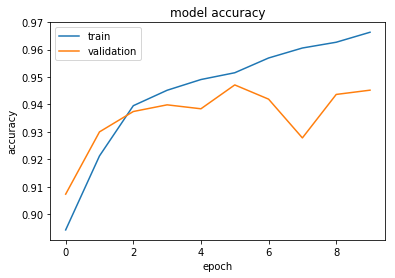

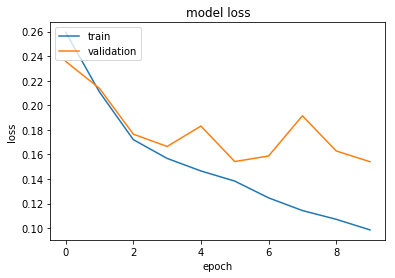

In [9]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model (multi gpu)

# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

In [11]:
# TODO add testing